In [3]:
#using Pkg
#Pkg.update()
#Pkg.add(PackageSpec(name="JWAS",rev="master"))

In [ ]:
#methods(add_genotypes)

In [1]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames
using Pkg

In [8]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Exp_0.75_Complete_Adj.dat", types=Dict(:ID => String), delim = ' ',header=true, missingstrings=["NA"])
first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,Bool,String,String?
1,0001,1,1,1B,A,1B_1715,false,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,false,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,false,1B_D04,1B_D04
5,0006,1,1,1B,A,1B_1902,false,1B_D04,1B_D04
6,0007,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
7,0009,1,1,1B,A,1B_1902,false,1B_D02,1B_D02
8,0010,1,1,1B,A,1B_1885,false,1B_D02,1B_D02
9,0011,1,1,1B,A,1B_2097,false,1B_D02,1B_D02


In [9]:
phenotypes= dropmissing(phenotypes, :FinPenBatch)
phenotypes= dropmissing(phenotypes, :NurPenBatch)
#first(phenotypes,10)
phenotypes= dropmissing(phenotypes, :FinADG)
phenotypes= dropmissing(phenotypes, :Died_Adj)
#phenotypes[!,:Died]=phenotypes[!,:Died] .+ 1

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,Bool,String,String
1,0001,1,1,1B,A,1B_1715,false,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,false,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,false,1B_D04,1B_D04
5,0007,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
6,0009,1,1,1B,A,1B_1902,false,1B_D02,1B_D02
7,0010,1,1,1B,A,1B_1885,false,1B_D02,1B_D02
8,0011,1,1,1B,A,1B_2097,false,1B_D02,1B_D02
9,0012,1,1,1B,A,1B_1902,false,1B_D02,1B_D02


In [2]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 18.560881 seconds (37.77 k allocations: 10.393 GiB, 0.10% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [11]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))

3205-element Array{String,1}:
 "0001"
 "0002"
 "0004"
 "0005"
 "0006"
 "0007"
 "0009"
 "0010"
 "0011"
 "0012"
 "0013"
 "0014"
 "0015"
 ⋮     
 "3283"
 "3284"
 "3285"
 "3286"
 "3287"
 "3288"
 "3289"
 "3290"
 "3291"
 "3292"
 "3293"
 "3294"

In [12]:
model_equations = "FinADG = intercept + Batch + EntryAge + FinPenBatch + SowID
             Died_Adj = intercept + Batch + EntryAge + NurPenBatch";
R= [0.140763E-01 -0.265738E-01
-0.265738E-01 0.141084]
model=build_model(model_equations,R);
set_covariate(model,"EntryAge")
G1=0.404886E-03
set_random(model,"FinPenBatch",G1)
G2=0.942687E-03
set_random(model,"NurPenBatch",G2)
G3=0.277714E-03
set_random(model,"SowID",G3)

FinPenBatch is not found in model equation 2.
NurPenBatch is not found in model equation 1.
SowID is not found in model equation 2.


In [13]:
G4=[0.612865E-02 0
0 0.146597E-001]
@time add_genotypes(model,M,G4,header=true, rowID=rowID, G_is_marker_variance=false) # no method matching
#@time add_genotypes(model,"/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_GenoA_Complete_Impute_JWAS.txt",G4,separator=' ', G_is_marker_variance=true)

The marker IDs are set to 1,2,...,#markers
#markers: 435172; #individuals: 3205
 15.043136 seconds (7.72 M allocations: 15.969 GiB, 1.70% gc time)


6.0f0

## BayesB

In [14]:
@time outB=runMCMC(model,phenotypes,methods="BayesB", missing_phenotypes=true, double_precision=true,
    estimatePi=false,Pi=Dict([1.0; 1.0]=>0.001,[1.0; 0.0]=>0.001,[0.0; 1.0]=>0.001,[0.0; 0.0]=>0.998), 
    estimateScale=true,chain_length=50000,burnin = 5000,output_heritability=true, output_samples_frequency=100, 
    output_samples_file="MCMC_BayesB")

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
The number of observations with both genotypes and phenotypes used in the analysis is 2384.

The prior for marker effects covariance matrix is calculated from genetic covariance matrix and Π.
The mean of the prior for the marker effects covariance matrix is:
 1.8e-5  0.0   
 0.0     4.4e-5



A Linear Mixed Model was build using model equations:

FinADG = intercept + Batch + EntryAge + FinPenBatch + SowID
Died_Adj = intercept + Batch + EntryAge + NurPenBatch

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1
Batch           factor       fixed               49
EntryAge        covariate    fixed                1
FinPenBatch     factor       random             214
SowID           factor       random            1023
NurPenBatch     factor       random             422

MCMC Information:

chain_length               

running MCMC ...100%|███████████████████████████████████| Time: 4 days, 17:59:43




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


410472.004467 seconds (2.05 T allocations: 135.158 TiB, 26.24% gc time)


Dict{Any,Any} with 9 entries:
  "ScaleEffectVargeno"           => 4×3 DataFrame…
  "heritability"                 => 2×3 DataFrame…
  "location parameters"          => 1761×5 DataFrame…
  "residual variance"            => 4×3 DataFrame…
  "marker effects geno"          => 870344×5 DataFrame…
  "EBV_FinADG"                   => 3205×3 DataFrame…
  "EBV_Died_Adj"                 => 3205×3 DataFrame…
  "genetic_variance"             => 4×3 DataFrame…
  "marker effects variance geno" => 4×3 DataFrame…

In [15]:
h2=CSV.read("MCMC_BayesB_heritability.txt",delim = ',',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration
first(h2, 10)

,iteration,FinADG,Died_Adj
,Int64,Float64,Float64
1,1,0.353001,0.285669
2,2,0.303777,0.315388
3,3,0.288844,0.361219
4,4,0.298679,0.278924
5,5,0.312866,0.313924
6,6,0.350268,0.299329
7,7,0.279028,0.304013
8,8,0.315966,0.303288
9,9,0.310113,0.373607


In [16]:
mean(h2[!,3])

0.3008832139058971

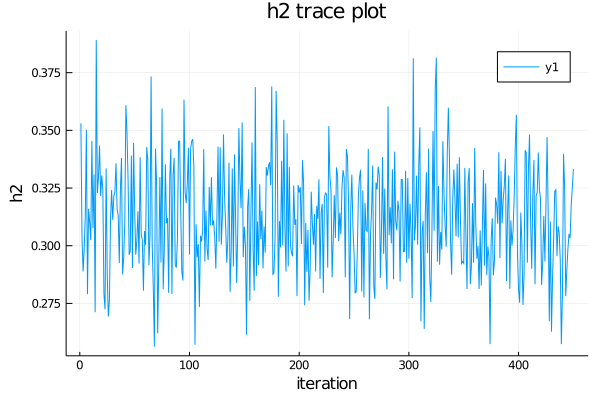

In [17]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

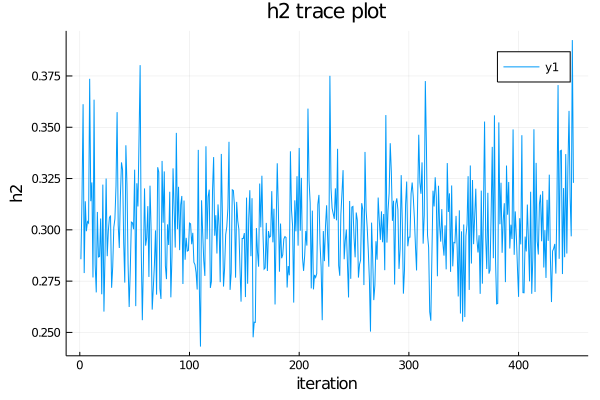

In [18]:
using Plots
x = h2[!,1]; y = h2[!,3]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [19]:
@time rg,out = GWAS(M,"/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt", 
    "MCMC_BayesB_marker_effects_geno_FinADG.txt",
    "MCMC_BayesB_marker_effects_geno_Died_Adj.txt",
    window_size="1 Mb", GWAS=false,sliding_window=false,genetic_correlation=true)

calculating genomic correlation...100%|█████████████████| Time: 0:36:13


BoundsError: BoundsError: attempt to access (2395×12 DataFrame
│ Row  │ trait      │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimate_cov │ std_cov     │ estimate_cor │ std_cor   │
│      │ String     │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64      │ Float64     │ Float64      │ Float64   │
├──────┼────────────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼──────────────┼─────────────┼──────────────┼───────────┤
│ 1    │ cor(t1,t2) │ 1      │ 1      │ 0         │ 1000000   │ 10204     │ 998132    │ 193    │ -1.63659e-7  │ 2.26996e-6  │ -0.0156797   │ 0.372275  │
│ 2    │ cor(t1,t2) │ 2      │ 1      │ 1000000   │ 2000000   │ 1005658   │ 1991610   │ 280    │ 2.57267e-7   │ 2.70235e-6  │ 0.014318     │ 0.412756  │
│ 3    │ cor(t1,t2) │ 3      │ 1      │ 2000000   │ 3000000   │ 2000553   │ 2998071   │ 280    │ 1.95596e-7   │ 2.29179e-6  │ 0.0557987    │ 0.410891  │
│ 4    │ cor(t1,t2) │ 4      │ 1      │ 3000000   │ 4000000   │ 3015934   │ 3994225   │ 216    │ -5.53757e-7  │ 4.83159e-6  │ -0.0462086   │ 0.399743  │
│ 5    │ cor(t1,t2) │ 5      │ 1      │ 4000000   │ 5000000   │ 4000817   │ 4992802   │ 230    │ -4.04448e-7  │ 3.10738e-6  │ -0.0352062   │ 0.373914  │
│ 6    │ cor(t1,t2) │ 6      │ 1      │ 5000000   │ 6000000   │ 5000927   │ 5994381   │ 214    │ 8.63521e-8   │ 1.64965e-6  │ 0.0318428    │ 0.331516  │
│ 7    │ cor(t1,t2) │ 7      │ 1      │ 6000000   │ 7000000   │ 6011062   │ 6992339   │ 258    │ -6.81061e-8  │ 3.2884e-6   │ -0.00609842  │ 0.389927  │
│ 8    │ cor(t1,t2) │ 8      │ 1      │ 7000000   │ 8000000   │ 7002079   │ 7994976   │ 224    │ -3.42947e-7  │ 3.41102e-6  │ -0.0330173   │ 0.395886  │
│ 9    │ cor(t1,t2) │ 9      │ 1      │ 8000000   │ 9000000   │ 8006283   │ 8996136   │ 276    │ -1.9994e-7   │ 2.51531e-6  │ -0.019176    │ 0.369034  │
│ 10   │ cor(t1,t2) │ 10     │ 1      │ 9000000   │ 10000000  │ 9009759   │ 9995902   │ 239    │ 1.43946e-6   │ 7.30138e-6  │ 0.0695542    │ 0.431884  │
│ 11   │ cor(t1,t2) │ 11     │ 1      │ 10000000  │ 11000000  │ 10008047  │ 10992034  │ 243    │ -7.83541e-8  │ 2.58936e-6  │ -0.00566457  │ 0.336571  │
│ 12   │ cor(t1,t2) │ 12     │ 1      │ 11000000  │ 12000000  │ 11000101  │ 11999490  │ 216    │ 1.82303e-7   │ 3.66983e-6  │ 0.00639027   │ 0.353472  │
│ 13   │ cor(t1,t2) │ 13     │ 1      │ 12000000  │ 13000000  │ 12003243  │ 12997223  │ 224    │ 6.12969e-8   │ 4.4354e-6   │ -0.00039792  │ 0.392098  │
│ 14   │ cor(t1,t2) │ 14     │ 1      │ 13000000  │ 14000000  │ 13002602  │ 13999491  │ 261    │ 2.67714e-7   │ 4.41813e-6  │ 0.0128848    │ 0.426334  │
│ 15   │ cor(t1,t2) │ 15     │ 1      │ 14000000  │ 15000000  │ 14002294  │ 14993669  │ 263    │ 1.42092e-6   │ 7.71972e-6  │ 0.0621575    │ 0.422943  │
│ 16   │ cor(t1,t2) │ 16     │ 1      │ 15000000  │ 16000000  │ 15001004  │ 15972270  │ 194    │ 5.15195e-8   │ 2.48929e-6  │ 0.0115467    │ 0.372032  │
│ 17   │ cor(t1,t2) │ 17     │ 1      │ 16000000  │ 17000000  │ 16000593  │ 16988798  │ 198    │ -2.98264e-7  │ 3.26005e-6  │ -0.0266304   │ 0.345869  │
│ 18   │ cor(t1,t2) │ 18     │ 1      │ 17000000  │ 18000000  │ 17007778  │ 17999476  │ 199    │ -1.54555e-8  │ 1.07888e-6  │ 0.0152801    │ 0.321288  │
│ 19   │ cor(t1,t2) │ 19     │ 1      │ 18000000  │ 19000000  │ 18007380  │ 18993361  │ 147    │ -1.23815e-7  │ 2.42686e-6  │ -0.0257925   │ 0.310609  │
│ 20   │ cor(t1,t2) │ 20     │ 1      │ 19000000  │ 20000000  │ 19001152  │ 19982000  │ 211    │ -3.16306e-7  │ 3.29383e-6  │ -0.0339924   │ 0.358671  │
│ 21   │ cor(t1,t2) │ 21     │ 1      │ 20000000  │ 21000000  │ 20068231  │ 20995136  │ 173    │ 1.92382e-7   │ 2.75796e-6  │ 0.0327646    │ 0.357988  │
│ 22   │ cor(t1,t2) │ 22     │ 1      │ 21000000  │ 22000000  │ 21014920  │ 21999344  │ 213    │ 4.3886e-7    │ 2.91611e-6  │ 0.0433839    │ 0.413667  │
│ 23   │ cor(t1,t2) │ 23     │ 1      │ 22000000  │ 23000000  │ 22002506  │ 22991873  │ 246    │ 9.49627e-9   │ 1.43951e-6  │ 0.00851236   │ 0.333068  │
│ 24   │ cor(t1,t2) │ 24     │ 1      │ 23000000  │ 24000000  │ 23002334  │ 23996828  │ 182    │ 2.31803e-8   │ 2.08545e-6  │ -0.0143683   │ 0.349967  │
│ 25   │ cor(t1,t2) │ 25     │ 1      │ 24000000  │ 25000000  │ 24001335  │ 24997798  │ 211    │ -1.88599e-7  │ 3.2351e-6   │ -0.00307502  │ 0.359829  │
│ 26   │ cor(t1,t2) │ 26     │ 1      │ 25000000  │ 26000000  │ 25000643  │ 25998814  │ 277    │ -2.08812e-7  │ 3.07121e-6  │ -0.0407135   │ 0.411445  │
│ 27   │ cor(t1,t2) │ 27     │ 1      │ 26000000  │ 27000000  │ 26001840  │ 26994896  │ 261    │ -1.56374e-7  │ 3.60492e-6  │ 0.00388488   │ 0.411322  │
│ 28   │ cor(t1,t2) │ 28     │ 1      │ 27000000  │ 28000000  │ 27000297  │ 27992242  │ 284    │ -3.75863e-7  │ 3.39555e-6  │ -0.0265261   │ 0.417001  │
│ 29   │ cor(t1,t2) │ 29     │ 1      │ 28000000  │ 29000000  │ 28002478  │ 28997086  │ 238    │ -4.31199e-8  │ 2.77295e-6  │ -0.0225431   │ 0.35005   │
│ 30   │ cor(t1,t2) │ 30     │ 1      │ 29000000  │ 30000000  │ 29001421  │ 29999664  │ 247    │ -9.67183e-7  │ 5.66714e-6  │ -0.0557509   │ 0.399541  │
│ 31   │ cor(t1,t2) │ 31     │ 1      │ 30000000  │ 31000000  │ 30000944  │ 30998818  │ 231    │ -1.45057e-8  │ 2.28365e-6  │ -0.018261    │ 0.379766  │
│ 32   │ cor(t1,t2) │ 32     │ 1      │ 31000000  │ 32000000  │ 31001089  │ 31978268  │ 231    │ -1.5784e-7   │ 2.06818e-6  │ 0.00319556   │ 0.405635  │
│ 33   │ cor(t1,t2) │ 33     │ 1      │ 32000000  │ 33000000  │ 32024388  │ 32995417  │ 229    │ -2.91588e-7  │ 3.25262e-6  │ -0.0299152   │ 0.406916  │
│ 34   │ cor(t1,t2) │ 34     │ 1      │ 33000000  │ 34000000  │ 33002217  │ 33999771  │ 284    │ -9.1055e-7   │ 5.66657e-6  │ -0.0463045   │ 0.435075  │
│ 35   │ cor(t1,t2) │ 35     │ 1      │ 34000000  │ 35000000  │ 34016983  │ 34987225  │ 152    │ -6.77747e-8  │ 1.43228e-6  │ 0.0113393    │ 0.319451  │
│ 36   │ cor(t1,t2) │ 36     │ 1      │ 35000000  │ 36000000  │ 35002738  │ 35989691  │ 200    │ -3.03045e-7  │ 3.01408e-6  │ -0.0188036   │ 0.359144  │
│ 37   │ cor(t1,t2) │ 37     │ 1      │ 36000000  │ 37000000  │ 36012903  │ 36999985  │ 227    │ 8.65146e-9   │ 3.00792e-6  │ -0.0191381   │ 0.385778  │
│ 38   │ cor(t1,t2) │ 38     │ 1      │ 37000000  │ 38000000  │ 37001580  │ 37998213  │ 250    │ -1.03978e-6  │ 5.53111e-6  │ -0.115241    │ 0.432368  │
│ 39   │ cor(t1,t2) │ 39     │ 1      │ 38000000  │ 39000000  │ 38000390  │ 38993167  │ 244    │ -9.17667e-7  │ 7.84853e-6  │ -0.0239825   │ 0.378305  │
│ 40   │ cor(t1,t2) │ 40     │ 1      │ 39000000  │ 40000000  │ 39000584  │ 39991606  │ 233    │ -3.16272e-7  │ 2.85031e-6  │ -0.012563    │ 0.336004  │
│ 41   │ cor(t1,t2) │ 41     │ 1      │ 40000000  │ 41000000  │ 40017009  │ 40997806  │ 224    │ -1.18729e-7  │ 2.5457e-6   │ -0.0133289   │ 0.400609  │
│ 42   │ cor(t1,t2) │ 42     │ 1      │ 41000000  │ 42000000  │ 41001244  │ 41995556  │ 219    │ -1.50414e-6  │ 7.33935e-6  │ -0.103286    │ 0.473749  │
│ 43   │ cor(t1,t2) │ 43     │ 1      │ 42000000  │ 43000000  │ 42004485  │ 42997288  │ 199    │ -4.22698e-7  │ 3.83386e-6  │ -0.0523309   │ 0.412507  │
│ 44   │ cor(t1,t2) │ 44     │ 1      │ 43000000  │ 44000000  │ 43001431  │ 43999473  │ 237    │ 3.64162e-8   │ 3.20251e-6  │ 0.014747     │ 0.400983  │
│ 45   │ cor(t1,t2) │ 45     │ 1      │ 44000000  │ 45000000  │ 44006026  │ 44994173  │ 204    │ -6.46163e-8  │ 2.78917e-6  │ -0.0402354   │ 0.345221  │
│ 46   │ cor(t1,t2) │ 46     │ 1      │ 45000000  │ 46000000  │ 45009954  │ 45999436  │ 183    │ -5.21535e-9  │ 2.20203e-6  │ -0.000839692 │ 0.347917  │
│ 47   │ cor(t1,t2) │ 47     │ 1      │ 46000000  │ 47000000  │ 46000976  │ 46995468  │ 179    │ -3.02224e-7  │ 2.75076e-6  │ -0.0358523   │ 0.320783  │
│ 48   │ cor(t1,t2) │ 48     │ 1      │ 47000000  │ 48000000  │ 47006446  │ 47995992  │ 193    │ -1.24907e-7  │ 2.05937e-6  │ -0.0185675   │ 0.327707  │
│ 49   │ cor(t1,t2) │ 49     │ 1      │ 48000000  │ 49000000  │ 48000402  │ 48997742  │ 212    │ 4.36055e-8   │ 2.15142e-6  │ 0.0174046    │ 0.36044   │
│ 50   │ cor(t1,t2) │ 50     │ 1      │ 49000000  │ 50000000  │ 49000445  │ 49997984  │ 242    │ 1.88457e-7   │ 2.21654e-6  │ 0.0331664    │ 0.383447  │
│ 51   │ cor(t1,t2) │ 51     │ 1      │ 50000000  │ 51000000  │ 50004551  │ 50997988  │ 229    │ 4.80694e-8   │ 1.78112e-6  │ -0.001844    │ 0.303799  │
│ 52   │ cor(t1,t2) │ 52     │ 1      │ 51000000  │ 52000000  │ 51001474  │ 51998674  │ 247    │ -1.33654e-7  │ 3.85232e-6  │ 0.00891275   │ 0.362039  │
│ 53   │ cor(t1,t2) │ 53     │ 1      │ 52000000  │ 53000000  │ 52000507  │ 52988384  │ 276    │ -1.50187e-7  │ 2.91448e-6  │ -0.0407156   │ 0.365779  │
│ 54   │ cor(t1,t2) │ 54     │ 1      │ 53000000  │ 54000000  │ 53000537  │ 53998155  │ 234    │ -8.5777e-8   │ 2.62526e-6  │ 0.00971945   │ 0.374044  │
│ 55   │ cor(t1,t2) │ 55     │ 1      │ 54000000  │ 55000000  │ 54000704  │ 54998449  │ 210    │ -4.6976e-8   │ 2.69019e-6  │ -0.0161209   │ 0.368635  │
│ 56   │ cor(t1,t2) │ 56     │ 1      │ 55000000  │ 56000000  │ 55000843  │ 55999195  │ 233    │ 8.75202e-8   │ 2.69136e-6  │ -0.000286209 │ 0.370982  │
│ 57   │ cor(t1,t2) │ 57     │ 1      │ 56000000  │ 57000000  │ 56003300  │ 56997558  │ 263    │ -4.37778e-7  │ 4.09658e-6  │ -0.0333254   │ 0.415251  │
│ 58   │ cor(t1,t2) │ 58     │ 1      │ 57000000  │ 58000000  │ 57002360  │ 57996588  │ 214    │ 6.48848e-8   │ 3.85699e-6  │ 0.00331978   │ 0.390882  │
│ 59   │ cor(t1,t2) │ 59     │ 1      │ 58000000  │ 59000000  │ 58007741  │ 58999705  │ 221    │ 3.54681e-7   │ 4.165e-6    │ 0.0222855    │ 0.404751  │
│ 60   │ cor(t1,t2) │ 60     │ 1      │ 59000000  │ 60000000  │ 59002370  │ 59998801  │ 209    │ 5.86839e-9   │ 2.84266e-6  │ 0.00412992   │ 0.369352  │
│ 61   │ cor(t1,t2) │ 61     │ 1      │ 60000000  │ 61000000  │ 60006991  │ 60997004  │ 174    │ -3.46547e-7  │ 3.82598e-6  │ -0.0237764   │ 0.339601  │
│ 62   │ cor(t1,t2) │ 62     │ 1      │ 61000000  │ 62000000  │ 61000205  │ 61990491  │ 142    │ 7.8565e-9    │ 2.33882e-6  │ 0.0199329    │ 0.32163   │
│ 63   │ cor(t1,t2) │ 63     │ 1      │ 62000000  │ 63000000  │ 62007848  │ 62993816  │ 164    │ -1.31671e-7  │ 1.8993e-6   │ -0.0300749   │ 0.359619  │
│ 64   │ cor(t1,t2) │ 64     │ 1      │ 63000000  │ 64000000  │ 63000926  │ 63992807  │ 183    │ -8.36748e-8  │ 2.10415e-6  │ -0.0035616   │ 0.303302  │
│ 65   │ cor(t1,t2) │ 65     │ 1      │ 64000000  │ 65000000  │ 64000088  │ 64999142  │ 202    │ -1.80192e-8  │ 3.18138e-6  │ 0.0213665    │ 0.429501  │
│ 66   │ cor(t1,t2) │ 66     │ 1      │ 65000000  │ 66000000  │ 65001837  │ 65999375  │ 199    │ -4.61339e-7  │ 3.30652e-6  │ -0.0435151   │ 0.337045  │
│ 67   │ cor(t1,t2) │ 67     │ 1      │ 66000000  │ 67000000  │ 66002610  │ 66999558  │ 216    │ 1.98147e-7   │ 4.03724e-6  │ 0.00115642   │ 0.390306  │
│ 68   │ cor(t1,t2) │ 68     │ 1      │ 67000000  │ 68000000  │ 67001376  │ 67999059  │ 217    │ -2.69782e-7  │ 2.78085e-6  │ -0.0105744   │ 0.407637  │
│ 69   │ cor(t1,t2) │ 69     │ 1      │ 68000000  │ 69000000  │ 68002588  │ 68996339  │ 199    │ -1.92964e-7  │ 2.14435e-6  │ -0.0025071   │ 0.371236  │
│ 70   │ cor(t1,t2) │ 70     │ 1      │ 69000000  │ 70000000  │ 69003694  │ 69998202  │ 164    │ 1.39215e-7   │ 2.73429e-6  │ 0.007452     │ 0.315601  │
│ 71   │ cor(t1,t2) │ 71     │ 1      │ 70000000  │ 71000000  │ 70001842  │ 70997605  │ 192    │ -1.21404e-7  │ 2.41462e-6  │ -0.0012001   │ 0.363638  │
│ 72   │ cor(t1,t2) │ 72     │ 1      │ 71000000  │ 72000000  │ 71000195  │ 71999425  │ 251    │ -1.54329e-7  │ 2.89507e-6  │ 0.0247302    │ 0.400156  │
│ 73   │ cor(t1,t2) │ 73     │ 1      │ 72000000  │ 73000000  │ 72002524  │ 72998025  │ 233    │ -5.41591e-8  │ 1.87924e-6  │ 0.00855982   │ 0.35318   │
│ 74   │ cor(t1,t2) │ 74     │ 1      │ 73000000  │ 74000000  │ 73006690  │ 73999102  │ 206    │ -1.23874e-7  │ 1.74064e-6  │ -0.0144478   │ 0.403845  │
│ 75   │ cor(t1,t2) │ 75     │ 1      │ 74000000  │ 75000000  │ 74008732  │ 74999519  │ 250    │ 7.43171e-8   │ 2.60258e-6  │ 0.0131413    │ 0.418927  │
│ 76   │ cor(t1,t2) │ 76     │ 1      │ 75000000  │ 76000000  │ 75002773  │ 75981624  │ 219    │ -4.97778e-8  │ 2.44654e-6  │ -0.0196372   │ 0.36616   │
│ 77   │ cor(t1,t2) │ 77     │ 1      │ 76000000  │ 77000000  │ 76123500  │ 76997251  │ 166    │ 8.10594e-8   │ 2.43937e-6  │ 0.00529467   │ 0.332195  │
│ 78   │ cor(t1,t2) │ 78     │ 1      │ 77000000  │ 78000000  │ 77001359  │ 77999996  │ 223    │ 1.314e-7     │ 4.11975e-6  │ 0.0110617    │ 0.389091  │
│ 79   │ cor(t1,t2) │ 79     │ 1      │ 78000000  │ 79000000  │ 78005125  │ 78998462  │ 188    │ -2.04783e-7  │ 2.93243e-6  │ -0.00982604  │ 0.354707  │
│ 80   │ cor(t1,t2) │ 80     │ 1      │ 79000000  │ 80000000  │ 79004139  │ 79998526  │ 167    │ -9.16194e-8  │ 1.91893e-6  │ -0.00843118  │ 0.305461  │
│ 81   │ cor(t1,t2) │ 81     │ 1      │ 80000000  │ 81000000  │ 80015980  │ 80998979  │ 206    │ -7.95186e-8  │ 2.50762e-6  │ -0.00693474  │ 0.355733  │
│ 82   │ cor(t1,t2) │ 82     │ 1      │ 81000000  │ 82000000  │ 81001561  │ 81996397  │ 193    │ -1.99507e-7  │ 3.78502e-6  │ -0.00412621  │ 0.373772  │
│ 83   │ cor(t1,t2) │ 83     │ 1      │ 82000000  │ 83000000  │ 82000359  │ 82998024  │ 177    │ 1.11907e-9   │ 2.07675e-6  │ -0.0166052   │ 0.312821  │
│ 84   │ cor(t1,t2) │ 84     │ 1      │ 83000000  │ 84000000  │ 83001395  │ 83997119  │ 193    │ 2.92327e-8   │ 2.32891e-6  │ 0.00505204   │ 0.345144  │
│ 85   │ cor(t1,t2) │ 85     │ 1      │ 84000000  │ 85000000  │ 84003966  │ 84994820  │ 192    │ 1.2424e-7    │ 1.87527e-6  │ 0.00140223   │ 0.343338  │
│ 86   │ cor(t1,t2) │ 86     │ 1      │ 85000000  │ 86000000  │ 85000728  │ 85997978  │ 173    │ -4.31599e-8  │ 2.72058e-6  │ -0.000154714 │ 0.357199  │
│ 87   │ cor(t1,t2) │ 87     │ 1      │ 86000000  │ 87000000  │ 86005404  │ 86999929  │ 216    │ -2.52075e-7  │ 3.39137e-6  │ -0.0148279   │ 0.375857  │
│ 88   │ cor(t1,t2) │ 88     │ 1      │ 87000000  │ 88000000  │ 87006107  │ 87995279  │ 166    │ -4.02964e-7  │ 4.28277e-6  │ -0.0304125   │ 0.312044  │
│ 89   │ cor(t1,t2) │ 89     │ 1      │ 88000000  │ 89000000  │ 88002139  │ 88996286  │ 219    │ -5.1719e-8   │ 4.60683e-6  │ -0.00995185  │ 0.403241  │
│ 90   │ cor(t1,t2) │ 90     │ 1      │ 89000000  │ 90000000  │ 89001945  │ 89996424  │ 216    │ -2.48806e-7  │ 3.91651e-6  │ -0.0391559   │ 0.381856  │
│ 91   │ cor(t1,t2) │ 91     │ 1      │ 90000000  │ 91000000  │ 90000214  │ 90999222  │ 191    │ -7.8742e-7   │ 5.53548e-6  │ -0.0529888   │ 0.414848  │
│ 92   │ cor(t1,t2) │ 92     │ 1      │ 91000000  │ 92000000  │ 91005035  │ 91990612  │ 140    │ -2.67536e-7  │ 2.45846e-6  │ -0.0353686   │ 0.322207  │
│ 93   │ cor(t1,t2) │ 93     │ 1      │ 92000000  │ 93000000  │ 92001893  │ 92831114  │ 89     │ -2.14435e-8  │ 1.81486e-6  │ -0.00225496  │ 0.256789  │
│ 94   │ cor(t1,t2) │ 94     │ 1      │ 93000000  │ 94000000  │ 93059901  │ 93989762  │ 56     │ -4.0399e-8   │ 8.25365e-7  │ 4.25606e-5   │ 0.209087  │
│ 95   │ cor(t1,t2) │ 95     │ 1      │ 94000000  │ 95000000  │ 94002702  │ 94994646  │ 215    │ -7.58256e-8  │ 2.42213e-6  │ -0.0125443   │ 0.38164   │
│ 96   │ cor(t1,t2) │ 96     │ 1      │ 95000000  │ 96000000  │ 95000322  │ 95999221  │ 260    │ -8.67882e-8  │ 2.31786e-6  │ -0.00759858  │ 0.400039  │
│ 97   │ cor(t1,t2) │ 97     │ 1      │ 96000000  │ 97000000  │ 96001995  │ 96999587  │ 203    │ -2.25366e-7  │ 3.61418e-6  │ 0.00586144   │ 0.326557  │
│ 98   │ cor(t1,t2) │ 98     │ 1      │ 97000000  │ 98000000  │ 97003511  │ 97996706  │ 245    │ -3.19803e-7  │ 2.77935e-6  │ -0.0378906   │ 0.381468  │
│ 99   │ cor(t1,t2) │ 99     │ 1      │ 98000000  │ 99000000  │ 98000949  │ 98996195  │ 185    │ -5.4467e-7   │ 4.20279e-6  │ -0.040795    │ 0.3756    │
│ 100  │ cor(t1,t2) │ 100    │ 1      │ 99000000  │ 100000000 │ 99008941  │ 99996469  │ 178    │ -1.50167e-7  │ 2.71255e-6  │ -0.010873    │ 0.321409  │
│ 101  │ cor(t1,t2) │ 101    │ 1      │ 100000000 │ 101000000 │ 100008538 │ 100933638 │ 72     │ 1.31705e-8   │ 5.14525e-7  │ -0.00234337  │ 0.189409  │
│ 102  │ cor(t1,t2) │ 102    │ 1      │ 101000000 │ 102000000 │ 101008372 │ 101997865 │ 94     │ -1.56335e-7  │ 2.0158e-6   │ 0.000267282  │ 0.24934   │
│ 103  │ cor(t1,t2) │ 103    │ 1      │ 102000000 │ 103000000 │ 102000871 │ 102997193 │ 156    │ -2.83874e-8  │ 1.62294e-6  │ -0.00609561  │ 0.293586  │
│ 104  │ cor(t1,t2) │ 104    │ 1      │ 103000000 │ 104000000 │ 103015496 │ 103989409 │ 153    │ 9.857e-8     │ 2.16748e-6  │ 0.026591     │ 0.342252  │
│ 105  │ cor(t1,t2) │ 105    │ 1      │ 104000000 │ 105000000 │ 104009778 │ 104988076 │ 141    │ -4.64336e-8  │ 1.04607e-6  │ 0.00722257   │ 0.254459  │
│ 106  │ cor(t1,t2) │ 106    │ 1      │ 105000000 │ 106000000 │ 105000079 │ 105997010 │ 136    │ -3.88555e-8  │ 1.18157e-6  │ -0.027844    │ 0.287857  │
│ 107  │ cor(t1,t2) │ 107    │ 1      │ 106000000 │ 107000000 │ 106000150 │ 106996346 │ 177    │ -2.39886e-7  │ 2.47243e-6  │ 0.00412299   │ 0.338425  │
│ 108  │ cor(t1,t2) │ 108    │ 1      │ 107000000 │ 108000000 │ 107002273 │ 107998123 │ 120    │ -4.83533e-8  │ 1.55605e-6  │ -0.00804357  │ 0.331683  │
│ 109  │ cor(t1,t2) │ 109    │ 1      │ 108000000 │ 109000000 │ 108003187 │ 108996346 │ 141    │ -5.46605e-8  │ 1.06991e-6  │ 0.0256534    │ 0.306504  │
│ 110  │ cor(t1,t2) │ 110    │ 1      │ 109000000 │ 110000000 │ 109000599 │ 109961801 │ 140    │ -4.36417e-8  │ 1.2692e-6   │ -0.0122598   │ 0.268244  │
│ 111  │ cor(t1,t2) │ 111    │ 1      │ 110000000 │ 111000000 │ 110053220 │ 110994142 │ 179    │ 1.94199e-7   │ 3.68828e-6  │ -0.0132764   │ 0.371372  │
│ 112  │ cor(t1,t2) │ 112    │ 1      │ 111000000 │ 112000000 │ 111010212 │ 111979389 │ 158    │ 7.91923e-8   │ 3.21456e-6  │ 0.0305699    │ 0.326947  │
│ 113  │ cor(t1,t2) │ 113    │ 1      │ 112000000 │ 113000000 │ 112000233 │ 112996255 │ 166    │ 2.31042e-7   │ 2.32742e-6  │ 0.0172597    │ 0.35427   │
│ 114  │ cor(t1,t2) │ 114    │ 1      │ 113000000 │ 114000000 │ 113004134 │ 113927500 │ 128    │ 3.26581e-7   │ 3.36236e-6  │ 0.0265983    │ 0.355227  │
│ 115  │ cor(t1,t2) │ 115    │ 1      │ 114000000 │ 115000000 │ 114015704 │ 114995932 │ 115    │ 1.76144e-7   │ 2.57934e-6  │ 0.00969829   │ 0.276738  │
│ 116  │ cor(t1,t2) │ 116    │ 1      │ 115000000 │ 116000000 │ 115001730 │ 115993957 │ 92     │ 3.84227e-7   │ 2.92403e-6  │ 0.03831      │ 0.294346  │
│ 117  │ cor(t1,t2) │ 117    │ 1      │ 116000000 │ 117000000 │ 116003388 │ 116998626 │ 171    │ 6.82877e-7   │ 4.11324e-6  │ 0.062889     │ 0.354963  │
│ 118  │ cor(t1,t2) │ 118    │ 1      │ 117000000 │ 118000000 │ 117001841 │ 117988311 │ 182    │ 1.09232e-6   │ 6.22621e-6  │ 0.055189     │ 0.428293  │
│ 119  │ cor(t1,t2) │ 119    │ 1      │ 118000000 │ 119000000 │ 118001042 │ 118999237 │ 107    │ 2.24092e-7   │ 8.68447e-6  │ 0.0234344    │ 0.446302  │
│ 120  │ cor(t1,t2) │ 120    │ 1      │ 119000000 │ 120000000 │ 119009467 │ 119998335 │ 128    │ 2.15862e-7   │ 3.46385e-6  │ 0.026202     │ 0.363516  │
│ 121  │ cor(t1,t2) │ 121    │ 1      │ 120000000 │ 121000000 │ 120004893 │ 120991445 │ 74     │ -5.41739e-9  │ 8.40488e-7  │ -0.00549004  │ 0.189411  │
│ 122  │ cor(t1,t2) │ 122    │ 1      │ 121000000 │ 122000000 │ 121021851 │ 121997658 │ 92     │ -5.69657e-9  │ 1.15528e-6  │ -0.00652215  │ 0.246924  │
│ 123  │ cor(t1,t2) │ 123    │ 1      │ 122000000 │ 123000000 │ 122003486 │ 122985685 │ 125    │ 1.14294e-7   │ 2.02303e-6  │ 0.0158379    │ 0.274836  │
│ 124  │ cor(t1,t2) │ 124    │ 1      │ 123000000 │ 124000000 │ 123011728 │ 123995795 │ 196    │ -9.9805e-8   │ 3.10022e-6  │ 0.0115261    │ 0.371192  │
│ 125  │ cor(t1,t2) │ 125    │ 1      │ 124000000 │ 125000000 │ 124001275 │ 124999688 │ 174    │ 1.50295e-7   │ 1.63808e-6  │ 0.0227441    │ 0.354727  │
│ 126  │ cor(t1,t2) │ 126    │ 1      │ 125000000 │ 126000000 │ 125006739 │ 125999448 │ 168    │ 1.2757e-7    │ 1.22626e-6  │ 0.0290793    │ 0.320865  │
│ 127  │ cor(t1,t2) │ 127    │ 1      │ 126000000 │ 127000000 │ 126005634 │ 126993674 │ 143    │ -3.62275e-8  │ 1.12063e-6  │ -0.0463291   │ 0.26465   │
│ 128  │ cor(t1,t2) │ 128    │ 1      │ 127000000 │ 128000000 │ 127012489 │ 127969006 │ 109    │ 1.04642e-7   │ 1.61998e-6  │ 0.00823069   │ 0.304991  │
│ 129  │ cor(t1,t2) │ 129    │ 1      │ 128000000 │ 129000000 │ 128010294 │ 128995269 │ 79     │ 8.37172e-8   │ 9.42326e-7  │ 0.0109345    │ 0.258711  │
│ 130  │ cor(t1,t2) │ 130    │ 1      │ 129000000 │ 130000000 │ 129009007 │ 129994936 │ 131    │ 1.77016e-7   │ 2.33354e-6  │ 0.00249799   │ 0.30663   │
│ 131  │ cor(t1,t2) │ 131    │ 1      │ 130000000 │ 131000000 │ 130002594 │ 130996899 │ 157    │ 2.18651e-8   │ 2.11633e-6  │ 0.00986535   │ 0.351221  │
│ 132  │ cor(t1,t2) │ 132    │ 1      │ 131000000 │ 132000000 │ 131007899 │ 131997760 │ 125    │ -5.51947e-8  │ 1.49775e-6  │ -0.0153218   │ 0.301835  │
│ 133  │ cor(t1,t2) │ 133    │ 1      │ 132000000 │ 133000000 │ 132002472 │ 132946912 │ 111    │ 1.6697e-8    │ 1.27607e-6  │ 0.00661847   │ 0.288339  │
│ 134  │ cor(t1,t2) │ 134    │ 1      │ 133000000 │ 134000000 │ 133034994 │ 133989493 │ 118    │ -2.01392e-7  │ 2.78237e-6  │ 0.00643291   │ 0.307118  │
│ 135  │ cor(t1,t2) │ 135    │ 1      │ 134000000 │ 135000000 │ 134003677 │ 134998333 │ 126    │ -9.96654e-8  │ 1.79486e-6  │ -0.00545693  │ 0.282514  │
│ 136  │ cor(t1,t2) │ 136    │ 1      │ 135000000 │ 136000000 │ 135001416 │ 135997962 │ 88     │ -3.04869e-7  │ 4.58451e-6  │ -0.0287751   │ 0.301102  │
│ 137  │ cor(t1,t2) │ 137    │ 1      │ 136000000 │ 137000000 │ 136010405 │ 136831474 │ 63     │ -3.1603e-8   │ 1.27624e-6  │ 0.00647929   │ 0.225786  │
│ 138  │ cor(t1,t2) │ 138    │ 1      │ 137000000 │ 138000000 │ 137038651 │ 137987113 │ 65     │ 3.39866e-8   │ 8.00975e-7  │ 0.0113807    │ 0.234703  │
│ 139  │ cor(t1,t2) │ 139    │ 1      │ 138000000 │ 139000000 │ 138003738 │ 138997189 │ 105    │ -1.11755e-7  │ 1.57421e-6  │ 7.90677e-5   │ 0.280312  │
│ 140  │ cor(t1,t2) │ 140    │ 1      │ 139000000 │ 140000000 │ 139004072 │ 139999096 │ 225    │ -4.59344e-7  │ 3.91661e-6  │ -0.0251295   │ 0.40174   │
│ 141  │ cor(t1,t2) │ 141    │ 1      │ 140000000 │ 141000000 │ 140001245 │ 140916301 │ 190    │ -1.8413e-7   │ 5.20485e-6  │ -0.0233407   │ 0.481053  │
│ 142  │ cor(t1,t2) │ 142    │ 1      │ 141000000 │ 142000000 │ 141032708 │ 141995728 │ 105    │ 4.08017e-8   │ 2.50783e-6  │ 0.00235435   │ 0.341507  │
│ 143  │ cor(t1,t2) │ 143    │ 1      │ 142000000 │ 143000000 │ 142015595 │ 142990603 │ 52     │ -3.98073e-8  │ 1.04182e-6  │ 0.00338658   │ 0.22828   │
│ 144  │ cor(t1,t2) │ 144    │ 1      │ 143000000 │ 144000000 │ 143005336 │ 143998612 │ 104    │ 5.92672e-9   │ 5.41424e-7  │ 0.0165114    │ 0.236094  │
│ 145  │ cor(t1,t2) │ 145    │ 1      │ 144000000 │ 145000000 │ 144000747 │ 144986471 │ 83     │ 6.96709e-10  │ 8.80731e-7  │ -0.0166155   │ 0.279316  │
│ 146  │ cor(t1,t2) │ 146    │ 1      │ 145000000 │ 146000000 │ 145000660 │ 145984136 │ 159    │ 4.12414e-7   │ 5.17986e-6  │ 0.0170099    │ 0.340134  │
│ 147  │ cor(t1,t2) │ 147    │ 1      │ 146000000 │ 147000000 │ 146001912 │ 146997990 │ 187    │ -1.07459e-7  │ 3.48474e-6  │ -0.0237689   │ 0.387711  │
│ 148  │ cor(t1,t2) │ 148    │ 1      │ 147000000 │ 148000000 │ 147001436 │ 147997511 │ 211    │ -9.566e-7    │ 5.91417e-6  │ -0.0448849   │ 0.459777  │
│ 149  │ cor(t1,t2) │ 149    │ 1      │ 148000000 │ 149000000 │ 148001218 │ 148997209 │ 201    │ -3.45161e-7  │ 7.5814e-6   │ -0.00761412  │ 0.438914  │
│ 150  │ cor(t1,t2) │ 150    │ 1      │ 149000000 │ 150000000 │ 149002313 │ 149993355 │ 176    │ -2.15747e-8  │ 6.9495e-6   │ 0.0211013    │ 0.42099   │
│ 151  │ cor(t1,t2) │ 151    │ 1      │ 150000000 │ 151000000 │ 150000496 │ 150984488 │ 162    │ -1.75116e-6  │ 1.32093e-5  │ -0.00690784  │ 0.469758  │
│ 152  │ cor(t1,t2) │ 152    │ 1      │ 151000000 │ 152000000 │ 151002114 │ 151999265 │ 173    │ 6.97138e-7   │ 5.69437e-6  │ 0.0470988    │ 0.366801  │
│ 153  │ cor(t1,t2) │ 153    │ 1      │ 152000000 │ 153000000 │ 152002944 │ 152996868 │ 163    │ -6.26676e-7  │ 5.86383e-6  │ -0.016226    │ 0.387254  │
│ 154  │ cor(t1,t2) │ 154    │ 1      │ 153000000 │ 154000000 │ 153023518 │ 153994073 │ 127    │ -7.93416e-8  │ 2.94312e-6  │ 0.00499548   │ 0.345517  │
│ 155  │ cor(t1,t2) │ 155    │ 1      │ 154000000 │ 155000000 │ 154000579 │ 154998028 │ 96     │ -1.16349e-7  │ 2.22465e-6  │ -0.00385931  │ 0.29922   │
│ 156  │ cor(t1,t2) │ 156    │ 1      │ 155000000 │ 156000000 │ 155003614 │ 155997278 │ 146    │ -2.78424e-7  │ 3.03402e-6  │ -0.0297906   │ 0.347182  │
│ 157  │ cor(t1,t2) │ 157    │ 1      │ 156000000 │ 157000000 │ 156002318 │ 156997313 │ 155    │ -1.21893e-7  │ 2.00629e-6  │ -0.00592031  │ 0.341067  │
│ 158  │ cor(t1,t2) │ 158    │ 1      │ 157000000 │ 158000000 │ 157000218 │ 157980147 │ 148    │ 8.66927e-8   │ 1.98745e-6  │ 0.0183585    │ 0.308989  │
│ 159  │ cor(t1,t2) │ 159    │ 1      │ 158000000 │ 159000000 │ 158000129 │ 158999535 │ 179    │ -2.2887e-7   │ 3.00442e-6  │ -0.0304246   │ 0.369657  │
│ 160  │ cor(t1,t2) │ 160    │ 1      │ 159000000 │ 160000000 │ 159002671 │ 159997351 │ 179    │ -9.77681e-9  │ 1.61974e-6  │ 0.00906026   │ 0.345301  │
│ 161  │ cor(t1,t2) │ 161    │ 1      │ 160000000 │ 161000000 │ 160005633 │ 160987711 │ 137    │ -1.19073e-7  │ 2.82607e-6  │ -0.0161659   │ 0.307622  │
│ 162  │ cor(t1,t2) │ 162    │ 1      │ 161000000 │ 162000000 │ 161005018 │ 161999307 │ 223    │ -3.23487e-8  │ 3.04072e-6  │ 0.00987825   │ 0.394719  │
│ 163  │ cor(t1,t2) │ 163    │ 1      │ 162000000 │ 163000000 │ 162004596 │ 162998721 │ 193    │ 7.63044e-8   │ 1.42589e-6  │ 0.0262186    │ 0.328796  │
│ 164  │ cor(t1,t2) │ 164    │ 1      │ 163000000 │ 164000000 │ 163003130 │ 163990350 │ 183    │ -1.04621e-7  │ 3.32793e-6  │ 0.0104863    │ 0.379918  │
│ 165  │ cor(t1,t2) │ 165    │ 1      │ 164000000 │ 165000000 │ 164000402 │ 164996694 │ 207    │ 6.18979e-7   │ 5.18962e-6  │ 0.0178093    │ 0.430211  │
│ 166  │ cor(t1,t2) │ 166    │ 1      │ 165000000 │ 166000000 │ 165001760 │ 165994631 │ 142    │ -6.65414e-8  │ 3.41933e-6  │ -0.00635892  │ 0.351854  │
│ 167  │ cor(t1,t2) │ 167    │ 1      │ 166000000 │ 167000000 │ 166003026 │ 166999086 │ 196    │ -1.34398e-7  │ 2.99616e-6  │ -0.0109124   │ 0.40059   │
│ 168  │ cor(t1,t2) │ 168    │ 1      │ 167000000 │ 168000000 │ 167007155 │ 167999625 │ 179    │ -9.6611e-8   │ 2.269e-6    │ 0.00412001   │ 0.335173  │
│ 169  │ cor(t1,t2) │ 169    │ 1      │ 168000000 │ 169000000 │ 168003027 │ 168994200 │ 129    │ -7.07661e-7  │ 6.42938e-6  │ -0.00625511  │ 0.379674  │
│ 170  │ cor(t1,t2) │ 170    │ 1      │ 169000000 │ 170000000 │ 169007402 │ 169765614 │ 128    │ -7.06786e-8  │ 1.37154e-6  │ -0.00527846  │ 0.2912    │
│ 171  │ cor(t1,t2) │ 171    │ 1      │ 170000000 │ 171000000 │ 170064540 │ 170989920 │ 92     │ -3.52991e-7  │ 3.4747e-6   │ -0.0273128   │ 0.33008   │
│ 172  │ cor(t1,t2) │ 172    │ 1      │ 171000000 │ 172000000 │ 171017646 │ 171995837 │ 121    │ -2.4777e-7   │ 3.45217e-6  │ 0.00602541   │ 0.301817  │
│ 173  │ cor(t1,t2) │ 173    │ 1      │ 172000000 │ 173000000 │ 172001898 │ 172993641 │ 133    │ -2.60019e-7  │ 2.67501e-6  │ 0.00207241   │ 0.326852  │
│ 174  │ cor(t1,t2) │ 174    │ 1      │ 173000000 │ 174000000 │ 173005066 │ 173999496 │ 112    │ -9.5354e-8   │ 1.52441e-6  │ -0.00735779  │ 0.238837  │
│ 175  │ cor(t1,t2) │ 175    │ 1      │ 174000000 │ 175000000 │ 174003287 │ 174992575 │ 151    │ 1.39464e-9   │ 2.80472e-6  │ 0.00691937   │ 0.337957  │
│ 176  │ cor(t1,t2) │ 176    │ 1      │ 175000000 │ 176000000 │ 175061030 │ 175982916 │ 101    │ -6.70756e-8  │ 3.22853e-6  │ 0.00957659   │ 0.344811  │
│ 177  │ cor(t1,t2) │ 177    │ 1      │ 176000000 │ 177000000 │ 176006370 │ 176990911 │ 152    │ 1.06568e-7   │ 2.21221e-6  │ 0.0108063    │ 0.358822  │
│ 178  │ cor(t1,t2) │ 178    │ 1      │ 177000000 │ 178000000 │ 177004564 │ 177998577 │ 107    │ -5.68162e-8  │ 3.0129e-6   │ 0.00166285   │ 0.254907  │
│ 179  │ cor(t1,t2) │ 179    │ 1      │ 178000000 │ 179000000 │ 178002219 │ 178994918 │ 172    │ -1.61418e-7  │ 2.70544e-6  │ -0.0442817   │ 0.367126  │
│ 180  │ cor(t1,t2) │ 180    │ 1      │ 179000000 │ 180000000 │ 179003894 │ 179952056 │ 116    │ -1.44088e-7  │ 2.7271e-6   │ -0.00222408  │ 0.309478  │
│ 181  │ cor(t1,t2) │ 181    │ 1      │ 180000000 │ 181000000 │ 180005436 │ 180994825 │ 126    │ 6.5851e-7    │ 5.21994e-6  │ 0.0381276    │ 0.349451  │
│ 182  │ cor(t1,t2) │ 182    │ 1      │ 181000000 │ 182000000 │ 181002521 │ 181992079 │ 185    │ 1.42628e-7   │ 1.95027e-6  │ 0.0131238    │ 0.369378  │
│ 183  │ cor(t1,t2) │ 183    │ 1      │ 182000000 │ 183000000 │ 182003531 │ 182988561 │ 162    │ -2.00378e-7  │ 3.77552e-6  │ -0.014845    │ 0.382995  │
│ 184  │ cor(t1,t2) │ 184    │ 1      │ 183000000 │ 184000000 │ 183001337 │ 183999749 │ 155    │ 6.07721e-8   │ 1.41224e-6  │ 0.00478006   │ 0.363895  │
│ 185  │ cor(t1,t2) │ 185    │ 1      │ 184000000 │ 185000000 │ 184002653 │ 184988663 │ 196    │ 2.72076e-7   │ 3.95311e-6  │ 0.0297551    │ 0.430891  │
│ 186  │ cor(t1,t2) │ 186    │ 1      │ 185000000 │ 186000000 │ 185012878 │ 185994661 │ 223    │ -1.96957e-7  │ 2.95595e-6  │ -0.044705    │ 0.394019  │
│ 187  │ cor(t1,t2) │ 187    │ 1      │ 186000000 │ 187000000 │ 186000538 │ 186984304 │ 136    │ -8.34185e-8  │ 1.39144e-6  │ 0.000175838  │ 0.316851  │
│ 188  │ cor(t1,t2) │ 188    │ 1      │ 187000000 │ 188000000 │ 187010603 │ 187990879 │ 143    │ 3.30274e-7   │ 2.83599e-6  │ 0.0173893    │ 0.328691  │
│ 189  │ cor(t1,t2) │ 189    │ 1      │ 188000000 │ 189000000 │ 188010236 │ 188969445 │ 148    │ 1.83452e-7   │ 3.89997e-6  │ 0.0114577    │ 0.351339  │
│ 190  │ cor(t1,t2) │ 190    │ 1      │ 189000000 │ 190000000 │ 189004033 │ 189997166 │ 119    │ -1.1171e-7   │ 3.94153e-6  │ -0.0126779   │ 0.301713  │
│ 191  │ cor(t1,t2) │ 191    │ 1      │ 190000000 │ 191000000 │ 190001724 │ 190997581 │ 118    │ -6.29822e-7  │ 6.22177e-6  │ -0.0493937   │ 0.370591  │
│ 192  │ cor(t1,t2) │ 192    │ 1      │ 191000000 │ 192000000 │ 191000276 │ 191990219 │ 176    │ -1.34222e-7  │ 2.96523e-6  │ -0.000960434 │ 0.33722   │
│ 193  │ cor(t1,t2) │ 193    │ 1      │ 192000000 │ 193000000 │ 192008668 │ 192990195 │ 191    │ 1.93258e-7   │ 3.27095e-6  │ 0.0118225    │ 0.362023  │
│ 194  │ cor(t1,t2) │ 194    │ 1      │ 193000000 │ 194000000 │ 193001406 │ 193991916 │ 169    │ 9.53091e-8   │ 1.88232e-6  │ 0.0208281    │ 0.325699  │
│ 195  │ cor(t1,t2) │ 195    │ 1      │ 194000000 │ 195000000 │ 194000273 │ 194999558 │ 126    │ -2.77771e-8  │ 5.98191e-7  │ 0.0176157    │ 0.272964  │
│ 196  │ cor(t1,t2) │ 196    │ 1      │ 195000000 │ 196000000 │ 195003570 │ 195967590 │ 96     │ 2.48101e-8   │ 4.78616e-7  │ 0.00351562   │ 0.236594  │
│ 197  │ cor(t1,t2) │ 197    │ 1      │ 196000000 │ 197000000 │ 196001057 │ 196992955 │ 133    │ 1.05928e-7   │ 2.14365e-6  │ 0.00484463   │ 0.287629  │
│ 198  │ cor(t1,t2) │ 198    │ 1      │ 197000000 │ 198000000 │ 197002296 │ 197997386 │ 147    │ 9.40147e-8   │ 2.07766e-6  │ 0.0149674    │ 0.307571  │
│ 199  │ cor(t1,t2) │ 199    │ 1      │ 198000000 │ 199000000 │ 198001378 │ 198995725 │ 158    │ 6.49056e-8   │ 1.42202e-6  │ 0.00544528   │ 0.29553   │
│ 200  │ cor(t1,t2) │ 200    │ 1      │ 199000000 │ 200000000 │ 199003737 │ 199998859 │ 146    │ -2.73069e-7  │ 2.53807e-6  │ -0.0340141   │ 0.367765  │
│ 201  │ cor(t1,t2) │ 201    │ 1      │ 200000000 │ 201000000 │ 200029079 │ 200995082 │ 112    │ 4.52321e-8   │ 1.66233e-6  │ 0.0245674    │ 0.348202  │
│ 202  │ cor(t1,t2) │ 202    │ 1      │ 201000000 │ 202000000 │ 201000087 │ 201999318 │ 92     │ 9.19554e-9   │ 2.59912e-6  │ 0.00235547   │ 0.258448  │
│ 203  │ cor(t1,t2) │ 203    │ 1      │ 202000000 │ 203000000 │ 202008590 │ 202985244 │ 149    │ 1.40837e-7   │ 1.80593e-6  │ 0.0136829    │ 0.368217  │
│ 204  │ cor(t1,t2) │ 204    │ 1      │ 203000000 │ 204000000 │ 203002163 │ 203988743 │ 154    │ -7.53249e-8  │ 1.25197e-6  │ -0.0201147   │ 0.311701  │
│ 205  │ cor(t1,t2) │ 205    │ 1      │ 204000000 │ 205000000 │ 204035933 │ 204996226 │ 135    │ -2.58794e-8  │ 9.53621e-7  │ 0.00119234   │ 0.338045  │
│ 206  │ cor(t1,t2) │ 206    │ 1      │ 205000000 │ 206000000 │ 205000612 │ 205998758 │ 208    │ 2.38391e-7   │ 3.11044e-6  │ 0.0154833    │ 0.338979  │
│ 207  │ cor(t1,t2) │ 207    │ 1      │ 206000000 │ 207000000 │ 206000872 │ 206987960 │ 212    │ -1.26191e-7  │ 2.39133e-6  │ -0.0210803   │ 0.371408  │
│ 208  │ cor(t1,t2) │ 208    │ 1      │ 207000000 │ 208000000 │ 207000664 │ 207997671 │ 164    │ -4.14061e-7  │ 4.32787e-6  │ -0.0333094   │ 0.392486  │
│ 209  │ cor(t1,t2) │ 209    │ 1      │ 208000000 │ 209000000 │ 208005987 │ 208999734 │ 209    │ 2.49278e-8   │ 2.7227e-6   │ 0.00767487   │ 0.37371   │
│ 210  │ cor(t1,t2) │ 210    │ 1      │ 209000000 │ 210000000 │ 209004896 │ 209996034 │ 203    │ -9.11084e-8  │ 1.74265e-6  │ -0.0150623   │ 0.378189  │
│ 211  │ cor(t1,t2) │ 211    │ 1      │ 210000000 │ 211000000 │ 210000765 │ 210987509 │ 149    │ -2.68206e-7  │ 2.76853e-6  │ -0.0166878   │ 0.36457   │
│ 212  │ cor(t1,t2) │ 212    │ 1      │ 211000000 │ 212000000 │ 211001187 │ 211962978 │ 102    │ -1.53728e-7  │ 1.62542e-6  │ -0.0188962   │ 0.255866  │
│ 213  │ cor(t1,t2) │ 213    │ 1      │ 212000000 │ 213000000 │ 212001677 │ 212956614 │ 186    │ -8.36448e-8  │ 2.79501e-6  │ 0.000422086  │ 0.386292  │
│ 214  │ cor(t1,t2) │ 214    │ 1      │ 213000000 │ 214000000 │ 213006956 │ 213998621 │ 172    │ -1.90078e-9  │ 2.2498e-6   │ 0.00127359   │ 0.35602   │
│ 215  │ cor(t1,t2) │ 215    │ 1      │ 214000000 │ 215000000 │ 214002759 │ 214997475 │ 206    │ -7.22633e-8  │ 2.08267e-6  │ 0.0198126    │ 0.386765  │
│ 216  │ cor(t1,t2) │ 216    │ 1      │ 215000000 │ 216000000 │ 215001239 │ 215977821 │ 147    │ -2.72381e-8  │ 1.58953e-6  │ -0.000352212 │ 0.305026  │
│ 217  │ cor(t1,t2) │ 217    │ 1      │ 216000000 │ 217000000 │ 216006860 │ 216994654 │ 179    │ -3.06976e-8  │ 7.11806e-7  │ -0.0257263   │ 0.326623  │
│ 218  │ cor(t1,t2) │ 218    │ 1      │ 217000000 │ 218000000 │ 217001075 │ 217985838 │ 189    │ -6.65564e-7  │ 4.8436e-6   │ -0.0337731   │ 0.383369  │
│ 219  │ cor(t1,t2) │ 219    │ 1      │ 218000000 │ 219000000 │ 218000436 │ 218999878 │ 147    │ -7.32524e-7  │ 5.7894e-6   │ -0.0405824   │ 0.398835  │
│ 220  │ cor(t1,t2) │ 220    │ 1      │ 219000000 │ 220000000 │ 219043201 │ 219976872 │ 197    │ 6.84887e-7   │ 3.90975e-6  │ 0.04826      │ 0.43669   │
│ 221  │ cor(t1,t2) │ 221    │ 1      │ 220000000 │ 221000000 │ 220003048 │ 220999472 │ 168    │ -4.84378e-8  │ 1.11464e-6  │ 0.011633     │ 0.349623  │
│ 222  │ cor(t1,t2) │ 222    │ 1      │ 221000000 │ 222000000 │ 221013400 │ 221999900 │ 225    │ -1.441e-8    │ 1.35126e-6  │ -0.0242914   │ 0.309447  │
│ 223  │ cor(t1,t2) │ 223    │ 1      │ 222000000 │ 223000000 │ 222001818 │ 222993680 │ 246    │ 8.92706e-8   │ 2.17388e-6  │ -0.0062863   │ 0.403741  │
│ 224  │ cor(t1,t2) │ 224    │ 1      │ 223000000 │ 224000000 │ 223018146 │ 223998344 │ 215    │ 1.48004e-6   │ 6.93383e-6  │ 0.0390804    │ 0.44399   │
│ 225  │ cor(t1,t2) │ 225    │ 1      │ 224000000 │ 225000000 │ 224002694 │ 224999642 │ 198    │ 1.53379e-9   │ 2.44775e-6  │ -0.0112951   │ 0.352503  │
│ 226  │ cor(t1,t2) │ 226    │ 1      │ 225000000 │ 226000000 │ 225002603 │ 225998235 │ 194    │ -1.51672e-7  │ 3.44919e-6  │ -0.0269913   │ 0.360508  │
│ 227  │ cor(t1,t2) │ 227    │ 1      │ 226000000 │ 227000000 │ 226002283 │ 226997199 │ 165    │ -4.82134e-8  │ 1.66825e-6  │ -0.0131904   │ 0.32634   │
│ 228  │ cor(t1,t2) │ 228    │ 1      │ 227000000 │ 228000000 │ 227017822 │ 227998370 │ 128    │ 3.02508e-8   │ 1.12371e-6  │ -0.000186408 │ 0.3658    │
│ 229  │ cor(t1,t2) │ 229    │ 1      │ 228000000 │ 229000000 │ 228030099 │ 228999076 │ 163    │ -2.83186e-7  │ 2.18904e-6  │ -0.0219679   │ 0.36244   │
│ 230  │ cor(t1,t2) │ 230    │ 1      │ 229000000 │ 230000000 │ 229000928 │ 229999238 │ 196    │ -1.19043e-7  │ 1.95333e-6  │ -0.0193315   │ 0.350348  │
│ 231  │ cor(t1,t2) │ 231    │ 1      │ 230000000 │ 231000000 │ 230003015 │ 230998382 │ 191    │ 6.09752e-8   │ 2.2523e-6   │ 0.00965149   │ 0.352596  │
│ 232  │ cor(t1,t2) │ 232    │ 1      │ 231000000 │ 232000000 │ 231002406 │ 231997177 │ 193    │ -1.15102e-8  │ 1.62897e-6  │ 0.0107014    │ 0.324376  │
│ 233  │ cor(t1,t2) │ 233    │ 1      │ 232000000 │ 233000000 │ 232002641 │ 232996335 │ 192    │ 4.44108e-8   │ 2.56913e-6  │ 0.00183371   │ 0.35498   │
│ 234  │ cor(t1,t2) │ 234    │ 1      │ 233000000 │ 234000000 │ 233012703 │ 233987267 │ 159    │ -3.74109e-8  │ 1.74034e-6  │ -0.00401141  │ 0.320035  │
│ 235  │ cor(t1,t2) │ 235    │ 1      │ 234000000 │ 235000000 │ 234011249 │ 234999703 │ 197    │ 5.00263e-8   │ 3.05954e-6  │ -0.00173574  │ 0.367902  │
│ 236  │ cor(t1,t2) │ 236    │ 1      │ 235000000 │ 236000000 │ 235007443 │ 235999464 │ 168    │ 3.31615e-8   │ 2.88106e-6  │ -0.00519355  │ 0.300987  │
│ 237  │ cor(t1,t2) │ 237    │ 1      │ 236000000 │ 237000000 │ 236001433 │ 236979237 │ 183    │ 5.73696e-8   │ 2.89557e-6  │ 0.0144958    │ 0.388737  │
│ 238  │ cor(t1,t2) │ 238    │ 1      │ 237000000 │ 238000000 │ 237046657 │ 237994278 │ 188    │ 1.90365e-7   │ 2.8908e-6   │ 0.0132611    │ 0.33762   │
│ 239  │ cor(t1,t2) │ 239    │ 1      │ 238000000 │ 239000000 │ 238002756 │ 238995914 │ 213    │ 9.85721e-8   │ 2.17349e-6  │ 0.012784     │ 0.356586  │
│ 240  │ cor(t1,t2) │ 240    │ 1      │ 239000000 │ 240000000 │ 239004635 │ 239999041 │ 243    │ -1.67586e-7  │ 3.94159e-6  │ -0.0313949   │ 0.410323  │
│ 241  │ cor(t1,t2) │ 241    │ 1      │ 240000000 │ 241000000 │ 240002385 │ 240997339 │ 209    │ -2.6376e-7   │ 3.25705e-6  │ -0.0213834   │ 0.363952  │
│ 242  │ cor(t1,t2) │ 242    │ 1      │ 241000000 │ 242000000 │ 241009458 │ 241991594 │ 119    │ -6.87816e-8  │ 1.62229e-6  │ 0.00151027   │ 0.269328  │
│ 243  │ cor(t1,t2) │ 243    │ 1      │ 242000000 │ 243000000 │ 242005704 │ 242965606 │ 175    │ -4.29715e-7  │ 3.91596e-6  │ -0.0306973   │ 0.35784   │
│ 244  │ cor(t1,t2) │ 244    │ 1      │ 243000000 │ 244000000 │ 243035494 │ 243926410 │ 157    │ -5.67947e-8  │ 3.77096e-6  │ -0.0131459   │ 0.304292  │
│ 245  │ cor(t1,t2) │ 245    │ 1      │ 244000000 │ 245000000 │ 244072621 │ 244996985 │ 99     │ -1.86102e-7  │ 3.05966e-6  │ -0.0003246   │ 0.234025  │
│ 246  │ cor(t1,t2) │ 246    │ 1      │ 245000000 │ 246000000 │ 245015378 │ 245989729 │ 165    │ -3.63178e-7  │ 4.33425e-6  │ -0.0484515   │ 0.405221  │
│ 247  │ cor(t1,t2) │ 247    │ 1      │ 246000000 │ 247000000 │ 246003470 │ 246997834 │ 165    │ -9.05596e-7  │ 4.80732e-6  │ -0.0633227   │ 0.364455  │
│ 248  │ cor(t1,t2) │ 248    │ 1      │ 247000000 │ 248000000 │ 247007196 │ 247998016 │ 158    │ -2.54131e-7  │ 3.3704e-6   │ -0.00603071  │ 0.319003  │
│ 249  │ cor(t1,t2) │ 249    │ 1      │ 248000000 │ 249000000 │ 248001591 │ 248999553 │ 230    │ 6.93398e-8   │ 3.38182e-6  │ 0.0137299    │ 0.377028  │
│ 250  │ cor(t1,t2) │ 250    │ 1      │ 249000000 │ 250000000 │ 249005732 │ 249998099 │ 225    │ -5.22764e-7  │ 6.14105e-6  │ -0.0240378   │ 0.456864  │
│ 251  │ cor(t1,t2) │ 251    │ 1      │ 250000000 │ 251000000 │ 250007490 │ 250994543 │ 215    │ 2.20348e-9   │ 2.46491e-6  │ 0.0156132    │ 0.339267  │
│ 252  │ cor(t1,t2) │ 252    │ 1      │ 251000000 │ 252000000 │ 251002983 │ 251996484 │ 276    │ 2.61436e-8   │ 3.2665e-6   │ -0.0323605   │ 0.374447  │
│ 253  │ cor(t1,t2) │ 253    │ 1      │ 252000000 │ 253000000 │ 252008666 │ 252997229 │ 231    │ -2.40167e-7  │ 3.99292e-6  │ -0.0259613   │ 0.441489  │
│ 254  │ cor(t1,t2) │ 254    │ 1      │ 253000000 │ 254000000 │ 253003350 │ 253992920 │ 244    │ 2.00089e-7   │ 4.32823e-6  │ -0.0308718   │ 0.444794  │
│ 255  │ cor(t1,t2) │ 255    │ 1      │ 254000000 │ 255000000 │ 254005981 │ 254998655 │ 257    │ -1.79522e-6  │ 8.254e-6    │ -0.05492     │ 0.443702  │
│ 256  │ cor(t1,t2) │ 256    │ 1      │ 255000000 │ 256000000 │ 255002622 │ 255999886 │ 257    │ 2.26276e-7   │ 3.79672e-6  │ 0.0175901    │ 0.408067  │
│ 257  │ cor(t1,t2) │ 257    │ 1      │ 256000000 │ 257000000 │ 256004810 │ 256993292 │ 261    │ 1.52834e-9   │ 3.80017e-6  │ 0.0149049    │ 0.389948  │
│ 258  │ cor(t1,t2) │ 258    │ 1      │ 257000000 │ 258000000 │ 257005908 │ 257981656 │ 251    │ -1.98055e-7  │ 3.71014e-6  │ -0.0394701   │ 0.391714  │
│ 259  │ cor(t1,t2) │ 259    │ 1      │ 258000000 │ 259000000 │ 258006043 │ 258998618 │ 205    │ -2.22541e-7  │ 2.35259e-6  │ -0.00496692  │ 0.349699  │
│ 260  │ cor(t1,t2) │ 260    │ 1      │ 259000000 │ 260000000 │ 259002162 │ 259996660 │ 238    │ 6.65077e-8   │ 3.47442e-6  │ 0.0114466    │ 0.400756  │
│ 261  │ cor(t1,t2) │ 261    │ 1      │ 260000000 │ 261000000 │ 260000287 │ 260998364 │ 217    │ 7.06215e-8   │ 2.64688e-6  │ -0.00271768  │ 0.371061  │
│ 262  │ cor(t1,t2) │ 262    │ 1      │ 261000000 │ 262000000 │ 261001702 │ 261961317 │ 249    │ -1.53618e-7  │ 1.56439e-6  │ -0.0336034   │ 0.318605  │
│ 263  │ cor(t1,t2) │ 263    │ 1      │ 262000000 │ 263000000 │ 262012437 │ 262994287 │ 134    │ -1.03977e-7  │ 1.30867e-6  │ -0.000195079 │ 0.303131  │
│ 264  │ cor(t1,t2) │ 264    │ 1      │ 263000000 │ 264000000 │ 263003057 │ 263997507 │ 64     │ -1.05464e-7  │ 1.83621e-6  │ -0.0187618   │ 0.233663  │
│ 265  │ cor(t1,t2) │ 265    │ 1      │ 264000000 │ 265000000 │ 264011397 │ 264992347 │ 138    │ -1.30572e-7  │ 2.28463e-6  │ 0.00300617   │ 0.280321  │
│ 266  │ cor(t1,t2) │ 266    │ 1      │ 265000000 │ 266000000 │ 265001354 │ 265989600 │ 133    │ -2.11209e-7  │ 2.6356e-6   │ -0.019101    │ 0.311339  │
│ 267  │ cor(t1,t2) │ 267    │ 1      │ 266000000 │ 267000000 │ 266007499 │ 266998158 │ 196    │ 5.60927e-8   │ 2.2461e-6   │ 0.0294835    │ 0.374764  │
│ 268  │ cor(t1,t2) │ 268    │ 1      │ 267000000 │ 268000000 │ 267004702 │ 267999461 │ 222    │ -1.15141e-7  │ 3.63259e-6  │ -0.0197406   │ 0.382777  │
│ 269  │ cor(t1,t2) │ 269    │ 1      │ 268000000 │ 269000000 │ 268000680 │ 268997655 │ 214    │ -8.90581e-7  │ 7.48542e-6  │ -0.0423448   │ 0.389418  │
│ 270  │ cor(t1,t2) │ 270    │ 1      │ 269000000 │ 270000000 │ 269000418 │ 269999953 │ 208    │ 1.09934e-7   │ 2.92604e-6  │ 0.0208441    │ 0.377189  │
│ 271  │ cor(t1,t2) │ 271    │ 1      │ 270000000 │ 271000000 │ 270001548 │ 270998751 │ 235    │ -2.90761e-7  │ 4.35921e-6  │ -0.00942512  │ 0.379099  │
│ 272  │ cor(t1,t2) │ 272    │ 1      │ 271000000 │ 272000000 │ 271002876 │ 271991310 │ 225    │ -1.36907e-8  │ 3.28401e-6  │ -0.0131269   │ 0.386162  │
│ 273  │ cor(t1,t2) │ 273    │ 1      │ 272000000 │ 273000000 │ 272001272 │ 272980046 │ 165    │ 6.47007e-8   │ 2.34608e-6  │ -0.00640546  │ 0.374393  │
│ 274  │ cor(t1,t2) │ 274    │ 1      │ 273000000 │ 274000000 │ 273019490 │ 273971386 │ 177    │ -2.10413e-7  │ 2.21719e-6  │ -0.0235471   │ 0.334108  │
│ 275  │ cor(t1,t2) │ 275    │ 1      │ 274000000 │ 275000000 │ 274010955 │ 274325000 │ 70     │ 9.28545e-8   │ 1.31664e-6  │ 0.00702972   │ 0.238766  │
│ 276  │ cor(t1,t2) │ 276    │ 2      │ 0         │ 1000000   │ 1420      │ 869318    │ 133    │ -6.01437e-9  │ 2.09598e-6  │ -0.0217157   │ 0.308524  │
│ 277  │ cor(t1,t2) │ 277    │ 2      │ 1000000   │ 2000000   │ 1085342   │ 1987256   │ 31     │ 6.60597e-11  │ 3.91938e-8  │ 0.00444444   │ 0.115513  │
│ 278  │ cor(t1,t2) │ 278    │ 2      │ 2000000   │ 3000000   │ 2001990   │ 2998479   │ 196    │ 3.90263e-8   │ 1.12663e-6  │ 0.0299763    │ 0.351018  │
│ 279  │ cor(t1,t2) │ 279    │ 2      │ 3000000   │ 4000000   │ 3001881   │ 3985548   │ 224    │ 1.16283e-7   │ 2.65069e-6  │ -0.0133854   │ 0.370323  │
│ 280  │ cor(t1,t2) │ 280    │ 2      │ 4000000   │ 5000000   │ 4012479   │ 4999397   │ 203    │ 6.05538e-7   │ 8.06592e-6  │ 0.0398602    │ 0.441251  │
│ 281  │ cor(t1,t2) │ 281    │ 2      │ 5000000   │ 6000000   │ 5002263   │ 5998495   │ 148    │ -5.78117e-7  │ 3.96602e-6  │ -0.0377685   │ 0.373     │
│ 282  │ cor(t1,t2) │ 282    │ 2      │ 6000000   │ 7000000   │ 6000720   │ 6999483   │ 216    │ -4.78477e-7  │ 5.01892e-6  │ -0.0356499   │ 0.416479  │
│ 283  │ cor(t1,t2) │ 283    │ 2      │ 7000000   │ 8000000   │ 7012200   │ 7993131   │ 222    │ -1.12823e-7  │ 2.25675e-6  │ -0.0316469   │ 0.385975  │
│ 284  │ cor(t1,t2) │ 284    │ 2      │ 8000000   │ 9000000   │ 8001437   │ 8999588   │ 162    │ 2.09545e-7   │ 2.42286e-6  │ 0.0264152    │ 0.360874  │
│ 285  │ cor(t1,t2) │ 285    │ 2      │ 9000000   │ 10000000  │ 9003683   │ 9990081   │ 249    │ 2.49571e-7   │ 2.36558e-6  │ 0.036944     │ 0.362413  │
│ 286  │ cor(t1,t2) │ 286    │ 2      │ 10000000  │ 11000000  │ 10002414  │ 10975975  │ 202    │ -5.44915e-8  │ 1.94535e-6  │ -0.0122581   │ 0.317888  │
│ 287  │ cor(t1,t2) │ 287    │ 2      │ 11000000  │ 12000000  │ 11003302  │ 11996496  │ 218    │ -1.73788e-7  │ 3.78234e-6  │ -0.024334    │ 0.361558  │
│ 288  │ cor(t1,t2) │ 288    │ 2      │ 12000000  │ 13000000  │ 12006992  │ 12999460  │ 215    │ 8.64271e-7   │ 5.143e-6    │ 0.0479244    │ 0.456803  │
│ 289  │ cor(t1,t2) │ 289    │ 2      │ 13000000  │ 14000000  │ 13012561  │ 13994371  │ 159    │ -6.79719e-8  │ 2.18421e-6  │ -0.0128141   │ 0.332622  │
│ 290  │ cor(t1,t2) │ 290    │ 2      │ 14000000  │ 15000000  │ 14010179  │ 14996227  │ 145    │ 1.58862e-7   │ 4.17407e-6  │ 0.0132083    │ 0.353251  │
│ 291  │ cor(t1,t2) │ 291    │ 2      │ 15000000  │ 16000000  │ 15000499  │ 15999015  │ 195    │ -8.10211e-8  │ 2.08e-6     │ 0.00824336   │ 0.372908  │
│ 292  │ cor(t1,t2) │ 292    │ 2      │ 16000000  │ 17000000  │ 16003552  │ 16999821  │ 236    │ -1.08563e-7  │ 2.83086e-6  │ 6.54975e-5   │ 0.419309  │
│ 293  │ cor(t1,t2) │ 293    │ 2      │ 17000000  │ 18000000  │ 17006473  │ 17993589  │ 213    │ -3.05574e-7  │ 4.58213e-6  │ -0.0533367   │ 0.36016   │
│ 294  │ cor(t1,t2) │ 294    │ 2      │ 18000000  │ 19000000  │ 18002476  │ 18999678  │ 245    │ -3.26273e-7  │ 5.54286e-6  │ -0.0153564   │ 0.449167  │
│ 295  │ cor(t1,t2) │ 295    │ 2      │ 19000000  │ 20000000  │ 19002276  │ 19999202  │ 226    │ -6.74995e-8  │ 3.19738e-6  │ -0.013097    │ 0.410133  │
│ 296  │ cor(t1,t2) │ 296    │ 2      │ 20000000  │ 21000000  │ 20003474  │ 20998357  │ 221    │ 6.30079e-7   │ 5.86513e-6  │ 0.0391009    │ 0.435769  │
│ 297  │ cor(t1,t2) │ 297    │ 2      │ 21000000  │ 22000000  │ 21006698  │ 21999021  │ 239    │ -2.15245e-7  │ 3.54409e-6  │ -0.008876    │ 0.379423  │
│ 298  │ cor(t1,t2) │ 298    │ 2      │ 22000000  │ 23000000  │ 22001883  │ 22996590  │ 226    │ -3.75125e-7  │ 3.59488e-6  │ -0.0432617   │ 0.35909   │
│ 299  │ cor(t1,t2) │ 299    │ 2      │ 23000000  │ 24000000  │ 23006617  │ 23997297  │ 243    │ 1.58972e-6   │ 7.98534e-6  │ 0.061107     │ 0.455017  │
│ 300  │ cor(t1,t2) │ 300    │ 2      │ 24000000  │ 25000000  │ 24003949  │ 24998492  │ 222    │ -2.86454e-7  │ 6.25436e-6  │ -0.0187496   │ 0.414875  │
│ 301  │ cor(t1,t2) │ 301    │ 2      │ 25000000  │ 26000000  │ 25001178  │ 25999526  │ 306    │ 2.37731e-7   │ 4.25099e-6  │ 0.0252434    │ 0.418141  │
│ 302  │ cor(t1,t2) │ 302    │ 2      │ 26000000  │ 27000000  │ 26001259  │ 26996768  │ 283    │ -6.79771e-8  │ 2.77894e-6  │ -0.0262409   │ 0.375512  │
│ 303  │ cor(t1,t2) │ 303    │ 2      │ 27000000  │ 28000000  │ 27001294  │ 27996641  │ 180    │ -7.39164e-8  │ 3.63268e-6  │ -0.0149063   │ 0.33944   │
│ 304  │ cor(t1,t2) │ 304    │ 2      │ 28000000  │ 29000000  │ 28007525  │ 28999309  │ 224    │ 3.04588e-7   │ 3.07784e-6  │ 0.027813     │ 0.368401  │
│ 305  │ cor(t1,t2) │ 305    │ 2      │ 29000000  │ 30000000  │ 29001637  │ 29990578  │ 175    │ 1.25618e-7   │ 1.654e-6    │ 0.0288603    │ 0.300543  │
│ 306  │ cor(t1,t2) │ 306    │ 2      │ 30000000  │ 31000000  │ 30001557  │ 30997341  │ 216    │ 8.48188e-8   │ 2.13274e-6  │ 0.00416208   │ 0.372271  │
│ 307  │ cor(t1,t2) │ 307    │ 2      │ 31000000  │ 32000000  │ 31014526  │ 31993346  │ 162    │ 5.63849e-8   │ 1.85203e-6  │ -0.00825242  │ 0.351392  │
│ 308  │ cor(t1,t2) │ 308    │ 2      │ 32000000  │ 33000000  │ 32013622  │ 32991971  │ 185    │ 6.13098e-8   │ 2.64961e-6  │ 0.00183416   │ 0.363488  │
│ 309  │ cor(t1,t2) │ 309    │ 2      │ 33000000  │ 34000000  │ 33000819  │ 33995755  │ 210    │ 2.88732e-7   │ 1.89467e-6  │ 0.032904     │ 0.330562  │
│ 310  │ cor(t1,t2) │ 310    │ 2      │ 34000000  │ 35000000  │ 34003742  │ 34998101  │ 214    │ 2.90812e-7   │ 3.34767e-6  │ 0.0133074    │ 0.399227  │
│ 311  │ cor(t1,t2) │ 311    │ 2      │ 35000000  │ 36000000  │ 35001883  │ 35999450  │ 221    │ 2.03174e-7   │ 2.18722e-6  │ 0.0175557    │ 0.345689  │
│ 312  │ cor(t1,t2) │ 312    │ 2      │ 36000000  │ 37000000  │ 36001739  │ 36998614  │ 205    │ -3.76075e-8  │ 2.36224e-6  │ -0.0177379   │ 0.338857  │
│ 313  │ cor(t1,t2) │ 313    │ 2      │ 37000000  │ 38000000  │ 37000358  │ 37997305  │ 237    │ -5.60214e-8  │ 1.9471e-6   │ -0.0228773   │ 0.375742  │
│ 314  │ cor(t1,t2) │ 314    │ 2      │ 38000000  │ 39000000  │ 38009044  │ 38995031  │ 210    │ -8.86615e-9  │ 1.73382e-6  │ 0.00799119   │ 0.331596  │
│ 315  │ cor(t1,t2) │ 315    │ 2      │ 39000000  │ 40000000  │ 39002387  │ 39999794  │ 286    │ 1.04231e-7   │ 2.99376e-6  │ 0.0150405    │ 0.383962  │
│ 316  │ cor(t1,t2) │ 316    │ 2      │ 40000000  │ 41000000  │ 40001880  │ 40999735  │ 240    │ -8.94e-8     │ 2.9508e-6   │ -0.0217468   │ 0.363175  │
│ 317  │ cor(t1,t2) │ 317    │ 2      │ 41000000  │ 42000000  │ 41003027  │ 41994631  │ 255    │ -2.3152e-7   │ 3.1881e-6   │ -0.0252335   │ 0.38745   │
│ 318  │ cor(t1,t2) │ 318    │ 2      │ 42000000  │ 43000000  │ 42000823  │ 42983351  │ 156    │ -1.83694e-8  │ 1.73034e-6  │ -0.0193769   │ 0.278376  │
│ 319  │ cor(t1,t2) │ 319    │ 2      │ 43000000  │ 44000000  │ 43000868  │ 43995441  │ 262    │ -2.07218e-7  │ 3.76021e-6  │ -0.00320414  │ 0.396619  │
│ 320  │ cor(t1,t2) │ 320    │ 2      │ 44000000  │ 45000000  │ 44002178  │ 44997749  │ 159    │ 2.42581e-8   │ 1.50249e-6  │ -0.00150028  │ 0.307757  │
│ 321  │ cor(t1,t2) │ 321    │ 2      │ 45000000  │ 46000000  │ 45001028  │ 45995075  │ 206    │ -4.95707e-9  │ 2.36766e-6  │ -0.00322645  │ 0.393515  │
│ 322  │ cor(t1,t2) │ 322    │ 2      │ 46000000  │ 47000000  │ 46007353  │ 46993599  │ 217    │ -1.06208e-8  │ 2.2606e-6   │ 0.00844914   │ 0.39043   │
│ 323  │ cor(t1,t2) │ 323    │ 2      │ 47000000  │ 48000000  │ 47002489  │ 47997430  │ 138    │ -1.12166e-6  │ 6.26481e-6  │ -0.0568198   │ 0.368094  │
│ 324  │ cor(t1,t2) │ 324    │ 2      │ 48000000  │ 49000000  │ 48003485  │ 48986881  │ 215    │ -5.45644e-9  │ 2.01053e-6  │ -0.00482812  │ 0.379674  │
│ 325  │ cor(t1,t2) │ 325    │ 2      │ 49000000  │ 50000000  │ 49001520  │ 49994889  │ 177    │ 2.35915e-10  │ 1.99931e-6  │ 0.00137633   │ 0.377177  │
│ 326  │ cor(t1,t2) │ 326    │ 2      │ 50000000  │ 51000000  │ 50032614  │ 50969096  │ 57     │ 1.26682e-7   │ 1.48158e-6  │ 0.00776975   │ 0.223906  │
│ 327  │ cor(t1,t2) │ 327    │ 2      │ 51000000  │ 52000000  │ 51018962  │ 51980941  │ 94     │ -8.49665e-9  │ 7.46057e-7  │ 0.0062308    │ 0.25497   │
│ 328  │ cor(t1,t2) │ 328    │ 2      │ 52000000  │ 53000000  │ 52002774  │ 52998595  │ 109    │ 3.59245e-8   │ 2.45163e-6  │ 0.0144737    │ 0.331111  │
│ 329  │ cor(t1,t2) │ 329    │ 2      │ 53000000  │ 54000000  │ 53000945  │ 53995500  │ 80     │ 1.44351e-7   │ 1.89099e-6  │ -0.00432894  │ 0.282745  │
│ 330  │ cor(t1,t2) │ 330    │ 2      │ 54000000  │ 55000000  │ 54036375  │ 54988910  │ 55     │ 1.61721e-8   │ 9.92539e-7  │ -0.00442422  │ 0.200169  │
│ 331  │ cor(t1,t2) │ 331    │ 2      │ 55000000  │ 56000000  │ 55013102  │ 55987059  │ 54     │ -7.9485e-8   │ 1.12928e-6  │ -0.00540823  │ 0.189801  │
│ 332  │ cor(t1,t2) │ 332    │ 2      │ 56000000  │ 57000000  │ 56006777  │ 56969388  │ 83     │ -7.8885e-8   │ 9.35237e-7  │ -0.0333178   │ 0.290269  │
│ 333  │ cor(t1,t2) │ 333    │ 2      │ 57000000  │ 58000000  │ 57053679  │ 57964926  │ 50     │ -3.33665e-8  │ 4.14529e-7  │ -0.00444444  │ 0.176524  │
│ 334  │ cor(t1,t2) │ 334    │ 2      │ 58000000  │ 59000000  │ 58047658  │ 58973393  │ 64     │ 1.12809e-7   │ 2.3277e-6   │ 0.0117543    │ 0.20558   │
│ 335  │ cor(t1,t2) │ 335    │ 2      │ 59000000  │ 60000000  │ 59024796  │ 59990150  │ 79     │ 7.17386e-8   │ 1.44534e-6  │ 0.00892165   │ 0.266418  │
│ 336  │ cor(t1,t2) │ 336    │ 2      │ 60000000  │ 61000000  │ 60002225  │ 60988578  │ 161    │ 4.69143e-8   │ 3.74984e-6  │ 0.000332     │ 0.313302  │
│ 337  │ cor(t1,t2) │ 337    │ 2      │ 61000000  │ 62000000  │ 61004529  │ 61986837  │ 126    │ -1.43132e-7  │ 1.85528e-6  │ -0.0176671   │ 0.345921  │
│ 338  │ cor(t1,t2) │ 338    │ 2      │ 62000000  │ 63000000  │ 62064388  │ 62969002  │ 130    │ -1.45453e-7  │ 1.44825e-6  │ -0.0247439   │ 0.291833  │
│ 339  │ cor(t1,t2) │ 339    │ 2      │ 63000000  │ 64000000  │ 63172702  │ 63899342  │ 38     │ 3.56147e-8   │ 5.12385e-7  │ 0.0155466    │ 0.182114  │
│ 340  │ cor(t1,t2) │ 340    │ 2      │ 64000000  │ 65000000  │ 64046165  │ 64876968  │ 72     │ -3.11914e-7  │ 2.5444e-6   │ -0.0283607   │ 0.280859  │
│ 341  │ cor(t1,t2) │ 341    │ 2      │ 65000000  │ 66000000  │ 65024103  │ 65994356  │ 167    │ 1.5272e-7    │ 1.89536e-6  │ 0.0175796    │ 0.359642  │
│ 342  │ cor(t1,t2) │ 342    │ 2      │ 66000000  │ 67000000  │ 66006938  │ 66999589  │ 115    │ -1.22038e-7  │ 1.43761e-6  │ -0.0273588   │ 0.292833  │
│ 343  │ cor(t1,t2) │ 343    │ 2      │ 67000000  │ 68000000  │ 67000305  │ 67819367  │ 97     │ -2.52275e-9  │ 2.66563e-6  │ 0.00111167   │ 0.337413  │
│ 344  │ cor(t1,t2) │ 344    │ 2      │ 68000000  │ 69000000  │ 68053319  │ 68995337  │ 123    │ 2.09615e-7   │ 4.2164e-6   │ -0.002994    │ 0.368083  │
│ 345  │ cor(t1,t2) │ 345    │ 2      │ 69000000  │ 70000000  │ 69001924  │ 69987545  │ 145    │ 5.4358e-8    │ 2.08045e-6  │ 0.0269408    │ 0.317539  │
│ 346  │ cor(t1,t2) │ 346    │ 2      │ 70000000  │ 71000000  │ 70015403  │ 70997486  │ 128    │ 2.81672e-7   │ 2.71702e-6  │ 0.0130335    │ 0.301318  │
│ 347  │ cor(t1,t2) │ 347    │ 2      │ 71000000  │ 72000000  │ 71006342  │ 71935181  │ 155    │ 1.19386e-7   │ 1.9963e-6   │ 0.0177072    │ 0.327495  │
│ 348  │ cor(t1,t2) │ 348    │ 2      │ 72000000  │ 73000000  │ 72072710  │ 72988672  │ 46     │ 2.66238e-8   │ 7.12135e-7  │ -0.000563297 │ 0.210459  │
│ 349  │ cor(t1,t2) │ 349    │ 2      │ 73000000  │ 74000000  │ 73010269  │ 73996917  │ 54     │ 7.07416e-9   │ 3.67501e-7  │ -0.00201533  │ 0.170199  │
│ 350  │ cor(t1,t2) │ 350    │ 2      │ 74000000  │ 75000000  │ 74010068  │ 74991397  │ 100    │ -3.78575e-8  │ 1.00707e-6  │ 0.00192397   │ 0.265873  │
│ 351  │ cor(t1,t2) │ 351    │ 2      │ 75000000  │ 76000000  │ 75003177  │ 75996960  │ 86     │ -3.54186e-8  │ 1.65056e-6  │ -0.0233745   │ 0.224348  │
│ 352  │ cor(t1,t2) │ 352    │ 2      │ 76000000  │ 77000000  │ 76014678  │ 76984907  │ 91     │ -1.35797e-8  │ 1.33636e-6  │ -0.00513787  │ 0.23127   │
│ 353  │ cor(t1,t2) │ 353    │ 2      │ 77000000  │ 78000000  │ 77034002  │ 77997390  │ 60     │ -1.25519e-7  │ 1.65178e-6  │ -0.00880023  │ 0.199593  │
│ 354  │ cor(t1,t2) │ 354    │ 2      │ 78000000  │ 79000000  │ 78032669  │ 78992490  │ 73     │ -1.16654e-7  │ 2.16139e-6  │ -0.000151192 │ 0.248176  │
│ 355  │ cor(t1,t2) │ 355    │ 2      │ 79000000  │ 80000000  │ 79001261  │ 79998247  │ 132    │ 6.75276e-9   │ 3.54463e-6  │ 0.00459342   │ 0.349013  │
│ 356  │ cor(t1,t2) │ 356    │ 2      │ 80000000  │ 81000000  │ 80006825  │ 80994477  │ 99     │ -2.58226e-8  │ 2.58905e-6  │ -0.00628876  │ 0.274622  │
│ 357  │ cor(t1,t2) │ 357    │ 2      │ 81000000  │ 82000000  │ 81023819  │ 81999425  │ 122    │ 1.03057e-7   │ 1.47924e-6  │ 0.0218567    │ 0.263015  │
│ 358  │ cor(t1,t2) │ 358    │ 2      │ 82000000  │ 83000000  │ 82020316  │ 82992603  │ 189    │ -1.42949e-7  │ 1.95745e-6  │ -0.0351544   │ 0.320954  │
│ 359  │ cor(t1,t2) │ 359    │ 2      │ 83000000  │ 84000000  │ 83018196  │ 83995823  │ 200    │ -6.3202e-7   │ 4.38146e-6  │ -0.0387022   │ 0.375142  │
│ 360  │ cor(t1,t2) │ 360    │ 2      │ 84000000  │ 85000000  │ 84008293  │ 84997704  │ 250    │ -3.84059e-7  │ 3.8108e-6   │ -0.0146454   │ 0.406673  │
│ 361  │ cor(t1,t2) │ 361    │ 2      │ 85000000  │ 86000000  │ 85000251  │ 85999261  │ 289    │ 1.88171e-7   │ 3.89982e-6  │ 0.00437736   │ 0.402603  │
│ 362  │ cor(t1,t2) │ 362    │ 2      │ 86000000  │ 87000000  │ 86002826  │ 86998119  │ 241    │ 3.56107e-7   │ 3.33499e-6  │ 0.0273019    │ 0.390239  │
│ 363  │ cor(t1,t2) │ 363    │ 2      │ 87000000  │ 88000000  │ 87001728  │ 87999303  │ 225    │ 1.22165e-7   │ 2.34559e-6  │ 0.0073181    │ 0.328212  │
│ 364  │ cor(t1,t2) │ 364    │ 2      │ 88000000  │ 89000000  │ 88001262  │ 88998495  │ 213    │ 1.4494e-7    │ 2.55078e-6  │ -0.0144102   │ 0.3295    │
│ 365  │ cor(t1,t2) │ 365    │ 2      │ 89000000  │ 90000000  │ 89000241  │ 89999357  │ 234    │ -8.0431e-8   │ 2.61143e-6  │ 0.00741102   │ 0.391316  │
│ 366  │ cor(t1,t2) │ 366    │ 2      │ 90000000  │ 91000000  │ 90002695  │ 90998852  │ 240    │ -2.31939e-7  │ 3.60182e-6  │ -0.0306057   │ 0.398815  │
│ 367  │ cor(t1,t2) │ 367    │ 2      │ 91000000  │ 92000000  │ 91002673  │ 91997849  │ 226    │ -2.37407e-8  │ 3.0882e-6   │ -0.0114493   │ 0.390176  │
│ 368  │ cor(t1,t2) │ 368    │ 2      │ 92000000  │ 93000000  │ 92001580  │ 92998862  │ 210    │ -8.9859e-8   │ 3.9275e-6   │ 0.00879264   │ 0.365621  │
│ 369  │ cor(t1,t2) │ 369    │ 2      │ 93000000  │ 94000000  │ 93006612  │ 93998332  │ 146    │ -3.84273e-8  │ 2.0247e-6   │ 0.000415733  │ 0.322961  │
│ 370  │ cor(t1,t2) │ 370    │ 2      │ 94000000  │ 95000000  │ 94014188  │ 94999932  │ 215    │ -5.0761e-7   │ 3.34595e-6  │ -0.0403063   │ 0.403271  │
│ 371  │ cor(t1,t2) │ 371    │ 2      │ 95000000  │ 96000000  │ 95004512  │ 95999632  │ 194    │ -1.61597e-7  │ 4.90479e-6  │ -0.00106655  │ 0.409188  │
│ 372  │ cor(t1,t2) │ 372    │ 2      │ 96000000  │ 97000000  │ 96002743  │ 96996269  │ 163    │ -3.43103e-7  │ 3.04305e-6  │ -0.0430531   │ 0.370435  │
│ 373  │ cor(t1,t2) │ 373    │ 2      │ 97000000  │ 98000000  │ 97001732  │ 97995618  │ 181    │ -2.56712e-7  │ 3.0027e-6   │ -0.0248751   │ 0.331157  │
│ 374  │ cor(t1,t2) │ 374    │ 2      │ 98000000  │ 99000000  │ 98001290  │ 98997887  │ 167    │ 4.00583e-8   │ 2.87157e-6  │ -0.00768434  │ 0.350687  │
│ 375  │ cor(t1,t2) │ 375    │ 2      │ 99000000  │ 100000000 │ 99002885  │ 99999077  │ 203    │ -2.43869e-7  │ 3.33654e-6  │ -0.0207354   │ 0.380455  │
│ 376  │ cor(t1,t2) │ 376    │ 2      │ 100000000 │ 101000000 │ 100001598 │ 100990857 │ 208    │ 1.42791e-8   │ 2.52682e-6  │ 0.00970179   │ 0.357168  │
│ 377  │ cor(t1,t2) │ 377    │ 2      │ 101000000 │ 102000000 │ 101000616 │ 101996802 │ 204    │ -3.31117e-8  │ 2.67657e-6  │ 0.00903      │ 0.350915  │
│ 378  │ cor(t1,t2) │ 378    │ 2      │ 102000000 │ 103000000 │ 102000568 │ 102998924 │ 214    │ 9.30696e-8   │ 2.88138e-6  │ 0.00480801   │ 0.395547  │
│ 379  │ cor(t1,t2) │ 379    │ 2      │ 103000000 │ 104000000 │ 103002992 │ 103948697 │ 212    │ -7.34199e-8  │ 3.54115e-6  │ -0.0137849   │ 0.394486  │
│ 380  │ cor(t1,t2) │ 380    │ 2      │ 104000000 │ 105000000 │ 104064504 │ 104995959 │ 196    │ -2.87071e-7  │ 3.00432e-6  │ -0.0246148   │ 0.310037  │
│ 381  │ cor(t1,t2) │ 381    │ 2      │ 105000000 │ 106000000 │ 105000048 │ 105989893 │ 201    │ 6.79655e-8   │ 3.51749e-6  │ 0.0338295    │ 0.374223  │
│ 382  │ cor(t1,t2) │ 382    │ 2      │ 106000000 │ 107000000 │ 106002909 │ 106994537 │ 221    │ 3.7418e-8    │ 2.76886e-6  │ 0.00857334   │ 0.361143  │
│ 383  │ cor(t1,t2) │ 383    │ 2      │ 107000000 │ 108000000 │ 107001372 │ 107999648 │ 225    │ -1.41796e-7  │ 2.36068e-6  │ -0.0205147   │ 0.387733  │
│ 384  │ cor(t1,t2) │ 384    │ 2      │ 108000000 │ 109000000 │ 108003265 │ 108998867 │ 218    │ -1.30107e-6  │ 6.10598e-6  │ -0.0600969   │ 0.399985  │
│ 385  │ cor(t1,t2) │ 385    │ 2      │ 109000000 │ 110000000 │ 109002239 │ 109999433 │ 174    │ -1.09143e-7  │ 2.51254e-6  │ -0.0159847   │ 0.345998  │
│ 386  │ cor(t1,t2) │ 386    │ 2      │ 110000000 │ 111000000 │ 110025798 │ 110969262 │ 168    │ -6.27811e-8  │ 2.54809e-6  │ -0.0219915   │ 0.308156  │
│ 387  │ cor(t1,t2) │ 387    │ 2      │ 111000000 │ 112000000 │ 111078402 │ 111998640 │ 143    │ 2.00361e-7   │ 5.97321e-6  │ -0.027924    │ 0.312357  │
│ 388  │ cor(t1,t2) │ 388    │ 2      │ 112000000 │ 113000000 │ 112002628 │ 112994275 │ 223    │ 9.43789e-8   │ 2.74336e-6  │ -0.0108686   │ 0.365142  │
│ 389  │ cor(t1,t2) │ 389    │ 2      │ 113000000 │ 114000000 │ 113000803 │ 113999051 │ 209    │ -4.48153e-8  │ 3.39416e-6  │ -0.0116724   │ 0.404537  │
│ 390  │ cor(t1,t2) │ 390    │ 2      │ 114000000 │ 115000000 │ 114001748 │ 114996369 │ 198    │ 8.06502e-7   │ 4.61829e-6  │ 0.07716      │ 0.445803  │
│ 391  │ cor(t1,t2) │ 391    │ 2      │ 115000000 │ 116000000 │ 115002760 │ 115999406 │ 216    │ -2.16139e-7  │ 3.73224e-6  │ -0.00113765  │ 0.417037  │
│ 392  │ cor(t1,t2) │ 392    │ 2      │ 116000000 │ 117000000 │ 116000379 │ 116995291 │ 269    │ -1.58864e-8  │ 5.85671e-6  │ 0.00604469   │ 0.435469  │
│ 393  │ cor(t1,t2) │ 393    │ 2      │ 117000000 │ 118000000 │ 117000589 │ 117998711 │ 256    │ -8.45284e-7  │ 4.67021e-6  │ -0.0458802   │ 0.39792   │
│ 394  │ cor(t1,t2) │ 394    │ 2      │ 118000000 │ 119000000 │ 118002281 │ 118999711 │ 219    │ -2.20767e-7  │ 2.38672e-6  │ -0.0139009   │ 0.320402  │
│ 395  │ cor(t1,t2) │ 395    │ 2      │ 119000000 │ 120000000 │ 119002930 │ 119998454 │ 230    │ -1.7618e-7   │ 3.73455e-6  │ 0.0208051    │ 0.43744   │
│ 396  │ cor(t1,t2) │ 396    │ 2      │ 120000000 │ 121000000 │ 120000220 │ 120996518 │ 247    │ -2.23436e-7  │ 4.20585e-6  │ -0.0141968   │ 0.424881  │
│ 397  │ cor(t1,t2) │ 397    │ 2      │ 121000000 │ 122000000 │ 121021366 │ 121996522 │ 192    │ 8.16387e-8   │ 1.88603e-6  │ 0.0154002    │ 0.331191  │
│ 398  │ cor(t1,t2) │ 398    │ 2      │ 122000000 │ 123000000 │ 122000482 │ 122988585 │ 236    │ 6.00455e-8   │ 1.98077e-6  │ 0.00222787   │ 0.33237   │
│ 399  │ cor(t1,t2) │ 399    │ 2      │ 123000000 │ 124000000 │ 123001944 │ 123986510 │ 213    │ -3.64271e-8  │ 1.72752e-6  │ 0.00935081   │ 0.333084  │
│ 400  │ cor(t1,t2) │ 400    │ 2      │ 124000000 │ 125000000 │ 124007765 │ 124994787 │ 219    │ -8.16675e-10 │ 2.8301e-6   │ 0.0307605    │ 0.360845  │
│ 401  │ cor(t1,t2) │ 401    │ 2      │ 125000000 │ 126000000 │ 125246649 │ 125999643 │ 156    │ 1.30739e-7   │ 3.30723e-6  │ -0.00149424  │ 0.346818  │
│ 402  │ cor(t1,t2) │ 402    │ 2      │ 126000000 │ 127000000 │ 126004600 │ 126995449 │ 196    │ 6.57262e-8   │ 2.28978e-6  │ -0.00401315  │ 0.348365  │
│ 403  │ cor(t1,t2) │ 403    │ 2      │ 127000000 │ 128000000 │ 127000238 │ 127999320 │ 235    │ 7.2874e-8    │ 2.36493e-6  │ 0.017899     │ 0.41166   │
│ 404  │ cor(t1,t2) │ 404    │ 2      │ 128000000 │ 129000000 │ 128001588 │ 128999358 │ 277    │ -2.664e-7    │ 3.04761e-6  │ -0.0280094   │ 0.422193  │
│ 405  │ cor(t1,t2) │ 405    │ 2      │ 129000000 │ 130000000 │ 129001454 │ 129997872 │ 255    │ 1.05892e-7   │ 2.17354e-6  │ 0.00718411   │ 0.341766  │
│ 406  │ cor(t1,t2) │ 406    │ 2      │ 130000000 │ 131000000 │ 130005707 │ 130990463 │ 228    │ -1.74475e-7  │ 2.25602e-6  │ -0.0184774   │ 0.344251  │
│ 407  │ cor(t1,t2) │ 407    │ 2      │ 131000000 │ 132000000 │ 131002030 │ 131991172 │ 192    │ -3.34758e-8  │ 2.04832e-6  │ 0.0115195    │ 0.336177  │
│ 408  │ cor(t1,t2) │ 408    │ 2      │ 132000000 │ 133000000 │ 132004620 │ 132982619 │ 246    │ -4.23515e-8  │ 2.32621e-6  │ -0.0217385   │ 0.365008  │
│ 409  │ cor(t1,t2) │ 409    │ 2      │ 133000000 │ 134000000 │ 133036088 │ 133983891 │ 200    │ 5.38438e-8   │ 2.27016e-6  │ 0.0157312    │ 0.287671  │
│ 410  │ cor(t1,t2) │ 410    │ 2      │ 134000000 │ 135000000 │ 134002521 │ 134999864 │ 242    │ 1.41473e-7   │ 2.24771e-6  │ 0.0279473    │ 0.371298  │
│ 411  │ cor(t1,t2) │ 411    │ 2      │ 135000000 │ 136000000 │ 135005920 │ 135998841 │ 254    │ 1.73039e-7   │ 4.7753e-6   │ 0.0300094    │ 0.42196   │
│ 412  │ cor(t1,t2) │ 412    │ 2      │ 136000000 │ 137000000 │ 136002896 │ 136993097 │ 253    │ 3.11605e-7   │ 4.90294e-6  │ 0.0118799    │ 0.401332  │
│ 413  │ cor(t1,t2) │ 413    │ 2      │ 137000000 │ 138000000 │ 137000413 │ 137999503 │ 253    │ 3.87436e-7   │ 2.81948e-6  │ 0.0221477    │ 0.400802  │
│ 414  │ cor(t1,t2) │ 414    │ 2      │ 138000000 │ 139000000 │ 138004354 │ 138997891 │ 263    │ -3.62364e-8  │ 2.26149e-6  │ -0.0046056   │ 0.379385  │
│ 415  │ cor(t1,t2) │ 415    │ 2      │ 139000000 │ 140000000 │ 139000185 │ 139998786 │ 256    │ 1.98326e-7   │ 3.14129e-6  │ 0.0305547    │ 0.376477  │
│ 416  │ cor(t1,t2) │ 416    │ 2      │ 140000000 │ 141000000 │ 140002900 │ 140999901 │ 214    │ -7.34793e-7  │ 5.65662e-6  │ -0.0115239   │ 0.386773  │
│ 417  │ cor(t1,t2) │ 417    │ 2      │ 141000000 │ 142000000 │ 141004867 │ 141996830 │ 175    │ 1.57991e-7   │ 2.73394e-6  │ 0.0256939    │ 0.315517  │
│ 418  │ cor(t1,t2) │ 418    │ 2      │ 142000000 │ 143000000 │ 142003428 │ 142984354 │ 149    │ -1.61281e-7  │ 2.49469e-6  │ -0.00141329  │ 0.308647  │
│ 419  │ cor(t1,t2) │ 419    │ 2      │ 143000000 │ 144000000 │ 143000961 │ 143999489 │ 248    │ -1.29462e-8  │ 2.74272e-6  │ -0.0240683   │ 0.373555  │
│ 420  │ cor(t1,t2) │ 420    │ 2      │ 144000000 │ 145000000 │ 144002611 │ 144982683 │ 258    │ 3.33396e-7   │ 4.23808e-6  │ 0.0266213    │ 0.466788  │
│ 421  │ cor(t1,t2) │ 421    │ 2      │ 145000000 │ 146000000 │ 145004602 │ 145998586 │ 174    │ 1.09211e-7   │ 2.66531e-6  │ 0.0180356    │ 0.328916  │
│ 422  │ cor(t1,t2) │ 422    │ 2      │ 146000000 │ 147000000 │ 146001237 │ 146994948 │ 240    │ -1.44821e-7  │ 3.30321e-6  │ -0.055023    │ 0.401722  │
│ 423  │ cor(t1,t2) │ 423    │ 2      │ 147000000 │ 148000000 │ 147002764 │ 147999694 │ 283    │ -6.46276e-7  │ 3.97314e-6  │ -0.0225447   │ 0.466574  │
│ 424  │ cor(t1,t2) │ 424    │ 2      │ 148000000 │ 149000000 │ 148002378 │ 148999160 │ 239    │ -1.04292e-6  │ 4.67952e-6  │ -0.0679575   │ 0.434344  │
│ 425  │ cor(t1,t2) │ 425    │ 2      │ 149000000 │ 150000000 │ 149000090 │ 149998604 │ 267    │ -3.2818e-7   │ 2.92915e-6  │ -0.0331129   │ 0.408994  │
│ 426  │ cor(t1,t2) │ 426    │ 2      │ 150000000 │ 151000000 │ 150000500 │ 150995892 │ 282    │ -7.79048e-8  │ 5.53832e-6  │ -0.0108947   │ 0.439107  │
│ 427  │ cor(t1,t2) │ 427    │ 2      │ 151000000 │ 152000000 │ 151000553 │ 151913489 │ 124    │ 2.06376e-7   │ 2.28472e-6  │ 0.0212163    │ 0.324522  │
│ 428  │ cor(t1,t2) │ 428    │ 3      │ 0         │ 1000000   │ 28868     │ 988609    │ 157    │ -5.69771e-8  │ 2.67557e-6  │ -0.0198415   │ 0.354271  │
│ 429  │ cor(t1,t2) │ 429    │ 3      │ 1000000   │ 2000000   │ 1007245   │ 1999315   │ 117    │ -1.46361e-7  │ 1.87878e-6  │ -0.0229485   │ 0.240173  │
│ 430  │ cor(t1,t2) │ 430    │ 3      │ 2000000   │ 3000000   │ 2002473   │ 2996059   │ 196    │ -1.24841e-6  │ 6.6194e-6   │ -0.0753598   │ 0.434659  │
│ 431  │ cor(t1,t2) │ 431    │ 3      │ 3000000   │ 4000000   │ 3001527   │ 3996633   │ 238    │ 3.45586e-7   │ 4.87179e-6  │ 0.0367093    │ 0.409591  │
│ 432  │ cor(t1,t2) │ 432    │ 3      │ 4000000   │ 5000000   │ 4003207   │ 4995089   │ 139    │ 1.22252e-7   │ 3.18988e-6  │ -0.00177015  │ 0.304626  │
│ 433  │ cor(t1,t2) │ 433    │ 3      │ 5000000   │ 6000000   │ 5002140   │ 5997754   │ 282    │ -4.92033e-7  │ 3.3349e-6   │ -0.0464599   │ 0.39675   │
│ 434  │ cor(t1,t2) │ 434    │ 3      │ 6000000   │ 7000000   │ 6001861   │ 6987104   │ 129    │ 6.39829e-8   │ 1.77311e-6  │ 0.00995288   │ 0.315817  │
│ 435  │ cor(t1,t2) │ 435    │ 3      │ 7000000   │ 8000000   │ 7000600   │ 7961385   │ 125    │ -3.6746e-8   │ 1.90833e-6  │ -0.00385039  │ 0.294792  │
│ 436  │ cor(t1,t2) │ 436    │ 3      │ 8000000   │ 9000000   │ 8076384   │ 8996583   │ 158    │ -2.97694e-7  │ 2.47831e-6  │ -0.0251098   │ 0.329081  │
│ 437  │ cor(t1,t2) │ 437    │ 3      │ 9000000   │ 10000000  │ 9000187   │ 9994211   │ 232    │ -8.29502e-7  │ 6.26983e-6  │ -0.0377684   │ 0.426723  │
│ 438  │ cor(t1,t2) │ 438    │ 3      │ 10000000  │ 11000000  │ 10004557  │ 10997821  │ 197    │ 2.91247e-8   │ 1.90425e-6  │ 0.00649529   │ 0.361265  │
│ 439  │ cor(t1,t2) │ 439    │ 3      │ 11000000  │ 12000000  │ 11001814  │ 11999563  │ 265    │ 7.66609e-7   │ 4.98353e-6  │ 0.0807141    │ 0.466319  │
│ 440  │ cor(t1,t2) │ 440    │ 3      │ 12000000  │ 13000000  │ 12005480  │ 12996879  │ 280    │ -3.01958e-7  │ 4.40562e-6  │ -0.0431386   │ 0.412243  │
│ 441  │ cor(t1,t2) │ 441    │ 3      │ 13000000  │ 14000000  │ 13004192  │ 13959763  │ 236    │ -5.07305e-7  │ 4.08787e-6  │ -0.025567    │ 0.362421  │
│ 442  │ cor(t1,t2) │ 442    │ 3      │ 14000000  │ 15000000  │ 14005702  │ 14993753  │ 248    │ -4.23054e-7  │ 3.0218e-6   │ -0.0273948   │ 0.384787  │
│ 443  │ cor(t1,t2) │ 443    │ 3      │ 15000000  │ 16000000  │ 15002999  │ 15991838  │ 235    │ -5.14705e-7  │ 5.21709e-6  │ -0.0239352   │ 0.42013   │
│ 444  │ cor(t1,t2) │ 444    │ 3      │ 16000000  │ 17000000  │ 16000461  │ 16991704  │ 205    │ -1.14508e-7  │ 2.12354e-6  │ -0.0128008   │ 0.333946  │
│ 445  │ cor(t1,t2) │ 445    │ 3      │ 17000000  │ 18000000  │ 17006526  │ 17999005  │ 168    │ 1.73888e-7   │ 2.80391e-6  │ 0.00897518   │ 0.308524  │
│ 446  │ cor(t1,t2) │ 446    │ 3      │ 18000000  │ 19000000  │ 18008602  │ 18999939  │ 175    │ 8.53909e-8   │ 1.89723e-6  │ 0.00746656   │ 0.296037  │
│ 447  │ cor(t1,t2) │ 447    │ 3      │ 19000000  │ 20000000  │ 19009885  │ 19986394  │ 222    │ -8.03783e-8  │ 2.01067e-6  │ -0.00876517  │ 0.300874  │
│ 448  │ cor(t1,t2) │ 448    │ 3      │ 20000000  │ 21000000  │ 20012454  │ 20989760  │ 243    │ -1.74036e-7  │ 3.60926e-6  │ -0.00413051  │ 0.399195  │
│ 449  │ cor(t1,t2) │ 449    │ 3      │ 21000000  │ 22000000  │ 21001639  │ 21996174  │ 190    │ -3.31816e-7  │ 2.76724e-6  │ -0.0353702   │ 0.413505  │
│ 450  │ cor(t1,t2) │ 450    │ 3      │ 22000000  │ 23000000  │ 22000037  │ 22985475  │ 206    │ -2.85912e-7  │ 3.88169e-6  │ -0.0242112   │ 0.379464  │
│ 451  │ cor(t1,t2) │ 451    │ 3      │ 23000000  │ 24000000  │ 23003889  │ 23992988  │ 245    │ -1.99238e-6  │ 8.55468e-6  │ -0.0801286   │ 0.470772  │
│ 452  │ cor(t1,t2) │ 452    │ 3      │ 24000000  │ 25000000  │ 24001695  │ 24983555  │ 214    │ 1.0233e-7    │ 3.97346e-6  │ 0.00733242   │ 0.383086  │
│ 453  │ cor(t1,t2) │ 453    │ 3      │ 25000000  │ 26000000  │ 25001822  │ 25998487  │ 264    │ -5.75238e-6  │ 1.64207e-5  │ -0.198098    │ 0.506508  │
│ 454  │ cor(t1,t2) │ 454    │ 3      │ 26000000  │ 27000000  │ 26003466  │ 26998689  │ 221    │ 5.20249e-8   │ 3.33038e-6  │ 0.000405084  │ 0.380528  │
│ 455  │ cor(t1,t2) │ 455    │ 3      │ 27000000  │ 28000000  │ 27002279  │ 27999660  │ 276    │ -2.39114e-7  │ 3.88031e-6  │ -0.00626339  │ 0.393919  │
│ 456  │ cor(t1,t2) │ 456    │ 3      │ 28000000  │ 29000000  │ 28009836  │ 28996380  │ 231    │ 1.234e-8     │ 2.56702e-6  │ 0.0156192    │ 0.372689  │
│ 457  │ cor(t1,t2) │ 457    │ 3      │ 29000000  │ 30000000  │ 29000896  │ 29998112  │ 276    │ 3.31364e-7   │ 4.53311e-6  │ 0.00953435   │ 0.429734  │
│ 458  │ cor(t1,t2) │ 458    │ 3      │ 30000000  │ 31000000  │ 30000059  │ 30999216  │ 242    │ 2.96733e-7   │ 3.10463e-6  │ 0.0215101    │ 0.425033  │
│ 459  │ cor(t1,t2) │ 459    │ 3      │ 31000000  │ 32000000  │ 31002224  │ 31998911  │ 241    │ 5.5758e-7    │ 5.57002e-6  │ 0.0709876    │ 0.426728  │
│ 460  │ cor(t1,t2) │ 460    │ 3      │ 32000000  │ 33000000  │ 32003405  │ 32995581  │ 237    │ -3.40643e-7  │ 2.83599e-6  │ -0.0281239   │ 0.367082  │
│ 461  │ cor(t1,t2) │ 461    │ 3      │ 33000000  │ 34000000  │ 33001353  │ 33999597  │ 265    │ -1.83348e-7  │ 2.66447e-6  │ -0.0272755   │ 0.380763  │
│ 462  │ cor(t1,t2) │ 462    │ 3      │ 34000000  │ 35000000  │ 34006372  │ 34999889  │ 237    │ -3.51165e-7  │ 3.02615e-6  │ -0.0223845   │ 0.378958  │
│ 463  │ cor(t1,t2) │ 463    │ 3      │ 35000000  │ 36000000  │ 35002558  │ 35999759  │ 233    │ -9.60199e-8  │ 4.01074e-6  │ -0.0175641   │ 0.403201  │
│ 464  │ cor(t1,t2) │ 464    │ 3      │ 36000000  │ 37000000  │ 36005512  │ 36996446  │ 238    │ 3.46665e-7   │ 4.19303e-6  │ 0.0316219    │ 0.411685  │
│ 465  │ cor(t1,t2) │ 465    │ 3      │ 37000000  │ 38000000  │ 37005762  │ 37997101  │ 142    │ 4.93015e-7   │ 3.71449e-6  │ 0.0210319    │ 0.341711  │
│ 466  │ cor(t1,t2) │ 466    │ 3      │ 38000000  │ 39000000  │ 38001523  │ 38993784  │ 151    │ -5.0616e-7   │ 4.70142e-6  │ -0.0294436   │ 0.369195  │
│ 467  │ cor(t1,t2) │ 467    │ 3      │ 39000000  │ 40000000  │ 39007053  │ 39986757  │ 54     │ 4.6796e-8    │ 1.1562e-6   │ 0.0035966    │ 0.255354  │
│ 468  │ cor(t1,t2) │ 468    │ 3      │ 40000000  │ 41000000  │ 40015767  │ 40999808  │ 44     │ -6.24874e-9  │ 5.45327e-7  │ -0.00441331  │ 0.22117   │
│ 469  │ cor(t1,t2) │ 469    │ 3      │ 41000000  │ 42000000  │ 41005738  │ 41981669  │ 67     │ 2.4917e-7    │ 2.69333e-6  │ 0.0309496    │ 0.315731  │
│ 470  │ cor(t1,t2) │ 470    │ 3      │ 42000000  │ 43000000  │ 42005780  │ 42989379  │ 91     │ 4.15892e-7   │ 6.46138e-6  │ 0.0322156    │ 0.371128  │
│ 471  │ cor(t1,t2) │ 471    │ 3      │ 43000000  │ 44000000  │ 43000478  │ 43987902  │ 89     │ 1.97785e-7   │ 2.90472e-6  │ 0.000337721  │ 0.245979  │
│ 472  │ cor(t1,t2) │ 472    │ 3      │ 44000000  │ 45000000  │ 44000093  │ 44989480  │ 117    │ 9.40182e-8   │ 1.32126e-6  │ 0.0139267    │ 0.274236  │
│ 473  │ cor(t1,t2) │ 473    │ 3      │ 45000000  │ 46000000  │ 45001539  │ 45998479  │ 170    │ 1.68149e-6   │ 7.91226e-6  │ 0.094729     │ 0.465917  │
│ 474  │ cor(t1,t2) │ 474    │ 3      │ 46000000  │ 47000000  │ 46003398  │ 46999803  │ 201    │ -2.3436e-8   │ 3.87901e-6  │ 0.00535197   │ 0.372728  │
│ 475  │ cor(t1,t2) │ 475    │ 3      │ 47000000  │ 48000000  │ 47005350  │ 47999924  │ 236    │ -2.60371e-7  │ 2.29659e-6  │ -0.0314722   │ 0.395335  │
│ 476  │ cor(t1,t2) │ 476    │ 3      │ 48000000  │ 49000000  │ 48002501  │ 48996757  │ 216    │ -7.12361e-7  │ 4.35542e-6  │ -0.0410218   │ 0.371239  │
│ 477  │ cor(t1,t2) │ 477    │ 3      │ 49000000  │ 50000000  │ 49000352  │ 49997298  │ 237    │ -1.15571e-6  │ 6.50208e-6  │ -0.0413781   │ 0.42916   │
│ 478  │ cor(t1,t2) │ 478    │ 3      │ 50000000  │ 51000000  │ 50001016  │ 50994111  │ 200    │ -1.70164e-7  │ 2.60949e-6  │ -0.0322068   │ 0.31888   │
│ 479  │ cor(t1,t2) │ 479    │ 3      │ 51000000  │ 52000000  │ 51005536  │ 51998776  │ 194    │ 2.26417e-8   │ 1.487e-6    │ 0.0255165    │ 0.325174  │
│ 480  │ cor(t1,t2) │ 480    │ 3      │ 52000000  │ 53000000  │ 52001575  │ 52993670  │ 197    │ -5.01584e-8  │ 3.13018e-6  │ 0.0246329    │ 0.383375  │
│ 481  │ cor(t1,t2) │ 481    │ 3      │ 53000000  │ 54000000  │ 53000052  │ 53999655  │ 220    │ -3.81364e-7  │ 3.50883e-6  │ -0.0235081   │ 0.374863  │
│ 482  │ cor(t1,t2) │ 482    │ 3      │ 54000000  │ 55000000  │ 54003037  │ 54986924  │ 210    │ -3.40679e-7  │ 2.90056e-6  │ -0.011795    │ 0.377591  │
│ 483  │ cor(t1,t2) │ 483    │ 3      │ 55000000  │ 56000000  │ 55001430  │ 55932716  │ 169    │ -9.49436e-7  │ 6.69566e-6  │ -0.030275    │ 0.413159  │
│ 484  │ cor(t1,t2) │ 484    │ 3      │ 56000000  │ 57000000  │ 56012179  │ 56964058  │ 204    │ -4.50922e-7  │ 6.00789e-6  │ -0.0121459   │ 0.390037  │
│ 485  │ cor(t1,t2) │ 485    │ 3      │ 57000000  │ 58000000  │ 57027695  │ 57997464  │ 201    │ -1.41148e-7  │ 2.69188e-6  │ -0.0201554   │ 0.370407  │
│ 486  │ cor(t1,t2) │ 486    │ 3      │ 58000000  │ 59000000  │ 58000307  │ 58995587  │ 246    │ -1.91653e-7  │ 2.95439e-6  │ -0.0149812   │ 0.404823  │
│ 487  │ cor(t1,t2) │ 487    │ 3      │ 59000000  │ 60000000  │ 59001725  │ 59994441  │ 254    │ -6.9419e-8   │ 2.40809e-6  │ -0.040885    │ 0.362704  │
│ 488  │ cor(t1,t2) │ 488    │ 3      │ 60000000  │ 61000000  │ 60000585  │ 60995755  │ 228    │ -1.08768e-7  │ 2.83476e-6  │ 0.00716886   │ 0.377593  │
│ 489  │ cor(t1,t2) │ 489    │ 3      │ 61000000  │ 62000000  │ 61000274  │ 61998334  │ 176    │ -1.74734e-7  │ 2.65636e-6  │ -0.0403982   │ 0.372928  │
│ 490  │ cor(t1,t2) │ 490    │ 3      │ 62000000  │ 63000000  │ 62000761  │ 62999517  │ 161    │ -6.57465e-9  │ 2.68625e-6  │ 0.00609879   │ 0.31218   │
│ 491  │ cor(t1,t2) │ 491    │ 3      │ 63000000  │ 64000000  │ 63004901  │ 63999017  │ 240    │ 9.95022e-8   │ 5.91364e-6  │ 0.0198309    │ 0.425177  │
│ 492  │ cor(t1,t2) │ 492    │ 3      │ 64000000  │ 65000000  │ 64000437  │ 64999103  │ 185    │ -9.00038e-7  │ 5.56665e-6  │ -0.0409766   │ 0.360251  │
│ 493  │ cor(t1,t2) │ 493    │ 3      │ 65000000  │ 66000000  │ 65007151  │ 65985122  │ 134    │ -9.75008e-8  │ 1.89368e-6  │ 0.0021824    │ 0.277051  │
│ 494  │ cor(t1,t2) │ 494    │ 3      │ 66000000  │ 67000000  │ 66011782  │ 66982192  │ 149    │ -1.51157e-7  │ 2.89056e-6  │ -0.0159325   │ 0.309834  │
│ 495  │ cor(t1,t2) │ 495    │ 3      │ 67000000  │ 68000000  │ 67002448  │ 67924560  │ 98     │ -3.24716e-7  │ 4.14003e-6  │ -0.0281461   │ 0.318569  │
│ 496  │ cor(t1,t2) │ 496    │ 3      │ 68000000  │ 69000000  │ 68019829  │ 68998156  │ 209    │ -1.59182e-9  │ 2.05512e-6  │ -0.00840898  │ 0.329757  │
│ 497  │ cor(t1,t2) │ 497    │ 3      │ 69000000  │ 70000000  │ 69000055  │ 69972742  │ 233    │ -1.52879e-7  │ 2.02065e-6  │ -0.0282634   │ 0.330325  │
│ 498  │ cor(t1,t2) │ 498    │ 3      │ 70000000  │ 71000000  │ 70001388  │ 70997273  │ 170    │ -8.68388e-7  │ 6.03211e-6  │ -0.0451922   │ 0.349314  │
│ 499  │ cor(t1,t2) │ 499    │ 3      │ 71000000  │ 72000000  │ 71005193  │ 71999561  │ 141    │ -1.07071e-7  │ 1.73241e-6  │ 0.0191969    │ 0.300997  │
│ 500  │ cor(t1,t2) │ 500    │ 3      │ 72000000  │ 73000000  │ 72002884  │ 72984840  │ 127    │ 2.07031e-8   │ 2.18447e-6  │ 0.0225253    │ 0.344195  │
│ 501  │ cor(t1,t2) │ 501    │ 3      │ 73000000  │ 74000000  │ 73001685  │ 73992267  │ 171    │ 2.73579e-7   │ 2.85206e-6  │ 0.0289417    │ 0.349562  │
│ 502  │ cor(t1,t2) │ 502    │ 3      │ 74000000  │ 75000000  │ 74001283  │ 74985251  │ 171    │ 7.16115e-9   │ 1.88722e-6  │ -0.0132771   │ 0.344486  │
│ 503  │ cor(t1,t2) │ 503    │ 3      │ 75000000  │ 76000000  │ 75005583  │ 75999116  │ 204    │ 1.27722e-7   │ 3.23184e-6  │ 0.0256033    │ 0.373041  │
│ 504  │ cor(t1,t2) │ 504    │ 3      │ 76000000  │ 77000000  │ 76006097  │ 76998798  │ 175    │ 1.01507e-7   │ 2.7463e-6   │ 0.000807714  │ 0.393011  │
│ 505  │ cor(t1,t2) │ 505    │ 3      │ 77000000  │ 78000000  │ 77003078  │ 77981821  │ 125    │ -2.08896e-7  │ 3.01402e-6  │ -0.0230898   │ 0.341951  │
│ 506  │ cor(t1,t2) │ 506    │ 3      │ 78000000  │ 79000000  │ 78029727  │ 78991908  │ 94     │ -3.85875e-8  │ 2.43135e-6  │ 0.00543702   │ 0.281647  │
│ 507  │ cor(t1,t2) │ 507    │ 3      │ 79000000  │ 80000000  │ 79054397  │ 79993167  │ 84     │ 3.95811e-8   │ 1.56914e-6  │ 0.0131615    │ 0.291157  │
│ 508  │ cor(t1,t2) │ 508    │ 3      │ 80000000  │ 81000000  │ 80000882  │ 80982005  │ 34     │ 2.85832e-8   │ 5.45469e-7  │ 0.00110543   │ 0.127088  │
│ 509  │ cor(t1,t2) │ 509    │ 3      │ 81000000  │ 82000000  │ 81035819  │ 81992966  │ 141    │ -1.84709e-7  │ 2.84856e-6  │ -0.0141763   │ 0.368001  │
│ 510  │ cor(t1,t2) │ 510    │ 3      │ 82000000  │ 83000000  │ 82016599  │ 82998792  │ 130    │ 2.04843e-7   │ 2.81599e-6  │ 0.0053255    │ 0.316553  │
│ 511  │ cor(t1,t2) │ 511    │ 3      │ 83000000  │ 84000000  │ 83003796  │ 83990821  │ 135    │ -3.87523e-8  │ 2.06631e-6  │ 0.00374826   │ 0.325756  │
│ 512  │ cor(t1,t2) │ 512    │ 3      │ 84000000  │ 85000000  │ 84003648  │ 84996056  │ 166    │ -2.53785e-8  │ 2.12376e-6  │ -0.0144856   │ 0.32243   │
│ 513  │ cor(t1,t2) │ 513    │ 3      │ 85000000  │ 86000000  │ 85003412  │ 85992139  │ 194    │ 1.31278e-8   │ 3.23654e-6  │ -6.95048e-5  │ 0.344106  │
│ 514  │ cor(t1,t2) │ 514    │ 3      │ 86000000  │ 87000000  │ 86000360  │ 86997000  │ 205    │ -2.34315e-7  │ 2.49707e-6  │ -0.0131185   │ 0.340283  │
│ 515  │ cor(t1,t2) │ 515    │ 3      │ 87000000  │ 88000000  │ 87002363  │ 87997350  │ 191    │ -1.69217e-8  │ 2.02385e-6  │ -0.027996    │ 0.347328  │
│ 516  │ cor(t1,t2) │ 516    │ 3      │ 88000000  │ 89000000  │ 88008569  │ 88982809  │ 164    │ -2.59934e-7  │ 3.53928e-6  │ -0.022186    │ 0.348403  │
│ 517  │ cor(t1,t2) │ 517    │ 3      │ 89000000  │ 90000000  │ 89005540  │ 89993385  │ 175    │ 2.34907e-7   │ 3.94464e-6  │ 0.0231583    │ 0.364593  │
│ 518  │ cor(t1,t2) │ 518    │ 3      │ 90000000  │ 91000000  │ 90005499  │ 90990801  │ 229    │ -2.02225e-7  │ 4.18792e-6  │ -0.0179539   │ 0.421131  │
│ 519  │ cor(t1,t2) │ 519    │ 3      │ 91000000  │ 92000000  │ 91000075  │ 91997047  │ 221    │ -9.29357e-7  │ 6.40769e-6  │ -0.0340661   │ 0.374488  │
│ 520  │ cor(t1,t2) │ 520    │ 3      │ 92000000  │ 93000000  │ 92007407  │ 92993974  │ 186    │ -3.05393e-7  │ 4.02301e-6  │ -0.0242503   │ 0.331072  │
│ 521  │ cor(t1,t2) │ 521    │ 3      │ 93000000  │ 94000000  │ 93007283  │ 93998657  │ 190    │ -2.06525e-7  │ 2.3662e-6   │ -0.0289075   │ 0.368218  │
│ 522  │ cor(t1,t2) │ 522    │ 3      │ 94000000  │ 95000000  │ 94002162  │ 94991792  │ 194    │ 2.34039e-7   │ 3.87722e-6  │ 0.0305394    │ 0.368469  │
│ 523  │ cor(t1,t2) │ 523    │ 3      │ 95000000  │ 96000000  │ 95012364  │ 95998761  │ 192    │ -9.8233e-8   │ 2.21941e-6  │ -0.0434787   │ 0.332086  │
│ 524  │ cor(t1,t2) │ 524    │ 3      │ 96000000  │ 97000000  │ 96001973  │ 96995264  │ 171    │ 2.8856e-8    │ 4.19498e-6  │ 0.0125538    │ 0.33611   │
│ 525  │ cor(t1,t2) │ 525    │ 3      │ 97000000  │ 98000000  │ 97007094  │ 97933259  │ 166    │ -1.65212e-7  │ 2.71224e-6  │ 0.0126045    │ 0.309581  │
│ 526  │ cor(t1,t2) │ 526    │ 3      │ 98000000  │ 99000000  │ 98001598  │ 98977271  │ 154    │ -5.22988e-7  │ 3.49005e-6  │ -0.0394819   │ 0.34313   │
│ 527  │ cor(t1,t2) │ 527    │ 3      │ 99000000  │ 100000000 │ 99007714  │ 99988426  │ 115    │ -5.43199e-7  │ 3.59022e-6  │ -0.0388023   │ 0.296273  │
│ 528  │ cor(t1,t2) │ 528    │ 3      │ 100000000 │ 101000000 │ 100011046 │ 100998249 │ 158    │ 4.31084e-8   │ 1.10534e-6  │ -0.00362209  │ 0.299973  │
│ 529  │ cor(t1,t2) │ 529    │ 3      │ 101000000 │ 102000000 │ 101005910 │ 101988890 │ 176    │ -1.67539e-7  │ 2.51466e-6  │ -0.0180503   │ 0.299993  │
│ 530  │ cor(t1,t2) │ 530    │ 3      │ 102000000 │ 103000000 │ 102004555 │ 102979052 │ 185    │ 6.41285e-7   │ 3.74795e-6  │ 0.0457938    │ 0.349234  │
│ 531  │ cor(t1,t2) │ 531    │ 3      │ 103000000 │ 104000000 │ 103039803 │ 103998487 │ 251    │ 5.8803e-7    │ 5.90862e-6  │ 0.0463673    │ 0.493464  │
│ 532  │ cor(t1,t2) │ 532    │ 3      │ 104000000 │ 105000000 │ 104003625 │ 104996622 │ 177    │ 6.43088e-8   │ 3.75996e-6  │ 0.00620215   │ 0.355453  │
│ 533  │ cor(t1,t2) │ 533    │ 3      │ 105000000 │ 106000000 │ 105000502 │ 105995823 │ 219    │ -1.87837e-7  │ 2.24548e-6  │ -0.0213077   │ 0.343034  │
│ 534  │ cor(t1,t2) │ 534    │ 3      │ 106000000 │ 107000000 │ 106002704 │ 106999209 │ 262    │ -1.98251e-8  │ 2.26613e-6  │ 0.00777657   │ 0.344541  │
│ 535  │ cor(t1,t2) │ 535    │ 3      │ 107000000 │ 108000000 │ 107002038 │ 107998561 │ 150    │ 1.65645e-7   │ 2.20444e-6  │ 0.0135378    │ 0.330184  │
│ 536  │ cor(t1,t2) │ 536    │ 3      │ 108000000 │ 109000000 │ 108001127 │ 108999830 │ 192    │ -1.79124e-7  │ 2.0476e-6   │ -0.0163963   │ 0.354708  │
│ 537  │ cor(t1,t2) │ 537    │ 3      │ 109000000 │ 110000000 │ 109003670 │ 109999258 │ 206    │ -5.52748e-7  │ 3.0624e-6   │ -0.0433114   │ 0.377881  │
│ 538  │ cor(t1,t2) │ 538    │ 3      │ 110000000 │ 111000000 │ 110002293 │ 110989284 │ 205    │ 4.36309e-7   │ 6.3028e-6   │ 0.0189814    │ 0.44795   │
│ 539  │ cor(t1,t2) │ 539    │ 3      │ 111000000 │ 112000000 │ 111003857 │ 111998167 │ 228    │ -1.49557e-7  │ 2.24636e-6  │ -0.0101939   │ 0.35541   │
│ 540  │ cor(t1,t2) │ 540    │ 3      │ 112000000 │ 113000000 │ 112000154 │ 112997652 │ 235    │ -1.57538e-7  │ 3.9789e-6   │ -0.0108198   │ 0.444146  │
│ 541  │ cor(t1,t2) │ 541    │ 3      │ 113000000 │ 114000000 │ 113000985 │ 113997746 │ 228    │ -5.62367e-7  │ 5.72443e-6  │ -0.0143952   │ 0.360034  │
│ 542  │ cor(t1,t2) │ 542    │ 3      │ 114000000 │ 115000000 │ 114008047 │ 114997670 │ 210    │ -4.98197e-8  │ 2.37292e-6  │ 0.00181323   │ 0.377548  │
│ 543  │ cor(t1,t2) │ 543    │ 3      │ 115000000 │ 116000000 │ 115012855 │ 115980907 │ 236    │ -1.86563e-7  │ 3.14866e-6  │ -0.00969887  │ 0.386017  │
│ 544  │ cor(t1,t2) │ 544    │ 3      │ 116000000 │ 117000000 │ 116009800 │ 116998338 │ 191    │ 2.13643e-7   │ 2.36231e-6  │ 0.0357008    │ 0.373021  │
│ 545  │ cor(t1,t2) │ 545    │ 3      │ 117000000 │ 118000000 │ 117002565 │ 117983679 │ 223    │ 2.55337e-7   │ 3.01008e-6  │ -0.00833366  │ 0.393214  │
│ 546  │ cor(t1,t2) │ 546    │ 3      │ 118000000 │ 119000000 │ 118008871 │ 118986297 │ 182    │ 1.50517e-6   │ 7.38847e-6  │ 0.0786485    │ 0.386988  │
│ 547  │ cor(t1,t2) │ 547    │ 3      │ 119000000 │ 120000000 │ 119046447 │ 119990489 │ 105    │ 3.59218e-8   │ 1.1093e-6   │ 0.0207935    │ 0.247248  │
│ 548  │ cor(t1,t2) │ 548    │ 3      │ 120000000 │ 121000000 │ 120001184 │ 120997364 │ 231    │ -4.85472e-7  │ 5.30218e-6  │ -0.024862    │ 0.423836  │
│ 549  │ cor(t1,t2) │ 549    │ 3      │ 121000000 │ 122000000 │ 121001446 │ 121999120 │ 265    │ -9.40795e-8  │ 2.36041e-6  │ 0.00671117   │ 0.400051  │
│ 550  │ cor(t1,t2) │ 550    │ 3      │ 122000000 │ 123000000 │ 122002698 │ 122998767 │ 245    │ -7.96937e-8  │ 2.35461e-6  │ -0.00858351  │ 0.354484  │
│ 551  │ cor(t1,t2) │ 551    │ 3      │ 123000000 │ 124000000 │ 123003510 │ 123998700 │ 216    │ 5.04927e-7   │ 3.42971e-6  │ 0.0305956    │ 0.387976  │
│ 552  │ cor(t1,t2) │ 552    │ 3      │ 124000000 │ 125000000 │ 124004026 │ 124999448 │ 228    │ -1.13727e-7  │ 4.12393e-6  │ -0.017986    │ 0.369484  │
│ 553  │ cor(t1,t2) │ 553    │ 3      │ 125000000 │ 126000000 │ 125000519 │ 125996584 │ 226    │ -2.45933e-7  │ 4.41443e-6  │ -0.00633851  │ 0.357711  │
│ 554  │ cor(t1,t2) │ 554    │ 3      │ 126000000 │ 127000000 │ 126001056 │ 126999389 │ 203    │ -3.51287e-7  │ 2.81326e-6  │ -0.0348674   │ 0.36131   │
│ 555  │ cor(t1,t2) │ 555    │ 3      │ 127000000 │ 128000000 │ 127002517 │ 127998185 │ 230    │ -1.62431e-7  │ 2.14562e-6  │ -0.0171687   │ 0.359501  │
│ 556  │ cor(t1,t2) │ 556    │ 3      │ 128000000 │ 129000000 │ 128003120 │ 128997476 │ 230    │ -6.92978e-7  │ 4.60724e-6  │ -0.0622562   │ 0.414556  │
│ 557  │ cor(t1,t2) │ 557    │ 3      │ 129000000 │ 130000000 │ 129000890 │ 129998184 │ 225    │ -7.26821e-6  │ 1.95697e-5  │ -0.189707    │ 0.553166  │
│ 558  │ cor(t1,t2) │ 558    │ 3      │ 130000000 │ 131000000 │ 130000414 │ 130976523 │ 187    │ -2.92507e-7  │ 2.23145e-6  │ -0.0349354   │ 0.319576  │
│ 559  │ cor(t1,t2) │ 559    │ 3      │ 131000000 │ 132000000 │ 131022107 │ 131996617 │ 240    │ 4.78137e-8   │ 2.6059e-6   │ 0.00983518   │ 0.348767  │
│ 560  │ cor(t1,t2) │ 560    │ 3      │ 132000000 │ 133000000 │ 132000962 │ 132837883 │ 124    │ 1.91429e-7   │ 2.22006e-6  │ 0.0231222    │ 0.324843  │
│ 561  │ cor(t1,t2) │ 561    │ 4      │ 0         │ 1000000   │ 27691     │ 994415    │ 121    │ 1.27222e-7   │ 1.60642e-6  │ 0.0153005    │ 0.320566  │
│ 562  │ cor(t1,t2) │ 562    │ 4      │ 1000000   │ 2000000   │ 1007411   │ 1996784   │ 73     │ -8.8387e-8   │ 2.54257e-6  │ -0.00138694  │ 0.286262  │
│ 563  │ cor(t1,t2) │ 563    │ 4      │ 2000000   │ 3000000   │ 2002107   │ 2999722   │ 222    │ -3.60729e-7  │ 3.1127e-6   │ -0.00719834  │ 0.386578  │
│ 564  │ cor(t1,t2) │ 564    │ 4      │ 3000000   │ 4000000   │ 3000583   │ 3998029   │ 277    │ -1.8092e-8   │ 2.95381e-6  │ -0.00136641  │ 0.383629  │
│ 565  │ cor(t1,t2) │ 565    │ 4      │ 4000000   │ 5000000   │ 4004185   │ 4993072   │ 291    │ -8.93001e-7  │ 5.48767e-6  │ -0.0547932   │ 0.417958  │
│ 566  │ cor(t1,t2) │ 566    │ 4      │ 5000000   │ 6000000   │ 5000886   │ 5998661   │ 290    │ -2.04641e-7  │ 3.42229e-6  │ 0.00706227   │ 0.402616  │
│ 567  │ cor(t1,t2) │ 567    │ 4      │ 6000000   │ 7000000   │ 6000203   │ 6999460   │ 241    │ -1.27479e-8  │ 2.97031e-6  │ 0.0249345    │ 0.374765  │
│ 568  │ cor(t1,t2) │ 568    │ 4      │ 7000000   │ 8000000   │ 7000962   │ 7999400   │ 259    │ -2.67552e-7  │ 2.42653e-6  │ 0.000313429  │ 0.431269  │
│ 569  │ cor(t1,t2) │ 569    │ 4      │ 8000000   │ 9000000   │ 8001550   │ 8998174   │ 231    │ -4.61964e-7  │ 3.29015e-6  │ -0.0465589   │ 0.363548  │
│ 570  │ cor(t1,t2) │ 570    │ 4      │ 9000000   │ 10000000  │ 9002400   │ 9997747   │ 241    │ 3.86698e-7   │ 3.76444e-6  │ 0.0417711    │ 0.369944  │
│ 571  │ cor(t1,t2) │ 571    │ 4      │ 10000000  │ 11000000  │ 10001816  │ 10995063  │ 233    │ 4.44684e-7   │ 3.58867e-6  │ 0.0430585    │ 0.394939  │
│ 572  │ cor(t1,t2) │ 572    │ 4      │ 11000000  │ 12000000  │ 11001885  │ 11998453  │ 255    │ -2.89252e-7  │ 3.18669e-6  │ -0.0215837   │ 0.39918   │
│ 573  │ cor(t1,t2) │ 573    │ 4      │ 12000000  │ 13000000  │ 12000731  │ 12994734  │ 252    │ 1.5661e-7    │ 3.64451e-6  │ -0.00467543  │ 0.407111  │
│ 574  │ cor(t1,t2) │ 574    │ 4      │ 13000000  │ 14000000  │ 13000977  │ 13998827  │ 179    │ -2.55589e-7  │ 4.65692e-6  │ -0.00347791  │ 0.391761  │
│ 575  │ cor(t1,t2) │ 575    │ 4      │ 14000000  │ 15000000  │ 14003029  │ 14999626  │ 237    │ -2.84592e-7  │ 2.81632e-6  │ -0.0237374   │ 0.393485  │
│ 576  │ cor(t1,t2) │ 576    │ 4      │ 15000000  │ 16000000  │ 15003409  │ 15999904  │ 247    │ -1.02245e-7  │ 3.66781e-6  │ -0.0178196   │ 0.370532  │
│ 577  │ cor(t1,t2) │ 577    │ 4      │ 16000000  │ 17000000  │ 16002595  │ 16995953  │ 249    │ -4.23073e-7  │ 4.21249e-6  │ -0.0399995   │ 0.4132    │
│ 578  │ cor(t1,t2) │ 578    │ 4      │ 17000000  │ 18000000  │ 17002855  │ 17998425  │ 215    │ 2.84228e-7   │ 3.3213e-6   │ 0.0330918    │ 0.373083  │
│ 579  │ cor(t1,t2) │ 579    │ 4      │ 18000000  │ 19000000  │ 18000592  │ 18996573  │ 227    │ -1.12514e-7  │ 3.30042e-6  │ 0.00457693   │ 0.399236  │
│ 580  │ cor(t1,t2) │ 580    │ 4      │ 19000000  │ 20000000  │ 19001591  │ 19998363  │ 241    │ -3.52259e-8  │ 1.65762e-6  │ -0.0166313   │ 0.349481  │
│ 581  │ cor(t1,t2) │ 581    │ 4      │ 20000000  │ 21000000  │ 20000716  │ 20998807  │ 261    │ 6.41999e-8   │ 2.69081e-6  │ 0.00781602   │ 0.379025  │
│ 582  │ cor(t1,t2) │ 582    │ 4      │ 21000000  │ 22000000  │ 21000187  │ 21991293  │ 186    │ -1.51171e-8  │ 1.94948e-6  │ -0.002803    │ 0.298869  │
│ 583  │ cor(t1,t2) │ 583    │ 4      │ 22000000  │ 23000000  │ 22012792  │ 22995083  │ 147    │ -2.91352e-7  │ 2.83226e-6  │ -0.0288499   │ 0.294307  │
│ 584  │ cor(t1,t2) │ 584    │ 4      │ 23000000  │ 24000000  │ 23028415  │ 23989282  │ 160    │ -1.27539e-7  │ 2.03217e-6  │ -0.00496461  │ 0.331596  │
│ 585  │ cor(t1,t2) │ 585    │ 4      │ 24000000  │ 25000000  │ 24003588  │ 24983636  │ 172    │ -6.84488e-8  │ 1.21744e-6  │ 0.000819531  │ 0.28944   │
│ 586  │ cor(t1,t2) │ 586    │ 4      │ 25000000  │ 26000000  │ 25000121  │ 25999088  │ 124    │ 4.42438e-8   │ 1.12125e-6  │ -0.01171     │ 0.300082  │
│ 587  │ cor(t1,t2) │ 587    │ 4      │ 26000000  │ 27000000  │ 26005074  │ 26992686  │ 143    │ -8.63864e-7  │ 5.29809e-6  │ -0.0150963   │ 0.339765  │
│ 588  │ cor(t1,t2) │ 588    │ 4      │ 27000000  │ 28000000  │ 27008677  │ 27995761  │ 198    │ -2.81432e-7  │ 3.5587e-6   │ -0.00591716  │ 0.39954   │
│ 589  │ cor(t1,t2) │ 589    │ 4      │ 28000000  │ 29000000  │ 28001744  │ 28999793  │ 165    │ 3.4075e-8    │ 1.16222e-6  │ -0.00473964  │ 0.323823  │
│ 590  │ cor(t1,t2) │ 590    │ 4      │ 29000000  │ 30000000  │ 29010632  │ 29997950  │ 166    │ -5.99674e-8  │ 1.95087e-6  │ -0.0188172   │ 0.370376  │
│ 591  │ cor(t1,t2) │ 591    │ 4      │ 30000000  │ 31000000  │ 30014659  │ 30999242  │ 167    │ 1.57967e-8   │ 2.07971e-6  │ 0.00426382   │ 0.3537    │
│ 592  │ cor(t1,t2) │ 592    │ 4      │ 31000000  │ 32000000  │ 31005318  │ 31999916  │ 178    │ 2.70568e-7   │ 2.43015e-6  │ 0.0322325    │ 0.347936  │
│ 593  │ cor(t1,t2) │ 593    │ 4      │ 32000000  │ 33000000  │ 32001758  │ 32998244  │ 180    │ 1.4219e-8    │ 1.68614e-6  │ -0.00239968  │ 0.356199  │
│ 594  │ cor(t1,t2) │ 594    │ 4      │ 33000000  │ 34000000  │ 33002035  │ 33996671  │ 208    │ -2.97167e-7  │ 2.95383e-6  │ -0.00737162  │ 0.325845  │
│ 595  │ cor(t1,t2) │ 595    │ 4      │ 34000000  │ 35000000  │ 34006164  │ 34990490  │ 160    │ -3.26965e-7  │ 3.74899e-6  │ -0.040361    │ 0.35517   │
│ 596  │ cor(t1,t2) │ 596    │ 4      │ 35000000  │ 36000000  │ 35001447  │ 35999152  │ 144    │ 1.09096e-8   │ 1.75624e-6  │ -0.0159845   │ 0.335871  │
│ 597  │ cor(t1,t2) │ 597    │ 4      │ 36000000  │ 37000000  │ 36007171  │ 36998738  │ 155    │ -9.67139e-8  │ 3.18442e-6  │ -0.0122438   │ 0.345927  │
│ 598  │ cor(t1,t2) │ 598    │ 4      │ 37000000  │ 38000000  │ 37001346  │ 37999608  │ 127    │ -4.49039e-8  │ 1.55478e-6  │ -0.0149218   │ 0.246795  │
│ 599  │ cor(t1,t2) │ 599    │ 4      │ 38000000  │ 39000000  │ 38003861  │ 38995425  │ 121    │ 7.98944e-8   │ 1.53613e-6  │ 0.0223161    │ 0.30018   │
│ 600  │ cor(t1,t2) │ 600    │ 4      │ 39000000  │ 40000000  │ 39000577  │ 39999581  │ 177    │ -8.91378e-8  │ 1.60844e-6  │ -0.0189856   │ 0.33646   │
│ 601  │ cor(t1,t2) │ 601    │ 4      │ 40000000  │ 41000000  │ 40000761  │ 40998021  │ 269    │ -2.10095e-7  │ 3.38189e-6  │ -0.0130597   │ 0.377227  │
│ 602  │ cor(t1,t2) │ 602    │ 4      │ 41000000  │ 42000000  │ 41003994  │ 41995315  │ 188    │ -1.35414e-5  │ 4.50202e-5  │ -0.141482    │ 0.497357  │
│ 603  │ cor(t1,t2) │ 603    │ 4      │ 42000000  │ 43000000  │ 42001625  │ 42973158  │ 124    │ -9.09576e-6  │ 3.1655e-5   │ -0.155294    │ 0.443559  │
│ 604  │ cor(t1,t2) │ 604    │ 4      │ 43000000  │ 44000000  │ 43028592  │ 43997849  │ 102    │ -3.10836e-6  │ 1.85503e-5  │ -0.0428786   │ 0.317715  │
│ 605  │ cor(t1,t2) │ 605    │ 4      │ 44000000  │ 45000000  │ 44002145  │ 44999873  │ 191    │ -1.28631e-5  │ 3.81291e-5  │ -0.178604    │ 0.523824  │
│ 606  │ cor(t1,t2) │ 606    │ 4      │ 45000000  │ 46000000  │ 45006343  │ 45928050  │ 131    │ -8.55286e-7  │ 7.11901e-6  │ -0.0437853   │ 0.351494  │
│ 607  │ cor(t1,t2) │ 607    │ 4      │ 46000000  │ 47000000  │ 46009175  │ 46998530  │ 151    │ -1.27627e-6  │ 8.75154e-6  │ -0.0484309   │ 0.378981  │
│ 608  │ cor(t1,t2) │ 608    │ 4      │ 47000000  │ 48000000  │ 47001481  │ 47997790  │ 135    │ -5.92621e-7  │ 4.82479e-6  │ -0.0211599   │ 0.333436  │
│ 609  │ cor(t1,t2) │ 609    │ 4      │ 48000000  │ 49000000  │ 48005374  │ 48997154  │ 134    │ -7.87489e-7  │ 5.16487e-6  │ -0.0365661   │ 0.348234  │
│ 610  │ cor(t1,t2) │ 610    │ 4      │ 49000000  │ 50000000  │ 49002111  │ 49997689  │ 155    │ -1.58513e-8  │ 2.07101e-6  │ -0.00469252  │ 0.322036  │
│ 611  │ cor(t1,t2) │ 611    │ 4      │ 50000000  │ 51000000  │ 50002897  │ 50998160  │ 155    │ -1.15938e-7  │ 1.64868e-6  │ -0.0187004   │ 0.342558  │
│ 612  │ cor(t1,t2) │ 612    │ 4      │ 51000000  │ 52000000  │ 51014794  │ 51968832  │ 138    │ -1.54897e-7  │ 2.29686e-6  │ -0.0220374   │ 0.356374  │
│ 613  │ cor(t1,t2) │ 613    │ 4      │ 52000000  │ 53000000  │ 52016354  │ 52999334  │ 138    │ -2.36356e-8  │ 5.76462e-7  │ 0.00895093   │ 0.338048  │
│ 614  │ cor(t1,t2) │ 614    │ 4      │ 53000000  │ 54000000  │ 53002068  │ 53982405  │ 90     │ 3.3885e-7    │ 4.28261e-6  │ 0.0179898    │ 0.34159   │
│ 615  │ cor(t1,t2) │ 615    │ 4      │ 54000000  │ 55000000  │ 54039821  │ 54991689  │ 141    │ 1.74596e-8   │ 1.53523e-6  │ 0.010586     │ 0.298172  │
│ 616  │ cor(t1,t2) │ 616    │ 4      │ 55000000  │ 56000000  │ 55002341  │ 55999499  │ 204    │ 4.09788e-7   │ 3.72172e-6  │ 0.0413881    │ 0.393601  │
│ 617  │ cor(t1,t2) │ 617    │ 4      │ 56000000  │ 57000000  │ 56004966  │ 56995249  │ 232    │ 2.35513e-7   │ 2.8021e-6   │ -0.00322853  │ 0.38747   │
│ 618  │ cor(t1,t2) │ 618    │ 4      │ 57000000  │ 58000000  │ 57000232  │ 57997888  │ 221    │ 1.11762e-7   │ 2.24075e-6  │ -0.0034383   │ 0.384941  │
│ 619  │ cor(t1,t2) │ 619    │ 4      │ 58000000  │ 59000000  │ 58000723  │ 58996669  │ 173    │ 8.09686e-8   │ 2.39282e-6  │ 0.0283145    │ 0.335201  │
│ 620  │ cor(t1,t2) │ 620    │ 4      │ 59000000  │ 60000000  │ 59000627  │ 59994189  │ 207    │ 1.72392e-7   │ 2.61504e-6  │ 0.0120028    │ 0.361088  │
│ 621  │ cor(t1,t2) │ 621    │ 4      │ 60000000  │ 61000000  │ 60000583  │ 60988280  │ 163    │ 2.57202e-8   │ 1.94483e-6  │ -0.00376822  │ 0.335106  │
│ 622  │ cor(t1,t2) │ 622    │ 4      │ 61000000  │ 62000000  │ 61002866  │ 61993682  │ 193    │ 1.76361e-7   │ 1.99594e-6  │ 0.0140446    │ 0.343247  │
│ 623  │ cor(t1,t2) │ 623    │ 4      │ 62000000  │ 63000000  │ 62001106  │ 62999337  │ 214    │ 1.52778e-7   │ 3.08313e-6  │ 0.0145813    │ 0.3502    │
│ 624  │ cor(t1,t2) │ 624    │ 4      │ 63000000  │ 64000000  │ 63001075  │ 63995039  │ 221    │ -5.20478e-7  │ 3.47998e-6  │ -0.0375725   │ 0.406331  │
│ 625  │ cor(t1,t2) │ 625    │ 4      │ 64000000  │ 65000000  │ 64003654  │ 64996694  │ 190    │ -2.62313e-7  │ 4.6401e-6   │ -0.0317502   │ 0.394252  │
│ 626  │ cor(t1,t2) │ 626    │ 4      │ 65000000  │ 66000000  │ 65004977  │ 65980845  │ 232    │ -2.62528e-7  │ 2.94651e-6  │ -0.0229103   │ 0.347642  │
│ 627  │ cor(t1,t2) │ 627    │ 4      │ 66000000  │ 67000000  │ 66008340  │ 66967019  │ 162    │ 1.23768e-7   │ 3.70406e-6  │ 0.014894     │ 0.393252  │
│ 628  │ cor(t1,t2) │ 628    │ 4      │ 67000000  │ 68000000  │ 67064117  │ 67994797  │ 208    │ -2.80679e-7  │ 2.6756e-6   │ -0.0166843   │ 0.348844  │
│ 629  │ cor(t1,t2) │ 629    │ 4      │ 68000000  │ 69000000  │ 68004345  │ 68983838  │ 179    │ -9.09355e-8  │ 1.56521e-6  │ -0.02583     │ 0.339499  │
│ 630  │ cor(t1,t2) │ 630    │ 4      │ 69000000  │ 70000000  │ 69006884  │ 69991162  │ 169    │ -8.75823e-8  │ 1.76551e-6  │ -0.00675069  │ 0.292777  │
│ 631  │ cor(t1,t2) │ 631    │ 4      │ 70000000  │ 71000000  │ 70005673  │ 70997928  │ 198    │ -5.37999e-8  │ 1.57845e-6  │ -0.0117227   │ 0.346333  │
│ 632  │ cor(t1,t2) │ 632    │ 4      │ 71000000  │ 72000000  │ 71000510  │ 71999979  │ 244    │ -2.58189e-7  │ 2.69494e-6  │ -0.018868    │ 0.334737  │
│ 633  │ cor(t1,t2) │ 633    │ 4      │ 72000000  │ 73000000  │ 72003837  │ 72997352  │ 267    │ -6.52856e-7  │ 4.84297e-6  │ -0.0563208   │ 0.403174  │
│ 634  │ cor(t1,t2) │ 634    │ 4      │ 73000000  │ 74000000  │ 73000292  │ 73993762  │ 174    │ -4.97999e-7  │ 4.4029e-6   │ -0.0316046   │ 0.380931  │
│ 635  │ cor(t1,t2) │ 635    │ 4      │ 74000000  │ 75000000  │ 74002300  │ 74992884  │ 203    │ -3.7787e-8   │ 2.57716e-6  │ 0.000689691  │ 0.348757  │
│ 636  │ cor(t1,t2) │ 636    │ 4      │ 75000000  │ 76000000  │ 75001079  │ 75999885  │ 97     │ 6.24522e-8   │ 1.10746e-6  │ 0.0155257    │ 0.240555  │
│ 637  │ cor(t1,t2) │ 637    │ 4      │ 76000000  │ 77000000  │ 76038547  │ 76999110  │ 144    │ -2.62275e-6  │ 8.07443e-6  │ -0.13974     │ 0.438389  │
│ 638  │ cor(t1,t2) │ 638    │ 4      │ 77000000  │ 78000000  │ 77003274  │ 77998869  │ 209    │ -9.62696e-8  │ 1.76803e-6  │ -0.016192    │ 0.325748  │
│ 639  │ cor(t1,t2) │ 639    │ 4      │ 78000000  │ 79000000  │ 78004201  │ 78987036  │ 209    │ -8.31091e-9  │ 3.0374e-6   │ -0.0115661   │ 0.35462   │
│ 640  │ cor(t1,t2) │ 640    │ 4      │ 79000000  │ 80000000  │ 79003012  │ 79996444  │ 220    │ -1.10975e-7  │ 2.02955e-6  │ 0.00710648   │ 0.401755  │
│ 641  │ cor(t1,t2) │ 641    │ 4      │ 80000000  │ 81000000  │ 80001559  │ 80992426  │ 178    │ -7.50334e-8  │ 1.29838e-6  │ -0.0105695   │ 0.336589  │
│ 642  │ cor(t1,t2) │ 642    │ 4      │ 81000000  │ 82000000  │ 81003261  │ 81996876  │ 213    │ 1.20281e-7   │ 2.55833e-6  │ -0.00350744  │ 0.387915  │
│ 643  │ cor(t1,t2) │ 643    │ 4      │ 82000000  │ 83000000  │ 82006926  │ 82984925  │ 181    │ -1.83034e-8  │ 2.59834e-6  │ 0.0150504    │ 0.401787  │
│ 644  │ cor(t1,t2) │ 644    │ 4      │ 83000000  │ 84000000  │ 83024687  │ 83998919  │ 212    │ 1.10546e-8   │ 1.75592e-6  │ 0.011536     │ 0.353174  │
│ 645  │ cor(t1,t2) │ 645    │ 4      │ 84000000  │ 85000000  │ 84000643  │ 84993977  │ 229    │ -1.93867e-7  │ 3.95956e-6  │ 0.00290752   │ 0.405523  │
│ 646  │ cor(t1,t2) │ 646    │ 4      │ 85000000  │ 86000000  │ 85000238  │ 85987161  │ 268    │ 1.39135e-6   │ 6.16447e-6  │ 0.0991555    │ 0.468725  │
│ 647  │ cor(t1,t2) │ 647    │ 4      │ 86000000  │ 87000000  │ 86005084  │ 86991254  │ 239    │ -8.35257e-7  │ 6.38111e-6  │ -0.0331137   │ 0.378484  │
│ 648  │ cor(t1,t2) │ 648    │ 4      │ 87000000  │ 88000000  │ 87001010  │ 87994867  │ 240    │ -4.5326e-7   │ 5.67486e-6  │ -0.0241316   │ 0.400242  │
│ 649  │ cor(t1,t2) │ 649    │ 4      │ 88000000  │ 89000000  │ 88000708  │ 88973114  │ 220    │ 1.25313e-6   │ 6.60587e-6  │ 0.0701156    │ 0.428234  │
│ 650  │ cor(t1,t2) │ 650    │ 4      │ 89000000  │ 90000000  │ 89088205  │ 89998284  │ 214    │ 4.02129e-7   │ 8.15879e-6  │ 0.0260134    │ 0.434425  │
│ 651  │ cor(t1,t2) │ 651    │ 4      │ 90000000  │ 91000000  │ 90001950  │ 90995247  │ 248    │ 5.04038e-7   │ 3.21399e-6  │ 0.0290793    │ 0.367601  │
│ 652  │ cor(t1,t2) │ 652    │ 4      │ 91000000  │ 92000000  │ 91003507  │ 91980413  │ 227    │ -4.50487e-8  │ 3.35966e-6  │ 0.0220136    │ 0.379316  │
│ 653  │ cor(t1,t2) │ 653    │ 4      │ 92000000  │ 93000000  │ 92005234  │ 92991619  │ 244    │ -1.17069e-6  │ 6.96471e-6  │ -0.0628833   │ 0.431602  │
│ 654  │ cor(t1,t2) │ 654    │ 4      │ 93000000  │ 94000000  │ 93000546  │ 93995045  │ 216    │ -1.08423e-7  │ 2.04791e-6  │ -0.0149248   │ 0.3464    │
│ 655  │ cor(t1,t2) │ 655    │ 4      │ 94000000  │ 95000000  │ 94002308  │ 94999948  │ 167    │ -2.41843e-8  │ 2.75783e-6  │ 0.0172132    │ 0.36605   │
│ 656  │ cor(t1,t2) │ 656    │ 4      │ 95000000  │ 96000000  │ 95000494  │ 95997593  │ 212    │ -2.53301e-7  │ 7.40249e-6  │ -0.0488775   │ 0.487351  │
│ 657  │ cor(t1,t2) │ 657    │ 4      │ 96000000  │ 97000000  │ 96001092  │ 96996272  │ 242    │ 1.62418e-6   │ 8.07673e-6  │ 0.0642221    │ 0.448459  │
│ 658  │ cor(t1,t2) │ 658    │ 4      │ 97000000  │ 98000000  │ 97001016  │ 97999480  │ 267    │ 1.23655e-7   │ 2.6493e-6   │ 0.0397506    │ 0.427608  │
│ 659  │ cor(t1,t2) │ 659    │ 4      │ 98000000  │ 99000000  │ 98002607  │ 98999075  │ 229    │ -2.46894e-7  │ 3.35506e-6  │ -0.000416269 │ 0.415781  │
│ 660  │ cor(t1,t2) │ 660    │ 4      │ 99000000  │ 100000000 │ 99002346  │ 99993326  │ 223    │ 1.44485e-7   │ 2.06993e-6  │ 0.0199521    │ 0.351756  │
│ 661  │ cor(t1,t2) │ 661    │ 4      │ 100000000 │ 101000000 │ 100002369 │ 100999731 │ 171    │ -3.02137e-7  │ 2.84267e-6  │ -0.0266615   │ 0.367728  │
│ 662  │ cor(t1,t2) │ 662    │ 4      │ 101000000 │ 102000000 │ 101001525 │ 101996784 │ 169    │ -9.92253e-9  │ 1.96121e-6  │ -0.00985181  │ 0.372478  │
│ 663  │ cor(t1,t2) │ 663    │ 4      │ 102000000 │ 103000000 │ 102003131 │ 102997480 │ 213    │ 1.839e-8     │ 1.90634e-6  │ -0.0139374   │ 0.341257  │
│ 664  │ cor(t1,t2) │ 664    │ 4      │ 103000000 │ 104000000 │ 103001016 │ 103995836 │ 266    │ 1.6774e-7    │ 2.70537e-6  │ 0.00380655   │ 0.429546  │
│ 665  │ cor(t1,t2) │ 665    │ 4      │ 104000000 │ 105000000 │ 104002031 │ 104999857 │ 269    │ 5.20981e-8   │ 4.08873e-6  │ 0.0128245    │ 0.397117  │
│ 666  │ cor(t1,t2) │ 666    │ 4      │ 105000000 │ 106000000 │ 105002063 │ 105994814 │ 197    │ -9.10086e-8  │ 2.86768e-6  │ -0.028939    │ 0.375503  │
│ 667  │ cor(t1,t2) │ 667    │ 4      │ 106000000 │ 107000000 │ 106002452 │ 106995854 │ 176    │ 2.24549e-7   │ 2.38994e-6  │ 0.0275699    │ 0.333577  │
│ 668  │ cor(t1,t2) │ 668    │ 4      │ 107000000 │ 108000000 │ 107002287 │ 107996143 │ 179    │ 3.82277e-8   │ 1.34905e-6  │ 0.00173801   │ 0.330543  │
│ 669  │ cor(t1,t2) │ 669    │ 4      │ 108000000 │ 109000000 │ 108000319 │ 108996804 │ 226    │ 1.66903e-7   │ 3.50196e-6  │ -0.00508287  │ 0.429105  │
│ 670  │ cor(t1,t2) │ 670    │ 4      │ 109000000 │ 110000000 │ 109000526 │ 109996318 │ 223    │ -1.76096e-7  │ 3.82369e-6  │ -0.0016564   │ 0.371649  │
│ 671  │ cor(t1,t2) │ 671    │ 4      │ 110000000 │ 111000000 │ 110003682 │ 110995943 │ 184    │ -2.17198e-7  │ 2.58858e-6  │ -0.0162992   │ 0.342885  │
│ 672  │ cor(t1,t2) │ 672    │ 4      │ 111000000 │ 112000000 │ 111013891 │ 111995964 │ 282    │ -3.79489e-7  │ 5.11484e-6  │ -0.0253827   │ 0.419974  │
│ 673  │ cor(t1,t2) │ 673    │ 4      │ 112000000 │ 113000000 │ 112003198 │ 112997098 │ 256    │ 1.64705e-7   │ 2.16796e-6  │ 0.00705453   │ 0.376543  │
│ 674  │ cor(t1,t2) │ 674    │ 4      │ 113000000 │ 114000000 │ 113001261 │ 113995694 │ 239    │ 1.94057e-7   │ 2.77815e-6  │ 0.0111599    │ 0.353743  │
│ 675  │ cor(t1,t2) │ 675    │ 4      │ 114000000 │ 115000000 │ 114010039 │ 114997387 │ 183    │ 2.59707e-7   │ 3.93228e-6  │ 0.0261538    │ 0.385613  │
│ 676  │ cor(t1,t2) │ 676    │ 4      │ 115000000 │ 116000000 │ 115000371 │ 115998511 │ 175    │ 6.95608e-7   │ 4.06994e-6  │ 0.093337     │ 0.450252  │
│ 677  │ cor(t1,t2) │ 677    │ 4      │ 116000000 │ 117000000 │ 116009255 │ 116994503 │ 211    │ 5.16163e-7   │ 4.37157e-6  │ 0.0320259    │ 0.374036  │
│ 678  │ cor(t1,t2) │ 678    │ 4      │ 117000000 │ 118000000 │ 117003311 │ 117988547 │ 199    │ -8.91538e-8  │ 1.45206e-6  │ -0.0100635   │ 0.339557  │
│ 679  │ cor(t1,t2) │ 679    │ 4      │ 118000000 │ 119000000 │ 118017560 │ 118998248 │ 238    │ 1.73024e-7   │ 4.44449e-6  │ 0.00930047   │ 0.417497  │
│ 680  │ cor(t1,t2) │ 680    │ 4      │ 119000000 │ 120000000 │ 119000782 │ 119990133 │ 218    │ -4.94995e-8  │ 3.35987e-6  │ 0.0145129    │ 0.332333  │
│ 681  │ cor(t1,t2) │ 681    │ 4      │ 120000000 │ 121000000 │ 120003227 │ 120997236 │ 249    │ -1.77548e-7  │ 6.02391e-6  │ -0.00259662  │ 0.402301  │
│ 682  │ cor(t1,t2) │ 682    │ 4      │ 121000000 │ 122000000 │ 121001225 │ 121992471 │ 239    │ -6.70827e-8  │ 3.51193e-6  │ -0.0100662   │ 0.373809  │
│ 683  │ cor(t1,t2) │ 683    │ 4      │ 122000000 │ 123000000 │ 122001885 │ 122999219 │ 232    │ -6.7889e-9   │ 2.72165e-6  │ 0.016132     │ 0.380983  │
│ 684  │ cor(t1,t2) │ 684    │ 4      │ 123000000 │ 124000000 │ 123000467 │ 123998271 │ 238    │ 2.37293e-7   │ 2.73201e-6  │ 0.0276769    │ 0.34756   │
│ 685  │ cor(t1,t2) │ 685    │ 4      │ 124000000 │ 125000000 │ 124002280 │ 124995785 │ 207    │ -2.6313e-7   │ 2.87537e-6  │ -0.0368934   │ 0.373053  │
│ 686  │ cor(t1,t2) │ 686    │ 4      │ 125000000 │ 126000000 │ 125001553 │ 125997761 │ 278    │ -2.65153e-7  │ 5.73641e-6  │ -0.00066207  │ 0.43283   │
│ 687  │ cor(t1,t2) │ 687    │ 4      │ 126000000 │ 127000000 │ 126004065 │ 126996149 │ 295    │ -9.12916e-7  │ 6.26108e-6  │ -0.00964156  │ 0.420607  │
│ 688  │ cor(t1,t2) │ 688    │ 4      │ 127000000 │ 128000000 │ 127002826 │ 127993436 │ 219    │ 7.69978e-8   │ 2.79114e-6  │ 0.00759127   │ 0.388124  │
│ 689  │ cor(t1,t2) │ 689    │ 4      │ 128000000 │ 129000000 │ 128015990 │ 128996809 │ 233    │ -1.92775e-7  │ 2.10418e-6  │ -0.0275163   │ 0.349736  │
│ 690  │ cor(t1,t2) │ 690    │ 4      │ 129000000 │ 130000000 │ 129000232 │ 129997909 │ 271    │ -3.97522e-7  │ 2.55801e-6  │ -0.0679804   │ 0.398782  │
│ 691  │ cor(t1,t2) │ 691    │ 4      │ 130000000 │ 131000000 │ 130003831 │ 130881004 │ 211    │ -6.45574e-8  │ 2.29647e-6  │ -0.0191249   │ 0.348317  │
│ 692  │ cor(t1,t2) │ 692    │ 5      │ 0         │ 1000000   │ 5464      │ 999958    │ 57     │ -2.52294e-8  │ 1.75511e-6  │ 0.00262335   │ 0.266928  │
│ 693  │ cor(t1,t2) │ 693    │ 5      │ 1000000   │ 2000000   │ 1002694   │ 1983809   │ 71     │ -1.42622e-8  │ 1.61752e-6  │ -0.0112142   │ 0.264061  │
│ 694  │ cor(t1,t2) │ 694    │ 5      │ 2000000   │ 3000000   │ 2051058   │ 2923148   │ 109    │ 4.74867e-8   │ 8.67245e-7  │ -0.00154568  │ 0.253707  │
│ 695  │ cor(t1,t2) │ 695    │ 5      │ 3000000   │ 4000000   │ 3193973   │ 3993061   │ 144    │ -9.90925e-8  │ 1.02764e-6  │ -0.0254647   │ 0.307388  │
│ 696  │ cor(t1,t2) │ 696    │ 5      │ 4000000   │ 5000000   │ 4066031   │ 4986323   │ 183    │ -1.88187e-7  │ 2.20121e-6  │ -0.00238377  │ 0.335336  │
│ 697  │ cor(t1,t2) │ 697    │ 5      │ 5000000   │ 6000000   │ 5032757   │ 5995664   │ 193    │ -1.60974e-6  │ 9.33153e-6  │ -0.0304631   │ 0.408356  │
│ 698  │ cor(t1,t2) │ 698    │ 5      │ 6000000   │ 7000000   │ 6002613   │ 6999956   │ 170    │ 3.88356e-7   │ 7.37393e-6  │ 0.0107024    │ 0.406615  │
│ 699  │ cor(t1,t2) │ 699    │ 5      │ 7000000   │ 8000000   │ 7003116   │ 7997195   │ 179    │ -6.87954e-6  │ 1.79559e-5  │ -0.227638    │ 0.601702  │
│ 700  │ cor(t1,t2) │ 700    │ 5      │ 8000000   │ 9000000   │ 8004360   │ 8998287   │ 223    │ -4.97606e-7  │ 5.74904e-6  │ -0.02415     │ 0.443962  │
│ 701  │ cor(t1,t2) │ 701    │ 5      │ 9000000   │ 10000000  │ 9002088   │ 9995640   │ 184    │ -5.4648e-7   │ 3.63093e-6  │ -0.0470791   │ 0.342424  │
│ 702  │ cor(t1,t2) │ 702    │ 5      │ 10000000  │ 11000000  │ 10001303  │ 10999692  │ 246    │ -1.87451e-7  │ 2.97082e-6  │ -0.0150838   │ 0.387618  │
│ 703  │ cor(t1,t2) │ 703    │ 5      │ 11000000  │ 12000000  │ 11001667  │ 11996380  │ 235    │ -3.95396e-8  │ 4.06487e-6  │ -0.0148175   │ 0.387063  │
│ 704  │ cor(t1,t2) │ 704    │ 5      │ 12000000  │ 13000000  │ 12001289  │ 12999067  │ 256    │ -1.37331e-7  │ 3.27853e-6  │ 0.0309216    │ 0.424983  │
│ 705  │ cor(t1,t2) │ 705    │ 5      │ 13000000  │ 14000000  │ 13002115  │ 13995572  │ 211    │ -2.08075e-7  │ 2.71683e-6  │ -0.018227    │ 0.358352  │
│ 706  │ cor(t1,t2) │ 706    │ 5      │ 14000000  │ 15000000  │ 14001306  │ 14998063  │ 259    │ -7.44743e-7  │ 4.07675e-6  │ -0.0603533   │ 0.416256  │
│ 707  │ cor(t1,t2) │ 707    │ 5      │ 15000000  │ 16000000  │ 15004193  │ 15997198  │ 216    │ -1.4359e-7   │ 2.04494e-6  │ -0.0205977   │ 0.357724  │
│ 708  │ cor(t1,t2) │ 708    │ 5      │ 16000000  │ 17000000  │ 16003709  │ 16999361  │ 170    │ -7.48086e-7  │ 3.58618e-6  │ -0.052072    │ 0.362396  │
│ 709  │ cor(t1,t2) │ 709    │ 5      │ 17000000  │ 18000000  │ 17001893  │ 17998660  │ 199    │ -1.94844e-7  │ 3.29932e-6  │ -0.0210746   │ 0.367934  │
│ 710  │ cor(t1,t2) │ 710    │ 5      │ 18000000  │ 19000000  │ 18001026  │ 18998498  │ 247    │ -4.21004e-7  │ 3.03177e-6  │ -0.0338422   │ 0.38783   │
│ 711  │ cor(t1,t2) │ 711    │ 5      │ 19000000  │ 20000000  │ 19002497  │ 19997547  │ 233    │ -1.74217e-7  │ 2.16452e-6  │ -0.025446    │ 0.368751  │
│ 712  │ cor(t1,t2) │ 712    │ 5      │ 20000000  │ 21000000  │ 20010294  │ 20950456  │ 53     │ 2.9843e-8    │ 1.00688e-6  │ 0.00348938   │ 0.199846  │
│ 713  │ cor(t1,t2) │ 713    │ 5      │ 21000000  │ 22000000  │ 21001434  │ 21987782  │ 124    │ -7.83676e-8  │ 1.3017e-6   │ 0.00435923   │ 0.293526  │
│ 714  │ cor(t1,t2) │ 714    │ 5      │ 22000000  │ 23000000  │ 22005202  │ 22924983  │ 153    │ 2.96332e-8   │ 9.97938e-7  │ -0.00728999  │ 0.347266  │
│ 715  │ cor(t1,t2) │ 715    │ 5      │ 23000000  │ 24000000  │ 23038302  │ 23997180  │ 204    │ -7.34587e-8  │ 3.89602e-6  │ -0.00478493  │ 0.365216  │
│ 716  │ cor(t1,t2) │ 716    │ 5      │ 24000000  │ 25000000  │ 24000573  │ 24993832  │ 185    │ -5.44097e-7  │ 5.60939e-6  │ -0.0515441   │ 0.397515  │
│ 717  │ cor(t1,t2) │ 717    │ 5      │ 25000000  │ 26000000  │ 25001966  │ 25996854  │ 191    │ -1.16521e-7  │ 1.99736e-6  │ -0.020614    │ 0.334255  │
│ 718  │ cor(t1,t2) │ 718    │ 5      │ 26000000  │ 27000000  │ 26003321  │ 26975822  │ 195    │ -4.18728e-7  │ 2.70436e-6  │ -0.0408776   │ 0.316863  │
│ 719  │ cor(t1,t2) │ 719    │ 5      │ 27000000  │ 28000000  │ 27015037  │ 27999952  │ 203    │ -4.89266e-7  │ 4.08935e-6  │ -0.0382053   │ 0.386638  │
│ 720  │ cor(t1,t2) │ 720    │ 5      │ 28000000  │ 29000000  │ 28008002  │ 28952896  │ 213    │ -1.29706e-7  │ 2.13445e-6  │ -0.0185116   │ 0.344967  │
│ 721  │ cor(t1,t2) │ 721    │ 5      │ 29000000  │ 30000000  │ 29123724  │ 29990506  │ 174    │ -3.19359e-9  │ 3.0351e-6   │ 0.008757     │ 0.406939  │
│ 722  │ cor(t1,t2) │ 722    │ 5      │ 30000000  │ 31000000  │ 30011796  │ 30996757  │ 200    │ -2.28466e-7  │ 3.07969e-6  │ -0.016319    │ 0.381519  │
│ 723  │ cor(t1,t2) │ 723    │ 5      │ 31000000  │ 32000000  │ 31000167  │ 31997103  │ 237    │ -7.67518e-7  │ 6.16962e-6  │ -0.033195    │ 0.375456  │
│ 724  │ cor(t1,t2) │ 724    │ 5      │ 32000000  │ 33000000  │ 32000324  │ 32999440  │ 191    │ 1.0699e-7    │ 2.52148e-6  │ 0.0207027    │ 0.354564  │
│ 725  │ cor(t1,t2) │ 725    │ 5      │ 33000000  │ 34000000  │ 33000654  │ 33999341  │ 196    │ 1.37489e-7   │ 1.73392e-6  │ 0.0148875    │ 0.323837  │
│ 726  │ cor(t1,t2) │ 726    │ 5      │ 34000000  │ 35000000  │ 34000744  │ 34994745  │ 179    │ -1.09183e-7  │ 1.90391e-6  │ -0.0368192   │ 0.345367  │
│ 727  │ cor(t1,t2) │ 727    │ 5      │ 35000000  │ 36000000  │ 35001077  │ 35998192  │ 175    │ -1.68694e-7  │ 2.40791e-6  │ -0.013988    │ 0.373441  │
│ 728  │ cor(t1,t2) │ 728    │ 5      │ 36000000  │ 37000000  │ 36007222  │ 36998077  │ 132    │ -2.16958e-7  │ 2.82219e-6  │ -0.0200489   │ 0.332403  │
│ 729  │ cor(t1,t2) │ 729    │ 5      │ 37000000  │ 38000000  │ 37008161  │ 37992170  │ 129    │ -4.70362e-7  │ 4.16826e-6  │ -0.0327043   │ 0.332481  │
│ 730  │ cor(t1,t2) │ 730    │ 5      │ 38000000  │ 39000000  │ 38001521  │ 38976922  │ 175    │ -1.08135e-7  │ 2.74871e-6  │ -0.0449414   │ 0.355622  │
│ 731  │ cor(t1,t2) │ 731    │ 5      │ 39000000  │ 40000000  │ 39004062  │ 39996957  │ 102    │ 3.0417e-8    │ 1.05733e-6  │ 0.0282603    │ 0.294689  │
│ 732  │ cor(t1,t2) │ 732    │ 5      │ 40000000  │ 41000000  │ 40001916  │ 40983535  │ 54     │ -6.49417e-9  │ 1.56027e-6  │ -0.00942875  │ 0.219861  │
│ 733  │ cor(t1,t2) │ 733    │ 5      │ 41000000  │ 42000000  │ 41023849  │ 41999309  │ 119    │ 9.5838e-8    │ 1.25696e-6  │ 0.00248947   │ 0.297978  │
│ 734  │ cor(t1,t2) │ 734    │ 5      │ 42000000  │ 43000000  │ 42020440  │ 42877139  │ 88     │ 1.27138e-7   │ 1.21501e-6  │ 0.0136245    │ 0.248208  │
│ 735  │ cor(t1,t2) │ 735    │ 5      │ 43000000  │ 44000000  │ 43015230  │ 43999847  │ 171    │ 1.81748e-8   │ 1.27116e-6  │ 0.006705     │ 0.301482  │
│ 736  │ cor(t1,t2) │ 736    │ 5      │ 44000000  │ 45000000  │ 44002618  │ 44977257  │ 180    │ 4.97567e-9   │ 1.2766e-6   │ -0.00504056  │ 0.310544  │
│ 737  │ cor(t1,t2) │ 737    │ 5      │ 45000000  │ 46000000  │ 45009377  │ 45997657  │ 152    │ 4.78381e-8   │ 1.48544e-6  │ 0.0194011    │ 0.356957  │
│ 738  │ cor(t1,t2) │ 738    │ 5      │ 46000000  │ 47000000  │ 46008027  │ 46993961  │ 196    │ 2.9574e-8    │ 2.01135e-6  │ 0.0225826    │ 0.322811  │
│ 739  │ cor(t1,t2) │ 739    │ 5      │ 47000000  │ 48000000  │ 47004915  │ 47997173  │ 197    │ 4.31827e-8   │ 1.9467e-6   │ -0.0278244   │ 0.325027  │
│ 740  │ cor(t1,t2) │ 740    │ 5      │ 48000000  │ 49000000  │ 48002280  │ 48998769  │ 184    │ 6.38602e-8   │ 1.35234e-6  │ -0.00679154  │ 0.301318  │
│ 741  │ cor(t1,t2) │ 741    │ 5      │ 49000000  │ 50000000  │ 49003496  │ 49981227  │ 154    │ 1.15385e-7   │ 1.82438e-6  │ 0.0173819    │ 0.309155  │
│ 742  │ cor(t1,t2) │ 742    │ 5      │ 50000000  │ 51000000  │ 50007362  │ 50879263  │ 161    │ -2.76061e-7  │ 2.38551e-6  │ -0.0217835   │ 0.365352  │
│ 743  │ cor(t1,t2) │ 743    │ 5      │ 51000000  │ 52000000  │ 51044921  │ 51999725  │ 124    │ -1.26389e-7  │ 1.59546e-6  │ -0.0304775   │ 0.275951  │
│ 744  │ cor(t1,t2) │ 744    │ 5      │ 52000000  │ 53000000  │ 52010290  │ 52968179  │ 87     │ -5.39772e-8  │ 2.1037e-6   │ -0.00023139  │ 0.275999  │
│ 745  │ cor(t1,t2) │ 745    │ 5      │ 53000000  │ 54000000  │ 53022037  │ 53999897  │ 112    │ 2.90602e-7   │ 2.73719e-6  │ 0.0311543    │ 0.331914  │
│ 746  │ cor(t1,t2) │ 746    │ 5      │ 54000000  │ 55000000  │ 54008374  │ 54993078  │ 120    │ -1.0048e-7   │ 2.2192e-6   │ -0.00688423  │ 0.317258  │
│ 747  │ cor(t1,t2) │ 747    │ 5      │ 55000000  │ 56000000  │ 55003151  │ 55999504  │ 138    │ 1.82212e-7   │ 2.39229e-6  │ 0.0192208    │ 0.356306  │
│ 748  │ cor(t1,t2) │ 748    │ 5      │ 56000000  │ 57000000  │ 56010724  │ 56997987  │ 165    │ 1.72126e-8   │ 9.90709e-7  │ -0.00586032  │ 0.289453  │
│ 749  │ cor(t1,t2) │ 749    │ 5      │ 57000000  │ 58000000  │ 57001023  │ 57999432  │ 219    │ -9.65895e-8  │ 1.55416e-6  │ -0.0296155   │ 0.369645  │
│ 750  │ cor(t1,t2) │ 750    │ 5      │ 58000000  │ 59000000  │ 58001578  │ 58987988  │ 197    │ -2.70675e-8  │ 4.76497e-6  │ -0.000750002 │ 0.40126   │
│ 751  │ cor(t1,t2) │ 751    │ 5      │ 59000000  │ 60000000  │ 59000402  │ 59980512  │ 135    │ -5.16867e-7  │ 3.47661e-6  │ -0.0550848   │ 0.325556  │
│ 752  │ cor(t1,t2) │ 752    │ 5      │ 60000000  │ 61000000  │ 60058969  │ 60941677  │ 218    │ -4.90831e-7  │ 7.92988e-6  │ -0.00766487  │ 0.479722  │
│ 753  │ cor(t1,t2) │ 753    │ 5      │ 61000000  │ 62000000  │ 61107413  │ 61991026  │ 214    │ 1.23994e-6   │ 5.75981e-6  │ 0.0802117    │ 0.402701  │
│ 754  │ cor(t1,t2) │ 754    │ 5      │ 62000000  │ 63000000  │ 62006261  │ 62999146  │ 234    │ -9.98796e-8  │ 3.50277e-6  │ -0.0258085   │ 0.434068  │
│ 755  │ cor(t1,t2) │ 755    │ 5      │ 63000000  │ 64000000  │ 63054599  │ 63999657  │ 132    │ 7.01781e-8   │ 2.22949e-6  │ -0.0250038   │ 0.372535  │
│ 756  │ cor(t1,t2) │ 756    │ 5      │ 64000000  │ 65000000  │ 64006730  │ 64996554  │ 170    │ 8.51442e-8   │ 2.45203e-6  │ 0.0190195    │ 0.349566  │
│ 757  │ cor(t1,t2) │ 757    │ 5      │ 65000000  │ 66000000  │ 65000007  │ 65997447  │ 302    │ -4.33923e-7  │ 4.92773e-6  │ -0.0116995   │ 0.462114  │
│ 758  │ cor(t1,t2) │ 758    │ 5      │ 66000000  │ 67000000  │ 66000830  │ 66997593  │ 244    │ 1.74299e-8   │ 1.73402e-6  │ -0.00851579  │ 0.368393  │
│ 759  │ cor(t1,t2) │ 759    │ 5      │ 67000000  │ 68000000  │ 67003698  │ 67999593  │ 229    │ -1.90548e-8  │ 2.61451e-6  │ -0.00765666  │ 0.342224  │
│ 760  │ cor(t1,t2) │ 760    │ 5      │ 68000000  │ 69000000  │ 68008083  │ 68997896  │ 199    │ -1.83594e-7  │ 2.23591e-6  │ -0.031781    │ 0.344924  │
│ 761  │ cor(t1,t2) │ 761    │ 5      │ 69000000  │ 70000000  │ 69006206  │ 69997517  │ 211    │ 2.96089e-7   │ 3.3361e-6   │ 0.0408422    │ 0.355069  │
│ 762  │ cor(t1,t2) │ 762    │ 5      │ 70000000  │ 71000000  │ 70006346  │ 70999169  │ 206    │ -1.56461e-7  │ 2.77298e-6  │ -0.0111034   │ 0.393661  │
│ 763  │ cor(t1,t2) │ 763    │ 5      │ 71000000  │ 72000000  │ 71008362  │ 71993514  │ 176    │ 2.12982e-8   │ 1.51749e-6  │ -0.0241872   │ 0.340584  │
│ 764  │ cor(t1,t2) │ 764    │ 5      │ 72000000  │ 73000000  │ 72002250  │ 72994204  │ 206    │ 5.27088e-9   │ 3.45433e-6  │ -0.0244717   │ 0.35877   │
│ 765  │ cor(t1,t2) │ 765    │ 5      │ 73000000  │ 74000000  │ 73002857  │ 73999216  │ 143    │ -1.94833e-7  │ 4.36074e-6  │ -0.0108488   │ 0.260282  │
│ 766  │ cor(t1,t2) │ 766    │ 5      │ 74000000  │ 75000000  │ 74010393  │ 74998241  │ 176    │ -1.57913e-7  │ 2.39491e-6  │ -0.0109214   │ 0.346392  │
│ 767  │ cor(t1,t2) │ 767    │ 5      │ 75000000  │ 76000000  │ 75000259  │ 75998326  │ 148    │ -3.35439e-7  │ 5.508e-6    │ -0.0445677   │ 0.333673  │
│ 768  │ cor(t1,t2) │ 768    │ 5      │ 76000000  │ 77000000  │ 76003264  │ 76999634  │ 186    │ -7.99778e-7  │ 6.07973e-6  │ -0.0476038   │ 0.375778  │
│ 769  │ cor(t1,t2) │ 769    │ 5      │ 77000000  │ 78000000  │ 77000223  │ 77997876  │ 268    │ -3.92305e-9  │ 2.5518e-6   │ 0.0154959    │ 0.374093  │
│ 770  │ cor(t1,t2) │ 770    │ 5      │ 78000000  │ 79000000  │ 78003390  │ 78975667  │ 180    │ -1.23502e-7  │ 2.13819e-6  │ -0.0304282   │ 0.324136  │
│ 771  │ cor(t1,t2) │ 771    │ 5      │ 79000000  │ 80000000  │ 79007679  │ 79999346  │ 216    │ -1.60658e-7  │ 2.61315e-6  │ -0.0122232   │ 0.361232  │
│ 772  │ cor(t1,t2) │ 772    │ 5      │ 80000000  │ 81000000  │ 80004447  │ 80998897  │ 229    │ 5.24653e-8   │ 2.69567e-6  │ -0.0230186   │ 0.405888  │
│ 773  │ cor(t1,t2) │ 773    │ 5      │ 81000000  │ 82000000  │ 81004643  │ 81998173  │ 222    │ 2.02085e-7   │ 2.67024e-6  │ 0.0364029    │ 0.384446  │
│ 774  │ cor(t1,t2) │ 774    │ 5      │ 82000000  │ 83000000  │ 82006738  │ 82984680  │ 173    │ 1.75631e-7   │ 4.7628e-6   │ 0.037095     │ 0.382178  │
│ 775  │ cor(t1,t2) │ 775    │ 5      │ 83000000  │ 84000000  │ 83007678  │ 83924310  │ 182    │ 4.51012e-8   │ 2.39275e-6  │ -0.0130384   │ 0.319999  │
│ 776  │ cor(t1,t2) │ 776    │ 5      │ 84000000  │ 85000000  │ 84052735  │ 84996048  │ 218    │ -3.05164e-7  │ 3.3339e-6   │ -0.0222292   │ 0.343576  │
│ 777  │ cor(t1,t2) │ 777    │ 5      │ 85000000  │ 86000000  │ 85001640  │ 85998523  │ 192    │ -2.00923e-7  │ 2.65409e-6  │ -0.0388826   │ 0.381877  │
│ 778  │ cor(t1,t2) │ 778    │ 5      │ 86000000  │ 87000000  │ 86009966  │ 86872108  │ 194    │ -1.73616e-6  │ 7.97561e-6  │ -0.0785958   │ 0.371157  │
│ 779  │ cor(t1,t2) │ 779    │ 5      │ 87000000  │ 88000000  │ 87060268  │ 87988893  │ 167    │ -1.25193e-8  │ 1.70642e-6  │ 0.0209079    │ 0.333652  │
│ 780  │ cor(t1,t2) │ 780    │ 5      │ 88000000  │ 89000000  │ 88008270  │ 88994549  │ 193    │ 3.88826e-8   │ 1.53918e-6  │ 0.0232748    │ 0.33858   │
│ 781  │ cor(t1,t2) │ 781    │ 5      │ 89000000  │ 90000000  │ 89004418  │ 89838027  │ 162    │ -8.28952e-8  │ 1.32414e-6  │ -0.0105224   │ 0.346907  │
│ 782  │ cor(t1,t2) │ 782    │ 5      │ 90000000  │ 91000000  │ 90013977  │ 90999137  │ 229    │ 2.42012e-7   │ 3.13567e-6  │ 0.0178789    │ 0.372161  │
│ 783  │ cor(t1,t2) │ 783    │ 5      │ 91000000  │ 92000000  │ 91001049  │ 91996661  │ 185    │ -1.05699e-7  │ 2.79371e-6  │ -0.0328201   │ 0.371527  │
│ 784  │ cor(t1,t2) │ 784    │ 5      │ 92000000  │ 93000000  │ 92003902  │ 92997259  │ 130    │ -4.16335e-9  │ 1.3307e-6   │ -0.00979233  │ 0.300682  │
│ 785  │ cor(t1,t2) │ 785    │ 5      │ 93000000  │ 94000000  │ 93007872  │ 93995640  │ 174    │ 2.24155e-8   │ 2.75762e-6  │ -0.000378496 │ 0.282504  │
│ 786  │ cor(t1,t2) │ 786    │ 5      │ 94000000  │ 95000000  │ 94002819  │ 94995182  │ 203    │ -2.12888e-7  │ 2.83669e-6  │ -0.00757109  │ 0.322183  │
│ 787  │ cor(t1,t2) │ 787    │ 5      │ 95000000  │ 96000000  │ 95005622  │ 95986242  │ 185    │ 7.68478e-7   │ 4.64972e-6  │ 0.0649157    │ 0.409207  │
│ 788  │ cor(t1,t2) │ 788    │ 5      │ 96000000  │ 97000000  │ 96010082  │ 96989449  │ 181    │ 3.54224e-7   │ 4.99475e-6  │ 0.0117122    │ 0.367128  │
│ 789  │ cor(t1,t2) │ 789    │ 5      │ 97000000  │ 98000000  │ 97003872  │ 97994137  │ 152    │ -1.77267e-7  │ 2.15395e-6  │ -0.0141091   │ 0.261427  │
│ 790  │ cor(t1,t2) │ 790    │ 5      │ 98000000  │ 99000000  │ 98061367  │ 98998425  │ 209    │ 5.04797e-7   │ 6.4581e-6   │ 0.0192452    │ 0.407499  │
│ 791  │ cor(t1,t2) │ 791    │ 5      │ 99000000  │ 100000000 │ 99002953  │ 99926406  │ 184    │ -1.38762e-7  │ 2.59557e-6  │ -0.0230414   │ 0.36775   │
│ 792  │ cor(t1,t2) │ 792    │ 5      │ 100000000 │ 101000000 │ 100064063 │ 100955310 │ 196    │ -2.73029e-7  │ 2.92944e-6  │ -0.0252952   │ 0.376876  │
│ 793  │ cor(t1,t2) │ 793    │ 5      │ 101000000 │ 102000000 │ 101034865 │ 101995416 │ 241    │ 2.26086e-7   │ 3.93396e-6  │ 0.00612615   │ 0.376438  │
│ 794  │ cor(t1,t2) │ 794    │ 5      │ 102000000 │ 103000000 │ 102003878 │ 102990446 │ 264    │ -1.52699e-7  │ 4.01936e-6  │ 0.00100838   │ 0.407258  │
│ 795  │ cor(t1,t2) │ 795    │ 5      │ 103000000 │ 104000000 │ 103002119 │ 103990568 │ 224    │ 1.90906e-7   │ 2.20378e-6  │ 0.0225474    │ 0.381413  │
│ 796  │ cor(t1,t2) │ 796    │ 5      │ 104000000 │ 105000000 │ 104007937 │ 104511960 │ 97     │ 3.50217e-8   │ 1.07521e-6  │ -0.00111228  │ 0.270831  │
│ 797  │ cor(t1,t2) │ 797    │ 6      │ 0         │ 1000000   │ 5617      │ 945088    │ 122    │ -3.95293e-9  │ 1.73668e-6  │ 0.0265152    │ 0.270274  │
│ 798  │ cor(t1,t2) │ 798    │ 6      │ 1000000   │ 2000000   │ 1235037   │ 1997795   │ 100    │ 1.43754e-7   │ 3.31826e-6  │ 0.00553699   │ 0.288297  │
│ 799  │ cor(t1,t2) │ 799    │ 6      │ 2000000   │ 3000000   │ 2002563   │ 2999538   │ 247    │ -2.27576e-7  │ 4.10704e-6  │ -0.00920976  │ 0.32858   │
│ 800  │ cor(t1,t2) │ 800    │ 6      │ 3000000   │ 4000000   │ 3000136   │ 3998114   │ 283    │ 1.26029e-6   │ 6.35636e-6  │ 0.0655236    │ 0.432054  │
│ 801  │ cor(t1,t2) │ 801    │ 6      │ 4000000   │ 5000000   │ 4004938   │ 4998954   │ 209    │ -4.01166e-8  │ 3.92963e-6  │ 0.0173423    │ 0.396982  │
│ 802  │ cor(t1,t2) │ 802    │ 6      │ 5000000   │ 6000000   │ 5006887   │ 5998640   │ 272    │ -8.22207e-8  │ 2.82859e-6  │ 0.000863253  │ 0.332109  │
│ 803  │ cor(t1,t2) │ 803    │ 6      │ 6000000   │ 7000000   │ 6004854   │ 6995932   │ 221    │ 1.04099e-9   │ 4.57351e-6  │ -0.0105656   │ 0.382105  │
│ 804  │ cor(t1,t2) │ 804    │ 6      │ 7000000   │ 8000000   │ 7006809   │ 7991406   │ 83     │ -4.70887e-9  │ 1.74072e-6  │ -0.00351794  │ 0.268339  │
│ 805  │ cor(t1,t2) │ 805    │ 6      │ 8000000   │ 9000000   │ 8019205   │ 8992477   │ 224    │ -1.35773e-7  │ 3.24426e-6  │ 0.0115163    │ 0.357601  │
│ 806  │ cor(t1,t2) │ 806    │ 6      │ 9000000   │ 10000000  │ 9032624   │ 9997578   │ 172    │ -3.14762e-7  │ 5.22792e-6  │ 0.00260323   │ 0.421685  │
│ 807  │ cor(t1,t2) │ 807    │ 6      │ 10000000  │ 11000000  │ 10000307  │ 10997020  │ 206    │ -7.36846e-7  │ 6.7611e-6   │ -0.0327612   │ 0.441087  │
│ 808  │ cor(t1,t2) │ 808    │ 6      │ 11000000  │ 12000000  │ 11002381  │ 11996440  │ 231    │ -7.32481e-7  │ 4.38877e-6  │ -0.0481977   │ 0.411951  │
│ 809  │ cor(t1,t2) │ 809    │ 6      │ 12000000  │ 13000000  │ 12000842  │ 12996787  │ 234    │ -1.68975e-7  │ 3.48984e-6  │ -0.0615347   │ 0.428226  │
│ 810  │ cor(t1,t2) │ 810    │ 6      │ 13000000  │ 14000000  │ 13000752  │ 13998714  │ 189    │ -5.36796e-7  │ 3.84665e-6  │ -0.0355938   │ 0.366299  │
│ 811  │ cor(t1,t2) │ 811    │ 6      │ 14000000  │ 15000000  │ 14004420  │ 14998202  │ 212    │ -3.68663e-6  │ 1.12637e-5  │ -0.153333    │ 0.521449  │
│ 812  │ cor(t1,t2) │ 812    │ 6      │ 15000000  │ 16000000  │ 15000303  │ 15977371  │ 175    │ -5.59174e-6  │ 1.2789e-5   │ -0.246534    │ 0.507818  │
│ 813  │ cor(t1,t2) │ 813    │ 6      │ 16000000  │ 17000000  │ 16022825  │ 16998279  │ 244    │ -3.18327e-7  │ 3.64783e-6  │ -0.0140075   │ 0.386334  │
│ 814  │ cor(t1,t2) │ 814    │ 6      │ 17000000  │ 18000000  │ 17001146  │ 17803618  │ 176    │ -1.32471e-7  │ 1.99081e-6  │ -0.0103898   │ 0.327032  │
│ 815  │ cor(t1,t2) │ 815    │ 6      │ 18000000  │ 19000000  │ 18035430  │ 18991146  │ 128    │ -7.40414e-8  │ 3.9167e-6   │ -0.00375064  │ 0.34597   │
│ 816  │ cor(t1,t2) │ 816    │ 6      │ 19000000  │ 20000000  │ 19006965  │ 19999946  │ 235    │ 2.66174e-7   │ 3.19242e-6  │ 0.0237159    │ 0.381159  │
│ 817  │ cor(t1,t2) │ 817    │ 6      │ 20000000  │ 21000000  │ 20002651  │ 20956433  │ 240    │ 1.84479e-8   │ 2.75599e-6  │ 0.00520127   │ 0.373246  │
│ 818  │ cor(t1,t2) │ 818    │ 6      │ 21000000  │ 22000000  │ 21110339  │ 21999671  │ 253    │ 1.57051e-7   │ 2.64166e-6  │ 0.00416702   │ 0.421748  │
│ 819  │ cor(t1,t2) │ 819    │ 6      │ 22000000  │ 23000000  │ 22001444  │ 22999725  │ 177    │ 8.10338e-7   │ 4.96739e-6  │ 0.0281256    │ 0.388887  │
│ 820  │ cor(t1,t2) │ 820    │ 6      │ 23000000  │ 24000000  │ 23119642  │ 23957671  │ 195    │ 2.37361e-7   │ 3.11368e-6  │ 0.0194193    │ 0.368857  │
│ 821  │ cor(t1,t2) │ 821    │ 6      │ 24000000  │ 25000000  │ 24125483  │ 24998378  │ 193    │ -3.25006e-7  │ 2.85616e-6  │ -0.0417191   │ 0.366272  │
│ 822  │ cor(t1,t2) │ 822    │ 6      │ 25000000  │ 26000000  │ 25001451  │ 25998715  │ 241    │ -5.31389e-7  │ 3.80193e-6  │ -0.0253839   │ 0.409577  │
│ 823  │ cor(t1,t2) │ 823    │ 6      │ 26000000  │ 27000000  │ 26001357  │ 26998337  │ 212    │ 9.08698e-7   │ 6.7947e-6   │ 0.0566148    │ 0.414434  │
│ 824  │ cor(t1,t2) │ 824    │ 6      │ 27000000  │ 28000000  │ 27005433  │ 27999076  │ 80     │ 2.70771e-8   │ 1.44202e-6  │ -0.0040829   │ 0.220314  │
│ 825  │ cor(t1,t2) │ 825    │ 6      │ 28000000  │ 29000000  │ 28034661  │ 28999369  │ 157    │ 7.03484e-8   │ 1.59572e-6  │ 0.0310266    │ 0.333402  │
│ 826  │ cor(t1,t2) │ 826    │ 6      │ 29000000  │ 30000000  │ 29002258  │ 29999972  │ 161    │ -3.32262e-10 │ 3.252e-6    │ -0.00278403  │ 0.330373  │
│ 827  │ cor(t1,t2) │ 827    │ 6      │ 30000000  │ 31000000  │ 30007247  │ 30999284  │ 175    │ 1.25251e-7   │ 3.06475e-6  │ 0.0111948    │ 0.352546  │
│ 828  │ cor(t1,t2) │ 828    │ 6      │ 31000000  │ 32000000  │ 31001556  │ 31998541  │ 105    │ -1.25007e-7  │ 2.05848e-6  │ -0.0121274   │ 0.26449   │
│ 829  │ cor(t1,t2) │ 829    │ 6      │ 32000000  │ 33000000  │ 32003286  │ 32982427  │ 188    │ 6.81492e-8   │ 1.91561e-6  │ 0.0140396    │ 0.340039  │
│ 830  │ cor(t1,t2) │ 830    │ 6      │ 33000000  │ 34000000  │ 33021386  │ 33999933  │ 210    │ -1.69323e-6  │ 7.30416e-6  │ -0.0773563   │ 0.442454  │
│ 831  │ cor(t1,t2) │ 831    │ 6      │ 34000000  │ 35000000  │ 34006354  │ 34996123  │ 108    │ -4.43628e-7  │ 3.68128e-6  │ -0.0418828   │ 0.342615  │
│ 832  │ cor(t1,t2) │ 832    │ 6      │ 35000000  │ 36000000  │ 35000125  │ 35997826  │ 155    │ -5.56934e-7  │ 3.81791e-6  │ -0.0112736   │ 0.359033  │
│ 833  │ cor(t1,t2) │ 833    │ 6      │ 36000000  │ 37000000  │ 36003436  │ 36998770  │ 132    │ -1.81006e-7  │ 2.46391e-6  │ -0.00837689  │ 0.298359  │
│ 834  │ cor(t1,t2) │ 834    │ 6      │ 37000000  │ 38000000  │ 37014791  │ 37983160  │ 92     │ 1.04166e-7   │ 1.9145e-6   │ -0.0092291   │ 0.24075   │
│ 835  │ cor(t1,t2) │ 835    │ 6      │ 38000000  │ 39000000  │ 38053245  │ 38998476  │ 142    │ -1.18684e-7  │ 1.81647e-6  │ -0.000283082 │ 0.266221  │
│ 836  │ cor(t1,t2) │ 836    │ 6      │ 39000000  │ 40000000  │ 39000452  │ 39998633  │ 200    │ -6.63217e-8  │ 5.55521e-6  │ 0.0323766    │ 0.409275  │
│ 837  │ cor(t1,t2) │ 837    │ 6      │ 40000000  │ 41000000  │ 40000532  │ 40994989  │ 232    │ -1.14237e-7  │ 3.54319e-6  │ -0.016901    │ 0.412604  │
│ 838  │ cor(t1,t2) │ 838    │ 6      │ 41000000  │ 42000000  │ 41001533  │ 41999273  │ 250    │ -1.78588e-7  │ 3.45296e-6  │ 0.0117538    │ 0.418219  │
│ 839  │ cor(t1,t2) │ 839    │ 6      │ 42000000  │ 43000000  │ 42002178  │ 42998265  │ 261    │ -3.07632e-7  │ 3.66416e-6  │ -0.0346879   │ 0.409821  │
│ 840  │ cor(t1,t2) │ 840    │ 6      │ 43000000  │ 44000000  │ 43004961  │ 43981578  │ 183    │ 9.15379e-8   │ 2.26433e-6  │ 0.00154986   │ 0.37164   │
│ 841  │ cor(t1,t2) │ 841    │ 6      │ 44000000  │ 45000000  │ 44007794  │ 44999321  │ 214    │ 1.01718e-7   │ 4.4837e-6   │ 0.00182427   │ 0.385361  │
│ 842  │ cor(t1,t2) │ 842    │ 6      │ 45000000  │ 46000000  │ 45003290  │ 45999881  │ 219    │ -1.91043e-7  │ 2.90895e-6  │ -0.0137785   │ 0.362352  │
│ 843  │ cor(t1,t2) │ 843    │ 6      │ 46000000  │ 47000000  │ 46001718  │ 46999974  │ 204    │ 2.25111e-7   │ 4.61835e-6  │ 0.00961287   │ 0.399817  │
│ 844  │ cor(t1,t2) │ 844    │ 6      │ 47000000  │ 48000000  │ 47001652  │ 47999899  │ 239    │ -1.88779e-7  │ 5.679e-6    │ 0.0131869    │ 0.472453  │
│ 845  │ cor(t1,t2) │ 845    │ 6      │ 48000000  │ 49000000  │ 48004334  │ 48997629  │ 211    │ 6.19949e-7   │ 5.95132e-6  │ 0.0160844    │ 0.439204  │
│ 846  │ cor(t1,t2) │ 846    │ 6      │ 49000000  │ 50000000  │ 49001879  │ 49993934  │ 181    │ 1.4424e-7    │ 2.72943e-6  │ 0.0180645    │ 0.315118  │
│ 847  │ cor(t1,t2) │ 847    │ 6      │ 50000000  │ 51000000  │ 50003545  │ 50998567  │ 177    │ 8.05127e-7   │ 4.20137e-6  │ 0.0655205    │ 0.385682  │
│ 848  │ cor(t1,t2) │ 848    │ 6      │ 51000000  │ 52000000  │ 51002477  │ 51992940  │ 142    │ 2.85763e-8   │ 2.02369e-6  │ -0.01774     │ 0.327635  │
│ 849  │ cor(t1,t2) │ 849    │ 6      │ 52000000  │ 53000000  │ 52001086  │ 52997239  │ 138    │ -2.60897e-9  │ 1.55953e-6  │ -0.00338086  │ 0.328626  │
│ 850  │ cor(t1,t2) │ 850    │ 6      │ 53000000  │ 54000000  │ 53001644  │ 53986822  │ 211    │ 3.75384e-8   │ 2.46444e-6  │ 0.030399     │ 0.405013  │
│ 851  │ cor(t1,t2) │ 851    │ 6      │ 54000000  │ 55000000  │ 54018783  │ 54998234  │ 169    │ 4.18984e-7   │ 2.7175e-6   │ 0.049805     │ 0.353347  │
│ 852  │ cor(t1,t2) │ 852    │ 6      │ 55000000  │ 56000000  │ 55001449  │ 55999294  │ 169    │ 2.22104e-7   │ 3.26019e-6  │ 0.024775     │ 0.335779  │
│ 853  │ cor(t1,t2) │ 853    │ 6      │ 56000000  │ 57000000  │ 56001938  │ 56995852  │ 119    │ -2.16422e-7  │ 1.68784e-6  │ -0.0340785   │ 0.317654  │
│ 854  │ cor(t1,t2) │ 854    │ 6      │ 57000000  │ 58000000  │ 57030669  │ 57996861  │ 86     │ 6.10293e-8   │ 1.86299e-6  │ 0.00546308   │ 0.27812   │
│ 855  │ cor(t1,t2) │ 855    │ 6      │ 58000000  │ 59000000  │ 58002692  │ 58989410  │ 156    │ 3.95539e-7   │ 3.55539e-6  │ 0.0311151    │ 0.364159  │
│ 856  │ cor(t1,t2) │ 856    │ 6      │ 59000000  │ 60000000  │ 59008180  │ 59989157  │ 139    │ 1.54071e-7   │ 2.98061e-6  │ -0.00263236  │ 0.306334  │
│ 857  │ cor(t1,t2) │ 857    │ 6      │ 60000000  │ 61000000  │ 60018305  │ 60998166  │ 218    │ 2.85686e-7   │ 3.68673e-6  │ -0.00152004  │ 0.401941  │
│ 858  │ cor(t1,t2) │ 858    │ 6      │ 61000000  │ 62000000  │ 61001947  │ 61450238  │ 71     │ 3.95083e-8   │ 1.46063e-6  │ 0.0142861    │ 0.233896  │
│ 859  │ cor(t1,t2) │ 859    │ 6      │ 62000000  │ 63000000  │ 62017962  │ 62993091  │ 149    │ 2.0132e-7    │ 6.43629e-6  │ 0.00383417   │ 0.343874  │
│ 860  │ cor(t1,t2) │ 860    │ 6      │ 63000000  │ 64000000  │ 63001354  │ 63987700  │ 122    │ 1.11521e-7   │ 2.31165e-6  │ 0.00600275   │ 0.300954  │
│ 861  │ cor(t1,t2) │ 861    │ 6      │ 64000000  │ 65000000  │ 64009586  │ 64999828  │ 187    │ -1.75305e-8  │ 3.12289e-6  │ 0.00113122   │ 0.352724  │
│ 862  │ cor(t1,t2) │ 862    │ 6      │ 65000000  │ 66000000  │ 65004525  │ 65999097  │ 231    │ -2.88804e-7  │ 3.54768e-6  │ -0.01522     │ 0.396016  │
│ 863  │ cor(t1,t2) │ 863    │ 6      │ 66000000  │ 67000000  │ 66003236  │ 66987107  │ 243    │ -4.74696e-7  │ 4.42815e-6  │ -0.0179621   │ 0.384189  │
│ 864  │ cor(t1,t2) │ 864    │ 6      │ 67000000  │ 68000000  │ 67008777  │ 67983431  │ 174    │ -7.89309e-7  │ 5.02198e-6  │ -0.0386928   │ 0.40015   │
│ 865  │ cor(t1,t2) │ 865    │ 6      │ 68000000  │ 69000000  │ 68006113  │ 68999679  │ 191    │ -8.06076e-7  │ 6.51801e-6  │ -0.0427441   │ 0.424289  │
│ 866  │ cor(t1,t2) │ 866    │ 6      │ 69000000  │ 70000000  │ 69010272  │ 69996437  │ 174    │ -4.95407e-7  │ 3.92505e-6  │ -0.0356328   │ 0.433372  │
│ 867  │ cor(t1,t2) │ 867    │ 6      │ 70000000  │ 71000000  │ 70000335  │ 70999043  │ 250    │ 1.51541e-7   │ 3.93548e-6  │ 0.0120356    │ 0.433926  │
│ 868  │ cor(t1,t2) │ 868    │ 6      │ 71000000  │ 72000000  │ 71001289  │ 71993130  │ 283    │ -3.1942e-7   │ 3.08948e-6  │ -0.019211    │ 0.467995  │
│ 869  │ cor(t1,t2) │ 869    │ 6      │ 72000000  │ 73000000  │ 72000305  │ 72999532  │ 183    │ -4.69972e-8  │ 2.82036e-6  │ -0.0138343   │ 0.355268  │
│ 870  │ cor(t1,t2) │ 870    │ 6      │ 73000000  │ 74000000  │ 73003014  │ 73996865  │ 252    │ 1.02182e-7   │ 2.53198e-6  │ 0.0099564    │ 0.375411  │
│ 871  │ cor(t1,t2) │ 871    │ 6      │ 74000000  │ 75000000  │ 74015961  │ 74987457  │ 229    │ -2.19747e-7  │ 3.38319e-6  │ -0.00194667  │ 0.379323  │
│ 872  │ cor(t1,t2) │ 872    │ 6      │ 75000000  │ 76000000  │ 75000620  │ 75998821  │ 222    │ -2.66001e-7  │ 2.85205e-6  │ -0.0379788   │ 0.383477  │
│ 873  │ cor(t1,t2) │ 873    │ 6      │ 76000000  │ 77000000  │ 76010373  │ 76996113  │ 269    │ 1.07104e-7   │ 3.94122e-6  │ 0.0316022    │ 0.399727  │
│ 874  │ cor(t1,t2) │ 874    │ 6      │ 77000000  │ 78000000  │ 77003280  │ 77994120  │ 215    │ 1.62208e-7   │ 3.47084e-6  │ 0.043623     │ 0.402319  │
│ 875  │ cor(t1,t2) │ 875    │ 6      │ 78000000  │ 79000000  │ 78000385  │ 78999521  │ 271    │ 1.96698e-6   │ 1.22375e-5  │ 0.109871     │ 0.552254  │
│ 876  │ cor(t1,t2) │ 876    │ 6      │ 79000000  │ 80000000  │ 79001177  │ 79984257  │ 214    │ 3.32225e-8   │ 6.1975e-6   │ -0.0126084   │ 0.460674  │
│ 877  │ cor(t1,t2) │ 877    │ 6      │ 80000000  │ 81000000  │ 80013070  │ 80998399  │ 254    │ -2.00154e-7  │ 1.82379e-6  │ -0.0288202   │ 0.365668  │
│ 878  │ cor(t1,t2) │ 878    │ 6      │ 81000000  │ 82000000  │ 81000734  │ 81998261  │ 206    │ 1.01548e-7   │ 1.75094e-6  │ 0.0134125    │ 0.39442   │
│ 879  │ cor(t1,t2) │ 879    │ 6      │ 82000000  │ 83000000  │ 82002369  │ 82999598  │ 260    │ 1.3215e-7    │ 3.79473e-6  │ 0.0114346    │ 0.422031  │
│ 880  │ cor(t1,t2) │ 880    │ 6      │ 83000000  │ 84000000  │ 83006198  │ 83995868  │ 230    │ -1.327e-7    │ 3.73716e-6  │ 0.00233116   │ 0.380685  │
│ 881  │ cor(t1,t2) │ 881    │ 6      │ 84000000  │ 85000000  │ 84012010  │ 84999474  │ 231    │ -3.99006e-7  │ 4.67821e-6  │ -0.0334831   │ 0.401358  │
│ 882  │ cor(t1,t2) │ 882    │ 6      │ 85000000  │ 86000000  │ 85001910  │ 85997279  │ 197    │ -4.3314e-7   │ 4.59582e-6  │ -0.00105872  │ 0.401859  │
│ 883  │ cor(t1,t2) │ 883    │ 6      │ 86000000  │ 87000000  │ 86000851  │ 86902731  │ 219    │ 1.14657e-6   │ 6.76218e-6  │ 0.0558435    │ 0.387491  │
│ 884  │ cor(t1,t2) │ 884    │ 6      │ 87000000  │ 88000000  │ 87000831  │ 87998848  │ 227    │ 2.26625e-7   │ 2.87059e-6  │ 0.0426446    │ 0.380542  │
│ 885  │ cor(t1,t2) │ 885    │ 6      │ 88000000  │ 89000000  │ 88002592  │ 88999682  │ 227    │ 6.68026e-8   │ 2.71949e-6  │ -0.0198779   │ 0.429598  │
│ 886  │ cor(t1,t2) │ 886    │ 6      │ 89000000  │ 90000000  │ 89003779  │ 89992968  │ 253    │ 1.85851e-8   │ 3.53229e-6  │ -0.0359553   │ 0.379089  │
│ 887  │ cor(t1,t2) │ 887    │ 6      │ 90000000  │ 91000000  │ 90000787  │ 90991232  │ 207    │ -2.19287e-7  │ 2.66516e-6  │ -0.0510275   │ 0.344026  │
│ 888  │ cor(t1,t2) │ 888    │ 6      │ 91000000  │ 92000000  │ 91000972  │ 91975187  │ 52     │ -4.97017e-8  │ 8.32308e-7  │ -0.00620996  │ 0.186984  │
│ 889  │ cor(t1,t2) │ 889    │ 6      │ 92000000  │ 93000000  │ 92000699  │ 92991147  │ 102    │ -4.58883e-8  │ 2.68184e-6  │ -0.010885    │ 0.308501  │
│ 890  │ cor(t1,t2) │ 890    │ 6      │ 93000000  │ 94000000  │ 93003431  │ 93994971  │ 134    │ -5.44425e-7  │ 3.87312e-6  │ -0.0460245   │ 0.354459  │
│ 891  │ cor(t1,t2) │ 891    │ 6      │ 94000000  │ 95000000  │ 94011223  │ 94976822  │ 211    │ 3.68235e-7   │ 4.05855e-6  │ 0.0459719    │ 0.419571  │
│ 892  │ cor(t1,t2) │ 892    │ 6      │ 95000000  │ 96000000  │ 95057209  │ 95998206  │ 89     │ -5.53385e-8  │ 2.03841e-6  │ 0.00157332   │ 0.24101   │
│ 893  │ cor(t1,t2) │ 893    │ 6      │ 96000000  │ 97000000  │ 96002562  │ 96996882  │ 185    │ -9.94135e-8  │ 1.90932e-6  │ 0.00527696   │ 0.304914  │
│ 894  │ cor(t1,t2) │ 894    │ 6      │ 97000000  │ 98000000  │ 97010339  │ 97998157  │ 240    │ 3.0314e-11   │ 2.1522e-6   │ -0.00310775  │ 0.365496  │
│ 895  │ cor(t1,t2) │ 895    │ 6      │ 98000000  │ 99000000  │ 98002771  │ 98999093  │ 188    │ -8.64306e-8  │ 2.09984e-6  │ -0.00616002  │ 0.319576  │
│ 896  │ cor(t1,t2) │ 896    │ 6      │ 99000000  │ 100000000 │ 99001060  │ 99997769  │ 227    │ -2.27849e-7  │ 2.04053e-6  │ -0.0211888   │ 0.338151  │
│ 897  │ cor(t1,t2) │ 897    │ 6      │ 100000000 │ 101000000 │ 100004962 │ 100999255 │ 217    │ -1.93182e-7  │ 2.6376e-6   │ -0.0103024   │ 0.358063  │
│ 898  │ cor(t1,t2) │ 898    │ 6      │ 101000000 │ 102000000 │ 101000917 │ 101991612 │ 164    │ -4.28379e-7  │ 3.74361e-6  │ -0.0390933   │ 0.372732  │
│ 899  │ cor(t1,t2) │ 899    │ 6      │ 102000000 │ 103000000 │ 102001293 │ 102997308 │ 211    │ -2.34339e-7  │ 3.17731e-6  │ -0.000912189 │ 0.350749  │
│ 900  │ cor(t1,t2) │ 900    │ 6      │ 103000000 │ 104000000 │ 103004299 │ 103992729 │ 167    │ 4.5578e-7    │ 3.03747e-6  │ 0.0623877    │ 0.366932  │
│ 901  │ cor(t1,t2) │ 901    │ 6      │ 104000000 │ 105000000 │ 104007200 │ 104999127 │ 134    │ 6.55989e-8   │ 1.53527e-6  │ 0.0109587    │ 0.341093  │
│ 902  │ cor(t1,t2) │ 902    │ 6      │ 105000000 │ 106000000 │ 105002366 │ 105876978 │ 129    │ -1.85553e-7  │ 2.17453e-6  │ -0.0142055   │ 0.311305  │
│ 903  │ cor(t1,t2) │ 903    │ 6      │ 106000000 │ 107000000 │ 106028395 │ 106980724 │ 36     │ -4.39542e-8  │ 1.07185e-6  │ -0.00659464  │ 0.182665  │
│ 904  │ cor(t1,t2) │ 904    │ 6      │ 107000000 │ 108000000 │ 107067495 │ 107988318 │ 122    │ -1.2527e-7   │ 1.59757e-6  │ -0.00857406  │ 0.279391  │
│ 905  │ cor(t1,t2) │ 905    │ 6      │ 108000000 │ 109000000 │ 108000897 │ 108995164 │ 199    │ -1.32505e-7  │ 3.23605e-6  │ -0.0229481   │ 0.376347  │
│ 906  │ cor(t1,t2) │ 906    │ 6      │ 109000000 │ 110000000 │ 109023299 │ 109980773 │ 141    │ -1.20498e-8  │ 1.46473e-6  │ 0.00971006   │ 0.249278  │
│ 907  │ cor(t1,t2) │ 907    │ 6      │ 110000000 │ 111000000 │ 110004102 │ 110985111 │ 127    │ -3.31613e-8  │ 7.49036e-7  │ -0.0145523   │ 0.302602  │
│ 908  │ cor(t1,t2) │ 908    │ 6      │ 111000000 │ 112000000 │ 111005596 │ 111996298 │ 192    │ 5.62913e-8   │ 2.01608e-6  │ 0.0256008    │ 0.343471  │
│ 909  │ cor(t1,t2) │ 909    │ 6      │ 112000000 │ 113000000 │ 112007928 │ 112995811 │ 226    │ -1.20807e-7  │ 2.65873e-6  │ -0.0607513   │ 0.367775  │
│ 910  │ cor(t1,t2) │ 910    │ 6      │ 113000000 │ 114000000 │ 113001832 │ 113998059 │ 118    │ -2.24518e-7  │ 3.22421e-6  │ 0.000490626  │ 0.319274  │
│ 911  │ cor(t1,t2) │ 911    │ 6      │ 114000000 │ 115000000 │ 114002123 │ 114995636 │ 142    │ -1.5029e-7   │ 2.73471e-6  │ 0.00860099   │ 0.347414  │
│ 912  │ cor(t1,t2) │ 912    │ 6      │ 115000000 │ 116000000 │ 115002198 │ 115999711 │ 162    │ 1.66307e-7   │ 1.88562e-6  │ 0.0198049    │ 0.277196  │
│ 913  │ cor(t1,t2) │ 913    │ 6      │ 116000000 │ 117000000 │ 116003927 │ 116937732 │ 153    │ -2.64477e-8  │ 1.91205e-6  │ 0.00147683   │ 0.321715  │
│ 914  │ cor(t1,t2) │ 914    │ 6      │ 117000000 │ 118000000 │ 117025506 │ 117994728 │ 90     │ -1.40566e-7  │ 1.36758e-6  │ -0.0340181   │ 0.237384  │
│ 915  │ cor(t1,t2) │ 915    │ 6      │ 118000000 │ 119000000 │ 118016270 │ 118990157 │ 185    │ -6.02419e-8  │ 1.40905e-6  │ 0.0025677    │ 0.302948  │
│ 916  │ cor(t1,t2) │ 916    │ 6      │ 119000000 │ 120000000 │ 119000489 │ 119996184 │ 221    │ 3.63403e-7   │ 3.58616e-6  │ 0.0221339    │ 0.333776  │
│ 917  │ cor(t1,t2) │ 917    │ 6      │ 120000000 │ 121000000 │ 120002571 │ 120999865 │ 240    │ -2.00816e-7  │ 3.72011e-6  │ -0.00586482  │ 0.389015  │
│ 918  │ cor(t1,t2) │ 918    │ 6      │ 121000000 │ 122000000 │ 121005974 │ 121830145 │ 211    │ -2.24358e-7  │ 3.05959e-6  │ -0.0105565   │ 0.36414   │
│ 919  │ cor(t1,t2) │ 919    │ 6      │ 122000000 │ 123000000 │ 122295410 │ 122999125 │ 139    │ 2.63218e-8   │ 3.0738e-6   │ 0.000636266  │ 0.361975  │
│ 920  │ cor(t1,t2) │ 920    │ 6      │ 123000000 │ 124000000 │ 123003461 │ 123996985 │ 216    │ -4.46064e-8  │ 2.82688e-6  │ -0.00542352  │ 0.386482  │
│ 921  │ cor(t1,t2) │ 921    │ 6      │ 124000000 │ 125000000 │ 124006081 │ 124996553 │ 173    │ -1.41325e-8  │ 1.79984e-6  │ -0.00559983  │ 0.334071  │
│ 922  │ cor(t1,t2) │ 922    │ 6      │ 125000000 │ 126000000 │ 125002684 │ 125997565 │ 217    │ -2.65182e-7  │ 2.09223e-6  │ -0.0226497   │ 0.320865  │
│ 923  │ cor(t1,t2) │ 923    │ 6      │ 126000000 │ 127000000 │ 126011940 │ 126993224 │ 162    │ -1.76697e-7  │ 2.62869e-6  │ -0.0440895   │ 0.341984  │
│ 924  │ cor(t1,t2) │ 924    │ 6      │ 127000000 │ 128000000 │ 127004148 │ 127995645 │ 89     │ -6.23754e-8  │ 1.39183e-6  │ -0.0150457   │ 0.262614  │
│ 925  │ cor(t1,t2) │ 925    │ 6      │ 128000000 │ 129000000 │ 128003734 │ 128998532 │ 175    │ -2.87281e-7  │ 3.44091e-6  │ -0.0381528   │ 0.374662  │
│ 926  │ cor(t1,t2) │ 926    │ 6      │ 129000000 │ 130000000 │ 129001285 │ 129990928 │ 202    │ -2.46622e-7  │ 2.41709e-6  │ -0.0082559   │ 0.364045  │
│ 927  │ cor(t1,t2) │ 927    │ 6      │ 130000000 │ 131000000 │ 130002995 │ 130994450 │ 179    │ 2.75178e-8   │ 2.25535e-6  │ 0.0250778    │ 0.338771  │
│ 928  │ cor(t1,t2) │ 928    │ 6      │ 131000000 │ 132000000 │ 131001348 │ 131994799 │ 224    │ 2.965e-8     │ 3.3421e-6   │ 0.0191716    │ 0.396949  │
│ 929  │ cor(t1,t2) │ 929    │ 6      │ 132000000 │ 133000000 │ 132002947 │ 132999380 │ 207    │ 1.09184e-6   │ 5.76696e-6  │ 0.0540492    │ 0.440306  │
│ 930  │ cor(t1,t2) │ 930    │ 6      │ 133000000 │ 134000000 │ 133012779 │ 133998191 │ 186    │ 9.29806e-7   │ 5.88131e-6  │ 0.0734731    │ 0.367563  │
│ 931  │ cor(t1,t2) │ 931    │ 6      │ 134000000 │ 135000000 │ 134002906 │ 134988109 │ 198    │ 2.26518e-6   │ 8.85881e-6  │ 0.129476     │ 0.486201  │
│ 932  │ cor(t1,t2) │ 932    │ 6      │ 135000000 │ 136000000 │ 135001414 │ 135998609 │ 238    │ 3.9671e-7    │ 3.55896e-6  │ 0.0372621    │ 0.431856  │
│ 933  │ cor(t1,t2) │ 933    │ 6      │ 136000000 │ 137000000 │ 136000533 │ 136999743 │ 234    │ -1.45712e-7  │ 2.77848e-6  │ -0.0173897   │ 0.36112   │
│ 934  │ cor(t1,t2) │ 934    │ 6      │ 137000000 │ 138000000 │ 137003240 │ 137996946 │ 176    │ 5.99633e-8   │ 2.25113e-6  │ 0.0130651    │ 0.330446  │
│ 935  │ cor(t1,t2) │ 935    │ 6      │ 138000000 │ 139000000 │ 138009042 │ 138997377 │ 147    │ 8.73363e-8   │ 1.21359e-6  │ 0.0207165    │ 0.279284  │
│ 936  │ cor(t1,t2) │ 936    │ 6      │ 139000000 │ 140000000 │ 139078982 │ 139996247 │ 129    │ 5.86914e-8   │ 1.32687e-6  │ 0.0160138    │ 0.278795  │
│ 937  │ cor(t1,t2) │ 937    │ 6      │ 140000000 │ 141000000 │ 140003127 │ 140991350 │ 155    │ -1.1282e-7   │ 2.0639e-6   │ -0.00599198  │ 0.275412  │
│ 938  │ cor(t1,t2) │ 938    │ 6      │ 141000000 │ 142000000 │ 141001519 │ 141999302 │ 186    │ -1.16954e-7  │ 2.79865e-6  │ 0.0108147    │ 0.354359  │
│ 939  │ cor(t1,t2) │ 939    │ 6      │ 142000000 │ 143000000 │ 142000861 │ 142997731 │ 184    │ -8.20729e-8  │ 2.26895e-6  │ -0.00642919  │ 0.330561  │
│ 940  │ cor(t1,t2) │ 940    │ 6      │ 143000000 │ 144000000 │ 143005148 │ 143879284 │ 177    │ 5.06871e-9   │ 2.9715e-6   │ 0.00178527   │ 0.351345  │
│ 941  │ cor(t1,t2) │ 941    │ 6      │ 144000000 │ 145000000 │ 144029142 │ 144983058 │ 104    │ 3.76344e-8   │ 2.73371e-6  │ 0.0187333    │ 0.273866  │
│ 942  │ cor(t1,t2) │ 942    │ 6      │ 145000000 │ 146000000 │ 145001024 │ 145998528 │ 160    │ 6.43541e-8   │ 2.1137e-6   │ 0.0148641    │ 0.297971  │
│ 943  │ cor(t1,t2) │ 943    │ 6      │ 146000000 │ 147000000 │ 146001490 │ 146997249 │ 194    │ -7.50258e-7  │ 4.69387e-6  │ -0.0636498   │ 0.429303  │
│ 944  │ cor(t1,t2) │ 944    │ 6      │ 147000000 │ 148000000 │ 147000268 │ 147995891 │ 181    │ 1.27059e-7   │ 1.91553e-6  │ 0.0252027    │ 0.355553  │
│ 945  │ cor(t1,t2) │ 945    │ 6      │ 148000000 │ 149000000 │ 148004247 │ 148999157 │ 220    │ -1.13538e-7  │ 2.40413e-6  │ -0.012513    │ 0.371914  │
│ 946  │ cor(t1,t2) │ 946    │ 6      │ 149000000 │ 150000000 │ 149001148 │ 149984023 │ 212    │ 2.16074e-7   │ 4.0859e-6   │ 0.00639474   │ 0.378781  │
│ 947  │ cor(t1,t2) │ 947    │ 6      │ 150000000 │ 151000000 │ 150032914 │ 150998203 │ 233    │ 4.92591e-7   │ 4.83589e-6  │ 0.03153      │ 0.421097  │
│ 948  │ cor(t1,t2) │ 948    │ 6      │ 151000000 │ 152000000 │ 151001470 │ 151994661 │ 172    │ -2.64343e-8  │ 5.57821e-6  │ 0.0136639    │ 0.400667  │
│ 949  │ cor(t1,t2) │ 949    │ 6      │ 152000000 │ 153000000 │ 152000131 │ 152998317 │ 204    │ 8.89705e-8   │ 2.95491e-6  │ -0.00854066  │ 0.356278  │
│ 950  │ cor(t1,t2) │ 950    │ 6      │ 153000000 │ 154000000 │ 153001762 │ 153999285 │ 276    │ -3.49218e-9  │ 2.59525e-6  │ -0.0151678   │ 0.376799  │
│ 951  │ cor(t1,t2) │ 951    │ 6      │ 154000000 │ 155000000 │ 154003539 │ 154998189 │ 264    │ -2.49193e-8  │ 3.23335e-6  │ -0.0155091   │ 0.364794  │
│ 952  │ cor(t1,t2) │ 952    │ 6      │ 155000000 │ 156000000 │ 155002417 │ 155999302 │ 241    │ -1.56321e-7  │ 5.46834e-6  │ -0.00946853  │ 0.399145  │
│ 953  │ cor(t1,t2) │ 953    │ 6      │ 156000000 │ 157000000 │ 156001546 │ 156997362 │ 181    │ 3.95e-8      │ 2.37333e-6  │ 0.0149947    │ 0.30748   │
│ 954  │ cor(t1,t2) │ 954    │ 6      │ 157000000 │ 158000000 │ 157010367 │ 157991553 │ 159    │ -7.05065e-8  │ 2.59076e-6  │ 0.0022811    │ 0.343491  │
│ 955  │ cor(t1,t2) │ 955    │ 6      │ 158000000 │ 159000000 │ 158000143 │ 158992820 │ 215    │ 1.03783e-7   │ 2.79416e-6  │ 0.0143521    │ 0.347455  │
│ 956  │ cor(t1,t2) │ 956    │ 6      │ 159000000 │ 160000000 │ 159010586 │ 159998797 │ 151    │ 1.51464e-7   │ 2.17346e-6  │ 0.0233846    │ 0.314627  │
│ 957  │ cor(t1,t2) │ 957    │ 6      │ 160000000 │ 161000000 │ 160000786 │ 160988111 │ 183    │ 1.46713e-7   │ 2.72816e-6  │ 2.3223e-5    │ 0.355484  │
│ 958  │ cor(t1,t2) │ 958    │ 6      │ 161000000 │ 162000000 │ 161028491 │ 161880542 │ 120    │ 2.18346e-7   │ 2.90948e-6  │ 0.0131916    │ 0.310943  │
│ 959  │ cor(t1,t2) │ 959    │ 6      │ 162000000 │ 163000000 │ 162053645 │ 162935527 │ 190    │ 4.90277e-7   │ 3.941e-6    │ 0.0356147    │ 0.413267  │
│ 960  │ cor(t1,t2) │ 960    │ 6      │ 163000000 │ 164000000 │ 163014315 │ 163999013 │ 229    │ -1.009e-7    │ 2.52776e-6  │ -0.0140481   │ 0.376605  │
│ 961  │ cor(t1,t2) │ 961    │ 6      │ 164000000 │ 165000000 │ 164001404 │ 164993693 │ 143    │ -1.07216e-6  │ 6.09534e-6  │ -0.0417582   │ 0.404828  │
│ 962  │ cor(t1,t2) │ 962    │ 6      │ 165000000 │ 166000000 │ 165000002 │ 165997868 │ 198    │ -2.64619e-7  │ 2.06734e-6  │ -0.0178903   │ 0.306177  │
│ 963  │ cor(t1,t2) │ 963    │ 6      │ 166000000 │ 167000000 │ 166002527 │ 166991801 │ 224    │ -6.3095e-8   │ 1.41432e-6  │ 0.00904515   │ 0.336761  │
│ 964  │ cor(t1,t2) │ 964    │ 6      │ 167000000 │ 168000000 │ 167000574 │ 167996655 │ 202    │ -1.4342e-7   │ 1.95729e-6  │ -0.0407407   │ 0.344593  │
│ 965  │ cor(t1,t2) │ 965    │ 6      │ 168000000 │ 169000000 │ 168002831 │ 168935232 │ 185    │ -8.19687e-8  │ 2.57927e-6  │ -0.00226883  │ 0.327367  │
│ 966  │ cor(t1,t2) │ 966    │ 6      │ 169000000 │ 170000000 │ 169084556 │ 169991113 │ 182    │ 6.67186e-9   │ 2.16154e-6  │ -0.000426745 │ 0.311474  │
│ 967  │ cor(t1,t2) │ 967    │ 6      │ 170000000 │ 171000000 │ 170004534 │ 170789746 │ 123    │ -3.84923e-7  │ 3.28183e-6  │ -0.0119392   │ 0.333285  │
│ 968  │ cor(t1,t2) │ 968    │ 7      │ 0         │ 1000000   │ 5525      │ 999254    │ 94     │ -1.30392e-8  │ 9.59059e-7  │ -0.0217311   │ 0.26882   │
│ 969  │ cor(t1,t2) │ 969    │ 7      │ 1000000   │ 2000000   │ 1006444   │ 1999960   │ 146    │ 1.05117e-7   │ 1.12078e-6  │ 0.0190213    │ 0.254114  │
│ 970  │ cor(t1,t2) │ 970    │ 7      │ 2000000   │ 3000000   │ 2000772   │ 2995872   │ 236    │ -6.13873e-7  │ 6.31772e-6  │ -0.0199862   │ 0.417411  │
│ 971  │ cor(t1,t2) │ 971    │ 7      │ 3000000   │ 4000000   │ 3001119   │ 3994603   │ 220    │ 6.67633e-8   │ 2.41266e-6  │ -0.0246895   │ 0.404414  │
│ 972  │ cor(t1,t2) │ 972    │ 7      │ 4000000   │ 5000000   │ 4002464   │ 4999309   │ 209    │ -7.02541e-7  │ 4.58887e-6  │ -0.0450814   │ 0.405188  │
│ 973  │ cor(t1,t2) │ 973    │ 7      │ 5000000   │ 6000000   │ 5000936   │ 5990741   │ 265    │ -2.65132e-7  │ 3.6315e-6   │ -0.00753857  │ 0.377546  │
│ 974  │ cor(t1,t2) │ 974    │ 7      │ 6000000   │ 7000000   │ 6005602   │ 6988259   │ 259    │ 5.51582e-8   │ 4.13066e-6  │ 0.00820006   │ 0.39466   │
│ 975  │ cor(t1,t2) │ 975    │ 7      │ 7000000   │ 8000000   │ 7004353   │ 7990990   │ 205    │ 6.30181e-7   │ 6.64313e-6  │ 0.0554896    │ 0.385472  │
│ 976  │ cor(t1,t2) │ 976    │ 7      │ 8000000   │ 9000000   │ 8004153   │ 8998941   │ 191    │ -1.46775e-7  │ 2.39922e-6  │ -0.0123456   │ 0.363083  │
│ 977  │ cor(t1,t2) │ 977    │ 7      │ 9000000   │ 10000000  │ 9001952   │ 9999146   │ 187    │ 2.34999e-8   │ 1.57567e-6  │ -0.0212914   │ 0.315498  │
│ 978  │ cor(t1,t2) │ 978    │ 7      │ 10000000  │ 11000000  │ 10003001  │ 10996197  │ 235    │ 6.42488e-9   │ 2.03051e-6  │ 0.0200878    │ 0.362982  │
│ 979  │ cor(t1,t2) │ 979    │ 7      │ 11000000  │ 12000000  │ 11003222  │ 11989354  │ 199    │ -1.20148e-7  │ 3.32899e-6  │ -0.0111331   │ 0.355775  │
│ 980  │ cor(t1,t2) │ 980    │ 7      │ 12000000  │ 13000000  │ 12008520  │ 12999951  │ 220    │ -3.29496e-6  │ 1.30342e-5  │ -0.102423    │ 0.442489  │
│ 981  │ cor(t1,t2) │ 981    │ 7      │ 13000000  │ 14000000  │ 13002660  │ 13998175  │ 192    │ -1.05141e-7  │ 2.39626e-6  │ 0.000473392  │ 0.328424  │
│ 982  │ cor(t1,t2) │ 982    │ 7      │ 14000000  │ 15000000  │ 14000259  │ 14996585  │ 207    │ -9.76032e-7  │ 6.38275e-6  │ -0.0333512   │ 0.414069  │
│ 983  │ cor(t1,t2) │ 983    │ 7      │ 15000000  │ 16000000  │ 15004764  │ 15985084  │ 246    │ -1.02518e-6  │ 5.37558e-6  │ -0.0724221   │ 0.420706  │
│ 984  │ cor(t1,t2) │ 984    │ 7      │ 16000000  │ 17000000  │ 16003704  │ 16998532  │ 243    │ 2.30925e-7   │ 3.35768e-6  │ 0.0542815    │ 0.426729  │
│ 985  │ cor(t1,t2) │ 985    │ 7      │ 17000000  │ 18000000  │ 17002783  │ 17979755  │ 267    │ 9.55086e-8   │ 3.68183e-6  │ -0.0144022   │ 0.427887  │
│ 986  │ cor(t1,t2) │ 986    │ 7      │ 18000000  │ 19000000  │ 18000280  │ 18996576  │ 193    │ -3.75645e-7  │ 2.37192e-6  │ -0.052398    │ 0.383184  │
│ 987  │ cor(t1,t2) │ 987    │ 7      │ 19000000  │ 20000000  │ 19005336  │ 19998274  │ 254    │ -1.64004e-7  │ 3.89592e-6  │ -0.0328269   │ 0.360848  │
│ 988  │ cor(t1,t2) │ 988    │ 7      │ 20000000  │ 21000000  │ 20001975  │ 20995550  │ 217    │ -5.47131e-7  │ 4.18838e-6  │ -0.0381682   │ 0.411164  │
│ 989  │ cor(t1,t2) │ 989    │ 7      │ 21000000  │ 22000000  │ 21001509  │ 21991079  │ 179    │ 2.7634e-9    │ 1.85783e-6  │ -0.0106795   │ 0.326586  │
│ 990  │ cor(t1,t2) │ 990    │ 7      │ 22000000  │ 23000000  │ 22003711  │ 22970603  │ 188    │ 1.92777e-7   │ 8.72442e-6  │ 0.0423286    │ 0.486327  │
│ 991  │ cor(t1,t2) │ 991    │ 7      │ 23000000  │ 24000000  │ 23001142  │ 23999710  │ 243    │ -6.29365e-7  │ 8.62883e-6  │ -0.0211282   │ 0.456078  │
│ 992  │ cor(t1,t2) │ 992    │ 7      │ 24000000  │ 25000000  │ 24003441  │ 24993022  │ 142    │ -5.40232e-7  │ 7.26567e-6  │ -0.0129318   │ 0.341877  │
│ 993  │ cor(t1,t2) │ 993    │ 7      │ 25000000  │ 26000000  │ 25001072  │ 25997123  │ 259    │ -2.08496e-6  │ 9.41041e-6  │ -0.0899335   │ 0.473321  │
│ 994  │ cor(t1,t2) │ 994    │ 7      │ 26000000  │ 27000000  │ 26007598  │ 26997638  │ 265    │ 8.11355e-7   │ 5.51051e-6  │ 0.0442728    │ 0.4167    │
│ 995  │ cor(t1,t2) │ 995    │ 7      │ 27000000  │ 28000000  │ 27000204  │ 27997745  │ 230    │ -8.37085e-7  │ 5.78244e-6  │ -0.0600163   │ 0.407129  │
│ 996  │ cor(t1,t2) │ 996    │ 7      │ 28000000  │ 29000000  │ 28000991  │ 28999976  │ 234    │ -5.98482e-7  │ 3.75609e-6  │ -0.0439621   │ 0.378285  │
│ 997  │ cor(t1,t2) │ 997    │ 7      │ 29000000  │ 30000000  │ 29001223  │ 29997805  │ 291    │ -6.05976e-8  │ 5.36998e-6  │ -0.0105534   │ 0.445499  │
│ 998  │ cor(t1,t2) │ 998    │ 7      │ 30000000  │ 31000000  │ 30000596  │ 30998307  │ 262    │ -1.17647e-7  │ 2.95333e-6  │ -0.00216559  │ 0.384938  │
│ 999  │ cor(t1,t2) │ 999    │ 7      │ 31000000  │ 32000000  │ 31003408  │ 31996106  │ 236    │ -2.26132e-7  │ 3.76977e-6  │ 0.00290889   │ 0.4005    │
│ 1000 │ cor(t1,t2) │ 1000   │ 7      │ 32000000  │ 33000000  │ 32001514  │ 32998973  │ 252    │ -2.13082e-7  │ 3.96254e-6  │ 0.00400875   │ 0.39851   │
│ 1001 │ cor(t1,t2) │ 1001   │ 7      │ 33000000  │ 34000000  │ 33005211  │ 33894594  │ 226    │ 1.4083e-7    │ 2.61706e-6  │ 0.00936156   │ 0.408096  │
│ 1002 │ cor(t1,t2) │ 1002   │ 7      │ 34000000  │ 35000000  │ 34087306  │ 34998791  │ 258    │ -1.00635e-8  │ 1.94114e-6  │ 0.0212942    │ 0.357702  │
│ 1003 │ cor(t1,t2) │ 1003   │ 7      │ 35000000  │ 36000000  │ 35002703  │ 35999908  │ 268    │ 2.14618e-7   │ 3.72579e-6  │ 0.0468434    │ 0.381838  │
│ 1004 │ cor(t1,t2) │ 1004   │ 7      │ 36000000  │ 37000000  │ 36005167  │ 36992566  │ 247    │ -1.11076e-7  │ 2.42784e-6  │ -0.00392697  │ 0.387707  │
│ 1005 │ cor(t1,t2) │ 1005   │ 7      │ 37000000  │ 38000000  │ 37014607  │ 37997693  │ 202    │ -3.07341e-6  │ 8.96829e-6  │ -0.183346    │ 0.510627  │
│ 1006 │ cor(t1,t2) │ 1006   │ 7      │ 38000000  │ 39000000  │ 38001363  │ 38998747  │ 242    │ -5.56586e-7  │ 4.10849e-6  │ -0.0310719   │ 0.443115  │
│ 1007 │ cor(t1,t2) │ 1007   │ 7      │ 39000000  │ 40000000  │ 39001990  │ 39991914  │ 168    │ 5.98328e-7   │ 3.93857e-6  │ 0.0570716    │ 0.373805  │
│ 1008 │ cor(t1,t2) │ 1008   │ 7      │ 40000000  │ 41000000  │ 40003757  │ 40999948  │ 197    │ -7.99741e-7  │ 5.34246e-6  │ -0.0355652   │ 0.380511  │
│ 1009 │ cor(t1,t2) │ 1009   │ 7      │ 41000000  │ 42000000  │ 41003627  │ 41986320  │ 194    │ -3.49291e-7  │ 5.43429e-6  │ -0.0263745   │ 0.435644  │
│ 1010 │ cor(t1,t2) │ 1010   │ 7      │ 42000000  │ 43000000  │ 42002747  │ 42987987  │ 193    │ -6.38011e-8  │ 3.24664e-6  │ 0.021527     │ 0.356159  │
│ 1011 │ cor(t1,t2) │ 1011   │ 7      │ 43000000  │ 44000000  │ 43002291  │ 43998322  │ 237    │ 4.09696e-8   │ 1.6378e-6   │ 0.0187021    │ 0.34544   │
│ 1012 │ cor(t1,t2) │ 1012   │ 7      │ 44000000  │ 45000000  │ 44006459  │ 44986763  │ 220    │ -2.80029e-8  │ 1.99495e-6  │ -0.00987499  │ 0.321143  │
│ 1013 │ cor(t1,t2) │ 1013   │ 7      │ 45000000  │ 46000000  │ 45006606  │ 45993155  │ 258    │ -2.27643e-7  │ 3.69584e-6  │ -0.00326431  │ 0.336486  │
│ 1014 │ cor(t1,t2) │ 1014   │ 7      │ 46000000  │ 47000000  │ 46001468  │ 46998696  │ 254    │ -1.63598e-7  │ 5.5983e-6   │ -0.00397695  │ 0.400836  │
│ 1015 │ cor(t1,t2) │ 1015   │ 7      │ 47000000  │ 48000000  │ 47000575  │ 47998980  │ 198    │ -1.95147e-7  │ 2.67382e-6  │ -0.0248907   │ 0.367954  │
│ 1016 │ cor(t1,t2) │ 1016   │ 7      │ 48000000  │ 49000000  │ 48002486  │ 48992096  │ 256    │ -6.12405e-8  │ 3.25838e-6  │ 0.0103119    │ 0.376642  │
│ 1017 │ cor(t1,t2) │ 1017   │ 7      │ 49000000  │ 50000000  │ 49001175  │ 49998683  │ 285    │ -1.43599e-7  │ 3.04741e-6  │ 0.0105702    │ 0.406849  │
│ 1018 │ cor(t1,t2) │ 1018   │ 7      │ 50000000  │ 51000000  │ 50001617  │ 50996708  │ 251    │ 8.92907e-7   │ 5.21432e-6  │ 0.0388079    │ 0.474852  │
│ 1019 │ cor(t1,t2) │ 1019   │ 7      │ 51000000  │ 52000000  │ 51000085  │ 51999459  │ 270    │ 6.42226e-7   │ 4.37289e-6  │ 0.0664019    │ 0.468199  │
│ 1020 │ cor(t1,t2) │ 1020   │ 7      │ 52000000  │ 53000000  │ 52002198  │ 52999923  │ 214    │ 2.71625e-7   │ 3.38297e-6  │ -0.000364248 │ 0.440685  │
│ 1021 │ cor(t1,t2) │ 1021   │ 7      │ 53000000  │ 54000000  │ 53003943  │ 53989775  │ 177    │ -9.57416e-8  │ 2.86094e-6  │ -0.0151177   │ 0.355232  │
│ 1022 │ cor(t1,t2) │ 1022   │ 7      │ 54000000  │ 55000000  │ 54000823  │ 54996866  │ 131    │ -1.22224e-7  │ 1.33589e-6  │ -0.0038334   │ 0.294379  │
│ 1023 │ cor(t1,t2) │ 1023   │ 7      │ 55000000  │ 56000000  │ 55010418  │ 55819943  │ 103    │ 1.19221e-7   │ 1.72258e-6  │ 0.000519324  │ 0.316071  │
│ 1024 │ cor(t1,t2) │ 1024   │ 7      │ 56000000  │ 57000000  │ 56057666  │ 56993586  │ 101    │ -2.64264e-7  │ 3.37421e-6  │ -0.0276268   │ 0.292041  │
│ 1025 │ cor(t1,t2) │ 1025   │ 7      │ 57000000  │ 58000000  │ 57022789  │ 57985363  │ 190    │ 8.97424e-7   │ 5.67597e-6  │ 0.072333     │ 0.427392  │
│ 1026 │ cor(t1,t2) │ 1026   │ 7      │ 58000000  │ 59000000  │ 58001099  │ 58993482  │ 121    │ -9.21879e-8  │ 2.08576e-6  │ 0.00164757   │ 0.303241  │
│ 1027 │ cor(t1,t2) │ 1027   │ 7      │ 59000000  │ 60000000  │ 59016945  │ 59999790  │ 130    │ -1.64674e-8  │ 2.73634e-6  │ -0.00120207  │ 0.312992  │
│ 1028 │ cor(t1,t2) │ 1028   │ 7      │ 60000000  │ 61000000  │ 60023465  │ 60997484  │ 98     │ -1.0806e-7   │ 1.67162e-6  │ -0.0134646   │ 0.286764  │
│ 1029 │ cor(t1,t2) │ 1029   │ 7      │ 61000000  │ 62000000  │ 61017207  │ 61993981  │ 151    │ 3.80683e-8   │ 1.74345e-6  │ -0.00955057  │ 0.315738  │
│ 1030 │ cor(t1,t2) │ 1030   │ 7      │ 62000000  │ 63000000  │ 62009185  │ 62998889  │ 120    │ 5.52792e-8   │ 1.53573e-6  │ 0.00831556   │ 0.303885  │
│ 1031 │ cor(t1,t2) │ 1031   │ 7      │ 63000000  │ 64000000  │ 63008670  │ 63999225  │ 194    │ -2.1033e-8   │ 1.97282e-6  │ -0.0077078   │ 0.386455  │
│ 1032 │ cor(t1,t2) │ 1032   │ 7      │ 64000000  │ 65000000  │ 64003225  │ 64991158  │ 179    │ 6.06922e-7   │ 4.34526e-6  │ 0.0523112    │ 0.383298  │
│ 1033 │ cor(t1,t2) │ 1033   │ 7      │ 65000000  │ 66000000  │ 65004912  │ 65999783  │ 220    │ 9.52275e-8   │ 2.50786e-6  │ 0.0132833    │ 0.342945  │
│ 1034 │ cor(t1,t2) │ 1034   │ 7      │ 66000000  │ 67000000  │ 66005079  │ 66987155  │ 147    │ -1.44739e-8  │ 9.843e-7    │ 0.00869545   │ 0.252075  │
│ 1035 │ cor(t1,t2) │ 1035   │ 7      │ 67000000  │ 68000000  │ 67000053  │ 67993785  │ 159    │ 1.6583e-8    │ 1.82812e-6  │ 0.00268694   │ 0.307658  │
│ 1036 │ cor(t1,t2) │ 1036   │ 7      │ 68000000  │ 69000000  │ 68000910  │ 68976218  │ 139    │ -8.87779e-9  │ 1.08745e-6  │ 0.00467495   │ 0.269659  │
│ 1037 │ cor(t1,t2) │ 1037   │ 7      │ 69000000  │ 70000000  │ 69013011  │ 69998926  │ 132    │ -2.36486e-8  │ 1.49931e-6  │ -0.00371487  │ 0.313008  │
│ 1038 │ cor(t1,t2) │ 1038   │ 7      │ 70000000  │ 71000000  │ 70000432  │ 70998261  │ 157    │ -1.38865e-7  │ 1.71605e-6  │ 0.000594462  │ 0.308719  │
│ 1039 │ cor(t1,t2) │ 1039   │ 7      │ 71000000  │ 72000000  │ 71008434  │ 71994312  │ 131    │ 1.5046e-7    │ 2.2205e-6   │ 0.00917597   │ 0.320017  │
│ 1040 │ cor(t1,t2) │ 1040   │ 7      │ 72000000  │ 73000000  │ 72001035  │ 72981596  │ 107    │ -1.92243e-8  │ 9.95785e-7  │ -0.0206393   │ 0.295479  │
│ 1041 │ cor(t1,t2) │ 1041   │ 7      │ 73000000  │ 74000000  │ 73002153  │ 73999704  │ 183    │ 7.67844e-9   │ 2.51647e-6  │ -0.0173409   │ 0.333596  │
│ 1042 │ cor(t1,t2) │ 1042   │ 7      │ 74000000  │ 75000000  │ 74004222  │ 74993155  │ 185    │ -2.11011e-7  │ 2.26584e-6  │ -0.0236957   │ 0.333468  │
│ 1043 │ cor(t1,t2) │ 1043   │ 7      │ 75000000  │ 76000000  │ 75003441  │ 75997346  │ 130    │ 6.38655e-8   │ 9.95992e-7  │ 0.0109025    │ 0.302115  │
│ 1044 │ cor(t1,t2) │ 1044   │ 7      │ 76000000  │ 77000000  │ 76000645  │ 76932626  │ 178    │ -2.05263e-7  │ 2.48377e-6  │ -0.020381    │ 0.369484  │
│ 1045 │ cor(t1,t2) │ 1045   │ 7      │ 77000000  │ 78000000  │ 77172406  │ 77977423  │ 92     │ -1.17761e-9  │ 5.56534e-7  │ 0.00706787   │ 0.217697  │
│ 1046 │ cor(t1,t2) │ 1046   │ 7      │ 78000000  │ 79000000  │ 78017663  │ 78996160  │ 132    │ -8.65376e-8  │ 1.34011e-6  │ -0.025124    │ 0.286776  │
│ 1047 │ cor(t1,t2) │ 1047   │ 7      │ 79000000  │ 80000000  │ 79006060  │ 79998208  │ 83     │ 5.03181e-8   │ 1.51676e-6  │ -0.00796956  │ 0.228722  │
│ 1048 │ cor(t1,t2) │ 1048   │ 7      │ 80000000  │ 81000000  │ 80006072  │ 80980092  │ 140    │ -2.08175e-8  │ 1.1206e-6   │ -0.00201139  │ 0.282988  │
│ 1049 │ cor(t1,t2) │ 1049   │ 7      │ 81000000  │ 82000000  │ 81017824  │ 81999432  │ 208    │ 1.79309e-7   │ 1.43989e-6  │ 0.0335759    │ 0.353167  │
│ 1050 │ cor(t1,t2) │ 1050   │ 7      │ 82000000  │ 83000000  │ 82003699  │ 82934139  │ 179    │ -4.37971e-7  │ 3.7303e-6   │ -0.0470634   │ 0.370891  │
│ 1051 │ cor(t1,t2) │ 1051   │ 7      │ 83000000  │ 84000000  │ 83056998  │ 83998615  │ 190    │ -5.12934e-7  │ 5.97522e-6  │ -0.042042    │ 0.350319  │
│ 1052 │ cor(t1,t2) │ 1052   │ 7      │ 84000000  │ 85000000  │ 84002432  │ 84999260  │ 208    │ -1.47338e-7  │ 2.934e-6    │ -0.0114342   │ 0.388081  │
│ 1053 │ cor(t1,t2) │ 1053   │ 7      │ 85000000  │ 86000000  │ 85002499  │ 85996849  │ 221    │ -2.21108e-6  │ 8.39309e-6  │ -0.0844634   │ 0.452113  │
│ 1054 │ cor(t1,t2) │ 1054   │ 7      │ 86000000  │ 87000000  │ 86000701  │ 86997788  │ 263    │ 2.98505e-7   │ 3.60546e-6  │ 0.0349882    │ 0.421607  │
│ 1055 │ cor(t1,t2) │ 1055   │ 7      │ 87000000  │ 88000000  │ 87003720  │ 87935821  │ 249    │ -2.76082e-7  │ 5.65087e-6  │ -0.051278    │ 0.412498  │
│ 1056 │ cor(t1,t2) │ 1056   │ 7      │ 88000000  │ 89000000  │ 88017033  │ 88995313  │ 225    │ -6.43334e-8  │ 2.50503e-6  │ -0.00647081  │ 0.368649  │
│ 1057 │ cor(t1,t2) │ 1057   │ 7      │ 89000000  │ 90000000  │ 89005643  │ 89999875  │ 214    │ 5.53769e-10  │ 2.23375e-6  │ 0.0127039    │ 0.371823  │
│ 1058 │ cor(t1,t2) │ 1058   │ 7      │ 90000000  │ 91000000  │ 90006547  │ 90997809  │ 155    │ 5.93689e-7   │ 3.80947e-6  │ 0.0379863    │ 0.416052  │
│ 1059 │ cor(t1,t2) │ 1059   │ 7      │ 91000000  │ 92000000  │ 91004014  │ 91997133  │ 233    │ -1.6229e-7   │ 3.9618e-6   │ -0.00286032  │ 0.359253  │
│ 1060 │ cor(t1,t2) │ 1060   │ 7      │ 92000000  │ 93000000  │ 92001227  │ 92992472  │ 246    │ 1.48954e-7   │ 2.60084e-6  │ 0.00627524   │ 0.427415  │
│ 1061 │ cor(t1,t2) │ 1061   │ 7      │ 93000000  │ 94000000  │ 93000355  │ 93980818  │ 228    │ 3.6615e-6    │ 1.1701e-5   │ 0.133701     │ 0.510219  │
│ 1062 │ cor(t1,t2) │ 1062   │ 7      │ 94000000  │ 95000000  │ 94005381  │ 94997328  │ 139    │ -1.98659e-6  │ 9.18514e-6  │ -0.0576812   │ 0.441303  │
│ 1063 │ cor(t1,t2) │ 1063   │ 7      │ 95000000  │ 96000000  │ 95003365  │ 95999110  │ 172    │ -1.18223e-6  │ 1.1497e-5   │ -0.0164747   │ 0.432243  │
│ 1064 │ cor(t1,t2) │ 1064   │ 7      │ 96000000  │ 97000000  │ 96002107  │ 96999998  │ 169    │ -6.79852e-8  │ 1.67234e-6  │ -0.0190588   │ 0.329101  │
│ 1065 │ cor(t1,t2) │ 1065   │ 7      │ 97000000  │ 98000000  │ 97020636  │ 97988976  │ 175    │ -3.49993e-7  │ 3.70032e-6  │ -0.0350984   │ 0.399884  │
│ 1066 │ cor(t1,t2) │ 1066   │ 7      │ 98000000  │ 99000000  │ 98001868  │ 98994813  │ 165    │ -3.78249e-7  │ 4.74006e-6  │ -0.0191751   │ 0.365789  │
│ 1067 │ cor(t1,t2) │ 1067   │ 7      │ 99000000  │ 100000000 │ 99015944  │ 99997199  │ 207    │ 5.37237e-8   │ 2.95821e-6  │ -0.0118407   │ 0.366174  │
│ 1068 │ cor(t1,t2) │ 1068   │ 7      │ 100000000 │ 101000000 │ 100003085 │ 100998371 │ 185    │ -8.35761e-8  │ 4.81673e-6  │ 0.0223341    │ 0.336219  │
│ 1069 │ cor(t1,t2) │ 1069   │ 7      │ 101000000 │ 102000000 │ 101000409 │ 101997489 │ 234    │ -4.19922e-7  │ 3.73264e-6  │ -0.0193618   │ 0.397743  │
│ 1070 │ cor(t1,t2) │ 1070   │ 7      │ 102000000 │ 103000000 │ 102032915 │ 102999253 │ 191    │ -8.64682e-8  │ 2.35183e-6  │ 0.0027279    │ 0.320643  │
│ 1071 │ cor(t1,t2) │ 1071   │ 7      │ 103000000 │ 104000000 │ 103003730 │ 103979734 │ 154    │ -1.77166e-7  │ 2.59113e-6  │ 0.00262029   │ 0.338156  │
│ 1072 │ cor(t1,t2) │ 1072   │ 7      │ 104000000 │ 105000000 │ 104010472 │ 104992883 │ 228    │ -1.77524e-6  │ 7.30888e-6  │ -0.10237     │ 0.457216  │
│ 1073 │ cor(t1,t2) │ 1073   │ 7      │ 105000000 │ 106000000 │ 105017008 │ 105998175 │ 196    │ -6.07563e-7  │ 3.65659e-6  │ -0.0606474   │ 0.354734  │
│ 1074 │ cor(t1,t2) │ 1074   │ 7      │ 106000000 │ 107000000 │ 106008255 │ 106994711 │ 181    │ -5.50804e-8  │ 2.12126e-6  │ -0.0322573   │ 0.335888  │
│ 1075 │ cor(t1,t2) │ 1075   │ 7      │ 107000000 │ 108000000 │ 107003414 │ 107993502 │ 211    │ 1.58104e-7   │ 1.34351e-6  │ 0.0261886    │ 0.335872  │
│ 1076 │ cor(t1,t2) │ 1076   │ 7      │ 108000000 │ 109000000 │ 108003545 │ 108996302 │ 199    │ -9.02153e-8  │ 1.9579e-6   │ -0.0125543   │ 0.333291  │
│ 1077 │ cor(t1,t2) │ 1077   │ 7      │ 109000000 │ 110000000 │ 109001736 │ 109976377 │ 219    │ 2.06409e-7   │ 1.83538e-6  │ 0.0161788    │ 0.335769  │
│ 1078 │ cor(t1,t2) │ 1078   │ 7      │ 110000000 │ 111000000 │ 110006808 │ 110993875 │ 209    │ -8.1519e-8   │ 2.40521e-6  │ -0.00442048  │ 0.348488  │
│ 1079 │ cor(t1,t2) │ 1079   │ 7      │ 111000000 │ 112000000 │ 111007443 │ 111999958 │ 235    │ -3.86193e-8  │ 1.9813e-6   │ 0.0015715    │ 0.334085  │
│ 1080 │ cor(t1,t2) │ 1080   │ 7      │ 112000000 │ 113000000 │ 112003882 │ 112999052 │ 209    │ 5.96552e-7   │ 5.25753e-6  │ 0.0246263    │ 0.370064  │
│ 1081 │ cor(t1,t2) │ 1081   │ 7      │ 113000000 │ 114000000 │ 113002015 │ 113999709 │ 226    │ 9.80331e-8   │ 2.30702e-6  │ 0.0487307    │ 0.334686  │
│ 1082 │ cor(t1,t2) │ 1082   │ 7      │ 114000000 │ 115000000 │ 114002077 │ 114999265 │ 194    │ 3.16426e-7   │ 4.11265e-6  │ 0.000829586  │ 0.351609  │
│ 1083 │ cor(t1,t2) │ 1083   │ 7      │ 115000000 │ 116000000 │ 115001346 │ 115997084 │ 216    │ -1.42712e-7  │ 3.48773e-6  │ -0.00355649  │ 0.376276  │
│ 1084 │ cor(t1,t2) │ 1084   │ 7      │ 116000000 │ 117000000 │ 116000136 │ 116996697 │ 264    │ 9.38857e-7   │ 6.27645e-6  │ 0.0271122    │ 0.426375  │
│ 1085 │ cor(t1,t2) │ 1085   │ 7      │ 117000000 │ 118000000 │ 117000432 │ 117999329 │ 215    │ -1.09638e-6  │ 6.0453e-6   │ -0.0747175   │ 0.455927  │
│ 1086 │ cor(t1,t2) │ 1086   │ 7      │ 118000000 │ 119000000 │ 118002343 │ 118995300 │ 218    │ -3.81676e-7  │ 3.38518e-6  │ -0.0359405   │ 0.374197  │
│ 1087 │ cor(t1,t2) │ 1087   │ 7      │ 119000000 │ 120000000 │ 119008795 │ 119998518 │ 189    │ -2.61147e-7  │ 2.25099e-6  │ -0.0181571   │ 0.360682  │
│ 1088 │ cor(t1,t2) │ 1088   │ 7      │ 120000000 │ 121000000 │ 120001397 │ 120979499 │ 203    │ 1.52032e-7   │ 2.79958e-6  │ 0.0174       │ 0.387055  │
│ 1089 │ cor(t1,t2) │ 1089   │ 7      │ 121000000 │ 122000000 │ 121001006 │ 121791035 │ 167    │ -9.66674e-7  │ 6.18044e-6  │ -0.0422388   │ 0.412018  │
│ 1090 │ cor(t1,t2) │ 1090   │ 8      │ 0         │ 1000000   │ 80233     │ 998304    │ 92     │ -1.05992e-7  │ 1.64868e-6  │ -0.0191757   │ 0.240445  │
│ 1091 │ cor(t1,t2) │ 1091   │ 8      │ 1000000   │ 2000000   │ 1005267   │ 1997315   │ 247    │ -3.32679e-7  │ 3.39579e-6  │ -0.033978    │ 0.365615  │
│ 1092 │ cor(t1,t2) │ 1092   │ 8      │ 2000000   │ 3000000   │ 2002063   │ 2996467   │ 159    │ -7.56538e-7  │ 6.23363e-6  │ -0.0236207   │ 0.431039  │
│ 1093 │ cor(t1,t2) │ 1093   │ 8      │ 3000000   │ 4000000   │ 3002328   │ 3999807   │ 191    │ -4.27682e-7  │ 2.97443e-6  │ -0.0375782   │ 0.359753  │
│ 1094 │ cor(t1,t2) │ 1094   │ 8      │ 4000000   │ 5000000   │ 4002508   │ 4992908   │ 182    │ 5.7356e-7    │ 5.75435e-6  │ 0.0386891    │ 0.428981  │
│ 1095 │ cor(t1,t2) │ 1095   │ 8      │ 5000000   │ 6000000   │ 5005169   │ 5988226   │ 180    │ -6.41163e-7  │ 6.44312e-6  │ -0.0164354   │ 0.423778  │
│ 1096 │ cor(t1,t2) │ 1096   │ 8      │ 6000000   │ 7000000   │ 6000883   │ 6999129   │ 209    │ -3.36139e-8  │ 3.36453e-6  │ -0.0127345   │ 0.374943  │
│ 1097 │ cor(t1,t2) │ 1097   │ 8      │ 7000000   │ 8000000   │ 7003810   │ 7982448   │ 243    │ 4.14036e-7   │ 3.92011e-6  │ 0.0304305    │ 0.373241  │
│ 1098 │ cor(t1,t2) │ 1098   │ 8      │ 8000000   │ 9000000   │ 8003511   │ 8994563   │ 243    │ 4.4056e-7    │ 3.74528e-6  │ 0.0392759    │ 0.372785  │
│ 1099 │ cor(t1,t2) │ 1099   │ 8      │ 9000000   │ 10000000  │ 9003113   │ 9994305   │ 243    │ 1.87817e-7   │ 2.94684e-6  │ -0.0211643   │ 0.380533  │
│ 1100 │ cor(t1,t2) │ 1100   │ 8      │ 10000000  │ 11000000  │ 10001638  │ 10996186  │ 227    │ -7.43385e-8  │ 2.86643e-6  │ 0.030566     │ 0.381599  │
│ 1101 │ cor(t1,t2) │ 1101   │ 8      │ 11000000  │ 12000000  │ 11001859  │ 11995518  │ 281    │ -7.04328e-9  │ 2.89588e-6  │ -0.0113639   │ 0.400608  │
│ 1102 │ cor(t1,t2) │ 1102   │ 8      │ 12000000  │ 13000000  │ 12003401  │ 12815222  │ 215    │ -3.92302e-7  │ 4.03943e-6  │ -0.0262542   │ 0.411781  │
│ 1103 │ cor(t1,t2) │ 1103   │ 8      │ 13000000  │ 14000000  │ 13043014  │ 13997222  │ 187    │ -2.07125e-7  │ 3.12252e-6  │ -0.0256089   │ 0.35081   │
│ 1104 │ cor(t1,t2) │ 1104   │ 8      │ 14000000  │ 15000000  │ 14000387  │ 14996010  │ 234    │ -3.11503e-7  │ 4.10422e-6  │ -0.0138978   │ 0.365002  │
│ 1105 │ cor(t1,t2) │ 1105   │ 8      │ 15000000  │ 16000000  │ 15001504  │ 15998941  │ 274    │ -9.69151e-8  │ 2.90205e-6  │ -0.0146892   │ 0.39261   │
│ 1106 │ cor(t1,t2) │ 1106   │ 8      │ 16000000  │ 17000000  │ 16009853  │ 16999617  │ 274    │ -7.54194e-8  │ 2.87323e-6  │ -0.0139767   │ 0.39401   │
│ 1107 │ cor(t1,t2) │ 1107   │ 8      │ 17000000  │ 18000000  │ 17001930  │ 17998827  │ 249    │ 2.53916e-7   │ 2.46705e-6  │ 0.00641586   │ 0.362675  │
│ 1108 │ cor(t1,t2) │ 1108   │ 8      │ 18000000  │ 19000000  │ 18002033  │ 18998044  │ 269    │ 8.11723e-8   │ 3.89653e-6  │ 0.00983632   │ 0.396035  │
│ 1109 │ cor(t1,t2) │ 1109   │ 8      │ 19000000  │ 20000000  │ 19000245  │ 19996073  │ 250    │ 1.94357e-7   │ 4.19703e-6  │ 0.0133692    │ 0.427985  │
│ 1110 │ cor(t1,t2) │ 1110   │ 8      │ 20000000  │ 21000000  │ 20000311  │ 20992605  │ 247    │ -1.20407e-7  │ 1.53118e-6  │ -0.0227593   │ 0.343318  │
│ 1111 │ cor(t1,t2) │ 1111   │ 8      │ 21000000  │ 22000000  │ 21000271  │ 21995872  │ 197    │ 3.53973e-8   │ 2.17214e-6  │ 0.0239632    │ 0.382896  │
│ 1112 │ cor(t1,t2) │ 1112   │ 8      │ 22000000  │ 23000000  │ 22000126  │ 22997278  │ 215    │ 9.17736e-8   │ 1.83045e-6  │ 0.00276928   │ 0.328976  │
│ 1113 │ cor(t1,t2) │ 1113   │ 8      │ 23000000  │ 24000000  │ 23001877  │ 23997865  │ 212    │ 3.37874e-7   │ 3.75148e-6  │ 0.0184961    │ 0.380405  │
│ 1114 │ cor(t1,t2) │ 1114   │ 8      │ 24000000  │ 25000000  │ 24008886  │ 24992573  │ 160    │ -1.572e-8    │ 1.61805e-6  │ -0.0109066   │ 0.338774  │
│ 1115 │ cor(t1,t2) │ 1115   │ 8      │ 25000000  │ 26000000  │ 25006258  │ 25998293  │ 178    │ -2.13479e-7  │ 1.8607e-6   │ -0.0388684   │ 0.363075  │
│ 1116 │ cor(t1,t2) │ 1116   │ 8      │ 26000000  │ 27000000  │ 26003622  │ 26994819  │ 182    │ -2.13902e-8  │ 2.81816e-6  │ 0.0140559    │ 0.328273  │
│ 1117 │ cor(t1,t2) │ 1117   │ 8      │ 27000000  │ 28000000  │ 27018514  │ 27999820  │ 207    │ -7.85751e-8  │ 1.92924e-6  │ -0.00188452  │ 0.34278   │
│ 1118 │ cor(t1,t2) │ 1118   │ 8      │ 28000000  │ 29000000  │ 28003225  │ 28999930  │ 224    │ 1.11387e-7   │ 2.04114e-6  │ 0.00297595   │ 0.323428  │
│ 1119 │ cor(t1,t2) │ 1119   │ 8      │ 29000000  │ 30000000  │ 29001693  │ 29996164  │ 276    │ -7.57672e-7  │ 4.7497e-6   │ -0.0640254   │ 0.47155   │
│ 1120 │ cor(t1,t2) │ 1120   │ 8      │ 30000000  │ 31000000  │ 30000607  │ 30996535  │ 254    │ -1.81987e-8  │ 2.59698e-6  │ 1.32474e-5   │ 0.345432  │
│ 1121 │ cor(t1,t2) │ 1121   │ 8      │ 31000000  │ 32000000  │ 31006994  │ 31995066  │ 209    │ -3.75892e-7  │ 2.73467e-6  │ -0.0633393   │ 0.379088  │
│ 1122 │ cor(t1,t2) │ 1122   │ 8      │ 32000000  │ 33000000  │ 32000065  │ 32989418  │ 259    │ -6.07391e-8  │ 3.08856e-6  │ -0.0197837   │ 0.394742  │
│ 1123 │ cor(t1,t2) │ 1123   │ 8      │ 33000000  │ 34000000  │ 33001959  │ 33994137  │ 230    │ 1.79249e-7   │ 1.87026e-6  │ 0.0246781    │ 0.396627  │
│ 1124 │ cor(t1,t2) │ 1124   │ 8      │ 34000000  │ 35000000  │ 34002159  │ 34998881  │ 205    │ 2.58534e-8   │ 2.18594e-6  │ 0.0142154    │ 0.375301  │
│ 1125 │ cor(t1,t2) │ 1125   │ 8      │ 35000000  │ 36000000  │ 35006256  │ 35996593  │ 201    │ -1.34681e-7  │ 2.35881e-6  │ -0.0252138   │ 0.344932  │
│ 1126 │ cor(t1,t2) │ 1126   │ 8      │ 36000000  │ 37000000  │ 36003171  │ 36996067  │ 186    │ -2.85013e-8  │ 3.98326e-6  │ -0.000760921 │ 0.406849  │
│ 1127 │ cor(t1,t2) │ 1127   │ 8      │ 37000000  │ 38000000  │ 37006995  │ 37997272  │ 149    │ 8.50413e-8   │ 1.73855e-6  │ 0.00513497   │ 0.321435  │
│ 1128 │ cor(t1,t2) │ 1128   │ 8      │ 38000000  │ 39000000  │ 38000661  │ 38997849  │ 184    │ 1.94148e-7   │ 2.87678e-6  │ 0.0225223    │ 0.393687  │
│ 1129 │ cor(t1,t2) │ 1129   │ 8      │ 39000000  │ 40000000  │ 39001357  │ 39998603  │ 197    │ -7.12654e-7  │ 4.50321e-6  │ -0.0332576   │ 0.3813    │
│ 1130 │ cor(t1,t2) │ 1130   │ 8      │ 40000000  │ 41000000  │ 40001725  │ 40982260  │ 188    │ 1.24254e-8   │ 3.6799e-6   │ 0.00052619   │ 0.32148   │
│ 1131 │ cor(t1,t2) │ 1131   │ 8      │ 41000000  │ 42000000  │ 41002026  │ 41993555  │ 103    │ -1.33008e-8  │ 2.45413e-6  │ 0.0171709    │ 0.296697  │
│ 1132 │ cor(t1,t2) │ 1132   │ 8      │ 42000000  │ 43000000  │ 42000254  │ 42997025  │ 54     │ 2.26189e-9   │ 2.99151e-7  │ -0.0105987   │ 0.213891  │
│ 1133 │ cor(t1,t2) │ 1133   │ 8      │ 43000000  │ 44000000  │ 43009230  │ 43990712  │ 58     │ -1.41036e-7  │ 1.84525e-6  │ -0.00669512  │ 0.23587   │
│ 1134 │ cor(t1,t2) │ 1134   │ 8      │ 44000000  │ 45000000  │ 44011647  │ 44999262  │ 72     │ -2.68107e-8  │ 4.77758e-7  │ 0.00387511   │ 0.235751  │
│ 1135 │ cor(t1,t2) │ 1135   │ 8      │ 45000000  │ 46000000  │ 45007874  │ 45929489  │ 104    │ -8.84527e-8  │ 1.38871e-6  │ -0.0133577   │ 0.299159  │
│ 1136 │ cor(t1,t2) │ 1136   │ 8      │ 46000000  │ 47000000  │ 46027782  │ 46956410  │ 33     │ 4.19068e-9   │ 2.01646e-7  │ 0.00222222   │ 0.156505  │
│ 1137 │ cor(t1,t2) │ 1137   │ 8      │ 47000000  │ 48000000  │ 47008946  │ 47999603  │ 103    │ 3.89097e-9   │ 7.7775e-7   │ 0.00369591   │ 0.277084  │
│ 1138 │ cor(t1,t2) │ 1138   │ 8      │ 48000000  │ 49000000  │ 48005002  │ 48997434  │ 150    │ -1.5775e-7   │ 2.87134e-6  │ 0.00309334   │ 0.314856  │
│ 1139 │ cor(t1,t2) │ 1139   │ 8      │ 49000000  │ 50000000  │ 49012738  │ 49999639  │ 100    │ -1.48179e-8  │ 5.123e-7    │ -0.010237    │ 0.271696  │
│ 1140 │ cor(t1,t2) │ 1140   │ 8      │ 50000000  │ 51000000  │ 50003781  │ 50993744  │ 78     │ -2.31628e-8  │ 3.03333e-7  │ -0.0138082   │ 0.262192  │
│ 1141 │ cor(t1,t2) │ 1141   │ 8      │ 51000000  │ 52000000  │ 51005181  │ 51995449  │ 109    │ -5.72633e-8  │ 1.00846e-6  │ -0.0206475   │ 0.300941  │
│ 1142 │ cor(t1,t2) │ 1142   │ 8      │ 52000000  │ 53000000  │ 52000820  │ 52999441  │ 108    │ 2.37008e-8   │ 1.41392e-6  │ -0.00172937  │ 0.305463  │
│ 1143 │ cor(t1,t2) │ 1143   │ 8      │ 53000000  │ 54000000  │ 53010223  │ 53914431  │ 123    │ 1.8577e-7    │ 2.47632e-6  │ 0.019701     │ 0.329607  │
│ 1144 │ cor(t1,t2) │ 1144   │ 8      │ 54000000  │ 55000000  │ 54022635  │ 54999775  │ 89     │ -1.88766e-8  │ 1.10452e-6  │ 0.00517409   │ 0.25776   │
│ 1145 │ cor(t1,t2) │ 1145   │ 8      │ 55000000  │ 56000000  │ 55009764  │ 55974535  │ 158    │ -1.14324e-8  │ 3.06395e-6  │ -0.0109365   │ 0.317101  │
│ 1146 │ cor(t1,t2) │ 1146   │ 8      │ 56000000  │ 57000000  │ 56016732  │ 56985717  │ 80     │ 4.20189e-8   │ 1.13963e-6  │ 0.0175424    │ 0.279014  │
│ 1147 │ cor(t1,t2) │ 1147   │ 8      │ 57000000  │ 58000000  │ 57007857  │ 57995052  │ 104    │ -1.56598e-7  │ 1.8462e-6   │ -0.0183832   │ 0.280158  │
│ 1148 │ cor(t1,t2) │ 1148   │ 8      │ 58000000  │ 59000000  │ 58013592  │ 58990728  │ 101    │ 5.51206e-8   │ 1.82468e-6  │ 0.0204796    │ 0.284478  │
│ 1149 │ cor(t1,t2) │ 1149   │ 8      │ 59000000  │ 60000000  │ 59005319  │ 59995149  │ 133    │ 3.924e-8     │ 1.31756e-6  │ 0.0245103    │ 0.297651  │
│ 1150 │ cor(t1,t2) │ 1150   │ 8      │ 60000000  │ 61000000  │ 60000617  │ 60985604  │ 123    │ -2.55061e-7  │ 2.64632e-6  │ -0.0217272   │ 0.286321  │
│ 1151 │ cor(t1,t2) │ 1151   │ 8      │ 61000000  │ 62000000  │ 61001692  │ 61987434  │ 114    │ -1.11183e-7  │ 1.51904e-6  │ -0.000819274 │ 0.318041  │
│ 1152 │ cor(t1,t2) │ 1152   │ 8      │ 62000000  │ 63000000  │ 62010570  │ 62997093  │ 122    │ -1.95116e-8  │ 1.52552e-6  │ -0.000814119 │ 0.275184  │
│ 1153 │ cor(t1,t2) │ 1153   │ 8      │ 63000000  │ 64000000  │ 63005341  │ 63995691  │ 173    │ 2.96012e-8   │ 1.67811e-6  │ -0.00555238  │ 0.33726   │
│ 1154 │ cor(t1,t2) │ 1154   │ 8      │ 64000000  │ 65000000  │ 64001882  │ 64997911  │ 183    │ -3.91034e-8  │ 3.08764e-6  │ 0.0156179    │ 0.345577  │
│ 1155 │ cor(t1,t2) │ 1155   │ 8      │ 65000000  │ 66000000  │ 65002821  │ 65989539  │ 199    │ -4.48271e-8  │ 2.15547e-6  │ -0.0181426   │ 0.362164  │
│ 1156 │ cor(t1,t2) │ 1156   │ 8      │ 66000000  │ 67000000  │ 66010794  │ 66998663  │ 86     │ -1.41733e-8  │ 7.18645e-7  │ -0.0192127   │ 0.212187  │
│ 1157 │ cor(t1,t2) │ 1157   │ 8      │ 67000000  │ 68000000  │ 67003909  │ 67999869  │ 149    │ 1.17537e-7   │ 1.78602e-6  │ 0.0215446    │ 0.34122   │
│ 1158 │ cor(t1,t2) │ 1158   │ 8      │ 68000000  │ 69000000  │ 68001033  │ 68998573  │ 144    │ -1.43684e-7  │ 1.86297e-6  │ -0.0189716   │ 0.312025  │
│ 1159 │ cor(t1,t2) │ 1159   │ 8      │ 69000000  │ 70000000  │ 69000999  │ 69988491  │ 184    │ -1.47481e-7  │ 2.81381e-6  │ -0.00888717  │ 0.343157  │
│ 1160 │ cor(t1,t2) │ 1160   │ 8      │ 70000000  │ 71000000  │ 70009084  │ 70998959  │ 193    │ -1.55773e-7  │ 1.52307e-6  │ -0.0507368   │ 0.36114   │
│ 1161 │ cor(t1,t2) │ 1161   │ 8      │ 71000000  │ 72000000  │ 71002215  │ 71999108  │ 246    │ -2.436e-7    │ 2.80304e-6  │ -0.0411305   │ 0.374117  │
│ 1162 │ cor(t1,t2) │ 1162   │ 8      │ 72000000  │ 73000000  │ 72000801  │ 72997258  │ 255    │ -2.84171e-6  │ 1.2227e-5   │ -0.0963276   │ 0.535335  │
│ 1163 │ cor(t1,t2) │ 1163   │ 8      │ 73000000  │ 74000000  │ 73000889  │ 73986542  │ 210    │ -5.68614e-7  │ 3.61628e-6  │ -0.0442973   │ 0.410938  │
│ 1164 │ cor(t1,t2) │ 1164   │ 8      │ 74000000  │ 75000000  │ 74016052  │ 74999275  │ 229    │ 2.28048e-7   │ 3.96356e-6  │ 0.031766     │ 0.406129  │
│ 1165 │ cor(t1,t2) │ 1165   │ 8      │ 75000000  │ 76000000  │ 75011684  │ 75995137  │ 164    │ 2.89978e-7   │ 4.09112e-6  │ 0.0343651    │ 0.378391  │
│ 1166 │ cor(t1,t2) │ 1166   │ 8      │ 76000000  │ 77000000  │ 76002028  │ 76996247  │ 227    │ -3.303e-7    │ 3.07237e-6  │ -0.00354688  │ 0.375962  │
│ 1167 │ cor(t1,t2) │ 1167   │ 8      │ 77000000  │ 78000000  │ 77002839  │ 77998224  │ 213    │ -2.9641e-7   │ 3.85428e-6  │ -0.0131734   │ 0.415332  │
│ 1168 │ cor(t1,t2) │ 1168   │ 8      │ 78000000  │ 79000000  │ 78000395  │ 78998951  │ 183    │ -8.69557e-7  │ 5.71946e-6  │ -0.0253194   │ 0.385483  │
│ 1169 │ cor(t1,t2) │ 1169   │ 8      │ 79000000  │ 80000000  │ 79002684  │ 79996809  │ 209    │ -1.50822e-7  │ 2.08818e-6  │ 0.0125624    │ 0.358313  │
│ 1170 │ cor(t1,t2) │ 1170   │ 8      │ 80000000  │ 81000000  │ 80000311  │ 80995030  │ 204    │ -8.99869e-8  │ 1.80227e-6  │ -0.0304412   │ 0.357055  │
│ 1171 │ cor(t1,t2) │ 1171   │ 8      │ 81000000  │ 82000000  │ 81004850  │ 81999744  │ 171    │ 2.89274e-7   │ 4.60462e-6  │ -0.0254263   │ 0.348498  │
│ 1172 │ cor(t1,t2) │ 1172   │ 8      │ 82000000  │ 83000000  │ 82005379  │ 82982149  │ 153    │ 2.13638e-7   │ 2.59616e-6  │ 0.00970755   │ 0.278945  │
│ 1173 │ cor(t1,t2) │ 1173   │ 8      │ 83000000  │ 84000000  │ 83004968  │ 83999291  │ 159    │ -5.01489e-7  │ 3.78248e-6  │ -0.0430541   │ 0.315791  │
│ 1174 │ cor(t1,t2) │ 1174   │ 8      │ 84000000  │ 85000000  │ 84009681  │ 84998298  │ 200    │ -6.44385e-7  │ 5.28811e-6  │ -0.0216666   │ 0.426003  │
│ 1175 │ cor(t1,t2) │ 1175   │ 8      │ 85000000  │ 86000000  │ 85000919  │ 85996686  │ 182    │ -4.60212e-7  │ 3.93927e-6  │ -0.0373146   │ 0.360622  │
│ 1176 │ cor(t1,t2) │ 1176   │ 8      │ 86000000  │ 87000000  │ 86001621  │ 86999541  │ 261    │ -2.47642e-7  │ 2.55365e-6  │ -0.0284288   │ 0.383767  │
│ 1177 │ cor(t1,t2) │ 1177   │ 8      │ 87000000  │ 88000000  │ 87002058  │ 87999483  │ 245    │ -2.21974e-7  │ 2.60126e-6  │ -0.0136089   │ 0.381883  │
│ 1178 │ cor(t1,t2) │ 1178   │ 8      │ 88000000  │ 89000000  │ 88003699  │ 88994716  │ 171    │ -3.03723e-8  │ 2.23333e-6  │ -0.026109    │ 0.32139   │
│ 1179 │ cor(t1,t2) │ 1179   │ 8      │ 89000000  │ 90000000  │ 89008083  │ 89991311  │ 171    │ 2.97954e-8   │ 2.04604e-6  │ 0.00715299   │ 0.286396  │
│ 1180 │ cor(t1,t2) │ 1180   │ 8      │ 90000000  │ 91000000  │ 90005047  │ 90970592  │ 181    │ 1.17948e-8   │ 1.46491e-6  │ -0.00235028  │ 0.306385  │
│ 1181 │ cor(t1,t2) │ 1181   │ 8      │ 91000000  │ 92000000  │ 91002978  │ 91999517  │ 156    │ 3.06552e-8   │ 1.10487e-6  │ 0.0151842    │ 0.252848  │
│ 1182 │ cor(t1,t2) │ 1182   │ 8      │ 92000000  │ 93000000  │ 92003359  │ 92997323  │ 208    │ -2.57011e-7  │ 2.68837e-6  │ -0.00225382  │ 0.366542  │
│ 1183 │ cor(t1,t2) │ 1183   │ 8      │ 93000000  │ 94000000  │ 93000042  │ 93962546  │ 145    │ 5.50338e-8   │ 2.91798e-6  │ -0.00329521  │ 0.320266  │
│ 1184 │ cor(t1,t2) │ 1184   │ 8      │ 94000000  │ 95000000  │ 94013567  │ 94999452  │ 150    │ 2.40956e-7   │ 2.60875e-6  │ 0.0385777    │ 0.353686  │
│ 1185 │ cor(t1,t2) │ 1185   │ 8      │ 95000000  │ 96000000  │ 95003776  │ 95998381  │ 175    │ 7.11584e-8   │ 2.44547e-6  │ -0.00970426  │ 0.34757   │
│ 1186 │ cor(t1,t2) │ 1186   │ 8      │ 96000000  │ 97000000  │ 96001032  │ 96994212  │ 229    │ 9.59808e-8   │ 2.90836e-6  │ 0.00791586   │ 0.389049  │
│ 1187 │ cor(t1,t2) │ 1187   │ 8      │ 97000000  │ 98000000  │ 97005357  │ 97996950  │ 187    │ 4.84388e-8   │ 2.02772e-6  │ 0.00637177   │ 0.333855  │
│ 1188 │ cor(t1,t2) │ 1188   │ 8      │ 98000000  │ 99000000  │ 98000122  │ 98996606  │ 140    │ 1.47311e-7   │ 3.00153e-6  │ 0.0119995    │ 0.330578  │
│ 1189 │ cor(t1,t2) │ 1189   │ 8      │ 99000000  │ 100000000 │ 99000318  │ 99995528  │ 211    │ -2.99424e-8  │ 4.10064e-6  │ -0.00797326  │ 0.364709  │
│ 1190 │ cor(t1,t2) │ 1190   │ 8      │ 100000000 │ 101000000 │ 100000924 │ 100991708 │ 216    │ 4.98478e-8   │ 2.6454e-6   │ 0.0244086    │ 0.363435  │
│ 1191 │ cor(t1,t2) │ 1191   │ 8      │ 101000000 │ 102000000 │ 101009629 │ 101993032 │ 219    │ 9.5665e-8    │ 2.56255e-6  │ 0.0324182    │ 0.370837  │
│ 1192 │ cor(t1,t2) │ 1192   │ 8      │ 102000000 │ 103000000 │ 102000637 │ 102999435 │ 195    │ 1.67691e-7   │ 2.23072e-6  │ 0.0195133    │ 0.363359  │
│ 1193 │ cor(t1,t2) │ 1193   │ 8      │ 103000000 │ 104000000 │ 103001148 │ 103996644 │ 220    │ -1.0318e-7   │ 2.01887e-6  │ -0.00734562  │ 0.365911  │
│ 1194 │ cor(t1,t2) │ 1194   │ 8      │ 104000000 │ 105000000 │ 104000801 │ 104996962 │ 194    │ -7.31074e-8  │ 1.85919e-6  │ -0.0219598   │ 0.325393  │
│ 1195 │ cor(t1,t2) │ 1195   │ 8      │ 105000000 │ 106000000 │ 105000579 │ 105999224 │ 212    │ 2.30096e-7   │ 3.56549e-6  │ 0.0164781    │ 0.416216  │
│ 1196 │ cor(t1,t2) │ 1196   │ 8      │ 106000000 │ 107000000 │ 106003794 │ 106999327 │ 136    │ -6.50685e-8  │ 1.93209e-6  │ 0.00953639   │ 0.264966  │
│ 1197 │ cor(t1,t2) │ 1197   │ 8      │ 107000000 │ 108000000 │ 107000937 │ 107985326 │ 63     │ 1.62071e-7   │ 2.43035e-6  │ 0.00786539   │ 0.232511  │
│ 1198 │ cor(t1,t2) │ 1198   │ 8      │ 108000000 │ 109000000 │ 108006431 │ 108998507 │ 174    │ 4.69636e-8   │ 1.99713e-6  │ -0.00167964  │ 0.353133  │
│ 1199 │ cor(t1,t2) │ 1199   │ 8      │ 109000000 │ 110000000 │ 109002244 │ 109995324 │ 208    │ -2.93315e-8  │ 2.67689e-6  │ -0.038255    │ 0.359754  │
│ 1200 │ cor(t1,t2) │ 1200   │ 8      │ 110000000 │ 111000000 │ 110003560 │ 110996520 │ 175    │ -3.43763e-8  │ 3.68232e-6  │ 0.0167581    │ 0.377035  │
│ 1201 │ cor(t1,t2) │ 1201   │ 8      │ 111000000 │ 112000000 │ 111000702 │ 111985497 │ 197    │ -2.63861e-7  │ 2.70142e-6  │ -0.0166124   │ 0.400162  │
│ 1202 │ cor(t1,t2) │ 1202   │ 8      │ 112000000 │ 113000000 │ 112005632 │ 112991309 │ 165    │ -1.48855e-7  │ 1.91883e-6  │ 0.0133158    │ 0.338732  │
│ 1203 │ cor(t1,t2) │ 1203   │ 8      │ 113000000 │ 114000000 │ 113013443 │ 113999998 │ 161    │ 1.26584e-7   │ 2.34691e-6  │ 0.00752997   │ 0.295561  │
│ 1204 │ cor(t1,t2) │ 1204   │ 8      │ 114000000 │ 115000000 │ 114002106 │ 114986964 │ 111    │ -5.38484e-8  │ 1.16482e-6  │ -0.0031417   │ 0.240102  │
│ 1205 │ cor(t1,t2) │ 1205   │ 8      │ 115000000 │ 116000000 │ 115002625 │ 115995581 │ 156    │ -1.59744e-7  │ 2.45014e-6  │ -0.00444683  │ 0.347479  │
│ 1206 │ cor(t1,t2) │ 1206   │ 8      │ 116000000 │ 117000000 │ 116000633 │ 116999307 │ 212    │ -4.36403e-8  │ 2.90867e-6  │ -0.00083089  │ 0.368938  │
│ 1207 │ cor(t1,t2) │ 1207   │ 8      │ 117000000 │ 118000000 │ 117001923 │ 117993437 │ 212    │ 1.54627e-7   │ 3.17259e-6  │ 0.00973233   │ 0.361746  │
│ 1208 │ cor(t1,t2) │ 1208   │ 8      │ 118000000 │ 119000000 │ 118015075 │ 118987283 │ 194    │ -8.36109e-8  │ 2.41933e-6  │ -0.010486    │ 0.348646  │
│ 1209 │ cor(t1,t2) │ 1209   │ 8      │ 119000000 │ 120000000 │ 119019419 │ 119998373 │ 159    │ 7.43698e-8   │ 1.31454e-6  │ 0.00599869   │ 0.265648  │
│ 1210 │ cor(t1,t2) │ 1210   │ 8      │ 120000000 │ 121000000 │ 120002228 │ 120996281 │ 231    │ 1.37675e-7   │ 2.68413e-6  │ 0.00657908   │ 0.343564  │
│ 1211 │ cor(t1,t2) │ 1211   │ 8      │ 121000000 │ 122000000 │ 121004321 │ 121940439 │ 201    │ 2.12469e-7   │ 3.09573e-6  │ 0.0100848    │ 0.347654  │
│ 1212 │ cor(t1,t2) │ 1212   │ 8      │ 122000000 │ 123000000 │ 122021104 │ 122996257 │ 117    │ 1.87637e-8   │ 2.23694e-6  │ 0.00462887   │ 0.294224  │
│ 1213 │ cor(t1,t2) │ 1213   │ 8      │ 123000000 │ 124000000 │ 123000153 │ 123999102 │ 196    │ 8.12301e-8   │ 1.42538e-6  │ 0.0285987    │ 0.295643  │
│ 1214 │ cor(t1,t2) │ 1214   │ 8      │ 124000000 │ 125000000 │ 124008610 │ 124991605 │ 236    │ -1.53301e-7  │ 2.68692e-6  │ -0.0212211   │ 0.363629  │
│ 1215 │ cor(t1,t2) │ 1215   │ 8      │ 125000000 │ 126000000 │ 125001558 │ 125999733 │ 212    │ -2.93145e-7  │ 2.82067e-6  │ -0.0480454   │ 0.388234  │
│ 1216 │ cor(t1,t2) │ 1216   │ 8      │ 126000000 │ 127000000 │ 126001921 │ 126998421 │ 220    │ -5.36968e-8  │ 6.00845e-6  │ 0.00693885   │ 0.445895  │
│ 1217 │ cor(t1,t2) │ 1217   │ 8      │ 127000000 │ 128000000 │ 127000766 │ 127993152 │ 211    │ 8.29918e-7   │ 6.23295e-6  │ 0.0399876    │ 0.397601  │
│ 1218 │ cor(t1,t2) │ 1218   │ 8      │ 128000000 │ 129000000 │ 128001103 │ 128998337 │ 195    │ 1.68345e-6   │ 7.68581e-6  │ 0.0904294    │ 0.449158  │
│ 1219 │ cor(t1,t2) │ 1219   │ 8      │ 129000000 │ 130000000 │ 129000359 │ 129999587 │ 236    │ 5.71019e-7   │ 5.25431e-6  │ 0.0386463    │ 0.468737  │
│ 1220 │ cor(t1,t2) │ 1220   │ 8      │ 130000000 │ 131000000 │ 130001772 │ 130854052 │ 150    │ -7.20815e-7  │ 6.31454e-6  │ -0.0404976   │ 0.390605  │
│ 1221 │ cor(t1,t2) │ 1221   │ 8      │ 131000000 │ 132000000 │ 131003752 │ 131999439 │ 262    │ -1.10356e-7  │ 2.89896e-6  │ -0.0102317   │ 0.424034  │
│ 1222 │ cor(t1,t2) │ 1222   │ 8      │ 132000000 │ 133000000 │ 132008266 │ 132996052 │ 278    │ 6.65554e-8   │ 3.59317e-6  │ 0.0186252    │ 0.405583  │
│ 1223 │ cor(t1,t2) │ 1223   │ 8      │ 133000000 │ 134000000 │ 133005049 │ 133999293 │ 272    │ 2.7677e-7    │ 3.6094e-6   │ 0.0292162    │ 0.416869  │
│ 1224 │ cor(t1,t2) │ 1224   │ 8      │ 134000000 │ 135000000 │ 134001251 │ 134996704 │ 243    │ 2.5719e-7    │ 4.8373e-6   │ -0.0166345   │ 0.431651  │
│ 1225 │ cor(t1,t2) │ 1225   │ 8      │ 135000000 │ 136000000 │ 135003045 │ 135995736 │ 283    │ 2.26614e-7   │ 6.41835e-6  │ -0.0223178   │ 0.471627  │
│ 1226 │ cor(t1,t2) │ 1226   │ 8      │ 136000000 │ 137000000 │ 136000761 │ 136997320 │ 297    │ 1.50863e-7   │ 3.8904e-6   │ 0.00863855   │ 0.396215  │
│ 1227 │ cor(t1,t2) │ 1227   │ 8      │ 137000000 │ 138000000 │ 137001623 │ 137997531 │ 225    │ -7.64945e-8  │ 2.20026e-6  │ -0.0128796   │ 0.377299  │
│ 1228 │ cor(t1,t2) │ 1228   │ 8      │ 138000000 │ 139000000 │ 138000902 │ 138943693 │ 276    │ -6.52694e-7  │ 3.95134e-6  │ -0.0750854   │ 0.451509  │
│ 1229 │ cor(t1,t2) │ 1229   │ 9      │ 0         │ 1000000   │ 42279     │ 994046    │ 255    │ -1.48821e-7  │ 2.44251e-6  │ -0.00459449  │ 0.406744  │
│ 1230 │ cor(t1,t2) │ 1230   │ 9      │ 1000000   │ 2000000   │ 1002718   │ 1998281   │ 160    │ 8.48899e-10  │ 2.0659e-6   │ -0.00141889  │ 0.333999  │
│ 1231 │ cor(t1,t2) │ 1231   │ 9      │ 2000000   │ 3000000   │ 2001714   │ 2998476   │ 259    │ 2.52351e-8   │ 2.55693e-6  │ -0.00504566  │ 0.36884   │
│ 1232 │ cor(t1,t2) │ 1232   │ 9      │ 3000000   │ 4000000   │ 3005863   │ 3800634   │ 131    │ -1.3048e-7   │ 2.79931e-6  │ -0.0434608   │ 0.325255  │
│ 1233 │ cor(t1,t2) │ 1233   │ 9      │ 4000000   │ 5000000   │ 4041245   │ 4912307   │ 121    │ 1.03519e-7   │ 1.05943e-6  │ 0.0220432    │ 0.276019  │
│ 1234 │ cor(t1,t2) │ 1234   │ 9      │ 5000000   │ 6000000   │ 5019909   │ 5997466   │ 228    │ 5.47256e-8   │ 2.06477e-6  │ 0.0191369    │ 0.403312  │
│ 1235 │ cor(t1,t2) │ 1235   │ 9      │ 6000000   │ 7000000   │ 6001171   │ 6998992   │ 264    │ -1.06715e-7  │ 2.88554e-6  │ -0.00159061  │ 0.342465  │
│ 1236 │ cor(t1,t2) │ 1236   │ 9      │ 7000000   │ 8000000   │ 7001898   │ 7997565   │ 216    │ -6.20204e-7  │ 5.42556e-6  │ -0.039263    │ 0.419515  │
│ 1237 │ cor(t1,t2) │ 1237   │ 9      │ 8000000   │ 9000000   │ 8003885   │ 8997965   │ 222    │ 1.38071e-7   │ 3.1242e-6   │ 0.0287507    │ 0.354192  │
│ 1238 │ cor(t1,t2) │ 1238   │ 9      │ 9000000   │ 10000000  │ 9000641   │ 9954551   │ 220    │ 1.96465e-7   │ 4.23835e-6  │ -0.00394289  │ 0.366515  │
│ 1239 │ cor(t1,t2) │ 1239   │ 9      │ 10000000  │ 11000000  │ 10022102  │ 10999166  │ 245    │ 3.93482e-7   │ 3.78676e-6  │ 0.0184737    │ 0.413687  │
│ 1240 │ cor(t1,t2) │ 1240   │ 9      │ 11000000  │ 12000000  │ 11004124  │ 11997512  │ 226    │ -3.14848e-7  │ 4.72274e-6  │ 0.000620803  │ 0.390104  │
│ 1241 │ cor(t1,t2) │ 1241   │ 9      │ 12000000  │ 13000000  │ 12000199  │ 12998175  │ 241    │ 1.69998e-8   │ 2.34118e-6  │ -0.0133949   │ 0.371493  │
│ 1242 │ cor(t1,t2) │ 1242   │ 9      │ 13000000  │ 14000000  │ 13001616  │ 13993343  │ 238    │ -6.92993e-8  │ 3.26219e-6  │ -0.0125056   │ 0.381254  │
│ 1243 │ cor(t1,t2) │ 1243   │ 9      │ 14000000  │ 15000000  │ 14002914  │ 14998227  │ 228    │ -3.59927e-7  │ 4.50027e-6  │ -0.00925595  │ 0.367779  │
│ 1244 │ cor(t1,t2) │ 1244   │ 9      │ 15000000  │ 16000000  │ 15005226  │ 15999083  │ 267    │ 9.30964e-7   │ 5.82888e-6  │ 0.0516786    │ 0.461586  │
│ 1245 │ cor(t1,t2) │ 1245   │ 9      │ 16000000  │ 17000000  │ 16000738  │ 16998670  │ 272    │ 4.70146e-9   │ 2.99823e-6  │ -0.0125657   │ 0.429311  │
│ 1246 │ cor(t1,t2) │ 1246   │ 9      │ 17000000  │ 18000000  │ 17003236  │ 17996542  │ 263    │ 4.74163e-7   │ 3.06391e-6  │ 0.0259069    │ 0.375367  │
│ 1247 │ cor(t1,t2) │ 1247   │ 9      │ 18000000  │ 19000000  │ 18002311  │ 18997798  │ 228    │ -2.00491e-7  │ 4.57114e-6  │ 0.00306423   │ 0.421836  │
│ 1248 │ cor(t1,t2) │ 1248   │ 9      │ 19000000  │ 20000000  │ 19000705  │ 19997651  │ 212    │ 4.41065e-8   │ 1.69525e-6  │ 0.0109741    │ 0.344085  │
│ 1249 │ cor(t1,t2) │ 1249   │ 9      │ 20000000  │ 21000000  │ 20001064  │ 20997916  │ 255    │ -1.12174e-7  │ 3.39554e-6  │ 0.00033163   │ 0.371259  │
│ 1250 │ cor(t1,t2) │ 1250   │ 9      │ 21000000  │ 22000000  │ 21002022  │ 21993278  │ 247    │ -6.27018e-8  │ 4.78525e-6  │ 0.0296128    │ 0.40687   │
│ 1251 │ cor(t1,t2) │ 1251   │ 9      │ 22000000  │ 23000000  │ 22001833  │ 22996082  │ 269    │ -3.34797e-7  │ 6.5568e-6   │ -0.0106803   │ 0.478798  │
│ 1252 │ cor(t1,t2) │ 1252   │ 9      │ 23000000  │ 24000000  │ 23015572  │ 23998130  │ 244    │ 1.74935e-7   │ 3.60665e-6  │ 0.023441     │ 0.40236   │
│ 1253 │ cor(t1,t2) │ 1253   │ 9      │ 24000000  │ 25000000  │ 24004093  │ 24994001  │ 284    │ 4.65254e-6   │ 1.28816e-5  │ 0.19878      │ 0.493422  │
│ 1254 │ cor(t1,t2) │ 1254   │ 9      │ 25000000  │ 26000000  │ 25000259  │ 25998536  │ 304    │ -9.39852e-8  │ 2.71689e-6  │ -0.0107458   │ 0.412154  │
│ 1255 │ cor(t1,t2) │ 1255   │ 9      │ 26000000  │ 27000000  │ 26002283  │ 26997617  │ 235    │ -2.9851e-8   │ 3.18745e-6  │ 0.0111298    │ 0.384179  │
│ 1256 │ cor(t1,t2) │ 1256   │ 9      │ 27000000  │ 28000000  │ 27001161  │ 27997577  │ 201    │ -2.53626e-7  │ 6.35059e-6  │ -0.00721778  │ 0.401894  │
│ 1257 │ cor(t1,t2) │ 1257   │ 9      │ 28000000  │ 29000000  │ 28002255  │ 28997584  │ 206    │ -6.8179e-8   │ 4.3769e-6   │ 0.0141048    │ 0.399266  │
│ 1258 │ cor(t1,t2) │ 1258   │ 9      │ 29000000  │ 30000000  │ 29001236  │ 29997197  │ 179    │ -6.5348e-7   │ 5.5183e-6   │ -0.0384567   │ 0.390988  │
│ 1259 │ cor(t1,t2) │ 1259   │ 9      │ 30000000  │ 31000000  │ 30000389  │ 30998948  │ 154    │ -1.51871e-7  │ 2.85524e-6  │ -0.00369384  │ 0.366031  │
│ 1260 │ cor(t1,t2) │ 1260   │ 9      │ 31000000  │ 32000000  │ 31000998  │ 31998179  │ 203    │ 4.5349e-7    │ 8.54346e-6  │ 0.0175502    │ 0.477521  │
│ 1261 │ cor(t1,t2) │ 1261   │ 9      │ 32000000  │ 33000000  │ 32003783  │ 32998067  │ 162    │ 1.39197e-7   │ 4.54392e-6  │ 0.0108284    │ 0.366079  │
│ 1262 │ cor(t1,t2) │ 1262   │ 9      │ 33000000  │ 34000000  │ 33003512  │ 33995675  │ 180    │ -2.05252e-8  │ 2.13455e-6  │ -0.0195093   │ 0.331623  │
│ 1263 │ cor(t1,t2) │ 1263   │ 9      │ 34000000  │ 35000000  │ 34000802  │ 34988112  │ 211    │ -9.54323e-8  │ 2.8606e-6   │ -0.0154782   │ 0.37501   │
│ 1264 │ cor(t1,t2) │ 1264   │ 9      │ 35000000  │ 36000000  │ 35004365  │ 35999719  │ 179    │ 1.26942e-8   │ 2.83127e-6  │ -0.010473    │ 0.327109  │
│ 1265 │ cor(t1,t2) │ 1265   │ 9      │ 36000000  │ 37000000  │ 36000763  │ 36998327  │ 188    │ -1.30708e-7  │ 2.33244e-6  │ -0.0171428   │ 0.367257  │
│ 1266 │ cor(t1,t2) │ 1266   │ 9      │ 37000000  │ 38000000  │ 37007599  │ 37999243  │ 212    │ -3.29596e-7  │ 3.53083e-6  │ -0.0401584   │ 0.345683  │
│ 1267 │ cor(t1,t2) │ 1267   │ 9      │ 38000000  │ 39000000  │ 38000328  │ 38997534  │ 228    │ 9.90828e-8   │ 2.81094e-6  │ -0.000912019 │ 0.312175  │
│ 1268 │ cor(t1,t2) │ 1268   │ 9      │ 39000000  │ 40000000  │ 39001318  │ 39998534  │ 165    │ -3.92994e-7  │ 2.51679e-6  │ -0.0440845   │ 0.311521  │
│ 1269 │ cor(t1,t2) │ 1269   │ 9      │ 40000000  │ 41000000  │ 40000657  │ 40992793  │ 249    │ -3.72366e-8  │ 2.63455e-6  │ -0.000678584 │ 0.368833  │
│ 1270 │ cor(t1,t2) │ 1270   │ 9      │ 41000000  │ 42000000  │ 41001092  │ 41998615  │ 166    │ 9.96882e-8   │ 3.37963e-6  │ 0.0127125    │ 0.340407  │
│ 1271 │ cor(t1,t2) │ 1271   │ 9      │ 42000000  │ 43000000  │ 42000446  │ 42999019  │ 205    │ -5.25043e-8  │ 2.14217e-6  │ -0.00484105  │ 0.322784  │
│ 1272 │ cor(t1,t2) │ 1272   │ 9      │ 43000000  │ 44000000  │ 43005954  │ 43998414  │ 226    │ 2.20585e-7   │ 2.36412e-6  │ 0.0261597    │ 0.346451  │
│ 1273 │ cor(t1,t2) │ 1273   │ 9      │ 44000000  │ 45000000  │ 44002488  │ 44960898  │ 186    │ 3.24333e-9   │ 3.4466e-6   │ 0.0229101    │ 0.390029  │
│ 1274 │ cor(t1,t2) │ 1274   │ 9      │ 45000000  │ 46000000  │ 45014421  │ 45991310  │ 190    │ -3.03813e-7  │ 2.70001e-6  │ -0.0331395   │ 0.359329  │
│ 1275 │ cor(t1,t2) │ 1275   │ 9      │ 46000000  │ 47000000  │ 46021257  │ 46997330  │ 195    │ 1.10111e-7   │ 3.24172e-6  │ 0.00737865   │ 0.395238  │
│ 1276 │ cor(t1,t2) │ 1276   │ 9      │ 47000000  │ 48000000  │ 47002079  │ 47992499  │ 157    │ -4.44729e-8  │ 1.86185e-6  │ -0.0129213   │ 0.279653  │
│ 1277 │ cor(t1,t2) │ 1277   │ 9      │ 48000000  │ 49000000  │ 48010280  │ 48990007  │ 200    │ -2.56881e-7  │ 2.39967e-6  │ -0.020791    │ 0.354951  │
│ 1278 │ cor(t1,t2) │ 1278   │ 9      │ 49000000  │ 50000000  │ 49009733  │ 49997149  │ 213    │ 6.40013e-8   │ 3.62104e-6  │ 0.00502188   │ 0.377699  │
│ 1279 │ cor(t1,t2) │ 1279   │ 9      │ 50000000  │ 51000000  │ 50018017  │ 50997171  │ 141    │ -5.32143e-7  │ 4.40293e-6  │ -0.0118521   │ 0.35398   │
│ 1280 │ cor(t1,t2) │ 1280   │ 9      │ 51000000  │ 52000000  │ 51003256  │ 51999003  │ 131    │ -8.90544e-8  │ 2.24896e-6  │ -0.00560677  │ 0.305039  │
│ 1281 │ cor(t1,t2) │ 1281   │ 9      │ 52000000  │ 53000000  │ 52003814  │ 52994064  │ 116    │ -3.2919e-7   │ 2.2714e-6   │ -0.0450871   │ 0.302972  │
│ 1282 │ cor(t1,t2) │ 1282   │ 9      │ 53000000  │ 54000000  │ 53010138  │ 53993676  │ 148    │ -2.92999e-7  │ 2.56798e-6  │ -0.0161106   │ 0.3418    │
│ 1283 │ cor(t1,t2) │ 1283   │ 9      │ 54000000  │ 55000000  │ 54018630  │ 54996747  │ 157    │ -7.34004e-8  │ 2.31673e-6  │ -0.0271117   │ 0.320683  │
│ 1284 │ cor(t1,t2) │ 1284   │ 9      │ 55000000  │ 56000000  │ 55000216  │ 55997883  │ 228    │ 2.94617e-7   │ 3.11127e-6  │ 0.00440944   │ 0.389364  │
│ 1285 │ cor(t1,t2) │ 1285   │ 9      │ 56000000  │ 57000000  │ 56015537  │ 56998575  │ 214    │ 1.0335e-7    │ 2.52618e-6  │ 0.0124325    │ 0.385457  │
│ 1286 │ cor(t1,t2) │ 1286   │ 9      │ 57000000  │ 58000000  │ 57001883  │ 57992186  │ 215    │ -4.37509e-8  │ 2.90904e-6  │ 0.00895772   │ 0.3986    │
│ 1287 │ cor(t1,t2) │ 1287   │ 9      │ 58000000  │ 59000000  │ 58000081  │ 58994013  │ 242    │ -1.27444e-6  │ 6.64115e-6  │ -0.0745413   │ 0.485077  │
│ 1288 │ cor(t1,t2) │ 1288   │ 9      │ 59000000  │ 60000000  │ 59003035  │ 59999654  │ 263    │ -6.16738e-8  │ 2.87727e-6  │ -0.0163848   │ 0.349515  │
│ 1289 │ cor(t1,t2) │ 1289   │ 9      │ 60000000  │ 61000000  │ 60001318  │ 60999036  │ 256    │ -1.75369e-7  │ 1.85594e-6  │ -0.0355126   │ 0.375722  │
│ 1290 │ cor(t1,t2) │ 1290   │ 9      │ 61000000  │ 62000000  │ 61002388  │ 61933999  │ 172    │ -2.80899e-8  │ 2.0256e-6   │ -0.00361301  │ 0.337083  │
│ 1291 │ cor(t1,t2) │ 1291   │ 9      │ 62000000  │ 63000000  │ 62007331  │ 62999916  │ 133    │ 3.69761e-9   │ 1.62488e-6  │ 5.44344e-5   │ 0.251945  │
│ 1292 │ cor(t1,t2) │ 1292   │ 9      │ 63000000  │ 64000000  │ 63007875  │ 63997503  │ 98     │ -3.20289e-8  │ 1.23416e-6  │ 0.00464522   │ 0.22137   │
│ 1293 │ cor(t1,t2) │ 1293   │ 9      │ 64000000  │ 65000000  │ 64000934  │ 64998071  │ 248    │ -4.61921e-7  │ 6.38152e-6  │ -0.0510248   │ 0.436696  │
│ 1294 │ cor(t1,t2) │ 1294   │ 9      │ 65000000  │ 66000000  │ 65003469  │ 65999371  │ 201    │ -1.71347e-7  │ 4.82585e-6  │ 0.0102604    │ 0.414415  │
│ 1295 │ cor(t1,t2) │ 1295   │ 9      │ 66000000  │ 67000000  │ 66004378  │ 66994338  │ 180    │ -1.5429e-7   │ 2.57988e-6  │ -0.00140716  │ 0.377588  │
│ 1296 │ cor(t1,t2) │ 1296   │ 9      │ 67000000  │ 68000000  │ 67020035  │ 67999761  │ 214    │ -6.58921e-9  │ 1.57649e-6  │ -0.00636261  │ 0.295564  │
│ 1297 │ cor(t1,t2) │ 1297   │ 9      │ 68000000  │ 69000000  │ 68001607  │ 68994672  │ 164    │ 6.35283e-8   │ 1.4454e-6   │ -0.00445006  │ 0.309749  │
│ 1298 │ cor(t1,t2) │ 1298   │ 9      │ 69000000  │ 70000000  │ 69000120  │ 69999326  │ 205    │ -8.04281e-8  │ 1.50889e-6  │ 0.00191154   │ 0.324183  │
│ 1299 │ cor(t1,t2) │ 1299   │ 9      │ 70000000  │ 71000000  │ 70004754  │ 70999233  │ 220    │ -1.66973e-7  │ 2.73692e-6  │ -0.00679819  │ 0.378156  │
│ 1300 │ cor(t1,t2) │ 1300   │ 9      │ 71000000  │ 72000000  │ 71001828  │ 71999660  │ 225    │ 7.71538e-8   │ 2.35949e-6  │ 0.0299298    │ 0.373647  │
│ 1301 │ cor(t1,t2) │ 1301   │ 9      │ 72000000  │ 73000000  │ 72007457  │ 72998506  │ 165    │ -3.04035e-8  │ 1.2943e-6   │ -0.0161916   │ 0.325929  │
│ 1302 │ cor(t1,t2) │ 1302   │ 9      │ 73000000  │ 74000000  │ 73000517  │ 73998248  │ 150    │ 3.78998e-8   │ 1.19421e-6  │ 0.0199028    │ 0.277909  │
│ 1303 │ cor(t1,t2) │ 1303   │ 9      │ 74000000  │ 75000000  │ 74002419  │ 74999120  │ 141    │ -1.05893e-7  │ 1.95994e-6  │ -0.00242795  │ 0.332192  │
│ 1304 │ cor(t1,t2) │ 1304   │ 9      │ 75000000  │ 76000000  │ 75000208  │ 75988228  │ 215    │ 5.50538e-8   │ 2.50712e-6  │ -0.0135192   │ 0.339084  │
│ 1305 │ cor(t1,t2) │ 1305   │ 9      │ 76000000  │ 77000000  │ 76003229  │ 76986728  │ 136    │ 6.44383e-8   │ 2.0453e-6   │ 0.00789343   │ 0.290492  │
│ 1306 │ cor(t1,t2) │ 1306   │ 9      │ 77000000  │ 78000000  │ 77001263  │ 77960135  │ 181    │ 7.15538e-8   │ 2.13658e-6  │ 0.00592111   │ 0.358745  │
│ 1307 │ cor(t1,t2) │ 1307   │ 9      │ 78000000  │ 79000000  │ 78066081  │ 78999228  │ 190    │ -3.89355e-8  │ 1.36296e-6  │ -0.00903274  │ 0.26895   │
│ 1308 │ cor(t1,t2) │ 1308   │ 9      │ 79000000  │ 80000000  │ 79006317  │ 79993757  │ 215    │ -1.3775e-7   │ 2.26142e-6  │ -0.0129953   │ 0.348861  │
│ 1309 │ cor(t1,t2) │ 1309   │ 9      │ 80000000  │ 81000000  │ 80007910  │ 80996316  │ 184    │ -1.76818e-7  │ 2.13135e-6  │ -0.0368005   │ 0.327224  │
│ 1310 │ cor(t1,t2) │ 1310   │ 9      │ 81000000  │ 82000000  │ 81002355  │ 81999295  │ 177    │ 1.82874e-8   │ 1.66462e-6  │ 0.0119711    │ 0.314388  │
│ 1311 │ cor(t1,t2) │ 1311   │ 9      │ 82000000  │ 83000000  │ 82005042  │ 82992384  │ 204    │ -1.43383e-7  │ 3.16574e-6  │ -0.0107779   │ 0.357737  │
│ 1312 │ cor(t1,t2) │ 1312   │ 9      │ 83000000  │ 84000000  │ 83008269  │ 83998854  │ 166    │ 1.41226e-7   │ 1.96683e-6  │ 0.0344209    │ 0.325742  │
│ 1313 │ cor(t1,t2) │ 1313   │ 9      │ 84000000  │ 85000000  │ 84001988  │ 84995225  │ 195    │ -8.17737e-8  │ 2.24409e-6  │ -0.0200029   │ 0.364137  │
│ 1314 │ cor(t1,t2) │ 1314   │ 9      │ 85000000  │ 86000000  │ 85007060  │ 85957538  │ 213    │ 7.65697e-8   │ 2.43139e-6  │ 0.015986     │ 0.379774  │
│ 1315 │ cor(t1,t2) │ 1315   │ 9      │ 86000000  │ 87000000  │ 86011098  │ 86994798  │ 232    │ -1.09881e-7  │ 2.56714e-6  │ -0.0117743   │ 0.369119  │
│ 1316 │ cor(t1,t2) │ 1316   │ 9      │ 87000000  │ 88000000  │ 87008098  │ 87997468  │ 180    │ 3.05922e-7   │ 3.03554e-6  │ 0.0376906    │ 0.421919  │
│ 1317 │ cor(t1,t2) │ 1317   │ 9      │ 88000000  │ 89000000  │ 88002562  │ 88997505  │ 207    │ 8.08291e-7   │ 5.7946e-6   │ 0.0274331    │ 0.405427  │
│ 1318 │ cor(t1,t2) │ 1318   │ 9      │ 89000000  │ 90000000  │ 89004411  │ 89997932  │ 202    │ 4.57098e-7   │ 4.3619e-6   │ 0.0188129    │ 0.38221   │
│ 1319 │ cor(t1,t2) │ 1319   │ 9      │ 90000000  │ 91000000  │ 90000954  │ 90998982  │ 255    │ 1.19336e-7   │ 4.33082e-6  │ 0.0410895    │ 0.426358  │
│ 1320 │ cor(t1,t2) │ 1320   │ 9      │ 91000000  │ 92000000  │ 91001182  │ 91999338  │ 219    │ 7.25878e-8   │ 2.34139e-6  │ -0.00313819  │ 0.338022  │
│ 1321 │ cor(t1,t2) │ 1321   │ 9      │ 92000000  │ 93000000  │ 92001698  │ 92992411  │ 72     │ -1.12266e-7  │ 1.30562e-6  │ -0.00928252  │ 0.238443  │
│ 1322 │ cor(t1,t2) │ 1322   │ 9      │ 93000000  │ 94000000  │ 93002531  │ 93993421  │ 136    │ 6.23979e-8   │ 2.42107e-6  │ -0.01645     │ 0.323161  │
│ 1323 │ cor(t1,t2) │ 1323   │ 9      │ 94000000  │ 95000000  │ 94020208  │ 94994586  │ 71     │ -4.25029e-8  │ 1.28683e-6  │ 0.00200572   │ 0.2584    │
│ 1324 │ cor(t1,t2) │ 1324   │ 9      │ 95000000  │ 96000000  │ 95033326  │ 95995203  │ 103    │ 1.86949e-7   │ 1.47565e-6  │ 0.0132131    │ 0.272024  │
│ 1325 │ cor(t1,t2) │ 1325   │ 9      │ 96000000  │ 97000000  │ 96003299  │ 96964397  │ 161    │ -5.43597e-8  │ 1.09267e-6  │ -0.00851599  │ 0.294785  │
│ 1326 │ cor(t1,t2) │ 1326   │ 9      │ 97000000  │ 98000000  │ 97000187  │ 97997391  │ 123    │ 5.20421e-8   │ 9.96603e-7  │ 0.00154877   │ 0.279163  │
│ 1327 │ cor(t1,t2) │ 1327   │ 9      │ 98000000  │ 99000000  │ 98021152  │ 98970143  │ 82     │ -1.52259e-7  │ 2.65867e-6  │ -0.00352008  │ 0.275887  │
│ 1328 │ cor(t1,t2) │ 1328   │ 9      │ 99000000  │ 100000000 │ 99003841  │ 99999702  │ 59     │ -1.3027e-7   │ 2.31224e-6  │ -0.00429764  │ 0.237408  │
│ 1329 │ cor(t1,t2) │ 1329   │ 9      │ 100000000 │ 101000000 │ 100003425 │ 100997988 │ 118    │ -3.6852e-7   │ 3.01084e-6  │ -0.0151986   │ 0.33182   │
│ 1330 │ cor(t1,t2) │ 1330   │ 9      │ 101000000 │ 102000000 │ 101001091 │ 101999783 │ 115    │ -2.7191e-7   │ 2.12663e-6  │ -0.0241938   │ 0.262089  │
│ 1331 │ cor(t1,t2) │ 1331   │ 9      │ 102000000 │ 103000000 │ 102002550 │ 102997097 │ 158    │ 2.67478e-8   │ 1.06184e-6  │ -0.00951113  │ 0.322034  │
│ 1332 │ cor(t1,t2) │ 1332   │ 9      │ 103000000 │ 104000000 │ 103000703 │ 103996802 │ 159    │ 7.52891e-8   │ 1.8934e-6   │ -0.0100062   │ 0.3554    │
│ 1333 │ cor(t1,t2) │ 1333   │ 9      │ 104000000 │ 105000000 │ 104001157 │ 104986788 │ 158    │ 9.66601e-8   │ 1.77207e-6  │ 0.0272839    │ 0.27831   │
│ 1334 │ cor(t1,t2) │ 1334   │ 9      │ 105000000 │ 106000000 │ 105002398 │ 105990390 │ 201    │ 9.98437e-8   │ 2.38896e-6  │ 0.000908139  │ 0.360913  │
│ 1335 │ cor(t1,t2) │ 1335   │ 9      │ 106000000 │ 107000000 │ 106003716 │ 106934964 │ 200    │ 1.12382e-7   │ 2.62424e-6  │ 0.012284     │ 0.34037   │
│ 1336 │ cor(t1,t2) │ 1336   │ 9      │ 107000000 │ 108000000 │ 107032509 │ 107997097 │ 222    │ -1.07356e-7  │ 4.05496e-6  │ -0.0251099   │ 0.396308  │
│ 1337 │ cor(t1,t2) │ 1337   │ 9      │ 108000000 │ 109000000 │ 108000430 │ 108997767 │ 174    │ -1.20135e-6  │ 6.25915e-6  │ -0.0971927   │ 0.436848  │
│ 1338 │ cor(t1,t2) │ 1338   │ 9      │ 109000000 │ 110000000 │ 109006614 │ 109998027 │ 216    │ -5.14775e-7  │ 5.73207e-6  │ -0.0129785   │ 0.37498   │
│ 1339 │ cor(t1,t2) │ 1339   │ 9      │ 110000000 │ 111000000 │ 110000472 │ 110992792 │ 206    │ 9.03378e-8   │ 1.646e-6    │ 0.0221271    │ 0.341718  │
│ 1340 │ cor(t1,t2) │ 1340   │ 9      │ 111000000 │ 112000000 │ 111000814 │ 111992173 │ 188    │ 1.26789e-8   │ 1.90114e-6  │ -0.00611343  │ 0.308664  │
│ 1341 │ cor(t1,t2) │ 1341   │ 9      │ 112000000 │ 113000000 │ 112005473 │ 112997608 │ 174    │ -2.24155e-8  │ 1.92957e-6  │ 0.0128332    │ 0.372464  │
│ 1342 │ cor(t1,t2) │ 1342   │ 9      │ 113000000 │ 114000000 │ 113000142 │ 113999878 │ 149    │ -7.91593e-8  │ 2.00506e-6  │ 0.000191926  │ 0.278732  │
│ 1343 │ cor(t1,t2) │ 1343   │ 9      │ 114000000 │ 115000000 │ 114006674 │ 114946341 │ 114    │ 1.55066e-8   │ 1.50914e-6  │ 0.0135683    │ 0.285058  │
│ 1344 │ cor(t1,t2) │ 1344   │ 9      │ 115000000 │ 116000000 │ 115001746 │ 115995877 │ 124    │ -2.42368e-7  │ 3.0145e-6   │ -0.0321071   │ 0.316259  │
│ 1345 │ cor(t1,t2) │ 1345   │ 9      │ 116000000 │ 117000000 │ 116004781 │ 116997561 │ 169    │ -4.10659e-7  │ 3.08739e-6  │ -0.0408546   │ 0.350583  │
│ 1346 │ cor(t1,t2) │ 1346   │ 9      │ 117000000 │ 118000000 │ 117000628 │ 117984788 │ 188    │ -3.94366e-7  │ 3.37971e-6  │ -0.0378596   │ 0.381265  │
│ 1347 │ cor(t1,t2) │ 1347   │ 9      │ 118000000 │ 119000000 │ 118024678 │ 118996094 │ 135    │ 2.52917e-9   │ 9.371e-7    │ -0.0277303   │ 0.278741  │
│ 1348 │ cor(t1,t2) │ 1348   │ 9      │ 119000000 │ 120000000 │ 119000691 │ 119994601 │ 152    │ -3.41956e-9  │ 4.04302e-6  │ 0.0244636    │ 0.308959  │
│ 1349 │ cor(t1,t2) │ 1349   │ 9      │ 120000000 │ 121000000 │ 120001416 │ 120995072 │ 178    │ -2.70733e-7  │ 3.41587e-6  │ -0.0114405   │ 0.304464  │
│ 1350 │ cor(t1,t2) │ 1350   │ 9      │ 121000000 │ 122000000 │ 121012904 │ 121992523 │ 145    │ -1.4551e-7   │ 1.53602e-6  │ 0.00208435   │ 0.330838  │
│ 1351 │ cor(t1,t2) │ 1351   │ 9      │ 122000000 │ 123000000 │ 122000183 │ 122988639 │ 172    │ -1.92444e-7  │ 2.28296e-6  │ -0.0122426   │ 0.349008  │
│ 1352 │ cor(t1,t2) │ 1352   │ 9      │ 123000000 │ 124000000 │ 123001818 │ 123999702 │ 248    │ 1.97653e-7   │ 3.74659e-6  │ 0.0263767    │ 0.367963  │
│ 1353 │ cor(t1,t2) │ 1353   │ 9      │ 124000000 │ 125000000 │ 124010697 │ 124991294 │ 215    │ -2.07466e-7  │ 6.80327e-6  │ -0.000589048 │ 0.44106   │
│ 1354 │ cor(t1,t2) │ 1354   │ 9      │ 125000000 │ 126000000 │ 125005311 │ 125993313 │ 241    │ 5.96117e-8   │ 4.91469e-6  │ 0.0140698    │ 0.429879  │
│ 1355 │ cor(t1,t2) │ 1355   │ 9      │ 126000000 │ 127000000 │ 126000423 │ 126999164 │ 249    │ -7.81609e-7  │ 4.7588e-6   │ -0.0481865   │ 0.440271  │
│ 1356 │ cor(t1,t2) │ 1356   │ 9      │ 127000000 │ 128000000 │ 127010830 │ 127999769 │ 193    │ 2.30566e-7   │ 2.26572e-6  │ 0.0220638    │ 0.319446  │
│ 1357 │ cor(t1,t2) │ 1357   │ 9      │ 128000000 │ 129000000 │ 128001989 │ 128999372 │ 226    │ 1.69996e-7   │ 2.45536e-6  │ 0.0301135    │ 0.391445  │
│ 1358 │ cor(t1,t2) │ 1358   │ 9      │ 129000000 │ 130000000 │ 129012278 │ 129998963 │ 263    │ 4.08362e-7   │ 3.2308e-6   │ 0.0425226    │ 0.391605  │
│ 1359 │ cor(t1,t2) │ 1359   │ 9      │ 130000000 │ 131000000 │ 130005999 │ 130982218 │ 253    │ 1.01096e-6   │ 5.9752e-6   │ 0.0757062    │ 0.461855  │
│ 1360 │ cor(t1,t2) │ 1360   │ 9      │ 131000000 │ 132000000 │ 131001569 │ 131975063 │ 242    │ 2.31915e-7   │ 2.3081e-6   │ 0.0446108    │ 0.41024   │
│ 1361 │ cor(t1,t2) │ 1361   │ 9      │ 132000000 │ 133000000 │ 132029193 │ 132998192 │ 248    │ 6.16101e-9   │ 4.75338e-6  │ 0.0204434    │ 0.386227  │
│ 1362 │ cor(t1,t2) │ 1362   │ 9      │ 133000000 │ 134000000 │ 133003177 │ 133999287 │ 222    │ -2.28315e-8  │ 2.28481e-6  │ -0.00854578  │ 0.365822  │
│ 1363 │ cor(t1,t2) │ 1363   │ 9      │ 134000000 │ 135000000 │ 134002433 │ 134999851 │ 215    │ 1.60272e-7   │ 3.25896e-6  │ -0.00292703  │ 0.392372  │
│ 1364 │ cor(t1,t2) │ 1364   │ 9      │ 135000000 │ 136000000 │ 135002727 │ 135997392 │ 202    │ -6.63537e-8  │ 1.88519e-6  │ -0.0220706   │ 0.342866  │
│ 1365 │ cor(t1,t2) │ 1365   │ 9      │ 136000000 │ 137000000 │ 136002936 │ 136996049 │ 159    │ -3.05061e-7  │ 3.33069e-6  │ -0.0327711   │ 0.384556  │
│ 1366 │ cor(t1,t2) │ 1366   │ 9      │ 137000000 │ 138000000 │ 137002017 │ 137996923 │ 255    │ -3.53646e-7  │ 3.05099e-6  │ -0.0446694   │ 0.403989  │
│ 1367 │ cor(t1,t2) │ 1367   │ 9      │ 138000000 │ 139000000 │ 138001843 │ 138998103 │ 280    │ 7.04944e-8   │ 2.67834e-6  │ -0.00536559  │ 0.377325  │
│ 1368 │ cor(t1,t2) │ 1368   │ 9      │ 139000000 │ 140000000 │ 139001457 │ 139480094 │ 114    │ -4.95012e-8  │ 1.06422e-6  │ -0.00928259  │ 0.244845  │
│ 1369 │ cor(t1,t2) │ 1369   │ 10     │ 0         │ 1000000   │ 168761    │ 998239    │ 216    │ -1.41571e-7  │ 2.41543e-6  │ -0.0116874   │ 0.293943  │
│ 1370 │ cor(t1,t2) │ 1370   │ 10     │ 1000000   │ 2000000   │ 1001021   │ 1998337   │ 268    │ -6.36623e-7  │ 4.76766e-6  │ -0.0431218   │ 0.392676  │
│ 1371 │ cor(t1,t2) │ 1371   │ 10     │ 2000000   │ 3000000   │ 2000609   │ 2996701   │ 185    │ -7.43056e-8  │ 2.04074e-6  │ -0.00466091  │ 0.334812  │
│ 1372 │ cor(t1,t2) │ 1372   │ 10     │ 3000000   │ 4000000   │ 3000281   │ 3999351   │ 251    │ -9.83579e-8  │ 2.60844e-6  │ -0.0081971   │ 0.387894  │
│ 1373 │ cor(t1,t2) │ 1373   │ 10     │ 4000000   │ 5000000   │ 4003053   │ 4996597   │ 159    │ -2.29464e-8  │ 1.57087e-6  │ -0.00573754  │ 0.29335   │
│ 1374 │ cor(t1,t2) │ 1374   │ 10     │ 5000000   │ 6000000   │ 5008611   │ 5997111   │ 249    │ -3.18928e-8  │ 2.19552e-6  │ 0.00164275   │ 0.343651  │
│ 1375 │ cor(t1,t2) │ 1375   │ 10     │ 6000000   │ 7000000   │ 6000857   │ 6996554   │ 254    │ -8.87024e-7  │ 8.3339e-6   │ -0.0285436   │ 0.448318  │
│ 1376 │ cor(t1,t2) │ 1376   │ 10     │ 7000000   │ 8000000   │ 7001294   │ 7998178   │ 257    │ -1.51902e-7  │ 2.98862e-6  │ 0.0018855    │ 0.385716  │
│ 1377 │ cor(t1,t2) │ 1377   │ 10     │ 8000000   │ 9000000   │ 8000238   │ 8999313   │ 272    │ -1.76229e-7  │ 3.81611e-6  │ -0.020912    │ 0.425717  │
│ 1378 │ cor(t1,t2) │ 1378   │ 10     │ 9000000   │ 10000000  │ 9003124   │ 9998051   │ 290    │ -1.61735e-6  │ 8.60501e-6  │ -0.063348    │ 0.476555  │
│ 1379 │ cor(t1,t2) │ 1379   │ 10     │ 10000000  │ 11000000  │ 10000677  │ 10998944  │ 209    │ -2.86706e-8  │ 2.89257e-6  │ -0.0107957   │ 0.374276  │
│ 1380 │ cor(t1,t2) │ 1380   │ 10     │ 11000000  │ 12000000  │ 11004581  │ 11998795  │ 290    │ 5.87333e-7   │ 4.60924e-6  │ 0.0706186    │ 0.436588  │
│ 1381 │ cor(t1,t2) │ 1381   │ 10     │ 12000000  │ 13000000  │ 12001141  │ 12996034  │ 264    │ 3.48218e-8   │ 2.61326e-6  │ 0.00537204   │ 0.385509  │
│ 1382 │ cor(t1,t2) │ 1382   │ 10     │ 13000000  │ 14000000  │ 13000306  │ 13998342  │ 209    │ 2.98971e-7   │ 3.14105e-6  │ 0.0326444    │ 0.341981  │
│ 1383 │ cor(t1,t2) │ 1383   │ 10     │ 14000000  │ 15000000  │ 14026569  │ 14996779  │ 206    │ -1.37649e-7  │ 2.29746e-6  │ -0.0090751   │ 0.336378  │
│ 1384 │ cor(t1,t2) │ 1384   │ 10     │ 15000000  │ 16000000  │ 15000580  │ 15999931  │ 251    │ -3.49667e-7  │ 3.93311e-6  │ -0.0184359   │ 0.38591   │
│ 1385 │ cor(t1,t2) │ 1385   │ 10     │ 16000000  │ 17000000  │ 16005966  │ 16998009  │ 221    │ -1.12606e-7  │ 4.82513e-6  │ -0.0166974   │ 0.430256  │
│ 1386 │ cor(t1,t2) │ 1386   │ 10     │ 17000000  │ 18000000  │ 17000037  │ 17977608  │ 224    │ 1.60626e-7   │ 4.95928e-6  │ -0.00128453  │ 0.429111  │
│ 1387 │ cor(t1,t2) │ 1387   │ 10     │ 18000000  │ 19000000  │ 18012398  │ 18988777  │ 232    │ -1.54911e-7  │ 2.51515e-6  │ -0.0134858   │ 0.36419   │
│ 1388 │ cor(t1,t2) │ 1388   │ 10     │ 19000000  │ 20000000  │ 19006397  │ 19992830  │ 127    │ 7.52156e-9   │ 2.82296e-6  │ -0.0105533   │ 0.330321  │
│ 1389 │ cor(t1,t2) │ 1389   │ 10     │ 20000000  │ 21000000  │ 20001357  │ 20992572  │ 206    │ 7.8911e-8    │ 2.15937e-6  │ 0.0014755    │ 0.37872   │
│ 1390 │ cor(t1,t2) │ 1390   │ 10     │ 21000000  │ 22000000  │ 21010664  │ 21999389  │ 192    │ -2.16194e-7  │ 6.05318e-6  │ 0.00669316   │ 0.412053  │
│ 1391 │ cor(t1,t2) │ 1391   │ 10     │ 22000000  │ 23000000  │ 22001649  │ 22995215  │ 175    │ -2.15459e-7  │ 2.81065e-6  │ -0.00703029  │ 0.367614  │
│ 1392 │ cor(t1,t2) │ 1392   │ 10     │ 23000000  │ 24000000  │ 23000257  │ 23998429  │ 196    │ -1.00761e-8  │ 4.89542e-6  │ 0.0103356    │ 0.383389  │
│ 1393 │ cor(t1,t2) │ 1393   │ 10     │ 24000000  │ 25000000  │ 24001388  │ 24954723  │ 173    │ -4.37089e-8  │ 1.52188e-6  │ 0.0155491    │ 0.324492  │
│ 1394 │ cor(t1,t2) │ 1394   │ 10     │ 25000000  │ 26000000  │ 25051832  │ 25999771  │ 163    │ -4.20803e-8  │ 2.68718e-6  │ 0.00405715   │ 0.299077  │
│ 1395 │ cor(t1,t2) │ 1395   │ 10     │ 26000000  │ 27000000  │ 26004430  │ 26999239  │ 241    │ 3.35062e-8   │ 5.9211e-6   │ -0.0131972   │ 0.416513  │
│ 1396 │ cor(t1,t2) │ 1396   │ 10     │ 27000000  │ 28000000  │ 27009150  │ 27998066  │ 269    │ -1.51466e-7  │ 2.8352e-6   │ -0.00445544  │ 0.387627  │
│ 1397 │ cor(t1,t2) │ 1397   │ 10     │ 28000000  │ 29000000  │ 28000532  │ 28999742  │ 187    │ -4.35773e-8  │ 2.12105e-6  │ -0.00138082  │ 0.327945  │
│ 1398 │ cor(t1,t2) │ 1398   │ 10     │ 29000000  │ 30000000  │ 29001466  │ 29999920  │ 208    │ -1.68702e-7  │ 2.00575e-6  │ -0.00610189  │ 0.350468  │
│ 1399 │ cor(t1,t2) │ 1399   │ 10     │ 30000000  │ 31000000  │ 30001562  │ 30997480  │ 262    │ 8.27576e-7   │ 5.23579e-6  │ 0.0600181    │ 0.4183    │
│ 1400 │ cor(t1,t2) │ 1400   │ 10     │ 31000000  │ 32000000  │ 31007401  │ 31986275  │ 201    │ -4.60489e-7  │ 4.29056e-6  │ -0.0236658   │ 0.384104  │
│ 1401 │ cor(t1,t2) │ 1401   │ 10     │ 32000000  │ 33000000  │ 32026753  │ 32992615  │ 189    │ 4.19627e-7   │ 3.97455e-6  │ 0.0371966    │ 0.390373  │
│ 1402 │ cor(t1,t2) │ 1402   │ 10     │ 33000000  │ 34000000  │ 33002080  │ 33994117  │ 251    │ 4.68574e-8   │ 2.71404e-6  │ 0.0225281    │ 0.388943  │
│ 1403 │ cor(t1,t2) │ 1403   │ 10     │ 34000000  │ 35000000  │ 34006816  │ 34999513  │ 190    │ 3.87545e-8   │ 1.90225e-6  │ 0.00394235   │ 0.318764  │
│ 1404 │ cor(t1,t2) │ 1404   │ 10     │ 35000000  │ 36000000  │ 35002296  │ 35986289  │ 136    │ -6.75507e-8  │ 1.79422e-6  │ -0.0196391   │ 0.307674  │
│ 1405 │ cor(t1,t2) │ 1405   │ 10     │ 36000000  │ 37000000  │ 36007416  │ 36989602  │ 153    │ -1.0799e-7   │ 2.07493e-6  │ -0.00819629  │ 0.355351  │
│ 1406 │ cor(t1,t2) │ 1406   │ 10     │ 37000000  │ 38000000  │ 37006878  │ 37985314  │ 178    │ -3.16905e-7  │ 2.98253e-6  │ -0.0125059   │ 0.373031  │
│ 1407 │ cor(t1,t2) │ 1407   │ 10     │ 38000000  │ 39000000  │ 38037640  │ 38993251  │ 206    │ -4.55991e-7  │ 4.33452e-6  │ -0.0270468   │ 0.382504  │
│ 1408 │ cor(t1,t2) │ 1408   │ 10     │ 39000000  │ 40000000  │ 39003462  │ 39992625  │ 227    │ -3.71678e-7  │ 2.62776e-6  │ -0.0510355   │ 0.341996  │
│ 1409 │ cor(t1,t2) │ 1409   │ 10     │ 40000000  │ 41000000  │ 40000791  │ 40999605  │ 254    │ 3.34727e-7   │ 3.72481e-6  │ 0.0249688    │ 0.425949  │
│ 1410 │ cor(t1,t2) │ 1410   │ 10     │ 41000000  │ 42000000  │ 41003708  │ 41997951  │ 215    │ 3.62141e-8   │ 3.5509e-6   │ 0.0115449    │ 0.343521  │
│ 1411 │ cor(t1,t2) │ 1411   │ 10     │ 42000000  │ 43000000  │ 42021072  │ 42991004  │ 202    │ -5.90745e-8  │ 2.39069e-6  │ -0.00439215  │ 0.301328  │
│ 1412 │ cor(t1,t2) │ 1412   │ 10     │ 43000000  │ 44000000  │ 43010618  │ 43997605  │ 260    │ -3.34888e-7  │ 4.04009e-6  │ -0.0151228   │ 0.411697  │
│ 1413 │ cor(t1,t2) │ 1413   │ 10     │ 44000000  │ 45000000  │ 44002230  │ 44991759  │ 246    │ -1.98412e-7  │ 2.90648e-6  │ -0.0237994   │ 0.379101  │
│ 1414 │ cor(t1,t2) │ 1414   │ 10     │ 45000000  │ 46000000  │ 45001616  │ 45999491  │ 259    │ -4.72402e-7  │ 4.43107e-6  │ -0.0629694   │ 0.409942  │
│ 1415 │ cor(t1,t2) │ 1415   │ 10     │ 46000000  │ 47000000  │ 46003211  │ 46997126  │ 231    │ 1.57612e-7   │ 3.18887e-6  │ -0.00149863  │ 0.299055  │
│ 1416 │ cor(t1,t2) │ 1416   │ 10     │ 47000000  │ 48000000  │ 47003394  │ 47999509  │ 276    │ 7.60359e-8   │ 2.2014e-6   │ 0.0112677    │ 0.348954  │
│ 1417 │ cor(t1,t2) │ 1417   │ 10     │ 48000000  │ 49000000  │ 48001571  │ 48998044  │ 171    │ -7.53077e-8  │ 2.04295e-6  │ 0.00432213   │ 0.338361  │
│ 1418 │ cor(t1,t2) │ 1418   │ 10     │ 49000000  │ 50000000  │ 49001308  │ 49998920  │ 241    │ 5.37949e-8   │ 2.8897e-6   │ 0.0165885    │ 0.405669  │
│ 1419 │ cor(t1,t2) │ 1419   │ 10     │ 50000000  │ 51000000  │ 50002842  │ 50996733  │ 241    │ 8.14002e-8   │ 1.9024e-6   │ 0.0306989    │ 0.36143   │
│ 1420 │ cor(t1,t2) │ 1420   │ 10     │ 51000000  │ 52000000  │ 51000236  │ 51999323  │ 248    │ -6.84453e-7  │ 5.1902e-6   │ -0.0427291   │ 0.377455  │
│ 1421 │ cor(t1,t2) │ 1421   │ 10     │ 52000000  │ 53000000  │ 52005271  │ 52998231  │ 213    │ -1.93586e-7  │ 2.10105e-6  │ -0.00861135  │ 0.362529  │
│ 1422 │ cor(t1,t2) │ 1422   │ 10     │ 53000000  │ 54000000  │ 53001759  │ 53996652  │ 231    │ -2.53986e-8  │ 2.09419e-6  │ -0.0249097   │ 0.370136  │
│ 1423 │ cor(t1,t2) │ 1423   │ 10     │ 54000000  │ 55000000  │ 54003286  │ 54992513  │ 263    │ 2.13421e-7   │ 6.09852e-6  │ -0.0237979   │ 0.404929  │
│ 1424 │ cor(t1,t2) │ 1424   │ 10     │ 55000000  │ 56000000  │ 55002916  │ 55998817  │ 193    │ 1.68874e-8   │ 1.50226e-6  │ -0.00242234  │ 0.343549  │
│ 1425 │ cor(t1,t2) │ 1425   │ 10     │ 56000000  │ 57000000  │ 56007735  │ 56998136  │ 263    │ -5.64761e-8  │ 2.0723e-6   │ 0.00418334   │ 0.318567  │
│ 1426 │ cor(t1,t2) │ 1426   │ 10     │ 57000000  │ 58000000  │ 57000582  │ 57998402  │ 244    │ -1.17332e-7  │ 1.91144e-6  │ -0.03863     │ 0.377361  │
│ 1427 │ cor(t1,t2) │ 1427   │ 10     │ 58000000  │ 59000000  │ 58000026  │ 58998462  │ 216    │ -5.05193e-8  │ 3.0165e-6   │ -0.0263478   │ 0.320198  │
│ 1428 │ cor(t1,t2) │ 1428   │ 10     │ 59000000  │ 60000000  │ 59006362  │ 59999679  │ 261    │ 5.36526e-7   │ 8.01806e-6  │ 0.00853824   │ 0.450145  │
│ 1429 │ cor(t1,t2) │ 1429   │ 10     │ 60000000  │ 61000000  │ 60003552  │ 60999298  │ 279    │ -1.33457e-7  │ 3.43595e-6  │ 0.0205632    │ 0.403669  │
│ 1430 │ cor(t1,t2) │ 1430   │ 10     │ 61000000  │ 62000000  │ 61002828  │ 61997554  │ 229    │ -3.14439e-7  │ 4.16089e-6  │ -0.0310109   │ 0.417922  │
│ 1431 │ cor(t1,t2) │ 1431   │ 10     │ 62000000  │ 63000000  │ 62003873  │ 62999619  │ 210    │ -1.77362e-7  │ 2.76712e-6  │ 0.00486108   │ 0.37782   │
│ 1432 │ cor(t1,t2) │ 1432   │ 10     │ 63000000  │ 64000000  │ 63000776  │ 63999113  │ 209    │ -1.11686e-7  │ 4.25891e-6  │ -0.00932623  │ 0.384187  │
│ 1433 │ cor(t1,t2) │ 1433   │ 10     │ 64000000  │ 65000000  │ 64001935  │ 64994211  │ 246    │ -1.03363e-7  │ 3.9619e-6   │ 0.010034     │ 0.43182   │
│ 1434 │ cor(t1,t2) │ 1434   │ 10     │ 65000000  │ 66000000  │ 65008063  │ 65992839  │ 193    │ -1.69742e-8  │ 3.01655e-6  │ -0.00849814  │ 0.354391  │
│ 1435 │ cor(t1,t2) │ 1435   │ 10     │ 66000000  │ 67000000  │ 66001638  │ 66995986  │ 247    │ -2.98631e-7  │ 4.39508e-6  │ 0.00588431   │ 0.41803   │
│ 1436 │ cor(t1,t2) │ 1436   │ 10     │ 67000000  │ 68000000  │ 67000332  │ 67999635  │ 250    │ 5.77717e-7   │ 4.28852e-6  │ 0.0266317    │ 0.408953  │
│ 1437 │ cor(t1,t2) │ 1437   │ 10     │ 68000000  │ 69000000  │ 68000536  │ 68992040  │ 220    │ -1.86464e-7  │ 2.94307e-6  │ 0.00339216   │ 0.36954   │
│ 1438 │ cor(t1,t2) │ 1438   │ 10     │ 69000000  │ 70000000  │ 69004556  │ 69358131  │ 61     │ 7.05944e-10  │ 2.42055e-7  │ -0.00513411  │ 0.1308    │
│ 1439 │ cor(t1,t2) │ 1439   │ 11     │ 0         │ 1000000   │ 1120      │ 994695    │ 110    │ -4.23856e-7  │ 2.67506e-6  │ -0.0522648   │ 0.3351    │
│ 1440 │ cor(t1,t2) │ 1440   │ 11     │ 1000000   │ 2000000   │ 1004053   │ 1994195   │ 157    │ -1.16953e-8  │ 1.72033e-6  │ -0.00746282  │ 0.309377  │
│ 1441 │ cor(t1,t2) │ 1441   │ 11     │ 2000000   │ 3000000   │ 2001289   │ 2995603   │ 217    │ -2.12149e-7  │ 3.39567e-6  │ -0.00410604  │ 0.38458   │
│ 1442 │ cor(t1,t2) │ 1442   │ 11     │ 3000000   │ 4000000   │ 3001510   │ 3999891   │ 208    │ -1.16122e-7  │ 2.7224e-6   │ -0.0127694   │ 0.356346  │
│ 1443 │ cor(t1,t2) │ 1443   │ 11     │ 4000000   │ 5000000   │ 4005778   │ 4997011   │ 214    │ -9.50459e-8  │ 1.80602e-6  │ -0.00729921  │ 0.341498  │
│ 1444 │ cor(t1,t2) │ 1444   │ 11     │ 5000000   │ 6000000   │ 5000468   │ 5998023   │ 214    │ -1.39149e-8  │ 2.00943e-6  │ 0.00812832   │ 0.351942  │
│ 1445 │ cor(t1,t2) │ 1445   │ 11     │ 6000000   │ 7000000   │ 6007631   │ 6997888   │ 210    │ 4.66161e-7   │ 4.176e-6    │ 0.0158401    │ 0.360934  │
│ 1446 │ cor(t1,t2) │ 1446   │ 11     │ 7000000   │ 8000000   │ 7001005   │ 7997420   │ 250    │ 1.2597e-7    │ 2.30376e-6  │ 0.00733531   │ 0.376653  │
│ 1447 │ cor(t1,t2) │ 1447   │ 11     │ 8000000   │ 9000000   │ 8001218   │ 8997478   │ 222    │ 2.65148e-8   │ 1.0439e-6   │ -0.0259963   │ 0.341114  │
│ 1448 │ cor(t1,t2) │ 1448   │ 11     │ 9000000   │ 10000000  │ 9002820   │ 9997784   │ 219    │ -4.93443e-8  │ 2.03503e-6  │ -0.00109534  │ 0.343015  │
│ 1449 │ cor(t1,t2) │ 1449   │ 11     │ 10000000  │ 11000000  │ 10001014  │ 10997846  │ 242    │ -5.14453e-7  │ 3.06645e-6  │ -0.0600479   │ 0.394265  │
│ 1450 │ cor(t1,t2) │ 1450   │ 11     │ 11000000  │ 12000000  │ 11001723  │ 11992693  │ 215    │ -5.20743e-7  │ 4.04141e-6  │ -0.0423721   │ 0.383191  │
│ 1451 │ cor(t1,t2) │ 1451   │ 11     │ 12000000  │ 13000000  │ 12008972  │ 12996406  │ 238    │ -4.75283e-6  │ 1.74068e-5  │ -0.134777    │ 0.457186  │
│ 1452 │ cor(t1,t2) │ 1452   │ 11     │ 13000000  │ 14000000  │ 13011748  │ 13993989  │ 211    │ -4.98677e-6  │ 1.42175e-5  │ -0.21237     │ 0.489217  │
│ 1453 │ cor(t1,t2) │ 1453   │ 11     │ 14000000  │ 15000000  │ 14009075  │ 14996877  │ 157    │ -6.71981e-7  │ 4.5987e-6   │ -0.022914    │ 0.385621  │
│ 1454 │ cor(t1,t2) │ 1454   │ 11     │ 15000000  │ 16000000  │ 15000250  │ 15998769  │ 189    │ -1.72837e-6  │ 8.53817e-6  │ -0.0686343   │ 0.411716  │
│ 1455 │ cor(t1,t2) │ 1455   │ 11     │ 16000000  │ 17000000  │ 16000869  │ 16999399  │ 207    │ 6.40468e-7   │ 5.45758e-6  │ 0.0303817    │ 0.401789  │
│ 1456 │ cor(t1,t2) │ 1456   │ 11     │ 17000000  │ 18000000  │ 17003684  │ 17992589  │ 78     │ 5.43398e-8   │ 1.38e-6     │ 0.00479882   │ 0.236291  │
│ 1457 │ cor(t1,t2) │ 1457   │ 11     │ 18000000  │ 19000000  │ 18002296  │ 18995925  │ 199    │ -1.27786e-7  │ 2.66721e-6  │ 0.00281104   │ 0.393097  │
│ 1458 │ cor(t1,t2) │ 1458   │ 11     │ 19000000  │ 20000000  │ 19001678  │ 19987013  │ 152    │ -8.38754e-7  │ 5.18027e-6  │ -0.0375934   │ 0.391122  │
│ 1459 │ cor(t1,t2) │ 1459   │ 11     │ 20000000  │ 21000000  │ 20015049  │ 20998438  │ 240    │ -2.52534e-7  │ 2.22469e-6  │ -0.0163566   │ 0.353093  │
│ 1460 │ cor(t1,t2) │ 1460   │ 11     │ 21000000  │ 22000000  │ 21002337  │ 21995476  │ 199    │ -8.90748e-8  │ 2.89498e-6  │ -0.0212325   │ 0.377672  │
│ 1461 │ cor(t1,t2) │ 1461   │ 11     │ 22000000  │ 23000000  │ 22003212  │ 22997599  │ 240    │ -6.54725e-7  │ 3.58732e-6  │ -0.0663528   │ 0.432986  │
│ 1462 │ cor(t1,t2) │ 1462   │ 11     │ 23000000  │ 24000000  │ 23001541  │ 23997546  │ 253    │ -3.38399e-7  │ 3.45535e-6  │ -0.0128164   │ 0.399219  │
│ 1463 │ cor(t1,t2) │ 1463   │ 11     │ 24000000  │ 25000000  │ 24006118  │ 24998435  │ 279    │ -4.06138e-7  │ 6.61309e-6  │ -0.032577    │ 0.441203  │
│ 1464 │ cor(t1,t2) │ 1464   │ 11     │ 25000000  │ 26000000  │ 25001041  │ 25993045  │ 195    │ -2.27607e-7  │ 3.68795e-6  │ 0.00401998   │ 0.360303  │
│ 1465 │ cor(t1,t2) │ 1465   │ 11     │ 26000000  │ 27000000  │ 26016976  │ 26987955  │ 248    │ 3.52267e-9   │ 4.28886e-6  │ -0.0139376   │ 0.39027   │
│ 1466 │ cor(t1,t2) │ 1466   │ 11     │ 27000000  │ 28000000  │ 27003658  │ 27998400  │ 242    │ 2.86515e-8   │ 2.5085e-6   │ -0.000614301 │ 0.380776  │
│ 1467 │ cor(t1,t2) │ 1467   │ 11     │ 28000000  │ 29000000  │ 28001468  │ 28999035  │ 166    │ -3.42595e-7  │ 3.3089e-6   │ -0.0213587   │ 0.399861  │
│ 1468 │ cor(t1,t2) │ 1468   │ 11     │ 29000000  │ 30000000  │ 29018624  │ 29992496  │ 134    │ -2.81085e-7  │ 3.87587e-6  │ -0.0189061   │ 0.332065  │
│ 1469 │ cor(t1,t2) │ 1469   │ 11     │ 30000000  │ 31000000  │ 30027952  │ 30991985  │ 161    │ -8.08399e-8  │ 2.59493e-6  │ 0.000399478  │ 0.342775  │
│ 1470 │ cor(t1,t2) │ 1470   │ 11     │ 31000000  │ 32000000  │ 31000622  │ 31988265  │ 130    │ -2.72521e-7  │ 1.71141e-6  │ -0.0313175   │ 0.327639  │
│ 1471 │ cor(t1,t2) │ 1471   │ 11     │ 32000000  │ 33000000  │ 32003675  │ 32881712  │ 138    │ -1.36344e-7  │ 2.80029e-6  │ -0.0143704   │ 0.329357  │
│ 1472 │ cor(t1,t2) │ 1472   │ 11     │ 33000000  │ 34000000  │ 33006629  │ 33998639  │ 166    │ 1.20162e-7   │ 1.51544e-6  │ 0.0156411    │ 0.316325  │
│ 1473 │ cor(t1,t2) │ 1473   │ 11     │ 34000000  │ 35000000  │ 34001761  │ 34981008  │ 112    │ -8.96401e-8  │ 1.38569e-6  │ -0.0084663   │ 0.261145  │
│ 1474 │ cor(t1,t2) │ 1474   │ 11     │ 35000000  │ 36000000  │ 35002876  │ 35979365  │ 94     │ 1.40191e-7   │ 1.57691e-6  │ 0.00649988   │ 0.262943  │
│ 1475 │ cor(t1,t2) │ 1475   │ 11     │ 36000000  │ 37000000  │ 36030832  │ 36999538  │ 94     │ 5.87117e-9   │ 1.11723e-6  │ 0.00326713   │ 0.274873  │
│ 1476 │ cor(t1,t2) │ 1476   │ 11     │ 37000000  │ 38000000  │ 37010226  │ 37981771  │ 149    │ 1.30048e-9   │ 1.64722e-6  │ 0.0033644    │ 0.317258  │
│ 1477 │ cor(t1,t2) │ 1477   │ 11     │ 38000000  │ 39000000  │ 38004701  │ 38997006  │ 189    │ -1.65604e-7  │ 2.01718e-6  │ -0.0190183   │ 0.348562  │
│ 1478 │ cor(t1,t2) │ 1478   │ 11     │ 39000000  │ 40000000  │ 39004167  │ 39996016  │ 190    │ -3.88913e-8  │ 1.77714e-6  │ 0.00534536   │ 0.330976  │
│ 1479 │ cor(t1,t2) │ 1479   │ 11     │ 40000000  │ 41000000  │ 40009974  │ 40995311  │ 132    │ -4.67106e-8  │ 2.70219e-6  │ -0.000441603 │ 0.339341  │
│ 1480 │ cor(t1,t2) │ 1480   │ 11     │ 41000000  │ 42000000  │ 41014426  │ 41998950  │ 154    │ -9.24972e-8  │ 1.45038e-6  │ -0.00394588  │ 0.330666  │
│ 1481 │ cor(t1,t2) │ 1481   │ 11     │ 42000000  │ 43000000  │ 42003924  │ 42998516  │ 137    │ -2.3028e-8   │ 2.11369e-6  │ 0.00526786   │ 0.343525  │
│ 1482 │ cor(t1,t2) │ 1482   │ 11     │ 43000000  │ 44000000  │ 43017508  │ 43998244  │ 155    │ -1.94774e-7  │ 2.65592e-6  │ -0.0035344   │ 0.336187  │
│ 1483 │ cor(t1,t2) │ 1483   │ 11     │ 44000000  │ 45000000  │ 44005756  │ 44998836  │ 247    │ 1.23178e-8   │ 3.11609e-6  │ -0.0104223   │ 0.363623  │
│ 1484 │ cor(t1,t2) │ 1484   │ 11     │ 45000000  │ 46000000  │ 45008723  │ 45998617  │ 127    │ 2.91428e-8   │ 2.69637e-6  │ -0.0132052   │ 0.313072  │
│ 1485 │ cor(t1,t2) │ 1485   │ 11     │ 46000000  │ 47000000  │ 46003055  │ 46997068  │ 222    │ -7.05378e-8  │ 4.7846e-6   │ -0.0137823   │ 0.364209  │
│ 1486 │ cor(t1,t2) │ 1486   │ 11     │ 47000000  │ 48000000  │ 47001271  │ 47997707  │ 243    │ -2.48766e-7  │ 3.42264e-6  │ -0.0195221   │ 0.412369  │
│ 1487 │ cor(t1,t2) │ 1487   │ 11     │ 48000000  │ 49000000  │ 48017285  │ 48997952  │ 180    │ -8.15671e-8  │ 1.84124e-6  │ -0.0147755   │ 0.3265    │
│ 1488 │ cor(t1,t2) │ 1488   │ 11     │ 49000000  │ 50000000  │ 49004506  │ 49995668  │ 169    │ -1.64614e-7  │ 2.75357e-6  │ -0.0105202   │ 0.35876   │
│ 1489 │ cor(t1,t2) │ 1489   │ 11     │ 50000000  │ 51000000  │ 50002168  │ 50994652  │ 182    │ -2.3142e-8   │ 1.74978e-6  │ -0.00369643  │ 0.306364  │
│ 1490 │ cor(t1,t2) │ 1490   │ 11     │ 51000000  │ 52000000  │ 51000783  │ 51997126  │ 223    │ -3.34756e-8  │ 2.45228e-6  │ 0.00434015   │ 0.389917  │
│ 1491 │ cor(t1,t2) │ 1491   │ 11     │ 52000000  │ 53000000  │ 52000487  │ 52999467  │ 210    │ 1.20188e-7   │ 3.37243e-6  │ -0.00105247  │ 0.374215  │
│ 1492 │ cor(t1,t2) │ 1492   │ 11     │ 53000000  │ 54000000  │ 53002442  │ 53995214  │ 176    │ -7.2726e-8   │ 1.84797e-6  │ -0.0188749   │ 0.312607  │
│ 1493 │ cor(t1,t2) │ 1493   │ 11     │ 54000000  │ 55000000  │ 54055713  │ 54992368  │ 135    │ -1.94533e-8  │ 1.73829e-6  │ 0.0173171    │ 0.296686  │
│ 1494 │ cor(t1,t2) │ 1494   │ 11     │ 55000000  │ 56000000  │ 55008303  │ 55992408  │ 114    │ -6.38976e-8  │ 1.454e-6    │ -0.00389646  │ 0.292351  │
│ 1495 │ cor(t1,t2) │ 1495   │ 11     │ 56000000  │ 57000000  │ 56002518  │ 56999849  │ 120    │ 3.07332e-8   │ 3.90333e-6  │ 0.00963013   │ 0.35978   │
│ 1496 │ cor(t1,t2) │ 1496   │ 11     │ 57000000  │ 58000000  │ 57001562  │ 57998723  │ 145    │ 6.12976e-8   │ 3.00858e-6  │ 0.00758378   │ 0.35142   │
│ 1497 │ cor(t1,t2) │ 1497   │ 11     │ 58000000  │ 59000000  │ 58001695  │ 58983069  │ 204    │ -1.9729e-7   │ 3.82896e-6  │ -0.0386932   │ 0.379737  │
│ 1498 │ cor(t1,t2) │ 1498   │ 11     │ 59000000  │ 60000000  │ 59000091  │ 59996394  │ 154    │ -2.28057e-7  │ 3.36835e-6  │ -0.0253077   │ 0.331378  │
│ 1499 │ cor(t1,t2) │ 1499   │ 11     │ 60000000  │ 61000000  │ 60007249  │ 60999334  │ 202    │ 6.35907e-8   │ 4.05064e-6  │ 0.000636492  │ 0.387011  │
│ 1500 │ cor(t1,t2) │ 1500   │ 11     │ 61000000  │ 62000000  │ 61002195  │ 61993162  │ 242    │ -3.06208e-7  │ 3.76584e-6  │ -0.0172835   │ 0.401032  │
│ 1501 │ cor(t1,t2) │ 1501   │ 11     │ 62000000  │ 63000000  │ 62003503  │ 62999512  │ 272    │ 6.87814e-8   │ 3.73275e-6  │ 0.0176767    │ 0.435744  │
│ 1502 │ cor(t1,t2) │ 1502   │ 11     │ 63000000  │ 64000000  │ 63010760  │ 63994069  │ 175    │ 3.15168e-8   │ 2.28584e-6  │ 0.0133525    │ 0.329009  │
│ 1503 │ cor(t1,t2) │ 1503   │ 11     │ 64000000  │ 65000000  │ 64004560  │ 64991862  │ 103    │ -6.34259e-8  │ 1.55674e-6  │ 0.00152509   │ 0.251679  │
│ 1504 │ cor(t1,t2) │ 1504   │ 11     │ 65000000  │ 66000000  │ 65007560  │ 65992889  │ 260    │ -3.36467e-7  │ 5.94965e-6  │ -0.0173078   │ 0.40544   │
│ 1505 │ cor(t1,t2) │ 1505   │ 11     │ 66000000  │ 67000000  │ 66001158  │ 66995856  │ 254    │ -2.93458e-7  │ 3.17339e-6  │ -0.011388    │ 0.30234   │
│ 1506 │ cor(t1,t2) │ 1506   │ 11     │ 67000000  │ 68000000  │ 67001214  │ 67999676  │ 244    │ -2.03766e-7  │ 3.06249e-6  │ -0.0276773   │ 0.363908  │
│ 1507 │ cor(t1,t2) │ 1507   │ 11     │ 68000000  │ 69000000  │ 68002275  │ 68994666  │ 213    │ 8.02253e-8   │ 2.39327e-6  │ 0.0086713    │ 0.364356  │
│ 1508 │ cor(t1,t2) │ 1508   │ 11     │ 69000000  │ 70000000  │ 69004070  │ 69997665  │ 214    │ 5.58001e-7   │ 4.70026e-6  │ 0.0339692    │ 0.385371  │
│ 1509 │ cor(t1,t2) │ 1509   │ 11     │ 70000000  │ 71000000  │ 70000786  │ 70998776  │ 279    │ -2.79068e-8  │ 2.75339e-6  │ -0.00893831  │ 0.387198  │
│ 1510 │ cor(t1,t2) │ 1510   │ 11     │ 71000000  │ 72000000  │ 71000992  │ 71995416  │ 231    │ -1.78906e-7  │ 2.96626e-6  │ -0.00926982  │ 0.393084  │
│ 1511 │ cor(t1,t2) │ 1511   │ 11     │ 72000000  │ 73000000  │ 72000796  │ 72998064  │ 245    │ 1.25239e-6   │ 6.52269e-6  │ 0.0864294    │ 0.447537  │
│ 1512 │ cor(t1,t2) │ 1512   │ 11     │ 73000000  │ 74000000  │ 73004835  │ 73993401  │ 240    │ -5.48502e-7  │ 3.89232e-6  │ -0.0496314   │ 0.430449  │
│ 1513 │ cor(t1,t2) │ 1513   │ 11     │ 74000000  │ 75000000  │ 74000057  │ 74999586  │ 271    │ -4.09929e-7  │ 3.45601e-6  │ -0.0148024   │ 0.394536  │
│ 1514 │ cor(t1,t2) │ 1514   │ 11     │ 75000000  │ 76000000  │ 75000503  │ 75998918  │ 248    │ -5.59422e-7  │ 5.46137e-6  │ -0.0540334   │ 0.428505  │
│ 1515 │ cor(t1,t2) │ 1515   │ 11     │ 76000000  │ 77000000  │ 76001870  │ 76995102  │ 188    │ 3.8275e-8    │ 2.81478e-6  │ 0.00774142   │ 0.302987  │
│ 1516 │ cor(t1,t2) │ 1516   │ 11     │ 77000000  │ 78000000  │ 77000749  │ 77992952  │ 228    │ -2.40242e-7  │ 3.78506e-6  │ -0.0139572   │ 0.358861  │
│ 1517 │ cor(t1,t2) │ 1517   │ 11     │ 78000000  │ 79000000  │ 78002475  │ 78996684  │ 138    │ -8.18377e-8  │ 3.33684e-6  │ 0.0102335    │ 0.327363  │
│ 1518 │ cor(t1,t2) │ 1518   │ 11     │ 79000000  │ 80000000  │ 79005160  │ 79123998  │ 11     │ 1.59206e-8   │ 2.55076e-7  │ 0.00434712   │ 0.114688  │
│ 1519 │ cor(t1,t2) │ 1519   │ 12     │ 0         │ 1000000   │ 26544     │ 982454    │ 181    │ 4.00643e-8   │ 3.20945e-6  │ 0.0263232    │ 0.392203  │
│ 1520 │ cor(t1,t2) │ 1520   │ 12     │ 1000000   │ 2000000   │ 1054083   │ 1999386   │ 184    │ -1.09057e-7  │ 1.75105e-6  │ 0.00212821   │ 0.279908  │
│ 1521 │ cor(t1,t2) │ 1521   │ 12     │ 2000000   │ 3000000   │ 2005645   │ 2997712   │ 213    │ 3.66011e-7   │ 3.90833e-6  │ 0.0456481    │ 0.381968  │
│ 1522 │ cor(t1,t2) │ 1522   │ 12     │ 3000000   │ 4000000   │ 3000825   │ 3998905   │ 173    │ -1.22543e-6  │ 6.79997e-6  │ -0.0475782   │ 0.429197  │
│ 1523 │ cor(t1,t2) │ 1523   │ 12     │ 4000000   │ 5000000   │ 4000815   │ 4996379   │ 242    │ -1.97264e-7  │ 2.90011e-6  │ -0.0149053   │ 0.347765  │
│ 1524 │ cor(t1,t2) │ 1524   │ 12     │ 5000000   │ 6000000   │ 5001388   │ 5995747   │ 178    │ 7.02701e-8   │ 2.17593e-6  │ 0.00861229   │ 0.355115  │
│ 1525 │ cor(t1,t2) │ 1525   │ 12     │ 6000000   │ 7000000   │ 6004868   │ 6998493   │ 222    │ -1.98715e-7  │ 2.23871e-6  │ -0.0076893   │ 0.350729  │
│ 1526 │ cor(t1,t2) │ 1526   │ 12     │ 7000000   │ 8000000   │ 7006069   │ 7982108   │ 270    │ -5.5033e-7   │ 4.02863e-6  │ -0.0326192   │ 0.387023  │
│ 1527 │ cor(t1,t2) │ 1527   │ 12     │ 8000000   │ 9000000   │ 8012809   │ 8997541   │ 250    │ -1.01007e-7  │ 4.18903e-6  │ -0.0145142   │ 0.382266  │
│ 1528 │ cor(t1,t2) │ 1528   │ 12     │ 9000000   │ 10000000  │ 9001175   │ 9997294   │ 263    │ -1.60789e-7  │ 4.12377e-6  │ -0.00834041  │ 0.347417  │
│ 1529 │ cor(t1,t2) │ 1529   │ 12     │ 10000000  │ 11000000  │ 10005769  │ 10994771  │ 255    │ -8.61746e-8  │ 3.38967e-6  │ 0.00256348   │ 0.38583   │
│ 1530 │ cor(t1,t2) │ 1530   │ 12     │ 11000000  │ 12000000  │ 11001264  │ 11993411  │ 247    │ -1.27956e-6  │ 5.76179e-6  │ -0.0964722   │ 0.425951  │
│ 1531 │ cor(t1,t2) │ 1531   │ 12     │ 12000000  │ 13000000  │ 12000020  │ 12986787  │ 189    │ -1.5332e-7   │ 2.28511e-6  │ -0.0208019   │ 0.309271  │
│ 1532 │ cor(t1,t2) │ 1532   │ 12     │ 13000000  │ 14000000  │ 13008602  │ 13982775  │ 259    │ -1.99223e-6  │ 1.22896e-5  │ -0.0681313   │ 0.442185  │
│ 1533 │ cor(t1,t2) │ 1533   │ 12     │ 14000000  │ 15000000  │ 14004791  │ 14999460  │ 153    │ -3.95725e-7  │ 4.65599e-6  │ -0.0127166   │ 0.353653  │
│ 1534 │ cor(t1,t2) │ 1534   │ 12     │ 15000000  │ 16000000  │ 15004647  │ 15993017  │ 220    │ -4.98225e-6  │ 1.42942e-5  │ -0.209146    │ 0.497023  │
│ 1535 │ cor(t1,t2) │ 1535   │ 12     │ 16000000  │ 17000000  │ 16000187  │ 16999844  │ 217    │ -2.09151e-7  │ 2.74511e-6  │ -0.027905    │ 0.329285  │
│ 1536 │ cor(t1,t2) │ 1536   │ 12     │ 17000000  │ 18000000  │ 17002863  │ 17995907  │ 222    │ -1.2933e-7   │ 2.64199e-6  │ -0.0206838   │ 0.339403  │
│ 1537 │ cor(t1,t2) │ 1537   │ 12     │ 18000000  │ 19000000  │ 18001496  │ 18998267  │ 266    │ -3.37267e-7  │ 2.91356e-6  │ -0.0298524   │ 0.409016  │
│ 1538 │ cor(t1,t2) │ 1538   │ 12     │ 19000000  │ 20000000  │ 19000407  │ 19872507  │ 170    │ 4.33987e-9   │ 2.75776e-6  │ -0.00135141  │ 0.311938  │
│ 1539 │ cor(t1,t2) │ 1539   │ 12     │ 20000000  │ 21000000  │ 20024452  │ 20977547  │ 152    │ -6.15756e-8  │ 2.01664e-6  │ 0.00241772   │ 0.319266  │
│ 1540 │ cor(t1,t2) │ 1540   │ 12     │ 21000000  │ 22000000  │ 21006253  │ 21996928  │ 198    │ -1.03728e-7  │ 3.03247e-6  │ 0.0135641    │ 0.356068  │
│ 1541 │ cor(t1,t2) │ 1541   │ 12     │ 22000000  │ 23000000  │ 22002109  │ 22999837  │ 123    │ 1.57981e-7   │ 2.32115e-6  │ 0.0239694    │ 0.284092  │
│ 1542 │ cor(t1,t2) │ 1542   │ 12     │ 23000000  │ 24000000  │ 23002390  │ 23998745  │ 167    │ -6.32613e-8  │ 1.98127e-6  │ -0.0177624   │ 0.346616  │
│ 1543 │ cor(t1,t2) │ 1543   │ 12     │ 24000000  │ 25000000  │ 24004187  │ 24999455  │ 231    │ 4.56928e-7   │ 4.58649e-6  │ 0.0220806    │ 0.386448  │
│ 1544 │ cor(t1,t2) │ 1544   │ 12     │ 25000000  │ 26000000  │ 25003594  │ 25998088  │ 220    │ -2.99003e-8  │ 4.45864e-6  │ -0.0143967   │ 0.401065  │
│ 1545 │ cor(t1,t2) │ 1545   │ 12     │ 26000000  │ 27000000  │ 26003111  │ 26998030  │ 228    │ -4.6401e-7   │ 3.46868e-6  │ -0.0373207   │ 0.408331  │
│ 1546 │ cor(t1,t2) │ 1546   │ 12     │ 27000000  │ 28000000  │ 27003028  │ 27996678  │ 209    │ -1.92981e-7  │ 3.44238e-6  │ 0.00699692   │ 0.41907   │
│ 1547 │ cor(t1,t2) │ 1547   │ 12     │ 28000000  │ 29000000  │ 28000451  │ 28998086  │ 172    │ -1.88664e-8  │ 1.89172e-6  │ -0.0190179   │ 0.371123  │
│ 1548 │ cor(t1,t2) │ 1548   │ 12     │ 29000000  │ 30000000  │ 29023076  │ 29997112  │ 96     │ -2.57457e-8  │ 1.16257e-6  │ 0.00371702   │ 0.238897  │
│ 1549 │ cor(t1,t2) │ 1549   │ 12     │ 30000000  │ 31000000  │ 30003136  │ 30993421  │ 171    │ -3.13151e-8  │ 1.88571e-6  │ -0.00174115  │ 0.314428  │
│ 1550 │ cor(t1,t2) │ 1550   │ 12     │ 31000000  │ 32000000  │ 31004962  │ 31995513  │ 215    │ 1.5899e-7    │ 3.30957e-6  │ 0.0290482    │ 0.41645   │
│ 1551 │ cor(t1,t2) │ 1551   │ 12     │ 32000000  │ 33000000  │ 32000629  │ 32998605  │ 224    │ 2.01834e-8   │ 1.97928e-6  │ 0.0157436    │ 0.407239  │
│ 1552 │ cor(t1,t2) │ 1552   │ 12     │ 33000000  │ 34000000  │ 33001559  │ 33999741  │ 224    │ -1.59543e-7  │ 4.80792e-6  │ 0.0251535    │ 0.399859  │
│ 1553 │ cor(t1,t2) │ 1553   │ 12     │ 34000000  │ 35000000  │ 34003193  │ 34998176  │ 238    │ 1.82118e-6   │ 1.02245e-5  │ 0.0896518    │ 0.468687  │
│ 1554 │ cor(t1,t2) │ 1554   │ 12     │ 35000000  │ 36000000  │ 35017720  │ 35999309  │ 177    │ 5.12074e-7   │ 4.77552e-6  │ 0.037913     │ 0.365349  │
│ 1555 │ cor(t1,t2) │ 1555   │ 12     │ 36000000  │ 37000000  │ 36011870  │ 36999953  │ 188    │ -2.92613e-8  │ 1.68806e-6  │ 0.00124163   │ 0.328765  │
│ 1556 │ cor(t1,t2) │ 1556   │ 12     │ 37000000  │ 38000000  │ 37002706  │ 37997411  │ 145    │ -5.15515e-9  │ 1.5253e-6   │ 0.0101918    │ 0.313254  │
│ 1557 │ cor(t1,t2) │ 1557   │ 12     │ 38000000  │ 39000000  │ 38000462  │ 38997596  │ 233    │ 7.90357e-9   │ 3.53617e-6  │ -0.00977313  │ 0.353071  │
│ 1558 │ cor(t1,t2) │ 1558   │ 12     │ 39000000  │ 40000000  │ 39008834  │ 39997367  │ 179    │ -9.50666e-8  │ 1.48825e-6  │ -0.00345347  │ 0.313468  │
│ 1559 │ cor(t1,t2) │ 1559   │ 12     │ 40000000  │ 41000000  │ 40000835  │ 40995926  │ 269    │ -7.21799e-8  │ 1.57236e-6  │ -0.0151437   │ 0.369403  │
│ 1560 │ cor(t1,t2) │ 1560   │ 12     │ 41000000  │ 42000000  │ 41001232  │ 41950202  │ 230    │ 1.2268e-6    │ 6.19376e-6  │ 0.0648798    │ 0.449206  │
│ 1561 │ cor(t1,t2) │ 1561   │ 12     │ 42000000  │ 43000000  │ 42033475  │ 42991827  │ 227    │ -6.44446e-7  │ 7.65162e-6  │ -0.027505    │ 0.421444  │
│ 1562 │ cor(t1,t2) │ 1562   │ 12     │ 43000000  │ 44000000  │ 43011071  │ 43999717  │ 196    │ -1.03267e-7  │ 2.20144e-6  │ -0.00459046  │ 0.332914  │
│ 1563 │ cor(t1,t2) │ 1563   │ 12     │ 44000000  │ 45000000  │ 44001579  │ 44992193  │ 277    │ 3.12951e-7   │ 4.2605e-6   │ 0.031474     │ 0.41909   │
│ 1564 │ cor(t1,t2) │ 1564   │ 12     │ 45000000  │ 46000000  │ 45002695  │ 45996395  │ 213    │ -3.77866e-8  │ 1.8535e-6   │ -0.00264616  │ 0.360015  │
│ 1565 │ cor(t1,t2) │ 1565   │ 12     │ 46000000  │ 47000000  │ 46000592  │ 46993421  │ 256    │ -3.41508e-8  │ 3.41651e-6  │ 0.00428651   │ 0.34401   │
│ 1566 │ cor(t1,t2) │ 1566   │ 12     │ 47000000  │ 48000000  │ 47024669  │ 47982083  │ 176    │ 4.46485e-7   │ 3.65503e-6  │ 0.00177775   │ 0.312809  │
│ 1567 │ cor(t1,t2) │ 1567   │ 12     │ 48000000  │ 49000000  │ 48003845  │ 48998732  │ 196    │ -5.47813e-8  │ 2.22818e-6  │ -0.0182843   │ 0.315866  │
│ 1568 │ cor(t1,t2) │ 1568   │ 12     │ 49000000  │ 50000000  │ 49000593  │ 49985332  │ 140    │ 8.06552e-9   │ 1.77907e-6  │ -0.00663113  │ 0.316962  │
│ 1569 │ cor(t1,t2) │ 1569   │ 12     │ 50000000  │ 51000000  │ 50001815  │ 50999769  │ 251    │ 2.31105e-7   │ 4.4033e-6   │ 0.0498286    │ 0.40843   │
│ 1570 │ cor(t1,t2) │ 1570   │ 12     │ 51000000  │ 52000000  │ 51002627  │ 51997436  │ 197    │ 6.91853e-8   │ 2.03596e-6  │ 0.0228571    │ 0.345839  │
│ 1571 │ cor(t1,t2) │ 1571   │ 12     │ 52000000  │ 53000000  │ 52009939  │ 52997996  │ 216    │ -1.14239e-7  │ 2.53344e-6  │ -0.00790845  │ 0.359151  │
│ 1572 │ cor(t1,t2) │ 1572   │ 12     │ 53000000  │ 54000000  │ 53001251  │ 53995960  │ 261    │ 2.28936e-8   │ 2.37317e-6  │ 0.00505292   │ 0.399945  │
│ 1573 │ cor(t1,t2) │ 1573   │ 12     │ 54000000  │ 55000000  │ 54004044  │ 54998709  │ 226    │ 2.04464e-7   │ 2.86302e-6  │ 0.0287804    │ 0.400657  │
│ 1574 │ cor(t1,t2) │ 1574   │ 12     │ 55000000  │ 56000000  │ 55000050  │ 55998317  │ 200    │ -1.59397e-7  │ 1.98598e-6  │ -0.00983194  │ 0.338254  │
│ 1575 │ cor(t1,t2) │ 1575   │ 12     │ 56000000  │ 57000000  │ 56001397  │ 56989198  │ 251    │ -5.59247e-8  │ 2.10168e-6  │ -0.0146867   │ 0.401369  │
│ 1576 │ cor(t1,t2) │ 1576   │ 12     │ 57000000  │ 58000000  │ 57001278  │ 57996214  │ 282    │ -1.41503e-7  │ 2.92506e-6  │ -0.0351648   │ 0.422795  │
│ 1577 │ cor(t1,t2) │ 1577   │ 12     │ 58000000  │ 59000000  │ 58000054  │ 58995430  │ 199    │ -1.36284e-7  │ 2.45872e-6  │ -0.00871546  │ 0.308832  │
│ 1578 │ cor(t1,t2) │ 1578   │ 12     │ 59000000  │ 60000000  │ 59000386  │ 59999582  │ 228    │ -4.84514e-7  │ 3.0712e-6   │ -0.0499956   │ 0.339631  │
│ 1579 │ cor(t1,t2) │ 1579   │ 12     │ 60000000  │ 61000000  │ 60002324  │ 60999657  │ 143    │ 6.53061e-8   │ 2.57842e-6  │ -0.00576953  │ 0.356511  │
│ 1580 │ cor(t1,t2) │ 1580   │ 12     │ 61000000  │ 62000000  │ 61002000  │ 61548390  │ 30     │ -1.0932e-7   │ 3.56433e-6  │ 0.00120725   │ 0.225163  │
│ 1581 │ cor(t1,t2) │ 1581   │ 13     │ 0         │ 1000000   │ 235656    │ 999137    │ 164    │ -1.24908e-7  │ 1.70241e-6  │ -0.0179596   │ 0.300117  │
│ 1582 │ cor(t1,t2) │ 1582   │ 13     │ 1000000   │ 2000000   │ 1000279   │ 1991523   │ 207    │ -3.33145e-7  │ 3.03738e-6  │ -0.0181204   │ 0.368024  │
│ 1583 │ cor(t1,t2) │ 1583   │ 13     │ 2000000   │ 3000000   │ 2021069   │ 2991963   │ 212    │ -3.12278e-7  │ 3.19786e-6  │ -0.0215275   │ 0.406693  │
│ 1584 │ cor(t1,t2) │ 1584   │ 13     │ 3000000   │ 4000000   │ 3003702   │ 3996499   │ 240    │ -1.5339e-6   │ 6.29674e-6  │ -0.084468    │ 0.437659  │
│ 1585 │ cor(t1,t2) │ 1585   │ 13     │ 4000000   │ 5000000   │ 4002562   │ 4999515   │ 205    │ -4.16392e-7  │ 3.42455e-6  │ -0.011139    │ 0.351269  │
│ 1586 │ cor(t1,t2) │ 1586   │ 13     │ 5000000   │ 6000000   │ 5003476   │ 5994494   │ 202    │ -1.13333e-7  │ 2.31442e-6  │ 0.0143586    │ 0.338466  │
│ 1587 │ cor(t1,t2) │ 1587   │ 13     │ 6000000   │ 7000000   │ 6000488   │ 6999595   │ 219    │ 3.45116e-7   │ 4.78245e-6  │ 0.0200392    │ 0.406798  │
│ 1588 │ cor(t1,t2) │ 1588   │ 13     │ 7000000   │ 8000000   │ 7001076   │ 7988873   │ 201    │ 5.31562e-8   │ 4.41166e-6  │ 0.0238627    │ 0.400139  │
│ 1589 │ cor(t1,t2) │ 1589   │ 13     │ 8000000   │ 9000000   │ 8013058   │ 8995547   │ 220    │ -6.50396e-8  │ 3.10569e-6  │ 0.0136131    │ 0.362253  │
│ 1590 │ cor(t1,t2) │ 1590   │ 13     │ 9000000   │ 10000000  │ 9003326   │ 9999921   │ 254    │ 1.84523e-7   │ 3.73903e-6  │ -0.0170547   │ 0.430628  │
│ 1591 │ cor(t1,t2) │ 1591   │ 13     │ 10000000  │ 11000000  │ 10003121  │ 10999616  │ 255    │ -2.86188e-7  │ 4.8416e-6   │ -0.0114359   │ 0.405617  │
│ 1592 │ cor(t1,t2) │ 1592   │ 13     │ 11000000  │ 12000000  │ 11001967  │ 11997551  │ 250    │ -2.89486e-7  │ 3.84114e-6  │ -0.0180392   │ 0.350053  │
│ 1593 │ cor(t1,t2) │ 1593   │ 13     │ 12000000  │ 13000000  │ 12002261  │ 12991793  │ 252    │ -3.74867e-7  │ 3.91231e-6  │ -0.043618    │ 0.406535  │
│ 1594 │ cor(t1,t2) │ 1594   │ 13     │ 13000000  │ 14000000  │ 13000934  │ 13999230  │ 233    │ -3.00288e-7  │ 3.5115e-6   │ 0.00481224   │ 0.380811  │
│ 1595 │ cor(t1,t2) │ 1595   │ 13     │ 14000000  │ 15000000  │ 14000314  │ 14992413  │ 219    │ 1.17705e-7   │ 3.54462e-6  │ 0.00502228   │ 0.388143  │
│ 1596 │ cor(t1,t2) │ 1596   │ 13     │ 15000000  │ 16000000  │ 15014599  │ 15993930  │ 267    │ -4.38006e-8  │ 4.31602e-6  │ -0.0128445   │ 0.402894  │
│ 1597 │ cor(t1,t2) │ 1597   │ 13     │ 16000000  │ 17000000  │ 16000656  │ 16999600  │ 233    │ 2.95334e-7   │ 3.41791e-6  │ 0.0121369    │ 0.392558  │
│ 1598 │ cor(t1,t2) │ 1598   │ 13     │ 17000000  │ 18000000  │ 17002355  │ 17999537  │ 228    │ 6.67531e-8   │ 4.21182e-6  │ -0.00216869  │ 0.405964  │
│ 1599 │ cor(t1,t2) │ 1599   │ 13     │ 18000000  │ 19000000  │ 18006278  │ 18999933  │ 184    │ -9.61817e-7  │ 5.56824e-6  │ -0.0557631   │ 0.406708  │
│ 1600 │ cor(t1,t2) │ 1600   │ 13     │ 19000000  │ 20000000  │ 19006981  │ 19992160  │ 196    │ -1.11057e-6  │ 6.64566e-6  │ -0.0569044   │ 0.370898  │
│ 1601 │ cor(t1,t2) │ 1601   │ 13     │ 20000000  │ 21000000  │ 20001244  │ 20999217  │ 224    │ -7.26854e-7  │ 5.70219e-6  │ -0.0672086   │ 0.409309  │
│ 1602 │ cor(t1,t2) │ 1602   │ 13     │ 21000000  │ 22000000  │ 21004582  │ 21994628  │ 179    │ -4.79165e-7  │ 4.15064e-6  │ -0.0414132   │ 0.363047  │
│ 1603 │ cor(t1,t2) │ 1603   │ 13     │ 22000000  │ 23000000  │ 22000422  │ 22992518  │ 221    │ -1.10393e-6  │ 6.31885e-6  │ -0.0638146   │ 0.430256  │
│ 1604 │ cor(t1,t2) │ 1604   │ 13     │ 23000000  │ 24000000  │ 23008237  │ 23997082  │ 261    │ 1.51335e-7   │ 2.66542e-6  │ 0.0166279    │ 0.380186  │
│ 1605 │ cor(t1,t2) │ 1605   │ 13     │ 24000000  │ 25000000  │ 24000724  │ 24999439  │ 221    │ 5.39281e-7   │ 4.5665e-6   │ 0.0374066    │ 0.432692  │
│ 1606 │ cor(t1,t2) │ 1606   │ 13     │ 25000000  │ 26000000  │ 25003126  │ 25999180  │ 263    │ 5.60911e-7   │ 5.02795e-6  │ 0.0353473    │ 0.411247  │
│ 1607 │ cor(t1,t2) │ 1607   │ 13     │ 26000000  │ 27000000  │ 26007656  │ 26998308  │ 248    │ -2.61589e-7  │ 3.49379e-6  │ -0.0228218   │ 0.384524  │
│ 1608 │ cor(t1,t2) │ 1608   │ 13     │ 27000000  │ 28000000  │ 27001607  │ 27990503  │ 224    │ -2.92751e-8  │ 2.83761e-6  │ 0.00745762   │ 0.358572  │
│ 1609 │ cor(t1,t2) │ 1609   │ 13     │ 28000000  │ 29000000  │ 28001643  │ 28995961  │ 256    │ -8.49164e-8  │ 2.54301e-6  │ -0.00416993  │ 0.370157  │
│ 1610 │ cor(t1,t2) │ 1610   │ 13     │ 29000000  │ 30000000  │ 29003720  │ 29991280  │ 265    │ 4.05853e-7   │ 5.22219e-6  │ 0.0148036    │ 0.408849  │
│ 1611 │ cor(t1,t2) │ 1611   │ 13     │ 30000000  │ 31000000  │ 30068506  │ 30958102  │ 148    │ 2.06117e-6   │ 8.67046e-6  │ 0.106641     │ 0.432797  │
│ 1612 │ cor(t1,t2) │ 1612   │ 13     │ 31000000  │ 32000000  │ 31012378  │ 31995446  │ 223    │ 8.27979e-7   │ 5.96865e-6  │ 0.0590414    │ 0.414546  │
│ 1613 │ cor(t1,t2) │ 1613   │ 13     │ 32000000  │ 33000000  │ 32010962  │ 32997950  │ 211    │ 1.01709e-7   │ 5.78069e-6  │ -0.0163188   │ 0.44655   │
│ 1614 │ cor(t1,t2) │ 1614   │ 13     │ 33000000  │ 34000000  │ 33003550  │ 33989109  │ 202    │ 1.22291e-8   │ 2.43329e-6  │ -0.00970099  │ 0.333784  │
│ 1615 │ cor(t1,t2) │ 1615   │ 13     │ 34000000  │ 35000000  │ 34004251  │ 34999535  │ 208    │ -6.59627e-8  │ 2.87811e-6  │ 0.00454344   │ 0.376771  │
│ 1616 │ cor(t1,t2) │ 1616   │ 13     │ 35000000  │ 36000000  │ 35004781  │ 35998368  │ 221    │ 6.22959e-8   │ 2.42369e-6  │ 0.00740609   │ 0.355967  │
│ 1617 │ cor(t1,t2) │ 1617   │ 13     │ 36000000  │ 37000000  │ 36007489  │ 36996375  │ 181    │ 7.54194e-8   │ 2.3274e-6   │ 0.0229388    │ 0.356717  │
│ 1618 │ cor(t1,t2) │ 1618   │ 13     │ 37000000  │ 38000000  │ 37000117  │ 37996587  │ 158    │ -1.03186e-7  │ 2.20369e-6  │ -0.00476319  │ 0.339347  │
│ 1619 │ cor(t1,t2) │ 1619   │ 13     │ 38000000  │ 39000000  │ 38001217  │ 38984457  │ 168    │ -7.96434e-8  │ 2.65351e-6  │ -0.0187892   │ 0.328027  │
│ 1620 │ cor(t1,t2) │ 1620   │ 13     │ 39000000  │ 40000000  │ 39037669  │ 39981632  │ 118    │ 3.42147e-7   │ 5.27357e-6  │ 0.012114     │ 0.370927  │
│ 1621 │ cor(t1,t2) │ 1621   │ 13     │ 40000000  │ 41000000  │ 40011682  │ 40999691  │ 156    │ -1.1871e-7   │ 2.4843e-6   │ -0.0097075   │ 0.316995  │
│ 1622 │ cor(t1,t2) │ 1622   │ 13     │ 41000000  │ 42000000  │ 41001528  │ 41990513  │ 217    │ -4.25297e-7  │ 3.2214e-6   │ -0.0440954   │ 0.372978  │
│ 1623 │ cor(t1,t2) │ 1623   │ 13     │ 42000000  │ 43000000  │ 42000608  │ 42994944  │ 206    │ 5.68909e-8   │ 3.21804e-6  │ 0.0110285    │ 0.370983  │
│ 1624 │ cor(t1,t2) │ 1624   │ 13     │ 43000000  │ 44000000  │ 43000453  │ 43997741  │ 164    │ -5.72662e-8  │ 1.34152e-6  │ -0.00612613  │ 0.299959  │
│ 1625 │ cor(t1,t2) │ 1625   │ 13     │ 44000000  │ 45000000  │ 44002946  │ 44997535  │ 213    │ -1.60308e-7  │ 2.71141e-6  │ -0.0406059   │ 0.35986   │
│ 1626 │ cor(t1,t2) │ 1626   │ 13     │ 45000000  │ 46000000  │ 45001580  │ 45997291  │ 247    │ 2.54407e-7   │ 3.19537e-6  │ 0.0246161    │ 0.440482  │
│ 1627 │ cor(t1,t2) │ 1627   │ 13     │ 46000000  │ 47000000  │ 46002824  │ 46996155  │ 234    │ 4.18349e-7   │ 2.99396e-6  │ 0.0201343    │ 0.407393  │
│ 1628 │ cor(t1,t2) │ 1628   │ 13     │ 47000000  │ 48000000  │ 47001646  │ 47997581  │ 228    │ -7.5017e-8   │ 2.88542e-6  │ 0.0133118    │ 0.38282   │
│ 1629 │ cor(t1,t2) │ 1629   │ 13     │ 48000000  │ 49000000  │ 48000316  │ 48997442  │ 245    │ -8.45284e-8  │ 4.14295e-6  │ 0.00517722   │ 0.457764  │
│ 1630 │ cor(t1,t2) │ 1630   │ 13     │ 49000000  │ 50000000  │ 49004461  │ 49993340  │ 211    │ 2.62604e-8   │ 1.49196e-6  │ 0.0117469    │ 0.326263  │
│ 1631 │ cor(t1,t2) │ 1631   │ 13     │ 50000000  │ 51000000  │ 50004552  │ 50998542  │ 229    │ 2.04043e-7   │ 3.96348e-6  │ 0.0275371    │ 0.368749  │
│ 1632 │ cor(t1,t2) │ 1632   │ 13     │ 51000000  │ 52000000  │ 51002730  │ 51999050  │ 233    │ 3.86438e-8   │ 4.44087e-6  │ 0.0026141    │ 0.419744  │
│ 1633 │ cor(t1,t2) │ 1633   │ 13     │ 52000000  │ 53000000  │ 52008461  │ 52997382  │ 246    │ 3.59797e-7   │ 3.17608e-6  │ 0.00711938   │ 0.370225  │
│ 1634 │ cor(t1,t2) │ 1634   │ 13     │ 53000000  │ 54000000  │ 53001612  │ 53994927  │ 305    │ -4.09568e-8  │ 2.19479e-6  │ 0.00469098   │ 0.396049  │
│ 1635 │ cor(t1,t2) │ 1635   │ 13     │ 54000000  │ 55000000  │ 54011001  │ 54999320  │ 237    │ -1.24531e-7  │ 1.70886e-6  │ -0.0242206   │ 0.330764  │
│ 1636 │ cor(t1,t2) │ 1636   │ 13     │ 55000000  │ 56000000  │ 55002845  │ 55999252  │ 241    │ 2.37071e-8   │ 2.57799e-6  │ -0.0122796   │ 0.349338  │
│ 1637 │ cor(t1,t2) │ 1637   │ 13     │ 56000000  │ 57000000  │ 56003654  │ 56998388  │ 162    │ -1.80648e-8  │ 1.63807e-6  │ 0.0016961    │ 0.322611  │
│ 1638 │ cor(t1,t2) │ 1638   │ 13     │ 57000000  │ 58000000  │ 57004735  │ 57998818  │ 227    │ 3.40505e-8   │ 2.03294e-6  │ 0.0221945    │ 0.368763  │
│ 1639 │ cor(t1,t2) │ 1639   │ 13     │ 58000000  │ 59000000  │ 58006608  │ 58997844  │ 226    │ -9.59193e-8  │ 1.52667e-6  │ -0.0278818   │ 0.365037  │
│ 1640 │ cor(t1,t2) │ 1640   │ 13     │ 59000000  │ 60000000  │ 59000633  │ 59999369  │ 229    │ -7.01323e-8  │ 4.04273e-6  │ 0.0158995    │ 0.379366  │
│ 1641 │ cor(t1,t2) │ 1641   │ 13     │ 60000000  │ 61000000  │ 60002688  │ 60997664  │ 216    │ -2.21412e-7  │ 2.26665e-6  │ -0.0201286   │ 0.317456  │
│ 1642 │ cor(t1,t2) │ 1642   │ 13     │ 61000000  │ 62000000  │ 61007899  │ 61997713  │ 235    │ 1.8201e-7    │ 3.44218e-6  │ 0.0107535    │ 0.389018  │
│ 1643 │ cor(t1,t2) │ 1643   │ 13     │ 62000000  │ 63000000  │ 62000186  │ 62991534  │ 220    │ -2.65478e-7  │ 2.59879e-6  │ -0.0160334   │ 0.375742  │
│ 1644 │ cor(t1,t2) │ 1644   │ 13     │ 63000000  │ 64000000  │ 63004485  │ 63994715  │ 190    │ 2.74451e-7   │ 3.68742e-6  │ 0.0180728    │ 0.363018  │
│ 1645 │ cor(t1,t2) │ 1645   │ 13     │ 64000000  │ 65000000  │ 64002972  │ 64999497  │ 250    │ -4.66991e-7  │ 3.8274e-6   │ -0.0525423   │ 0.395136  │
│ 1646 │ cor(t1,t2) │ 1646   │ 13     │ 65000000  │ 66000000  │ 65000613  │ 65999782  │ 193    │ -8.64178e-8  │ 2.62494e-6  │ -0.0106664   │ 0.341854  │
│ 1647 │ cor(t1,t2) │ 1647   │ 13     │ 66000000  │ 67000000  │ 66001059  │ 66999309  │ 248    │ -1.51602e-7  │ 3.77596e-6  │ 0.00082773   │ 0.378702  │
│ 1648 │ cor(t1,t2) │ 1648   │ 13     │ 67000000  │ 68000000  │ 67002032  │ 67999278  │ 225    │ 2.78877e-7   │ 3.41171e-6  │ -0.00461085  │ 0.376507  │
│ 1649 │ cor(t1,t2) │ 1649   │ 13     │ 68000000  │ 69000000  │ 68007567  │ 68998306  │ 194    │ 1.42314e-7   │ 3.17678e-6  │ 0.0128107    │ 0.359622  │
│ 1650 │ cor(t1,t2) │ 1650   │ 13     │ 69000000  │ 70000000  │ 69001328  │ 69996439  │ 199    │ 2.99561e-7   │ 4.43519e-6  │ 0.029146     │ 0.418113  │
│ 1651 │ cor(t1,t2) │ 1651   │ 13     │ 70000000  │ 71000000  │ 70001503  │ 70998813  │ 222    │ -2.35186e-7  │ 3.03325e-6  │ -0.0170785   │ 0.370431  │
│ 1652 │ cor(t1,t2) │ 1652   │ 13     │ 71000000  │ 72000000  │ 71003282  │ 71994971  │ 175    │ 1.9716e-7    │ 3.12131e-6  │ 0.0176665    │ 0.382509  │
│ 1653 │ cor(t1,t2) │ 1653   │ 13     │ 72000000  │ 73000000  │ 72001702  │ 72881009  │ 162    │ 5.8869e-8    │ 2.09404e-6  │ -0.0154174   │ 0.315041  │
│ 1654 │ cor(t1,t2) │ 1654   │ 13     │ 73000000  │ 74000000  │ 73002024  │ 73999923  │ 223    │ -2.64397e-7  │ 2.42507e-6  │ -0.0268806   │ 0.361206  │
│ 1655 │ cor(t1,t2) │ 1655   │ 13     │ 74000000  │ 75000000  │ 74006963  │ 74999566  │ 194    │ -1.8821e-7   │ 2.83501e-6  │ -0.00751967  │ 0.358318  │
│ 1656 │ cor(t1,t2) │ 1656   │ 13     │ 75000000  │ 76000000  │ 75008071  │ 75999905  │ 215    │ 3.47773e-8   │ 1.86998e-6  │ 0.0091613    │ 0.378267  │
│ 1657 │ cor(t1,t2) │ 1657   │ 13     │ 76000000  │ 77000000  │ 76006529  │ 76981838  │ 191    │ 8.62226e-10  │ 1.58587e-6  │ 0.0116007    │ 0.319122  │
│ 1658 │ cor(t1,t2) │ 1658   │ 13     │ 77000000  │ 78000000  │ 77027782  │ 77998072  │ 132    │ -3.05129e-7  │ 2.80971e-6  │ -0.0108747   │ 0.326807  │
│ 1659 │ cor(t1,t2) │ 1659   │ 13     │ 78000000  │ 79000000  │ 78009133  │ 78989380  │ 143    │ 4.08044e-7   │ 3.66601e-6  │ 0.0391035    │ 0.333986  │
│ 1660 │ cor(t1,t2) │ 1660   │ 13     │ 79000000  │ 80000000  │ 79004645  │ 79996222  │ 171    │ 8.15645e-8   │ 3.84169e-6  │ 0.0128507    │ 0.311697  │
│ 1661 │ cor(t1,t2) │ 1661   │ 13     │ 80000000  │ 81000000  │ 80000384  │ 80998155  │ 245    │ 2.1063e-7    │ 4.09198e-6  │ 0.0179578    │ 0.449347  │
│ 1662 │ cor(t1,t2) │ 1662   │ 13     │ 81000000  │ 82000000  │ 81006231  │ 81978170  │ 216    │ -2.74727e-7  │ 2.93181e-6  │ -0.0282942   │ 0.37058   │
│ 1663 │ cor(t1,t2) │ 1663   │ 13     │ 82000000  │ 83000000  │ 82002045  │ 82998466  │ 180    │ 5.25671e-8   │ 1.72904e-6  │ 0.0443595    │ 0.335327  │
│ 1664 │ cor(t1,t2) │ 1664   │ 13     │ 83000000  │ 84000000  │ 83003064  │ 83999657  │ 208    │ -1.41689e-7  │ 3.29088e-6  │ -0.0369936   │ 0.404277  │
│ 1665 │ cor(t1,t2) │ 1665   │ 13     │ 84000000  │ 85000000  │ 84001572  │ 84998690  │ 184    │ 7.45115e-8   │ 2.7551e-6   │ 0.0237142    │ 0.387742  │
│ 1666 │ cor(t1,t2) │ 1666   │ 13     │ 85000000  │ 86000000  │ 85002191  │ 85993930  │ 143    │ -4.86235e-8  │ 4.59788e-6  │ -0.0140882   │ 0.383557  │
│ 1667 │ cor(t1,t2) │ 1667   │ 13     │ 86000000  │ 87000000  │ 86021176  │ 86992936  │ 101    │ 9.24922e-8   │ 2.87664e-6  │ 0.0126516    │ 0.27669   │
│ 1668 │ cor(t1,t2) │ 1668   │ 13     │ 87000000  │ 88000000  │ 87001041  │ 87996300  │ 147    │ -1.56981e-7  │ 2.94802e-6  │ 0.00248521   │ 0.336793  │
│ 1669 │ cor(t1,t2) │ 1669   │ 13     │ 88000000  │ 89000000  │ 88002698  │ 88999545  │ 187    │ 2.84782e-8   │ 4.66523e-6  │ 0.0035021    │ 0.348912  │
│ 1670 │ cor(t1,t2) │ 1670   │ 13     │ 89000000  │ 90000000  │ 89003006  │ 89999002  │ 182    │ -3.13808e-7  │ 4.29933e-6  │ -0.00229103  │ 0.375219  │
│ 1671 │ cor(t1,t2) │ 1671   │ 13     │ 90000000  │ 91000000  │ 90004525  │ 90998549  │ 176    │ 3.7186e-7    │ 5.31448e-6  │ 0.033668     │ 0.363984  │
│ 1672 │ cor(t1,t2) │ 1672   │ 13     │ 91000000  │ 92000000  │ 91001101  │ 91847476  │ 175    │ -5.10564e-8  │ 2.66836e-6  │ -0.00671214  │ 0.353929  │
│ 1673 │ cor(t1,t2) │ 1673   │ 13     │ 92000000  │ 93000000  │ 92001449  │ 92997132  │ 137    │ 1.60508e-7   │ 2.91905e-6  │ -0.0043827   │ 0.318249  │
│ 1674 │ cor(t1,t2) │ 1674   │ 13     │ 93000000  │ 94000000  │ 93004647  │ 93996604  │ 171    │ 1.34636e-7   │ 1.57287e-6  │ 0.0274369    │ 0.307862  │
│ 1675 │ cor(t1,t2) │ 1675   │ 13     │ 94000000  │ 95000000  │ 94000375  │ 94997891  │ 220    │ -1.79912e-7  │ 2.74698e-6  │ -0.00574435  │ 0.325626  │
│ 1676 │ cor(t1,t2) │ 1676   │ 13     │ 95000000  │ 96000000  │ 95004568  │ 95997995  │ 204    │ -4.55097e-8  │ 3.16258e-6  │ -0.00607506  │ 0.354323  │
│ 1677 │ cor(t1,t2) │ 1677   │ 13     │ 96000000  │ 97000000  │ 96003121  │ 96996214  │ 171    │ -6.88323e-8  │ 2.36298e-6  │ 0.00185982   │ 0.347544  │
│ 1678 │ cor(t1,t2) │ 1678   │ 13     │ 97000000  │ 98000000  │ 97000012  │ 97977517  │ 133    │ 6.35778e-8   │ 4.53289e-6  │ -0.0165374   │ 0.344509  │
│ 1679 │ cor(t1,t2) │ 1679   │ 13     │ 98000000  │ 99000000  │ 98029965  │ 98996971  │ 128    │ -2.62364e-7  │ 3.35496e-6  │ -0.01786     │ 0.336066  │
│ 1680 │ cor(t1,t2) │ 1680   │ 13     │ 99000000  │ 100000000 │ 99003132  │ 99987231  │ 201    │ 4.28546e-8   │ 3.13932e-6  │ -0.00856578  │ 0.365673  │
│ 1681 │ cor(t1,t2) │ 1681   │ 13     │ 100000000 │ 101000000 │ 100000258 │ 100998658 │ 190    │ -4.30096e-8  │ 2.96734e-6  │ -0.0101635   │ 0.367802  │
│ 1682 │ cor(t1,t2) │ 1682   │ 13     │ 101000000 │ 102000000 │ 101003406 │ 101761507 │ 114    │ -9.77418e-8  │ 2.06071e-6  │ -0.00290955  │ 0.313131  │
│ 1683 │ cor(t1,t2) │ 1683   │ 13     │ 102000000 │ 103000000 │ 102036077 │ 102999761 │ 98     │ -7.9206e-8   │ 2.66994e-6  │ -0.0117989   │ 0.303737  │
│ 1684 │ cor(t1,t2) │ 1684   │ 13     │ 103000000 │ 104000000 │ 103003465 │ 103998872 │ 146    │ -1.89985e-7  │ 2.34226e-6  │ -0.0231687   │ 0.289814  │
│ 1685 │ cor(t1,t2) │ 1685   │ 13     │ 104000000 │ 105000000 │ 104005094 │ 104998721 │ 141    │ 9.53613e-8   │ 2.02885e-6  │ 0.00307401   │ 0.304648  │
│ 1686 │ cor(t1,t2) │ 1686   │ 13     │ 105000000 │ 106000000 │ 105004316 │ 105992519 │ 157    │ 1.18522e-7   │ 2.00069e-6  │ -0.0144898   │ 0.333898  │
│ 1687 │ cor(t1,t2) │ 1687   │ 13     │ 106000000 │ 107000000 │ 106003005 │ 106998121 │ 195    │ 1.04103e-7   │ 2.84627e-6  │ 0.0228082    │ 0.378835  │
│ 1688 │ cor(t1,t2) │ 1688   │ 13     │ 107000000 │ 108000000 │ 107001901 │ 107998214 │ 167    │ -2.03539e-8  │ 9.62873e-7  │ -0.0176042   │ 0.30756   │
│ 1689 │ cor(t1,t2) │ 1689   │ 13     │ 108000000 │ 109000000 │ 108005792 │ 108987820 │ 172    │ -1.20654e-7  │ 3.10667e-6  │ -0.00430004  │ 0.356367  │
│ 1690 │ cor(t1,t2) │ 1690   │ 13     │ 109000000 │ 110000000 │ 109004918 │ 109999581 │ 175    │ -1.40655e-7  │ 3.55534e-6  │ -0.0168274   │ 0.336529  │
│ 1691 │ cor(t1,t2) │ 1691   │ 13     │ 110000000 │ 111000000 │ 110004684 │ 110992757 │ 105    │ 2.20233e-9   │ 1.60639e-6  │ 0.0137037    │ 0.28568   │
│ 1692 │ cor(t1,t2) │ 1692   │ 13     │ 111000000 │ 112000000 │ 111016981 │ 111987619 │ 65     │ 8.71934e-8   │ 1.61925e-6  │ 0.00408549   │ 0.23701   │
│ 1693 │ cor(t1,t2) │ 1693   │ 13     │ 112000000 │ 113000000 │ 112009543 │ 112997040 │ 155    │ -5.07919e-11 │ 2.29365e-6  │ 0.00385574   │ 0.34792   │
│ 1694 │ cor(t1,t2) │ 1694   │ 13     │ 113000000 │ 114000000 │ 113002671 │ 113958591 │ 155    │ -2.9219e-8   │ 2.67563e-6  │ -0.0149988   │ 0.300815  │
│ 1695 │ cor(t1,t2) │ 1695   │ 13     │ 114000000 │ 115000000 │ 114012911 │ 114995678 │ 91     │ -2.99171e-8  │ 1.3229e-6   │ -0.00376762  │ 0.228948  │
│ 1696 │ cor(t1,t2) │ 1696   │ 13     │ 115000000 │ 116000000 │ 115003047 │ 115999390 │ 131    │ -9.01876e-8  │ 2.60879e-6  │ 0.00880359   │ 0.27517   │
│ 1697 │ cor(t1,t2) │ 1697   │ 13     │ 116000000 │ 117000000 │ 116004113 │ 116998765 │ 176    │ -2.86107e-7  │ 2.92029e-6  │ 0.00325103   │ 0.354391  │
│ 1698 │ cor(t1,t2) │ 1698   │ 13     │ 117000000 │ 118000000 │ 117002471 │ 117997731 │ 135    │ 2.96081e-9   │ 2.00598e-6  │ 0.00119019   │ 0.304002  │
│ 1699 │ cor(t1,t2) │ 1699   │ 13     │ 118000000 │ 119000000 │ 118000231 │ 118994964 │ 129    │ 5.45235e-7   │ 3.62107e-6  │ 0.0646942    │ 0.362106  │
│ 1700 │ cor(t1,t2) │ 1700   │ 13     │ 119000000 │ 120000000 │ 119007346 │ 119998107 │ 75     │ -9.4264e-9   │ 7.04196e-7  │ -0.00298425  │ 0.203846  │
│ 1701 │ cor(t1,t2) │ 1701   │ 13     │ 120000000 │ 121000000 │ 120001924 │ 120996826 │ 95     │ 7.86191e-8   │ 1.9223e-6   │ 0.00843721   │ 0.309881  │
│ 1702 │ cor(t1,t2) │ 1702   │ 13     │ 121000000 │ 122000000 │ 121002297 │ 121987959 │ 133    │ -5.64627e-8  │ 1.0714e-6   │ -0.00511738  │ 0.268764  │
│ 1703 │ cor(t1,t2) │ 1703   │ 13     │ 122000000 │ 123000000 │ 122004591 │ 122986053 │ 149    │ -2.52714e-7  │ 3.21422e-6  │ -0.022464    │ 0.347363  │
│ 1704 │ cor(t1,t2) │ 1704   │ 13     │ 123000000 │ 124000000 │ 123003797 │ 123990332 │ 132    │ -1.57394e-7  │ 3.29314e-6  │ -0.0234324   │ 0.343251  │
│ 1705 │ cor(t1,t2) │ 1705   │ 13     │ 124000000 │ 125000000 │ 124002274 │ 124998812 │ 139    │ -2.57159e-7  │ 2.34122e-6  │ -0.0147227   │ 0.346963  │
│ 1706 │ cor(t1,t2) │ 1706   │ 13     │ 125000000 │ 126000000 │ 125011811 │ 125997975 │ 112    │ -5.27662e-7  │ 4.2162e-6   │ -0.0272715   │ 0.330144  │
│ 1707 │ cor(t1,t2) │ 1707   │ 13     │ 126000000 │ 127000000 │ 126009393 │ 126974611 │ 117    │ -5.80896e-7  │ 6.28142e-6  │ -0.0209433   │ 0.369903  │
│ 1708 │ cor(t1,t2) │ 1708   │ 13     │ 127000000 │ 128000000 │ 127019001 │ 127997778 │ 121    │ -2.75932e-7  │ 3.44319e-6  │ -0.0109935   │ 0.303446  │
│ 1709 │ cor(t1,t2) │ 1709   │ 13     │ 128000000 │ 129000000 │ 128000534 │ 128999318 │ 148    │ -2.25265e-7  │ 3.20852e-6  │ 0.00606429   │ 0.349872  │
│ 1710 │ cor(t1,t2) │ 1710   │ 13     │ 129000000 │ 130000000 │ 129003666 │ 129999806 │ 140    │ -6.02706e-7  │ 6.23913e-6  │ -0.0221725   │ 0.33048   │
│ 1711 │ cor(t1,t2) │ 1711   │ 13     │ 130000000 │ 131000000 │ 130002556 │ 130991380 │ 135    │ -3.22363e-8  │ 9.66918e-7  │ -0.0124244   │ 0.266521  │
│ 1712 │ cor(t1,t2) │ 1712   │ 13     │ 131000000 │ 132000000 │ 131000061 │ 131988999 │ 198    │ -1.57159e-7  │ 2.032e-6    │ -0.000224519 │ 0.294878  │
│ 1713 │ cor(t1,t2) │ 1713   │ 13     │ 132000000 │ 133000000 │ 132005093 │ 132993378 │ 135    │ -1.75795e-8  │ 1.90728e-6  │ -0.011796    │ 0.31685   │
│ 1714 │ cor(t1,t2) │ 1714   │ 13     │ 133000000 │ 134000000 │ 133001712 │ 133994314 │ 111    │ 1.2414e-8    │ 1.74523e-6  │ 0.0104814    │ 0.227928  │
│ 1715 │ cor(t1,t2) │ 1715   │ 13     │ 134000000 │ 135000000 │ 134002539 │ 134997816 │ 156    │ 9.94205e-7   │ 4.23323e-6  │ 0.072796     │ 0.374759  │
│ 1716 │ cor(t1,t2) │ 1716   │ 13     │ 135000000 │ 136000000 │ 135045318 │ 135997483 │ 167    │ -2.08082e-7  │ 3.4226e-6   │ -0.0231876   │ 0.386379  │
│ 1717 │ cor(t1,t2) │ 1717   │ 13     │ 136000000 │ 137000000 │ 136015147 │ 136996866 │ 153    │ 1.25946e-8   │ 1.83103e-6  │ 0.0116983    │ 0.296845  │
│ 1718 │ cor(t1,t2) │ 1718   │ 13     │ 137000000 │ 138000000 │ 137000925 │ 137994487 │ 152    │ -7.00497e-7  │ 7.17996e-6  │ 0.000212532  │ 0.353672  │
│ 1719 │ cor(t1,t2) │ 1719   │ 13     │ 138000000 │ 139000000 │ 138004532 │ 138946732 │ 156    │ -4.82138e-9  │ 8.34068e-7  │ -0.0110479   │ 0.299371  │
│ 1720 │ cor(t1,t2) │ 1720   │ 13     │ 139000000 │ 140000000 │ 139129585 │ 139990545 │ 68     │ 6.78675e-8   │ 1.23249e-6  │ 0.00199828   │ 0.212154  │
│ 1721 │ cor(t1,t2) │ 1721   │ 13     │ 140000000 │ 141000000 │ 140000799 │ 140996259 │ 150    │ -1.95044e-8  │ 1.53546e-6  │ 0.0083434    │ 0.28565   │
│ 1722 │ cor(t1,t2) │ 1722   │ 13     │ 141000000 │ 142000000 │ 141009542 │ 141977918 │ 163    │ -4.2105e-8   │ 2.0644e-6   │ -0.0112346   │ 0.335971  │
│ 1723 │ cor(t1,t2) │ 1723   │ 13     │ 142000000 │ 143000000 │ 142000878 │ 142998665 │ 145    │ 1.9385e-7    │ 2.32544e-6  │ 0.0261885    │ 0.315128  │
│ 1724 │ cor(t1,t2) │ 1724   │ 13     │ 143000000 │ 144000000 │ 143005864 │ 143988152 │ 108    │ 5.51958e-7   │ 4.5654e-6   │ 0.0292857    │ 0.331254  │
│ 1725 │ cor(t1,t2) │ 1725   │ 13     │ 144000000 │ 145000000 │ 144002335 │ 144984105 │ 171    │ 2.41268e-6   │ 1.09001e-5  │ 0.138114     │ 0.517352  │
│ 1726 │ cor(t1,t2) │ 1726   │ 13     │ 145000000 │ 146000000 │ 145036458 │ 145995493 │ 138    │ 4.42307e-7   │ 4.72623e-6  │ 0.0173441    │ 0.378337  │
│ 1727 │ cor(t1,t2) │ 1727   │ 13     │ 146000000 │ 147000000 │ 146001388 │ 146999624 │ 132    │ 3.06046e-7   │ 4.50884e-6  │ 0.0282576    │ 0.378702  │
│ 1728 │ cor(t1,t2) │ 1728   │ 13     │ 147000000 │ 148000000 │ 147001436 │ 147996319 │ 219    │ 6.91901e-7   │ 5.28968e-6  │ 0.0389744    │ 0.387558  │
│ 1729 │ cor(t1,t2) │ 1729   │ 13     │ 148000000 │ 149000000 │ 148000070 │ 148998193 │ 248    │ 5.91572e-7   │ 4.76633e-6  │ 0.0247259    │ 0.463572  │
│ 1730 │ cor(t1,t2) │ 1730   │ 13     │ 149000000 │ 150000000 │ 149000874 │ 149933541 │ 134    │ 4.03173e-7   │ 7.40287e-6  │ 0.0280106    │ 0.369019  │
│ 1731 │ cor(t1,t2) │ 1731   │ 13     │ 150000000 │ 151000000 │ 150107858 │ 150888759 │ 159    │ 4.20202e-7   │ 3.4505e-6   │ 0.041905     │ 0.367681  │
│ 1732 │ cor(t1,t2) │ 1732   │ 13     │ 151000000 │ 152000000 │ 151030326 │ 151999588 │ 232    │ 6.99708e-7   │ 5.52531e-6  │ 0.032893     │ 0.497576  │
│ 1733 │ cor(t1,t2) │ 1733   │ 13     │ 152000000 │ 153000000 │ 152005693 │ 152995149 │ 229    │ -3.5059e-7   │ 4.31472e-6  │ -0.0375022   │ 0.40195   │
│ 1734 │ cor(t1,t2) │ 1734   │ 13     │ 153000000 │ 154000000 │ 153004508 │ 153999763 │ 184    │ 6.73034e-7   │ 7.90039e-6  │ 0.0333286    │ 0.382753  │
│ 1735 │ cor(t1,t2) │ 1735   │ 13     │ 154000000 │ 155000000 │ 154012540 │ 154989249 │ 162    │ 3.44885e-7   │ 5.43056e-6  │ 0.000400552  │ 0.364021  │
│ 1736 │ cor(t1,t2) │ 1736   │ 13     │ 155000000 │ 156000000 │ 155002186 │ 155997441 │ 148    │ 2.33662e-7   │ 3.93129e-6  │ 0.00197918   │ 0.371206  │
│ 1737 │ cor(t1,t2) │ 1737   │ 13     │ 156000000 │ 157000000 │ 156001968 │ 156986020 │ 211    │ 2.56648e-6   │ 1.41297e-5  │ 0.0780986    │ 0.426892  │
│ 1738 │ cor(t1,t2) │ 1738   │ 13     │ 157000000 │ 158000000 │ 157000161 │ 157996816 │ 216    │ 1.38366e-6   │ 7.52742e-6  │ 0.0635295    │ 0.446101  │
│ 1739 │ cor(t1,t2) │ 1739   │ 13     │ 158000000 │ 159000000 │ 158008097 │ 158997555 │ 178    │ -1.83914e-7  │ 7.57785e-6  │ -0.0206772   │ 0.458539  │
│ 1740 │ cor(t1,t2) │ 1740   │ 13     │ 159000000 │ 160000000 │ 159008015 │ 159991709 │ 176    │ 7.20585e-8   │ 4.25395e-6  │ 0.00198887   │ 0.397145  │
│ 1741 │ cor(t1,t2) │ 1741   │ 13     │ 160000000 │ 161000000 │ 160000295 │ 160994835 │ 133    │ 8.21946e-8   │ 4.44065e-6  │ 0.021402     │ 0.323691  │
│ 1742 │ cor(t1,t2) │ 1742   │ 13     │ 161000000 │ 162000000 │ 161004973 │ 161876595 │ 30     │ -1.12355e-7  │ 2.0497e-6   │ -0.00444444  │ 0.133408  │
│ 1743 │ cor(t1,t2) │ 1743   │ 13     │ 162000000 │ 163000000 │ 162030642 │ 162994256 │ 123    │ -2.74432e-7  │ 5.14595e-6  │ -0.0104685   │ 0.347459  │
│ 1744 │ cor(t1,t2) │ 1744   │ 13     │ 163000000 │ 164000000 │ 163014718 │ 163992518 │ 152    │ 3.09188e-7   │ 4.51256e-6  │ 0.0319742    │ 0.362801  │
│ 1745 │ cor(t1,t2) │ 1745   │ 13     │ 164000000 │ 165000000 │ 164004407 │ 164986838 │ 148    │ -1.1735e-7   │ 2.59114e-6  │ -0.0214627   │ 0.327236  │
│ 1746 │ cor(t1,t2) │ 1746   │ 13     │ 165000000 │ 166000000 │ 165001598 │ 165999470 │ 197    │ -1.63954e-7  │ 5.8869e-6   │ 0.0072259    │ 0.414286  │
│ 1747 │ cor(t1,t2) │ 1747   │ 13     │ 166000000 │ 167000000 │ 166006748 │ 166993495 │ 183    │ -2.77892e-7  │ 4.05381e-6  │ -0.0163721   │ 0.36475   │
│ 1748 │ cor(t1,t2) │ 1748   │ 13     │ 167000000 │ 168000000 │ 167001728 │ 167999811 │ 147    │ -5.37801e-8  │ 3.0181e-6   │ 0.00769998   │ 0.314416  │
│ 1749 │ cor(t1,t2) │ 1749   │ 13     │ 168000000 │ 169000000 │ 168003909 │ 168999234 │ 136    │ -1.56778e-7  │ 2.21919e-6  │ -0.0263618   │ 0.292237  │
│ 1750 │ cor(t1,t2) │ 1750   │ 13     │ 169000000 │ 170000000 │ 169014194 │ 169996104 │ 151    │ -2.09272e-7  │ 2.72291e-6  │ -0.0410869   │ 0.35016   │
│ 1751 │ cor(t1,t2) │ 1751   │ 13     │ 170000000 │ 171000000 │ 170004199 │ 170750911 │ 79     │ -5.49018e-8  │ 2.13268e-6  │ -0.0132633   │ 0.247083  │
│ 1752 │ cor(t1,t2) │ 1752   │ 13     │ 171000000 │ 172000000 │ 171028146 │ 171783517 │ 93     │ -1.72699e-8  │ 1.36982e-6  │ -0.0132419   │ 0.284982  │
│ 1753 │ cor(t1,t2) │ 1753   │ 13     │ 172000000 │ 173000000 │ 172384378 │ 172971008 │ 92     │ 3.33545e-8   │ 1.81806e-6  │ 0.00429909   │ 0.26317   │
│ 1754 │ cor(t1,t2) │ 1754   │ 13     │ 173000000 │ 174000000 │ 173072227 │ 173999571 │ 128    │ -1.06073e-7  │ 2.47772e-6  │ -0.0109139   │ 0.257236  │
│ 1755 │ cor(t1,t2) │ 1755   │ 13     │ 174000000 │ 175000000 │ 174003090 │ 174974862 │ 158    │ -3.60803e-7  │ 2.59604e-6  │ -0.025242    │ 0.356355  │
│ 1756 │ cor(t1,t2) │ 1756   │ 13     │ 175000000 │ 176000000 │ 175036405 │ 175998055 │ 198    │ -1.18591e-7  │ 1.99076e-6  │ -0.0164437   │ 0.301213  │
│ 1757 │ cor(t1,t2) │ 1757   │ 13     │ 176000000 │ 177000000 │ 176010578 │ 176951393 │ 207    │ -3.98655e-7  │ 3.98822e-6  │ -0.053875    │ 0.388902  │
│ 1758 │ cor(t1,t2) │ 1758   │ 13     │ 177000000 │ 178000000 │ 177023550 │ 177988506 │ 204    │ -1.81986e-6  │ 7.82453e-6  │ -0.0889367   │ 0.444498  │
│ 1759 │ cor(t1,t2) │ 1759   │ 13     │ 178000000 │ 179000000 │ 178001286 │ 178995658 │ 210    │ -2.36513e-7  │ 2.15344e-6  │ 0.00379179   │ 0.347651  │
│ 1760 │ cor(t1,t2) │ 1760   │ 13     │ 179000000 │ 180000000 │ 179003533 │ 179999152 │ 248    │ -5.41261e-8  │ 2.47478e-6  │ 0.0187295    │ 0.399585  │
│ 1761 │ cor(t1,t2) │ 1761   │ 13     │ 180000000 │ 181000000 │ 180002565 │ 180999700 │ 234    │ -1.03363e-7  │ 2.20057e-6  │ -0.0127417   │ 0.349562  │
│ 1762 │ cor(t1,t2) │ 1762   │ 13     │ 181000000 │ 182000000 │ 181005040 │ 181998553 │ 154    │ -3.31841e-7  │ 2.91443e-6  │ -0.0290031   │ 0.314661  │
│ 1763 │ cor(t1,t2) │ 1763   │ 13     │ 182000000 │ 183000000 │ 182000829 │ 182999875 │ 206    │ 2.324e-7     │ 4.63618e-6  │ -0.00481734  │ 0.412593  │
│ 1764 │ cor(t1,t2) │ 1764   │ 13     │ 183000000 │ 184000000 │ 183009136 │ 183996587 │ 127    │ 6.28007e-7   │ 5.58604e-6  │ 0.0342182    │ 0.370623  │
│ 1765 │ cor(t1,t2) │ 1765   │ 13     │ 184000000 │ 185000000 │ 184010006 │ 184988161 │ 189    │ 2.14458e-7   │ 2.63452e-6  │ -0.000352753 │ 0.321608  │
│ 1766 │ cor(t1,t2) │ 1766   │ 13     │ 185000000 │ 186000000 │ 185009989 │ 185996326 │ 177    │ -1.12946e-7  │ 2.85234e-6  │ -0.0197556   │ 0.352565  │
│ 1767 │ cor(t1,t2) │ 1767   │ 13     │ 186000000 │ 187000000 │ 186000036 │ 186999756 │ 142    │ -1.55664e-7  │ 2.6384e-6   │ -0.0303067   │ 0.343326  │
│ 1768 │ cor(t1,t2) │ 1768   │ 13     │ 187000000 │ 188000000 │ 187003391 │ 187993435 │ 199    │ 4.42425e-8   │ 2.84991e-6  │ -0.0122422   │ 0.361328  │
│ 1769 │ cor(t1,t2) │ 1769   │ 13     │ 188000000 │ 189000000 │ 188002315 │ 188935304 │ 143    │ -5.15753e-8  │ 1.44057e-6  │ -0.00798402  │ 0.30591   │
│ 1770 │ cor(t1,t2) │ 1770   │ 13     │ 189000000 │ 190000000 │ 189009406 │ 189996490 │ 205    │ -4.74433e-8  │ 5.03275e-6  │ -0.00700831  │ 0.317968  │
│ 1771 │ cor(t1,t2) │ 1771   │ 13     │ 190000000 │ 191000000 │ 190004332 │ 190999021 │ 204    │ -1.64977e-7  │ 2.2097e-6   │ -0.0160631   │ 0.325524  │
│ 1772 │ cor(t1,t2) │ 1772   │ 13     │ 191000000 │ 192000000 │ 191004986 │ 191999660 │ 207    │ 1.09973e-7   │ 2.50174e-6  │ -0.00644574  │ 0.39823   │
│ 1773 │ cor(t1,t2) │ 1773   │ 13     │ 192000000 │ 193000000 │ 192003047 │ 192997488 │ 235    │ -2.55596e-7  │ 2.58639e-6  │ -0.0183328   │ 0.365433  │
│ 1774 │ cor(t1,t2) │ 1774   │ 13     │ 193000000 │ 194000000 │ 193001007 │ 193992812 │ 194    │ -1.76067e-7  │ 1.96992e-6  │ -0.0201069   │ 0.341211  │
│ 1775 │ cor(t1,t2) │ 1775   │ 13     │ 194000000 │ 195000000 │ 194003329 │ 194993757 │ 138    │ -3.02373e-8  │ 2.0372e-6   │ -0.00196974  │ 0.309557  │
│ 1776 │ cor(t1,t2) │ 1776   │ 13     │ 195000000 │ 196000000 │ 195010145 │ 195968225 │ 140    │ 2.34263e-7   │ 3.37469e-6  │ -0.0113349   │ 0.317393  │
│ 1777 │ cor(t1,t2) │ 1777   │ 13     │ 196000000 │ 197000000 │ 196052038 │ 196986379 │ 193    │ 2.25181e-7   │ 4.6414e-6   │ 0.0173371    │ 0.412158  │
│ 1778 │ cor(t1,t2) │ 1778   │ 13     │ 197000000 │ 198000000 │ 197048116 │ 197999145 │ 234    │ -2.59502e-7  │ 3.24843e-6  │ -0.00613204  │ 0.361975  │
│ 1779 │ cor(t1,t2) │ 1779   │ 13     │ 198000000 │ 199000000 │ 198000357 │ 198998586 │ 159    │ 6.95298e-8   │ 1.29246e-6  │ 0.00870619   │ 0.296465  │
│ 1780 │ cor(t1,t2) │ 1780   │ 13     │ 199000000 │ 200000000 │ 199000571 │ 199985960 │ 137    │ 1.1167e-8    │ 1.53358e-6  │ 0.00952968   │ 0.294423  │
│ 1781 │ cor(t1,t2) │ 1781   │ 13     │ 200000000 │ 201000000 │ 200015227 │ 200992556 │ 207    │ 1.11276e-7   │ 2.13894e-6  │ 0.00559338   │ 0.361379  │
│ 1782 │ cor(t1,t2) │ 1782   │ 13     │ 201000000 │ 202000000 │ 201000388 │ 201999102 │ 243    │ -9.96896e-7  │ 5.11465e-6  │ -0.0869375   │ 0.43043   │
│ 1783 │ cor(t1,t2) │ 1783   │ 13     │ 202000000 │ 203000000 │ 202002946 │ 202997469 │ 186    │ -1.58802e-7  │ 2.81808e-6  │ -0.00685073  │ 0.367361  │
│ 1784 │ cor(t1,t2) │ 1784   │ 13     │ 203000000 │ 204000000 │ 203001704 │ 203997549 │ 168    │ -8.10501e-8  │ 1.46532e-6  │ -0.021337    │ 0.278192  │
│ 1785 │ cor(t1,t2) │ 1785   │ 13     │ 204000000 │ 205000000 │ 204001448 │ 204998164 │ 203    │ 1.81377e-8   │ 2.37006e-6  │ -0.0124633   │ 0.378145  │
│ 1786 │ cor(t1,t2) │ 1786   │ 13     │ 205000000 │ 206000000 │ 205004172 │ 205988867 │ 205    │ -7.13683e-8  │ 1.73755e-6  │ 0.00180127   │ 0.322658  │
│ 1787 │ cor(t1,t2) │ 1787   │ 13     │ 206000000 │ 207000000 │ 206000510 │ 206900945 │ 75     │ 8.58261e-8   │ 1.23118e-6  │ 0.0156728    │ 0.252131  │
│ 1788 │ cor(t1,t2) │ 1788   │ 13     │ 207000000 │ 208000000 │ 207025418 │ 207992628 │ 170    │ -7.15976e-9  │ 3.09373e-6  │ -0.0207175   │ 0.323553  │
│ 1789 │ cor(t1,t2) │ 1789   │ 13     │ 208000000 │ 209000000 │ 208005762 │ 208289987 │ 53     │ 2.28585e-7   │ 2.45293e-6  │ 0.00263044   │ 0.255365  │
│ 1790 │ cor(t1,t2) │ 1790   │ 14     │ 0         │ 1000000   │ 11088     │ 995159    │ 233    │ -7.46765e-8  │ 2.70807e-6  │ -0.0196941   │ 0.36154   │
│ 1791 │ cor(t1,t2) │ 1791   │ 14     │ 1000000   │ 2000000   │ 1002911   │ 1995407   │ 199    │ 4.95389e-7   │ 4.56431e-6  │ 0.0435046    │ 0.353061  │
│ 1792 │ cor(t1,t2) │ 1792   │ 14     │ 2000000   │ 3000000   │ 2002014   │ 2994973   │ 190    │ -5.57281e-8  │ 3.21686e-6  │ -0.0115757   │ 0.363104  │
│ 1793 │ cor(t1,t2) │ 1793   │ 14     │ 3000000   │ 4000000   │ 3003355   │ 3999910   │ 105    │ 4.80044e-7   │ 3.58182e-6  │ 0.0315729    │ 0.344076  │
│ 1794 │ cor(t1,t2) │ 1794   │ 14     │ 4000000   │ 5000000   │ 4014029   │ 4998137   │ 206    │ 5.61053e-7   │ 4.62563e-6  │ 0.020027     │ 0.408568  │
│ 1795 │ cor(t1,t2) │ 1795   │ 14     │ 5000000   │ 6000000   │ 5000978   │ 5889257   │ 187    │ -5.5131e-9   │ 1.84931e-6  │ 0.0162732    │ 0.356225  │
│ 1796 │ cor(t1,t2) │ 1796   │ 14     │ 6000000   │ 7000000   │ 6014643   │ 6996902   │ 209    │ 2.13466e-7   │ 3.57525e-6  │ -0.00743611  │ 0.393605  │
│ 1797 │ cor(t1,t2) │ 1797   │ 14     │ 7000000   │ 8000000   │ 7001829   │ 7998693   │ 237    │ -3.12114e-6  │ 1.2586e-5   │ -0.0911244   │ 0.464462  │
│ 1798 │ cor(t1,t2) │ 1798   │ 14     │ 8000000   │ 9000000   │ 8001609   │ 8994023   │ 208    │ -3.81896e-8  │ 3.22127e-6  │ -0.00492939  │ 0.380142  │
│ 1799 │ cor(t1,t2) │ 1799   │ 14     │ 9000000   │ 10000000  │ 9004188   │ 9996775   │ 284    │ -2.45725e-7  │ 4.51945e-6  │ -0.0125743   │ 0.428032  │
│ 1800 │ cor(t1,t2) │ 1800   │ 14     │ 10000000  │ 11000000  │ 10001094  │ 10984477  │ 258    │ 2.19306e-7   │ 3.10681e-6  │ 0.0264567    │ 0.395958  │
│ 1801 │ cor(t1,t2) │ 1801   │ 14     │ 11000000  │ 12000000  │ 11024678  │ 11996853  │ 253    │ 3.74089e-8   │ 3.28471e-6  │ 0.0035623    │ 0.363584  │
│ 1802 │ cor(t1,t2) │ 1802   │ 14     │ 12000000  │ 13000000  │ 12006796  │ 12998431  │ 240    │ -9.07009e-7  │ 5.1741e-6   │ -0.0717221   │ 0.364065  │
│ 1803 │ cor(t1,t2) │ 1803   │ 14     │ 13000000  │ 14000000  │ 13001454  │ 13994109  │ 245    │ -1.72734e-7  │ 2.59334e-6  │ 0.00845723   │ 0.335158  │
│ 1804 │ cor(t1,t2) │ 1804   │ 14     │ 14000000  │ 15000000  │ 14002604  │ 14998750  │ 227    │ -3.3036e-7   │ 2.65491e-6  │ -0.0560435   │ 0.384424  │
│ 1805 │ cor(t1,t2) │ 1805   │ 14     │ 15000000  │ 16000000  │ 15010065  │ 15993512  │ 192    │ -5.65108e-7  │ 5.10239e-6  │ -0.0149972   │ 0.410269  │
│ 1806 │ cor(t1,t2) │ 1806   │ 14     │ 16000000  │ 17000000  │ 16001978  │ 16996500  │ 221    │ -8.17218e-7  │ 6.17276e-6  │ -0.0489929   │ 0.464974  │
│ 1807 │ cor(t1,t2) │ 1807   │ 14     │ 17000000  │ 18000000  │ 17000319  │ 17997381  │ 221    │ -1.83237e-7  │ 3.47178e-6  │ -0.007504    │ 0.352981  │
│ 1808 │ cor(t1,t2) │ 1808   │ 14     │ 18000000  │ 19000000  │ 18000496  │ 18999757  │ 236    │ -2.73704e-8  │ 3.82765e-6  │ -0.00888639  │ 0.365871  │
│ 1809 │ cor(t1,t2) │ 1809   │ 14     │ 19000000  │ 20000000  │ 19002350  │ 19994871  │ 195    │ -6.35702e-8  │ 2.6779e-6   │ 4.79127e-5   │ 0.320883  │
│ 1810 │ cor(t1,t2) │ 1810   │ 14     │ 20000000  │ 21000000  │ 20001647  │ 20994152  │ 240    │ -1.84954e-7  │ 2.52926e-6  │ 0.00822687   │ 0.386985  │
│ 1811 │ cor(t1,t2) │ 1811   │ 14     │ 21000000  │ 22000000  │ 21002406  │ 21998093  │ 220    │ -5.49785e-8  │ 3.92733e-6  │ 0.0259432    │ 0.416942  │
│ 1812 │ cor(t1,t2) │ 1812   │ 14     │ 22000000  │ 23000000  │ 22000774  │ 22985750  │ 180    │ -2.83892e-7  │ 2.54627e-6  │ -0.0334118   │ 0.360598  │
│ 1813 │ cor(t1,t2) │ 1813   │ 14     │ 23000000  │ 24000000  │ 23001988  │ 23996549  │ 246    │ -1.41782e-7  │ 2.07912e-6  │ -0.0210816   │ 0.350833  │
│ 1814 │ cor(t1,t2) │ 1814   │ 14     │ 24000000  │ 25000000  │ 24000282  │ 24997921  │ 258    │ -1.7128e-8   │ 1.6315e-6   │ 0.00631036   │ 0.314569  │
│ 1815 │ cor(t1,t2) │ 1815   │ 14     │ 25000000  │ 26000000  │ 25000729  │ 25989860  │ 257    │ -3.97653e-7  │ 3.2565e-6   │ -0.0431902   │ 0.391845  │
│ 1816 │ cor(t1,t2) │ 1816   │ 14     │ 26000000  │ 27000000  │ 26000790  │ 26988155  │ 224    │ -2.8594e-7   │ 2.84081e-6  │ -0.0450274   │ 0.394216  │
│ 1817 │ cor(t1,t2) │ 1817   │ 14     │ 27000000  │ 28000000  │ 27000438  │ 27992389  │ 175    │ -2.21316e-7  │ 2.95673e-6  │ -0.00487063  │ 0.336216  │
│ 1818 │ cor(t1,t2) │ 1818   │ 14     │ 28000000  │ 29000000  │ 28007583  │ 28989519  │ 183    │ 5.90935e-7   │ 3.89567e-6  │ 0.0411022    │ 0.396162  │
│ 1819 │ cor(t1,t2) │ 1819   │ 14     │ 29000000  │ 30000000  │ 29001692  │ 29997165  │ 187    │ 4.88037e-7   │ 4.5952e-6   │ 0.0275188    │ 0.402205  │
│ 1820 │ cor(t1,t2) │ 1820   │ 14     │ 30000000  │ 31000000  │ 30007051  │ 30997622  │ 171    │ 1.23471e-7   │ 1.7711e-6   │ 0.0333236    │ 0.306917  │
│ 1821 │ cor(t1,t2) │ 1821   │ 14     │ 31000000  │ 32000000  │ 31001096  │ 31997905  │ 191    │ -2.32894e-8  │ 2.52677e-6  │ 0.0238992    │ 0.346704  │
│ 1822 │ cor(t1,t2) │ 1822   │ 14     │ 32000000  │ 33000000  │ 32001432  │ 32999542  │ 199    │ 7.09244e-8   │ 1.65278e-6  │ 0.00937714   │ 0.376433  │
│ 1823 │ cor(t1,t2) │ 1823   │ 14     │ 33000000  │ 34000000  │ 33005424  │ 33999981  │ 205    │ -3.56845e-8  │ 2.75332e-6  │ -0.010519    │ 0.362667  │
│ 1824 │ cor(t1,t2) │ 1824   │ 14     │ 34000000  │ 35000000  │ 34009454  │ 34998680  │ 202    │ -3.52977e-7  │ 4.1425e-6   │ -0.0201692   │ 0.349319  │
│ 1825 │ cor(t1,t2) │ 1825   │ 14     │ 35000000  │ 36000000  │ 35000445  │ 35999529  │ 239    │ -9.76246e-8  │ 3.02523e-6  │ -0.0223251   │ 0.396899  │
│ 1826 │ cor(t1,t2) │ 1826   │ 14     │ 36000000  │ 37000000  │ 36008678  │ 36989843  │ 207    │ -5.692e-7    │ 4.64796e-6  │ -0.0419209   │ 0.40167   │
│ 1827 │ cor(t1,t2) │ 1827   │ 14     │ 37000000  │ 38000000  │ 37002918  │ 37998853  │ 211    │ -1.71229e-7  │ 5.29708e-6  │ -0.0239884   │ 0.404776  │
│ 1828 │ cor(t1,t2) │ 1828   │ 14     │ 38000000  │ 39000000  │ 38016878  │ 38985697  │ 222    │ -6.29852e-7  │ 4.90124e-6  │ -0.046859    │ 0.421238  │
│ 1829 │ cor(t1,t2) │ 1829   │ 14     │ 39000000  │ 40000000  │ 39001669  │ 39998746  │ 189    │ -1.00492e-7  │ 4.29317e-6  │ -0.00241626  │ 0.417405  │
│ 1830 │ cor(t1,t2) │ 1830   │ 14     │ 40000000  │ 41000000  │ 40003077  │ 40995716  │ 193    │ -3.77153e-7  │ 4.9954e-6   │ -0.0184464   │ 0.422274  │
│ 1831 │ cor(t1,t2) │ 1831   │ 14     │ 41000000  │ 42000000  │ 41002054  │ 41995960  │ 248    │ 2.16386e-7   │ 4.97897e-6  │ 0.0104247    │ 0.367131  │
│ 1832 │ cor(t1,t2) │ 1832   │ 14     │ 42000000  │ 43000000  │ 42000735  │ 42998467  │ 247    │ -1.67152e-7  │ 3.02359e-6  │ -0.00719524  │ 0.399987  │
│ 1833 │ cor(t1,t2) │ 1833   │ 14     │ 43000000  │ 44000000  │ 43000400  │ 43996993  │ 255    │ -5.24866e-7  │ 3.72786e-6  │ -0.0241215   │ 0.437943  │
│ 1834 │ cor(t1,t2) │ 1834   │ 14     │ 44000000  │ 45000000  │ 44001184  │ 44992256  │ 235    │ -1.72772e-6  │ 8.39938e-6  │ -0.0694423   │ 0.457224  │
│ 1835 │ cor(t1,t2) │ 1835   │ 14     │ 45000000  │ 46000000  │ 45001414  │ 45878779  │ 176    │ -6.52056e-7  │ 4.59938e-6  │ -0.0299479   │ 0.382485  │
│ 1836 │ cor(t1,t2) │ 1836   │ 14     │ 46000000  │ 47000000  │ 46022297  │ 46998737  │ 213    │ -6.37838e-7  │ 4.76487e-6  │ -0.0444777   │ 0.410353  │
│ 1837 │ cor(t1,t2) │ 1837   │ 14     │ 47000000  │ 48000000  │ 47005710  │ 47999414  │ 228    │ -2.37047e-7  │ 4.15681e-6  │ -0.0229443   │ 0.410537  │
│ 1838 │ cor(t1,t2) │ 1838   │ 14     │ 48000000  │ 49000000  │ 48005641  │ 48998602  │ 174    │ 1.64409e-9   │ 1.60877e-6  │ -0.00381194  │ 0.311853  │
│ 1839 │ cor(t1,t2) │ 1839   │ 14     │ 49000000  │ 50000000  │ 49012254  │ 49983551  │ 220    │ -1.2743e-7   │ 3.90735e-6  │ 0.00921929   │ 0.374003  │
│ 1840 │ cor(t1,t2) │ 1840   │ 14     │ 50000000  │ 51000000  │ 50014625  │ 50988184  │ 107    │ -2.2521e-7   │ 3.23288e-6  │ -0.00913645  │ 0.329363  │
│ 1841 │ cor(t1,t2) │ 1841   │ 14     │ 51000000  │ 52000000  │ 51002925  │ 51999578  │ 146    │ 9.3446e-8    │ 1.82449e-6  │ -0.00043876  │ 0.350398  │
│ 1842 │ cor(t1,t2) │ 1842   │ 14     │ 52000000  │ 53000000  │ 52002744  │ 52999897  │ 140    │ -1.75466e-7  │ 3.22872e-6  │ 0.00531961   │ 0.325037  │
│ 1843 │ cor(t1,t2) │ 1843   │ 14     │ 53000000  │ 54000000  │ 53002224  │ 53999287  │ 173    │ -2.18486e-7  │ 2.42661e-6  │ -0.0125726   │ 0.337978  │
│ 1844 │ cor(t1,t2) │ 1844   │ 14     │ 54000000  │ 55000000  │ 54006810  │ 54993594  │ 264    │ 1.77586e-7   │ 3.97052e-6  │ 0.0161815    │ 0.38657   │
│ 1845 │ cor(t1,t2) │ 1845   │ 14     │ 55000000  │ 56000000  │ 55009586  │ 55999131  │ 226    │ -2.81768e-7  │ 3.13229e-6  │ -0.00598466  │ 0.367472  │
│ 1846 │ cor(t1,t2) │ 1846   │ 14     │ 56000000  │ 57000000  │ 56000888  │ 56995943  │ 259    │ -1.31337e-8  │ 2.76712e-6  │ -0.0115637   │ 0.380632  │
│ 1847 │ cor(t1,t2) │ 1847   │ 14     │ 57000000  │ 58000000  │ 57000936  │ 57998868  │ 263    │ 8.32411e-9   │ 3.26188e-6  │ -0.00530445  │ 0.380717  │
│ 1848 │ cor(t1,t2) │ 1848   │ 14     │ 58000000  │ 59000000  │ 58002731  │ 58998786  │ 274    │ 2.0282e-7    │ 3.11273e-6  │ 0.0141117    │ 0.386663  │
│ 1849 │ cor(t1,t2) │ 1849   │ 14     │ 59000000  │ 60000000  │ 59014476  │ 59998949  │ 227    │ 8.06093e-8   │ 2.97878e-6  │ 0.00317902   │ 0.359769  │
│ 1850 │ cor(t1,t2) │ 1850   │ 14     │ 60000000  │ 61000000  │ 60001837  │ 60999211  │ 233    │ -4.65827e-7  │ 3.94531e-6  │ -0.0377117   │ 0.399155  │
│ 1851 │ cor(t1,t2) │ 1851   │ 14     │ 61000000  │ 62000000  │ 61008648  │ 61999596  │ 209    │ 2.06124e-8   │ 2.25252e-6  │ -0.00398047  │ 0.367259  │
│ 1852 │ cor(t1,t2) │ 1852   │ 14     │ 62000000  │ 63000000  │ 62003851  │ 62997202  │ 184    │ 3.51655e-7   │ 3.49057e-6  │ 0.0163801    │ 0.351292  │
│ 1853 │ cor(t1,t2) │ 1853   │ 14     │ 63000000  │ 64000000  │ 63000046  │ 63991663  │ 231    │ 9.95533e-8   │ 1.71256e-6  │ 0.0212824    │ 0.382525  │
│ 1854 │ cor(t1,t2) │ 1854   │ 14     │ 64000000  │ 65000000  │ 64000946  │ 64998434  │ 250    │ 8.99523e-8   │ 2.33188e-6  │ 0.00263047   │ 0.388731  │
│ 1855 │ cor(t1,t2) │ 1855   │ 14     │ 65000000  │ 66000000  │ 65001983  │ 65996530  │ 199    │ -2.3892e-7   │ 2.564e-6    │ -0.018291    │ 0.380514  │
│ 1856 │ cor(t1,t2) │ 1856   │ 14     │ 66000000  │ 67000000  │ 66000643  │ 66986109  │ 194    │ -1.95487e-7  │ 2.55699e-6  │ -0.0152723   │ 0.406519  │
│ 1857 │ cor(t1,t2) │ 1857   │ 14     │ 67000000  │ 68000000  │ 67000453  │ 67996849  │ 223    │ -3.31776e-7  │ 3.16586e-6  │ -0.0272711   │ 0.404623  │
│ 1858 │ cor(t1,t2) │ 1858   │ 14     │ 68000000  │ 69000000  │ 68001105  │ 68995223  │ 175    │ -9.06572e-8  │ 2.84889e-6  │ -0.0230987   │ 0.338438  │
│ 1859 │ cor(t1,t2) │ 1859   │ 14     │ 69000000  │ 70000000  │ 69000745  │ 69999911  │ 189    │ -2.74032e-7  │ 2.55711e-6  │ -0.0273847   │ 0.340812  │
│ 1860 │ cor(t1,t2) │ 1860   │ 14     │ 70000000  │ 71000000  │ 70006052  │ 70997321  │ 201    │ -1.8269e-7   │ 2.4273e-6   │ -0.0336998   │ 0.375371  │
│ 1861 │ cor(t1,t2) │ 1861   │ 14     │ 71000000  │ 72000000  │ 71000515  │ 71999625  │ 177    │ -3.46964e-7  │ 3.66657e-6  │ -0.0254966   │ 0.325636  │
│ 1862 │ cor(t1,t2) │ 1862   │ 14     │ 72000000  │ 73000000  │ 72002695  │ 72995809  │ 240    │ 1.12945e-7   │ 3.89475e-6  │ 0.0025024    │ 0.387103  │
│ 1863 │ cor(t1,t2) │ 1863   │ 14     │ 73000000  │ 74000000  │ 73028354  │ 73996521  │ 207    │ -1.65431e-7  │ 2.11677e-6  │ -0.0341177   │ 0.329434  │
│ 1864 │ cor(t1,t2) │ 1864   │ 14     │ 74000000  │ 75000000  │ 74000370  │ 74997667  │ 254    │ -7.44905e-8  │ 1.96401e-6  │ -0.00652828  │ 0.398019  │
│ 1865 │ cor(t1,t2) │ 1865   │ 14     │ 75000000  │ 76000000  │ 75000838  │ 75997308  │ 209    │ -2.09081e-7  │ 1.71059e-6  │ -0.0225382   │ 0.338667  │
│ 1866 │ cor(t1,t2) │ 1866   │ 14     │ 76000000  │ 77000000  │ 76002771  │ 76996854  │ 203    │ 2.23881e-8   │ 7.03124e-7  │ 0.0280608    │ 0.319913  │
│ 1867 │ cor(t1,t2) │ 1867   │ 14     │ 77000000  │ 78000000  │ 77008912  │ 77998661  │ 236    │ 3.15183e-8   │ 1.56135e-6  │ 7.3175e-5    │ 0.384834  │
│ 1868 │ cor(t1,t2) │ 1868   │ 14     │ 78000000  │ 79000000  │ 78001173  │ 78997017  │ 183    │ 4.2895e-8    │ 2.2568e-6   │ 0.00709831   │ 0.33963   │
│ 1869 │ cor(t1,t2) │ 1869   │ 14     │ 79000000  │ 80000000  │ 79005518  │ 79997421  │ 128    │ -1.32927e-7  │ 1.44318e-6  │ -0.0373196   │ 0.28056   │
│ 1870 │ cor(t1,t2) │ 1870   │ 14     │ 80000000  │ 81000000  │ 80004609  │ 80981426  │ 113    │ -7.72163e-8  │ 1.23104e-6  │ -0.0175026   │ 0.25303   │
│ 1871 │ cor(t1,t2) │ 1871   │ 14     │ 81000000  │ 82000000  │ 81000749  │ 81983361  │ 187    │ -1.98801e-7  │ 2.78872e-6  │ -0.0229081   │ 0.331122  │
│ 1872 │ cor(t1,t2) │ 1872   │ 14     │ 82000000  │ 83000000  │ 82012183  │ 82996259  │ 198    │ -2.6069e-7   │ 2.96774e-6  │ -0.0115353   │ 0.35562   │
│ 1873 │ cor(t1,t2) │ 1873   │ 14     │ 83000000  │ 84000000  │ 83004580  │ 83999348  │ 188    │ -1.30344e-6  │ 7.40612e-6  │ -0.0361374   │ 0.386957  │
│ 1874 │ cor(t1,t2) │ 1874   │ 14     │ 84000000  │ 85000000  │ 84006294  │ 84999344  │ 191    │ -3.77419e-7  │ 3.97818e-6  │ -0.050082    │ 0.358065  │
│ 1875 │ cor(t1,t2) │ 1875   │ 14     │ 85000000  │ 86000000  │ 85002338  │ 85998405  │ 230    │ -1.1153e-7   │ 3.2097e-6   │ -0.0115871   │ 0.377808  │
│ 1876 │ cor(t1,t2) │ 1876   │ 14     │ 86000000  │ 87000000  │ 86003611  │ 86999536  │ 232    │ -7.75376e-7  │ 5.39893e-6  │ -0.0444804   │ 0.403842  │
│ 1877 │ cor(t1,t2) │ 1877   │ 14     │ 87000000  │ 88000000  │ 87001402  │ 87999535  │ 197    │ -6.86012e-8  │ 2.2663e-6   │ -0.0130964   │ 0.356185  │
│ 1878 │ cor(t1,t2) │ 1878   │ 14     │ 88000000  │ 89000000  │ 88003592  │ 88995928  │ 241    │ -1.01309e-6  │ 4.95872e-6  │ -0.0656079   │ 0.413893  │
│ 1879 │ cor(t1,t2) │ 1879   │ 14     │ 89000000  │ 90000000  │ 89015921  │ 89997874  │ 208    │ -5.66262e-8  │ 2.29167e-6  │ 0.0107075    │ 0.38161   │
│ 1880 │ cor(t1,t2) │ 1880   │ 14     │ 90000000  │ 91000000  │ 90001876  │ 90974577  │ 213    │ -2.13417e-7  │ 4.24929e-6  │ -0.0223031   │ 0.353613  │
│ 1881 │ cor(t1,t2) │ 1881   │ 14     │ 91000000  │ 92000000  │ 91046897  │ 91998848  │ 247    │ 1.52741e-7   │ 4.23011e-6  │ 0.00286151   │ 0.391044  │
│ 1882 │ cor(t1,t2) │ 1882   │ 14     │ 92000000  │ 93000000  │ 92002120  │ 92996602  │ 168    │ -2.15444e-8  │ 1.9405e-6   │ 0.00167831   │ 0.321052  │
│ 1883 │ cor(t1,t2) │ 1883   │ 14     │ 93000000  │ 94000000  │ 93001930  │ 93997024  │ 193    │ 3.27945e-7   │ 2.88295e-6  │ 0.0145031    │ 0.370471  │
│ 1884 │ cor(t1,t2) │ 1884   │ 14     │ 94000000  │ 95000000  │ 94000259  │ 94998201  │ 195    │ -1.77899e-7  │ 2.61644e-6  │ 0.0127909    │ 0.375167  │
│ 1885 │ cor(t1,t2) │ 1885   │ 14     │ 95000000  │ 96000000  │ 95003810  │ 95997401  │ 184    │ 1.72784e-7   │ 2.26819e-6  │ 0.0159767    │ 0.333554  │
│ 1886 │ cor(t1,t2) │ 1886   │ 14     │ 96000000  │ 97000000  │ 96001123  │ 96999609  │ 200    │ -2.15451e-7  │ 3.07979e-6  │ -0.00512315  │ 0.350795  │
│ 1887 │ cor(t1,t2) │ 1887   │ 14     │ 97000000  │ 98000000  │ 97001027  │ 97990791  │ 216    │ 4.99004e-7   │ 3.87522e-6  │ 0.0386335    │ 0.432798  │
│ 1888 │ cor(t1,t2) │ 1888   │ 14     │ 98000000  │ 99000000  │ 98003202  │ 98999414  │ 244    │ -7.13559e-8  │ 2.97237e-6  │ -0.00430961  │ 0.411954  │
│ 1889 │ cor(t1,t2) │ 1889   │ 14     │ 99000000  │ 100000000 │ 99001304  │ 99997194  │ 264    │ -2.26661e-7  │ 3.84393e-6  │ -0.0277258   │ 0.39608   │
│ 1890 │ cor(t1,t2) │ 1890   │ 14     │ 100000000 │ 101000000 │ 100000585 │ 100999535 │ 271    │ -1.57088e-7  │ 3.11808e-6  │ -0.0168074   │ 0.394148  │
│ 1891 │ cor(t1,t2) │ 1891   │ 14     │ 101000000 │ 102000000 │ 101001254 │ 101996657 │ 252    │ 1.65043e-7   │ 3.32272e-6  │ 0.0196628    │ 0.375914  │
│ 1892 │ cor(t1,t2) │ 1892   │ 14     │ 102000000 │ 103000000 │ 102014072 │ 102987801 │ 231    │ 1.1567e-7    │ 4.32132e-6  │ 0.000508144  │ 0.394415  │
│ 1893 │ cor(t1,t2) │ 1893   │ 14     │ 103000000 │ 104000000 │ 103004166 │ 103998855 │ 206    │ -8.01784e-8  │ 2.76612e-6  │ -0.0104281   │ 0.354768  │
│ 1894 │ cor(t1,t2) │ 1894   │ 14     │ 104000000 │ 105000000 │ 104002403 │ 104994028 │ 209    │ -3.5734e-8   │ 1.57081e-6  │ -0.00797573  │ 0.349927  │
│ 1895 │ cor(t1,t2) │ 1895   │ 14     │ 105000000 │ 106000000 │ 105000792 │ 105990792 │ 239    │ -1.07434e-6  │ 5.32036e-6  │ -0.0926845   │ 0.451357  │
│ 1896 │ cor(t1,t2) │ 1896   │ 14     │ 106000000 │ 107000000 │ 106004313 │ 106997098 │ 116    │ -4.37885e-7  │ 4.33374e-6  │ -0.0280523   │ 0.340638  │
│ 1897 │ cor(t1,t2) │ 1897   │ 14     │ 107000000 │ 108000000 │ 107000498 │ 107987938 │ 245    │ -5.81841e-7  │ 3.94484e-6  │ -0.0549548   │ 0.390345  │
│ 1898 │ cor(t1,t2) │ 1898   │ 14     │ 108000000 │ 109000000 │ 108009305 │ 108998978 │ 201    │ -2.84661e-7  │ 3.43469e-6  │ -0.0018313   │ 0.311961  │
│ 1899 │ cor(t1,t2) │ 1899   │ 14     │ 109000000 │ 110000000 │ 109002090 │ 109994937 │ 211    │ 1.57852e-7   │ 1.75494e-6  │ 0.0312885    │ 0.316827  │
│ 1900 │ cor(t1,t2) │ 1900   │ 14     │ 110000000 │ 111000000 │ 110020828 │ 110996258 │ 163    │ -1.65591e-7  │ 3.98001e-6  │ -0.0200177   │ 0.347376  │
│ 1901 │ cor(t1,t2) │ 1901   │ 14     │ 111000000 │ 112000000 │ 111006398 │ 111993876 │ 194    │ 5.5787e-8    │ 2.28062e-6  │ 0.00420404   │ 0.329513  │
│ 1902 │ cor(t1,t2) │ 1902   │ 14     │ 112000000 │ 113000000 │ 112013797 │ 112998922 │ 176    │ -1.85282e-7  │ 3.89298e-6  │ -0.00215224  │ 0.371797  │
│ 1903 │ cor(t1,t2) │ 1903   │ 14     │ 113000000 │ 114000000 │ 113001063 │ 113998187 │ 193    │ 1.46975e-7   │ 3.45278e-6  │ 0.0204291    │ 0.447094  │
│ 1904 │ cor(t1,t2) │ 1904   │ 14     │ 114000000 │ 115000000 │ 114010346 │ 114989583 │ 166    │ -1.04603e-7  │ 1.81694e-6  │ 9.2364e-5    │ 0.313418  │
│ 1905 │ cor(t1,t2) │ 1905   │ 14     │ 115000000 │ 116000000 │ 115009227 │ 115999524 │ 162    │ -1.05375e-7  │ 2.45248e-6  │ -0.0323816   │ 0.344756  │
│ 1906 │ cor(t1,t2) │ 1906   │ 14     │ 116000000 │ 117000000 │ 116001402 │ 116997170 │ 218    │ -4.70216e-7  │ 4.56521e-6  │ -0.0243091   │ 0.407666  │
│ 1907 │ cor(t1,t2) │ 1907   │ 14     │ 117000000 │ 118000000 │ 117001044 │ 117995166 │ 138    │ -3.07501e-8  │ 2.11417e-6  │ 0.000199813  │ 0.306197  │
│ 1908 │ cor(t1,t2) │ 1908   │ 14     │ 118000000 │ 119000000 │ 118016099 │ 118998047 │ 165    │ 1.4271e-7    │ 1.26178e-6  │ 0.0283691    │ 0.328232  │
│ 1909 │ cor(t1,t2) │ 1909   │ 14     │ 119000000 │ 120000000 │ 119004944 │ 119998828 │ 186    │ -2.48892e-7  │ 2.80239e-6  │ -0.0163351   │ 0.335203  │
│ 1910 │ cor(t1,t2) │ 1910   │ 14     │ 120000000 │ 121000000 │ 120005553 │ 120994363 │ 179    │ -4.26179e-7  │ 3.16471e-6  │ -0.0297042   │ 0.340529  │
│ 1911 │ cor(t1,t2) │ 1911   │ 14     │ 121000000 │ 122000000 │ 121014644 │ 121992372 │ 189    │ 5.02585e-8   │ 2.72197e-6  │ 0.0154334    │ 0.296248  │
│ 1912 │ cor(t1,t2) │ 1912   │ 14     │ 122000000 │ 123000000 │ 122009808 │ 122994783 │ 248    │ 1.95502e-8   │ 1.73782e-6  │ -0.0133713   │ 0.346444  │
│ 1913 │ cor(t1,t2) │ 1913   │ 14     │ 123000000 │ 124000000 │ 123004709 │ 123988646 │ 241    │ 1.91164e-7   │ 2.6712e-6   │ 0.0166532    │ 0.374701  │
│ 1914 │ cor(t1,t2) │ 1914   │ 14     │ 124000000 │ 125000000 │ 124064721 │ 124998323 │ 212    │ -5.04497e-8  │ 1.82413e-6  │ -0.0223732   │ 0.373716  │
│ 1915 │ cor(t1,t2) │ 1915   │ 14     │ 125000000 │ 126000000 │ 125000212 │ 125999039 │ 247    │ 4.36306e-8   │ 2.02818e-6  │ -0.0164081   │ 0.327759  │
│ 1916 │ cor(t1,t2) │ 1916   │ 14     │ 126000000 │ 127000000 │ 126006582 │ 126997328 │ 262    │ 4.44751e-7   │ 4.38137e-6  │ 0.0352326    │ 0.40552   │
│ 1917 │ cor(t1,t2) │ 1917   │ 14     │ 127000000 │ 128000000 │ 127000716 │ 127998828 │ 215    │ -6.36039e-8  │ 2.35621e-6  │ -0.0201815   │ 0.365143  │
│ 1918 │ cor(t1,t2) │ 1918   │ 14     │ 128000000 │ 129000000 │ 128002216 │ 128998239 │ 186    │ -1.28169e-7  │ 1.73302e-6  │ -0.00529997  │ 0.312957  │
│ 1919 │ cor(t1,t2) │ 1919   │ 14     │ 129000000 │ 130000000 │ 129007506 │ 129998870 │ 244    │ -6.34961e-7  │ 4.45643e-6  │ -0.0477261   │ 0.436688  │
│ 1920 │ cor(t1,t2) │ 1920   │ 14     │ 130000000 │ 131000000 │ 130000022 │ 130998592 │ 244    │ -4.49573e-8  │ 1.83722e-6  │ -0.0154664   │ 0.359277  │
│ 1921 │ cor(t1,t2) │ 1921   │ 14     │ 131000000 │ 132000000 │ 131002943 │ 131998574 │ 255    │ 6.20766e-7   │ 4.17202e-6  │ 0.0584869    │ 0.376208  │
│ 1922 │ cor(t1,t2) │ 1922   │ 14     │ 132000000 │ 133000000 │ 132003108 │ 132998713 │ 222    │ -1.42703e-7  │ 1.70448e-6  │ -0.0342282   │ 0.292778  │
│ 1923 │ cor(t1,t2) │ 1923   │ 14     │ 133000000 │ 134000000 │ 133004109 │ 133999067 │ 268    │ -2.01095e-7  │ 3.09774e-6  │ 0.00242804   │ 0.398286  │
│ 1924 │ cor(t1,t2) │ 1924   │ 14     │ 134000000 │ 135000000 │ 134001290 │ 134996889 │ 263    │ -1.3792e-7   │ 3.00175e-6  │ -0.0267354   │ 0.372788  │
│ 1925 │ cor(t1,t2) │ 1925   │ 14     │ 135000000 │ 136000000 │ 135000986 │ 135999248 │ 276    │ -3.82523e-7  │ 3.81674e-6  │ -0.0181735   │ 0.36164   │
│ 1926 │ cor(t1,t2) │ 1926   │ 14     │ 136000000 │ 137000000 │ 136002179 │ 136995396 │ 135    │ -4.15289e-8  │ 1.7333e-6   │ 0.0104469    │ 0.28238   │
│ 1927 │ cor(t1,t2) │ 1927   │ 14     │ 137000000 │ 138000000 │ 137000956 │ 137998069 │ 261    │ 1.89004e-8   │ 2.99234e-6  │ 0.0213483    │ 0.384473  │
│ 1928 │ cor(t1,t2) │ 1928   │ 14     │ 138000000 │ 139000000 │ 138002903 │ 138998054 │ 211    │ -2.6966e-8   │ 4.96953e-6  │ 0.0122727    │ 0.40983   │
│ 1929 │ cor(t1,t2) │ 1929   │ 14     │ 139000000 │ 140000000 │ 139006152 │ 139999296 │ 223    │ 3.8296e-8    │ 5.58652e-6  │ -0.0268002   │ 0.44405   │
│ 1930 │ cor(t1,t2) │ 1930   │ 14     │ 140000000 │ 141000000 │ 140005921 │ 140995047 │ 138    │ 2.0882e-7    │ 2.63174e-6  │ 0.0261451    │ 0.321414  │
│ 1931 │ cor(t1,t2) │ 1931   │ 14     │ 141000000 │ 142000000 │ 141007106 │ 141729714 │ 106    │ -2.27714e-8  │ 1.25889e-6  │ 0.00512886   │ 0.280469  │
│ 1932 │ cor(t1,t2) │ 1932   │ 15     │ 0         │ 1000000   │ 111204    │ 998446    │ 164    │ 1.20704e-7   │ 2.94913e-6  │ 0.0055452    │ 0.356965  │
│ 1933 │ cor(t1,t2) │ 1933   │ 15     │ 1000000   │ 2000000   │ 1001402   │ 1999028   │ 248    │ -6.02081e-8  │ 2.6143e-6   │ -0.00342004  │ 0.364881  │
│ 1934 │ cor(t1,t2) │ 1934   │ 15     │ 2000000   │ 3000000   │ 2001206   │ 2997811   │ 229    │ -1.21803e-7  │ 5.44375e-6  │ 0.0111272    │ 0.38878   │
│ 1935 │ cor(t1,t2) │ 1935   │ 15     │ 3000000   │ 4000000   │ 3000073   │ 3999081   │ 216    │ -3.96077e-7  │ 3.56599e-6  │ -0.0550678   │ 0.426673  │
│ 1936 │ cor(t1,t2) │ 1936   │ 15     │ 4000000   │ 5000000   │ 4012233   │ 4999963   │ 230    │ 1.72995e-7   │ 3.60921e-6  │ 0.00144604   │ 0.340228  │
│ 1937 │ cor(t1,t2) │ 1937   │ 15     │ 5000000   │ 6000000   │ 5000848   │ 5983190   │ 196    │ -4.66841e-7  │ 5.06844e-6  │ -0.0403405   │ 0.404092  │
│ 1938 │ cor(t1,t2) │ 1938   │ 15     │ 6000000   │ 7000000   │ 6000085   │ 6997182   │ 177    │ -1.72388e-7  │ 2.19858e-6  │ -0.0104888   │ 0.343365  │
│ 1939 │ cor(t1,t2) │ 1939   │ 15     │ 7000000   │ 8000000   │ 7002091   │ 7957037   │ 240    │ -2.87156e-7  │ 3.59817e-6  │ -0.0304102   │ 0.39875   │
│ 1940 │ cor(t1,t2) │ 1940   │ 15     │ 8000000   │ 9000000   │ 8002324   │ 8999540   │ 220    │ -6.94228e-8  │ 2.26176e-6  │ -0.00257997  │ 0.388465  │
│ 1941 │ cor(t1,t2) │ 1941   │ 15     │ 9000000   │ 10000000  │ 9002398   │ 9996420   │ 138    │ -3.13692e-7  │ 4.54697e-6  │ 0.000861647  │ 0.37921   │
│ 1942 │ cor(t1,t2) │ 1942   │ 15     │ 10000000  │ 11000000  │ 10004095  │ 10990135  │ 200    │ -1.05284e-7  │ 1.81324e-6  │ -0.00343971  │ 0.330866  │
│ 1943 │ cor(t1,t2) │ 1943   │ 15     │ 11000000  │ 12000000  │ 11003166  │ 11997973  │ 209    │ 9.14112e-9   │ 2.83066e-6  │ -0.0150169   │ 0.360342  │
│ 1944 │ cor(t1,t2) │ 1944   │ 15     │ 12000000  │ 13000000  │ 12002874  │ 12997362  │ 213    │ -4.24629e-8  │ 2.04052e-6  │ 0.0133235    │ 0.355575  │
│ 1945 │ cor(t1,t2) │ 1945   │ 15     │ 13000000  │ 14000000  │ 13004351  │ 13990711  │ 225    │ 8.14838e-7   │ 5.62681e-6  │ 0.012791     │ 0.437267  │
│ 1946 │ cor(t1,t2) │ 1946   │ 15     │ 14000000  │ 15000000  │ 14013036  │ 14964463  │ 198    │ 1.39886e-7   │ 2.15405e-6  │ -0.00608158  │ 0.350954  │
│ 1947 │ cor(t1,t2) │ 1947   │ 15     │ 15000000  │ 16000000  │ 15006453  │ 15969221  │ 182    │ -1.1176e-7   │ 2.24064e-6  │ -0.0168715   │ 0.315453  │
│ 1948 │ cor(t1,t2) │ 1948   │ 15     │ 16000000  │ 17000000  │ 16020934  │ 16985477  │ 156    │ 2.54149e-8   │ 2.01697e-6  │ -0.00949022  │ 0.369284  │
│ 1949 │ cor(t1,t2) │ 1949   │ 15     │ 17000000  │ 18000000  │ 17031310  │ 17998624  │ 233    │ -1.24074e-7  │ 2.34458e-6  │ -0.0261889   │ 0.39227   │
│ 1950 │ cor(t1,t2) │ 1950   │ 15     │ 18000000  │ 19000000  │ 18007956  │ 18996465  │ 190    │ -8.64383e-8  │ 2.55381e-6  │ -0.0170428   │ 0.317884  │
│ 1951 │ cor(t1,t2) │ 1951   │ 15     │ 19000000  │ 20000000  │ 19000134  │ 19994125  │ 219    │ 2.09504e-7   │ 3.85984e-6  │ 0.0056106    │ 0.383755  │
│ 1952 │ cor(t1,t2) │ 1952   │ 15     │ 20000000  │ 21000000  │ 20000859  │ 20968390  │ 191    │ -1.52952e-7  │ 2.5037e-6   │ -0.0306001   │ 0.351695  │
│ 1953 │ cor(t1,t2) │ 1953   │ 15     │ 21000000  │ 22000000  │ 21002773  │ 21990476  │ 155    │ 2.68318e-7   │ 4.14351e-6  │ -0.00563596  │ 0.368711  │
│ 1954 │ cor(t1,t2) │ 1954   │ 15     │ 22000000  │ 23000000  │ 22009871  │ 22966746  │ 118    │ 1.22488e-7   │ 1.54677e-6  │ 0.0222183    │ 0.320862  │
│ 1955 │ cor(t1,t2) │ 1955   │ 15     │ 23000000  │ 24000000  │ 23021994  │ 23953218  │ 107    │ -5.1053e-8   │ 2.21381e-6  │ 0.0196699    │ 0.249019  │
│ 1956 │ cor(t1,t2) │ 1956   │ 15     │ 24000000  │ 25000000  │ 24003511  │ 24993092  │ 165    │ 1.84931e-7   │ 1.7662e-6   │ -0.0100262   │ 0.303577  │
│ 1957 │ cor(t1,t2) │ 1957   │ 15     │ 25000000  │ 26000000  │ 25005982  │ 25998164  │ 234    │ -5.11798e-8  │ 3.22508e-6  │ -0.00124995  │ 0.38329   │
│ 1958 │ cor(t1,t2) │ 1958   │ 15     │ 26000000  │ 27000000  │ 26000931  │ 26999005  │ 215    │ -2.74887e-7  │ 3.76988e-6  │ -0.0230718   │ 0.305235  │
│ 1959 │ cor(t1,t2) │ 1959   │ 15     │ 27000000  │ 28000000  │ 27000553  │ 27999195  │ 275    │ -4.57743e-7  │ 4.06903e-6  │ -0.0152322   │ 0.436789  │
│ 1960 │ cor(t1,t2) │ 1960   │ 15     │ 28000000  │ 29000000  │ 28004345  │ 28998375  │ 231    │ -1.66966e-7  │ 2.73981e-6  │ -0.0156586   │ 0.411591  │
│ 1961 │ cor(t1,t2) │ 1961   │ 15     │ 29000000  │ 30000000  │ 29002268  │ 29996306  │ 248    │ -7.62755e-8  │ 1.55435e-6  │ -0.0113751   │ 0.320545  │
│ 1962 │ cor(t1,t2) │ 1962   │ 15     │ 30000000  │ 31000000  │ 30001490  │ 30982083  │ 235    │ -1.52727e-7  │ 3.3134e-6   │ 0.000954026  │ 0.343804  │
│ 1963 │ cor(t1,t2) │ 1963   │ 15     │ 31000000  │ 32000000  │ 31047023  │ 31998840  │ 176    │ 4.85863e-7   │ 3.7213e-6   │ 0.0316329    │ 0.393185  │
│ 1964 │ cor(t1,t2) │ 1964   │ 15     │ 32000000  │ 33000000  │ 32005861  │ 32980733  │ 121    │ 4.06913e-8   │ 1.3959e-6   │ -0.00702864  │ 0.285178  │
│ 1965 │ cor(t1,t2) │ 1965   │ 15     │ 33000000  │ 34000000  │ 33009952  │ 33997827  │ 209    │ -1.95483e-8  │ 1.955e-6    │ -0.0126952   │ 0.347673  │
│ 1966 │ cor(t1,t2) │ 1966   │ 15     │ 34000000  │ 35000000  │ 34008906  │ 34996698  │ 228    │ -3.00797e-7  │ 3.49175e-6  │ -0.0388416   │ 0.359042  │
│ 1967 │ cor(t1,t2) │ 1967   │ 15     │ 35000000  │ 36000000  │ 35000399  │ 35977028  │ 190    │ -7.62315e-7  │ 5.91512e-6  │ -0.0380986   │ 0.349108  │
│ 1968 │ cor(t1,t2) │ 1968   │ 15     │ 36000000  │ 37000000  │ 36153147  │ 36998024  │ 173    │ -2.74916e-7  │ 2.26606e-6  │ -0.0253439   │ 0.341759  │
│ 1969 │ cor(t1,t2) │ 1969   │ 15     │ 37000000  │ 38000000  │ 37006182  │ 37992104  │ 179    │ 1.10392e-6   │ 6.39401e-6  │ 0.0536184    │ 0.409365  │
│ 1970 │ cor(t1,t2) │ 1970   │ 15     │ 38000000  │ 39000000  │ 38000380  │ 38993082  │ 125    │ -6.82567e-8  │ 1.38897e-6  │ 0.0110356    │ 0.316385  │
│ 1971 │ cor(t1,t2) │ 1971   │ 15     │ 39000000  │ 40000000  │ 39001150  │ 39999836  │ 105    │ 3.00348e-7   │ 2.2655e-6   │ 0.0467759    │ 0.333624  │
│ 1972 │ cor(t1,t2) │ 1972   │ 15     │ 40000000  │ 41000000  │ 40009009  │ 40998369  │ 87     │ -5.99387e-8  │ 1.55734e-6  │ -0.00466419  │ 0.272066  │
│ 1973 │ cor(t1,t2) │ 1973   │ 15     │ 41000000  │ 42000000  │ 41016713  │ 41999578  │ 123    │ 2.45048e-8   │ 1.15662e-6  │ 0.0166093    │ 0.259188  │
│ 1974 │ cor(t1,t2) │ 1974   │ 15     │ 42000000  │ 43000000  │ 42002747  │ 42995139  │ 156    │ -3.953e-7    │ 3.03789e-6  │ -0.0361781   │ 0.328443  │
│ 1975 │ cor(t1,t2) │ 1975   │ 15     │ 43000000  │ 44000000  │ 43004366  │ 43991749  │ 173    │ -2.34795e-7  │ 1.78498e-6  │ -0.0257896   │ 0.336066  │
│ 1976 │ cor(t1,t2) │ 1976   │ 15     │ 44000000  │ 45000000  │ 44006149  │ 44989602  │ 208    │ -2.59624e-7  │ 4.46539e-6  │ -0.00256557  │ 0.404916  │
│ 1977 │ cor(t1,t2) │ 1977   │ 15     │ 45000000  │ 46000000  │ 45001067  │ 45993903  │ 216    │ 1.56193e-7   │ 3.07769e-6  │ 0.00342531   │ 0.418464  │
│ 1978 │ cor(t1,t2) │ 1978   │ 15     │ 46000000  │ 47000000  │ 46001421  │ 46988929  │ 201    │ 1.05317e-8   │ 1.37343e-6  │ 0.0028605    │ 0.390376  │
│ 1979 │ cor(t1,t2) │ 1979   │ 15     │ 47000000  │ 48000000  │ 47008391  │ 47999600  │ 175    │ -2.1721e-7   │ 5.46291e-6  │ 0.00423203   │ 0.358007  │
│ 1980 │ cor(t1,t2) │ 1980   │ 15     │ 48000000  │ 49000000  │ 48004202  │ 48998812  │ 134    │ -1.49054e-7  │ 2.64198e-6  │ -0.0240397   │ 0.34629   │
│ 1981 │ cor(t1,t2) │ 1981   │ 15     │ 49000000  │ 50000000  │ 49001280  │ 49952319  │ 168    │ 2.15187e-7   │ 2.47233e-6  │ 0.0138581    │ 0.362947  │
│ 1982 │ cor(t1,t2) │ 1982   │ 15     │ 50000000  │ 51000000  │ 50001547  │ 50996984  │ 218    │ -3.53496e-9  │ 1.77505e-6  │ 0.00520248   │ 0.341436  │
│ 1983 │ cor(t1,t2) │ 1983   │ 15     │ 51000000  │ 52000000  │ 51007285  │ 51984373  │ 183    │ -1.08352e-7  │ 1.7179e-6   │ -0.0200753   │ 0.342057  │
│ 1984 │ cor(t1,t2) │ 1984   │ 15     │ 52000000  │ 53000000  │ 52002528  │ 52999925  │ 164    │ -4.05021e-7  │ 2.83013e-6  │ -0.0348427   │ 0.34147   │
│ 1985 │ cor(t1,t2) │ 1985   │ 15     │ 53000000  │ 54000000  │ 53003303  │ 53996147  │ 165    │ -9.40547e-7  │ 5.81312e-6  │ -0.045295    │ 0.40571   │
│ 1986 │ cor(t1,t2) │ 1986   │ 15     │ 54000000  │ 55000000  │ 54004208  │ 54998521  │ 182    │ -3.35373e-7  │ 3.54547e-6  │ -0.00751235  │ 0.403937  │
│ 1987 │ cor(t1,t2) │ 1987   │ 15     │ 55000000  │ 56000000  │ 55002102  │ 55991031  │ 183    │ -3.60184e-7  │ 3.15524e-6  │ -0.0342916   │ 0.382182  │
│ 1988 │ cor(t1,t2) │ 1988   │ 15     │ 56000000  │ 57000000  │ 56002614  │ 56999075  │ 160    │ -6.11515e-7  │ 4.46641e-6  │ -0.0664109   │ 0.335754  │
│ 1989 │ cor(t1,t2) │ 1989   │ 15     │ 57000000  │ 58000000  │ 57001880  │ 57988761  │ 164    │ -3.40107e-7  │ 5.20138e-6  │ -0.0016293   │ 0.360566  │
│ 1990 │ cor(t1,t2) │ 1990   │ 15     │ 58000000  │ 59000000  │ 58000077  │ 58997911  │ 180    │ -1.69415e-6  │ 7.95387e-6  │ -0.0749853   │ 0.443129  │
│ 1991 │ cor(t1,t2) │ 1991   │ 15     │ 59000000  │ 60000000  │ 59000909  │ 59998313  │ 138    │ -6.05984e-8  │ 3.77624e-6  │ 0.0197077    │ 0.330868  │
│ 1992 │ cor(t1,t2) │ 1992   │ 15     │ 60000000  │ 61000000  │ 60003417  │ 60997488  │ 98     │ 4.64228e-8   │ 8.5232e-7   │ 0.0237454    │ 0.179271  │
│ 1993 │ cor(t1,t2) │ 1993   │ 15     │ 61000000  │ 62000000  │ 61002769  │ 61995126  │ 87     │ -6.09788e-8  │ 1.11301e-6  │ -0.000622954 │ 0.285823  │
│ 1994 │ cor(t1,t2) │ 1994   │ 15     │ 62000000  │ 63000000  │ 62007336  │ 62989482  │ 117    │ -1.23413e-7  │ 1.97142e-6  │ -0.00345735  │ 0.317338  │
│ 1995 │ cor(t1,t2) │ 1995   │ 15     │ 63000000  │ 64000000  │ 63029867  │ 63885583  │ 84     │ -1.99918e-7  │ 2.31991e-6  │ -0.0029412   │ 0.271936  │
│ 1996 │ cor(t1,t2) │ 1996   │ 15     │ 64000000  │ 65000000  │ 64252008  │ 64976797  │ 83     │ -3.56473e-7  │ 2.8898e-6   │ -0.0474654   │ 0.310676  │
│ 1997 │ cor(t1,t2) │ 1997   │ 15     │ 65000000  │ 66000000  │ 65000720  │ 65998483  │ 151    │ -2.5898e-7   │ 2.92988e-6  │ -0.00992892  │ 0.261602  │
│ 1998 │ cor(t1,t2) │ 1998   │ 15     │ 66000000  │ 67000000  │ 66019880  │ 66993270  │ 98     │ -7.86444e-8  │ 1.45972e-6  │ -0.015269    │ 0.262592  │
│ 1999 │ cor(t1,t2) │ 1999   │ 15     │ 67000000  │ 68000000  │ 67000643  │ 67991077  │ 107    │ 3.38745e-7   │ 3.14677e-6  │ 0.00147967   │ 0.30961   │
│ 2000 │ cor(t1,t2) │ 2000   │ 15     │ 68000000  │ 69000000  │ 68000506  │ 68999492  │ 59     │ -8.6998e-8   │ 1.50404e-6  │ -0.00149939  │ 0.206206  │
│ 2001 │ cor(t1,t2) │ 2001   │ 15     │ 69000000  │ 70000000  │ 69003503  │ 69997306  │ 91     │ 1.84389e-7   │ 1.86392e-6  │ 0.0112382    │ 0.279916  │
│ 2002 │ cor(t1,t2) │ 2002   │ 15     │ 70000000  │ 71000000  │ 70009529  │ 70994821  │ 94     │ 2.83514e-7   │ 2.46759e-6  │ 0.0483067    │ 0.316098  │
│ 2003 │ cor(t1,t2) │ 2003   │ 15     │ 71000000  │ 72000000  │ 71007314  │ 71979984  │ 65     │ -1.97593e-8  │ 2.36965e-6  │ 0.00393843   │ 0.21609   │
│ 2004 │ cor(t1,t2) │ 2004   │ 15     │ 72000000  │ 73000000  │ 72051733  │ 72927938  │ 94     │ 4.7687e-8    │ 1.47444e-6  │ 0.00391968   │ 0.279688  │
│ 2005 │ cor(t1,t2) │ 2005   │ 15     │ 73000000  │ 74000000  │ 73017684  │ 73999314  │ 78     │ -1.31067e-7  │ 1.55557e-6  │ -0.00879793  │ 0.193894  │
│ 2006 │ cor(t1,t2) │ 2006   │ 15     │ 74000000  │ 75000000  │ 74007371  │ 74996949  │ 142    │ -7.52942e-8  │ 1.52943e-6  │ -0.00252067  │ 0.306537  │
│ 2007 │ cor(t1,t2) │ 2007   │ 15     │ 75000000  │ 76000000  │ 75002754  │ 75985932  │ 162    │ -1.0189e-7   │ 2.23942e-6  │ -0.00158277  │ 0.339416  │
│ 2008 │ cor(t1,t2) │ 2008   │ 15     │ 76000000  │ 77000000  │ 76023379  │ 76998429  │ 200    │ 4.42694e-7   │ 4.49381e-6  │ -0.00544264  │ 0.385866  │
│ 2009 │ cor(t1,t2) │ 2009   │ 15     │ 77000000  │ 78000000  │ 77000574  │ 77988000  │ 200    │ 1.70841e-7   │ 2.10347e-6  │ 0.017828     │ 0.311373  │
│ 2010 │ cor(t1,t2) │ 2010   │ 15     │ 78000000  │ 79000000  │ 78002072  │ 78999472  │ 179    │ -6.38442e-9  │ 1.40775e-6  │ 0.00624411   │ 0.310223  │
│ 2011 │ cor(t1,t2) │ 2011   │ 15     │ 79000000  │ 80000000  │ 79006559  │ 79992667  │ 212    │ -2.71528e-7  │ 2.69367e-6  │ -0.0239416   │ 0.361407  │
│ 2012 │ cor(t1,t2) │ 2012   │ 15     │ 80000000  │ 81000000  │ 80002846  │ 80973208  │ 184    │ -5.52541e-8  │ 3.59064e-6  │ 0.000364278  │ 0.358465  │
│ 2013 │ cor(t1,t2) │ 2013   │ 15     │ 81000000  │ 82000000  │ 81036679  │ 81995808  │ 221    │ -6.28578e-8  │ 1.69821e-6  │ 0.00355766   │ 0.379087  │
│ 2014 │ cor(t1,t2) │ 2014   │ 15     │ 82000000  │ 83000000  │ 82002924  │ 82997248  │ 204    │ -2.22766e-7  │ 2.69259e-6  │ -0.0239422   │ 0.35428   │
│ 2015 │ cor(t1,t2) │ 2015   │ 15     │ 83000000  │ 84000000  │ 83002450  │ 83999658  │ 188    │ 1.81366e-8   │ 1.98228e-6  │ 0.0355833    │ 0.341163  │
│ 2016 │ cor(t1,t2) │ 2016   │ 15     │ 84000000  │ 85000000  │ 84006590  │ 84992994  │ 173    │ 1.04934e-7   │ 2.51583e-6  │ 0.00647501   │ 0.345219  │
│ 2017 │ cor(t1,t2) │ 2017   │ 15     │ 85000000  │ 86000000  │ 85000161  │ 85999034  │ 158    │ -5.97244e-8  │ 1.01271e-6  │ -0.00251661  │ 0.316121  │
│ 2018 │ cor(t1,t2) │ 2018   │ 15     │ 86000000  │ 87000000  │ 86002190  │ 86995260  │ 155    │ -1.20507e-8  │ 1.49729e-6  │ -0.00967081  │ 0.294028  │
│ 2019 │ cor(t1,t2) │ 2019   │ 15     │ 87000000  │ 88000000  │ 87000450  │ 87996155  │ 140    │ -2.89886e-8  │ 1.50887e-6  │ 0.00524586   │ 0.289552  │
│ 2020 │ cor(t1,t2) │ 2020   │ 15     │ 88000000  │ 89000000  │ 88019618  │ 88992450  │ 124    │ -8.54233e-8  │ 1.28394e-6  │ -0.0136349   │ 0.266953  │
│ 2021 │ cor(t1,t2) │ 2021   │ 15     │ 89000000  │ 90000000  │ 89008953  │ 89997575  │ 112    │ -1.24759e-7  │ 1.4566e-6   │ -0.0180229   │ 0.25967   │
│ 2022 │ cor(t1,t2) │ 2022   │ 15     │ 90000000  │ 91000000  │ 90001625  │ 90995209  │ 121    │ -5.576e-8    │ 1.70334e-6  │ 0.0149083    │ 0.291091  │
│ 2023 │ cor(t1,t2) │ 2023   │ 15     │ 91000000  │ 92000000  │ 91007348  │ 91988818  │ 121    │ 2.179e-10    │ 1.06278e-6  │ -0.00471856  │ 0.273826  │
│ 2024 │ cor(t1,t2) │ 2024   │ 15     │ 92000000  │ 93000000  │ 92029516  │ 92997097  │ 116    │ 9.66147e-8   │ 1.21892e-6  │ 0.0207556    │ 0.226787  │
│ 2025 │ cor(t1,t2) │ 2025   │ 15     │ 93000000  │ 94000000  │ 93001758  │ 93967172  │ 76     │ -6.48536e-8  │ 8.92776e-7  │ -0.00720832  │ 0.213068  │
│ 2026 │ cor(t1,t2) │ 2026   │ 15     │ 94000000  │ 95000000  │ 94008438  │ 94989604  │ 89     │ -2.47435e-7  │ 2.10799e-6  │ -0.0276336   │ 0.242385  │
│ 2027 │ cor(t1,t2) │ 2027   │ 15     │ 95000000  │ 96000000  │ 95009625  │ 95987879  │ 149    │ -1.54913e-7  │ 1.74846e-6  │ -0.0117173   │ 0.262622  │
│ 2028 │ cor(t1,t2) │ 2028   │ 15     │ 96000000  │ 97000000  │ 96011207  │ 96976333  │ 159    │ -2.20516e-7  │ 2.19594e-6  │ -0.0242368   │ 0.368498  │
│ 2029 │ cor(t1,t2) │ 2029   │ 15     │ 97000000  │ 98000000  │ 97008658  │ 97998748  │ 74     │ -2.93692e-7  │ 2.48882e-6  │ -0.0219665   │ 0.219218  │
│ 2030 │ cor(t1,t2) │ 2030   │ 15     │ 98000000  │ 99000000  │ 98022518  │ 98996577  │ 78     │ -7.70276e-8  │ 1.15791e-6  │ -0.000958844 │ 0.251051  │
│ 2031 │ cor(t1,t2) │ 2031   │ 15     │ 99000000  │ 100000000 │ 99002373  │ 99990583  │ 57     │ -2.6787e-8   │ 1.89451e-6  │ 0.00733583   │ 0.216418  │
│ 2032 │ cor(t1,t2) │ 2032   │ 15     │ 100000000 │ 101000000 │ 100025125 │ 100998834 │ 160    │ -8.05484e-8  │ 1.64115e-6  │ -0.00494789  │ 0.341077  │
│ 2033 │ cor(t1,t2) │ 2033   │ 15     │ 101000000 │ 102000000 │ 101009768 │ 101972630 │ 138    │ 6.33822e-8   │ 2.78216e-6  │ -0.00601808  │ 0.303815  │
│ 2034 │ cor(t1,t2) │ 2034   │ 15     │ 102000000 │ 103000000 │ 102024295 │ 102998529 │ 93     │ 5.00655e-8   │ 2.5973e-6   │ -0.00427143  │ 0.343674  │
│ 2035 │ cor(t1,t2) │ 2035   │ 15     │ 103000000 │ 104000000 │ 103012680 │ 103995883 │ 123    │ -9.07603e-9  │ 2.84286e-6  │ -0.0177148   │ 0.299941  │
│ 2036 │ cor(t1,t2) │ 2036   │ 15     │ 104000000 │ 105000000 │ 104003369 │ 104991751 │ 117    │ -9.33016e-8  │ 1.21143e-6  │ 0.00185789   │ 0.300664  │
│ 2037 │ cor(t1,t2) │ 2037   │ 15     │ 105000000 │ 106000000 │ 105011081 │ 105997735 │ 107    │ -7.13302e-9  │ 2.59324e-6  │ 0.00193215   │ 0.30186   │
│ 2038 │ cor(t1,t2) │ 2038   │ 15     │ 106000000 │ 107000000 │ 106000840 │ 106998004 │ 165    │ 2.14225e-7   │ 3.2932e-6   │ 0.0417043    │ 0.3256    │
│ 2039 │ cor(t1,t2) │ 2039   │ 15     │ 107000000 │ 108000000 │ 107002777 │ 107995253 │ 227    │ 1.71867e-8   │ 2.96965e-6  │ 0.0108994    │ 0.35681   │
│ 2040 │ cor(t1,t2) │ 2040   │ 15     │ 108000000 │ 109000000 │ 108000102 │ 108996231 │ 225    │ -1.87724e-7  │ 2.96417e-6  │ 0.0114605    │ 0.416932  │
│ 2041 │ cor(t1,t2) │ 2041   │ 15     │ 109000000 │ 110000000 │ 109001663 │ 109999732 │ 174    │ -1.03019e-7  │ 2.51715e-6  │ -0.0129625   │ 0.314769  │
│ 2042 │ cor(t1,t2) │ 2042   │ 15     │ 110000000 │ 111000000 │ 110011379 │ 110998217 │ 211    │ 5.66068e-8   │ 2.48056e-6  │ 0.0170804    │ 0.368421  │
│ 2043 │ cor(t1,t2) │ 2043   │ 15     │ 111000000 │ 112000000 │ 111000897 │ 111997726 │ 183    │ -1.00011e-7  │ 2.96456e-6  │ -0.0182199   │ 0.365205  │
│ 2044 │ cor(t1,t2) │ 2044   │ 15     │ 112000000 │ 113000000 │ 112005831 │ 112992060 │ 165    │ -6.35265e-7  │ 3.3982e-6   │ -0.0582251   │ 0.356735  │
│ 2045 │ cor(t1,t2) │ 2045   │ 15     │ 113000000 │ 114000000 │ 113006904 │ 113995032 │ 146    │ -1.41428e-7  │ 2.75518e-6  │ -0.000649078 │ 0.411037  │
│ 2046 │ cor(t1,t2) │ 2046   │ 15     │ 114000000 │ 115000000 │ 114006902 │ 114999739 │ 142    │ 7.02934e-9   │ 2.32756e-6  │ -0.0287138   │ 0.31811   │
│ 2047 │ cor(t1,t2) │ 2047   │ 15     │ 115000000 │ 116000000 │ 115009353 │ 115995128 │ 161    │ -4.36074e-7  │ 3.26043e-6  │ -0.0193752   │ 0.327838  │
│ 2048 │ cor(t1,t2) │ 2048   │ 15     │ 116000000 │ 117000000 │ 116014169 │ 116985429 │ 175    │ -1.46105e-7  │ 3.01575e-6  │ -0.0243676   │ 0.32361   │
│ 2049 │ cor(t1,t2) │ 2049   │ 15     │ 117000000 │ 118000000 │ 117007290 │ 117997398 │ 225    │ 1.62273e-6   │ 6.56194e-6  │ 0.106692     │ 0.456263  │
│ 2050 │ cor(t1,t2) │ 2050   │ 15     │ 118000000 │ 119000000 │ 118000415 │ 118998748 │ 246    │ 5.79978e-7   │ 5.05972e-6  │ 0.058911     │ 0.422526  │
│ 2051 │ cor(t1,t2) │ 2051   │ 15     │ 119000000 │ 120000000 │ 119000935 │ 119998878 │ 259    │ 1.23584e-6   │ 6.37593e-6  │ 0.071904     │ 0.474955  │
│ 2052 │ cor(t1,t2) │ 2052   │ 15     │ 120000000 │ 121000000 │ 120001924 │ 120990883 │ 216    │ -1.20886e-7  │ 5.16719e-6  │ -0.0229694   │ 0.413769  │
│ 2053 │ cor(t1,t2) │ 2053   │ 15     │ 121000000 │ 122000000 │ 121002687 │ 121992925 │ 205    │ -6.76364e-8  │ 3.31488e-6  │ -0.00640844  │ 0.36624   │
│ 2054 │ cor(t1,t2) │ 2054   │ 15     │ 122000000 │ 123000000 │ 122000140 │ 122998178 │ 276    │ -1.68436e-7  │ 3.69395e-6  │ -0.0193268   │ 0.388993  │
│ 2055 │ cor(t1,t2) │ 2055   │ 15     │ 123000000 │ 124000000 │ 123002910 │ 123990939 │ 263    │ -2.27008e-7  │ 4.90429e-6  │ -0.000775435 │ 0.438494  │
│ 2056 │ cor(t1,t2) │ 2056   │ 15     │ 124000000 │ 125000000 │ 124007839 │ 124994407 │ 278    │ -2.68954e-7  │ 3.15486e-6  │ -0.0321475   │ 0.377874  │
│ 2057 │ cor(t1,t2) │ 2057   │ 15     │ 125000000 │ 126000000 │ 125001537 │ 125995930 │ 192    │ 1.91842e-7   │ 3.91433e-6  │ 0.0145487    │ 0.354775  │
│ 2058 │ cor(t1,t2) │ 2058   │ 15     │ 126000000 │ 127000000 │ 126003496 │ 126999029 │ 220    │ 2.41602e-8   │ 1.55517e-6  │ 0.0207078    │ 0.351798  │
│ 2059 │ cor(t1,t2) │ 2059   │ 15     │ 127000000 │ 128000000 │ 127002598 │ 127995861 │ 243    │ 1.13384e-8   │ 2.3782e-6   │ -0.0169824   │ 0.384275  │
│ 2060 │ cor(t1,t2) │ 2060   │ 15     │ 128000000 │ 129000000 │ 128006746 │ 128999950 │ 277    │ -3.9496e-8   │ 4.17377e-6  │ -0.00222807  │ 0.387661  │
│ 2061 │ cor(t1,t2) │ 2061   │ 15     │ 129000000 │ 130000000 │ 129002403 │ 129996887 │ 249    │ 3.75423e-6   │ 1.05446e-5  │ 0.152498     │ 0.534592  │
│ 2062 │ cor(t1,t2) │ 2062   │ 15     │ 130000000 │ 131000000 │ 130004539 │ 130999697 │ 227    │ -2.8627e-8   │ 4.06342e-6  │ 0.0112143    │ 0.390116  │
│ 2063 │ cor(t1,t2) │ 2063   │ 15     │ 131000000 │ 132000000 │ 131009980 │ 131998360 │ 227    │ -5.76547e-8  │ 3.14393e-6  │ -0.0147636   │ 0.362762  │
│ 2064 │ cor(t1,t2) │ 2064   │ 15     │ 132000000 │ 133000000 │ 132000316 │ 132992940 │ 204    │ -1.8864e-7   │ 2.47986e-6  │ -0.00942968  │ 0.373817  │
│ 2065 │ cor(t1,t2) │ 2065   │ 15     │ 133000000 │ 134000000 │ 133003695 │ 133981312 │ 236    │ -1.28235e-7  │ 1.63728e-6  │ -0.0230762   │ 0.334035  │
│ 2066 │ cor(t1,t2) │ 2066   │ 15     │ 134000000 │ 135000000 │ 134045619 │ 134994047 │ 242    │ -4.3758e-8   │ 2.27542e-6  │ 0.0218412    │ 0.361586  │
│ 2067 │ cor(t1,t2) │ 2067   │ 15     │ 135000000 │ 136000000 │ 135179763 │ 135998552 │ 211    │ 6.85805e-8   │ 1.90015e-6  │ -0.0296399   │ 0.383695  │
│ 2068 │ cor(t1,t2) │ 2068   │ 15     │ 136000000 │ 137000000 │ 136000730 │ 136998863 │ 202    │ -1.26045e-7  │ 2.86027e-6  │ -0.00486715  │ 0.366838  │
│ 2069 │ cor(t1,t2) │ 2069   │ 15     │ 137000000 │ 138000000 │ 137002628 │ 137995913 │ 216    │ -3.43493e-7  │ 3.08098e-6  │ -0.0330684   │ 0.384051  │
│ 2070 │ cor(t1,t2) │ 2070   │ 15     │ 138000000 │ 139000000 │ 138003374 │ 138997397 │ 192    │ -4.2271e-7   │ 5.84517e-6  │ -0.0276127   │ 0.393763  │
│ 2071 │ cor(t1,t2) │ 2071   │ 15     │ 139000000 │ 140000000 │ 139000150 │ 139995461 │ 142    │ 8.18622e-7   │ 5.45255e-6  │ 0.0381292    │ 0.364308  │
│ 2072 │ cor(t1,t2) │ 2072   │ 15     │ 140000000 │ 141000000 │ 140000061 │ 140407287 │ 51     │ 6.87031e-8   │ 1.98376e-6  │ 0.0137492    │ 0.188023  │
│ 2073 │ cor(t1,t2) │ 2073   │ 16     │ 0         │ 1000000   │ 57109     │ 992635    │ 191    │ 2.92755e-7   │ 8.88593e-6  │ 0.0446321    │ 0.427968  │
│ 2074 │ cor(t1,t2) │ 2074   │ 16     │ 1000000   │ 2000000   │ 1001972   │ 1997491   │ 162    │ -2.73748e-7  │ 2.83247e-6  │ -0.0283594   │ 0.300263  │
│ 2075 │ cor(t1,t2) │ 2075   │ 16     │ 2000000   │ 3000000   │ 2004411   │ 2999331   │ 208    │ -4.41653e-7  │ 3.149e-6    │ -0.0687594   │ 0.369822  │
│ 2076 │ cor(t1,t2) │ 2076   │ 16     │ 3000000   │ 4000000   │ 3001996   │ 3998921   │ 245    │ 2.41913e-7   │ 6.69004e-6  │ 0.0716867    │ 0.456535  │
│ 2077 │ cor(t1,t2) │ 2077   │ 16     │ 4000000   │ 5000000   │ 4002367   │ 4994366   │ 243    │ -2.40338e-7  │ 3.02081e-6  │ -0.0479959   │ 0.402519  │
│ 2078 │ cor(t1,t2) │ 2078   │ 16     │ 5000000   │ 6000000   │ 5002482   │ 5999039   │ 301    │ -1.08174e-6  │ 5.94895e-6  │ -0.0527456   │ 0.406436  │
│ 2079 │ cor(t1,t2) │ 2079   │ 16     │ 6000000   │ 7000000   │ 6005896   │ 6998765   │ 243    │ -8.07775e-8  │ 4.24587e-6  │ -0.0214818   │ 0.381087  │
│ 2080 │ cor(t1,t2) │ 2080   │ 16     │ 7000000   │ 8000000   │ 7005236   │ 7990445   │ 149    │ 7.26828e-8   │ 1.25073e-6  │ 0.0229319    │ 0.241582  │
│ 2081 │ cor(t1,t2) │ 2081   │ 16     │ 8000000   │ 9000000   │ 8003979   │ 8999021   │ 186    │ -9.07624e-10 │ 2.12706e-6  │ 6.8252e-5    │ 0.347142  │
│ 2082 │ cor(t1,t2) │ 2082   │ 16     │ 9000000   │ 10000000  │ 9006943   │ 9994767   │ 201    │ -9.91279e-8  │ 2.88324e-6  │ -0.0151703   │ 0.36377   │
│ 2083 │ cor(t1,t2) │ 2083   │ 16     │ 10000000  │ 11000000  │ 10005210  │ 10995419  │ 222    │ 1.92032e-7   │ 5.23144e-6  │ -0.0107247   │ 0.445055  │
│ 2084 │ cor(t1,t2) │ 2084   │ 16     │ 11000000  │ 12000000  │ 11003155  │ 11978197  │ 137    │ -1.55373e-8  │ 4.01051e-6  │ 0.0347851    │ 0.287588  │
│ 2085 │ cor(t1,t2) │ 2085   │ 16     │ 12000000  │ 13000000  │ 12024200  │ 12998846  │ 206    │ 1.91118e-7   │ 2.3795e-6   │ 0.0319058    │ 0.345707  │
│ 2086 │ cor(t1,t2) │ 2086   │ 16     │ 13000000  │ 14000000  │ 13000758  │ 13988343  │ 167    │ 1.47356e-7   │ 1.94821e-6  │ 0.0302843    │ 0.313911  │
│ 2087 │ cor(t1,t2) │ 2087   │ 16     │ 14000000  │ 15000000  │ 14001456  │ 14999165  │ 180    │ 2.15345e-7   │ 2.902e-6    │ 0.0129438    │ 0.345832  │
│ 2088 │ cor(t1,t2) │ 2088   │ 16     │ 15000000  │ 16000000  │ 15000858  │ 15995298  │ 98     │ 7.27059e-8   │ 1.71087e-6  │ 0.00491119   │ 0.249829  │
│ 2089 │ cor(t1,t2) │ 2089   │ 16     │ 16000000  │ 17000000  │ 16002411  │ 16997675  │ 183    │ 6.61926e-8   │ 2.39681e-6  │ 0.0166019    │ 0.378529  │
│ 2090 │ cor(t1,t2) │ 2090   │ 16     │ 17000000  │ 18000000  │ 17001516  │ 17996098  │ 250    │ 2.76595e-6   │ 9.5154e-6   │ 0.127548     │ 0.506111  │
│ 2091 │ cor(t1,t2) │ 2091   │ 16     │ 18000000  │ 19000000  │ 18001119  │ 18995564  │ 228    │ -2.7829e-7   │ 3.9061e-6   │ -0.00888638  │ 0.402459  │
│ 2092 │ cor(t1,t2) │ 2092   │ 16     │ 19000000  │ 20000000  │ 19001572  │ 19994835  │ 212    │ -5.90159e-7  │ 3.98395e-6  │ -0.05154     │ 0.370131  │
│ 2093 │ cor(t1,t2) │ 2093   │ 16     │ 20000000  │ 21000000  │ 20000699  │ 20997407  │ 271    │ 8.2963e-8    │ 2.24932e-6  │ -0.0179629   │ 0.325277  │
│ 2094 │ cor(t1,t2) │ 2094   │ 16     │ 21000000  │ 22000000  │ 21001291  │ 21999443  │ 252    │ 7.09801e-8   │ 3.06837e-6  │ 0.0365086    │ 0.420894  │
│ 2095 │ cor(t1,t2) │ 2095   │ 16     │ 22000000  │ 23000000  │ 22004333  │ 22998327  │ 222    │ 3.25758e-8   │ 2.89103e-6  │ 0.00965475   │ 0.34651   │
│ 2096 │ cor(t1,t2) │ 2096   │ 16     │ 23000000  │ 24000000  │ 23002426  │ 23997380  │ 252    │ -3.04804e-6  │ 1.05695e-5  │ -0.127827    │ 0.476093  │
│ 2097 │ cor(t1,t2) │ 2097   │ 16     │ 24000000  │ 25000000  │ 24000735  │ 24998106  │ 214    │ -4.0305e-7   │ 3.53206e-6  │ -0.0158048   │ 0.356743  │
│ 2098 │ cor(t1,t2) │ 2098   │ 16     │ 25000000  │ 26000000  │ 25009115  │ 25998926  │ 232    │ -9.74394e-8  │ 2.79686e-6  │ -0.0263797   │ 0.384901  │
│ 2099 │ cor(t1,t2) │ 2099   │ 16     │ 26000000  │ 27000000  │ 26005303  │ 26971326  │ 228    │ 6.95498e-8   │ 3.60913e-6  │ -0.00766193  │ 0.37695   │
│ 2100 │ cor(t1,t2) │ 2100   │ 16     │ 27000000  │ 28000000  │ 27006632  │ 27998336  │ 198    │ 1.35422e-7   │ 2.19535e-6  │ 0.000543761  │ 0.342548  │
│ 2101 │ cor(t1,t2) │ 2101   │ 16     │ 28000000  │ 29000000  │ 28004236  │ 28996064  │ 196    │ -3.49166e-7  │ 3.17528e-6  │ -0.0284482   │ 0.338185  │
│ 2102 │ cor(t1,t2) │ 2102   │ 16     │ 29000000  │ 30000000  │ 29007627  │ 29999987  │ 215    │ -2.86416e-8  │ 4.97363e-6  │ -0.0090571   │ 0.382107  │
│ 2103 │ cor(t1,t2) │ 2103   │ 16     │ 30000000  │ 31000000  │ 30010304  │ 30996898  │ 224    │ -8.44384e-7  │ 4.87735e-6  │ -0.0616794   │ 0.385368  │
│ 2104 │ cor(t1,t2) │ 2104   │ 16     │ 31000000  │ 32000000  │ 31000320  │ 31997915  │ 201    │ -9.6936e-8   │ 3.72436e-6  │ -0.00168785  │ 0.402628  │
│ 2105 │ cor(t1,t2) │ 2105   │ 16     │ 32000000  │ 33000000  │ 32004019  │ 32997962  │ 237    │ -2.61881e-8  │ 2.65174e-6  │ -0.0075644   │ 0.368093  │
│ 2106 │ cor(t1,t2) │ 2106   │ 16     │ 33000000  │ 34000000  │ 33006305  │ 33999511  │ 238    │ -9.81114e-8  │ 3.43176e-6  │ -0.000499036 │ 0.420243  │
│ 2107 │ cor(t1,t2) │ 2107   │ 16     │ 34000000  │ 35000000  │ 34002361  │ 34993549  │ 228    │ -1.92334e-7  │ 2.62493e-6  │ -0.0169984   │ 0.354629  │
│ 2108 │ cor(t1,t2) │ 2108   │ 16     │ 35000000  │ 36000000  │ 35006355  │ 35994847  │ 244    │ -2.48899e-7  │ 3.50015e-6  │ -0.0197017   │ 0.414654  │
│ 2109 │ cor(t1,t2) │ 2109   │ 16     │ 36000000  │ 37000000  │ 36000513  │ 36999043  │ 182    │ 9.89391e-8   │ 2.48332e-6  │ 0.0270043    │ 0.323939  │
│ 2110 │ cor(t1,t2) │ 2110   │ 16     │ 37000000  │ 38000000  │ 37001445  │ 37995007  │ 176    │ -8.24417e-7  │ 6.1012e-6   │ -0.0566702   │ 0.356175  │
│ 2111 │ cor(t1,t2) │ 2111   │ 16     │ 38000000  │ 39000000  │ 38006112  │ 38999366  │ 175    │ 1.96903e-7   │ 2.48811e-6  │ 0.0397828    │ 0.352914  │
│ 2112 │ cor(t1,t2) │ 2112   │ 16     │ 39000000  │ 40000000  │ 39002995  │ 39995188  │ 167    │ 3.11316e-7   │ 3.95049e-6  │ 0.0279288    │ 0.368105  │
│ 2113 │ cor(t1,t2) │ 2113   │ 16     │ 40000000  │ 41000000  │ 40000156  │ 40995213  │ 138    │ 2.70586e-7   │ 3.7754e-6   │ -0.00614605  │ 0.322219  │
│ 2114 │ cor(t1,t2) │ 2114   │ 16     │ 41000000  │ 42000000  │ 41029906  │ 41998280  │ 111    │ 4.03791e-8   │ 1.47062e-6  │ 0.0113624    │ 0.283615  │
│ 2115 │ cor(t1,t2) │ 2115   │ 16     │ 42000000  │ 43000000  │ 42012797  │ 42999466  │ 126    │ 1.33362e-9   │ 1.42818e-6  │ -0.00929414  │ 0.30192   │
│ 2116 │ cor(t1,t2) │ 2116   │ 16     │ 43000000  │ 44000000  │ 43001631  │ 43995877  │ 183    │ -6.00464e-7  │ 3.52975e-6  │ -0.0580975   │ 0.405819  │
│ 2117 │ cor(t1,t2) │ 2117   │ 16     │ 44000000  │ 45000000  │ 44036706  │ 44998422  │ 157    │ -1.12647e-7  │ 2.79949e-6  │ -0.00917025  │ 0.354445  │
│ 2118 │ cor(t1,t2) │ 2118   │ 16     │ 45000000  │ 46000000  │ 45002854  │ 45996614  │ 205    │ -1.80732e-7  │ 2.40788e-6  │ -0.0058272   │ 0.353774  │
│ 2119 │ cor(t1,t2) │ 2119   │ 16     │ 46000000  │ 47000000  │ 46005600  │ 46999109  │ 179    │ -1.16774e-7  │ 1.87081e-6  │ -0.00803052  │ 0.300169  │
│ 2120 │ cor(t1,t2) │ 2120   │ 16     │ 47000000  │ 48000000  │ 47001764  │ 47992131  │ 183    │ -3.87252e-7  │ 3.98245e-6  │ -0.0132567   │ 0.360724  │
│ 2121 │ cor(t1,t2) │ 2121   │ 16     │ 48000000  │ 49000000  │ 48009760  │ 48976459  │ 116    │ -7.52611e-8  │ 4.06644e-6  │ -0.00882479  │ 0.261485  │
│ 2122 │ cor(t1,t2) │ 2122   │ 16     │ 49000000  │ 50000000  │ 49016638  │ 49995603  │ 120    │ -1.40701e-7  │ 1.87722e-6  │ -0.00116569  │ 0.310193  │
│ 2123 │ cor(t1,t2) │ 2123   │ 16     │ 50000000  │ 51000000  │ 50016545  │ 50992147  │ 60     │ -5.23451e-8  │ 1.16464e-6  │ -0.00564596  │ 0.144929  │
│ 2124 │ cor(t1,t2) │ 2124   │ 16     │ 51000000  │ 52000000  │ 51001388  │ 51999170  │ 184    │ -8.20841e-7  │ 4.53306e-6  │ -0.0607818   │ 0.358189  │
│ 2125 │ cor(t1,t2) │ 2125   │ 16     │ 52000000  │ 53000000  │ 52003425  │ 52996434  │ 108    │ -5.556e-7    │ 4.16582e-6  │ -0.0526088   │ 0.323529  │
│ 2126 │ cor(t1,t2) │ 2126   │ 16     │ 53000000  │ 54000000  │ 53002422  │ 53995795  │ 200    │ -7.71702e-7  │ 5.47933e-6  │ -0.0377381   │ 0.388273  │
│ 2127 │ cor(t1,t2) │ 2127   │ 16     │ 54000000  │ 55000000  │ 54003912  │ 54997875  │ 168    │ -4.11842e-7  │ 4.42528e-6  │ 0.00318906   │ 0.36519   │
│ 2128 │ cor(t1,t2) │ 2128   │ 16     │ 55000000  │ 56000000  │ 55000251  │ 55997272  │ 221    │ 1.63943e-8   │ 4.46136e-6  │ -0.0100911   │ 0.398926  │
│ 2129 │ cor(t1,t2) │ 2129   │ 16     │ 56000000  │ 57000000  │ 56003408  │ 56990639  │ 220    │ -2.28226e-7  │ 2.35556e-6  │ -0.0210063   │ 0.371972  │
│ 2130 │ cor(t1,t2) │ 2130   │ 16     │ 57000000  │ 58000000  │ 57000048  │ 57997919  │ 166    │ -2.51042e-7  │ 2.74901e-6  │ -0.0429196   │ 0.36589   │
│ 2131 │ cor(t1,t2) │ 2131   │ 16     │ 58000000  │ 59000000  │ 58002055  │ 58998057  │ 162    │ 2.76751e-8   │ 3.0517e-6   │ 0.00609113   │ 0.344105  │
│ 2132 │ cor(t1,t2) │ 2132   │ 16     │ 59000000  │ 60000000  │ 59001049  │ 59999133  │ 187    │ -3.65726e-7  │ 3.20447e-6  │ -0.00521515  │ 0.370954  │
│ 2133 │ cor(t1,t2) │ 2133   │ 16     │ 60000000  │ 61000000  │ 60001022  │ 60996089  │ 227    │ 2.97092e-7   │ 4.88592e-6  │ 0.0495045    │ 0.430684  │
│ 2134 │ cor(t1,t2) │ 2134   │ 16     │ 61000000  │ 62000000  │ 61002486  │ 61999546  │ 200    │ 2.43428e-7   │ 4.38089e-6  │ 0.0163062    │ 0.353595  │
│ 2135 │ cor(t1,t2) │ 2135   │ 16     │ 62000000  │ 63000000  │ 62001741  │ 62999696  │ 196    │ 3.49737e-8   │ 1.26043e-6  │ 0.0271983    │ 0.310275  │
│ 2136 │ cor(t1,t2) │ 2136   │ 16     │ 63000000  │ 64000000  │ 63004405  │ 63987153  │ 189    │ 1.27246e-8   │ 1.95003e-6  │ -0.00440716  │ 0.33776   │
│ 2137 │ cor(t1,t2) │ 2137   │ 16     │ 64000000  │ 65000000  │ 64001009  │ 64998441  │ 179    │ -1.07266e-7  │ 2.72114e-6  │ -0.0220719   │ 0.313197  │
│ 2138 │ cor(t1,t2) │ 2138   │ 16     │ 65000000  │ 66000000  │ 65007018  │ 65999536  │ 228    │ 1.50696e-7   │ 3.83176e-6  │ -0.00336531  │ 0.434185  │
│ 2139 │ cor(t1,t2) │ 2139   │ 16     │ 66000000  │ 67000000  │ 66005903  │ 66998058  │ 190    │ -2.60336e-7  │ 2.56574e-6  │ -0.0252414   │ 0.304392  │
│ 2140 │ cor(t1,t2) │ 2140   │ 16     │ 67000000  │ 68000000  │ 67000816  │ 67999181  │ 230    │ -6.13388e-8  │ 3.07459e-6  │ -0.0102619   │ 0.342737  │
│ 2141 │ cor(t1,t2) │ 2141   │ 16     │ 68000000  │ 69000000  │ 68004445  │ 68997660  │ 212    │ 1.48126e-7   │ 3.61977e-6  │ 0.0289635    │ 0.391238  │
│ 2142 │ cor(t1,t2) │ 2142   │ 16     │ 69000000  │ 70000000  │ 69000916  │ 69996877  │ 253    │ 5.37252e-8   │ 2.31612e-6  │ 0.0254489    │ 0.373401  │
│ 2143 │ cor(t1,t2) │ 2143   │ 16     │ 70000000  │ 71000000  │ 70000880  │ 70999408  │ 220    │ -3.11271e-7  │ 3.61802e-6  │ -0.0114221   │ 0.39738   │
│ 2144 │ cor(t1,t2) │ 2144   │ 16     │ 71000000  │ 72000000  │ 71022969  │ 71995274  │ 257    │ 8.15815e-7   │ 7.43524e-6  │ 0.0315942    │ 0.422174  │
│ 2145 │ cor(t1,t2) │ 2145   │ 16     │ 72000000  │ 73000000  │ 72000902  │ 72999600  │ 183    │ -1.01984e-7  │ 2.34172e-6  │ -0.0168951   │ 0.322584  │
│ 2146 │ cor(t1,t2) │ 2146   │ 16     │ 73000000  │ 74000000  │ 73002992  │ 73998828  │ 251    │ 1.21138e-7   │ 2.39461e-6  │ 0.0241739    │ 0.339873  │
│ 2147 │ cor(t1,t2) │ 2147   │ 16     │ 74000000  │ 75000000  │ 74000782  │ 74997386  │ 262    │ -2.56142e-7  │ 3.39541e-6  │ -0.0235803   │ 0.369089  │
│ 2148 │ cor(t1,t2) │ 2148   │ 16     │ 75000000  │ 76000000  │ 75001305  │ 75998400  │ 221    │ 2.2856e-7    │ 2.91364e-6  │ 0.0289993    │ 0.393079  │
│ 2149 │ cor(t1,t2) │ 2149   │ 16     │ 76000000  │ 77000000  │ 76010354  │ 76996245  │ 231    │ -2.79975e-7  │ 3.45534e-6  │ 0.00946024   │ 0.388326  │
│ 2150 │ cor(t1,t2) │ 2150   │ 16     │ 77000000  │ 78000000  │ 77000990  │ 77999672  │ 208    │ 6.4847e-8    │ 2.32423e-6  │ -0.00530536  │ 0.39117   │
│ 2151 │ cor(t1,t2) │ 2151   │ 16     │ 78000000  │ 79000000  │ 78005346  │ 78995586  │ 205    │ 9.32843e-7   │ 6.77021e-6  │ 0.038873     │ 0.424348  │
│ 2152 │ cor(t1,t2) │ 2152   │ 16     │ 79000000  │ 80000000  │ 79000918  │ 79856272  │ 74     │ 1.02524e-6   │ 6.94311e-6  │ 0.0455729    │ 0.320224  │
│ 2153 │ cor(t1,t2) │ 2153   │ 17     │ 0         │ 1000000   │ 156735    │ 998891    │ 174    │ 1.91272e-7   │ 4.32004e-6  │ 0.00681803   │ 0.366528  │
│ 2154 │ cor(t1,t2) │ 2154   │ 17     │ 1000000   │ 2000000   │ 1005788   │ 1996694   │ 220    │ -5.32063e-7  │ 4.65433e-6  │ -0.0176374   │ 0.423202  │
│ 2155 │ cor(t1,t2) │ 2155   │ 17     │ 2000000   │ 3000000   │ 2000389   │ 2999192   │ 197    │ -2.29442e-9  │ 1.6285e-6   │ -0.000542727 │ 0.346453  │
│ 2156 │ cor(t1,t2) │ 2156   │ 17     │ 3000000   │ 4000000   │ 3005054   │ 3998447   │ 209    │ -7.46032e-9  │ 1.82682e-6  │ -0.0160003   │ 0.370109  │
│ 2157 │ cor(t1,t2) │ 2157   │ 17     │ 4000000   │ 5000000   │ 4002223   │ 4999254   │ 213    │ -1.86409e-7  │ 2.42769e-6  │ -0.0242463   │ 0.292283  │
│ 2158 │ cor(t1,t2) │ 2158   │ 17     │ 5000000   │ 6000000   │ 5004823   │ 5996688   │ 243    │ -3.71118e-9  │ 2.75175e-6  │ -0.0208399   │ 0.380501  │
│ 2159 │ cor(t1,t2) │ 2159   │ 17     │ 6000000   │ 7000000   │ 6002142   │ 6997846   │ 183    │ -7.05522e-8  │ 1.53386e-6  │ -0.00475763  │ 0.325803  │
│ 2160 │ cor(t1,t2) │ 2160   │ 17     │ 7000000   │ 8000000   │ 7002195   │ 7998227   │ 204    │ -2.02094e-7  │ 3.95993e-6  │ -0.0172153   │ 0.392477  │
│ 2161 │ cor(t1,t2) │ 2161   │ 17     │ 8000000   │ 9000000   │ 8000855   │ 8849774   │ 144    │ 8.41652e-8   │ 2.25242e-6  │ 0.0100127    │ 0.316535  │
│ 2162 │ cor(t1,t2) │ 2162   │ 17     │ 9000000   │ 10000000  │ 9126682   │ 9998608   │ 149    │ -1.88218e-7  │ 2.49426e-6  │ -0.0374043   │ 0.343963  │
│ 2163 │ cor(t1,t2) │ 2163   │ 17     │ 10000000  │ 11000000  │ 10004193  │ 10995434  │ 270    │ -1.84634e-7  │ 2.60022e-6  │ 0.0130245    │ 0.410762  │
│ 2164 │ cor(t1,t2) │ 2164   │ 17     │ 11000000  │ 12000000  │ 11001436  │ 11973027  │ 223    │ -1.6443e-7   │ 2.66293e-6  │ -0.00740696  │ 0.339905  │
│ 2165 │ cor(t1,t2) │ 2165   │ 17     │ 12000000  │ 13000000  │ 12038013  │ 12999322  │ 190    │ 9.8069e-9    │ 1.65572e-6  │ 0.0172856    │ 0.341013  │
│ 2166 │ cor(t1,t2) │ 2166   │ 17     │ 13000000  │ 14000000  │ 13000548  │ 13988353  │ 151    │ -7.49282e-8  │ 2.6195e-6   │ 0.00336183   │ 0.368055  │
│ 2167 │ cor(t1,t2) │ 2167   │ 17     │ 14000000  │ 15000000  │ 14013396  │ 14971038  │ 119    │ 1.61245e-7   │ 3.15229e-6  │ 0.011055     │ 0.390937  │
│ 2168 │ cor(t1,t2) │ 2168   │ 17     │ 15000000  │ 16000000  │ 15060479  │ 15995802  │ 219    │ 1.01897e-6   │ 7.48367e-6  │ 0.0386813    │ 0.439117  │
│ 2169 │ cor(t1,t2) │ 2169   │ 17     │ 16000000  │ 17000000  │ 16019048  │ 16997180  │ 209    │ 2.55247e-8   │ 2.21296e-6  │ 0.00447979   │ 0.373869  │
│ 2170 │ cor(t1,t2) │ 2170   │ 17     │ 17000000  │ 18000000  │ 17000621  │ 17997825  │ 247    │ 5.03224e-7   │ 4.83857e-6  │ 0.0407288    │ 0.392935  │
│ 2171 │ cor(t1,t2) │ 2171   │ 17     │ 18000000  │ 19000000  │ 18000621  │ 18991191  │ 285    │ -1.9212e-7   │ 2.8572e-6   │ -0.0272913   │ 0.404656  │
│ 2172 │ cor(t1,t2) │ 2172   │ 17     │ 19000000  │ 20000000  │ 19001078  │ 19999960  │ 248    │ -5.4358e-8   │ 1.40229e-6  │ -0.0271188   │ 0.344776  │
│ 2173 │ cor(t1,t2) │ 2173   │ 17     │ 20000000  │ 21000000  │ 20006726  │ 20996996  │ 203    │ -9.84129e-8  │ 1.66491e-6  │ -0.0118531   │ 0.346367  │
│ 2174 │ cor(t1,t2) │ 2174   │ 17     │ 21000000  │ 22000000  │ 21000295  │ 21996788  │ 195    │ -5.78367e-7  │ 3.38858e-6  │ -0.0348958   │ 0.326264  │
│ 2175 │ cor(t1,t2) │ 2175   │ 17     │ 22000000  │ 23000000  │ 22000350  │ 22997210  │ 207    │ -5.07956e-8  │ 1.64119e-6  │ 0.0107957    │ 0.340375  │
│ 2176 │ cor(t1,t2) │ 2176   │ 17     │ 23000000  │ 24000000  │ 23002439  │ 23983893  │ 218    │ -1.93577e-8  │ 1.03017e-6  │ -0.0151131   │ 0.331175  │
│ 2177 │ cor(t1,t2) │ 2177   │ 17     │ 24000000  │ 25000000  │ 24099163  │ 24996793  │ 229    │ -3.20572e-7  │ 2.78763e-6  │ -0.0502505   │ 0.393894  │
│ 2178 │ cor(t1,t2) │ 2178   │ 17     │ 25000000  │ 26000000  │ 25001988  │ 25997624  │ 236    │ 3.46522e-7   │ 4.57332e-6  │ 0.0170631    │ 0.431594  │
│ 2179 │ cor(t1,t2) │ 2179   │ 17     │ 26000000  │ 27000000  │ 26002741  │ 26996510  │ 267    │ 1.75862e-8   │ 3.15937e-6  │ 0.00872814   │ 0.40898   │
│ 2180 │ cor(t1,t2) │ 2180   │ 17     │ 27000000  │ 28000000  │ 27001572  │ 27999153  │ 275    │ 3.27574e-8   │ 2.54237e-6  │ 0.0306097    │ 0.407516  │
│ 2181 │ cor(t1,t2) │ 2181   │ 17     │ 28000000  │ 29000000  │ 28010758  │ 28996069  │ 247    │ 4.64809e-8   │ 2.35438e-6  │ 0.0369453    │ 0.355974  │
│ 2182 │ cor(t1,t2) │ 2182   │ 17     │ 29000000  │ 30000000  │ 29004555  │ 29997765  │ 248    │ -5.52725e-7  │ 3.30207e-6  │ -0.0518991   │ 0.39085   │
│ 2183 │ cor(t1,t2) │ 2183   │ 17     │ 30000000  │ 31000000  │ 30002660  │ 30993815  │ 252    │ 6.2624e-7    │ 4.6734e-6   │ 0.043693     │ 0.413028  │
│ 2184 │ cor(t1,t2) │ 2184   │ 17     │ 31000000  │ 32000000  │ 31013974  │ 31999780  │ 214    │ -9.59138e-7  │ 7.17533e-6  │ -0.0659913   │ 0.452887  │
│ 2185 │ cor(t1,t2) │ 2185   │ 17     │ 32000000  │ 33000000  │ 32000858  │ 32998532  │ 260    │ -1.41851e-6  │ 6.90927e-6  │ -0.0517714   │ 0.455007  │
│ 2186 │ cor(t1,t2) │ 2186   │ 17     │ 33000000  │ 34000000  │ 33003841  │ 33998498  │ 258    │ 1.47065e-6   │ 9.23108e-6  │ 0.0376651    │ 0.51282   │
│ 2187 │ cor(t1,t2) │ 2187   │ 17     │ 34000000  │ 35000000  │ 34000909  │ 34995452  │ 234    │ -6.18638e-7  │ 3.74045e-6  │ -0.0441052   │ 0.398333  │
│ 2188 │ cor(t1,t2) │ 2188   │ 17     │ 35000000  │ 36000000  │ 35004576  │ 35997507  │ 239    │ 2.58108e-7   │ 2.37629e-6  │ 0.0166765    │ 0.372284  │
│ 2189 │ cor(t1,t2) │ 2189   │ 17     │ 36000000  │ 37000000  │ 36001178  │ 36997342  │ 273    │ -2.25382e-7  │ 2.62485e-6  │ -0.0290149   │ 0.431396  │
│ 2190 │ cor(t1,t2) │ 2190   │ 17     │ 37000000  │ 38000000  │ 37003496  │ 37994920  │ 229    │ -1.87364e-7  │ 2.95323e-6  │ -0.0134758   │ 0.367771  │
│ 2191 │ cor(t1,t2) │ 2191   │ 17     │ 38000000  │ 39000000  │ 38001554  │ 38994504  │ 179    │ -6.23076e-10 │ 1.34335e-6  │ 0.00183225   │ 0.31873   │
│ 2192 │ cor(t1,t2) │ 2192   │ 17     │ 39000000  │ 40000000  │ 39005690  │ 39998170  │ 238    │ -4.55686e-7  │ 3.22132e-6  │ -0.0617468   │ 0.389157  │
│ 2193 │ cor(t1,t2) │ 2193   │ 17     │ 40000000  │ 41000000  │ 40005226  │ 40997253  │ 219    │ 4.59138e-8   │ 2.03026e-6  │ -0.000363345 │ 0.371937  │
│ 2194 │ cor(t1,t2) │ 2194   │ 17     │ 41000000  │ 42000000  │ 41000054  │ 41998620  │ 245    │ 1.27103e-7   │ 2.72928e-6  │ 0.0329224    │ 0.372125  │
│ 2195 │ cor(t1,t2) │ 2195   │ 17     │ 42000000  │ 43000000  │ 42000632  │ 42998719  │ 170    │ 8.11539e-8   │ 2.07323e-6  │ -0.00291627  │ 0.355027  │
│ 2196 │ cor(t1,t2) │ 2196   │ 17     │ 43000000  │ 44000000  │ 43002623  │ 43999833  │ 173    │ -2.3363e-7   │ 2.05133e-6  │ -0.00998395  │ 0.331078  │
│ 2197 │ cor(t1,t2) │ 2197   │ 17     │ 44000000  │ 45000000  │ 44001475  │ 44997333  │ 156    │ -2.34811e-8  │ 3.95469e-6  │ -0.0051658   │ 0.368001  │
│ 2198 │ cor(t1,t2) │ 2198   │ 17     │ 45000000  │ 46000000  │ 45001680  │ 45999754  │ 279    │ 1.75735e-7   │ 3.40098e-6  │ 0.0150435    │ 0.403053  │
│ 2199 │ cor(t1,t2) │ 2199   │ 17     │ 46000000  │ 47000000  │ 46002822  │ 46991792  │ 252    │ -1.92927e-7  │ 2.3114e-6   │ -0.0387859   │ 0.36417   │
│ 2200 │ cor(t1,t2) │ 2200   │ 17     │ 47000000  │ 48000000  │ 47000593  │ 47998181  │ 221    │ -1.43519e-7  │ 3.17342e-6  │ -0.0156573   │ 0.379887  │
│ 2201 │ cor(t1,t2) │ 2201   │ 17     │ 48000000  │ 49000000  │ 48005217  │ 48984494  │ 238    │ -1.86528e-8  │ 1.99323e-6  │ 0.0163681    │ 0.366656  │
│ 2202 │ cor(t1,t2) │ 2202   │ 17     │ 49000000  │ 50000000  │ 49019171  │ 49999706  │ 221    │ -1.34284e-7  │ 4.20112e-6  │ -0.0158795   │ 0.387976  │
│ 2203 │ cor(t1,t2) │ 2203   │ 17     │ 50000000  │ 51000000  │ 50006522  │ 50999548  │ 234    │ -2.42096e-7  │ 2.51688e-6  │ -0.0162422   │ 0.353447  │
│ 2204 │ cor(t1,t2) │ 2204   │ 17     │ 51000000  │ 52000000  │ 51003279  │ 51997722  │ 203    │ 3.63872e-8   │ 2.31577e-6  │ 0.0133997    │ 0.386739  │
│ 2205 │ cor(t1,t2) │ 2205   │ 17     │ 52000000  │ 53000000  │ 52001245  │ 52999509  │ 240    │ -2.02077e-7  │ 2.19849e-6  │ -0.0311053   │ 0.39441   │
│ 2206 │ cor(t1,t2) │ 2206   │ 17     │ 53000000  │ 54000000  │ 53004264  │ 53999484  │ 254    │ -2.76108e-8  │ 3.41676e-6  │ -0.0201079   │ 0.37384   │
│ 2207 │ cor(t1,t2) │ 2207   │ 17     │ 54000000  │ 55000000  │ 54003350  │ 54999214  │ 294    │ -1.68401e-7  │ 2.7209e-6   │ -0.0266889   │ 0.384425  │
│ 2208 │ cor(t1,t2) │ 2208   │ 17     │ 55000000  │ 56000000  │ 55001404  │ 55998819  │ 271    │ -1.64286e-6  │ 9.84044e-6  │ -0.0700108   │ 0.425968  │
│ 2209 │ cor(t1,t2) │ 2209   │ 17     │ 56000000  │ 57000000  │ 56000454  │ 56998744  │ 235    │ 3.90892e-9   │ 5.89877e-6  │ 0.0116158    │ 0.409443  │
│ 2210 │ cor(t1,t2) │ 2210   │ 17     │ 57000000  │ 58000000  │ 57006273  │ 57998390  │ 238    │ 1.77499e-7   │ 3.9085e-6   │ 0.0181103    │ 0.411164  │
│ 2211 │ cor(t1,t2) │ 2211   │ 17     │ 58000000  │ 59000000  │ 58012455  │ 58997844  │ 283    │ 8.18031e-8   │ 3.19485e-6  │ 0.0229469    │ 0.413949  │
│ 2212 │ cor(t1,t2) │ 2212   │ 17     │ 59000000  │ 60000000  │ 59004476  │ 59998341  │ 242    │ 1.95681e-7   │ 2.79496e-6  │ 0.0185818    │ 0.400651  │
│ 2213 │ cor(t1,t2) │ 2213   │ 17     │ 60000000  │ 61000000  │ 60001699  │ 60997712  │ 240    │ -2.81574e-7  │ 3.29003e-6  │ -0.0203608   │ 0.403902  │
│ 2214 │ cor(t1,t2) │ 2214   │ 17     │ 61000000  │ 62000000  │ 61004370  │ 61937595  │ 158    │ -9.83696e-8  │ 2.45798e-6  │ -0.00917814  │ 0.290945  │
│ 2215 │ cor(t1,t2) │ 2215   │ 17     │ 62000000  │ 63000000  │ 62059321  │ 62914073  │ 35     │ 2.67523e-8   │ 4.75493e-7  │ 0.00755908   │ 0.1504    │
│ 2216 │ cor(t1,t2) │ 2216   │ 17     │ 63000000  │ 64000000  │ 63104067  │ 63382804  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2217 │ cor(t1,t2) │ 2217   │ 18     │ 0         │ 1000000   │ 37652     │ 996077    │ 118    │ -1.37449e-7  │ 1.07353e-6  │ -0.0184479   │ 0.285062  │
│ 2218 │ cor(t1,t2) │ 2218   │ 18     │ 1000000   │ 2000000   │ 1000160   │ 1998326   │ 213    │ 1.63735e-7   │ 2.12456e-6  │ 0.0335778    │ 0.326184  │
│ 2219 │ cor(t1,t2) │ 2219   │ 18     │ 2000000   │ 3000000   │ 2004529   │ 2994394   │ 257    │ -9.01366e-8  │ 1.96753e-6  │ -0.0111708   │ 0.311639  │
│ 2220 │ cor(t1,t2) │ 2220   │ 18     │ 3000000   │ 4000000   │ 3004929   │ 3999029   │ 228    │ -3.01613e-9  │ 1.87964e-6  │ -0.017911    │ 0.349399  │
│ 2221 │ cor(t1,t2) │ 2221   │ 18     │ 4000000   │ 5000000   │ 4002471   │ 4995194   │ 267    │ -5.65909e-7  │ 4.03045e-6  │ -0.0366577   │ 0.407607  │
│ 2222 │ cor(t1,t2) │ 2222   │ 18     │ 5000000   │ 6000000   │ 5005969   │ 5996706   │ 242    │ 1.02533e-7   │ 2.84601e-6  │ 0.0053252    │ 0.403143  │
│ 2223 │ cor(t1,t2) │ 2223   │ 18     │ 6000000   │ 7000000   │ 6006402   │ 6998466   │ 212    │ -5.69748e-8  │ 3.46034e-6  │ 0.0143803    │ 0.384737  │
│ 2224 │ cor(t1,t2) │ 2224   │ 18     │ 7000000   │ 8000000   │ 7004683   │ 7992494   │ 200    │ 3.51557e-8   │ 2.01113e-6  │ -0.00186395  │ 0.327229  │
│ 2225 │ cor(t1,t2) │ 2225   │ 18     │ 8000000   │ 9000000   │ 8000801   │ 8938737   │ 229    │ -3.08864e-9  │ 5.0603e-6   │ 0.00402041   │ 0.423705  │
│ 2226 │ cor(t1,t2) │ 2226   │ 18     │ 9000000   │ 10000000  │ 9010257   │ 9997862   │ 221    │ -8.28779e-7  │ 5.62723e-6  │ -0.0318473   │ 0.410578  │
│ 2227 │ cor(t1,t2) │ 2227   │ 18     │ 10000000  │ 11000000  │ 10016453  │ 10998919  │ 153    │ 1.91281e-8   │ 2.32547e-6  │ -0.00587813  │ 0.328218  │
│ 2228 │ cor(t1,t2) │ 2228   │ 18     │ 11000000  │ 12000000  │ 11002932  │ 11998800  │ 187    │ 3.0103e-7    │ 2.67065e-6  │ 0.0457448    │ 0.367444  │
│ 2229 │ cor(t1,t2) │ 2229   │ 18     │ 12000000  │ 13000000  │ 12001141  │ 12991966  │ 199    │ -8.14615e-8  │ 2.21378e-6  │ 0.0236115    │ 0.330666  │
│ 2230 │ cor(t1,t2) │ 2230   │ 18     │ 13000000  │ 14000000  │ 13002951  │ 13994396  │ 168    │ -8.38399e-8  │ 2.99993e-6  │ -0.00417644  │ 0.344346  │
│ 2231 │ cor(t1,t2) │ 2231   │ 18     │ 14000000  │ 15000000  │ 14002845  │ 14995923  │ 164    │ -9.31571e-7  │ 9.16129e-6  │ -0.0227692   │ 0.38297   │
│ 2232 │ cor(t1,t2) │ 2232   │ 18     │ 15000000  │ 16000000  │ 15000208  │ 15997269  │ 198    │ -2.7235e-7   │ 3.99924e-6  │ -0.00607417  │ 0.343075  │
│ 2233 │ cor(t1,t2) │ 2233   │ 18     │ 16000000  │ 17000000  │ 16001016  │ 16973145  │ 183    │ -8.60577e-7  │ 5.75716e-6  │ -0.048627    │ 0.401958  │
│ 2234 │ cor(t1,t2) │ 2234   │ 18     │ 17000000  │ 18000000  │ 17001631  │ 17992243  │ 188    │ -7.37049e-8  │ 1.56422e-6  │ -0.00841761  │ 0.320117  │
│ 2235 │ cor(t1,t2) │ 2235   │ 18     │ 18000000  │ 19000000  │ 18001991  │ 18991423  │ 141    │ -3.89516e-8  │ 2.55412e-6  │ 0.0071233    │ 0.29593   │
│ 2236 │ cor(t1,t2) │ 2236   │ 18     │ 19000000  │ 20000000  │ 19006354  │ 19988911  │ 174    │ -5.80965e-8  │ 1.0765e-6   │ -0.00749499  │ 0.30943   │
│ 2237 │ cor(t1,t2) │ 2237   │ 18     │ 20000000  │ 21000000  │ 20007968  │ 20992711  │ 153    │ -8.86497e-8  │ 2.0674e-6   │ 0.00814547   │ 0.330223  │
│ 2238 │ cor(t1,t2) │ 2238   │ 18     │ 21000000  │ 22000000  │ 21011004  │ 21986147  │ 234    │ -2.97094e-8  │ 3.40023e-6  │ -0.0138101   │ 0.416681  │
│ 2239 │ cor(t1,t2) │ 2239   │ 18     │ 22000000  │ 23000000  │ 22002178  │ 22997223  │ 168    │ 2.92955e-7   │ 3.49874e-6  │ 0.0311445    │ 0.339139  │
│ 2240 │ cor(t1,t2) │ 2240   │ 18     │ 23000000  │ 24000000  │ 23000967  │ 23998256  │ 226    │ -9.83604e-8  │ 4.15407e-6  │ 0.0115379    │ 0.329041  │
│ 2241 │ cor(t1,t2) │ 2241   │ 18     │ 24000000  │ 25000000  │ 24002131  │ 24999354  │ 241    │ -3.89981e-8  │ 3.00167e-6  │ -0.00324853  │ 0.348453  │
│ 2242 │ cor(t1,t2) │ 2242   │ 18     │ 25000000  │ 26000000  │ 25003089  │ 25999264  │ 230    │ -2.64963e-7  │ 4.51626e-6  │ -0.0267355   │ 0.422219  │
│ 2243 │ cor(t1,t2) │ 2243   │ 18     │ 26000000  │ 27000000  │ 26003006  │ 26996757  │ 205    │ -9.86489e-8  │ 3.43664e-6  │ 0.00668511   │ 0.354406  │
│ 2244 │ cor(t1,t2) │ 2244   │ 18     │ 27000000  │ 28000000  │ 27006791  │ 27997287  │ 123    │ 1.27928e-7   │ 2.62718e-6  │ 3.4458e-5    │ 0.300273  │
│ 2245 │ cor(t1,t2) │ 2245   │ 18     │ 28000000  │ 29000000  │ 28005791  │ 28991659  │ 199    │ -4.55185e-8  │ 2.79773e-6  │ 0.0136787    │ 0.353743  │
│ 2246 │ cor(t1,t2) │ 2246   │ 18     │ 29000000  │ 30000000  │ 29006412  │ 29996793  │ 184    │ -8.74367e-8  │ 2.62627e-6  │ 0.0174365    │ 0.366285  │
│ 2247 │ cor(t1,t2) │ 2247   │ 18     │ 30000000  │ 31000000  │ 30000120  │ 30996754  │ 149    │ 7.99411e-7   │ 3.87156e-6  │ 0.0622125    │ 0.428279  │
│ 2248 │ cor(t1,t2) │ 2248   │ 18     │ 31000000  │ 32000000  │ 31000781  │ 31940216  │ 178    │ 6.17424e-8   │ 2.80718e-6  │ 0.0102931    │ 0.393259  │
│ 2249 │ cor(t1,t2) │ 2249   │ 18     │ 32000000  │ 33000000  │ 32062521  │ 32995182  │ 102    │ -1.43585e-7  │ 2.25791e-6  │ -0.0255801   │ 0.283184  │
│ 2250 │ cor(t1,t2) │ 2250   │ 18     │ 33000000  │ 34000000  │ 33002655  │ 33998685  │ 211    │ -1.8078e-7   │ 2.9114e-6   │ 0.0134316    │ 0.373875  │
│ 2251 │ cor(t1,t2) │ 2251   │ 18     │ 34000000  │ 35000000  │ 34007636  │ 34988064  │ 166    │ -2.58949e-7  │ 4.47792e-6  │ -0.0231198   │ 0.386022  │
│ 2252 │ cor(t1,t2) │ 2252   │ 18     │ 35000000  │ 36000000  │ 35005202  │ 35998977  │ 172    │ 2.608e-7     │ 2.73791e-6  │ 0.019219     │ 0.348639  │
│ 2253 │ cor(t1,t2) │ 2253   │ 18     │ 36000000  │ 37000000  │ 36000925  │ 36998442  │ 198    │ -3.12909e-7  │ 5.41211e-6  │ -0.0166677   │ 0.422752  │
│ 2254 │ cor(t1,t2) │ 2254   │ 18     │ 37000000  │ 38000000  │ 37004911  │ 37999889  │ 237    │ -2.62902e-7  │ 2.50213e-6  │ 0.00349357   │ 0.388071  │
│ 2255 │ cor(t1,t2) │ 2255   │ 18     │ 38000000  │ 39000000  │ 38000927  │ 38986025  │ 117    │ -5.17335e-8  │ 1.06067e-6  │ -0.0155207   │ 0.236604  │
│ 2256 │ cor(t1,t2) │ 2256   │ 18     │ 39000000  │ 40000000  │ 39001192  │ 39997710  │ 184    │ 7.96224e-8   │ 1.59913e-6  │ 0.0248695    │ 0.293591  │
│ 2257 │ cor(t1,t2) │ 2257   │ 18     │ 40000000  │ 41000000  │ 40001421  │ 40974707  │ 153    │ -3.17243e-8  │ 4.08819e-6  │ 0.0049406    │ 0.367307  │
│ 2258 │ cor(t1,t2) │ 2258   │ 18     │ 41000000  │ 42000000  │ 41007612  │ 41997754  │ 244    │ -3.69084e-7  │ 3.27166e-6  │ -0.0332866   │ 0.380719  │
│ 2259 │ cor(t1,t2) │ 2259   │ 18     │ 42000000  │ 43000000  │ 42004068  │ 42999919  │ 218    │ -2.31793e-7  │ 3.28564e-6  │ -0.0040981   │ 0.392762  │
│ 2260 │ cor(t1,t2) │ 2260   │ 18     │ 43000000  │ 44000000  │ 43002622  │ 43999665  │ 269    │ 2.00523e-7   │ 2.63927e-6  │ 0.00904341   │ 0.399661  │
│ 2261 │ cor(t1,t2) │ 2261   │ 18     │ 44000000  │ 45000000  │ 44003130  │ 44993621  │ 199    │ -2.5683e-7   │ 4.01184e-6  │ -0.0103141   │ 0.396766  │
│ 2262 │ cor(t1,t2) │ 2262   │ 18     │ 45000000  │ 46000000  │ 45004125  │ 45995488  │ 230    │ -2.30151e-8  │ 3.00041e-6  │ -0.000336193 │ 0.397747  │
│ 2263 │ cor(t1,t2) │ 2263   │ 18     │ 46000000  │ 47000000  │ 46008401  │ 46998911  │ 252    │ -1.02609e-7  │ 2.57197e-6  │ -0.0460248   │ 0.383675  │
│ 2264 │ cor(t1,t2) │ 2264   │ 18     │ 47000000  │ 48000000  │ 47009663  │ 47996889  │ 258    │ 1.79127e-7   │ 2.02751e-6  │ 0.0240649    │ 0.388685  │
│ 2265 │ cor(t1,t2) │ 2265   │ 18     │ 48000000  │ 49000000  │ 48001545  │ 48998034  │ 192    │ -5.66631e-8  │ 1.74979e-6  │ -0.0110286   │ 0.34359   │
│ 2266 │ cor(t1,t2) │ 2266   │ 18     │ 49000000  │ 50000000  │ 49015412  │ 49999960  │ 192    │ 1.26396e-8   │ 1.94001e-6  │ -0.025952    │ 0.336068  │
│ 2267 │ cor(t1,t2) │ 2267   │ 18     │ 50000000  │ 51000000  │ 50004085  │ 50999480  │ 188    │ -1.4551e-6   │ 6.23237e-6  │ -0.0908605   │ 0.421371  │
│ 2268 │ cor(t1,t2) │ 2268   │ 18     │ 51000000  │ 52000000  │ 51002661  │ 51999096  │ 218    │ -1.07029e-8  │ 2.77834e-6  │ 0.0103143    │ 0.369808  │
│ 2269 │ cor(t1,t2) │ 2269   │ 18     │ 52000000  │ 53000000  │ 52000481  │ 52990731  │ 217    │ 1.71348e-7   │ 2.72125e-6  │ 0.01933      │ 0.343596  │
│ 2270 │ cor(t1,t2) │ 2270   │ 18     │ 53000000  │ 54000000  │ 53000166  │ 53996539  │ 139    │ -2.63782e-7  │ 3.95714e-6  │ 0.000498949  │ 0.311968  │
│ 2271 │ cor(t1,t2) │ 2271   │ 18     │ 54000000  │ 55000000  │ 54025912  │ 54995720  │ 140    │ -2.11753e-7  │ 2.06164e-6  │ -0.0225219   │ 0.288245  │
│ 2272 │ cor(t1,t2) │ 2272   │ 18     │ 55000000  │ 56000000  │ 55000068  │ 55967009  │ 118    │ -2.87798e-7  │ 2.96693e-6  │ -0.00716617  │ 0.323615  │
│ 2273 │ cor(t1,t2) │ 2273   │ 19     │ 0         │ 1000000   │ 77768     │ 683484    │ 32     │ -3.54788e-8  │ 7.32755e-7  │ -0.00746682  │ 0.136651  │
│ 2274 │ cor(t1,t2) │ 2274   │ 19     │ 1000000   │ 2000000   │ 1038507   │ 1978847   │ 45     │ 2.04991e-8   │ 6.1862e-7   │ 0.00488111   │ 0.146487  │
│ 2275 │ cor(t1,t2) │ 2275   │ 19     │ 2000000   │ 3000000   │ 2044841   │ 2971369   │ 27     │ -1.24931e-9  │ 3.11534e-7  │ -0.00222222  │ 0.124841  │
│ 2276 │ cor(t1,t2) │ 2276   │ 19     │ 3000000   │ 4000000   │ 3117452   │ 3999161   │ 32     │ 1.19083e-10  │ 7.99668e-7  │ -1.38901e-16 │ 0.115599  │
│ 2277 │ cor(t1,t2) │ 2277   │ 19     │ 4000000   │ 5000000   │ 4000794   │ 4998210   │ 35     │ 2.21687e-8   │ 1.32437e-6  │ -0.016716    │ 0.171116  │
│ 2278 │ cor(t1,t2) │ 2278   │ 19     │ 5000000   │ 6000000   │ 5004997   │ 5995200   │ 62     │ 7.14703e-8   │ 3.24388e-6  │ 0.00328931   │ 0.225105  │
│ 2279 │ cor(t1,t2) │ 2279   │ 19     │ 6000000   │ 7000000   │ 6008030   │ 6761065   │ 62     │ 3.99211e-7   │ 5.81618e-6  │ -0.0176573   │ 0.256078  │
│ 2280 │ cor(t1,t2) │ 2280   │ 19     │ 7000000   │ 8000000   │ 7384549   │ 7845438   │ 6      │ 1.78802e-9   │ 3.98943e-8  │ 0.00222222   │ 0.0817103 │
│ 2281 │ cor(t1,t2) │ 2281   │ 19     │ 8000000   │ 9000000   │ 8058351   │ 8845807   │ 7      │ 7.22375e-10  │ 2.08685e-8  │ -1.92439e-17 │ 0.0667409 │
│ 2282 │ cor(t1,t2) │ 2282   │ 19     │ 9000000   │ 10000000  │ 9555704   │ 9754058   │ 4      │ -1.4788e-9   │ 7.47653e-8  │ -5.4771e-17  │ 0.0667409 │
│ 2283 │ cor(t1,t2) │ 2283   │ 19     │ 10000000  │ 11000000  │ 10009650  │ 10657965  │ 7      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2284 │ cor(t1,t2) │ 2284   │ 19     │ 11000000  │ 12000000  │ 11010912  │ 11136973  │ 2      │ 1.44373e-9   │ 3.06262e-8  │ 0.00222222   │ 0.0471405 │
│ 2285 │ cor(t1,t2) │ 2285   │ 19     │ 12000000  │ 13000000  │ 12573778  │ 12886106  │ 8      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2286 │ cor(t1,t2) │ 2286   │ 19     │ 13000000  │ 14000000  │ 13137626  │ 13875138  │ 15     │ 2.24694e-8   │ 3.60171e-7  │ 0.00666667   │ 0.141421  │
│ 2287 │ cor(t1,t2) │ 2287   │ 19     │ 14000000  │ 15000000  │ 14178423  │ 14869097  │ 4      │ 3.83909e-9   │ 3.68935e-7  │ -2.36601e-16 │ 0.0943858 │
│ 2288 │ cor(t1,t2) │ 2288   │ 19     │ 15000000  │ 16000000  │ 15048472  │ 15694052  │ 5      │ 5.99536e-9   │ 1.56113e-7  │ -1.65793e-16 │ 0.0943858 │
│ 2289 │ cor(t1,t2) │ 2289   │ 19     │ 16000000  │ 17000000  │ 16691080  │ 16913490  │ 6      │ 1.27737e-9   │ 4.30231e-8  │ -0.00444444  │ 0.0942809 │
│ 2290 │ cor(t1,t2) │ 2290   │ 19     │ 17000000  │ 18000000  │ 17006173  │ 17810142  │ 13     │ 7.32347e-10  │ 4.89697e-8  │ 0.00222222   │ 0.105503  │
│ 2291 │ cor(t1,t2) │ 2291   │ 19     │ 18000000  │ 19000000  │ 18052338  │ 18806365  │ 10     │ 7.08398e-9   │ 1.75359e-7  │ 0.00222222   │ 0.105503  │
│ 2292 │ cor(t1,t2) │ 2292   │ 19     │ 19000000  │ 20000000  │ 19080665  │ 19705534  │ 9      │ 3.21561e-11  │ 5.83607e-10 │ 0.00444444   │ 0.0665924 │
│ 2293 │ cor(t1,t2) │ 2293   │ 19     │ 20000000  │ 21000000  │ 20234923  │ 20923607  │ 7      │ -3.58262e-9  │ 5.35281e-8  │ -0.00444444  │ 0.0942809 │
│ 2294 │ cor(t1,t2) │ 2294   │ 19     │ 21000000  │ 22000000  │ 21749270  │ 21914431  │ 3      │ -7.75964e-37 │ 1.56306e-35 │ -0.00444444  │ 0.0665924 │
│ 2295 │ cor(t1,t2) │ 2295   │ 19     │ 22000000  │ 23000000  │ 22084745  │ 22737846  │ 5      │ -5.68988e-8  │ 1.17708e-6  │ -0.00444444  │ 0.0665924 │
│ 2296 │ cor(t1,t2) │ 2296   │ 19     │ 23000000  │ 24000000  │ 23113072  │ 23905368  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2297 │ cor(t1,t2) │ 2297   │ 19     │ 24000000  │ 25000000  │ 24579969  │ 24899588  │ 4      │ -5.01701e-39 │ 1.06427e-37 │ -0.00222222  │ 0.0471405 │
│ 2298 │ cor(t1,t2) │ 2298   │ 19     │ 25000000  │ 26000000  │ 25096190  │ 25957772  │ 7      │ 4.9889e-10   │ 3.74355e-8  │ -7.10543e-17 │ 0.0667409 │
│ 2299 │ cor(t1,t2) │ 2299   │ 19     │ 26000000  │ 27000000  │ 26005106  │ 26871714  │ 3      │ -1.31448e-10 │ 2.78844e-9  │ -0.00222222  │ 0.0471405 │
│ 2300 │ cor(t1,t2) │ 2300   │ 19     │ 27000000  │ 28000000  │ 27510215  │ 27510215  │ 1      │ -5.53984e-10 │ 1.17518e-8  │ -0.00222222  │ 0.0471405 │
│ 2301 │ cor(t1,t2) │ 2301   │ 19     │ 28000000  │ 29000000  │ 28389689  │ 28808712  │ 7      │ -2.27827e-8  │ 4.39368e-7  │ -0.00222222  │ 0.0817103 │
│ 2302 │ cor(t1,t2) │ 2302   │ 19     │ 29000000  │ 30000000  │ 29051345  │ 29864261  │ 4      │ -5.43078e-9  │ 1.15204e-7  │ -0.00222222  │ 0.0471405 │
│ 2303 │ cor(t1,t2) │ 2303   │ 19     │ 30000000  │ 31000000  │ 30126208  │ 30919596  │ 7      │ -3.48879e-8  │ 8.12133e-7  │ 1.42602e-16  │ 0.0943858 │
│ 2304 │ cor(t1,t2) │ 2304   │ 19     │ 31000000  │ 32000000  │ 31237056  │ 31564333  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2305 │ cor(t1,t2) │ 2305   │ 19     │ 32000000  │ 33000000  │ 32561684  │ 32865106  │ 3      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2306 │ cor(t1,t2) │ 2306   │ 19     │ 33000000  │ 34000000  │ 33078120  │ 33841352  │ 13     │ 8.30162e-10  │ 1.58331e-8  │ 0.00666667   │ 0.0814676 │
│ 2307 │ cor(t1,t2) │ 2307   │ 19     │ 34000000  │ 35000000  │ 34049127  │ 34049127  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2308 │ cor(t1,t2) │ 2308   │ 19     │ 35000000  │ 36000000  │ 35028375  │ 35979554  │ 5      │ -7.81527e-9  │ 3.21215e-7  │ -1.24345e-16 │ 0.0943858 │
│ 2309 │ cor(t1,t2) │ 2309   │ 19     │ 36000000  │ 37000000  │ 36052781  │ 36877206  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2310 │ cor(t1,t2) │ 2310   │ 19     │ 37000000  │ 38000000  │ 37679842  │ 37679842  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2311 │ cor(t1,t2) │ 2311   │ 19     │ 38000000  │ 39000000  │ 38044875  │ 38808197  │ 6      │ -1.9035e-8   │ 3.65187e-7  │ -0.00666667  │ 0.105315  │
│ 2312 │ cor(t1,t2) │ 2312   │ 19     │ 39000000  │ 40000000  │ 39066433  │ 39948100  │ 10     │ 2.50667e-9   │ 5.02968e-8  │ 0.00222222   │ 0.0817103 │
│ 2313 │ cor(t1,t2) │ 2313   │ 19     │ 40000000  │ 41000000  │ 40528602  │ 40742387  │ 3      │ 7.19325e-10  │ 1.52592e-8  │ 0.00222222   │ 0.0471405 │
│ 2314 │ cor(t1,t2) │ 2314   │ 19     │ 41000000  │ 42000000  │ 41631257  │ 41956690  │ 7      │ 3.41755e-9   │ 7.24973e-8  │ 0.00222222   │ 0.0471405 │
│ 2315 │ cor(t1,t2) │ 2315   │ 19     │ 42000000  │ 43000000  │ 42040503  │ 42705201  │ 13     │ 7.24304e-8   │ 1.4137e-6   │ 0.00444444   │ 0.0665924 │
│ 2316 │ cor(t1,t2) │ 2316   │ 19     │ 43000000  │ 44000000  │ 43215657  │ 43846858  │ 8      │ -1.0243e-9   │ 2.17288e-8  │ 0.0          │ 0.0667409 │
│ 2317 │ cor(t1,t2) │ 2317   │ 19     │ 44000000  │ 45000000  │ 44389838  │ 44665620  │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2318 │ cor(t1,t2) │ 2318   │ 19     │ 45000000  │ 46000000  │ 45118916  │ 45639153  │ 8      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2319 │ cor(t1,t2) │ 2319   │ 19     │ 46000000  │ 47000000  │ 46417992  │ 46417992  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2320 │ cor(t1,t2) │ 2320   │ 19     │ 47000000  │ 48000000  │ 47345445  │ 47744575  │ 4      │ 5.72598e-8   │ 1.21745e-6  │ -5.25853e-5  │ 0.0667502 │
│ 2321 │ cor(t1,t2) │ 2321   │ 19     │ 48000000  │ 49000000  │ 48612807  │ 48612807  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2322 │ cor(t1,t2) │ 2322   │ 19     │ 49000000  │ 50000000  │ 49641471  │ 49641471  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2323 │ cor(t1,t2) │ 2323   │ 19     │ 50000000  │ 51000000  │ 50388554  │ 50563236  │ 3      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2324 │ cor(t1,t2) │ 2324   │ 19     │ 51000000  │ 52000000  │ 51406221  │ 51965052  │ 6      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2325 │ cor(t1,t2) │ 2325   │ 19     │ 52000000  │ 53000000  │ 52320717  │ 52992323  │ 7      │ 2.75857e-10  │ 4.84651e-9  │ 0.00222222   │ 0.0817103 │
│ 2326 │ cor(t1,t2) │ 2326   │ 19     │ 53000000  │ 54000000  │ 53473194  │ 53901454  │ 2      │ 2.6354e-12   │ 5.59054e-11 │ 0.0          │ 0.0667409 │
│ 2327 │ cor(t1,t2) │ 2327   │ 19     │ 55000000  │ 56000000  │ 55231387  │ 55986209  │ 7      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2328 │ cor(t1,t2) │ 2328   │ 19     │ 56000000  │ 57000000  │ 56099955  │ 56362780  │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2329 │ cor(t1,t2) │ 2329   │ 19     │ 57000000  │ 58000000  │ 57041097  │ 57770781  │ 6      │ 5.9673e-9    │ 8.98436e-8  │ 0.00444444   │ 0.0665924 │
│ 2330 │ cor(t1,t2) │ 2330   │ 19     │ 58000000  │ 59000000  │ 58147680  │ 58446361  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2331 │ cor(t1,t2) │ 2331   │ 19     │ 59000000  │ 60000000  │ 59029633  │ 59236041  │ 3      │ -1.65881e-9  │ 7.58739e-8  │ 3.81423e-16  │ 0.0943858 │
│ 2332 │ cor(t1,t2) │ 2332   │ 19     │ 60000000  │ 61000000  │ 60264430  │ 60354545  │ 2      │ 1.76048e-9   │ 3.33942e-8  │ 0.00444444   │ 0.0665924 │
│ 2333 │ cor(t1,t2) │ 2333   │ 19     │ 61000000  │ 62000000  │ 61382101  │ 61962485  │ 4      │ 4.75282e-11  │ 7.20595e-10 │ 0.00444444   │ 0.0665924 │
│ 2334 │ cor(t1,t2) │ 2334   │ 19     │ 62000000  │ 63000000  │ 62203479  │ 62716335  │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2335 │ cor(t1,t2) │ 2335   │ 19     │ 63000000  │ 64000000  │ 63127037  │ 63993736  │ 3      │ 5.04566e-10  │ 8.17802e-9  │ 0.00222222   │ 0.0817103 │
│ 2336 │ cor(t1,t2) │ 2336   │ 19     │ 64000000  │ 65000000  │ 64463157  │ 64463157  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2337 │ cor(t1,t2) │ 2337   │ 19     │ 65000000  │ 66000000  │ 65079852  │ 65712999  │ 5      │ 6.60901e-9   │ 1.3587e-7   │ 0.00429036   │ 0.0926936 │
│ 2338 │ cor(t1,t2) │ 2338   │ 19     │ 66000000  │ 67000000  │ 66072830  │ 66886826  │ 10     │ -9.21956e-9  │ 2.87845e-7  │ 0.00444444   │ 0.0942809 │
│ 2339 │ cor(t1,t2) │ 2339   │ 19     │ 67000000  │ 68000000  │ 67185861  │ 67992081  │ 5      │ 2.97049e-9   │ 5.3044e-8   │ 0.00444378   │ 0.0665824 │
│ 2340 │ cor(t1,t2) │ 2340   │ 19     │ 68000000  │ 69000000  │ 68201454  │ 68877142  │ 8      │ 5.80347e-10  │ 2.44977e-7  │ 0.00222222   │ 0.124841  │
│ 2341 │ cor(t1,t2) │ 2341   │ 19     │ 69000000  │ 70000000  │ 69353604  │ 69880740  │ 6      │ 3.38841e-11  │ 7.1879e-10  │ 0.00222222   │ 0.0471405 │
│ 2342 │ cor(t1,t2) │ 2342   │ 19     │ 70000000  │ 71000000  │ 70403251  │ 70855147  │ 3      │ 4.01361e-38  │ 8.51414e-37 │ 0.00222222   │ 0.0471405 │
│ 2343 │ cor(t1,t2) │ 2343   │ 19     │ 71000000  │ 72000000  │ 71262915  │ 71946835  │ 4      │ 3.41609e-10  │ 7.24662e-9  │ 0.00222222   │ 0.0471405 │
│ 2344 │ cor(t1,t2) │ 2344   │ 19     │ 72000000  │ 73000000  │ 72004181  │ 72883370  │ 9      │ -1.38899e-8  │ 2.53019e-7  │ -0.00666667  │ 0.105315  │
│ 2345 │ cor(t1,t2) │ 2345   │ 19     │ 73000000  │ 74000000  │ 73019760  │ 73847002  │ 3      │ -2.68458e-8  │ 4.7175e-7   │ -0.00444444  │ 0.0665924 │
│ 2346 │ cor(t1,t2) │ 2346   │ 19     │ 74000000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2347 │ cor(t1,t2) │ 2347   │ 19     │ 75000000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 7.89535e-9   │ 1.3027e-7   │ 0.00666667   │ 0.0814676 │
│ 2348 │ cor(t1,t2) │ 2348   │ 19     │ 76000000  │ 77000000  │ 76019582  │ 76837336  │ 4      │ -6.04235e-9  │ 1.49934e-7  │ -3.57739e-17 │ 0.0943858 │
│ 2349 │ cor(t1,t2) │ 2349   │ 19     │ 77000000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2350 │ cor(t1,t2) │ 2350   │ 19     │ 78000000  │ 79000000  │ 78302307  │ 78838908  │ 4      │ 2.61302e-41  │ 5.54306e-40 │ 0.00222222   │ 0.0471405 │
│ 2351 │ cor(t1,t2) │ 2351   │ 19     │ 79000000  │ 80000000  │ 79073493  │ 79073493  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2352 │ cor(t1,t2) │ 2352   │ 19     │ 80000000  │ 81000000  │ 80333220  │ 80333220  │ 1      │ 2.41522e-10  │ 5.12346e-9  │ 0.00222222   │ 0.0471405 │
│ 2353 │ cor(t1,t2) │ 2353   │ 19     │ 82000000  │ 83000000  │ 82173814  │ 82881132  │ 4      │ 6.03291e-10  │ 4.51229e-7  │ 0.00222222   │ 0.0817103 │
│ 2354 │ cor(t1,t2) │ 2354   │ 19     │ 83000000  │ 84000000  │ 83123910  │ 83892141  │ 5      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2355 │ cor(t1,t2) │ 2355   │ 19     │ 84000000  │ 85000000  │ 84148203  │ 84890456  │ 5      │ 2.09287e-8   │ 4.43892e-7  │ 0.00222222   │ 0.0817103 │
│ 2356 │ cor(t1,t2) │ 2356   │ 19     │ 85000000  │ 86000000  │ 85074105  │ 85835647  │ 12     │ 1.51182e-8   │ 2.43945e-7  │ -0.00444444  │ 0.133408  │
│ 2357 │ cor(t1,t2) │ 2357   │ 19     │ 86000000  │ 87000000  │ 86357331  │ 86982872  │ 7      │ 5.84871e-12  │ 1.2407e-10  │ 0.00444444   │ 0.0665924 │
│ 2358 │ cor(t1,t2) │ 2358   │ 19     │ 87000000  │ 88000000  │ 87491248  │ 87982830  │ 4      │ -1.14891e-9  │ 1.73874e-8  │ -0.00444444  │ 0.0665924 │
│ 2359 │ cor(t1,t2) │ 2359   │ 19     │ 88000000  │ 89000000  │ 88010566  │ 88975569  │ 12     │ -3.12388e-9  │ 6.68339e-8  │ 1.51484e-16  │ 0.115599  │
│ 2360 │ cor(t1,t2) │ 2360   │ 19     │ 89000000  │ 90000000  │ 89414188  │ 89774146  │ 6      │ -4.67313e-10 │ 9.9132e-9   │ -0.00222222  │ 0.0471405 │
│ 2361 │ cor(t1,t2) │ 2361   │ 19     │ 90000000  │ 91000000  │ 90133584  │ 90793607  │ 16     │ -6.71471e-11 │ 1.11978e-7  │ 0.00888889   │ 0.115256  │
│ 2362 │ cor(t1,t2) │ 2362   │ 19     │ 91000000  │ 92000000  │ 91349780  │ 91960129  │ 3      │ -1.33693e-9  │ 3.54819e-8  │ -1.13736e-16 │ 0.0667409 │
│ 2363 │ cor(t1,t2) │ 2363   │ 19     │ 92000000  │ 93000000  │ 92740579  │ 92921678  │ 2      │ 3.51449e-11  │ 7.45535e-10 │ 0.00222222   │ 0.0471405 │
│ 2364 │ cor(t1,t2) │ 2364   │ 19     │ 93000000  │ 94000000  │ 93266215  │ 93985684  │ 6      │ 3.19302e-9   │ 7.82687e-8  │ -3.40468e-17 │ 0.0667409 │
│ 2365 │ cor(t1,t2) │ 2365   │ 19     │ 94000000  │ 95000000  │ 94034315  │ 94034315  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2366 │ cor(t1,t2) │ 2366   │ 19     │ 95000000  │ 96000000  │ 95313570  │ 95561379  │ 2      │ 7.48103e-10  │ 1.58697e-8  │ 0.00222222   │ 0.0471405 │
│ 2367 │ cor(t1,t2) │ 2367   │ 19     │ 97000000  │ 98000000  │ 97159251  │ 97885523  │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2368 │ cor(t1,t2) │ 2368   │ 19     │ 98000000  │ 99000000  │ 98547601  │ 98547601  │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2369 │ cor(t1,t2) │ 2369   │ 19     │ 99000000  │ 100000000 │ 99370971  │ 99855201  │ 2      │ 6.80786e-10  │ 1.44417e-8  │ 0.00222222   │ 0.0471405 │
│ 2370 │ cor(t1,t2) │ 2370   │ 19     │ 100000000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2371 │ cor(t1,t2) │ 2371   │ 19     │ 101000000 │ 102000000 │ 101033345 │ 101323365 │ 2      │ 7.52593e-8   │ 1.4921e-6   │ 0.00666667   │ 0.0814676 │
│ 2372 │ cor(t1,t2) │ 2372   │ 19     │ 102000000 │ 103000000 │ 102153605 │ 102671789 │ 5      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2373 │ cor(t1,t2) │ 2373   │ 19     │ 103000000 │ 104000000 │ 103542295 │ 103542295 │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2374 │ cor(t1,t2) │ 2374   │ 19     │ 104000000 │ 105000000 │ 104404441 │ 104930082 │ 4      │ 5.42261e-9   │ 1.15031e-7  │ 0.00222222   │ 0.0471405 │
│ 2375 │ cor(t1,t2) │ 2375   │ 19     │ 105000000 │ 106000000 │ 105193595 │ 105850572 │ 4      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2376 │ cor(t1,t2) │ 2376   │ 19     │ 106000000 │ 107000000 │ 106114396 │ 106993238 │ 8      │ -3.88674e-10 │ 5.77723e-9  │ -0.00684638  │ 0.081542  │
│ 2377 │ cor(t1,t2) │ 2377   │ 19     │ 107000000 │ 108000000 │ 107016199 │ 107784664 │ 3      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2378 │ cor(t1,t2) │ 2378   │ 19     │ 108000000 │ 109000000 │ 108004817 │ 108848907 │ 8      │ -1.10063e-9  │ 2.66938e-8  │ -7.52484e-17 │ 0.0943858 │
│ 2379 │ cor(t1,t2) │ 2379   │ 19     │ 109000000 │ 110000000 │ 109738610 │ 109738610 │ 1      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2380 │ cor(t1,t2) │ 2380   │ 19     │ 110000000 │ 111000000 │ 110210005 │ 110928547 │ 6      │ 3.01739e-8   │ 6.40085e-7  │ 0.00222222   │ 0.0471405 │
│ 2381 │ cor(t1,t2) │ 2381   │ 19     │ 111000000 │ 112000000 │ 111172824 │ 111922551 │ 11     │ -2.35973e-8  │ 4.56258e-7  │ -0.00443421  │ 0.0941727 │
│ 2382 │ cor(t1,t2) │ 2382   │ 19     │ 112000000 │ 113000000 │ 112013928 │ 112999205 │ 26     │ 5.96372e-9   │ 1.57781e-7  │ -0.00302431  │ 0.166212  │
│ 2383 │ cor(t1,t2) │ 2383   │ 19     │ 113000000 │ 114000000 │ 113041032 │ 113799383 │ 12     │ 1.04609e-9   │ 1.56901e-8  │ 0.00666667   │ 0.105315  │
│ 2384 │ cor(t1,t2) │ 2384   │ 19     │ 114000000 │ 115000000 │ 114013682 │ 114817733 │ 12     │ 2.46746e-10  │ 4.66735e-9  │ -0.00222222  │ 0.105503  │
│ 2385 │ cor(t1,t2) │ 2385   │ 19     │ 115000000 │ 116000000 │ 115198893 │ 115789333 │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2386 │ cor(t1,t2) │ 2386   │ 19     │ 116000000 │ 117000000 │ 116147085 │ 116473082 │ 5      │ 3.20551e-10  │ 6.15237e-9  │ 0.00444444   │ 0.0665924 │
│ 2387 │ cor(t1,t2) │ 2387   │ 19     │ 117000000 │ 118000000 │ 117207666 │ 117938555 │ 6      │ -4.65921e-10 │ 7.36148e-9  │ -0.00444444  │ 0.0942809 │
│ 2388 │ cor(t1,t2) │ 2388   │ 19     │ 118000000 │ 119000000 │ 118118313 │ 118993807 │ 12     │ -7.54548e-10 │ 7.88722e-8  │ -0.00222222  │ 0.105503  │
│ 2389 │ cor(t1,t2) │ 2389   │ 19     │ 119000000 │ 120000000 │ 119359015 │ 119944128 │ 5      │ -2.45255e-8  │ 5.13442e-7  │ 1.67767e-17  │ 0.115599  │
│ 2390 │ cor(t1,t2) │ 2390   │ 19     │ 120000000 │ 121000000 │ 120162205 │ 120987479 │ 7      │ 3.25854e-11  │ 6.9124e-10  │ 0.00222222   │ 0.0471405 │
│ 2391 │ cor(t1,t2) │ 2391   │ 19     │ 121000000 │ 122000000 │ 121097039 │ 121811040 │ 7      │ -4.18044e-10 │ 1.23208e-7  │ -0.00222222  │ 0.0817103 │
│ 2392 │ cor(t1,t2) │ 2392   │ 19     │ 122000000 │ 123000000 │ 122129641 │ 122242047 │ 2      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2393 │ cor(t1,t2) │ 2393   │ 19     │ 123000000 │ 124000000 │ 123114154 │ 123980725 │ 5      │ -7.33895e-9  │ 1.11949e-7  │ -0.00888889  │ 0.115256  │
│ 2394 │ cor(t1,t2) │ 2394   │ 19     │ 124000000 │ 125000000 │ 124091310 │ 124725806 │ 3      │ 0.0          │ 0.0         │ 0.0          │ 0.0       │
│ 2395 │ cor(t1,t2) │ 2395   │ 19     │ 125000000 │ 126000000 │ 125621888 │ 125621888 │ 1      │ -1.50597e-10 │ 2.25826e-9  │ -0.00444444  │ 0.0665924 │,)
  at index [2]

In [20]:
CSV.write("MCMC_BayesB_1Mb_window_rg_FinADG_AllMOR.txt", rg)

"MCMC_BayesB_1Mb_window_rg_FinADG_AllMOR.txt"

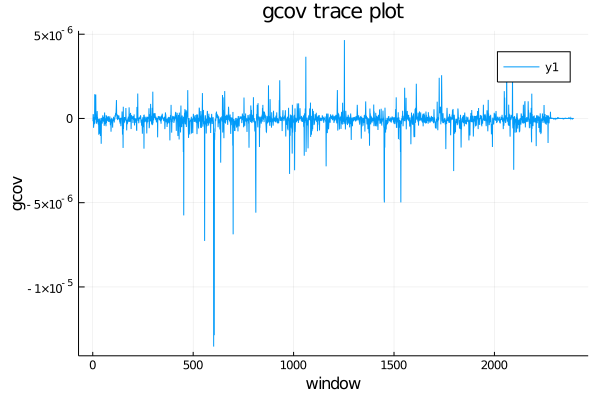

In [21]:
using Plots
x = rg[!,2]; y = rg[!,9]; # These are the plotting data
plot(x,y, title = "gcov trace plot",
        xlabel = "window", ylabel = "gcov")

In [22]:
# Find the window that explanied most gcov
findmin(rg[!,9])

(-1.354144457796341e-5, 602)

In [23]:
@time FinADG_outB,winVarProps = GWAS("MCMC_BayesB_marker_effects_geno_FinADG.txt",
    "/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    model;header=true,window_size="1 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:35:40


BoundsError: BoundsError: attempt to access (2395×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 557    │ 3      │ 129000000 │ 130000000 │ 129000890 │ 129998184 │ 225    │ 4.69131e-5     │ 4.93903e-5  │ 1.02     │ 0.733333   │ 0.733333  │
│ 2    │ 1     │ 605    │ 4      │ 44000000  │ 45000000  │ 44002145  │ 44999873  │ 191    │ 6.08017e-5     │ 9.9947e-5   │ 1.3      │ 0.493333   │ 0.613333  │
│ 3    │ 1     │ 990    │ 7      │ 22000000  │ 23000000  │ 22003711  │ 22970603  │ 188    │ 2.20259e-5     │ 3.92033e-5  │ 0.48     │ 0.453333   │ 0.56      │
│ 4    │ 1     │ 1162   │ 8      │ 72000000  │ 73000000  │ 72000801  │ 72997258  │ 255    │ 1.46861e-5     │ 2.69764e-5  │ 0.32     │ 0.431111   │ 0.527778  │
│ 5    │ 1     │ 1260   │ 9      │ 31000000  │ 32000000  │ 31000998  │ 31998179  │ 203    │ 1.86763e-5     │ 3.4586e-5   │ 0.41     │ 0.428889   │ 0.508     │
│ 6    │ 1     │ 931    │ 6      │ 134000000 │ 135000000 │ 134002906 │ 134988109 │ 198    │ 1.51496e-5     │ 2.81056e-5  │ 0.33     │ 0.426667   │ 0.494444  │
│ 7    │ 1     │ 1534   │ 12     │ 15000000  │ 16000000  │ 15004647  │ 15993017  │ 220    │ 1.47556e-5     │ 2.8173e-5   │ 0.32     │ 0.424444   │ 0.484444  │
│ 8    │ 1     │ 812    │ 6      │ 15000000  │ 16000000  │ 15000303  │ 15977371  │ 175    │ 1.1557e-5      │ 2.13424e-5  │ 0.25     │ 0.397778   │ 0.473611  │
│ 9    │ 1     │ 993    │ 7      │ 25000000  │ 26000000  │ 25001072  │ 25997123  │ 259    │ 1.46841e-5     │ 2.92537e-5  │ 0.32     │ 0.388889   │ 0.464198  │
│ 10   │ 1     │ 151    │ 1      │ 150000000 │ 151000000 │ 150000496 │ 150984488 │ 162    │ 2.20531e-5     │ 4.37253e-5  │ 0.47     │ 0.386667   │ 0.456444  │
│ 11   │ 1     │ 2076   │ 16     │ 3000000   │ 4000000   │ 3001996   │ 3998921   │ 245    │ 1.28258e-5     │ 2.49877e-5  │ 0.28     │ 0.382222   │ 0.449697  │
│ 12   │ 1     │ 602    │ 4      │ 41000000  │ 42000000  │ 41003994  │ 41995315  │ 188    │ 4.63487e-5     │ 9.70605e-5  │ 0.98     │ 0.38       │ 0.443889  │
│ 13   │ 1     │ 1061   │ 7      │ 93000000  │ 94000000  │ 93000355  │ 93980818  │ 228    │ 1.33826e-5     │ 2.45494e-5  │ 0.29     │ 0.375556   │ 0.438632  │
│ 14   │ 1     │ 473    │ 3      │ 45000000  │ 46000000  │ 45001539  │ 45998479  │ 170    │ 1.46038e-5     │ 2.77938e-5  │ 0.32     │ 0.368889   │ 0.433651  │
│ 15   │ 1     │ 119    │ 1      │ 118000000 │ 119000000 │ 118001042 │ 118999237 │ 107    │ 1.68359e-5     │ 3.24421e-5  │ 0.37     │ 0.366667   │ 0.429185  │
│ 16   │ 1     │ 752    │ 5      │ 60000000  │ 61000000  │ 60058969  │ 60941677  │ 218    │ 1.4658e-5      │ 2.97402e-5  │ 0.31     │ 0.362222   │ 0.425     │
│ 17   │ 1     │ 1063   │ 7      │ 95000000  │ 96000000  │ 95003365  │ 95999110  │ 172    │ 2.75043e-5     │ 5.42034e-5  │ 0.59     │ 0.362222   │ 0.421307  │
│ 18   │ 1     │ 1253   │ 9      │ 24000000  │ 25000000  │ 24004093  │ 24994001  │ 284    │ 8.93442e-6     │ 1.767e-5    │ 0.19     │ 0.337778   │ 0.416667  │
│ 19   │ 1     │ 991    │ 7      │ 23000000  │ 24000000  │ 23001142  │ 23999710  │ 243    │ 1.57872e-5     │ 3.3968e-5   │ 0.34     │ 0.331111   │ 0.412164  │
│ 20   │ 1     │ 2061   │ 15     │ 129000000 │ 130000000 │ 129002403 │ 129996887 │ 249    │ 6.89141e-6     │ 1.33037e-5  │ 0.15     │ 0.328889   │ 0.408     │
│ 21   │ 1     │ 1005   │ 7      │ 37000000  │ 38000000  │ 37014607  │ 37997693  │ 202    │ 8.83596e-6     │ 1.9666e-5   │ 0.19     │ 0.324444   │ 0.404021  │
│ 22   │ 1     │ 453    │ 3      │ 25000000  │ 26000000  │ 25001822  │ 25998487  │ 264    │ 7.80546e-6     │ 1.70063e-5  │ 0.17     │ 0.315556   │ 0.4       │
│ 23   │ 1     │ 451    │ 3      │ 23000000  │ 24000000  │ 23003889  │ 23992988  │ 245    │ 7.55891e-6     │ 1.54985e-5  │ 0.17     │ 0.311111   │ 0.396135  │
│ 24   │ 1     │ 1560   │ 12     │ 41000000  │ 42000000  │ 41001232  │ 41950202  │ 230    │ 1.0206e-5      │ 2.34054e-5  │ 0.22     │ 0.308889   │ 0.3925    │
│ 25   │ 1     │ 2151   │ 16     │ 78000000  │ 79000000  │ 78005346  │ 78995586  │ 205    │ 1.21922e-5     │ 2.75391e-5  │ 0.26     │ 0.308889   │ 0.389156  │
│ 26   │ 1     │ 1452   │ 11     │ 13000000  │ 14000000  │ 13011748  │ 13993989  │ 211    │ 9.62139e-6     │ 2.08022e-5  │ 0.21     │ 0.306667   │ 0.385983  │
│ 27   │ 1     │ 1532   │ 12     │ 13000000  │ 14000000  │ 13008602  │ 13982775  │ 259    │ 1.00373e-5     │ 2.2851e-5   │ 0.22     │ 0.302222   │ 0.382881  │
│ 28   │ 1     │ 2090   │ 16     │ 17000000  │ 18000000  │ 17001516  │ 17996098  │ 250    │ 6.02839e-6     │ 1.26133e-5  │ 0.13     │ 0.302222   │ 0.38      │
│ 29   │ 1     │ 483    │ 3      │ 55000000  │ 56000000  │ 55001430  │ 55932716  │ 169    │ 1.12465e-5     │ 2.69972e-5  │ 0.25     │ 0.3        │ 0.377241  │
│ 30   │ 1     │ 1062   │ 7      │ 94000000  │ 95000000  │ 94005381  │ 94997328  │ 139    │ 1.38802e-5     │ 3.06911e-5  │ 0.3      │ 0.3        │ 0.374667  │
│ 31   │ 1     │ 1225   │ 8      │ 135000000 │ 136000000 │ 135003045 │ 135995736 │ 283    │ 7.38994e-6     │ 1.50686e-5  │ 0.16     │ 0.297778   │ 0.372186  │
│ 32   │ 1     │ 1451   │ 11     │ 12000000  │ 13000000  │ 12008972  │ 12996406  │ 238    │ 1.14871e-5     │ 2.89942e-5  │ 0.25     │ 0.295556   │ 0.369792  │
│ 33   │ 1     │ 649    │ 4      │ 88000000  │ 89000000  │ 88000708  │ 88973114  │ 220    │ 8.86559e-6     │ 2.14103e-5  │ 0.19     │ 0.291111   │ 0.367407  │
│ 34   │ 1     │ 2185   │ 17     │ 32000000  │ 33000000  │ 32000858  │ 32998532  │ 260    │ 7.44255e-6     │ 1.64343e-5  │ 0.16     │ 0.282222   │ 0.364902  │
│ 35   │ 1     │ 959    │ 6      │ 162000000 │ 163000000 │ 162053645 │ 162935527 │ 190    │ 6.61507e-6     │ 1.44693e-5  │ 0.14     │ 0.277778   │ 0.362413  │
│ 36   │ 1     │ 392    │ 2      │ 116000000 │ 117000000 │ 116000379 │ 116995291 │ 269    │ 7.01376e-6     │ 1.48051e-5  │ 0.15     │ 0.273333   │ 0.359938  │
│ 37   │ 1     │ 650    │ 4      │ 89000000  │ 90000000  │ 89088205  │ 89998284  │ 214    │ 8.71857e-6     │ 2.54904e-5  │ 0.19     │ 0.273333   │ 0.357598  │
│ 38   │ 1     │ 697    │ 5      │ 5000000   │ 6000000   │ 5032757   │ 5995664   │ 193    │ 8.94505e-6     │ 2.04272e-5  │ 0.2      │ 0.273333   │ 0.35538   │
│ 39   │ 1     │ 1359   │ 9      │ 130000000 │ 131000000 │ 130005999 │ 130982218 │ 253    │ 7.16892e-6     │ 1.6031e-5   │ 0.16     │ 0.273333   │ 0.353276  │
│ 40   │ 1     │ 865    │ 6      │ 68000000  │ 69000000  │ 68006113  │ 68999679  │ 191    │ 7.46021e-6     │ 1.76625e-5  │ 0.16     │ 0.266667   │ 0.351111  │
│ 41   │ 1     │ 1799   │ 14     │ 9000000   │ 10000000  │ 9004188   │ 9996775   │ 284    │ 5.90781e-6     │ 1.4242e-5   │ 0.13     │ 0.266667   │ 0.349051  │
│ 42   │ 1     │ 699    │ 5      │ 7000000   │ 8000000   │ 7003116   │ 7997195   │ 179    │ 4.89664e-6     │ 1.03632e-5  │ 0.11     │ 0.262222   │ 0.346984  │
│ 43   │ 1     │ 932    │ 6      │ 135000000 │ 136000000 │ 135001414 │ 135998609 │ 238    │ 4.99967e-6     │ 1.08812e-5  │ 0.11     │ 0.262222   │ 0.345013  │
│ 44   │ 1     │ 1553   │ 12     │ 34000000  │ 35000000  │ 34003193  │ 34998176  │ 238    │ 6.77687e-6     │ 1.51465e-5  │ 0.15     │ 0.262222   │ 0.343131  │
│ 45   │ 1     │ 757    │ 5      │ 65000000  │ 66000000  │ 65000007  │ 65997447  │ 302    │ 4.68811e-6     │ 1.00295e-5  │ 0.1      │ 0.26       │ 0.341284  │
│ 46   │ 1     │ 1258   │ 9      │ 29000000  │ 30000000  │ 29001236  │ 29997197  │ 179    │ 7.51695e-6     │ 1.6661e-5   │ 0.17     │ 0.26       │ 0.339517  │
│ 47   │ 1     │ 1522   │ 12     │ 3000000   │ 4000000   │ 3000825   │ 3998905   │ 173    │ 6.89737e-6     │ 1.66811e-5  │ 0.15     │ 0.26       │ 0.337825  │
│ 48   │ 1     │ 1463   │ 11     │ 24000000  │ 25000000  │ 24006118  │ 24998435  │ 279    │ 7.46908e-6     │ 1.89835e-5  │ 0.16     │ 0.255556   │ 0.336111  │
│ 49   │ 1     │ 15     │ 1      │ 14000000  │ 15000000  │ 14002294  │ 14993669  │ 263    │ 7.82122e-6     │ 2.09029e-5  │ 0.17     │ 0.253333   │ 0.334422  │
│ 50   │ 1     │ 1006   │ 7      │ 38000000  │ 39000000  │ 38001363  │ 38998747  │ 242    │ 6.86884e-6     │ 1.68306e-5  │ 0.15     │ 0.253333   │ 0.3328    │
│ 51   │ 1     │ 1569   │ 12     │ 50000000  │ 51000000  │ 50001815  │ 50999769  │ 251    │ 9.60173e-6     │ 2.39246e-5  │ 0.21     │ 0.253333   │ 0.331242  │
│ 52   │ 1     │ 2253   │ 18     │ 36000000  │ 37000000  │ 36000925  │ 36998442  │ 198    │ 6.58057e-6     │ 1.60505e-5  │ 0.14     │ 0.253333   │ 0.329744  │
│ 53   │ 1     │ 1084   │ 7      │ 116000000 │ 117000000 │ 116000136 │ 116996697 │ 264    │ 6.65749e-6     │ 1.59027e-5  │ 0.14     │ 0.248889   │ 0.328218  │
│ 54   │ 1     │ 1390   │ 10     │ 21000000  │ 22000000  │ 21010664  │ 21999389  │ 192    │ 7.59626e-6     │ 2.07232e-5  │ 0.16     │ 0.248889   │ 0.326749  │
│ 55   │ 1     │ 2231   │ 18     │ 14000000  │ 15000000  │ 14002845  │ 14995923  │ 164    │ 7.33552e-6     │ 1.88265e-5  │ 0.16     │ 0.246667   │ 0.325293  │
│ 56   │ 1     │ 426    │ 2      │ 150000000 │ 151000000 │ 150000500 │ 150995892 │ 282    │ 4.83237e-6     │ 1.15921e-5  │ 0.11     │ 0.242222   │ 0.32381   │
│ 57   │ 1     │ 2197   │ 17     │ 44000000  │ 45000000  │ 44001475  │ 44997333  │ 156    │ 6.02612e-6     │ 1.51885e-5  │ 0.13     │ 0.242222   │ 0.322378  │
│ 58   │ 1     │ 1089   │ 7      │ 121000000 │ 122000000 │ 121001006 │ 121791035 │ 167    │ 6.13411e-6     │ 1.50724e-5  │ 0.13     │ 0.24       │ 0.320958  │
│ 59   │ 1     │ 653    │ 4      │ 92000000  │ 93000000  │ 92005234  │ 92991619  │ 244    │ 6.2836e-6      │ 1.73491e-5  │ 0.14     │ 0.237778   │ 0.319548  │
│ 60   │ 1     │ 548    │ 3      │ 120000000 │ 121000000 │ 120001184 │ 120997364 │ 231    │ 5.19503e-6     │ 1.26246e-5  │ 0.11     │ 0.235556   │ 0.318148  │
│ 61   │ 1     │ 603    │ 4      │ 42000000  │ 43000000  │ 42001625  │ 42973158  │ 124    │ 2.62323e-5     │ 7.16571e-5  │ 0.58     │ 0.235556   │ 0.316794  │
│ 62   │ 1     │ 1375   │ 10     │ 6000000   │ 7000000   │ 6000857   │ 6996554   │ 254    │ 4.44925e-6     │ 1.06617e-5  │ 0.1      │ 0.235556   │ 0.315484  │
│ 63   │ 1     │ 2144   │ 16     │ 71000000  │ 72000000  │ 71022969  │ 71995274  │ 257    │ 1.18158e-5     │ 3.29389e-5  │ 0.26     │ 0.235556   │ 0.314215  │
│ 64   │ 1     │ 811    │ 6      │ 14000000  │ 15000000  │ 14004420  │ 14998202  │ 212    │ 5.64297e-6     │ 1.35549e-5  │ 0.12     │ 0.233333   │ 0.312951  │
│ 65   │ 1     │ 875    │ 6      │ 78000000  │ 79000000  │ 78000385  │ 78999521  │ 271    │ 4.20249e-6     │ 9.15089e-6  │ 0.09     │ 0.233333   │ 0.311726  │
│ 66   │ 1     │ 1511   │ 11     │ 72000000  │ 73000000  │ 72000796  │ 72998064  │ 245    │ 4.56778e-6     │ 1.10763e-5  │ 0.1      │ 0.233333   │ 0.310539  │
│ 67   │ 1     │ 1591   │ 13     │ 10000000  │ 11000000  │ 10003121  │ 10999616  │ 255    │ 4.46252e-6     │ 1.06547e-5  │ 0.1      │ 0.231111   │ 0.309353  │
│ 68   │ 1     │ 1732   │ 13     │ 151000000 │ 152000000 │ 151030326 │ 151999588 │ 232    │ 5.32384e-6     │ 1.3366e-5   │ 0.12     │ 0.231111   │ 0.308203  │
│ 69   │ 1     │ 1829   │ 14     │ 39000000  │ 40000000  │ 39001669  │ 39998746  │ 189    │ 5.09967e-6     │ 1.15415e-5  │ 0.11     │ 0.231111   │ 0.307085  │
│ 70   │ 1     │ 2077   │ 16     │ 4000000   │ 5000000   │ 4002367   │ 4994366   │ 243    │ 6.86827e-6     │ 1.90653e-5  │ 0.15     │ 0.231111   │ 0.306     │
│ 71   │ 1     │ 280    │ 2      │ 4000000   │ 5000000   │ 4012479   │ 4999397   │ 203    │ 6.22185e-6     │ 1.52453e-5  │ 0.14     │ 0.228889   │ 0.304914  │
│ 72   │ 1     │ 703    │ 5      │ 11000000  │ 12000000  │ 11001667  │ 11996380  │ 235    │ 4.81797e-6     │ 1.21112e-5  │ 0.1      │ 0.228889   │ 0.303858  │
│ 73   │ 1     │ 1217   │ 8      │ 127000000 │ 128000000 │ 127000766 │ 127993152 │ 211    │ 5.95288e-6     │ 1.59379e-5  │ 0.13     │ 0.228889   │ 0.302831  │
│ 74   │ 1     │ 2225   │ 18     │ 8000000   │ 9000000   │ 8000801   │ 8938737   │ 229    │ 5.14145e-6     │ 1.28405e-5  │ 0.11     │ 0.228889   │ 0.301832  │
│ 75   │ 1     │ 153    │ 1      │ 152000000 │ 153000000 │ 152002944 │ 152996868 │ 163    │ 6.95623e-6     │ 1.97076e-5  │ 0.15     │ 0.226667   │ 0.30083   │
│ 76   │ 1     │ 390    │ 2      │ 114000000 │ 115000000 │ 114001748 │ 114996369 │ 198    │ 4.96581e-6     │ 1.14369e-5  │ 0.11     │ 0.226667   │ 0.299854  │
│ 77   │ 1     │ 994    │ 7      │ 26000000  │ 27000000  │ 26007598  │ 26997638  │ 265    │ 4.59106e-6     │ 1.04349e-5  │ 0.1      │ 0.226667   │ 0.298903  │
│ 78   │ 1     │ 1828   │ 14     │ 38000000  │ 39000000  │ 38016878  │ 38985697  │ 222    │ 6.77042e-6     │ 1.82041e-5  │ 0.15     │ 0.226667   │ 0.297977  │
│ 79   │ 1     │ 299    │ 2      │ 23000000  │ 24000000  │ 23006617  │ 23997297  │ 243    │ 4.51057e-6     │ 1.08339e-5  │ 0.1      │ 0.224444   │ 0.297046  │
│ 80   │ 1     │ 1216   │ 8      │ 126000000 │ 127000000 │ 126001921 │ 126998421 │ 220    │ 4.26245e-6     │ 9.3768e-6   │ 0.09     │ 0.224444   │ 0.296139  │
│ 81   │ 1     │ 118    │ 1      │ 117000000 │ 118000000 │ 117001841 │ 117988311 │ 182    │ 5.78674e-6     │ 1.40052e-5  │ 0.13     │ 0.222222   │ 0.295226  │
│ 82   │ 1     │ 2184   │ 17     │ 31000000  │ 32000000  │ 31013974  │ 31999780  │ 214    │ 5.20927e-6     │ 1.30237e-5  │ 0.11     │ 0.222222   │ 0.294336  │
│ 83   │ 1     │ 637    │ 4      │ 76000000  │ 77000000  │ 76038547  │ 76999110  │ 144    │ 5.20482e-6     │ 1.24268e-5  │ 0.11     │ 0.22       │ 0.29344   │
│ 84   │ 1     │ 1385   │ 10     │ 16000000  │ 17000000  │ 16005966  │ 16998009  │ 221    │ 4.83977e-6     │ 1.33204e-5  │ 0.1      │ 0.22       │ 0.292566  │
│ 85   │ 1     │ 1521   │ 12     │ 2000000   │ 3000000   │ 2005645   │ 2997712   │ 213    │ 4.9806e-6      │ 1.30878e-5  │ 0.11     │ 0.22       │ 0.291712  │
│ 86   │ 1     │ 1969   │ 15     │ 37000000  │ 38000000  │ 37006182  │ 37992104  │ 179    │ 6.77208e-6     │ 1.65208e-5  │ 0.14     │ 0.22       │ 0.290879  │
│ 87   │ 1     │ 2183   │ 17     │ 30000000  │ 31000000  │ 30002660  │ 30993815  │ 252    │ 4.91367e-6     │ 1.18999e-5  │ 0.11     │ 0.22       │ 0.290064  │
│ 88   │ 1     │ 866    │ 6      │ 69000000  │ 70000000  │ 69010272  │ 69996437  │ 174    │ 4.89791e-6     │ 1.09073e-5  │ 0.11     │ 0.217778   │ 0.289242  │
│ 89   │ 1     │ 470    │ 3      │ 42000000  │ 43000000  │ 42005780  │ 42989379  │ 91     │ 8.33475e-6     │ 2.30018e-5  │ 0.18     │ 0.215556   │ 0.288414  │
│ 90   │ 1     │ 648    │ 4      │ 87000000  │ 88000000  │ 87001010  │ 87994867  │ 240    │ 3.76428e-6     │ 9.7664e-6   │ 0.08     │ 0.213333   │ 0.28758   │
│ 91   │ 1     │ 686    │ 4      │ 125000000 │ 126000000 │ 125001553 │ 125997761 │ 278    │ 5.48886e-6     │ 1.79731e-5  │ 0.12     │ 0.213333   │ 0.286764  │
│ 92   │ 1     │ 972    │ 7      │ 4000000   │ 5000000   │ 4002464   │ 4999309   │ 209    │ 5.5349e-6      │ 1.63709e-5  │ 0.12     │ 0.213333   │ 0.285966  │
│ 93   │ 1     │ 219    │ 1      │ 218000000 │ 219000000 │ 218000436 │ 218999878 │ 147    │ 4.21139e-6     │ 1.11245e-5  │ 0.09     │ 0.211111   │ 0.285161  │
│ 94   │ 1     │ 1606   │ 13     │ 25000000  │ 26000000  │ 25003126  │ 25999180  │ 263    │ 4.35062e-6     │ 1.07403e-5  │ 0.1      │ 0.211111   │ 0.284374  │
│ 95   │ 1     │ 2055   │ 15     │ 123000000 │ 124000000 │ 123002910 │ 123990939 │ 263    │ 4.56407e-6     │ 1.13867e-5  │ 0.1      │ 0.211111   │ 0.283602  │
│ 96   │ 1     │ 2186   │ 17     │ 33000000  │ 34000000  │ 33003841  │ 33998498  │ 258    │ 3.40396e-6     │ 7.3406e-6   │ 0.07     │ 0.211111   │ 0.282847  │
│ 97   │ 1     │ 843    │ 6      │ 46000000  │ 47000000  │ 46001718  │ 46999974  │ 204    │ 5.68376e-6     │ 1.65109e-5  │ 0.12     │ 0.208889   │ 0.282085  │
│ 98   │ 1     │ 952    │ 6      │ 155000000 │ 156000000 │ 155002417 │ 155999302 │ 241    │ 4.48556e-6     │ 1.13165e-5  │ 0.1      │ 0.208889   │ 0.281338  │
│ 99   │ 1     │ 657    │ 4      │ 96000000  │ 97000000  │ 96001092  │ 96996272  │ 242    │ 3.65043e-6     │ 8.52749e-6  │ 0.08     │ 0.206667   │ 0.280584  │
│ 100  │ 1     │ 778    │ 5      │ 86000000  │ 87000000  │ 86009966  │ 86872108  │ 194    │ 5.22114e-6     │ 1.30546e-5  │ 0.11     │ 0.206667   │ 0.279844  │
│ 101  │ 1     │ 943    │ 6      │ 146000000 │ 147000000 │ 146001490 │ 146997249 │ 194    │ 4.69183e-6     │ 1.26044e-5  │ 0.1      │ 0.206667   │ 0.27912   │
│ 102  │ 1     │ 988    │ 7      │ 20000000  │ 21000000  │ 20001975  │ 20995550  │ 217    │ 5.85193e-6     │ 1.73811e-5  │ 0.13     │ 0.206667   │ 0.27841   │
│ 103  │ 1     │ 1218   │ 8      │ 128000000 │ 129000000 │ 128001103 │ 128998337 │ 195    │ 5.65845e-6     │ 1.58034e-5  │ 0.12     │ 0.204444   │ 0.277691  │
│ 104  │ 1     │ 1454   │ 11     │ 15000000  │ 16000000  │ 15000250  │ 15998769  │ 189    │ 4.53429e-6     │ 1.13369e-5  │ 0.1      │ 0.204444   │ 0.276987  │
│ 105  │ 1     │ 1797   │ 14     │ 7000000   │ 8000000   │ 7001829   │ 7998693   │ 237    │ 3.92612e-6     │ 9.4389e-6   │ 0.08     │ 0.204444   │ 0.276296  │
│ 106  │ 1     │ 1819   │ 14     │ 29000000  │ 30000000  │ 29001692  │ 29997165  │ 187    │ 6.22611e-6     │ 1.88382e-5  │ 0.14     │ 0.204444   │ 0.275618  │
│ 107  │ 1     │ 1906   │ 14     │ 116000000 │ 117000000 │ 116001402 │ 116997170 │ 218    │ 4.22933e-6     │ 1.07492e-5  │ 0.09     │ 0.204444   │ 0.274953  │
│ 108  │ 1     │ 2168   │ 17     │ 15000000  │ 16000000  │ 15060479  │ 15995802  │ 219    │ 4.53416e-6     │ 1.30431e-5  │ 0.1      │ 0.204444   │ 0.2743    │
│ 109  │ 1     │ 1072   │ 7      │ 104000000 │ 105000000 │ 104010472 │ 104992883 │ 228    │ 4.32652e-6     │ 1.28275e-5  │ 0.09     │ 0.202222   │ 0.273639  │
│ 110  │ 1     │ 1094   │ 8      │ 4000000   │ 5000000   │ 4002508   │ 4992908   │ 182    │ 6.36736e-6     │ 1.75632e-5  │ 0.14     │ 0.202222   │ 0.27299   │
│ 111  │ 1     │ 1224   │ 8      │ 134000000 │ 135000000 │ 134001251 │ 134996704 │ 243    │ 3.73028e-6     │ 9.3694e-6   │ 0.08     │ 0.202222   │ 0.272352  │
│ 112  │ 1     │ 1834   │ 14     │ 44000000  │ 45000000  │ 44001184  │ 44992256  │ 235    │ 4.43502e-6     │ 1.05686e-5  │ 0.1      │ 0.202222   │ 0.271726  │
│ 113  │ 1     │ 2106   │ 16     │ 33000000  │ 34000000  │ 33006305  │ 33999511  │ 238    │ 3.11676e-6     │ 6.82927e-6  │ 0.07     │ 0.202222   │ 0.271111  │
│ 114  │ 1     │ 240    │ 1      │ 239000000 │ 240000000 │ 239004635 │ 239999041 │ 243    │ 3.58908e-6     │ 8.21106e-6  │ 0.08     │ 0.2        │ 0.270487  │
│ 115  │ 1     │ 1293   │ 9      │ 64000000  │ 65000000  │ 64000934  │ 64998071  │ 248    │ 4.93641e-6     │ 1.23911e-5  │ 0.11     │ 0.2        │ 0.269874  │
│ 116  │ 1     │ 2078   │ 16     │ 5000000   │ 6000000   │ 5002482   │ 5999039   │ 301    │ 3.9519e-6      │ 1.29187e-5  │ 0.08     │ 0.2        │ 0.269272  │
│ 117  │ 1     │ 2226   │ 18     │ 9000000   │ 10000000  │ 9010257   │ 9997862   │ 221    │ 4.68559e-6     │ 1.27866e-5  │ 0.1      │ 0.2        │ 0.26868   │
│ 118  │ 1     │ 290    │ 2      │ 14000000  │ 15000000  │ 14010179  │ 14996227  │ 145    │ 6.84938e-6     │ 2.12777e-5  │ 0.15     │ 0.197778   │ 0.268079  │
│ 119  │ 1     │ 450    │ 3      │ 22000000  │ 23000000  │ 22000037  │ 22985475  │ 206    │ 4.45825e-6     │ 1.2926e-5   │ 0.1      │ 0.197778   │ 0.267488  │
│ 120  │ 1     │ 570    │ 4      │ 9000000   │ 10000000  │ 9002400   │ 9997747   │ 241    │ 5.20965e-6     │ 1.56695e-5  │ 0.11     │ 0.197778   │ 0.266907  │
│ 121  │ 1     │ 1830   │ 14     │ 40000000  │ 41000000  │ 40003077  │ 40995716  │ 193    │ 4.97741e-6     │ 1.31455e-5  │ 0.11     │ 0.197778   │ 0.266336  │
│ 122  │ 1     │ 439    │ 3      │ 11000000  │ 12000000  │ 11001814  │ 11999563  │ 265    │ 4.0398e-6      │ 1.10464e-5  │ 0.09     │ 0.195556   │ 0.265756  │
│ 123  │ 1     │ 10     │ 1      │ 9000000   │ 10000000  │ 9009759   │ 9995902   │ 239    │ 3.00579e-6     │ 7.11081e-6  │ 0.07     │ 0.193333   │ 0.265167  │
│ 124  │ 1     │ 459    │ 3      │ 31000000  │ 32000000  │ 31002224  │ 31998911  │ 241    │ 3.58475e-6     │ 8.79346e-6  │ 0.08     │ 0.193333   │ 0.264588  │
│ 125  │ 1     │ 646    │ 4      │ 85000000  │ 86000000  │ 85000238  │ 85987161  │ 268    │ 3.49416e-6     │ 9.4353e-6   │ 0.08     │ 0.193333   │ 0.264018  │
│ 126  │ 1     │ 929    │ 6      │ 132000000 │ 133000000 │ 132002947 │ 132999380 │ 207    │ 4.82246e-6     │ 1.37745e-5  │ 0.11     │ 0.193333   │ 0.263457  │
│ 127  │ 1     │ 980    │ 7      │ 12000000  │ 13000000  │ 12008520  │ 12999951  │ 220    │ 4.28323e-6     │ 1.15204e-5  │ 0.09     │ 0.193333   │ 0.262905  │
│ 128  │ 1     │ 1355   │ 9      │ 126000000 │ 127000000 │ 126000423 │ 126999164 │ 249    │ 2.90411e-6     │ 6.79957e-6  │ 0.06     │ 0.193333   │ 0.262361  │
│ 129  │ 1     │ 1921   │ 14     │ 131000000 │ 132000000 │ 131002943 │ 131998574 │ 255    │ 3.87951e-6     │ 1.01435e-5  │ 0.09     │ 0.193333   │ 0.261826  │
│ 130  │ 1     │ 2128   │ 16     │ 55000000  │ 56000000  │ 55000251  │ 55997272  │ 221    │ 4.97609e-6     │ 1.4943e-5   │ 0.11     │ 0.193333   │ 0.261299  │
│ 131  │ 1     │ 564    │ 4      │ 3000000   │ 4000000   │ 3000583   │ 3998029   │ 277    │ 3.28375e-6     │ 1.00134e-5  │ 0.07     │ 0.191111   │ 0.260763  │
│ 132  │ 1     │ 1372   │ 10     │ 3000000   │ 4000000   │ 3000281   │ 3999351   │ 251    │ 3.37428e-6     │ 8.93987e-6  │ 0.07     │ 0.191111   │ 0.260236  │
│ 133  │ 1     │ 1835   │ 14     │ 45000000  │ 46000000  │ 45001414  │ 45878779  │ 176    │ 4.04858e-6     │ 1.05493e-5  │ 0.09     │ 0.191111   │ 0.259716  │
│ 134  │ 1     │ 2070   │ 15     │ 138000000 │ 139000000 │ 138003374 │ 138997397 │ 192    │ 5.05398e-6     │ 1.67962e-5  │ 0.11     │ 0.191111   │ 0.259204  │
│ 135  │ 1     │ 2133   │ 16     │ 60000000  │ 61000000  │ 60001022  │ 60996089  │ 227    │ 3.86303e-6     │ 1.00421e-5  │ 0.08     │ 0.191111   │ 0.2587    │
│ 136  │ 1     │ 2138   │ 16     │ 65000000  │ 66000000  │ 65007018  │ 65999536  │ 228    │ 3.82806e-6     │ 1.00634e-5  │ 0.08     │ 0.191111   │ 0.258203  │
│ 137  │ 1     │ 2242   │ 18     │ 25000000  │ 26000000  │ 25003089  │ 25999264  │ 230    │ 4.42804e-6     │ 1.2819e-5   │ 0.1      │ 0.191111   │ 0.257713  │
│ 138  │ 1     │ 243    │ 1      │ 242000000 │ 243000000 │ 242005704 │ 242965606 │ 175    │ 4.01102e-6     │ 1.11587e-5  │ 0.09     │ 0.188889   │ 0.257214  │
│ 139  │ 1     │ 601    │ 4      │ 40000000  │ 41000000  │ 40000761  │ 40998021  │ 269    │ 3.74285e-6     │ 1.07644e-5  │ 0.08     │ 0.188889   │ 0.256723  │
│ 140  │ 1     │ 687    │ 4      │ 126000000 │ 127000000 │ 126004065 │ 126996149 │ 295    │ 4.28633e-6     │ 1.15087e-5  │ 0.09     │ 0.188889   │ 0.256238  │
│ 141  │ 1     │ 841    │ 6      │ 44000000  │ 45000000  │ 44007794  │ 44999321  │ 214    │ 5.21146e-6     │ 1.48031e-5  │ 0.11     │ 0.188889   │ 0.25576   │
│ 142  │ 1     │ 844    │ 6      │ 47000000  │ 48000000  │ 47001652  │ 47999899  │ 239    │ 3.71952e-6     │ 9.33206e-6  │ 0.08     │ 0.188889   │ 0.25529   │
│ 143  │ 1     │ 1738   │ 13     │ 157000000 │ 158000000 │ 157000161 │ 157996816 │ 216    │ 5.22647e-6     │ 1.58011e-5  │ 0.11     │ 0.188889   │ 0.254825  │
│ 144  │ 1     │ 288    │ 2      │ 12000000  │ 13000000  │ 12006992  │ 12999460  │ 215    │ 3.54372e-6     │ 8.67033e-6  │ 0.08     │ 0.186667   │ 0.254352  │
│ 145  │ 1     │ 754    │ 5      │ 62000000  │ 63000000  │ 62006261  │ 62999146  │ 234    │ 3.27107e-6     │ 7.71484e-6  │ 0.07     │ 0.186667   │ 0.253885  │
│ 146  │ 1     │ 2251   │ 18     │ 34000000  │ 35000000  │ 34007636  │ 34988064  │ 166    │ 4.25593e-6     │ 1.1913e-5   │ 0.09     │ 0.186667   │ 0.253425  │
│ 147  │ 1     │ 975    │ 7      │ 7000000   │ 8000000   │ 7004353   │ 7990990   │ 205    │ 4.07814e-6     │ 1.15646e-5  │ 0.09     │ 0.184444   │ 0.252955  │
│ 148  │ 1     │ 1294   │ 9      │ 65000000  │ 66000000  │ 65003469  │ 65999371  │ 201    │ 3.83019e-6     │ 1.02647e-5  │ 0.08     │ 0.184444   │ 0.252492  │
│ 149  │ 1     │ 1380   │ 10     │ 11000000  │ 12000000  │ 11004581  │ 11998795  │ 290    │ 3.1423e-6      │ 7.22812e-6  │ 0.07     │ 0.184444   │ 0.252036  │
│ 150  │ 1     │ 1465   │ 11     │ 26000000  │ 27000000  │ 26016976  │ 26987955  │ 248    │ 3.72726e-6     │ 1.04958e-5  │ 0.08     │ 0.184444   │ 0.251585  │
│ 151  │ 1     │ 1584   │ 13     │ 3000000   │ 4000000   │ 3003702   │ 3996499   │ 240    │ 3.77994e-6     │ 1.12338e-5  │ 0.08     │ 0.184444   │ 0.251141  │
│ 152  │ 1     │ 1737   │ 13     │ 156000000 │ 157000000 │ 156001968 │ 156986020 │ 211    │ 4.741e-6       │ 1.34362e-5  │ 0.1      │ 0.184444   │ 0.250702  │
│ 153  │ 1     │ 2050   │ 15     │ 118000000 │ 119000000 │ 118000415 │ 118998748 │ 246    │ 3.40355e-6     │ 9.91373e-6  │ 0.07     │ 0.184444   │ 0.250269  │
│ 154  │ 1     │ 565    │ 4      │ 4000000   │ 5000000   │ 4004185   │ 4993072   │ 291    │ 2.85025e-6     │ 6.82291e-6  │ 0.06     │ 0.182222   │ 0.249827  │
│ 155  │ 1     │ 1095   │ 8      │ 5000000   │ 6000000   │ 5005169   │ 5988226   │ 180    │ 4.92524e-6     │ 1.40843e-5  │ 0.11     │ 0.182222   │ 0.249391  │
│ 156  │ 1     │ 1167   │ 8      │ 77000000  │ 78000000  │ 77002839  │ 77998224  │ 213    │ 3.35179e-6     │ 8.76935e-6  │ 0.07     │ 0.182222   │ 0.24896   │
│ 157  │ 1     │ 1221   │ 8      │ 131000000 │ 132000000 │ 131003752 │ 131999439 │ 262    │ 4.37759e-6     │ 1.24549e-5  │ 0.1      │ 0.182222   │ 0.248535  │
│ 158  │ 1     │ 1588   │ 13     │ 7000000   │ 8000000   │ 7001076   │ 7988873   │ 201    │ 5.77101e-6     │ 1.86672e-5  │ 0.13     │ 0.182222   │ 0.248115  │
│ 159  │ 1     │ 1873   │ 14     │ 83000000  │ 84000000  │ 83004580  │ 83999348  │ 188    │ 4.0679e-6      │ 1.15466e-5  │ 0.09     │ 0.182222   │ 0.247701  │
│ 160  │ 1     │ 404    │ 2      │ 128000000 │ 129000000 │ 128001588 │ 128999358 │ 277    │ 3.41831e-6     │ 9.08943e-6  │ 0.08     │ 0.18       │ 0.247278  │
│ 161  │ 1     │ 2126   │ 16     │ 53000000  │ 54000000  │ 53002422  │ 53995795  │ 200    │ 6.43967e-6     │ 1.87495e-5  │ 0.14     │ 0.18       │ 0.24686   │
│ 162  │ 1     │ 395    │ 2      │ 119000000 │ 120000000 │ 119002930 │ 119998454 │ 230    │ 3.64763e-6     │ 9.56132e-6  │ 0.08     │ 0.177778   │ 0.246433  │
│ 163  │ 1     │ 883    │ 6      │ 86000000  │ 87000000  │ 86000851  │ 86902731  │ 219    │ 4.06929e-6     │ 1.11877e-5  │ 0.09     │ 0.177778   │ 0.246012  │
│ 164  │ 1     │ 948    │ 6      │ 151000000 │ 152000000 │ 151001470 │ 151994661 │ 172    │ 5.73634e-6     │ 1.80179e-5  │ 0.13     │ 0.177778   │ 0.245596  │
│ 165  │ 1     │ 974    │ 7      │ 6000000   │ 7000000   │ 6005602   │ 6988259   │ 259    │ 3.48414e-6     │ 8.65324e-6  │ 0.07     │ 0.177778   │ 0.245185  │
│ 166  │ 1     │ 1223   │ 8      │ 133000000 │ 134000000 │ 133005049 │ 133999293 │ 272    │ 3.73135e-6     │ 9.77986e-6  │ 0.08     │ 0.177778   │ 0.244779  │
│ 167  │ 1     │ 1242   │ 9      │ 13000000  │ 14000000  │ 13001616  │ 13993343  │ 238    │ 2.98421e-6     │ 8.11029e-6  │ 0.07     │ 0.177778   │ 0.244378  │
│ 168  │ 1     │ 1361   │ 9      │ 132000000 │ 133000000 │ 132029193 │ 132998192 │ 248    │ 3.28183e-6     │ 9.1216e-6   │ 0.07     │ 0.177778   │ 0.243981  │
│ 169  │ 1     │ 1796   │ 14     │ 6000000   │ 7000000   │ 6014643   │ 6996902   │ 209    │ 4.29433e-6     │ 1.23715e-5  │ 0.09     │ 0.177778   │ 0.24359   │
│ 170  │ 1     │ 159    │ 1      │ 158000000 │ 159000000 │ 158000129 │ 158999535 │ 179    │ 6.05274e-6     │ 2.02658e-5  │ 0.13     │ 0.175556   │ 0.24319   │
│ 171  │ 1     │ 189    │ 1      │ 188000000 │ 189000000 │ 188010236 │ 188969445 │ 148    │ 4.27034e-6     │ 1.33902e-5  │ 0.09     │ 0.175556   │ 0.242794  │
│ 172  │ 1     │ 391    │ 2      │ 115000000 │ 116000000 │ 115002760 │ 115999406 │ 216    │ 3.61279e-6     │ 9.62795e-6  │ 0.08     │ 0.175556   │ 0.242403  │
│ 173  │ 1     │ 477    │ 3      │ 49000000  │ 50000000  │ 49000352  │ 49997298  │ 237    │ 3.40071e-6     │ 9.24629e-6  │ 0.07     │ 0.175556   │ 0.242017  │
│ 174  │ 1     │ 571    │ 4      │ 10000000  │ 11000000  │ 10001816  │ 10995063  │ 233    │ 3.22646e-6     │ 8.59368e-6  │ 0.07     │ 0.175556   │ 0.241635  │
│ 175  │ 1     │ 669    │ 4      │ 108000000 │ 109000000 │ 108000319 │ 108996804 │ 226    │ 3.67577e-6     │ 1.04095e-5  │ 0.08     │ 0.175556   │ 0.241257  │
│ 176  │ 1     │ 676    │ 4      │ 115000000 │ 116000000 │ 115000371 │ 115998511 │ 175    │ 3.69747e-6     │ 8.94334e-6  │ 0.08     │ 0.175556   │ 0.240884  │
│ 177  │ 1     │ 1058   │ 7      │ 90000000  │ 91000000  │ 90006547  │ 90997809  │ 155    │ 3.62255e-6     │ 1.03884e-5  │ 0.08     │ 0.175556   │ 0.240515  │
│ 178  │ 1     │ 1085   │ 7      │ 117000000 │ 118000000 │ 117000432 │ 117999329 │ 215    │ 2.7057e-6      │ 6.45157e-6  │ 0.06     │ 0.175556   │ 0.24015   │
│ 179  │ 1     │ 1164   │ 8      │ 74000000  │ 75000000  │ 74016052  │ 74999275  │ 229    │ 3.5696e-6      │ 9.32092e-6  │ 0.08     │ 0.175556   │ 0.239789  │
│ 180  │ 1     │ 1168   │ 8      │ 78000000  │ 79000000  │ 78000395  │ 78998951  │ 183    │ 3.61967e-6     │ 1.02539e-5  │ 0.08     │ 0.175556   │ 0.239432  │
│ 181  │ 1     │ 1358   │ 9      │ 129000000 │ 130000000 │ 129012278 │ 129998963 │ 263    │ 3.22426e-6     │ 8.93971e-6  │ 0.07     │ 0.175556   │ 0.239079  │
│ 182  │ 1     │ 1378   │ 10     │ 9000000   │ 10000000  │ 9003124   │ 9998051   │ 290    │ 3.18408e-6     │ 7.37061e-6  │ 0.07     │ 0.175556   │ 0.23873   │
│ 183  │ 1     │ 1428   │ 10     │ 59000000  │ 60000000  │ 59006362  │ 59999679  │ 261    │ 3.27992e-6     │ 7.69953e-6  │ 0.07     │ 0.175556   │ 0.238385  │
│ 184  │ 1     │ 1590   │ 13     │ 9000000   │ 10000000  │ 9003326   │ 9999921   │ 254    │ 2.50574e-6     │ 5.85021e-6  │ 0.05     │ 0.175556   │ 0.238043  │
│ 185  │ 1     │ 1599   │ 13     │ 18000000  │ 19000000  │ 18006278  │ 18999933  │ 184    │ 3.4888e-6      │ 9.9531e-6   │ 0.08     │ 0.175556   │ 0.237706  │
│ 186  │ 1     │ 2049   │ 15     │ 117000000 │ 118000000 │ 117007290 │ 117997398 │ 225    │ 3.33457e-6     │ 8.2231e-6   │ 0.07     │ 0.175556   │ 0.237372  │
│ 187  │ 1     │ 2096   │ 16     │ 23000000  │ 24000000  │ 23002426  │ 23997380  │ 252    │ 4.0458e-6      │ 1.09269e-5  │ 0.09     │ 0.175556   │ 0.237041  │
│ 188  │ 1     │ 257    │ 1      │ 256000000 │ 257000000 │ 256004810 │ 256993292 │ 261    │ 2.53749e-6     │ 6.45977e-6  │ 0.06     │ 0.173333   │ 0.236702  │
│ 189  │ 1     │ 1259   │ 9      │ 30000000  │ 31000000  │ 30000389  │ 30998948  │ 154    │ 4.46748e-6     │ 1.34367e-5  │ 0.1      │ 0.173333   │ 0.236367  │
│ 190  │ 1     │ 1613   │ 13     │ 32000000  │ 33000000  │ 32010962  │ 32997950  │ 211    │ 2.79492e-6     │ 7.71266e-6  │ 0.06     │ 0.173333   │ 0.236035  │
│ 191  │ 1     │ 1902   │ 14     │ 112000000 │ 113000000 │ 112013797 │ 112998922 │ 176    │ 3.74303e-6     │ 1.19281e-5  │ 0.08     │ 0.173333   │ 0.235707  │
│ 192  │ 1     │ 2051   │ 15     │ 119000000 │ 120000000 │ 119000935 │ 119998878 │ 259    │ 2.77782e-6     │ 6.28019e-6  │ 0.06     │ 0.173333   │ 0.235382  │
│ 193  │ 1     │ 2198   │ 17     │ 45000000  │ 46000000  │ 45001680  │ 45999754  │ 279    │ 2.95984e-6     │ 8.16434e-6  │ 0.06     │ 0.173333   │ 0.23506   │
│ 194  │ 1     │ 2267   │ 18     │ 50000000  │ 51000000  │ 50004085  │ 50999480  │ 188    │ 3.41206e-6     │ 9.0414e-6   │ 0.07     │ 0.173333   │ 0.234742  │
│ 195  │ 1     │ 1219   │ 8      │ 129000000 │ 130000000 │ 129000359 │ 129999587 │ 236    │ 3.10777e-6     │ 9.11052e-6  │ 0.07     │ 0.171111   │ 0.234416  │
│ 196  │ 1     │ 1240   │ 9      │ 11000000  │ 12000000  │ 11004124  │ 11997512  │ 226    │ 3.72781e-6     │ 1.0127e-5   │ 0.08     │ 0.171111   │ 0.234093  │
│ 197  │ 1     │ 1370   │ 10     │ 1000000   │ 2000000   │ 1001021   │ 1998337   │ 268    │ 3.08808e-6     │ 7.67244e-6  │ 0.07     │ 0.171111   │ 0.233773  │
│ 198  │ 1     │ 1485   │ 11     │ 46000000  │ 47000000  │ 46003055  │ 46997068  │ 222    │ 3.50604e-6     │ 1.03992e-5  │ 0.08     │ 0.171111   │ 0.233457  │
│ 199  │ 1     │ 1598   │ 13     │ 17000000  │ 18000000  │ 17002355  │ 17999537  │ 228    │ 3.98e-6        │ 1.19668e-5  │ 0.09     │ 0.171111   │ 0.233143  │
│ 200  │ 1     │ 1729   │ 13     │ 148000000 │ 149000000 │ 148000070 │ 148998193 │ 248    │ 3.03665e-6     │ 8.34174e-6  │ 0.07     │ 0.171111   │ 0.232833  │
│ 201  │ 1     │ 1876   │ 14     │ 86000000  │ 87000000  │ 86003611  │ 86999536  │ 232    │ 2.95708e-6     │ 9.44448e-6  │ 0.07     │ 0.171111   │ 0.232526  │
│ 202  │ 1     │ 1935   │ 15     │ 3000000   │ 4000000   │ 3000073   │ 3999081   │ 216    │ 2.8419e-6      │ 8.07939e-6  │ 0.06     │ 0.171111   │ 0.232222  │
│ 203  │ 1     │ 2073   │ 16     │ 0         │ 1000000   │ 57109     │ 992635    │ 191    │ 3.73329e-6     │ 1.05066e-5  │ 0.08     │ 0.171111   │ 0.231921  │
│ 204  │ 1     │ 2124   │ 16     │ 51000000  │ 52000000  │ 51001388  │ 51999170  │ 184    │ 5.15782e-6     │ 1.81051e-5  │ 0.11     │ 0.171111   │ 0.231623  │
│ 205  │ 1     │ 26     │ 1      │ 25000000  │ 26000000  │ 25000643  │ 25998814  │ 277    │ 3.28734e-6     │ 8.69947e-6  │ 0.07     │ 0.168889   │ 0.231317  │
│ 206  │ 1     │ 800    │ 6      │ 3000000   │ 4000000   │ 3000136   │ 3998114   │ 283    │ 2.77533e-6     │ 7.72074e-6  │ 0.06     │ 0.168889   │ 0.231014  │
│ 207  │ 1     │ 930    │ 6      │ 133000000 │ 134000000 │ 133012779 │ 133998191 │ 186    │ 4.09128e-6     │ 1.13193e-5  │ 0.09     │ 0.168889   │ 0.230714  │
│ 208  │ 1     │ 1250   │ 9      │ 21000000  │ 22000000  │ 21002022  │ 21993278  │ 247    │ 3.58878e-6     │ 1.08326e-5  │ 0.08     │ 0.168889   │ 0.230417  │
│ 209  │ 1     │ 1632   │ 13     │ 51000000  │ 52000000  │ 51002730  │ 51999050  │ 233    │ 3.76191e-6     │ 1.12047e-5  │ 0.08     │ 0.168889   │ 0.230122  │
│ 210  │ 1     │ 2213   │ 17     │ 60000000  │ 61000000  │ 60001699  │ 60997712  │ 240    │ 3.87e-6        │ 1.14485e-5  │ 0.08     │ 0.168889   │ 0.229831  │
│ 211  │ 1     │ 120    │ 1      │ 119000000 │ 120000000 │ 119009467 │ 119998335 │ 128    │ 3.85253e-6     │ 1.07895e-5  │ 0.08     │ 0.166667   │ 0.229531  │
│ 212  │ 1     │ 287    │ 2      │ 11000000  │ 12000000  │ 11003302  │ 11996496  │ 218    │ 3.2451e-6      │ 8.94798e-6  │ 0.07     │ 0.166667   │ 0.229235  │
│ 213  │ 1     │ 420    │ 2      │ 144000000 │ 145000000 │ 144002611 │ 144982683 │ 258    │ 3.13438e-6     │ 8.73926e-6  │ 0.07     │ 0.166667   │ 0.228941  │
│ 214  │ 1     │ 556    │ 3      │ 128000000 │ 129000000 │ 128003120 │ 128997476 │ 230    │ 3.84361e-6     │ 1.06605e-5  │ 0.08     │ 0.166667   │ 0.22865   │
│ 215  │ 1     │ 830    │ 6      │ 33000000  │ 34000000  │ 33021386  │ 33999933  │ 210    │ 3.44496e-6     │ 9.61067e-6  │ 0.07     │ 0.166667   │ 0.228362  │
│ 216  │ 1     │ 1004   │ 7      │ 36000000  │ 37000000  │ 36005167  │ 36992566  │ 247    │ 2.93144e-6     │ 7.54242e-6  │ 0.06     │ 0.166667   │ 0.228076  │
│ 217  │ 1     │ 1513   │ 11     │ 74000000  │ 75000000  │ 74000057  │ 74999586  │ 271    │ 3.12037e-6     │ 9.82904e-6  │ 0.07     │ 0.166667   │ 0.227793  │
│ 218  │ 1     │ 1561   │ 12     │ 42000000  │ 43000000  │ 42033475  │ 42991827  │ 227    │ 3.75734e-6     │ 1.29459e-5  │ 0.08     │ 0.166667   │ 0.227513  │
│ 219  │ 1     │ 1601   │ 13     │ 20000000  │ 21000000  │ 20001244  │ 20999217  │ 224    │ 3.45427e-6     │ 1.1612e-5   │ 0.08     │ 0.166667   │ 0.227235  │
│ 220  │ 1     │ 152    │ 1      │ 151000000 │ 152000000 │ 151002114 │ 151999265 │ 173    │ 4.62609e-6     │ 1.41731e-5  │ 0.1      │ 0.164444   │ 0.226949  │
│ 221  │ 1     │ 269    │ 1      │ 268000000 │ 269000000 │ 268000680 │ 268997655 │ 214    │ 3.00429e-6     │ 8.25552e-6  │ 0.07     │ 0.164444   │ 0.226667  │
│ 222  │ 1     │ 440    │ 3      │ 12000000  │ 13000000  │ 12005480  │ 12996879  │ 280    │ 2.8658e-6      │ 7.44928e-6  │ 0.06     │ 0.164444   │ 0.226386  │
│ 223  │ 1     │ 787    │ 5      │ 95000000  │ 96000000  │ 95005622  │ 95986242  │ 185    │ 2.91094e-6     │ 7.6414e-6   │ 0.06     │ 0.164444   │ 0.226109  │
│ 224  │ 1     │ 822    │ 6      │ 25000000  │ 26000000  │ 25001451  │ 25998715  │ 241    │ 2.45105e-6     │ 6.15032e-6  │ 0.05     │ 0.164444   │ 0.225833  │
│ 225  │ 1     │ 947    │ 6      │ 150000000 │ 151000000 │ 150032914 │ 150998203 │ 233    │ 3.36012e-6     │ 8.48199e-6  │ 0.07     │ 0.164444   │ 0.22556   │
│ 226  │ 1     │ 985    │ 7      │ 17000000  │ 18000000  │ 17002783  │ 17979755  │ 267    │ 2.51635e-6     │ 6.32233e-6  │ 0.05     │ 0.164444   │ 0.22529   │
│ 227  │ 1     │ 992    │ 7      │ 24000000  │ 25000000  │ 24003441  │ 24993022  │ 142    │ 5.00537e-6     │ 1.72612e-5  │ 0.11     │ 0.164444   │ 0.225022  │
│ 228  │ 1     │ 1007   │ 7      │ 39000000  │ 40000000  │ 39001990  │ 39991914  │ 168    │ 3.55415e-6     │ 1.03667e-5  │ 0.08     │ 0.164444   │ 0.224756  │
│ 229  │ 1     │ 1429   │ 10     │ 60000000  │ 61000000  │ 60003552  │ 60999298  │ 279    │ 3.53127e-6     │ 1.08931e-5  │ 0.08     │ 0.164444   │ 0.224493  │
│ 230  │ 1     │ 1506   │ 11     │ 67000000  │ 68000000  │ 67001214  │ 67999676  │ 244    │ 3.62703e-6     │ 1.0041e-5   │ 0.08     │ 0.164444   │ 0.224232  │
│ 231  │ 1     │ 1563   │ 12     │ 44000000  │ 45000000  │ 44001579  │ 44992193  │ 277    │ 3.02303e-6     │ 7.94675e-6  │ 0.07     │ 0.164444   │ 0.223973  │
│ 232  │ 1     │ 1576   │ 12     │ 57000000  │ 58000000  │ 57001278  │ 57996214  │ 282    │ 2.83909e-6     │ 7.34412e-6  │ 0.06     │ 0.164444   │ 0.223716  │
│ 233  │ 1     │ 1620   │ 13     │ 39000000  │ 40000000  │ 39037669  │ 39981632  │ 118    │ 4.39934e-6     │ 1.32996e-5  │ 0.1      │ 0.164444   │ 0.223462  │
│ 234  │ 1     │ 1725   │ 13     │ 144000000 │ 145000000 │ 144002335 │ 144984105 │ 171    │ 2.91894e-6     │ 1.0723e-5   │ 0.06     │ 0.164444   │ 0.22321   │
│ 235  │ 1     │ 9      │ 1      │ 8000000   │ 9000000   │ 8006283   │ 8996136   │ 276    │ 2.44363e-6     │ 6.00024e-6  │ 0.05     │ 0.162222   │ 0.22295   │
│ 236  │ 1     │ 33     │ 1      │ 32000000  │ 33000000  │ 32024388  │ 32995417  │ 229    │ 2.73535e-6     │ 7.05577e-6  │ 0.06     │ 0.162222   │ 0.222693  │
│ 237  │ 1     │ 360    │ 2      │ 84000000  │ 85000000  │ 84008293  │ 84997704  │ 250    │ 3.13188e-6     │ 8.95773e-6  │ 0.07     │ 0.162222   │ 0.222438  │
│ 238  │ 1     │ 573    │ 4      │ 12000000  │ 13000000  │ 12000731  │ 12994734  │ 252    │ 2.92774e-6     │ 9.0359e-6   │ 0.06     │ 0.162222   │ 0.222185  │
│ 239  │ 1     │ 700    │ 5      │ 8000000   │ 9000000   │ 8004360   │ 8998287   │ 223    │ 3.42927e-6     │ 1.082e-5    │ 0.07     │ 0.162222   │ 0.221934  │
│ 240  │ 1     │ 823    │ 6      │ 26000000  │ 27000000  │ 26001357  │ 26998337  │ 212    │ 2.67426e-6     │ 7.72154e-6  │ 0.06     │ 0.162222   │ 0.221685  │
│ 241  │ 1     │ 845    │ 6      │ 48000000  │ 49000000  │ 48004334  │ 48997629  │ 211    │ 3.77623e-6     │ 1.15894e-5  │ 0.08     │ 0.162222   │ 0.221438  │
│ 242  │ 1     │ 1098   │ 8      │ 8000000   │ 9000000   │ 8003511   │ 8994563   │ 243    │ 2.89846e-6     │ 7.89784e-6  │ 0.06     │ 0.162222   │ 0.221194  │
│ 243  │ 1     │ 1109   │ 8      │ 19000000  │ 20000000  │ 19000245  │ 19996073  │ 250    │ 2.5101e-6      │ 6.26192e-6  │ 0.05     │ 0.162222   │ 0.220951  │
│ 244  │ 1     │ 1244   │ 9      │ 15000000  │ 16000000  │ 15005226  │ 15999083  │ 267    │ 2.64025e-6     │ 6.39056e-6  │ 0.06     │ 0.162222   │ 0.22071   │
│ 245  │ 1     │ 1461   │ 11     │ 22000000  │ 23000000  │ 22003212  │ 22997599  │ 240    │ 2.47557e-6     │ 6.43347e-6  │ 0.05     │ 0.162222   │ 0.220472  │
│ 246  │ 1     │ 1554   │ 12     │ 35000000  │ 36000000  │ 35017720  │ 35999309  │ 177    │ 3.47711e-6     │ 1.05836e-5  │ 0.08     │ 0.162222   │ 0.220235  │
│ 247  │ 1     │ 1794   │ 14     │ 4000000   │ 5000000   │ 4014029   │ 4998137   │ 206    │ 3.55486e-6     │ 1.01472e-5  │ 0.08     │ 0.162222   │ 0.22      │
│ 248  │ 1     │ 1811   │ 14     │ 21000000  │ 22000000  │ 21002406  │ 21998093  │ 220    │ 2.88916e-6     │ 7.53644e-6  │ 0.06     │ 0.162222   │ 0.219767  │
│ 249  │ 1     │ 1903   │ 14     │ 113000000 │ 114000000 │ 113001063 │ 113998187 │ 193    │ 3.19744e-6     │ 9.82146e-6  │ 0.07     │ 0.162222   │ 0.219536  │
│ 250  │ 1     │ 2092   │ 16     │ 19000000  │ 20000000  │ 19001572  │ 19994835  │ 212    │ 2.6081e-6      │ 7.63162e-6  │ 0.06     │ 0.162222   │ 0.219307  │
│ 251  │ 1     │ 2210   │ 17     │ 57000000  │ 58000000  │ 57006273  │ 57998390  │ 238    │ 3.01233e-6     │ 7.88875e-6  │ 0.07     │ 0.162222   │ 0.219079  │
│ 252  │ 1     │ 59     │ 1      │ 58000000  │ 59000000  │ 58007741  │ 58999705  │ 221    │ 3.09395e-6     │ 8.79082e-6  │ 0.07     │ 0.16       │ 0.218845  │
│ 253  │ 1     │ 481    │ 3      │ 53000000  │ 54000000  │ 53000052  │ 53999655  │ 220    │ 3.86542e-6     │ 1.31926e-5  │ 0.08     │ 0.16       │ 0.218612  │
│ 254  │ 1     │ 568    │ 4      │ 7000000   │ 8000000   │ 7000962   │ 7999400   │ 259    │ 2.5031e-6      │ 6.6137e-6   │ 0.05     │ 0.16       │ 0.218381  │
│ 255  │ 1     │ 607    │ 4      │ 46000000  │ 47000000  │ 46009175  │ 46998530  │ 151    │ 6.64707e-6     │ 2.47925e-5  │ 0.15     │ 0.16       │ 0.218153  │
│ 256  │ 1     │ 633    │ 4      │ 72000000  │ 73000000  │ 72003837  │ 72997352  │ 267    │ 2.22331e-6     │ 5.21945e-6  │ 0.05     │ 0.16       │ 0.217925  │
│ 257  │ 1     │ 879    │ 6      │ 82000000  │ 83000000  │ 82002369  │ 82999598  │ 260    │ 2.53382e-6     │ 6.83747e-6  │ 0.06     │ 0.16       │ 0.2177    │
│ 258  │ 1     │ 1097   │ 8      │ 7000000   │ 8000000   │ 7003810   │ 7982448   │ 243    │ 2.81254e-6     │ 8.15202e-6  │ 0.06     │ 0.16       │ 0.217476  │
│ 259  │ 1     │ 1171   │ 8      │ 81000000  │ 82000000  │ 81004850  │ 81999744  │ 171    │ 3.65705e-6     │ 1.3254e-5   │ 0.08     │ 0.16       │ 0.217254  │
│ 260  │ 1     │ 1241   │ 9      │ 12000000  │ 13000000  │ 12000199  │ 12998175  │ 241    │ 2.82694e-6     │ 7.96591e-6  │ 0.06     │ 0.16       │ 0.217034  │
│ 261  │ 1     │ 1243   │ 9      │ 14000000  │ 15000000  │ 14002914  │ 14998227  │ 228    │ 3.35228e-6     │ 8.69794e-6  │ 0.07     │ 0.16       │ 0.216816  │
│ 262  │ 1     │ 1251   │ 9      │ 22000000  │ 23000000  │ 22001833  │ 22996082  │ 269    │ 2.42156e-6     │ 6.4307e-6   │ 0.05     │ 0.16       │ 0.216599  │
│ 263  │ 1     │ 1593   │ 13     │ 12000000  │ 13000000  │ 12002261  │ 12991793  │ 252    │ 2.35951e-6     │ 5.82948e-6  │ 0.05     │ 0.16       │ 0.216384  │
│ 264  │ 1     │ 1758   │ 13     │ 177000000 │ 178000000 │ 177023550 │ 177988506 │ 204    │ 2.71145e-6     │ 7.22839e-6  │ 0.06     │ 0.16       │ 0.21617   │
│ 265  │ 1     │ 1782   │ 13     │ 201000000 │ 202000000 │ 201000388 │ 201999102 │ 243    │ 2.99171e-6     │ 8.03381e-6  │ 0.07     │ 0.16       │ 0.215958  │
│ 266  │ 1     │ 1953   │ 15     │ 21000000  │ 22000000  │ 21002773  │ 21990476  │ 155    │ 4.36791e-6     │ 1.37016e-5  │ 0.09     │ 0.16       │ 0.215748  │
│ 267  │ 1     │ 4      │ 1      │ 3000000   │ 4000000   │ 3015934   │ 3994225   │ 216    │ 3.38605e-6     │ 1.08716e-5  │ 0.07     │ 0.157778   │ 0.215531  │
│ 268  │ 1     │ 38     │ 1      │ 37000000  │ 38000000  │ 37001580  │ 37998213  │ 250    │ 2.99173e-6     │ 9.34801e-6  │ 0.07     │ 0.157778   │ 0.215315  │
│ 269  │ 1     │ 463    │ 3      │ 35000000  │ 36000000  │ 35002558  │ 35999759  │ 233    │ 2.90262e-6     │ 7.39819e-6  │ 0.06     │ 0.157778   │ 0.215101  │
│ 270  │ 1     │ 675    │ 4      │ 114000000 │ 115000000 │ 114010039 │ 114997387 │ 183    │ 3.74126e-6     │ 1.10626e-5  │ 0.08     │ 0.157778   │ 0.214889  │
│ 271  │ 1     │ 698    │ 5      │ 6000000   │ 7000000   │ 6002613   │ 6999956   │ 170    │ 2.90256e-6     │ 8.43805e-6  │ 0.06     │ 0.157778   │ 0.214678  │
│ 272  │ 1     │ 1257   │ 9      │ 28000000  │ 29000000  │ 28002255  │ 28997584  │ 206    │ 2.95703e-6     │ 8.76293e-6  │ 0.07     │ 0.157778   │ 0.214469  │
│ 273  │ 1     │ 1414   │ 10     │ 45000000  │ 46000000  │ 45001616  │ 45999491  │ 259    │ 2.94127e-6     │ 8.41626e-6  │ 0.06     │ 0.157778   │ 0.214261  │
│ 274  │ 1     │ 1825   │ 14     │ 35000000  │ 36000000  │ 35000445  │ 35999529  │ 239    │ 2.60933e-6     │ 6.60944e-6  │ 0.06     │ 0.157778   │ 0.214055  │
│ 275  │ 1     │ 1831   │ 14     │ 41000000  │ 42000000  │ 41002054  │ 41995960  │ 248    │ 3.16872e-6     │ 9.85292e-6  │ 0.07     │ 0.157778   │ 0.213851  │
│ 276  │ 1     │ 1878   │ 14     │ 88000000  │ 89000000  │ 88003592  │ 88995928  │ 241    │ 2.82478e-6     │ 7.46654e-6  │ 0.06     │ 0.157778   │ 0.213647  │
│ 277  │ 1     │ 2209   │ 17     │ 56000000  │ 57000000  │ 56000454  │ 56998744  │ 235    │ 2.961e-6       │ 8.08383e-6  │ 0.07     │ 0.157778   │ 0.213446  │
│ 278  │ 1     │ 253    │ 1      │ 252000000 │ 253000000 │ 252008666 │ 252997229 │ 231    │ 2.65584e-6     │ 7.47059e-6  │ 0.06     │ 0.155556   │ 0.213237  │
│ 279  │ 1     │ 297    │ 2      │ 21000000  │ 22000000  │ 21006698  │ 21999021  │ 239    │ 3.08647e-6     │ 9.19576e-6  │ 0.07     │ 0.155556   │ 0.213031  │
│ 280  │ 1     │ 424    │ 2      │ 148000000 │ 149000000 │ 148002378 │ 148999160 │ 239    │ 2.72603e-6     │ 8.19881e-6  │ 0.06     │ 0.155556   │ 0.212825  │
│ 281  │ 1     │ 656    │ 4      │ 95000000  │ 96000000  │ 95000494  │ 95997593  │ 212    │ 2.41876e-6     │ 6.05661e-6  │ 0.05     │ 0.155556   │ 0.212622  │
│ 282  │ 1     │ 792    │ 5      │ 100000000 │ 101000000 │ 100064063 │ 100955310 │ 196    │ 3.64209e-6     │ 1.27841e-5  │ 0.08     │ 0.155556   │ 0.212419  │
│ 283  │ 1     │ 847    │ 6      │ 50000000  │ 51000000  │ 50003545  │ 50998567  │ 177    │ 2.82805e-6     │ 7.7377e-6   │ 0.06     │ 0.155556   │ 0.212218  │
│ 284  │ 1     │ 857    │ 6      │ 60000000  │ 61000000  │ 60018305  │ 60998166  │ 218    │ 2.55814e-6     │ 7.1565e-6   │ 0.06     │ 0.155556   │ 0.212019  │
│ 285  │ 1     │ 997    │ 7      │ 29000000  │ 30000000  │ 29001223  │ 29997805  │ 291    │ 2.37747e-6     │ 6.57939e-6  │ 0.05     │ 0.155556   │ 0.211821  │
│ 286  │ 1     │ 1226   │ 8      │ 136000000 │ 137000000 │ 136000761 │ 136997320 │ 297    │ 2.99162e-6     │ 8.94644e-6  │ 0.07     │ 0.155556   │ 0.211624  │
│ 287  │ 1     │ 1319   │ 9      │ 90000000  │ 91000000  │ 90000954  │ 90998982  │ 255    │ 3.11589e-6     │ 9.139e-6    │ 0.07     │ 0.155556   │ 0.211429  │
│ 288  │ 1     │ 1354   │ 9      │ 125000000 │ 126000000 │ 125005311 │ 125993313 │ 241    │ 2.88195e-6     │ 8.52419e-6  │ 0.06     │ 0.155556   │ 0.211235  │
│ 289  │ 1     │ 1530   │ 12     │ 11000000  │ 12000000  │ 11001264  │ 11993411  │ 247    │ 3.14494e-6     │ 8.26177e-6  │ 0.07     │ 0.155556   │ 0.211042  │
│ 290  │ 1     │ 1610   │ 13     │ 29000000  │ 30000000  │ 29003720  │ 29991280  │ 265    │ 2.98813e-6     │ 9.06261e-6  │ 0.06     │ 0.155556   │ 0.210851  │
│ 291  │ 1     │ 1889   │ 14     │ 99000000  │ 100000000 │ 99001304  │ 99997194  │ 264    │ 2.47989e-6     │ 6.73964e-6  │ 0.05     │ 0.155556   │ 0.210661  │
│ 292  │ 1     │ 1951   │ 15     │ 19000000  │ 20000000  │ 19000134  │ 19994125  │ 219    │ 3.42834e-6     │ 9.75784e-6  │ 0.08     │ 0.155556   │ 0.210472  │
│ 293  │ 1     │ 2163   │ 17     │ 10000000  │ 11000000  │ 10004193  │ 10995434  │ 270    │ 2.68783e-6     │ 6.95222e-6  │ 0.06     │ 0.155556   │ 0.210284  │
│ 294  │ 1     │ 42     │ 1      │ 41000000  │ 42000000  │ 41001244  │ 41995556  │ 219    │ 3.1418e-6      │ 9.44287e-6  │ 0.07     │ 0.153333   │ 0.210091  │
│ 295  │ 1     │ 256    │ 1      │ 255000000 │ 256000000 │ 255002622 │ 255999886 │ 257    │ 2.45002e-6     │ 6.07319e-6  │ 0.05     │ 0.153333   │ 0.209898  │
│ 296  │ 1     │ 282    │ 2      │ 6000000   │ 7000000   │ 6000720   │ 6999483   │ 216    │ 2.90761e-6     │ 8.73462e-6  │ 0.06     │ 0.153333   │ 0.209707  │
│ 297  │ 1     │ 294    │ 2      │ 18000000  │ 19000000  │ 18002476  │ 18999678  │ 245    │ 2.7429e-6      │ 7.26575e-6  │ 0.06     │ 0.153333   │ 0.209517  │
│ 298  │ 1     │ 302    │ 2      │ 26000000  │ 27000000  │ 26001259  │ 26996768  │ 283    │ 2.32061e-6     │ 5.73781e-6  │ 0.05     │ 0.153333   │ 0.209329  │
│ 299  │ 1     │ 396    │ 2      │ 120000000 │ 121000000 │ 120000220 │ 120996518 │ 247    │ 2.37931e-6     │ 6.02019e-6  │ 0.05     │ 0.153333   │ 0.209142  │
│ 300  │ 1     │ 518    │ 3      │ 90000000  │ 91000000  │ 90005499  │ 90990801  │ 229    │ 3.09696e-6     │ 9.37536e-6  │ 0.07     │ 0.153333   │ 0.208956  │
│ 301  │ 1     │ 704    │ 5      │ 12000000  │ 13000000  │ 12001289  │ 12999067  │ 256    │ 2.5475e-6      │ 6.933e-6    │ 0.06     │ 0.153333   │ 0.208771  │
│ 302  │ 1     │ 882    │ 6      │ 85000000  │ 86000000  │ 85001910  │ 85997279  │ 197    │ 2.62005e-6     │ 7.01628e-6  │ 0.06     │ 0.153333   │ 0.208587  │
│ 303  │ 1     │ 1054   │ 7      │ 86000000  │ 87000000  │ 86000701  │ 86997788  │ 263    │ 2.58644e-6     │ 7.22853e-6  │ 0.06     │ 0.153333   │ 0.208405  │
│ 304  │ 1     │ 1256   │ 9      │ 27000000  │ 28000000  │ 27001161  │ 27997577  │ 201    │ 3.27881e-6     │ 1.01093e-5  │ 0.07     │ 0.153333   │ 0.208224  │
│ 305  │ 1     │ 1497   │ 11     │ 58000000  │ 59000000  │ 58001695  │ 58983069  │ 204    │ 4.08568e-6     │ 1.32699e-5  │ 0.09     │ 0.153333   │ 0.208044  │
│ 306  │ 1     │ 1735   │ 13     │ 154000000 │ 155000000 │ 154012540 │ 154989249 │ 162    │ 2.97253e-6     │ 8.44089e-6  │ 0.07     │ 0.153333   │ 0.207865  │
│ 307  │ 1     │ 2180   │ 17     │ 27000000  │ 28000000  │ 27001572  │ 27999153  │ 275    │ 3.02523e-6     │ 7.96528e-6  │ 0.07     │ 0.153333   │ 0.207687  │
│ 308  │ 1     │ 2208   │ 17     │ 55000000  │ 56000000  │ 55001404  │ 55998819  │ 271    │ 3.15566e-6     │ 1.07038e-5  │ 0.07     │ 0.153333   │ 0.207511  │
│ 309  │ 1     │ 301    │ 2      │ 25000000  │ 26000000  │ 25001178  │ 25999526  │ 306    │ 2.75532e-6     │ 7.44048e-6  │ 0.06     │ 0.151111   │ 0.207328  │
│ 310  │ 1     │ 566    │ 4      │ 5000000   │ 6000000   │ 5000886   │ 5998661   │ 290    │ 2.87917e-6     │ 8.49007e-6  │ 0.06     │ 0.151111   │ 0.207147  │
│ 311  │ 1     │ 951    │ 6      │ 154000000 │ 155000000 │ 154003539 │ 154998189 │ 264    │ 2.40732e-6     │ 6.62393e-6  │ 0.05     │ 0.151111   │ 0.206967  │
│ 312  │ 1     │ 1053   │ 7      │ 85000000  │ 86000000  │ 85002499  │ 85996849  │ 221    │ 3.04998e-6     │ 8.78185e-6  │ 0.07     │ 0.151111   │ 0.206788  │
│ 313  │ 1     │ 1234   │ 9      │ 5000000   │ 6000000   │ 5019909   │ 5997466   │ 228    │ 2.2669e-6      │ 5.89997e-6  │ 0.05     │ 0.151111   │ 0.20661   │
│ 314  │ 1     │ 1247   │ 9      │ 18000000  │ 19000000  │ 18002311  │ 18997798  │ 228    │ 3.03547e-6     │ 8.67079e-6  │ 0.07     │ 0.151111   │ 0.206433  │
│ 315  │ 1     │ 1287   │ 9      │ 58000000  │ 59000000  │ 58000081  │ 58994013  │ 242    │ 3.00836e-6     │ 8.38591e-6  │ 0.07     │ 0.151111   │ 0.206257  │
│ 316  │ 1     │ 1386   │ 10     │ 17000000  │ 18000000  │ 17000037  │ 17977608  │ 224    │ 2.45331e-6     │ 6.5929e-6   │ 0.05     │ 0.151111   │ 0.206083  │
│ 317  │ 1     │ 1418   │ 10     │ 49000000  │ 50000000  │ 49001308  │ 49998920  │ 241    │ 2.5914e-6      │ 7.47024e-6  │ 0.06     │ 0.151111   │ 0.20591   │
│ 318  │ 1     │ 1512   │ 11     │ 73000000  │ 74000000  │ 73004835  │ 73993401  │ 240    │ 2.13672e-6     │ 5.64627e-6  │ 0.05     │ 0.151111   │ 0.205737  │
│ 319  │ 1     │ 1603   │ 13     │ 22000000  │ 23000000  │ 22000422  │ 22992518  │ 221    │ 2.8298e-6      │ 8.64358e-6  │ 0.06     │ 0.151111   │ 0.205566  │
│ 320  │ 1     │ 1661   │ 13     │ 80000000  │ 81000000  │ 80000384  │ 80998155  │ 245    │ 2.52125e-6     │ 6.15166e-6  │ 0.06     │ 0.151111   │ 0.205396  │
│ 321  │ 1     │ 2206   │ 17     │ 53000000  │ 54000000  │ 53004264  │ 53999484  │ 254    │ 2.57432e-6     │ 6.76225e-6  │ 0.06     │ 0.151111   │ 0.205227  │
│ 322  │ 1     │ 413    │ 2      │ 137000000 │ 138000000 │ 137000413 │ 137999503 │ 253    │ 2.8502e-6      │ 8.43406e-6  │ 0.06     │ 0.148889   │ 0.205052  │
│ 323  │ 1     │ 431    │ 3      │ 3000000   │ 4000000   │ 3001527   │ 3996633   │ 238    │ 2.28e-6        │ 5.96932e-6  │ 0.05     │ 0.148889   │ 0.204878  │
│ 324  │ 1     │ 466    │ 3      │ 38000000  │ 39000000  │ 38001523  │ 38993784  │ 151    │ 3.88951e-6     │ 1.219e-5    │ 0.09     │ 0.148889   │ 0.204705  │
│ 325  │ 1     │ 538    │ 3      │ 110000000 │ 111000000 │ 110002293 │ 110989284 │ 205    │ 3.14832e-6     │ 9.07732e-6  │ 0.07     │ 0.148889   │ 0.204533  │
│ 326  │ 1     │ 682    │ 4      │ 121000000 │ 122000000 │ 121001225 │ 121992471 │ 239    │ 2.70352e-6     │ 8.08041e-6  │ 0.06     │ 0.148889   │ 0.204363  │
│ 327  │ 1     │ 790    │ 5      │ 98000000  │ 99000000  │ 98061367  │ 98998425  │ 209    │ 2.2971e-6      │ 5.96248e-6  │ 0.05     │ 0.148889   │ 0.204193  │
│ 328  │ 1     │ 815    │ 6      │ 18000000  │ 19000000  │ 18035430  │ 18991146  │ 128    │ 2.96084e-6     │ 9.70232e-6  │ 0.06     │ 0.148889   │ 0.204024  │
│ 329  │ 1     │ 838    │ 6      │ 41000000  │ 42000000  │ 41001533  │ 41999273  │ 250    │ 2.82525e-6     │ 7.14917e-6  │ 0.06     │ 0.148889   │ 0.203857  │
│ 330  │ 1     │ 881    │ 6      │ 84000000  │ 85000000  │ 84012010  │ 84999474  │ 231    │ 3.32135e-6     │ 9.30248e-6  │ 0.07     │ 0.148889   │ 0.20369   │
│ 331  │ 1     │ 1088   │ 7      │ 120000000 │ 121000000 │ 120001397 │ 120979499 │ 203    │ 2.59163e-6     │ 7.93141e-6  │ 0.06     │ 0.148889   │ 0.203525  │
│ 332  │ 1     │ 1119   │ 8      │ 29000000  │ 30000000  │ 29001693  │ 29996164  │ 276    │ 2.45669e-6     │ 6.57548e-6  │ 0.05     │ 0.148889   │ 0.20336   │
│ 333  │ 1     │ 1453   │ 11     │ 14000000  │ 15000000  │ 14009075  │ 14996877  │ 157    │ 2.90675e-6     │ 8.89966e-6  │ 0.06     │ 0.148889   │ 0.203197  │
│ 334  │ 1     │ 1587   │ 13     │ 6000000   │ 7000000   │ 6000488   │ 6999595   │ 219    │ 3.16916e-6     │ 1.18433e-5  │ 0.07     │ 0.148889   │ 0.203034  │
│ 335  │ 1     │ 1596   │ 13     │ 15000000  │ 16000000  │ 15014599  │ 15993930  │ 267    │ 2.73189e-6     │ 7.52501e-6  │ 0.06     │ 0.148889   │ 0.202872  │
│ 336  │ 1     │ 1671   │ 13     │ 90000000  │ 91000000  │ 90004525  │ 90998549  │ 176    │ 3.43328e-6     │ 1.02156e-5  │ 0.08     │ 0.148889   │ 0.202712  │
│ 337  │ 1     │ 1733   │ 13     │ 152000000 │ 153000000 │ 152005693 │ 152995149 │ 229    │ 2.8179e-6      │ 8.42113e-6  │ 0.06     │ 0.148889   │ 0.202552  │
│ 338  │ 1     │ 2083   │ 16     │ 10000000  │ 11000000  │ 10005210  │ 10995419  │ 222    │ 2.24507e-6     │ 6.53509e-6  │ 0.05     │ 0.148889   │ 0.202393  │
│ 339  │ 1     │ 2160   │ 17     │ 7000000   │ 8000000   │ 7002195   │ 7998227   │ 204    │ 2.68448e-6     │ 7.8664e-6   │ 0.06     │ 0.148889   │ 0.202235  │
│ 340  │ 1     │ 2170   │ 17     │ 17000000  │ 18000000  │ 17000621  │ 17997825  │ 247    │ 3.30663e-6     │ 9.41357e-6  │ 0.07     │ 0.148889   │ 0.202078  │
│ 341  │ 1     │ 2      │ 1      │ 1000000   │ 2000000   │ 1005658   │ 1991610   │ 280    │ 2.41382e-6     │ 6.67781e-6  │ 0.05     │ 0.146667   │ 0.201916  │
│ 342  │ 1     │ 30     │ 1      │ 29000000  │ 30000000  │ 29001421  │ 29999664  │ 247    │ 3.29043e-6     │ 1.05358e-5  │ 0.07     │ 0.146667   │ 0.201754  │
│ 343  │ 1     │ 140    │ 1      │ 139000000 │ 140000000 │ 139004072 │ 139999096 │ 225    │ 2.58908e-6     │ 8.14368e-6  │ 0.05     │ 0.146667   │ 0.201594  │
│ 344  │ 1     │ 820    │ 6      │ 23000000  │ 24000000  │ 23119642  │ 23957671  │ 195    │ 2.96677e-6     │ 8.28812e-6  │ 0.06     │ 0.146667   │ 0.201434  │
│ 345  │ 1     │ 909    │ 6      │ 112000000 │ 113000000 │ 112007928 │ 112995811 │ 226    │ 2.59637e-6     │ 7.49235e-6  │ 0.06     │ 0.146667   │ 0.201275  │
│ 346  │ 1     │ 999    │ 7      │ 31000000  │ 32000000  │ 31003408  │ 31996106  │ 236    │ 2.23969e-6     │ 5.63233e-6  │ 0.05     │ 0.146667   │ 0.201118  │
│ 347  │ 1     │ 1060   │ 7      │ 92000000  │ 93000000  │ 92001227  │ 92992472  │ 246    │ 2.28241e-6     │ 6.34906e-6  │ 0.05     │ 0.146667   │ 0.200961  │
│ 348  │ 1     │ 1101   │ 8      │ 11000000  │ 12000000  │ 11001859  │ 11995518  │ 281    │ 2.17809e-6     │ 5.41154e-6  │ 0.05     │ 0.146667   │ 0.200805  │
│ 349  │ 1     │ 1163   │ 8      │ 73000000  │ 74000000  │ 73000889  │ 73986542  │ 210    │ 2.38389e-6     │ 7.33774e-6  │ 0.05     │ 0.146667   │ 0.200649  │
│ 350  │ 1     │ 1501   │ 11     │ 62000000  │ 63000000  │ 62003503  │ 62999512  │ 272    │ 2.31181e-6     │ 5.35672e-6  │ 0.05     │ 0.146667   │ 0.200495  │
│ 351  │ 1     │ 1526   │ 12     │ 7000000   │ 8000000   │ 7006069   │ 7982108   │ 270    │ 2.29589e-6     │ 6.4291e-6   │ 0.05     │ 0.146667   │ 0.200342  │
│ 352  │ 1     │ 1572   │ 12     │ 53000000  │ 54000000  │ 53001251  │ 53995960  │ 261    │ 2.4542e-6      │ 7.68055e-6  │ 0.05     │ 0.146667   │ 0.200189  │
│ 353  │ 1     │ 1806   │ 14     │ 16000000  │ 17000000  │ 16001978  │ 16996500  │ 221    │ 2.54726e-6     │ 7.1576e-6   │ 0.06     │ 0.146667   │ 0.200038  │
│ 354  │ 1     │ 1826   │ 14     │ 36000000  │ 37000000  │ 36008678  │ 36989843  │ 207    │ 3.25411e-6     │ 9.12788e-6  │ 0.07     │ 0.146667   │ 0.199887  │
│ 355  │ 1     │ 1827   │ 14     │ 37000000  │ 38000000  │ 37002918  │ 37998853  │ 211    │ 2.26289e-6     │ 6.66097e-6  │ 0.05     │ 0.146667   │ 0.199737  │
│ 356  │ 1     │ 1833   │ 14     │ 43000000  │ 44000000  │ 43000400  │ 43996993  │ 255    │ 2.418e-6       │ 6.89858e-6  │ 0.05     │ 0.146667   │ 0.199588  │
│ 357  │ 1     │ 1836   │ 14     │ 46000000  │ 47000000  │ 46022297  │ 46998737  │ 213    │ 3.89237e-6     │ 1.40731e-5  │ 0.08     │ 0.146667   │ 0.19944   │
│ 358  │ 1     │ 1852   │ 14     │ 62000000  │ 63000000  │ 62003851  │ 62997202  │ 184    │ 2.27775e-6     │ 6.18018e-6  │ 0.05     │ 0.146667   │ 0.199292  │
│ 359  │ 1     │ 1919   │ 14     │ 129000000 │ 130000000 │ 129007506 │ 129998870 │ 244    │ 2.83433e-6     │ 8.36469e-6  │ 0.06     │ 0.146667   │ 0.199146  │
│ 360  │ 1     │ 1959   │ 15     │ 27000000  │ 28000000  │ 27000553  │ 27999195  │ 275    │ 2.87311e-6     │ 7.07757e-6  │ 0.06     │ 0.146667   │ 0.199     │
│ 361  │ 1     │ 1962   │ 15     │ 30000000  │ 31000000  │ 30001490  │ 30982083  │ 235    │ 2.62233e-6     │ 7.10069e-6  │ 0.06     │ 0.146667   │ 0.198855  │
│ 362  │ 1     │ 22     │ 1      │ 21000000  │ 22000000  │ 21014920  │ 21999344  │ 213    │ 2.18802e-6     │ 5.69997e-6  │ 0.05     │ 0.144444   │ 0.198705  │
│ 363  │ 1     │ 28     │ 1      │ 27000000  │ 28000000  │ 27000297  │ 27992242  │ 284    │ 2.43842e-6     │ 6.31748e-6  │ 0.05     │ 0.144444   │ 0.198555  │
│ 364  │ 1     │ 68     │ 1      │ 67000000  │ 68000000  │ 67001376  │ 67999059  │ 217    │ 2.47324e-6     │ 7.47613e-6  │ 0.05     │ 0.144444   │ 0.198407  │
│ 365  │ 1     │ 300    │ 2      │ 24000000  │ 25000000  │ 24003949  │ 24998492  │ 222    │ 2.87023e-6     │ 8.66505e-6  │ 0.06     │ 0.144444   │ 0.198259  │
│ 366  │ 1     │ 379    │ 2      │ 103000000 │ 104000000 │ 103002992 │ 103948697 │ 212    │ 2.59766e-6     │ 7.76651e-6  │ 0.06     │ 0.144444   │ 0.198112  │
│ 367  │ 1     │ 443    │ 3      │ 15000000  │ 16000000  │ 15002999  │ 15991838  │ 235    │ 2.43477e-6     │ 7.8807e-6   │ 0.05     │ 0.144444   │ 0.197965  │
│ 368  │ 1     │ 531    │ 3      │ 103000000 │ 104000000 │ 103039803 │ 103998487 │ 251    │ 2.02114e-6     │ 4.90543e-6  │ 0.04     │ 0.144444   │ 0.19782   │
│ 369  │ 1     │ 862    │ 6      │ 65000000  │ 66000000  │ 65004525  │ 65999097  │ 231    │ 2.36517e-6     │ 7.17975e-6  │ 0.05     │ 0.144444   │ 0.197675  │
│ 370  │ 1     │ 864    │ 6      │ 67000000  │ 68000000  │ 67008777  │ 67983431  │ 174    │ 2.99583e-6     │ 9.74947e-6  │ 0.07     │ 0.144444   │ 0.197532  │
│ 371  │ 1     │ 1003   │ 7      │ 35000000  │ 36000000  │ 35002703  │ 35999908  │ 268    │ 2.21776e-6     │ 5.62782e-6  │ 0.05     │ 0.144444   │ 0.197388  │
│ 372  │ 1     │ 1435   │ 10     │ 66000000  │ 67000000  │ 66001638  │ 66995986  │ 247    │ 2.45309e-6     │ 6.83844e-6  │ 0.05     │ 0.144444   │ 0.197246  │
│ 373  │ 1     │ 1449   │ 11     │ 10000000  │ 11000000  │ 10001014  │ 10997846  │ 242    │ 2.94087e-6     │ 9.11551e-6  │ 0.06     │ 0.144444   │ 0.197105  │
│ 374  │ 1     │ 1514   │ 11     │ 75000000  │ 76000000  │ 75000503  │ 75998918  │ 248    │ 2.61907e-6     │ 8.39294e-6  │ 0.06     │ 0.144444   │ 0.196964  │
│ 375  │ 1     │ 1739   │ 13     │ 158000000 │ 159000000 │ 158008097 │ 158997555 │ 178    │ 2.72371e-6     │ 7.84629e-6  │ 0.06     │ 0.144444   │ 0.196824  │
│ 376  │ 1     │ 1770   │ 13     │ 189000000 │ 190000000 │ 189009406 │ 189996490 │ 205    │ 6.21397e-6     │ 2.18118e-5  │ 0.13     │ 0.144444   │ 0.196684  │
│ 377  │ 1     │ 1923   │ 14     │ 133000000 │ 134000000 │ 133004109 │ 133999067 │ 268    │ 2.14453e-6     │ 5.49441e-6  │ 0.05     │ 0.144444   │ 0.196546  │
│ 378  │ 1     │ 2071   │ 15     │ 139000000 │ 140000000 │ 139000150 │ 139995461 │ 142    │ 3.72809e-6     │ 1.31627e-5  │ 0.08     │ 0.144444   │ 0.196408  │
│ 379  │ 1     │ 2187   │ 17     │ 34000000  │ 35000000  │ 34000909  │ 34995452  │ 234    │ 2.81102e-6     │ 9.81732e-6  │ 0.06     │ 0.144444   │ 0.196271  │
│ 380  │ 1     │ 27     │ 1      │ 26000000  │ 27000000  │ 26001840  │ 26994896  │ 261    │ 2.51498e-6     │ 7.38713e-6  │ 0.06     │ 0.142222   │ 0.196129  │
│ 381  │ 1     │ 29     │ 1      │ 28000000  │ 29000000  │ 28002478  │ 28997086  │ 238    │ 2.74485e-6     │ 9.44248e-6  │ 0.06     │ 0.142222   │ 0.195987  │
│ 382  │ 1     │ 464    │ 3      │ 36000000  │ 37000000  │ 36005512  │ 36996446  │ 238    │ 2.64318e-6     │ 8.07901e-6  │ 0.06     │ 0.142222   │ 0.195846  │
│ 383  │ 1     │ 546    │ 3      │ 118000000 │ 119000000 │ 118008871 │ 118986297 │ 182    │ 3.15846e-6     │ 9.78904e-6  │ 0.07     │ 0.142222   │ 0.195706  │
│ 384  │ 1     │ 723    │ 5      │ 31000000  │ 32000000  │ 31000167  │ 31997103  │ 237    │ 2.75679e-6     │ 9.97995e-6  │ 0.06     │ 0.142222   │ 0.195567  │
│ 385  │ 1     │ 871    │ 6      │ 74000000  │ 75000000  │ 74015961  │ 74987457  │ 229    │ 2.14141e-6     │ 6.71108e-6  │ 0.05     │ 0.142222   │ 0.195429  │
│ 386  │ 1     │ 920    │ 6      │ 123000000 │ 124000000 │ 123003461 │ 123996985 │ 216    │ 2.70863e-6     │ 9.35831e-6  │ 0.06     │ 0.142222   │ 0.195291  │
│ 387  │ 1     │ 967    │ 6      │ 170000000 │ 171000000 │ 170004534 │ 170789746 │ 123    │ 3.12856e-6     │ 8.86606e-6  │ 0.07     │ 0.142222   │ 0.195154  │
│ 388  │ 1     │ 1010   │ 7      │ 42000000  │ 43000000  │ 42002747  │ 42987987  │ 193    │ 2.75933e-6     │ 8.34245e-6  │ 0.06     │ 0.142222   │ 0.195017  │
│ 389  │ 1     │ 1108   │ 8      │ 18000000  │ 19000000  │ 18002033  │ 18998044  │ 269    │ 2.29957e-6     │ 6.01753e-6  │ 0.05     │ 0.142222   │ 0.194881  │
│ 390  │ 1     │ 1228   │ 8      │ 138000000 │ 139000000 │ 138000902 │ 138943693 │ 276    │ 2.59267e-6     │ 6.83244e-6  │ 0.06     │ 0.142222   │ 0.194746  │
│ 391  │ 1     │ 1715   │ 13     │ 134000000 │ 135000000 │ 134002539 │ 134997816 │ 156    │ 2.79171e-6     │ 8.38248e-6  │ 0.06     │ 0.142222   │ 0.194612  │
│ 392  │ 1     │ 1945   │ 15     │ 13000000  │ 14000000  │ 13004351  │ 13990711  │ 225    │ 2.24679e-6     │ 6.27196e-6  │ 0.05     │ 0.142222   │ 0.194478  │
│ 393  │ 1     │ 1963   │ 15     │ 31000000  │ 32000000  │ 31047023  │ 31998840  │ 176    │ 2.47208e-6     │ 7.13727e-6  │ 0.05     │ 0.142222   │ 0.194345  │
│ 394  │ 1     │ 2169   │ 17     │ 16000000  │ 17000000  │ 16019048  │ 16997180  │ 209    │ 2.18226e-6     │ 6.12665e-6  │ 0.05     │ 0.142222   │ 0.194213  │
│ 395  │ 1     │ 2171   │ 17     │ 18000000  │ 19000000  │ 18000621  │ 18991191  │ 285    │ 2.15857e-6     │ 5.27818e-6  │ 0.05     │ 0.142222   │ 0.194082  │
│ 396  │ 1     │ 2243   │ 18     │ 26000000  │ 27000000  │ 26003006  │ 26996757  │ 205    │ 2.77911e-6     │ 8.49296e-6  │ 0.06     │ 0.142222   │ 0.193951  │
│ 397  │ 1     │ 2252   │ 18     │ 35000000  │ 36000000  │ 35005202  │ 35998977  │ 172    │ 2.92011e-6     │ 8.8431e-6   │ 0.06     │ 0.142222   │ 0.19382   │
│ 398  │ 1     │ 162    │ 1      │ 161000000 │ 162000000 │ 161005018 │ 161999307 │ 223    │ 2.41829e-6     │ 7.39775e-6  │ 0.05     │ 0.14       │ 0.193685  │
│ 399  │ 1     │ 167    │ 1      │ 166000000 │ 167000000 │ 166003026 │ 166999086 │ 196    │ 3.45038e-6     │ 1.17613e-5  │ 0.07     │ 0.14       │ 0.193551  │
│ 400  │ 1     │ 319    │ 2      │ 43000000  │ 44000000  │ 43000868  │ 43995441  │ 262    │ 2.12848e-6     │ 5.67586e-6  │ 0.05     │ 0.14       │ 0.193417  │
│ 401  │ 1     │ 608    │ 4      │ 47000000  │ 48000000  │ 47001481  │ 47997790  │ 135    │ 3.57106e-6     │ 1.45417e-5  │ 0.08     │ 0.14       │ 0.193283  │
│ 402  │ 1     │ 794    │ 5      │ 102000000 │ 103000000 │ 102003878 │ 102990446 │ 264    │ 2.26588e-6     │ 5.69179e-6  │ 0.05     │ 0.14       │ 0.193151  │
│ 403  │ 1     │ 801    │ 6      │ 4000000   │ 5000000   │ 4004938   │ 4998954   │ 209    │ 2.92288e-6     │ 8.32254e-6  │ 0.06     │ 0.14       │ 0.193019  │
│ 404  │ 1     │ 816    │ 6      │ 19000000  │ 20000000  │ 19006965  │ 19999946  │ 235    │ 2.44063e-6     │ 6.94583e-6  │ 0.05     │ 0.14       │ 0.192888  │
│ 405  │ 1     │ 891    │ 6      │ 94000000  │ 95000000  │ 94011223  │ 94976822  │ 211    │ 2.04742e-6     │ 5.06152e-6  │ 0.05     │ 0.14       │ 0.192757  │
│ 406  │ 1     │ 898    │ 6      │ 101000000 │ 102000000 │ 101000917 │ 101991612 │ 164    │ 4.63716e-6     │ 1.63467e-5  │ 0.1      │ 0.14       │ 0.192627  │
│ 407  │ 1     │ 1079   │ 7      │ 111000000 │ 112000000 │ 111007443 │ 111999958 │ 235    │ 2.40336e-6     │ 7.17701e-6  │ 0.05     │ 0.14       │ 0.192498  │
│ 408  │ 1     │ 1106   │ 8      │ 16000000  │ 17000000  │ 16009853  │ 16999617  │ 274    │ 2.28685e-6     │ 5.86587e-6  │ 0.05     │ 0.14       │ 0.192369  │
│ 409  │ 1     │ 1206   │ 8      │ 116000000 │ 117000000 │ 116000633 │ 116999307 │ 212    │ 1.97979e-6     │ 5.32255e-6  │ 0.04     │ 0.14       │ 0.192241  │
│ 410  │ 1     │ 1229   │ 9      │ 0         │ 1000000   │ 42279     │ 994046    │ 255    │ 2.41658e-6     │ 6.41705e-6  │ 0.05     │ 0.14       │ 0.192114  │
│ 411  │ 1     │ 1363   │ 9      │ 134000000 │ 135000000 │ 134002433 │ 134999851 │ 215    │ 1.95555e-6     │ 5.19184e-6  │ 0.04     │ 0.14       │ 0.191987  │
│ 412  │ 1     │ 1413   │ 10     │ 44000000  │ 45000000  │ 44002230  │ 44991759  │ 246    │ 2.31816e-6     │ 6.15706e-6  │ 0.05     │ 0.14       │ 0.191861  │
│ 413  │ 1     │ 1464   │ 11     │ 25000000  │ 26000000  │ 25001041  │ 25993045  │ 195    │ 2.31857e-6     │ 6.64675e-6  │ 0.05     │ 0.14       │ 0.191735  │
│ 414  │ 1     │ 1510   │ 11     │ 71000000  │ 72000000  │ 71000992  │ 71995416  │ 231    │ 2.28539e-6     │ 6.18582e-6  │ 0.05     │ 0.14       │ 0.19161   │
│ 415  │ 1     │ 1611   │ 13     │ 30000000  │ 31000000  │ 30068506  │ 30958102  │ 148    │ 3.11152e-6     │ 9.03535e-6  │ 0.07     │ 0.14       │ 0.191486  │
│ 416  │ 1     │ 1824   │ 14     │ 34000000  │ 35000000  │ 34009454  │ 34998680  │ 202    │ 2.91695e-6     │ 8.54735e-6  │ 0.06     │ 0.14       │ 0.191362  │
│ 417  │ 1     │ 2063   │ 15     │ 131000000 │ 132000000 │ 131009980 │ 131998360 │ 227    │ 2.75328e-6     │ 9.51261e-6  │ 0.06     │ 0.14       │ 0.191239  │
│ 418  │ 1     │ 2104   │ 16     │ 31000000  │ 32000000  │ 31000320  │ 31997915  │ 201    │ 2.39158e-6     │ 7.28102e-6  │ 0.05     │ 0.14       │ 0.191116  │
│ 419  │ 1     │ 2148   │ 16     │ 75000000  │ 76000000  │ 75001305  │ 75998400  │ 221    │ 2.48911e-6     │ 7.24868e-6  │ 0.05     │ 0.14       │ 0.190994  │
│ 420  │ 1     │ 2178   │ 17     │ 25000000  │ 26000000  │ 25001988  │ 25997624  │ 236    │ 2.42634e-6     │ 6.47247e-6  │ 0.05     │ 0.14       │ 0.190873  │
│ 421  │ 1     │ 2192   │ 17     │ 39000000  │ 40000000  │ 39005690  │ 39998170  │ 238    │ 2.22773e-6     │ 6.44631e-6  │ 0.05     │ 0.14       │ 0.190752  │
│ 422  │ 1     │ 2254   │ 18     │ 37000000  │ 38000000  │ 37004911  │ 37999889  │ 237    │ 2.19e-6        │ 5.77731e-6  │ 0.05     │ 0.14       │ 0.190632  │
│ 423  │ 1     │ 252    │ 1      │ 251000000 │ 252000000 │ 251002983 │ 251996484 │ 276    │ 2.13433e-6     │ 6.17892e-6  │ 0.05     │ 0.137778   │ 0.190507  │
│ 424  │ 1     │ 255    │ 1      │ 254000000 │ 255000000 │ 254005981 │ 254998655 │ 257    │ 2.81019e-6     │ 7.66703e-6  │ 0.06     │ 0.137778   │ 0.190383  │
│ 425  │ 1     │ 384    │ 2      │ 108000000 │ 109000000 │ 108003265 │ 108998867 │ 218    │ 2.79556e-6     │ 8.23921e-6  │ 0.06     │ 0.137778   │ 0.190259  │
│ 426  │ 1     │ 442    │ 3      │ 14000000  │ 15000000  │ 14005702  │ 14993753  │ 248    │ 2.39677e-6     │ 7.50926e-6  │ 0.05     │ 0.137778   │ 0.190136  │
│ 427  │ 1     │ 484    │ 3      │ 56000000  │ 57000000  │ 56012179  │ 56964058  │ 204    │ 2.76566e-6     │ 9.45347e-6  │ 0.06     │ 0.137778   │ 0.190013  │
│ 428  │ 1     │ 519    │ 3      │ 91000000  │ 92000000  │ 91000075  │ 91997047  │ 221    │ 2.28664e-6     │ 8.93025e-6  │ 0.05     │ 0.137778   │ 0.189891  │
│ 429  │ 1     │ 545    │ 3      │ 117000000 │ 118000000 │ 117002565 │ 117983679 │ 223    │ 2.03324e-6     │ 6.25336e-6  │ 0.04     │ 0.137778   │ 0.189769  │
│ 430  │ 1     │ 753    │ 5      │ 61000000  │ 62000000  │ 61107413  │ 61991026  │ 214    │ 2.36266e-6     │ 6.93087e-6  │ 0.05     │ 0.137778   │ 0.189649  │
│ 431  │ 1     │ 769    │ 5      │ 77000000  │ 78000000  │ 77000223  │ 77997876  │ 268    │ 2.53859e-6     │ 7.44036e-6  │ 0.06     │ 0.137778   │ 0.189528  │
│ 432  │ 1     │ 774    │ 5      │ 82000000  │ 83000000  │ 82006738  │ 82984680  │ 173    │ 2.96002e-6     │ 9.32563e-6  │ 0.06     │ 0.137778   │ 0.189408  │
│ 433  │ 1     │ 880    │ 6      │ 83000000  │ 84000000  │ 83006198  │ 83995868  │ 230    │ 2.04926e-6     │ 5.67318e-6  │ 0.05     │ 0.137778   │ 0.189289  │
│ 434  │ 1     │ 987    │ 7      │ 19000000  │ 20000000  │ 19005336  │ 19998274  │ 254    │ 2.96533e-6     │ 9.4548e-6   │ 0.06     │ 0.137778   │ 0.189171  │
│ 435  │ 1     │ 1269   │ 9      │ 40000000  │ 41000000  │ 40000657  │ 40992793  │ 249    │ 2.40281e-6     │ 6.75775e-6  │ 0.05     │ 0.137778   │ 0.189052  │
│ 436  │ 1     │ 1353   │ 9      │ 124000000 │ 125000000 │ 124010697 │ 124991294 │ 215    │ 2.3046e-6      │ 6.53857e-6  │ 0.05     │ 0.137778   │ 0.188935  │
│ 437  │ 1     │ 1389   │ 10     │ 20000000  │ 21000000  │ 20001357  │ 20992572  │ 206    │ 2.28162e-6     │ 6.22766e-6  │ 0.05     │ 0.137778   │ 0.188818  │
│ 438  │ 1     │ 1509   │ 11     │ 70000000  │ 71000000  │ 70000786  │ 70998776  │ 279    │ 2.36062e-6     │ 6.95083e-6  │ 0.05     │ 0.137778   │ 0.188701  │
│ 439  │ 1     │ 1604   │ 13     │ 23000000  │ 24000000  │ 23008237  │ 23997082  │ 261    │ 2.20261e-6     │ 6.26047e-6  │ 0.05     │ 0.137778   │ 0.188585  │
│ 440  │ 1     │ 1925   │ 14     │ 135000000 │ 136000000 │ 135000986 │ 135999248 │ 276    │ 2.58394e-6     │ 7.36074e-6  │ 0.06     │ 0.137778   │ 0.18847   │
│ 441  │ 1     │ 1934   │ 15     │ 2000000   │ 3000000   │ 2001206   │ 2997811   │ 229    │ 3.26439e-6     │ 1.52745e-5  │ 0.07     │ 0.137778   │ 0.188355  │
│ 442  │ 1     │ 2094   │ 16     │ 21000000  │ 22000000  │ 21001291  │ 21999443  │ 252    │ 2.15944e-6     │ 6.14158e-6  │ 0.05     │ 0.137778   │ 0.18824   │
│ 443  │ 1     │ 2147   │ 16     │ 74000000  │ 75000000  │ 74000782  │ 74997386  │ 262    │ 2.16555e-6     │ 5.81607e-6  │ 0.05     │ 0.137778   │ 0.188126  │
│ 444  │ 1     │ 141    │ 1      │ 140000000 │ 141000000 │ 140001245 │ 140916301 │ 190    │ 2.58176e-6     │ 8.02343e-6  │ 0.05     │ 0.135556   │ 0.188008  │
│ 445  │ 1     │ 317    │ 2      │ 41000000  │ 42000000  │ 41003027  │ 41994631  │ 255    │ 2.00197e-6     │ 5.82225e-6  │ 0.04     │ 0.135556   │ 0.18789   │
│ 446  │ 1     │ 465    │ 3      │ 37000000  │ 38000000  │ 37005762  │ 37997101  │ 142    │ 3.09813e-6     │ 1.15685e-5  │ 0.07     │ 0.135556   │ 0.187773  │
│ 447  │ 1     │ 491    │ 3      │ 63000000  │ 64000000  │ 63004901  │ 63999017  │ 240    │ 2.20029e-6     │ 6.20341e-6  │ 0.05     │ 0.135556   │ 0.187656  │
│ 448  │ 1     │ 579    │ 4      │ 18000000  │ 19000000  │ 18000592  │ 18996573  │ 227    │ 2.8859e-6      │ 9.31597e-6  │ 0.06     │ 0.135556   │ 0.18754   │
│ 449  │ 1     │ 624    │ 4      │ 63000000  │ 64000000  │ 63001075  │ 63995039  │ 221    │ 2.40552e-6     │ 7.37542e-6  │ 0.05     │ 0.135556   │ 0.187424  │
│ 450  │ 1     │ 679    │ 4      │ 118000000 │ 119000000 │ 118017560 │ 118998248 │ 238    │ 1.97545e-6     │ 5.12169e-6  │ 0.04     │ 0.135556   │ 0.187309  │
│ 451  │ 1     │ 761    │ 5      │ 69000000  │ 70000000  │ 69006206  │ 69997517  │ 211    │ 2.44824e-6     │ 7.4694e-6   │ 0.05     │ 0.135556   │ 0.187194  │
│ 452  │ 1     │ 806    │ 6      │ 9000000   │ 10000000  │ 9032624   │ 9997578   │ 172    │ 3.03147e-6     │ 1.10131e-5  │ 0.07     │ 0.135556   │ 0.18708   │
│ 453  │ 1     │ 957    │ 6      │ 160000000 │ 161000000 │ 160000786 │ 160988111 │ 183    │ 2.12975e-6     │ 5.77463e-6  │ 0.05     │ 0.135556   │ 0.186966  │
│ 454  │ 1     │ 995    │ 7      │ 27000000  │ 28000000  │ 27000204  │ 27997745  │ 230    │ 2.95658e-6     │ 1.03158e-5  │ 0.06     │ 0.135556   │ 0.186853  │
│ 455  │ 1     │ 1018   │ 7      │ 50000000  │ 51000000  │ 50001617  │ 50996708  │ 251    │ 2.10322e-6     │ 5.42e-6     │ 0.05     │ 0.135556   │ 0.18674   │
│ 456  │ 1     │ 1050   │ 7      │ 82000000  │ 83000000  │ 82003699  │ 82934139  │ 179    │ 2.03759e-6     │ 6.48696e-6  │ 0.04     │ 0.135556   │ 0.186628  │
│ 457  │ 1     │ 1055   │ 7      │ 87000000  │ 88000000  │ 87003720  │ 87935821  │ 249    │ 2.35108e-6     │ 6.68143e-6  │ 0.05     │ 0.135556   │ 0.186516  │
│ 458  │ 1     │ 1126   │ 8      │ 36000000  │ 37000000  │ 36003171  │ 36996067  │ 186    │ 3.57346e-6     │ 1.20022e-5  │ 0.08     │ 0.135556   │ 0.186405  │
│ 459  │ 1     │ 1129   │ 8      │ 39000000  │ 40000000  │ 39001357  │ 39998603  │ 197    │ 3.08058e-6     │ 9.5762e-6   │ 0.07     │ 0.135556   │ 0.186294  │
│ 460  │ 1     │ 1222   │ 8      │ 132000000 │ 133000000 │ 132008266 │ 132996052 │ 278    │ 2.69583e-6     │ 7.39919e-6  │ 0.06     │ 0.135556   │ 0.186184  │
│ 461  │ 1     │ 1239   │ 9      │ 10000000  │ 11000000  │ 10022102  │ 10999166  │ 245    │ 2.31231e-6     │ 6.43836e-6  │ 0.05     │ 0.135556   │ 0.186074  │
│ 462  │ 1     │ 1366   │ 9      │ 137000000 │ 138000000 │ 137002017 │ 137996923 │ 255    │ 2.06057e-6     │ 5.8595e-6   │ 0.04     │ 0.135556   │ 0.185964  │
│ 463  │ 1     │ 1367   │ 9      │ 138000000 │ 139000000 │ 138001843 │ 138998103 │ 280    │ 2.12228e-6     │ 6.0725e-6   │ 0.05     │ 0.135556   │ 0.185856  │
│ 464  │ 1     │ 1384   │ 10     │ 15000000  │ 16000000  │ 15000580  │ 15999931  │ 251    │ 2.35267e-6     │ 7.20624e-6  │ 0.05     │ 0.135556   │ 0.185747  │
│ 465  │ 1     │ 1391   │ 10     │ 22000000  │ 23000000  │ 22001649  │ 22995215  │ 175    │ 2.10625e-6     │ 6.68634e-6  │ 0.05     │ 0.135556   │ 0.185639  │
│ 466  │ 1     │ 1399   │ 10     │ 30000000  │ 31000000  │ 30001562  │ 30997480  │ 262    │ 2.13447e-6     │ 5.54265e-6  │ 0.05     │ 0.135556   │ 0.185532  │
│ 467  │ 1     │ 1423   │ 10     │ 54000000  │ 55000000  │ 54003286  │ 54992513  │ 263    │ 2.42373e-6     │ 7.80464e-6  │ 0.05     │ 0.135556   │ 0.185425  │
│ 468  │ 1     │ 1450   │ 11     │ 11000000  │ 12000000  │ 11001723  │ 11992693  │ 215    │ 2.41396e-6     │ 6.76153e-6  │ 0.05     │ 0.135556   │ 0.185318  │
│ 469  │ 1     │ 1704   │ 13     │ 123000000 │ 124000000 │ 123003797 │ 123990332 │ 132    │ 2.41409e-6     │ 7.3897e-6   │ 0.05     │ 0.135556   │ 0.185212  │
│ 470  │ 1     │ 1763   │ 13     │ 182000000 │ 183000000 │ 182000829 │ 182999875 │ 206    │ 2.95051e-6     │ 9.23953e-6  │ 0.07     │ 0.135556   │ 0.185106  │
│ 471  │ 1     │ 1837   │ 14     │ 47000000  │ 48000000  │ 47005710  │ 47999414  │ 228    │ 2.26728e-6     │ 6.23347e-6  │ 0.05     │ 0.135556   │ 0.185001  │
│ 472  │ 1     │ 270    │ 1      │ 269000000 │ 270000000 │ 269000418 │ 269999953 │ 208    │ 2.49362e-6     │ 6.87182e-6  │ 0.05     │ 0.133333   │ 0.184892  │
│ 473  │ 1     │ 361    │ 2      │ 85000000  │ 86000000  │ 85000251  │ 85999261  │ 289    │ 2.34158e-6     │ 6.36148e-6  │ 0.05     │ 0.133333   │ 0.184783  │
│ 474  │ 1     │ 366    │ 2      │ 90000000  │ 91000000  │ 90002695  │ 90998852  │ 240    │ 2.42665e-6     │ 7.8175e-6   │ 0.05     │ 0.133333   │ 0.184674  │
│ 475  │ 1     │ 411    │ 2      │ 135000000 │ 136000000 │ 135005920 │ 135998841 │ 254    │ 2.18424e-6     │ 6.92852e-6  │ 0.05     │ 0.133333   │ 0.184566  │
│ 476  │ 1     │ 423    │ 2      │ 147000000 │ 148000000 │ 147002764 │ 147999694 │ 283    │ 2.30572e-6     │ 6.56311e-6  │ 0.05     │ 0.133333   │ 0.184458  │
│ 477  │ 1     │ 425    │ 2      │ 149000000 │ 150000000 │ 149000090 │ 149998604 │ 267    │ 2.15355e-6     │ 6.49482e-6  │ 0.05     │ 0.133333   │ 0.184351  │
│ 478  │ 1     │ 433    │ 3      │ 5000000   │ 6000000   │ 5002140   │ 5997754   │ 282    │ 2.12732e-6     │ 5.77579e-6  │ 0.05     │ 0.133333   │ 0.184245  │
│ 479  │ 1     │ 651    │ 4      │ 90000000  │ 91000000  │ 90001950  │ 90995247  │ 248    │ 2.71098e-6     │ 8.65267e-6  │ 0.06     │ 0.133333   │ 0.184138  │
│ 480  │ 1     │ 684    │ 4      │ 123000000 │ 124000000 │ 123000467 │ 123998271 │ 238    │ 2.43953e-6     │ 7.88654e-6  │ 0.05     │ 0.133333   │ 0.184032  │
│ 481  │ 1     │ 807    │ 6      │ 10000000  │ 11000000  │ 10000307  │ 10997020  │ 206    │ 2.17092e-6     │ 5.61739e-6  │ 0.05     │ 0.133333   │ 0.183927  │
│ 482  │ 1     │ 918    │ 6      │ 121000000 │ 122000000 │ 121005974 │ 121830145 │ 211    │ 2.61924e-6     │ 8.33971e-6  │ 0.06     │ 0.133333   │ 0.183822  │
│ 483  │ 1     │ 1275   │ 9      │ 46000000  │ 47000000  │ 46021257  │ 46997330  │ 195    │ 2.13893e-6     │ 6.6922e-6   │ 0.05     │ 0.133333   │ 0.183718  │
│ 484  │ 1     │ 1338   │ 9      │ 109000000 │ 110000000 │ 109006614 │ 109998027 │ 216    │ 2.07001e-6     │ 5.59135e-6  │ 0.04     │ 0.133333   │ 0.183613  │
│ 485  │ 1     │ 1412   │ 10     │ 43000000  │ 44000000  │ 43010618  │ 43997605  │ 260    │ 2.01752e-6     │ 5.71752e-6  │ 0.04     │ 0.133333   │ 0.18351   │
│ 486  │ 1     │ 1602   │ 13     │ 21000000  │ 22000000  │ 21004582  │ 21994628  │ 179    │ 2.85391e-6     │ 1.02708e-5  │ 0.06     │ 0.133333   │ 0.183406  │
│ 487  │ 1     │ 1605   │ 13     │ 24000000  │ 25000000  │ 24000724  │ 24999439  │ 221    │ 2.19888e-6     │ 5.96334e-6  │ 0.05     │ 0.133333   │ 0.183304  │
│ 488  │ 1     │ 1734   │ 13     │ 153000000 │ 154000000 │ 153004508 │ 153999763 │ 184    │ 3.31555e-6     │ 1.09512e-5  │ 0.07     │ 0.133333   │ 0.183201  │
│ 489  │ 1     │ 1808   │ 14     │ 18000000  │ 19000000  │ 18000496  │ 18999757  │ 236    │ 2.17738e-6     │ 6.86833e-6  │ 0.05     │ 0.133333   │ 0.183099  │
│ 490  │ 1     │ 1939   │ 15     │ 7000000   │ 8000000   │ 7002091   │ 7957037   │ 240    │ 2.32712e-6     │ 7.37722e-6  │ 0.05     │ 0.133333   │ 0.182998  │
│ 491  │ 1     │ 2053   │ 15     │ 121000000 │ 122000000 │ 121002687 │ 121992925 │ 205    │ 3.11478e-6     │ 1.1523e-5   │ 0.07     │ 0.133333   │ 0.182897  │
│ 492  │ 1     │ 2056   │ 15     │ 124000000 │ 125000000 │ 124007839 │ 124994407 │ 278    │ 2.18625e-6     │ 6.77849e-6  │ 0.05     │ 0.133333   │ 0.182796  │
│ 493  │ 1     │ 2062   │ 15     │ 130000000 │ 131000000 │ 130004539 │ 130999697 │ 227    │ 2.69073e-6     │ 7.30116e-6  │ 0.06     │ 0.133333   │ 0.182696  │
│ 494  │ 1     │ 2079   │ 16     │ 6000000   │ 7000000   │ 6005896   │ 6998765   │ 243    │ 2.80076e-6     │ 1.14627e-5  │ 0.06     │ 0.133333   │ 0.182596  │
│ 495  │ 1     │ 2150   │ 16     │ 77000000  │ 78000000  │ 77000990  │ 77999672  │ 208    │ 2.44099e-6     │ 6.83326e-6  │ 0.05     │ 0.133333   │ 0.182496  │
│ 496  │ 1     │ 2179   │ 17     │ 26000000  │ 27000000  │ 26002741  │ 26996510  │ 267    │ 2.23682e-6     │ 7.26941e-6  │ 0.05     │ 0.133333   │ 0.182397  │
│ 497  │ 1     │ 2199   │ 17     │ 46000000  │ 47000000  │ 46002822  │ 46991792  │ 252    │ 1.88594e-6     │ 4.46763e-6  │ 0.04     │ 0.133333   │ 0.182298  │
│ 498  │ 1     │ 14     │ 1      │ 13000000  │ 14000000  │ 13002602  │ 13999491  │ 261    │ 2.68958e-6     │ 7.92939e-6  │ 0.06     │ 0.131111   │ 0.182195  │
│ 499  │ 1     │ 112    │ 1      │ 111000000 │ 112000000 │ 111010212 │ 111979389 │ 158    │ 2.16387e-6     │ 6.65243e-6  │ 0.05     │ 0.131111   │ 0.182093  │
│ 500  │ 1     │ 271    │ 1      │ 270000000 │ 271000000 │ 270001548 │ 270998751 │ 235    │ 2.33956e-6     │ 6.96859e-6  │ 0.05     │ 0.131111   │ 0.181991  │
│ 501  │ 1     │ 412    │ 2      │ 136000000 │ 137000000 │ 136002896 │ 136993097 │ 253    │ 2.49871e-6     │ 7.27533e-6  │ 0.05     │ 0.131111   │ 0.18189   │
│ 502  │ 1     │ 462    │ 3      │ 34000000  │ 35000000  │ 34006372  │ 34999889  │ 237    │ 2.07013e-6     │ 6.03254e-6  │ 0.04     │ 0.131111   │ 0.181788  │
│ 503  │ 1     │ 534    │ 3      │ 106000000 │ 107000000 │ 106002704 │ 106999209 │ 262    │ 2.11699e-6     │ 6.18601e-6  │ 0.05     │ 0.131111   │ 0.181688  │
│ 504  │ 1     │ 705    │ 5      │ 13000000  │ 14000000  │ 13002115  │ 13995572  │ 211    │ 2.04916e-6     │ 5.94438e-6  │ 0.04     │ 0.131111   │ 0.181587  │
│ 505  │ 1     │ 1008   │ 7      │ 40000000  │ 41000000  │ 40003757  │ 40999948  │ 197    │ 2.52798e-6     │ 8.24001e-6  │ 0.05     │ 0.131111   │ 0.181487  │
│ 506  │ 1     │ 1019   │ 7      │ 51000000  │ 52000000  │ 51000085  │ 51999459  │ 270    │ 1.84101e-6     │ 4.17063e-6  │ 0.04     │ 0.131111   │ 0.181388  │
│ 507  │ 1     │ 1254   │ 9      │ 25000000  │ 26000000  │ 25000259  │ 25998536  │ 304    │ 1.89377e-6     │ 4.82726e-6  │ 0.04     │ 0.131111   │ 0.181289  │
│ 508  │ 1     │ 1387   │ 10     │ 18000000  │ 19000000  │ 18012398  │ 18988777  │ 232    │ 2.18658e-6     │ 6.22022e-6  │ 0.05     │ 0.131111   │ 0.18119   │
│ 509  │ 1     │ 1388   │ 10     │ 19000000  │ 20000000  │ 19006397  │ 19992830  │ 127    │ 2.35056e-6     │ 6.87012e-6  │ 0.05     │ 0.131111   │ 0.181091  │
│ 510  │ 1     │ 1600   │ 13     │ 19000000  │ 20000000  │ 19006981  │ 19992160  │ 196    │ 2.83778e-6     │ 8.79868e-6  │ 0.06     │ 0.131111   │ 0.180993  │
│ 511  │ 1     │ 1746   │ 13     │ 165000000 │ 166000000 │ 165001598 │ 165999470 │ 197    │ 2.48518e-6     │ 7.59218e-6  │ 0.05     │ 0.131111   │ 0.180896  │
│ 512  │ 1     │ 1857   │ 14     │ 67000000  │ 68000000  │ 67000453  │ 67996849  │ 223    │ 2.58062e-6     │ 7.85e-6     │ 0.06     │ 0.131111   │ 0.180799  │
│ 513  │ 1     │ 2158   │ 17     │ 5000000   │ 6000000   │ 5004823   │ 5996688   │ 243    │ 1.72556e-6     │ 4.51573e-6  │ 0.04     │ 0.131111   │ 0.180702  │
│ 514  │ 1     │ 2250   │ 18     │ 33000000  │ 34000000  │ 33002655  │ 33998685  │ 211    │ 2.13262e-6     │ 5.65233e-6  │ 0.05     │ 0.131111   │ 0.180605  │
│ 515  │ 1     │ 2261   │ 18     │ 44000000  │ 45000000  │ 44003130  │ 44993621  │ 199    │ 1.86756e-6     │ 5.25592e-6  │ 0.04     │ 0.131111   │ 0.180509  │
│ 516  │ 1     │ 72     │ 1      │ 71000000  │ 72000000  │ 71000195  │ 71999425  │ 251    │ 2.08432e-6     │ 6.23881e-6  │ 0.04     │ 0.128889   │ 0.180409  │
│ 517  │ 1     │ 220    │ 1      │ 219000000 │ 220000000 │ 219043201 │ 219976872 │ 197    │ 2.55283e-6     │ 7.76658e-6  │ 0.06     │ 0.128889   │ 0.180309  │
│ 518  │ 1     │ 315    │ 2      │ 39000000  │ 40000000  │ 39002387  │ 39999794  │ 286    │ 1.84178e-6     │ 5.25865e-6  │ 0.04     │ 0.128889   │ 0.18021   │
│ 519  │ 1     │ 393    │ 2      │ 117000000 │ 118000000 │ 117000589 │ 117998711 │ 256    │ 2.2326e-6      │ 6.37718e-6  │ 0.05     │ 0.128889   │ 0.180111  │
│ 520  │ 1     │ 455    │ 3      │ 27000000  │ 28000000  │ 27002279  │ 27999660  │ 276    │ 2.26998e-6     │ 6.76165e-6  │ 0.05     │ 0.128889   │ 0.180013  │
│ 521  │ 1     │ 606    │ 4      │ 45000000  │ 46000000  │ 45006343  │ 45928050  │ 131    │ 5.11785e-6     │ 1.95762e-5  │ 0.11     │ 0.128889   │ 0.179915  │
│ 522  │ 1     │ 652    │ 4      │ 91000000  │ 92000000  │ 91003507  │ 91980413  │ 227    │ 2.06362e-6     │ 5.85597e-6  │ 0.05     │ 0.128889   │ 0.179817  │
│ 523  │ 1     │ 722    │ 5      │ 30000000  │ 31000000  │ 30011796  │ 30996757  │ 200    │ 2.3779e-6      │ 7.38822e-6  │ 0.05     │ 0.128889   │ 0.17972   │
│ 524  │ 1     │ 819    │ 6      │ 22000000  │ 23000000  │ 22001444  │ 22999725  │ 177    │ 2.70618e-6     │ 1.06278e-5  │ 0.06     │ 0.128889   │ 0.179623  │
│ 525  │ 1     │ 885    │ 6      │ 88000000  │ 89000000  │ 88002592  │ 88999682  │ 227    │ 1.96496e-6     │ 5.19009e-6  │ 0.04     │ 0.128889   │ 0.179526  │
│ 526  │ 1     │ 917    │ 6      │ 120000000 │ 121000000 │ 120002571 │ 120999865 │ 240    │ 1.83617e-6     │ 5.32277e-6  │ 0.04     │ 0.128889   │ 0.17943   │
│ 527  │ 1     │ 1082   │ 7      │ 114000000 │ 115000000 │ 114002077 │ 114999265 │ 194    │ 1.83042e-6     │ 5.18594e-6  │ 0.04     │ 0.128889   │ 0.179334  │
│ 528  │ 1     │ 1238   │ 9      │ 9000000   │ 10000000  │ 9000641   │ 9954551   │ 220    │ 2.41329e-6     │ 7.10222e-6  │ 0.05     │ 0.128889   │ 0.179238  │
│ 529  │ 1     │ 1455   │ 11     │ 16000000  │ 17000000  │ 16000869  │ 16999399  │ 207    │ 2.22412e-6     │ 6.24077e-6  │ 0.05     │ 0.128889   │ 0.179143  │
│ 530  │ 1     │ 1519   │ 12     │ 0         │ 1000000   │ 26544     │ 982454    │ 181    │ 2.21514e-6     │ 6.22585e-6  │ 0.05     │ 0.128889   │ 0.179048  │
│ 531  │ 1     │ 1565   │ 12     │ 46000000  │ 47000000  │ 46000592  │ 46993421  │ 256    │ 2.25063e-6     │ 6.98611e-6  │ 0.05     │ 0.128889   │ 0.178954  │
│ 532  │ 1     │ 1629   │ 13     │ 48000000  │ 49000000  │ 48000316  │ 48997442  │ 245    │ 2.03964e-6     │ 5.77982e-6  │ 0.04     │ 0.128889   │ 0.17886   │
│ 533  │ 1     │ 1800   │ 14     │ 10000000  │ 11000000  │ 10001094  │ 10984477  │ 258    │ 2.50413e-6     │ 7.31708e-6  │ 0.05     │ 0.128889   │ 0.178766  │
│ 534  │ 1     │ 1807   │ 14     │ 17000000  │ 18000000  │ 17000319  │ 17997381  │ 221    │ 1.87308e-6     │ 4.91801e-6  │ 0.04     │ 0.128889   │ 0.178672  │
│ 535  │ 1     │ 1844   │ 14     │ 54000000  │ 55000000  │ 54006810  │ 54993594  │ 264    │ 2.08576e-6     │ 6.36368e-6  │ 0.05     │ 0.128889   │ 0.178579  │
│ 536  │ 1     │ 1924   │ 14     │ 134000000 │ 135000000 │ 134001290 │ 134996889 │ 263    │ 2.124e-6       │ 6.3584e-6   │ 0.05     │ 0.128889   │ 0.178487  │
│ 537  │ 1     │ 2054   │ 15     │ 122000000 │ 123000000 │ 122000140 │ 122998178 │ 276    │ 2.48431e-6     │ 8.60478e-6  │ 0.05     │ 0.128889   │ 0.178394  │
│ 538  │ 1     │ 2221   │ 18     │ 4000000   │ 5000000   │ 4002471   │ 4995194   │ 267    │ 1.85443e-6     │ 4.72408e-6  │ 0.04     │ 0.128889   │ 0.178302  │
│ 539  │ 1     │ 2223   │ 18     │ 6000000   │ 7000000   │ 6006402   │ 6998466   │ 212    │ 2.2079e-6      │ 6.87215e-6  │ 0.05     │ 0.128889   │ 0.178211  │
│ 540  │ 1     │ 2230   │ 18     │ 13000000  │ 14000000  │ 13002951  │ 13994396  │ 168    │ 2.17609e-6     │ 6.69049e-6  │ 0.05     │ 0.128889   │ 0.178119  │
│ 541  │ 1     │ 25     │ 1      │ 24000000  │ 25000000  │ 24001335  │ 24997798  │ 211    │ 2.43189e-6     │ 7.34433e-6  │ 0.05     │ 0.126667   │ 0.178024  │
│ 542  │ 1     │ 34     │ 1      │ 33000000  │ 34000000  │ 33002217  │ 33999771  │ 284    │ 1.87862e-6     │ 5.36837e-6  │ 0.04     │ 0.126667   │ 0.177929  │
│ 543  │ 1     │ 258    │ 1      │ 257000000 │ 258000000 │ 257005908 │ 257981656 │ 251    │ 2.26253e-6     │ 6.92647e-6  │ 0.05     │ 0.126667   │ 0.177835  │
│ 544  │ 1     │ 295    │ 2      │ 19000000  │ 20000000  │ 19002276  │ 19999202  │ 226    │ 1.74484e-6     │ 4.65037e-6  │ 0.04     │ 0.126667   │ 0.177741  │
│ 545  │ 1     │ 296    │ 2      │ 20000000  │ 21000000  │ 20003474  │ 20998357  │ 221    │ 2.37217e-6     │ 7.43204e-6  │ 0.05     │ 0.126667   │ 0.177647  │
│ 546  │ 1     │ 388    │ 2      │ 112000000 │ 113000000 │ 112002628 │ 112994275 │ 223    │ 1.9384e-6      │ 5.94956e-6  │ 0.04     │ 0.126667   │ 0.177554  │
│ 547  │ 1     │ 482    │ 3      │ 54000000  │ 55000000  │ 54003037  │ 54986924  │ 210    │ 2.62607e-6     │ 9.93142e-6  │ 0.06     │ 0.126667   │ 0.177461  │
│ 548  │ 1     │ 517    │ 3      │ 89000000  │ 90000000  │ 89005540  │ 89993385  │ 175    │ 1.9733e-6      │ 5.84562e-6  │ 0.04     │ 0.126667   │ 0.177368  │
│ 549  │ 1     │ 670    │ 4      │ 109000000 │ 110000000 │ 109000526 │ 109996318 │ 223    │ 2.10671e-6     │ 6.54873e-6  │ 0.05     │ 0.126667   │ 0.177276  │
│ 550  │ 1     │ 672    │ 4      │ 111000000 │ 112000000 │ 111013891 │ 111995964 │ 282    │ 1.6878e-6      │ 4.18763e-6  │ 0.04     │ 0.126667   │ 0.177184  │
│ 551  │ 1     │ 690    │ 4      │ 129000000 │ 130000000 │ 129000232 │ 129997909 │ 271    │ 2.07119e-6     │ 5.74932e-6  │ 0.05     │ 0.126667   │ 0.177092  │
│ 552  │ 1     │ 702    │ 5      │ 10000000  │ 11000000  │ 10001303  │ 10999692  │ 246    │ 1.88057e-6     │ 5.26123e-6  │ 0.04     │ 0.126667   │ 0.177001  │
│ 553  │ 1     │ 719    │ 5      │ 27000000  │ 28000000  │ 27015037  │ 27999952  │ 203    │ 2.22851e-6     │ 7.08943e-6  │ 0.05     │ 0.126667   │ 0.17691   │
│ 554  │ 1     │ 802    │ 6      │ 5000000   │ 6000000   │ 5006887   │ 5998640   │ 272    │ 2.16538e-6     │ 6.16626e-6  │ 0.05     │ 0.126667   │ 0.176819  │
│ 555  │ 1     │ 984    │ 7      │ 16000000  │ 17000000  │ 16003704  │ 16998532  │ 243    │ 1.89204e-6     │ 4.71545e-6  │ 0.04     │ 0.126667   │ 0.176729  │
│ 556  │ 1     │ 1080   │ 7      │ 112000000 │ 113000000 │ 112003882 │ 112999052 │ 209    │ 2.78307e-6     │ 8.52008e-6  │ 0.06     │ 0.126667   │ 0.176639  │
│ 557  │ 1     │ 1165   │ 8      │ 75000000  │ 76000000  │ 75011684  │ 75995137  │ 164    │ 2.01055e-6     │ 6.93341e-6  │ 0.04     │ 0.126667   │ 0.176549  │
│ 558  │ 1     │ 1205   │ 8      │ 115000000 │ 116000000 │ 115002625 │ 115995581 │ 156    │ 2.27992e-6     │ 7.87355e-6  │ 0.05     │ 0.126667   │ 0.17646   │
│ 559  │ 1     │ 1335   │ 9      │ 106000000 │ 107000000 │ 106003716 │ 106934964 │ 200    │ 2.26529e-6     │ 8.14205e-6  │ 0.05     │ 0.126667   │ 0.176371  │
│ 560  │ 1     │ 1377   │ 10     │ 8000000   │ 9000000   │ 8000238   │ 8999313   │ 272    │ 1.66954e-6     │ 4.2737e-6   │ 0.04     │ 0.126667   │ 0.176282  │
│ 561  │ 1     │ 1420   │ 10     │ 51000000  │ 52000000  │ 51000236  │ 51999323  │ 248    │ 1.97476e-6     │ 6.5268e-6   │ 0.04     │ 0.126667   │ 0.176193  │
│ 562  │ 1     │ 1433   │ 10     │ 64000000  │ 65000000  │ 64001935  │ 64994211  │ 246    │ 1.94642e-6     │ 5.77789e-6  │ 0.04     │ 0.126667   │ 0.176105  │
│ 563  │ 1     │ 1540   │ 12     │ 21000000  │ 22000000  │ 21006253  │ 21996928  │ 198    │ 2.29993e-6     │ 7.25833e-6  │ 0.05     │ 0.126667   │ 0.176017  │
│ 564  │ 1     │ 1589   │ 13     │ 8000000   │ 9000000   │ 8013058   │ 8995547   │ 220    │ 2.10431e-6     │ 6.28911e-6  │ 0.05     │ 0.126667   │ 0.17593   │
│ 565  │ 1     │ 1802   │ 14     │ 12000000  │ 13000000  │ 12006796  │ 12998431  │ 240    │ 2.45686e-6     │ 7.8332e-6   │ 0.05     │ 0.126667   │ 0.175843  │
│ 566  │ 1     │ 1850   │ 14     │ 60000000  │ 61000000  │ 60001837  │ 60999211  │ 233    │ 1.96972e-6     │ 5.3527e-6   │ 0.04     │ 0.126667   │ 0.175756  │
│ 567  │ 1     │ 2042   │ 15     │ 110000000 │ 111000000 │ 110011379 │ 110998217 │ 211    │ 2.47579e-6     │ 8.87807e-6  │ 0.05     │ 0.126667   │ 0.175669  │
│ 568  │ 1     │ 2045   │ 15     │ 113000000 │ 114000000 │ 113006904 │ 113995032 │ 146    │ 2.89389e-6     │ 1.0014e-5   │ 0.06     │ 0.126667   │ 0.175583  │
│ 569  │ 1     │ 2103   │ 16     │ 30000000  │ 31000000  │ 30010304  │ 30996898  │ 224    │ 1.93654e-6     │ 5.40598e-6  │ 0.04     │ 0.126667   │ 0.175497  │
│ 570  │ 1     │ 2116   │ 16     │ 43000000  │ 44000000  │ 43001631  │ 43995877  │ 183    │ 1.83137e-6     │ 4.99534e-6  │ 0.04     │ 0.126667   │ 0.175411  │
│ 571  │ 1     │ 2142   │ 16     │ 69000000  │ 70000000  │ 69000916  │ 69996877  │ 253    │ 2.18828e-6     │ 6.58676e-6  │ 0.05     │ 0.126667   │ 0.175326  │
│ 572  │ 1     │ 2149   │ 16     │ 76000000  │ 77000000  │ 76010354  │ 76996245  │ 231    │ 2.33053e-6     │ 9.0996e-6   │ 0.05     │ 0.126667   │ 0.175241  │
│ 573  │ 1     │ 43     │ 1      │ 42000000  │ 43000000  │ 42004485  │ 42997288  │ 199    │ 2.13169e-6     │ 6.91563e-6  │ 0.05     │ 0.124444   │ 0.175152  │
│ 574  │ 1     │ 67     │ 1      │ 66000000  │ 67000000  │ 66002610  │ 66999558  │ 216    │ 2.44524e-6     │ 8.05506e-6  │ 0.05     │ 0.124444   │ 0.175064  │
│ 575  │ 1     │ 96     │ 1      │ 95000000  │ 96000000  │ 95000322  │ 95999221  │ 260    │ 1.94366e-6     │ 5.40114e-6  │ 0.04     │ 0.124444   │ 0.174976  │
│ 576  │ 1     │ 175    │ 1      │ 174000000 │ 175000000 │ 174003287 │ 174992575 │ 151    │ 2.69141e-6     │ 9.71485e-6  │ 0.06     │ 0.124444   │ 0.174888  │
│ 577  │ 1     │ 218    │ 1      │ 217000000 │ 218000000 │ 217001075 │ 217985838 │ 189    │ 2.77924e-6     │ 9.27372e-6  │ 0.06     │ 0.124444   │ 0.174801  │
│ 578  │ 1     │ 365    │ 2      │ 89000000  │ 90000000  │ 89000241  │ 89999357  │ 234    │ 2.31865e-6     │ 7.67569e-6  │ 0.05     │ 0.124444   │ 0.174714  │
│ 579  │ 1     │ 370    │ 2      │ 94000000  │ 95000000  │ 94014188  │ 94999932  │ 215    │ 1.98934e-6     │ 5.87938e-6  │ 0.04     │ 0.124444   │ 0.174627  │
│ 580  │ 1     │ 430    │ 3      │ 2000000   │ 3000000   │ 2002473   │ 2996059   │ 196    │ 1.89568e-6     │ 5.47388e-6  │ 0.04     │ 0.124444   │ 0.17454   │
│ 581  │ 1     │ 457    │ 3      │ 29000000  │ 30000000  │ 29000896  │ 29998112  │ 276    │ 2.00871e-6     │ 5.62501e-6  │ 0.04     │ 0.124444   │ 0.174454  │
│ 582  │ 1     │ 595    │ 4      │ 34000000  │ 35000000  │ 34006164  │ 34990490  │ 160    │ 2.01409e-6     │ 5.98475e-6  │ 0.04     │ 0.124444   │ 0.174368  │
│ 583  │ 1     │ 706    │ 5      │ 14000000  │ 15000000  │ 14001306  │ 14998063  │ 259    │ 1.96609e-6     │ 5.23896e-6  │ 0.04     │ 0.124444   │ 0.174282  │
│ 584  │ 1     │ 788    │ 5      │ 96000000  │ 97000000  │ 96010082  │ 96989449  │ 181    │ 2.89507e-6     │ 1.02084e-5  │ 0.06     │ 0.124444   │ 0.174197  │
│ 585  │ 1     │ 799    │ 6      │ 2000000   │ 3000000   │ 2002563   │ 2999538   │ 247    │ 2.24453e-6     │ 7.43642e-6  │ 0.05     │ 0.124444   │ 0.174112  │
│ 586  │ 1     │ 808    │ 6      │ 11000000  │ 12000000  │ 11002381  │ 11996440  │ 231    │ 2.30135e-6     │ 7.32785e-6  │ 0.05     │ 0.124444   │ 0.174027  │
│ 587  │ 1     │ 886    │ 6      │ 89000000  │ 90000000  │ 89003779  │ 89992968  │ 253    │ 2.16451e-6     │ 6.22996e-6  │ 0.05     │ 0.124444   │ 0.173943  │
│ 588  │ 1     │ 933    │ 6      │ 136000000 │ 137000000 │ 136000533 │ 136999743 │ 234    │ 2.01177e-6     │ 6.32646e-6  │ 0.04     │ 0.124444   │ 0.173859  │
│ 589  │ 1     │ 946    │ 6      │ 149000000 │ 150000000 │ 149001148 │ 149984023 │ 212    │ 1.75218e-6     │ 4.94571e-6  │ 0.04     │ 0.124444   │ 0.173775  │
│ 590  │ 1     │ 1099   │ 8      │ 9000000   │ 10000000  │ 9003113   │ 9994305   │ 243    │ 1.88612e-6     │ 5.56911e-6  │ 0.04     │ 0.124444   │ 0.173691  │
│ 591  │ 1     │ 1123   │ 8      │ 33000000  │ 34000000  │ 33001959  │ 33994137  │ 230    │ 1.83166e-6     │ 5.66208e-6  │ 0.04     │ 0.124444   │ 0.173608  │
│ 592  │ 1     │ 1252   │ 9      │ 23000000  │ 24000000  │ 23015572  │ 23998130  │ 244    │ 2.02757e-6     │ 6.02218e-6  │ 0.04     │ 0.124444   │ 0.173525  │
│ 593  │ 1     │ 1263   │ 9      │ 34000000  │ 35000000  │ 34000802  │ 34988112  │ 211    │ 1.84554e-6     │ 5.61475e-6  │ 0.04     │ 0.124444   │ 0.173442  │
│ 594  │ 1     │ 1337   │ 9      │ 108000000 │ 109000000 │ 108000430 │ 108997767 │ 174    │ 2.00347e-6     │ 5.75512e-6  │ 0.04     │ 0.124444   │ 0.17336   │
│ 595  │ 1     │ 1552   │ 12     │ 33000000  │ 34000000  │ 33001559  │ 33999741  │ 224    │ 2.00717e-6     │ 6.55575e-6  │ 0.04     │ 0.124444   │ 0.173277  │
│ 596  │ 1     │ 1592   │ 13     │ 11000000  │ 12000000  │ 11001967  │ 11997551  │ 250    │ 1.90894e-6     │ 5.17205e-6  │ 0.04     │ 0.124444   │ 0.173195  │
│ 597  │ 1     │ 1716   │ 13     │ 135000000 │ 136000000 │ 135045318 │ 135997483 │ 167    │ 1.81758e-6     │ 5.16835e-6  │ 0.04     │ 0.124444   │ 0.173114  │
│ 598  │ 1     │ 1740   │ 13     │ 159000000 │ 160000000 │ 159008015 │ 159991709 │ 176    │ 2.38567e-6     │ 9.00499e-6  │ 0.05     │ 0.124444   │ 0.173032  │
│ 599  │ 1     │ 1777   │ 13     │ 196000000 │ 197000000 │ 196052038 │ 196986379 │ 193    │ 2.1518e-6      │ 7.09155e-6  │ 0.05     │ 0.124444   │ 0.172951  │
│ 600  │ 1     │ 1805   │ 14     │ 15000000  │ 16000000  │ 15010065  │ 15993512  │ 192    │ 2.01533e-6     │ 6.61493e-6  │ 0.04     │ 0.124444   │ 0.17287   │
│ 601  │ 1     │ 1913   │ 14     │ 123000000 │ 124000000 │ 123004709 │ 123988646 │ 241    │ 2.22026e-6     │ 6.81714e-6  │ 0.05     │ 0.124444   │ 0.17279   │
│ 602  │ 1     │ 2202   │ 17     │ 49000000  │ 50000000  │ 49019171  │ 49999706  │ 221    │ 2.38048e-6     │ 7.66777e-6  │ 0.05     │ 0.124444   │ 0.172709  │
│ 603  │ 1     │ 2247   │ 18     │ 30000000  │ 31000000  │ 30000120  │ 30996754  │ 149    │ 2.48714e-6     │ 8.42955e-6  │ 0.05     │ 0.124444   │ 0.172629  │
│ 604  │ 1     │ 2268   │ 18     │ 51000000  │ 52000000  │ 51002661  │ 51999096  │ 218    │ 2.25778e-6     │ 6.44316e-6  │ 0.05     │ 0.124444   │ 0.17255   │
│ 605  │ 1     │ 44     │ 1      │ 43000000  │ 44000000  │ 43001431  │ 43999473  │ 237    │ 2.0701e-6      │ 7.2672e-6   │ 0.04     │ 0.122222   │ 0.172466  │
│ 606  │ 1     │ 114    │ 1      │ 113000000 │ 114000000 │ 113004134 │ 113927500 │ 128    │ 2.2705e-6      │ 7.75336e-6  │ 0.05     │ 0.122222   │ 0.172384  │
│ 607  │ 1     │ 185    │ 1      │ 184000000 │ 185000000 │ 184002653 │ 184988663 │ 196    │ 2.35159e-6     │ 7.14784e-6  │ 0.05     │ 0.122222   │ 0.172301  │
│ 608  │ 1     │ 186    │ 1      │ 185000000 │ 186000000 │ 185012878 │ 185994661 │ 223    │ 2.42001e-6     │ 7.31386e-6  │ 0.05     │ 0.122222   │ 0.172219  │
│ 609  │ 1     │ 368    │ 2      │ 92000000  │ 93000000  │ 92001580  │ 92998862  │ 210    │ 2.37195e-6     │ 7.4012e-6   │ 0.05     │ 0.122222   │ 0.172136  │
│ 610  │ 1     │ 416    │ 2      │ 140000000 │ 141000000 │ 140002900 │ 140999901 │ 214    │ 2.98357e-6     │ 1.05321e-5  │ 0.06     │ 0.122222   │ 0.172055  │
│ 611  │ 1     │ 422    │ 2      │ 146000000 │ 147000000 │ 146001237 │ 146994948 │ 240    │ 2.35193e-6     │ 7.36256e-6  │ 0.05     │ 0.122222   │ 0.171973  │
│ 612  │ 1     │ 480    │ 3      │ 52000000  │ 53000000  │ 52001575  │ 52993670  │ 197    │ 2.41789e-6     │ 7.81079e-6  │ 0.05     │ 0.122222   │ 0.171892  │
│ 613  │ 1     │ 537    │ 3      │ 109000000 │ 110000000 │ 109003670 │ 109999258 │ 206    │ 2.09323e-6     │ 6.45909e-6  │ 0.05     │ 0.122222   │ 0.171811  │
│ 614  │ 1     │ 558    │ 3      │ 130000000 │ 131000000 │ 130000414 │ 130976523 │ 187    │ 1.95306e-6     │ 6.87655e-6  │ 0.04     │ 0.122222   │ 0.17173   │
│ 615  │ 1     │ 576    │ 4      │ 15000000  │ 16000000  │ 15003409  │ 15999904  │ 247    │ 2.50922e-6     │ 8.68666e-6  │ 0.05     │ 0.122222   │ 0.17165   │
│ 616  │ 1     │ 626    │ 4      │ 65000000  │ 66000000  │ 65004977  │ 65980845  │ 232    │ 1.93803e-6     │ 6.9627e-6   │ 0.04     │ 0.122222   │ 0.171569  │
│ 617  │ 1     │ 762    │ 5      │ 70000000  │ 71000000  │ 70006346  │ 70999169  │ 206    │ 2.2528e-6      │ 6.79879e-6  │ 0.05     │ 0.122222   │ 0.171489  │
│ 618  │ 1     │ 768    │ 5      │ 76000000  │ 77000000  │ 76003264  │ 76999634  │ 186    │ 3.19078e-6     │ 1.03703e-5  │ 0.07     │ 0.122222   │ 0.17141   │
│ 619  │ 1     │ 772    │ 5      │ 80000000  │ 81000000  │ 80004447  │ 80998897  │ 229    │ 1.89961e-6     │ 5.13779e-6  │ 0.04     │ 0.122222   │ 0.17133   │
│ 620  │ 1     │ 813    │ 6      │ 16000000  │ 17000000  │ 16022825  │ 16998279  │ 244    │ 1.90029e-6     │ 5.27217e-6  │ 0.04     │ 0.122222   │ 0.171251  │
│ 621  │ 1     │ 983    │ 7      │ 15000000  │ 16000000  │ 15004764  │ 15985084  │ 246    │ 2.12564e-6     │ 6.25012e-6  │ 0.05     │ 0.122222   │ 0.171172  │
│ 622  │ 1     │ 1236   │ 9      │ 7000000   │ 8000000   │ 7001898   │ 7997565   │ 216    │ 2.33697e-6     │ 7.11486e-6  │ 0.05     │ 0.122222   │ 0.171093  │
│ 623  │ 1     │ 1379   │ 10     │ 10000000  │ 11000000  │ 10000677  │ 10998944  │ 209    │ 1.85902e-6     │ 5.05544e-6  │ 0.04     │ 0.122222   │ 0.171015  │
│ 624  │ 1     │ 1458   │ 11     │ 19000000  │ 20000000  │ 19001678  │ 19987013  │ 152    │ 2.36973e-6     │ 7.4014e-6   │ 0.05     │ 0.122222   │ 0.170937  │
│ 625  │ 1     │ 1523   │ 12     │ 4000000   │ 5000000   │ 4000815   │ 4996379   │ 242    │ 2.3438e-6      │ 7.46391e-6  │ 0.05     │ 0.122222   │ 0.170859  │
│ 626  │ 1     │ 1612   │ 13     │ 31000000  │ 32000000  │ 31012378  │ 31995446  │ 223    │ 1.86995e-6     │ 5.56465e-6  │ 0.04     │ 0.122222   │ 0.170781  │
│ 627  │ 1     │ 1627   │ 13     │ 46000000  │ 47000000  │ 46002824  │ 46996155  │ 234    │ 2.36389e-6     │ 8.42886e-6  │ 0.05     │ 0.122222   │ 0.170704  │
│ 628  │ 1     │ 1890   │ 14     │ 100000000 │ 101000000 │ 100000585 │ 100999535 │ 271    │ 2.01836e-6     │ 6.33234e-6  │ 0.04     │ 0.122222   │ 0.170626  │
│ 629  │ 1     │ 1895   │ 14     │ 105000000 │ 106000000 │ 105000792 │ 105990792 │ 239    │ 1.9599e-6      │ 5.56743e-6  │ 0.04     │ 0.122222   │ 0.170549  │
│ 630  │ 1     │ 1897   │ 14     │ 107000000 │ 108000000 │ 107000498 │ 107987938 │ 245    │ 1.91225e-6     │ 4.95722e-6  │ 0.04     │ 0.122222   │ 0.170473  │
│ 631  │ 1     │ 1977   │ 15     │ 45000000  │ 46000000  │ 45001067  │ 45993903  │ 216    │ 2.00858e-6     │ 6.04105e-6  │ 0.04     │ 0.122222   │ 0.170396  │
│ 632  │ 1     │ 1985   │ 15     │ 53000000  │ 54000000  │ 53003303  │ 53996147  │ 165    │ 2.7946e-6      │ 1.06653e-5  │ 0.06     │ 0.122222   │ 0.17032   │
│ 633  │ 1     │ 1990   │ 15     │ 58000000  │ 59000000  │ 58000077  │ 58997911  │ 180    │ 2.35226e-6     │ 7.36421e-6  │ 0.05     │ 0.122222   │ 0.170244  │
│ 634  │ 1     │ 2043   │ 15     │ 111000000 │ 112000000 │ 111000897 │ 111997726 │ 183    │ 2.62861e-6     │ 8.80452e-6  │ 0.06     │ 0.122222   │ 0.170168  │
│ 635  │ 1     │ 2064   │ 15     │ 132000000 │ 133000000 │ 132000316 │ 132992940 │ 204    │ 1.75554e-6     │ 5.05595e-6  │ 0.04     │ 0.122222   │ 0.170093  │
│ 636  │ 1     │ 2099   │ 16     │ 26000000  │ 27000000  │ 26005303  │ 26971326  │ 228    │ 2.07652e-6     │ 6.5371e-6   │ 0.05     │ 0.122222   │ 0.170017  │
│ 637  │ 1     │ 2164   │ 17     │ 11000000  │ 12000000  │ 11001436  │ 11973027  │ 223    │ 1.83513e-6     │ 5.83384e-6  │ 0.04     │ 0.122222   │ 0.169942  │
│ 638  │ 1     │ 57     │ 1      │ 56000000  │ 57000000  │ 56003300  │ 56997558  │ 263    │ 1.87214e-6     │ 5.20864e-6  │ 0.04     │ 0.12       │ 0.169864  │
│ 639  │ 1     │ 90     │ 1      │ 89000000  │ 90000000  │ 89001945  │ 89996424  │ 216    │ 1.93224e-6     │ 5.82504e-6  │ 0.04     │ 0.12       │ 0.169786  │
│ 640  │ 1     │ 247    │ 1      │ 246000000 │ 247000000 │ 246003470 │ 246997834 │ 165    │ 1.87085e-6     │ 5.98928e-6  │ 0.04     │ 0.12       │ 0.169708  │
│ 641  │ 1     │ 414    │ 2      │ 138000000 │ 139000000 │ 138004354 │ 138997891 │ 263    │ 1.81428e-6     │ 5.54763e-6  │ 0.04     │ 0.12       │ 0.169631  │
│ 642  │ 1     │ 555    │ 3      │ 127000000 │ 128000000 │ 127002517 │ 127998185 │ 230    │ 1.97701e-6     │ 7.15205e-6  │ 0.04     │ 0.12       │ 0.169553  │
│ 643  │ 1     │ 616    │ 4      │ 55000000  │ 56000000  │ 55002341  │ 55999499  │ 204    │ 3.16817e-6     │ 1.19138e-5  │ 0.07     │ 0.12       │ 0.169476  │
│ 644  │ 1     │ 677    │ 4      │ 116000000 │ 117000000 │ 116009255 │ 116994503 │ 211    │ 2.30049e-6     │ 7.31333e-6  │ 0.05     │ 0.12       │ 0.1694    │
│ 645  │ 1     │ 839    │ 6      │ 42000000  │ 43000000  │ 42002178  │ 42998265  │ 261    │ 2.03576e-6     │ 6.09928e-6  │ 0.04     │ 0.12       │ 0.169323  │
│ 646  │ 1     │ 877    │ 6      │ 80000000  │ 81000000  │ 80013070  │ 80998399  │ 254    │ 1.48373e-6     │ 4.37931e-6  │ 0.03     │ 0.12       │ 0.169247  │
│ 647  │ 1     │ 1017   │ 7      │ 49000000  │ 50000000  │ 49001175  │ 49998683  │ 285    │ 1.70459e-6     │ 4.68122e-6  │ 0.04     │ 0.12       │ 0.169171  │
│ 648  │ 1     │ 1031   │ 7      │ 63000000  │ 64000000  │ 63008670  │ 63999225  │ 194    │ 1.97727e-6     │ 6.15348e-6  │ 0.04     │ 0.12       │ 0.169095  │
│ 649  │ 1     │ 1092   │ 8      │ 2000000   │ 3000000   │ 2002063   │ 2996467   │ 159    │ 1.82817e-6     │ 5.09202e-6  │ 0.04     │ 0.12       │ 0.169019  │
│ 650  │ 1     │ 1102   │ 8      │ 12000000  │ 13000000  │ 12003401  │ 12815222  │ 215    │ 1.89547e-6     │ 5.52563e-6  │ 0.04     │ 0.12       │ 0.168944  │
│ 651  │ 1     │ 1107   │ 8      │ 17000000  │ 18000000  │ 17001930  │ 17998827  │ 249    │ 1.76022e-6     │ 4.792e-6    │ 0.04     │ 0.12       │ 0.168868  │
│ 652  │ 1     │ 1211   │ 8      │ 121000000 │ 122000000 │ 121004321 │ 121940439 │ 201    │ 1.77382e-6     │ 5.11461e-6  │ 0.04     │ 0.12       │ 0.168793  │
│ 653  │ 1     │ 1246   │ 9      │ 17000000  │ 18000000  │ 17003236  │ 17996542  │ 263    │ 1.9188e-6      │ 5.70786e-6  │ 0.04     │ 0.12       │ 0.168719  │
│ 654  │ 1     │ 1407   │ 10     │ 38000000  │ 39000000  │ 38037640  │ 38993251  │ 206    │ 2.0923e-6      │ 6.36573e-6  │ 0.05     │ 0.12       │ 0.168644  │
│ 655  │ 1     │ 1483   │ 11     │ 44000000  │ 45000000  │ 44005756  │ 44998836  │ 247    │ 1.90828e-6     │ 5.45227e-6  │ 0.04     │ 0.12       │ 0.16857   │
│ 656  │ 1     │ 1495   │ 11     │ 56000000  │ 57000000  │ 56002518  │ 56999849  │ 120    │ 3.29836e-6     │ 1.06866e-5  │ 0.07     │ 0.12       │ 0.168496  │
│ 657  │ 1     │ 1507   │ 11     │ 68000000  │ 69000000  │ 68002275  │ 68994666  │ 213    │ 1.76173e-6     │ 5.00495e-6  │ 0.04     │ 0.12       │ 0.168422  │
│ 658  │ 1     │ 1573   │ 12     │ 54000000  │ 55000000  │ 54004044  │ 54998709  │ 226    │ 2.0898e-6      │ 6.66156e-6  │ 0.05     │ 0.12       │ 0.168349  │
│ 659  │ 1     │ 1597   │ 13     │ 16000000  │ 17000000  │ 16000656  │ 16999600  │ 233    │ 2.12042e-6     │ 6.13713e-6  │ 0.05     │ 0.12       │ 0.168275  │
│ 660  │ 1     │ 1801   │ 14     │ 11000000  │ 12000000  │ 11024678  │ 11996853  │ 253    │ 2.20234e-6     │ 8.08571e-6  │ 0.05     │ 0.12       │ 0.168202  │
│ 661  │ 1     │ 1832   │ 14     │ 42000000  │ 43000000  │ 42000735  │ 42998467  │ 247    │ 2.05034e-6     │ 5.8014e-6   │ 0.05     │ 0.12       │ 0.168129  │
│ 662  │ 1     │ 1840   │ 14     │ 50000000  │ 51000000  │ 50014625  │ 50988184  │ 107    │ 1.81924e-6     │ 5.66345e-6  │ 0.04     │ 0.12       │ 0.168056  │
│ 663  │ 1     │ 2060   │ 15     │ 128000000 │ 129000000 │ 128006746 │ 128999950 │ 277    │ 2.05624e-6     │ 5.86248e-6  │ 0.04     │ 0.12       │ 0.167984  │
│ 664  │ 1     │ 2068   │ 15     │ 136000000 │ 137000000 │ 136000730 │ 136998863 │ 202    │ 1.94903e-6     │ 5.68981e-6  │ 0.04     │ 0.12       │ 0.167912  │
│ 665  │ 1     │ 2211   │ 17     │ 58000000  │ 59000000  │ 58012455  │ 58997844  │ 283    │ 1.76658e-6     │ 5.08865e-6  │ 0.04     │ 0.12       │ 0.16784   │
│ 666  │ 1     │ 2212   │ 17     │ 59000000  │ 60000000  │ 59004476  │ 59998341  │ 242    │ 2.24962e-6     │ 9.11873e-6  │ 0.05     │ 0.12       │ 0.167768  │
│ 667  │ 1     │ 20     │ 1      │ 19000000  │ 20000000  │ 19001152  │ 19982000  │ 211    │ 2.30038e-6     │ 8.36499e-6  │ 0.05     │ 0.117778   │ 0.167693  │
│ 668  │ 1     │ 117    │ 1      │ 116000000 │ 117000000 │ 116003388 │ 116998626 │ 171    │ 2.59977e-6     │ 8.43603e-6  │ 0.06     │ 0.117778   │ 0.167618  │
│ 669  │ 1     │ 148    │ 1      │ 147000000 │ 148000000 │ 147001436 │ 147997511 │ 211    │ 2.23471e-6     │ 6.01578e-6  │ 0.05     │ 0.117778   │ 0.167544  │
│ 670  │ 1     │ 168    │ 1      │ 167000000 │ 168000000 │ 167007155 │ 167999625 │ 179    │ 2.33793e-6     │ 7.4149e-6   │ 0.05     │ 0.117778   │ 0.167469  │
│ 671  │ 1     │ 260    │ 1      │ 259000000 │ 260000000 │ 259002162 │ 259996660 │ 238    │ 1.91235e-6     │ 5.87385e-6  │ 0.04     │ 0.117778   │ 0.167395  │
│ 672  │ 1     │ 308    │ 2      │ 32000000  │ 33000000  │ 32013622  │ 32991971  │ 185    │ 1.87274e-6     │ 5.64194e-6  │ 0.04     │ 0.117778   │ 0.167321  │
│ 673  │ 1     │ 367    │ 2      │ 91000000  │ 92000000  │ 91002673  │ 91997849  │ 226    │ 2.01867e-6     │ 5.74946e-6  │ 0.04     │ 0.117778   │ 0.167248  │
│ 674  │ 1     │ 410    │ 2      │ 134000000 │ 135000000 │ 134002521 │ 134999864 │ 242    │ 1.42223e-6     │ 3.83772e-6  │ 0.03     │ 0.117778   │ 0.167174  │
│ 675  │ 1     │ 415    │ 2      │ 139000000 │ 140000000 │ 139000185 │ 139998786 │ 256    │ 2.24112e-6     │ 7.25064e-6  │ 0.05     │ 0.117778   │ 0.167101  │
│ 676  │ 1     │ 461    │ 3      │ 33000000  │ 34000000  │ 33001353  │ 33999597  │ 265    │ 1.67815e-6     │ 4.47042e-6  │ 0.04     │ 0.117778   │ 0.167028  │
│ 677  │ 1     │ 492    │ 3      │ 64000000  │ 65000000  │ 64000437  │ 64999103  │ 185    │ 2.12058e-6     │ 6.63529e-6  │ 0.05     │ 0.117778   │ 0.166956  │
│ 678  │ 1     │ 524    │ 3      │ 96000000  │ 97000000  │ 96001973  │ 96995264  │ 171    │ 2.30232e-6     │ 7.52625e-6  │ 0.05     │ 0.117778   │ 0.166883  │
│ 679  │ 1     │ 708    │ 5      │ 16000000  │ 17000000  │ 16003709  │ 16999361  │ 170    │ 1.76766e-6     │ 5.49122e-6  │ 0.04     │ 0.117778   │ 0.166811  │
│ 680  │ 1     │ 716    │ 5      │ 24000000  │ 25000000  │ 24000573  │ 24993832  │ 185    │ 2.21182e-6     │ 6.7904e-6   │ 0.05     │ 0.117778   │ 0.166739  │
│ 681  │ 1     │ 751    │ 5      │ 59000000  │ 60000000  │ 59000402  │ 59980512  │ 135    │ 2.92318e-6     │ 1.11815e-5  │ 0.06     │ 0.117778   │ 0.166667  │
│ 682  │ 1     │ 766    │ 5      │ 74000000  │ 75000000  │ 74010393  │ 74998241  │ 176    │ 1.71474e-6     │ 5.18578e-6  │ 0.04     │ 0.117778   │ 0.166595  │
│ 683  │ 1     │ 805    │ 6      │ 8000000   │ 9000000   │ 8019205   │ 8992477   │ 224    │ 2.3058e-6      │ 7.61463e-6  │ 0.05     │ 0.117778   │ 0.166524  │
│ 684  │ 1     │ 851    │ 6      │ 54000000  │ 55000000  │ 54018783  │ 54998234  │ 169    │ 2.3839e-6      │ 8.59269e-6  │ 0.05     │ 0.117778   │ 0.166452  │
│ 685  │ 1     │ 1065   │ 7      │ 97000000  │ 98000000  │ 97020636  │ 97988976  │ 175    │ 1.94592e-6     │ 6.04151e-6  │ 0.04     │ 0.117778   │ 0.166381  │
│ 686  │ 1     │ 1091   │ 8      │ 1000000   │ 2000000   │ 1005267   │ 1997315   │ 247    │ 2.01065e-6     │ 6.29023e-6  │ 0.04     │ 0.117778   │ 0.16631   │
│ 687  │ 1     │ 1295   │ 9      │ 66000000  │ 67000000  │ 66004378  │ 66994338  │ 180    │ 1.82873e-6     │ 5.27105e-6  │ 0.04     │ 0.117778   │ 0.16624   │
│ 688  │ 1     │ 1315   │ 9      │ 86000000  │ 87000000  │ 86011098  │ 86994798  │ 232    │ 1.81383e-6     │ 5.45229e-6  │ 0.04     │ 0.117778   │ 0.166169  │
│ 689  │ 1     │ 1317   │ 9      │ 88000000  │ 89000000  │ 88002562  │ 88997505  │ 207    │ 2.0729e-6      │ 6.78058e-6  │ 0.04     │ 0.117778   │ 0.166099  │
│ 690  │ 1     │ 1362   │ 9      │ 133000000 │ 134000000 │ 133003177 │ 133999287 │ 222    │ 2.05037e-6     │ 7.16515e-6  │ 0.04     │ 0.117778   │ 0.166029  │
│ 691  │ 1     │ 1402   │ 10     │ 33000000  │ 34000000  │ 33002080  │ 33994117  │ 251    │ 2.19882e-6     │ 8.11582e-6  │ 0.05     │ 0.117778   │ 0.165959  │
│ 692  │ 1     │ 1484   │ 11     │ 45000000  │ 46000000  │ 45008723  │ 45998617  │ 127    │ 2.23697e-6     │ 8.47652e-6  │ 0.05     │ 0.117778   │ 0.16589   │
│ 693  │ 1     │ 1486   │ 11     │ 47000000  │ 48000000  │ 47001271  │ 47997707  │ 243    │ 2.16124e-6     │ 6.73912e-6  │ 0.05     │ 0.117778   │ 0.16582   │
│ 694  │ 1     │ 1500   │ 11     │ 61000000  │ 62000000  │ 61002195  │ 61993162  │ 242    │ 1.65546e-6     │ 4.58457e-6  │ 0.04     │ 0.117778   │ 0.165751  │
│ 695  │ 1     │ 1516   │ 11     │ 77000000  │ 78000000  │ 77000749  │ 77992952  │ 228    │ 2.19275e-6     │ 7.12983e-6  │ 0.05     │ 0.117778   │ 0.165682  │
│ 696  │ 1     │ 1761   │ 13     │ 180000000 │ 181000000 │ 180002565 │ 180999700 │ 234    │ 1.79802e-6     │ 5.43465e-6  │ 0.04     │ 0.117778   │ 0.165613  │
│ 697  │ 1     │ 1845   │ 14     │ 55000000  │ 56000000  │ 55009586  │ 55999131  │ 226    │ 1.75634e-6     │ 5.49185e-6  │ 0.04     │ 0.117778   │ 0.165544  │
│ 698  │ 1     │ 1862   │ 14     │ 72000000  │ 73000000  │ 72002695  │ 72995809  │ 240    │ 2.16124e-6     │ 7.98452e-6  │ 0.05     │ 0.117778   │ 0.165476  │
│ 699  │ 1     │ 1881   │ 14     │ 91000000  │ 92000000  │ 91046897  │ 91998848  │ 247    │ 1.79389e-6     │ 5.37512e-6  │ 0.04     │ 0.117778   │ 0.165408  │
│ 700  │ 1     │ 1932   │ 15     │ 0         │ 1000000   │ 111204    │ 998446    │ 164    │ 1.94108e-6     │ 5.62065e-6  │ 0.04     │ 0.117778   │ 0.16534   │
│ 701  │ 1     │ 1957   │ 15     │ 25000000  │ 26000000  │ 25005982  │ 25998164  │ 234    │ 1.85223e-6     │ 5.33083e-6  │ 0.04     │ 0.117778   │ 0.165272  │
│ 702  │ 1     │ 2052   │ 15     │ 120000000 │ 121000000 │ 120001924 │ 120990883 │ 216    │ 2.43201e-6     │ 8.58349e-6  │ 0.05     │ 0.117778   │ 0.165204  │
│ 703  │ 1     │ 2141   │ 16     │ 68000000  │ 69000000  │ 68004445  │ 68997660  │ 212    │ 2.07517e-6     │ 6.32696e-6  │ 0.04     │ 0.117778   │ 0.165137  │
│ 704  │ 1     │ 3      │ 1      │ 2000000   │ 3000000   │ 2000553   │ 2998071   │ 280    │ 1.92924e-6     │ 5.44847e-6  │ 0.04     │ 0.115556   │ 0.165066  │
│ 705  │ 1     │ 7      │ 1      │ 6000000   │ 7000000   │ 6011062   │ 6992339   │ 258    │ 1.72512e-6     │ 5.02519e-6  │ 0.04     │ 0.115556   │ 0.164996  │
│ 706  │ 1     │ 78     │ 1      │ 77000000  │ 78000000  │ 77001359  │ 77999996  │ 223    │ 2.03128e-6     │ 6.87325e-6  │ 0.04     │ 0.115556   │ 0.164926  │
│ 707  │ 1     │ 111    │ 1      │ 110000000 │ 111000000 │ 110053220 │ 110994142 │ 179    │ 2.13527e-6     │ 7.36212e-6  │ 0.05     │ 0.115556   │ 0.164856  │
│ 708  │ 1     │ 246    │ 1      │ 245000000 │ 246000000 │ 245015378 │ 245989729 │ 165    │ 2.26398e-6     │ 8.3752e-6   │ 0.05     │ 0.115556   │ 0.164787  │
│ 709  │ 1     │ 371    │ 2      │ 95000000  │ 96000000  │ 95004512  │ 95999632  │ 194    │ 1.90706e-6     │ 6.2072e-6   │ 0.04     │ 0.115556   │ 0.164717  │
│ 710  │ 1     │ 522    │ 3      │ 94000000  │ 95000000  │ 94002162  │ 94991792  │ 194    │ 1.81316e-6     │ 5.38459e-6  │ 0.04     │ 0.115556   │ 0.164648  │
│ 711  │ 1     │ 540    │ 3      │ 112000000 │ 113000000 │ 112000154 │ 112997652 │ 235    │ 1.7685e-6      │ 4.88945e-6  │ 0.04     │ 0.115556   │ 0.164579  │
│ 712  │ 1     │ 567    │ 4      │ 6000000   │ 7000000   │ 6000203   │ 6999460   │ 241    │ 1.54856e-6     │ 4.3543e-6   │ 0.03     │ 0.115556   │ 0.16451   │
│ 713  │ 1     │ 577    │ 4      │ 16000000  │ 17000000  │ 16002595  │ 16995953  │ 249    │ 2.1065e-6      │ 5.95573e-6  │ 0.05     │ 0.115556   │ 0.164441  │
│ 714  │ 1     │ 592    │ 4      │ 31000000  │ 32000000  │ 31005318  │ 31999916  │ 178    │ 1.78613e-6     │ 7.52459e-6  │ 0.04     │ 0.115556   │ 0.164373  │
│ 715  │ 1     │ 609    │ 4      │ 48000000  │ 49000000  │ 48005374  │ 48997154  │ 134    │ 3.97924e-6     │ 1.94604e-5  │ 0.09     │ 0.115556   │ 0.164305  │
│ 716  │ 1     │ 658    │ 4      │ 97000000  │ 98000000  │ 97001016  │ 97999480  │ 267    │ 1.97226e-6     │ 6.2769e-6   │ 0.04     │ 0.115556   │ 0.164236  │
│ 717  │ 1     │ 665    │ 4      │ 104000000 │ 105000000 │ 104002031 │ 104999857 │ 269    │ 1.66002e-6     │ 4.62542e-6  │ 0.04     │ 0.115556   │ 0.164169  │
│ 718  │ 1     │ 868    │ 6      │ 71000000  │ 72000000  │ 71001289  │ 71993130  │ 283    │ 1.63709e-6     │ 4.22282e-6  │ 0.04     │ 0.115556   │ 0.164101  │
│ 719  │ 1     │ 872    │ 6      │ 75000000  │ 76000000  │ 75000620  │ 75998821  │ 222    │ 1.68298e-6     │ 4.96171e-6  │ 0.04     │ 0.115556   │ 0.164033  │
│ 720  │ 1     │ 960    │ 6      │ 163000000 │ 164000000 │ 163014315 │ 163999013 │ 229    │ 1.81802e-6     │ 4.52467e-6  │ 0.04     │ 0.115556   │ 0.163966  │
│ 721  │ 1     │ 973    │ 7      │ 5000000   │ 6000000   │ 5000936   │ 5990741   │ 265    │ 1.97061e-6     │ 5.67314e-6  │ 0.04     │ 0.115556   │ 0.163899  │
│ 722  │ 1     │ 1000   │ 7      │ 32000000  │ 33000000  │ 32001514  │ 32998973  │ 252    │ 1.90884e-6     │ 5.6163e-6   │ 0.04     │ 0.115556   │ 0.163832  │
│ 723  │ 1     │ 1100   │ 8      │ 10000000  │ 11000000  │ 10001638  │ 10996186  │ 227    │ 2.2678e-6      │ 8.44422e-6  │ 0.05     │ 0.115556   │ 0.163765  │
│ 724  │ 1     │ 1103   │ 8      │ 13000000  │ 14000000  │ 13043014  │ 13997222  │ 187    │ 1.7171e-6      │ 5.11828e-6  │ 0.04     │ 0.115556   │ 0.163699  │
│ 725  │ 1     │ 1195   │ 8      │ 105000000 │ 106000000 │ 105000579 │ 105999224 │ 212    │ 1.61663e-6     │ 4.98821e-6  │ 0.03     │ 0.115556   │ 0.163632  │
│ 726  │ 1     │ 1200   │ 8      │ 110000000 │ 111000000 │ 110003560 │ 110996520 │ 175    │ 1.77995e-6     │ 5.66446e-6  │ 0.04     │ 0.115556   │ 0.163566  │
│ 727  │ 1     │ 1207   │ 8      │ 117000000 │ 118000000 │ 117001923 │ 117993437 │ 212    │ 1.86816e-6     │ 5.44623e-6  │ 0.04     │ 0.115556   │ 0.1635    │
│ 728  │ 1     │ 1334   │ 9      │ 105000000 │ 106000000 │ 105002398 │ 105990390 │ 201    │ 2.06241e-6     │ 5.8804e-6   │ 0.04     │ 0.115556   │ 0.163434  │
│ 729  │ 1     │ 1395   │ 10     │ 26000000  │ 27000000  │ 26004430  │ 26999239  │ 241    │ 1.91894e-6     │ 7.52955e-6  │ 0.04     │ 0.115556   │ 0.163368  │
│ 730  │ 1     │ 1430   │ 10     │ 61000000  │ 62000000  │ 61002828  │ 61997554  │ 229    │ 2.15355e-6     │ 7.61087e-6  │ 0.05     │ 0.115556   │ 0.163303  │
│ 731  │ 1     │ 1462   │ 11     │ 23000000  │ 24000000  │ 23001541  │ 23997546  │ 253    │ 1.72398e-6     │ 5.02475e-6  │ 0.04     │ 0.115556   │ 0.163238  │
│ 732  │ 1     │ 1543   │ 12     │ 24000000  │ 25000000  │ 24004187  │ 24999455  │ 231    │ 2.07092e-6     │ 7.30342e-6  │ 0.05     │ 0.115556   │ 0.163172  │
│ 733  │ 1     │ 1607   │ 13     │ 26000000  │ 27000000  │ 26007656  │ 26998308  │ 248    │ 1.78846e-6     │ 5.91482e-6  │ 0.04     │ 0.115556   │ 0.163107  │
│ 734  │ 1     │ 1645   │ 13     │ 64000000  │ 65000000  │ 64002972  │ 64999497  │ 250    │ 1.85573e-6     │ 5.41555e-6  │ 0.04     │ 0.115556   │ 0.163043  │
│ 735  │ 1     │ 1676   │ 13     │ 95000000  │ 96000000  │ 95004568  │ 95997995  │ 204    │ 2.27538e-6     │ 7.72927e-6  │ 0.05     │ 0.115556   │ 0.162978  │
│ 736  │ 1     │ 1730   │ 13     │ 149000000 │ 150000000 │ 149000874 │ 149933541 │ 134    │ 2.36632e-6     │ 8.53393e-6  │ 0.05     │ 0.115556   │ 0.162914  │
│ 737  │ 1     │ 1771   │ 13     │ 190000000 │ 191000000 │ 190004332 │ 190999021 │ 204    │ 1.64096e-6     │ 4.81018e-6  │ 0.04     │ 0.115556   │ 0.162849  │
│ 738  │ 1     │ 1815   │ 14     │ 25000000  │ 26000000  │ 25000729  │ 25989860  │ 257    │ 1.74826e-6     │ 4.60053e-6  │ 0.04     │ 0.115556   │ 0.162785  │
│ 739  │ 1     │ 1854   │ 14     │ 64000000  │ 65000000  │ 64000946  │ 64998434  │ 250    │ 1.60957e-6     │ 4.29318e-6  │ 0.04     │ 0.115556   │ 0.162721  │
│ 740  │ 1     │ 1879   │ 14     │ 89000000  │ 90000000  │ 89015921  │ 89997874  │ 208    │ 2.08885e-6     │ 7.33078e-6  │ 0.05     │ 0.115556   │ 0.162658  │
│ 741  │ 1     │ 1887   │ 14     │ 97000000  │ 98000000  │ 97001027  │ 97990791  │ 216    │ 2.01801e-6     │ 7.38024e-6  │ 0.04     │ 0.115556   │ 0.162594  │
│ 742  │ 1     │ 2044   │ 15     │ 112000000 │ 113000000 │ 112005831 │ 112992060 │ 165    │ 1.77419e-6     │ 5.35449e-6  │ 0.04     │ 0.115556   │ 0.162531  │
│ 743  │ 1     │ 2057   │ 15     │ 125000000 │ 126000000 │ 125001537 │ 125995930 │ 192    │ 2.39538e-6     │ 8.17894e-6  │ 0.05     │ 0.115556   │ 0.162467  │
│ 744  │ 1     │ 2075   │ 16     │ 2000000   │ 3000000   │ 2004411   │ 2999331   │ 208    │ 1.49072e-6     │ 3.84687e-6  │ 0.03     │ 0.115556   │ 0.162404  │
│ 745  │ 1     │ 2105   │ 16     │ 32000000  │ 33000000  │ 32004019  │ 32997962  │ 237    │ 1.80308e-6     │ 5.32491e-6  │ 0.04     │ 0.115556   │ 0.162342  │
│ 746  │ 1     │ 2204   │ 17     │ 51000000  │ 52000000  │ 51003279  │ 51997722  │ 203    │ 1.37923e-6     │ 3.86616e-6  │ 0.03     │ 0.115556   │ 0.162279  │
│ 747  │ 1     │ 13     │ 1      │ 12000000  │ 13000000  │ 12003243  │ 12997223  │ 224    │ 1.74827e-6     │ 5.18732e-6  │ 0.04     │ 0.113333   │ 0.162213  │
│ 748  │ 1     │ 50     │ 1      │ 49000000  │ 50000000  │ 49000445  │ 49997984  │ 242    │ 1.34981e-6     │ 3.53153e-6  │ 0.03     │ 0.113333   │ 0.162148  │
│ 749  │ 1     │ 169    │ 1      │ 168000000 │ 169000000 │ 168003027 │ 168994200 │ 129    │ 2.86719e-6     │ 1.07107e-5  │ 0.06     │ 0.113333   │ 0.162083  │
│ 750  │ 1     │ 298    │ 2      │ 22000000  │ 23000000  │ 22001883  │ 22996590  │ 226    │ 2.04588e-6     │ 6.74883e-6  │ 0.04     │ 0.113333   │ 0.162018  │
│ 751  │ 1     │ 389    │ 2      │ 113000000 │ 114000000 │ 113000803 │ 113999051 │ 209    │ 1.74568e-6     │ 4.87291e-6  │ 0.04     │ 0.113333   │ 0.161953  │
│ 752  │ 1     │ 452    │ 3      │ 24000000  │ 25000000  │ 24001695  │ 24983555  │ 214    │ 2.33886e-6     │ 7.95719e-6  │ 0.05     │ 0.113333   │ 0.161888  │
│ 753  │ 1     │ 458    │ 3      │ 30000000  │ 31000000  │ 30000059  │ 30999216  │ 242    │ 1.75458e-6     │ 4.96424e-6  │ 0.04     │ 0.113333   │ 0.161824  │
│ 754  │ 1     │ 604    │ 4      │ 43000000  │ 44000000  │ 43028592  │ 43997849  │ 102    │ 1.24219e-5     │ 4.94488e-5  │ 0.26     │ 0.113333   │ 0.16176   │
│ 755  │ 1     │ 617    │ 4      │ 56000000  │ 57000000  │ 56004966  │ 56995249  │ 232    │ 1.62597e-6     │ 4.85139e-6  │ 0.04     │ 0.113333   │ 0.161695  │
│ 756  │ 1     │ 647    │ 4      │ 86000000  │ 87000000  │ 86005084  │ 86991254  │ 239    │ 2.37981e-6     │ 8.78642e-6  │ 0.05     │ 0.113333   │ 0.161631  │
│ 757  │ 1     │ 664    │ 4      │ 103000000 │ 104000000 │ 103001016 │ 103995836 │ 266    │ 1.40837e-6     │ 3.39792e-6  │ 0.03     │ 0.113333   │ 0.161568  │
│ 758  │ 1     │ 680    │ 4      │ 119000000 │ 120000000 │ 119000782 │ 119990133 │ 218    │ 2.07483e-6     │ 6.34396e-6  │ 0.05     │ 0.113333   │ 0.161504  │
│ 759  │ 1     │ 688    │ 4      │ 127000000 │ 128000000 │ 127002826 │ 127993436 │ 219    │ 1.61547e-6     │ 4.38644e-6  │ 0.03     │ 0.113333   │ 0.16144   │
│ 760  │ 1     │ 837    │ 6      │ 40000000  │ 41000000  │ 40000532  │ 40994989  │ 232    │ 1.73469e-6     │ 4.92693e-6  │ 0.04     │ 0.113333   │ 0.161377  │
│ 761  │ 1     │ 970    │ 7      │ 2000000   │ 3000000   │ 2000772   │ 2995872   │ 236    │ 2.39738e-6     │ 8.38319e-6  │ 0.05     │ 0.113333   │ 0.161314  │
│ 762  │ 1     │ 998    │ 7      │ 30000000  │ 31000000  │ 30000596  │ 30998307  │ 262    │ 1.7192e-6      │ 4.49085e-6  │ 0.04     │ 0.113333   │ 0.161251  │
│ 763  │ 1     │ 1009   │ 7      │ 41000000  │ 42000000  │ 41003627  │ 41986320  │ 194    │ 1.80701e-6     │ 5.33006e-6  │ 0.04     │ 0.113333   │ 0.161188  │
│ 764  │ 1     │ 1069   │ 7      │ 101000000 │ 102000000 │ 101000409 │ 101997489 │ 234    │ 2.00414e-6     │ 6.98818e-6  │ 0.04     │ 0.113333   │ 0.161126  │
│ 765  │ 1     │ 1128   │ 8      │ 38000000  │ 39000000  │ 38000661  │ 38997849  │ 184    │ 1.78859e-6     │ 5.89281e-6  │ 0.04     │ 0.113333   │ 0.161063  │
│ 766  │ 1     │ 1176   │ 8      │ 86000000  │ 87000000  │ 86001621  │ 86999541  │ 261    │ 1.70985e-6     │ 5.11736e-6  │ 0.04     │ 0.113333   │ 0.161001  │
│ 767  │ 1     │ 1183   │ 8      │ 93000000  │ 94000000  │ 93000042  │ 93962546  │ 145    │ 2.01325e-6     │ 6.61251e-6  │ 0.04     │ 0.113333   │ 0.160939  │
│ 768  │ 1     │ 1198   │ 8      │ 108000000 │ 109000000 │ 108006431 │ 108998507 │ 174    │ 1.83074e-6     │ 5.62892e-6  │ 0.04     │ 0.113333   │ 0.160877  │
│ 769  │ 1     │ 1266   │ 9      │ 37000000  │ 38000000  │ 37007599  │ 37999243  │ 212    │ 1.60314e-6     │ 4.77947e-6  │ 0.03     │ 0.113333   │ 0.160815  │
│ 770  │ 1     │ 1286   │ 9      │ 57000000  │ 58000000  │ 57001883  │ 57992186  │ 215    │ 1.70173e-6     │ 4.55198e-6  │ 0.04     │ 0.113333   │ 0.160753  │
│ 771  │ 1     │ 1529   │ 12     │ 10000000  │ 11000000  │ 10005769  │ 10994771  │ 255    │ 2.25938e-6     │ 7.30181e-6  │ 0.05     │ 0.113333   │ 0.160692  │
│ 772  │ 1     │ 1579   │ 12     │ 60000000  │ 61000000  │ 60002324  │ 60999657  │ 143    │ 2.20612e-6     │ 7.57061e-6  │ 0.05     │ 0.113333   │ 0.16063   │
│ 773  │ 1     │ 1623   │ 13     │ 42000000  │ 43000000  │ 42000608  │ 42994944  │ 206    │ 1.88938e-6     │ 5.86365e-6  │ 0.04     │ 0.113333   │ 0.160569  │
│ 774  │ 1     │ 1640   │ 13     │ 59000000  │ 60000000  │ 59000633  │ 59999369  │ 229    │ 1.82467e-6     │ 5.57153e-6  │ 0.04     │ 0.113333   │ 0.160508  │
│ 775  │ 1     │ 1642   │ 13     │ 61000000  │ 62000000  │ 61007899  │ 61997713  │ 235    │ 1.56503e-6     │ 4.11544e-6  │ 0.03     │ 0.113333   │ 0.160447  │
│ 776  │ 1     │ 1647   │ 13     │ 66000000  │ 67000000  │ 66001059  │ 66999309  │ 248    │ 2.23313e-6     │ 7.86033e-6  │ 0.05     │ 0.113333   │ 0.160387  │
│ 777  │ 1     │ 1783   │ 13     │ 202000000 │ 203000000 │ 202002946 │ 202997469 │ 186    │ 1.50797e-6     │ 4.61633e-6  │ 0.03     │ 0.113333   │ 0.160326  │
│ 778  │ 1     │ 1846   │ 14     │ 56000000  │ 57000000  │ 56000888  │ 56995943  │ 259    │ 2.36236e-6     │ 8.2201e-6   │ 0.05     │ 0.113333   │ 0.160266  │
│ 779  │ 1     │ 1929   │ 14     │ 139000000 │ 140000000 │ 139006152 │ 139999296 │ 223    │ 1.77825e-6     │ 4.80171e-6  │ 0.04     │ 0.113333   │ 0.160205  │
│ 780  │ 1     │ 91     │ 1      │ 90000000  │ 91000000  │ 90000214  │ 90999222  │ 191    │ 1.67846e-6     │ 4.96119e-6  │ 0.04     │ 0.111111   │ 0.160142  │
│ 781  │ 1     │ 316    │ 2      │ 40000000  │ 41000000  │ 40001880  │ 40999735  │ 240    │ 1.69686e-6     │ 5.15382e-6  │ 0.04     │ 0.111111   │ 0.16008   │
│ 782  │ 1     │ 362    │ 2      │ 86000000  │ 87000000  │ 86002826  │ 86998119  │ 241    │ 1.86834e-6     │ 6.254e-6    │ 0.04     │ 0.111111   │ 0.160017  │
│ 783  │ 1     │ 374    │ 2      │ 98000000  │ 99000000  │ 98001290  │ 98997887  │ 167    │ 1.84062e-6     │ 5.75288e-6  │ 0.04     │ 0.111111   │ 0.159955  │
│ 784  │ 1     │ 405    │ 2      │ 129000000 │ 130000000 │ 129001454 │ 129997872 │ 255    │ 1.63388e-6     │ 5.13878e-6  │ 0.03     │ 0.111111   │ 0.159892  │
│ 785  │ 1     │ 437    │ 3      │ 9000000   │ 10000000  │ 9000187   │ 9994211   │ 232    │ 1.8781e-6      │ 6.08317e-6  │ 0.04     │ 0.111111   │ 0.15983   │
│ 786  │ 1     │ 449    │ 3      │ 21000000  │ 22000000  │ 21001639  │ 21996174  │ 190    │ 1.61097e-6     │ 4.61803e-6  │ 0.03     │ 0.111111   │ 0.159768  │
│ 787  │ 1     │ 475    │ 3      │ 47000000  │ 48000000  │ 47005350  │ 47999924  │ 236    │ 1.73259e-6     │ 4.48536e-6  │ 0.04     │ 0.111111   │ 0.159706  │
│ 788  │ 1     │ 488    │ 3      │ 60000000  │ 61000000  │ 60000585  │ 60995755  │ 228    │ 2.13065e-6     │ 7.76942e-6  │ 0.05     │ 0.111111   │ 0.159645  │
│ 789  │ 1     │ 501    │ 3      │ 73000000  │ 74000000  │ 73001685  │ 73992267  │ 171    │ 1.5614e-6      │ 4.77857e-6  │ 0.03     │ 0.111111   │ 0.159583  │
│ 790  │ 1     │ 553    │ 3      │ 125000000 │ 126000000 │ 125000519 │ 125996584 │ 226    │ 2.02781e-6     │ 6.8715e-6   │ 0.04     │ 0.111111   │ 0.159522  │
│ 791  │ 1     │ 634    │ 4      │ 73000000  │ 74000000  │ 73000292  │ 73993762  │ 174    │ 2.15107e-6     │ 6.85019e-6  │ 0.05     │ 0.111111   │ 0.159461  │
│ 792  │ 1     │ 645    │ 4      │ 84000000  │ 85000000  │ 84000643  │ 84993977  │ 229    │ 1.61786e-6     │ 4.45918e-6  │ 0.03     │ 0.111111   │ 0.1594    │
│ 793  │ 1     │ 685    │ 4      │ 124000000 │ 125000000 │ 124002280 │ 124995785 │ 207    │ 1.72726e-6     │ 4.7404e-6   │ 0.04     │ 0.111111   │ 0.159339  │
│ 794  │ 1     │ 691    │ 4      │ 130000000 │ 131000000 │ 130003831 │ 130881004 │ 211    │ 1.60838e-6     │ 4.08579e-6  │ 0.04     │ 0.111111   │ 0.159278  │
│ 795  │ 1     │ 721    │ 5      │ 29000000  │ 30000000  │ 29123724  │ 29990506  │ 174    │ 1.57216e-6     │ 4.27599e-6  │ 0.03     │ 0.111111   │ 0.159217  │
│ 796  │ 1     │ 803    │ 6      │ 6000000   │ 7000000   │ 6004854   │ 6995932   │ 221    │ 2.37064e-6     │ 8.21978e-6  │ 0.05     │ 0.111111   │ 0.159157  │
│ 797  │ 1     │ 818    │ 6      │ 21000000  │ 22000000  │ 21110339  │ 21999671  │ 253    │ 1.85438e-6     │ 6.48267e-6  │ 0.04     │ 0.111111   │ 0.159097  │
│ 798  │ 1     │ 897    │ 6      │ 100000000 │ 101000000 │ 100004962 │ 100999255 │ 217    │ 1.99432e-6     │ 5.9231e-6   │ 0.04     │ 0.111111   │ 0.159036  │
│ 799  │ 1     │ 913    │ 6      │ 116000000 │ 117000000 │ 116003927 │ 116937732 │ 153    │ 1.74809e-6     │ 5.79616e-6  │ 0.04     │ 0.111111   │ 0.158976  │
│ 800  │ 1     │ 964    │ 6      │ 167000000 │ 168000000 │ 167000574 │ 167996655 │ 202    │ 2.10389e-6     │ 7.11697e-6  │ 0.05     │ 0.111111   │ 0.158917  │
│ 801  │ 1     │ 978    │ 7      │ 10000000  │ 11000000  │ 10003001  │ 10996197  │ 235    │ 1.27843e-6     │ 3.20941e-6  │ 0.03     │ 0.111111   │ 0.158857  │
│ 802  │ 1     │ 1166   │ 8      │ 76000000  │ 77000000  │ 76002028  │ 76996247  │ 227    │ 1.68303e-6     │ 4.7965e-6   │ 0.04     │ 0.111111   │ 0.158797  │
│ 803  │ 1     │ 1189   │ 8      │ 99000000  │ 100000000 │ 99000318  │ 99995528  │ 211    │ 1.86548e-6     │ 5.65574e-6  │ 0.04     │ 0.111111   │ 0.158738  │
│ 804  │ 1     │ 1191   │ 8      │ 101000000 │ 102000000 │ 101009629 │ 101993032 │ 219    │ 2.20904e-6     │ 8.78065e-6  │ 0.05     │ 0.111111   │ 0.158679  │
│ 805  │ 1     │ 1344   │ 9      │ 115000000 │ 116000000 │ 115001746 │ 115995877 │ 124    │ 2.21961e-6     │ 7.32095e-6  │ 0.05     │ 0.111111   │ 0.15862   │
│ 806  │ 1     │ 1365   │ 9      │ 136000000 │ 137000000 │ 136002936 │ 136996049 │ 159    │ 1.9565e-6      │ 6.24364e-6  │ 0.04     │ 0.111111   │ 0.158561  │
│ 807  │ 1     │ 1376   │ 10     │ 7000000   │ 8000000   │ 7001294   │ 7998178   │ 257    │ 2.26169e-6     │ 7.89443e-6  │ 0.05     │ 0.111111   │ 0.158502  │
│ 808  │ 1     │ 1415   │ 10     │ 46000000  │ 47000000  │ 46003211  │ 46997126  │ 231    │ 1.79202e-6     │ 5.57821e-6  │ 0.04     │ 0.111111   │ 0.158443  │
│ 809  │ 1     │ 1499   │ 11     │ 60000000  │ 61000000  │ 60007249  │ 60999334  │ 202    │ 1.80601e-6     │ 5.4208e-6   │ 0.04     │ 0.111111   │ 0.158385  │
│ 810  │ 1     │ 1654   │ 13     │ 73000000  │ 74000000  │ 73002024  │ 73999923  │ 223    │ 1.41111e-6     │ 3.84694e-6  │ 0.03     │ 0.111111   │ 0.158326  │
│ 811  │ 1     │ 1666   │ 13     │ 85000000  │ 86000000  │ 85002191  │ 85993930  │ 143    │ 2.02443e-6     │ 7.08504e-6  │ 0.05     │ 0.111111   │ 0.158268  │
│ 812  │ 1     │ 1791   │ 14     │ 1000000   │ 2000000   │ 1002911   │ 1995407   │ 199    │ 1.92759e-6     │ 6.15895e-6  │ 0.04     │ 0.111111   │ 0.15821   │
│ 813  │ 1     │ 1847   │ 14     │ 57000000  │ 58000000  │ 57000936  │ 57998868  │ 263    │ 1.70019e-6     │ 4.67097e-6  │ 0.04     │ 0.111111   │ 0.158152  │
│ 814  │ 1     │ 1848   │ 14     │ 58000000  │ 59000000  │ 58002731  │ 58998786  │ 274    │ 1.57234e-6     │ 3.94683e-6  │ 0.03     │ 0.111111   │ 0.158094  │
│ 815  │ 1     │ 1860   │ 14     │ 70000000  │ 71000000  │ 70006052  │ 70997321  │ 201    │ 2.16989e-6     │ 6.59912e-6  │ 0.05     │ 0.111111   │ 0.158037  │
│ 816  │ 1     │ 1872   │ 14     │ 82000000  │ 83000000  │ 82012183  │ 82996259  │ 198    │ 2.12791e-6     │ 7.52961e-6  │ 0.05     │ 0.111111   │ 0.157979  │
│ 817  │ 1     │ 1886   │ 14     │ 96000000  │ 97000000  │ 96001123  │ 96999609  │ 200    │ 1.62966e-6     │ 4.84029e-6  │ 0.04     │ 0.111111   │ 0.157922  │
│ 818  │ 1     │ 2102   │ 16     │ 29000000  │ 30000000  │ 29007627  │ 29999987  │ 215    │ 1.68239e-6     │ 5.02827e-6  │ 0.04     │ 0.111111   │ 0.157865  │
│ 819  │ 1     │ 2120   │ 16     │ 47000000  │ 48000000  │ 47001764  │ 47992131  │ 183    │ 2.08108e-6     │ 6.83971e-6  │ 0.05     │ 0.111111   │ 0.157808  │
│ 820  │ 1     │ 2130   │ 16     │ 57000000  │ 58000000  │ 57000048  │ 57997919  │ 166    │ 1.35611e-6     │ 3.81961e-6  │ 0.03     │ 0.111111   │ 0.157751  │
│ 821  │ 1     │ 2154   │ 17     │ 1000000   │ 2000000   │ 1005788   │ 1996694   │ 220    │ 1.78989e-6     │ 5.64647e-6  │ 0.04     │ 0.111111   │ 0.157694  │
│ 822  │ 1     │ 2269   │ 18     │ 52000000  │ 53000000  │ 52000481  │ 52990731  │ 217    │ 1.85712e-6     │ 6.18812e-6  │ 0.04     │ 0.111111   │ 0.157637  │
│ 823  │ 1     │ 54     │ 1      │ 53000000  │ 54000000  │ 53000537  │ 53998155  │ 234    │ 1.81188e-6     │ 5.38801e-6  │ 0.04     │ 0.108889   │ 0.157578  │
│ 824  │ 1     │ 113    │ 1      │ 112000000 │ 113000000 │ 112000233 │ 112996255 │ 166    │ 2.24409e-6     │ 8.24868e-6  │ 0.05     │ 0.108889   │ 0.157519  │
│ 825  │ 1     │ 154    │ 1      │ 153000000 │ 154000000 │ 153023518 │ 153994073 │ 127    │ 2.47867e-6     │ 1.0012e-5   │ 0.05     │ 0.108889   │ 0.15746   │
│ 826  │ 1     │ 165    │ 1      │ 164000000 │ 165000000 │ 164000402 │ 164996694 │ 207    │ 2.34066e-6     │ 7.85188e-6  │ 0.05     │ 0.108889   │ 0.157401  │
│ 827  │ 1     │ 254    │ 1      │ 253000000 │ 254000000 │ 253003350 │ 253992920 │ 244    │ 1.74619e-6     │ 5.2071e-6   │ 0.04     │ 0.108889   │ 0.157342  │
│ 828  │ 1     │ 359    │ 2      │ 83000000  │ 84000000  │ 83018196  │ 83995823  │ 200    │ 1.75485e-6     │ 4.8076e-6   │ 0.04     │ 0.108889   │ 0.157284  │
│ 829  │ 1     │ 487    │ 3      │ 59000000  │ 60000000  │ 59001725  │ 59994441  │ 254    │ 1.73028e-6     │ 5.52789e-6  │ 0.04     │ 0.108889   │ 0.157226  │
│ 830  │ 1     │ 514    │ 3      │ 86000000  │ 87000000  │ 86000360  │ 86997000  │ 205    │ 1.57848e-6     │ 4.96322e-6  │ 0.03     │ 0.108889   │ 0.157167  │
│ 831  │ 1     │ 681    │ 4      │ 120000000 │ 121000000 │ 120003227 │ 120997236 │ 249    │ 1.67006e-6     │ 4.73733e-6  │ 0.04     │ 0.108889   │ 0.157109  │
│ 832  │ 1     │ 718    │ 5      │ 26000000  │ 27000000  │ 26003321  │ 26975822  │ 195    │ 2.26078e-6     │ 7.62637e-6  │ 0.05     │ 0.108889   │ 0.157051  │
│ 833  │ 1     │ 764    │ 5      │ 72000000  │ 73000000  │ 72002250  │ 72994204  │ 206    │ 1.97317e-6     │ 6.67477e-6  │ 0.04     │ 0.108889   │ 0.156993  │
│ 834  │ 1     │ 855    │ 6      │ 58000000  │ 59000000  │ 58002692  │ 58989410  │ 156    │ 1.92543e-6     │ 7.04124e-6  │ 0.04     │ 0.108889   │ 0.156936  │
│ 835  │ 1     │ 861    │ 6      │ 64000000  │ 65000000  │ 64009586  │ 64999828  │ 187    │ 1.90335e-6     │ 7.35616e-6  │ 0.04     │ 0.108889   │ 0.156878  │
│ 836  │ 1     │ 870    │ 6      │ 73000000  │ 74000000  │ 73003014  │ 73996865  │ 252    │ 1.63571e-6     │ 4.59813e-6  │ 0.04     │ 0.108889   │ 0.156821  │
│ 837  │ 1     │ 874    │ 6      │ 77000000  │ 78000000  │ 77003280  │ 77994120  │ 215    │ 1.99353e-6     │ 6.27762e-6  │ 0.04     │ 0.108889   │ 0.156764  │
│ 838  │ 1     │ 876    │ 6      │ 79000000  │ 80000000  │ 79001177  │ 79984257  │ 214    │ 1.85107e-6     │ 5.99665e-6  │ 0.04     │ 0.108889   │ 0.156706  │
│ 839  │ 1     │ 884    │ 6      │ 87000000  │ 88000000  │ 87000831  │ 87998848  │ 227    │ 1.71077e-6     │ 4.83168e-6  │ 0.04     │ 0.108889   │ 0.156649  │
│ 840  │ 1     │ 1029   │ 7      │ 61000000  │ 62000000  │ 61017207  │ 61993981  │ 151    │ 2.30695e-6     │ 8.18957e-6  │ 0.05     │ 0.108889   │ 0.156593  │
│ 841  │ 1     │ 1113   │ 8      │ 23000000  │ 24000000  │ 23001877  │ 23997865  │ 212    │ 2.03669e-6     │ 6.40792e-6  │ 0.04     │ 0.108889   │ 0.156536  │
│ 842  │ 1     │ 1117   │ 8      │ 27000000  │ 28000000  │ 27018514  │ 27999820  │ 207    │ 1.71936e-6     │ 5.07308e-6  │ 0.04     │ 0.108889   │ 0.156479  │
│ 843  │ 1     │ 1121   │ 8      │ 31000000  │ 32000000  │ 31006994  │ 31995066  │ 209    │ 1.83831e-6     │ 5.79277e-6  │ 0.04     │ 0.108889   │ 0.156423  │
│ 844  │ 1     │ 1284   │ 9      │ 55000000  │ 56000000  │ 55000216  │ 55997883  │ 228    │ 1.67369e-6     │ 4.43429e-6  │ 0.04     │ 0.108889   │ 0.156367  │
│ 845  │ 1     │ 1300   │ 9      │ 71000000  │ 72000000  │ 71001828  │ 71999660  │ 225    │ 1.82487e-6     │ 6.23374e-6  │ 0.04     │ 0.108889   │ 0.15631   │
│ 846  │ 1     │ 1392   │ 10     │ 23000000  │ 24000000  │ 23000257  │ 23998429  │ 196    │ 2.03685e-6     │ 7.41807e-6  │ 0.04     │ 0.108889   │ 0.156254  │
│ 847  │ 1     │ 1434   │ 10     │ 65000000  │ 66000000  │ 65008063  │ 65992839  │ 193    │ 2.01903e-6     │ 7.67516e-6  │ 0.04     │ 0.108889   │ 0.156198  │
│ 848  │ 1     │ 1504   │ 11     │ 65000000  │ 66000000  │ 65007560  │ 65992889  │ 260    │ 1.86151e-6     │ 5.15522e-6  │ 0.04     │ 0.108889   │ 0.156143  │
│ 849  │ 1     │ 1528   │ 12     │ 9000000   │ 10000000  │ 9001175   │ 9997294   │ 263    │ 1.72038e-6     │ 5.82781e-6  │ 0.04     │ 0.108889   │ 0.156087  │
│ 850  │ 1     │ 1550   │ 12     │ 31000000  │ 32000000  │ 31004962  │ 31995513  │ 215    │ 1.63494e-6     │ 4.57123e-6  │ 0.04     │ 0.108889   │ 0.156031  │
│ 851  │ 1     │ 1648   │ 13     │ 67000000  │ 68000000  │ 67002032  │ 67999278  │ 225    │ 1.8492e-6      │ 5.97146e-6  │ 0.04     │ 0.108889   │ 0.155976  │
│ 852  │ 1     │ 1664   │ 13     │ 83000000  │ 84000000  │ 83003064  │ 83999657  │ 208    │ 2.0522e-6      │ 7.34593e-6  │ 0.04     │ 0.108889   │ 0.155921  │
│ 853  │ 1     │ 1677   │ 13     │ 96000000  │ 97000000  │ 96003121  │ 96996214  │ 171    │ 1.9485e-6      │ 7.19606e-6  │ 0.04     │ 0.108889   │ 0.155866  │
│ 854  │ 1     │ 1707   │ 13     │ 126000000 │ 127000000 │ 126009393 │ 126974611 │ 117    │ 1.94258e-6     │ 6.25585e-6  │ 0.04     │ 0.108889   │ 0.155811  │
│ 855  │ 1     │ 1757   │ 13     │ 176000000 │ 177000000 │ 176010578 │ 176951393 │ 207    │ 2.01266e-6     │ 7.6812e-6   │ 0.04     │ 0.108889   │ 0.155756  │
│ 856  │ 1     │ 1772   │ 13     │ 191000000 │ 192000000 │ 191004986 │ 191999660 │ 207    │ 1.75837e-6     │ 5.32621e-6  │ 0.04     │ 0.108889   │ 0.155701  │
│ 857  │ 1     │ 2066   │ 15     │ 134000000 │ 135000000 │ 134045619 │ 134994047 │ 242    │ 2.15551e-6     │ 7.50122e-6  │ 0.05     │ 0.108889   │ 0.155646  │
│ 858  │ 1     │ 2097   │ 16     │ 24000000  │ 25000000  │ 24000735  │ 24998106  │ 214    │ 2.33049e-6     │ 7.35454e-6  │ 0.05     │ 0.108889   │ 0.155592  │
│ 859  │ 1     │ 2245   │ 18     │ 28000000  │ 29000000  │ 28005791  │ 28991659  │ 199    │ 1.48937e-6     │ 3.82949e-6  │ 0.03     │ 0.108889   │ 0.155537  │
│ 860  │ 1     │ 2262   │ 18     │ 45000000  │ 46000000  │ 45004125  │ 45995488  │ 230    │ 1.9356e-6      │ 7.3315e-6   │ 0.04     │ 0.108889   │ 0.155483  │
│ 861  │ 1     │ 5      │ 1      │ 4000000   │ 5000000   │ 4000817   │ 4992802   │ 230    │ 1.66094e-6     │ 5.38243e-6  │ 0.04     │ 0.106667   │ 0.155427  │
│ 862  │ 1     │ 41     │ 1      │ 40000000  │ 41000000  │ 40017009  │ 40997806  │ 224    │ 1.48724e-6     │ 4.18192e-6  │ 0.03     │ 0.106667   │ 0.15537   │
│ 863  │ 1     │ 89     │ 1      │ 88000000  │ 89000000  │ 88002139  │ 88996286  │ 219    │ 1.80056e-6     │ 5.55395e-6  │ 0.04     │ 0.106667   │ 0.155314  │
│ 864  │ 1     │ 286    │ 2      │ 10000000  │ 11000000  │ 10002414  │ 10975975  │ 202    │ 2.06092e-6     │ 6.86411e-6  │ 0.05     │ 0.106667   │ 0.155257  │
│ 865  │ 1     │ 323    │ 2      │ 47000000  │ 48000000  │ 47002489  │ 47997430  │ 138    │ 2.00615e-6     │ 7.05762e-6  │ 0.04     │ 0.106667   │ 0.155201  │
│ 866  │ 1     │ 355    │ 2      │ 79000000  │ 80000000  │ 79001261  │ 79998247  │ 132    │ 1.8325e-6      │ 5.87769e-6  │ 0.04     │ 0.106667   │ 0.155145  │
│ 867  │ 1     │ 376    │ 2      │ 100000000 │ 101000000 │ 100001598 │ 100990857 │ 208    │ 1.63902e-6     │ 4.49827e-6  │ 0.04     │ 0.106667   │ 0.155089  │
│ 868  │ 1     │ 460    │ 3      │ 32000000  │ 33000000  │ 32003405  │ 32995581  │ 237    │ 1.75835e-6     │ 5.10877e-6  │ 0.04     │ 0.106667   │ 0.155033  │
│ 869  │ 1     │ 572    │ 4      │ 11000000  │ 12000000  │ 11001885  │ 11998453  │ 255    │ 1.98714e-6     │ 6.6764e-6   │ 0.04     │ 0.106667   │ 0.154978  │
│ 870  │ 1     │ 587    │ 4      │ 26000000  │ 27000000  │ 26005074  │ 26992686  │ 143    │ 2.17437e-6     │ 6.96932e-6  │ 0.05     │ 0.106667   │ 0.154922  │
│ 871  │ 1     │ 795    │ 5      │ 103000000 │ 104000000 │ 103002119 │ 103990568 │ 224    │ 1.61694e-6     │ 4.72161e-6  │ 0.03     │ 0.106667   │ 0.154867  │
│ 872  │ 1     │ 863    │ 6      │ 66000000  │ 67000000  │ 66003236  │ 66987107  │ 243    │ 2.17334e-6     │ 7.20653e-6  │ 0.05     │ 0.106667   │ 0.154811  │
│ 873  │ 1     │ 887    │ 6      │ 90000000  │ 91000000  │ 90000787  │ 90991232  │ 207    │ 1.3558e-6      │ 4.00602e-6  │ 0.03     │ 0.106667   │ 0.154756  │
│ 874  │ 1     │ 919    │ 6      │ 122000000 │ 123000000 │ 122295410 │ 122999125 │ 139    │ 1.65352e-6     │ 6.23876e-6  │ 0.04     │ 0.106667   │ 0.154701  │
│ 875  │ 1     │ 961    │ 6      │ 164000000 │ 165000000 │ 164001404 │ 164993693 │ 143    │ 1.46231e-6     │ 4.4993e-6   │ 0.03     │ 0.106667   │ 0.154646  │
│ 876  │ 1     │ 982    │ 7      │ 14000000  │ 15000000  │ 14000259  │ 14996585  │ 207    │ 1.67905e-6     │ 4.61777e-6  │ 0.04     │ 0.106667   │ 0.154592  │
│ 877  │ 1     │ 1057   │ 7      │ 89000000  │ 90000000  │ 89005643  │ 89999875  │ 214    │ 1.60258e-6     │ 5.15813e-6  │ 0.04     │ 0.106667   │ 0.154537  │
│ 878  │ 1     │ 1122   │ 8      │ 32000000  │ 33000000  │ 32000065  │ 32989418  │ 259    │ 1.71514e-6     │ 6.06594e-6  │ 0.04     │ 0.106667   │ 0.154482  │
│ 879  │ 1     │ 1169   │ 8      │ 79000000  │ 80000000  │ 79002684  │ 79996809  │ 209    │ 1.38492e-6     │ 4.00471e-6  │ 0.03     │ 0.106667   │ 0.154428  │
│ 880  │ 1     │ 1220   │ 8      │ 130000000 │ 131000000 │ 130001772 │ 130854052 │ 150    │ 1.70275e-6     │ 5.2194e-6   │ 0.04     │ 0.106667   │ 0.154374  │
│ 881  │ 1     │ 1249   │ 9      │ 20000000  │ 21000000  │ 20001064  │ 20997916  │ 255    │ 1.70966e-6     │ 5.09272e-6  │ 0.04     │ 0.106667   │ 0.15432   │
│ 882  │ 1     │ 1357   │ 9      │ 128000000 │ 129000000 │ 128001989 │ 128999372 │ 226    │ 1.70625e-6     │ 5.72863e-6  │ 0.04     │ 0.106667   │ 0.154266  │
│ 883  │ 1     │ 1442   │ 11     │ 3000000   │ 4000000   │ 3001510   │ 3999891   │ 208    │ 2.10416e-6     │ 7.65062e-6  │ 0.04     │ 0.106667   │ 0.154212  │
│ 884  │ 1     │ 1527   │ 12     │ 8000000   │ 9000000   │ 8012809   │ 8997541   │ 250    │ 2.81574e-6     │ 1.22832e-5  │ 0.06     │ 0.106667   │ 0.154158  │
│ 885  │ 1     │ 1544   │ 12     │ 25000000  │ 26000000  │ 25003594  │ 25998088  │ 220    │ 1.93887e-6     │ 6.52309e-6  │ 0.04     │ 0.106667   │ 0.154104  │
│ 886  │ 1     │ 1586   │ 13     │ 5000000   │ 6000000   │ 5003476   │ 5994494   │ 202    │ 1.7977e-6      │ 5.59279e-6  │ 0.04     │ 0.106667   │ 0.154051  │
│ 887  │ 1     │ 1609   │ 13     │ 28000000  │ 29000000  │ 28001643  │ 28995961  │ 256    │ 1.43686e-6     │ 3.75544e-6  │ 0.03     │ 0.106667   │ 0.153997  │
│ 888  │ 1     │ 1736   │ 13     │ 155000000 │ 156000000 │ 155002186 │ 155997441 │ 148    │ 2.7676e-6      │ 1.0032e-5   │ 0.06     │ 0.106667   │ 0.153944  │
│ 889  │ 1     │ 1798   │ 14     │ 8000000   │ 9000000   │ 8001609   │ 8994023   │ 208    │ 1.79001e-6     │ 5.27255e-6  │ 0.04     │ 0.106667   │ 0.153891  │
│ 890  │ 1     │ 1823   │ 14     │ 33000000  │ 34000000  │ 33005424  │ 33999981  │ 205    │ 2.09115e-6     │ 6.34073e-6  │ 0.04     │ 0.106667   │ 0.153838  │
│ 891  │ 1     │ 1874   │ 14     │ 84000000  │ 85000000  │ 84006294  │ 84999344  │ 191    │ 1.71435e-6     │ 5.80802e-6  │ 0.04     │ 0.106667   │ 0.153785  │
│ 892  │ 1     │ 1927   │ 14     │ 137000000 │ 138000000 │ 137000956 │ 137998069 │ 261    │ 1.68429e-6     │ 4.40405e-6  │ 0.04     │ 0.106667   │ 0.153732  │
│ 893  │ 1     │ 1982   │ 15     │ 50000000  │ 51000000  │ 50001547  │ 50996984  │ 218    │ 1.88248e-6     │ 6.08918e-6  │ 0.04     │ 0.106667   │ 0.153679  │
│ 894  │ 1     │ 2047   │ 15     │ 115000000 │ 116000000 │ 115009353 │ 115995128 │ 161    │ 1.74426e-6     │ 5.64744e-6  │ 0.04     │ 0.106667   │ 0.153627  │
│ 895  │ 1     │ 2081   │ 16     │ 8000000   │ 9000000   │ 8003979   │ 8999021   │ 186    │ 1.94179e-6     │ 6.15858e-6  │ 0.04     │ 0.106667   │ 0.153574  │
│ 896  │ 1     │ 2093   │ 16     │ 20000000  │ 21000000  │ 20000699  │ 20997407  │ 271    │ 1.71647e-6     │ 5.00709e-6  │ 0.04     │ 0.106667   │ 0.153522  │
│ 897  │ 1     │ 2134   │ 16     │ 61000000  │ 62000000  │ 61002486  │ 61999546  │ 200    │ 1.66705e-6     │ 5.22293e-6  │ 0.04     │ 0.106667   │ 0.15347   │
│ 898  │ 1     │ 2207   │ 17     │ 54000000  │ 55000000  │ 54003350  │ 54999214  │ 294    │ 2.03142e-6     │ 6.43161e-6  │ 0.04     │ 0.106667   │ 0.153417  │
│ 899  │ 1     │ 16     │ 1      │ 15000000  │ 16000000  │ 15001004  │ 15972270  │ 194    │ 1.53659e-6     │ 4.88102e-6  │ 0.03     │ 0.104444   │ 0.153363  │
│ 900  │ 1     │ 32     │ 1      │ 31000000  │ 32000000  │ 31001089  │ 31978268  │ 231    │ 1.58507e-6     │ 4.13374e-6  │ 0.03     │ 0.104444   │ 0.153309  │
│ 901  │ 1     │ 211    │ 1      │ 210000000 │ 211000000 │ 210000765 │ 210987509 │ 149    │ 1.51153e-6     │ 4.71185e-6  │ 0.03     │ 0.104444   │ 0.153254  │
│ 902  │ 1     │ 224    │ 1      │ 223000000 │ 224000000 │ 223018146 │ 223998344 │ 215    │ 1.90323e-6     │ 6.05403e-6  │ 0.04     │ 0.104444   │ 0.1532    │
│ 903  │ 1     │ 241    │ 1      │ 240000000 │ 241000000 │ 240002385 │ 240997339 │ 209    │ 1.67381e-6     │ 5.59574e-6  │ 0.04     │ 0.104444   │ 0.153146  │
│ 904  │ 1     │ 375    │ 2      │ 99000000  │ 100000000 │ 99002885  │ 99999077  │ 203    │ 2.13677e-6     │ 8.22135e-6  │ 0.05     │ 0.104444   │ 0.153092  │
│ 905  │ 1     │ 432    │ 3      │ 4000000   │ 5000000   │ 4003207   │ 4995089   │ 139    │ 1.93204e-6     │ 6.5456e-6   │ 0.04     │ 0.104444   │ 0.153039  │
│ 906  │ 1     │ 444    │ 3      │ 16000000  │ 17000000  │ 16000461  │ 16991704  │ 205    │ 1.97291e-6     │ 6.47332e-6  │ 0.04     │ 0.104444   │ 0.152985  │
│ 907  │ 1     │ 469    │ 3      │ 41000000  │ 42000000  │ 41005738  │ 41981669  │ 67     │ 2.08334e-6     │ 8.54689e-6  │ 0.05     │ 0.104444   │ 0.152932  │
│ 908  │ 1     │ 476    │ 3      │ 48000000  │ 49000000  │ 48002501  │ 48996757  │ 216    │ 1.807e-6       │ 5.62163e-6  │ 0.04     │ 0.104444   │ 0.152878  │
│ 909  │ 1     │ 485    │ 3      │ 57000000  │ 58000000  │ 57027695  │ 57997464  │ 201    │ 1.81147e-6     │ 6.69902e-6  │ 0.04     │ 0.104444   │ 0.152825  │
│ 910  │ 1     │ 489    │ 3      │ 61000000  │ 62000000  │ 61000274  │ 61998334  │ 176    │ 1.76361e-6     │ 5.62193e-6  │ 0.04     │ 0.104444   │ 0.152772  │
│ 911  │ 1     │ 625    │ 4      │ 64000000  │ 65000000  │ 64003654  │ 64996694  │ 190    │ 1.69142e-6     │ 5.31472e-6  │ 0.04     │ 0.104444   │ 0.152719  │
│ 912  │ 1     │ 683    │ 4      │ 122000000 │ 123000000 │ 122001885 │ 122999219 │ 232    │ 1.5604e-6      │ 4.70842e-6  │ 0.03     │ 0.104444   │ 0.152666  │
│ 913  │ 1     │ 809    │ 6      │ 12000000  │ 13000000  │ 12000842  │ 12996787  │ 234    │ 2.1814e-6      │ 7.91485e-6  │ 0.05     │ 0.104444   │ 0.152613  │
│ 914  │ 1     │ 965    │ 6      │ 168000000 │ 169000000 │ 168002831 │ 168935232 │ 185    │ 1.60102e-6     │ 4.60224e-6  │ 0.04     │ 0.104444   │ 0.15256   │
│ 915  │ 1     │ 1033   │ 7      │ 65000000  │ 66000000  │ 65004912  │ 65999783  │ 220    │ 1.4347e-6      │ 4.37829e-6  │ 0.03     │ 0.104444   │ 0.152508  │
│ 916  │ 1     │ 1185   │ 8      │ 95000000  │ 96000000  │ 95003776  │ 95998381  │ 175    │ 1.59778e-6     │ 6.13822e-6  │ 0.03     │ 0.104444   │ 0.152455  │
│ 917  │ 1     │ 1208   │ 8      │ 118000000 │ 119000000 │ 118015075 │ 118987283 │ 194    │ 1.73761e-6     │ 5.94586e-6  │ 0.04     │ 0.104444   │ 0.152403  │
│ 918  │ 1     │ 1261   │ 9      │ 32000000  │ 33000000  │ 32003783  │ 32998067  │ 162    │ 2.71933e-6     │ 9.77827e-6  │ 0.06     │ 0.104444   │ 0.152351  │
│ 919  │ 1     │ 1273   │ 9      │ 44000000  │ 45000000  │ 44002488  │ 44960898  │ 186    │ 1.64875e-6     │ 4.97018e-6  │ 0.04     │ 0.104444   │ 0.152298  │
│ 920  │ 1     │ 1277   │ 9      │ 48000000  │ 49000000  │ 48010280  │ 48990007  │ 200    │ 1.7606e-6      │ 5.48929e-6  │ 0.04     │ 0.104444   │ 0.152246  │
│ 921  │ 1     │ 1352   │ 9      │ 123000000 │ 124000000 │ 123001818 │ 123999702 │ 248    │ 1.62224e-6     │ 4.76624e-6  │ 0.04     │ 0.104444   │ 0.152194  │
│ 922  │ 1     │ 1432   │ 10     │ 63000000  │ 64000000  │ 63000776  │ 63999113  │ 209    │ 1.43176e-6     │ 3.82589e-6  │ 0.03     │ 0.104444   │ 0.152143  │
│ 923  │ 1     │ 1441   │ 11     │ 2000000   │ 3000000   │ 2001289   │ 2995603   │ 217    │ 1.46978e-6     │ 4.0299e-6   │ 0.03     │ 0.104444   │ 0.152091  │
│ 924  │ 1     │ 1467   │ 11     │ 28000000  │ 29000000  │ 28001468  │ 28999035  │ 166    │ 1.44662e-6     │ 4.44858e-6  │ 0.03     │ 0.104444   │ 0.152039  │
│ 925  │ 1     │ 1508   │ 11     │ 69000000  │ 70000000  │ 69004070  │ 69997665  │ 214    │ 1.81084e-6     │ 6.15787e-6  │ 0.04     │ 0.104444   │ 0.151988  │
│ 926  │ 1     │ 1533   │ 12     │ 14000000  │ 15000000  │ 14004791  │ 14999460  │ 153    │ 2.75469e-6     │ 1.14957e-5  │ 0.06     │ 0.104444   │ 0.151937  │
│ 927  │ 1     │ 1545   │ 12     │ 26000000  │ 27000000  │ 26003111  │ 26998030  │ 228    │ 1.6865e-6      │ 4.92762e-6  │ 0.04     │ 0.104444   │ 0.151885  │
│ 928  │ 1     │ 1638   │ 13     │ 57000000  │ 58000000  │ 57004735  │ 57998818  │ 227    │ 1.6127e-6      │ 5.20621e-6  │ 0.04     │ 0.104444   │ 0.151834  │
│ 929  │ 1     │ 1650   │ 13     │ 69000000  │ 70000000  │ 69001328  │ 69996439  │ 199    │ 1.44412e-6     │ 4.19925e-6  │ 0.03     │ 0.104444   │ 0.151783  │
│ 930  │ 1     │ 1728   │ 13     │ 147000000 │ 148000000 │ 147001436 │ 147996319 │ 219    │ 2.0804e-6      │ 8.29769e-6  │ 0.05     │ 0.104444   │ 0.151732  │
│ 931  │ 1     │ 1768   │ 13     │ 187000000 │ 188000000 │ 187003391 │ 187993435 │ 199    │ 1.94264e-6     │ 6.25124e-6  │ 0.04     │ 0.104444   │ 0.151682  │
│ 932  │ 1     │ 1778   │ 13     │ 197000000 │ 198000000 │ 197048116 │ 197999145 │ 234    │ 1.36497e-6     │ 4.00819e-6  │ 0.03     │ 0.104444   │ 0.151631  │
│ 933  │ 1     │ 1790   │ 14     │ 0         │ 1000000   │ 11088     │ 995159    │ 233    │ 1.62055e-6     │ 5.24634e-6  │ 0.04     │ 0.104444   │ 0.15158   │
│ 934  │ 1     │ 1888   │ 14     │ 98000000  │ 99000000  │ 98003202  │ 98999414  │ 244    │ 1.74956e-6     │ 5.38518e-6  │ 0.04     │ 0.104444   │ 0.15153   │
│ 935  │ 1     │ 2125   │ 16     │ 52000000  │ 53000000  │ 52003425  │ 52996434  │ 108    │ 3.59382e-6     │ 1.49429e-5  │ 0.08     │ 0.104444   │ 0.15148   │
│ 936  │ 1     │ 2143   │ 16     │ 70000000  │ 71000000  │ 70000880  │ 70999408  │ 220    │ 1.90228e-6     │ 6.68973e-6  │ 0.04     │ 0.104444   │ 0.151429  │
│ 937  │ 1     │ 53     │ 1      │ 52000000  │ 53000000  │ 52000507  │ 52988384  │ 276    │ 1.73141e-6     │ 5.69243e-6  │ 0.04     │ 0.102222   │ 0.151377  │
│ 938  │ 1     │ 237    │ 1      │ 236000000 │ 237000000 │ 236001433 │ 236979237 │ 183    │ 1.51492e-6     │ 4.89998e-6  │ 0.03     │ 0.102222   │ 0.151324  │
│ 939  │ 1     │ 441    │ 3      │ 13000000  │ 14000000  │ 13004192  │ 13959763  │ 236    │ 1.71652e-6     │ 6.47616e-6  │ 0.04     │ 0.102222   │ 0.151272  │
│ 940  │ 1     │ 552    │ 3      │ 124000000 │ 125000000 │ 124004026 │ 124999448 │ 228    │ 1.67811e-6     │ 4.93641e-6  │ 0.04     │ 0.102222   │ 0.15122   │
│ 941  │ 1     │ 578    │ 4      │ 17000000  │ 18000000  │ 17002855  │ 17998425  │ 215    │ 1.52135e-6     │ 5.15825e-6  │ 0.03     │ 0.102222   │ 0.151168  │
│ 942  │ 1     │ 588    │ 4      │ 27000000  │ 28000000  │ 27008677  │ 27995761  │ 198    │ 1.85065e-6     │ 7.13174e-6  │ 0.04     │ 0.102222   │ 0.151116  │
│ 943  │ 1     │ 701    │ 5      │ 9000000   │ 10000000  │ 9002088   │ 9995640   │ 184    │ 1.66402e-6     │ 6.07782e-6  │ 0.04     │ 0.102222   │ 0.151064  │
│ 944  │ 1     │ 727    │ 5      │ 35000000  │ 36000000  │ 35001077  │ 35998192  │ 175    │ 1.66701e-6     │ 5.99335e-6  │ 0.04     │ 0.102222   │ 0.151012  │
│ 945  │ 1     │ 770    │ 5      │ 78000000  │ 79000000  │ 78003390  │ 78975667  │ 180    │ 1.6407e-6      │ 5.37334e-6  │ 0.04     │ 0.102222   │ 0.150961  │
│ 946  │ 1     │ 832    │ 6      │ 35000000  │ 36000000  │ 35000125  │ 35997826  │ 155    │ 2.38746e-6     │ 8.68724e-6  │ 0.05     │ 0.102222   │ 0.150909  │
│ 947  │ 1     │ 916    │ 6      │ 119000000 │ 120000000 │ 119000489 │ 119996184 │ 221    │ 1.72841e-6     │ 6.57779e-6  │ 0.04     │ 0.102222   │ 0.150858  │
│ 948  │ 1     │ 979    │ 7      │ 11000000  │ 12000000  │ 11003222  │ 11989354  │ 199    │ 1.69296e-6     │ 5.41594e-6  │ 0.04     │ 0.102222   │ 0.150806  │
│ 949  │ 1     │ 1002   │ 7      │ 34000000  │ 35000000  │ 34087306  │ 34998791  │ 258    │ 1.43822e-6     │ 3.79511e-6  │ 0.03     │ 0.102222   │ 0.150755  │
│ 950  │ 1     │ 1013   │ 7      │ 45000000  │ 46000000  │ 45006606  │ 45993155  │ 258    │ 1.67935e-6     │ 4.98844e-6  │ 0.04     │ 0.102222   │ 0.150704  │
│ 951  │ 1     │ 1076   │ 7      │ 108000000 │ 109000000 │ 108003545 │ 108996302 │ 199    │ 1.40115e-6     │ 4.06167e-6  │ 0.03     │ 0.102222   │ 0.150653  │
│ 952  │ 1     │ 1111   │ 8      │ 21000000  │ 22000000  │ 21000271  │ 21995872  │ 197    │ 1.44901e-6     │ 4.98559e-6  │ 0.03     │ 0.102222   │ 0.150602  │
│ 953  │ 1     │ 1161   │ 8      │ 71000000  │ 72000000  │ 71002215  │ 71999108  │ 246    │ 1.86667e-6     │ 5.3398e-6   │ 0.04     │ 0.102222   │ 0.150551  │
│ 954  │ 1     │ 1177   │ 8      │ 87000000  │ 88000000  │ 87002058  │ 87999483  │ 245    │ 1.71537e-6     │ 5.00868e-6  │ 0.04     │ 0.102222   │ 0.150501  │
│ 955  │ 1     │ 1214   │ 8      │ 124000000 │ 125000000 │ 124008610 │ 124991605 │ 236    │ 1.58814e-6     │ 4.68439e-6  │ 0.03     │ 0.102222   │ 0.15045   │
│ 956  │ 1     │ 1245   │ 9      │ 16000000  │ 17000000  │ 16000738  │ 16998670  │ 272    │ 1.59588e-6     │ 4.45027e-6  │ 0.03     │ 0.102222   │ 0.1504    │
│ 957  │ 1     │ 1314   │ 9      │ 85000000  │ 86000000  │ 85007060  │ 85957538  │ 213    │ 1.5157e-6      │ 4.32027e-6  │ 0.03     │ 0.102222   │ 0.150349  │
│ 958  │ 1     │ 1369   │ 10     │ 0         │ 1000000   │ 168761    │ 998239    │ 216    │ 1.60952e-6     │ 5.13077e-6  │ 0.03     │ 0.102222   │ 0.150299  │
│ 959  │ 1     │ 1409   │ 10     │ 40000000  │ 41000000  │ 40000791  │ 40999605  │ 254    │ 1.58025e-6     │ 4.36246e-6  │ 0.03     │ 0.102222   │ 0.150249  │
│ 960  │ 1     │ 1431   │ 10     │ 62000000  │ 63000000  │ 62003873  │ 62999619  │ 210    │ 1.81132e-6     │ 7.01989e-6  │ 0.04     │ 0.102222   │ 0.150199  │
│ 961  │ 1     │ 1502   │ 11     │ 63000000  │ 64000000  │ 63010760  │ 63994069  │ 175    │ 1.6136e-6      │ 5.11974e-6  │ 0.03     │ 0.102222   │ 0.150149  │
│ 962  │ 1     │ 1505   │ 11     │ 66000000  │ 67000000  │ 66001158  │ 66995856  │ 254    │ 1.53907e-6     │ 5.19152e-6  │ 0.03     │ 0.102222   │ 0.150099  │
│ 963  │ 1     │ 1524   │ 12     │ 5000000   │ 6000000   │ 5001388   │ 5995747   │ 178    │ 1.69075e-6     │ 5.63162e-6  │ 0.04     │ 0.102222   │ 0.15005   │
│ 964  │ 1     │ 1537   │ 12     │ 18000000  │ 19000000  │ 18001496  │ 18998267  │ 266    │ 1.53525e-6     │ 4.38767e-6  │ 0.03     │ 0.102222   │ 0.15      │
│ 965  │ 1     │ 1557   │ 12     │ 38000000  │ 39000000  │ 38000462  │ 38997596  │ 233    │ 1.90837e-6     │ 6.7313e-6   │ 0.04     │ 0.102222   │ 0.14995   │
│ 966  │ 1     │ 1571   │ 12     │ 52000000  │ 53000000  │ 52009939  │ 52997996  │ 216    │ 1.82345e-6     │ 6.31312e-6  │ 0.04     │ 0.102222   │ 0.149901  │
│ 967  │ 1     │ 1585   │ 13     │ 4000000   │ 5000000   │ 4002562   │ 4999515   │ 205    │ 1.90555e-6     │ 6.57363e-6  │ 0.04     │ 0.102222   │ 0.149852  │
│ 968  │ 1     │ 1595   │ 13     │ 14000000  │ 15000000  │ 14000314  │ 14992413  │ 219    │ 2.11623e-6     │ 8.60732e-6  │ 0.05     │ 0.102222   │ 0.149803  │
│ 969  │ 1     │ 1644   │ 13     │ 63000000  │ 64000000  │ 63004485  │ 63994715  │ 190    │ 1.48736e-6     │ 4.72845e-6  │ 0.03     │ 0.102222   │ 0.149753  │
│ 970  │ 1     │ 1655   │ 13     │ 74000000  │ 75000000  │ 74006963  │ 74999566  │ 194    │ 1.43552e-6     │ 4.21578e-6  │ 0.03     │ 0.102222   │ 0.149704  │
│ 971  │ 1     │ 1680   │ 13     │ 99000000  │ 100000000 │ 99003132  │ 99987231  │ 201    │ 1.639e-6       │ 5.55307e-6  │ 0.04     │ 0.102222   │ 0.149656  │
│ 972  │ 1     │ 1690   │ 13     │ 109000000 │ 110000000 │ 109004918 │ 109999581 │ 175    │ 1.34227e-6     │ 3.87385e-6  │ 0.03     │ 0.102222   │ 0.149607  │
│ 973  │ 1     │ 1792   │ 14     │ 2000000   │ 3000000   │ 2002014   │ 2994973   │ 190    │ 1.68066e-6     │ 5.08294e-6  │ 0.04     │ 0.102222   │ 0.149558  │
│ 974  │ 1     │ 1816   │ 14     │ 26000000  │ 27000000  │ 26000790  │ 26988155  │ 224    │ 1.30822e-6     │ 3.79367e-6  │ 0.03     │ 0.102222   │ 0.149509  │
│ 975  │ 1     │ 1817   │ 14     │ 27000000  │ 28000000  │ 27000438  │ 27992389  │ 175    │ 1.64081e-6     │ 5.7744e-6   │ 0.04     │ 0.102222   │ 0.149461  │
│ 976  │ 1     │ 1843   │ 14     │ 53000000  │ 54000000  │ 53002224  │ 53999287  │ 173    │ 1.20587e-6     │ 3.61379e-6  │ 0.03     │ 0.102222   │ 0.149413  │
│ 977  │ 1     │ 1909   │ 14     │ 119000000 │ 120000000 │ 119004944 │ 119998828 │ 186    │ 1.57486e-6     │ 5.2317e-6   │ 0.03     │ 0.102222   │ 0.149364  │
│ 978  │ 1     │ 1949   │ 15     │ 17000000  │ 18000000  │ 17031310  │ 17998624  │ 233    │ 1.70547e-6     │ 5.00841e-6  │ 0.04     │ 0.102222   │ 0.149316  │
│ 979  │ 1     │ 1950   │ 15     │ 18000000  │ 19000000  │ 18007956  │ 18996465  │ 190    │ 1.67664e-6     │ 5.46472e-6  │ 0.04     │ 0.102222   │ 0.149268  │
│ 980  │ 1     │ 2011   │ 15     │ 79000000  │ 80000000  │ 79006559  │ 79992667  │ 212    │ 1.59878e-6     │ 4.57293e-6  │ 0.03     │ 0.102222   │ 0.14922   │
│ 981  │ 1     │ 2012   │ 15     │ 80000000  │ 81000000  │ 80002846  │ 80973208  │ 184    │ 1.85649e-6     │ 5.77268e-6  │ 0.04     │ 0.102222   │ 0.149172  │
│ 982  │ 1     │ 2040   │ 15     │ 108000000 │ 109000000 │ 108000102 │ 108996231 │ 225    │ 1.40673e-6     │ 4.04217e-6  │ 0.03     │ 0.102222   │ 0.149124  │
│ 983  │ 1     │ 2048   │ 15     │ 116000000 │ 117000000 │ 116014169 │ 116985429 │ 175    │ 1.94481e-6     │ 7.42885e-6  │ 0.04     │ 0.102222   │ 0.149077  │
│ 984  │ 1     │ 2194   │ 17     │ 41000000  │ 42000000  │ 41000054  │ 41998620  │ 245    │ 1.75694e-6     │ 6.60506e-6  │ 0.04     │ 0.102222   │ 0.149029  │
│ 985  │ 1     │ 2200   │ 17     │ 47000000  │ 48000000  │ 47000593  │ 47998181  │ 221    │ 1.45249e-6     │ 4.53403e-6  │ 0.03     │ 0.102222   │ 0.148981  │
│ 986  │ 1     │ 2205   │ 17     │ 52000000  │ 53000000  │ 52001245  │ 52999509  │ 240    │ 1.81641e-6     │ 5.44649e-6  │ 0.04     │ 0.102222   │ 0.148934  │
│ 987  │ 1     │ 2220   │ 18     │ 3000000   │ 4000000   │ 3004929   │ 3999029   │ 228    │ 1.71536e-6     │ 5.24893e-6  │ 0.04     │ 0.102222   │ 0.148887  │
│ 988  │ 1     │ 2222   │ 18     │ 5000000   │ 6000000   │ 5005969   │ 5996706   │ 242    │ 1.83901e-6     │ 5.55134e-6  │ 0.04     │ 0.102222   │ 0.148839  │
│ 989  │ 1     │ 2228   │ 18     │ 11000000  │ 12000000  │ 11002932  │ 11998800  │ 187    │ 1.86861e-6     │ 6.11115e-6  │ 0.04     │ 0.102222   │ 0.148792  │
│ 990  │ 1     │ 2241   │ 18     │ 24000000  │ 25000000  │ 24002131  │ 24999354  │ 241    │ 1.54909e-6     │ 4.84628e-6  │ 0.03     │ 0.102222   │ 0.148745  │
│ 991  │ 1     │ 58     │ 1      │ 57000000  │ 58000000  │ 57002360  │ 57996588  │ 214    │ 1.52102e-6     │ 4.46841e-6  │ 0.03     │ 0.1        │ 0.148696  │
│ 992  │ 1     │ 188    │ 1      │ 187000000 │ 188000000 │ 187010603 │ 187990879 │ 143    │ 1.9222e-6      │ 6.47012e-6  │ 0.04     │ 0.1        │ 0.148647  │
│ 993  │ 1     │ 238    │ 1      │ 237000000 │ 238000000 │ 237046657 │ 237994278 │ 188    │ 1.45824e-6     │ 4.45569e-6  │ 0.03     │ 0.1        │ 0.148598  │
│ 994  │ 1     │ 310    │ 2      │ 34000000  │ 35000000  │ 34003742  │ 34998101  │ 214    │ 1.52413e-6     │ 4.35639e-6  │ 0.03     │ 0.1        │ 0.148549  │
│ 995  │ 1     │ 408    │ 2      │ 132000000 │ 133000000 │ 132004620 │ 132982619 │ 246    │ 1.38601e-6     │ 3.94047e-6  │ 0.03     │ 0.1        │ 0.1485    │
│ 996  │ 1     │ 427    │ 2      │ 151000000 │ 152000000 │ 151000553 │ 151913489 │ 124    │ 1.64912e-6     │ 5.25577e-6  │ 0.04     │ 0.1        │ 0.148452  │
│ 997  │ 1     │ 516    │ 3      │ 88000000  │ 89000000  │ 88008569  │ 88982809  │ 164    │ 1.74811e-6     │ 5.9132e-6   │ 0.04     │ 0.1        │ 0.148403  │
│ 998  │ 1     │ 521    │ 3      │ 93000000  │ 94000000  │ 93007283  │ 93998657  │ 190    │ 1.90144e-6     │ 5.89824e-6  │ 0.04     │ 0.1        │ 0.148354  │
│ 999  │ 1     │ 536    │ 3      │ 108000000 │ 109000000 │ 108001127 │ 108999830 │ 192    │ 1.34881e-6     │ 4.01289e-6  │ 0.03     │ 0.1        │ 0.148306  │
│ 1000 │ 1     │ 541    │ 3      │ 113000000 │ 114000000 │ 113000985 │ 113997746 │ 228    │ 1.48792e-6     │ 5.31971e-6  │ 0.03     │ 0.1        │ 0.148258  │
│ 1001 │ 1     │ 581    │ 4      │ 20000000  │ 21000000  │ 20000716  │ 20998807  │ 261    │ 1.46595e-6     │ 4.28796e-6  │ 0.03     │ 0.1        │ 0.14821   │
│ 1002 │ 1     │ 635    │ 4      │ 74000000  │ 75000000  │ 74002300  │ 74992884  │ 203    │ 1.77254e-6     │ 6.8882e-6   │ 0.04     │ 0.1        │ 0.148161  │
│ 1003 │ 1     │ 728    │ 5      │ 36000000  │ 37000000  │ 36007222  │ 36998077  │ 132    │ 1.35835e-6     │ 4.16898e-6  │ 0.03     │ 0.1        │ 0.148113  │
│ 1004 │ 1     │ 836    │ 6      │ 39000000  │ 40000000  │ 39000452  │ 39998633  │ 200    │ 1.57822e-6     │ 4.44636e-6  │ 0.03     │ 0.1        │ 0.148066  │
│ 1005 │ 1     │ 873    │ 6      │ 76000000  │ 77000000  │ 76010373  │ 76996113  │ 269    │ 1.71542e-6     │ 4.85678e-6  │ 0.04     │ 0.1        │ 0.148018  │
│ 1006 │ 1     │ 926    │ 6      │ 129000000 │ 130000000 │ 129001285 │ 129990928 │ 202    │ 1.99411e-6     │ 7.53845e-6  │ 0.04     │ 0.1        │ 0.14797   │
│ 1007 │ 1     │ 928    │ 6      │ 131000000 │ 132000000 │ 131001348 │ 131994799 │ 224    │ 1.70578e-6     │ 5.73881e-6  │ 0.04     │ 0.1        │ 0.147922  │
│ 1008 │ 1     │ 1001   │ 7      │ 33000000  │ 34000000  │ 33005211  │ 33894594  │ 226    │ 1.55118e-6     │ 4.57283e-6  │ 0.03     │ 0.1        │ 0.147875  │
│ 1009 │ 1     │ 1032   │ 7      │ 64000000  │ 65000000  │ 64003225  │ 64991158  │ 179    │ 1.81136e-6     │ 6.38329e-6  │ 0.04     │ 0.1        │ 0.147827  │
│ 1010 │ 1     │ 1104   │ 8      │ 14000000  │ 15000000  │ 14000387  │ 14996010  │ 234    │ 1.76094e-6     │ 5.20908e-6  │ 0.04     │ 0.1        │ 0.14778   │
│ 1011 │ 1     │ 1186   │ 8      │ 96000000  │ 97000000  │ 96001032  │ 96994212  │ 229    │ 1.75085e-6     │ 5.91095e-6  │ 0.04     │ 0.1        │ 0.147733  │
│ 1012 │ 1     │ 1192   │ 8      │ 102000000 │ 103000000 │ 102000637 │ 102999435 │ 195    │ 1.93638e-6     │ 6.78471e-6  │ 0.04     │ 0.1        │ 0.147686  │
│ 1013 │ 1     │ 1230   │ 9      │ 1000000   │ 2000000   │ 1002718   │ 1998281   │ 160    │ 1.46218e-6     │ 5.12936e-6  │ 0.03     │ 0.1        │ 0.147638  │
│ 1014 │ 1     │ 1278   │ 9      │ 49000000  │ 50000000  │ 49009733  │ 49997149  │ 213    │ 1.54447e-6     │ 4.95944e-6  │ 0.03     │ 0.1        │ 0.147591  │
│ 1015 │ 1     │ 1279   │ 9      │ 50000000  │ 51000000  │ 50018017  │ 50997171  │ 141    │ 1.60423e-6     │ 5.29162e-6  │ 0.04     │ 0.1        │ 0.147545  │
│ 1016 │ 1     │ 1299   │ 9      │ 70000000  │ 71000000  │ 70004754  │ 70999233  │ 220    │ 1.43893e-6     │ 4.26629e-6  │ 0.03     │ 0.1        │ 0.147498  │
│ 1017 │ 1     │ 1360   │ 9      │ 131000000 │ 132000000 │ 131001569 │ 131975063 │ 242    │ 1.6666e-6      │ 4.93285e-6  │ 0.04     │ 0.1        │ 0.147451  │
│ 1018 │ 1     │ 1383   │ 10     │ 14000000  │ 15000000  │ 14026569  │ 14996779  │ 206    │ 1.6505e-6      │ 5.71622e-6  │ 0.04     │ 0.1        │ 0.147404  │
│ 1019 │ 1     │ 1491   │ 11     │ 52000000  │ 53000000  │ 52000487  │ 52999467  │ 210    │ 1.66721e-6     │ 5.43355e-6  │ 0.04     │ 0.1        │ 0.147358  │
│ 1020 │ 1     │ 1525   │ 12     │ 6000000   │ 7000000   │ 6004868   │ 6998493   │ 222    │ 1.56916e-6     │ 4.9179e-6   │ 0.03     │ 0.1        │ 0.147312  │
│ 1021 │ 1     │ 1568   │ 12     │ 49000000  │ 50000000  │ 49000593  │ 49985332  │ 140    │ 1.38824e-6     │ 4.71375e-6  │ 0.03     │ 0.1        │ 0.147265  │
│ 1022 │ 1     │ 1608   │ 13     │ 27000000  │ 28000000  │ 27001607  │ 27990503  │ 224    │ 1.331e-6       │ 3.71131e-6  │ 0.03     │ 0.1        │ 0.147219  │
│ 1023 │ 1     │ 1731   │ 13     │ 150000000 │ 151000000 │ 150107858 │ 150888759 │ 159    │ 2.08163e-6     │ 9.28851e-6  │ 0.05     │ 0.1        │ 0.147173  │
│ 1024 │ 1     │ 1759   │ 13     │ 178000000 │ 179000000 │ 178001286 │ 178995658 │ 210    │ 1.49381e-6     │ 4.50616e-6  │ 0.03     │ 0.1        │ 0.147127  │
│ 1025 │ 1     │ 1767   │ 13     │ 186000000 │ 187000000 │ 186000036 │ 186999756 │ 142    │ 1.62818e-6     │ 5.61515e-6  │ 0.04     │ 0.1        │ 0.147081  │
│ 1026 │ 1     │ 1803   │ 14     │ 13000000  │ 14000000  │ 13001454  │ 13994109  │ 245    │ 1.52779e-6     │ 4.64264e-6  │ 0.03     │ 0.1        │ 0.147035  │
│ 1027 │ 1     │ 1813   │ 14     │ 23000000  │ 24000000  │ 23001988  │ 23996549  │ 246    │ 1.53355e-6     │ 4.63982e-6  │ 0.03     │ 0.1        │ 0.146989  │
│ 1028 │ 1     │ 1938   │ 15     │ 6000000   │ 7000000   │ 6000085   │ 6997182   │ 177    │ 1.78471e-6     │ 6.09415e-6  │ 0.04     │ 0.1        │ 0.146943  │
│ 1029 │ 1     │ 1987   │ 15     │ 55000000  │ 56000000  │ 55002102  │ 55991031  │ 183    │ 2.29292e-6     │ 9.15768e-6  │ 0.05     │ 0.1        │ 0.146898  │
│ 1030 │ 1     │ 2038   │ 15     │ 106000000 │ 107000000 │ 106000840 │ 106998004 │ 165    │ 1.64289e-6     │ 5.40373e-6  │ 0.04     │ 0.1        │ 0.146852  │
│ 1031 │ 1     │ 2058   │ 15     │ 126000000 │ 127000000 │ 126003496 │ 126999029 │ 220    │ 1.45218e-6     │ 4.38415e-6  │ 0.03     │ 0.1        │ 0.146807  │
│ 1032 │ 1     │ 2082   │ 16     │ 9000000   │ 10000000  │ 9006943   │ 9994767   │ 201    │ 1.54596e-6     │ 5.07679e-6  │ 0.03     │ 0.1        │ 0.146761  │
│ 1033 │ 1     │ 2108   │ 16     │ 35000000  │ 36000000  │ 35006355  │ 35994847  │ 244    │ 1.54221e-6     │ 4.36525e-6  │ 0.03     │ 0.1        │ 0.146716  │
│ 1034 │ 1     │ 2140   │ 16     │ 67000000  │ 68000000  │ 67000816  │ 67999181  │ 230    │ 1.53565e-6     │ 4.16815e-6  │ 0.03     │ 0.1        │ 0.146671  │
│ 1035 │ 1     │ 2152   │ 16     │ 79000000  │ 80000000  │ 79000918  │ 79856272  │ 74     │ 2.43599e-6     │ 9.13997e-6  │ 0.05     │ 0.1        │ 0.146626  │
│ 1036 │ 1     │ 2167   │ 17     │ 14000000  │ 15000000  │ 14013396  │ 14971038  │ 119    │ 2.77209e-6     │ 1.07988e-5  │ 0.06     │ 0.1        │ 0.146581  │
│ 1037 │ 1     │ 2233   │ 18     │ 16000000  │ 17000000  │ 16001016  │ 16973145  │ 183    │ 1.6797e-6      │ 5.54543e-6  │ 0.04     │ 0.1        │ 0.146536  │
│ 1038 │ 1     │ 2244   │ 18     │ 27000000  │ 28000000  │ 27006791  │ 27997287  │ 123    │ 1.81132e-6     │ 7.186e-6    │ 0.04     │ 0.1        │ 0.146491  │
│ 1039 │ 1     │ 46     │ 1      │ 45000000  │ 46000000  │ 45009954  │ 45999436  │ 183    │ 1.58747e-6     │ 5.27077e-6  │ 0.03     │ 0.0977778  │ 0.146444  │
│ 1040 │ 1     │ 75     │ 1      │ 74000000  │ 75000000  │ 74008732  │ 74999519  │ 250    │ 1.49339e-6     │ 4.47383e-6  │ 0.03     │ 0.0977778  │ 0.146397  │
│ 1041 │ 1     │ 87     │ 1      │ 86000000  │ 87000000  │ 86005404  │ 86999929  │ 216    │ 1.41005e-6     │ 4.19442e-6  │ 0.03     │ 0.0977778  │ 0.146351  │
│ 1042 │ 1     │ 150    │ 1      │ 149000000 │ 150000000 │ 149002313 │ 149993355 │ 176    │ 1.92333e-6     │ 8.89672e-6  │ 0.04     │ 0.0977778  │ 0.146304  │
│ 1043 │ 1     │ 164    │ 1      │ 163000000 │ 164000000 │ 163003130 │ 163990350 │ 183    │ 1.76741e-6     │ 6.15818e-6  │ 0.04     │ 0.0977778  │ 0.146258  │
│ 1044 │ 1     │ 250    │ 1      │ 249000000 │ 250000000 │ 249005732 │ 249998099 │ 225    │ 1.53032e-6     │ 4.21947e-6  │ 0.03     │ 0.0977778  │ 0.146211  │
│ 1045 │ 1     │ 378    │ 2      │ 102000000 │ 103000000 │ 102000568 │ 102998924 │ 214    │ 1.70043e-6     │ 5.20583e-6  │ 0.04     │ 0.0977778  │ 0.146165  │
│ 1046 │ 1     │ 381    │ 2      │ 105000000 │ 106000000 │ 105000048 │ 105989893 │ 201    │ 1.70833e-6     │ 5.04662e-6  │ 0.04     │ 0.0977778  │ 0.146119  │
│ 1047 │ 1     │ 419    │ 2      │ 143000000 │ 144000000 │ 143000961 │ 143999489 │ 248    │ 1.66417e-6     │ 4.6743e-6   │ 0.04     │ 0.0977778  │ 0.146072  │
│ 1048 │ 1     │ 421    │ 2      │ 145000000 │ 146000000 │ 145004602 │ 145998586 │ 174    │ 1.89727e-6     │ 6.76365e-6  │ 0.04     │ 0.0977778  │ 0.146026  │
│ 1049 │ 1     │ 438    │ 3      │ 10000000  │ 11000000  │ 10004557  │ 10997821  │ 197    │ 1.31575e-6     │ 3.96612e-6  │ 0.03     │ 0.0977778  │ 0.14598   │
│ 1050 │ 1     │ 456    │ 3      │ 28000000  │ 29000000  │ 28009836  │ 28996380  │ 231    │ 1.6822e-6      │ 5.07131e-6  │ 0.04     │ 0.0977778  │ 0.145934  │
│ 1051 │ 1     │ 503    │ 3      │ 75000000  │ 76000000  │ 75005583  │ 75999116  │ 204    │ 1.42415e-6     │ 4.47421e-6  │ 0.03     │ 0.0977778  │ 0.145889  │
│ 1052 │ 1     │ 509    │ 3      │ 81000000  │ 82000000  │ 81035819  │ 81992966  │ 141    │ 1.49518e-6     │ 5.38864e-6  │ 0.03     │ 0.0977778  │ 0.145843  │
│ 1053 │ 1     │ 666    │ 4      │ 105000000 │ 106000000 │ 105002063 │ 105994814 │ 197    │ 1.53357e-6     │ 4.7947e-6   │ 0.03     │ 0.0977778  │ 0.145797  │
│ 1054 │ 1     │ 674    │ 4      │ 113000000 │ 114000000 │ 113001261 │ 113995694 │ 239    │ 1.62221e-6     │ 5.47984e-6  │ 0.04     │ 0.0977778  │ 0.145752  │
│ 1055 │ 1     │ 776    │ 5      │ 84000000  │ 85000000  │ 84052735  │ 84996048  │ 218    │ 1.80139e-6     │ 5.8648e-6   │ 0.04     │ 0.0977778  │ 0.145706  │
│ 1056 │ 1     │ 842    │ 6      │ 45000000  │ 46000000  │ 45003290  │ 45999881  │ 219    │ 2.639e-6       │ 1.02606e-5  │ 0.06     │ 0.0977778  │ 0.145661  │
│ 1057 │ 1     │ 867    │ 6      │ 70000000  │ 71000000  │ 70000335  │ 70999043  │ 250    │ 1.57165e-6     │ 5.06416e-6  │ 0.03     │ 0.0977778  │ 0.145615  │
│ 1058 │ 1     │ 939    │ 6      │ 142000000 │ 143000000 │ 142000861 │ 142997731 │ 184    │ 1.49297e-6     │ 4.58886e-6  │ 0.03     │ 0.0977778  │ 0.14557   │
│ 1059 │ 1     │ 971    │ 7      │ 3000000   │ 4000000   │ 3001119   │ 3994603   │ 220    │ 1.43048e-6     │ 4.15577e-6  │ 0.03     │ 0.0977778  │ 0.145525  │
│ 1060 │ 1     │ 1014   │ 7      │ 46000000  │ 47000000  │ 46001468  │ 46998696  │ 254    │ 1.49481e-6     │ 4.00525e-6  │ 0.03     │ 0.0977778  │ 0.14548   │
│ 1061 │ 1     │ 1025   │ 7      │ 57000000  │ 58000000  │ 57022789  │ 57985363  │ 190    │ 1.89021e-6     │ 6.31756e-6  │ 0.04     │ 0.0977778  │ 0.145435  │
│ 1062 │ 1     │ 1059   │ 7      │ 91000000  │ 92000000  │ 91004014  │ 91997133  │ 233    │ 2.17981e-6     │ 1.24304e-5  │ 0.05     │ 0.0977778  │ 0.14539   │
│ 1063 │ 1     │ 1078   │ 7      │ 110000000 │ 111000000 │ 110006808 │ 110993875 │ 209    │ 1.76858e-6     │ 5.59968e-6  │ 0.04     │ 0.0977778  │ 0.145345  │
│ 1064 │ 1     │ 1105   │ 8      │ 15000000  │ 16000000  │ 15001504  │ 15998941  │ 274    │ 1.58426e-6     │ 4.60521e-6  │ 0.03     │ 0.0977778  │ 0.145301  │
│ 1065 │ 1     │ 1231   │ 9      │ 2000000   │ 3000000   │ 2001714   │ 2998476   │ 259    │ 1.87691e-6     │ 5.58795e-6  │ 0.04     │ 0.0977778  │ 0.145256  │
│ 1066 │ 1     │ 1255   │ 9      │ 26000000  │ 27000000  │ 26002283  │ 26997617  │ 235    │ 1.51112e-6     │ 4.2201e-6   │ 0.03     │ 0.0977778  │ 0.145212  │
│ 1067 │ 1     │ 1336   │ 9      │ 107000000 │ 108000000 │ 107032509 │ 107997097 │ 222    │ 1.74594e-6     │ 5.80997e-6  │ 0.04     │ 0.0977778  │ 0.145167  │
│ 1068 │ 1     │ 1381   │ 10     │ 12000000  │ 13000000  │ 12001141  │ 12996034  │ 264    │ 1.72987e-6     │ 4.90941e-6  │ 0.04     │ 0.0977778  │ 0.145123  │
│ 1069 │ 1     │ 1400   │ 10     │ 31000000  │ 32000000  │ 31007401  │ 31986275  │ 201    │ 1.82403e-6     │ 6.16073e-6  │ 0.04     │ 0.0977778  │ 0.145078  │
│ 1070 │ 1     │ 1436   │ 10     │ 67000000  │ 68000000  │ 67000332  │ 67999635  │ 250    │ 1.84832e-6     │ 6.81861e-6  │ 0.04     │ 0.0977778  │ 0.145034  │
│ 1071 │ 1     │ 1445   │ 11     │ 6000000   │ 7000000   │ 6007631   │ 6997888   │ 210    │ 1.43262e-6     │ 4.449e-6    │ 0.03     │ 0.0977778  │ 0.14499   │
│ 1072 │ 1     │ 1498   │ 11     │ 59000000  │ 60000000  │ 59000091  │ 59996394  │ 154    │ 1.2135e-6      │ 3.90968e-6  │ 0.03     │ 0.0977778  │ 0.144946  │
│ 1073 │ 1     │ 1541   │ 12     │ 22000000  │ 23000000  │ 22002109  │ 22999837  │ 123    │ 1.48473e-6     │ 5.13612e-6  │ 0.03     │ 0.0977778  │ 0.144902  │
│ 1074 │ 1     │ 1564   │ 12     │ 45000000  │ 46000000  │ 45002695  │ 45996395  │ 213    │ 1.58334e-6     │ 5.29218e-6  │ 0.03     │ 0.0977778  │ 0.144858  │
│ 1075 │ 1     │ 1651   │ 13     │ 70000000  │ 71000000  │ 70001503  │ 70998813  │ 222    │ 1.58325e-6     │ 4.92535e-6  │ 0.04     │ 0.0977778  │ 0.144814  │
│ 1076 │ 1     │ 1703   │ 13     │ 122000000 │ 123000000 │ 122004591 │ 122986053 │ 149    │ 1.82887e-6     │ 6.92061e-6  │ 0.04     │ 0.0977778  │ 0.144771  │
│ 1077 │ 1     │ 1858   │ 14     │ 68000000  │ 69000000  │ 68001105  │ 68995223  │ 175    │ 1.41621e-6     │ 4.63255e-6  │ 0.03     │ 0.0977778  │ 0.144727  │
│ 1078 │ 1     │ 1863   │ 14     │ 73000000  │ 74000000  │ 73028354  │ 73996521  │ 207    │ 1.84956e-6     │ 6.78842e-6  │ 0.04     │ 0.0977778  │ 0.144684  │
│ 1079 │ 1     │ 1928   │ 14     │ 138000000 │ 139000000 │ 138002903 │ 138998054 │ 211    │ 1.74008e-6     │ 5.08345e-6  │ 0.04     │ 0.0977778  │ 0.14464   │
│ 1080 │ 1     │ 1937   │ 15     │ 5000000   │ 6000000   │ 5000848   │ 5983190   │ 196    │ 1.63985e-6     │ 5.02235e-6  │ 0.04     │ 0.0977778  │ 0.144597  │
│ 1081 │ 1     │ 1965   │ 15     │ 33000000  │ 34000000  │ 33009952  │ 33997827  │ 209    │ 1.53041e-6     │ 4.7807e-6   │ 0.03     │ 0.0977778  │ 0.144553  │
│ 1082 │ 1     │ 2059   │ 15     │ 127000000 │ 128000000 │ 127002598 │ 127995861 │ 243    │ 1.36039e-6     │ 3.87407e-6  │ 0.03     │ 0.0977778  │ 0.14451   │
│ 1083 │ 1     │ 2069   │ 15     │ 137000000 │ 138000000 │ 137002628 │ 137995913 │ 216    │ 1.59056e-6     │ 5.16254e-6  │ 0.03     │ 0.0977778  │ 0.144467  │
│ 1084 │ 1     │ 2218   │ 18     │ 1000000   │ 2000000   │ 1000160   │ 1998326   │ 213    │ 1.28647e-6     │ 4.12501e-6  │ 0.03     │ 0.0977778  │ 0.144424  │
│ 1085 │ 1     │ 2238   │ 18     │ 21000000  │ 22000000  │ 21011004  │ 21986147  │ 234    │ 1.53762e-6     │ 4.56374e-6  │ 0.03     │ 0.0977778  │ 0.144381  │
│ 1086 │ 1     │ 39     │ 1      │ 38000000  │ 39000000  │ 38000390  │ 38993167  │ 244    │ 1.63269e-6     │ 5.73466e-6  │ 0.04     │ 0.0955556  │ 0.144336  │
│ 1087 │ 1     │ 65     │ 1      │ 64000000  │ 65000000  │ 64000088  │ 64999142  │ 202    │ 1.58131e-6     │ 4.65994e-6  │ 0.03     │ 0.0955556  │ 0.144291  │
│ 1088 │ 1     │ 83     │ 1      │ 82000000  │ 83000000  │ 82000359  │ 82998024  │ 177    │ 1.34408e-6     │ 5.02505e-6  │ 0.03     │ 0.0955556  │ 0.144246  │
│ 1089 │ 1     │ 84     │ 1      │ 83000000  │ 84000000  │ 83001395  │ 83997119  │ 193    │ 1.39265e-6     │ 4.44982e-6  │ 0.03     │ 0.0955556  │ 0.144202  │
│ 1090 │ 1     │ 147    │ 1      │ 146000000 │ 147000000 │ 146001912 │ 146997990 │ 187    │ 1.30261e-6     │ 3.81466e-6  │ 0.03     │ 0.0955556  │ 0.144157  │
│ 1091 │ 1     │ 156    │ 1      │ 155000000 │ 156000000 │ 155003614 │ 155997278 │ 146    │ 1.7711e-6      │ 5.81965e-6  │ 0.04     │ 0.0955556  │ 0.144112  │
│ 1092 │ 1     │ 160    │ 1      │ 159000000 │ 160000000 │ 159002671 │ 159997351 │ 179    │ 1.83737e-6     │ 5.99484e-6  │ 0.04     │ 0.0955556  │ 0.144068  │
│ 1093 │ 1     │ 191    │ 1      │ 190000000 │ 191000000 │ 190001724 │ 190997581 │ 118    │ 1.99467e-6     │ 8.6233e-6   │ 0.04     │ 0.0955556  │ 0.144024  │
│ 1094 │ 1     │ 249    │ 1      │ 248000000 │ 249000000 │ 248001591 │ 248999553 │ 230    │ 1.5393e-6      │ 5.37333e-6  │ 0.03     │ 0.0955556  │ 0.143979  │
│ 1095 │ 1     │ 292    │ 2      │ 16000000  │ 17000000  │ 16003552  │ 16999821  │ 236    │ 1.28704e-6     │ 4.16816e-6  │ 0.03     │ 0.0955556  │ 0.143935  │
│ 1096 │ 1     │ 313    │ 2      │ 37000000  │ 38000000  │ 37000358  │ 37997305  │ 237    │ 1.39986e-6     │ 3.82024e-6  │ 0.03     │ 0.0955556  │ 0.143891  │
│ 1097 │ 1     │ 377    │ 2      │ 101000000 │ 102000000 │ 101000616 │ 101996802 │ 204    │ 1.65644e-6     │ 5.79142e-6  │ 0.04     │ 0.0955556  │ 0.143847  │
│ 1098 │ 1     │ 380    │ 2      │ 104000000 │ 105000000 │ 104064504 │ 104995959 │ 196    │ 1.57952e-6     │ 5.37359e-6  │ 0.03     │ 0.0955556  │ 0.143803  │
│ 1099 │ 1     │ 594    │ 4      │ 33000000  │ 34000000  │ 33002035  │ 33996671  │ 208    │ 1.60688e-6     │ 5.45169e-6  │ 0.04     │ 0.0955556  │ 0.143759  │
│ 1100 │ 1     │ 623    │ 4      │ 62000000  │ 63000000  │ 62001106  │ 62999337  │ 214    │ 1.93182e-6     │ 6.35388e-6  │ 0.04     │ 0.0955556  │ 0.143715  │
│ 1101 │ 1     │ 628    │ 4      │ 67000000  │ 68000000  │ 67064117  │ 67994797  │ 208    │ 1.27228e-6     │ 3.77192e-6  │ 0.03     │ 0.0955556  │ 0.143671  │
│ 1102 │ 1     │ 667    │ 4      │ 106000000 │ 107000000 │ 106002452 │ 106995854 │ 176    │ 1.77357e-6     │ 6.02312e-6  │ 0.04     │ 0.0955556  │ 0.143628  │
│ 1103 │ 1     │ 745    │ 5      │ 53000000  │ 54000000  │ 53022037  │ 53999897  │ 112    │ 1.98042e-6     │ 7.18704e-6  │ 0.04     │ 0.0955556  │ 0.143584  │
│ 1104 │ 1     │ 859    │ 6      │ 62000000  │ 63000000  │ 62017962  │ 62993091  │ 149    │ 1.93027e-6     │ 7.09303e-6  │ 0.04     │ 0.0955556  │ 0.143541  │
│ 1105 │ 1     │ 911    │ 6      │ 114000000 │ 115000000 │ 114002123 │ 114995636 │ 142    │ 1.81597e-6     │ 7.18529e-6  │ 0.04     │ 0.0955556  │ 0.143497  │
│ 1106 │ 1     │ 955    │ 6      │ 158000000 │ 159000000 │ 158000143 │ 158992820 │ 215    │ 1.68314e-6     │ 6.40375e-6  │ 0.04     │ 0.0955556  │ 0.143454  │
│ 1107 │ 1     │ 962    │ 6      │ 165000000 │ 166000000 │ 165000002 │ 165997868 │ 198    │ 1.39718e-6     │ 4.46896e-6  │ 0.03     │ 0.0955556  │ 0.143411  │
│ 1108 │ 1     │ 996    │ 7      │ 28000000  │ 29000000  │ 28000991  │ 28999976  │ 234    │ 1.63425e-6     │ 5.48266e-6  │ 0.04     │ 0.0955556  │ 0.143367  │
│ 1109 │ 1     │ 1052   │ 7      │ 84000000  │ 85000000  │ 84002432  │ 84999260  │ 208    │ 1.31989e-6     │ 3.73463e-6  │ 0.03     │ 0.0955556  │ 0.143324  │
│ 1110 │ 1     │ 1093   │ 8      │ 3000000   │ 4000000   │ 3002328   │ 3999807   │ 191    │ 2.10032e-6     │ 6.62485e-6  │ 0.05     │ 0.0955556  │ 0.143281  │
│ 1111 │ 1     │ 1096   │ 8      │ 6000000   │ 7000000   │ 6000883   │ 6999129   │ 209    │ 1.49064e-6     │ 4.33459e-6  │ 0.03     │ 0.0955556  │ 0.143238  │
│ 1112 │ 1     │ 1159   │ 8      │ 69000000  │ 70000000  │ 69000999  │ 69988491  │ 184    │ 1.74714e-6     │ 6.2759e-6   │ 0.04     │ 0.0955556  │ 0.143195  │
│ 1113 │ 1     │ 1178   │ 8      │ 88000000  │ 89000000  │ 88003699  │ 88994716  │ 171    │ 1.61862e-6     │ 5.22038e-6  │ 0.03     │ 0.0955556  │ 0.143153  │
│ 1114 │ 1     │ 1190   │ 8      │ 100000000 │ 101000000 │ 100000924 │ 100991708 │ 216    │ 1.44611e-6     │ 4.578e-6    │ 0.03     │ 0.0955556  │ 0.14311   │
│ 1115 │ 1     │ 1193   │ 8      │ 103000000 │ 104000000 │ 103001148 │ 103996644 │ 220    │ 1.27289e-6     │ 3.71217e-6  │ 0.03     │ 0.0955556  │ 0.143067  │
│ 1116 │ 1     │ 1227   │ 8      │ 137000000 │ 138000000 │ 137001623 │ 137997531 │ 225    │ 1.49368e-6     │ 4.57561e-6  │ 0.03     │ 0.0955556  │ 0.143025  │
│ 1117 │ 1     │ 1274   │ 9      │ 45000000  │ 46000000  │ 45014421  │ 45991310  │ 190    │ 1.49691e-6     │ 4.50923e-6  │ 0.03     │ 0.0955556  │ 0.142982  │
│ 1118 │ 1     │ 1283   │ 9      │ 54000000  │ 55000000  │ 54018630  │ 54996747  │ 157    │ 1.57465e-6     │ 5.34263e-6  │ 0.03     │ 0.0955556  │ 0.14294   │
│ 1119 │ 1     │ 1320   │ 9      │ 91000000  │ 92000000  │ 91001182  │ 91999338  │ 219    │ 1.36293e-6     │ 4.5388e-6   │ 0.03     │ 0.0955556  │ 0.142897  │
│ 1120 │ 1     │ 1426   │ 10     │ 57000000  │ 58000000  │ 57000582  │ 57998402  │ 244    │ 1.65263e-6     │ 5.07949e-6  │ 0.04     │ 0.0955556  │ 0.142855  │
│ 1121 │ 1     │ 1535   │ 12     │ 16000000  │ 17000000  │ 16000187  │ 16999844  │ 217    │ 1.58962e-6     │ 5.11094e-6  │ 0.03     │ 0.0955556  │ 0.142813  │
│ 1122 │ 1     │ 1546   │ 12     │ 27000000  │ 28000000  │ 27003028  │ 27996678  │ 209    │ 1.17992e-6     │ 3.13452e-6  │ 0.03     │ 0.0955556  │ 0.142771  │
│ 1123 │ 1     │ 1594   │ 13     │ 13000000  │ 14000000  │ 13000934  │ 13999230  │ 233    │ 1.68059e-6     │ 5.0371e-6   │ 0.04     │ 0.0955556  │ 0.142729  │
│ 1124 │ 1     │ 1633   │ 13     │ 52000000  │ 53000000  │ 52008461  │ 52997382  │ 246    │ 1.78745e-6     │ 6.06201e-6  │ 0.04     │ 0.0955556  │ 0.142687  │
│ 1125 │ 1     │ 1636   │ 13     │ 55000000  │ 56000000  │ 55002845  │ 55999252  │ 241    │ 1.33771e-6     │ 3.9558e-6   │ 0.03     │ 0.0955556  │ 0.142645  │
│ 1126 │ 1     │ 1652   │ 13     │ 71000000  │ 72000000  │ 71003282  │ 71994971  │ 175    │ 1.50272e-6     │ 5.25921e-6  │ 0.03     │ 0.0955556  │ 0.142603  │
│ 1127 │ 1     │ 1670   │ 13     │ 89000000  │ 90000000  │ 89003006  │ 89999002  │ 182    │ 1.88674e-6     │ 7.21392e-6  │ 0.04     │ 0.0955556  │ 0.142561  │
│ 1128 │ 1     │ 1699   │ 13     │ 118000000 │ 119000000 │ 118000231 │ 118994964 │ 129    │ 1.68331e-6     │ 5.9126e-6   │ 0.04     │ 0.0955556  │ 0.14252   │
│ 1129 │ 1     │ 1760   │ 13     │ 179000000 │ 180000000 │ 179003533 │ 179999152 │ 248    │ 1.44446e-6     │ 4.41929e-6  │ 0.03     │ 0.0955556  │ 0.142478  │
│ 1130 │ 1     │ 1818   │ 14     │ 28000000  │ 29000000  │ 28007583  │ 28989519  │ 183    │ 1.76738e-6     │ 5.51034e-6  │ 0.04     │ 0.0955556  │ 0.142437  │
│ 1131 │ 1     │ 1821   │ 14     │ 31000000  │ 32000000  │ 31001096  │ 31997905  │ 191    │ 1.53104e-6     │ 4.79712e-6  │ 0.03     │ 0.0955556  │ 0.142395  │
│ 1132 │ 1     │ 1859   │ 14     │ 69000000  │ 70000000  │ 69000745  │ 69999911  │ 189    │ 1.24376e-6     │ 3.63301e-6  │ 0.03     │ 0.0955556  │ 0.142354  │
│ 1133 │ 1     │ 1920   │ 14     │ 130000000 │ 131000000 │ 130000022 │ 130998592 │ 244    │ 1.89119e-6     │ 6.51864e-6  │ 0.04     │ 0.0955556  │ 0.142312  │
│ 1134 │ 1     │ 1933   │ 15     │ 1000000   │ 2000000   │ 1001402   │ 1999028   │ 248    │ 1.41613e-6     │ 4.91612e-6  │ 0.03     │ 0.0955556  │ 0.142271  │
│ 1135 │ 1     │ 1952   │ 15     │ 20000000  │ 21000000  │ 20000859  │ 20968390  │ 191    │ 1.858e-6       │ 6.83878e-6  │ 0.04     │ 0.0955556  │ 0.14223   │
│ 1136 │ 1     │ 1966   │ 15     │ 34000000  │ 35000000  │ 34008906  │ 34996698  │ 228    │ 1.56445e-6     │ 4.77097e-6  │ 0.03     │ 0.0955556  │ 0.142189  │
│ 1137 │ 1     │ 2091   │ 16     │ 18000000  │ 19000000  │ 18001119  │ 18995564  │ 228    │ 1.4948e-6      │ 4.3029e-6   │ 0.03     │ 0.0955556  │ 0.142148  │
│ 1138 │ 1     │ 2100   │ 16     │ 27000000  │ 28000000  │ 27006632  │ 27998336  │ 198    │ 1.55374e-6     │ 5.27113e-6  │ 0.03     │ 0.0955556  │ 0.142107  │
│ 1139 │ 1     │ 2131   │ 16     │ 58000000  │ 59000000  │ 58002055  │ 58998057  │ 162    │ 2.02793e-6     │ 8.42282e-6  │ 0.04     │ 0.0955556  │ 0.142066  │
│ 1140 │ 1     │ 2153   │ 17     │ 0         │ 1000000   │ 156735    │ 998891    │ 174    │ 1.43156e-6     │ 5.41575e-6  │ 0.03     │ 0.0955556  │ 0.142025  │
│ 1141 │ 1     │ 2203   │ 17     │ 50000000  │ 51000000  │ 50006522  │ 50999548  │ 234    │ 1.25022e-6     │ 3.61315e-6  │ 0.03     │ 0.0955556  │ 0.141985  │
│ 1142 │ 1     │ 2258   │ 18     │ 41000000  │ 42000000  │ 41007612  │ 41997754  │ 244    │ 1.5373e-6      │ 5.06421e-6  │ 0.03     │ 0.0955556  │ 0.141944  │
│ 1143 │ 1     │ 2263   │ 18     │ 46000000  │ 47000000  │ 46008401  │ 46998911  │ 252    │ 1.50572e-6     │ 4.60713e-6  │ 0.03     │ 0.0955556  │ 0.141903  │
│ 1144 │ 1     │ 37     │ 1      │ 36000000  │ 37000000  │ 36012903  │ 36999985  │ 227    │ 1.32575e-6     │ 3.93151e-6  │ 0.03     │ 0.0933333  │ 0.141861  │
│ 1145 │ 1     │ 149    │ 1      │ 148000000 │ 149000000 │ 148001218 │ 148997209 │ 201    │ 1.41224e-6     │ 3.66542e-6  │ 0.03     │ 0.0933333  │ 0.141819  │
│ 1146 │ 1     │ 181    │ 1      │ 180000000 │ 181000000 │ 180005436 │ 180994825 │ 126    │ 1.99068e-6     │ 6.9848e-6   │ 0.04     │ 0.0933333  │ 0.141776  │
│ 1147 │ 1     │ 262    │ 1      │ 261000000 │ 262000000 │ 261001702 │ 261961317 │ 249    │ 1.27915e-6     │ 4.05089e-6  │ 0.03     │ 0.0933333  │ 0.141734  │
│ 1148 │ 1     │ 324    │ 2      │ 48000000  │ 49000000  │ 48003485  │ 48986881  │ 215    │ 1.55028e-6     │ 4.80115e-6  │ 0.03     │ 0.0933333  │ 0.141692  │
│ 1149 │ 1     │ 409    │ 2      │ 133000000 │ 134000000 │ 133036088 │ 133983891 │ 200    │ 1.52941e-6     │ 6.32923e-6  │ 0.03     │ 0.0933333  │ 0.14165   │
│ 1150 │ 1     │ 448    │ 3      │ 20000000  │ 21000000  │ 20012454  │ 20989760  │ 243    │ 1.56367e-6     │ 5.34703e-6  │ 0.03     │ 0.0933333  │ 0.141608  │
│ 1151 │ 1     │ 454    │ 3      │ 26000000  │ 27000000  │ 26003466  │ 26998689  │ 221    │ 1.71881e-6     │ 6.29677e-6  │ 0.04     │ 0.0933333  │ 0.141566  │
│ 1152 │ 1     │ 497    │ 3      │ 69000000  │ 70000000  │ 69000055  │ 69972742  │ 233    │ 1.3883e-6      │ 3.92467e-6  │ 0.03     │ 0.0933333  │ 0.141524  │
│ 1153 │ 1     │ 551    │ 3      │ 123000000 │ 124000000 │ 123003510 │ 123998700 │ 216    │ 1.21059e-6     │ 3.40665e-6  │ 0.03     │ 0.0933333  │ 0.141482  │
│ 1154 │ 1     │ 554    │ 3      │ 126000000 │ 127000000 │ 126001056 │ 126999389 │ 203    │ 1.64495e-6     │ 5.43338e-6  │ 0.04     │ 0.0933333  │ 0.14144   │
│ 1155 │ 1     │ 707    │ 5      │ 15000000  │ 16000000  │ 15004193  │ 15997198  │ 216    │ 1.24932e-6     │ 4.36353e-6  │ 0.03     │ 0.0933333  │ 0.141399  │
│ 1156 │ 1     │ 755    │ 5      │ 63000000  │ 64000000  │ 63054599  │ 63999657  │ 132    │ 2.04104e-6     │ 8.51525e-6  │ 0.04     │ 0.0933333  │ 0.141357  │
│ 1157 │ 1     │ 810    │ 6      │ 13000000  │ 14000000  │ 13000752  │ 13998714  │ 189    │ 1.3742e-6      │ 4.43329e-6  │ 0.03     │ 0.0933333  │ 0.141316  │
│ 1158 │ 1     │ 912    │ 6      │ 115000000 │ 116000000 │ 115002198 │ 115999711 │ 162    │ 1.575e-6       │ 6.24762e-6  │ 0.03     │ 0.0933333  │ 0.141274  │
│ 1159 │ 1     │ 925    │ 6      │ 128000000 │ 129000000 │ 128003734 │ 128998532 │ 175    │ 1.47062e-6     │ 4.51432e-6  │ 0.03     │ 0.0933333  │ 0.141233  │
│ 1160 │ 1     │ 950    │ 6      │ 153000000 │ 154000000 │ 153001762 │ 153999285 │ 276    │ 1.41208e-6     │ 3.88215e-6  │ 0.03     │ 0.0933333  │ 0.141192  │
│ 1161 │ 1     │ 958    │ 6      │ 161000000 │ 162000000 │ 161028491 │ 161880542 │ 120    │ 1.56914e-6     │ 5.77162e-6  │ 0.03     │ 0.0933333  │ 0.14115   │
│ 1162 │ 1     │ 986    │ 7      │ 18000000  │ 19000000  │ 18000280  │ 18996576  │ 193    │ 1.95386e-6     │ 6.69463e-6  │ 0.04     │ 0.0933333  │ 0.141109  │
│ 1163 │ 1     │ 1020   │ 7      │ 52000000  │ 53000000  │ 52002198  │ 52999923  │ 214    │ 1.46693e-6     │ 4.72964e-6  │ 0.03     │ 0.0933333  │ 0.141068  │
│ 1164 │ 1     │ 1081   │ 7      │ 113000000 │ 114000000 │ 113002015 │ 113999709 │ 226    │ 1.29805e-6     │ 3.88131e-6  │ 0.03     │ 0.0933333  │ 0.141027  │
│ 1165 │ 1     │ 1174   │ 8      │ 84000000  │ 85000000  │ 84009681  │ 84998298  │ 200    │ 1.29745e-6     │ 3.7639e-6   │ 0.03     │ 0.0933333  │ 0.140986  │
│ 1166 │ 1     │ 1210   │ 8      │ 120000000 │ 121000000 │ 120002228 │ 120996281 │ 231    │ 1.75596e-6     │ 6.35401e-6  │ 0.04     │ 0.0933333  │ 0.140945  │
│ 1167 │ 1     │ 1262   │ 9      │ 33000000  │ 34000000  │ 33003512  │ 33995675  │ 180    │ 1.27727e-6     │ 4.46388e-6  │ 0.03     │ 0.0933333  │ 0.140905  │
│ 1168 │ 1     │ 1271   │ 9      │ 42000000  │ 43000000  │ 42000446  │ 42999019  │ 205    │ 1.25646e-6     │ 4.29406e-6  │ 0.03     │ 0.0933333  │ 0.140864  │
│ 1169 │ 1     │ 1306   │ 9      │ 77000000  │ 78000000  │ 77001263  │ 77960135  │ 181    │ 1.51529e-6     │ 5.51318e-6  │ 0.03     │ 0.0933333  │ 0.140823  │
│ 1170 │ 1     │ 1346   │ 9      │ 117000000 │ 118000000 │ 117000628 │ 117984788 │ 188    │ 1.55377e-6     │ 5.09618e-6  │ 0.03     │ 0.0933333  │ 0.140783  │
│ 1171 │ 1     │ 1422   │ 10     │ 53000000  │ 54000000  │ 53001759  │ 53996652  │ 231    │ 1.74003e-6     │ 6.46701e-6  │ 0.04     │ 0.0933333  │ 0.140742  │
│ 1172 │ 1     │ 1459   │ 11     │ 20000000  │ 21000000  │ 20015049  │ 20998438  │ 240    │ 1.71014e-6     │ 5.05536e-6  │ 0.04     │ 0.0933333  │ 0.140702  │
│ 1173 │ 1     │ 1490   │ 11     │ 51000000  │ 52000000  │ 51000783  │ 51997126  │ 223    │ 1.34689e-6     │ 3.91483e-6  │ 0.03     │ 0.0933333  │ 0.140661  │
│ 1174 │ 1     │ 1615   │ 13     │ 34000000  │ 35000000  │ 34004251  │ 34999535  │ 208    │ 1.54206e-6     │ 5.93712e-6  │ 0.03     │ 0.0933333  │ 0.140621  │
│ 1175 │ 1     │ 1643   │ 13     │ 62000000  │ 63000000  │ 62000186  │ 62991534  │ 220    │ 1.5017e-6      │ 4.47609e-6  │ 0.03     │ 0.0933333  │ 0.140581  │
│ 1176 │ 1     │ 1662   │ 13     │ 81000000  │ 82000000  │ 81006231  │ 81978170  │ 216    │ 1.67546e-6     │ 5.52039e-6  │ 0.04     │ 0.0933333  │ 0.14054   │
│ 1177 │ 1     │ 1672   │ 13     │ 91000000  │ 92000000  │ 91001101  │ 91847476  │ 175    │ 1.78729e-6     │ 6.17936e-6  │ 0.04     │ 0.0933333  │ 0.1405    │
│ 1178 │ 1     │ 1743   │ 13     │ 162000000 │ 163000000 │ 162030642 │ 162994256 │ 123    │ 1.75799e-6     │ 8.04076e-6  │ 0.04     │ 0.0933333  │ 0.14046   │
│ 1179 │ 1     │ 1786   │ 13     │ 205000000 │ 206000000 │ 205004172 │ 205988867 │ 205    │ 1.74771e-6     │ 6.05531e-6  │ 0.04     │ 0.0933333  │ 0.14042   │
│ 1180 │ 1     │ 1793   │ 14     │ 3000000   │ 4000000   │ 3003355   │ 3999910   │ 105    │ 1.39215e-6     │ 4.57786e-6  │ 0.03     │ 0.0933333  │ 0.14038   │
│ 1181 │ 1     │ 1875   │ 14     │ 85000000  │ 86000000  │ 85002338  │ 85998405  │ 230    │ 1.39504e-6     │ 4.63672e-6  │ 0.03     │ 0.0933333  │ 0.140341  │
│ 1182 │ 1     │ 1896   │ 14     │ 106000000 │ 107000000 │ 106004313 │ 106997098 │ 116    │ 1.79426e-6     │ 6.50862e-6  │ 0.04     │ 0.0933333  │ 0.140301  │
│ 1183 │ 1     │ 1958   │ 15     │ 26000000  │ 27000000  │ 26000931  │ 26999005  │ 215    │ 1.28385e-6     │ 4.89518e-6  │ 0.03     │ 0.0933333  │ 0.140261  │
│ 1184 │ 1     │ 2136   │ 16     │ 63000000  │ 64000000  │ 63004405  │ 63987153  │ 189    │ 1.34591e-6     │ 4.47094e-6  │ 0.03     │ 0.0933333  │ 0.140221  │
│ 1185 │ 1     │ 2139   │ 16     │ 66000000  │ 67000000  │ 66005903  │ 66998058  │ 190    │ 2.27409e-6     │ 1.03483e-5  │ 0.05     │ 0.0933333  │ 0.140182  │
│ 1186 │ 1     │ 2157   │ 17     │ 4000000   │ 5000000   │ 4002223   │ 4999254   │ 213    │ 1.43436e-6     │ 4.37331e-6  │ 0.03     │ 0.0933333  │ 0.140142  │
│ 1187 │ 1     │ 2182   │ 17     │ 29000000  │ 30000000  │ 29004555  │ 29997765  │ 248    │ 1.54954e-6     │ 4.372e-6    │ 0.03     │ 0.0933333  │ 0.140103  │
│ 1188 │ 1     │ 21     │ 1      │ 20000000  │ 21000000  │ 20068231  │ 20995136  │ 173    │ 1.44046e-6     │ 4.95384e-6  │ 0.03     │ 0.0911111  │ 0.140062  │
│ 1189 │ 1     │ 100    │ 1      │ 99000000  │ 100000000 │ 99008941  │ 99996469  │ 178    │ 1.494e-6       │ 6.29565e-6  │ 0.03     │ 0.0911111  │ 0.140021  │
│ 1190 │ 1     │ 207    │ 1      │ 206000000 │ 207000000 │ 206000872 │ 206987960 │ 212    │ 1.53526e-6     │ 4.64302e-6  │ 0.03     │ 0.0911111  │ 0.139979  │
│ 1191 │ 1     │ 209    │ 1      │ 208000000 │ 209000000 │ 208005987 │ 208999734 │ 209    │ 1.52724e-6     │ 4.43313e-6  │ 0.03     │ 0.0911111  │ 0.139938  │
│ 1192 │ 1     │ 314    │ 2      │ 38000000  │ 39000000  │ 38009044  │ 38995031  │ 210    │ 1.4979e-6      │ 4.64503e-6  │ 0.03     │ 0.0911111  │ 0.139897  │
│ 1193 │ 1     │ 400    │ 2      │ 124000000 │ 125000000 │ 124007765 │ 124994787 │ 219    │ 1.4858e-6      │ 4.39732e-6  │ 0.03     │ 0.0911111  │ 0.139857  │
│ 1194 │ 1     │ 474    │ 3      │ 46000000  │ 47000000  │ 46003398  │ 46999803  │ 201    │ 2.07953e-6     │ 8.09342e-6  │ 0.05     │ 0.0911111  │ 0.139816  │
│ 1195 │ 1     │ 500    │ 3      │ 72000000  │ 73000000  │ 72002884  │ 72984840  │ 127    │ 1.2017e-6      │ 4.37678e-6  │ 0.03     │ 0.0911111  │ 0.139775  │
│ 1196 │ 1     │ 543    │ 3      │ 115000000 │ 116000000 │ 115012855 │ 115980907 │ 236    │ 1.52133e-6     │ 4.72531e-6  │ 0.03     │ 0.0911111  │ 0.139734  │
│ 1197 │ 1     │ 569    │ 4      │ 8000000   │ 9000000   │ 8001550   │ 8998174   │ 231    │ 1.68072e-6     │ 6.04355e-6  │ 0.04     │ 0.0911111  │ 0.139694  │
│ 1198 │ 1     │ 622    │ 4      │ 61000000  │ 62000000  │ 61002866  │ 61993682  │ 193    │ 1.41546e-6     │ 4.99525e-6  │ 0.03     │ 0.0911111  │ 0.139653  │
│ 1199 │ 1     │ 710    │ 5      │ 18000000  │ 19000000  │ 18001026  │ 18998498  │ 247    │ 1.35681e-6     │ 3.91716e-6  │ 0.03     │ 0.0911111  │ 0.139613  │
│ 1200 │ 1     │ 750    │ 5      │ 58000000  │ 59000000  │ 58001578  │ 58987988  │ 197    │ 1.60797e-6     │ 5.90034e-6  │ 0.03     │ 0.0911111  │ 0.139572  │
│ 1201 │ 1     │ 782    │ 5      │ 90000000  │ 91000000  │ 90013977  │ 90999137  │ 229    │ 1.34891e-6     │ 3.98662e-6  │ 0.03     │ 0.0911111  │ 0.139532  │
│ 1202 │ 1     │ 846    │ 6      │ 49000000  │ 50000000  │ 49001879  │ 49993934  │ 181    │ 1.54151e-6     │ 6.00422e-6  │ 0.03     │ 0.0911111  │ 0.139492  │
│ 1203 │ 1     │ 869    │ 6      │ 72000000  │ 73000000  │ 72000305  │ 72999532  │ 183    │ 1.47857e-6     │ 5.34397e-6  │ 0.03     │ 0.0911111  │ 0.139451  │
│ 1204 │ 1     │ 989    │ 7      │ 21000000  │ 22000000  │ 21001509  │ 21991079  │ 179    │ 1.44505e-6     │ 5.03859e-6  │ 0.03     │ 0.0911111  │ 0.139411  │
│ 1205 │ 1     │ 1016   │ 7      │ 48000000  │ 49000000  │ 48002486  │ 48992096  │ 256    │ 1.43529e-6     │ 4.28725e-6  │ 0.03     │ 0.0911111  │ 0.139371  │
│ 1206 │ 1     │ 1073   │ 7      │ 105000000 │ 106000000 │ 105017008 │ 105998175 │ 196    │ 1.60578e-6     │ 5.00234e-6  │ 0.04     │ 0.0911111  │ 0.139331  │
│ 1207 │ 1     │ 1155   │ 8      │ 65000000  │ 66000000  │ 65002821  │ 65989539  │ 199    │ 1.42399e-6     │ 4.20241e-6  │ 0.03     │ 0.0911111  │ 0.139291  │
│ 1208 │ 1     │ 1184   │ 8      │ 94000000  │ 95000000  │ 94013567  │ 94999452  │ 150    │ 2.19436e-6     │ 8.43179e-6  │ 0.05     │ 0.0911111  │ 0.139251  │
│ 1209 │ 1     │ 1308   │ 9      │ 79000000  │ 80000000  │ 79006317  │ 79993757  │ 215    │ 1.19711e-6     │ 3.32567e-6  │ 0.03     │ 0.0911111  │ 0.139211  │
│ 1210 │ 1     │ 1318   │ 9      │ 89000000  │ 90000000  │ 89004411  │ 89997932  │ 202    │ 1.52974e-6     │ 5.84049e-6  │ 0.03     │ 0.0911111  │ 0.139172  │
│ 1211 │ 1     │ 1382   │ 10     │ 13000000  │ 14000000  │ 13000306  │ 13998342  │ 209    │ 1.37338e-6     │ 4.62358e-6  │ 0.03     │ 0.0911111  │ 0.139132  │
│ 1212 │ 1     │ 1396   │ 10     │ 27000000  │ 28000000  │ 27009150  │ 27998066  │ 269    │ 1.33937e-6     │ 3.64986e-6  │ 0.03     │ 0.0911111  │ 0.139092  │
│ 1213 │ 1     │ 1401   │ 10     │ 32000000  │ 33000000  │ 32026753  │ 32992615  │ 189    │ 1.58316e-6     │ 5.48696e-6  │ 0.04     │ 0.0911111  │ 0.139053  │
│ 1214 │ 1     │ 1496   │ 11     │ 57000000  │ 58000000  │ 57001562  │ 57998723  │ 145    │ 1.77839e-6     │ 6.56471e-6  │ 0.04     │ 0.0911111  │ 0.139013  │
│ 1215 │ 1     │ 1520   │ 12     │ 1000000   │ 2000000   │ 1054083   │ 1999386   │ 184    │ 1.29182e-6     │ 4.13267e-6  │ 0.03     │ 0.0911111  │ 0.138974  │
│ 1216 │ 1     │ 1575   │ 12     │ 56000000  │ 57000000  │ 56001397  │ 56989198  │ 251    │ 1.47922e-6     │ 4.44492e-6  │ 0.03     │ 0.0911111  │ 0.138935  │
│ 1217 │ 1     │ 1628   │ 13     │ 47000000  │ 48000000  │ 47001646  │ 47997581  │ 228    │ 1.58723e-6     │ 4.97567e-6  │ 0.04     │ 0.0911111  │ 0.138895  │
│ 1218 │ 1     │ 1634   │ 13     │ 53000000  │ 54000000  │ 53001612  │ 53994927  │ 305    │ 1.45916e-6     │ 3.95345e-6  │ 0.03     │ 0.0911111  │ 0.138856  │
│ 1219 │ 1     │ 1679   │ 13     │ 98000000  │ 99000000  │ 98029965  │ 98996971  │ 128    │ 1.73623e-6     │ 6.43034e-6  │ 0.04     │ 0.0911111  │ 0.138817  │
│ 1220 │ 1     │ 1744   │ 13     │ 163000000 │ 164000000 │ 163014718 │ 163992518 │ 152    │ 1.73981e-6     │ 7.06984e-6  │ 0.04     │ 0.0911111  │ 0.138778  │
│ 1221 │ 1     │ 1764   │ 13     │ 183000000 │ 184000000 │ 183009136 │ 183996587 │ 127    │ 1.9047e-6      │ 7.57222e-6  │ 0.04     │ 0.0911111  │ 0.138739  │
│ 1222 │ 1     │ 1773   │ 13     │ 192000000 │ 193000000 │ 192003047 │ 192997488 │ 235    │ 1.19577e-6     │ 3.6248e-6   │ 0.03     │ 0.0911111  │ 0.1387    │
│ 1223 │ 1     │ 1871   │ 14     │ 81000000  │ 82000000  │ 81000749  │ 81983361  │ 187    │ 1.38355e-6     │ 4.56725e-6  │ 0.03     │ 0.0911111  │ 0.138661  │
│ 1224 │ 1     │ 1891   │ 14     │ 101000000 │ 102000000 │ 101001254 │ 101996657 │ 252    │ 1.70272e-6     │ 5.56499e-6  │ 0.04     │ 0.0911111  │ 0.138622  │
│ 1225 │ 1     │ 1899   │ 14     │ 109000000 │ 110000000 │ 109002090 │ 109994937 │ 211    │ 1.44526e-6     │ 4.70619e-6  │ 0.03     │ 0.0911111  │ 0.138583  │
│ 1226 │ 1     │ 1910   │ 14     │ 120000000 │ 121000000 │ 120005553 │ 120994363 │ 179    │ 1.4765e-6      │ 5.02816e-6  │ 0.03     │ 0.0911111  │ 0.138544  │
│ 1227 │ 1     │ 2085   │ 16     │ 12000000  │ 13000000  │ 12024200  │ 12998846  │ 206    │ 1.28461e-6     │ 3.94669e-6  │ 0.03     │ 0.0911111  │ 0.138506  │
│ 1228 │ 1     │ 2112   │ 16     │ 39000000  │ 40000000  │ 39002995  │ 39995188  │ 167    │ 1.75319e-6     │ 6.43412e-6  │ 0.04     │ 0.0911111  │ 0.138467  │
│ 1229 │ 1     │ 2117   │ 16     │ 44000000  │ 45000000  │ 44036706  │ 44998422  │ 157    │ 1.45656e-6     │ 5.02353e-6  │ 0.03     │ 0.0911111  │ 0.138429  │
│ 1230 │ 1     │ 2246   │ 18     │ 29000000  │ 30000000  │ 29006412  │ 29996793  │ 184    │ 1.93091e-6     │ 8.07091e-6  │ 0.04     │ 0.0911111  │ 0.13839   │
│ 1231 │ 1     │ 2264   │ 18     │ 47000000  │ 48000000  │ 47009663  │ 47996889  │ 258    │ 1.4752e-6      │ 4.23078e-6  │ 0.03     │ 0.0911111  │ 0.138352  │
│ 1232 │ 1     │ 17     │ 1      │ 16000000  │ 17000000  │ 16000593  │ 16988798  │ 198    │ 1.79512e-6     │ 6.77306e-6  │ 0.04     │ 0.0888889  │ 0.138312  │
│ 1233 │ 1     │ 19     │ 1      │ 18000000  │ 19000000  │ 18007380  │ 18993361  │ 147    │ 1.72913e-6     │ 7.75242e-6  │ 0.04     │ 0.0888889  │ 0.138272  │
│ 1234 │ 1     │ 48     │ 1      │ 47000000  │ 48000000  │ 47006446  │ 47995992  │ 193    │ 1.74261e-6     │ 6.35573e-6  │ 0.04     │ 0.0888889  │ 0.138232  │
│ 1235 │ 1     │ 61     │ 1      │ 60000000  │ 61000000  │ 60006991  │ 60997004  │ 174    │ 1.29574e-6     │ 4.04144e-6  │ 0.03     │ 0.0888889  │ 0.138192  │
│ 1236 │ 1     │ 95     │ 1      │ 94000000  │ 95000000  │ 94002702  │ 94994646  │ 215    │ 1.3189e-6      │ 4.25622e-6  │ 0.03     │ 0.0888889  │ 0.138152  │
│ 1237 │ 1     │ 272    │ 1      │ 271000000 │ 272000000 │ 271002876 │ 271991310 │ 225    │ 1.59467e-6     │ 5.33394e-6  │ 0.03     │ 0.0888889  │ 0.138112  │
│ 1238 │ 1     │ 273    │ 1      │ 272000000 │ 273000000 │ 272001272 │ 272980046 │ 165    │ 1.12186e-6     │ 3.43593e-6  │ 0.02     │ 0.0888889  │ 0.138072  │
│ 1239 │ 1     │ 328    │ 2      │ 52000000  │ 53000000  │ 52002774  │ 52998595  │ 109    │ 1.5993e-6      │ 5.7779e-6   │ 0.03     │ 0.0888889  │ 0.138032  │
│ 1240 │ 1     │ 510    │ 3      │ 82000000  │ 83000000  │ 82016599  │ 82998792  │ 130    │ 1.60556e-6     │ 7.52532e-6  │ 0.03     │ 0.0888889  │ 0.137993  │
│ 1241 │ 1     │ 563    │ 4      │ 2000000   │ 3000000   │ 2002107   │ 2999722   │ 222    │ 1.5512e-6      │ 5.73014e-6  │ 0.03     │ 0.0888889  │ 0.137953  │
│ 1242 │ 1     │ 614    │ 4      │ 53000000  │ 54000000  │ 53002068  │ 53982405  │ 90     │ 2.47742e-6     │ 9.6968e-6   │ 0.05     │ 0.0888889  │ 0.137914  │
│ 1243 │ 1     │ 632    │ 4      │ 71000000  │ 72000000  │ 71000510  │ 71999979  │ 244    │ 1.46908e-6     │ 5.1113e-6   │ 0.03     │ 0.0888889  │ 0.137874  │
│ 1244 │ 1     │ 659    │ 4      │ 98000000  │ 99000000  │ 98002607  │ 98999075  │ 229    │ 1.33936e-6     │ 4.06537e-6  │ 0.03     │ 0.0888889  │ 0.137835  │
│ 1245 │ 1     │ 720    │ 5      │ 28000000  │ 29000000  │ 28008002  │ 28952896  │ 213    │ 1.19079e-6     │ 3.83672e-6  │ 0.03     │ 0.0888889  │ 0.137796  │
│ 1246 │ 1     │ 724    │ 5      │ 32000000  │ 33000000  │ 32000324  │ 32999440  │ 191    │ 1.75445e-6     │ 7.31772e-6  │ 0.04     │ 0.0888889  │ 0.137756  │
│ 1247 │ 1     │ 773    │ 5      │ 81000000  │ 82000000  │ 81004643  │ 81998173  │ 222    │ 1.39821e-6     │ 4.6874e-6   │ 0.03     │ 0.0888889  │ 0.137717  │
│ 1248 │ 1     │ 777    │ 5      │ 85000000  │ 86000000  │ 85001640  │ 85998523  │ 192    │ 1.78642e-6     │ 6.41129e-6  │ 0.04     │ 0.0888889  │ 0.137678  │
│ 1249 │ 1     │ 1114   │ 8      │ 24000000  │ 25000000  │ 24008886  │ 24992573  │ 160    │ 1.49117e-6     │ 5.4336e-6   │ 0.03     │ 0.0888889  │ 0.137639  │
│ 1250 │ 1     │ 1199   │ 8      │ 109000000 │ 110000000 │ 109002244 │ 109995324 │ 208    │ 1.3162e-6      │ 5.57138e-6  │ 0.03     │ 0.0888889  │ 0.1376    │
│ 1251 │ 1     │ 1237   │ 9      │ 8000000   │ 9000000   │ 8003885   │ 8997965   │ 222    │ 1.36849e-6     │ 4.53385e-6  │ 0.03     │ 0.0888889  │ 0.137561  │
│ 1252 │ 1     │ 1270   │ 9      │ 41000000  │ 42000000  │ 41001092  │ 41998615  │ 166    │ 1.73352e-6     │ 7.47268e-6  │ 0.04     │ 0.0888889  │ 0.137522  │
│ 1253 │ 1     │ 1282   │ 9      │ 53000000  │ 54000000  │ 53010138  │ 53993676  │ 148    │ 1.59306e-6     │ 6.31127e-6  │ 0.03     │ 0.0888889  │ 0.137483  │
│ 1254 │ 1     │ 1345   │ 9      │ 116000000 │ 117000000 │ 116004781 │ 116997561 │ 169    │ 1.66081e-6     │ 5.91681e-6  │ 0.04     │ 0.0888889  │ 0.137445  │
│ 1255 │ 1     │ 1374   │ 10     │ 5000000   │ 6000000   │ 5008611   │ 5997111   │ 249    │ 1.36217e-6     │ 4.38458e-6  │ 0.03     │ 0.0888889  │ 0.137406  │
│ 1256 │ 1     │ 1421   │ 10     │ 52000000  │ 53000000  │ 52005271  │ 52998231  │ 213    │ 1.44799e-6     │ 4.2884e-6   │ 0.03     │ 0.0888889  │ 0.137367  │
│ 1257 │ 1     │ 1469   │ 11     │ 30000000  │ 31000000  │ 30027952  │ 30991985  │ 161    │ 1.20084e-6     │ 3.95793e-6  │ 0.03     │ 0.0888889  │ 0.137329  │
│ 1258 │ 1     │ 1551   │ 12     │ 32000000  │ 33000000  │ 32000629  │ 32998605  │ 224    │ 1.23984e-6     │ 3.56733e-6  │ 0.03     │ 0.0888889  │ 0.13729   │
│ 1259 │ 1     │ 1570   │ 12     │ 51000000  │ 52000000  │ 51002627  │ 51997436  │ 197    │ 1.79711e-6     │ 7.60334e-6  │ 0.04     │ 0.0888889  │ 0.137252  │
│ 1260 │ 1     │ 1614   │ 13     │ 33000000  │ 34000000  │ 33003550  │ 33989109  │ 202    │ 1.47896e-6     │ 5.6711e-6   │ 0.03     │ 0.0888889  │ 0.137213  │
│ 1261 │ 1     │ 1646   │ 13     │ 65000000  │ 66000000  │ 65000613  │ 65999782  │ 193    │ 1.52837e-6     │ 7.08102e-6  │ 0.03     │ 0.0888889  │ 0.137175  │
│ 1262 │ 1     │ 1669   │ 13     │ 88000000  │ 89000000  │ 88002698  │ 88999545  │ 187    │ 1.5642e-6      │ 5.24776e-6  │ 0.03     │ 0.0888889  │ 0.137137  │
│ 1263 │ 1     │ 1766   │ 13     │ 185000000 │ 186000000 │ 185009989 │ 185996326 │ 177    │ 1.24434e-6     │ 4.03097e-6  │ 0.03     │ 0.0888889  │ 0.137099  │
│ 1264 │ 1     │ 1849   │ 14     │ 59000000  │ 60000000  │ 59014476  │ 59998949  │ 227    │ 1.31481e-6     │ 4.54237e-6  │ 0.03     │ 0.0888889  │ 0.13706   │
│ 1265 │ 1     │ 1892   │ 14     │ 102000000 │ 103000000 │ 102014072 │ 102987801 │ 231    │ 1.39427e-6     │ 4.05395e-6  │ 0.03     │ 0.0888889  │ 0.137022  │
│ 1266 │ 1     │ 1983   │ 15     │ 51000000  │ 52000000  │ 51007285  │ 51984373  │ 183    │ 1.49756e-6     │ 5.39429e-6  │ 0.03     │ 0.0888889  │ 0.136984  │
│ 1267 │ 1     │ 2074   │ 16     │ 1000000   │ 2000000   │ 1001972   │ 1997491   │ 162    │ 2.15399e-6     │ 9.97632e-6  │ 0.05     │ 0.0888889  │ 0.136946  │
│ 1268 │ 1     │ 2132   │ 16     │ 59000000  │ 60000000  │ 59001049  │ 59999133  │ 187    │ 2.40489e-6     │ 1.11739e-5  │ 0.05     │ 0.0888889  │ 0.136909  │
│ 1269 │ 1     │ 2190   │ 17     │ 37000000  │ 38000000  │ 37003496  │ 37994920  │ 229    │ 1.30671e-6     │ 4.24224e-6  │ 0.03     │ 0.0888889  │ 0.136871  │
│ 1270 │ 1     │ 2232   │ 18     │ 15000000  │ 16000000  │ 15000208  │ 15997269  │ 198    │ 1.79137e-6     │ 7.15462e-6  │ 0.04     │ 0.0888889  │ 0.136833  │
│ 1271 │ 1     │ 2259   │ 18     │ 42000000  │ 43000000  │ 42004068  │ 42999919  │ 218    │ 1.64286e-6     │ 6.02498e-6  │ 0.04     │ 0.0888889  │ 0.136795  │
│ 1272 │ 1     │ 8      │ 1      │ 7000000   │ 8000000   │ 7002079   │ 7994976   │ 224    │ 1.32245e-6     │ 4.46974e-6  │ 0.03     │ 0.0866667  │ 0.136756  │
│ 1273 │ 1     │ 12     │ 1      │ 11000000  │ 12000000  │ 11000101  │ 11999490  │ 216    │ 1.27564e-6     │ 3.82163e-6  │ 0.03     │ 0.0866667  │ 0.136716  │
│ 1274 │ 1     │ 60     │ 1      │ 59000000  │ 60000000  │ 59002370  │ 59998801  │ 209    │ 1.57099e-6     │ 6.20327e-6  │ 0.03     │ 0.0866667  │ 0.136677  │
│ 1275 │ 1     │ 81     │ 1      │ 80000000  │ 81000000  │ 80015980  │ 80998979  │ 206    │ 1.09471e-6     │ 3.19513e-6  │ 0.02     │ 0.0866667  │ 0.136638  │
│ 1276 │ 1     │ 104    │ 1      │ 103000000 │ 104000000 │ 103015496 │ 103989409 │ 153    │ 1.30187e-6     │ 4.25271e-6  │ 0.03     │ 0.0866667  │ 0.136599  │
│ 1277 │ 1     │ 166    │ 1      │ 165000000 │ 166000000 │ 165001760 │ 165994631 │ 142    │ 1.5751e-6      │ 5.97965e-6  │ 0.03     │ 0.0866667  │ 0.13656   │
│ 1278 │ 1     │ 179    │ 1      │ 178000000 │ 179000000 │ 178002219 │ 178994918 │ 172    │ 1.28832e-6     │ 4.56786e-6  │ 0.03     │ 0.0866667  │ 0.136521  │
│ 1279 │ 1     │ 208    │ 1      │ 207000000 │ 208000000 │ 207000664 │ 207997671 │ 164    │ 1.32e-6        │ 4.68872e-6  │ 0.03     │ 0.0866667  │ 0.136482  │
│ 1280 │ 1     │ 223    │ 1      │ 222000000 │ 223000000 │ 222001818 │ 222993680 │ 246    │ 1.54571e-6     │ 5.41118e-6  │ 0.03     │ 0.0866667  │ 0.136443  │
│ 1281 │ 1     │ 251    │ 1      │ 250000000 │ 251000000 │ 250007490 │ 250994543 │ 215    │ 1.42254e-6     │ 4.72915e-6  │ 0.03     │ 0.0866667  │ 0.136404  │
│ 1282 │ 1     │ 268    │ 1      │ 267000000 │ 268000000 │ 267004702 │ 267999461 │ 222    │ 1.4103e-6      │ 4.24052e-6  │ 0.03     │ 0.0866667  │ 0.136365  │
│ 1283 │ 1     │ 293    │ 2      │ 17000000  │ 18000000  │ 17006473  │ 17993589  │ 213    │ 1.59436e-6     │ 5.56325e-6  │ 0.03     │ 0.0866667  │ 0.136326  │
│ 1284 │ 1     │ 304    │ 2      │ 28000000  │ 29000000  │ 28007525  │ 28999309  │ 224    │ 1.41315e-6     │ 4.57171e-6  │ 0.03     │ 0.0866667  │ 0.136288  │
│ 1285 │ 1     │ 322    │ 2      │ 46000000  │ 47000000  │ 46007353  │ 46993599  │ 217    │ 1.34615e-6     │ 4.4626e-6   │ 0.03     │ 0.0866667  │ 0.136249  │
│ 1286 │ 1     │ 385    │ 2      │ 109000000 │ 110000000 │ 109002239 │ 109999433 │ 174    │ 1.76975e-6     │ 7.38649e-6  │ 0.04     │ 0.0866667  │ 0.13621   │
│ 1287 │ 1     │ 486    │ 3      │ 58000000  │ 59000000  │ 58000307  │ 58995587  │ 246    │ 1.283e-6       │ 4.57908e-6  │ 0.03     │ 0.0866667  │ 0.136172  │
│ 1288 │ 1     │ 513    │ 3      │ 85000000  │ 86000000  │ 85003412  │ 85992139  │ 194    │ 1.46294e-6     │ 4.96769e-6  │ 0.03     │ 0.0866667  │ 0.136134  │
│ 1289 │ 1     │ 520    │ 3      │ 92000000  │ 93000000  │ 92007407  │ 92993974  │ 186    │ 1.72887e-6     │ 8.57537e-6  │ 0.04     │ 0.0866667  │ 0.136095  │
│ 1290 │ 1     │ 550    │ 3      │ 122000000 │ 123000000 │ 122002698 │ 122998767 │ 245    │ 1.54033e-6     │ 4.49295e-6  │ 0.03     │ 0.0866667  │ 0.136057  │
│ 1291 │ 1     │ 559    │ 3      │ 131000000 │ 132000000 │ 131022107 │ 131996617 │ 240    │ 1.42723e-6     │ 4.75538e-6  │ 0.03     │ 0.0866667  │ 0.136019  │
│ 1292 │ 1     │ 618    │ 4      │ 57000000  │ 58000000  │ 57000232  │ 57997888  │ 221    │ 1.33265e-6     │ 4.16982e-6  │ 0.03     │ 0.0866667  │ 0.13598   │
│ 1293 │ 1     │ 730    │ 5      │ 38000000  │ 39000000  │ 38001521  │ 38976922  │ 175    │ 1.64479e-6     │ 5.28292e-6  │ 0.04     │ 0.0866667  │ 0.135942  │
│ 1294 │ 1     │ 759    │ 5      │ 67000000  │ 68000000  │ 67003698  │ 67999593  │ 229    │ 1.30666e-6     │ 4.47384e-6  │ 0.03     │ 0.0866667  │ 0.135904  │
│ 1295 │ 1     │ 771    │ 5      │ 79000000  │ 80000000  │ 79007679  │ 79999346  │ 216    │ 1.40281e-6     │ 5.01023e-6  │ 0.03     │ 0.0866667  │ 0.135866  │
│ 1296 │ 1     │ 793    │ 5      │ 101000000 │ 102000000 │ 101034865 │ 101995416 │ 241    │ 1.27317e-6     │ 3.84397e-6  │ 0.03     │ 0.0866667  │ 0.135828  │
│ 1297 │ 1     │ 821    │ 6      │ 24000000  │ 25000000  │ 24125483  │ 24998378  │ 193    │ 1.29868e-6     │ 3.91134e-6  │ 0.03     │ 0.0866667  │ 0.13579   │
│ 1298 │ 1     │ 840    │ 6      │ 43000000  │ 44000000  │ 43004961  │ 43981578  │ 183    │ 1.2104e-6      │ 3.79614e-6  │ 0.03     │ 0.0866667  │ 0.135752  │
│ 1299 │ 1     │ 899    │ 6      │ 102000000 │ 103000000 │ 102001293 │ 102997308 │ 211    │ 1.65203e-6     │ 5.86265e-6  │ 0.04     │ 0.0866667  │ 0.135715  │
│ 1300 │ 1     │ 963    │ 6      │ 166000000 │ 167000000 │ 166002527 │ 166991801 │ 224    │ 1.35e-6        │ 4.35581e-6  │ 0.03     │ 0.0866667  │ 0.135677  │
│ 1301 │ 1     │ 1051   │ 7      │ 83000000  │ 84000000  │ 83056998  │ 83998615  │ 190    │ 1.55273e-6     │ 7.36427e-6  │ 0.03     │ 0.0866667  │ 0.135639  │
│ 1302 │ 1     │ 1086   │ 7      │ 118000000 │ 119000000 │ 118002343 │ 118995300 │ 218    │ 1.60569e-6     │ 5.60582e-6  │ 0.03     │ 0.0866667  │ 0.135602  │
│ 1303 │ 1     │ 1188   │ 8      │ 98000000  │ 99000000  │ 98000122  │ 98996606  │ 140    │ 1.38738e-6     │ 5.52341e-6  │ 0.03     │ 0.0866667  │ 0.135564  │
│ 1304 │ 1     │ 1272   │ 9      │ 43000000  │ 44000000  │ 43005954  │ 43998414  │ 226    │ 1.31691e-6     │ 4.08897e-6  │ 0.03     │ 0.0866667  │ 0.135527  │
│ 1305 │ 1     │ 1285   │ 9      │ 56000000  │ 57000000  │ 56015537  │ 56998575  │ 214    │ 1.77057e-6     │ 5.61338e-6  │ 0.04     │ 0.0866667  │ 0.135489  │
│ 1306 │ 1     │ 1289   │ 9      │ 60000000  │ 61000000  │ 60001318  │ 60999036  │ 256    │ 1.28174e-6     │ 3.79365e-6  │ 0.03     │ 0.0866667  │ 0.135452  │
│ 1307 │ 1     │ 1419   │ 10     │ 50000000  │ 51000000  │ 50002842  │ 50996733  │ 241    │ 1.50688e-6     │ 4.93247e-6  │ 0.03     │ 0.0866667  │ 0.135414  │
│ 1308 │ 1     │ 1446   │ 11     │ 7000000   │ 8000000   │ 7001005   │ 7997420   │ 250    │ 1.40448e-6     │ 5.31285e-6  │ 0.03     │ 0.0866667  │ 0.135377  │
│ 1309 │ 1     │ 1448   │ 11     │ 9000000   │ 10000000  │ 9002820   │ 9997784   │ 219    │ 1.20253e-6     │ 3.52957e-6  │ 0.03     │ 0.0866667  │ 0.13534   │
│ 1310 │ 1     │ 1460   │ 11     │ 21000000  │ 22000000  │ 21002337  │ 21995476  │ 199    │ 1.29621e-6     │ 4.09711e-6  │ 0.03     │ 0.0866667  │ 0.135303  │
│ 1311 │ 1     │ 1478   │ 11     │ 39000000  │ 40000000  │ 39004167  │ 39996016  │ 190    │ 1.18174e-6     │ 3.56452e-6  │ 0.03     │ 0.0866667  │ 0.135266  │
│ 1312 │ 1     │ 1574   │ 12     │ 55000000  │ 56000000  │ 55000050  │ 55998317  │ 200    │ 1.6054e-6      │ 5.51314e-6  │ 0.04     │ 0.0866667  │ 0.135229  │
│ 1313 │ 1     │ 1747   │ 13     │ 166000000 │ 167000000 │ 166006748 │ 166993495 │ 183    │ 1.40507e-6     │ 5.06611e-6  │ 0.03     │ 0.0866667  │ 0.135192  │
│ 1314 │ 1     │ 1814   │ 14     │ 24000000  │ 25000000  │ 24000282  │ 24997921  │ 258    │ 1.22893e-6     │ 4.155e-6    │ 0.03     │ 0.0866667  │ 0.135155  │
│ 1315 │ 1     │ 1841   │ 14     │ 51000000  │ 52000000  │ 51002925  │ 51999578  │ 146    │ 1.38233e-6     │ 5.24932e-6  │ 0.03     │ 0.0866667  │ 0.135118  │
│ 1316 │ 1     │ 1868   │ 14     │ 78000000  │ 79000000  │ 78001173  │ 78997017  │ 183    │ 1.24225e-6     │ 4.48198e-6  │ 0.03     │ 0.0866667  │ 0.135081  │
│ 1317 │ 1     │ 1893   │ 14     │ 103000000 │ 104000000 │ 103004166 │ 103998855 │ 206    │ 1.38734e-6     │ 4.50275e-6  │ 0.03     │ 0.0866667  │ 0.135044  │
│ 1318 │ 1     │ 1916   │ 14     │ 126000000 │ 127000000 │ 126006582 │ 126997328 │ 262    │ 1.37019e-6     │ 4.32028e-6  │ 0.03     │ 0.0866667  │ 0.135008  │
│ 1319 │ 1     │ 1984   │ 15     │ 52000000  │ 53000000  │ 52002528  │ 52999925  │ 164    │ 1.77576e-6     │ 6.81315e-6  │ 0.04     │ 0.0866667  │ 0.134971  │
│ 1320 │ 1     │ 2095   │ 16     │ 22000000  │ 23000000  │ 22004333  │ 22998327  │ 222    │ 1.53624e-6     │ 4.86662e-6  │ 0.03     │ 0.0866667  │ 0.134934  │
│ 1321 │ 1     │ 2119   │ 16     │ 46000000  │ 47000000  │ 46005600  │ 46999109  │ 179    │ 1.47199e-6     │ 5.54989e-6  │ 0.03     │ 0.0866667  │ 0.134898  │
│ 1322 │ 1     │ 2188   │ 17     │ 35000000  │ 36000000  │ 35004576  │ 35997507  │ 239    │ 1.14823e-6     │ 3.17108e-6  │ 0.02     │ 0.0866667  │ 0.134861  │
│ 1323 │ 1     │ 2266   │ 18     │ 49000000  │ 50000000  │ 49015412  │ 49999960  │ 192    │ 1.43074e-6     │ 4.48079e-6  │ 0.03     │ 0.0866667  │ 0.134825  │
│ 1324 │ 1     │ 1      │ 1      │ 0         │ 1000000   │ 10204     │ 998132    │ 193    │ 1.25701e-6     │ 3.84196e-6  │ 0.03     │ 0.0844444  │ 0.134787  │
│ 1325 │ 1     │ 23     │ 1      │ 22000000  │ 23000000  │ 22002506  │ 22991873  │ 246    │ 1.0988e-6      │ 3.6992e-6   │ 0.02     │ 0.0844444  │ 0.134749  │
│ 1326 │ 1     │ 36     │ 1      │ 35000000  │ 36000000  │ 35002738  │ 35989691  │ 200    │ 1.25829e-6     │ 4.40066e-6  │ 0.03     │ 0.0844444  │ 0.134711  │
│ 1327 │ 1     │ 52     │ 1      │ 51000000  │ 52000000  │ 51001474  │ 51998674  │ 247    │ 1.29004e-6     │ 3.81154e-6  │ 0.03     │ 0.0844444  │ 0.134673  │
│ 1328 │ 1     │ 82     │ 1      │ 81000000  │ 82000000  │ 81001561  │ 81996397  │ 193    │ 1.2191e-6      │ 3.58615e-6  │ 0.03     │ 0.0844444  │ 0.134635  │
│ 1329 │ 1     │ 97     │ 1      │ 96000000  │ 97000000  │ 96001995  │ 96999587  │ 203    │ 1.17933e-6     │ 3.93305e-6  │ 0.03     │ 0.0844444  │ 0.134597  │
│ 1330 │ 1     │ 98     │ 1      │ 97000000  │ 98000000  │ 97003511  │ 97996706  │ 245    │ 1.45292e-6     │ 4.41062e-6  │ 0.03     │ 0.0844444  │ 0.13456   │
│ 1331 │ 1     │ 155    │ 1      │ 154000000 │ 155000000 │ 154000579 │ 154998028 │ 96     │ 2.00411e-6     │ 8.66581e-6  │ 0.04     │ 0.0844444  │ 0.134522  │
│ 1332 │ 1     │ 157    │ 1      │ 156000000 │ 157000000 │ 156002318 │ 156997313 │ 155    │ 1.52562e-6     │ 5.52584e-6  │ 0.03     │ 0.0844444  │ 0.134484  │
│ 1333 │ 1     │ 161    │ 1      │ 160000000 │ 161000000 │ 160005633 │ 160987711 │ 137    │ 1.21932e-6     │ 4.38751e-6  │ 0.03     │ 0.0844444  │ 0.134447  │
│ 1334 │ 1     │ 239    │ 1      │ 238000000 │ 239000000 │ 238002756 │ 238995914 │ 213    │ 1.42578e-6     │ 4.42867e-6  │ 0.03     │ 0.0844444  │ 0.134409  │
│ 1335 │ 1     │ 311    │ 2      │ 35000000  │ 36000000  │ 35001883  │ 35999450  │ 221    │ 1.2422e-6      │ 3.73002e-6  │ 0.03     │ 0.0844444  │ 0.134372  │
│ 1336 │ 1     │ 325    │ 2      │ 49000000  │ 50000000  │ 49001520  │ 49994889  │ 177    │ 1.22013e-6     │ 3.9015e-6   │ 0.03     │ 0.0844444  │ 0.134335  │
│ 1337 │ 1     │ 383    │ 2      │ 107000000 │ 108000000 │ 107001372 │ 107999648 │ 225    │ 1.38238e-6     │ 4.59108e-6  │ 0.03     │ 0.0844444  │ 0.134297  │
│ 1338 │ 1     │ 539    │ 3      │ 111000000 │ 112000000 │ 111003857 │ 111998167 │ 228    │ 1.2836e-6      │ 3.89962e-6  │ 0.03     │ 0.0844444  │ 0.13426   │
│ 1339 │ 1     │ 549    │ 3      │ 121000000 │ 122000000 │ 121001446 │ 121999120 │ 265    │ 1.58291e-6     │ 5.32689e-6  │ 0.03     │ 0.0844444  │ 0.134223  │
│ 1340 │ 1     │ 584    │ 4      │ 23000000  │ 24000000  │ 23028415  │ 23989282  │ 160    │ 1.16607e-6     │ 3.43278e-6  │ 0.03     │ 0.0844444  │ 0.134186  │
│ 1341 │ 1     │ 597    │ 4      │ 36000000  │ 37000000  │ 36007171  │ 36998738  │ 155    │ 1.53517e-6     │ 5.81955e-6  │ 0.03     │ 0.0844444  │ 0.134149  │
│ 1342 │ 1     │ 668    │ 4      │ 107000000 │ 108000000 │ 107002287 │ 107996143 │ 179    │ 1.17653e-6     │ 3.8173e-6   │ 0.03     │ 0.0844444  │ 0.134112  │
│ 1343 │ 1     │ 749    │ 5      │ 57000000  │ 58000000  │ 57001023  │ 57999432  │ 219    │ 1.26973e-6     │ 3.62134e-6  │ 0.03     │ 0.0844444  │ 0.134075  │
│ 1344 │ 1     │ 758    │ 5      │ 66000000  │ 67000000  │ 66000830  │ 66997593  │ 244    │ 1.22331e-6     │ 3.79369e-6  │ 0.03     │ 0.0844444  │ 0.134038  │
│ 1345 │ 1     │ 817    │ 6      │ 20000000  │ 21000000  │ 20002651  │ 20956433  │ 240    │ 1.54288e-6     │ 4.82655e-6  │ 0.03     │ 0.0844444  │ 0.134001  │
│ 1346 │ 1     │ 878    │ 6      │ 81000000  │ 82000000  │ 81000734  │ 81998261  │ 206    │ 1.32651e-6     │ 4.49812e-6  │ 0.03     │ 0.0844444  │ 0.133964  │
│ 1347 │ 1     │ 942    │ 6      │ 145000000 │ 146000000 │ 145001024 │ 145998528 │ 160    │ 1.2631e-6      │ 4.27818e-6  │ 0.03     │ 0.0844444  │ 0.133927  │
│ 1348 │ 1     │ 945    │ 6      │ 148000000 │ 149000000 │ 148004247 │ 148999157 │ 220    │ 1.13654e-6     │ 3.37624e-6  │ 0.02     │ 0.0844444  │ 0.133891  │
│ 1349 │ 1     │ 953    │ 6      │ 156000000 │ 157000000 │ 156001546 │ 156997362 │ 181    │ 1.4903e-6      │ 5.50406e-6  │ 0.03     │ 0.0844444  │ 0.133854  │
│ 1350 │ 1     │ 976    │ 7      │ 8000000   │ 9000000   │ 8004153   │ 8998941   │ 191    │ 1.54646e-6     │ 5.71182e-6  │ 0.03     │ 0.0844444  │ 0.133817  │
│ 1351 │ 1     │ 1044   │ 7      │ 76000000  │ 77000000  │ 76000645  │ 76932626  │ 178    │ 1.26563e-6     │ 4.35399e-6  │ 0.03     │ 0.0844444  │ 0.133781  │
│ 1352 │ 1     │ 1064   │ 7      │ 96000000  │ 97000000  │ 96002107  │ 96999998  │ 169    │ 1.29435e-6     │ 4.27611e-6  │ 0.03     │ 0.0844444  │ 0.133744  │
│ 1353 │ 1     │ 1083   │ 7      │ 115000000 │ 116000000 │ 115001346 │ 115997084 │ 216    │ 1.18277e-6     │ 4.14441e-6  │ 0.03     │ 0.0844444  │ 0.133708  │
│ 1354 │ 1     │ 1110   │ 8      │ 20000000  │ 21000000  │ 20000311  │ 20992605  │ 247    │ 1.38662e-6     │ 4.39868e-6  │ 0.03     │ 0.0844444  │ 0.133671  │
│ 1355 │ 1     │ 1288   │ 9      │ 59000000  │ 60000000  │ 59003035  │ 59999654  │ 263    │ 1.32599e-6     │ 3.92091e-6  │ 0.03     │ 0.0844444  │ 0.133635  │
│ 1356 │ 1     │ 1304   │ 9      │ 75000000  │ 76000000  │ 75000208  │ 75988228  │ 215    │ 1.23388e-6     │ 3.79813e-6  │ 0.03     │ 0.0844444  │ 0.133599  │
│ 1357 │ 1     │ 1443   │ 11     │ 4000000   │ 5000000   │ 4005778   │ 4997011   │ 214    │ 1.20093e-6     │ 3.8612e-6   │ 0.03     │ 0.0844444  │ 0.133563  │
│ 1358 │ 1     │ 1482   │ 11     │ 43000000  │ 44000000  │ 43017508  │ 43998244  │ 155    │ 1.36933e-6     │ 4.42886e-6  │ 0.03     │ 0.0844444  │ 0.133526  │
│ 1359 │ 1     │ 1492   │ 11     │ 53000000  │ 54000000  │ 53002442  │ 53995214  │ 176    │ 1.2501e-6      │ 4.29745e-6  │ 0.03     │ 0.0844444  │ 0.13349   │
│ 1360 │ 1     │ 1559   │ 12     │ 40000000  │ 41000000  │ 40000835  │ 40995926  │ 269    │ 1.11129e-6     │ 3.09732e-6  │ 0.02     │ 0.0844444  │ 0.133454  │
│ 1361 │ 1     │ 1566   │ 12     │ 47000000  │ 48000000  │ 47024669  │ 47982083  │ 176    │ 1.51067e-6     │ 5.65497e-6  │ 0.03     │ 0.0844444  │ 0.133418  │
│ 1362 │ 1     │ 1625   │ 13     │ 44000000  │ 45000000  │ 44002946  │ 44997535  │ 213    │ 1.28056e-6     │ 4.83254e-6  │ 0.03     │ 0.0844444  │ 0.133382  │
│ 1363 │ 1     │ 1649   │ 13     │ 68000000  │ 69000000  │ 68007567  │ 68998306  │ 194    │ 1.24e-6        │ 3.88727e-6  │ 0.03     │ 0.0844444  │ 0.133346  │
│ 1364 │ 1     │ 1705   │ 13     │ 124000000 │ 125000000 │ 124002274 │ 124998812 │ 139    │ 1.62388e-6     │ 6.33466e-6  │ 0.04     │ 0.0844444  │ 0.133311  │
│ 1365 │ 1     │ 1820   │ 14     │ 30000000  │ 31000000  │ 30007051  │ 30997622  │ 171    │ 1.30565e-6     │ 4.63323e-6  │ 0.03     │ 0.0844444  │ 0.133275  │
│ 1366 │ 1     │ 1864   │ 14     │ 74000000  │ 75000000  │ 74000370  │ 74997667  │ 254    │ 1.19722e-6     │ 3.41004e-6  │ 0.03     │ 0.0844444  │ 0.133239  │
│ 1367 │ 1     │ 1880   │ 14     │ 90000000  │ 91000000  │ 90001876  │ 90974577  │ 213    │ 1.25628e-6     │ 4.14726e-6  │ 0.03     │ 0.0844444  │ 0.133203  │
│ 1368 │ 1     │ 1940   │ 15     │ 8000000   │ 9000000   │ 8002324   │ 8999540   │ 220    │ 1.23004e-6     │ 3.8404e-6   │ 0.03     │ 0.0844444  │ 0.133168  │
│ 1369 │ 1     │ 1946   │ 15     │ 14000000  │ 15000000  │ 14013036  │ 14964463  │ 198    │ 1.20725e-6     │ 3.89537e-6  │ 0.03     │ 0.0844444  │ 0.133132  │
│ 1370 │ 1     │ 1967   │ 15     │ 35000000  │ 36000000  │ 35000399  │ 35977028  │ 190    │ 1.87848e-6     │ 8.20402e-6  │ 0.04     │ 0.0844444  │ 0.133097  │
│ 1371 │ 1     │ 1979   │ 15     │ 47000000  │ 48000000  │ 47008391  │ 47999600  │ 175    │ 1.60661e-6     │ 6.18567e-6  │ 0.04     │ 0.0844444  │ 0.133061  │
│ 1372 │ 1     │ 1986   │ 15     │ 54000000  │ 55000000  │ 54004208  │ 54998521  │ 182    │ 1.24905e-6     │ 3.93369e-6  │ 0.03     │ 0.0844444  │ 0.133026  │
│ 1373 │ 1     │ 2037   │ 15     │ 105000000 │ 106000000 │ 105011081 │ 105997735 │ 107    │ 1.66545e-6     │ 6.58244e-6  │ 0.04     │ 0.0844444  │ 0.13299   │
│ 1374 │ 1     │ 2089   │ 16     │ 16000000  │ 17000000  │ 16002411  │ 16997675  │ 183    │ 1.38195e-6     │ 4.35473e-6  │ 0.03     │ 0.0844444  │ 0.132955  │
│ 1375 │ 1     │ 2101   │ 16     │ 28000000  │ 29000000  │ 28004236  │ 28996064  │ 196    │ 1.436e-6       │ 4.70458e-6  │ 0.03     │ 0.0844444  │ 0.13292   │
│ 1376 │ 1     │ 2107   │ 16     │ 34000000  │ 35000000  │ 34002361  │ 34993549  │ 228    │ 1.54401e-6     │ 6.09341e-6  │ 0.03     │ 0.0844444  │ 0.132884  │
│ 1377 │ 1     │ 2129   │ 16     │ 56000000  │ 57000000  │ 56003408  │ 56990639  │ 220    │ 1.25571e-6     │ 3.99239e-6  │ 0.03     │ 0.0844444  │ 0.132849  │
│ 1378 │ 1     │ 2161   │ 17     │ 8000000   │ 9000000   │ 8000855   │ 8849774   │ 144    │ 1.27997e-6     │ 4.0156e-6   │ 0.03     │ 0.0844444  │ 0.132814  │
│ 1379 │ 1     │ 2177   │ 17     │ 24000000  │ 25000000  │ 24099163  │ 24996793  │ 229    │ 1.30127e-6     │ 4.45339e-6  │ 0.03     │ 0.0844444  │ 0.132779  │
│ 1380 │ 1     │ 2189   │ 17     │ 36000000  │ 37000000  │ 36001178  │ 36997342  │ 273    │ 1.29688e-6     │ 3.72408e-6  │ 0.03     │ 0.0844444  │ 0.132744  │
│ 1381 │ 1     │ 2248   │ 18     │ 31000000  │ 32000000  │ 31000781  │ 31940216  │ 178    │ 1.4091e-6      │ 4.70235e-6  │ 0.03     │ 0.0844444  │ 0.132709  │
│ 1382 │ 1     │ 66     │ 1      │ 65000000  │ 66000000  │ 65001837  │ 65999375  │ 199    │ 1.66946e-6     │ 6.41836e-6  │ 0.04     │ 0.0822222  │ 0.132672  │
│ 1383 │ 1     │ 69     │ 1      │ 68000000  │ 69000000  │ 68002588  │ 68996339  │ 199    │ 1.29542e-6     │ 4.31809e-6  │ 0.03     │ 0.0822222  │ 0.132636  │
│ 1384 │ 1     │ 108    │ 1      │ 107000000 │ 108000000 │ 107002273 │ 107998123 │ 120    │ 1.83712e-6     │ 8.26083e-6  │ 0.04     │ 0.0822222  │ 0.1326    │
│ 1385 │ 1     │ 213    │ 1      │ 212000000 │ 213000000 │ 212001677 │ 212956614 │ 186    │ 1.22899e-6     │ 4.80774e-6  │ 0.03     │ 0.0822222  │ 0.132563  │
│ 1386 │ 1     │ 402    │ 2      │ 126000000 │ 127000000 │ 126004600 │ 126995449 │ 196    │ 1.29905e-6     │ 5.65195e-6  │ 0.03     │ 0.0822222  │ 0.132527  │
│ 1387 │ 1     │ 446    │ 3      │ 18000000  │ 19000000  │ 18008602  │ 18999939  │ 175    │ 1.17339e-6     │ 3.7176e-6   │ 0.03     │ 0.0822222  │ 0.132491  │
│ 1388 │ 1     │ 526    │ 3      │ 98000000  │ 99000000  │ 98001598  │ 98977271  │ 154    │ 1.55991e-6     │ 5.81858e-6  │ 0.03     │ 0.0822222  │ 0.132454  │
│ 1389 │ 1     │ 560    │ 3      │ 132000000 │ 133000000 │ 132000962 │ 132837883 │ 124    │ 1.36949e-6     │ 5.37633e-6  │ 0.03     │ 0.0822222  │ 0.132418  │
│ 1390 │ 1     │ 575    │ 4      │ 14000000  │ 15000000  │ 14003029  │ 14999626  │ 237    │ 1.36503e-6     │ 4.54307e-6  │ 0.03     │ 0.0822222  │ 0.132382  │
│ 1391 │ 1     │ 596    │ 4      │ 35000000  │ 36000000  │ 35001447  │ 35999152  │ 144    │ 1.17541e-6     │ 5.9007e-6   │ 0.03     │ 0.0822222  │ 0.132346  │
│ 1392 │ 1     │ 696    │ 5      │ 4000000   │ 5000000   │ 4066031   │ 4986323   │ 183    │ 1.42497e-6     │ 5.0172e-6   │ 0.03     │ 0.0822222  │ 0.13231   │
│ 1393 │ 1     │ 709    │ 5      │ 17000000  │ 18000000  │ 17001893  │ 17998660  │ 199    │ 1.42531e-6     │ 4.70342e-6  │ 0.03     │ 0.0822222  │ 0.132274  │
│ 1394 │ 1     │ 785    │ 5      │ 93000000  │ 94000000  │ 93007872  │ 93995640  │ 174    │ 1.13209e-6     │ 3.71724e-6  │ 0.02     │ 0.0822222  │ 0.132238  │
│ 1395 │ 1     │ 852    │ 6      │ 55000000  │ 56000000  │ 55001449  │ 55999294  │ 169    │ 1.62407e-6     │ 6.10892e-6  │ 0.03     │ 0.0822222  │ 0.132202  │
│ 1396 │ 1     │ 944    │ 6      │ 147000000 │ 148000000 │ 147000268 │ 147995891 │ 181    │ 1.29956e-6     │ 4.85476e-6  │ 0.03     │ 0.0822222  │ 0.132167  │
│ 1397 │ 1     │ 949    │ 6      │ 152000000 │ 153000000 │ 152000131 │ 152998317 │ 204    │ 1.56244e-6     │ 5.16225e-6  │ 0.03     │ 0.0822222  │ 0.132131  │
│ 1398 │ 1     │ 956    │ 6      │ 159000000 │ 160000000 │ 159010586 │ 159998797 │ 151    │ 1.34122e-6     │ 4.92867e-6  │ 0.03     │ 0.0822222  │ 0.132095  │
│ 1399 │ 1     │ 977    │ 7      │ 9000000   │ 10000000  │ 9001952   │ 9999146   │ 187    │ 1.28658e-6     │ 4.16442e-6  │ 0.03     │ 0.0822222  │ 0.132059  │
│ 1400 │ 1     │ 1075   │ 7      │ 107000000 │ 108000000 │ 107003414 │ 107993502 │ 211    │ 1.27408e-6     │ 4.20637e-6  │ 0.03     │ 0.0822222  │ 0.132024  │
│ 1401 │ 1     │ 1170   │ 8      │ 80000000  │ 81000000  │ 80000311  │ 80995030  │ 204    │ 1.30712e-6     │ 4.25672e-6  │ 0.03     │ 0.0822222  │ 0.131988  │
│ 1402 │ 1     │ 1175   │ 8      │ 85000000  │ 86000000  │ 85000919  │ 85996686  │ 182    │ 1.33768e-6     │ 4.34759e-6  │ 0.03     │ 0.0822222  │ 0.131953  │
│ 1403 │ 1     │ 1182   │ 8      │ 92000000  │ 93000000  │ 92003359  │ 92997323  │ 208    │ 1.96642e-6     │ 9.68887e-6  │ 0.04     │ 0.0822222  │ 0.131917  │
│ 1404 │ 1     │ 1215   │ 8      │ 125000000 │ 126000000 │ 125001558 │ 125999733 │ 212    │ 1.36421e-6     │ 4.65255e-6  │ 0.03     │ 0.0822222  │ 0.131882  │
│ 1405 │ 1     │ 1332   │ 9      │ 103000000 │ 104000000 │ 103000703 │ 103996802 │ 159    │ 1.22219e-6     │ 4.94222e-6  │ 0.03     │ 0.0822222  │ 0.131847  │
│ 1406 │ 1     │ 1364   │ 9      │ 135000000 │ 136000000 │ 135002727 │ 135997392 │ 202    │ 1.45027e-6     │ 5.29101e-6  │ 0.03     │ 0.0822222  │ 0.131811  │
│ 1407 │ 1     │ 1405   │ 10     │ 36000000  │ 37000000  │ 36007416  │ 36989602  │ 153    │ 1.11823e-6     │ 4.72917e-6  │ 0.02     │ 0.0822222  │ 0.131776  │
│ 1408 │ 1     │ 1410   │ 10     │ 41000000  │ 42000000  │ 41003708  │ 41997951  │ 215    │ 9.86851e-7     │ 2.67354e-6  │ 0.02     │ 0.0822222  │ 0.131741  │
│ 1409 │ 1     │ 1424   │ 10     │ 55000000  │ 56000000  │ 55002916  │ 55998817  │ 193    │ 1.33314e-6     │ 4.82176e-6  │ 0.03     │ 0.0822222  │ 0.131706  │
│ 1410 │ 1     │ 1425   │ 10     │ 56000000  │ 57000000  │ 56007735  │ 56998136  │ 263    │ 1.09127e-6     │ 3.37006e-6  │ 0.02     │ 0.0822222  │ 0.131671  │
│ 1411 │ 1     │ 1515   │ 11     │ 76000000  │ 77000000  │ 76001870  │ 76995102  │ 188    │ 1.46272e-6     │ 5.49866e-6  │ 0.03     │ 0.0822222  │ 0.131636  │
│ 1412 │ 1     │ 1616   │ 13     │ 35000000  │ 36000000  │ 35004781  │ 35998368  │ 221    │ 1.24805e-6     │ 3.48772e-6  │ 0.03     │ 0.0822222  │ 0.131601  │
│ 1413 │ 1     │ 1630   │ 13     │ 49000000  │ 50000000  │ 49004461  │ 49993340  │ 211    │ 9.75907e-7     │ 3.09895e-6  │ 0.02     │ 0.0822222  │ 0.131566  │
│ 1414 │ 1     │ 1675   │ 13     │ 94000000  │ 95000000  │ 94000375  │ 94997891  │ 220    │ 1.42741e-6     │ 5.03854e-6  │ 0.03     │ 0.0822222  │ 0.131531  │
│ 1415 │ 1     │ 1853   │ 14     │ 63000000  │ 64000000  │ 63000046  │ 63991663  │ 231    │ 1.23848e-6     │ 3.8321e-6   │ 0.03     │ 0.0822222  │ 0.131496  │
│ 1416 │ 1     │ 1898   │ 14     │ 108000000 │ 109000000 │ 108009305 │ 108998978 │ 201    │ 1.23957e-6     │ 4.25887e-6  │ 0.03     │ 0.0822222  │ 0.131461  │
│ 1417 │ 1     │ 1968   │ 15     │ 36000000  │ 37000000  │ 36153147  │ 36998024  │ 173    │ 1.42767e-6     │ 4.6387e-6   │ 0.03     │ 0.0822222  │ 0.131426  │
│ 1418 │ 1     │ 2014   │ 15     │ 82000000  │ 83000000  │ 82002924  │ 82997248  │ 204    │ 1.4125e-6      │ 5.00797e-6  │ 0.03     │ 0.0822222  │ 0.131392  │
│ 1419 │ 1     │ 2035   │ 15     │ 103000000 │ 104000000 │ 103012680 │ 103995883 │ 123    │ 1.60308e-6     │ 6.5339e-6   │ 0.03     │ 0.0822222  │ 0.131357  │
│ 1420 │ 1     │ 2039   │ 15     │ 107000000 │ 108000000 │ 107002777 │ 107995253 │ 227    │ 1.46783e-6     │ 4.65006e-6  │ 0.03     │ 0.0822222  │ 0.131322  │
│ 1421 │ 1     │ 2137   │ 16     │ 64000000  │ 65000000  │ 64001009  │ 64998441  │ 179    │ 1.16572e-6     │ 4.01339e-6  │ 0.03     │ 0.0822222  │ 0.131288  │
│ 1422 │ 1     │ 2155   │ 17     │ 2000000   │ 3000000   │ 2000389   │ 2999192   │ 197    │ 1.14667e-6     │ 3.27406e-6  │ 0.03     │ 0.0822222  │ 0.131253  │
│ 1423 │ 1     │ 2174   │ 17     │ 21000000  │ 22000000  │ 21000295  │ 21996788  │ 195    │ 1.25366e-6     │ 3.85835e-6  │ 0.03     │ 0.0822222  │ 0.131219  │
│ 1424 │ 1     │ 2196   │ 17     │ 43000000  │ 44000000  │ 43002623  │ 43999833  │ 173    │ 1.41589e-6     │ 5.65265e-6  │ 0.03     │ 0.0822222  │ 0.131184  │
│ 1425 │ 1     │ 24     │ 1      │ 23000000  │ 24000000  │ 23002334  │ 23996828  │ 182    │ 1.55216e-6     │ 5.94128e-6  │ 0.03     │ 0.08       │ 0.131149  │
│ 1426 │ 1     │ 31     │ 1      │ 30000000  │ 31000000  │ 30000944  │ 30998818  │ 231    │ 1.21605e-6     │ 3.95435e-6  │ 0.03     │ 0.08       │ 0.131113  │
│ 1427 │ 1     │ 76     │ 1      │ 75000000  │ 76000000  │ 75002773  │ 75981624  │ 219    │ 1.399e-6       │ 4.36618e-6  │ 0.03     │ 0.08       │ 0.131077  │
│ 1428 │ 1     │ 79     │ 1      │ 78000000  │ 79000000  │ 78005125  │ 78998462  │ 188    │ 1.21207e-6     │ 3.83273e-6  │ 0.03     │ 0.08       │ 0.131041  │
│ 1429 │ 1     │ 99     │ 1      │ 98000000  │ 99000000  │ 98000949  │ 98996195  │ 185    │ 1.51079e-6     │ 5.2971e-6   │ 0.03     │ 0.08       │ 0.131005  │
│ 1430 │ 1     │ 285    │ 2      │ 9000000   │ 10000000  │ 9003683   │ 9990081   │ 249    │ 1.25503e-6     │ 4.00733e-6  │ 0.03     │ 0.08       │ 0.13097   │
│ 1431 │ 1     │ 394    │ 2      │ 118000000 │ 119000000 │ 118002281 │ 118999711 │ 219    │ 1.12401e-6     │ 3.74925e-6  │ 0.02     │ 0.08       │ 0.130934  │
│ 1432 │ 1     │ 401    │ 2      │ 125000000 │ 126000000 │ 125246649 │ 125999643 │ 156    │ 1.40638e-6     │ 4.75277e-6  │ 0.03     │ 0.08       │ 0.130899  │
│ 1433 │ 1     │ 515    │ 3      │ 87000000  │ 88000000  │ 87002363  │ 87997350  │ 191    │ 1.25734e-6     │ 4.46912e-6  │ 0.03     │ 0.08       │ 0.130863  │
│ 1434 │ 1     │ 523    │ 3      │ 95000000  │ 96000000  │ 95012364  │ 95998761  │ 192    │ 1.35065e-6     │ 4.91031e-6  │ 0.03     │ 0.08       │ 0.130828  │
│ 1435 │ 1     │ 525    │ 3      │ 97000000  │ 98000000  │ 97007094  │ 97933259  │ 166    │ 1.51386e-6     │ 5.79544e-6  │ 0.03     │ 0.08       │ 0.130792  │
│ 1436 │ 1     │ 530    │ 3      │ 102000000 │ 103000000 │ 102004555 │ 102979052 │ 185    │ 1.33825e-6     │ 4.71491e-6  │ 0.03     │ 0.08       │ 0.130757  │
│ 1437 │ 1     │ 561    │ 4      │ 0         │ 1000000   │ 27691     │ 994415    │ 121    │ 1.23134e-6     │ 4.29369e-6  │ 0.03     │ 0.08       │ 0.130721  │
│ 1438 │ 1     │ 715    │ 5      │ 23000000  │ 24000000  │ 23038302  │ 23997180  │ 204    │ 1.38183e-6     │ 5.09867e-6  │ 0.03     │ 0.08       │ 0.130686  │
│ 1439 │ 1     │ 760    │ 5      │ 68000000  │ 69000000  │ 68008083  │ 68997896  │ 199    │ 1.09404e-6     │ 3.25525e-6  │ 0.02     │ 0.08       │ 0.130651  │
│ 1440 │ 1     │ 781    │ 5      │ 89000000  │ 90000000  │ 89004418  │ 89838027  │ 162    │ 1.2164e-6      │ 4.59755e-6  │ 0.03     │ 0.08       │ 0.130616  │
│ 1441 │ 1     │ 786    │ 5      │ 94000000  │ 95000000  │ 94002819  │ 94995182  │ 203    │ 1.29685e-6     │ 4.22352e-6  │ 0.03     │ 0.08       │ 0.130581  │
│ 1442 │ 1     │ 829    │ 6      │ 32000000  │ 33000000  │ 32003286  │ 32982427  │ 188    │ 1.3527e-6      │ 5.38196e-6  │ 0.03     │ 0.08       │ 0.130546  │
│ 1443 │ 1     │ 848    │ 6      │ 51000000  │ 52000000  │ 51002477  │ 51992940  │ 142    │ 1.13353e-6     │ 3.96717e-6  │ 0.02     │ 0.08       │ 0.130511  │
│ 1444 │ 1     │ 910    │ 6      │ 113000000 │ 114000000 │ 113001832 │ 113998059 │ 118    │ 1.43624e-6     │ 5.43425e-6  │ 0.03     │ 0.08       │ 0.130476  │
│ 1445 │ 1     │ 1187   │ 8      │ 97000000  │ 98000000  │ 97005357  │ 97996950  │ 187    │ 1.06679e-6     │ 3.43856e-6  │ 0.02     │ 0.08       │ 0.130441  │
│ 1446 │ 1     │ 1398   │ 10     │ 29000000  │ 30000000  │ 29001466  │ 29999920  │ 208    │ 1.11409e-6     │ 3.60192e-6  │ 0.02     │ 0.08       │ 0.130406  │
│ 1447 │ 1     │ 1416   │ 10     │ 47000000  │ 48000000  │ 47003394  │ 47999509  │ 276    │ 1.46366e-6     │ 4.8053e-6   │ 0.03     │ 0.08       │ 0.130371  │
│ 1448 │ 1     │ 1466   │ 11     │ 27000000  │ 28000000  │ 27003658  │ 27998400  │ 242    │ 1.13191e-6     │ 3.27968e-6  │ 0.02     │ 0.08       │ 0.130336  │
│ 1449 │ 1     │ 1488   │ 11     │ 49000000  │ 50000000  │ 49004506  │ 49995668  │ 169    │ 1.42433e-6     │ 5.23652e-6  │ 0.03     │ 0.08       │ 0.130301  │
│ 1450 │ 1     │ 1631   │ 13     │ 50000000  │ 51000000  │ 50004552  │ 50998542  │ 229    │ 1.28809e-6     │ 4.24695e-6  │ 0.03     │ 0.08       │ 0.130267  │
│ 1451 │ 1     │ 1660   │ 13     │ 79000000  │ 80000000  │ 79004645  │ 79996222  │ 171    │ 1.16503e-6     │ 3.57589e-6  │ 0.03     │ 0.08       │ 0.130232  │
│ 1452 │ 1     │ 1697   │ 13     │ 116000000 │ 117000000 │ 116004113 │ 116998765 │ 176    │ 1.33676e-6     │ 4.90829e-6  │ 0.03     │ 0.08       │ 0.130197  │
│ 1453 │ 1     │ 1741   │ 13     │ 160000000 │ 161000000 │ 160000295 │ 160994835 │ 133    │ 1.52871e-6     │ 5.82051e-6  │ 0.03     │ 0.08       │ 0.130163  │
│ 1454 │ 1     │ 1756   │ 13     │ 175000000 │ 176000000 │ 175036405 │ 175998055 │ 198    │ 1.21891e-6     │ 4.28207e-6  │ 0.03     │ 0.08       │ 0.130128  │
│ 1455 │ 1     │ 1810   │ 14     │ 20000000  │ 21000000  │ 20001647  │ 20994152  │ 240    │ 1.26509e-6     │ 4.01963e-6  │ 0.03     │ 0.08       │ 0.130094  │
│ 1456 │ 1     │ 1822   │ 14     │ 32000000  │ 33000000  │ 32001432  │ 32999542  │ 199    │ 1.18044e-6     │ 3.41106e-6  │ 0.03     │ 0.08       │ 0.13006   │
│ 1457 │ 1     │ 1856   │ 14     │ 66000000  │ 67000000  │ 66000643  │ 66986109  │ 194    │ 1.19184e-6     │ 4.41289e-6  │ 0.03     │ 0.08       │ 0.130025  │
│ 1458 │ 1     │ 1885   │ 14     │ 95000000  │ 96000000  │ 95003810  │ 95997401  │ 184    │ 1.33186e-6     │ 5.88938e-6  │ 0.03     │ 0.08       │ 0.129991  │
│ 1459 │ 1     │ 1930   │ 14     │ 140000000 │ 141000000 │ 140005921 │ 140995047 │ 138    │ 1.09942e-6     │ 3.57829e-6  │ 0.02     │ 0.08       │ 0.129957  │
│ 1460 │ 1     │ 1936   │ 15     │ 4000000   │ 5000000   │ 4012233   │ 4999963   │ 230    │ 1.26484e-6     │ 4.22551e-6  │ 0.03     │ 0.08       │ 0.129922  │
│ 1461 │ 1     │ 2026   │ 15     │ 94000000  │ 95000000  │ 94008438  │ 94989604  │ 89     │ 1.31771e-6     │ 5.25135e-6  │ 0.03     │ 0.08       │ 0.129888  │
│ 1462 │ 1     │ 2067   │ 15     │ 135000000 │ 136000000 │ 135179763 │ 135998552 │ 211    │ 1.15261e-6     │ 3.81812e-6  │ 0.03     │ 0.08       │ 0.129854  │
│ 1463 │ 1     │ 2146   │ 16     │ 73000000  │ 74000000  │ 73002992  │ 73998828  │ 251    │ 1.14823e-6     │ 4.05749e-6  │ 0.03     │ 0.08       │ 0.12982   │
│ 1464 │ 1     │ 2156   │ 17     │ 3000000   │ 4000000   │ 3005054   │ 3998447   │ 209    │ 1.1037e-6      │ 3.19528e-6  │ 0.02     │ 0.08       │ 0.129786  │
│ 1465 │ 1     │ 2181   │ 17     │ 28000000  │ 29000000  │ 28010758  │ 28996069  │ 247    │ 1.12523e-6     │ 3.37794e-6  │ 0.02     │ 0.08       │ 0.129752  │
│ 1466 │ 1     │ 2219   │ 18     │ 2000000   │ 3000000   │ 2004529   │ 2994394   │ 257    │ 1.23902e-6     │ 4.43234e-6  │ 0.03     │ 0.08       │ 0.129718  │
│ 1467 │ 1     │ 2260   │ 18     │ 43000000  │ 44000000  │ 43002622  │ 43999665  │ 269    │ 1.437e-6       │ 4.42935e-6  │ 0.03     │ 0.08       │ 0.129684  │
│ 1468 │ 1     │ 40     │ 1      │ 39000000  │ 40000000  │ 39000584  │ 39991606  │ 233    │ 1.16052e-6     │ 3.33521e-6  │ 0.03     │ 0.0777778  │ 0.129649  │
│ 1469 │ 1     │ 56     │ 1      │ 55000000  │ 56000000  │ 55000843  │ 55999195  │ 233    │ 1.30979e-6     │ 4.29254e-6  │ 0.03     │ 0.0777778  │ 0.129613  │
│ 1470 │ 1     │ 62     │ 1      │ 61000000  │ 62000000  │ 61000205  │ 61990491  │ 142    │ 1.08265e-6     │ 4.09248e-6  │ 0.02     │ 0.0777778  │ 0.129578  │
│ 1471 │ 1     │ 116    │ 1      │ 115000000 │ 116000000 │ 115001730 │ 115993957 │ 92     │ 2.23694e-6     │ 1.14675e-5  │ 0.05     │ 0.0777778  │ 0.129543  │
│ 1472 │ 1     │ 135    │ 1      │ 134000000 │ 135000000 │ 134003677 │ 134998333 │ 126    │ 1.29483e-6     │ 4.89324e-6  │ 0.03     │ 0.0777778  │ 0.129508  │
│ 1473 │ 1     │ 180    │ 1      │ 179000000 │ 180000000 │ 179003894 │ 179952056 │ 116    │ 1.54144e-6     │ 9.3794e-6   │ 0.03     │ 0.0777778  │ 0.129473  │
│ 1474 │ 1     │ 210    │ 1      │ 209000000 │ 210000000 │ 209004896 │ 209996034 │ 203    │ 1.05285e-6     │ 3.10124e-6  │ 0.02     │ 0.0777778  │ 0.129438  │
│ 1475 │ 1     │ 279    │ 2      │ 3000000   │ 4000000   │ 3001881   │ 3985548   │ 224    │ 1.60203e-6     │ 6.54847e-6  │ 0.03     │ 0.0777778  │ 0.129403  │
│ 1476 │ 1     │ 284    │ 2      │ 8000000   │ 9000000   │ 8001437   │ 8999588   │ 162    │ 1.12141e-6     │ 3.81603e-6  │ 0.02     │ 0.0777778  │ 0.129368  │
│ 1477 │ 1     │ 303    │ 2      │ 27000000  │ 28000000  │ 27001294  │ 27996641  │ 180    │ 1.27117e-6     │ 4.51842e-6  │ 0.03     │ 0.0777778  │ 0.129333  │
│ 1478 │ 1     │ 305    │ 2      │ 29000000  │ 30000000  │ 29001637  │ 29990578  │ 175    │ 1.1238e-6      │ 3.96069e-6  │ 0.02     │ 0.0777778  │ 0.129298  │
│ 1479 │ 1     │ 312    │ 2      │ 36000000  │ 37000000  │ 36001739  │ 36998614  │ 205    │ 1.26525e-6     │ 4.6561e-6   │ 0.03     │ 0.0777778  │ 0.129263  │
│ 1480 │ 1     │ 369    │ 2      │ 93000000  │ 94000000  │ 93006612  │ 93998332  │ 146    │ 1.36451e-6     │ 6.01107e-6  │ 0.03     │ 0.0777778  │ 0.129228  │
│ 1481 │ 1     │ 403    │ 2      │ 127000000 │ 128000000 │ 127000238 │ 127999320 │ 235    │ 1.28112e-6     │ 4.59152e-6  │ 0.03     │ 0.0777778  │ 0.129193  │
│ 1482 │ 1     │ 479    │ 3      │ 51000000  │ 52000000  │ 51005536  │ 51998776  │ 194    │ 1.20386e-6     │ 3.8767e-6   │ 0.03     │ 0.0777778  │ 0.129159  │
│ 1483 │ 1     │ 494    │ 3      │ 66000000  │ 67000000  │ 66011782  │ 66982192  │ 149    │ 1.41219e-6     │ 5.41823e-6  │ 0.03     │ 0.0777778  │ 0.129124  │
│ 1484 │ 1     │ 655    │ 4      │ 94000000  │ 95000000  │ 94002308  │ 94999948  │ 167    │ 1.80974e-6     │ 8.84025e-6  │ 0.04     │ 0.0777778  │ 0.12909   │
│ 1485 │ 1     │ 711    │ 5      │ 19000000  │ 20000000  │ 19002497  │ 19997547  │ 233    │ 1.52581e-6     │ 6.57869e-6  │ 0.03     │ 0.0777778  │ 0.129055  │
│ 1486 │ 1     │ 717    │ 5      │ 25000000  │ 26000000  │ 25001966  │ 25996854  │ 191    │ 1.08798e-6     │ 3.82832e-6  │ 0.02     │ 0.0777778  │ 0.12902   │
│ 1487 │ 1     │ 850    │ 6      │ 53000000  │ 54000000  │ 53001644  │ 53986822  │ 211    │ 1.24687e-6     │ 4.05087e-6  │ 0.03     │ 0.0777778  │ 0.128986  │
│ 1488 │ 1     │ 894    │ 6      │ 97000000  │ 98000000  │ 97010339  │ 97998157  │ 240    │ 1.46866e-6     │ 5.22075e-6  │ 0.03     │ 0.0777778  │ 0.128952  │
│ 1489 │ 1     │ 1011   │ 7      │ 43000000  │ 44000000  │ 43002291  │ 43998322  │ 237    │ 9.99444e-7     │ 2.70233e-6  │ 0.02     │ 0.0777778  │ 0.128917  │
│ 1490 │ 1     │ 1012   │ 7      │ 44000000  │ 45000000  │ 44006459  │ 44986763  │ 220    │ 1.15552e-6     │ 4.26824e-6  │ 0.03     │ 0.0777778  │ 0.128883  │
│ 1491 │ 1     │ 1027   │ 7      │ 59000000  │ 60000000  │ 59016945  │ 59999790  │ 130    │ 1.29934e-6     │ 4.88612e-6  │ 0.03     │ 0.0777778  │ 0.128849  │
│ 1492 │ 1     │ 1068   │ 7      │ 100000000 │ 101000000 │ 100003085 │ 100998371 │ 185    │ 1.59045e-6     │ 6.33153e-6  │ 0.04     │ 0.0777778  │ 0.128814  │
│ 1493 │ 1     │ 1070   │ 7      │ 102000000 │ 103000000 │ 102032915 │ 102999253 │ 191    │ 1.17385e-6     │ 4.24584e-6  │ 0.03     │ 0.0777778  │ 0.12878   │
│ 1494 │ 1     │ 1115   │ 8      │ 25000000  │ 26000000  │ 25006258  │ 25998293  │ 178    │ 1.12378e-6     │ 3.47681e-6  │ 0.02     │ 0.0777778  │ 0.128746  │
│ 1495 │ 1     │ 1160   │ 8      │ 70000000  │ 71000000  │ 70009084  │ 70998959  │ 193    │ 8.85101e-7     │ 2.5852e-6   │ 0.02     │ 0.0777778  │ 0.128712  │
│ 1496 │ 1     │ 1173   │ 8      │ 83000000  │ 84000000  │ 83004968  │ 83999291  │ 159    │ 1.45297e-6     │ 5.35435e-6  │ 0.03     │ 0.0777778  │ 0.128678  │
│ 1497 │ 1     │ 1194   │ 8      │ 104000000 │ 105000000 │ 104000801 │ 104996962 │ 194    │ 1.43209e-6     │ 5.6497e-6   │ 0.03     │ 0.0777778  │ 0.128644  │
│ 1498 │ 1     │ 1201   │ 8      │ 111000000 │ 112000000 │ 111000702 │ 111985497 │ 197    │ 1.13597e-6     │ 3.91939e-6  │ 0.03     │ 0.0777778  │ 0.12861   │
│ 1499 │ 1     │ 1248   │ 9      │ 19000000  │ 20000000  │ 19000705  │ 19997651  │ 212    │ 1.2876e-6      │ 4.54797e-6  │ 0.03     │ 0.0777778  │ 0.128576  │
│ 1500 │ 1     │ 1264   │ 9      │ 35000000  │ 36000000  │ 35004365  │ 35999719  │ 179    │ 1.30597e-6     │ 4.43375e-6  │ 0.03     │ 0.0777778  │ 0.128542  │
│ 1501 │ 1     │ 1265   │ 9      │ 36000000  │ 37000000  │ 36000763  │ 36998327  │ 188    │ 1.10889e-6     │ 3.19184e-6  │ 0.02     │ 0.0777778  │ 0.128508  │
│ 1502 │ 1     │ 1313   │ 9      │ 84000000  │ 85000000  │ 84001988  │ 84995225  │ 195    │ 1.20733e-6     │ 3.83863e-6  │ 0.03     │ 0.0777778  │ 0.128475  │
│ 1503 │ 1     │ 1351   │ 9      │ 122000000 │ 123000000 │ 122000183 │ 122988639 │ 172    │ 1.31775e-6     │ 4.95161e-6  │ 0.03     │ 0.0777778  │ 0.128441  │
│ 1504 │ 1     │ 1542   │ 12     │ 23000000  │ 24000000  │ 23002390  │ 23998745  │ 167    │ 1.41215e-6     │ 5.6361e-6   │ 0.03     │ 0.0777778  │ 0.128407  │
│ 1505 │ 1     │ 1567   │ 12     │ 48000000  │ 49000000  │ 48003845  │ 48998732  │ 196    │ 9.94007e-7     │ 3.27999e-6  │ 0.02     │ 0.0777778  │ 0.128374  │
│ 1506 │ 1     │ 1578   │ 12     │ 59000000  │ 60000000  │ 59000386  │ 59999582  │ 228    │ 1.40393e-6     │ 5.09379e-6  │ 0.03     │ 0.0777778  │ 0.12834   │
│ 1507 │ 1     │ 1619   │ 13     │ 38000000  │ 39000000  │ 38001217  │ 38984457  │ 168    │ 1.36268e-6     │ 5.18259e-6  │ 0.03     │ 0.0777778  │ 0.128306  │
│ 1508 │ 1     │ 1635   │ 13     │ 54000000  │ 55000000  │ 54011001  │ 54999320  │ 237    │ 1.06637e-6     │ 3.26088e-6  │ 0.02     │ 0.0777778  │ 0.128273  │
│ 1509 │ 1     │ 1641   │ 13     │ 60000000  │ 61000000  │ 60002688  │ 60997664  │ 216    │ 1.31958e-6     │ 5.39301e-6  │ 0.03     │ 0.0777778  │ 0.128239  │
│ 1510 │ 1     │ 1665   │ 13     │ 84000000  │ 85000000  │ 84001572  │ 84998690  │ 184    │ 1.08795e-6     │ 4.90227e-6  │ 0.02     │ 0.0777778  │ 0.128206  │
│ 1511 │ 1     │ 1687   │ 13     │ 106000000 │ 107000000 │ 106003005 │ 106998121 │ 195    │ 9.29491e-7     │ 2.97081e-6  │ 0.02     │ 0.0777778  │ 0.128173  │
│ 1512 │ 1     │ 1689   │ 13     │ 108000000 │ 109000000 │ 108005792 │ 108987820 │ 172    │ 1.19865e-6     │ 4.02931e-6  │ 0.03     │ 0.0777778  │ 0.128139  │
│ 1513 │ 1     │ 1724   │ 13     │ 143000000 │ 144000000 │ 143005864 │ 143988152 │ 108    │ 1.03429e-6     │ 3.62759e-6  │ 0.02     │ 0.0777778  │ 0.128106  │
│ 1514 │ 1     │ 1785   │ 13     │ 204000000 │ 205000000 │ 204001448 │ 204998164 │ 203    │ 1.16422e-6     │ 3.66859e-6  │ 0.03     │ 0.0777778  │ 0.128073  │
│ 1515 │ 1     │ 1795   │ 14     │ 5000000   │ 6000000   │ 5000978   │ 5889257   │ 187    │ 1.13045e-6     │ 3.45205e-6  │ 0.02     │ 0.0777778  │ 0.12804   │
│ 1516 │ 1     │ 1812   │ 14     │ 22000000  │ 23000000  │ 22000774  │ 22985750  │ 180    │ 1.23314e-6     │ 5.25338e-6  │ 0.03     │ 0.0777778  │ 0.128006  │
│ 1517 │ 1     │ 1855   │ 14     │ 65000000  │ 66000000  │ 65001983  │ 65996530  │ 199    │ 1.36734e-6     │ 4.42779e-6  │ 0.03     │ 0.0777778  │ 0.127973  │
│ 1518 │ 1     │ 1865   │ 14     │ 75000000  │ 76000000  │ 75000838  │ 75997308  │ 209    │ 1.31852e-6     │ 5.47888e-6  │ 0.03     │ 0.0777778  │ 0.12794   │
│ 1519 │ 1     │ 1877   │ 14     │ 87000000  │ 88000000  │ 87001402  │ 87999535  │ 197    │ 1.25638e-6     │ 4.15497e-6  │ 0.03     │ 0.0777778  │ 0.127907  │
│ 1520 │ 1     │ 1907   │ 14     │ 117000000 │ 118000000 │ 117001044 │ 117995166 │ 138    │ 1.17577e-6     │ 4.24573e-6  │ 0.03     │ 0.0777778  │ 0.127874  │
│ 1521 │ 1     │ 1917   │ 14     │ 127000000 │ 128000000 │ 127000716 │ 127998828 │ 215    │ 1.28823e-6     │ 4.16044e-6  │ 0.03     │ 0.0777778  │ 0.127841  │
│ 1522 │ 1     │ 1941   │ 15     │ 9000000   │ 10000000  │ 9002398   │ 9996420   │ 138    │ 1.06945e-6     │ 3.98558e-6  │ 0.02     │ 0.0777778  │ 0.127808  │
│ 1523 │ 1     │ 1961   │ 15     │ 29000000  │ 30000000  │ 29002268  │ 29996306  │ 248    │ 1.14065e-6     │ 3.66899e-6  │ 0.03     │ 0.0777778  │ 0.127776  │
│ 1524 │ 1     │ 1991   │ 15     │ 59000000  │ 60000000  │ 59000909  │ 59998313  │ 138    │ 9.84176e-7     │ 3.43327e-6  │ 0.02     │ 0.0777778  │ 0.127743  │
│ 1525 │ 1     │ 1997   │ 15     │ 65000000  │ 66000000  │ 65000720  │ 65998483  │ 151    │ 1.44636e-6     │ 6.1285e-6   │ 0.03     │ 0.0777778  │ 0.12771   │
│ 1526 │ 1     │ 2002   │ 15     │ 70000000  │ 71000000  │ 70009529  │ 70994821  │ 94     │ 1.15539e-6     │ 4.14299e-6  │ 0.03     │ 0.0777778  │ 0.127677  │
│ 1527 │ 1     │ 2098   │ 16     │ 25000000  │ 26000000  │ 25009115  │ 25998926  │ 232    │ 1.50826e-6     │ 5.79219e-6  │ 0.03     │ 0.0777778  │ 0.127645  │
│ 1528 │ 1     │ 2201   │ 17     │ 48000000  │ 49000000  │ 48005217  │ 48984494  │ 238    │ 1.29445e-6     │ 4.30541e-6  │ 0.03     │ 0.0777778  │ 0.127612  │
│ 1529 │ 1     │ 2227   │ 18     │ 10000000  │ 11000000  │ 10016453  │ 10998919  │ 153    │ 1.08206e-6     │ 4.12603e-6  │ 0.02     │ 0.0777778  │ 0.127579  │
│ 1530 │ 1     │ 11     │ 1      │ 10000000  │ 11000000  │ 10008047  │ 10992034  │ 243    │ 1.23809e-6     │ 3.92065e-6  │ 0.03     │ 0.0755556  │ 0.127545  │
│ 1531 │ 1     │ 71     │ 1      │ 70000000  │ 71000000  │ 70001842  │ 70997605  │ 192    │ 1.10132e-6     │ 3.80354e-6  │ 0.02     │ 0.0755556  │ 0.127511  │
│ 1532 │ 1     │ 73     │ 1      │ 72000000  │ 73000000  │ 72002524  │ 72998025  │ 233    │ 1.05198e-6     │ 3.2349e-6   │ 0.02     │ 0.0755556  │ 0.127478  │
│ 1533 │ 1     │ 125    │ 1      │ 124000000 │ 125000000 │ 124001275 │ 124999688 │ 174    │ 9.02372e-7     │ 2.79966e-6  │ 0.02     │ 0.0755556  │ 0.127444  │
│ 1534 │ 1     │ 172    │ 1      │ 171000000 │ 172000000 │ 171017646 │ 171995837 │ 121    │ 1.27882e-6     │ 5.28755e-6  │ 0.03     │ 0.0755556  │ 0.12741   │
│ 1535 │ 1     │ 267    │ 1      │ 266000000 │ 267000000 │ 266007499 │ 266998158 │ 196    │ 1.47321e-6     │ 5.34638e-6  │ 0.03     │ 0.0755556  │ 0.127376  │
│ 1536 │ 1     │ 363    │ 2      │ 87000000  │ 88000000  │ 87001728  │ 87999303  │ 225    │ 1.07606e-6     │ 3.4427e-6   │ 0.02     │ 0.0755556  │ 0.127342  │
│ 1537 │ 1     │ 373    │ 2      │ 97000000  │ 98000000  │ 97001732  │ 97995618  │ 181    │ 1.41138e-6     │ 5.46605e-6  │ 0.03     │ 0.0755556  │ 0.127309  │
│ 1538 │ 1     │ 387    │ 2      │ 111000000 │ 112000000 │ 111078402 │ 111998640 │ 143    │ 1.58909e-6     │ 7.96681e-6  │ 0.04     │ 0.0755556  │ 0.127275  │
│ 1539 │ 1     │ 471    │ 3      │ 43000000  │ 44000000  │ 43000478  │ 43987902  │ 89     │ 1.66738e-6     │ 7.2242e-6   │ 0.04     │ 0.0755556  │ 0.127241  │
│ 1540 │ 1     │ 498    │ 3      │ 70000000  │ 71000000  │ 70001388  │ 70997273  │ 170    │ 1.19065e-6     │ 4.09899e-6  │ 0.03     │ 0.0755556  │ 0.127208  │
│ 1541 │ 1     │ 533    │ 3      │ 105000000 │ 106000000 │ 105000502 │ 105995823 │ 219    │ 1.18282e-6     │ 3.48143e-6  │ 0.03     │ 0.0755556  │ 0.127174  │
│ 1542 │ 1     │ 580    │ 4      │ 19000000  │ 20000000  │ 19001591  │ 19998363  │ 241    │ 1.11545e-6     │ 4.14955e-6  │ 0.02     │ 0.0755556  │ 0.127141  │
│ 1543 │ 1     │ 1056   │ 7      │ 88000000  │ 89000000  │ 88017033  │ 88995313  │ 225    │ 1.19949e-6     │ 3.92311e-6  │ 0.03     │ 0.0755556  │ 0.127107  │
│ 1544 │ 1     │ 1281   │ 9      │ 52000000  │ 53000000  │ 52003814  │ 52994064  │ 116    │ 9.80608e-7     │ 3.29316e-6  │ 0.02     │ 0.0755556  │ 0.127074  │
│ 1545 │ 1     │ 1373   │ 10     │ 4000000   │ 5000000   │ 4003053   │ 4996597   │ 159    │ 1.1925e-6      │ 4.22694e-6  │ 0.03     │ 0.0755556  │ 0.127041  │
│ 1546 │ 1     │ 1577   │ 12     │ 58000000  │ 59000000  │ 58000054  │ 58995430  │ 199    │ 1.07075e-6     │ 4.50719e-6  │ 0.02     │ 0.0755556  │ 0.127007  │
│ 1547 │ 1     │ 1626   │ 13     │ 45000000  │ 46000000  │ 45001580  │ 45997291  │ 247    │ 1.10957e-6     │ 3.14623e-6  │ 0.02     │ 0.0755556  │ 0.126974  │
│ 1548 │ 1     │ 1678   │ 13     │ 97000000  │ 98000000  │ 97000012  │ 97977517  │ 133    │ 1.47606e-6     │ 5.64721e-6  │ 0.03     │ 0.0755556  │ 0.126941  │
│ 1549 │ 1     │ 1717   │ 13     │ 136000000 │ 137000000 │ 136015147 │ 136996866 │ 153    │ 1.15122e-6     │ 3.81868e-6  │ 0.03     │ 0.0755556  │ 0.126908  │
│ 1550 │ 1     │ 1722   │ 13     │ 141000000 │ 142000000 │ 141009542 │ 141977918 │ 163    │ 1.11972e-6     │ 4.28025e-6  │ 0.02     │ 0.0755556  │ 0.126875  │
│ 1551 │ 1     │ 1726   │ 13     │ 145000000 │ 146000000 │ 145036458 │ 145995493 │ 138    │ 1.39141e-6     │ 7.2228e-6   │ 0.03     │ 0.0755556  │ 0.126841  │
│ 1552 │ 1     │ 1745   │ 13     │ 164000000 │ 165000000 │ 164004407 │ 164986838 │ 148    │ 1.24255e-6     │ 4.53403e-6  │ 0.03     │ 0.0755556  │ 0.126808  │
│ 1553 │ 1     │ 1750   │ 13     │ 169000000 │ 170000000 │ 169014194 │ 169996104 │ 151    │ 1.08087e-6     │ 4.06082e-6  │ 0.02     │ 0.0755556  │ 0.126775  │
│ 1554 │ 1     │ 1762   │ 13     │ 181000000 │ 182000000 │ 181005040 │ 181998553 │ 154    │ 1.17092e-6     │ 4.24474e-6  │ 0.03     │ 0.0755556  │ 0.126742  │
│ 1555 │ 1     │ 1781   │ 13     │ 200000000 │ 201000000 │ 200015227 │ 200992556 │ 207    │ 1.06223e-6     │ 3.04681e-6  │ 0.02     │ 0.0755556  │ 0.12671   │
│ 1556 │ 1     │ 1804   │ 14     │ 14000000  │ 15000000  │ 14002604  │ 14998750  │ 227    │ 1.12782e-6     │ 3.31864e-6  │ 0.02     │ 0.0755556  │ 0.126677  │
│ 1557 │ 1     │ 1809   │ 14     │ 19000000  │ 20000000  │ 19002350  │ 19994871  │ 195    │ 1.14315e-6     │ 4.25803e-6  │ 0.02     │ 0.0755556  │ 0.126644  │
│ 1558 │ 1     │ 1851   │ 14     │ 61000000  │ 62000000  │ 61008648  │ 61999596  │ 209    │ 1.01013e-6     │ 3.28078e-6  │ 0.02     │ 0.0755556  │ 0.126611  │
│ 1559 │ 1     │ 1901   │ 14     │ 111000000 │ 112000000 │ 111006398 │ 111993876 │ 194    │ 1.23486e-6     │ 4.23878e-6  │ 0.03     │ 0.0755556  │ 0.126578  │
│ 1560 │ 1     │ 1905   │ 14     │ 115000000 │ 116000000 │ 115009227 │ 115999524 │ 162    │ 1.38133e-6     │ 4.72666e-6  │ 0.03     │ 0.0755556  │ 0.126546  │
│ 1561 │ 1     │ 1922   │ 14     │ 132000000 │ 133000000 │ 132003108 │ 132998713 │ 222    │ 1.16012e-6     │ 4.75048e-6  │ 0.03     │ 0.0755556  │ 0.126513  │
│ 1562 │ 1     │ 1989   │ 15     │ 57000000  │ 58000000  │ 57001880  │ 57988761  │ 164    │ 1.59254e-6     │ 7.47431e-6  │ 0.04     │ 0.0755556  │ 0.12648   │
│ 1563 │ 1     │ 2016   │ 15     │ 84000000  │ 85000000  │ 84006590  │ 84992994  │ 173    │ 1.32465e-6     │ 4.72937e-6  │ 0.03     │ 0.0755556  │ 0.126448  │
│ 1564 │ 1     │ 2110   │ 16     │ 37000000  │ 38000000  │ 37001445  │ 37995007  │ 176    │ 1.43356e-6     │ 5.75508e-6  │ 0.03     │ 0.0755556  │ 0.126415  │
│ 1565 │ 1     │ 2127   │ 16     │ 54000000  │ 55000000  │ 54003912  │ 54997875  │ 168    │ 1.44075e-6     │ 6.1891e-6   │ 0.03     │ 0.0755556  │ 0.126383  │
│ 1566 │ 1     │ 2229   │ 18     │ 12000000  │ 13000000  │ 12001141  │ 12991966  │ 199    │ 1.33625e-6     │ 5.5603e-6   │ 0.03     │ 0.0755556  │ 0.12635   │
│ 1567 │ 1     │ 2257   │ 18     │ 40000000  │ 41000000  │ 40001421  │ 40974707  │ 153    │ 1.05022e-6     │ 3.47812e-6  │ 0.02     │ 0.0755556  │ 0.126318  │
│ 1568 │ 1     │ 110    │ 1      │ 109000000 │ 110000000 │ 109000599 │ 109961801 │ 140    │ 1.1191e-6      │ 4.23021e-6  │ 0.02     │ 0.0733333  │ 0.126284  │
│ 1569 │ 1     │ 131    │ 1      │ 130000000 │ 131000000 │ 130002594 │ 130996899 │ 157    │ 9.10989e-7     │ 2.70992e-6  │ 0.02     │ 0.0733333  │ 0.12625   │
│ 1570 │ 1     │ 235    │ 1      │ 234000000 │ 235000000 │ 234011249 │ 234999703 │ 197    │ 1.13937e-6     │ 3.24787e-6  │ 0.02     │ 0.0733333  │ 0.126217  │
│ 1571 │ 1     │ 248    │ 1      │ 247000000 │ 248000000 │ 247007196 │ 247998016 │ 158    │ 1.23694e-6     │ 4.1976e-6   │ 0.03     │ 0.0733333  │ 0.126183  │
│ 1572 │ 1     │ 289    │ 2      │ 13000000  │ 14000000  │ 13012561  │ 13994371  │ 159    │ 1.03916e-6     │ 3.56436e-6  │ 0.02     │ 0.0733333  │ 0.126149  │
│ 1573 │ 1     │ 306    │ 2      │ 30000000  │ 31000000  │ 30001557  │ 30997341  │ 216    │ 1.12627e-6     │ 3.31786e-6  │ 0.03     │ 0.0733333  │ 0.126116  │
│ 1574 │ 1     │ 347    │ 2      │ 71000000  │ 72000000  │ 71006342  │ 71935181  │ 155    │ 1.2576e-6      │ 5.44993e-6  │ 0.03     │ 0.0733333  │ 0.126082  │
│ 1575 │ 1     │ 364    │ 2      │ 88000000  │ 89000000  │ 88001262  │ 88998495  │ 213    │ 1.10235e-6     │ 3.76361e-6  │ 0.02     │ 0.0733333  │ 0.126049  │
│ 1576 │ 1     │ 382    │ 2      │ 106000000 │ 107000000 │ 106002909 │ 106994537 │ 221    │ 1.22769e-6     │ 4.566e-6    │ 0.03     │ 0.0733333  │ 0.126015  │
│ 1577 │ 1     │ 399    │ 2      │ 123000000 │ 124000000 │ 123001944 │ 123986510 │ 213    │ 1.0266e-6      │ 3.54886e-6  │ 0.02     │ 0.0733333  │ 0.125982  │
│ 1578 │ 1     │ 417    │ 2      │ 141000000 │ 142000000 │ 141004867 │ 141996830 │ 175    │ 1.25753e-6     │ 4.42309e-6  │ 0.03     │ 0.0733333  │ 0.125948  │
│ 1579 │ 1     │ 504    │ 3      │ 76000000  │ 77000000  │ 76006097  │ 76998798  │ 175    │ 1.13769e-6     │ 3.35171e-6  │ 0.03     │ 0.0733333  │ 0.125915  │
│ 1580 │ 1     │ 619    │ 4      │ 58000000  │ 59000000  │ 58000723  │ 58996669  │ 173    │ 1.24139e-6     │ 4.84804e-6  │ 0.03     │ 0.0733333  │ 0.125882  │
│ 1581 │ 1     │ 673    │ 4      │ 112000000 │ 113000000 │ 112003198 │ 112997098 │ 256    │ 1.13808e-6     │ 3.50409e-6  │ 0.02     │ 0.0733333  │ 0.125849  │
│ 1582 │ 1     │ 791    │ 5      │ 99000000  │ 100000000 │ 99002953  │ 99926406  │ 184    │ 1.37566e-6     │ 4.89036e-6  │ 0.03     │ 0.0733333  │ 0.125815  │
│ 1583 │ 1     │ 856    │ 6      │ 59000000  │ 60000000  │ 59008180  │ 59989157  │ 139    │ 1.45369e-6     │ 5.23993e-6  │ 0.03     │ 0.0733333  │ 0.125782  │
│ 1584 │ 1     │ 1077   │ 7      │ 109000000 │ 110000000 │ 109001736 │ 109976377 │ 219    │ 1.18527e-6     │ 3.76696e-6  │ 0.03     │ 0.0733333  │ 0.125749  │
│ 1585 │ 1     │ 1118   │ 8      │ 28000000  │ 29000000  │ 28003225  │ 28999930  │ 224    │ 1.18265e-6     │ 4.11128e-6  │ 0.03     │ 0.0733333  │ 0.125716  │
│ 1586 │ 1     │ 1120   │ 8      │ 30000000  │ 31000000  │ 30000607  │ 30996535  │ 254    │ 1.31223e-6     │ 4.76249e-6  │ 0.03     │ 0.0733333  │ 0.125683  │
│ 1587 │ 1     │ 1181   │ 8      │ 91000000  │ 92000000  │ 91002978  │ 91999517  │ 156    │ 1.1066e-6      │ 4.27221e-6  │ 0.02     │ 0.0733333  │ 0.12565   │
│ 1588 │ 1     │ 1268   │ 9      │ 39000000  │ 40000000  │ 39001318  │ 39998534  │ 165    │ 1.51212e-6     │ 6.77106e-6  │ 0.03     │ 0.0733333  │ 0.125617  │
│ 1589 │ 1     │ 1316   │ 9      │ 87000000  │ 88000000  │ 87008098  │ 87997468  │ 180    │ 1.27546e-6     │ 4.28557e-6  │ 0.03     │ 0.0733333  │ 0.125584  │
│ 1590 │ 1     │ 1349   │ 9      │ 120000000 │ 121000000 │ 120001416 │ 120995072 │ 178    │ 1.05738e-6     │ 3.61394e-6  │ 0.02     │ 0.0733333  │ 0.125551  │
│ 1591 │ 1     │ 1408   │ 10     │ 39000000  │ 40000000  │ 39003462  │ 39992625  │ 227    │ 1.28185e-6     │ 4.87923e-6  │ 0.03     │ 0.0733333  │ 0.125519  │
│ 1592 │ 1     │ 1411   │ 10     │ 42000000  │ 43000000  │ 42021072  │ 42991004  │ 202    │ 1.04745e-6     │ 3.97451e-6  │ 0.02     │ 0.0733333  │ 0.125486  │
│ 1593 │ 1     │ 1427   │ 10     │ 58000000  │ 59000000  │ 58000026  │ 58998462  │ 216    │ 1.25838e-6     │ 4.61855e-6  │ 0.03     │ 0.0733333  │ 0.125453  │
│ 1594 │ 1     │ 1439   │ 11     │ 0         │ 1000000   │ 1120      │ 994695    │ 110    │ 1.36008e-6     │ 5.72744e-6  │ 0.03     │ 0.0733333  │ 0.12542   │
│ 1595 │ 1     │ 1536   │ 12     │ 17000000  │ 18000000  │ 17002863  │ 17995907  │ 222    │ 1.21984e-6     │ 4.37074e-6  │ 0.03     │ 0.0733333  │ 0.125388  │
│ 1596 │ 1     │ 1583   │ 13     │ 2000000   │ 3000000   │ 2021069   │ 2991963   │ 212    │ 1.00705e-6     │ 3.03506e-6  │ 0.02     │ 0.0733333  │ 0.125355  │
│ 1597 │ 1     │ 1681   │ 13     │ 100000000 │ 101000000 │ 100000258 │ 100998658 │ 190    │ 1.26409e-6     │ 4.58573e-6  │ 0.03     │ 0.0733333  │ 0.125322  │
│ 1598 │ 1     │ 1701   │ 13     │ 120000000 │ 121000000 │ 120001924 │ 120996826 │ 95     │ 1.2852e-6      │ 5.42665e-6  │ 0.03     │ 0.0733333  │ 0.12529   │
│ 1599 │ 1     │ 1727   │ 13     │ 146000000 │ 147000000 │ 146001388 │ 146999624 │ 132    │ 1.05306e-6     │ 3.34139e-6  │ 0.02     │ 0.0733333  │ 0.125257  │
│ 1600 │ 1     │ 1900   │ 14     │ 110000000 │ 111000000 │ 110020828 │ 110996258 │ 163    │ 1.3387e-6      │ 6.55686e-6  │ 0.03     │ 0.0733333  │ 0.125225  │
│ 1601 │ 1     │ 1904   │ 14     │ 114000000 │ 115000000 │ 114010346 │ 114989583 │ 166    │ 1.02321e-6     │ 3.50639e-6  │ 0.02     │ 0.0733333  │ 0.125193  │
│ 1602 │ 1     │ 1912   │ 14     │ 122000000 │ 123000000 │ 122009808 │ 122994783 │ 248    │ 1.10439e-6     │ 3.77023e-6  │ 0.02     │ 0.0733333  │ 0.12516   │
│ 1603 │ 1     │ 1976   │ 15     │ 44000000  │ 45000000  │ 44006149  │ 44989602  │ 208    │ 1.61076e-6     │ 8.26625e-6  │ 0.04     │ 0.0733333  │ 0.125128  │
│ 1604 │ 1     │ 1980   │ 15     │ 48000000  │ 49000000  │ 48004202  │ 48998812  │ 134    │ 1.26158e-6     │ 4.62177e-6  │ 0.03     │ 0.0733333  │ 0.125096  │
│ 1605 │ 1     │ 2008   │ 15     │ 76000000  │ 77000000  │ 76023379  │ 76998429  │ 200    │ 1.38706e-6     │ 5.34933e-6  │ 0.03     │ 0.0733333  │ 0.125063  │
│ 1606 │ 1     │ 2166   │ 17     │ 13000000  │ 14000000  │ 13000548  │ 13988353  │ 151    │ 1.71803e-6     │ 6.66541e-6  │ 0.04     │ 0.0733333  │ 0.125031  │
│ 1607 │ 1     │ 2239   │ 18     │ 22000000  │ 23000000  │ 22002178  │ 22997223  │ 168    │ 1.18282e-6     │ 4.37117e-6  │ 0.03     │ 0.0733333  │ 0.124999  │
│ 1608 │ 1     │ 49     │ 1      │ 48000000  │ 49000000  │ 48000402  │ 48997742  │ 212    │ 1.25455e-6     │ 3.9948e-6   │ 0.03     │ 0.0711111  │ 0.124965  │
│ 1609 │ 1     │ 88     │ 1      │ 87000000  │ 88000000  │ 87006107  │ 87995279  │ 166    │ 1.17846e-6     │ 4.61042e-6  │ 0.03     │ 0.0711111  │ 0.124932  │
│ 1610 │ 1     │ 124    │ 1      │ 123000000 │ 124000000 │ 123011728 │ 123995795 │ 196    │ 1.07929e-6     │ 3.48286e-6  │ 0.02     │ 0.0711111  │ 0.124899  │
│ 1611 │ 1     │ 173    │ 1      │ 172000000 │ 173000000 │ 172001898 │ 172993641 │ 133    │ 1.12505e-6     │ 4.86728e-6  │ 0.02     │ 0.0711111  │ 0.124865  │
│ 1612 │ 1     │ 182    │ 1      │ 181000000 │ 182000000 │ 181002521 │ 181992079 │ 185    │ 1.03231e-6     │ 3.00189e-6  │ 0.02     │ 0.0711111  │ 0.124832  │
│ 1613 │ 1     │ 183    │ 1      │ 182000000 │ 183000000 │ 182003531 │ 182988561 │ 162    │ 1.24688e-6     │ 4.3984e-6   │ 0.03     │ 0.0711111  │ 0.124799  │
│ 1614 │ 1     │ 197    │ 1      │ 196000000 │ 197000000 │ 196001057 │ 196992955 │ 133    │ 1.05779e-6     │ 3.83994e-6  │ 0.02     │ 0.0711111  │ 0.124765  │
│ 1615 │ 1     │ 206    │ 1      │ 205000000 │ 206000000 │ 205000612 │ 205998758 │ 208    │ 1.32014e-6     │ 4.85862e-6  │ 0.03     │ 0.0711111  │ 0.124732  │
│ 1616 │ 1     │ 291    │ 2      │ 15000000  │ 16000000  │ 15000499  │ 15999015  │ 195    │ 9.77252e-7     │ 3.11451e-6  │ 0.02     │ 0.0711111  │ 0.124699  │
│ 1617 │ 1     │ 356    │ 2      │ 80000000  │ 81000000  │ 80006825  │ 80994477  │ 99     │ 1.2676e-6      │ 5.02227e-6  │ 0.03     │ 0.0711111  │ 0.124666  │
│ 1618 │ 1     │ 358    │ 2      │ 82000000  │ 83000000  │ 82020316  │ 82992603  │ 189    │ 1.20064e-6     │ 5.47904e-6  │ 0.03     │ 0.0711111  │ 0.124633  │
│ 1619 │ 1     │ 532    │ 3      │ 104000000 │ 105000000 │ 104003625 │ 104996622 │ 177    │ 1.1464e-6      │ 4.14853e-6  │ 0.02     │ 0.0711111  │ 0.1246    │
│ 1620 │ 1     │ 542    │ 3      │ 114000000 │ 115000000 │ 114008047 │ 114997670 │ 210    │ 9.77982e-7     │ 3.09424e-6  │ 0.02     │ 0.0711111  │ 0.124567  │
│ 1621 │ 1     │ 591    │ 4      │ 30000000  │ 31000000  │ 30014659  │ 30999242  │ 167    │ 1.02327e-6     │ 3.80945e-6  │ 0.02     │ 0.0711111  │ 0.124534  │
│ 1622 │ 1     │ 598    │ 4      │ 37000000  │ 38000000  │ 37001346  │ 37999608  │ 127    │ 1.32667e-6     │ 5.19899e-6  │ 0.03     │ 0.0711111  │ 0.124501  │
│ 1623 │ 1     │ 621    │ 4      │ 60000000  │ 61000000  │ 60000583  │ 60988280  │ 163    │ 1.1158e-6      │ 3.81048e-6  │ 0.02     │ 0.0711111  │ 0.124468  │
│ 1624 │ 1     │ 629    │ 4      │ 68000000  │ 69000000  │ 68004345  │ 68983838  │ 179    │ 8.85822e-7     │ 3.02002e-6  │ 0.02     │ 0.0711111  │ 0.124435  │
│ 1625 │ 1     │ 644    │ 4      │ 83000000  │ 84000000  │ 83024687  │ 83998919  │ 212    │ 1.29254e-6     │ 5.02694e-6  │ 0.03     │ 0.0711111  │ 0.124402  │
│ 1626 │ 1     │ 662    │ 4      │ 101000000 │ 102000000 │ 101001525 │ 101996784 │ 169    │ 1.17219e-6     │ 4.91915e-6  │ 0.03     │ 0.0711111  │ 0.124369  │
│ 1627 │ 1     │ 742    │ 5      │ 50000000  │ 51000000  │ 50007362  │ 50879263  │ 161    │ 1.39971e-6     │ 5.64683e-6  │ 0.03     │ 0.0711111  │ 0.124337  │
│ 1628 │ 1     │ 746    │ 5      │ 54000000  │ 55000000  │ 54008374  │ 54993078  │ 120    │ 1.52263e-6     │ 5.78177e-6  │ 0.03     │ 0.0711111  │ 0.124304  │
│ 1629 │ 1     │ 756    │ 5      │ 64000000  │ 65000000  │ 64006730  │ 64996554  │ 170    │ 1.36546e-6     │ 5.02679e-6  │ 0.03     │ 0.0711111  │ 0.124271  │
│ 1630 │ 1     │ 921    │ 6      │ 124000000 │ 125000000 │ 124006081 │ 124996553 │ 173    │ 1.18032e-6     │ 3.70358e-6  │ 0.03     │ 0.0711111  │ 0.124239  │
│ 1631 │ 1     │ 934    │ 6      │ 137000000 │ 138000000 │ 137003240 │ 137996946 │ 176    │ 1.06867e-6     │ 3.63737e-6  │ 0.02     │ 0.0711111  │ 0.124206  │
│ 1632 │ 1     │ 940    │ 6      │ 143000000 │ 144000000 │ 143005148 │ 143879284 │ 177    │ 1.09191e-6     │ 3.77774e-6  │ 0.02     │ 0.0711111  │ 0.124173  │
│ 1633 │ 1     │ 1041   │ 7      │ 73000000  │ 74000000  │ 73002153  │ 73999704  │ 183    │ 1.12276e-6     │ 4.06802e-6  │ 0.03     │ 0.0711111  │ 0.124141  │
│ 1634 │ 1     │ 1087   │ 7      │ 119000000 │ 120000000 │ 119008795 │ 119998518 │ 189    │ 1.27048e-6     │ 4.11898e-6  │ 0.03     │ 0.0711111  │ 0.124109  │
│ 1635 │ 1     │ 1267   │ 9      │ 38000000  │ 39000000  │ 38000328  │ 38997534  │ 228    │ 1.14226e-6     │ 4.06436e-6  │ 0.02     │ 0.0711111  │ 0.124076  │
│ 1636 │ 1     │ 1339   │ 9      │ 110000000 │ 111000000 │ 110000472 │ 110992792 │ 206    │ 1.30675e-6     │ 5.85608e-6  │ 0.03     │ 0.0711111  │ 0.124044  │
│ 1637 │ 1     │ 1350   │ 9      │ 121000000 │ 122000000 │ 121012904 │ 121992523 │ 145    │ 1.13654e-6     │ 4.0867e-6   │ 0.02     │ 0.0711111  │ 0.124011  │
│ 1638 │ 1     │ 1397   │ 10     │ 28000000  │ 29000000  │ 28000532  │ 28999742  │ 187    │ 9.29194e-7     │ 3.03423e-6  │ 0.02     │ 0.0711111  │ 0.123979  │
│ 1639 │ 1     │ 1447   │ 11     │ 8000000   │ 9000000   │ 8001218   │ 8997478   │ 222    │ 1.06661e-6     │ 3.46919e-6  │ 0.02     │ 0.0711111  │ 0.123947  │
│ 1640 │ 1     │ 1468   │ 11     │ 29000000  │ 30000000  │ 29018624  │ 29992496  │ 134    │ 1.03331e-6     │ 3.55304e-6  │ 0.02     │ 0.0711111  │ 0.123915  │
│ 1641 │ 1     │ 1558   │ 12     │ 39000000  │ 40000000  │ 39008834  │ 39997367  │ 179    │ 1.01165e-6     │ 3.7369e-6   │ 0.02     │ 0.0711111  │ 0.123882  │
│ 1642 │ 1     │ 1637   │ 13     │ 56000000  │ 57000000  │ 56003654  │ 56998388  │ 162    │ 1.19509e-6     │ 4.45191e-6  │ 0.03     │ 0.0711111  │ 0.12385   │
│ 1643 │ 1     │ 1656   │ 13     │ 75000000  │ 76000000  │ 75008071  │ 75999905  │ 215    │ 1.20049e-6     │ 4.34961e-6  │ 0.03     │ 0.0711111  │ 0.123818  │
│ 1644 │ 1     │ 1755   │ 13     │ 174000000 │ 175000000 │ 174003090 │ 174974862 │ 158    │ 1.06278e-6     │ 3.46451e-6  │ 0.02     │ 0.0711111  │ 0.123786  │
│ 1645 │ 1     │ 1765   │ 13     │ 184000000 │ 185000000 │ 184010006 │ 184988161 │ 189    │ 1.20335e-6     │ 4.30349e-6  │ 0.03     │ 0.0711111  │ 0.123754  │
│ 1646 │ 1     │ 1776   │ 13     │ 195000000 │ 196000000 │ 195010145 │ 195968225 │ 140    │ 1.04881e-6     │ 4.09412e-6  │ 0.02     │ 0.0711111  │ 0.123722  │
│ 1647 │ 1     │ 1839   │ 14     │ 49000000  │ 50000000  │ 49012254  │ 49983551  │ 220    │ 1.58791e-6     │ 9.33496e-6  │ 0.04     │ 0.0711111  │ 0.12369   │
│ 1648 │ 1     │ 1883   │ 14     │ 93000000  │ 94000000  │ 93001930  │ 93997024  │ 193    │ 1.26427e-6     │ 4.00046e-6  │ 0.03     │ 0.0711111  │ 0.123658  │
│ 1649 │ 1     │ 2087   │ 16     │ 14000000  │ 15000000  │ 14001456  │ 14999165  │ 180    │ 9.98961e-7     │ 4.02664e-6  │ 0.02     │ 0.0711111  │ 0.123626  │
│ 1650 │ 1     │ 2159   │ 17     │ 6000000   │ 7000000   │ 6002142   │ 6997846   │ 183    │ 9.39243e-7     │ 3.03141e-6  │ 0.02     │ 0.0711111  │ 0.123595  │
│ 1651 │ 1     │ 2172   │ 17     │ 19000000  │ 20000000  │ 19001078  │ 19999960  │ 248    │ 9.16292e-7     │ 2.3917e-6   │ 0.02     │ 0.0711111  │ 0.123563  │
│ 1652 │ 1     │ 2272   │ 18     │ 55000000  │ 56000000  │ 55000068  │ 55967009  │ 118    │ 1.14738e-6     │ 4.23174e-6  │ 0.02     │ 0.0711111  │ 0.123531  │
│ 1653 │ 1     │ 45     │ 1      │ 44000000  │ 45000000  │ 44006026  │ 44994173  │ 204    │ 1.22894e-6     │ 5.46637e-6  │ 0.03     │ 0.0688889  │ 0.123498  │
│ 1654 │ 1     │ 47     │ 1      │ 46000000  │ 47000000  │ 46000976  │ 46995468  │ 179    │ 1.05815e-6     │ 3.9466e-6   │ 0.02     │ 0.0688889  │ 0.123465  │
│ 1655 │ 1     │ 55     │ 1      │ 54000000  │ 55000000  │ 54000704  │ 54998449  │ 210    │ 1.0483e-6      │ 3.44275e-6  │ 0.02     │ 0.0688889  │ 0.123432  │
│ 1656 │ 1     │ 80     │ 1      │ 79000000  │ 80000000  │ 79004139  │ 79998526  │ 167    │ 1.02172e-6     │ 3.49685e-6  │ 0.02     │ 0.0688889  │ 0.123399  │
│ 1657 │ 1     │ 142    │ 1      │ 141000000 │ 142000000 │ 141032708 │ 141995728 │ 105    │ 1.08775e-6     │ 4.10877e-6  │ 0.02     │ 0.0688889  │ 0.123366  │
│ 1658 │ 1     │ 146    │ 1      │ 145000000 │ 146000000 │ 145000660 │ 145984136 │ 159    │ 1.34473e-6     │ 7.05422e-6  │ 0.03     │ 0.0688889  │ 0.123333  │
│ 1659 │ 1     │ 194    │ 1      │ 193000000 │ 194000000 │ 193001406 │ 193991916 │ 169    │ 8.52517e-7     │ 2.59782e-6  │ 0.02     │ 0.0688889  │ 0.123301  │
│ 1660 │ 1     │ 200    │ 1      │ 199000000 │ 200000000 │ 199003737 │ 199998859 │ 146    │ 1.1993e-6      │ 4.7187e-6   │ 0.03     │ 0.0688889  │ 0.123268  │
│ 1661 │ 1     │ 230    │ 1      │ 229000000 │ 230000000 │ 229000928 │ 229999238 │ 196    │ 1.0106e-6      │ 3.57098e-6  │ 0.02     │ 0.0688889  │ 0.123235  │
│ 1662 │ 1     │ 244    │ 1      │ 243000000 │ 244000000 │ 243035494 │ 243926410 │ 157    │ 1.22707e-6     │ 5.45474e-6  │ 0.03     │ 0.0688889  │ 0.123202  │
│ 1663 │ 1     │ 265    │ 1      │ 264000000 │ 265000000 │ 264011397 │ 264992347 │ 138    │ 1.0795e-6      │ 4.02177e-6  │ 0.02     │ 0.0688889  │ 0.12317   │
│ 1664 │ 1     │ 283    │ 2      │ 7000000   │ 8000000   │ 7012200   │ 7993131   │ 222    │ 1.15272e-6     │ 3.744e-6    │ 0.03     │ 0.0688889  │ 0.123137  │
│ 1665 │ 1     │ 372    │ 2      │ 96000000  │ 97000000  │ 96002743  │ 96996269  │ 163    │ 1.23069e-6     │ 4.48126e-6  │ 0.03     │ 0.0688889  │ 0.123104  │
│ 1666 │ 1     │ 407    │ 2      │ 131000000 │ 132000000 │ 131002030 │ 131991172 │ 192    │ 8.51534e-7     │ 2.62411e-6  │ 0.02     │ 0.0688889  │ 0.123072  │
│ 1667 │ 1     │ 445    │ 3      │ 17000000  │ 18000000  │ 17006526  │ 17999005  │ 168    │ 1.01568e-6     │ 4.01994e-6  │ 0.02     │ 0.0688889  │ 0.123039  │
│ 1668 │ 1     │ 511    │ 3      │ 83000000  │ 84000000  │ 83003796  │ 83990821  │ 135    │ 8.05337e-7     │ 2.64916e-6  │ 0.02     │ 0.0688889  │ 0.123007  │
│ 1669 │ 1     │ 627    │ 4      │ 66000000  │ 67000000  │ 66008340  │ 66967019  │ 162    │ 1.21832e-6     │ 4.5707e-6   │ 0.03     │ 0.0688889  │ 0.122975  │
│ 1670 │ 1     │ 642    │ 4      │ 81000000  │ 82000000  │ 81003261  │ 81996876  │ 213    │ 1.03177e-6     │ 3.07789e-6  │ 0.02     │ 0.0688889  │ 0.122942  │
│ 1671 │ 1     │ 678    │ 4      │ 117000000 │ 118000000 │ 117003311 │ 117988547 │ 199    │ 9.37746e-7     │ 2.71798e-6  │ 0.02     │ 0.0688889  │ 0.12291   │
│ 1672 │ 1     │ 775    │ 5      │ 83000000  │ 84000000  │ 83007678  │ 83924310  │ 182    │ 1.29472e-6     │ 5.80569e-6  │ 0.03     │ 0.0688889  │ 0.122877  │
│ 1673 │ 1     │ 922    │ 6      │ 125000000 │ 126000000 │ 125002684 │ 125997565 │ 217    │ 9.81392e-7     │ 2.91393e-6  │ 0.02     │ 0.0688889  │ 0.122845  │
│ 1674 │ 1     │ 927    │ 6      │ 130000000 │ 131000000 │ 130002995 │ 130994450 │ 179    │ 1.0844e-6      │ 4.05248e-6  │ 0.02     │ 0.0688889  │ 0.122813  │
│ 1675 │ 1     │ 981    │ 7      │ 13000000  │ 14000000  │ 13002660  │ 13998175  │ 192    │ 1.17052e-6     │ 4.93032e-6  │ 0.03     │ 0.0688889  │ 0.122781  │
│ 1676 │ 1     │ 1049   │ 7      │ 81000000  │ 82000000  │ 81017824  │ 81999432  │ 208    │ 1.02106e-6     │ 3.39526e-6  │ 0.02     │ 0.0688889  │ 0.122749  │
│ 1677 │ 1     │ 1298   │ 9      │ 69000000  │ 70000000  │ 69000120  │ 69999326  │ 205    │ 9.63664e-7     │ 3.02599e-6  │ 0.02     │ 0.0688889  │ 0.122716  │
│ 1678 │ 1     │ 1307   │ 9      │ 78000000  │ 79000000  │ 78066081  │ 78999228  │ 190    │ 1.05531e-6     │ 3.63059e-6  │ 0.02     │ 0.0688889  │ 0.122684  │
│ 1679 │ 1     │ 1311   │ 9      │ 82000000  │ 83000000  │ 82005042  │ 82992384  │ 204    │ 1.06389e-6     │ 3.56483e-6  │ 0.02     │ 0.0688889  │ 0.122652  │
│ 1680 │ 1     │ 1371   │ 10     │ 2000000   │ 3000000   │ 2000609   │ 2996701   │ 185    │ 1.06988e-6     │ 4.42009e-6  │ 0.02     │ 0.0688889  │ 0.12262   │
│ 1681 │ 1     │ 1444   │ 11     │ 5000000   │ 6000000   │ 5000468   │ 5998023   │ 214    │ 1.22245e-6     │ 4.73961e-6  │ 0.03     │ 0.0688889  │ 0.122588  │
│ 1682 │ 1     │ 1531   │ 12     │ 12000000  │ 13000000  │ 12000020  │ 12986787  │ 189    │ 1.14208e-6     │ 3.96099e-6  │ 0.02     │ 0.0688889  │ 0.122556  │
│ 1683 │ 1     │ 1539   │ 12     │ 20000000  │ 21000000  │ 20024452  │ 20977547  │ 152    │ 1.39793e-6     │ 5.12029e-6  │ 0.03     │ 0.0688889  │ 0.122525  │
│ 1684 │ 1     │ 1696   │ 13     │ 115000000 │ 116000000 │ 115003047 │ 115999390 │ 131    │ 1.42053e-6     │ 5.85903e-6  │ 0.03     │ 0.0688889  │ 0.122493  │
│ 1685 │ 1     │ 1718   │ 13     │ 137000000 │ 138000000 │ 137000925 │ 137994487 │ 152    │ 1.36075e-6     │ 5.51432e-6  │ 0.03     │ 0.0688889  │ 0.122461  │
│ 1686 │ 1     │ 1723   │ 13     │ 142000000 │ 143000000 │ 142000878 │ 142998665 │ 145    │ 9.40128e-7     │ 3.15725e-6  │ 0.02     │ 0.0688889  │ 0.122429  │
│ 1687 │ 1     │ 1861   │ 14     │ 71000000  │ 72000000  │ 71000515  │ 71999625  │ 177    │ 1.0589e-6      │ 4.40218e-6  │ 0.02     │ 0.0688889  │ 0.122397  │
│ 1688 │ 1     │ 1911   │ 14     │ 121000000 │ 122000000 │ 121014644 │ 121992372 │ 189    │ 1.35585e-6     │ 5.26648e-6  │ 0.03     │ 0.0688889  │ 0.122366  │
│ 1689 │ 1     │ 1915   │ 14     │ 125000000 │ 126000000 │ 125000212 │ 125999039 │ 247    │ 1.05364e-6     │ 3.71012e-6  │ 0.02     │ 0.0688889  │ 0.122334  │
│ 1690 │ 1     │ 1948   │ 15     │ 16000000  │ 17000000  │ 16020934  │ 16985477  │ 156    │ 1.02185e-6     │ 4.26824e-6  │ 0.02     │ 0.0688889  │ 0.122302  │
│ 1691 │ 1     │ 1988   │ 15     │ 56000000  │ 57000000  │ 56002614  │ 56999075  │ 160    │ 1.36727e-6     │ 5.22194e-6  │ 0.03     │ 0.0688889  │ 0.122271  │
│ 1692 │ 1     │ 2041   │ 15     │ 109000000 │ 110000000 │ 109001663 │ 109999732 │ 174    │ 1.10738e-6     │ 4.68541e-6  │ 0.02     │ 0.0688889  │ 0.122239  │
│ 1693 │ 1     │ 2046   │ 15     │ 114000000 │ 115000000 │ 114006902 │ 114999739 │ 142    │ 1.299e-6       │ 5.01355e-6  │ 0.03     │ 0.0688889  │ 0.122208  │
│ 1694 │ 1     │ 2109   │ 16     │ 36000000  │ 37000000  │ 36000513  │ 36999043  │ 182    │ 8.8423e-7      │ 2.8826e-6   │ 0.02     │ 0.0688889  │ 0.122176  │
│ 1695 │ 1     │ 2176   │ 17     │ 23000000  │ 24000000  │ 23002439  │ 23983893  │ 218    │ 9.9113e-7      │ 3.0539e-6   │ 0.02     │ 0.0688889  │ 0.122145  │
│ 1696 │ 1     │ 2193   │ 17     │ 40000000  │ 41000000  │ 40005226  │ 40997253  │ 219    │ 1.20113e-6     │ 3.74365e-6  │ 0.03     │ 0.0688889  │ 0.122113  │
│ 1697 │ 1     │ 2195   │ 17     │ 42000000  │ 43000000  │ 42000632  │ 42998719  │ 170    │ 1.05769e-6     │ 3.85751e-6  │ 0.02     │ 0.0688889  │ 0.122082  │
│ 1698 │ 1     │ 2235   │ 18     │ 18000000  │ 19000000  │ 18001991  │ 18991423  │ 141    │ 9.88684e-7     │ 3.93947e-6  │ 0.02     │ 0.0688889  │ 0.122051  │
│ 1699 │ 1     │ 2265   │ 18     │ 48000000  │ 49000000  │ 48001545  │ 48998034  │ 192    │ 1.01356e-6     │ 3.28851e-6  │ 0.02     │ 0.0688889  │ 0.122019  │
│ 1700 │ 1     │ 2270   │ 18     │ 53000000  │ 54000000  │ 53000166  │ 53996539  │ 139    │ 1.33684e-6     │ 6.22975e-6  │ 0.03     │ 0.0688889  │ 0.121988  │
│ 1701 │ 1     │ 2271   │ 18     │ 54000000  │ 55000000  │ 54025912  │ 54995720  │ 140    │ 1.45273e-6     │ 6.49755e-6  │ 0.03     │ 0.0688889  │ 0.121957  │
│ 1702 │ 1     │ 6      │ 1      │ 5000000   │ 6000000   │ 5000927   │ 5994381   │ 214    │ 9.14721e-7     │ 2.91219e-6  │ 0.02     │ 0.0666667  │ 0.121925  │
│ 1703 │ 1     │ 51     │ 1      │ 50000000  │ 51000000  │ 50004551  │ 50997988  │ 229    │ 1.02014e-6     │ 3.57962e-6  │ 0.02     │ 0.0666667  │ 0.121892  │
│ 1704 │ 1     │ 63     │ 1      │ 62000000  │ 63000000  │ 62007848  │ 62993816  │ 164    │ 1.05664e-6     │ 3.57002e-6  │ 0.02     │ 0.0666667  │ 0.12186   │
│ 1705 │ 1     │ 115    │ 1      │ 114000000 │ 115000000 │ 114015704 │ 114995932 │ 115    │ 1.21218e-6     │ 4.69093e-6  │ 0.03     │ 0.0666667  │ 0.121827  │
│ 1706 │ 1     │ 139    │ 1      │ 138000000 │ 139000000 │ 138003738 │ 138997189 │ 105    │ 8.51818e-7     │ 3.42838e-6  │ 0.02     │ 0.0666667  │ 0.121795  │
│ 1707 │ 1     │ 158    │ 1      │ 157000000 │ 158000000 │ 157000218 │ 157980147 │ 148    │ 1.28576e-6     │ 4.78725e-6  │ 0.03     │ 0.0666667  │ 0.121763  │
│ 1708 │ 1     │ 227    │ 1      │ 226000000 │ 227000000 │ 226002283 │ 226997199 │ 165    │ 8.53145e-7     │ 2.92801e-6  │ 0.02     │ 0.0666667  │ 0.12173   │
│ 1709 │ 1     │ 318    │ 2      │ 42000000  │ 43000000  │ 42000823  │ 42983351  │ 156    │ 1.16693e-6     │ 5.02405e-6  │ 0.03     │ 0.0666667  │ 0.121698  │
│ 1710 │ 1     │ 406    │ 2      │ 130000000 │ 131000000 │ 130005707 │ 130990463 │ 228    │ 8.99374e-7     │ 2.71955e-6  │ 0.02     │ 0.0666667  │ 0.121666  │
│ 1711 │ 1     │ 468    │ 3      │ 40000000  │ 41000000  │ 40015767  │ 40999808  │ 44     │ 1.8509e-6      │ 1.07621e-5  │ 0.04     │ 0.0666667  │ 0.121634  │
│ 1712 │ 1     │ 478    │ 3      │ 50000000  │ 51000000  │ 50001016  │ 50994111  │ 200    │ 1.26441e-6     │ 4.93735e-6  │ 0.03     │ 0.0666667  │ 0.121602  │
│ 1713 │ 1     │ 528    │ 3      │ 100000000 │ 101000000 │ 100011046 │ 100998249 │ 158    │ 8.78765e-7     │ 3.08745e-6  │ 0.02     │ 0.0666667  │ 0.12157   │
│ 1714 │ 1     │ 529    │ 3      │ 101000000 │ 102000000 │ 101005910 │ 101988890 │ 176    │ 1.01648e-6     │ 3.66467e-6  │ 0.02     │ 0.0666667  │ 0.121538  │
│ 1715 │ 1     │ 574    │ 4      │ 13000000  │ 14000000  │ 13000977  │ 13998827  │ 179    │ 1.17132e-6     │ 3.58461e-6  │ 0.03     │ 0.0666667  │ 0.121506  │
│ 1716 │ 1     │ 654    │ 4      │ 93000000  │ 94000000  │ 93000546  │ 93995045  │ 216    │ 1.00543e-6     │ 3.12571e-6  │ 0.02     │ 0.0666667  │ 0.121474  │
│ 1717 │ 1     │ 663    │ 4      │ 102000000 │ 103000000 │ 102003131 │ 102997480 │ 213    │ 8.83148e-7     │ 2.71768e-6  │ 0.02     │ 0.0666667  │ 0.121442  │
│ 1718 │ 1     │ 689    │ 4      │ 128000000 │ 129000000 │ 128015990 │ 128996809 │ 233    │ 9.64406e-7     │ 3.16569e-6  │ 0.02     │ 0.0666667  │ 0.12141   │
│ 1719 │ 1     │ 693    │ 5      │ 1000000   │ 2000000   │ 1002694   │ 1983809   │ 71     │ 7.89784e-7     │ 3.38927e-6  │ 0.02     │ 0.0666667  │ 0.121378  │
│ 1720 │ 1     │ 783    │ 5      │ 91000000  │ 92000000  │ 91001049  │ 91996661  │ 185    │ 9.73533e-7     │ 2.80127e-6  │ 0.02     │ 0.0666667  │ 0.121346  │
│ 1721 │ 1     │ 860    │ 6      │ 63000000  │ 64000000  │ 63001354  │ 63987700  │ 122    │ 1.36845e-6     │ 5.65523e-6  │ 0.03     │ 0.0666667  │ 0.121314  │
│ 1722 │ 1     │ 890    │ 6      │ 93000000  │ 94000000  │ 93003431  │ 93994971  │ 134    │ 8.94238e-7     │ 3.32388e-6  │ 0.02     │ 0.0666667  │ 0.121283  │
│ 1723 │ 1     │ 938    │ 6      │ 141000000 │ 142000000 │ 141001519 │ 141999302 │ 186    │ 9.69792e-7     │ 3.21945e-6  │ 0.02     │ 0.0666667  │ 0.121251  │
│ 1724 │ 1     │ 1015   │ 7      │ 47000000  │ 48000000  │ 47000575  │ 47998980  │ 198    │ 9.65027e-7     │ 3.18378e-6  │ 0.02     │ 0.0666667  │ 0.121219  │
│ 1725 │ 1     │ 1124   │ 8      │ 34000000  │ 35000000  │ 34002159  │ 34998881  │ 205    │ 1.06149e-6     │ 3.22722e-6  │ 0.02     │ 0.0666667  │ 0.121188  │
│ 1726 │ 1     │ 1130   │ 8      │ 40000000  │ 41000000  │ 40001725  │ 40982260  │ 188    │ 1.20535e-6     │ 4.84614e-6  │ 0.03     │ 0.0666667  │ 0.121156  │
│ 1727 │ 1     │ 1145   │ 8      │ 55000000  │ 56000000  │ 55009764  │ 55974535  │ 158    │ 1.06814e-6     │ 3.77641e-6  │ 0.02     │ 0.0666667  │ 0.121125  │
│ 1728 │ 1     │ 1179   │ 8      │ 89000000  │ 90000000  │ 89008083  │ 89991311  │ 171    │ 1.03721e-6     │ 4.08069e-6  │ 0.02     │ 0.0666667  │ 0.121093  │
│ 1729 │ 1     │ 1197   │ 8      │ 107000000 │ 108000000 │ 107000937 │ 107985326 │ 63     │ 7.49926e-7     │ 2.82877e-6  │ 0.02     │ 0.0666667  │ 0.121062  │
│ 1730 │ 1     │ 1280   │ 9      │ 51000000  │ 52000000  │ 51003256  │ 51999003  │ 131    │ 9.30818e-7     │ 3.29645e-6  │ 0.02     │ 0.0666667  │ 0.12103   │
│ 1731 │ 1     │ 1296   │ 9      │ 67000000  │ 68000000  │ 67020035  │ 67999761  │ 214    │ 1.02416e-6     │ 3.63428e-6  │ 0.02     │ 0.0666667  │ 0.120999  │
│ 1732 │ 1     │ 1457   │ 11     │ 18000000  │ 19000000  │ 18002296  │ 18995925  │ 199    │ 1.00662e-6     │ 3.09884e-6  │ 0.02     │ 0.0666667  │ 0.120967  │
│ 1733 │ 1     │ 1538   │ 12     │ 19000000  │ 20000000  │ 19000407  │ 19872507  │ 170    │ 1.17878e-6     │ 5.56906e-6  │ 0.03     │ 0.0666667  │ 0.120936  │
│ 1734 │ 1     │ 1547   │ 12     │ 28000000  │ 29000000  │ 28000451  │ 28998086  │ 172    │ 9.12345e-7     │ 2.80358e-6  │ 0.02     │ 0.0666667  │ 0.120905  │
│ 1735 │ 1     │ 1653   │ 13     │ 72000000  │ 73000000  │ 72001702  │ 72881009  │ 162    │ 9.40698e-7     │ 3.21587e-6  │ 0.02     │ 0.0666667  │ 0.120874  │
│ 1736 │ 1     │ 1663   │ 13     │ 82000000  │ 83000000  │ 82002045  │ 82998466  │ 180    │ 1.41017e-6     │ 5.31082e-6  │ 0.03     │ 0.0666667  │ 0.120842  │
│ 1737 │ 1     │ 1667   │ 13     │ 86000000  │ 87000000  │ 86021176  │ 86992936  │ 101    │ 1.09512e-6     │ 5.01055e-6  │ 0.02     │ 0.0666667  │ 0.120811  │
│ 1738 │ 1     │ 1682   │ 13     │ 101000000 │ 102000000 │ 101003406 │ 101761507 │ 114    │ 8.12729e-7     │ 3.42066e-6  │ 0.02     │ 0.0666667  │ 0.12078   │
│ 1739 │ 1     │ 1708   │ 13     │ 127000000 │ 128000000 │ 127019001 │ 127997778 │ 121    │ 1.46179e-6     │ 6.41073e-6  │ 0.03     │ 0.0666667  │ 0.120749  │
│ 1740 │ 1     │ 1774   │ 13     │ 193000000 │ 194000000 │ 193001007 │ 193992812 │ 194    │ 1.06521e-6     │ 3.78883e-6  │ 0.02     │ 0.0666667  │ 0.120718  │
│ 1741 │ 1     │ 1788   │ 13     │ 207000000 │ 208000000 │ 207025418 │ 207992628 │ 170    │ 1.01378e-6     │ 3.9753e-6   │ 0.02     │ 0.0666667  │ 0.120687  │
│ 1742 │ 1     │ 1884   │ 14     │ 94000000  │ 95000000  │ 94000259  │ 94998201  │ 195    │ 9.34005e-7     │ 2.63685e-6  │ 0.02     │ 0.0666667  │ 0.120656  │
│ 1743 │ 1     │ 1918   │ 14     │ 128000000 │ 129000000 │ 128002216 │ 128998239 │ 186    │ 1.23952e-6     │ 5.63384e-6  │ 0.03     │ 0.0666667  │ 0.120625  │
│ 1744 │ 1     │ 1943   │ 15     │ 11000000  │ 12000000  │ 11003166  │ 11997973  │ 209    │ 1.10049e-6     │ 3.45718e-6  │ 0.02     │ 0.0666667  │ 0.120594  │
│ 1745 │ 1     │ 1944   │ 15     │ 12000000  │ 13000000  │ 12002874  │ 12997362  │ 213    │ 1.08316e-6     │ 3.71639e-6  │ 0.02     │ 0.0666667  │ 0.120563  │
│ 1746 │ 1     │ 2122   │ 16     │ 49000000  │ 50000000  │ 49016638  │ 49995603  │ 120    │ 1.51276e-6     │ 8.10355e-6  │ 0.03     │ 0.0666667  │ 0.120532  │
│ 1747 │ 1     │ 2145   │ 16     │ 72000000  │ 73000000  │ 72000902  │ 72999600  │ 183    │ 1.07511e-6     │ 3.51496e-6  │ 0.02     │ 0.0666667  │ 0.120501  │
│ 1748 │ 1     │ 2162   │ 17     │ 9000000   │ 10000000  │ 9126682   │ 9998608   │ 149    │ 1.03403e-6     │ 3.46814e-6  │ 0.02     │ 0.0666667  │ 0.12047   │
│ 1749 │ 1     │ 74     │ 1      │ 73000000  │ 74000000  │ 73006690  │ 73999102  │ 206    │ 9.10852e-7     │ 2.88714e-6  │ 0.02     │ 0.0644444  │ 0.120438  │
│ 1750 │ 1     │ 163    │ 1      │ 162000000 │ 163000000 │ 162004596 │ 162998721 │ 193    │ 1.02605e-6     │ 3.41568e-6  │ 0.02     │ 0.0644444  │ 0.120406  │
│ 1751 │ 1     │ 190    │ 1      │ 189000000 │ 190000000 │ 189004033 │ 189997166 │ 119    │ 1.47079e-6     │ 7.0072e-6   │ 0.03     │ 0.0644444  │ 0.120374  │
│ 1752 │ 1     │ 193    │ 1      │ 192000000 │ 193000000 │ 192008668 │ 192990195 │ 191    │ 8.54436e-7     │ 3.00663e-6  │ 0.02     │ 0.0644444  │ 0.120342  │
│ 1753 │ 1     │ 386    │ 2      │ 110000000 │ 111000000 │ 110025798 │ 110969262 │ 168    │ 9.42106e-7     │ 3.40269e-6  │ 0.02     │ 0.0644444  │ 0.120311  │
│ 1754 │ 1     │ 436    │ 3      │ 8000000   │ 9000000   │ 8076384   │ 8996583   │ 158    │ 8.75184e-7     │ 3.18465e-6  │ 0.02     │ 0.0644444  │ 0.120279  │
│ 1755 │ 1     │ 490    │ 3      │ 62000000  │ 63000000  │ 62000761  │ 62999517  │ 161    │ 1.06094e-6     │ 4.48031e-6  │ 0.02     │ 0.0644444  │ 0.120247  │
│ 1756 │ 1     │ 562    │ 4      │ 1000000   │ 2000000   │ 1007411   │ 1996784   │ 73     │ 1.09834e-6     │ 4.24463e-6  │ 0.02     │ 0.0644444  │ 0.120215  │
│ 1757 │ 1     │ 582    │ 4      │ 21000000  │ 22000000  │ 21000187  │ 21991293  │ 186    │ 1.14883e-6     │ 4.48275e-6  │ 0.02     │ 0.0644444  │ 0.120183  │
│ 1758 │ 1     │ 660    │ 4      │ 99000000  │ 100000000 │ 99002346  │ 99993326  │ 223    │ 1.42343e-6     │ 5.94716e-6  │ 0.03     │ 0.0644444  │ 0.120152  │
│ 1759 │ 1     │ 747    │ 5      │ 55000000  │ 56000000  │ 55003151  │ 55999504  │ 138    │ 1.07578e-6     │ 3.771e-6    │ 0.02     │ 0.0644444  │ 0.12012   │
│ 1760 │ 1     │ 779    │ 5      │ 87000000  │ 88000000  │ 87060268  │ 87988893  │ 167    │ 9.60081e-7     │ 3.47891e-6  │ 0.02     │ 0.0644444  │ 0.120088  │
│ 1761 │ 1     │ 827    │ 6      │ 30000000  │ 31000000  │ 30007247  │ 30999284  │ 175    │ 1.00592e-6     │ 3.56607e-6  │ 0.02     │ 0.0644444  │ 0.120057  │
│ 1762 │ 1     │ 900    │ 6      │ 103000000 │ 104000000 │ 103004299 │ 103992729 │ 167    │ 1.27062e-6     │ 4.83128e-6  │ 0.03     │ 0.0644444  │ 0.120025  │
│ 1763 │ 1     │ 905    │ 6      │ 108000000 │ 109000000 │ 108000897 │ 108995164 │ 199    │ 1.42504e-6     │ 6.48932e-6  │ 0.03     │ 0.0644444  │ 0.119994  │
│ 1764 │ 1     │ 908    │ 6      │ 111000000 │ 112000000 │ 111005596 │ 111996298 │ 192    │ 1.02371e-6     │ 3.50996e-6  │ 0.02     │ 0.0644444  │ 0.119962  │
│ 1765 │ 1     │ 923    │ 6      │ 126000000 │ 127000000 │ 126011940 │ 126993224 │ 162    │ 1.14611e-6     │ 4.28366e-6  │ 0.02     │ 0.0644444  │ 0.119931  │
│ 1766 │ 1     │ 969    │ 7      │ 1000000   │ 2000000   │ 1006444   │ 1999960   │ 146    │ 1.21998e-6     │ 6.00494e-6  │ 0.03     │ 0.0644444  │ 0.119899  │
│ 1767 │ 1     │ 1116   │ 8      │ 26000000  │ 27000000  │ 26003622  │ 26994819  │ 182    │ 1.00953e-6     │ 3.80168e-6  │ 0.02     │ 0.0644444  │ 0.119868  │
│ 1768 │ 1     │ 1235   │ 9      │ 6000000   │ 7000000   │ 6001171   │ 6998992   │ 264    │ 1.21166e-6     │ 3.83919e-6  │ 0.03     │ 0.0644444  │ 0.119837  │
│ 1769 │ 1     │ 1322   │ 9      │ 93000000  │ 94000000  │ 93002531  │ 93993421  │ 136    │ 1.12186e-6     │ 6.31318e-6  │ 0.02     │ 0.0644444  │ 0.119805  │
│ 1770 │ 1     │ 1394   │ 10     │ 25000000  │ 26000000  │ 25051832  │ 25999771  │ 163    │ 9.25786e-7     │ 3.22078e-6  │ 0.02     │ 0.0644444  │ 0.119774  │
│ 1771 │ 1     │ 1406   │ 10     │ 37000000  │ 38000000  │ 37006878  │ 37985314  │ 178    │ 1.38874e-6     │ 5.39777e-6  │ 0.03     │ 0.0644444  │ 0.119743  │
│ 1772 │ 1     │ 1471   │ 11     │ 32000000  │ 33000000  │ 32003675  │ 32881712  │ 138    │ 8.61655e-7     │ 2.98541e-6  │ 0.02     │ 0.0644444  │ 0.119712  │
│ 1773 │ 1     │ 1487   │ 11     │ 48000000  │ 49000000  │ 48017285  │ 48997952  │ 180    │ 9.37076e-7     │ 2.72096e-6  │ 0.02     │ 0.0644444  │ 0.11968   │
│ 1774 │ 1     │ 1517   │ 11     │ 78000000  │ 79000000  │ 78002475  │ 78996684  │ 138    │ 1.07353e-6     │ 4.19102e-6  │ 0.02     │ 0.0644444  │ 0.119649  │
│ 1775 │ 1     │ 1562   │ 12     │ 43000000  │ 44000000  │ 43011071  │ 43999717  │ 196    │ 1.46587e-6     │ 6.1659e-6   │ 0.03     │ 0.0644444  │ 0.119618  │
│ 1776 │ 1     │ 1582   │ 13     │ 1000000   │ 2000000   │ 1000279   │ 1991523   │ 207    │ 9.07521e-7     │ 3.05702e-6  │ 0.02     │ 0.0644444  │ 0.119587  │
│ 1777 │ 1     │ 1618   │ 13     │ 37000000  │ 38000000  │ 37000117  │ 37996587  │ 158    │ 8.61313e-7     │ 3.02941e-6  │ 0.02     │ 0.0644444  │ 0.119556  │
│ 1778 │ 1     │ 1621   │ 13     │ 40000000  │ 41000000  │ 40011682  │ 40999691  │ 156    │ 1.00663e-6     │ 4.26955e-6  │ 0.02     │ 0.0644444  │ 0.119525  │
│ 1779 │ 1     │ 1624   │ 13     │ 43000000  │ 44000000  │ 43000453  │ 43997741  │ 164    │ 8.68475e-7     │ 2.99349e-6  │ 0.02     │ 0.0644444  │ 0.119494  │
│ 1780 │ 1     │ 1947   │ 15     │ 15000000  │ 16000000  │ 15006453  │ 15969221  │ 182    │ 1.0274e-6      │ 3.70722e-6  │ 0.02     │ 0.0644444  │ 0.119463  │
│ 1781 │ 1     │ 1956   │ 15     │ 24000000  │ 25000000  │ 24003511  │ 24993092  │ 165    │ 1.02347e-6     │ 3.91349e-6  │ 0.02     │ 0.0644444  │ 0.119432  │
│ 1782 │ 1     │ 1996   │ 15     │ 64000000  │ 65000000  │ 64252008  │ 64976797  │ 83     │ 9.85846e-7     │ 3.99294e-6  │ 0.02     │ 0.0644444  │ 0.119401  │
│ 1783 │ 1     │ 2088   │ 16     │ 15000000  │ 16000000  │ 15000858  │ 15995298  │ 98     │ 1.12388e-6     │ 4.84755e-6  │ 0.03     │ 0.0644444  │ 0.119371  │
│ 1784 │ 1     │ 2256   │ 18     │ 39000000  │ 40000000  │ 39001192  │ 39997710  │ 184    │ 9.64822e-7     │ 3.3534e-6   │ 0.02     │ 0.0644444  │ 0.11934   │
│ 1785 │ 1     │ 18     │ 1      │ 17000000  │ 18000000  │ 17007778  │ 17999476  │ 199    │ 8.51324e-7     │ 2.67997e-6  │ 0.02     │ 0.0622222  │ 0.119308  │
│ 1786 │ 1     │ 77     │ 1      │ 76000000  │ 77000000  │ 76123500  │ 76997251  │ 166    │ 1.08226e-6     │ 4.15377e-6  │ 0.02     │ 0.0622222  │ 0.119276  │
│ 1787 │ 1     │ 85     │ 1      │ 84000000  │ 85000000  │ 84003966  │ 84994820  │ 192    │ 1.12772e-6     │ 4.58977e-6  │ 0.02     │ 0.0622222  │ 0.119244  │
│ 1788 │ 1     │ 134    │ 1      │ 133000000 │ 134000000 │ 133034994 │ 133989493 │ 118    │ 1.09842e-6     │ 4.38527e-6  │ 0.02     │ 0.0622222  │ 0.119212  │
│ 1789 │ 1     │ 177    │ 1      │ 176000000 │ 177000000 │ 176006370 │ 176990911 │ 152    │ 7.92566e-7     │ 2.72847e-6  │ 0.02     │ 0.0622222  │ 0.11918   │
│ 1790 │ 1     │ 198    │ 1      │ 197000000 │ 198000000 │ 197002296 │ 197997386 │ 147    │ 1.09038e-6     │ 5.83892e-6  │ 0.02     │ 0.0622222  │ 0.119148  │
│ 1791 │ 1     │ 199    │ 1      │ 198000000 │ 199000000 │ 198001378 │ 198995725 │ 158    │ 9.45671e-7     │ 3.77857e-6  │ 0.02     │ 0.0622222  │ 0.119117  │
│ 1792 │ 1     │ 214    │ 1      │ 213000000 │ 214000000 │ 213006956 │ 213998621 │ 172    │ 8.82016e-7     │ 3.0753e-6   │ 0.02     │ 0.0622222  │ 0.119085  │
│ 1793 │ 1     │ 231    │ 1      │ 230000000 │ 231000000 │ 230003015 │ 230998382 │ 191    │ 1.00288e-6     │ 3.50252e-6  │ 0.02     │ 0.0622222  │ 0.119053  │
│ 1794 │ 1     │ 232    │ 1      │ 231000000 │ 232000000 │ 231002406 │ 231997177 │ 193    │ 9.83337e-7     │ 3.21972e-6  │ 0.02     │ 0.0622222  │ 0.119021  │
│ 1795 │ 1     │ 276    │ 2      │ 0         │ 1000000   │ 1420      │ 869318    │ 133    │ 7.29168e-7     │ 2.52595e-6  │ 0.02     │ 0.0622222  │ 0.11899   │
│ 1796 │ 1     │ 398    │ 2      │ 122000000 │ 123000000 │ 122000482 │ 122988585 │ 236    │ 8.91889e-7     │ 2.90579e-6  │ 0.02     │ 0.0622222  │ 0.118958  │
│ 1797 │ 1     │ 496    │ 3      │ 68000000  │ 69000000  │ 68019829  │ 68998156  │ 209    │ 1.08942e-6     │ 3.84937e-6  │ 0.02     │ 0.0622222  │ 0.118927  │
│ 1798 │ 1     │ 585    │ 4      │ 24000000  │ 25000000  │ 24003588  │ 24983636  │ 172    │ 8.41785e-7     │ 3.18862e-6  │ 0.02     │ 0.0622222  │ 0.118895  │
│ 1799 │ 1     │ 593    │ 4      │ 32000000  │ 33000000  │ 32001758  │ 32998244  │ 180    │ 8.77802e-7     │ 2.89183e-6  │ 0.02     │ 0.0622222  │ 0.118864  │
│ 1800 │ 1     │ 643    │ 4      │ 82000000  │ 83000000  │ 82006926  │ 82984925  │ 181    │ 1.03547e-6     │ 3.79875e-6  │ 0.02     │ 0.0622222  │ 0.118832  │
│ 1801 │ 1     │ 661    │ 4      │ 100000000 │ 101000000 │ 100002369 │ 100999731 │ 171    │ 1.02804e-6     │ 4.05062e-6  │ 0.02     │ 0.0622222  │ 0.118801  │
│ 1802 │ 1     │ 729    │ 5      │ 37000000  │ 38000000  │ 37008161  │ 37992170  │ 129    │ 1.05137e-6     │ 4.12113e-6  │ 0.02     │ 0.0622222  │ 0.118769  │
│ 1803 │ 1     │ 744    │ 5      │ 52000000  │ 53000000  │ 52010290  │ 52968179  │ 87     │ 1.2142e-6      │ 5.2355e-6   │ 0.03     │ 0.0622222  │ 0.118738  │
│ 1804 │ 1     │ 789    │ 5      │ 97000000  │ 98000000  │ 97003872  │ 97994137  │ 152    │ 9.17267e-7     │ 3.65178e-6  │ 0.02     │ 0.0622222  │ 0.118707  │
│ 1805 │ 1     │ 858    │ 6      │ 61000000  │ 62000000  │ 61001947  │ 61450238  │ 71     │ 1.48818e-6     │ 7.36156e-6  │ 0.03     │ 0.0622222  │ 0.118675  │
│ 1806 │ 1     │ 896    │ 6      │ 99000000  │ 100000000 │ 99001060  │ 99997769  │ 227    │ 9.00222e-7     │ 2.80687e-6  │ 0.02     │ 0.0622222  │ 0.118644  │
│ 1807 │ 1     │ 1021   │ 7      │ 53000000  │ 54000000  │ 53003943  │ 53989775  │ 177    │ 9.20412e-7     │ 3.54637e-6  │ 0.02     │ 0.0622222  │ 0.118613  │
│ 1808 │ 1     │ 1039   │ 7      │ 71000000  │ 72000000  │ 71008434  │ 71994312  │ 131    │ 7.27984e-7     │ 2.49224e-6  │ 0.02     │ 0.0622222  │ 0.118582  │
│ 1809 │ 1     │ 1196   │ 8      │ 106000000 │ 107000000 │ 106003794 │ 106999327 │ 136    │ 8.13829e-7     │ 3.39625e-6  │ 0.02     │ 0.0622222  │ 0.11855   │
│ 1810 │ 1     │ 1301   │ 9      │ 72000000  │ 73000000  │ 72007457  │ 72998506  │ 165    │ 1.03862e-6     │ 5.02749e-6  │ 0.02     │ 0.0622222  │ 0.118519  │
│ 1811 │ 1     │ 1309   │ 9      │ 80000000  │ 81000000  │ 80007910  │ 80996316  │ 184    │ 9.90917e-7     │ 3.89165e-6  │ 0.02     │ 0.0622222  │ 0.118488  │
│ 1812 │ 1     │ 1437   │ 10     │ 68000000  │ 69000000  │ 68000536  │ 68992040  │ 220    │ 9.2025e-7      │ 3.30096e-6  │ 0.02     │ 0.0622222  │ 0.118457  │
│ 1813 │ 1     │ 1477   │ 11     │ 38000000  │ 39000000  │ 38004701  │ 38997006  │ 189    │ 8.53202e-7     │ 2.77461e-6  │ 0.02     │ 0.0622222  │ 0.118426  │
│ 1814 │ 1     │ 1581   │ 13     │ 0         │ 1000000   │ 235656    │ 999137    │ 164    │ 1.01275e-6     │ 3.90281e-6  │ 0.02     │ 0.0622222  │ 0.118395  │
│ 1815 │ 1     │ 1617   │ 13     │ 36000000  │ 37000000  │ 36007489  │ 36996375  │ 181    │ 8.76771e-7     │ 2.9087e-6   │ 0.02     │ 0.0622222  │ 0.118364  │
│ 1816 │ 1     │ 1691   │ 13     │ 110000000 │ 111000000 │ 110004684 │ 110992757 │ 105    │ 9.92146e-7     │ 4.38889e-6  │ 0.02     │ 0.0622222  │ 0.118333  │
│ 1817 │ 1     │ 1694   │ 13     │ 113000000 │ 114000000 │ 113002671 │ 113958591 │ 155    │ 8.58316e-7     │ 2.88585e-6  │ 0.02     │ 0.0622222  │ 0.118302  │
│ 1818 │ 1     │ 1709   │ 13     │ 128000000 │ 129000000 │ 128000534 │ 128999318 │ 148    │ 8.99719e-7     │ 3.16336e-6  │ 0.02     │ 0.0622222  │ 0.118272  │
│ 1819 │ 1     │ 1838   │ 14     │ 48000000  │ 49000000  │ 48005641  │ 48998602  │ 174    │ 1.12474e-6     │ 4.46145e-6  │ 0.02     │ 0.0622222  │ 0.118241  │
│ 1820 │ 1     │ 1926   │ 14     │ 136000000 │ 137000000 │ 136002179 │ 136995396 │ 135    │ 1.10381e-6     │ 4.43359e-6  │ 0.02     │ 0.0622222  │ 0.11821   │
│ 1821 │ 1     │ 1960   │ 15     │ 28000000  │ 29000000  │ 28004345  │ 28998375  │ 231    │ 1.11039e-6     │ 3.79571e-6  │ 0.02     │ 0.0622222  │ 0.118179  │
│ 1822 │ 1     │ 1972   │ 15     │ 40000000  │ 41000000  │ 40009009  │ 40998369  │ 87     │ 9.23042e-7     │ 3.7595e-6   │ 0.02     │ 0.0622222  │ 0.118149  │
│ 1823 │ 1     │ 2007   │ 15     │ 75000000  │ 76000000  │ 75002754  │ 75985932  │ 162    │ 1.12885e-6     │ 6.20524e-6  │ 0.02     │ 0.0622222  │ 0.118118  │
│ 1824 │ 1     │ 2028   │ 15     │ 96000000  │ 97000000  │ 96011207  │ 96976333  │ 159    │ 8.14341e-7     │ 2.81322e-6  │ 0.02     │ 0.0622222  │ 0.118087  │
│ 1825 │ 1     │ 2111   │ 16     │ 38000000  │ 39000000  │ 38006112  │ 38999366  │ 175    │ 1.05074e-6     │ 4.50603e-6  │ 0.02     │ 0.0622222  │ 0.118057  │
│ 1826 │ 1     │ 2175   │ 17     │ 22000000  │ 23000000  │ 22000350  │ 22997210  │ 207    │ 1.05754e-6     │ 4.44388e-6  │ 0.02     │ 0.0622222  │ 0.118026  │
│ 1827 │ 1     │ 2278   │ 19     │ 5000000   │ 6000000   │ 5004997   │ 5995200   │ 62     │ 1.55415e-6     │ 7.52577e-6  │ 0.03     │ 0.0622222  │ 0.117995  │
│ 1828 │ 1     │ 2279   │ 19     │ 6000000   │ 7000000   │ 6008030   │ 6761065   │ 62     │ 1.54342e-6     │ 9.2158e-6   │ 0.03     │ 0.0622222  │ 0.117965  │
│ 1829 │ 1     │ 203    │ 1      │ 202000000 │ 203000000 │ 202008590 │ 202985244 │ 149    │ 1.09219e-6     │ 4.24848e-6  │ 0.02     │ 0.06       │ 0.117933  │
│ 1830 │ 1     │ 259    │ 1      │ 258000000 │ 259000000 │ 258006043 │ 258998618 │ 205    │ 9.71218e-7     │ 3.2832e-6   │ 0.02     │ 0.06       │ 0.117902  │
│ 1831 │ 1     │ 261    │ 1      │ 260000000 │ 261000000 │ 260000287 │ 260998364 │ 217    │ 1.34455e-6     │ 6.94972e-6  │ 0.03     │ 0.06       │ 0.11787   │
│ 1832 │ 1     │ 275    │ 1      │ 274000000 │ 275000000 │ 274010955 │ 274325000 │ 70     │ 1.04155e-6     │ 4.02966e-6  │ 0.02     │ 0.06       │ 0.117838  │
│ 1833 │ 1     │ 281    │ 2      │ 5000000   │ 6000000   │ 5002263   │ 5998495   │ 148    │ 1.07271e-6     │ 3.80291e-6  │ 0.02     │ 0.06       │ 0.117807  │
│ 1834 │ 1     │ 309    │ 2      │ 33000000  │ 34000000  │ 33000819  │ 33995755  │ 210    │ 1.11806e-6     │ 5.04844e-6  │ 0.02     │ 0.06       │ 0.117775  │
│ 1835 │ 1     │ 493    │ 3      │ 65000000  │ 66000000  │ 65007151  │ 65985122  │ 134    │ 9.96806e-7     │ 4.22899e-6  │ 0.02     │ 0.06       │ 0.117744  │
│ 1836 │ 1     │ 512    │ 3      │ 84000000  │ 85000000  │ 84003648  │ 84996056  │ 166    │ 7.80637e-7     │ 2.64157e-6  │ 0.02     │ 0.06       │ 0.117712  │
│ 1837 │ 1     │ 527    │ 3      │ 99000000  │ 100000000 │ 99007714  │ 99988426  │ 115    │ 1.08261e-6     │ 4.77448e-6  │ 0.02     │ 0.06       │ 0.117681  │
│ 1838 │ 1     │ 671    │ 4      │ 110000000 │ 111000000 │ 110003682 │ 110995943 │ 184    │ 1.00847e-6     │ 4.00798e-6  │ 0.02     │ 0.06       │ 0.11765   │
│ 1839 │ 1     │ 695    │ 5      │ 3000000   │ 4000000   │ 3193973   │ 3993061   │ 144    │ 8.95286e-7     │ 3.44099e-6  │ 0.02     │ 0.06       │ 0.117618  │
│ 1840 │ 1     │ 725    │ 5      │ 33000000  │ 34000000  │ 33000654  │ 33999341  │ 196    │ 1.11622e-6     │ 4.46595e-6  │ 0.02     │ 0.06       │ 0.117587  │
│ 1841 │ 1     │ 763    │ 5      │ 71000000  │ 72000000  │ 71008362  │ 71993514  │ 176    │ 8.32271e-7     │ 2.90338e-6  │ 0.02     │ 0.06       │ 0.117556  │
│ 1842 │ 1     │ 853    │ 6      │ 56000000  │ 57000000  │ 56001938  │ 56995852  │ 119    │ 1.44003e-6     │ 7.7955e-6   │ 0.03     │ 0.06       │ 0.117524  │
│ 1843 │ 1     │ 1042   │ 7      │ 74000000  │ 75000000  │ 74004222  │ 74993155  │ 185    │ 1.02769e-6     │ 3.69373e-6  │ 0.02     │ 0.06       │ 0.117493  │
│ 1844 │ 1     │ 1066   │ 7      │ 98000000  │ 99000000  │ 98001868  │ 98994813  │ 165    │ 9.31536e-7     │ 3.75671e-6  │ 0.02     │ 0.06       │ 0.117462  │
│ 1845 │ 1     │ 1112   │ 8      │ 22000000  │ 23000000  │ 22000126  │ 22997278  │ 215    │ 1.08981e-6     │ 4.12577e-6  │ 0.02     │ 0.06       │ 0.117431  │
│ 1846 │ 1     │ 1154   │ 8      │ 64000000  │ 65000000  │ 64001882  │ 64997911  │ 183    │ 9.85193e-7     │ 3.39661e-6  │ 0.02     │ 0.06       │ 0.1174    │
│ 1847 │ 1     │ 1303   │ 9      │ 74000000  │ 75000000  │ 74002419  │ 74999120  │ 141    │ 9.13708e-7     │ 3.16537e-6  │ 0.02     │ 0.06       │ 0.117369  │
│ 1848 │ 1     │ 1310   │ 9      │ 81000000  │ 82000000  │ 81002355  │ 81999295  │ 177    │ 1.33954e-6     │ 5.54789e-6  │ 0.03     │ 0.06       │ 0.117338  │
│ 1849 │ 1     │ 1331   │ 9      │ 102000000 │ 103000000 │ 102002550 │ 102997097 │ 158    │ 7.72305e-7     │ 2.99032e-6  │ 0.02     │ 0.06       │ 0.117307  │
│ 1850 │ 1     │ 1340   │ 9      │ 111000000 │ 112000000 │ 111000814 │ 111992173 │ 188    │ 9.15876e-7     │ 3.1308e-6   │ 0.02     │ 0.06       │ 0.117276  │
│ 1851 │ 1     │ 1342   │ 9      │ 113000000 │ 114000000 │ 113000142 │ 113999878 │ 149    │ 1.07695e-6     │ 4.50888e-6  │ 0.02     │ 0.06       │ 0.117245  │
│ 1852 │ 1     │ 1356   │ 9      │ 127000000 │ 128000000 │ 127010830 │ 127999769 │ 193    │ 1.04272e-6     │ 3.71635e-6  │ 0.02     │ 0.06       │ 0.117214  │
│ 1853 │ 1     │ 1403   │ 10     │ 34000000  │ 35000000  │ 34006816  │ 34999513  │ 190    │ 9.31726e-7     │ 3.19707e-6  │ 0.02     │ 0.06       │ 0.117183  │
│ 1854 │ 1     │ 1440   │ 11     │ 1000000   │ 2000000   │ 1004053   │ 1994195   │ 157    │ 9.03378e-7     │ 3.47648e-6  │ 0.02     │ 0.06       │ 0.117152  │
│ 1855 │ 1     │ 1659   │ 13     │ 78000000  │ 79000000  │ 78009133  │ 78989380  │ 143    │ 8.42005e-7     │ 3.17461e-6  │ 0.02     │ 0.06       │ 0.117121  │
│ 1856 │ 1     │ 1668   │ 13     │ 87000000  │ 88000000  │ 87001041  │ 87996300  │ 147    │ 1.10282e-6     │ 4.96895e-6  │ 0.02     │ 0.06       │ 0.117091  │
│ 1857 │ 1     │ 1674   │ 13     │ 93000000  │ 94000000  │ 93004647  │ 93996604  │ 171    │ 1.06453e-6     │ 4.63394e-6  │ 0.02     │ 0.06       │ 0.11706   │
│ 1858 │ 1     │ 1712   │ 13     │ 131000000 │ 132000000 │ 131000061 │ 131988999 │ 198    │ 9.52613e-7     │ 3.54118e-6  │ 0.02     │ 0.06       │ 0.117029  │
│ 1859 │ 1     │ 1842   │ 14     │ 52000000  │ 53000000  │ 52002744  │ 52999897  │ 140    │ 1.04947e-6     │ 3.8856e-6   │ 0.02     │ 0.06       │ 0.116998  │
│ 1860 │ 1     │ 1894   │ 14     │ 104000000 │ 105000000 │ 104002403 │ 104994028 │ 209    │ 1.02961e-6     │ 3.72077e-6  │ 0.02     │ 0.06       │ 0.116968  │
│ 1861 │ 1     │ 1955   │ 15     │ 23000000  │ 24000000  │ 23021994  │ 23953218  │ 107    │ 8.63776e-7     │ 3.89602e-6  │ 0.02     │ 0.06       │ 0.116937  │
│ 1862 │ 1     │ 1978   │ 15     │ 46000000  │ 47000000  │ 46001421  │ 46988929  │ 201    │ 1.08136e-6     │ 3.82681e-6  │ 0.02     │ 0.06       │ 0.116907  │
│ 1863 │ 1     │ 1981   │ 15     │ 49000000  │ 50000000  │ 49001280  │ 49952319  │ 168    │ 1.18365e-6     │ 4.98396e-6  │ 0.03     │ 0.06       │ 0.116876  │
│ 1864 │ 1     │ 2006   │ 15     │ 74000000  │ 75000000  │ 74007371  │ 74996949  │ 142    │ 7.57354e-7     │ 2.45199e-6  │ 0.02     │ 0.06       │ 0.116845  │
│ 1865 │ 1     │ 2086   │ 16     │ 13000000  │ 14000000  │ 13000758  │ 13988343  │ 167    │ 1.08531e-6     │ 3.9353e-6   │ 0.02     │ 0.06       │ 0.116815  │
│ 1866 │ 1     │ 2118   │ 16     │ 45000000  │ 46000000  │ 45002854  │ 45996614  │ 205    │ 1.01727e-6     │ 3.62381e-6  │ 0.02     │ 0.06       │ 0.116785  │
│ 1867 │ 1     │ 2249   │ 18     │ 32000000  │ 33000000  │ 32062521  │ 32995182  │ 102    │ 1.00194e-6     │ 4.08712e-6  │ 0.02     │ 0.06       │ 0.116754  │
│ 1868 │ 1     │ 86     │ 1      │ 85000000  │ 86000000  │ 85000728  │ 85997978  │ 173    │ 9.33648e-7     │ 4.59599e-6  │ 0.02     │ 0.0577778  │ 0.116723  │
│ 1869 │ 1     │ 103    │ 1      │ 102000000 │ 103000000 │ 102000871 │ 102997193 │ 156    │ 1.05349e-6     │ 4.11995e-6  │ 0.02     │ 0.0577778  │ 0.116691  │
│ 1870 │ 1     │ 105    │ 1      │ 104000000 │ 105000000 │ 104009778 │ 104988076 │ 141    │ 6.76994e-7     │ 2.34809e-6  │ 0.02     │ 0.0577778  │ 0.11666   │
│ 1871 │ 1     │ 132    │ 1      │ 131000000 │ 132000000 │ 131007899 │ 131997760 │ 125    │ 8.95757e-7     │ 3.87729e-6  │ 0.02     │ 0.0577778  │ 0.116628  │
│ 1872 │ 1     │ 215    │ 1      │ 214000000 │ 215000000 │ 214002759 │ 214997475 │ 206    │ 8.05797e-7     │ 2.4325e-6   │ 0.02     │ 0.0577778  │ 0.116597  │
│ 1873 │ 1     │ 226    │ 1      │ 225000000 │ 226000000 │ 225002603 │ 225998235 │ 194    │ 1.08025e-6     │ 4.33148e-6  │ 0.02     │ 0.0577778  │ 0.116565  │
│ 1874 │ 1     │ 274    │ 1      │ 273000000 │ 274000000 │ 273019490 │ 273971386 │ 177    │ 9.04693e-7     │ 3.83578e-6  │ 0.02     │ 0.0577778  │ 0.116534  │
│ 1875 │ 1     │ 307    │ 2      │ 31000000  │ 32000000  │ 31014526  │ 31993346  │ 162    │ 8.69289e-7     │ 2.94564e-6  │ 0.02     │ 0.0577778  │ 0.116503  │
│ 1876 │ 1     │ 428    │ 3      │ 0         │ 1000000   │ 28868     │ 988609    │ 157    │ 9.4821e-7      │ 3.58915e-6  │ 0.02     │ 0.0577778  │ 0.116471  │
│ 1877 │ 1     │ 535    │ 3      │ 107000000 │ 108000000 │ 107002038 │ 107998561 │ 150    │ 7.70807e-7     │ 2.569e-6    │ 0.02     │ 0.0577778  │ 0.11644   │
│ 1878 │ 1     │ 620    │ 4      │ 59000000  │ 60000000  │ 59000627  │ 59994189  │ 207    │ 1.19784e-6     │ 5.87336e-6  │ 0.03     │ 0.0577778  │ 0.116409  │
│ 1879 │ 1     │ 630    │ 4      │ 69000000  │ 70000000  │ 69006884  │ 69991162  │ 169    │ 8.31016e-7     │ 3.32049e-6  │ 0.02     │ 0.0577778  │ 0.116378  │
│ 1880 │ 1     │ 738    │ 5      │ 46000000  │ 47000000  │ 46008027  │ 46993961  │ 196    │ 8.47511e-7     │ 2.84439e-6  │ 0.02     │ 0.0577778  │ 0.116346  │
│ 1881 │ 1     │ 767    │ 5      │ 75000000  │ 76000000  │ 75000259  │ 75998326  │ 148    │ 1.14204e-6     │ 5.20642e-6  │ 0.03     │ 0.0577778  │ 0.116315  │
│ 1882 │ 1     │ 814    │ 6      │ 17000000  │ 18000000  │ 17001146  │ 17803618  │ 176    │ 8.74212e-7     │ 3.4819e-6   │ 0.02     │ 0.0577778  │ 0.116284  │
│ 1883 │ 1     │ 826    │ 6      │ 29000000  │ 30000000  │ 29002258  │ 29999972  │ 161    │ 1.01888e-6     │ 4.37115e-6  │ 0.02     │ 0.0577778  │ 0.116253  │
│ 1884 │ 1     │ 828    │ 6      │ 31000000  │ 32000000  │ 31001556  │ 31998541  │ 105    │ 8.63237e-7     │ 3.35649e-6  │ 0.02     │ 0.0577778  │ 0.116222  │
│ 1885 │ 1     │ 833    │ 6      │ 36000000  │ 37000000  │ 36003436  │ 36998770  │ 132    │ 9.72605e-7     │ 4.0219e-6   │ 0.02     │ 0.0577778  │ 0.116191  │
│ 1886 │ 1     │ 895    │ 6      │ 98000000  │ 99000000  │ 98002771  │ 98999093  │ 188    │ 8.73735e-7     │ 3.28001e-6  │ 0.02     │ 0.0577778  │ 0.11616   │
│ 1887 │ 1     │ 954    │ 6      │ 157000000 │ 158000000 │ 157010367 │ 157991553 │ 159    │ 1.02171e-6     │ 4.70401e-6  │ 0.02     │ 0.0577778  │ 0.116129  │
│ 1888 │ 1     │ 966    │ 6      │ 169000000 │ 170000000 │ 169084556 │ 169991113 │ 182    │ 1.04669e-6     │ 4.58973e-6  │ 0.02     │ 0.0577778  │ 0.116098  │
│ 1889 │ 1     │ 1028   │ 7      │ 60000000  │ 61000000  │ 60023465  │ 60997484  │ 98     │ 8.14117e-7     │ 3.42957e-6  │ 0.02     │ 0.0577778  │ 0.116067  │
│ 1890 │ 1     │ 1035   │ 7      │ 67000000  │ 68000000  │ 67000053  │ 67993785  │ 159    │ 7.60736e-7     │ 2.66543e-6  │ 0.02     │ 0.0577778  │ 0.116036  │
│ 1891 │ 1     │ 1074   │ 7      │ 106000000 │ 107000000 │ 106008255 │ 106994711 │ 181    │ 9.4286e-7      │ 3.54108e-6  │ 0.02     │ 0.0577778  │ 0.116006  │
│ 1892 │ 1     │ 1290   │ 9      │ 61000000  │ 62000000  │ 61002388  │ 61933999  │ 172    │ 8.60975e-7     │ 3.07396e-6  │ 0.02     │ 0.0577778  │ 0.115975  │
│ 1893 │ 1     │ 1291   │ 9      │ 62000000  │ 63000000  │ 62007331  │ 62999916  │ 133    │ 8.92939e-7     │ 4.12743e-6  │ 0.02     │ 0.0577778  │ 0.115944  │
│ 1894 │ 1     │ 1393   │ 10     │ 24000000  │ 25000000  │ 24001388  │ 24954723  │ 173    │ 8.65571e-7     │ 3.28244e-6  │ 0.02     │ 0.0577778  │ 0.115913  │
│ 1895 │ 1     │ 1479   │ 11     │ 40000000  │ 41000000  │ 40009974  │ 40995311  │ 132    │ 9.76621e-7     │ 3.9043e-6   │ 0.02     │ 0.0577778  │ 0.115883  │
│ 1896 │ 1     │ 1555   │ 12     │ 36000000  │ 37000000  │ 36011870  │ 36999953  │ 188    │ 8.27748e-7     │ 2.66369e-6  │ 0.02     │ 0.0577778  │ 0.115852  │
│ 1897 │ 1     │ 1580   │ 12     │ 61000000  │ 62000000  │ 61002000  │ 61548390  │ 30     │ 1.50483e-6     │ 8.22273e-6  │ 0.03     │ 0.0577778  │ 0.115821  │
│ 1898 │ 1     │ 1673   │ 13     │ 92000000  │ 93000000  │ 92001449  │ 92997132  │ 137    │ 1.35991e-6     │ 6.10278e-6  │ 0.03     │ 0.0577778  │ 0.115791  │
│ 1899 │ 1     │ 1684   │ 13     │ 103000000 │ 104000000 │ 103003465 │ 103998872 │ 146    │ 1.15855e-6     │ 4.69073e-6  │ 0.03     │ 0.0577778  │ 0.11576   │
│ 1900 │ 1     │ 1685   │ 13     │ 104000000 │ 105000000 │ 104005094 │ 104998721 │ 141    │ 1.06744e-6     │ 4.84963e-6  │ 0.02     │ 0.0577778  │ 0.11573   │
│ 1901 │ 1     │ 1706   │ 13     │ 125000000 │ 126000000 │ 125011811 │ 125997975 │ 112    │ 1.00339e-6     │ 4.09355e-6  │ 0.02     │ 0.0577778  │ 0.115699  │
│ 1902 │ 1     │ 1779   │ 13     │ 198000000 │ 199000000 │ 198000357 │ 198998586 │ 159    │ 7.90442e-7     │ 3.15383e-6  │ 0.02     │ 0.0577778  │ 0.115669  │
│ 1903 │ 1     │ 1867   │ 14     │ 77000000  │ 78000000  │ 77008912  │ 77998661  │ 236    │ 8.27796e-7     │ 2.87571e-6  │ 0.02     │ 0.0577778  │ 0.115638  │
│ 1904 │ 1     │ 1914   │ 14     │ 124000000 │ 125000000 │ 124064721 │ 124998323 │ 212    │ 8.99879e-7     │ 2.97355e-6  │ 0.02     │ 0.0577778  │ 0.115608  │
│ 1905 │ 1     │ 1970   │ 15     │ 38000000  │ 39000000  │ 38000380  │ 38993082  │ 125    │ 8.79013e-7     │ 4.29892e-6  │ 0.02     │ 0.0577778  │ 0.115578  │
│ 1906 │ 1     │ 1974   │ 15     │ 42000000  │ 43000000  │ 42002747  │ 42995139  │ 156    │ 7.84479e-7     │ 3.04438e-6  │ 0.02     │ 0.0577778  │ 0.115547  │
│ 1907 │ 1     │ 2013   │ 15     │ 81000000  │ 82000000  │ 81036679  │ 81995808  │ 221    │ 8.43296e-7     │ 2.3598e-6   │ 0.02     │ 0.0577778  │ 0.115517  │
│ 1908 │ 1     │ 2065   │ 15     │ 133000000 │ 134000000 │ 133003695 │ 133981312 │ 236    │ 7.73175e-7     │ 2.34768e-6  │ 0.02     │ 0.0577778  │ 0.115487  │
│ 1909 │ 1     │ 2084   │ 16     │ 11000000  │ 12000000  │ 11003155  │ 11978197  │ 137    │ 1.03382e-6     │ 4.63497e-6  │ 0.02     │ 0.0577778  │ 0.115457  │
│ 1910 │ 1     │ 2115   │ 16     │ 42000000  │ 43000000  │ 42012797  │ 42999466  │ 126    │ 9.67345e-7     │ 4.10286e-6  │ 0.02     │ 0.0577778  │ 0.115426  │
│ 1911 │ 1     │ 2224   │ 18     │ 7000000   │ 8000000   │ 7004683   │ 7992494   │ 200    │ 8.57805e-7     │ 2.74739e-6  │ 0.02     │ 0.0577778  │ 0.115396  │
│ 1912 │ 1     │ 2234   │ 18     │ 17000000  │ 18000000  │ 17001631  │ 17992243  │ 188    │ 8.16996e-7     │ 2.54562e-6  │ 0.02     │ 0.0577778  │ 0.115366  │
│ 1913 │ 1     │ 2237   │ 18     │ 20000000  │ 21000000  │ 20007968  │ 20992711  │ 153    │ 9.54515e-7     │ 3.4547e-6   │ 0.02     │ 0.0577778  │ 0.115336  │
│ 1914 │ 1     │ 2240   │ 18     │ 23000000  │ 24000000  │ 23000967  │ 23998256  │ 226    │ 1.04868e-6     │ 4.46113e-6  │ 0.02     │ 0.0577778  │ 0.115306  │
│ 1915 │ 1     │ 70     │ 1      │ 69000000  │ 70000000  │ 69003694  │ 69998202  │ 164    │ 9.47741e-7     │ 3.80485e-6  │ 0.02     │ 0.0555556  │ 0.115275  │
│ 1916 │ 1     │ 109    │ 1      │ 108000000 │ 109000000 │ 108003187 │ 108996346 │ 141    │ 9.33641e-7     │ 3.91415e-6  │ 0.02     │ 0.0555556  │ 0.115244  │
│ 1917 │ 1     │ 171    │ 1      │ 170000000 │ 171000000 │ 170064540 │ 170989920 │ 92     │ 7.68801e-7     │ 3.15067e-6  │ 0.02     │ 0.0555556  │ 0.115212  │
│ 1918 │ 1     │ 192    │ 1      │ 191000000 │ 192000000 │ 191000276 │ 191990219 │ 176    │ 1.00437e-6     │ 4.67148e-6  │ 0.02     │ 0.0555556  │ 0.115181  │
│ 1919 │ 1     │ 217    │ 1      │ 216000000 │ 217000000 │ 216006860 │ 216994654 │ 179    │ 8.81483e-7     │ 4.0807e-6   │ 0.02     │ 0.0555556  │ 0.11515   │
│ 1920 │ 1     │ 242    │ 1      │ 241000000 │ 242000000 │ 241009458 │ 241991594 │ 119    │ 8.97731e-7     │ 3.53945e-6  │ 0.02     │ 0.0555556  │ 0.115119  │
│ 1921 │ 1     │ 321    │ 2      │ 45000000  │ 46000000  │ 45001028  │ 45995075  │ 206    │ 8.67213e-7     │ 2.83324e-6  │ 0.02     │ 0.0555556  │ 0.115088  │
│ 1922 │ 1     │ 345    │ 2      │ 69000000  │ 70000000  │ 69001924  │ 69987545  │ 145    │ 9.19003e-7     │ 4.22396e-6  │ 0.02     │ 0.0555556  │ 0.115057  │
│ 1923 │ 1     │ 612    │ 4      │ 51000000  │ 52000000  │ 51014794  │ 51968832  │ 138    │ 1.74851e-6     │ 9.59754e-6  │ 0.04     │ 0.0555556  │ 0.115026  │
│ 1924 │ 1     │ 640    │ 4      │ 79000000  │ 80000000  │ 79003012  │ 79996444  │ 220    │ 9.29724e-7     │ 3.29772e-6  │ 0.02     │ 0.0555556  │ 0.114995  │
│ 1925 │ 1     │ 736    │ 5      │ 44000000  │ 45000000  │ 44002618  │ 44977257  │ 180    │ 6.95404e-7     │ 2.26614e-6  │ 0.02     │ 0.0555556  │ 0.114965  │
│ 1926 │ 1     │ 740    │ 5      │ 48000000  │ 49000000  │ 48002280  │ 48998769  │ 184    │ 7.72788e-7     │ 2.54899e-6  │ 0.02     │ 0.0555556  │ 0.114934  │
│ 1927 │ 1     │ 741    │ 5      │ 49000000  │ 50000000  │ 49003496  │ 49981227  │ 154    │ 8.28288e-7     │ 3.01664e-6  │ 0.02     │ 0.0555556  │ 0.114903  │
│ 1928 │ 1     │ 743    │ 5      │ 51000000  │ 52000000  │ 51044921  │ 51999725  │ 124    │ 9.79857e-7     │ 4.30723e-6  │ 0.02     │ 0.0555556  │ 0.114872  │
│ 1929 │ 1     │ 780    │ 5      │ 88000000  │ 89000000  │ 88008270  │ 88994549  │ 193    │ 1.00684e-6     │ 3.42525e-6  │ 0.02     │ 0.0555556  │ 0.114841  │
│ 1930 │ 1     │ 849    │ 6      │ 52000000  │ 53000000  │ 52001086  │ 52997239  │ 138    │ 9.08008e-7     │ 3.75161e-6  │ 0.02     │ 0.0555556  │ 0.114811  │
│ 1931 │ 1     │ 937    │ 6      │ 140000000 │ 141000000 │ 140003127 │ 140991350 │ 155    │ 7.82518e-7     │ 2.81969e-6  │ 0.02     │ 0.0555556  │ 0.11478   │
│ 1932 │ 1     │ 1026   │ 7      │ 58000000  │ 59000000  │ 58001099  │ 58993482  │ 121    │ 7.6418e-7      │ 3.24751e-6  │ 0.02     │ 0.0555556  │ 0.114749  │
│ 1933 │ 1     │ 1153   │ 8      │ 63000000  │ 64000000  │ 63005341  │ 63995691  │ 173    │ 9.55998e-7     │ 3.46202e-6  │ 0.02     │ 0.0555556  │ 0.114719  │
│ 1934 │ 1     │ 1172   │ 8      │ 82000000  │ 83000000  │ 82005379  │ 82982149  │ 153    │ 8.40717e-7     │ 3.28836e-6  │ 0.02     │ 0.0555556  │ 0.114688  │
│ 1935 │ 1     │ 1212   │ 8      │ 122000000 │ 123000000 │ 122021104 │ 122996257 │ 117    │ 8.22739e-7     │ 3.20366e-6  │ 0.02     │ 0.0555556  │ 0.114657  │
│ 1936 │ 1     │ 1305   │ 9      │ 76000000  │ 77000000  │ 76003229  │ 76986728  │ 136    │ 7.72288e-7     │ 2.95844e-6  │ 0.02     │ 0.0555556  │ 0.114627  │
│ 1937 │ 1     │ 1312   │ 9      │ 83000000  │ 84000000  │ 83008269  │ 83998854  │ 166    │ 7.87406e-7     │ 2.60457e-6  │ 0.02     │ 0.0555556  │ 0.114596  │
│ 1938 │ 1     │ 1348   │ 9      │ 119000000 │ 120000000 │ 119000691 │ 119994601 │ 152    │ 7.98342e-7     │ 2.93268e-6  │ 0.02     │ 0.0555556  │ 0.114566  │
│ 1939 │ 1     │ 1417   │ 10     │ 48000000  │ 49000000  │ 48001571  │ 48998044  │ 171    │ 9.18239e-7     │ 3.9327e-6   │ 0.02     │ 0.0555556  │ 0.114536  │
│ 1940 │ 1     │ 1622   │ 13     │ 41000000  │ 42000000  │ 41001528  │ 41990513  │ 217    │ 1.02886e-6     │ 3.65699e-6  │ 0.02     │ 0.0555556  │ 0.114505  │
│ 1941 │ 1     │ 1639   │ 13     │ 58000000  │ 59000000  │ 58006608  │ 58997844  │ 226    │ 1.06212e-6     │ 3.83817e-6  │ 0.02     │ 0.0555556  │ 0.114475  │
│ 1942 │ 1     │ 1693   │ 13     │ 112000000 │ 113000000 │ 112009543 │ 112997040 │ 155    │ 8.22652e-7     │ 2.82938e-6  │ 0.02     │ 0.0555556  │ 0.114444  │
│ 1943 │ 1     │ 1698   │ 13     │ 117000000 │ 118000000 │ 117002471 │ 117997731 │ 135    │ 1.07128e-6     │ 4.27817e-6  │ 0.02     │ 0.0555556  │ 0.114414  │
│ 1944 │ 1     │ 1748   │ 13     │ 167000000 │ 168000000 │ 167001728 │ 167999811 │ 147    │ 9.49171e-7     │ 3.42232e-6  │ 0.02     │ 0.0555556  │ 0.114384  │
│ 1945 │ 1     │ 1749   │ 13     │ 168000000 │ 169000000 │ 168003909 │ 168999234 │ 136    │ 8.93725e-7     │ 3.15714e-6  │ 0.02     │ 0.0555556  │ 0.114354  │
│ 1946 │ 1     │ 1954   │ 15     │ 22000000  │ 23000000  │ 22009871  │ 22966746  │ 118    │ 7.74285e-7     │ 2.97112e-6  │ 0.02     │ 0.0555556  │ 0.114323  │
│ 1947 │ 1     │ 2010   │ 15     │ 78000000  │ 79000000  │ 78002072  │ 78999472  │ 179    │ 8.32695e-7     │ 3.02754e-6  │ 0.02     │ 0.0555556  │ 0.114293  │
│ 1948 │ 1     │ 2015   │ 15     │ 83000000  │ 84000000  │ 83002450  │ 83999658  │ 188    │ 9.13536e-7     │ 3.5649e-6   │ 0.02     │ 0.0555556  │ 0.114263  │
│ 1949 │ 1     │ 2121   │ 16     │ 48000000  │ 49000000  │ 48009760  │ 48976459  │ 116    │ 9.05768e-7     │ 3.7067e-6   │ 0.02     │ 0.0555556  │ 0.114233  │
│ 1950 │ 1     │ 64     │ 1      │ 63000000  │ 64000000  │ 63000926  │ 63992807  │ 183    │ 8.30189e-7     │ 3.16675e-6  │ 0.02     │ 0.0533333  │ 0.114202  │
│ 1951 │ 1     │ 107    │ 1      │ 106000000 │ 107000000 │ 106000150 │ 106996346 │ 177    │ 1.03846e-6     │ 5.08677e-6  │ 0.02     │ 0.0533333  │ 0.114171  │
│ 1952 │ 1     │ 176    │ 1      │ 175000000 │ 176000000 │ 175061030 │ 175982916 │ 101    │ 9.04678e-7     │ 3.89026e-6  │ 0.02     │ 0.0533333  │ 0.114139  │
│ 1953 │ 1     │ 236    │ 1      │ 235000000 │ 236000000 │ 235007443 │ 235999464 │ 168    │ 8.4862e-7      │ 3.43478e-6  │ 0.02     │ 0.0533333  │ 0.114108  │
│ 1954 │ 1     │ 245    │ 1      │ 244000000 │ 245000000 │ 244072621 │ 244996985 │ 99     │ 1.19616e-6     │ 6.03433e-6  │ 0.03     │ 0.0533333  │ 0.114077  │
│ 1955 │ 1     │ 344    │ 2      │ 68000000  │ 69000000  │ 68053319  │ 68995337  │ 123    │ 8.56701e-7     │ 3.55658e-6  │ 0.02     │ 0.0533333  │ 0.114046  │
│ 1956 │ 1     │ 434    │ 3      │ 6000000   │ 7000000   │ 6001861   │ 6987104   │ 129    │ 7.77323e-7     │ 2.78181e-6  │ 0.02     │ 0.0533333  │ 0.114015  │
│ 1957 │ 1     │ 435    │ 3      │ 7000000   │ 8000000   │ 7000600   │ 7961385   │ 125    │ 9.72624e-7     │ 5.24997e-6  │ 0.02     │ 0.0533333  │ 0.113984  │
│ 1958 │ 1     │ 472    │ 3      │ 44000000  │ 45000000  │ 44000093  │ 44989480  │ 117    │ 8.75383e-7     │ 3.88424e-6  │ 0.02     │ 0.0533333  │ 0.113953  │
│ 1959 │ 1     │ 499    │ 3      │ 71000000  │ 72000000  │ 71005193  │ 71999561  │ 141    │ 9.29905e-7     │ 6.11399e-6  │ 0.02     │ 0.0533333  │ 0.113922  │
│ 1960 │ 1     │ 638    │ 4      │ 77000000  │ 78000000  │ 77003274  │ 77998869  │ 209    │ 7.74324e-7     │ 2.71009e-6  │ 0.02     │ 0.0533333  │ 0.113891  │
│ 1961 │ 1     │ 726    │ 5      │ 34000000  │ 35000000  │ 34000744  │ 34994745  │ 179    │ 1.11991e-6     │ 4.97194e-6  │ 0.02     │ 0.0533333  │ 0.11386   │
│ 1962 │ 1     │ 739    │ 5      │ 47000000  │ 48000000  │ 47004915  │ 47997173  │ 197    │ 1.05911e-6     │ 5.27735e-6  │ 0.02     │ 0.0533333  │ 0.113829  │
│ 1963 │ 1     │ 825    │ 6      │ 28000000  │ 29000000  │ 28034661  │ 28999369  │ 157    │ 8.90017e-7     │ 3.72396e-6  │ 0.02     │ 0.0533333  │ 0.113799  │
│ 1964 │ 1     │ 831    │ 6      │ 34000000  │ 35000000  │ 34006354  │ 34996123  │ 108    │ 9.5443e-7      │ 4.03784e-6  │ 0.02     │ 0.0533333  │ 0.113768  │
│ 1965 │ 1     │ 835    │ 6      │ 38000000  │ 39000000  │ 38053245  │ 38998476  │ 142    │ 6.79665e-7     │ 2.81847e-6  │ 0.01     │ 0.0533333  │ 0.113737  │
│ 1966 │ 1     │ 1024   │ 7      │ 56000000  │ 57000000  │ 56057666  │ 56993586  │ 101    │ 7.95151e-7     │ 3.69634e-6  │ 0.02     │ 0.0533333  │ 0.113706  │
│ 1967 │ 1     │ 1038   │ 7      │ 70000000  │ 71000000  │ 70000432  │ 70998261  │ 157    │ 6.37972e-7     │ 2.16075e-6  │ 0.01     │ 0.0533333  │ 0.113676  │
│ 1968 │ 1     │ 1046   │ 7      │ 78000000  │ 79000000  │ 78017663  │ 78996160  │ 132    │ 7.20408e-7     │ 2.72434e-6  │ 0.02     │ 0.0533333  │ 0.113645  │
│ 1969 │ 1     │ 1138   │ 8      │ 48000000  │ 49000000  │ 48005002  │ 48997434  │ 150    │ 9.78541e-7     │ 3.85177e-6  │ 0.02     │ 0.0533333  │ 0.113614  │
│ 1970 │ 1     │ 1152   │ 8      │ 62000000  │ 63000000  │ 62010570  │ 62997093  │ 122    │ 6.70826e-7     │ 2.43127e-6  │ 0.02     │ 0.0533333  │ 0.113584  │
│ 1971 │ 1     │ 1158   │ 8      │ 68000000  │ 69000000  │ 68001033  │ 68998573  │ 144    │ 1.31952e-6     │ 6.66983e-6  │ 0.03     │ 0.0533333  │ 0.113553  │
│ 1972 │ 1     │ 1202   │ 8      │ 112000000 │ 113000000 │ 112005632 │ 112991309 │ 165    │ 8.19122e-7     │ 3.22781e-6  │ 0.02     │ 0.0533333  │ 0.113523  │
│ 1973 │ 1     │ 1203   │ 8      │ 113000000 │ 114000000 │ 113013443 │ 113999998 │ 161    │ 1.12753e-6     │ 5.03328e-6  │ 0.02     │ 0.0533333  │ 0.113492  │
│ 1974 │ 1     │ 1213   │ 8      │ 123000000 │ 124000000 │ 123000153 │ 123999102 │ 196    │ 1.05043e-6     │ 4.04309e-6  │ 0.02     │ 0.0533333  │ 0.113462  │
│ 1975 │ 1     │ 1276   │ 9      │ 47000000  │ 48000000  │ 47002079  │ 47992499  │ 157    │ 9.22233e-7     │ 3.64357e-6  │ 0.02     │ 0.0533333  │ 0.113431  │
│ 1976 │ 1     │ 1292   │ 9      │ 63000000  │ 64000000  │ 63007875  │ 63997503  │ 98     │ 7.58705e-7     │ 3.54723e-6  │ 0.02     │ 0.0533333  │ 0.113401  │
│ 1977 │ 1     │ 1302   │ 9      │ 73000000  │ 74000000  │ 73000517  │ 73998248  │ 150    │ 7.77448e-7     │ 2.8274e-6   │ 0.02     │ 0.0533333  │ 0.11337   │
│ 1978 │ 1     │ 1769   │ 13     │ 188000000 │ 189000000 │ 188002315 │ 188935304 │ 143    │ 8.02153e-7     │ 2.95204e-6  │ 0.02     │ 0.0533333  │ 0.11334   │
│ 1979 │ 1     │ 1784   │ 13     │ 203000000 │ 204000000 │ 203001704 │ 203997549 │ 168    │ 7.27662e-7     │ 2.51029e-6  │ 0.02     │ 0.0533333  │ 0.11331   │
│ 1980 │ 1     │ 1882   │ 14     │ 92000000  │ 93000000  │ 92002120  │ 92996602  │ 168    │ 9.53942e-7     │ 4.63889e-6  │ 0.02     │ 0.0533333  │ 0.113279  │
│ 1981 │ 1     │ 2135   │ 16     │ 62000000  │ 63000000  │ 62001741  │ 62999696  │ 196    │ 7.68294e-7     │ 2.52116e-6  │ 0.02     │ 0.0533333  │ 0.113249  │
│ 1982 │ 1     │ 92     │ 1      │ 91000000  │ 92000000  │ 91005035  │ 91990612  │ 140    │ 7.64528e-7     │ 3.08783e-6  │ 0.02     │ 0.0511111  │ 0.113218  │
│ 1983 │ 1     │ 93     │ 1      │ 92000000  │ 93000000  │ 92001893  │ 92831114  │ 89     │ 7.42597e-7     │ 2.90541e-6  │ 0.02     │ 0.0511111  │ 0.113187  │
│ 1984 │ 1     │ 233    │ 1      │ 232000000 │ 233000000 │ 232002641 │ 232996335 │ 192    │ 9.35902e-7     │ 4.41442e-6  │ 0.02     │ 0.0511111  │ 0.113155  │
│ 1985 │ 1     │ 263    │ 1      │ 262000000 │ 263000000 │ 262012437 │ 262994287 │ 134    │ 6.8496e-7      │ 2.78128e-6  │ 0.02     │ 0.0511111  │ 0.113124  │
│ 1986 │ 1     │ 336    │ 2      │ 60000000  │ 61000000  │ 60002225  │ 60988578  │ 161    │ 7.3927e-7      │ 3.41172e-6  │ 0.02     │ 0.0511111  │ 0.113093  │
│ 1987 │ 1     │ 397    │ 2      │ 121000000 │ 122000000 │ 121021366 │ 121996522 │ 192    │ 7.77997e-7     │ 2.31168e-6  │ 0.02     │ 0.0511111  │ 0.113062  │
│ 1988 │ 1     │ 447    │ 3      │ 19000000  │ 20000000  │ 19009885  │ 19986394  │ 222    │ 7.80425e-7     │ 2.60517e-6  │ 0.02     │ 0.0511111  │ 0.11303   │
│ 1989 │ 1     │ 495    │ 3      │ 67000000  │ 68000000  │ 67002448  │ 67924560  │ 98     │ 9.37215e-7     │ 4.17364e-6  │ 0.02     │ 0.0511111  │ 0.112999  │
│ 1990 │ 1     │ 600    │ 4      │ 39000000  │ 40000000  │ 39000577  │ 39999581  │ 177    │ 7.42873e-7     │ 2.5547e-6   │ 0.02     │ 0.0511111  │ 0.112968  │
│ 1991 │ 1     │ 615    │ 4      │ 54000000  │ 55000000  │ 54039821  │ 54991689  │ 141    │ 7.25104e-7     │ 3.04439e-6  │ 0.02     │ 0.0511111  │ 0.112937  │
│ 1992 │ 1     │ 735    │ 5      │ 43000000  │ 44000000  │ 43015230  │ 43999847  │ 171    │ 7.28255e-7     │ 2.43328e-6  │ 0.02     │ 0.0511111  │ 0.112906  │
│ 1993 │ 1     │ 889    │ 6      │ 92000000  │ 93000000  │ 92000699  │ 92991147  │ 102    │ 5.8918e-7      │ 2.14903e-6  │ 0.01     │ 0.0511111  │ 0.112875  │
│ 1994 │ 1     │ 936    │ 6      │ 139000000 │ 140000000 │ 139078982 │ 139996247 │ 129    │ 7.30122e-7     │ 3.24892e-6  │ 0.02     │ 0.0511111  │ 0.112844  │
│ 1995 │ 1     │ 1030   │ 7      │ 62000000  │ 63000000  │ 62009185  │ 62998889  │ 120    │ 7.5829e-7      │ 3.71565e-6  │ 0.02     │ 0.0511111  │ 0.112813  │
│ 1996 │ 1     │ 1048   │ 7      │ 80000000  │ 81000000  │ 80006072  │ 80980092  │ 140    │ 6.11972e-7     │ 2.06647e-6  │ 0.01     │ 0.0511111  │ 0.112782  │
│ 1997 │ 1     │ 1127   │ 8      │ 37000000  │ 38000000  │ 37006995  │ 37997272  │ 149    │ 8.01338e-7     │ 3.33025e-6  │ 0.02     │ 0.0511111  │ 0.112751  │
│ 1998 │ 1     │ 1149   │ 8      │ 59000000  │ 60000000  │ 59005319  │ 59995149  │ 133    │ 7.4531e-7      │ 3.24665e-6  │ 0.02     │ 0.0511111  │ 0.11272   │
│ 1999 │ 1     │ 1157   │ 8      │ 67000000  │ 68000000  │ 67003909  │ 67999869  │ 149    │ 7.35693e-7     │ 2.7235e-6   │ 0.02     │ 0.0511111  │ 0.11269   │
│ 2000 │ 1     │ 1180   │ 8      │ 90000000  │ 91000000  │ 90005047  │ 90970592  │ 181    │ 7.46389e-7     │ 2.82317e-6  │ 0.02     │ 0.0511111  │ 0.112659  │
│ 2001 │ 1     │ 1209   │ 8      │ 119000000 │ 120000000 │ 119019419 │ 119998373 │ 159    │ 6.99448e-7     │ 2.6437e-6   │ 0.01     │ 0.0511111  │ 0.112628  │
│ 2002 │ 1     │ 1329   │ 9      │ 100000000 │ 101000000 │ 100003425 │ 100997988 │ 118    │ 7.49634e-7     │ 2.66246e-6  │ 0.02     │ 0.0511111  │ 0.112597  │
│ 2003 │ 1     │ 1341   │ 9      │ 112000000 │ 113000000 │ 112005473 │ 112997608 │ 174    │ 7.54999e-7     │ 2.8751e-6   │ 0.02     │ 0.0511111  │ 0.112567  │
│ 2004 │ 1     │ 1472   │ 11     │ 33000000  │ 34000000  │ 33006629  │ 33998639  │ 166    │ 6.31332e-7     │ 2.40166e-6  │ 0.01     │ 0.0511111  │ 0.112536  │
│ 2005 │ 1     │ 1480   │ 11     │ 41000000  │ 42000000  │ 41014426  │ 41998950  │ 154    │ 9.63091e-7     │ 4.94009e-6  │ 0.02     │ 0.0511111  │ 0.112505  │
│ 2006 │ 1     │ 1556   │ 12     │ 37000000  │ 38000000  │ 37002706  │ 37997411  │ 145    │ 9.23734e-7     │ 4.70842e-6  │ 0.02     │ 0.0511111  │ 0.112475  │
│ 2007 │ 1     │ 1686   │ 13     │ 105000000 │ 106000000 │ 105004316 │ 105992519 │ 157    │ 9.32105e-7     │ 3.91837e-6  │ 0.02     │ 0.0511111  │ 0.112444  │
│ 2008 │ 1     │ 1710   │ 13     │ 129000000 │ 130000000 │ 129003666 │ 129999806 │ 140    │ 1.09761e-6     │ 5.07931e-6  │ 0.03     │ 0.0511111  │ 0.112414  │
│ 2009 │ 1     │ 1869   │ 14     │ 79000000  │ 80000000  │ 79005518  │ 79997421  │ 128    │ 9.01212e-7     │ 5.33057e-6  │ 0.02     │ 0.0511111  │ 0.112383  │
│ 2010 │ 1     │ 1870   │ 14     │ 80000000  │ 81000000  │ 80004609  │ 80981426  │ 113    │ 6.8199e-7      │ 2.56383e-6  │ 0.01     │ 0.0511111  │ 0.112353  │
│ 2011 │ 1     │ 1942   │ 15     │ 10000000  │ 11000000  │ 10004095  │ 10990135  │ 200    │ 6.65881e-7     │ 2.25911e-6  │ 0.01     │ 0.0511111  │ 0.112322  │
│ 2012 │ 1     │ 1971   │ 15     │ 39000000  │ 40000000  │ 39001150  │ 39999836  │ 105    │ 7.64521e-7     │ 3.27135e-6  │ 0.02     │ 0.0511111  │ 0.112292  │
│ 2013 │ 1     │ 2165   │ 17     │ 12000000  │ 13000000  │ 12038013  │ 12999322  │ 190    │ 8.31702e-7     │ 3.79844e-6  │ 0.02     │ 0.0511111  │ 0.112261  │
│ 2014 │ 1     │ 123    │ 1      │ 122000000 │ 123000000 │ 122003486 │ 122985685 │ 125    │ 7.52423e-7     │ 2.95205e-6  │ 0.02     │ 0.0488889  │ 0.11223   │
│ 2015 │ 1     │ 126    │ 1      │ 125000000 │ 126000000 │ 125006739 │ 125999448 │ 168    │ 9.92011e-7     │ 4.1063e-6   │ 0.02     │ 0.0488889  │ 0.112199  │
│ 2016 │ 1     │ 187    │ 1      │ 186000000 │ 187000000 │ 186000538 │ 186984304 │ 136    │ 6.45749e-7     │ 2.48883e-6  │ 0.01     │ 0.0488889  │ 0.112167  │
│ 2017 │ 1     │ 212    │ 1      │ 211000000 │ 212000000 │ 211001187 │ 211962978 │ 102    │ 6.40874e-7     │ 2.31122e-6  │ 0.01     │ 0.0488889  │ 0.112136  │
│ 2018 │ 1     │ 266    │ 1      │ 265000000 │ 266000000 │ 265001354 │ 265989600 │ 133    │ 1.02525e-6     │ 4.83897e-6  │ 0.02     │ 0.0488889  │ 0.112104  │
│ 2019 │ 1     │ 320    │ 2      │ 44000000  │ 45000000  │ 44002178  │ 44997749  │ 159    │ 8.56878e-7     │ 4.56115e-6  │ 0.02     │ 0.0488889  │ 0.112073  │
│ 2020 │ 1     │ 329    │ 2      │ 53000000  │ 54000000  │ 53000945  │ 53995500  │ 80     │ 9.37825e-7     │ 5.72828e-6  │ 0.02     │ 0.0488889  │ 0.112042  │
│ 2021 │ 1     │ 350    │ 2      │ 74000000  │ 75000000  │ 74010068  │ 74991397  │ 100    │ 8.57926e-7     │ 4.2408e-6   │ 0.02     │ 0.0488889  │ 0.112011  │
│ 2022 │ 1     │ 357    │ 2      │ 81000000  │ 82000000  │ 81023819  │ 81999425  │ 122    │ 7.88488e-7     │ 3.47878e-6  │ 0.02     │ 0.0488889  │ 0.111979  │
│ 2023 │ 1     │ 418    │ 2      │ 142000000 │ 143000000 │ 142003428 │ 142984354 │ 149    │ 7.79725e-7     │ 2.74875e-6  │ 0.02     │ 0.0488889  │ 0.111948  │
│ 2024 │ 1     │ 544    │ 3      │ 116000000 │ 117000000 │ 116009800 │ 116998338 │ 191    │ 7.83218e-7     │ 2.65162e-6  │ 0.02     │ 0.0488889  │ 0.111917  │
│ 2025 │ 1     │ 639    │ 4      │ 78000000  │ 79000000  │ 78004201  │ 78987036  │ 209    │ 9.66682e-7     │ 3.48179e-6  │ 0.02     │ 0.0488889  │ 0.111886  │
│ 2026 │ 1     │ 641    │ 4      │ 80000000  │ 81000000  │ 80001559  │ 80992426  │ 178    │ 7.99074e-7     │ 2.58186e-6  │ 0.02     │ 0.0488889  │ 0.111855  │
│ 2027 │ 1     │ 692    │ 5      │ 0         │ 1000000   │ 5464      │ 999958    │ 57     │ 9.3532e-7      │ 4.87967e-6  │ 0.02     │ 0.0488889  │ 0.111824  │
│ 2028 │ 1     │ 1143   │ 8      │ 53000000  │ 54000000  │ 53010223  │ 53914431  │ 123    │ 1.10002e-6     │ 5.4887e-6   │ 0.02     │ 0.0488889  │ 0.111793  │
│ 2029 │ 1     │ 1150   │ 8      │ 60000000  │ 61000000  │ 60000617  │ 60985604  │ 123    │ 8.20624e-7     │ 3.30793e-6  │ 0.02     │ 0.0488889  │ 0.111762  │
│ 2030 │ 1     │ 1297   │ 9      │ 68000000  │ 69000000  │ 68001607  │ 68994672  │ 164    │ 7.5123e-7      │ 2.6928e-6   │ 0.02     │ 0.0488889  │ 0.111731  │
│ 2031 │ 1     │ 1333   │ 9      │ 104000000 │ 105000000 │ 104001157 │ 104986788 │ 158    │ 9.34591e-7     │ 4.03365e-6  │ 0.02     │ 0.0488889  │ 0.1117    │
│ 2032 │ 1     │ 1494   │ 11     │ 55000000  │ 56000000  │ 55008303  │ 55992408  │ 114    │ 6.93356e-7     │ 2.92464e-6  │ 0.02     │ 0.0488889  │ 0.111669  │
│ 2033 │ 1     │ 1549   │ 12     │ 30000000  │ 31000000  │ 30003136  │ 30993421  │ 171    │ 7.0535e-7      │ 2.51503e-6  │ 0.02     │ 0.0488889  │ 0.111638  │
│ 2034 │ 1     │ 1702   │ 13     │ 121000000 │ 122000000 │ 121002297 │ 121987959 │ 133    │ 1.08822e-6     │ 5.02159e-6  │ 0.02     │ 0.0488889  │ 0.111607  │
│ 2035 │ 1     │ 1908   │ 14     │ 118000000 │ 119000000 │ 118016099 │ 118998047 │ 165    │ 7.36196e-7     │ 2.93036e-6  │ 0.02     │ 0.0488889  │ 0.111576  │
│ 2036 │ 1     │ 1964   │ 15     │ 32000000  │ 33000000  │ 32005861  │ 32980733  │ 121    │ 8.46187e-7     │ 4.08444e-6  │ 0.02     │ 0.0488889  │ 0.111546  │
│ 2037 │ 1     │ 2001   │ 15     │ 69000000  │ 70000000  │ 69003503  │ 69997306  │ 91     │ 5.76558e-7     │ 2.71016e-6  │ 0.01     │ 0.0488889  │ 0.111515  │
│ 2038 │ 1     │ 2009   │ 15     │ 77000000  │ 78000000  │ 77000574  │ 77988000  │ 200    │ 7.22767e-7     │ 2.89403e-6  │ 0.02     │ 0.0488889  │ 0.111484  │
│ 2039 │ 1     │ 2032   │ 15     │ 100000000 │ 101000000 │ 100025125 │ 100998834 │ 160    │ 6.39781e-7     │ 2.37537e-6  │ 0.01     │ 0.0488889  │ 0.111453  │
│ 2040 │ 1     │ 2113   │ 16     │ 40000000  │ 41000000  │ 40000156  │ 40995213  │ 138    │ 9.27864e-7     │ 3.95698e-6  │ 0.02     │ 0.0488889  │ 0.111423  │
│ 2041 │ 1     │ 2173   │ 17     │ 20000000  │ 21000000  │ 20006726  │ 20996996  │ 203    │ 9.94511e-7     │ 3.63173e-6  │ 0.02     │ 0.0488889  │ 0.111392  │
│ 2042 │ 1     │ 178    │ 1      │ 177000000 │ 178000000 │ 177004564 │ 177998577 │ 107    │ 7.85135e-7     │ 4.13653e-6  │ 0.02     │ 0.0466667  │ 0.11136   │
│ 2043 │ 1     │ 216    │ 1      │ 215000000 │ 216000000 │ 215001239 │ 215977821 │ 147    │ 6.18758e-7     │ 2.30832e-6  │ 0.01     │ 0.0466667  │ 0.111329  │
│ 2044 │ 1     │ 505    │ 3      │ 77000000  │ 78000000  │ 77003078  │ 77981821  │ 125    │ 6.26532e-7     │ 2.19504e-6  │ 0.01     │ 0.0466667  │ 0.111297  │
│ 2045 │ 1     │ 590    │ 4      │ 29000000  │ 30000000  │ 29010632  │ 29997950  │ 166    │ 7.25835e-7     │ 2.70145e-6  │ 0.02     │ 0.0466667  │ 0.111265  │
│ 2046 │ 1     │ 631    │ 4      │ 70000000  │ 71000000  │ 70005673  │ 70997928  │ 198    │ 7.46993e-7     │ 2.40334e-6  │ 0.02     │ 0.0466667  │ 0.111234  │
│ 2047 │ 1     │ 798    │ 6      │ 1000000   │ 2000000   │ 1235037   │ 1997795   │ 100    │ 7.45762e-7     │ 3.13554e-6  │ 0.02     │ 0.0466667  │ 0.111202  │
│ 2048 │ 1     │ 804    │ 6      │ 7000000   │ 8000000   │ 7006809   │ 7991406   │ 83     │ 8.92386e-7     │ 4.37211e-6  │ 0.02     │ 0.0466667  │ 0.111171  │
│ 2049 │ 1     │ 1043   │ 7      │ 75000000  │ 76000000  │ 75003441  │ 75997346  │ 130    │ 8.81995e-7     │ 4.86443e-6  │ 0.02     │ 0.0466667  │ 0.111139  │
│ 2050 │ 1     │ 1125   │ 8      │ 35000000  │ 36000000  │ 35006256  │ 35996593  │ 201    │ 8.21986e-7     │ 3.23708e-6  │ 0.02     │ 0.0466667  │ 0.111108  │
│ 2051 │ 1     │ 1142   │ 8      │ 52000000  │ 53000000  │ 52000820  │ 52999441  │ 108    │ 6.14988e-7     │ 2.61911e-6  │ 0.01     │ 0.0466667  │ 0.111076  │
│ 2052 │ 1     │ 1148   │ 8      │ 58000000  │ 59000000  │ 58013592  │ 58990728  │ 101    │ 6.54255e-7     │ 2.50931e-6  │ 0.01     │ 0.0466667  │ 0.111045  │
│ 2053 │ 1     │ 1232   │ 9      │ 3000000   │ 4000000   │ 3005863   │ 3800634   │ 131    │ 7.90435e-7     │ 3.49864e-6  │ 0.02     │ 0.0466667  │ 0.111014  │
│ 2054 │ 1     │ 1470   │ 11     │ 31000000  │ 32000000  │ 31000622  │ 31988265  │ 130    │ 6.84879e-7     │ 2.5382e-6   │ 0.02     │ 0.0466667  │ 0.110982  │
│ 2055 │ 1     │ 1476   │ 11     │ 37000000  │ 38000000  │ 37010226  │ 37981771  │ 149    │ 6.50709e-7     │ 2.31751e-6  │ 0.01     │ 0.0466667  │ 0.110951  │
│ 2056 │ 1     │ 1489   │ 11     │ 50000000  │ 51000000  │ 50002168  │ 50994652  │ 182    │ 8.62542e-7     │ 3.57205e-6  │ 0.02     │ 0.0466667  │ 0.11092   │
│ 2057 │ 1     │ 1493   │ 11     │ 54000000  │ 55000000  │ 54055713  │ 54992368  │ 135    │ 9.98063e-7     │ 7.24841e-6  │ 0.02     │ 0.0466667  │ 0.110889  │
│ 2058 │ 1     │ 1657   │ 13     │ 76000000  │ 77000000  │ 76006529  │ 76981838  │ 191    │ 7.93924e-7     │ 2.89372e-6  │ 0.02     │ 0.0466667  │ 0.110857  │
│ 2059 │ 1     │ 1683   │ 13     │ 102000000 │ 103000000 │ 102036077 │ 102999761 │ 98     │ 7.32029e-7     │ 3.21746e-6  │ 0.02     │ 0.0466667  │ 0.110826  │
│ 2060 │ 1     │ 1688   │ 13     │ 107000000 │ 108000000 │ 107001901 │ 107998214 │ 167    │ 7.5578e-7      │ 3.17188e-6  │ 0.02     │ 0.0466667  │ 0.110795  │
│ 2061 │ 1     │ 1780   │ 13     │ 199000000 │ 200000000 │ 199000571 │ 199985960 │ 137    │ 6.85378e-7     │ 2.47241e-6  │ 0.01     │ 0.0466667  │ 0.110764  │
│ 2062 │ 1     │ 2018   │ 15     │ 86000000  │ 87000000  │ 86002190  │ 86995260  │ 155    │ 8.05545e-7     │ 3.63092e-6  │ 0.02     │ 0.0466667  │ 0.110733  │
│ 2063 │ 1     │ 2191   │ 17     │ 38000000  │ 39000000  │ 38001554  │ 38994504  │ 179    │ 8.07901e-7     │ 3.7532e-6   │ 0.02     │ 0.0466667  │ 0.110702  │
│ 2064 │ 1     │ 354    │ 2      │ 78000000  │ 79000000  │ 78032669  │ 78992490  │ 73     │ 5.9285e-7      │ 3.34902e-6  │ 0.01     │ 0.0444444  │ 0.11067   │
│ 2065 │ 1     │ 502    │ 3      │ 74000000  │ 75000000  │ 74001283  │ 74985251  │ 171    │ 6.69041e-7     │ 2.50378e-6  │ 0.01     │ 0.0444444  │ 0.110638  │
│ 2066 │ 1     │ 586    │ 4      │ 25000000  │ 26000000  │ 25000121  │ 25999088  │ 124    │ 6.61546e-7     │ 2.75067e-6  │ 0.01     │ 0.0444444  │ 0.110606  │
│ 2067 │ 1     │ 589    │ 4      │ 28000000  │ 29000000  │ 28001744  │ 28999793  │ 165    │ 6.00841e-7     │ 2.48433e-6  │ 0.01     │ 0.0444444  │ 0.110574  │
│ 2068 │ 1     │ 784    │ 5      │ 92000000  │ 93000000  │ 92003902  │ 92997259  │ 130    │ 6.40394e-7     │ 2.43631e-6  │ 0.01     │ 0.0444444  │ 0.110542  │
│ 2069 │ 1     │ 901    │ 6      │ 104000000 │ 105000000 │ 104007200 │ 104999127 │ 134    │ 7.53903e-7     │ 3.34636e-6  │ 0.02     │ 0.0444444  │ 0.11051   │
│ 2070 │ 1     │ 902    │ 6      │ 105000000 │ 106000000 │ 105002366 │ 105876978 │ 129    │ 6.54497e-7     │ 2.53299e-6  │ 0.01     │ 0.0444444  │ 0.110478  │
│ 2071 │ 1     │ 904    │ 6      │ 107000000 │ 108000000 │ 107067495 │ 107988318 │ 122    │ 6.87335e-7     │ 3.47736e-6  │ 0.02     │ 0.0444444  │ 0.110446  │
│ 2072 │ 1     │ 941    │ 6      │ 144000000 │ 145000000 │ 144029142 │ 144983058 │ 104    │ 1.02071e-6     │ 4.87433e-6  │ 0.02     │ 0.0444444  │ 0.110414  │
│ 2073 │ 1     │ 1067   │ 7      │ 99000000  │ 100000000 │ 99015944  │ 99997199  │ 207    │ 9.06832e-7     │ 3.75716e-6  │ 0.02     │ 0.0444444  │ 0.110382  │
│ 2074 │ 1     │ 1233   │ 9      │ 4000000   │ 5000000   │ 4041245   │ 4912307   │ 121    │ 7.09153e-7     │ 3.38587e-6  │ 0.02     │ 0.0444444  │ 0.11035   │
│ 2075 │ 1     │ 1343   │ 9      │ 114000000 │ 115000000 │ 114006674 │ 114946341 │ 114    │ 5.82311e-7     │ 2.09871e-6  │ 0.01     │ 0.0444444  │ 0.110319  │
│ 2076 │ 1     │ 1368   │ 9      │ 139000000 │ 140000000 │ 139001457 │ 139480094 │ 114    │ 5.33794e-7     │ 2.37556e-6  │ 0.01     │ 0.0444444  │ 0.110287  │
│ 2077 │ 1     │ 1481   │ 11     │ 42000000  │ 43000000  │ 42003924  │ 42998516  │ 137    │ 6.87526e-7     │ 2.66065e-6  │ 0.02     │ 0.0444444  │ 0.110255  │
│ 2078 │ 1     │ 1775   │ 13     │ 194000000 │ 195000000 │ 194003329 │ 194993757 │ 138    │ 9.80775e-7     │ 5.12573e-6  │ 0.02     │ 0.0444444  │ 0.110224  │
│ 2079 │ 1     │ 2019   │ 15     │ 87000000  │ 88000000  │ 87000450  │ 87996155  │ 140    │ 7.68377e-7     │ 3.7675e-6   │ 0.02     │ 0.0444444  │ 0.110192  │
│ 2080 │ 1     │ 35     │ 1      │ 34000000  │ 35000000  │ 34016983  │ 34987225  │ 152    │ 6.9472e-7      │ 2.7755e-6   │ 0.01     │ 0.0422222  │ 0.110159  │
│ 2081 │ 1     │ 106    │ 1      │ 105000000 │ 106000000 │ 105000079 │ 105997010 │ 136    │ 6.24362e-7     │ 2.50829e-6  │ 0.01     │ 0.0422222  │ 0.110127  │
│ 2082 │ 1     │ 127    │ 1      │ 126000000 │ 127000000 │ 126005634 │ 126993674 │ 143    │ 6.57614e-7     │ 2.59856e-6  │ 0.01     │ 0.0422222  │ 0.110094  │
│ 2083 │ 1     │ 133    │ 1      │ 132000000 │ 133000000 │ 132002472 │ 132946912 │ 111    │ 5.66853e-7     │ 2.14253e-6  │ 0.01     │ 0.0422222  │ 0.110061  │
│ 2084 │ 1     │ 136    │ 1      │ 135000000 │ 136000000 │ 135001416 │ 135997962 │ 88     │ 1.25837e-6     │ 8.58563e-6  │ 0.03     │ 0.0422222  │ 0.110029  │
│ 2085 │ 1     │ 201    │ 1      │ 200000000 │ 201000000 │ 200029079 │ 200995082 │ 112    │ 5.85823e-7     │ 2.48005e-6  │ 0.01     │ 0.0422222  │ 0.109996  │
│ 2086 │ 1     │ 225    │ 1      │ 224000000 │ 225000000 │ 224002694 │ 224999642 │ 198    │ 7.96427e-7     │ 3.8343e-6   │ 0.02     │ 0.0422222  │ 0.109964  │
│ 2087 │ 1     │ 506    │ 3      │ 78000000  │ 79000000  │ 78029727  │ 78991908  │ 94     │ 6.90768e-7     │ 2.95129e-6  │ 0.01     │ 0.0422222  │ 0.109931  │
│ 2088 │ 1     │ 583    │ 4      │ 22000000  │ 23000000  │ 22012792  │ 22995083  │ 147    │ 6.85351e-7     │ 2.91962e-6  │ 0.02     │ 0.0422222  │ 0.109899  │
│ 2089 │ 1     │ 599    │ 4      │ 38000000  │ 39000000  │ 38003861  │ 38995425  │ 121    │ 5.63138e-7     │ 2.05207e-6  │ 0.01     │ 0.0422222  │ 0.109866  │
│ 2090 │ 1     │ 765    │ 5      │ 73000000  │ 74000000  │ 73002857  │ 73999216  │ 143    │ 8.34939e-7     │ 4.22763e-6  │ 0.02     │ 0.0422222  │ 0.109834  │
│ 2091 │ 1     │ 854    │ 6      │ 57000000  │ 58000000  │ 57030669  │ 57996861  │ 86     │ 6.19843e-7     │ 2.99715e-6  │ 0.01     │ 0.0422222  │ 0.109802  │
│ 2092 │ 1     │ 893    │ 6      │ 96000000  │ 97000000  │ 96002562  │ 96996882  │ 185    │ 6.86129e-7     │ 2.69504e-6  │ 0.01     │ 0.0422222  │ 0.109769  │
│ 2093 │ 1     │ 1034   │ 7      │ 66000000  │ 67000000  │ 66005079  │ 66987155  │ 147    │ 8.29639e-7     │ 4.66114e-6  │ 0.02     │ 0.0422222  │ 0.109737  │
│ 2094 │ 1     │ 1071   │ 7      │ 103000000 │ 104000000 │ 103003730 │ 103979734 │ 154    │ 7.03944e-7     │ 2.79195e-6  │ 0.02     │ 0.0422222  │ 0.109705  │
│ 2095 │ 1     │ 1147   │ 8      │ 57000000  │ 58000000  │ 57007857  │ 57995052  │ 104    │ 7.61888e-7     │ 4.29686e-6  │ 0.02     │ 0.0422222  │ 0.109673  │
│ 2096 │ 1     │ 1325   │ 9      │ 96000000  │ 97000000  │ 96003299  │ 96964397  │ 161    │ 6.64971e-7     │ 2.66471e-6  │ 0.01     │ 0.0422222  │ 0.109641  │
│ 2097 │ 1     │ 1474   │ 11     │ 35000000  │ 36000000  │ 35002876  │ 35979365  │ 94     │ 4.88085e-7     │ 2.16492e-6  │ 0.01     │ 0.0422222  │ 0.109608  │
│ 2098 │ 1     │ 1658   │ 13     │ 77000000  │ 78000000  │ 77027782  │ 77998072  │ 132    │ 7.88272e-7     │ 3.9622e-6   │ 0.02     │ 0.0422222  │ 0.109576  │
│ 2099 │ 1     │ 1692   │ 13     │ 111000000 │ 112000000 │ 111016981 │ 111987619 │ 65     │ 5.0609e-7      │ 2.37487e-6  │ 0.01     │ 0.0422222  │ 0.109544  │
│ 2100 │ 1     │ 1931   │ 14     │ 141000000 │ 142000000 │ 141007106 │ 141729714 │ 106    │ 6.1687e-7      │ 2.3521e-6   │ 0.01     │ 0.0422222  │ 0.109512  │
│ 2101 │ 1     │ 1973   │ 15     │ 41000000  │ 42000000  │ 41016713  │ 41999578  │ 123    │ 5.20312e-7     │ 2.30756e-6  │ 0.01     │ 0.0422222  │ 0.10948   │
│ 2102 │ 1     │ 1999   │ 15     │ 67000000  │ 68000000  │ 67000643  │ 67991077  │ 107    │ 9.57991e-7     │ 5.16161e-6  │ 0.02     │ 0.0422222  │ 0.109448  │
│ 2103 │ 1     │ 2024   │ 15     │ 92000000  │ 93000000  │ 92029516  │ 92997097  │ 116    │ 5.57478e-7     │ 2.2398e-6   │ 0.01     │ 0.0422222  │ 0.109416  │
│ 2104 │ 1     │ 2214   │ 17     │ 61000000  │ 62000000  │ 61004370  │ 61937595  │ 158    │ 7.8041e-7      │ 3.13545e-6  │ 0.02     │ 0.0422222  │ 0.109384  │
│ 2105 │ 1     │ 130    │ 1      │ 129000000 │ 130000000 │ 129009007 │ 129994936 │ 131    │ 7.11546e-7     │ 3.11555e-6  │ 0.02     │ 0.04       │ 0.109351  │
│ 2106 │ 1     │ 170    │ 1      │ 169000000 │ 170000000 │ 169007402 │ 169765614 │ 128    │ 6.84072e-7     │ 2.94072e-6  │ 0.01     │ 0.04       │ 0.109318  │
│ 2107 │ 1     │ 174    │ 1      │ 173000000 │ 174000000 │ 173005066 │ 173999496 │ 112    │ 6.53148e-7     │ 3.39213e-6  │ 0.01     │ 0.04       │ 0.109285  │
│ 2108 │ 1     │ 202    │ 1      │ 201000000 │ 202000000 │ 201000087 │ 201999318 │ 92     │ 5.33316e-7     │ 2.39568e-6  │ 0.01     │ 0.04       │ 0.109253  │
│ 2109 │ 1     │ 204    │ 1      │ 203000000 │ 204000000 │ 203002163 │ 203988743 │ 154    │ 5.56752e-7     │ 1.91591e-6  │ 0.01     │ 0.04       │ 0.10922   │
│ 2110 │ 1     │ 222    │ 1      │ 221000000 │ 222000000 │ 221013400 │ 221999900 │ 225    │ 6.99064e-7     │ 2.65909e-6  │ 0.02     │ 0.04       │ 0.109187  │
│ 2111 │ 1     │ 229    │ 1      │ 228000000 │ 229000000 │ 228030099 │ 228999076 │ 163    │ 6.43611e-7     │ 2.43064e-6  │ 0.01     │ 0.04       │ 0.109154  │
│ 2112 │ 1     │ 341    │ 2      │ 65000000  │ 66000000  │ 65024103  │ 65994356  │ 167    │ 7.84896e-7     │ 3.24321e-6  │ 0.02     │ 0.04       │ 0.109121  │
│ 2113 │ 1     │ 342    │ 2      │ 66000000  │ 67000000  │ 66006938  │ 66999589  │ 115    │ 5.82998e-7     │ 2.46215e-6  │ 0.01     │ 0.04       │ 0.109089  │
│ 2114 │ 1     │ 343    │ 2      │ 67000000  │ 68000000  │ 67000305  │ 67819367  │ 97     │ 5.40326e-7     │ 2.2596e-6   │ 0.01     │ 0.04       │ 0.109056  │
│ 2115 │ 1     │ 346    │ 2      │ 70000000  │ 71000000  │ 70015403  │ 70997486  │ 128    │ 5.89553e-7     │ 2.62676e-6  │ 0.01     │ 0.04       │ 0.109023  │
│ 2116 │ 1     │ 352    │ 2      │ 76000000  │ 77000000  │ 76014678  │ 76984907  │ 91     │ 4.60969e-7     │ 1.78214e-6  │ 0.01     │ 0.04       │ 0.108991  │
│ 2117 │ 1     │ 610    │ 4      │ 49000000  │ 50000000  │ 49002111  │ 49997689  │ 155    │ 6.08787e-7     │ 2.40479e-6  │ 0.01     │ 0.04       │ 0.108958  │
│ 2118 │ 1     │ 611    │ 4      │ 50000000  │ 51000000  │ 50002897  │ 50998160  │ 155    │ 5.17002e-7     │ 2.29251e-6  │ 0.01     │ 0.04       │ 0.108926  │
│ 2119 │ 1     │ 915    │ 6      │ 118000000 │ 119000000 │ 118016270 │ 118990157 │ 185    │ 6.27828e-7     │ 2.50454e-6  │ 0.01     │ 0.04       │ 0.108893  │
│ 2120 │ 1     │ 924    │ 6      │ 127000000 │ 128000000 │ 127004148 │ 127995645 │ 89     │ 5.91477e-7     │ 2.62143e-6  │ 0.01     │ 0.04       │ 0.108861  │
│ 2121 │ 1     │ 1037   │ 7      │ 69000000  │ 70000000  │ 69013011  │ 69998926  │ 132    │ 6.23765e-7     │ 2.49752e-6  │ 0.01     │ 0.04       │ 0.108828  │
│ 2122 │ 1     │ 1714   │ 13     │ 133000000 │ 134000000 │ 133001712 │ 133994314 │ 111    │ 5.5465e-7      │ 2.4988e-6   │ 0.01     │ 0.04       │ 0.108796  │
│ 2123 │ 1     │ 1975   │ 15     │ 43000000  │ 44000000  │ 43004366  │ 43991749  │ 173    │ 6.04988e-7     │ 2.56513e-6  │ 0.01     │ 0.04       │ 0.108763  │
│ 2124 │ 1     │ 2033   │ 15     │ 101000000 │ 102000000 │ 101009768 │ 101972630 │ 138    │ 6.52344e-7     │ 3.29052e-6  │ 0.01     │ 0.04       │ 0.108731  │
│ 2125 │ 1     │ 2034   │ 15     │ 102000000 │ 103000000 │ 102024295 │ 102998529 │ 93     │ 5.46815e-7     │ 1.93875e-6  │ 0.01     │ 0.04       │ 0.108699  │
│ 2126 │ 1     │ 2217   │ 18     │ 0         │ 1000000   │ 37652     │ 996077    │ 118    │ 5.46979e-7     │ 2.03527e-6  │ 0.01     │ 0.04       │ 0.108666  │
│ 2127 │ 1     │ 128    │ 1      │ 127000000 │ 128000000 │ 127012489 │ 127969006 │ 109    │ 6.36799e-7     │ 3.01723e-6  │ 0.01     │ 0.0377778  │ 0.108633  │
│ 2128 │ 1     │ 129    │ 1      │ 128000000 │ 129000000 │ 128010294 │ 128995269 │ 79     │ 5.59673e-7     │ 2.72531e-6  │ 0.01     │ 0.0377778  │ 0.1086    │
│ 2129 │ 1     │ 748    │ 5      │ 56000000  │ 57000000  │ 56010724  │ 56997987  │ 165    │ 5.26327e-7     │ 2.09844e-6  │ 0.01     │ 0.0377778  │ 0.108566  │
│ 2130 │ 1     │ 892    │ 6      │ 95000000  │ 96000000  │ 95057209  │ 95998206  │ 89     │ 5.87697e-7     │ 2.55463e-6  │ 0.01     │ 0.0377778  │ 0.108533  │
│ 2131 │ 1     │ 1040   │ 7      │ 72000000  │ 73000000  │ 72001035  │ 72981596  │ 107    │ 5.83797e-7     │ 2.50271e-6  │ 0.01     │ 0.0377778  │ 0.1085    │
│ 2132 │ 1     │ 1090   │ 8      │ 0         │ 1000000   │ 80233     │ 998304    │ 92     │ 6.75088e-7     │ 3.54795e-6  │ 0.01     │ 0.0377778  │ 0.108467  │
│ 2133 │ 1     │ 1327   │ 9      │ 98000000  │ 99000000  │ 98021152  │ 98970143  │ 82     │ 7.54631e-7     │ 4.90215e-6  │ 0.02     │ 0.0377778  │ 0.108434  │
│ 2134 │ 1     │ 1713   │ 13     │ 132000000 │ 133000000 │ 132005093 │ 132993378 │ 135    │ 6.56361e-7     │ 3.32405e-6  │ 0.01     │ 0.0377778  │ 0.1084    │
│ 2135 │ 1     │ 1751   │ 13     │ 170000000 │ 171000000 │ 170004199 │ 170750911 │ 79     │ 8.25872e-7     │ 4.42838e-6  │ 0.02     │ 0.0377778  │ 0.108367  │
│ 2136 │ 1     │ 1752   │ 13     │ 171000000 │ 172000000 │ 171028146 │ 171783517 │ 93     │ 4.83651e-7     │ 2.03086e-6  │ 0.01     │ 0.0377778  │ 0.108334  │
│ 2137 │ 1     │ 2023   │ 15     │ 91000000  │ 92000000  │ 91007348  │ 91988818  │ 121    │ 5.75699e-7     │ 2.80598e-6  │ 0.01     │ 0.0377778  │ 0.108301  │
│ 2138 │ 1     │ 337    │ 2      │ 61000000  │ 62000000  │ 61004529  │ 61986837  │ 126    │ 6.16536e-7     │ 2.75158e-6  │ 0.01     │ 0.0355556  │ 0.108267  │
│ 2139 │ 1     │ 467    │ 3      │ 39000000  │ 40000000  │ 39007053  │ 39986757  │ 54     │ 5.57464e-7     │ 2.83143e-6  │ 0.01     │ 0.0355556  │ 0.108233  │
│ 2140 │ 1     │ 507    │ 3      │ 79000000  │ 80000000  │ 79054397  │ 79993167  │ 84     │ 5.44578e-7     │ 2.32609e-6  │ 0.01     │ 0.0355556  │ 0.108199  │
│ 2141 │ 1     │ 914    │ 6      │ 117000000 │ 118000000 │ 117025506 │ 117994728 │ 90     │ 6.56495e-7     │ 3.41965e-6  │ 0.01     │ 0.0355556  │ 0.108165  │
│ 2142 │ 1     │ 1036   │ 7      │ 68000000  │ 69000000  │ 68000910  │ 68976218  │ 139    │ 6.62838e-7     │ 3.42691e-6  │ 0.01     │ 0.0355556  │ 0.108132  │
│ 2143 │ 1     │ 1204   │ 8      │ 114000000 │ 115000000 │ 114002106 │ 114986964 │ 111    │ 5.78938e-7     │ 2.81025e-6  │ 0.01     │ 0.0355556  │ 0.108098  │
│ 2144 │ 1     │ 1473   │ 11     │ 34000000  │ 35000000  │ 34001761  │ 34981008  │ 112    │ 5.01962e-7     │ 2.51386e-6  │ 0.01     │ 0.0355556  │ 0.108064  │
│ 2145 │ 1     │ 1548   │ 12     │ 29000000  │ 30000000  │ 29023076  │ 29997112  │ 96     │ 5.4531e-7      │ 2.29986e-6  │ 0.01     │ 0.0355556  │ 0.10803   │
│ 2146 │ 1     │ 1695   │ 13     │ 114000000 │ 115000000 │ 114012911 │ 114995678 │ 91     │ 5.54633e-7     │ 2.78882e-6  │ 0.01     │ 0.0355556  │ 0.107996  │
│ 2147 │ 1     │ 1721   │ 13     │ 140000000 │ 141000000 │ 140000799 │ 140996259 │ 150    │ 5.36552e-7     │ 2.44997e-6  │ 0.01     │ 0.0355556  │ 0.107963  │
│ 2148 │ 1     │ 1753   │ 13     │ 172000000 │ 173000000 │ 172384378 │ 172971008 │ 92     │ 5.39104e-7     │ 2.56613e-6  │ 0.01     │ 0.0355556  │ 0.107929  │
│ 2149 │ 1     │ 1866   │ 14     │ 76000000  │ 77000000  │ 76002771  │ 76996854  │ 203    │ 4.91398e-7     │ 1.90322e-6  │ 0.01     │ 0.0355556  │ 0.107895  │
│ 2150 │ 1     │ 1994   │ 15     │ 62000000  │ 63000000  │ 62007336  │ 62989482  │ 117    │ 6.24145e-7     │ 2.77107e-6  │ 0.01     │ 0.0355556  │ 0.107861  │
│ 2151 │ 1     │ 1995   │ 15     │ 63000000  │ 64000000  │ 63029867  │ 63885583  │ 84     │ 6.58035e-7     │ 4.16202e-6  │ 0.01     │ 0.0355556  │ 0.107828  │
│ 2152 │ 1     │ 2004   │ 15     │ 72000000  │ 73000000  │ 72051733  │ 72927938  │ 94     │ 6.42056e-7     │ 3.35117e-6  │ 0.01     │ 0.0355556  │ 0.107794  │
│ 2153 │ 1     │ 2005   │ 15     │ 73000000  │ 74000000  │ 73017684  │ 73999314  │ 78     │ 4.37179e-7     │ 2.20467e-6  │ 0.01     │ 0.0355556  │ 0.107761  │
│ 2154 │ 1     │ 2036   │ 15     │ 104000000 │ 105000000 │ 104003369 │ 104991751 │ 117    │ 4.90399e-7     │ 2.07134e-6  │ 0.01     │ 0.0355556  │ 0.107727  │
│ 2155 │ 1     │ 2072   │ 15     │ 140000000 │ 141000000 │ 140000061 │ 140407287 │ 51     │ 4.55791e-7     │ 3.16069e-6  │ 0.01     │ 0.0355556  │ 0.107694  │
│ 2156 │ 1     │ 2255   │ 18     │ 38000000  │ 39000000  │ 38000927  │ 38986025  │ 117    │ 5.01426e-7     │ 2.19954e-6  │ 0.01     │ 0.0355556  │ 0.10766   │
│ 2157 │ 1     │ 184    │ 1      │ 183000000 │ 184000000 │ 183001337 │ 183999749 │ 155    │ 5.91627e-7     │ 2.85684e-6  │ 0.01     │ 0.0333333  │ 0.107626  │
│ 2158 │ 1     │ 221    │ 1      │ 220000000 │ 221000000 │ 220003048 │ 220999472 │ 168    │ 4.58687e-7     │ 1.61208e-6  │ 0.01     │ 0.0333333  │ 0.107591  │
│ 2159 │ 1     │ 228    │ 1      │ 227000000 │ 228000000 │ 227017822 │ 227998370 │ 128    │ 5.40773e-7     │ 1.97476e-6  │ 0.01     │ 0.0333333  │ 0.107557  │
│ 2160 │ 1     │ 334    │ 2      │ 58000000  │ 59000000  │ 58047658  │ 58973393  │ 64     │ 4.86993e-7     │ 2.54745e-6  │ 0.01     │ 0.0333333  │ 0.107523  │
│ 2161 │ 1     │ 335    │ 2      │ 59000000  │ 60000000  │ 59024796  │ 59990150  │ 79     │ 4.33062e-7     │ 1.9368e-6   │ 0.01     │ 0.0333333  │ 0.107488  │
│ 2162 │ 1     │ 429    │ 3      │ 1000000   │ 2000000   │ 1007245   │ 1999315   │ 117    │ 6.1154e-7      │ 3.49656e-6  │ 0.01     │ 0.0333333  │ 0.107454  │
│ 2163 │ 1     │ 547    │ 3      │ 119000000 │ 120000000 │ 119046447 │ 119990489 │ 105    │ 5.54994e-7     │ 2.81055e-6  │ 0.01     │ 0.0333333  │ 0.10742   │
│ 2164 │ 1     │ 636    │ 4      │ 75000000  │ 76000000  │ 75001079  │ 75999885  │ 97     │ 6.52843e-7     │ 3.23739e-6  │ 0.01     │ 0.0333333  │ 0.107386  │
│ 2165 │ 1     │ 737    │ 5      │ 45000000  │ 46000000  │ 45009377  │ 45997657  │ 152    │ 6.66262e-7     │ 3.34087e-6  │ 0.01     │ 0.0333333  │ 0.107351  │
│ 2166 │ 1     │ 1131   │ 8      │ 41000000  │ 42000000  │ 41002026  │ 41993555  │ 103    │ 4.32071e-7     │ 1.8252e-6   │ 0.01     │ 0.0333333  │ 0.107317  │
│ 2167 │ 1     │ 1151   │ 8      │ 61000000  │ 62000000  │ 61001692  │ 61987434  │ 114    │ 4.19608e-7     │ 1.60303e-6  │ 0.01     │ 0.0333333  │ 0.107283  │
│ 2168 │ 1     │ 1324   │ 9      │ 95000000  │ 96000000  │ 95033326  │ 95995203  │ 103    │ 5.83748e-7     │ 2.91064e-6  │ 0.01     │ 0.0333333  │ 0.107249  │
│ 2169 │ 1     │ 2025   │ 15     │ 93000000  │ 94000000  │ 93001758  │ 93967172  │ 76     │ 6.72075e-7     │ 3.97249e-6  │ 0.02     │ 0.0333333  │ 0.107215  │
│ 2170 │ 1     │ 2029   │ 15     │ 97000000  │ 98000000  │ 97008658  │ 97998748  │ 74     │ 8.14713e-7     │ 5.42045e-6  │ 0.02     │ 0.0333333  │ 0.107181  │
│ 2171 │ 1     │ 2277   │ 19     │ 4000000   │ 5000000   │ 4000794   │ 4998210   │ 35     │ 6.10964e-7     │ 3.64799e-6  │ 0.01     │ 0.0333333  │ 0.107147  │
│ 2172 │ 1     │ 102    │ 1      │ 101000000 │ 102000000 │ 101008372 │ 101997865 │ 94     │ 4.56699e-7     │ 1.99877e-6  │ 0.01     │ 0.0311111  │ 0.107112  │
│ 2173 │ 1     │ 205    │ 1      │ 204000000 │ 205000000 │ 204035933 │ 204996226 │ 135    │ 4.04796e-7     │ 1.38902e-6  │ 0.01     │ 0.0311111  │ 0.107077  │
│ 2174 │ 1     │ 278    │ 2      │ 2000000   │ 3000000   │ 2001990   │ 2998479   │ 196    │ 5.30553e-7     │ 2.24242e-6  │ 0.01     │ 0.0311111  │ 0.107042  │
│ 2175 │ 1     │ 326    │ 2      │ 50000000  │ 51000000  │ 50032614  │ 50969096  │ 57     │ 5.18481e-7     │ 2.64877e-6  │ 0.01     │ 0.0311111  │ 0.107007  │
│ 2176 │ 1     │ 353    │ 2      │ 77000000  │ 78000000  │ 77034002  │ 77997390  │ 60     │ 4.61681e-7     │ 2.488e-6    │ 0.01     │ 0.0311111  │ 0.106972  │
│ 2177 │ 1     │ 796    │ 5      │ 104000000 │ 105000000 │ 104007937 │ 104511960 │ 97     │ 4.39777e-7     │ 1.91969e-6  │ 0.01     │ 0.0311111  │ 0.106937  │
│ 2178 │ 1     │ 797    │ 6      │ 0         │ 1000000   │ 5617      │ 945088    │ 122    │ 5.89428e-7     │ 2.59591e-6  │ 0.01     │ 0.0311111  │ 0.106902  │
│ 2179 │ 1     │ 906    │ 6      │ 109000000 │ 110000000 │ 109023299 │ 109980773 │ 141    │ 4.8718e-7      │ 2.3806e-6   │ 0.01     │ 0.0311111  │ 0.106868  │
│ 2180 │ 1     │ 935    │ 6      │ 138000000 │ 139000000 │ 138009042 │ 138997377 │ 147    │ 4.38029e-7     │ 1.94538e-6  │ 0.01     │ 0.0311111  │ 0.106833  │
│ 2181 │ 1     │ 1045   │ 7      │ 77000000  │ 78000000  │ 77172406  │ 77977423  │ 92     │ 3.92045e-7     │ 1.55724e-6  │ 0.01     │ 0.0311111  │ 0.106798  │
│ 2182 │ 1     │ 1323   │ 9      │ 94000000  │ 95000000  │ 94020208  │ 94994586  │ 71     │ 4.60431e-7     │ 2.1421e-6   │ 0.01     │ 0.0311111  │ 0.106763  │
│ 2183 │ 1     │ 1347   │ 9      │ 118000000 │ 119000000 │ 118024678 │ 118996094 │ 135    │ 4.99969e-7     │ 2.60903e-6  │ 0.01     │ 0.0311111  │ 0.106729  │
│ 2184 │ 1     │ 1404   │ 10     │ 35000000  │ 36000000  │ 35002296  │ 35986289  │ 136    │ 5.27986e-7     │ 2.30252e-6  │ 0.01     │ 0.0311111  │ 0.106694  │
│ 2185 │ 1     │ 1456   │ 11     │ 17000000  │ 18000000  │ 17003684  │ 17992589  │ 78     │ 4.34568e-7     │ 2.03946e-6  │ 0.01     │ 0.0311111  │ 0.10666   │
│ 2186 │ 1     │ 1711   │ 13     │ 130000000 │ 131000000 │ 130002556 │ 130991380 │ 135    │ 5.51794e-7     │ 2.26461e-6  │ 0.01     │ 0.0311111  │ 0.106625  │
│ 2187 │ 1     │ 1789   │ 13     │ 208000000 │ 209000000 │ 208005762 │ 208289987 │ 53     │ 3.38978e-7     │ 1.60354e-6  │ 0.01     │ 0.0311111  │ 0.10659   │
│ 2188 │ 1     │ 1992   │ 15     │ 60000000  │ 61000000  │ 60003417  │ 60997488  │ 98     │ 4.79923e-7     │ 2.77893e-6  │ 0.01     │ 0.0311111  │ 0.106556  │
│ 2189 │ 1     │ 1998   │ 15     │ 66000000  │ 67000000  │ 66019880  │ 66993270  │ 98     │ 4.55132e-7     │ 2.36629e-6  │ 0.01     │ 0.0311111  │ 0.106521  │
│ 2190 │ 1     │ 2003   │ 15     │ 71000000  │ 72000000  │ 71007314  │ 71979984  │ 65     │ 3.67606e-7     │ 2.00795e-6  │ 0.01     │ 0.0311111  │ 0.106487  │
│ 2191 │ 1     │ 2022   │ 15     │ 90000000  │ 91000000  │ 90001625  │ 90995209  │ 121    │ 3.86105e-7     │ 1.89014e-6  │ 0.01     │ 0.0311111  │ 0.106453  │
│ 2192 │ 1     │ 145    │ 1      │ 144000000 │ 145000000 │ 144000747 │ 144986471 │ 83     │ 4.72426e-7     │ 2.73467e-6  │ 0.01     │ 0.0288889  │ 0.106417  │
│ 2193 │ 1     │ 733    │ 5      │ 41000000  │ 42000000  │ 41023849  │ 41999309  │ 119    │ 5.12993e-7     │ 2.09757e-6  │ 0.01     │ 0.0288889  │ 0.106382  │
│ 2194 │ 1     │ 734    │ 5      │ 42000000  │ 43000000  │ 42020440  │ 42877139  │ 88     │ 4.01099e-7     │ 1.72912e-6  │ 0.01     │ 0.0288889  │ 0.106347  │
│ 2195 │ 1     │ 907    │ 6      │ 110000000 │ 111000000 │ 110004102 │ 110985111 │ 127    │ 4.26166e-7     │ 1.63551e-6  │ 0.01     │ 0.0288889  │ 0.106311  │
│ 2196 │ 1     │ 1022   │ 7      │ 54000000  │ 55000000  │ 54000823  │ 54996866  │ 131    │ 6.76604e-7     │ 3.89632e-6  │ 0.01     │ 0.0288889  │ 0.106276  │
│ 2197 │ 1     │ 1141   │ 8      │ 51000000  │ 52000000  │ 51005181  │ 51995449  │ 109    │ 3.70788e-7     │ 1.56507e-6  │ 0.01     │ 0.0288889  │ 0.106241  │
│ 2198 │ 1     │ 1156   │ 8      │ 66000000  │ 67000000  │ 66010794  │ 66998663  │ 86     │ 5.21886e-7     │ 2.98789e-6  │ 0.01     │ 0.0288889  │ 0.106206  │
│ 2199 │ 1     │ 1475   │ 11     │ 36000000  │ 37000000  │ 36030832  │ 36999538  │ 94     │ 4.64028e-7     │ 2.16005e-6  │ 0.01     │ 0.0288889  │ 0.10617   │
│ 2200 │ 1     │ 1754   │ 13     │ 173000000 │ 174000000 │ 173072227 │ 173999571 │ 128    │ 4.56555e-7     │ 2.25132e-6  │ 0.01     │ 0.0288889  │ 0.106135  │
│ 2201 │ 1     │ 2021   │ 15     │ 89000000  │ 90000000  │ 89008953  │ 89997575  │ 112    │ 4.55264e-7     │ 2.13689e-6  │ 0.01     │ 0.0288889  │ 0.1061    │
│ 2202 │ 1     │ 2027   │ 15     │ 95000000  │ 96000000  │ 95009625  │ 95987879  │ 149    │ 5.99868e-7     │ 2.50618e-6  │ 0.01     │ 0.0288889  │ 0.106065  │
│ 2203 │ 1     │ 2236   │ 18     │ 19000000  │ 20000000  │ 19006354  │ 19988911  │ 174    │ 5.80824e-7     │ 2.58594e-6  │ 0.01     │ 0.0288889  │ 0.10603   │
│ 2204 │ 1     │ 264    │ 1      │ 263000000 │ 264000000 │ 263003057 │ 263997507 │ 64     │ 4.31125e-7     │ 2.37369e-6  │ 0.01     │ 0.0266667  │ 0.105994  │
│ 2205 │ 1     │ 338    │ 2      │ 62000000  │ 63000000  │ 62064388  │ 62969002  │ 130    │ 4.39146e-7     │ 2.31954e-6  │ 0.01     │ 0.0266667  │ 0.105958  │
│ 2206 │ 1     │ 351    │ 2      │ 75000000  │ 76000000  │ 75003177  │ 75996960  │ 86     │ 3.59452e-7     │ 1.70042e-6  │ 0.01     │ 0.0266667  │ 0.105922  │
│ 2207 │ 1     │ 613    │ 4      │ 52000000  │ 53000000  │ 52016354  │ 52999334  │ 138    │ 4.43442e-7     │ 2.60326e-6  │ 0.01     │ 0.0266667  │ 0.105886  │
│ 2208 │ 1     │ 694    │ 5      │ 2000000   │ 3000000   │ 2051058   │ 2923148   │ 109    │ 4.27691e-7     │ 1.98936e-6  │ 0.01     │ 0.0266667  │ 0.10585   │
│ 2209 │ 1     │ 712    │ 5      │ 20000000  │ 21000000  │ 20010294  │ 20950456  │ 53     │ 3.04637e-7     │ 1.73583e-6  │ 0.01     │ 0.0266667  │ 0.105815  │
│ 2210 │ 1     │ 732    │ 5      │ 40000000  │ 41000000  │ 40001916  │ 40983535  │ 54     │ 3.29794e-7     │ 1.91101e-6  │ 0.01     │ 0.0266667  │ 0.105779  │
│ 2211 │ 1     │ 834    │ 6      │ 37000000  │ 38000000  │ 37014791  │ 37983160  │ 92     │ 3.66953e-7     │ 1.67239e-6  │ 0.01     │ 0.0266667  │ 0.105743  │
│ 2212 │ 1     │ 1135   │ 8      │ 45000000  │ 46000000  │ 45007874  │ 45929489  │ 104    │ 3.67788e-7     │ 1.64603e-6  │ 0.01     │ 0.0266667  │ 0.105707  │
│ 2213 │ 1     │ 1330   │ 9      │ 101000000 │ 102000000 │ 101001091 │ 101999783 │ 115    │ 4.51629e-7     │ 2.32119e-6  │ 0.01     │ 0.0266667  │ 0.105672  │
│ 2214 │ 1     │ 1503   │ 11     │ 64000000  │ 65000000  │ 64004560  │ 64991862  │ 103    │ 4.07064e-7     │ 2.13089e-6  │ 0.01     │ 0.0266667  │ 0.105636  │
│ 2215 │ 1     │ 1993   │ 15     │ 61000000  │ 62000000  │ 61002769  │ 61995126  │ 87     │ 4.64664e-7     │ 2.45192e-6  │ 0.01     │ 0.0266667  │ 0.1056    │
│ 2216 │ 1     │ 2080   │ 16     │ 7000000   │ 8000000   │ 7005236   │ 7990445   │ 149    │ 5.85993e-7     │ 3.48286e-6  │ 0.01     │ 0.0266667  │ 0.105565  │
│ 2217 │ 1     │ 122    │ 1      │ 121000000 │ 122000000 │ 121021851 │ 121997658 │ 92     │ 3.3469e-7      │ 1.42472e-6  │ 0.01     │ 0.0244444  │ 0.105528  │
│ 2218 │ 1     │ 138    │ 1      │ 137000000 │ 138000000 │ 137038651 │ 137987113 │ 65     │ 4.9415e-7      │ 3.0391e-6   │ 0.01     │ 0.0244444  │ 0.105491  │
│ 2219 │ 1     │ 234    │ 1      │ 233000000 │ 234000000 │ 233012703 │ 233987267 │ 159    │ 3.96447e-7     │ 1.59472e-6  │ 0.01     │ 0.0244444  │ 0.105455  │
│ 2220 │ 1     │ 340    │ 2      │ 64000000  │ 65000000  │ 64046165  │ 64876968  │ 72     │ 3.37211e-7     │ 1.37712e-6  │ 0.01     │ 0.0244444  │ 0.105418  │
│ 2221 │ 1     │ 713    │ 5      │ 21000000  │ 22000000  │ 21001434  │ 21987782  │ 124    │ 6.53038e-7     │ 3.93483e-6  │ 0.01     │ 0.0244444  │ 0.105382  │
│ 2222 │ 1     │ 714    │ 5      │ 22000000  │ 23000000  │ 22005202  │ 22924983  │ 153    │ 4.55676e-7     │ 1.67428e-6  │ 0.01     │ 0.0244444  │ 0.105346  │
│ 2223 │ 1     │ 731    │ 5      │ 39000000  │ 40000000  │ 39004062  │ 39996957  │ 102    │ 3.90502e-7     │ 2.07628e-6  │ 0.01     │ 0.0244444  │ 0.105309  │
│ 2224 │ 1     │ 1321   │ 9      │ 92000000  │ 93000000  │ 92001698  │ 92992411  │ 72     │ 2.72621e-7     │ 1.41007e-6  │ 0.01     │ 0.0244444  │ 0.105273  │
│ 2225 │ 1     │ 1719   │ 13     │ 138000000 │ 139000000 │ 138004532 │ 138946732 │ 156    │ 5.2882e-7      │ 2.7602e-6   │ 0.01     │ 0.0244444  │ 0.105236  │
│ 2226 │ 1     │ 2020   │ 15     │ 88000000  │ 89000000  │ 88019618  │ 88992450  │ 124    │ 5.21912e-7     │ 3.07983e-6  │ 0.01     │ 0.0244444  │ 0.1052    │
│ 2227 │ 1     │ 2031   │ 15     │ 99000000  │ 100000000 │ 99002373  │ 99990583  │ 57     │ 3.94613e-7     │ 2.47603e-6  │ 0.01     │ 0.0244444  │ 0.105164  │
│ 2228 │ 1     │ 332    │ 2      │ 56000000  │ 57000000  │ 56006777  │ 56969388  │ 83     │ 3.91268e-7     │ 1.94919e-6  │ 0.01     │ 0.0222222  │ 0.105127  │
│ 2229 │ 1     │ 348    │ 2      │ 72000000  │ 73000000  │ 72072710  │ 72988672  │ 46     │ 2.81834e-7     │ 1.68618e-6  │ 0.01     │ 0.0222222  │ 0.105089  │
│ 2230 │ 1     │ 824    │ 6      │ 27000000  │ 28000000  │ 27005433  │ 27999076  │ 80     │ 3.19764e-7     │ 1.52268e-6  │ 0.01     │ 0.0222222  │ 0.105052  │
│ 2231 │ 1     │ 1023   │ 7      │ 55000000  │ 56000000  │ 55010418  │ 55819943  │ 103    │ 4.15162e-7     │ 1.75189e-6  │ 0.01     │ 0.0222222  │ 0.105015  │
│ 2232 │ 1     │ 1137   │ 8      │ 47000000  │ 48000000  │ 47008946  │ 47999603  │ 103    │ 3.95657e-7     │ 2.15257e-6  │ 0.01     │ 0.0222222  │ 0.104978  │
│ 2233 │ 1     │ 1144   │ 8      │ 54000000  │ 55000000  │ 54022635  │ 54999775  │ 89     │ 3.08369e-7     │ 1.64359e-6  │ 0.01     │ 0.0222222  │ 0.104941  │
│ 2234 │ 1     │ 1326   │ 9      │ 97000000  │ 98000000  │ 97000187  │ 97997391  │ 123    │ 3.19647e-7     │ 1.57603e-6  │ 0.01     │ 0.0222222  │ 0.104904  │
│ 2235 │ 1     │ 1700   │ 13     │ 119000000 │ 120000000 │ 119007346 │ 119998107 │ 75     │ 3.66938e-7     │ 1.62657e-6  │ 0.01     │ 0.0222222  │ 0.104867  │
│ 2236 │ 1     │ 2017   │ 15     │ 85000000  │ 86000000  │ 85000161  │ 85999034  │ 158    │ 3.88834e-7     │ 1.49393e-6  │ 0.01     │ 0.0222222  │ 0.10483   │
│ 2237 │ 1     │ 2123   │ 16     │ 50000000  │ 51000000  │ 50016545  │ 50992147  │ 60     │ 4.46616e-7     │ 3.47004e-6  │ 0.01     │ 0.0222222  │ 0.104793  │
│ 2238 │ 1     │ 2215   │ 17     │ 62000000  │ 63000000  │ 62059321  │ 62914073  │ 35     │ 2.40742e-7     │ 1.36919e-6  │ 0.01     │ 0.0222222  │ 0.104756  │
│ 2239 │ 1     │ 94     │ 1      │ 93000000  │ 94000000  │ 93059901  │ 93989762  │ 56     │ 4.75647e-7     │ 3.71377e-6  │ 0.01     │ 0.02       │ 0.104718  │
│ 2240 │ 1     │ 196    │ 1      │ 195000000 │ 196000000 │ 195003570 │ 195967590 │ 96     │ 3.54885e-7     │ 1.89976e-6  │ 0.01     │ 0.02       │ 0.104681  │
│ 2241 │ 1     │ 330    │ 2      │ 54000000  │ 55000000  │ 54036375  │ 54988910  │ 55     │ 4.53268e-7     │ 4.31932e-6  │ 0.01     │ 0.02       │ 0.104643  │
│ 2242 │ 1     │ 331    │ 2      │ 55000000  │ 56000000  │ 55013102  │ 55987059  │ 54     │ 2.33594e-7     │ 1.33087e-6  │ 0.0      │ 0.02       │ 0.104605  │
│ 2243 │ 1     │ 349    │ 2      │ 73000000  │ 74000000  │ 73010269  │ 73996917  │ 54     │ 2.52818e-7     │ 1.64956e-6  │ 0.01     │ 0.02       │ 0.104567  │
│ 2244 │ 1     │ 968    │ 7      │ 0         │ 1000000   │ 5525      │ 999254    │ 94     │ 3.09602e-7     │ 1.42279e-6  │ 0.01     │ 0.02       │ 0.10453   │
│ 2245 │ 1     │ 1146   │ 8      │ 56000000  │ 57000000  │ 56016732  │ 56985717  │ 80     │ 2.74312e-7     │ 1.17771e-6  │ 0.01     │ 0.02       │ 0.104492  │
│ 2246 │ 1     │ 2030   │ 15     │ 98000000  │ 99000000  │ 98022518  │ 98996577  │ 78     │ 4.15606e-7     │ 3.0214e-6   │ 0.01     │ 0.02       │ 0.104454  │
│ 2247 │ 1     │ 2114   │ 16     │ 41000000  │ 42000000  │ 41029906  │ 41998280  │ 111    │ 4.77378e-7     │ 2.47091e-6  │ 0.01     │ 0.02       │ 0.104417  │
│ 2248 │ 1     │ 2274   │ 19     │ 1000000   │ 2000000   │ 1038507   │ 1978847   │ 45     │ 3.63819e-7     │ 2.35939e-6  │ 0.01     │ 0.02       │ 0.104379  │
│ 2249 │ 1     │ 121    │ 1      │ 120000000 │ 121000000 │ 120004893 │ 120991445 │ 74     │ 2.16567e-7     │ 1.22083e-6  │ 0.0      │ 0.0177778  │ 0.104341  │
│ 2250 │ 1     │ 144    │ 1      │ 143000000 │ 144000000 │ 143005336 │ 143998612 │ 104    │ 3.87663e-7     │ 2.24297e-6  │ 0.01     │ 0.0177778  │ 0.104302  │
│ 2251 │ 1     │ 327    │ 2      │ 51000000  │ 52000000  │ 51018962  │ 51980941  │ 94     │ 3.14065e-7     │ 1.69924e-6  │ 0.01     │ 0.0177778  │ 0.104264  │
│ 2252 │ 1     │ 1047   │ 7      │ 79000000  │ 80000000  │ 79006060  │ 79998208  │ 83     │ 2.83635e-7     │ 1.60259e-6  │ 0.01     │ 0.0177778  │ 0.104225  │
│ 2253 │ 1     │ 1134   │ 8      │ 44000000  │ 45000000  │ 44011647  │ 44999262  │ 72     │ 2.31315e-7     │ 1.17913e-6  │ 0.0      │ 0.0177778  │ 0.104187  │
│ 2254 │ 1     │ 1140   │ 8      │ 50000000  │ 51000000  │ 50003781  │ 50993744  │ 78     │ 2.85051e-7     │ 2.24034e-6  │ 0.01     │ 0.0177778  │ 0.104149  │
│ 2255 │ 1     │ 1328   │ 9      │ 99000000  │ 100000000 │ 99003841  │ 99999702  │ 59     │ 3.40556e-7     │ 2.1062e-6   │ 0.01     │ 0.0177778  │ 0.10411   │
│ 2256 │ 1     │ 1720   │ 13     │ 139000000 │ 140000000 │ 139129585 │ 139990545 │ 68     │ 2.8968e-7      │ 1.66103e-6  │ 0.01     │ 0.0177778  │ 0.104072  │
│ 2257 │ 1     │ 1787   │ 13     │ 206000000 │ 207000000 │ 206000510 │ 206900945 │ 75     │ 2.55282e-7     │ 1.17169e-6  │ 0.01     │ 0.0177778  │ 0.104034  │
│ 2258 │ 1     │ 2000   │ 15     │ 68000000  │ 69000000  │ 68000506  │ 68999492  │ 59     │ 2.48635e-7     │ 1.74203e-6  │ 0.01     │ 0.0177778  │ 0.103996  │
│ 2259 │ 1     │ 2273   │ 19     │ 0         │ 1000000   │ 77768     │ 683484    │ 32     │ 2.68283e-7     │ 1.74199e-6  │ 0.01     │ 0.0177778  │ 0.103958  │
│ 2260 │ 1     │ 195    │ 1      │ 194000000 │ 195000000 │ 194000273 │ 194999558 │ 126    │ 2.76125e-7     │ 1.29787e-6  │ 0.01     │ 0.0155556  │ 0.103918  │
│ 2261 │ 1     │ 888    │ 6      │ 91000000  │ 92000000  │ 91000972  │ 91975187  │ 52     │ 2.61176e-7     │ 1.64354e-6  │ 0.01     │ 0.0155556  │ 0.103879  │
│ 2262 │ 1     │ 1133   │ 8      │ 43000000  │ 44000000  │ 43009230  │ 43990712  │ 58     │ 2.79354e-7     │ 2.04717e-6  │ 0.01     │ 0.0155556  │ 0.10384   │
│ 2263 │ 1     │ 1438   │ 10     │ 69000000  │ 70000000  │ 69004556  │ 69358131  │ 61     │ 1.27239e-7     │ 7.47152e-7  │ 0.0      │ 0.0155556  │ 0.103801  │
│ 2264 │ 1     │ 2276   │ 19     │ 3000000   │ 4000000   │ 3117452   │ 3999161   │ 32     │ 1.93832e-7     │ 1.27151e-6  │ 0.0      │ 0.0155556  │ 0.103762  │
│ 2265 │ 1     │ 101    │ 1      │ 100000000 │ 101000000 │ 100008538 │ 100933638 │ 72     │ 2.41781e-7     │ 1.13836e-6  │ 0.01     │ 0.0133333  │ 0.103722  │
│ 2266 │ 1     │ 2356   │ 19     │ 85000000  │ 86000000  │ 85074105  │ 85835647  │ 12     │ 1.27226e-7     │ 9.66524e-7  │ 0.0      │ 0.0133333  │ 0.103682  │
│ 2267 │ 1     │ 137    │ 1      │ 136000000 │ 137000000 │ 136010405 │ 136831474 │ 63     │ 2.66384e-7     │ 1.50119e-6  │ 0.01     │ 0.0111111  │ 0.103642  │
│ 2268 │ 1     │ 903    │ 6      │ 106000000 │ 107000000 │ 106028395 │ 106980724 │ 36     │ 1.97485e-7     │ 1.72357e-6  │ 0.0      │ 0.0111111  │ 0.103601  │
│ 2269 │ 1     │ 1139   │ 8      │ 49000000  │ 50000000  │ 49012738  │ 49999639  │ 100    │ 1.64782e-7     │ 9.44439e-7  │ 0.0      │ 0.0111111  │ 0.10356   │
│ 2270 │ 1     │ 2340   │ 19     │ 68000000  │ 69000000  │ 68201454  │ 68877142  │ 8      │ 1.55127e-7     │ 1.58999e-6  │ 0.0      │ 0.0111111  │ 0.103519  │
│ 2271 │ 1     │ 143    │ 1      │ 142000000 │ 143000000 │ 142015595 │ 142990603 │ 52     │ 1.04221e-7     │ 6.0358e-7   │ 0.0      │ 0.00888889 │ 0.103478  │
│ 2272 │ 1     │ 333    │ 2      │ 57000000  │ 58000000  │ 57053679  │ 57964926  │ 50     │ 1.3745e-7      │ 1.39776e-6  │ 0.0      │ 0.00888889 │ 0.103436  │
│ 2273 │ 1     │ 1742   │ 13     │ 161000000 │ 162000000 │ 161004973 │ 161876595 │ 30     │ 2.36451e-7     │ 2.65937e-6  │ 0.01     │ 0.00888889 │ 0.103394  │
│ 2274 │ 1     │ 2345   │ 19     │ 73000000  │ 74000000  │ 73019760  │ 73847002  │ 3      │ 1.12917e-7     │ 1.29914e-6  │ 0.0      │ 0.00888889 │ 0.103353  │
│ 2275 │ 1     │ 2357   │ 19     │ 86000000  │ 87000000  │ 86357331  │ 86982872  │ 7      │ 8.95727e-8     │ 1.10418e-6  │ 0.0      │ 0.00888889 │ 0.103311  │
│ 2276 │ 1     │ 339    │ 2      │ 63000000  │ 64000000  │ 63172702  │ 63899342  │ 38     │ 1.05491e-7     │ 7.04857e-7  │ 0.0      │ 0.00666667 │ 0.103269  │
│ 2277 │ 1     │ 508    │ 3      │ 80000000  │ 81000000  │ 80000882  │ 80982005  │ 34     │ 1.9036e-7      │ 1.81845e-6  │ 0.0      │ 0.00666667 │ 0.103226  │
│ 2278 │ 1     │ 2291   │ 19     │ 18000000  │ 19000000  │ 18052338  │ 18806365  │ 10     │ 4.12839e-8     │ 4.44791e-7  │ 0.0      │ 0.00666667 │ 0.103184  │
│ 2279 │ 1     │ 277    │ 2      │ 1000000   │ 2000000   │ 1085342   │ 1987256   │ 31     │ 1.79939e-7     │ 2.60693e-6  │ 0.0      │ 0.00444444 │ 0.103141  │
│ 2280 │ 1     │ 1132   │ 8      │ 42000000  │ 43000000  │ 42000254  │ 42997025  │ 54     │ 1.23e-7        │ 1.67713e-6  │ 0.0      │ 0.00444444 │ 0.103097  │
│ 2281 │ 1     │ 2315   │ 19     │ 42000000  │ 43000000  │ 42040503  │ 42705201  │ 13     │ 1.26125e-7     │ 2.22178e-6  │ 0.0      │ 0.00444444 │ 0.103054  │
│ 2282 │ 1     │ 2347   │ 19     │ 75000000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 4.04357e-8     │ 6.27037e-7  │ 0.0      │ 0.00444444 │ 0.103011  │
│ 2283 │ 1     │ 2353   │ 19     │ 82000000  │ 83000000  │ 82173814  │ 82881132  │ 4      │ 5.17238e-8     │ 6.61762e-7  │ 0.0      │ 0.00444444 │ 0.102968  │
│ 2284 │ 1     │ 2393   │ 19     │ 123000000 │ 124000000 │ 123114154 │ 123980725 │ 5      │ 2.3637e-8      │ 3.43025e-7  │ 0.0      │ 0.00444444 │ 0.102925  │
│ 2285 │ 1     │ 1136   │ 8      │ 46000000  │ 47000000  │ 46027782  │ 46956410  │ 33     │ 4.45353e-8     │ 5.09185e-7  │ 0.0      │ 0.00222222 │ 0.102881  │
│ 2286 │ 1     │ 1518   │ 11     │ 79000000  │ 80000000  │ 79005160  │ 79123998  │ 11     │ 2.79303e-8     │ 3.26636e-7  │ 0.0      │ 0.00222222 │ 0.102837  │
│ 2287 │ 1     │ 2275   │ 19     │ 2000000   │ 3000000   │ 2044841   │ 2971369   │ 27     │ 6.79984e-8     │ 6.90175e-7  │ 0.0      │ 0.00222222 │ 0.102793  │
│ 2288 │ 1     │ 2286   │ 19     │ 13000000  │ 14000000  │ 13137626  │ 13875138  │ 15     │ 2.71125e-8     │ 3.24241e-7  │ 0.0      │ 0.00222222 │ 0.102749  │
│ 2289 │ 1     │ 2295   │ 19     │ 22000000  │ 23000000  │ 22084745  │ 22737846  │ 5      │ 3.87823e-8     │ 7.90265e-7  │ 0.0      │ 0.00222222 │ 0.102705  │
│ 2290 │ 1     │ 2303   │ 19     │ 30000000  │ 31000000  │ 30126208  │ 30919596  │ 7      │ 1.90901e-8     │ 3.51408e-7  │ 0.0      │ 0.00222222 │ 0.102661  │
│ 2291 │ 1     │ 2308   │ 19     │ 35000000  │ 36000000  │ 35028375  │ 35979554  │ 5      │ 1.88903e-8     │ 3.38928e-7  │ 0.0      │ 0.00222222 │ 0.102617  │
│ 2292 │ 1     │ 2311   │ 19     │ 38000000  │ 39000000  │ 38044875  │ 38808197  │ 6      │ 2.20762e-8     │ 2.87598e-7  │ 0.0      │ 0.00222222 │ 0.102573  │
│ 2293 │ 1     │ 2316   │ 19     │ 43000000  │ 44000000  │ 43215657  │ 43846858  │ 8      │ 9.11591e-8     │ 1.70055e-6  │ 0.0      │ 0.00222222 │ 0.102529  │
│ 2294 │ 1     │ 2320   │ 19     │ 47000000  │ 48000000  │ 47345445  │ 47744575  │ 4      │ 1.66195e-7     │ 3.38039e-6  │ 0.0      │ 0.00222222 │ 0.102486  │
│ 2295 │ 1     │ 2327   │ 19     │ 55000000  │ 56000000  │ 55231387  │ 55986209  │ 7      │ 3.6748e-8      │ 7.60924e-7  │ 0.0      │ 0.00222222 │ 0.102442  │
│ 2296 │ 1     │ 2329   │ 19     │ 57000000  │ 58000000  │ 57041097  │ 57770781  │ 6      │ 4.65971e-8     │ 6.73393e-7  │ 0.0      │ 0.00222222 │ 0.102398  │
│ 2297 │ 1     │ 2331   │ 19     │ 59000000  │ 60000000  │ 59029633  │ 59236041  │ 3      │ 4.05799e-8     │ 8.43787e-7  │ 0.0      │ 0.00222222 │ 0.102355  │
│ 2298 │ 1     │ 2333   │ 19     │ 61000000  │ 62000000  │ 61382101  │ 61962485  │ 4      │ 6.23662e-8     │ 1.26206e-6  │ 0.0      │ 0.00222222 │ 0.102311  │
│ 2299 │ 1     │ 2334   │ 19     │ 62000000  │ 63000000  │ 62203479  │ 62716335  │ 2      │ 3.41186e-8     │ 6.98752e-7  │ 0.0      │ 0.00222222 │ 0.102268  │
│ 2300 │ 1     │ 2342   │ 19     │ 70000000  │ 71000000  │ 70403251  │ 70855147  │ 3      │ 1.3175e-8      │ 2.65483e-7  │ 0.0      │ 0.00222222 │ 0.102224  │
│ 2301 │ 1     │ 2343   │ 19     │ 71000000  │ 72000000  │ 71262915  │ 71946835  │ 4      │ 6.79515e-8     │ 1.24758e-6  │ 0.0      │ 0.00222222 │ 0.102181  │
│ 2302 │ 1     │ 2344   │ 19     │ 72000000  │ 73000000  │ 72004181  │ 72883370  │ 9      │ 5.72316e-8     │ 8.3941e-7   │ 0.0      │ 0.00222222 │ 0.102137  │
│ 2303 │ 1     │ 2355   │ 19     │ 84000000  │ 85000000  │ 84148203  │ 84890456  │ 5      │ 4.2913e-8      │ 8.2776e-7   │ 0.0      │ 0.00222222 │ 0.102094  │
│ 2304 │ 1     │ 2360   │ 19     │ 89000000  │ 90000000  │ 89414188  │ 89774146  │ 6      │ 1.53121e-8     │ 3.23284e-7  │ 0.0      │ 0.00222222 │ 0.102051  │
│ 2305 │ 1     │ 2362   │ 19     │ 91000000  │ 92000000  │ 91349780  │ 91960129  │ 3      │ 8.45432e-8     │ 1.75491e-6  │ 0.0      │ 0.00222222 │ 0.102007  │
│ 2306 │ 1     │ 2366   │ 19     │ 95000000  │ 96000000  │ 95313570  │ 95561379  │ 2      │ 1.16755e-8     │ 2.44122e-7  │ 0.0      │ 0.00222222 │ 0.101964  │
│ 2307 │ 1     │ 2370   │ 19     │ 100000000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 2.26971e-8     │ 3.46301e-7  │ 0.0      │ 0.00222222 │ 0.101921  │
│ 2308 │ 1     │ 2371   │ 19     │ 101000000 │ 102000000 │ 101033345 │ 101323365 │ 2      │ 5.71011e-8     │ 1.04964e-6  │ 0.0      │ 0.00222222 │ 0.101878  │
│ 2309 │ 1     │ 2374   │ 19     │ 104000000 │ 105000000 │ 104404441 │ 104930082 │ 4      │ 1.26551e-8     │ 2.34321e-7  │ 0.0      │ 0.00222222 │ 0.101834  │
│ 2310 │ 1     │ 2380   │ 19     │ 110000000 │ 111000000 │ 110210005 │ 110928547 │ 6      │ 4.53977e-8     │ 8.70282e-7  │ 0.0      │ 0.00222222 │ 0.101791  │
│ 2311 │ 1     │ 2381   │ 19     │ 111000000 │ 112000000 │ 111172824 │ 111922551 │ 11     │ 7.38161e-8     │ 1.49386e-6  │ 0.0      │ 0.00222222 │ 0.101748  │
│ 2312 │ 1     │ 2389   │ 19     │ 119000000 │ 120000000 │ 119359015 │ 119944128 │ 5      │ 2.33915e-8     │ 4.91133e-7  │ 0.0      │ 0.00222222 │ 0.101705  │
│ 2313 │ 1     │ 2390   │ 19     │ 120000000 │ 121000000 │ 120162205 │ 120987479 │ 7      │ 2.13405e-8     │ 3.56018e-7  │ 0.0      │ 0.00222222 │ 0.101662  │
│ 2314 │ 1     │ 2216   │ 17     │ 63000000  │ 64000000  │ 63104067  │ 63382804  │ 4      │ 8.11891e-11    │ 1.72228e-9  │ 0.0      │ 0.0        │ 0.101618  │
│ 2315 │ 1     │ 2280   │ 19     │ 7000000   │ 8000000   │ 7384549   │ 7845438   │ 6      │ 4.05242e-9     │ 7.00161e-8  │ 0.0      │ 0.0        │ 0.101574  │
│ 2316 │ 1     │ 2281   │ 19     │ 8000000   │ 9000000   │ 8058351   │ 8845807   │ 7      │ 2.27455e-8     │ 2.45126e-7  │ 0.0      │ 0.0        │ 0.10153   │
│ 2317 │ 1     │ 2282   │ 19     │ 9000000   │ 10000000  │ 9555704   │ 9754058   │ 4      │ 1.30922e-8     │ 2.14802e-7  │ 0.0      │ 0.0        │ 0.101487  │
│ 2318 │ 1     │ 2283   │ 19     │ 10000000  │ 11000000  │ 10009650  │ 10657965  │ 7      │ 1.59086e-10    │ 3.34007e-9  │ 0.0      │ 0.0        │ 0.101443  │
│ 2319 │ 1     │ 2284   │ 19     │ 11000000  │ 12000000  │ 11010912  │ 11136973  │ 2      │ 4.33735e-9     │ 6.74484e-8  │ 0.0      │ 0.0        │ 0.101399  │
│ 2320 │ 1     │ 2285   │ 19     │ 12000000  │ 13000000  │ 12573778  │ 12886106  │ 8      │ 4.58496e-11    │ 9.72616e-10 │ 0.0      │ 0.0        │ 0.101355  │
│ 2321 │ 1     │ 2287   │ 19     │ 14000000  │ 15000000  │ 14178423  │ 14869097  │ 4      │ 1.06066e-8     │ 1.66731e-7  │ 0.0      │ 0.0        │ 0.101312  │
│ 2322 │ 1     │ 2288   │ 19     │ 15000000  │ 16000000  │ 15048472  │ 15694052  │ 5      │ 1.20567e-8     │ 1.43695e-7  │ 0.0      │ 0.0        │ 0.101268  │
│ 2323 │ 1     │ 2289   │ 19     │ 16000000  │ 17000000  │ 16691080  │ 16913490  │ 6      │ 2.96208e-9     │ 3.62437e-8  │ 0.0      │ 0.0        │ 0.101224  │
│ 2324 │ 1     │ 2290   │ 19     │ 17000000  │ 18000000  │ 17006173  │ 17810142  │ 13     │ 6.15827e-9     │ 6.47179e-8  │ 0.0      │ 0.0        │ 0.101181  │
│ 2325 │ 1     │ 2292   │ 19     │ 19000000  │ 20000000  │ 19080665  │ 19705534  │ 9      │ 1.05404e-9     │ 1.17499e-8  │ 0.0      │ 0.0        │ 0.101137  │
│ 2326 │ 1     │ 2293   │ 19     │ 20000000  │ 21000000  │ 20234923  │ 20923607  │ 7      │ 1.42737e-8     │ 2.11516e-7  │ 0.0      │ 0.0        │ 0.101094  │
│ 2327 │ 1     │ 2294   │ 19     │ 21000000  │ 22000000  │ 21749270  │ 21914431  │ 3      │ 7.55717e-9     │ 1.60312e-7  │ 0.0      │ 0.0        │ 0.10105   │
│ 2328 │ 1     │ 2296   │ 19     │ 23000000  │ 24000000  │ 23113072  │ 23905368  │ 4      │ 3.28474e-10    │ 6.24163e-9  │ 0.0      │ 0.0        │ 0.101007  │
│ 2329 │ 1     │ 2297   │ 19     │ 24000000  │ 25000000  │ 24579969  │ 24899588  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.100964  │
│ 2330 │ 1     │ 2298   │ 19     │ 25000000  │ 26000000  │ 25096190  │ 25957772  │ 7      │ 4.728e-9       │ 7.95731e-8  │ 0.0      │ 0.0        │ 0.10092   │
│ 2331 │ 1     │ 2299   │ 19     │ 26000000  │ 27000000  │ 26005106  │ 26871714  │ 3      │ 2.59532e-10    │ 4.09224e-9  │ 0.0      │ 0.0        │ 0.100877  │
│ 2332 │ 1     │ 2300   │ 19     │ 27000000  │ 28000000  │ 27510215  │ 27510215  │ 1      │ 4.78691e-10    │ 1.01546e-8  │ 0.0      │ 0.0        │ 0.100834  │
│ 2333 │ 1     │ 2301   │ 19     │ 28000000  │ 29000000  │ 28389689  │ 28808712  │ 7      │ 1.38264e-8     │ 2.04983e-7  │ 0.0      │ 0.0        │ 0.100791  │
│ 2334 │ 1     │ 2302   │ 19     │ 29000000  │ 30000000  │ 29051345  │ 29864261  │ 4      │ 7.67264e-10    │ 1.62761e-8  │ 0.0      │ 0.0        │ 0.100747  │
│ 2335 │ 1     │ 2304   │ 19     │ 31000000  │ 32000000  │ 31237056  │ 31564333  │ 4      │ 7.22207e-9     │ 1.16151e-7  │ 0.0      │ 0.0        │ 0.100704  │
│ 2336 │ 1     │ 2305   │ 19     │ 32000000  │ 33000000  │ 32561684  │ 32865106  │ 3      │ 1.80039e-9     │ 3.76621e-8  │ 0.0      │ 0.0        │ 0.100661  │
│ 2337 │ 1     │ 2306   │ 19     │ 33000000  │ 34000000  │ 33078120  │ 33841352  │ 13     │ 5.38784e-10    │ 9.93231e-9  │ 0.0      │ 0.0        │ 0.100618  │
│ 2338 │ 1     │ 2307   │ 19     │ 34000000  │ 35000000  │ 34049127  │ 34049127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.100575  │
│ 2339 │ 1     │ 2309   │ 19     │ 36000000  │ 37000000  │ 36052781  │ 36877206  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.100532  │
│ 2340 │ 1     │ 2310   │ 19     │ 37000000  │ 38000000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.100489  │
│ 2341 │ 1     │ 2312   │ 19     │ 39000000  │ 40000000  │ 39066433  │ 39948100  │ 10     │ 5.81107e-9     │ 1.16535e-7  │ 0.0      │ 0.0        │ 0.100446  │
│ 2342 │ 1     │ 2313   │ 19     │ 40000000  │ 41000000  │ 40528602  │ 40742387  │ 3      │ 2.22715e-9     │ 4.7245e-8   │ 0.0      │ 0.0        │ 0.100403  │
│ 2343 │ 1     │ 2314   │ 19     │ 41000000  │ 42000000  │ 41631257  │ 41956690  │ 7      │ 4.42072e-9     │ 6.66772e-8  │ 0.0      │ 0.0        │ 0.10036   │
│ 2344 │ 1     │ 2317   │ 19     │ 44000000  │ 45000000  │ 44389838  │ 44665620  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.100318  │
│ 2345 │ 1     │ 2318   │ 19     │ 45000000  │ 46000000  │ 45118916  │ 45639153  │ 8      │ 3.16922e-9     │ 6.59299e-8  │ 0.0      │ 0.0        │ 0.100275  │
│ 2346 │ 1     │ 2319   │ 19     │ 46000000  │ 47000000  │ 46417992  │ 46417992  │ 1      │ 1.88366e-11    │ 2.93509e-10 │ 0.0      │ 0.0        │ 0.100232  │
│ 2347 │ 1     │ 2321   │ 19     │ 48000000  │ 49000000  │ 48612807  │ 48612807  │ 1      │ 7.39362e-11    │ 1.32832e-9  │ 0.0      │ 0.0        │ 0.100189  │
│ 2348 │ 1     │ 2322   │ 19     │ 49000000  │ 50000000  │ 49641471  │ 49641471  │ 1      │ 1.00072e-8     │ 1.49958e-7  │ 0.0      │ 0.0        │ 0.100147  │
│ 2349 │ 1     │ 2323   │ 19     │ 50000000  │ 51000000  │ 50388554  │ 50563236  │ 3      │ 7.47453e-10    │ 1.2208e-8   │ 0.0      │ 0.0        │ 0.100104  │
│ 2350 │ 1     │ 2324   │ 19     │ 51000000  │ 52000000  │ 51406221  │ 51965052  │ 6      │ 8.90306e-9     │ 1.59668e-7  │ 0.0      │ 0.0        │ 0.100061  │
│ 2351 │ 1     │ 2325   │ 19     │ 52000000  │ 53000000  │ 52320717  │ 52992323  │ 7      │ 5.15113e-10    │ 1.02893e-8  │ 0.0      │ 0.0        │ 0.100019  │
│ 2352 │ 1     │ 2326   │ 19     │ 53000000  │ 54000000  │ 53473194  │ 53901454  │ 2      │ 3.03227e-10    │ 6.43241e-9  │ 0.0      │ 0.0        │ 0.0999764 │
│ 2353 │ 1     │ 2328   │ 19     │ 56000000  │ 57000000  │ 56099955  │ 56362780  │ 2      │ 8.52808e-11    │ 1.72051e-9  │ 0.0      │ 0.0        │ 0.0999339 │
│ 2354 │ 1     │ 2330   │ 19     │ 58000000  │ 59000000  │ 58147680  │ 58446361  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0998914 │
│ 2355 │ 1     │ 2332   │ 19     │ 60000000  │ 61000000  │ 60264430  │ 60354545  │ 2      │ 3.89647e-9     │ 7.1266e-8   │ 0.0      │ 0.0        │ 0.099849  │
│ 2356 │ 1     │ 2335   │ 19     │ 63000000  │ 64000000  │ 63127037  │ 63993736  │ 3      │ 1.59105e-10    │ 2.26477e-9  │ 0.0      │ 0.0        │ 0.0998066 │
│ 2357 │ 1     │ 2336   │ 19     │ 64000000  │ 65000000  │ 64463157  │ 64463157  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0997643 │
│ 2358 │ 1     │ 2337   │ 19     │ 65000000  │ 66000000  │ 65079852  │ 65712999  │ 5      │ 2.20248e-8     │ 2.80786e-7  │ 0.0      │ 0.0        │ 0.099722  │
│ 2359 │ 1     │ 2338   │ 19     │ 66000000  │ 67000000  │ 66072830  │ 66886826  │ 10     │ 2.87334e-8     │ 2.79693e-7  │ 0.0      │ 0.0        │ 0.0996797 │
│ 2360 │ 1     │ 2339   │ 19     │ 67000000  │ 68000000  │ 67185861  │ 67992081  │ 5      │ 7.69804e-9     │ 1.12641e-7  │ 0.0      │ 0.0        │ 0.0996375 │
│ 2361 │ 1     │ 2341   │ 19     │ 69000000  │ 70000000  │ 69353604  │ 69880740  │ 6      │ 4.57527e-12    │ 9.70562e-11 │ 0.0      │ 0.0        │ 0.0995953 │
│ 2362 │ 1     │ 2346   │ 19     │ 74000000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0995531 │
│ 2363 │ 1     │ 2348   │ 19     │ 76000000  │ 77000000  │ 76019582  │ 76837336  │ 4      │ 1.61088e-8     │ 1.97773e-7  │ 0.0      │ 0.0        │ 0.099511  │
│ 2364 │ 1     │ 2349   │ 19     │ 77000000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0994689 │
│ 2365 │ 1     │ 2350   │ 19     │ 78000000  │ 79000000  │ 78302307  │ 78838908  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0994268 │
│ 2366 │ 1     │ 2351   │ 19     │ 79000000  │ 80000000  │ 79073493  │ 79073493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0993848 │
│ 2367 │ 1     │ 2352   │ 19     │ 80000000  │ 81000000  │ 80333220  │ 80333220  │ 1      │ 1.14769e-10    │ 2.43463e-9  │ 0.0      │ 0.0        │ 0.0993428 │
│ 2368 │ 1     │ 2354   │ 19     │ 83000000  │ 84000000  │ 83123910  │ 83892141  │ 5      │ 1.30103e-11    │ 2.7599e-10  │ 0.0      │ 0.0        │ 0.0993009 │
│ 2369 │ 1     │ 2358   │ 19     │ 87000000  │ 88000000  │ 87491248  │ 87982830  │ 4      │ 1.14497e-8     │ 2.07737e-7  │ 0.0      │ 0.0        │ 0.0992589 │
│ 2370 │ 1     │ 2359   │ 19     │ 88000000  │ 89000000  │ 88010566  │ 88975569  │ 12     │ 1.32417e-8     │ 1.94703e-7  │ 0.0      │ 0.0        │ 0.0992171 │
│ 2371 │ 1     │ 2361   │ 19     │ 90000000  │ 91000000  │ 90133584  │ 90793607  │ 16     │ 1.47302e-8     │ 1.84212e-7  │ 0.0      │ 0.0        │ 0.0991752 │
│ 2372 │ 1     │ 2363   │ 19     │ 92000000  │ 93000000  │ 92740579  │ 92921678  │ 2      │ 2.89533e-11    │ 5.92423e-10 │ 0.0      │ 0.0        │ 0.0991334 │
│ 2373 │ 1     │ 2364   │ 19     │ 93000000  │ 94000000  │ 93266215  │ 93985684  │ 6      │ 1.30128e-8     │ 2.0564e-7   │ 0.0      │ 0.0        │ 0.0990916 │
│ 2374 │ 1     │ 2365   │ 19     │ 94000000  │ 95000000  │ 94034315  │ 94034315  │ 1      │ 4.02751e-10    │ 8.54364e-9  │ 0.0      │ 0.0        │ 0.0990499 │
│ 2375 │ 1     │ 2367   │ 19     │ 97000000  │ 98000000  │ 97159251  │ 97885523  │ 4      │ 1.36512e-11    │ 2.8519e-10  │ 0.0      │ 0.0        │ 0.0990082 │
│ 2376 │ 1     │ 2368   │ 19     │ 98000000  │ 99000000  │ 98547601  │ 98547601  │ 1      │ 5.32247e-9     │ 1.12907e-7  │ 0.0      │ 0.0        │ 0.0989665 │
│ 2377 │ 1     │ 2369   │ 19     │ 99000000  │ 100000000 │ 99370971  │ 99855201  │ 2      │ 9.30187e-10    │ 1.43024e-8  │ 0.0      │ 0.0        │ 0.0989249 │
│ 2378 │ 1     │ 2372   │ 19     │ 102000000 │ 103000000 │ 102153605 │ 102671789 │ 5      │ 2.89115e-11    │ 6.13305e-10 │ 0.0      │ 0.0        │ 0.0988833 │
│ 2379 │ 1     │ 2373   │ 19     │ 103000000 │ 104000000 │ 103542295 │ 103542295 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0988417 │
│ 2380 │ 1     │ 2375   │ 19     │ 105000000 │ 106000000 │ 105193595 │ 105850572 │ 4      │ 2.4074e-11     │ 5.10686e-10 │ 0.0      │ 0.0        │ 0.0988002 │
│ 2381 │ 1     │ 2376   │ 19     │ 106000000 │ 107000000 │ 106114396 │ 106993238 │ 8      │ 5.71184e-10    │ 7.77171e-9  │ 0.0      │ 0.0        │ 0.0987587 │
│ 2382 │ 1     │ 2377   │ 19     │ 107000000 │ 108000000 │ 107016199 │ 107784664 │ 3      │ 3.70414e-11    │ 7.85767e-10 │ 0.0      │ 0.0        │ 0.0987172 │
│ 2383 │ 1     │ 2378   │ 19     │ 108000000 │ 109000000 │ 108004817 │ 108848907 │ 8      │ 4.97197e-9     │ 8.11346e-8  │ 0.0      │ 0.0        │ 0.0986758 │
│ 2384 │ 1     │ 2379   │ 19     │ 109000000 │ 110000000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0986344 │
│ 2385 │ 1     │ 2382   │ 19     │ 112000000 │ 113000000 │ 112013928 │ 112999205 │ 26     │ 1.36939e-8     │ 1.57091e-7  │ 0.0      │ 0.0        │ 0.0985931 │
│ 2386 │ 1     │ 2383   │ 19     │ 113000000 │ 114000000 │ 113041032 │ 113799383 │ 12     │ 5.32189e-9     │ 6.11681e-8  │ 0.0      │ 0.0        │ 0.0985517 │
│ 2387 │ 1     │ 2384   │ 19     │ 114000000 │ 115000000 │ 114013682 │ 114817733 │ 12     │ 3.75714e-10    │ 4.23775e-9  │ 0.0      │ 0.0        │ 0.0985105 │
│ 2388 │ 1     │ 2385   │ 19     │ 115000000 │ 116000000 │ 115198893 │ 115789333 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0984692 │
│ 2389 │ 1     │ 2386   │ 19     │ 116000000 │ 117000000 │ 116147085 │ 116473082 │ 5      │ 4.5262e-9      │ 9.21949e-8  │ 0.0      │ 0.0        │ 0.098428  │
│ 2390 │ 1     │ 2387   │ 19     │ 117000000 │ 118000000 │ 117207666 │ 117938555 │ 6      │ 3.27832e-9     │ 5.34441e-8  │ 0.0      │ 0.0        │ 0.0983868 │
│ 2391 │ 1     │ 2388   │ 19     │ 118000000 │ 119000000 │ 118118313 │ 118993807 │ 12     │ 1.6649e-8      │ 1.94036e-7  │ 0.0      │ 0.0        │ 0.0983456 │
│ 2392 │ 1     │ 2391   │ 19     │ 121000000 │ 122000000 │ 121097039 │ 121811040 │ 7      │ 6.67573e-9     │ 8.23981e-8  │ 0.0      │ 0.0        │ 0.0983045 │
│ 2393 │ 1     │ 2392   │ 19     │ 122000000 │ 123000000 │ 122129641 │ 122242047 │ 2      │ 2.15283e-12    │ 4.56683e-11 │ 0.0      │ 0.0        │ 0.0982635 │
│ 2394 │ 1     │ 2394   │ 19     │ 124000000 │ 125000000 │ 124091310 │ 124725806 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0982224 │
│ 2395 │ 1     │ 2395   │ 19     │ 125000000 │ 126000000 │ 125621888 │ 125621888 │ 1      │ 2.08902e-10    │ 3.95401e-9  │ 0.0      │ 0.0        │ 0.0981814 │,)
  at index [2]

In [24]:
@time AllMOR_outB,winVarProps = GWAS("MCMC_BayesB_marker_effects_geno_Died_Adj.txt",
    "/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    model;header=true,window_size="1 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:35:41


BoundsError: BoundsError: attempt to access (2395×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t    │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64  │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼──────────┤
│ 1    │ 1     │ 699    │ 5      │ 7000000   │ 8000000   │ 7003116   │ 7997195   │ 179    │ 5.52449e-5     │ 6.18692e-5  │ 0.92     │ 0.737778   │ 0.737778 │
│ 2    │ 1     │ 875    │ 6      │ 78000000  │ 79000000  │ 78000385  │ 78999521  │ 271    │ 3.51447e-5     │ 5.19402e-5  │ 0.59     │ 0.562222   │ 0.65     │
│ 3    │ 1     │ 531    │ 3      │ 103000000 │ 104000000 │ 103039803 │ 103998487 │ 251    │ 2.01581e-5     │ 3.4445e-5   │ 0.34     │ 0.44       │ 0.58     │
│ 4    │ 1     │ 453    │ 3      │ 25000000  │ 26000000  │ 25001822  │ 25998487  │ 264    │ 2.15397e-5     │ 3.73623e-5  │ 0.36     │ 0.437778   │ 0.544444 │
│ 5    │ 1     │ 1725   │ 13     │ 144000000 │ 145000000 │ 144002335 │ 144984105 │ 171    │ 2.42733e-5     │ 4.55464e-5  │ 0.41     │ 0.433333   │ 0.522222 │
│ 6    │ 1     │ 2186   │ 17     │ 33000000  │ 34000000  │ 33003841  │ 33998498  │ 258    │ 2.01431e-5     │ 3.28644e-5  │ 0.34     │ 0.433333   │ 0.507407 │
│ 7    │ 1     │ 1061   │ 7      │ 93000000  │ 94000000  │ 93000355  │ 93980818  │ 228    │ 1.83787e-5     │ 3.33822e-5  │ 0.31     │ 0.408889   │ 0.493333 │
│ 8    │ 1     │ 2061   │ 15     │ 129000000 │ 130000000 │ 129002403 │ 129996887 │ 249    │ 1.61579e-5     │ 2.77855e-5  │ 0.28     │ 0.393333   │ 0.480833 │
│ 9    │ 1     │ 2096   │ 16     │ 23000000  │ 24000000  │ 23002426  │ 23997380  │ 252    │ 1.84975e-5     │ 3.50155e-5  │ 0.31     │ 0.368889   │ 0.468395 │
│ 10   │ 1     │ 1375   │ 10     │ 6000000   │ 7000000   │ 6000857   │ 6996554   │ 254    │ 2.52125e-5     │ 5.08133e-5  │ 0.42     │ 0.366667   │ 0.458222 │
│ 11   │ 1     │ 1018   │ 7      │ 50000000  │ 51000000  │ 50001617  │ 50996708  │ 251    │ 1.15061e-5     │ 2.34813e-5  │ 0.2      │ 0.36       │ 0.449293 │
│ 12   │ 1     │ 1287   │ 9      │ 58000000  │ 59000000  │ 58000081  │ 58994013  │ 242    │ 1.34563e-5     │ 2.81964e-5  │ 0.23     │ 0.351111   │ 0.441111 │
│ 13   │ 1     │ 250    │ 1      │ 249000000 │ 250000000 │ 249005732 │ 249998099 │ 225    │ 1.41945e-5     │ 3.06269e-5  │ 0.24     │ 0.333333   │ 0.432821 │
│ 14   │ 1     │ 811    │ 6      │ 14000000  │ 15000000  │ 14004420  │ 14998202  │ 212    │ 1.19026e-5     │ 2.33361e-5  │ 0.2      │ 0.333333   │ 0.425714 │
│ 15   │ 1     │ 656    │ 4      │ 95000000  │ 96000000  │ 95000494  │ 95997593  │ 212    │ 1.86422e-5     │ 3.89946e-5  │ 0.31     │ 0.331111   │ 0.419407 │
│ 16   │ 1     │ 646    │ 4      │ 85000000  │ 86000000  │ 85000238  │ 85987161  │ 268    │ 1.13797e-5     │ 2.55414e-5  │ 0.19     │ 0.326667   │ 0.413611 │
│ 17   │ 1     │ 1219   │ 8      │ 129000000 │ 130000000 │ 129000359 │ 129999587 │ 236    │ 1.1757e-5      │ 2.4891e-5   │ 0.2      │ 0.324444   │ 0.408366 │
│ 18   │ 1     │ 10     │ 1      │ 9000000   │ 10000000  │ 9009759   │ 9995902   │ 239    │ 1.19954e-5     │ 2.4553e-5   │ 0.2      │ 0.322222   │ 0.40358  │
│ 19   │ 1     │ 1244   │ 9      │ 15000000  │ 16000000  │ 15005226  │ 15999083  │ 267    │ 1.48908e-5     │ 3.3003e-5   │ 0.25     │ 0.322222   │ 0.399298 │
│ 20   │ 1     │ 2090   │ 16     │ 17000000  │ 18000000  │ 17001516  │ 17996098  │ 250    │ 1.00756e-5     │ 2.01187e-5  │ 0.17     │ 0.322222   │ 0.395444 │
│ 21   │ 1     │ 812    │ 6      │ 15000000  │ 16000000  │ 15000303  │ 15977371  │ 175    │ 1.06819e-5     │ 2.102e-5    │ 0.18     │ 0.32       │ 0.391852 │
│ 22   │ 1     │ 1553   │ 12     │ 34000000  │ 35000000  │ 34003193  │ 34998176  │ 238    │ 1.15097e-5     │ 2.42183e-5  │ 0.19     │ 0.32       │ 0.388586 │
│ 23   │ 1     │ 698    │ 5      │ 6000000   │ 7000000   │ 6002613   │ 6999956   │ 170    │ 1.69355e-5     │ 3.83284e-5  │ 0.28     │ 0.317778   │ 0.385507 │
│ 24   │ 1     │ 1253   │ 9      │ 24000000  │ 25000000  │ 24004093  │ 24994001  │ 284    │ 1.01837e-5     │ 2.12608e-5  │ 0.17     │ 0.311111   │ 0.382407 │
│ 25   │ 1     │ 2154   │ 17     │ 1000000   │ 2000000   │ 1005788   │ 1996694   │ 220    │ 1.06471e-5     │ 2.14305e-5  │ 0.18     │ 0.308889   │ 0.379467 │
│ 26   │ 1     │ 1806   │ 14     │ 16000000  │ 17000000  │ 16001978  │ 16996500  │ 221    │ 8.24099e-6     │ 1.69332e-5  │ 0.14     │ 0.304444   │ 0.376581 │
│ 27   │ 1     │ 557    │ 3      │ 129000000 │ 130000000 │ 129000890 │ 129998184 │ 225    │ 7.96649e-6     │ 1.58423e-5  │ 0.14     │ 0.302222   │ 0.373827 │
│ 28   │ 1     │ 1378   │ 10     │ 9000000   │ 10000000  │ 9003124   │ 9998051   │ 290    │ 1.14504e-5     │ 2.6438e-5   │ 0.19     │ 0.302222   │ 0.37127  │
│ 29   │ 1     │ 1739   │ 13     │ 158000000 │ 159000000 │ 158008097 │ 158997555 │ 178    │ 1.66933e-5     │ 3.95522e-5  │ 0.28     │ 0.302222   │ 0.368889 │
│ 30   │ 1     │ 1797   │ 14     │ 7000000   │ 8000000   │ 7001829   │ 7998693   │ 237    │ 1.5134e-5      │ 3.66777e-5  │ 0.26     │ 0.302222   │ 0.366667 │
│ 31   │ 1     │ 1092   │ 8      │ 2000000   │ 3000000   │ 2002063   │ 2996467   │ 159    │ 1.34713e-5     │ 2.90742e-5  │ 0.22     │ 0.3        │ 0.364516 │
│ 32   │ 1     │ 1353   │ 9      │ 124000000 │ 125000000 │ 124010697 │ 124991294 │ 215    │ 1.09004e-5     │ 2.33235e-5  │ 0.19     │ 0.3        │ 0.3625   │
│ 33   │ 1     │ 876    │ 6      │ 79000000  │ 80000000  │ 79001177  │ 79984257  │ 214    │ 1.47616e-5     │ 3.28644e-5  │ 0.25     │ 0.295556   │ 0.360471 │
│ 34   │ 1     │ 2051   │ 15     │ 119000000 │ 120000000 │ 119000935 │ 119998878 │ 259    │ 1.19482e-5     │ 2.66144e-5  │ 0.2      │ 0.295556   │ 0.358562 │
│ 35   │ 1     │ 1085   │ 7      │ 117000000 │ 118000000 │ 117000432 │ 117999329 │ 215    │ 1.09562e-5     │ 2.34348e-5  │ 0.18     │ 0.293333   │ 0.356698 │
│ 36   │ 1     │ 296    │ 2      │ 20000000  │ 21000000  │ 20003474  │ 20998357  │ 221    │ 1.15314e-5     │ 2.50663e-5  │ 0.19     │ 0.291111   │ 0.354877 │
│ 37   │ 1     │ 411    │ 2      │ 135000000 │ 136000000 │ 135005920 │ 135998841 │ 254    │ 9.65479e-6     │ 2.1405e-5   │ 0.16     │ 0.291111   │ 0.353153 │
│ 38   │ 1     │ 2083   │ 16     │ 10000000  │ 11000000  │ 10005210  │ 10995419  │ 222    │ 9.24194e-6     │ 2.03488e-5  │ 0.15     │ 0.291111   │ 0.35152  │
│ 39   │ 1     │ 141    │ 1      │ 140000000 │ 141000000 │ 140001245 │ 140916301 │ 190    │ 1.17242e-5     │ 2.77816e-5  │ 0.2      │ 0.286667   │ 0.349858 │
│ 40   │ 1     │ 836    │ 6      │ 39000000  │ 40000000  │ 39000452  │ 39998633  │ 200    │ 1.16732e-5     │ 2.83091e-5  │ 0.2      │ 0.286667   │ 0.348278 │
│ 41   │ 1     │ 1119   │ 8      │ 29000000  │ 30000000  │ 29001693  │ 29996164  │ 276    │ 9.36884e-6     │ 2.31329e-5  │ 0.16     │ 0.286667   │ 0.346775 │
│ 42   │ 1     │ 1451   │ 11     │ 12000000  │ 13000000  │ 12008972  │ 12996406  │ 238    │ 9.59873e-6     │ 2.31571e-5  │ 0.16     │ 0.286667   │ 0.345344 │
│ 43   │ 1     │ 148    │ 1      │ 147000000 │ 148000000 │ 147001436 │ 147997511 │ 211    │ 1.12075e-5     │ 2.3761e-5   │ 0.19     │ 0.284444   │ 0.343928 │
│ 44   │ 1     │ 1452   │ 11     │ 13000000  │ 14000000  │ 13011748  │ 13993989  │ 211    │ 9.007e-6       │ 1.86679e-5  │ 0.15     │ 0.284444   │ 0.342576 │
│ 45   │ 1     │ 538    │ 3      │ 110000000 │ 111000000 │ 110002293 │ 110989284 │ 205    │ 1.09587e-5     │ 2.48631e-5  │ 0.19     │ 0.282222   │ 0.341235 │
│ 46   │ 1     │ 565    │ 4      │ 4000000   │ 5000000   │ 4004185   │ 4993072   │ 291    │ 8.59334e-6     │ 1.92827e-5  │ 0.15     │ 0.282222   │ 0.339952 │
│ 47   │ 1     │ 1612   │ 13     │ 31000000  │ 32000000  │ 31012378  │ 31995446  │ 223    │ 1.07018e-5     │ 2.55461e-5  │ 0.18     │ 0.282222   │ 0.338723 │
│ 48   │ 1     │ 457    │ 3      │ 29000000  │ 30000000  │ 29000896  │ 29998112  │ 276    │ 8.54885e-6     │ 1.9971e-5   │ 0.15     │ 0.28       │ 0.3375   │
│ 49   │ 1     │ 1929   │ 14     │ 139000000 │ 140000000 │ 139006152 │ 139999296 │ 223    │ 1.37994e-5     │ 3.27363e-5  │ 0.23     │ 0.28       │ 0.336327 │
│ 50   │ 1     │ 672    │ 4      │ 111000000 │ 112000000 │ 111013891 │ 111995964 │ 282    │ 1.14388e-5     │ 2.60452e-5  │ 0.19     │ 0.277778   │ 0.335156 │
│ 51   │ 1     │ 1019   │ 7      │ 51000000  │ 52000000  │ 51000085  │ 51999459  │ 270    │ 9.28351e-6     │ 2.08066e-5  │ 0.15     │ 0.277778   │ 0.334031 │
│ 52   │ 1     │ 254    │ 1      │ 253000000 │ 254000000 │ 253003350 │ 253992920 │ 244    │ 9.90954e-6     │ 2.13203e-5  │ 0.17     │ 0.275556   │ 0.332906 │
│ 53   │ 1     │ 1428   │ 10     │ 59000000  │ 60000000  │ 59006362  │ 59999679  │ 261    │ 1.02121e-5     │ 2.30694e-5  │ 0.17     │ 0.275556   │ 0.331824 │
│ 54   │ 1     │ 980    │ 7      │ 12000000  │ 13000000  │ 12008520  │ 12999951  │ 220    │ 1.09095e-5     │ 2.78788e-5  │ 0.18     │ 0.273333   │ 0.330741 │
│ 55   │ 1     │ 1009   │ 7      │ 41000000  │ 42000000  │ 41003627  │ 41986320  │ 194    │ 1.1046e-5      │ 2.48967e-5  │ 0.19     │ 0.273333   │ 0.329697 │
│ 56   │ 1     │ 1534   │ 12     │ 15000000  │ 16000000  │ 15004647  │ 15993017  │ 220    │ 8.20443e-6     │ 1.7514e-5   │ 0.14     │ 0.273333   │ 0.32869  │
│ 57   │ 1     │ 1758   │ 13     │ 177000000 │ 178000000 │ 177023550 │ 177988506 │ 204    │ 9.88318e-6     │ 2.33072e-5  │ 0.17     │ 0.273333   │ 0.327719 │
│ 58   │ 1     │ 2073   │ 16     │ 0         │ 1000000   │ 57109     │ 992635    │ 191    │ 9.51498e-6     │ 2.28135e-5  │ 0.16     │ 0.273333   │ 0.326782 │
│ 59   │ 1     │ 605    │ 4      │ 44000000  │ 45000000  │ 44002145  │ 44999873  │ 191    │ 1.16127e-5     │ 2.87136e-5  │ 0.19     │ 0.271111   │ 0.325838 │
│ 60   │ 1     │ 602    │ 4      │ 41000000  │ 42000000  │ 41003994  │ 41995315  │ 188    │ 1.24671e-5     │ 3.24138e-5  │ 0.21     │ 0.268889   │ 0.324889 │
│ 61   │ 1     │ 800    │ 6      │ 3000000   │ 4000000   │ 3000136   │ 3998114   │ 283    │ 1.16571e-5     │ 2.96611e-5  │ 0.2      │ 0.268889   │ 0.323971 │
│ 62   │ 1     │ 2052   │ 15     │ 120000000 │ 121000000 │ 120001924 │ 120990883 │ 216    │ 8.21888e-6     │ 1.91424e-5  │ 0.14     │ 0.268889   │ 0.323082 │
│ 63   │ 1     │ 2055   │ 15     │ 123000000 │ 124000000 │ 123002910 │ 123990939 │ 263    │ 7.4062e-6      │ 1.66779e-5  │ 0.13     │ 0.268889   │ 0.322222 │
│ 64   │ 1     │ 299    │ 2      │ 23000000  │ 24000000  │ 23006617  │ 23997297  │ 243    │ 9.06083e-6     │ 2.30383e-5  │ 0.15     │ 0.266667   │ 0.321354 │
│ 65   │ 1     │ 1053   │ 7      │ 85000000  │ 86000000  │ 85002499  │ 85996849  │ 221    │ 9.16879e-6     │ 2.17617e-5  │ 0.16     │ 0.266667   │ 0.320513 │
│ 66   │ 1     │ 1108   │ 8      │ 18000000  │ 19000000  │ 18002033  │ 18998044  │ 269    │ 9.15454e-6     │ 1.989e-5    │ 0.16     │ 0.266667   │ 0.319697 │
│ 67   │ 1     │ 807    │ 6      │ 10000000  │ 11000000  │ 10000307  │ 10997020  │ 206    │ 1.13305e-5     │ 2.82025e-5  │ 0.19     │ 0.264444   │ 0.318872 │
│ 68   │ 1     │ 1025   │ 7      │ 57000000  │ 58000000  │ 57022789  │ 57985363  │ 190    │ 8.81965e-6     │ 1.95741e-5  │ 0.15     │ 0.264444   │ 0.318072 │
│ 69   │ 1     │ 657    │ 4      │ 96000000  │ 97000000  │ 96001092  │ 96996272  │ 242    │ 1.2521e-5      │ 3.24473e-5  │ 0.21     │ 0.262222   │ 0.317262 │
│ 70   │ 1     │ 1174   │ 8      │ 84000000  │ 85000000  │ 84009681  │ 84998298  │ 200    │ 1.0285e-5      │ 2.44794e-5  │ 0.17     │ 0.262222   │ 0.316476 │
│ 71   │ 1     │ 1216   │ 8      │ 126000000 │ 127000000 │ 126001921 │ 126998421 │ 220    │ 8.55153e-6     │ 1.9469e-5   │ 0.14     │ 0.262222   │ 0.315712 │
│ 72   │ 1     │ 1251   │ 9      │ 22000000  │ 23000000  │ 22001833  │ 22996082  │ 269    │ 1.0325e-5      │ 2.2775e-5   │ 0.17     │ 0.262222   │ 0.314969 │
│ 73   │ 1     │ 1511   │ 11     │ 72000000  │ 73000000  │ 72000796  │ 72998064  │ 245    │ 7.13681e-6     │ 1.53452e-5  │ 0.12     │ 0.262222   │ 0.314247 │
│ 74   │ 1     │ 1895   │ 14     │ 105000000 │ 106000000 │ 105000792 │ 105990792 │ 239    │ 8.85929e-6     │ 2.29513e-5  │ 0.15     │ 0.262222   │ 0.313544 │
│ 75   │ 1     │ 1928   │ 14     │ 138000000 │ 139000000 │ 138002903 │ 138998054 │ 211    │ 9.9951e-6      │ 2.35172e-5  │ 0.17     │ 0.262222   │ 0.312859 │
│ 76   │ 1     │ 983    │ 7      │ 15000000  │ 16000000  │ 15004764  │ 15985084  │ 246    │ 8.30606e-6     │ 2.01406e-5  │ 0.14     │ 0.257778   │ 0.312135 │
│ 77   │ 1     │ 255    │ 1      │ 254000000 │ 255000000 │ 254005981 │ 254998655 │ 257    │ 9.44239e-6     │ 2.228e-5    │ 0.16     │ 0.255556   │ 0.3114   │
│ 78   │ 1     │ 837    │ 6      │ 40000000  │ 41000000  │ 40000532  │ 40994989  │ 232    │ 9.16081e-6     │ 2.35405e-5  │ 0.15     │ 0.255556   │ 0.310684 │
│ 79   │ 1     │ 1380   │ 10     │ 11000000  │ 12000000  │ 11004581  │ 11998795  │ 290    │ 8.99383e-6     │ 2.28983e-5  │ 0.15     │ 0.255556   │ 0.309986 │
│ 80   │ 1     │ 1629   │ 13     │ 48000000  │ 49000000  │ 48000316  │ 48997442  │ 245    │ 7.65902e-6     │ 1.7774e-5   │ 0.13     │ 0.255556   │ 0.309306 │
│ 81   │ 1     │ 1937   │ 15     │ 5000000   │ 6000000   │ 5000848   │ 5983190   │ 196    │ 1.0327e-5      │ 2.35326e-5  │ 0.18     │ 0.255556   │ 0.308642 │
│ 82   │ 1     │ 451    │ 3      │ 23000000  │ 24000000  │ 23003889  │ 23992988  │ 245    │ 8.72081e-6     │ 2.04211e-5  │ 0.15     │ 0.253333   │ 0.307967 │
│ 83   │ 1     │ 1990   │ 15     │ 58000000  │ 59000000  │ 58000077  │ 58997911  │ 180    │ 1.12641e-5     │ 2.57346e-5  │ 0.2      │ 0.253333   │ 0.307309 │
│ 84   │ 1     │ 1337   │ 9      │ 108000000 │ 109000000 │ 108000430 │ 108997767 │ 174    │ 8.93532e-6     │ 1.98486e-5  │ 0.15     │ 0.251111   │ 0.30664  │
│ 85   │ 1     │ 420    │ 2      │ 144000000 │ 145000000 │ 144002611 │ 144982683 │ 258    │ 7.66258e-6     │ 1.70602e-5  │ 0.13     │ 0.248889   │ 0.305961 │
│ 86   │ 1     │ 424    │ 2      │ 148000000 │ 149000000 │ 148002378 │ 148999160 │ 239    │ 7.55974e-6     │ 1.66483e-5  │ 0.13     │ 0.248889   │ 0.305297 │
│ 87   │ 1     │ 439    │ 3      │ 11000000  │ 12000000  │ 11001814  │ 11999563  │ 265    │ 6.31802e-6     │ 1.48513e-5  │ 0.11     │ 0.248889   │ 0.304649 │
│ 88   │ 1     │ 2208   │ 17     │ 55000000  │ 56000000  │ 55001404  │ 55998819  │ 271    │ 7.64448e-6     │ 1.96757e-5  │ 0.13     │ 0.248889   │ 0.304015 │
│ 89   │ 1     │ 681    │ 4      │ 120000000 │ 121000000 │ 120003227 │ 120997236 │ 249    │ 9.60481e-6     │ 2.56724e-5  │ 0.16     │ 0.246667   │ 0.303371 │
│ 90   │ 1     │ 704    │ 5      │ 12000000  │ 13000000  │ 12001289  │ 12999067  │ 256    │ 6.4235e-6      │ 1.56331e-5  │ 0.11     │ 0.246667   │ 0.302741 │
│ 91   │ 1     │ 1319   │ 9      │ 90000000  │ 91000000  │ 90000954  │ 90998982  │ 255    │ 6.42498e-6     │ 1.48212e-5  │ 0.11     │ 0.246667   │ 0.302125 │
│ 92   │ 1     │ 665    │ 4      │ 104000000 │ 105000000 │ 104002031 │ 104999857 │ 269    │ 6.41268e-6     │ 1.52192e-5  │ 0.11     │ 0.244444   │ 0.301498 │
│ 93   │ 1     │ 873    │ 6      │ 76000000  │ 77000000  │ 76010373  │ 76996113  │ 269    │ 6.4504e-6      │ 1.60679e-5  │ 0.11     │ 0.244444   │ 0.300884 │
│ 94   │ 1     │ 1546   │ 12     │ 27000000  │ 28000000  │ 27003028  │ 27996678  │ 209    │ 8.04035e-6     │ 2.0135e-5   │ 0.14     │ 0.244444   │ 0.300284 │
│ 95   │ 1     │ 679    │ 4      │ 118000000 │ 119000000 │ 118017560 │ 118998248 │ 238    │ 7.65636e-6     │ 1.95839e-5  │ 0.13     │ 0.242222   │ 0.299673 │
│ 96   │ 1     │ 1423   │ 10     │ 54000000  │ 55000000  │ 54003286  │ 54992513  │ 263    │ 7.83021e-6     │ 2.11411e-5  │ 0.13     │ 0.242222   │ 0.299074 │
│ 97   │ 1     │ 982    │ 7      │ 14000000  │ 15000000  │ 14000259  │ 14996585  │ 207    │ 1.03537e-5     │ 2.8928e-5   │ 0.17     │ 0.24       │ 0.298465 │
│ 98   │ 1     │ 577    │ 4      │ 16000000  │ 17000000  │ 16002595  │ 16995953  │ 249    │ 6.78312e-6     │ 1.63408e-5  │ 0.11     │ 0.237778   │ 0.297846 │
│ 99   │ 1     │ 783    │ 5      │ 91000000  │ 92000000  │ 91001049  │ 91996661  │ 185    │ 7.91318e-6     │ 1.8973e-5   │ 0.13     │ 0.237778   │ 0.297239 │
│ 100  │ 1     │ 1014   │ 7      │ 46000000  │ 47000000  │ 46001468  │ 46998696  │ 254    │ 8.07389e-6     │ 2.45327e-5  │ 0.14     │ 0.237778   │ 0.296644 │
│ 101  │ 1     │ 1338   │ 9      │ 109000000 │ 110000000 │ 109006614 │ 109998027 │ 216    │ 1.08975e-5     │ 2.60136e-5  │ 0.19     │ 0.237778   │ 0.296062 │
│ 102  │ 1     │ 1729   │ 13     │ 148000000 │ 149000000 │ 148000070 │ 148998193 │ 248    │ 8.44882e-6     │ 1.95049e-5  │ 0.14     │ 0.237778   │ 0.29549  │
│ 103  │ 1     │ 423    │ 2      │ 147000000 │ 148000000 │ 147002764 │ 147999694 │ 283    │ 6.03636e-6     │ 1.45518e-5  │ 0.1      │ 0.235556   │ 0.294908 │
│ 104  │ 1     │ 575    │ 4      │ 14000000  │ 15000000  │ 14003029  │ 14999626  │ 237    │ 5.1807e-6      │ 1.18475e-5  │ 0.09     │ 0.235556   │ 0.294338 │
│ 105  │ 1     │ 1355   │ 9      │ 126000000 │ 127000000 │ 126000423 │ 126999164 │ 249    │ 5.89976e-6     │ 1.33783e-5  │ 0.1      │ 0.235556   │ 0.293778 │
│ 106  │ 1     │ 1504   │ 11     │ 65000000  │ 66000000  │ 65007560  │ 65992889  │ 260    │ 8.91985e-6     │ 2.25772e-5  │ 0.15     │ 0.235556   │ 0.293229 │
│ 107  │ 1     │ 224    │ 1      │ 223000000 │ 224000000 │ 223018146 │ 223998344 │ 215    │ 1.01907e-5     │ 2.63958e-5  │ 0.17     │ 0.231111   │ 0.292648 │
│ 108  │ 1     │ 648    │ 4      │ 87000000  │ 88000000  │ 87001010  │ 87994867  │ 240    │ 7.10994e-6     │ 1.74782e-5  │ 0.12     │ 0.231111   │ 0.292078 │
│ 109  │ 1     │ 891    │ 6      │ 94000000  │ 95000000  │ 94011223  │ 94976822  │ 211    │ 7.33819e-6     │ 1.81839e-5  │ 0.13     │ 0.231111   │ 0.291519 │
│ 110  │ 1     │ 1218   │ 8      │ 128000000 │ 129000000 │ 128001103 │ 128998337 │ 195    │ 6.88507e-6     │ 1.61645e-5  │ 0.12     │ 0.231111   │ 0.29097  │
│ 111  │ 1     │ 1603   │ 13     │ 22000000  │ 23000000  │ 22000422  │ 22992518  │ 221    │ 7.51319e-6     │ 1.9948e-5   │ 0.13     │ 0.231111   │ 0.29043  │
│ 112  │ 1     │ 1611   │ 13     │ 30000000  │ 31000000  │ 30068506  │ 30958102  │ 148    │ 8.83327e-6     │ 2.41968e-5  │ 0.15     │ 0.231111   │ 0.289901 │
│ 113  │ 1     │ 91     │ 1      │ 90000000  │ 91000000  │ 90000214  │ 90999222  │ 191    │ 7.00064e-6     │ 1.83229e-5  │ 0.12     │ 0.228889   │ 0.289361 │
│ 114  │ 1     │ 553    │ 3      │ 125000000 │ 126000000 │ 125000519 │ 125996584 │ 226    │ 7.5873e-6      │ 1.87458e-5  │ 0.13     │ 0.228889   │ 0.28883  │
│ 115  │ 1     │ 970    │ 7      │ 2000000   │ 3000000   │ 2000772   │ 2995872   │ 236    │ 7.58281e-6     │ 1.85175e-5  │ 0.13     │ 0.228889   │ 0.288309 │
│ 116  │ 1     │ 1162   │ 8      │ 72000000  │ 73000000  │ 72000801  │ 72997258  │ 255    │ 6.14932e-6     │ 1.31142e-5  │ 0.1      │ 0.228889   │ 0.287797 │
│ 117  │ 1     │ 1650   │ 13     │ 69000000  │ 70000000  │ 69001328  │ 69996439  │ 199    │ 6.85445e-6     │ 1.66775e-5  │ 0.12     │ 0.228889   │ 0.287293 │
│ 118  │ 1     │ 1945   │ 15     │ 13000000  │ 14000000  │ 13004351  │ 13990711  │ 225    │ 6.70936e-6     │ 1.81085e-5  │ 0.11     │ 0.228889   │ 0.286798 │
│ 119  │ 1     │ 361    │ 2      │ 85000000  │ 86000000  │ 85000251  │ 85999261  │ 289    │ 6.88233e-6     │ 1.81643e-5  │ 0.11     │ 0.226667   │ 0.286293 │
│ 120  │ 1     │ 1195   │ 8      │ 105000000 │ 106000000 │ 105000579 │ 105999224 │ 212    │ 7.09468e-6     │ 1.70216e-5  │ 0.12     │ 0.226667   │ 0.285796 │
│ 121  │ 1     │ 8      │ 1      │ 7000000   │ 8000000   │ 7002079   │ 7994976   │ 224    │ 6.37946e-6     │ 1.57825e-5  │ 0.11     │ 0.224444   │ 0.285289 │
│ 122  │ 1     │ 430    │ 3      │ 2000000   │ 3000000   │ 2002473   │ 2996059   │ 196    │ 6.61942e-6     │ 1.72337e-5  │ 0.11     │ 0.224444   │ 0.284791 │
│ 123  │ 1     │ 997    │ 7      │ 29000000  │ 30000000  │ 29001223  │ 29997805  │ 291    │ 6.16254e-6     │ 1.46164e-5  │ 0.1      │ 0.224444   │ 0.2843   │
│ 124  │ 1     │ 1005   │ 7      │ 37000000  │ 38000000  │ 37014607  │ 37997693  │ 202    │ 5.55689e-6     │ 1.3733e-5   │ 0.09     │ 0.224444   │ 0.283817 │
│ 125  │ 1     │ 1512   │ 11     │ 73000000  │ 74000000  │ 73004835  │ 73993401  │ 240    │ 6.2839e-6      │ 1.65574e-5  │ 0.11     │ 0.224444   │ 0.283342 │
│ 126  │ 1     │ 1927   │ 14     │ 137000000 │ 138000000 │ 137000956 │ 137998069 │ 261    │ 5.85715e-6     │ 1.32613e-5  │ 0.1      │ 0.224444   │ 0.282875 │
│ 127  │ 1     │ 42     │ 1      │ 41000000  │ 42000000  │ 41001244  │ 41995556  │ 219    │ 8.14251e-6     │ 2.10957e-5  │ 0.13     │ 0.222222   │ 0.282397 │
│ 128  │ 1     │ 437    │ 3      │ 9000000   │ 10000000  │ 9000187   │ 9994211   │ 232    │ 8.87325e-6     │ 2.29844e-5  │ 0.15     │ 0.222222   │ 0.281927 │
│ 129  │ 1     │ 603    │ 4      │ 42000000  │ 43000000  │ 42001625  │ 42973158  │ 124    │ 1.00048e-5     │ 2.83406e-5  │ 0.16     │ 0.222222   │ 0.281464 │
│ 130  │ 1     │ 867    │ 6      │ 70000000  │ 71000000  │ 70000335  │ 70999043  │ 250    │ 5.41589e-6     │ 1.30673e-5  │ 0.09     │ 0.222222   │ 0.281009 │
│ 131  │ 1     │ 1084   │ 7      │ 116000000 │ 117000000 │ 116000136 │ 116996697 │ 264    │ 7.77112e-6     │ 1.99372e-5  │ 0.13     │ 0.222222   │ 0.28056  │
│ 132  │ 1     │ 1461   │ 11     │ 22000000  │ 23000000  │ 22003212  │ 22997599  │ 240    │ 6.60496e-6     │ 1.50629e-5  │ 0.11     │ 0.222222   │ 0.280118 │
│ 133  │ 1     │ 1501   │ 11     │ 62000000  │ 63000000  │ 62003503  │ 62999512  │ 272    │ 5.49753e-6     │ 1.30218e-5  │ 0.09     │ 0.222222   │ 0.279683 │
│ 134  │ 1     │ 1590   │ 13     │ 9000000   │ 10000000  │ 9003326   │ 9999921   │ 254    │ 6.90692e-6     │ 1.77068e-5  │ 0.12     │ 0.222222   │ 0.279254 │
│ 135  │ 1     │ 281    │ 2      │ 5000000   │ 6000000   │ 5002263   │ 5998495   │ 148    │ 9.55377e-6     │ 2.49729e-5  │ 0.16     │ 0.22       │ 0.278815 │
│ 136  │ 1     │ 993    │ 7      │ 25000000  │ 26000000  │ 25001072  │ 25997123  │ 259    │ 5.15669e-6     │ 1.2355e-5   │ 0.09     │ 0.22       │ 0.278382 │
│ 137  │ 1     │ 1805   │ 14     │ 15000000  │ 16000000  │ 15010065  │ 15993512  │ 192    │ 5.85952e-6     │ 1.41682e-5  │ 0.1      │ 0.22       │ 0.277956 │
│ 138  │ 1     │ 1834   │ 14     │ 44000000  │ 45000000  │ 44001184  │ 44992256  │ 235    │ 7.26905e-6     │ 1.97387e-5  │ 0.13     │ 0.22       │ 0.277536 │
│ 139  │ 1     │ 288    │ 2      │ 12000000  │ 13000000  │ 12006992  │ 12999460  │ 215    │ 5.38329e-6     │ 1.24464e-5  │ 0.09     │ 0.217778   │ 0.277106 │
│ 140  │ 1     │ 359    │ 2      │ 83000000  │ 84000000  │ 83018196  │ 83995823  │ 200    │ 6.5074e-6      │ 1.6393e-5   │ 0.11     │ 0.217778   │ 0.276683 │
│ 141  │ 1     │ 700    │ 5      │ 8000000   │ 9000000   │ 8004360   │ 8998287   │ 223    │ 5.23746e-6     │ 1.35452e-5  │ 0.09     │ 0.217778   │ 0.276265 │
│ 142  │ 1     │ 1102   │ 8      │ 12000000  │ 13000000  │ 12003401  │ 12815222  │ 215    │ 7.53903e-6     │ 1.94995e-5  │ 0.13     │ 0.217778   │ 0.275853 │
│ 143  │ 1     │ 1256   │ 9      │ 27000000  │ 28000000  │ 27001161  │ 27997577  │ 201    │ 6.11526e-6     │ 1.54531e-5  │ 0.1      │ 0.217778   │ 0.275447 │
│ 144  │ 1     │ 1381   │ 10     │ 12000000  │ 13000000  │ 12001141  │ 12996034  │ 264    │ 5.74806e-6     │ 1.61359e-5  │ 0.1      │ 0.217778   │ 0.275046 │
│ 145  │ 1     │ 477    │ 3      │ 49000000  │ 50000000  │ 49000352  │ 49997298  │ 237    │ 7.52858e-6     │ 1.96835e-5  │ 0.13     │ 0.215556   │ 0.274636 │
│ 146  │ 1     │ 1220   │ 8      │ 130000000 │ 131000000 │ 130001772 │ 130854052 │ 150    │ 9.23949e-6     │ 2.71535e-5  │ 0.16     │ 0.215556   │ 0.274231 │
│ 147  │ 1     │ 165    │ 1      │ 164000000 │ 165000000 │ 164000402 │ 164996694 │ 207    │ 5.39502e-6     │ 1.42159e-5  │ 0.09     │ 0.213333   │ 0.273817 │
│ 148  │ 1     │ 443    │ 3      │ 15000000  │ 16000000  │ 15002999  │ 15991838  │ 235    │ 6.75284e-6     │ 1.79565e-5  │ 0.11     │ 0.213333   │ 0.273408 │
│ 149  │ 1     │ 790    │ 5      │ 98000000  │ 99000000  │ 98061367  │ 98998425  │ 209    │ 8.12869e-6     │ 2.367e-5    │ 0.14     │ 0.213333   │ 0.273005 │
│ 150  │ 1     │ 830    │ 6      │ 33000000  │ 34000000  │ 33021386  │ 33999933  │ 210    │ 8.40835e-6     │ 2.1676e-5   │ 0.14     │ 0.213333   │ 0.272607 │
│ 151  │ 1     │ 1606   │ 13     │ 25000000  │ 26000000  │ 25003126  │ 25999180  │ 263    │ 5.68408e-6     │ 1.64999e-5  │ 0.1      │ 0.213333   │ 0.272215 │
│ 152  │ 1     │ 1777   │ 13     │ 196000000 │ 197000000 │ 196052038 │ 196986379 │ 193    │ 7.10937e-6     │ 1.89053e-5  │ 0.12     │ 0.213333   │ 0.271827 │
│ 153  │ 1     │ 1799   │ 14     │ 9000000   │ 10000000  │ 9004188   │ 9996775   │ 284    │ 5.51659e-6     │ 1.48185e-5  │ 0.09     │ 0.213333   │ 0.271445 │
│ 154  │ 1     │ 2049   │ 15     │ 117000000 │ 118000000 │ 117007290 │ 117997398 │ 225    │ 6.63888e-6     │ 1.66486e-5  │ 0.11     │ 0.213333   │ 0.271068 │
│ 155  │ 1     │ 2210   │ 17     │ 57000000  │ 58000000  │ 57006273  │ 57998390  │ 238    │ 5.50068e-6     │ 1.38955e-5  │ 0.09     │ 0.213333   │ 0.270695 │
│ 156  │ 1     │ 808    │ 6      │ 11000000  │ 12000000  │ 11002381  │ 11996440  │ 231    │ 5.97094e-6     │ 1.42272e-5  │ 0.1      │ 0.211111   │ 0.270313 │
│ 157  │ 1     │ 813    │ 6      │ 16000000  │ 17000000  │ 16022825  │ 16998279  │ 244    │ 5.74006e-6     │ 1.57868e-5  │ 0.1      │ 0.211111   │ 0.269936 │
│ 158  │ 1     │ 1003   │ 7      │ 35000000  │ 36000000  │ 35002703  │ 35999908  │ 268    │ 4.90468e-6     │ 1.14871e-5  │ 0.08     │ 0.211111   │ 0.269564 │
│ 159  │ 1     │ 1175   │ 8      │ 85000000  │ 86000000  │ 85000919  │ 85996686  │ 182    │ 6.741e-6       │ 1.60789e-5  │ 0.11     │ 0.211111   │ 0.269196 │
│ 160  │ 1     │ 1245   │ 9      │ 16000000  │ 17000000  │ 16000738  │ 16998670  │ 272    │ 5.38098e-6     │ 1.34617e-5  │ 0.09     │ 0.211111   │ 0.268833 │
│ 161  │ 1     │ 1532   │ 12     │ 13000000  │ 14000000  │ 13008602  │ 13982775  │ 259    │ 5.27424e-6     │ 1.31592e-5  │ 0.09     │ 0.211111   │ 0.268475 │
│ 162  │ 1     │ 300    │ 2      │ 24000000  │ 25000000  │ 24003949  │ 24998492  │ 222    │ 6.39324e-6     │ 1.8714e-5   │ 0.11     │ 0.208889   │ 0.268107 │
│ 163  │ 1     │ 513    │ 3      │ 85000000  │ 86000000  │ 85003412  │ 85992139  │ 194    │ 5.6809e-6      │ 1.64862e-5  │ 0.1      │ 0.208889   │ 0.267744 │
│ 164  │ 1     │ 706    │ 5      │ 14000000  │ 15000000  │ 14001306  │ 14998063  │ 259    │ 6.07267e-6     │ 1.5953e-5   │ 0.1      │ 0.208889   │ 0.267385 │
│ 165  │ 1     │ 753    │ 5      │ 61000000  │ 62000000  │ 61107413  │ 61991026  │ 214    │ 6.82064e-6     │ 1.8131e-5   │ 0.12     │ 0.208889   │ 0.26703  │
│ 166  │ 1     │ 1016   │ 7      │ 48000000  │ 49000000  │ 48002486  │ 48992096  │ 256    │ 5.55158e-6     │ 1.43624e-5  │ 0.09     │ 0.208889   │ 0.26668  │
│ 167  │ 1     │ 2108   │ 16     │ 35000000  │ 36000000  │ 35006355  │ 35994847  │ 244    │ 5.75675e-6     │ 1.50068e-5  │ 0.1      │ 0.208889   │ 0.266334 │
│ 168  │ 1     │ 2267   │ 18     │ 50000000  │ 51000000  │ 50004085  │ 50999480  │ 188    │ 6.58874e-6     │ 1.5863e-5   │ 0.11     │ 0.208889   │ 0.265992 │
│ 169  │ 1     │ 301    │ 2      │ 25000000  │ 26000000  │ 25001178  │ 25999526  │ 306    │ 5.84284e-6     │ 1.45073e-5  │ 0.1      │ 0.206667   │ 0.265641 │
│ 170  │ 1     │ 412    │ 2      │ 136000000 │ 137000000 │ 136002896 │ 136993097 │ 253    │ 5.66104e-6     │ 1.58893e-5  │ 0.09     │ 0.206667   │ 0.265294 │
│ 171  │ 1     │ 491    │ 3      │ 63000000  │ 64000000  │ 63004901  │ 63999017  │ 240    │ 7.21148e-6     │ 1.91799e-5  │ 0.12     │ 0.206667   │ 0.264951 │
│ 172  │ 1     │ 573    │ 4      │ 12000000  │ 13000000  │ 12000731  │ 12994734  │ 252    │ 4.91076e-6     │ 1.22909e-5  │ 0.08     │ 0.206667   │ 0.264612 │
│ 173  │ 1     │ 929    │ 6      │ 132000000 │ 133000000 │ 132002947 │ 132999380 │ 207    │ 5.60029e-6     │ 1.59187e-5  │ 0.09     │ 0.206667   │ 0.264277 │
│ 174  │ 1     │ 1109   │ 8      │ 19000000  │ 20000000  │ 19000245  │ 19996073  │ 250    │ 6.86079e-6     │ 1.86503e-5  │ 0.12     │ 0.206667   │ 0.263946 │
│ 175  │ 1     │ 1433   │ 10     │ 64000000  │ 65000000  │ 64001935  │ 64994211  │ 246    │ 6.48942e-6     │ 1.78141e-5  │ 0.11     │ 0.206667   │ 0.263619 │
│ 176  │ 1     │ 1486   │ 11     │ 47000000  │ 48000000  │ 47001271  │ 47997707  │ 243    │ 4.46803e-6     │ 1.09153e-5  │ 0.08     │ 0.206667   │ 0.263295 │
│ 177  │ 1     │ 1626   │ 13     │ 45000000  │ 46000000  │ 45001580  │ 45997291  │ 247    │ 6.42482e-6     │ 1.66587e-5  │ 0.11     │ 0.206667   │ 0.262976 │
│ 178  │ 1     │ 1878   │ 14     │ 88000000  │ 89000000  │ 88003592  │ 88995928  │ 241    │ 5.72319e-6     │ 1.5926e-5   │ 0.1      │ 0.206667   │ 0.262659 │
│ 179  │ 1     │ 1892   │ 14     │ 102000000 │ 103000000 │ 102014072 │ 102987801 │ 231    │ 6.21071e-6     │ 1.82863e-5  │ 0.11     │ 0.206667   │ 0.262346 │
│ 180  │ 1     │ 2221   │ 18     │ 4000000   │ 5000000   │ 4002471   │ 4995194   │ 267    │ 5.72512e-6     │ 1.45452e-5  │ 0.1      │ 0.206667   │ 0.262037 │
│ 181  │ 1     │ 464    │ 3      │ 36000000  │ 37000000  │ 36005512  │ 36996446  │ 238    │ 7.10123e-6     │ 1.95745e-5  │ 0.12     │ 0.204444   │ 0.261719 │
│ 182  │ 1     │ 806    │ 6      │ 9000000   │ 10000000  │ 9032624   │ 9997578   │ 172    │ 7.02914e-6     │ 1.93289e-5  │ 0.12     │ 0.204444   │ 0.261404 │
│ 183  │ 1     │ 985    │ 7      │ 17000000  │ 18000000  │ 17002783  │ 17979755  │ 267    │ 5.59896e-6     │ 1.47103e-5  │ 0.09     │ 0.204444   │ 0.261093 │
│ 184  │ 1     │ 1020   │ 7      │ 52000000  │ 53000000  │ 52002198  │ 52999923  │ 214    │ 7.0446e-6      │ 2.02465e-5  │ 0.12     │ 0.204444   │ 0.260785 │
│ 185  │ 1     │ 1377   │ 10     │ 8000000   │ 9000000   │ 8000238   │ 8999313   │ 272    │ 5.9475e-6      │ 1.54386e-5  │ 0.1      │ 0.204444   │ 0.26048  │
│ 186  │ 1     │ 1420   │ 10     │ 51000000  │ 52000000  │ 51000236  │ 51999323  │ 248    │ 6.53031e-6     │ 1.66061e-5  │ 0.11     │ 0.204444   │ 0.260179 │
│ 187  │ 1     │ 1435   │ 10     │ 66000000  │ 67000000  │ 66001638  │ 66995986  │ 247    │ 5.65241e-6     │ 1.61029e-5  │ 0.1      │ 0.204444   │ 0.259881 │
│ 188  │ 1     │ 1454   │ 11     │ 15000000  │ 16000000  │ 15000250  │ 15998769  │ 189    │ 8.00984e-6     │ 2.55104e-5  │ 0.14     │ 0.204444   │ 0.259586 │
│ 189  │ 1     │ 1499   │ 11     │ 60000000  │ 61000000  │ 60007249  │ 60999334  │ 202    │ 6.3219e-6      │ 1.59847e-5  │ 0.11     │ 0.204444   │ 0.259295 │
│ 190  │ 1     │ 2209   │ 17     │ 56000000  │ 57000000  │ 56000454  │ 56998744  │ 235    │ 6.88921e-6     │ 1.87223e-5  │ 0.12     │ 0.204444   │ 0.259006 │
│ 191  │ 1     │ 664    │ 4      │ 103000000 │ 104000000 │ 103001016 │ 103995836 │ 266    │ 5.00656e-6     │ 1.36724e-5  │ 0.08     │ 0.202222   │ 0.258709 │
│ 192  │ 1     │ 823    │ 6      │ 26000000  │ 27000000  │ 26001357  │ 26998337  │ 212    │ 6.92093e-6     │ 2.01955e-5  │ 0.12     │ 0.202222   │ 0.258414 │
│ 193  │ 1     │ 1386   │ 10     │ 17000000  │ 18000000  │ 17000037  │ 17977608  │ 224    │ 6.41508e-6     │ 1.7457e-5   │ 0.11     │ 0.202222   │ 0.258123 │
│ 194  │ 1     │ 1584   │ 13     │ 3000000   │ 4000000   │ 3003702   │ 3996499   │ 240    │ 4.98513e-6     │ 1.1873e-5   │ 0.08     │ 0.202222   │ 0.257835 │
│ 195  │ 1     │ 1613   │ 13     │ 32000000  │ 33000000  │ 32010962  │ 32997950  │ 211    │ 6.26127e-6     │ 1.65643e-5  │ 0.1      │ 0.202222   │ 0.25755  │
│ 196  │ 1     │ 1757   │ 13     │ 176000000 │ 177000000 │ 176010578 │ 176951393 │ 207    │ 6.65727e-6     │ 1.97579e-5  │ 0.11     │ 0.202222   │ 0.257268 │
│ 197  │ 1     │ 13     │ 1      │ 12000000  │ 13000000  │ 12003243  │ 12997223  │ 224    │ 6.64712e-6     │ 1.91452e-5  │ 0.11     │ 0.2        │ 0.256977 │
│ 198  │ 1     │ 240    │ 1      │ 239000000 │ 240000000 │ 239004635 │ 239999041 │ 243    │ 4.57689e-6     │ 1.15843e-5  │ 0.08     │ 0.2        │ 0.256689 │
│ 199  │ 1     │ 403    │ 2      │ 127000000 │ 128000000 │ 127000238 │ 127999320 │ 235    │ 4.92224e-6     │ 1.37385e-5  │ 0.08     │ 0.2        │ 0.256404 │
│ 200  │ 1     │ 458    │ 3      │ 30000000  │ 31000000  │ 30000059  │ 30999216  │ 242    │ 4.86735e-6     │ 1.32229e-5  │ 0.08     │ 0.2        │ 0.256122 │
│ 201  │ 1     │ 676    │ 4      │ 115000000 │ 116000000 │ 115000371 │ 115998511 │ 175    │ 4.78344e-6     │ 1.16285e-5  │ 0.08     │ 0.2        │ 0.255843 │
│ 202  │ 1     │ 874    │ 6      │ 77000000  │ 78000000  │ 77003280  │ 77994120  │ 215    │ 5.66626e-6     │ 1.60815e-5  │ 0.1      │ 0.2        │ 0.255567 │
│ 203  │ 1     │ 1072   │ 7      │ 104000000 │ 105000000 │ 104010472 │ 104992883 │ 228    │ 4.93759e-6     │ 1.27091e-5  │ 0.08     │ 0.2        │ 0.255293 │
│ 204  │ 1     │ 1432   │ 10     │ 63000000  │ 64000000  │ 63000776  │ 63999113  │ 209    │ 9.85986e-6     │ 2.83171e-5  │ 0.17     │ 0.2        │ 0.255022 │
│ 205  │ 1     │ 1593   │ 13     │ 12000000  │ 13000000  │ 12002261  │ 12991793  │ 252    │ 5.64073e-6     │ 1.34903e-5  │ 0.09     │ 0.2        │ 0.254753 │
│ 206  │ 1     │ 1737   │ 13     │ 156000000 │ 157000000 │ 156001968 │ 156986020 │ 211    │ 9.037e-6       │ 2.69129e-5  │ 0.15     │ 0.2        │ 0.254488 │
│ 207  │ 1     │ 1889   │ 14     │ 99000000  │ 100000000 │ 99001304  │ 99997194  │ 264    │ 4.22267e-6     │ 9.67797e-6  │ 0.07     │ 0.2        │ 0.254224 │
│ 208  │ 1     │ 1986   │ 15     │ 54000000  │ 55000000  │ 54004208  │ 54998521  │ 182    │ 7.85416e-6     │ 2.31416e-5  │ 0.13     │ 0.2        │ 0.253964 │
│ 209  │ 1     │ 2185   │ 17     │ 32000000  │ 33000000  │ 32000858  │ 32998532  │ 260    │ 5.40314e-6     │ 1.31223e-5  │ 0.09     │ 0.2        │ 0.253705 │
│ 210  │ 1     │ 58     │ 1      │ 57000000  │ 58000000  │ 57002360  │ 57996588  │ 214    │ 5.40056e-6     │ 1.34826e-5  │ 0.09     │ 0.197778   │ 0.253439 │
│ 211  │ 1     │ 149    │ 1      │ 148000000 │ 149000000 │ 148001218 │ 148997209 │ 201    │ 9.56585e-6     │ 3.36509e-5  │ 0.17     │ 0.197778   │ 0.253175 │
│ 212  │ 1     │ 750    │ 5      │ 58000000  │ 59000000  │ 58001578  │ 58987988  │ 197    │ 6.52919e-6     │ 1.86885e-5  │ 0.11     │ 0.197778   │ 0.252914 │
│ 213  │ 1     │ 1239   │ 9      │ 10000000  │ 11000000  │ 10022102  │ 10999166  │ 245    │ 4.6839e-6      │ 1.10384e-5  │ 0.08     │ 0.197778   │ 0.252655 │
│ 214  │ 1     │ 1354   │ 9      │ 125000000 │ 126000000 │ 125005311 │ 125993313 │ 241    │ 6.15337e-6     │ 1.87372e-5  │ 0.1      │ 0.197778   │ 0.252399 │
│ 215  │ 1     │ 1526   │ 12     │ 7000000   │ 8000000   │ 7006069   │ 7982108   │ 270    │ 4.76165e-6     │ 1.20867e-5  │ 0.08     │ 0.197778   │ 0.252145 │
│ 216  │ 1     │ 1661   │ 13     │ 80000000  │ 81000000  │ 80000384  │ 80998155  │ 245    │ 4.66138e-6     │ 1.16393e-5  │ 0.08     │ 0.197778   │ 0.251893 │
│ 217  │ 1     │ 2247   │ 18     │ 30000000  │ 31000000  │ 30000120  │ 30996754  │ 149    │ 5.97145e-6     │ 1.53568e-5  │ 0.1      │ 0.197778   │ 0.251644 │
│ 218  │ 1     │ 78     │ 1      │ 77000000  │ 78000000  │ 77001359  │ 77999996  │ 223    │ 5.68331e-6     │ 1.64809e-5  │ 0.1      │ 0.195556   │ 0.251386 │
│ 219  │ 1     │ 395    │ 2      │ 119000000 │ 120000000 │ 119002930 │ 119998454 │ 230    │ 4.47923e-6     │ 1.30177e-5  │ 0.08     │ 0.195556   │ 0.251131 │
│ 220  │ 1     │ 433    │ 3      │ 5000000   │ 6000000   │ 5002140   │ 5997754   │ 282    │ 3.93711e-6     │ 9.6063e-6   │ 0.07     │ 0.195556   │ 0.250879 │
│ 221  │ 1     │ 459    │ 3      │ 31000000  │ 32000000  │ 31002224  │ 31998911  │ 241    │ 5.84209e-6     │ 1.84429e-5  │ 0.1      │ 0.195556   │ 0.250628 │
│ 222  │ 1     │ 540    │ 3      │ 112000000 │ 113000000 │ 112000154 │ 112997652 │ 235    │ 5.67128e-6     │ 1.59996e-5  │ 0.1      │ 0.195556   │ 0.25038  │
│ 223  │ 1     │ 697    │ 5      │ 5000000   │ 6000000   │ 5032757   │ 5995664   │ 193    │ 6.29923e-6     │ 1.67441e-5  │ 0.11     │ 0.195556   │ 0.250135 │
│ 224  │ 1     │ 752    │ 5      │ 60000000  │ 61000000  │ 60058969  │ 60941677  │ 218    │ 4.70535e-6     │ 1.5743e-5   │ 0.08     │ 0.195556   │ 0.249891 │
│ 225  │ 1     │ 757    │ 5      │ 65000000  │ 66000000  │ 65000007  │ 65997447  │ 302    │ 4.88274e-6     │ 1.25078e-5  │ 0.08     │ 0.195556   │ 0.249649 │
│ 226  │ 1     │ 794    │ 5      │ 102000000 │ 103000000 │ 102003878 │ 102990446 │ 264    │ 5.12691e-6     │ 1.43276e-5  │ 0.09     │ 0.195556   │ 0.24941  │
│ 227  │ 1     │ 1573   │ 12     │ 54000000  │ 55000000  │ 54004044  │ 54998709  │ 226    │ 5.54863e-6     │ 1.57727e-5  │ 0.09     │ 0.195556   │ 0.249173 │
│ 228  │ 1     │ 1727   │ 13     │ 146000000 │ 147000000 │ 146001388 │ 146999624 │ 132    │ 9.47057e-6     │ 2.68784e-5  │ 0.16     │ 0.195556   │ 0.248938 │
│ 229  │ 1     │ 1791   │ 14     │ 1000000   │ 2000000   │ 1002911   │ 1995407   │ 199    │ 8.21072e-6     │ 2.57007e-5  │ 0.14     │ 0.195556   │ 0.248705 │
│ 230  │ 1     │ 2140   │ 16     │ 67000000  │ 68000000  │ 67000816  │ 67999181  │ 230    │ 5.88037e-6     │ 1.52454e-5  │ 0.1      │ 0.195556   │ 0.248473 │
│ 231  │ 1     │ 2184   │ 17     │ 31000000  │ 32000000  │ 31013974  │ 31999780  │ 214    │ 6.57427e-6     │ 1.71252e-5  │ 0.11     │ 0.195556   │ 0.248244 │
│ 232  │ 1     │ 34     │ 1      │ 33000000  │ 34000000  │ 33002217  │ 33999771  │ 284    │ 5.7308e-6      │ 1.59728e-5  │ 0.1      │ 0.193333   │ 0.248008 │
│ 233  │ 1     │ 89     │ 1      │ 88000000  │ 89000000  │ 88002139  │ 88996286  │ 219    │ 7.03987e-6     │ 2.16149e-5  │ 0.12     │ 0.193333   │ 0.247773 │
│ 234  │ 1     │ 282    │ 2      │ 6000000   │ 7000000   │ 6000720   │ 6999483   │ 216    │ 5.25647e-6     │ 1.32282e-5  │ 0.09     │ 0.193333   │ 0.24754  │
│ 235  │ 1     │ 530    │ 3      │ 102000000 │ 103000000 │ 102004555 │ 102979052 │ 185    │ 6.71438e-6     │ 1.81741e-5  │ 0.12     │ 0.193333   │ 0.24731  │
│ 236  │ 1     │ 819    │ 6      │ 22000000  │ 23000000  │ 22001444  │ 22999725  │ 177    │ 5.41843e-6     │ 1.43278e-5  │ 0.09     │ 0.193333   │ 0.247081 │
│ 237  │ 1     │ 974    │ 7      │ 6000000   │ 7000000   │ 6005602   │ 6988259   │ 259    │ 4.27941e-6     │ 1.00951e-5  │ 0.07     │ 0.193333   │ 0.246854 │
│ 238  │ 1     │ 1317   │ 9      │ 88000000  │ 89000000  │ 88002562  │ 88997505  │ 207    │ 5.80299e-6     │ 1.62608e-5  │ 0.1      │ 0.193333   │ 0.246629 │
│ 239  │ 1     │ 1399   │ 10     │ 30000000  │ 31000000  │ 30001562  │ 30997480  │ 262    │ 5.99716e-6     │ 1.67422e-5  │ 0.1      │ 0.193333   │ 0.246406 │
│ 240  │ 1     │ 1732   │ 13     │ 151000000 │ 152000000 │ 151030326 │ 151999588 │ 232    │ 5.72341e-6     │ 1.57543e-5  │ 0.1      │ 0.193333   │ 0.246185 │
│ 241  │ 1     │ 1738   │ 13     │ 157000000 │ 158000000 │ 157000161 │ 157996816 │ 216    │ 6.66509e-6     │ 1.84134e-5  │ 0.11     │ 0.193333   │ 0.245966 │
│ 242  │ 1     │ 2192   │ 17     │ 39000000  │ 40000000  │ 39005690  │ 39998170  │ 238    │ 4.80353e-6     │ 1.1575e-5   │ 0.08     │ 0.193333   │ 0.245748 │
│ 243  │ 1     │ 2233   │ 18     │ 16000000  │ 17000000  │ 16001016  │ 16973145  │ 183    │ 5.21635e-6     │ 1.46576e-5  │ 0.09     │ 0.193333   │ 0.245533 │
│ 244  │ 1     │ 686    │ 4      │ 125000000 │ 126000000 │ 125001553 │ 125997761 │ 278    │ 5.05195e-6     │ 1.2926e-5   │ 0.08     │ 0.191111   │ 0.24531  │
│ 245  │ 1     │ 1514   │ 11     │ 75000000  │ 76000000  │ 75000503  │ 75998918  │ 248    │ 6.00098e-6     │ 1.67772e-5  │ 0.1      │ 0.191111   │ 0.245088 │
│ 246  │ 1     │ 1552   │ 12     │ 33000000  │ 34000000  │ 33001559  │ 33999741  │ 224    │ 6.28847e-6     │ 1.77685e-5  │ 0.11     │ 0.191111   │ 0.244869 │
│ 247  │ 1     │ 1605   │ 13     │ 24000000  │ 25000000  │ 24000724  │ 24999439  │ 221    │ 5.61776e-6     │ 1.52257e-5  │ 0.09     │ 0.191111   │ 0.244651 │
│ 248  │ 1     │ 1715   │ 13     │ 134000000 │ 135000000 │ 134002539 │ 134997816 │ 156    │ 6.27853e-6     │ 1.84525e-5  │ 0.11     │ 0.191111   │ 0.244435 │
│ 249  │ 1     │ 1726   │ 13     │ 145000000 │ 146000000 │ 145036458 │ 145995493 │ 138    │ 8.19446e-6     │ 2.22e-5     │ 0.14     │ 0.191111   │ 0.244221 │
│ 250  │ 1     │ 1740   │ 13     │ 159000000 │ 160000000 │ 159008015 │ 159991709 │ 176    │ 6.32033e-6     │ 1.85732e-5  │ 0.11     │ 0.191111   │ 0.244009 │
│ 251  │ 1     │ 1916   │ 14     │ 126000000 │ 127000000 │ 126006582 │ 126997328 │ 262    │ 5.22396e-6     │ 1.44247e-5  │ 0.09     │ 0.191111   │ 0.243798 │
│ 252  │ 1     │ 1932   │ 15     │ 0         │ 1000000   │ 111204    │ 998446    │ 164    │ 6.32682e-6     │ 1.97679e-5  │ 0.11     │ 0.191111   │ 0.243589 │
│ 253  │ 1     │ 2076   │ 16     │ 3000000   │ 4000000   │ 3001996   │ 3998921   │ 245    │ 4.78159e-6     │ 1.11747e-5  │ 0.08     │ 0.191111   │ 0.243382 │
│ 254  │ 1     │ 2183   │ 17     │ 30000000  │ 31000000  │ 30002660  │ 30993815  │ 252    │ 4.4209e-6      │ 1.07744e-5  │ 0.07     │ 0.191111   │ 0.243176 │
│ 255  │ 1     │ 2261   │ 18     │ 44000000  │ 45000000  │ 44003130  │ 44993621  │ 199    │ 4.88815e-6     │ 1.27688e-5  │ 0.08     │ 0.191111   │ 0.242972 │
│ 256  │ 1     │ 90     │ 1      │ 89000000  │ 90000000  │ 89001945  │ 89996424  │ 216    │ 5.39879e-6     │ 1.80649e-5  │ 0.09     │ 0.188889   │ 0.24276  │
│ 257  │ 1     │ 253    │ 1      │ 252000000 │ 253000000 │ 252008666 │ 252997229 │ 231    │ 5.94893e-6     │ 1.62914e-5  │ 0.1      │ 0.188889   │ 0.242551 │
│ 258  │ 1     │ 302    │ 2      │ 26000000  │ 27000000  │ 26001259  │ 26996768  │ 283    │ 3.92627e-6     │ 9.55939e-6  │ 0.07     │ 0.188889   │ 0.242343 │
│ 259  │ 1     │ 448    │ 3      │ 20000000  │ 21000000  │ 20012454  │ 20989760  │ 243    │ 5.53763e-6     │ 1.49364e-5  │ 0.09     │ 0.188889   │ 0.242136 │
│ 260  │ 1     │ 546    │ 3      │ 118000000 │ 119000000 │ 118008871 │ 118986297 │ 182    │ 5.3978e-6      │ 1.67546e-5  │ 0.09     │ 0.188889   │ 0.241932 │
│ 261  │ 1     │ 883    │ 6      │ 86000000  │ 87000000  │ 86000851  │ 86902731  │ 219    │ 5.42879e-6     │ 1.52559e-5  │ 0.09     │ 0.188889   │ 0.241728 │
│ 262  │ 1     │ 943    │ 6      │ 146000000 │ 147000000 │ 146001490 │ 146997249 │ 194    │ 4.29832e-6     │ 1.09129e-5  │ 0.07     │ 0.188889   │ 0.241527 │
│ 263  │ 1     │ 994    │ 7      │ 26000000  │ 27000000  │ 26007598  │ 26997638  │ 265    │ 5.07776e-6     │ 1.22529e-5  │ 0.09     │ 0.188889   │ 0.241327 │
│ 264  │ 1     │ 1055   │ 7      │ 87000000  │ 88000000  │ 87003720  │ 87935821  │ 249    │ 6.47879e-6     │ 1.89803e-5  │ 0.11     │ 0.188889   │ 0.241128 │
│ 265  │ 1     │ 1097   │ 8      │ 7000000   │ 8000000   │ 7003810   │ 7982448   │ 243    │ 4.39653e-6     │ 1.16514e-5  │ 0.07     │ 0.188889   │ 0.240931 │
│ 266  │ 1     │ 1409   │ 10     │ 40000000  │ 41000000  │ 40000791  │ 40999605  │ 254    │ 5.27029e-6     │ 1.64788e-5  │ 0.09     │ 0.188889   │ 0.240735 │
│ 267  │ 1     │ 1463   │ 11     │ 24000000  │ 25000000  │ 24006118  │ 24998435  │ 279    │ 4.85802e-6     │ 1.25419e-5  │ 0.08     │ 0.188889   │ 0.240541 │
│ 268  │ 1     │ 1794   │ 14     │ 4000000   │ 5000000   │ 4014029   │ 4998137   │ 206    │ 5.92147e-6     │ 1.55557e-5  │ 0.1      │ 0.188889   │ 0.240348 │
│ 269  │ 1     │ 1919   │ 14     │ 129000000 │ 130000000 │ 129007506 │ 129998870 │ 244    │ 5.49243e-6     │ 1.50089e-5  │ 0.1      │ 0.188889   │ 0.240157 │
│ 270  │ 1     │ 1985   │ 15     │ 53000000  │ 54000000  │ 53003303  │ 53996147  │ 165    │ 6.54927e-6     │ 1.75923e-5  │ 0.11     │ 0.188889   │ 0.239967 │
│ 271  │ 1     │ 11     │ 1      │ 10000000  │ 11000000  │ 10008047  │ 10992034  │ 243    │ 6.34408e-6     │ 1.88288e-5  │ 0.11     │ 0.186667   │ 0.23977  │
│ 272  │ 1     │ 151    │ 1      │ 150000000 │ 151000000 │ 150000496 │ 150984488 │ 162    │ 5.19263e-6     │ 1.66693e-5  │ 0.09     │ 0.186667   │ 0.239575 │
│ 273  │ 1     │ 344    │ 2      │ 68000000  │ 69000000  │ 68053319  │ 68995337  │ 123    │ 7.23854e-6     │ 1.93316e-5  │ 0.12     │ 0.186667   │ 0.239381 │
│ 274  │ 1     │ 384    │ 2      │ 108000000 │ 109000000 │ 108003265 │ 108998867 │ 218    │ 6.31674e-6     │ 1.77667e-5  │ 0.11     │ 0.186667   │ 0.239189 │
│ 275  │ 1     │ 647    │ 4      │ 86000000  │ 87000000  │ 86005084  │ 86991254  │ 239    │ 5.10456e-6     │ 1.34945e-5  │ 0.09     │ 0.186667   │ 0.238998 │
│ 276  │ 1     │ 683    │ 4      │ 122000000 │ 123000000 │ 122001885 │ 122999219 │ 232    │ 4.78628e-6     │ 1.19906e-5  │ 0.08     │ 0.186667   │ 0.238808 │
│ 277  │ 1     │ 801    │ 6      │ 4000000   │ 5000000   │ 4004938   │ 4998954   │ 209    │ 5.75351e-6     │ 1.57702e-5  │ 0.1      │ 0.186667   │ 0.23862  │
│ 278  │ 1     │ 816    │ 6      │ 19000000  │ 20000000  │ 19006965  │ 19999946  │ 235    │ 4.894e-6       │ 1.24257e-5  │ 0.08     │ 0.186667   │ 0.238433 │
│ 279  │ 1     │ 822    │ 6      │ 25000000  │ 26000000  │ 25001451  │ 25998715  │ 241    │ 4.80924e-6     │ 1.28226e-5  │ 0.08     │ 0.186667   │ 0.238248 │
│ 280  │ 1     │ 984    │ 7      │ 16000000  │ 17000000  │ 16003704  │ 16998532  │ 243    │ 5.18279e-6     │ 1.38852e-5  │ 0.09     │ 0.186667   │ 0.238063 │
│ 281  │ 1     │ 1100   │ 8      │ 10000000  │ 11000000  │ 10001638  │ 10996186  │ 227    │ 4.12381e-6     │ 1.10087e-5  │ 0.07     │ 0.186667   │ 0.237881 │
│ 282  │ 1     │ 1225   │ 8      │ 135000000 │ 136000000 │ 135003045 │ 135995736 │ 283    │ 4.89385e-6     │ 1.37177e-5  │ 0.08     │ 0.186667   │ 0.237699 │
│ 283  │ 1     │ 1246   │ 9      │ 17000000  │ 18000000  │ 17003236  │ 17996542  │ 263    │ 4.21558e-6     │ 1.07399e-5  │ 0.07     │ 0.186667   │ 0.237519 │
│ 284  │ 1     │ 1285   │ 9      │ 56000000  │ 57000000  │ 56015537  │ 56998575  │ 214    │ 5.0937e-6      │ 1.46138e-5  │ 0.09     │ 0.186667   │ 0.23734  │
│ 285  │ 1     │ 1359   │ 9      │ 130000000 │ 131000000 │ 130005999 │ 130982218 │ 253    │ 3.93118e-6     │ 9.38714e-6  │ 0.07     │ 0.186667   │ 0.237162 │
│ 286  │ 1     │ 1591   │ 13     │ 10000000  │ 11000000  │ 10003121  │ 10999616  │ 255    │ 5.77483e-6     │ 1.6896e-5   │ 0.09     │ 0.186667   │ 0.236985 │
│ 287  │ 1     │ 1601   │ 13     │ 20000000  │ 21000000  │ 20001244  │ 20999217  │ 224    │ 5.11711e-6     │ 1.34568e-5  │ 0.09     │ 0.186667   │ 0.23681  │
│ 288  │ 1     │ 1664   │ 13     │ 83000000  │ 84000000  │ 83003064  │ 83999657  │ 208    │ 5.23434e-6     │ 1.59436e-5  │ 0.09     │ 0.186667   │ 0.236636 │
│ 289  │ 1     │ 2079   │ 16     │ 6000000   │ 7000000   │ 6005896   │ 6998765   │ 243    │ 4.40007e-6     │ 1.27177e-5  │ 0.07     │ 0.186667   │ 0.236463 │
│ 290  │ 1     │ 2144   │ 16     │ 71000000  │ 72000000  │ 71022969  │ 71995274  │ 257    │ 4.80398e-6     │ 1.30622e-5  │ 0.08     │ 0.186667   │ 0.236291 │
│ 291  │ 1     │ 2189   │ 17     │ 36000000  │ 37000000  │ 36001178  │ 36997342  │ 273    │ 4.33087e-6     │ 1.00041e-5  │ 0.07     │ 0.186667   │ 0.236121 │
│ 292  │ 1     │ 2251   │ 18     │ 34000000  │ 35000000  │ 34007636  │ 34988064  │ 166    │ 5.00454e-6     │ 1.27217e-5  │ 0.08     │ 0.186667   │ 0.235951 │
│ 293  │ 1     │ 868    │ 6      │ 71000000  │ 72000000  │ 71001289  │ 71993130  │ 283    │ 4.78763e-6     │ 1.31379e-5  │ 0.08     │ 0.184444   │ 0.235776 │
│ 294  │ 1     │ 931    │ 6      │ 134000000 │ 135000000 │ 134002906 │ 134988109 │ 198    │ 3.82943e-6     │ 9.47784e-6  │ 0.06     │ 0.184444   │ 0.235601 │
│ 295  │ 1     │ 1054   │ 7      │ 86000000  │ 87000000  │ 86000701  │ 86997788  │ 263    │ 4.65264e-6     │ 1.16987e-5  │ 0.08     │ 0.184444   │ 0.235427 │
│ 296  │ 1     │ 1098   │ 8      │ 8000000   │ 9000000   │ 8003511   │ 8994563   │ 243    │ 5.37432e-6     │ 1.62192e-5  │ 0.09     │ 0.184444   │ 0.235255 │
│ 297  │ 1     │ 1250   │ 9      │ 21000000  │ 22000000  │ 21002022  │ 21993278  │ 247    │ 4.62095e-6     │ 1.32723e-5  │ 0.08     │ 0.184444   │ 0.235084 │
│ 298  │ 1     │ 1530   │ 12     │ 11000000  │ 12000000  │ 11001264  │ 11993411  │ 247    │ 5.58177e-6     │ 1.58712e-5  │ 0.1      │ 0.184444   │ 0.234914 │
│ 299  │ 1     │ 1550   │ 12     │ 31000000  │ 32000000  │ 31004962  │ 31995513  │ 215    │ 4.85683e-6     │ 1.31448e-5  │ 0.08     │ 0.184444   │ 0.234745 │
│ 300  │ 1     │ 1563   │ 12     │ 44000000  │ 45000000  │ 44001579  │ 44992193  │ 277    │ 5.30093e-6     │ 1.41552e-5  │ 0.09     │ 0.184444   │ 0.234578 │
│ 301  │ 1     │ 1815   │ 14     │ 25000000  │ 26000000  │ 25000729  │ 25989860  │ 257    │ 3.91941e-6     │ 9.90345e-6  │ 0.07     │ 0.184444   │ 0.234411 │
│ 302  │ 1     │ 1827   │ 14     │ 37000000  │ 38000000  │ 37002918  │ 37998853  │ 211    │ 6.00692e-6     │ 1.87701e-5  │ 0.1      │ 0.184444   │ 0.234246 │
│ 303  │ 1     │ 1967   │ 15     │ 35000000  │ 36000000  │ 35000399  │ 35977028  │ 190    │ 6.26586e-6     │ 1.91744e-5  │ 0.11     │ 0.184444   │ 0.234081 │
│ 304  │ 1     │ 2103   │ 16     │ 30000000  │ 31000000  │ 30010304  │ 30996898  │ 224    │ 4.91034e-6     │ 1.38265e-5  │ 0.08     │ 0.184444   │ 0.233918 │
│ 305  │ 1     │ 486    │ 3      │ 58000000  │ 59000000  │ 58000307  │ 58995587  │ 246    │ 5.61389e-6     │ 1.46904e-5  │ 0.09     │ 0.182222   │ 0.233749 │
│ 306  │ 1     │ 564    │ 4      │ 3000000   │ 4000000   │ 3000583   │ 3998029   │ 277    │ 5.26303e-6     │ 1.39563e-5  │ 0.09     │ 0.182222   │ 0.23358  │
│ 307  │ 1     │ 1089   │ 7      │ 121000000 │ 122000000 │ 121001006 │ 121791035 │ 167    │ 6.25048e-6     │ 1.7087e-5   │ 0.11     │ 0.182222   │ 0.233413 │
│ 308  │ 1     │ 1224   │ 8      │ 134000000 │ 135000000 │ 134001251 │ 134996704 │ 243    │ 5.00566e-6     │ 1.44134e-5  │ 0.08     │ 0.182222   │ 0.233247 │
│ 309  │ 1     │ 1592   │ 13     │ 11000000  │ 12000000  │ 11001967  │ 11997551  │ 250    │ 4.46444e-6     │ 1.16112e-5  │ 0.08     │ 0.182222   │ 0.233082 │
│ 310  │ 1     │ 1835   │ 14     │ 45000000  │ 46000000  │ 45001414  │ 45878779  │ 176    │ 4.71339e-6     │ 1.44544e-5  │ 0.08     │ 0.182222   │ 0.232918 │
│ 311  │ 1     │ 2143   │ 16     │ 70000000  │ 71000000  │ 70000880  │ 70999408  │ 220    │ 5.33904e-6     │ 1.57158e-5  │ 0.09     │ 0.182222   │ 0.232755 │
│ 312  │ 1     │ 7      │ 1      │ 6000000   │ 7000000   │ 6011062   │ 6992339   │ 258    │ 4.71916e-6     │ 1.18126e-5  │ 0.08     │ 0.18       │ 0.232585 │
│ 313  │ 1     │ 15     │ 1      │ 14000000  │ 15000000  │ 14002294  │ 14993669  │ 263    │ 4.37733e-6     │ 1.18942e-5  │ 0.07     │ 0.18       │ 0.232417 │
│ 314  │ 1     │ 463    │ 3      │ 35000000  │ 36000000  │ 35002558  │ 35999759  │ 233    │ 4.83755e-6     │ 1.38954e-5  │ 0.08     │ 0.18       │ 0.232251 │
│ 315  │ 1     │ 818    │ 6      │ 21000000  │ 22000000  │ 21110339  │ 21999671  │ 253    │ 4.70042e-6     │ 1.25391e-5  │ 0.08     │ 0.18       │ 0.232085 │
│ 316  │ 1     │ 972    │ 7      │ 4000000   │ 5000000   │ 4002464   │ 4999309   │ 209    │ 4.67668e-6     │ 1.2775e-5   │ 0.08     │ 0.18       │ 0.23192  │
│ 317  │ 1     │ 1257   │ 9      │ 28000000  │ 29000000  │ 28002255  │ 28997584  │ 206    │ 6.76995e-6     │ 1.9412e-5   │ 0.11     │ 0.18       │ 0.231756 │
│ 318  │ 1     │ 1597   │ 13     │ 16000000  │ 17000000  │ 16000656  │ 16999600  │ 233    │ 3.99097e-6     │ 1.05631e-5  │ 0.07     │ 0.18       │ 0.231593 │
│ 319  │ 1     │ 2062   │ 15     │ 130000000 │ 131000000 │ 130004539 │ 130999697 │ 227    │ 4.77605e-6     │ 1.33434e-5  │ 0.08     │ 0.18       │ 0.231432 │
│ 320  │ 1     │ 2138   │ 16     │ 65000000  │ 66000000  │ 65007018  │ 65999536  │ 228    │ 4.15389e-6     │ 1.06809e-5  │ 0.07     │ 0.18       │ 0.231271 │
│ 321  │ 1     │ 28     │ 1      │ 27000000  │ 28000000  │ 27000297  │ 27992242  │ 284    │ 3.91753e-6     │ 8.71739e-6  │ 0.07     │ 0.177778   │ 0.231104 │
│ 322  │ 1     │ 297    │ 2      │ 21000000  │ 22000000  │ 21006698  │ 21999021  │ 239    │ 4.55676e-6     │ 1.27173e-5  │ 0.08     │ 0.177778   │ 0.230939 │
│ 323  │ 1     │ 431    │ 3      │ 3000000   │ 4000000   │ 3001527   │ 3996633   │ 238    │ 5.48823e-6     │ 1.59241e-5  │ 0.09     │ 0.177778   │ 0.230774 │
│ 324  │ 1     │ 627    │ 4      │ 66000000  │ 67000000  │ 66008340  │ 66967019  │ 162    │ 5.7768e-6      │ 1.63569e-5  │ 0.1      │ 0.177778   │ 0.23061  │
│ 325  │ 1     │ 637    │ 4      │ 76000000  │ 77000000  │ 76038547  │ 76999110  │ 144    │ 5.58824e-6     │ 1.54868e-5  │ 0.1      │ 0.177778   │ 0.230448 │
│ 326  │ 1     │ 1286   │ 9      │ 57000000  │ 58000000  │ 57001883  │ 57992186  │ 215    │ 5.3583e-6      │ 1.57424e-5  │ 0.09     │ 0.177778   │ 0.230286 │
│ 327  │ 1     │ 1429   │ 10     │ 60000000  │ 61000000  │ 60003552  │ 60999298  │ 279    │ 4.13604e-6     │ 1.0378e-5   │ 0.07     │ 0.177778   │ 0.230126 │
│ 328  │ 1     │ 1462   │ 11     │ 23000000  │ 24000000  │ 23001541  │ 23997546  │ 253    │ 4.59492e-6     │ 1.28392e-5  │ 0.08     │ 0.177778   │ 0.229966 │
│ 329  │ 1     │ 1575   │ 12     │ 56000000  │ 57000000  │ 56001397  │ 56989198  │ 251    │ 3.14341e-6     │ 8.06081e-6  │ 0.05     │ 0.177778   │ 0.229807 │
│ 330  │ 1     │ 1941   │ 15     │ 9000000   │ 10000000  │ 9002398   │ 9996420   │ 138    │ 5.82677e-6     │ 1.67081e-5  │ 0.1      │ 0.177778   │ 0.22965  │
│ 331  │ 1     │ 2151   │ 16     │ 78000000  │ 79000000  │ 78005346  │ 78995586  │ 205    │ 5.02089e-6     │ 1.4648e-5   │ 0.09     │ 0.177778   │ 0.229493 │
│ 332  │ 1     │ 2238   │ 18     │ 21000000  │ 22000000  │ 21011004  │ 21986147  │ 234    │ 4.11831e-6     │ 1.09485e-5  │ 0.07     │ 0.177778   │ 0.229337 │
│ 333  │ 1     │ 39     │ 1      │ 38000000  │ 39000000  │ 38000390  │ 38993167  │ 244    │ 7.24894e-6     │ 2.4755e-5   │ 0.12     │ 0.175556   │ 0.229176 │
│ 334  │ 1     │ 169    │ 1      │ 168000000 │ 169000000 │ 168003027 │ 168994200 │ 129    │ 5.2202e-6      │ 1.52594e-5  │ 0.09     │ 0.175556   │ 0.229015 │
│ 335  │ 1     │ 241    │ 1      │ 240000000 │ 241000000 │ 240002385 │ 240997339 │ 209    │ 4.6391e-6      │ 1.34161e-5  │ 0.08     │ 0.175556   │ 0.228856 │
│ 336  │ 1     │ 419    │ 2      │ 143000000 │ 144000000 │ 143000961 │ 143999489 │ 248    │ 4.46716e-6     │ 1.29181e-5  │ 0.08     │ 0.175556   │ 0.228697 │
│ 337  │ 1     │ 996    │ 7      │ 28000000  │ 29000000  │ 28000991  │ 28999976  │ 234    │ 5.1189e-6      │ 1.32202e-5  │ 0.09     │ 0.175556   │ 0.228539 │
│ 338  │ 1     │ 1247   │ 9      │ 18000000  │ 19000000  │ 18002311  │ 18997798  │ 228    │ 5.27133e-6     │ 1.5605e-5   │ 0.09     │ 0.175556   │ 0.228383 │
│ 339  │ 1     │ 1412   │ 10     │ 43000000  │ 44000000  │ 43010618  │ 43997605  │ 260    │ 6.26409e-6     │ 1.91459e-5  │ 0.1      │ 0.175556   │ 0.228227 │
│ 340  │ 1     │ 1545   │ 12     │ 26000000  │ 27000000  │ 26003111  │ 26998030  │ 228    │ 5.24759e-6     │ 1.52121e-5  │ 0.09     │ 0.175556   │ 0.228072 │
│ 341  │ 1     │ 1939   │ 15     │ 7000000   │ 8000000   │ 7002091   │ 7957037   │ 240    │ 5.0094e-6      │ 1.36953e-5  │ 0.08     │ 0.175556   │ 0.227918 │
│ 342  │ 1     │ 65     │ 1      │ 64000000  │ 65000000  │ 64000088  │ 64999142  │ 202    │ 4.8881e-6      │ 1.42347e-5  │ 0.08     │ 0.173333   │ 0.227758 │
│ 343  │ 1     │ 256    │ 1      │ 255000000 │ 256000000 │ 255002622 │ 255999886 │ 257    │ 4.06549e-6     │ 1.13099e-5  │ 0.07     │ 0.173333   │ 0.2276   │
│ 344  │ 1     │ 280    │ 2      │ 4000000   │ 5000000   │ 4012479   │ 4999397   │ 203    │ 4.92242e-6     │ 1.36152e-5  │ 0.08     │ 0.173333   │ 0.227442 │
│ 345  │ 1     │ 370    │ 2      │ 94000000  │ 95000000  │ 94014188  │ 94999932  │ 215    │ 5.55532e-6     │ 1.9128e-5   │ 0.1      │ 0.173333   │ 0.227285 │
│ 346  │ 1     │ 392    │ 2      │ 116000000 │ 117000000 │ 116000379 │ 116995291 │ 269    │ 4.13431e-6     │ 1.15431e-5  │ 0.07     │ 0.173333   │ 0.227129 │
│ 347  │ 1     │ 567    │ 4      │ 6000000   │ 7000000   │ 6000203   │ 6999460   │ 241    │ 5.88075e-6     │ 1.6173e-5   │ 0.1      │ 0.173333   │ 0.226974 │
│ 348  │ 1     │ 653    │ 4      │ 92000000  │ 93000000  │ 92005234  │ 92991619  │ 244    │ 3.93492e-6     │ 1.05638e-5  │ 0.07     │ 0.173333   │ 0.22682  │
│ 349  │ 1     │ 787    │ 5      │ 95000000  │ 96000000  │ 95005622  │ 95986242  │ 185    │ 4.90962e-6     │ 1.4388e-5   │ 0.08     │ 0.173333   │ 0.226667 │
│ 350  │ 1     │ 1252   │ 9      │ 23000000  │ 24000000  │ 23015572  │ 23998130  │ 244    │ 4.19518e-6     │ 1.22349e-5  │ 0.07     │ 0.173333   │ 0.226514 │
│ 351  │ 1     │ 1357   │ 9      │ 128000000 │ 129000000 │ 128001989 │ 128999372 │ 226    │ 3.49256e-6     │ 8.6685e-6   │ 0.06     │ 0.173333   │ 0.226363 │
│ 352  │ 1     │ 1430   │ 10     │ 61000000  │ 62000000  │ 61002828  │ 61997554  │ 229    │ 4.91226e-6     │ 1.52054e-5  │ 0.08     │ 0.173333   │ 0.226212 │
│ 353  │ 1     │ 1599   │ 13     │ 18000000  │ 19000000  │ 18006278  │ 18999933  │ 184    │ 5.20333e-6     │ 1.39121e-5  │ 0.09     │ 0.173333   │ 0.226062 │
│ 354  │ 1     │ 1645   │ 13     │ 64000000  │ 65000000  │ 64002972  │ 64999497  │ 250    │ 4.15857e-6     │ 1.13291e-5  │ 0.07     │ 0.173333   │ 0.225913 │
│ 355  │ 1     │ 1706   │ 13     │ 125000000 │ 126000000 │ 125011811 │ 125997975 │ 112    │ 6.01416e-6     │ 1.9481e-5   │ 0.1      │ 0.173333   │ 0.225765 │
│ 356  │ 1     │ 2174   │ 17     │ 21000000  │ 22000000  │ 21000295  │ 21996788  │ 195    │ 5.47502e-6     │ 1.44743e-5  │ 0.09     │ 0.173333   │ 0.225618 │
│ 357  │ 1     │ 2178   │ 17     │ 25000000  │ 26000000  │ 25001988  │ 25997624  │ 236    │ 4.24089e-6     │ 1.23258e-5  │ 0.07     │ 0.173333   │ 0.225472 │
│ 358  │ 1     │ 12     │ 1      │ 11000000  │ 12000000  │ 11000101  │ 11999490  │ 216    │ 5.52867e-6     │ 1.7028e-5   │ 0.09     │ 0.171111   │ 0.22532  │
│ 359  │ 1     │ 66     │ 1      │ 65000000  │ 66000000  │ 65001837  │ 65999375  │ 199    │ 5.6859e-6      │ 1.81958e-5  │ 0.1      │ 0.171111   │ 0.225169 │
│ 360  │ 1     │ 118    │ 1      │ 117000000 │ 118000000 │ 117001841 │ 117988311 │ 182    │ 4.8873e-6      │ 1.36485e-5  │ 0.08     │ 0.171111   │ 0.225019 │
│ 361  │ 1     │ 257    │ 1      │ 256000000 │ 257000000 │ 256004810 │ 256993292 │ 261    │ 4.25327e-6     │ 1.085e-5    │ 0.07     │ 0.171111   │ 0.224869 │
│ 362  │ 1     │ 396    │ 2      │ 120000000 │ 121000000 │ 120000220 │ 120996518 │ 247    │ 4.52259e-6     │ 1.2147e-5   │ 0.08     │ 0.171111   │ 0.224721 │
│ 363  │ 1     │ 522    │ 3      │ 94000000  │ 95000000  │ 94002162  │ 94991792  │ 194    │ 5.10566e-6     │ 1.50424e-5  │ 0.09     │ 0.171111   │ 0.224573 │
│ 364  │ 1     │ 569    │ 4      │ 8000000   │ 9000000   │ 8001550   │ 8998174   │ 231    │ 5.29031e-6     │ 1.68493e-5  │ 0.09     │ 0.171111   │ 0.224426 │
│ 365  │ 1     │ 574    │ 4      │ 13000000  │ 14000000  │ 13000977  │ 13998827  │ 179    │ 6.19116e-6     │ 1.9622e-5   │ 0.1      │ 0.171111   │ 0.22428  │
│ 366  │ 1     │ 633    │ 4      │ 72000000  │ 73000000  │ 72003837  │ 72997352  │ 267    │ 4.9318e-6      │ 1.40478e-5  │ 0.08     │ 0.171111   │ 0.224135 │
│ 367  │ 1     │ 710    │ 5      │ 18000000  │ 19000000  │ 18001026  │ 18998498  │ 247    │ 4.79586e-6     │ 1.20988e-5  │ 0.08     │ 0.171111   │ 0.22399  │
│ 368  │ 1     │ 952    │ 6      │ 155000000 │ 156000000 │ 155002417 │ 155999302 │ 241    │ 4.78801e-6     │ 1.63137e-5  │ 0.08     │ 0.171111   │ 0.223847 │
│ 369  │ 1     │ 1366   │ 9      │ 137000000 │ 138000000 │ 137002017 │ 137996923 │ 255    │ 3.70265e-6     │ 1.05503e-5  │ 0.06     │ 0.171111   │ 0.223704 │
│ 370  │ 1     │ 1576   │ 12     │ 57000000  │ 58000000  │ 57001278  │ 57996214  │ 282    │ 3.69742e-6     │ 1.05257e-5  │ 0.06     │ 0.171111   │ 0.223562 │
│ 371  │ 1     │ 1800   │ 14     │ 10000000  │ 11000000  │ 10001094  │ 10984477  │ 258    │ 4.90053e-6     │ 1.57999e-5  │ 0.08     │ 0.171111   │ 0.22342  │
│ 372  │ 1     │ 2060   │ 15     │ 128000000 │ 129000000 │ 128006746 │ 128999950 │ 277    │ 4.52309e-6     │ 1.24686e-5  │ 0.08     │ 0.171111   │ 0.22328  │
│ 373  │ 1     │ 2078   │ 16     │ 5000000   │ 6000000   │ 5002482   │ 5999039   │ 301    │ 4.27195e-6     │ 1.20505e-5  │ 0.07     │ 0.171111   │ 0.22314  │
│ 374  │ 1     │ 111    │ 1      │ 110000000 │ 111000000 │ 110053220 │ 110994142 │ 179    │ 4.21644e-6     │ 1.18151e-5  │ 0.07     │ 0.168889   │ 0.222995 │
│ 375  │ 1     │ 150    │ 1      │ 149000000 │ 150000000 │ 149002313 │ 149993355 │ 176    │ 5.97039e-6     │ 1.85373e-5  │ 0.1      │ 0.168889   │ 0.22285  │
│ 376  │ 1     │ 208    │ 1      │ 207000000 │ 208000000 │ 207000664 │ 207997671 │ 164    │ 5.16442e-6     │ 1.47963e-5  │ 0.09     │ 0.168889   │ 0.222707 │
│ 377  │ 1     │ 315    │ 2      │ 39000000  │ 40000000  │ 39002387  │ 39999794  │ 286    │ 4.66018e-6     │ 1.23033e-5  │ 0.08     │ 0.168889   │ 0.222564 │
│ 378  │ 1     │ 371    │ 2      │ 95000000  │ 96000000  │ 95004512  │ 95999632  │ 194    │ 5.15861e-6     │ 1.67243e-5  │ 0.09     │ 0.168889   │ 0.222422 │
│ 379  │ 1     │ 440    │ 3      │ 12000000  │ 13000000  │ 12005480  │ 12996879  │ 280    │ 3.76645e-6     │ 1.02711e-5  │ 0.06     │ 0.168889   │ 0.222281 │
│ 380  │ 1     │ 552    │ 3      │ 124000000 │ 125000000 │ 124004026 │ 124999448 │ 228    │ 4.35926e-6     │ 1.42233e-5  │ 0.07     │ 0.168889   │ 0.22214  │
│ 381  │ 1     │ 1101   │ 8      │ 11000000  │ 12000000  │ 11001859  │ 11995518  │ 281    │ 4.07728e-6     │ 1.10042e-5  │ 0.07     │ 0.168889   │ 0.222001 │
│ 382  │ 1     │ 1370   │ 10     │ 1000000   │ 2000000   │ 1001021   │ 1998337   │ 268    │ 3.9945e-6      │ 1.0303e-5   │ 0.07     │ 0.168889   │ 0.221862 │
│ 383  │ 1     │ 1441   │ 11     │ 2000000   │ 3000000   │ 2001289   │ 2995603   │ 217    │ 4.50225e-6     │ 1.272e-5    │ 0.08     │ 0.168889   │ 0.221723 │
│ 384  │ 1     │ 1490   │ 11     │ 51000000  │ 52000000  │ 51000783  │ 51997126  │ 223    │ 3.91745e-6     │ 9.81738e-6  │ 0.07     │ 0.168889   │ 0.221586 │
│ 385  │ 1     │ 1651   │ 13     │ 70000000  │ 71000000  │ 70001503  │ 70998813  │ 222    │ 4.61169e-6     │ 1.26788e-5  │ 0.08     │ 0.168889   │ 0.221449 │
│ 386  │ 1     │ 1876   │ 14     │ 86000000  │ 87000000  │ 86003611  │ 86999536  │ 232    │ 4.34443e-6     │ 1.22552e-5  │ 0.08     │ 0.168889   │ 0.221313 │
│ 387  │ 1     │ 2040   │ 15     │ 108000000 │ 109000000 │ 108000102 │ 108996231 │ 225    │ 4.47568e-6     │ 1.15317e-5  │ 0.08     │ 0.168889   │ 0.221177 │
│ 388  │ 1     │ 2050   │ 15     │ 118000000 │ 119000000 │ 118000415 │ 118998748 │ 246    │ 4.45728e-6     │ 1.35273e-5  │ 0.08     │ 0.168889   │ 0.221042 │
│ 389  │ 1     │ 2109   │ 16     │ 36000000  │ 37000000  │ 36000513  │ 36999043  │ 182    │ 5.52963e-6     │ 1.60592e-5  │ 0.1      │ 0.168889   │ 0.220908 │
│ 390  │ 1     │ 2142   │ 16     │ 69000000  │ 70000000  │ 69000916  │ 69996877  │ 253    │ 5.17055e-6     │ 1.58325e-5  │ 0.09     │ 0.168889   │ 0.220775 │
│ 391  │ 1     │ 2182   │ 17     │ 29000000  │ 30000000  │ 29004555  │ 29997765  │ 248    │ 4.70292e-6     │ 1.3312e-5   │ 0.08     │ 0.168889   │ 0.220642 │
│ 392  │ 1     │ 5      │ 1      │ 4000000   │ 5000000   │ 4000817   │ 4992802   │ 230    │ 4.05155e-6     │ 1.17107e-5  │ 0.07     │ 0.166667   │ 0.220505 │
│ 393  │ 1     │ 14     │ 1      │ 13000000  │ 14000000  │ 13002602  │ 13999491  │ 261    │ 3.71163e-6     │ 1.14445e-5  │ 0.06     │ 0.166667   │ 0.220368 │
│ 394  │ 1     │ 57     │ 1      │ 56000000  │ 57000000  │ 56003300  │ 56997558  │ 263    │ 3.80486e-6     │ 1.05788e-5  │ 0.07     │ 0.166667   │ 0.220231 │
│ 395  │ 1     │ 231    │ 1      │ 230000000 │ 231000000 │ 230003015 │ 230998382 │ 191    │ 5.46382e-6     │ 1.52578e-5  │ 0.09     │ 0.166667   │ 0.220096 │
│ 396  │ 1     │ 292    │ 2      │ 16000000  │ 17000000  │ 16003552  │ 16999821  │ 236    │ 4.00328e-6     │ 1.13635e-5  │ 0.07     │ 0.166667   │ 0.219961 │
│ 397  │ 1     │ 294    │ 2      │ 18000000  │ 19000000  │ 18002476  │ 18999678  │ 245    │ 5.35237e-6     │ 1.69318e-5  │ 0.09     │ 0.166667   │ 0.219826 │
│ 398  │ 1     │ 404    │ 2      │ 128000000 │ 129000000 │ 128001588 │ 128999358 │ 277    │ 4.84187e-6     │ 1.39384e-5  │ 0.08     │ 0.166667   │ 0.219693 │
│ 399  │ 1     │ 492    │ 3      │ 64000000  │ 65000000  │ 64000437  │ 64999103  │ 185    │ 4.6335e-6      │ 1.32e-5     │ 0.08     │ 0.166667   │ 0.21956  │
│ 400  │ 1     │ 503    │ 3      │ 75000000  │ 76000000  │ 75005583  │ 75999116  │ 204    │ 4.14017e-6     │ 1.12052e-5  │ 0.07     │ 0.166667   │ 0.219428 │
│ 401  │ 1     │ 571    │ 4      │ 10000000  │ 11000000  │ 10001816  │ 10995063  │ 233    │ 4.32312e-6     │ 1.24557e-5  │ 0.07     │ 0.166667   │ 0.219296 │
│ 402  │ 1     │ 588    │ 4      │ 27000000  │ 28000000  │ 27008677  │ 27995761  │ 198    │ 4.7875e-6      │ 1.33355e-5  │ 0.08     │ 0.166667   │ 0.219165 │
│ 403  │ 1     │ 844    │ 6      │ 47000000  │ 48000000  │ 47001652  │ 47999899  │ 239    │ 4.39722e-6     │ 1.28354e-5  │ 0.07     │ 0.166667   │ 0.219035 │
│ 404  │ 1     │ 928    │ 6      │ 131000000 │ 132000000 │ 131001348 │ 131994799 │ 224    │ 5.1125e-6      │ 1.50737e-5  │ 0.09     │ 0.166667   │ 0.218905 │
│ 405  │ 1     │ 940    │ 6      │ 143000000 │ 144000000 │ 143005148 │ 143879284 │ 177    │ 5.09015e-6     │ 1.57218e-5  │ 0.08     │ 0.166667   │ 0.218776 │
│ 406  │ 1     │ 975    │ 7      │ 7000000   │ 8000000   │ 7004353   │ 7990990   │ 205    │ 4.5633e-6      │ 1.2896e-5   │ 0.08     │ 0.166667   │ 0.218648 │
│ 407  │ 1     │ 1069   │ 7      │ 101000000 │ 102000000 │ 101000409 │ 101997489 │ 234    │ 3.70313e-6     │ 9.56056e-6  │ 0.06     │ 0.166667   │ 0.21852  │
│ 408  │ 1     │ 1128   │ 8      │ 38000000  │ 39000000  │ 38000661  │ 38997849  │ 184    │ 4.60287e-6     │ 1.30361e-5  │ 0.08     │ 0.166667   │ 0.218393 │
│ 409  │ 1     │ 1217   │ 8      │ 127000000 │ 128000000 │ 127000766 │ 127993152 │ 211    │ 4.47531e-6     │ 1.35885e-5  │ 0.08     │ 0.166667   │ 0.218267 │
│ 410  │ 1     │ 1293   │ 9      │ 64000000  │ 65000000  │ 64000934  │ 64998071  │ 248    │ 4.60455e-6     │ 1.26088e-5  │ 0.08     │ 0.166667   │ 0.218141 │
│ 411  │ 1     │ 1363   │ 9      │ 134000000 │ 135000000 │ 134002433 │ 134999851 │ 215    │ 4.32804e-6     │ 1.29995e-5  │ 0.07     │ 0.166667   │ 0.218016 │
│ 412  │ 1     │ 1396   │ 10     │ 27000000  │ 28000000  │ 27009150  │ 27998066  │ 269    │ 3.86017e-6     │ 1.04184e-5  │ 0.06     │ 0.166667   │ 0.217891 │
│ 413  │ 1     │ 1565   │ 12     │ 46000000  │ 47000000  │ 46000592  │ 46993421  │ 256    │ 3.52723e-6     │ 1.00184e-5  │ 0.06     │ 0.166667   │ 0.217767 │
│ 414  │ 1     │ 1764   │ 13     │ 183000000 │ 184000000 │ 183009136 │ 183996587 │ 127    │ 4.22494e-6     │ 1.18143e-5  │ 0.07     │ 0.166667   │ 0.217644 │
│ 415  │ 1     │ 1782   │ 13     │ 201000000 │ 202000000 │ 201000388 │ 201999102 │ 243    │ 4.81588e-6     │ 1.346e-5    │ 0.08     │ 0.166667   │ 0.217521 │
│ 416  │ 1     │ 1881   │ 14     │ 91000000  │ 92000000  │ 91046897  │ 91998848  │ 247    │ 4.78655e-6     │ 1.45688e-5  │ 0.08     │ 0.166667   │ 0.217399 │
│ 417  │ 1     │ 1923   │ 14     │ 133000000 │ 134000000 │ 133004109 │ 133999067 │ 268    │ 4.00774e-6     │ 1.03645e-5  │ 0.07     │ 0.166667   │ 0.217277 │
│ 418  │ 1     │ 1935   │ 15     │ 3000000   │ 4000000   │ 3000073   │ 3999081   │ 216    │ 4.16923e-6     │ 1.08953e-5  │ 0.07     │ 0.166667   │ 0.217156 │
│ 419  │ 1     │ 1943   │ 15     │ 11000000  │ 12000000  │ 11003166  │ 11997973  │ 209    │ 4.37492e-6     │ 1.1869e-5   │ 0.07     │ 0.166667   │ 0.217035 │
│ 420  │ 1     │ 1979   │ 15     │ 47000000  │ 48000000  │ 47008391  │ 47999600  │ 175    │ 7.24137e-6     │ 2.29157e-5  │ 0.12     │ 0.166667   │ 0.216915 │
│ 421  │ 1     │ 2133   │ 16     │ 60000000  │ 61000000  │ 60001022  │ 60996089  │ 227    │ 3.95757e-6     │ 1.02804e-5  │ 0.07     │ 0.166667   │ 0.216796 │
│ 422  │ 1     │ 2187   │ 17     │ 34000000  │ 35000000  │ 34000909  │ 34995452  │ 234    │ 4.51997e-6     │ 1.26902e-5  │ 0.08     │ 0.166667   │ 0.216677 │
│ 423  │ 1     │ 238    │ 1      │ 237000000 │ 238000000 │ 237046657 │ 237994278 │ 188    │ 4.6938e-6      │ 1.36918e-5  │ 0.08     │ 0.164444   │ 0.216554 │
│ 424  │ 1     │ 271    │ 1      │ 270000000 │ 271000000 │ 270001548 │ 270998751 │ 235    │ 4.81836e-6     │ 1.49735e-5  │ 0.08     │ 0.164444   │ 0.216431 │
│ 425  │ 1     │ 389    │ 2      │ 113000000 │ 114000000 │ 113000803 │ 113999051 │ 209    │ 4.19287e-6     │ 1.1644e-5   │ 0.07     │ 0.164444   │ 0.216308 │
│ 426  │ 1     │ 426    │ 2      │ 150000000 │ 151000000 │ 150000500 │ 150995892 │ 282    │ 4.05903e-6     │ 1.08389e-5  │ 0.07     │ 0.164444   │ 0.216187 │
│ 427  │ 1     │ 659    │ 4      │ 98000000  │ 99000000  │ 98002607  │ 98999075  │ 229    │ 5.91981e-6     │ 1.80402e-5  │ 0.1      │ 0.164444   │ 0.216066 │
│ 428  │ 1     │ 716    │ 5      │ 24000000  │ 25000000  │ 24000573  │ 24993832  │ 185    │ 4.72729e-6     │ 1.36766e-5  │ 0.08     │ 0.164444   │ 0.215945 │
│ 429  │ 1     │ 879    │ 6      │ 82000000  │ 83000000  │ 82002369  │ 82999598  │ 260    │ 3.51238e-6     │ 9.04875e-6  │ 0.06     │ 0.164444   │ 0.215825 │
│ 430  │ 1     │ 999    │ 7      │ 31000000  │ 32000000  │ 31003408  │ 31996106  │ 236    │ 4.75447e-6     │ 1.5512e-5   │ 0.08     │ 0.164444   │ 0.215705 │
│ 431  │ 1     │ 1080   │ 7      │ 112000000 │ 113000000 │ 112003882 │ 112999052 │ 209    │ 4.29936e-6     │ 1.15162e-5  │ 0.07     │ 0.164444   │ 0.215586 │
│ 432  │ 1     │ 1410   │ 10     │ 41000000  │ 42000000  │ 41003708  │ 41997951  │ 215    │ 6.54707e-6     │ 2.33125e-5  │ 0.11     │ 0.164444   │ 0.215468 │
│ 433  │ 1     │ 1628   │ 13     │ 47000000  │ 48000000  │ 47001646  │ 47997581  │ 228    │ 3.29741e-6     │ 8.30221e-6  │ 0.06     │ 0.164444   │ 0.21535  │
│ 434  │ 1     │ 1642   │ 13     │ 61000000  │ 62000000  │ 61007899  │ 61997713  │ 235    │ 4.26169e-6     │ 1.19162e-5  │ 0.07     │ 0.164444   │ 0.215233 │
│ 435  │ 1     │ 1844   │ 14     │ 54000000  │ 55000000  │ 54006810  │ 54993594  │ 264    │ 4.33297e-6     │ 1.38496e-5  │ 0.07     │ 0.164444   │ 0.215116 │
│ 436  │ 1     │ 1896   │ 14     │ 106000000 │ 107000000 │ 106004313 │ 106997098 │ 116    │ 4.84734e-6     │ 1.46291e-5  │ 0.08     │ 0.164444   │ 0.215    │
│ 437  │ 1     │ 1906   │ 14     │ 116000000 │ 117000000 │ 116001402 │ 116997170 │ 218    │ 4.019e-6       │ 1.10737e-5  │ 0.07     │ 0.164444   │ 0.214884 │
│ 438  │ 1     │ 2168   │ 17     │ 15000000  │ 16000000  │ 15060479  │ 15995802  │ 219    │ 4.42088e-6     │ 1.14459e-5  │ 0.07     │ 0.164444   │ 0.214769 │
│ 439  │ 1     │ 2226   │ 18     │ 9000000   │ 10000000  │ 9010257   │ 9997862   │ 221    │ 3.69766e-6     │ 1.04077e-5  │ 0.06     │ 0.164444   │ 0.214655 │
│ 440  │ 1     │ 2258   │ 18     │ 41000000  │ 42000000  │ 41007612  │ 41997754  │ 244    │ 3.53152e-6     │ 9.08723e-6  │ 0.06     │ 0.164444   │ 0.21454  │
│ 441  │ 1     │ 2262   │ 18     │ 45000000  │ 46000000  │ 45004125  │ 45995488  │ 230    │ 3.55648e-6     │ 9.59225e-6  │ 0.06     │ 0.164444   │ 0.214427 │
│ 442  │ 1     │ 38     │ 1      │ 37000000  │ 38000000  │ 37001580  │ 37998213  │ 250    │ 3.98408e-6     │ 1.1648e-5   │ 0.07     │ 0.162222   │ 0.214309 │
│ 443  │ 1     │ 191    │ 1      │ 190000000 │ 191000000 │ 190001724 │ 190997581 │ 118    │ 6.37121e-6     │ 2.03653e-5  │ 0.11     │ 0.162222   │ 0.214191 │
│ 444  │ 1     │ 246    │ 1      │ 245000000 │ 246000000 │ 245015378 │ 245989729 │ 165    │ 3.65293e-6     │ 9.73764e-6  │ 0.06     │ 0.162222   │ 0.214074 │
│ 445  │ 1     │ 772    │ 5      │ 80000000  │ 81000000  │ 80004447  │ 80998897  │ 229    │ 4.00268e-6     │ 1.07971e-5  │ 0.07     │ 0.162222   │ 0.213958 │
│ 446  │ 1     │ 1103   │ 8      │ 13000000  │ 14000000  │ 13043014  │ 13997222  │ 187    │ 4.43701e-6     │ 1.36032e-5  │ 0.07     │ 0.162222   │ 0.213842 │
│ 447  │ 1     │ 1206   │ 8      │ 116000000 │ 117000000 │ 116000633 │ 116999307 │ 212    │ 3.55347e-6     │ 1.01789e-5  │ 0.06     │ 0.162222   │ 0.213726 │
│ 448  │ 1     │ 1215   │ 8      │ 125000000 │ 126000000 │ 125001558 │ 125999733 │ 212    │ 3.77747e-6     │ 1.03731e-5  │ 0.06     │ 0.162222   │ 0.213611 │
│ 449  │ 1     │ 1336   │ 9      │ 107000000 │ 108000000 │ 107032509 │ 107997097 │ 222    │ 5.7646e-6      │ 2.24776e-5  │ 0.1      │ 0.162222   │ 0.213497 │
│ 450  │ 1     │ 1402   │ 10     │ 33000000  │ 34000000  │ 33002080  │ 33994117  │ 251    │ 4.34661e-6     │ 1.18222e-5  │ 0.07     │ 0.162222   │ 0.213383 │
│ 451  │ 1     │ 1436   │ 10     │ 67000000  │ 68000000  │ 67000332  │ 67999635  │ 250    │ 4.70164e-6     │ 1.33098e-5  │ 0.08     │ 0.162222   │ 0.213269 │
│ 452  │ 1     │ 1500   │ 11     │ 61000000  │ 62000000  │ 61002195  │ 61993162  │ 242    │ 4.05927e-6     │ 1.18996e-5  │ 0.07     │ 0.162222   │ 0.213156 │
│ 453  │ 1     │ 1595   │ 13     │ 14000000  │ 15000000  │ 14000314  │ 14992413  │ 219    │ 4.05739e-6     │ 1.3897e-5   │ 0.07     │ 0.162222   │ 0.213044 │
│ 454  │ 1     │ 1816   │ 14     │ 26000000  │ 27000000  │ 26000790  │ 26988155  │ 224    │ 3.98737e-6     │ 1.02766e-5  │ 0.07     │ 0.162222   │ 0.212932 │
│ 455  │ 1     │ 1890   │ 14     │ 100000000 │ 101000000 │ 100000585 │ 100999535 │ 271    │ 4.1488e-6      │ 1.21896e-5  │ 0.07     │ 0.162222   │ 0.212821 │
│ 456  │ 1     │ 1921   │ 14     │ 131000000 │ 132000000 │ 131002943 │ 131998574 │ 255    │ 3.9903e-6      │ 1.12555e-5  │ 0.07     │ 0.162222   │ 0.21271  │
│ 457  │ 1     │ 2222   │ 18     │ 5000000   │ 6000000   │ 5005969   │ 5996706   │ 242    │ 4.14562e-6     │ 1.24208e-5  │ 0.07     │ 0.162222   │ 0.212599 │
│ 458  │ 1     │ 2260   │ 18     │ 43000000  │ 44000000  │ 43002622  │ 43999665  │ 269    │ 3.48259e-6     │ 9.26009e-6  │ 0.06     │ 0.162222   │ 0.212489 │
│ 459  │ 1     │ 36     │ 1      │ 35000000  │ 36000000  │ 35002738  │ 35989691  │ 200    │ 5.64141e-6     │ 1.97046e-5  │ 0.1      │ 0.16       │ 0.212375 │
│ 460  │ 1     │ 41     │ 1      │ 40000000  │ 41000000  │ 40017009  │ 40997806  │ 224    │ 3.82155e-6     │ 1.07745e-5  │ 0.07     │ 0.16       │ 0.212261 │
│ 461  │ 1     │ 601    │ 4      │ 40000000  │ 41000000  │ 40000761  │ 40998021  │ 269    │ 3.60141e-6     │ 9.54057e-6  │ 0.06     │ 0.16       │ 0.212148 │
│ 462  │ 1     │ 645    │ 4      │ 84000000  │ 85000000  │ 84000643  │ 84993977  │ 229    │ 3.64533e-6     │ 1.09484e-5  │ 0.06     │ 0.16       │ 0.212035 │
│ 463  │ 1     │ 669    │ 4      │ 108000000 │ 109000000 │ 108000319 │ 108996804 │ 226    │ 3.68733e-6     │ 9.25557e-6  │ 0.06     │ 0.16       │ 0.211922 │
│ 464  │ 1     │ 938    │ 6      │ 141000000 │ 142000000 │ 141001519 │ 141999302 │ 186    │ 3.966e-6       │ 1.12645e-5  │ 0.07     │ 0.16       │ 0.21181  │
│ 465  │ 1     │ 950    │ 6      │ 153000000 │ 154000000 │ 153001762 │ 153999285 │ 276    │ 3.78874e-6     │ 1.05194e-5  │ 0.06     │ 0.16       │ 0.211699 │
│ 466  │ 1     │ 1094   │ 8      │ 4000000   │ 5000000   │ 4002508   │ 4992908   │ 182    │ 4.15444e-6     │ 1.22994e-5  │ 0.07     │ 0.16       │ 0.211588 │
│ 467  │ 1     │ 1105   │ 8      │ 15000000  │ 16000000  │ 15001504  │ 15998941  │ 274    │ 4.0673e-6      │ 1.08281e-5  │ 0.07     │ 0.16       │ 0.211478 │
│ 468  │ 1     │ 1163   │ 8      │ 73000000  │ 74000000  │ 73000889  │ 73986542  │ 210    │ 3.57652e-6     │ 1.03384e-5  │ 0.06     │ 0.16       │ 0.211368 │
│ 469  │ 1     │ 1234   │ 9      │ 5000000   │ 6000000   │ 5019909   │ 5997466   │ 228    │ 2.97708e-6     │ 7.641e-6    │ 0.05     │ 0.16       │ 0.211258 │
│ 470  │ 1     │ 1238   │ 9      │ 9000000   │ 10000000  │ 9000641   │ 9954551   │ 220    │ 4.6244e-6      │ 1.30731e-5  │ 0.08     │ 0.16       │ 0.211149 │
│ 471  │ 1     │ 1242   │ 9      │ 13000000  │ 14000000  │ 13001616  │ 13993343  │ 238    │ 3.87322e-6     │ 1.04014e-5  │ 0.06     │ 0.16       │ 0.21104  │
│ 472  │ 1     │ 1352   │ 9      │ 123000000 │ 124000000 │ 123001818 │ 123999702 │ 248    │ 5.386e-6       │ 1.86115e-5  │ 0.09     │ 0.16       │ 0.210932 │
│ 473  │ 1     │ 1416   │ 10     │ 47000000  │ 48000000  │ 47003394  │ 47999509  │ 276    │ 4.01102e-6     │ 1.06451e-5  │ 0.07     │ 0.16       │ 0.210825 │
│ 474  │ 1     │ 1418   │ 10     │ 49000000  │ 50000000  │ 49001308  │ 49998920  │ 241    │ 3.73232e-6     │ 9.62186e-6  │ 0.06     │ 0.16       │ 0.210717 │
│ 475  │ 1     │ 1560   │ 12     │ 41000000  │ 42000000  │ 41001232  │ 41950202  │ 230    │ 4.13838e-6     │ 1.11667e-5  │ 0.07     │ 0.16       │ 0.210611 │
│ 476  │ 1     │ 1596   │ 13     │ 15000000  │ 16000000  │ 15014599  │ 15993930  │ 267    │ 4.55939e-6     │ 1.1904e-5   │ 0.08     │ 0.16       │ 0.210504 │
│ 477  │ 1     │ 1730   │ 13     │ 149000000 │ 150000000 │ 149000874 │ 149933541 │ 134    │ 8.47215e-6     │ 2.82382e-5  │ 0.14     │ 0.16       │ 0.210398 │
│ 478  │ 1     │ 1755   │ 13     │ 174000000 │ 175000000 │ 174003090 │ 174974862 │ 158    │ 5.05165e-6     │ 1.71515e-5  │ 0.09     │ 0.16       │ 0.210293 │
│ 479  │ 1     │ 1808   │ 14     │ 18000000  │ 19000000  │ 18000496  │ 18999757  │ 236    │ 3.73372e-6     │ 1.13516e-5  │ 0.06     │ 0.16       │ 0.210188 │
│ 480  │ 1     │ 1826   │ 14     │ 36000000  │ 37000000  │ 36008678  │ 36989843  │ 207    │ 3.59301e-6     │ 9.81183e-6  │ 0.06     │ 0.16       │ 0.210083 │
│ 481  │ 1     │ 1833   │ 14     │ 43000000  │ 44000000  │ 43000400  │ 43996993  │ 255    │ 3.95438e-6     │ 1.27131e-5  │ 0.07     │ 0.16       │ 0.209979 │
│ 482  │ 1     │ 1959   │ 15     │ 27000000  │ 28000000  │ 27000553  │ 27999195  │ 275    │ 3.80166e-6     │ 1.04725e-5  │ 0.06     │ 0.16       │ 0.209876 │
│ 483  │ 1     │ 2094   │ 16     │ 21000000  │ 22000000  │ 21001291  │ 21999443  │ 252    │ 3.80588e-6     │ 1.00239e-5  │ 0.06     │ 0.16       │ 0.209772 │
│ 484  │ 1     │ 2171   │ 17     │ 18000000  │ 19000000  │ 18000621  │ 18991191  │ 285    │ 3.36195e-6     │ 8.15518e-6  │ 0.06     │ 0.16       │ 0.209669 │
│ 485  │ 1     │ 2207   │ 17     │ 54000000  │ 55000000  │ 54003350  │ 54999214  │ 294    │ 3.05967e-6     │ 7.07987e-6  │ 0.05     │ 0.16       │ 0.209567 │
│ 486  │ 1     │ 2225   │ 18     │ 8000000   │ 9000000   │ 8000801   │ 8938737   │ 229    │ 3.89892e-6     │ 1.02902e-5  │ 0.07     │ 0.16       │ 0.209465 │
│ 487  │ 1     │ 2248   │ 18     │ 31000000  │ 32000000  │ 31000781  │ 31940216  │ 178    │ 4.99945e-6     │ 1.40234e-5  │ 0.08     │ 0.16       │ 0.209363 │
│ 488  │ 1     │ 249    │ 1      │ 248000000 │ 249000000 │ 248001591 │ 248999553 │ 230    │ 4.12486e-6     │ 1.12588e-5  │ 0.07     │ 0.157778   │ 0.209258 │
│ 489  │ 1     │ 390    │ 2      │ 114000000 │ 115000000 │ 114001748 │ 114996369 │ 198    │ 4.0604e-6      │ 1.1188e-5   │ 0.07     │ 0.157778   │ 0.209152 │
│ 490  │ 1     │ 406    │ 2      │ 130000000 │ 131000000 │ 130005707 │ 130990463 │ 228    │ 4.05477e-6     │ 1.15126e-5  │ 0.07     │ 0.157778   │ 0.209048 │
│ 491  │ 1     │ 498    │ 3      │ 70000000  │ 71000000  │ 70001388  │ 70997273  │ 170    │ 4.98878e-6     │ 1.62068e-5  │ 0.08     │ 0.157778   │ 0.208943 │
│ 492  │ 1     │ 579    │ 4      │ 18000000  │ 19000000  │ 18000592  │ 18996573  │ 227    │ 3.47549e-6     │ 9.765e-6    │ 0.06     │ 0.157778   │ 0.208839 │
│ 493  │ 1     │ 651    │ 4      │ 90000000  │ 91000000  │ 90001950  │ 90995247  │ 248    │ 4.35965e-6     │ 1.41381e-5  │ 0.07     │ 0.157778   │ 0.208736 │
│ 494  │ 1     │ 838    │ 6      │ 41000000  │ 42000000  │ 41001533  │ 41999273  │ 250    │ 3.11968e-6     │ 7.89851e-6  │ 0.05     │ 0.157778   │ 0.208632 │
│ 495  │ 1     │ 947    │ 6      │ 150000000 │ 151000000 │ 150032914 │ 150998203 │ 233    │ 5.60032e-6     │ 1.62842e-5  │ 0.09     │ 0.157778   │ 0.20853  │
│ 496  │ 1     │ 960    │ 6      │ 163000000 │ 164000000 │ 163014315 │ 163999013 │ 229    │ 4.46681e-6     │ 1.3214e-5   │ 0.08     │ 0.157778   │ 0.208427 │
│ 497  │ 1     │ 998    │ 7      │ 30000000  │ 31000000  │ 30000596  │ 30998307  │ 262    │ 3.86989e-6     │ 1.08111e-5  │ 0.07     │ 0.157778   │ 0.208326 │
│ 498  │ 1     │ 1096   │ 8      │ 6000000   │ 7000000   │ 6000883   │ 6999129   │ 209    │ 3.86966e-6     │ 1.13751e-5  │ 0.07     │ 0.157778   │ 0.208224 │
│ 499  │ 1     │ 1165   │ 8      │ 75000000  │ 76000000  │ 75011684  │ 75995137  │ 164    │ 4.04779e-6     │ 1.14139e-5  │ 0.07     │ 0.157778   │ 0.208123 │
│ 500  │ 1     │ 1455   │ 11     │ 16000000  │ 17000000  │ 16000869  │ 16999399  │ 207    │ 4.98945e-6     │ 1.52131e-5  │ 0.08     │ 0.157778   │ 0.208022 │
│ 501  │ 1     │ 1527   │ 12     │ 8000000   │ 9000000   │ 8012809   │ 8997541   │ 250    │ 3.38168e-6     │ 9.96614e-6  │ 0.06     │ 0.157778   │ 0.207922 │
│ 502  │ 1     │ 1634   │ 13     │ 53000000  │ 54000000  │ 53001612  │ 53994927  │ 305    │ 3.33354e-6     │ 8.34752e-6  │ 0.06     │ 0.157778   │ 0.207822 │
│ 503  │ 1     │ 1917   │ 14     │ 127000000 │ 128000000 │ 127000716 │ 127998828 │ 215    │ 4.18642e-6     │ 1.19458e-5  │ 0.07     │ 0.157778   │ 0.207723 │
│ 504  │ 1     │ 2091   │ 16     │ 18000000  │ 19000000  │ 18001119  │ 18995564  │ 228    │ 4.60335e-6     │ 1.31105e-5  │ 0.08     │ 0.157778   │ 0.207623 │
│ 505  │ 1     │ 2179   │ 17     │ 26000000  │ 27000000  │ 26002741  │ 26996510  │ 267    │ 3.22302e-6     │ 8.39965e-6  │ 0.05     │ 0.157778   │ 0.207525 │
│ 506  │ 1     │ 54     │ 1      │ 53000000  │ 54000000  │ 53000537  │ 53998155  │ 234    │ 2.86776e-6     │ 7.52832e-6  │ 0.05     │ 0.155556   │ 0.207422 │
│ 507  │ 1     │ 59     │ 1      │ 58000000  │ 59000000  │ 58007741  │ 58999705  │ 221    │ 3.67115e-6     │ 9.56206e-6  │ 0.06     │ 0.155556   │ 0.20732  │
│ 508  │ 1     │ 360    │ 2      │ 84000000  │ 85000000  │ 84008293  │ 84997704  │ 250    │ 3.92827e-6     │ 1.21518e-5  │ 0.07     │ 0.155556   │ 0.207218 │
│ 509  │ 1     │ 473    │ 3      │ 45000000  │ 46000000  │ 45001539  │ 45998479  │ 170    │ 3.44149e-6     │ 1.2242e-5   │ 0.06     │ 0.155556   │ 0.207116 │
│ 510  │ 1     │ 649    │ 4      │ 88000000  │ 89000000  │ 88000708  │ 88973114  │ 220    │ 3.24274e-6     │ 9.31862e-6  │ 0.05     │ 0.155556   │ 0.207015 │
│ 511  │ 1     │ 650    │ 4      │ 89000000  │ 90000000  │ 89088205  │ 89998284  │ 214    │ 3.36841e-6     │ 9.02817e-6  │ 0.06     │ 0.155556   │ 0.206915 │
│ 512  │ 1     │ 884    │ 6      │ 87000000  │ 88000000  │ 87000831  │ 87998848  │ 227    │ 3.69855e-6     │ 1.10678e-5  │ 0.06     │ 0.155556   │ 0.206814 │
│ 513  │ 1     │ 973    │ 7      │ 5000000   │ 6000000   │ 5000936   │ 5990741   │ 265    │ 4.24735e-6     │ 1.3444e-5   │ 0.07     │ 0.155556   │ 0.206714 │
│ 514  │ 1     │ 995    │ 7      │ 27000000  │ 28000000  │ 27000204  │ 27997745  │ 230    │ 3.33989e-6     │ 9.49005e-6  │ 0.06     │ 0.155556   │ 0.206615 │
│ 515  │ 1     │ 1000   │ 7      │ 32000000  │ 33000000  │ 32001514  │ 32998973  │ 252    │ 4.65619e-6     │ 1.45713e-5  │ 0.08     │ 0.155556   │ 0.206516 │
│ 516  │ 1     │ 1017   │ 7      │ 49000000  │ 50000000  │ 49001175  │ 49998683  │ 285    │ 3.70522e-6     │ 9.4364e-6   │ 0.06     │ 0.155556   │ 0.206417 │
│ 517  │ 1     │ 1032   │ 7      │ 64000000  │ 65000000  │ 64003225  │ 64991158  │ 179    │ 4.09709e-6     │ 1.21533e-5  │ 0.07     │ 0.155556   │ 0.206319 │
│ 518  │ 1     │ 1060   │ 7      │ 92000000  │ 93000000  │ 92001227  │ 92992472  │ 246    │ 3.55556e-6     │ 1.00506e-5  │ 0.06     │ 0.155556   │ 0.206221 │
│ 519  │ 1     │ 1243   │ 9      │ 14000000  │ 15000000  │ 14002914  │ 14998227  │ 228    │ 4.0911e-6      │ 1.18085e-5  │ 0.07     │ 0.155556   │ 0.206123 │
│ 520  │ 1     │ 1260   │ 9      │ 31000000  │ 32000000  │ 31000998  │ 31998179  │ 203    │ 3.80655e-6     │ 9.95946e-6  │ 0.06     │ 0.155556   │ 0.206026 │
│ 521  │ 1     │ 1284   │ 9      │ 55000000  │ 56000000  │ 55000216  │ 55997883  │ 228    │ 4.45799e-6     │ 1.21908e-5  │ 0.08     │ 0.155556   │ 0.205929 │
│ 522  │ 1     │ 1360   │ 9      │ 131000000 │ 132000000 │ 131001569 │ 131975063 │ 242    │ 3.69914e-6     │ 1.04644e-5  │ 0.06     │ 0.155556   │ 0.205832 │
│ 523  │ 1     │ 1384   │ 10     │ 15000000  │ 16000000  │ 15000580  │ 15999931  │ 251    │ 3.46017e-6     │ 9.68908e-6  │ 0.06     │ 0.155556   │ 0.205736 │
│ 524  │ 1     │ 1485   │ 11     │ 46000000  │ 47000000  │ 46003055  │ 46997068  │ 222    │ 3.2245e-6      │ 9.94591e-6  │ 0.05     │ 0.155556   │ 0.20564  │
│ 525  │ 1     │ 1513   │ 11     │ 74000000  │ 75000000  │ 74000057  │ 74999586  │ 271    │ 3.46378e-6     │ 9.25392e-6  │ 0.06     │ 0.155556   │ 0.205545 │
│ 526  │ 1     │ 1633   │ 13     │ 52000000  │ 53000000  │ 52008461  │ 52997382  │ 246    │ 3.55306e-6     │ 9.40588e-6  │ 0.06     │ 0.155556   │ 0.20545  │
│ 527  │ 1     │ 1891   │ 14     │ 101000000 │ 102000000 │ 101001254 │ 101996657 │ 252    │ 4.3143e-6      │ 1.33576e-5  │ 0.07     │ 0.155556   │ 0.205355 │
│ 528  │ 1     │ 2246   │ 18     │ 29000000  │ 30000000  │ 29006412  │ 29996793  │ 184    │ 4.02007e-6     │ 1.11052e-5  │ 0.07     │ 0.155556   │ 0.205261 │
│ 529  │ 1     │ 30     │ 1      │ 29000000  │ 30000000  │ 29001421  │ 29999664  │ 247    │ 3.985e-6       │ 1.1598e-5   │ 0.07     │ 0.153333   │ 0.205163 │
│ 530  │ 1     │ 72     │ 1      │ 71000000  │ 72000000  │ 71000195  │ 71999425  │ 251    │ 4.22756e-6     │ 1.20142e-5  │ 0.07     │ 0.153333   │ 0.205065 │
│ 531  │ 1     │ 147    │ 1      │ 146000000 │ 147000000 │ 146001912 │ 146997990 │ 187    │ 4.30915e-6     │ 1.36279e-5  │ 0.07     │ 0.153333   │ 0.204968 │
│ 532  │ 1     │ 237    │ 1      │ 236000000 │ 237000000 │ 236001433 │ 236979237 │ 183    │ 5.12556e-6     │ 1.55414e-5  │ 0.09     │ 0.153333   │ 0.204871 │
│ 533  │ 1     │ 252    │ 1      │ 251000000 │ 252000000 │ 251002983 │ 251996484 │ 276    │ 4.47689e-6     │ 1.32495e-5  │ 0.07     │ 0.153333   │ 0.204774 │
│ 534  │ 1     │ 258    │ 1      │ 257000000 │ 258000000 │ 257005908 │ 257981656 │ 251    │ 3.77091e-6     │ 1.06558e-5  │ 0.06     │ 0.153333   │ 0.204677 │
│ 535  │ 1     │ 285    │ 2      │ 9000000   │ 10000000  │ 9003683   │ 9990081   │ 249    │ 3.34518e-6     │ 9.67709e-6  │ 0.06     │ 0.153333   │ 0.204582 │
│ 536  │ 1     │ 481    │ 3      │ 53000000  │ 54000000  │ 53000052  │ 53999655  │ 220    │ 2.77052e-6     │ 7.43996e-6  │ 0.05     │ 0.153333   │ 0.204486 │
│ 537  │ 1     │ 519    │ 3      │ 91000000  │ 92000000  │ 91000075  │ 91997047  │ 221    │ 3.19836e-6     │ 8.95548e-6  │ 0.05     │ 0.153333   │ 0.204391 │
│ 538  │ 1     │ 543    │ 3      │ 115000000 │ 116000000 │ 115012855 │ 115980907 │ 236    │ 4.06707e-6     │ 1.1306e-5   │ 0.07     │ 0.153333   │ 0.204296 │
│ 539  │ 1     │ 702    │ 5      │ 10000000  │ 11000000  │ 10001303  │ 10999692  │ 246    │ 3.6103e-6      │ 9.72303e-6  │ 0.06     │ 0.153333   │ 0.204201 │
│ 540  │ 1     │ 845    │ 6      │ 48000000  │ 49000000  │ 48004334  │ 48997629  │ 211    │ 4.56972e-6     │ 1.43841e-5  │ 0.08     │ 0.153333   │ 0.204107 │
│ 541  │ 1     │ 961    │ 6      │ 164000000 │ 165000000 │ 164001404 │ 164993693 │ 143    │ 4.93561e-6     │ 1.47755e-5  │ 0.08     │ 0.153333   │ 0.204013 │
│ 542  │ 1     │ 1099   │ 8      │ 9000000   │ 10000000  │ 9003113   │ 9994305   │ 243    │ 3.66045e-6     │ 1.01116e-5  │ 0.06     │ 0.153333   │ 0.20392  │
│ 543  │ 1     │ 1228   │ 8      │ 138000000 │ 139000000 │ 138000902 │ 138943693 │ 276    │ 3.22907e-6     │ 1.07503e-5  │ 0.05     │ 0.153333   │ 0.203826 │
│ 544  │ 1     │ 1237   │ 9      │ 8000000   │ 9000000   │ 8003885   │ 8997965   │ 222    │ 3.83018e-6     │ 1.16397e-5  │ 0.06     │ 0.153333   │ 0.203734 │
│ 545  │ 1     │ 1270   │ 9      │ 41000000  │ 42000000  │ 41001092  │ 41998615  │ 166    │ 3.70442e-6     │ 1.07153e-5  │ 0.06     │ 0.153333   │ 0.203641 │
│ 546  │ 1     │ 1272   │ 9      │ 43000000  │ 44000000  │ 43005954  │ 43998414  │ 226    │ 3.04549e-6     │ 8.62596e-6  │ 0.05     │ 0.153333   │ 0.203549 │
│ 547  │ 1     │ 1414   │ 10     │ 45000000  │ 46000000  │ 45001616  │ 45999491  │ 259    │ 3.60141e-6     │ 1.02557e-5  │ 0.06     │ 0.153333   │ 0.203457 │
│ 548  │ 1     │ 1453   │ 11     │ 14000000  │ 15000000  │ 14009075  │ 14996877  │ 157    │ 3.53857e-6     │ 9.64488e-6  │ 0.06     │ 0.153333   │ 0.203366 │
│ 549  │ 1     │ 1561   │ 12     │ 42000000  │ 43000000  │ 42033475  │ 42991827  │ 227    │ 4.44715e-6     │ 1.39725e-5  │ 0.07     │ 0.153333   │ 0.203275 │
│ 550  │ 1     │ 1587   │ 13     │ 6000000   │ 7000000   │ 6000488   │ 6999595   │ 219    │ 3.90382e-6     │ 1.11453e-5  │ 0.06     │ 0.153333   │ 0.203184 │
│ 551  │ 1     │ 1798   │ 14     │ 8000000   │ 9000000   │ 8001609   │ 8994023   │ 208    │ 4.34917e-6     │ 1.33446e-5  │ 0.07     │ 0.153333   │ 0.203093 │
│ 552  │ 1     │ 2059   │ 15     │ 127000000 │ 128000000 │ 127002598 │ 127995861 │ 243    │ 3.17657e-6     │ 8.48211e-6  │ 0.05     │ 0.153333   │ 0.203003 │
│ 553  │ 1     │ 2106   │ 16     │ 33000000  │ 34000000  │ 33006305  │ 33999511  │ 238    │ 3.82641e-6     │ 1.11681e-5  │ 0.06     │ 0.153333   │ 0.202913 │
│ 554  │ 1     │ 2116   │ 16     │ 43000000  │ 44000000  │ 43001631  │ 43995877  │ 183    │ 3.49104e-6     │ 1.03313e-5  │ 0.06     │ 0.153333   │ 0.202824 │
│ 555  │ 1     │ 2170   │ 17     │ 17000000  │ 18000000  │ 17000621  │ 17997825  │ 247    │ 3.44209e-6     │ 9.11716e-6  │ 0.06     │ 0.153333   │ 0.202735 │
│ 556  │ 1     │ 87     │ 1      │ 86000000  │ 87000000  │ 86005404  │ 86999929  │ 216    │ 4.54558e-6     │ 1.41248e-5  │ 0.08     │ 0.151111   │ 0.202642 │
│ 557  │ 1     │ 166    │ 1      │ 165000000 │ 166000000 │ 165001760 │ 165994631 │ 142    │ 3.89459e-6     │ 1.29913e-5  │ 0.07     │ 0.151111   │ 0.202549 │
│ 558  │ 1     │ 269    │ 1      │ 268000000 │ 269000000 │ 268000680 │ 268997655 │ 214    │ 4.16489e-6     │ 1.34416e-5  │ 0.07     │ 0.151111   │ 0.202457 │
│ 559  │ 1     │ 413    │ 2      │ 137000000 │ 138000000 │ 137000413 │ 137999503 │ 253    │ 3.53583e-6     │ 1.0099e-5   │ 0.06     │ 0.151111   │ 0.202365 │
│ 560  │ 1     │ 570    │ 4      │ 9000000   │ 10000000  │ 9002400   │ 9997747   │ 241    │ 3.58144e-6     │ 9.77818e-6  │ 0.06     │ 0.151111   │ 0.202274 │
│ 561  │ 1     │ 578    │ 4      │ 17000000  │ 18000000  │ 17002855  │ 17998425  │ 215    │ 3.92318e-6     │ 1.16786e-5  │ 0.07     │ 0.151111   │ 0.202183 │
│ 562  │ 1     │ 680    │ 4      │ 119000000 │ 120000000 │ 119000782 │ 119990133 │ 218    │ 3.83897e-6     │ 1.17028e-5  │ 0.07     │ 0.151111   │ 0.202092 │
│ 563  │ 1     │ 778    │ 5      │ 86000000  │ 87000000  │ 86009966  │ 86872108  │ 194    │ 4.22528e-6     │ 1.33523e-5  │ 0.07     │ 0.151111   │ 0.202001 │
│ 564  │ 1     │ 831    │ 6      │ 34000000  │ 35000000  │ 34006354  │ 34996123  │ 108    │ 4.97838e-6     │ 1.54389e-5  │ 0.08     │ 0.151111   │ 0.201911 │
│ 565  │ 1     │ 971    │ 7      │ 3000000   │ 4000000   │ 3001119   │ 3994603   │ 220    │ 4.40486e-6     │ 1.31373e-5  │ 0.08     │ 0.151111   │ 0.201821 │
│ 566  │ 1     │ 1091   │ 8      │ 1000000   │ 2000000   │ 1005267   │ 1997315   │ 247    │ 3.61195e-6     │ 1.08196e-5  │ 0.06     │ 0.151111   │ 0.201731 │
│ 567  │ 1     │ 1106   │ 8      │ 16000000  │ 17000000  │ 16009853  │ 16999617  │ 274    │ 3.7945e-6      │ 1.02765e-5  │ 0.06     │ 0.151111   │ 0.201642 │
│ 568  │ 1     │ 1236   │ 9      │ 7000000   │ 8000000   │ 7001898   │ 7997565   │ 216    │ 4.13537e-6     │ 1.14507e-5  │ 0.07     │ 0.151111   │ 0.201553 │
│ 569  │ 1     │ 1273   │ 9      │ 44000000  │ 45000000  │ 44002488  │ 44960898  │ 186    │ 3.13765e-6     │ 9.29975e-6  │ 0.05     │ 0.151111   │ 0.201465 │
│ 570  │ 1     │ 1656   │ 13     │ 75000000  │ 76000000  │ 75008071  │ 75999905  │ 215    │ 3.48794e-6     │ 1.0095e-5   │ 0.06     │ 0.151111   │ 0.201376 │
│ 571  │ 1     │ 1781   │ 13     │ 200000000 │ 201000000 │ 200015227 │ 200992556 │ 207    │ 4.07767e-6     │ 1.27336e-5  │ 0.07     │ 0.151111   │ 0.201288 │
│ 572  │ 1     │ 1807   │ 14     │ 17000000  │ 18000000  │ 17000319  │ 17997381  │ 221    │ 3.81384e-6     │ 1.21952e-5  │ 0.06     │ 0.151111   │ 0.2012   │
│ 573  │ 1     │ 1830   │ 14     │ 40000000  │ 41000000  │ 40003077  │ 40995716  │ 193    │ 3.42045e-6     │ 9.73126e-6  │ 0.06     │ 0.151111   │ 0.201113 │
│ 574  │ 1     │ 1934   │ 15     │ 2000000   │ 3000000   │ 2001206   │ 2997811   │ 229    │ 3.50677e-6     │ 9.62256e-6  │ 0.06     │ 0.151111   │ 0.201026 │
│ 575  │ 1     │ 2153   │ 17     │ 0         │ 1000000   │ 156735    │ 998891    │ 174    │ 3.80485e-6     │ 1.14405e-5  │ 0.06     │ 0.151111   │ 0.200939 │
│ 576  │ 1     │ 69     │ 1      │ 68000000  │ 69000000  │ 68002588  │ 68996339  │ 199    │ 4.22201e-6     │ 1.38507e-5  │ 0.07     │ 0.148889   │ 0.200849 │
│ 577  │ 1     │ 323    │ 2      │ 47000000  │ 48000000  │ 47002489  │ 47997430  │ 138    │ 4.10779e-6     │ 1.37116e-5  │ 0.07     │ 0.148889   │ 0.200759 │
│ 578  │ 1     │ 362    │ 2      │ 86000000  │ 87000000  │ 86002826  │ 86998119  │ 241    │ 4.1713e-6      │ 1.21982e-5  │ 0.07     │ 0.148889   │ 0.200669 │
│ 579  │ 1     │ 381    │ 2      │ 105000000 │ 106000000 │ 105000048 │ 105989893 │ 201    │ 3.22094e-6     │ 1.00739e-5  │ 0.05     │ 0.148889   │ 0.20058  │
│ 580  │ 1     │ 416    │ 2      │ 140000000 │ 141000000 │ 140002900 │ 140999901 │ 214    │ 3.47248e-6     │ 1.03102e-5  │ 0.06     │ 0.148889   │ 0.20049  │
│ 581  │ 1     │ 587    │ 4      │ 26000000  │ 27000000  │ 26005074  │ 26992686  │ 143    │ 5.39382e-6     │ 1.66489e-5  │ 0.09     │ 0.148889   │ 0.200402 │
│ 582  │ 1     │ 624    │ 4      │ 63000000  │ 64000000  │ 63001075  │ 63995039  │ 221    │ 2.97173e-6     │ 7.88396e-6  │ 0.05     │ 0.148889   │ 0.200313 │
│ 583  │ 1     │ 682    │ 4      │ 121000000 │ 122000000 │ 121001225 │ 121992471 │ 239    │ 3.52534e-6     │ 1.06995e-5  │ 0.06     │ 0.148889   │ 0.200225 │
│ 584  │ 1     │ 847    │ 6      │ 50000000  │ 51000000  │ 50003545  │ 50998567  │ 177    │ 3.85047e-6     │ 1.15447e-5  │ 0.06     │ 0.148889   │ 0.200137 │
│ 585  │ 1     │ 1465   │ 11     │ 26000000  │ 27000000  │ 26016976  │ 26987955  │ 248    │ 3.56809e-6     │ 1.31635e-5  │ 0.06     │ 0.148889   │ 0.200049 │
│ 586  │ 1     │ 1507   │ 11     │ 68000000  │ 69000000  │ 68002275  │ 68994666  │ 213    │ 2.84384e-6     │ 7.90058e-6  │ 0.05     │ 0.148889   │ 0.199962 │
│ 587  │ 1     │ 1510   │ 11     │ 71000000  │ 72000000  │ 71000992  │ 71995416  │ 231    │ 3.23558e-6     │ 1.00564e-5  │ 0.05     │ 0.148889   │ 0.199875 │
│ 588  │ 1     │ 1522   │ 12     │ 3000000   │ 4000000   │ 3000825   │ 3998905   │ 173    │ 2.89262e-6     │ 7.40823e-6  │ 0.05     │ 0.148889   │ 0.199788 │
│ 589  │ 1     │ 1537   │ 12     │ 18000000  │ 19000000  │ 18001496  │ 18998267  │ 266    │ 3.22551e-6     │ 8.5967e-6   │ 0.05     │ 0.148889   │ 0.199702 │
│ 590  │ 1     │ 1707   │ 13     │ 126000000 │ 127000000 │ 126009393 │ 126974611 │ 117    │ 6.42706e-6     │ 2.24794e-5  │ 0.11     │ 0.148889   │ 0.199616 │
│ 591  │ 1     │ 1774   │ 13     │ 193000000 │ 194000000 │ 193001007 │ 193992812 │ 194    │ 3.19835e-6     │ 9.94236e-6  │ 0.05     │ 0.148889   │ 0.19953  │
│ 592  │ 1     │ 1836   │ 14     │ 46000000  │ 47000000  │ 46022297  │ 46998737  │ 213    │ 4.05079e-6     │ 1.15576e-5  │ 0.07     │ 0.148889   │ 0.199444 │
│ 593  │ 1     │ 1969   │ 15     │ 37000000  │ 38000000  │ 37006182  │ 37992104  │ 179    │ 4.31326e-6     │ 1.2742e-5   │ 0.07     │ 0.148889   │ 0.199359 │
│ 594  │ 1     │ 268    │ 1      │ 267000000 │ 268000000 │ 267004702 │ 267999461 │ 222    │ 4.39978e-6     │ 1.36662e-5  │ 0.07     │ 0.146667   │ 0.19927  │
│ 595  │ 1     │ 393    │ 2      │ 117000000 │ 118000000 │ 117000589 │ 117998711 │ 256    │ 3.32183e-6     │ 8.97537e-6  │ 0.06     │ 0.146667   │ 0.199182 │
│ 596  │ 1     │ 414    │ 2      │ 138000000 │ 139000000 │ 138004354 │ 138997891 │ 263    │ 2.57574e-6     │ 6.72663e-6  │ 0.04     │ 0.146667   │ 0.199094 │
│ 597  │ 1     │ 415    │ 2      │ 139000000 │ 140000000 │ 139000185 │ 139998786 │ 256    │ 3.09452e-6     │ 8.72867e-6  │ 0.05     │ 0.146667   │ 0.199006 │
│ 598  │ 1     │ 422    │ 2      │ 146000000 │ 147000000 │ 146001237 │ 146994948 │ 240    │ 3.49443e-6     │ 1.09558e-5  │ 0.06     │ 0.146667   │ 0.198919 │
│ 599  │ 1     │ 455    │ 3      │ 27000000  │ 28000000  │ 27002279  │ 27999660  │ 276    │ 3.06631e-6     │ 7.65148e-6  │ 0.05     │ 0.146667   │ 0.198831 │
│ 600  │ 1     │ 548    │ 3      │ 120000000 │ 121000000 │ 120001184 │ 120997364 │ 231    │ 3.71776e-6     │ 1.04434e-5  │ 0.06     │ 0.146667   │ 0.198744 │
│ 601  │ 1     │ 568    │ 4      │ 7000000   │ 8000000   │ 7000962   │ 7999400   │ 259    │ 3.37412e-6     │ 1.13364e-5  │ 0.06     │ 0.146667   │ 0.198658 │
│ 602  │ 1     │ 673    │ 4      │ 112000000 │ 113000000 │ 112003198 │ 112997098 │ 256    │ 3.64018e-6     │ 1.1457e-5   │ 0.06     │ 0.146667   │ 0.198571 │
│ 603  │ 1     │ 684    │ 4      │ 123000000 │ 124000000 │ 123000467 │ 123998271 │ 238    │ 2.86733e-6     │ 8.47349e-6  │ 0.05     │ 0.146667   │ 0.198485 │
│ 604  │ 1     │ 685    │ 4      │ 124000000 │ 125000000 │ 124002280 │ 124995785 │ 207    │ 3.67205e-6     │ 1.14695e-5  │ 0.06     │ 0.146667   │ 0.1984   │
│ 605  │ 1     │ 773    │ 5      │ 81000000  │ 82000000  │ 81004643  │ 81998173  │ 222    │ 3.39864e-6     │ 9.26618e-6  │ 0.06     │ 0.146667   │ 0.198314 │
│ 606  │ 1     │ 782    │ 5      │ 90000000  │ 91000000  │ 90013977  │ 90999137  │ 229    │ 4.01962e-6     │ 1.10284e-5  │ 0.07     │ 0.146667   │ 0.198229 │
│ 607  │ 1     │ 809    │ 6      │ 12000000  │ 13000000  │ 12000842  │ 12996787  │ 234    │ 3.2711e-6      │ 9.02519e-6  │ 0.06     │ 0.146667   │ 0.198144 │
│ 608  │ 1     │ 839    │ 6      │ 42000000  │ 43000000  │ 42002178  │ 42998265  │ 261    │ 3.47191e-6     │ 1.01775e-5  │ 0.06     │ 0.146667   │ 0.198059 │
│ 609  │ 1     │ 865    │ 6      │ 68000000  │ 69000000  │ 68006113  │ 68999679  │ 191    │ 3.20187e-6     │ 8.89364e-6  │ 0.05     │ 0.146667   │ 0.197975 │
│ 610  │ 1     │ 918    │ 6      │ 121000000 │ 122000000 │ 121005974 │ 121830145 │ 211    │ 2.72949e-6     │ 7.39883e-6  │ 0.05     │ 0.146667   │ 0.197891 │
│ 611  │ 1     │ 925    │ 6      │ 128000000 │ 129000000 │ 128003734 │ 128998532 │ 175    │ 3.60896e-6     │ 1.18128e-5  │ 0.06     │ 0.146667   │ 0.197807 │
│ 612  │ 1     │ 951    │ 6      │ 154000000 │ 155000000 │ 154003539 │ 154998189 │ 264    │ 3.93061e-6     │ 1.18889e-5  │ 0.07     │ 0.146667   │ 0.197723 │
│ 613  │ 1     │ 991    │ 7      │ 23000000  │ 24000000  │ 23001142  │ 23999710  │ 243    │ 3.62516e-6     │ 9.97674e-6  │ 0.06     │ 0.146667   │ 0.19764  │
│ 614  │ 1     │ 1278   │ 9      │ 49000000  │ 50000000  │ 49009733  │ 49997149  │ 213    │ 3.48978e-6     │ 1.04077e-5  │ 0.06     │ 0.146667   │ 0.197557 │
│ 615  │ 1     │ 1395   │ 10     │ 26000000  │ 27000000  │ 26004430  │ 26999239  │ 241    │ 4.43228e-6     │ 1.41925e-5  │ 0.08     │ 0.146667   │ 0.197474 │
│ 616  │ 1     │ 1449   │ 11     │ 10000000  │ 11000000  │ 10001014  │ 10997846  │ 242    │ 3.20014e-6     │ 8.74243e-6  │ 0.05     │ 0.146667   │ 0.197392 │
│ 617  │ 1     │ 1466   │ 11     │ 27000000  │ 28000000  │ 27003658  │ 27998400  │ 242    │ 2.95422e-6     │ 8.18147e-6  │ 0.05     │ 0.146667   │ 0.19731  │
│ 618  │ 1     │ 1508   │ 11     │ 69000000  │ 70000000  │ 69004070  │ 69997665  │ 214    │ 3.60184e-6     │ 1.07855e-5  │ 0.06     │ 0.146667   │ 0.197228 │
│ 619  │ 1     │ 1509   │ 11     │ 70000000  │ 71000000  │ 70000786  │ 70998776  │ 279    │ 2.84441e-6     │ 7.32625e-6  │ 0.05     │ 0.146667   │ 0.197146 │
│ 620  │ 1     │ 1615   │ 13     │ 34000000  │ 35000000  │ 34004251  │ 34999535  │ 208    │ 3.81566e-6     │ 1.27498e-5  │ 0.06     │ 0.146667   │ 0.197065 │
│ 621  │ 1     │ 1644   │ 13     │ 63000000  │ 64000000  │ 63004485  │ 63994715  │ 190    │ 4.35636e-6     │ 1.40083e-5  │ 0.07     │ 0.146667   │ 0.196983 │
│ 622  │ 1     │ 1659   │ 13     │ 78000000  │ 79000000  │ 78009133  │ 78989380  │ 143    │ 3.91e-6        │ 1.16473e-5  │ 0.06     │ 0.146667   │ 0.196902 │
│ 623  │ 1     │ 1724   │ 13     │ 143000000 │ 144000000 │ 143005864 │ 143988152 │ 108    │ 5.15806e-6     │ 1.7459e-5   │ 0.09     │ 0.146667   │ 0.196822 │
│ 624  │ 1     │ 1728   │ 13     │ 147000000 │ 148000000 │ 147001436 │ 147996319 │ 219    │ 4.40089e-6     │ 1.26936e-5  │ 0.07     │ 0.146667   │ 0.196741 │
│ 625  │ 1     │ 1734   │ 13     │ 153000000 │ 154000000 │ 153004508 │ 153999763 │ 184    │ 5.19065e-6     │ 1.81811e-5  │ 0.09     │ 0.146667   │ 0.196661 │
│ 626  │ 1     │ 1735   │ 13     │ 154000000 │ 155000000 │ 154012540 │ 154989249 │ 162    │ 4.56342e-6     │ 1.78434e-5  │ 0.08     │ 0.146667   │ 0.196581 │
│ 627  │ 1     │ 1848   │ 14     │ 58000000  │ 59000000  │ 58002731  │ 58998786  │ 274    │ 3.52397e-6     │ 1.10988e-5  │ 0.06     │ 0.146667   │ 0.196502 │
│ 628  │ 1     │ 2034   │ 15     │ 102000000 │ 103000000 │ 102024295 │ 102998529 │ 93     │ 5.2336e-6      │ 1.90376e-5  │ 0.09     │ 0.146667   │ 0.196423 │
│ 629  │ 1     │ 2254   │ 18     │ 37000000  │ 38000000  │ 37004911  │ 37999889  │ 237    │ 3.58075e-6     │ 1.06971e-5  │ 0.06     │ 0.146667   │ 0.196343 │
│ 630  │ 1     │ 22     │ 1      │ 21000000  │ 22000000  │ 21014920  │ 21999344  │ 213    │ 2.68966e-6     │ 6.81282e-6  │ 0.05     │ 0.144444   │ 0.196261 │
│ 631  │ 1     │ 272    │ 1      │ 271000000 │ 272000000 │ 271002876 │ 271991310 │ 225    │ 4.65624e-6     │ 1.56517e-5  │ 0.08     │ 0.144444   │ 0.196179 │
│ 632  │ 1     │ 391    │ 2      │ 115000000 │ 116000000 │ 115002760 │ 115999406 │ 216    │ 2.92976e-6     │ 8.01351e-6  │ 0.05     │ 0.144444   │ 0.196097 │
│ 633  │ 1     │ 449    │ 3      │ 21000000  │ 22000000  │ 21001639  │ 21996174  │ 190    │ 3.59037e-6     │ 1.07521e-5  │ 0.06     │ 0.144444   │ 0.196015 │
│ 634  │ 1     │ 462    │ 3      │ 34000000  │ 35000000  │ 34006372  │ 34999889  │ 237    │ 3.02201e-6     │ 8.17549e-6  │ 0.05     │ 0.144444   │ 0.195934 │
│ 635  │ 1     │ 532    │ 3      │ 104000000 │ 105000000 │ 104003625 │ 104996622 │ 177    │ 5.63258e-6     │ 2.0474e-5   │ 0.09     │ 0.144444   │ 0.195853 │
│ 636  │ 1     │ 690    │ 4      │ 129000000 │ 130000000 │ 129000232 │ 129997909 │ 271    │ 2.88607e-6     │ 7.57857e-6  │ 0.05     │ 0.144444   │ 0.195772 │
│ 637  │ 1     │ 709    │ 5      │ 17000000  │ 18000000  │ 17001893  │ 17998660  │ 199    │ 3.32781e-6     │ 1.03223e-5  │ 0.06     │ 0.144444   │ 0.195692 │
│ 638  │ 1     │ 799    │ 6      │ 2000000   │ 3000000   │ 2002563   │ 2999538   │ 247    │ 3.37951e-6     │ 1.09462e-5  │ 0.06     │ 0.144444   │ 0.195611 │
│ 639  │ 1     │ 1001   │ 7      │ 33000000  │ 34000000  │ 33005211  │ 33894594  │ 226    │ 2.75603e-6     │ 8.44646e-6  │ 0.05     │ 0.144444   │ 0.195531 │
│ 640  │ 1     │ 1008   │ 7      │ 40000000  │ 41000000  │ 40003757  │ 40999948  │ 197    │ 3.64604e-6     │ 1.02809e-5  │ 0.06     │ 0.144444   │ 0.195451 │
│ 641  │ 1     │ 1013   │ 7      │ 45000000  │ 46000000  │ 45006606  │ 45993155  │ 258    │ 3.72457e-6     │ 1.13041e-5  │ 0.06     │ 0.144444   │ 0.195372 │
│ 642  │ 1     │ 1062   │ 7      │ 94000000  │ 95000000  │ 94005381  │ 94997328  │ 139    │ 3.35261e-6     │ 1.04063e-5  │ 0.06     │ 0.144444   │ 0.195292 │
│ 643  │ 1     │ 1126   │ 8      │ 36000000  │ 37000000  │ 36003171  │ 36996067  │ 186    │ 3.62992e-6     │ 1.02571e-5  │ 0.06     │ 0.144444   │ 0.195213 │
│ 644  │ 1     │ 1186   │ 8      │ 96000000  │ 97000000  │ 96001032  │ 96994212  │ 229    │ 4.31931e-6     │ 1.36484e-5  │ 0.07     │ 0.144444   │ 0.195135 │
│ 645  │ 1     │ 1231   │ 9      │ 2000000   │ 3000000   │ 2001714   │ 2998476   │ 259    │ 3.111e-6       │ 9.22169e-6  │ 0.05     │ 0.144444   │ 0.195056 │
│ 646  │ 1     │ 1610   │ 13     │ 29000000  │ 30000000  │ 29003720  │ 29991280  │ 265    │ 4.33209e-6     │ 1.36175e-5  │ 0.07     │ 0.144444   │ 0.194978 │
│ 647  │ 1     │ 1828   │ 14     │ 38000000  │ 39000000  │ 38016878  │ 38985697  │ 222    │ 3.71599e-6     │ 1.09293e-5  │ 0.06     │ 0.144444   │ 0.1949   │
│ 648  │ 1     │ 1839   │ 14     │ 49000000  │ 50000000  │ 49012254  │ 49983551  │ 220    │ 3.51901e-6     │ 1.20728e-5  │ 0.06     │ 0.144444   │ 0.194822 │
│ 649  │ 1     │ 1888   │ 14     │ 98000000  │ 99000000  │ 98003202  │ 98999414  │ 244    │ 3.68072e-6     │ 1.2504e-5   │ 0.06     │ 0.144444   │ 0.194744 │
│ 650  │ 1     │ 1925   │ 14     │ 135000000 │ 136000000 │ 135000986 │ 135999248 │ 276    │ 3.74749e-6     │ 9.64859e-6  │ 0.06     │ 0.144444   │ 0.194667 │
│ 651  │ 1     │ 1944   │ 15     │ 12000000  │ 13000000  │ 12002874  │ 12997362  │ 213    │ 3.46269e-6     │ 1.10954e-5  │ 0.06     │ 0.144444   │ 0.19459  │
│ 652  │ 1     │ 1966   │ 15     │ 34000000  │ 35000000  │ 34008906  │ 34996698  │ 228    │ 4.04687e-6     │ 1.3469e-5   │ 0.07     │ 0.144444   │ 0.194513 │
│ 653  │ 1     │ 2141   │ 16     │ 68000000  │ 69000000  │ 68004445  │ 68997660  │ 212    │ 3.43805e-6     │ 9.99603e-6  │ 0.06     │ 0.144444   │ 0.194436 │
│ 654  │ 1     │ 2147   │ 16     │ 74000000  │ 75000000  │ 74000782  │ 74997386  │ 262    │ 3.49952e-6     │ 9.21523e-6  │ 0.06     │ 0.144444   │ 0.194359 │
│ 655  │ 1     │ 2160   │ 17     │ 7000000   │ 8000000   │ 7002195   │ 7998227   │ 204    │ 3.28582e-6     │ 9.22306e-6  │ 0.06     │ 0.144444   │ 0.194283 │
│ 656  │ 1     │ 2239   │ 18     │ 22000000  │ 23000000  │ 22002178  │ 22997223  │ 168    │ 4.24323e-6     │ 1.31822e-5  │ 0.07     │ 0.144444   │ 0.194207 │
│ 657  │ 1     │ 176    │ 1      │ 175000000 │ 176000000 │ 175061030 │ 175982916 │ 101    │ 5.06517e-6     │ 1.55461e-5  │ 0.09     │ 0.142222   │ 0.194128 │
│ 658  │ 1     │ 209    │ 1      │ 208000000 │ 209000000 │ 208005987 │ 208999734 │ 209    │ 4.10402e-6     │ 1.54173e-5  │ 0.07     │ 0.142222   │ 0.194049 │
│ 659  │ 1     │ 223    │ 1      │ 222000000 │ 223000000 │ 222001818 │ 222993680 │ 246    │ 3.24796e-6     │ 9.63363e-6  │ 0.06     │ 0.142222   │ 0.193971 │
│ 660  │ 1     │ 425    │ 2      │ 149000000 │ 150000000 │ 149000090 │ 149998604 │ 267    │ 3.1034e-6      │ 9.02887e-6  │ 0.05     │ 0.142222   │ 0.193892 │
│ 661  │ 1     │ 504    │ 3      │ 76000000  │ 77000000  │ 76006097  │ 76998798  │ 175    │ 4.60601e-6     │ 1.4621e-5   │ 0.08     │ 0.142222   │ 0.193814 │
│ 662  │ 1     │ 518    │ 3      │ 90000000  │ 91000000  │ 90005499  │ 90990801  │ 229    │ 3.4e-6         │ 9.1412e-6   │ 0.06     │ 0.142222   │ 0.193736 │
│ 663  │ 1     │ 549    │ 3      │ 121000000 │ 122000000 │ 121001446 │ 121999120 │ 265    │ 3.73934e-6     │ 1.33349e-5  │ 0.06     │ 0.142222   │ 0.193658 │
│ 664  │ 1     │ 550    │ 3      │ 122000000 │ 123000000 │ 122002698 │ 122998767 │ 245    │ 2.77848e-6     │ 8.4293e-6   │ 0.05     │ 0.142222   │ 0.193581 │
│ 665  │ 1     │ 626    │ 4      │ 65000000  │ 66000000  │ 65004977  │ 65980845  │ 232    │ 3.5373e-6      │ 1.08428e-5  │ 0.06     │ 0.142222   │ 0.193504 │
│ 666  │ 1     │ 640    │ 4      │ 79000000  │ 80000000  │ 79003012  │ 79996444  │ 220    │ 3.75292e-6     │ 1.22782e-5  │ 0.06     │ 0.142222   │ 0.193427 │
│ 667  │ 1     │ 841    │ 6      │ 44000000  │ 45000000  │ 44007794  │ 44999321  │ 214    │ 2.85652e-6     │ 8.7246e-6   │ 0.05     │ 0.142222   │ 0.19335  │
│ 668  │ 1     │ 843    │ 6      │ 46000000  │ 47000000  │ 46001718  │ 46999974  │ 204    │ 3.09613e-6     │ 9.31855e-6  │ 0.05     │ 0.142222   │ 0.193273 │
│ 669  │ 1     │ 871    │ 6      │ 74000000  │ 75000000  │ 74015961  │ 74987457  │ 229    │ 2.97833e-6     │ 7.83767e-6  │ 0.05     │ 0.142222   │ 0.193197 │
│ 670  │ 1     │ 900    │ 6      │ 103000000 │ 104000000 │ 103004299 │ 103992729 │ 167    │ 3.84518e-6     │ 1.12662e-5  │ 0.06     │ 0.142222   │ 0.193121 │
│ 671  │ 1     │ 932    │ 6      │ 135000000 │ 136000000 │ 135001414 │ 135998609 │ 238    │ 3.58891e-6     │ 1.02381e-5  │ 0.06     │ 0.142222   │ 0.193045 │
│ 672  │ 1     │ 1166   │ 8      │ 76000000  │ 77000000  │ 76002028  │ 76996247  │ 227    │ 3.75221e-6     │ 1.18054e-5  │ 0.06     │ 0.142222   │ 0.19297  │
│ 673  │ 1     │ 1176   │ 8      │ 86000000  │ 87000000  │ 86001621  │ 86999541  │ 261    │ 3.45263e-6     │ 8.91631e-6  │ 0.06     │ 0.142222   │ 0.192894 │
│ 674  │ 1     │ 1211   │ 8      │ 121000000 │ 122000000 │ 121004321 │ 121940439 │ 201    │ 3.25721e-6     │ 9.38383e-6  │ 0.05     │ 0.142222   │ 0.192819 │
│ 675  │ 1     │ 1240   │ 9      │ 11000000  │ 12000000  │ 11004124  │ 11997512  │ 226    │ 2.96653e-6     │ 8.69466e-6  │ 0.05     │ 0.142222   │ 0.192744 │
│ 676  │ 1     │ 1299   │ 9      │ 70000000  │ 71000000  │ 70004754  │ 70999233  │ 220    │ 2.82591e-6     │ 7.22282e-6  │ 0.05     │ 0.142222   │ 0.192669 │
│ 677  │ 1     │ 1367   │ 9      │ 138000000 │ 139000000 │ 138001843 │ 138998103 │ 280    │ 3.15099e-6     │ 9.69381e-6  │ 0.05     │ 0.142222   │ 0.192595 │
│ 678  │ 1     │ 1385   │ 10     │ 16000000  │ 17000000  │ 16005966  │ 16998009  │ 221    │ 3.46646e-6     │ 9.55024e-6  │ 0.06     │ 0.142222   │ 0.19252  │
│ 679  │ 1     │ 1564   │ 12     │ 45000000  │ 46000000  │ 45002695  │ 45996395  │ 213    │ 2.94393e-6     │ 9.01472e-6  │ 0.05     │ 0.142222   │ 0.192446 │
│ 680  │ 1     │ 1598   │ 13     │ 17000000  │ 18000000  │ 17002355  │ 17999537  │ 228    │ 3.46729e-6     │ 1.06002e-5  │ 0.06     │ 0.142222   │ 0.192373 │
│ 681  │ 1     │ 1635   │ 13     │ 54000000  │ 55000000  │ 54011001  │ 54999320  │ 237    │ 2.58749e-6     │ 7.18057e-6  │ 0.04     │ 0.142222   │ 0.192299 │
│ 682  │ 1     │ 1733   │ 13     │ 152000000 │ 153000000 │ 152005693 │ 152995149 │ 229    │ 3.02071e-6     │ 8.04987e-6  │ 0.05     │ 0.142222   │ 0.192225 │
│ 683  │ 1     │ 1810   │ 14     │ 20000000  │ 21000000  │ 20001647  │ 20994152  │ 240    │ 3.05691e-6     │ 8.3188e-6   │ 0.05     │ 0.142222   │ 0.192152 │
│ 684  │ 1     │ 1831   │ 14     │ 41000000  │ 42000000  │ 41002054  │ 41995960  │ 248    │ 3.22595e-6     │ 9.74116e-6  │ 0.05     │ 0.142222   │ 0.192079 │
│ 685  │ 1     │ 1832   │ 14     │ 42000000  │ 43000000  │ 42000735  │ 42998467  │ 247    │ 3.50957e-6     │ 1.04922e-5  │ 0.06     │ 0.142222   │ 0.192006 │
│ 686  │ 1     │ 1887   │ 14     │ 97000000  │ 98000000  │ 97001027  │ 97990791  │ 216    │ 3.39699e-6     │ 9.11948e-6  │ 0.06     │ 0.142222   │ 0.191934 │
│ 687  │ 1     │ 1920   │ 14     │ 130000000 │ 131000000 │ 130000022 │ 130998592 │ 244    │ 3.11624e-6     │ 9.97614e-6  │ 0.05     │ 0.142222   │ 0.191862 │
│ 688  │ 1     │ 1962   │ 15     │ 30000000  │ 31000000  │ 30001490  │ 30982083  │ 235    │ 2.87449e-6     │ 7.48456e-6  │ 0.05     │ 0.142222   │ 0.191789 │
│ 689  │ 1     │ 2149   │ 16     │ 76000000  │ 77000000  │ 76010354  │ 76996245  │ 231    │ 3.73095e-6     │ 1.08916e-5  │ 0.06     │ 0.142222   │ 0.191717 │
│ 690  │ 1     │ 2242   │ 18     │ 25000000  │ 26000000  │ 25003089  │ 25999264  │ 230    │ 2.81975e-6     │ 7.57497e-6  │ 0.05     │ 0.142222   │ 0.191646 │
│ 691  │ 1     │ 2257   │ 18     │ 40000000  │ 41000000  │ 40001421  │ 40974707  │ 153    │ 3.75302e-6     │ 1.39852e-5  │ 0.06     │ 0.142222   │ 0.191574 │
│ 692  │ 1     │ 53     │ 1      │ 52000000  │ 53000000  │ 52000507  │ 52988384  │ 276    │ 2.99044e-6     │ 9.13986e-6  │ 0.05     │ 0.14       │ 0.1915   │
│ 693  │ 1     │ 56     │ 1      │ 55000000  │ 56000000  │ 55000843  │ 55999195  │ 233    │ 3.80414e-6     │ 1.25037e-5  │ 0.06     │ 0.14       │ 0.191425 │
│ 694  │ 1     │ 167    │ 1      │ 166000000 │ 167000000 │ 166003026 │ 166999086 │ 196    │ 2.79683e-6     │ 7.453e-6    │ 0.05     │ 0.14       │ 0.191351 │
│ 695  │ 1     │ 287    │ 2      │ 11000000  │ 12000000  │ 11003302  │ 11996496  │ 218    │ 3.43705e-6     │ 1.14634e-5  │ 0.06     │ 0.14       │ 0.191277 │
│ 696  │ 1     │ 289    │ 2      │ 13000000  │ 14000000  │ 13012561  │ 13994371  │ 159    │ 3.3719e-6      │ 1.06152e-5  │ 0.06     │ 0.14       │ 0.191204 │
│ 697  │ 1     │ 307    │ 2      │ 31000000  │ 32000000  │ 31014526  │ 31993346  │ 162    │ 3.00977e-6     │ 9.64e-6     │ 0.05     │ 0.14       │ 0.19113  │
│ 698  │ 1     │ 368    │ 2      │ 92000000  │ 93000000  │ 92001580  │ 92998862  │ 210    │ 3.72764e-6     │ 1.11879e-5  │ 0.06     │ 0.14       │ 0.191057 │
│ 699  │ 1     │ 394    │ 2      │ 118000000 │ 119000000 │ 118002281 │ 118999711 │ 219    │ 3.52951e-6     │ 1.03811e-5  │ 0.06     │ 0.14       │ 0.190984 │
│ 700  │ 1     │ 441    │ 3      │ 13000000  │ 14000000  │ 13004192  │ 13959763  │ 236    │ 3.37356e-6     │ 9.88439e-6  │ 0.06     │ 0.14       │ 0.190911 │
│ 701  │ 1     │ 474    │ 3      │ 46000000  │ 47000000  │ 46003398  │ 46999803  │ 201    │ 3.49505e-6     │ 9.77606e-6  │ 0.06     │ 0.14       │ 0.190838 │
│ 702  │ 1     │ 476    │ 3      │ 48000000  │ 49000000  │ 48002501  │ 48996757  │ 216    │ 3.69194e-6     │ 1.21708e-5  │ 0.06     │ 0.14       │ 0.190766 │
│ 703  │ 1     │ 514    │ 3      │ 86000000  │ 87000000  │ 86000360  │ 86997000  │ 205    │ 3.40887e-6     │ 1.08188e-5  │ 0.06     │ 0.14       │ 0.190694 │
│ 704  │ 1     │ 551    │ 3      │ 123000000 │ 124000000 │ 123003510 │ 123998700 │ 216    │ 3.95004e-6     │ 1.26701e-5  │ 0.07     │ 0.14       │ 0.190622 │
│ 705  │ 1     │ 862    │ 6      │ 65000000  │ 66000000  │ 65004525  │ 65999097  │ 231    │ 3.01216e-6     │ 8.41454e-6  │ 0.05     │ 0.14       │ 0.19055  │
│ 706  │ 1     │ 955    │ 6      │ 158000000 │ 159000000 │ 158000143 │ 158992820 │ 215    │ 4.1877e-6      │ 1.64389e-5  │ 0.07     │ 0.14       │ 0.190478 │
│ 707  │ 1     │ 990    │ 7      │ 22000000  │ 23000000  │ 22003711  │ 22970603  │ 188    │ 3.26762e-6     │ 8.68541e-6  │ 0.06     │ 0.14       │ 0.190407 │
│ 708  │ 1     │ 1050   │ 7      │ 82000000  │ 83000000  │ 82003699  │ 82934139  │ 179    │ 4.07478e-6     │ 1.36688e-5  │ 0.07     │ 0.14       │ 0.190336 │
│ 709  │ 1     │ 1483   │ 11     │ 44000000  │ 45000000  │ 44005756  │ 44998836  │ 247    │ 3.37697e-6     │ 1.00791e-5  │ 0.06     │ 0.14       │ 0.190265 │
│ 710  │ 1     │ 1498   │ 11     │ 59000000  │ 60000000  │ 59000091  │ 59996394  │ 154    │ 3.20308e-6     │ 9.4962e-6   │ 0.06     │ 0.14       │ 0.190194 │
│ 711  │ 1     │ 1746   │ 13     │ 165000000 │ 166000000 │ 165001598 │ 165999470 │ 197    │ 3.73709e-6     │ 1.14967e-5  │ 0.06     │ 0.14       │ 0.190123 │
│ 712  │ 1     │ 1960   │ 15     │ 28000000  │ 29000000  │ 28004345  │ 28998375  │ 231    │ 3.20336e-6     │ 9.77097e-6  │ 0.06     │ 0.14       │ 0.190053 │
│ 713  │ 1     │ 2092   │ 16     │ 19000000  │ 20000000  │ 19001572  │ 19994835  │ 212    │ 3.33918e-6     │ 9.27864e-6  │ 0.06     │ 0.14       │ 0.189983 │
│ 714  │ 1     │ 2110   │ 16     │ 37000000  │ 38000000  │ 37001445  │ 37995007  │ 176    │ 4.17754e-6     │ 1.37967e-5  │ 0.07     │ 0.14       │ 0.189913 │
│ 715  │ 1     │ 2112   │ 16     │ 39000000  │ 40000000  │ 39002995  │ 39995188  │ 167    │ 3.35585e-6     │ 1.03329e-5  │ 0.06     │ 0.14       │ 0.189843 │
│ 716  │ 1     │ 2188   │ 17     │ 35000000  │ 36000000  │ 35004576  │ 35997507  │ 239    │ 3.40076e-6     │ 9.66315e-6  │ 0.06     │ 0.14       │ 0.189773 │
│ 717  │ 1     │ 2200   │ 17     │ 47000000  │ 48000000  │ 47000593  │ 47998181  │ 221    │ 3.66938e-6     │ 1.06714e-5  │ 0.06     │ 0.14       │ 0.189704 │
│ 718  │ 1     │ 2223   │ 18     │ 6000000   │ 7000000   │ 6006402   │ 6998466   │ 212    │ 3.21288e-6     │ 8.70013e-6  │ 0.05     │ 0.14       │ 0.189635 │
│ 719  │ 1     │ 2264   │ 18     │ 47000000  │ 48000000  │ 47009663  │ 47996889  │ 258    │ 2.6957e-6      │ 7.30935e-6  │ 0.04     │ 0.14       │ 0.189566 │
│ 720  │ 1     │ 31     │ 1      │ 30000000  │ 31000000  │ 30000944  │ 30998818  │ 231    │ 2.7707e-6      │ 8.15693e-6  │ 0.05     │ 0.137778   │ 0.189494 │
│ 721  │ 1     │ 84     │ 1      │ 83000000  │ 84000000  │ 83001395  │ 83997119  │ 193    │ 2.99509e-6     │ 1.01197e-5  │ 0.05     │ 0.137778   │ 0.189422 │
│ 722  │ 1     │ 270    │ 1      │ 269000000 │ 270000000 │ 269000418 │ 269999953 │ 208    │ 2.94145e-6     │ 1.00692e-5  │ 0.05     │ 0.137778   │ 0.189351 │
│ 723  │ 1     │ 295    │ 2      │ 19000000  │ 20000000  │ 19002276  │ 19999202  │ 226    │ 3.50474e-6     │ 1.2727e-5   │ 0.06     │ 0.137778   │ 0.189279 │
│ 724  │ 1     │ 373    │ 2      │ 97000000  │ 98000000  │ 97001732  │ 97995618  │ 181    │ 3.59833e-6     │ 1.16927e-5  │ 0.06     │ 0.137778   │ 0.189208 │
│ 725  │ 1     │ 510    │ 3      │ 82000000  │ 83000000  │ 82016599  │ 82998792  │ 130    │ 4.48106e-6     │ 1.58312e-5  │ 0.08     │ 0.137778   │ 0.189137 │
│ 726  │ 1     │ 625    │ 4      │ 64000000  │ 65000000  │ 64003654  │ 64996694  │ 190    │ 3.85349e-6     │ 1.11361e-5  │ 0.07     │ 0.137778   │ 0.189066 │
│ 727  │ 1     │ 703    │ 5      │ 11000000  │ 12000000  │ 11001667  │ 11996380  │ 235    │ 2.93572e-6     │ 7.59036e-6  │ 0.05     │ 0.137778   │ 0.188996 │
│ 728  │ 1     │ 723    │ 5      │ 31000000  │ 32000000  │ 31000167  │ 31997103  │ 237    │ 3.14634e-6     │ 9.53868e-6  │ 0.05     │ 0.137778   │ 0.188926 │
│ 729  │ 1     │ 917    │ 6      │ 120000000 │ 121000000 │ 120002571 │ 120999865 │ 240    │ 3.30259e-6     │ 9.38454e-6  │ 0.06     │ 0.137778   │ 0.188855 │
│ 730  │ 1     │ 930    │ 6      │ 133000000 │ 134000000 │ 133012779 │ 133998191 │ 186    │ 3.6459e-6      │ 1.27265e-5  │ 0.06     │ 0.137778   │ 0.188785 │
│ 731  │ 1     │ 1122   │ 8      │ 32000000  │ 33000000  │ 32000065  │ 32989418  │ 259    │ 3.01849e-6     │ 8.15191e-6  │ 0.05     │ 0.137778   │ 0.188716 │
│ 732  │ 1     │ 1263   │ 9      │ 34000000  │ 35000000  │ 34000802  │ 34988112  │ 211    │ 4.17415e-6     │ 1.46205e-5  │ 0.07     │ 0.137778   │ 0.188646 │
│ 733  │ 1     │ 1294   │ 9      │ 65000000  │ 66000000  │ 65003469  │ 65999371  │ 201    │ 3.43122e-6     │ 9.30939e-6  │ 0.06     │ 0.137778   │ 0.188577 │
│ 734  │ 1     │ 1351   │ 9      │ 122000000 │ 123000000 │ 122000183 │ 122988639 │ 172    │ 3.0254e-6      │ 1.00272e-5  │ 0.05     │ 0.137778   │ 0.188507 │
│ 735  │ 1     │ 1374   │ 10     │ 5000000   │ 6000000   │ 5008611   │ 5997111   │ 249    │ 3.51167e-6     │ 1.0377e-5   │ 0.06     │ 0.137778   │ 0.188438 │
│ 736  │ 1     │ 1376   │ 10     │ 7000000   │ 8000000   │ 7001294   │ 7998178   │ 257    │ 3.05236e-6     │ 8.8546e-6   │ 0.05     │ 0.137778   │ 0.18837  │
│ 737  │ 1     │ 1392   │ 10     │ 23000000  │ 24000000  │ 23000257  │ 23998429  │ 196    │ 3.24036e-6     │ 9.4489e-6   │ 0.06     │ 0.137778   │ 0.188301 │
│ 738  │ 1     │ 1676   │ 13     │ 95000000  │ 96000000  │ 95004568  │ 95997995  │ 204    │ 3.65162e-6     │ 1.07305e-5  │ 0.06     │ 0.137778   │ 0.188232 │
│ 739  │ 1     │ 1680   │ 13     │ 99000000  │ 100000000 │ 99003132  │ 99987231  │ 201    │ 3.32272e-6     │ 1.08857e-5  │ 0.06     │ 0.137778   │ 0.188164 │
│ 740  │ 1     │ 1987   │ 15     │ 55000000  │ 56000000  │ 55002102  │ 55991031  │ 183    │ 3.7766e-6      │ 1.17252e-5  │ 0.06     │ 0.137778   │ 0.188096 │
│ 741  │ 1     │ 2056   │ 15     │ 124000000 │ 125000000 │ 124007839 │ 124994407 │ 278    │ 2.38493e-6     │ 5.88007e-6  │ 0.04     │ 0.137778   │ 0.188028 │
│ 742  │ 1     │ 2075   │ 16     │ 2000000   │ 3000000   │ 2004411   │ 2999331   │ 208    │ 2.86772e-6     │ 8.10595e-6  │ 0.05     │ 0.137778   │ 0.18796  │
│ 743  │ 1     │ 2198   │ 17     │ 45000000  │ 46000000  │ 45001680  │ 45999754  │ 279    │ 2.38469e-6     │ 6.41022e-6  │ 0.04     │ 0.137778   │ 0.187893 │
│ 744  │ 1     │ 2206   │ 17     │ 53000000  │ 54000000  │ 53004264  │ 53999484  │ 254    │ 3.05374e-6     │ 8.48586e-6  │ 0.05     │ 0.137778   │ 0.187826 │
│ 745  │ 1     │ 2211   │ 17     │ 58000000  │ 59000000  │ 58012455  │ 58997844  │ 283    │ 3.59328e-6     │ 1.01222e-5  │ 0.06     │ 0.137778   │ 0.187758 │
│ 746  │ 1     │ 9      │ 1      │ 8000000   │ 9000000   │ 8006283   │ 8996136   │ 276    │ 3.33274e-6     │ 1.05279e-5  │ 0.06     │ 0.135556   │ 0.187688 │
│ 747  │ 1     │ 55     │ 1      │ 54000000  │ 55000000  │ 54000704  │ 54998449  │ 210    │ 3.34063e-6     │ 1.03063e-5  │ 0.06     │ 0.135556   │ 0.187619 │
│ 748  │ 1     │ 82     │ 1      │ 81000000  │ 82000000  │ 81001561  │ 81996397  │ 193    │ 3.66589e-6     │ 1.21815e-5  │ 0.06     │ 0.135556   │ 0.187549 │
│ 749  │ 1     │ 96     │ 1      │ 95000000  │ 96000000  │ 95000322  │ 95999221  │ 260    │ 3.42983e-6     │ 1.10444e-5  │ 0.06     │ 0.135556   │ 0.18748  │
│ 750  │ 1     │ 124    │ 1      │ 123000000 │ 124000000 │ 123011728 │ 123995795 │ 196    │ 3.70281e-6     │ 1.3117e-5   │ 0.06     │ 0.135556   │ 0.18741  │
│ 751  │ 1     │ 229    │ 1      │ 228000000 │ 229000000 │ 228030099 │ 228999076 │ 163    │ 3.34761e-6     │ 9.59471e-6  │ 0.06     │ 0.135556   │ 0.187341 │
│ 752  │ 1     │ 251    │ 1      │ 250000000 │ 251000000 │ 250007490 │ 250994543 │ 215    │ 3.56029e-6     │ 1.06731e-5  │ 0.06     │ 0.135556   │ 0.187272 │
│ 753  │ 1     │ 454    │ 3      │ 26000000  │ 27000000  │ 26003466  │ 26998689  │ 221    │ 3.33561e-6     │ 1.15658e-5  │ 0.06     │ 0.135556   │ 0.187204 │
│ 754  │ 1     │ 489    │ 3      │ 61000000  │ 62000000  │ 61000274  │ 61998334  │ 176    │ 3.47064e-6     │ 1.04814e-5  │ 0.06     │ 0.135556   │ 0.187135 │
│ 755  │ 1     │ 711    │ 5      │ 19000000  │ 20000000  │ 19002497  │ 19997547  │ 233    │ 3.47354e-6     │ 1.17734e-5  │ 0.06     │ 0.135556   │ 0.187067 │
│ 756  │ 1     │ 759    │ 5      │ 67000000  │ 68000000  │ 67003698  │ 67999593  │ 229    │ 2.83921e-6     │ 7.96377e-6  │ 0.05     │ 0.135556   │ 0.186999 │
│ 757  │ 1     │ 832    │ 6      │ 35000000  │ 36000000  │ 35000125  │ 35997826  │ 155    │ 3.41719e-6     │ 1.01315e-5  │ 0.06     │ 0.135556   │ 0.186931 │
│ 758  │ 1     │ 861    │ 6      │ 64000000  │ 65000000  │ 64009586  │ 64999828  │ 187    │ 2.83597e-6     │ 8.58908e-6  │ 0.05     │ 0.135556   │ 0.186863 │
│ 759  │ 1     │ 881    │ 6      │ 84000000  │ 85000000  │ 84012010  │ 84999474  │ 231    │ 2.88021e-6     │ 1.0075e-5   │ 0.05     │ 0.135556   │ 0.186795 │
│ 760  │ 1     │ 885    │ 6      │ 88000000  │ 89000000  │ 88002592  │ 88999682  │ 227    │ 2.90898e-6     │ 8.10059e-6  │ 0.05     │ 0.135556   │ 0.186728 │
│ 761  │ 1     │ 946    │ 6      │ 149000000 │ 150000000 │ 149001148 │ 149984023 │ 212    │ 4.19505e-6     │ 1.34522e-5  │ 0.07     │ 0.135556   │ 0.186661 │
│ 762  │ 1     │ 1007   │ 7      │ 39000000  │ 40000000  │ 39001990  │ 39991914  │ 168    │ 3.05009e-6     │ 9.16788e-6  │ 0.05     │ 0.135556   │ 0.186594 │
│ 763  │ 1     │ 1056   │ 7      │ 88000000  │ 89000000  │ 88017033  │ 88995313  │ 225    │ 3.08621e-6     │ 9.05862e-6  │ 0.05     │ 0.135556   │ 0.186527 │
│ 764  │ 1     │ 1121   │ 8      │ 31000000  │ 32000000  │ 31006994  │ 31995066  │ 209    │ 2.57397e-6     │ 6.74825e-6  │ 0.04     │ 0.135556   │ 0.18646  │
│ 765  │ 1     │ 1164   │ 8      │ 74000000  │ 75000000  │ 74016052  │ 74999275  │ 229    │ 3.81904e-6     │ 1.30234e-5  │ 0.06     │ 0.135556   │ 0.186394 │
│ 766  │ 1     │ 1167   │ 8      │ 77000000  │ 78000000  │ 77002839  │ 77998224  │ 213    │ 2.95432e-6     │ 8.0398e-6   │ 0.05     │ 0.135556   │ 0.186327 │
│ 767  │ 1     │ 1207   │ 8      │ 117000000 │ 118000000 │ 117001923 │ 117993437 │ 212    │ 3.58237e-6     │ 1.08365e-5  │ 0.06     │ 0.135556   │ 0.186261 │
│ 768  │ 1     │ 1413   │ 10     │ 44000000  │ 45000000  │ 44002230  │ 44991759  │ 246    │ 3.13026e-6     │ 9.18555e-6  │ 0.05     │ 0.135556   │ 0.186195 │
│ 769  │ 1     │ 1422   │ 10     │ 53000000  │ 54000000  │ 53001759  │ 53996652  │ 231    │ 2.84512e-6     │ 8.29985e-6  │ 0.05     │ 0.135556   │ 0.186129 │
│ 770  │ 1     │ 1608   │ 13     │ 27000000  │ 28000000  │ 27001607  │ 27990503  │ 224    │ 3.65086e-6     │ 1.2387e-5   │ 0.06     │ 0.135556   │ 0.186063 │
│ 771  │ 1     │ 1647   │ 13     │ 66000000  │ 67000000  │ 66001059  │ 66999309  │ 248    │ 4.39081e-6     │ 1.41597e-5  │ 0.08     │ 0.135556   │ 0.185998 │
│ 772  │ 1     │ 1652   │ 13     │ 71000000  │ 72000000  │ 71003282  │ 71994971  │ 175    │ 4.06519e-6     │ 1.33993e-5  │ 0.07     │ 0.135556   │ 0.185933 │
│ 773  │ 1     │ 1662   │ 13     │ 81000000  │ 82000000  │ 81006231  │ 81978170  │ 216    │ 2.67889e-6     │ 7.50986e-6  │ 0.05     │ 0.135556   │ 0.185867 │
│ 774  │ 1     │ 1690   │ 13     │ 109000000 │ 110000000 │ 109004918 │ 109999581 │ 175    │ 4.20667e-6     │ 1.49273e-5  │ 0.07     │ 0.135556   │ 0.185802 │
│ 775  │ 1     │ 1736   │ 13     │ 155000000 │ 156000000 │ 155002186 │ 155997441 │ 148    │ 4.32627e-6     │ 1.39948e-5  │ 0.07     │ 0.135556   │ 0.185738 │
│ 776  │ 1     │ 1771   │ 13     │ 190000000 │ 191000000 │ 190004332 │ 190999021 │ 204    │ 2.32931e-6     │ 6.51453e-6  │ 0.04     │ 0.135556   │ 0.185673 │
│ 777  │ 1     │ 1802   │ 14     │ 12000000  │ 13000000  │ 12006796  │ 12998431  │ 240    │ 3.27776e-6     │ 9.77674e-6  │ 0.06     │ 0.135556   │ 0.185608 │
│ 778  │ 1     │ 1811   │ 14     │ 21000000  │ 22000000  │ 21002406  │ 21998093  │ 220    │ 3.1452e-6      │ 9.1548e-6   │ 0.05     │ 0.135556   │ 0.185544 │
│ 779  │ 1     │ 1963   │ 15     │ 31000000  │ 32000000  │ 31047023  │ 31998840  │ 176    │ 4.18569e-6     │ 1.51438e-5  │ 0.07     │ 0.135556   │ 0.18548  │
│ 780  │ 1     │ 1988   │ 15     │ 56000000  │ 57000000  │ 56002614  │ 56999075  │ 160    │ 3.59793e-6     │ 1.18777e-5  │ 0.06     │ 0.135556   │ 0.185416 │
│ 781  │ 1     │ 1991   │ 15     │ 59000000  │ 60000000  │ 59000909  │ 59998313  │ 138    │ 4.71926e-6     │ 1.72072e-5  │ 0.08     │ 0.135556   │ 0.185352 │
│ 782  │ 1     │ 2066   │ 15     │ 134000000 │ 135000000 │ 134045619 │ 134994047 │ 242    │ 2.55001e-6     │ 6.45892e-6  │ 0.04     │ 0.135556   │ 0.185288 │
│ 783  │ 1     │ 2085   │ 16     │ 12000000  │ 13000000  │ 12024200  │ 12998846  │ 206    │ 3.04214e-6     │ 8.65706e-6  │ 0.05     │ 0.135556   │ 0.185225 │
│ 784  │ 1     │ 2097   │ 16     │ 24000000  │ 25000000  │ 24000735  │ 24998106  │ 214    │ 3.35693e-6     │ 9.78214e-6  │ 0.06     │ 0.135556   │ 0.185162 │
│ 785  │ 1     │ 2181   │ 17     │ 28000000  │ 29000000  │ 28010758  │ 28996069  │ 247    │ 3.29166e-6     │ 1.0133e-5   │ 0.06     │ 0.135556   │ 0.185098 │
│ 786  │ 1     │ 3      │ 1      │ 2000000   │ 3000000   │ 2000553   │ 2998071   │ 280    │ 3.6089e-6      │ 1.22673e-5  │ 0.06     │ 0.133333   │ 0.185033 │
│ 787  │ 1     │ 4      │ 1      │ 3000000   │ 4000000   │ 3015934   │ 3994225   │ 216    │ 3.56192e-6     │ 1.2405e-5   │ 0.06     │ 0.133333   │ 0.184967 │
│ 788  │ 1     │ 21     │ 1      │ 20000000  │ 21000000  │ 20068231  │ 20995136  │ 173    │ 2.76021e-6     │ 8.69843e-6  │ 0.05     │ 0.133333   │ 0.184901 │
│ 789  │ 1     │ 98     │ 1      │ 97000000  │ 98000000  │ 97003511  │ 97996706  │ 245    │ 2.98643e-6     │ 8.93635e-6  │ 0.05     │ 0.133333   │ 0.184836 │
│ 790  │ 1     │ 140    │ 1      │ 139000000 │ 140000000 │ 139004072 │ 139999096 │ 225    │ 3.70152e-6     │ 1.2474e-5   │ 0.06     │ 0.133333   │ 0.184771 │
│ 791  │ 1     │ 171    │ 1      │ 170000000 │ 171000000 │ 170064540 │ 170989920 │ 92     │ 4.30352e-6     │ 1.38973e-5  │ 0.07     │ 0.133333   │ 0.184706 │
│ 792  │ 1     │ 260    │ 1      │ 259000000 │ 260000000 │ 259002162 │ 259996660 │ 238    │ 2.984e-6       │ 8.47865e-6  │ 0.05     │ 0.133333   │ 0.184641 │
│ 793  │ 1     │ 267    │ 1      │ 266000000 │ 267000000 │ 266007499 │ 266998158 │ 196    │ 3.27306e-6     │ 1.03233e-5  │ 0.05     │ 0.133333   │ 0.184576 │
│ 794  │ 1     │ 316    │ 2      │ 40000000  │ 41000000  │ 40001880  │ 40999735  │ 240    │ 3.52437e-6     │ 1.0575e-5   │ 0.06     │ 0.133333   │ 0.184512 │
│ 795  │ 1     │ 372    │ 2      │ 96000000  │ 97000000  │ 96002743  │ 96996269  │ 163    │ 4.04089e-6     │ 1.3697e-5   │ 0.07     │ 0.133333   │ 0.184447 │
│ 796  │ 1     │ 402    │ 2      │ 126000000 │ 127000000 │ 126004600 │ 126995449 │ 196    │ 2.90649e-6     │ 8.80693e-6  │ 0.05     │ 0.133333   │ 0.184383 │
│ 797  │ 1     │ 405    │ 2      │ 129000000 │ 130000000 │ 129001454 │ 129997872 │ 255    │ 2.78518e-6     │ 7.26471e-6  │ 0.05     │ 0.133333   │ 0.184319 │
│ 798  │ 1     │ 450    │ 3      │ 22000000  │ 23000000  │ 22000037  │ 22985475  │ 206    │ 2.91827e-6     │ 8.72562e-6  │ 0.05     │ 0.133333   │ 0.184255 │
│ 799  │ 1     │ 524    │ 3      │ 96000000  │ 97000000  │ 96001973  │ 96995264  │ 171    │ 3.6304e-6      │ 1.13423e-5  │ 0.06     │ 0.133333   │ 0.184191 │
│ 800  │ 1     │ 541    │ 3      │ 113000000 │ 114000000 │ 113000985 │ 113997746 │ 228    │ 3.18452e-6     │ 1.0633e-5   │ 0.05     │ 0.133333   │ 0.184128 │
│ 801  │ 1     │ 556    │ 3      │ 128000000 │ 129000000 │ 128003120 │ 128997476 │ 230    │ 2.98635e-6     │ 8.8267e-6   │ 0.05     │ 0.133333   │ 0.184064 │
│ 802  │ 1     │ 675    │ 4      │ 114000000 │ 115000000 │ 114010039 │ 114997387 │ 183    │ 2.69062e-6     │ 8.10208e-6  │ 0.05     │ 0.133333   │ 0.184001 │
│ 803  │ 1     │ 730    │ 5      │ 38000000  │ 39000000  │ 38001521  │ 38976922  │ 175    │ 3.02998e-6     │ 8.51335e-6  │ 0.05     │ 0.133333   │ 0.183938 │
│ 804  │ 1     │ 793    │ 5      │ 101000000 │ 102000000 │ 101034865 │ 101995416 │ 241    │ 3.54105e-6     │ 1.15675e-5  │ 0.06     │ 0.133333   │ 0.183875 │
│ 805  │ 1     │ 821    │ 6      │ 24000000  │ 25000000  │ 24125483  │ 24998378  │ 193    │ 3.5656e-6      │ 1.06005e-5  │ 0.06     │ 0.133333   │ 0.183812 │
│ 806  │ 1     │ 1010   │ 7      │ 42000000  │ 43000000  │ 42002747  │ 42987987  │ 193    │ 4.39205e-6     │ 1.49234e-5  │ 0.07     │ 0.133333   │ 0.18375  │
│ 807  │ 1     │ 1052   │ 7      │ 84000000  │ 85000000  │ 84002432  │ 84999260  │ 208    │ 3.17808e-6     │ 1.16882e-5  │ 0.05     │ 0.133333   │ 0.183687 │
│ 808  │ 1     │ 1095   │ 8      │ 5000000   │ 6000000   │ 5005169   │ 5988226   │ 180    │ 3.55374e-6     │ 1.11339e-5  │ 0.06     │ 0.133333   │ 0.183625 │
│ 809  │ 1     │ 1111   │ 8      │ 21000000  │ 22000000  │ 21000271  │ 21995872  │ 197    │ 2.91177e-6     │ 8.0185e-6   │ 0.05     │ 0.133333   │ 0.183563 │
│ 810  │ 1     │ 1214   │ 8      │ 124000000 │ 125000000 │ 124008610 │ 124991605 │ 236    │ 2.6531e-6      │ 7.52157e-6  │ 0.05     │ 0.133333   │ 0.183501 │
│ 811  │ 1     │ 1223   │ 8      │ 133000000 │ 134000000 │ 133005049 │ 133999293 │ 272    │ 2.96863e-6     │ 8.45729e-6  │ 0.05     │ 0.133333   │ 0.183439 │
│ 812  │ 1     │ 1358   │ 9      │ 129000000 │ 130000000 │ 129012278 │ 129998963 │ 263    │ 3.66372e-6     │ 1.08177e-5  │ 0.06     │ 0.133333   │ 0.183377 │
│ 813  │ 1     │ 1387   │ 10     │ 18000000  │ 19000000  │ 18012398  │ 18988777  │ 232    │ 2.6117e-6      │ 7.16913e-6  │ 0.04     │ 0.133333   │ 0.183316 │
│ 814  │ 1     │ 1408   │ 10     │ 39000000  │ 40000000  │ 39003462  │ 39992625  │ 227    │ 2.85302e-6     │ 8.33621e-6  │ 0.05     │ 0.133333   │ 0.183254 │
│ 815  │ 1     │ 1446   │ 11     │ 7000000   │ 8000000   │ 7001005   │ 7997420   │ 250    │ 2.55177e-6     │ 7.199e-6    │ 0.04     │ 0.133333   │ 0.183193 │
│ 816  │ 1     │ 1554   │ 12     │ 35000000  │ 36000000  │ 35017720  │ 35999309  │ 177    │ 3.69314e-6     │ 1.23182e-5  │ 0.06     │ 0.133333   │ 0.183132 │
│ 817  │ 1     │ 1557   │ 12     │ 38000000  │ 39000000  │ 38000462  │ 38997596  │ 233    │ 3.32803e-6     │ 1.01051e-5  │ 0.06     │ 0.133333   │ 0.183071 │
│ 818  │ 1     │ 1681   │ 13     │ 100000000 │ 101000000 │ 100000258 │ 100998658 │ 190    │ 4.22358e-6     │ 1.2457e-5   │ 0.07     │ 0.133333   │ 0.18301  │
│ 819  │ 1     │ 1765   │ 13     │ 184000000 │ 185000000 │ 184010006 │ 184988161 │ 189    │ 3.88295e-6     │ 1.55346e-5  │ 0.07     │ 0.133333   │ 0.182949 │
│ 820  │ 1     │ 1785   │ 13     │ 204000000 │ 205000000 │ 204001448 │ 204998164 │ 203    │ 2.66911e-6     │ 7.25762e-6  │ 0.05     │ 0.133333   │ 0.182889 │
│ 821  │ 1     │ 2148   │ 16     │ 75000000  │ 76000000  │ 75001305  │ 75998400  │ 221    │ 3.07993e-6     │ 9.39608e-6  │ 0.05     │ 0.133333   │ 0.182829 │
│ 822  │ 1     │ 2245   │ 18     │ 28000000  │ 29000000  │ 28005791  │ 28991659  │ 199    │ 4.45112e-6     │ 1.55783e-5  │ 0.08     │ 0.133333   │ 0.182768 │
│ 823  │ 1     │ 37     │ 1      │ 36000000  │ 37000000  │ 36012903  │ 36999985  │ 227    │ 2.89452e-6     │ 8.76939e-6  │ 0.05     │ 0.131111   │ 0.182706 │
│ 824  │ 1     │ 79     │ 1      │ 78000000  │ 79000000  │ 78005125  │ 78998462  │ 188    │ 3.54048e-6     │ 1.06245e-5  │ 0.06     │ 0.131111   │ 0.182643 │
│ 825  │ 1     │ 235    │ 1      │ 234000000 │ 235000000 │ 234011249 │ 234999703 │ 197    │ 5.1062e-6      │ 1.89707e-5  │ 0.09     │ 0.131111   │ 0.18258  │
│ 826  │ 1     │ 310    │ 2      │ 34000000  │ 35000000  │ 34003742  │ 34998101  │ 214    │ 3.14479e-6     │ 1.05973e-5  │ 0.05     │ 0.131111   │ 0.182518 │
│ 827  │ 1     │ 324    │ 2      │ 48000000  │ 49000000  │ 48003485  │ 48986881  │ 215    │ 2.34118e-6     │ 6.24436e-6  │ 0.04     │ 0.131111   │ 0.182456 │
│ 828  │ 1     │ 376    │ 2      │ 100000000 │ 101000000 │ 100001598 │ 100990857 │ 208    │ 3.58121e-6     │ 1.1676e-5   │ 0.06     │ 0.131111   │ 0.182394 │
│ 829  │ 1     │ 456    │ 3      │ 28000000  │ 29000000  │ 28009836  │ 28996380  │ 231    │ 3.00789e-6     │ 8.78264e-6  │ 0.05     │ 0.131111   │ 0.182332 │
│ 830  │ 1     │ 719    │ 5      │ 27000000  │ 28000000  │ 27015037  │ 27999952  │ 203    │ 2.70572e-6     │ 8.68881e-6  │ 0.05     │ 0.131111   │ 0.18227  │
│ 831  │ 1     │ 729    │ 5      │ 37000000  │ 38000000  │ 37008161  │ 37992170  │ 129    │ 4.18827e-6     │ 1.55783e-5  │ 0.07     │ 0.131111   │ 0.182209 │
│ 832  │ 1     │ 754    │ 5      │ 62000000  │ 63000000  │ 62006261  │ 62999146  │ 234    │ 2.85051e-6     │ 7.95097e-6  │ 0.05     │ 0.131111   │ 0.182147 │
│ 833  │ 1     │ 771    │ 5      │ 79000000  │ 80000000  │ 79007679  │ 79999346  │ 216    │ 2.26487e-6     │ 6.06114e-6  │ 0.04     │ 0.131111   │ 0.182086 │
│ 834  │ 1     │ 802    │ 6      │ 5000000   │ 6000000   │ 5006887   │ 5998640   │ 272    │ 2.78308e-6     │ 8.76995e-6  │ 0.05     │ 0.131111   │ 0.182025 │
│ 835  │ 1     │ 866    │ 6      │ 69000000  │ 70000000  │ 69010272  │ 69996437  │ 174    │ 3.63267e-6     │ 1.19664e-5  │ 0.06     │ 0.131111   │ 0.181964 │
│ 836  │ 1     │ 872    │ 6      │ 75000000  │ 76000000  │ 75000620  │ 75998821  │ 222    │ 2.45068e-6     │ 7.23169e-6  │ 0.04     │ 0.131111   │ 0.181903 │
│ 837  │ 1     │ 920    │ 6      │ 123000000 │ 124000000 │ 123003461 │ 123996985 │ 216    │ 3.5956e-6      │ 1.12875e-5  │ 0.06     │ 0.131111   │ 0.181843 │
│ 838  │ 1     │ 978    │ 7      │ 10000000  │ 11000000  │ 10003001  │ 10996197  │ 235    │ 3.31246e-6     │ 9.44288e-6  │ 0.06     │ 0.131111   │ 0.181782 │
│ 839  │ 1     │ 1021   │ 7      │ 53000000  │ 54000000  │ 53003943  │ 53989775  │ 177    │ 4.5408e-6      │ 1.89737e-5  │ 0.08     │ 0.131111   │ 0.181722 │
│ 840  │ 1     │ 1059   │ 7      │ 91000000  │ 92000000  │ 91004014  │ 91997133  │ 233    │ 3.15626e-6     │ 1.04301e-5  │ 0.05     │ 0.131111   │ 0.181661 │
│ 841  │ 1     │ 1063   │ 7      │ 95000000  │ 96000000  │ 95003365  │ 95999110  │ 172    │ 2.99051e-6     │ 8.5862e-6   │ 0.05     │ 0.131111   │ 0.181601 │
│ 842  │ 1     │ 1066   │ 7      │ 98000000  │ 99000000  │ 98001868  │ 98994813  │ 165    │ 3.97179e-6     │ 1.34964e-5  │ 0.07     │ 0.131111   │ 0.181541 │
│ 843  │ 1     │ 1255   │ 9      │ 26000000  │ 27000000  │ 26002283  │ 26997617  │ 235    │ 3.11315e-6     │ 9.64854e-6  │ 0.05     │ 0.131111   │ 0.181481 │
│ 844  │ 1     │ 1269   │ 9      │ 40000000  │ 41000000  │ 40000657  │ 40992793  │ 249    │ 2.94599e-6     │ 8.61071e-6  │ 0.05     │ 0.131111   │ 0.181422 │
│ 845  │ 1     │ 1274   │ 9      │ 45000000  │ 46000000  │ 45014421  │ 45991310  │ 190    │ 2.60966e-6     │ 7.99196e-6  │ 0.05     │ 0.131111   │ 0.181362 │
│ 846  │ 1     │ 1390   │ 10     │ 21000000  │ 22000000  │ 21010664  │ 21999389  │ 192    │ 2.6938e-6      │ 8.00431e-6  │ 0.05     │ 0.131111   │ 0.181303 │
│ 847  │ 1     │ 1400   │ 10     │ 31000000  │ 32000000  │ 31007401  │ 31986275  │ 201    │ 2.86881e-6     │ 9.69541e-6  │ 0.05     │ 0.131111   │ 0.181244 │
│ 848  │ 1     │ 1540   │ 12     │ 21000000  │ 22000000  │ 21006253  │ 21996928  │ 198    │ 3.21714e-6     │ 9.53066e-6  │ 0.06     │ 0.131111   │ 0.181184 │
│ 849  │ 1     │ 1547   │ 12     │ 28000000  │ 29000000  │ 28000451  │ 28998086  │ 172    │ 3.27177e-6     │ 1.06757e-5  │ 0.06     │ 0.131111   │ 0.181126 │
│ 850  │ 1     │ 1578   │ 12     │ 59000000  │ 60000000  │ 59000386  │ 59999582  │ 228    │ 3.33863e-6     │ 1.09383e-5  │ 0.06     │ 0.131111   │ 0.181067 │
│ 851  │ 1     │ 1589   │ 13     │ 8000000   │ 9000000   │ 8013058   │ 8995547   │ 220    │ 2.75724e-6     │ 8.27201e-6  │ 0.05     │ 0.131111   │ 0.181008 │
│ 852  │ 1     │ 1600   │ 13     │ 19000000  │ 20000000  │ 19006981  │ 19992160  │ 196    │ 3.93134e-6     │ 1.25265e-5  │ 0.07     │ 0.131111   │ 0.180949 │
│ 853  │ 1     │ 1627   │ 13     │ 46000000  │ 47000000  │ 46002824  │ 46996155  │ 234    │ 3.84677e-6     │ 1.0988e-5   │ 0.06     │ 0.131111   │ 0.180891 │
│ 854  │ 1     │ 1660   │ 13     │ 79000000  │ 80000000  │ 79004645  │ 79996222  │ 171    │ 3.61969e-6     │ 1.15686e-5  │ 0.06     │ 0.131111   │ 0.180833 │
│ 855  │ 1     │ 1687   │ 13     │ 106000000 │ 107000000 │ 106003005 │ 106998121 │ 195    │ 3.5578e-6      │ 1.05197e-5  │ 0.06     │ 0.131111   │ 0.180775 │
│ 856  │ 1     │ 1801   │ 14     │ 11000000  │ 12000000  │ 11024678  │ 11996853  │ 253    │ 3.00223e-6     │ 9.65147e-6  │ 0.05     │ 0.131111   │ 0.180717 │
│ 857  │ 1     │ 1819   │ 14     │ 29000000  │ 30000000  │ 29001692  │ 29997165  │ 187    │ 2.67052e-6     │ 8.1579e-6   │ 0.04     │ 0.131111   │ 0.180659 │
│ 858  │ 1     │ 1825   │ 14     │ 35000000  │ 36000000  │ 35000445  │ 35999529  │ 239    │ 2.64834e-6     │ 8.03012e-6  │ 0.05     │ 0.131111   │ 0.180601 │
│ 859  │ 1     │ 1829   │ 14     │ 39000000  │ 40000000  │ 39001669  │ 39998746  │ 189    │ 2.59694e-6     │ 7.32867e-6  │ 0.04     │ 0.131111   │ 0.180543 │
│ 860  │ 1     │ 1924   │ 14     │ 134000000 │ 135000000 │ 134001290 │ 134996889 │ 263    │ 3.22784e-6     │ 1.00335e-5  │ 0.06     │ 0.131111   │ 0.180486 │
│ 861  │ 1     │ 1936   │ 15     │ 4000000   │ 5000000   │ 4012233   │ 4999963   │ 230    │ 3.37836e-6     │ 1.04636e-5  │ 0.06     │ 0.131111   │ 0.180428 │
│ 862  │ 1     │ 1951   │ 15     │ 19000000  │ 20000000  │ 19000134  │ 19994125  │ 219    │ 2.90958e-6     │ 9.59833e-6  │ 0.05     │ 0.131111   │ 0.180371 │
│ 863  │ 1     │ 2070   │ 15     │ 138000000 │ 139000000 │ 138003374 │ 138997397 │ 192    │ 2.93585e-6     │ 8.86721e-6  │ 0.05     │ 0.131111   │ 0.180314 │
│ 864  │ 1     │ 2      │ 1      │ 1000000   │ 2000000   │ 1005658   │ 1991610   │ 280    │ 3.0686e-6      │ 9.30193e-6  │ 0.05     │ 0.128889   │ 0.180255 │
│ 865  │ 1     │ 29     │ 1      │ 28000000  │ 29000000  │ 28002478  │ 28997086  │ 238    │ 2.53682e-6     │ 7.18343e-6  │ 0.04     │ 0.128889   │ 0.180195 │
│ 866  │ 1     │ 40     │ 1      │ 39000000  │ 40000000  │ 39000584  │ 39991606  │ 233    │ 2.92138e-6     │ 9.69168e-6  │ 0.05     │ 0.128889   │ 0.180136 │
│ 867  │ 1     │ 43     │ 1      │ 42000000  │ 43000000  │ 42004485  │ 42997288  │ 199    │ 3.56882e-6     │ 1.08889e-5  │ 0.06     │ 0.128889   │ 0.180077 │
│ 868  │ 1     │ 68     │ 1      │ 67000000  │ 68000000  │ 67001376  │ 67999059  │ 217    │ 3.19151e-6     │ 9.51523e-6  │ 0.05     │ 0.128889   │ 0.180018 │
│ 869  │ 1     │ 304    │ 2      │ 28000000  │ 29000000  │ 28007525  │ 28999309  │ 224    │ 3.84811e-6     │ 1.23265e-5  │ 0.06     │ 0.128889   │ 0.179959 │
│ 870  │ 1     │ 306    │ 2      │ 30000000  │ 31000000  │ 30001557  │ 30997341  │ 216    │ 4.588e-6       │ 1.4994e-5   │ 0.08     │ 0.128889   │ 0.1799   │
│ 871  │ 1     │ 378    │ 2      │ 102000000 │ 103000000 │ 102000568 │ 102998924 │ 214    │ 3.1002e-6      │ 1.05561e-5  │ 0.05     │ 0.128889   │ 0.179842 │
│ 872  │ 1     │ 398    │ 2      │ 122000000 │ 123000000 │ 122000482 │ 122988585 │ 236    │ 2.67009e-6     │ 7.94015e-6  │ 0.05     │ 0.128889   │ 0.179783 │
│ 873  │ 1     │ 496    │ 3      │ 68000000  │ 69000000  │ 68019829  │ 68998156  │ 209    │ 3.3092e-6      │ 1.18122e-5  │ 0.05     │ 0.128889   │ 0.179725 │
│ 874  │ 1     │ 537    │ 3      │ 109000000 │ 110000000 │ 109003670 │ 109999258 │ 206    │ 3.20454e-6     │ 9.75237e-6  │ 0.06     │ 0.128889   │ 0.179667 │
│ 875  │ 1     │ 545    │ 3      │ 117000000 │ 118000000 │ 117002565 │ 117983679 │ 223    │ 2.65673e-6     │ 8.96353e-6  │ 0.05     │ 0.128889   │ 0.179609 │
│ 876  │ 1     │ 572    │ 4      │ 11000000  │ 12000000  │ 11001885  │ 11998453  │ 255    │ 3.51223e-6     │ 1.14196e-5  │ 0.06     │ 0.128889   │ 0.179551 │
│ 877  │ 1     │ 628    │ 4      │ 67000000  │ 68000000  │ 67064117  │ 67994797  │ 208    │ 3.16902e-6     │ 9.61311e-6  │ 0.05     │ 0.128889   │ 0.179493 │
│ 878  │ 1     │ 671    │ 4      │ 110000000 │ 111000000 │ 110003682 │ 110995943 │ 184    │ 3.18844e-6     │ 1.14738e-5  │ 0.05     │ 0.128889   │ 0.179436 │
│ 879  │ 1     │ 766    │ 5      │ 74000000  │ 75000000  │ 74010393  │ 74998241  │ 176    │ 3.33691e-6     │ 1.08667e-5  │ 0.06     │ 0.128889   │ 0.179378 │
│ 880  │ 1     │ 769    │ 5      │ 77000000  │ 78000000  │ 77000223  │ 77997876  │ 268    │ 2.65942e-6     │ 7.19503e-6  │ 0.05     │ 0.128889   │ 0.179321 │
│ 881  │ 1     │ 803    │ 6      │ 6000000   │ 7000000   │ 6004854   │ 6995932   │ 221    │ 3.18453e-6     │ 9.89957e-6  │ 0.05     │ 0.128889   │ 0.179263 │
│ 882  │ 1     │ 810    │ 6      │ 13000000  │ 14000000  │ 13000752  │ 13998714  │ 189    │ 3.01793e-6     │ 8.42758e-6  │ 0.05     │ 0.128889   │ 0.179206 │
│ 883  │ 1     │ 826    │ 6      │ 29000000  │ 30000000  │ 29002258  │ 29999972  │ 161    │ 3.52614e-6     │ 1.27768e-5  │ 0.06     │ 0.128889   │ 0.179149 │
│ 884  │ 1     │ 855    │ 6      │ 58000000  │ 59000000  │ 58002692  │ 58989410  │ 156    │ 3.1426e-6      │ 1.2664e-5   │ 0.05     │ 0.128889   │ 0.179093 │
│ 885  │ 1     │ 882    │ 6      │ 85000000  │ 86000000  │ 85001910  │ 85997279  │ 197    │ 3.18723e-6     │ 1.01904e-5  │ 0.05     │ 0.128889   │ 0.179036 │
│ 886  │ 1     │ 889    │ 6      │ 92000000  │ 93000000  │ 92000699  │ 92991147  │ 102    │ 4.18018e-6     │ 1.44869e-5  │ 0.07     │ 0.128889   │ 0.178979 │
│ 887  │ 1     │ 1006   │ 7      │ 38000000  │ 39000000  │ 38001363  │ 38998747  │ 242    │ 2.36885e-6     │ 5.85257e-6  │ 0.04     │ 0.128889   │ 0.178923 │
│ 888  │ 1     │ 1044   │ 7      │ 76000000  │ 77000000  │ 76000645  │ 76932626  │ 178    │ 2.86776e-6     │ 9.23491e-6  │ 0.05     │ 0.128889   │ 0.178866 │
│ 889  │ 1     │ 1081   │ 7      │ 113000000 │ 114000000 │ 113002015 │ 113999709 │ 226    │ 2.78946e-6     │ 9.16766e-6  │ 0.05     │ 0.128889   │ 0.17881  │
│ 890  │ 1     │ 1086   │ 7      │ 118000000 │ 119000000 │ 118002343 │ 118995300 │ 218    │ 2.89948e-6     │ 9.12179e-6  │ 0.05     │ 0.128889   │ 0.178754 │
│ 891  │ 1     │ 1168   │ 8      │ 78000000  │ 79000000  │ 78000395  │ 78998951  │ 183    │ 3.40792e-6     │ 1.17024e-5  │ 0.06     │ 0.128889   │ 0.178698 │
│ 892  │ 1     │ 1177   │ 8      │ 87000000  │ 88000000  │ 87002058  │ 87999483  │ 245    │ 2.4198e-6      │ 6.50842e-6  │ 0.04     │ 0.128889   │ 0.178642 │
│ 893  │ 1     │ 1221   │ 8      │ 131000000 │ 132000000 │ 131003752 │ 131999439 │ 262    │ 2.99431e-6     │ 8.35155e-6  │ 0.05     │ 0.128889   │ 0.178587 │
│ 894  │ 1     │ 1226   │ 8      │ 136000000 │ 137000000 │ 136000761 │ 136997320 │ 297    │ 2.74198e-6     │ 8.02476e-6  │ 0.05     │ 0.128889   │ 0.178531 │
│ 895  │ 1     │ 1248   │ 9      │ 19000000  │ 20000000  │ 19000705  │ 19997651  │ 212    │ 2.54084e-6     │ 7.46637e-6  │ 0.04     │ 0.128889   │ 0.178475 │
│ 896  │ 1     │ 1314   │ 9      │ 85000000  │ 86000000  │ 85007060  │ 85957538  │ 213    │ 2.42034e-6     │ 7.15429e-6  │ 0.04     │ 0.128889   │ 0.17842  │
│ 897  │ 1     │ 1372   │ 10     │ 3000000   │ 4000000   │ 3000281   │ 3999351   │ 251    │ 3.00285e-6     │ 8.54873e-6  │ 0.05     │ 0.128889   │ 0.178365 │
│ 898  │ 1     │ 1415   │ 10     │ 46000000  │ 47000000  │ 46003211  │ 46997126  │ 231    │ 3.48448e-6     │ 1.04281e-5  │ 0.06     │ 0.128889   │ 0.17831  │
│ 899  │ 1     │ 1419   │ 10     │ 50000000  │ 51000000  │ 50002842  │ 50996733  │ 241    │ 3.00375e-6     │ 8.70777e-6  │ 0.05     │ 0.128889   │ 0.178255 │
│ 900  │ 1     │ 1458   │ 11     │ 19000000  │ 20000000  │ 19001678  │ 19987013  │ 152    │ 3.3948e-6      │ 1.01622e-5  │ 0.06     │ 0.128889   │ 0.1782   │
│ 901  │ 1     │ 1477   │ 11     │ 38000000  │ 39000000  │ 38004701  │ 38997006  │ 189    │ 2.93589e-6     │ 8.72159e-6  │ 0.05     │ 0.128889   │ 0.178145 │
│ 902  │ 1     │ 1543   │ 12     │ 24000000  │ 25000000  │ 24004187  │ 24999455  │ 231    │ 3.17381e-6     │ 9.8292e-6   │ 0.05     │ 0.128889   │ 0.178091 │
│ 903  │ 1     │ 1594   │ 13     │ 13000000  │ 14000000  │ 13000934  │ 13999230  │ 233    │ 2.98717e-6     │ 9.87479e-6  │ 0.05     │ 0.128889   │ 0.178036 │
│ 904  │ 1     │ 1632   │ 13     │ 51000000  │ 52000000  │ 51002730  │ 51999050  │ 233    │ 2.93677e-6     │ 9.01358e-6  │ 0.05     │ 0.128889   │ 0.177982 │
│ 905  │ 1     │ 1643   │ 13     │ 62000000  │ 63000000  │ 62000186  │ 62991534  │ 220    │ 2.84622e-6     │ 8.3168e-6   │ 0.05     │ 0.128889   │ 0.177928 │
│ 906  │ 1     │ 1649   │ 13     │ 68000000  │ 69000000  │ 68007567  │ 68998306  │ 194    │ 3.33491e-6     │ 1.19254e-5  │ 0.05     │ 0.128889   │ 0.177873 │
│ 907  │ 1     │ 1654   │ 13     │ 73000000  │ 74000000  │ 73002024  │ 73999923  │ 223    │ 3.33559e-6     │ 1.10362e-5  │ 0.06     │ 0.128889   │ 0.177819 │
│ 908  │ 1     │ 1655   │ 13     │ 74000000  │ 75000000  │ 74006963  │ 74999566  │ 194    │ 3.08714e-6     │ 9.03952e-6  │ 0.05     │ 0.128889   │ 0.177766 │
│ 909  │ 1     │ 1669   │ 13     │ 88000000  │ 89000000  │ 88002698  │ 88999545  │ 187    │ 4.32679e-6     │ 1.50834e-5  │ 0.07     │ 0.128889   │ 0.177712 │
│ 910  │ 1     │ 1776   │ 13     │ 195000000 │ 196000000 │ 195010145 │ 195968225 │ 140    │ 3.84158e-6     │ 1.20297e-5  │ 0.07     │ 0.128889   │ 0.177658 │
│ 911  │ 1     │ 1792   │ 14     │ 2000000   │ 3000000   │ 2002014   │ 2994973   │ 190    │ 2.51986e-6     │ 7.77085e-6  │ 0.04     │ 0.128889   │ 0.177605 │
│ 912  │ 1     │ 1818   │ 14     │ 28000000  │ 29000000  │ 28007583  │ 28989519  │ 183    │ 3.35898e-6     │ 1.12342e-5  │ 0.06     │ 0.128889   │ 0.177551 │
│ 913  │ 1     │ 1849   │ 14     │ 59000000  │ 60000000  │ 59014476  │ 59998949  │ 227    │ 2.69967e-6     │ 8.24814e-6  │ 0.05     │ 0.128889   │ 0.177498 │
│ 914  │ 1     │ 1850   │ 14     │ 60000000  │ 61000000  │ 60001837  │ 60999211  │ 233    │ 2.92841e-6     │ 9.22148e-6  │ 0.05     │ 0.128889   │ 0.177445 │
│ 915  │ 1     │ 1855   │ 14     │ 65000000  │ 66000000  │ 65001983  │ 65996530  │ 199    │ 2.67873e-6     │ 7.68517e-6  │ 0.05     │ 0.128889   │ 0.177392 │
│ 916  │ 1     │ 1856   │ 14     │ 66000000  │ 67000000  │ 66000643  │ 66986109  │ 194    │ 3.15076e-6     │ 1.00264e-5  │ 0.05     │ 0.128889   │ 0.177339 │
│ 917  │ 1     │ 1857   │ 14     │ 67000000  │ 68000000  │ 67000453  │ 67996849  │ 223    │ 3.36173e-6     │ 1.17058e-5  │ 0.06     │ 0.128889   │ 0.177286 │
│ 918  │ 1     │ 1974   │ 15     │ 42000000  │ 43000000  │ 42002747  │ 42995139  │ 156    │ 3.97874e-6     │ 1.20879e-5  │ 0.07     │ 0.128889   │ 0.177233 │
│ 919  │ 1     │ 1977   │ 15     │ 45000000  │ 46000000  │ 45001067  │ 45993903  │ 216    │ 3.05261e-6     │ 1.15478e-5  │ 0.05     │ 0.128889   │ 0.177181 │
│ 920  │ 1     │ 2232   │ 18     │ 15000000  │ 16000000  │ 15000208  │ 15997269  │ 198    │ 3.18909e-6     │ 9.86754e-6  │ 0.05     │ 0.128889   │ 0.177128 │
│ 921  │ 1     │ 2268   │ 18     │ 51000000  │ 52000000  │ 51002661  │ 51999096  │ 218    │ 3.31484e-6     │ 9.64783e-6  │ 0.06     │ 0.128889   │ 0.177076 │
│ 922  │ 1     │ 27     │ 1      │ 26000000  │ 27000000  │ 26001840  │ 26994896  │ 261    │ 2.71928e-6     │ 8.27388e-6  │ 0.05     │ 0.126667   │ 0.177021 │
│ 923  │ 1     │ 50     │ 1      │ 49000000  │ 50000000  │ 49000445  │ 49997984  │ 242    │ 2.66744e-6     │ 8.61449e-6  │ 0.05     │ 0.126667   │ 0.176966 │
│ 924  │ 1     │ 52     │ 1      │ 51000000  │ 52000000  │ 51001474  │ 51998674  │ 247    │ 2.57307e-6     │ 9.36859e-6  │ 0.04     │ 0.126667   │ 0.176912 │
│ 925  │ 1     │ 298    │ 2      │ 22000000  │ 23000000  │ 22001883  │ 22996590  │ 226    │ 3.00887e-6     │ 9.37296e-6  │ 0.05     │ 0.126667   │ 0.176858 │
│ 926  │ 1     │ 319    │ 2      │ 43000000  │ 44000000  │ 43000868  │ 43995441  │ 262    │ 2.88696e-6     │ 8.27074e-6  │ 0.05     │ 0.126667   │ 0.176803 │
│ 927  │ 1     │ 385    │ 2      │ 109000000 │ 110000000 │ 109002239 │ 109999433 │ 174    │ 3.40968e-6     │ 1.0957e-5   │ 0.06     │ 0.126667   │ 0.176749 │
│ 928  │ 1     │ 566    │ 4      │ 5000000   │ 6000000   │ 5000886   │ 5998661   │ 290    │ 2.72982e-6     │ 7.42732e-6  │ 0.05     │ 0.126667   │ 0.176695 │
│ 929  │ 1     │ 617    │ 4      │ 56000000  │ 57000000  │ 56004966  │ 56995249  │ 232    │ 3.42092e-6     │ 1.07232e-5  │ 0.06     │ 0.126667   │ 0.176642 │
│ 930  │ 1     │ 687    │ 4      │ 126000000 │ 127000000 │ 126004065 │ 126996149 │ 295    │ 2.96232e-6     │ 9.66181e-6  │ 0.05     │ 0.126667   │ 0.176588 │
│ 931  │ 1     │ 708    │ 5      │ 16000000  │ 17000000  │ 16003709  │ 16999361  │ 170    │ 4.06224e-6     │ 1.3483e-5   │ 0.07     │ 0.126667   │ 0.176534 │
│ 932  │ 1     │ 727    │ 5      │ 35000000  │ 36000000  │ 35001077  │ 35998192  │ 175    │ 3.21494e-6     │ 1.13895e-5  │ 0.05     │ 0.126667   │ 0.176481 │
│ 933  │ 1     │ 776    │ 5      │ 84000000  │ 85000000  │ 84052735  │ 84996048  │ 218    │ 2.95472e-6     │ 8.83338e-6  │ 0.05     │ 0.126667   │ 0.176427 │
│ 934  │ 1     │ 1002   │ 7      │ 34000000  │ 35000000  │ 34087306  │ 34998791  │ 258    │ 2.99604e-6     │ 8.76448e-6  │ 0.05     │ 0.126667   │ 0.176374 │
│ 935  │ 1     │ 1033   │ 7      │ 65000000  │ 66000000  │ 65004912  │ 65999783  │ 220    │ 2.27627e-6     │ 7.37725e-6  │ 0.04     │ 0.126667   │ 0.176321 │
│ 936  │ 1     │ 1078   │ 7      │ 110000000 │ 111000000 │ 110006808 │ 110993875 │ 209    │ 3.08085e-6     │ 9.32826e-6  │ 0.05     │ 0.126667   │ 0.176268 │
│ 937  │ 1     │ 1123   │ 8      │ 33000000  │ 34000000  │ 33001959  │ 33994137  │ 230    │ 2.41296e-6     │ 6.51085e-6  │ 0.04     │ 0.126667   │ 0.176215 │
│ 938  │ 1     │ 1258   │ 9      │ 29000000  │ 30000000  │ 29001236  │ 29997197  │ 179    │ 3.08471e-6     │ 9.69092e-6  │ 0.05     │ 0.126667   │ 0.176162 │
│ 939  │ 1     │ 1288   │ 9      │ 59000000  │ 60000000  │ 59003035  │ 59999654  │ 263    │ 3.58367e-6     │ 1.15998e-5  │ 0.06     │ 0.126667   │ 0.176109 │
│ 940  │ 1     │ 1318   │ 9      │ 89000000  │ 90000000  │ 89004411  │ 89997932  │ 202    │ 3.83839e-6     │ 1.29576e-5  │ 0.07     │ 0.126667   │ 0.176057 │
│ 941  │ 1     │ 1346   │ 9      │ 117000000 │ 118000000 │ 117000628 │ 117984788 │ 188    │ 2.67276e-6     │ 9.35581e-6  │ 0.04     │ 0.126667   │ 0.176004 │
│ 942  │ 1     │ 1401   │ 10     │ 32000000  │ 33000000  │ 32026753  │ 32992615  │ 189    │ 2.95694e-6     │ 9.61361e-6  │ 0.05     │ 0.126667   │ 0.175952 │
│ 943  │ 1     │ 1434   │ 10     │ 65000000  │ 66000000  │ 65008063  │ 65992839  │ 193    │ 2.58776e-6     │ 7.62775e-6  │ 0.04     │ 0.126667   │ 0.1759   │
│ 944  │ 1     │ 1515   │ 11     │ 76000000  │ 77000000  │ 76001870  │ 76995102  │ 188    │ 3.29218e-6     │ 1.08708e-5  │ 0.06     │ 0.126667   │ 0.175847 │
│ 945  │ 1     │ 1519   │ 12     │ 0         │ 1000000   │ 26544     │ 982454    │ 181    │ 3.25243e-6     │ 1.05917e-5  │ 0.05     │ 0.126667   │ 0.175795 │
│ 946  │ 1     │ 1544   │ 12     │ 25000000  │ 26000000  │ 25003594  │ 25998088  │ 220    │ 2.89683e-6     │ 9.50017e-6  │ 0.05     │ 0.126667   │ 0.175743 │
│ 947  │ 1     │ 1569   │ 12     │ 50000000  │ 51000000  │ 50001815  │ 50999769  │ 251    │ 2.51141e-6     │ 6.70385e-6  │ 0.04     │ 0.126667   │ 0.175692 │
│ 948  │ 1     │ 1577   │ 12     │ 58000000  │ 59000000  │ 58000054  │ 58995430  │ 199    │ 3.05893e-6     │ 8.87102e-6  │ 0.05     │ 0.126667   │ 0.17564  │
│ 949  │ 1     │ 1631   │ 13     │ 50000000  │ 51000000  │ 50004552  │ 50998542  │ 229    │ 3.62854e-6     │ 1.17602e-5  │ 0.06     │ 0.126667   │ 0.175588 │
│ 950  │ 1     │ 1646   │ 13     │ 65000000  │ 66000000  │ 65000613  │ 65999782  │ 193    │ 3.00648e-6     │ 8.91597e-6  │ 0.05     │ 0.126667   │ 0.175537 │
│ 951  │ 1     │ 1689   │ 13     │ 108000000 │ 109000000 │ 108005792 │ 108987820 │ 172    │ 2.89247e-6     │ 9.74458e-6  │ 0.05     │ 0.126667   │ 0.175485 │
│ 952  │ 1     │ 1772   │ 13     │ 191000000 │ 192000000 │ 191004986 │ 191999660 │ 207    │ 3.13475e-6     │ 9.86109e-6  │ 0.05     │ 0.126667   │ 0.175434 │
│ 953  │ 1     │ 1790   │ 14     │ 0         │ 1000000   │ 11088     │ 995159    │ 233    │ 2.64089e-6     │ 7.38153e-6  │ 0.04     │ 0.126667   │ 0.175383 │
│ 954  │ 1     │ 1817   │ 14     │ 27000000  │ 28000000  │ 27000438  │ 27992389  │ 175    │ 2.95527e-6     │ 8.72237e-6  │ 0.05     │ 0.126667   │ 0.175332 │
│ 955  │ 1     │ 1933   │ 15     │ 1000000   │ 2000000   │ 1001402   │ 1999028   │ 248    │ 2.80323e-6     │ 8.51807e-6  │ 0.05     │ 0.126667   │ 0.175281 │
│ 956  │ 1     │ 1940   │ 15     │ 8000000   │ 9000000   │ 8002324   │ 8999540   │ 220    │ 2.1768e-6      │ 6.0747e-6   │ 0.04     │ 0.126667   │ 0.17523  │
│ 957  │ 1     │ 1949   │ 15     │ 17000000  │ 18000000  │ 17031310  │ 17998624  │ 233    │ 3.15318e-6     │ 1.02328e-5  │ 0.05     │ 0.126667   │ 0.175179 │
│ 958  │ 1     │ 2038   │ 15     │ 106000000 │ 107000000 │ 106000840 │ 106998004 │ 165    │ 3.65794e-6     │ 1.2405e-5   │ 0.06     │ 0.126667   │ 0.175129 │
│ 959  │ 1     │ 2093   │ 16     │ 20000000  │ 21000000  │ 20000699  │ 20997407  │ 271    │ 2.51733e-6     │ 8.70831e-6  │ 0.04     │ 0.126667   │ 0.175078 │
│ 960  │ 1     │ 2134   │ 16     │ 61000000  │ 62000000  │ 61002486  │ 61999546  │ 200    │ 3.67128e-6     │ 1.23707e-5  │ 0.06     │ 0.126667   │ 0.175028 │
│ 961  │ 1     │ 2164   │ 17     │ 11000000  │ 12000000  │ 11001436  │ 11973027  │ 223    │ 3.15038e-6     │ 1.02931e-5  │ 0.05     │ 0.126667   │ 0.174977 │
│ 962  │ 1     │ 2194   │ 17     │ 41000000  │ 42000000  │ 41000054  │ 41998620  │ 245    │ 2.61236e-6     │ 6.68182e-6  │ 0.04     │ 0.126667   │ 0.174927 │
│ 963  │ 1     │ 2202   │ 17     │ 49000000  │ 50000000  │ 49019171  │ 49999706  │ 221    │ 2.70678e-6     │ 7.53996e-6  │ 0.05     │ 0.126667   │ 0.174877 │
│ 964  │ 1     │ 20     │ 1      │ 19000000  │ 20000000  │ 19001152  │ 19982000  │ 211    │ 3.71052e-6     │ 1.37424e-5  │ 0.06     │ 0.124444   │ 0.174825 │
│ 965  │ 1     │ 71     │ 1      │ 70000000  │ 71000000  │ 70001842  │ 70997605  │ 192    │ 3.06178e-6     │ 9.77605e-6  │ 0.05     │ 0.124444   │ 0.174773 │
│ 966  │ 1     │ 183    │ 1      │ 182000000 │ 183000000 │ 182003531 │ 182988561 │ 162    │ 3.19352e-6     │ 1.01324e-5  │ 0.06     │ 0.124444   │ 0.17472  │
│ 967  │ 1     │ 207    │ 1      │ 206000000 │ 207000000 │ 206000872 │ 206987960 │ 212    │ 3.17239e-6     │ 9.88668e-6  │ 0.05     │ 0.124444   │ 0.174669 │
│ 968  │ 1     │ 274    │ 1      │ 273000000 │ 274000000 │ 273019490 │ 273971386 │ 177    │ 3.18838e-6     │ 1.05887e-5  │ 0.05     │ 0.124444   │ 0.174617 │
│ 969  │ 1     │ 293    │ 2      │ 17000000  │ 18000000  │ 17006473  │ 17993589  │ 213    │ 3.3809e-6      │ 1.08472e-5  │ 0.06     │ 0.124444   │ 0.174565 │
│ 970  │ 1     │ 317    │ 2      │ 41000000  │ 42000000  │ 41003027  │ 41994631  │ 255    │ 2.54653e-6     │ 7.63233e-6  │ 0.04     │ 0.124444   │ 0.174513 │
│ 971  │ 1     │ 321    │ 2      │ 45000000  │ 46000000  │ 45001028  │ 45995075  │ 206    │ 2.57816e-6     │ 7.57389e-6  │ 0.04     │ 0.124444   │ 0.174462 │
│ 972  │ 1     │ 365    │ 2      │ 89000000  │ 90000000  │ 89000241  │ 89999357  │ 234    │ 2.78949e-6     │ 8.05886e-6  │ 0.05     │ 0.124444   │ 0.17441  │
│ 973  │ 1     │ 367    │ 2      │ 91000000  │ 92000000  │ 91002673  │ 91997849  │ 226    │ 2.54963e-6     │ 7.07938e-6  │ 0.04     │ 0.124444   │ 0.174359 │
│ 974  │ 1     │ 616    │ 4      │ 55000000  │ 56000000  │ 55002341  │ 55999499  │ 204    │ 3.16042e-6     │ 1.11261e-5  │ 0.05     │ 0.124444   │ 0.174308 │
│ 975  │ 1     │ 631    │ 4      │ 70000000  │ 71000000  │ 70005673  │ 70997928  │ 198    │ 2.65845e-6     │ 8.97763e-6  │ 0.05     │ 0.124444   │ 0.174256 │
│ 976  │ 1     │ 655    │ 4      │ 94000000  │ 95000000  │ 94002308  │ 94999948  │ 167    │ 3.22675e-6     │ 1.06326e-5  │ 0.05     │ 0.124444   │ 0.174205 │
│ 977  │ 1     │ 658    │ 4      │ 97000000  │ 98000000  │ 97001016  │ 97999480  │ 267    │ 3.3918e-6      │ 1.04342e-5  │ 0.06     │ 0.124444   │ 0.174154 │
│ 978  │ 1     │ 774    │ 5      │ 82000000  │ 83000000  │ 82006738  │ 82984680  │ 173    │ 3.09331e-6     │ 9.30865e-6  │ 0.05     │ 0.124444   │ 0.174104 │
│ 979  │ 1     │ 791    │ 5      │ 99000000  │ 100000000 │ 99002953  │ 99926406  │ 184    │ 2.82797e-6     │ 9.5666e-6   │ 0.05     │ 0.124444   │ 0.174053 │
│ 980  │ 1     │ 863    │ 6      │ 66000000  │ 67000000  │ 66003236  │ 66987107  │ 243    │ 3.06302e-6     │ 9.76068e-6  │ 0.05     │ 0.124444   │ 0.174002 │
│ 981  │ 1     │ 1107   │ 8      │ 17000000  │ 18000000  │ 17001930  │ 17998827  │ 249    │ 2.74262e-6     │ 8.2331e-6   │ 0.05     │ 0.124444   │ 0.173952 │
│ 982  │ 1     │ 1467   │ 11     │ 28000000  │ 29000000  │ 28001468  │ 28999035  │ 166    │ 2.78394e-6     │ 7.66976e-6  │ 0.05     │ 0.124444   │ 0.173901 │
│ 983  │ 1     │ 1529   │ 12     │ 10000000  │ 11000000  │ 10005769  │ 10994771  │ 255    │ 2.93658e-6     │ 8.54528e-6  │ 0.05     │ 0.124444   │ 0.173851 │
│ 984  │ 1     │ 1583   │ 13     │ 2000000   │ 3000000   │ 2021069   │ 2991963   │ 212    │ 2.83401e-6     │ 9.22983e-6  │ 0.05     │ 0.124444   │ 0.173801 │
│ 985  │ 1     │ 1604   │ 13     │ 23000000  │ 24000000  │ 23008237  │ 23997082  │ 261    │ 2.83124e-6     │ 9.19813e-6  │ 0.05     │ 0.124444   │ 0.173751 │
│ 986  │ 1     │ 1616   │ 13     │ 35000000  │ 36000000  │ 35004781  │ 35998368  │ 221    │ 3.08537e-6     │ 9.91258e-6  │ 0.05     │ 0.124444   │ 0.173701 │
│ 987  │ 1     │ 1636   │ 13     │ 55000000  │ 56000000  │ 55002845  │ 55999252  │ 241    │ 2.32069e-6     │ 7.70321e-6  │ 0.04     │ 0.124444   │ 0.173651 │
│ 988  │ 1     │ 1731   │ 13     │ 150000000 │ 151000000 │ 150107858 │ 150888759 │ 159    │ 3.38224e-6     │ 1.07665e-5  │ 0.06     │ 0.124444   │ 0.173601 │
│ 989  │ 1     │ 1846   │ 14     │ 56000000  │ 57000000  │ 56000888  │ 56995943  │ 259    │ 2.23436e-6     │ 6.18421e-6  │ 0.04     │ 0.124444   │ 0.173551 │
│ 990  │ 1     │ 1854   │ 14     │ 64000000  │ 65000000  │ 64000946  │ 64998434  │ 250    │ 3.03045e-6     │ 1.01665e-5  │ 0.05     │ 0.124444   │ 0.173502 │
│ 991  │ 1     │ 1873   │ 14     │ 83000000  │ 84000000  │ 83004580  │ 83999348  │ 188    │ 3.71264e-6     │ 1.29478e-5  │ 0.06     │ 0.124444   │ 0.173452 │
│ 992  │ 1     │ 1914   │ 14     │ 124000000 │ 125000000 │ 124064721 │ 124998323 │ 212    │ 2.33808e-6     │ 6.52812e-6  │ 0.04     │ 0.124444   │ 0.173403 │
│ 993  │ 1     │ 1953   │ 15     │ 21000000  │ 22000000  │ 21002773  │ 21990476  │ 155    │ 2.49966e-6     │ 7.54847e-6  │ 0.04     │ 0.124444   │ 0.173353 │
│ 994  │ 1     │ 2042   │ 15     │ 110000000 │ 111000000 │ 110011379 │ 110998217 │ 211    │ 3.25579e-6     │ 1.25444e-5  │ 0.06     │ 0.124444   │ 0.173304 │
│ 995  │ 1     │ 2044   │ 15     │ 112000000 │ 113000000 │ 112005831 │ 112992060 │ 165    │ 3.20527e-6     │ 9.68871e-6  │ 0.05     │ 0.124444   │ 0.173255 │
│ 996  │ 1     │ 2057   │ 15     │ 125000000 │ 126000000 │ 125001537 │ 125995930 │ 192    │ 3.79974e-6     │ 1.47506e-5  │ 0.06     │ 0.124444   │ 0.173206 │
│ 997  │ 1     │ 2064   │ 15     │ 132000000 │ 133000000 │ 132000316 │ 132992940 │ 204    │ 2.48985e-6     │ 6.96221e-6  │ 0.04     │ 0.124444   │ 0.173157 │
│ 998  │ 1     │ 2068   │ 15     │ 136000000 │ 137000000 │ 136000730 │ 136998863 │ 202    │ 2.71404e-6     │ 9.71608e-6  │ 0.05     │ 0.124444   │ 0.173108 │
│ 999  │ 1     │ 2205   │ 17     │ 52000000  │ 53000000  │ 52001245  │ 52999509  │ 240    │ 2.75325e-6     │ 8.41333e-6  │ 0.05     │ 0.124444   │ 0.17306  │
│ 1000 │ 1     │ 2212   │ 17     │ 59000000  │ 60000000  │ 59004476  │ 59998341  │ 242    │ 2.69245e-6     │ 7.88113e-6  │ 0.05     │ 0.124444   │ 0.173011 │
│ 1001 │ 1     │ 64     │ 1      │ 63000000  │ 64000000  │ 63000926  │ 63992807  │ 183    │ 2.99568e-6     │ 1.24243e-5  │ 0.05     │ 0.122222   │ 0.17296  │
│ 1002 │ 1     │ 164    │ 1      │ 163000000 │ 164000000 │ 163003130 │ 163990350 │ 183    │ 3.45012e-6     │ 1.08651e-5  │ 0.06     │ 0.122222   │ 0.17291  │
│ 1003 │ 1     │ 366    │ 2      │ 90000000  │ 91000000  │ 90002695  │ 90998852  │ 240    │ 3.08842e-6     │ 9.51255e-6  │ 0.05     │ 0.122222   │ 0.172859 │
│ 1004 │ 1     │ 377    │ 2      │ 101000000 │ 102000000 │ 101000616 │ 101996802 │ 204    │ 3.04669e-6     │ 1.08403e-5  │ 0.05     │ 0.122222   │ 0.172809 │
│ 1005 │ 1     │ 445    │ 3      │ 17000000  │ 18000000  │ 17006526  │ 17999005  │ 168    │ 3.47565e-6     │ 1.2102e-5   │ 0.06     │ 0.122222   │ 0.172758 │
│ 1006 │ 1     │ 461    │ 3      │ 33000000  │ 34000000  │ 33001353  │ 33999597  │ 265    │ 3.11762e-6     │ 9.32908e-6  │ 0.05     │ 0.122222   │ 0.172708 │
│ 1007 │ 1     │ 606    │ 4      │ 45000000  │ 46000000  │ 45006343  │ 45928050  │ 131    │ 2.93249e-6     │ 9.4988e-6   │ 0.05     │ 0.122222   │ 0.172658 │
│ 1008 │ 1     │ 607    │ 4      │ 46000000  │ 47000000  │ 46009175  │ 46998530  │ 151    │ 3.52301e-6     │ 1.15619e-5  │ 0.06     │ 0.122222   │ 0.172608 │
│ 1009 │ 1     │ 666    │ 4      │ 105000000 │ 106000000 │ 105002063 │ 105994814 │ 197    │ 2.93386e-6     │ 8.61522e-6  │ 0.05     │ 0.122222   │ 0.172558 │
│ 1010 │ 1     │ 674    │ 4      │ 113000000 │ 114000000 │ 113001261 │ 113995694 │ 239    │ 2.66397e-6     │ 7.97674e-6  │ 0.05     │ 0.122222   │ 0.172508 │
│ 1011 │ 1     │ 749    │ 5      │ 57000000  │ 58000000  │ 57001023  │ 57999432  │ 219    │ 2.17536e-6     │ 5.77069e-6  │ 0.04     │ 0.122222   │ 0.172459 │
│ 1012 │ 1     │ 1076   │ 7      │ 108000000 │ 109000000 │ 108003545 │ 108996302 │ 199    │ 3.15659e-6     │ 1.05685e-5  │ 0.05     │ 0.122222   │ 0.172409 │
│ 1013 │ 1     │ 1082   │ 7      │ 114000000 │ 115000000 │ 114002077 │ 114999265 │ 194    │ 3.39747e-6     │ 1.05991e-5  │ 0.06     │ 0.122222   │ 0.172359 │
│ 1014 │ 1     │ 1088   │ 7      │ 120000000 │ 121000000 │ 120001397 │ 120979499 │ 203    │ 2.93574e-6     │ 9.10497e-6  │ 0.05     │ 0.122222   │ 0.17231  │
│ 1015 │ 1     │ 1254   │ 9      │ 25000000  │ 26000000  │ 25000259  │ 25998536  │ 304    │ 2.91021e-6     │ 9.34427e-6  │ 0.05     │ 0.122222   │ 0.172261 │
│ 1016 │ 1     │ 1300   │ 9      │ 71000000  │ 72000000  │ 71001828  │ 71999660  │ 225    │ 2.89337e-6     │ 8.83042e-6  │ 0.05     │ 0.122222   │ 0.172211 │
│ 1017 │ 1     │ 1311   │ 9      │ 82000000  │ 83000000  │ 82005042  │ 82992384  │ 204    │ 3.0817e-6      │ 9.65988e-6  │ 0.05     │ 0.122222   │ 0.172162 │
│ 1018 │ 1     │ 1516   │ 11     │ 77000000  │ 78000000  │ 77000749  │ 77992952  │ 228    │ 2.87835e-6     │ 8.20254e-6  │ 0.05     │ 0.122222   │ 0.172113 │
│ 1019 │ 1     │ 1531   │ 12     │ 12000000  │ 13000000  │ 12000020  │ 12986787  │ 189    │ 2.79594e-6     │ 8.54649e-6  │ 0.05     │ 0.122222   │ 0.172064 │
│ 1020 │ 1     │ 1551   │ 12     │ 32000000  │ 33000000  │ 32000629  │ 32998605  │ 224    │ 3.08866e-6     │ 8.58407e-6  │ 0.05     │ 0.122222   │ 0.172015 │
│ 1021 │ 1     │ 1609   │ 13     │ 28000000  │ 29000000  │ 28001643  │ 28995961  │ 256    │ 2.60772e-6     │ 7.82244e-6  │ 0.04     │ 0.122222   │ 0.171966 │
│ 1022 │ 1     │ 1614   │ 13     │ 33000000  │ 34000000  │ 33003550  │ 33989109  │ 202    │ 3.20023e-6     │ 1.21191e-5  │ 0.05     │ 0.122222   │ 0.171918 │
│ 1023 │ 1     │ 1648   │ 13     │ 67000000  │ 68000000  │ 67002032  │ 67999278  │ 225    │ 2.95958e-6     │ 8.96798e-6  │ 0.05     │ 0.122222   │ 0.171869 │
│ 1024 │ 1     │ 1671   │ 13     │ 90000000  │ 91000000  │ 90004525  │ 90998549  │ 176    │ 3.16153e-6     │ 1.19785e-5  │ 0.05     │ 0.122222   │ 0.171821 │
│ 1025 │ 1     │ 1703   │ 13     │ 122000000 │ 123000000 │ 122004591 │ 122986053 │ 149    │ 3.82446e-6     │ 1.31207e-5  │ 0.07     │ 0.122222   │ 0.171772 │
│ 1026 │ 1     │ 1750   │ 13     │ 169000000 │ 170000000 │ 169014194 │ 169996104 │ 151    │ 2.92465e-6     │ 9.67447e-6  │ 0.05     │ 0.122222   │ 0.171724 │
│ 1027 │ 1     │ 1761   │ 13     │ 180000000 │ 181000000 │ 180002565 │ 180999700 │ 234    │ 2.21329e-6     │ 6.53252e-6  │ 0.04     │ 0.122222   │ 0.171676 │
│ 1028 │ 1     │ 1783   │ 13     │ 202000000 │ 203000000 │ 202002946 │ 202997469 │ 186    │ 2.97136e-6     │ 1.00641e-5  │ 0.05     │ 0.122222   │ 0.171628 │
│ 1029 │ 1     │ 1804   │ 14     │ 14000000  │ 15000000  │ 14002604  │ 14998750  │ 227    │ 3.08976e-6     │ 9.3625e-6   │ 0.05     │ 0.122222   │ 0.17158  │
│ 1030 │ 1     │ 1852   │ 14     │ 62000000  │ 63000000  │ 62003851  │ 62997202  │ 184    │ 2.57624e-6     │ 8.26809e-6  │ 0.04     │ 0.122222   │ 0.171532 │
│ 1031 │ 1     │ 1864   │ 14     │ 74000000  │ 75000000  │ 74000370  │ 74997667  │ 254    │ 2.63023e-6     │ 8.0125e-6   │ 0.04     │ 0.122222   │ 0.171484 │
│ 1032 │ 1     │ 1874   │ 14     │ 84000000  │ 85000000  │ 84006294  │ 84999344  │ 191    │ 2.65348e-6     │ 9.20744e-6  │ 0.04     │ 0.122222   │ 0.171436 │
│ 1033 │ 1     │ 1897   │ 14     │ 107000000 │ 108000000 │ 107000498 │ 107987938 │ 245    │ 2.99697e-6     │ 9.54232e-6  │ 0.05     │ 0.122222   │ 0.171389 │
│ 1034 │ 1     │ 1903   │ 14     │ 113000000 │ 114000000 │ 113001063 │ 113998187 │ 193    │ 2.41722e-6     │ 6.91429e-6  │ 0.04     │ 0.122222   │ 0.171341 │
│ 1035 │ 1     │ 2054   │ 15     │ 122000000 │ 123000000 │ 122000140 │ 122998178 │ 276    │ 3.36716e-6     │ 1.01829e-5  │ 0.06     │ 0.122222   │ 0.171294 │
│ 1036 │ 1     │ 2128   │ 16     │ 55000000  │ 56000000  │ 55000251  │ 55997272  │ 221    │ 2.88344e-6     │ 8.15363e-6  │ 0.05     │ 0.122222   │ 0.171246 │
│ 1037 │ 1     │ 2158   │ 17     │ 5000000   │ 6000000   │ 5004823   │ 5996688   │ 243    │ 3.36778e-6     │ 9.72536e-6  │ 0.06     │ 0.122222   │ 0.171199 │
│ 1038 │ 1     │ 2163   │ 17     │ 10000000  │ 11000000  │ 10004193  │ 10995434  │ 270    │ 2.32256e-6     │ 7.46571e-6  │ 0.04     │ 0.122222   │ 0.171152 │
│ 1039 │ 1     │ 2177   │ 17     │ 24000000  │ 25000000  │ 24099163  │ 24996793  │ 229    │ 3.05165e-6     │ 9.20171e-6  │ 0.05     │ 0.122222   │ 0.171105 │
│ 1040 │ 1     │ 2193   │ 17     │ 40000000  │ 41000000  │ 40005226  │ 40997253  │ 219    │ 3.09851e-6     │ 1.0042e-5   │ 0.05     │ 0.122222   │ 0.171058 │
│ 1041 │ 1     │ 2199   │ 17     │ 46000000  │ 47000000  │ 46002822  │ 46991792  │ 252    │ 2.83261e-6     │ 8.48707e-6  │ 0.05     │ 0.122222   │ 0.171011 │
│ 1042 │ 1     │ 2241   │ 18     │ 24000000  │ 25000000  │ 24002131  │ 24999354  │ 241    │ 2.22399e-6     │ 6.12787e-6  │ 0.04     │ 0.122222   │ 0.170964 │
│ 1043 │ 1     │ 2252   │ 18     │ 35000000  │ 36000000  │ 35005202  │ 35998977  │ 172    │ 2.75999e-6     │ 8.39205e-6  │ 0.05     │ 0.122222   │ 0.170917 │
│ 1044 │ 1     │ 2272   │ 18     │ 55000000  │ 56000000  │ 55000068  │ 55967009  │ 118    │ 2.92627e-6     │ 9.48001e-6  │ 0.05     │ 0.122222   │ 0.170871 │
│ 1045 │ 1     │ 76     │ 1      │ 75000000  │ 76000000  │ 75002773  │ 75981624  │ 219    │ 3.44409e-6     │ 1.27959e-5  │ 0.06     │ 0.12       │ 0.170822 │
│ 1046 │ 1     │ 119    │ 1      │ 118000000 │ 119000000 │ 118001042 │ 118999237 │ 107    │ 2.85376e-6     │ 9.28989e-6  │ 0.05     │ 0.12       │ 0.170773 │
│ 1047 │ 1     │ 186    │ 1      │ 185000000 │ 186000000 │ 185012878 │ 185994661 │ 223    │ 2.61818e-6     │ 7.34606e-6  │ 0.04     │ 0.12       │ 0.170725 │
│ 1048 │ 1     │ 192    │ 1      │ 191000000 │ 192000000 │ 191000276 │ 191990219 │ 176    │ 2.78495e-6     │ 9.37462e-6  │ 0.05     │ 0.12       │ 0.170676 │
│ 1049 │ 1     │ 206    │ 1      │ 205000000 │ 206000000 │ 205000612 │ 205998758 │ 208    │ 2.75139e-6     │ 8.49465e-6  │ 0.05     │ 0.12       │ 0.170628 │
│ 1050 │ 1     │ 210    │ 1      │ 209000000 │ 210000000 │ 209004896 │ 209996034 │ 203    │ 2.57606e-6     │ 7.33148e-6  │ 0.04     │ 0.12       │ 0.17058  │
│ 1051 │ 1     │ 230    │ 1      │ 229000000 │ 230000000 │ 229000928 │ 229999238 │ 196    │ 2.78786e-6     │ 1.03914e-5  │ 0.05     │ 0.12       │ 0.170532 │
│ 1052 │ 1     │ 247    │ 1      │ 246000000 │ 247000000 │ 246003470 │ 246997834 │ 165    │ 3.7232e-6      │ 1.32861e-5  │ 0.06     │ 0.12       │ 0.170484 │
│ 1053 │ 1     │ 312    │ 2      │ 36000000  │ 37000000  │ 36001739  │ 36998614  │ 205    │ 2.48676e-6     │ 8.32606e-6  │ 0.04     │ 0.12       │ 0.170436 │
│ 1054 │ 1     │ 379    │ 2      │ 103000000 │ 104000000 │ 103002992 │ 103948697 │ 212    │ 2.88921e-6     │ 9.50278e-6  │ 0.05     │ 0.12       │ 0.170388 │
│ 1055 │ 1     │ 444    │ 3      │ 16000000  │ 17000000  │ 16000461  │ 16991704  │ 205    │ 2.46883e-6     │ 7.54284e-6  │ 0.04     │ 0.12       │ 0.17034  │
│ 1056 │ 1     │ 482    │ 3      │ 54000000  │ 55000000  │ 54003037  │ 54986924  │ 210    │ 2.14928e-6     │ 6.3778e-6   │ 0.04     │ 0.12       │ 0.170293 │
│ 1057 │ 1     │ 488    │ 3      │ 60000000  │ 61000000  │ 60000585  │ 60995755  │ 228    │ 2.85921e-6     │ 8.02677e-6  │ 0.05     │ 0.12       │ 0.170245 │
│ 1058 │ 1     │ 502    │ 3      │ 74000000  │ 75000000  │ 74001283  │ 74985251  │ 171    │ 2.56445e-6     │ 8.26461e-6  │ 0.04     │ 0.12       │ 0.170197 │
│ 1059 │ 1     │ 555    │ 3      │ 127000000 │ 128000000 │ 127002517 │ 127998185 │ 230    │ 2.64124e-6     │ 7.96933e-6  │ 0.04     │ 0.12       │ 0.17015  │
│ 1060 │ 1     │ 559    │ 3      │ 131000000 │ 132000000 │ 131022107 │ 131996617 │ 240    │ 2.77641e-6     │ 9.21622e-6  │ 0.05     │ 0.12       │ 0.170103 │
│ 1061 │ 1     │ 581    │ 4      │ 20000000  │ 21000000  │ 20000716  │ 20998807  │ 261    │ 2.44801e-6     │ 8.38367e-6  │ 0.04     │ 0.12       │ 0.170056 │
│ 1062 │ 1     │ 696    │ 5      │ 4000000   │ 5000000   │ 4066031   │ 4986323   │ 183    │ 2.40371e-6     │ 7.69637e-6  │ 0.04     │ 0.12       │ 0.170008 │
│ 1063 │ 1     │ 701    │ 5      │ 9000000   │ 10000000  │ 9002088   │ 9995640   │ 184    │ 2.92547e-6     │ 8.78539e-6  │ 0.05     │ 0.12       │ 0.169961 │
│ 1064 │ 1     │ 758    │ 5      │ 66000000  │ 67000000  │ 66000830  │ 66997593  │ 244    │ 2.27716e-6     │ 6.42778e-6  │ 0.04     │ 0.12       │ 0.169914 │
│ 1065 │ 1     │ 762    │ 5      │ 70000000  │ 71000000  │ 70006346  │ 70999169  │ 206    │ 2.4351e-6      │ 7.36195e-6  │ 0.04     │ 0.12       │ 0.169868 │
│ 1066 │ 1     │ 795    │ 5      │ 103000000 │ 104000000 │ 103002119 │ 103990568 │ 224    │ 2.22202e-6     │ 6.22323e-6  │ 0.04     │ 0.12       │ 0.169821 │
│ 1067 │ 1     │ 846    │ 6      │ 49000000  │ 50000000  │ 49001879  │ 49993934  │ 181    │ 2.53284e-6     │ 9.23546e-6  │ 0.04     │ 0.12       │ 0.169774 │
│ 1068 │ 1     │ 877    │ 6      │ 80000000  │ 81000000  │ 80013070  │ 80998399  │ 254    │ 2.61139e-6     │ 7.75478e-6  │ 0.04     │ 0.12       │ 0.169727 │
│ 1069 │ 1     │ 926    │ 6      │ 129000000 │ 130000000 │ 129001285 │ 129990928 │ 202    │ 3.0155e-6      │ 9.97626e-6  │ 0.05     │ 0.12       │ 0.169681 │
│ 1070 │ 1     │ 933    │ 6      │ 136000000 │ 137000000 │ 136000533 │ 136999743 │ 234    │ 2.58592e-6     │ 7.74895e-6  │ 0.04     │ 0.12       │ 0.169634 │
│ 1071 │ 1     │ 949    │ 6      │ 152000000 │ 153000000 │ 152000131 │ 152998317 │ 204    │ 2.53458e-6     │ 7.71685e-6  │ 0.04     │ 0.12       │ 0.169588 │
│ 1072 │ 1     │ 979    │ 7      │ 11000000  │ 12000000  │ 11003222  │ 11989354  │ 199    │ 2.85937e-6     │ 8.66749e-6  │ 0.05     │ 0.12       │ 0.169542 │
│ 1073 │ 1     │ 1169   │ 8      │ 79000000  │ 80000000  │ 79002684  │ 79996809  │ 209    │ 2.13668e-6     │ 6.17121e-6  │ 0.04     │ 0.12       │ 0.169496 │
│ 1074 │ 1     │ 1190   │ 8      │ 100000000 │ 101000000 │ 100000924 │ 100991708 │ 216    │ 2.41334e-6     │ 7.23638e-6  │ 0.04     │ 0.12       │ 0.16945  │
│ 1075 │ 1     │ 1191   │ 8      │ 101000000 │ 102000000 │ 101009629 │ 101993032 │ 219    │ 2.83703e-6     │ 8.88579e-6  │ 0.05     │ 0.12       │ 0.169404 │
│ 1076 │ 1     │ 1201   │ 8      │ 111000000 │ 112000000 │ 111000702 │ 111985497 │ 197    │ 3.28902e-6     │ 1.07489e-5  │ 0.06     │ 0.12       │ 0.169358 │
│ 1077 │ 1     │ 1295   │ 9      │ 66000000  │ 67000000  │ 66004378  │ 66994338  │ 180    │ 3.44744e-6     │ 1.12399e-5  │ 0.06     │ 0.12       │ 0.169312 │
│ 1078 │ 1     │ 1316   │ 9      │ 87000000  │ 88000000  │ 87008098  │ 87997468  │ 180    │ 2.70413e-6     │ 9.20222e-6  │ 0.05     │ 0.12       │ 0.169266 │
│ 1079 │ 1     │ 1349   │ 9      │ 120000000 │ 121000000 │ 120001416 │ 120995072 │ 178    │ 3.05445e-6     │ 1.00542e-5  │ 0.05     │ 0.12       │ 0.16922  │
│ 1080 │ 1     │ 1445   │ 11     │ 6000000   │ 7000000   │ 6007631   │ 6997888   │ 210    │ 3.54868e-6     │ 1.27973e-5  │ 0.06     │ 0.12       │ 0.169175 │
│ 1081 │ 1     │ 1459   │ 11     │ 20000000  │ 21000000  │ 20015049  │ 20998438  │ 240    │ 2.72503e-6     │ 8.39923e-6  │ 0.05     │ 0.12       │ 0.169129 │
│ 1082 │ 1     │ 1469   │ 11     │ 30000000  │ 31000000  │ 30027952  │ 30991985  │ 161    │ 2.78172e-6     │ 8.73396e-6  │ 0.05     │ 0.12       │ 0.169084 │
│ 1083 │ 1     │ 1497   │ 11     │ 58000000  │ 59000000  │ 58001695  │ 58983069  │ 204    │ 2.6823e-6      │ 7.85578e-6  │ 0.05     │ 0.12       │ 0.169039 │
│ 1084 │ 1     │ 1505   │ 11     │ 66000000  │ 67000000  │ 66001158  │ 66995856  │ 254    │ 3.11502e-6     │ 1.20149e-5  │ 0.05     │ 0.12       │ 0.168993 │
│ 1085 │ 1     │ 1506   │ 11     │ 67000000  │ 68000000  │ 67001214  │ 67999676  │ 244    │ 3.05718e-6     │ 9.11929e-6  │ 0.05     │ 0.12       │ 0.168948 │
│ 1086 │ 1     │ 1582   │ 13     │ 1000000   │ 2000000   │ 1000279   │ 1991523   │ 207    │ 3.25615e-6     │ 1.1649e-5   │ 0.06     │ 0.12       │ 0.168903 │
│ 1087 │ 1     │ 1699   │ 13     │ 118000000 │ 119000000 │ 118000231 │ 118994964 │ 129    │ 3.16716e-6     │ 1.00287e-5  │ 0.05     │ 0.12       │ 0.168858 │
│ 1088 │ 1     │ 1763   │ 13     │ 182000000 │ 183000000 │ 182000829 │ 182999875 │ 206    │ 3.06095e-6     │ 9.65365e-6  │ 0.05     │ 0.12       │ 0.168813 │
│ 1089 │ 1     │ 1766   │ 13     │ 185000000 │ 186000000 │ 185009989 │ 185996326 │ 177    │ 3.02895e-6     │ 9.70914e-6  │ 0.05     │ 0.12       │ 0.168768 │
│ 1090 │ 1     │ 1837   │ 14     │ 47000000  │ 48000000  │ 47005710  │ 47999414  │ 228    │ 2.99025e-6     │ 9.97816e-6  │ 0.05     │ 0.12       │ 0.168724 │
│ 1091 │ 1     │ 1847   │ 14     │ 57000000  │ 58000000  │ 57000936  │ 57998868  │ 263    │ 3.00643e-6     │ 9.47497e-6  │ 0.05     │ 0.12       │ 0.168679 │
│ 1092 │ 1     │ 1862   │ 14     │ 72000000  │ 73000000  │ 72002695  │ 72995809  │ 240    │ 2.32781e-6     │ 6.99756e-6  │ 0.04     │ 0.12       │ 0.168635 │
│ 1093 │ 1     │ 1879   │ 14     │ 89000000  │ 90000000  │ 89015921  │ 89997874  │ 208    │ 2.95046e-6     │ 1.01109e-5  │ 0.05     │ 0.12       │ 0.16859  │
│ 1094 │ 1     │ 1913   │ 14     │ 123000000 │ 124000000 │ 123004709 │ 123988646 │ 241    │ 2.80889e-6     │ 8.80826e-6  │ 0.05     │ 0.12       │ 0.168546 │
│ 1095 │ 1     │ 2067   │ 15     │ 135000000 │ 136000000 │ 135179763 │ 135998552 │ 211    │ 2.63036e-6     │ 7.83641e-6  │ 0.04     │ 0.12       │ 0.168501 │
│ 1096 │ 1     │ 2069   │ 15     │ 137000000 │ 138000000 │ 137002628 │ 137995913 │ 216    │ 2.54911e-6     │ 7.92452e-6  │ 0.04     │ 0.12       │ 0.168457 │
│ 1097 │ 1     │ 26     │ 1      │ 25000000  │ 26000000  │ 25000643  │ 25998814  │ 277    │ 2.05532e-6     │ 4.85737e-6  │ 0.04     │ 0.117778   │ 0.168411 │
│ 1098 │ 1     │ 33     │ 1      │ 32000000  │ 33000000  │ 32024388  │ 32995417  │ 229    │ 2.57742e-6     │ 8.16623e-6  │ 0.04     │ 0.117778   │ 0.168365 │
│ 1099 │ 1     │ 73     │ 1      │ 72000000  │ 73000000  │ 72002524  │ 72998025  │ 233    │ 2.46766e-6     │ 7.75011e-6  │ 0.04     │ 0.117778   │ 0.168319 │
│ 1100 │ 1     │ 75     │ 1      │ 74000000  │ 75000000  │ 74008732  │ 74999519  │ 250    │ 2.67893e-6     │ 8.30898e-6  │ 0.05     │ 0.117778   │ 0.168273 │
│ 1101 │ 1     │ 81     │ 1      │ 80000000  │ 81000000  │ 80015980  │ 80998979  │ 206    │ 2.85739e-6     │ 1.09348e-5  │ 0.05     │ 0.117778   │ 0.168227 │
│ 1102 │ 1     │ 97     │ 1      │ 96000000  │ 97000000  │ 96001995  │ 96999587  │ 203    │ 2.90652e-6     │ 1.03343e-5  │ 0.05     │ 0.117778   │ 0.168181 │
│ 1103 │ 1     │ 162    │ 1      │ 161000000 │ 162000000 │ 161005018 │ 161999307 │ 223    │ 2.33079e-6     │ 6.61962e-6  │ 0.04     │ 0.117778   │ 0.168135 │
│ 1104 │ 1     │ 188    │ 1      │ 187000000 │ 188000000 │ 187010603 │ 187990879 │ 143    │ 2.77621e-6     │ 9.22219e-6  │ 0.05     │ 0.117778   │ 0.16809  │
│ 1105 │ 1     │ 363    │ 2      │ 87000000  │ 88000000  │ 87001728  │ 87999303  │ 225    │ 2.65448e-6     │ 8.29334e-6  │ 0.05     │ 0.117778   │ 0.168044 │
│ 1106 │ 1     │ 388    │ 2      │ 112000000 │ 113000000 │ 112002628 │ 112994275 │ 223    │ 2.87308e-6     │ 8.63603e-6  │ 0.05     │ 0.117778   │ 0.167999 │
│ 1107 │ 1     │ 501    │ 3      │ 73000000  │ 74000000  │ 73001685  │ 73992267  │ 171    │ 2.67289e-6     │ 8.98378e-6  │ 0.05     │ 0.117778   │ 0.167953 │
│ 1108 │ 1     │ 533    │ 3      │ 105000000 │ 106000000 │ 105000502 │ 105995823 │ 219    │ 2.57212e-6     │ 7.54473e-6  │ 0.04     │ 0.117778   │ 0.167908 │
│ 1109 │ 1     │ 534    │ 3      │ 106000000 │ 107000000 │ 106002704 │ 106999209 │ 262    │ 2.49528e-6     │ 7.55168e-6  │ 0.04     │ 0.117778   │ 0.167863 │
│ 1110 │ 1     │ 563    │ 4      │ 2000000   │ 3000000   │ 2002107   │ 2999722   │ 222    │ 2.95462e-6     │ 8.6758e-6   │ 0.05     │ 0.117778   │ 0.167818 │
│ 1111 │ 1     │ 652    │ 4      │ 91000000  │ 92000000  │ 91003507  │ 91980413  │ 227    │ 2.74128e-6     │ 8.31201e-6  │ 0.05     │ 0.117778   │ 0.167773 │
│ 1112 │ 1     │ 677    │ 4      │ 116000000 │ 117000000 │ 116009255 │ 116994503 │ 211    │ 3.0254e-6      │ 9.69109e-6  │ 0.05     │ 0.117778   │ 0.167728 │
│ 1113 │ 1     │ 722    │ 5      │ 30000000  │ 31000000  │ 30011796  │ 30996757  │ 200    │ 2.53944e-6     │ 7.274e-6    │ 0.04     │ 0.117778   │ 0.167683 │
│ 1114 │ 1     │ 755    │ 5      │ 63000000  │ 64000000  │ 63054599  │ 63999657  │ 132    │ 2.06178e-6     │ 6.38948e-6  │ 0.04     │ 0.117778   │ 0.167638 │
│ 1115 │ 1     │ 764    │ 5      │ 72000000  │ 73000000  │ 72002250  │ 72994204  │ 206    │ 2.30361e-6     │ 6.82482e-6  │ 0.04     │ 0.117778   │ 0.167593 │
│ 1116 │ 1     │ 864    │ 6      │ 67000000  │ 68000000  │ 67008777  │ 67983431  │ 174    │ 2.99508e-6     │ 1.04008e-5  │ 0.05     │ 0.117778   │ 0.167549 │
│ 1117 │ 1     │ 916    │ 6      │ 119000000 │ 120000000 │ 119000489 │ 119996184 │ 221    │ 2.82561e-6     │ 9.78587e-6  │ 0.05     │ 0.117778   │ 0.167504 │
│ 1118 │ 1     │ 954    │ 6      │ 157000000 │ 158000000 │ 157010367 │ 157991553 │ 159    │ 2.80354e-6     │ 1.00656e-5  │ 0.05     │ 0.117778   │ 0.16746  │
│ 1119 │ 1     │ 1023   │ 7      │ 55000000  │ 56000000  │ 55010418  │ 55819943  │ 103    │ 3.17037e-6     │ 1.05979e-5  │ 0.05     │ 0.117778   │ 0.167415 │
│ 1120 │ 1     │ 1057   │ 7      │ 89000000  │ 90000000  │ 89005643  │ 89999875  │ 214    │ 2.41221e-6     │ 6.44559e-6  │ 0.04     │ 0.117778   │ 0.167371 │
│ 1121 │ 1     │ 1070   │ 7      │ 102000000 │ 103000000 │ 102032915 │ 102999253 │ 191    │ 3.39642e-6     │ 1.10074e-5  │ 0.06     │ 0.117778   │ 0.167327 │
│ 1122 │ 1     │ 1073   │ 7      │ 105000000 │ 106000000 │ 105017008 │ 105998175 │ 196    │ 3.00002e-6     │ 1.02479e-5  │ 0.05     │ 0.117778   │ 0.167283 │
│ 1123 │ 1     │ 1104   │ 8      │ 14000000  │ 15000000  │ 14000387  │ 14996010  │ 234    │ 2.63798e-6     │ 8.55805e-6  │ 0.04     │ 0.117778   │ 0.167239 │
│ 1124 │ 1     │ 1118   │ 8      │ 28000000  │ 29000000  │ 28003225  │ 28999930  │ 224    │ 2.38011e-6     │ 6.94482e-6  │ 0.04     │ 0.117778   │ 0.167195 │
│ 1125 │ 1     │ 1182   │ 8      │ 92000000  │ 93000000  │ 92003359  │ 92997323  │ 208    │ 2.30979e-6     │ 7.53375e-6  │ 0.04     │ 0.117778   │ 0.167151 │
│ 1126 │ 1     │ 1229   │ 9      │ 0         │ 1000000   │ 42279     │ 994046    │ 255    │ 2.24069e-6     │ 6.46196e-6  │ 0.04     │ 0.117778   │ 0.167107 │
│ 1127 │ 1     │ 1249   │ 9      │ 20000000  │ 21000000  │ 20001064  │ 20997916  │ 255    │ 2.69549e-6     │ 9.65323e-6  │ 0.05     │ 0.117778   │ 0.167063 │
│ 1128 │ 1     │ 1308   │ 9      │ 79000000  │ 80000000  │ 79006317  │ 79993757  │ 215    │ 2.56704e-6     │ 8.4615e-6   │ 0.04     │ 0.117778   │ 0.167019 │
│ 1129 │ 1     │ 1389   │ 10     │ 20000000  │ 21000000  │ 20001357  │ 20992572  │ 206    │ 2.08399e-6     │ 5.83282e-6  │ 0.04     │ 0.117778   │ 0.166976 │
│ 1130 │ 1     │ 1464   │ 11     │ 25000000  │ 26000000  │ 25001041  │ 25993045  │ 195    │ 2.34236e-6     │ 7.63439e-6  │ 0.04     │ 0.117778   │ 0.166932 │
│ 1131 │ 1     │ 1468   │ 11     │ 29000000  │ 30000000  │ 29018624  │ 29992496  │ 134    │ 3.26348e-6     │ 1.10313e-5  │ 0.05     │ 0.117778   │ 0.166889 │
│ 1132 │ 1     │ 1571   │ 12     │ 52000000  │ 53000000  │ 52009939  │ 52997996  │ 216    │ 2.52545e-6     │ 7.99744e-6  │ 0.04     │ 0.117778   │ 0.166845 │
│ 1133 │ 1     │ 1588   │ 13     │ 7000000   │ 8000000   │ 7001076   │ 7988873   │ 201    │ 2.49147e-6     │ 6.97946e-6  │ 0.04     │ 0.117778   │ 0.166802 │
│ 1134 │ 1     │ 1640   │ 13     │ 59000000  │ 60000000  │ 59000633  │ 59999369  │ 229    │ 2.70668e-6     │ 9.68832e-6  │ 0.05     │ 0.117778   │ 0.166759 │
│ 1135 │ 1     │ 1665   │ 13     │ 84000000  │ 85000000  │ 84001572  │ 84998690  │ 184    │ 2.78194e-6     │ 8.75379e-6  │ 0.05     │ 0.117778   │ 0.166716 │
│ 1136 │ 1     │ 1722   │ 13     │ 141000000 │ 142000000 │ 141009542 │ 141977918 │ 163    │ 2.72679e-6     │ 8.41058e-6  │ 0.05     │ 0.117778   │ 0.166673 │
│ 1137 │ 1     │ 1747   │ 13     │ 166000000 │ 167000000 │ 166006748 │ 166993495 │ 183    │ 2.95168e-6     │ 1.0072e-5   │ 0.05     │ 0.117778   │ 0.16663  │
│ 1138 │ 1     │ 1778   │ 13     │ 197000000 │ 198000000 │ 197048116 │ 197999145 │ 234    │ 2.75301e-6     │ 8.35125e-6  │ 0.05     │ 0.117778   │ 0.166587 │
│ 1139 │ 1     │ 1796   │ 14     │ 6000000   │ 7000000   │ 6014643   │ 6996902   │ 209    │ 2.443e-6       │ 6.61616e-6  │ 0.04     │ 0.117778   │ 0.166544 │
│ 1140 │ 1     │ 1885   │ 14     │ 95000000  │ 96000000  │ 95003810  │ 95997401  │ 184    │ 2.52782e-6     │ 8.46719e-6  │ 0.04     │ 0.117778   │ 0.166501 │
│ 1141 │ 1     │ 1886   │ 14     │ 96000000  │ 97000000  │ 96001123  │ 96999609  │ 200    │ 2.65923e-6     │ 8.29913e-6  │ 0.04     │ 0.117778   │ 0.166458 │
│ 1142 │ 1     │ 2045   │ 15     │ 113000000 │ 114000000 │ 113006904 │ 113995032 │ 146    │ 2.70826e-6     │ 8.23812e-6  │ 0.05     │ 0.117778   │ 0.166416 │
│ 1143 │ 1     │ 2053   │ 15     │ 121000000 │ 122000000 │ 121002687 │ 121992925 │ 205    │ 3.16388e-6     │ 1.02323e-5  │ 0.05     │ 0.117778   │ 0.166373 │
│ 1144 │ 1     │ 2169   │ 17     │ 16000000  │ 17000000  │ 16019048  │ 16997180  │ 209    │ 2.01886e-6     │ 5.67789e-6  │ 0.03     │ 0.117778   │ 0.166331 │
│ 1145 │ 1     │ 2204   │ 17     │ 51000000  │ 52000000  │ 51003279  │ 51997722  │ 203    │ 2.68394e-6     │ 8.30521e-6  │ 0.05     │ 0.117778   │ 0.166288 │
│ 1146 │ 1     │ 2253   │ 18     │ 36000000  │ 37000000  │ 36000925  │ 36998442  │ 198    │ 2.64162e-6     │ 7.59621e-6  │ 0.04     │ 0.117778   │ 0.166246 │
│ 1147 │ 1     │ 2269   │ 18     │ 52000000  │ 53000000  │ 52000481  │ 52990731  │ 217    │ 2.52282e-6     │ 7.04868e-6  │ 0.04     │ 0.117778   │ 0.166204 │
│ 1148 │ 1     │ 16     │ 1      │ 15000000  │ 16000000  │ 15001004  │ 15972270  │ 194    │ 2.71005e-6     │ 8.87186e-6  │ 0.05     │ 0.115556   │ 0.16616  │
│ 1149 │ 1     │ 60     │ 1      │ 59000000  │ 60000000  │ 59002370  │ 59998801  │ 209    │ 2.62034e-6     │ 7.45731e-6  │ 0.04     │ 0.115556   │ 0.166115 │
│ 1150 │ 1     │ 74     │ 1      │ 73000000  │ 74000000  │ 73006690  │ 73999102  │ 206    │ 2.15217e-6     │ 6.33417e-6  │ 0.04     │ 0.115556   │ 0.166071 │
│ 1151 │ 1     │ 77     │ 1      │ 76000000  │ 77000000  │ 76123500  │ 76997251  │ 166    │ 3.17415e-6     │ 1.07222e-5  │ 0.05     │ 0.115556   │ 0.166028 │
│ 1152 │ 1     │ 172    │ 1      │ 171000000 │ 172000000 │ 171017646 │ 171995837 │ 121    │ 3.18294e-6     │ 1.1581e-5   │ 0.05     │ 0.115556   │ 0.165984 │
│ 1153 │ 1     │ 177    │ 1      │ 176000000 │ 177000000 │ 176006370 │ 176990911 │ 152    │ 2.66716e-6     │ 9.60152e-6  │ 0.05     │ 0.115556   │ 0.16594  │
│ 1154 │ 1     │ 181    │ 1      │ 180000000 │ 181000000 │ 180005436 │ 180994825 │ 126    │ 3.1596e-6      │ 1.03483e-5  │ 0.05     │ 0.115556   │ 0.165896 │
│ 1155 │ 1     │ 182    │ 1      │ 181000000 │ 182000000 │ 181002521 │ 181992079 │ 185    │ 2.52647e-6     │ 8.2338e-6   │ 0.04     │ 0.115556   │ 0.165853 │
│ 1156 │ 1     │ 185    │ 1      │ 184000000 │ 185000000 │ 184002653 │ 184988663 │ 196    │ 2.37906e-6     │ 7.26058e-6  │ 0.04     │ 0.115556   │ 0.165809 │
│ 1157 │ 1     │ 243    │ 1      │ 242000000 │ 243000000 │ 242005704 │ 242965606 │ 175    │ 2.24018e-6     │ 6.36936e-6  │ 0.04     │ 0.115556   │ 0.165766 │
│ 1158 │ 1     │ 262    │ 1      │ 261000000 │ 262000000 │ 261001702 │ 261961317 │ 249    │ 2.20036e-6     │ 6.29953e-6  │ 0.04     │ 0.115556   │ 0.165723 │
│ 1159 │ 1     │ 286    │ 2      │ 10000000  │ 11000000  │ 10002414  │ 10975975  │ 202    │ 2.54651e-6     │ 8.94001e-6  │ 0.04     │ 0.115556   │ 0.165679 │
│ 1160 │ 1     │ 408    │ 2      │ 132000000 │ 133000000 │ 132004620 │ 132982619 │ 246    │ 2.93559e-6     │ 9.28515e-6  │ 0.05     │ 0.115556   │ 0.165636 │
│ 1161 │ 1     │ 512    │ 3      │ 84000000  │ 85000000  │ 84003648  │ 84996056  │ 166    │ 3.5017e-6      │ 1.16162e-5  │ 0.06     │ 0.115556   │ 0.165593 │
│ 1162 │ 1     │ 560    │ 3      │ 132000000 │ 133000000 │ 132000962 │ 132837883 │ 124    │ 3.049e-6       │ 1.16202e-5  │ 0.05     │ 0.115556   │ 0.16555  │
│ 1163 │ 1     │ 634    │ 4      │ 73000000  │ 74000000  │ 73000292  │ 73993762  │ 174    │ 3.23586e-6     │ 1.02138e-5  │ 0.05     │ 0.115556   │ 0.165507 │
│ 1164 │ 1     │ 756    │ 5      │ 64000000  │ 65000000  │ 64006730  │ 64996554  │ 170    │ 2.37637e-6     │ 7.62082e-6  │ 0.04     │ 0.115556   │ 0.165464 │
│ 1165 │ 1     │ 820    │ 6      │ 23000000  │ 24000000  │ 23119642  │ 23957671  │ 195    │ 2.78881e-6     │ 9.74834e-6  │ 0.05     │ 0.115556   │ 0.165421 │
│ 1166 │ 1     │ 870    │ 6      │ 73000000  │ 74000000  │ 73003014  │ 73996865  │ 252    │ 2.69805e-6     │ 8.89438e-6  │ 0.05     │ 0.115556   │ 0.165378 │
│ 1167 │ 1     │ 878    │ 6      │ 81000000  │ 82000000  │ 81000734  │ 81998261  │ 206    │ 2.26038e-6     │ 6.48652e-6  │ 0.04     │ 0.115556   │ 0.165336 │
│ 1168 │ 1     │ 987    │ 7      │ 19000000  │ 20000000  │ 19005336  │ 19998274  │ 254    │ 2.64664e-6     │ 7.88087e-6  │ 0.05     │ 0.115556   │ 0.165293 │
│ 1169 │ 1     │ 1065   │ 7      │ 97000000  │ 98000000  │ 97020636  │ 97988976  │ 175    │ 2.59803e-6     │ 7.84083e-6  │ 0.04     │ 0.115556   │ 0.16525  │
│ 1170 │ 1     │ 1077   │ 7      │ 109000000 │ 110000000 │ 109001736 │ 109976377 │ 219    │ 2.85392e-6     │ 9.23733e-6  │ 0.05     │ 0.115556   │ 0.165208 │
│ 1171 │ 1     │ 1093   │ 8      │ 3000000   │ 4000000   │ 3002328   │ 3999807   │ 191    │ 2.28838e-6     │ 8.36813e-6  │ 0.04     │ 0.115556   │ 0.165166 │
│ 1172 │ 1     │ 1227   │ 8      │ 137000000 │ 138000000 │ 137001623 │ 137997531 │ 225    │ 2.07858e-6     │ 5.84499e-6  │ 0.04     │ 0.115556   │ 0.165123 │
│ 1173 │ 1     │ 1315   │ 9      │ 86000000  │ 87000000  │ 86011098  │ 86994798  │ 232    │ 3.07681e-6     │ 1.05432e-5  │ 0.05     │ 0.115556   │ 0.165081 │
│ 1174 │ 1     │ 1672   │ 13     │ 91000000  │ 92000000  │ 91001101  │ 91847476  │ 175    │ 2.39721e-6     │ 7.76397e-6  │ 0.04     │ 0.115556   │ 0.165039 │
│ 1175 │ 1     │ 1675   │ 13     │ 94000000  │ 95000000  │ 94000375  │ 94997891  │ 220    │ 2.98259e-6     │ 1.01581e-5  │ 0.05     │ 0.115556   │ 0.164997 │
│ 1176 │ 1     │ 1678   │ 13     │ 97000000  │ 98000000  │ 97000012  │ 97977517  │ 133    │ 2.73074e-6     │ 9.93742e-6  │ 0.04     │ 0.115556   │ 0.164955 │
│ 1177 │ 1     │ 1723   │ 13     │ 142000000 │ 143000000 │ 142000878 │ 142998665 │ 145    │ 3.33936e-6     │ 1.18688e-5  │ 0.06     │ 0.115556   │ 0.164913 │
│ 1178 │ 1     │ 1883   │ 14     │ 93000000  │ 94000000  │ 93001930  │ 93997024  │ 193    │ 2.82366e-6     │ 8.82055e-6  │ 0.05     │ 0.115556   │ 0.164871 │
│ 1179 │ 1     │ 1884   │ 14     │ 94000000  │ 95000000  │ 94000259  │ 94998201  │ 195    │ 2.84204e-6     │ 9.88291e-6  │ 0.05     │ 0.115556   │ 0.164829 │
│ 1180 │ 1     │ 1912   │ 14     │ 122000000 │ 123000000 │ 122009808 │ 122994783 │ 248    │ 2.28412e-6     │ 6.82673e-6  │ 0.04     │ 0.115556   │ 0.164787 │
│ 1181 │ 1     │ 1957   │ 15     │ 25000000  │ 26000000  │ 25005982  │ 25998164  │ 234    │ 2.28229e-6     │ 6.98712e-6  │ 0.04     │ 0.115556   │ 0.164746 │
│ 1182 │ 1     │ 1968   │ 15     │ 36000000  │ 37000000  │ 36153147  │ 36998024  │ 173    │ 2.33938e-6     │ 6.5998e-6   │ 0.04     │ 0.115556   │ 0.164704 │
│ 1183 │ 1     │ 1971   │ 15     │ 39000000  │ 40000000  │ 39001150  │ 39999836  │ 105    │ 3.2119e-6      │ 1.05391e-5  │ 0.05     │ 0.115556   │ 0.164662 │
│ 1184 │ 1     │ 2039   │ 15     │ 107000000 │ 108000000 │ 107002777 │ 107995253 │ 227    │ 2.98779e-6     │ 1.05268e-5  │ 0.05     │ 0.115556   │ 0.164621 │
│ 1185 │ 1     │ 2071   │ 15     │ 139000000 │ 140000000 │ 139000150 │ 139995461 │ 142    │ 2.9091e-6      │ 9.18269e-6  │ 0.05     │ 0.115556   │ 0.164579 │
│ 1186 │ 1     │ 2231   │ 18     │ 14000000  │ 15000000  │ 14002845  │ 14995923  │ 164    │ 2.52798e-6     │ 9.67244e-6  │ 0.04     │ 0.115556   │ 0.164538 │
│ 1187 │ 1     │ 1      │ 1      │ 0         │ 1000000   │ 10204     │ 998132    │ 193    │ 2.62437e-6     │ 1.0163e-5   │ 0.04     │ 0.113333   │ 0.164495 │
│ 1188 │ 1     │ 88     │ 1      │ 87000000  │ 88000000  │ 87006107  │ 87995279  │ 166    │ 3.38974e-6     │ 1.22145e-5  │ 0.06     │ 0.113333   │ 0.164452 │
│ 1189 │ 1     │ 114    │ 1      │ 113000000 │ 114000000 │ 113004134 │ 113927500 │ 128    │ 2.92123e-6     │ 1.06613e-5  │ 0.05     │ 0.113333   │ 0.164409 │
│ 1190 │ 1     │ 213    │ 1      │ 212000000 │ 213000000 │ 212001677 │ 212956614 │ 186    │ 2.59835e-6     │ 1.04574e-5  │ 0.05     │ 0.113333   │ 0.164366 │
│ 1191 │ 1     │ 215    │ 1      │ 214000000 │ 215000000 │ 214002759 │ 214997475 │ 206    │ 2.71195e-6     │ 9.60877e-6  │ 0.05     │ 0.113333   │ 0.164323 │
│ 1192 │ 1     │ 358    │ 2      │ 82000000  │ 83000000  │ 82020316  │ 82992603  │ 189    │ 2.60326e-6     │ 8.704e-6    │ 0.04     │ 0.113333   │ 0.16428  │
│ 1193 │ 1     │ 364    │ 2      │ 88000000  │ 89000000  │ 88001262  │ 88998495  │ 213    │ 2.47071e-6     │ 7.74999e-6  │ 0.04     │ 0.113333   │ 0.164238 │
│ 1194 │ 1     │ 383    │ 2      │ 107000000 │ 108000000 │ 107001372 │ 107999648 │ 225    │ 2.61609e-6     │ 1.03856e-5  │ 0.04     │ 0.113333   │ 0.164195 │
│ 1195 │ 1     │ 410    │ 2      │ 134000000 │ 135000000 │ 134002521 │ 134999864 │ 242    │ 2.81197e-6     │ 9.62127e-6  │ 0.05     │ 0.113333   │ 0.164152 │
│ 1196 │ 1     │ 417    │ 2      │ 141000000 │ 142000000 │ 141004867 │ 141996830 │ 175    │ 2.588e-6       │ 7.4978e-6   │ 0.04     │ 0.113333   │ 0.16411  │
│ 1197 │ 1     │ 434    │ 3      │ 6000000   │ 7000000   │ 6001861   │ 6987104   │ 129    │ 2.40741e-6     │ 7.18837e-6  │ 0.04     │ 0.113333   │ 0.164068 │
│ 1198 │ 1     │ 438    │ 3      │ 10000000  │ 11000000  │ 10004557  │ 10997821  │ 197    │ 2.6353e-6      │ 9.24667e-6  │ 0.04     │ 0.113333   │ 0.164025 │
│ 1199 │ 1     │ 452    │ 3      │ 24000000  │ 25000000  │ 24001695  │ 24983555  │ 214    │ 2.39836e-6     │ 7.86283e-6  │ 0.04     │ 0.113333   │ 0.163983 │
│ 1200 │ 1     │ 490    │ 3      │ 62000000  │ 63000000  │ 62000761  │ 62999517  │ 161    │ 3.04082e-6     │ 9.97983e-6  │ 0.05     │ 0.113333   │ 0.163941 │
│ 1201 │ 1     │ 521    │ 3      │ 93000000  │ 94000000  │ 93007283  │ 93998657  │ 190    │ 2.81149e-6     │ 9.41368e-6  │ 0.05     │ 0.113333   │ 0.163899 │
│ 1202 │ 1     │ 597    │ 4      │ 36000000  │ 37000000  │ 36007171  │ 36998738  │ 155    │ 2.9614e-6      │ 9.39485e-6  │ 0.05     │ 0.113333   │ 0.163857 │
│ 1203 │ 1     │ 721    │ 5      │ 29000000  │ 30000000  │ 29123724  │ 29990506  │ 174    │ 2.3796e-6      │ 7.48729e-6  │ 0.04     │ 0.113333   │ 0.163815 │
│ 1204 │ 1     │ 738    │ 5      │ 46000000  │ 47000000  │ 46008027  │ 46993961  │ 196    │ 2.73664e-6     │ 9.22805e-6  │ 0.05     │ 0.113333   │ 0.163773 │
│ 1205 │ 1     │ 894    │ 6      │ 97000000  │ 98000000  │ 97010339  │ 97998157  │ 240    │ 2.83966e-6     │ 1.12515e-5  │ 0.05     │ 0.113333   │ 0.163731 │
│ 1206 │ 1     │ 919    │ 6      │ 122000000 │ 123000000 │ 122295410 │ 122999125 │ 139    │ 2.69413e-6     │ 9.59391e-6  │ 0.04     │ 0.113333   │ 0.163689 │
│ 1207 │ 1     │ 948    │ 6      │ 151000000 │ 152000000 │ 151001470 │ 151994661 │ 172    │ 2.73457e-6     │ 1.01773e-5  │ 0.04     │ 0.113333   │ 0.163647 │
│ 1208 │ 1     │ 956    │ 6      │ 159000000 │ 160000000 │ 159010586 │ 159998797 │ 151    │ 3.10806e-6     │ 1.18219e-5  │ 0.05     │ 0.113333   │ 0.163606 │
│ 1209 │ 1     │ 986    │ 7      │ 18000000  │ 19000000  │ 18000280  │ 18996576  │ 193    │ 2.13838e-6     │ 6.80513e-6  │ 0.04     │ 0.113333   │ 0.163564 │
│ 1210 │ 1     │ 1004   │ 7      │ 36000000  │ 37000000  │ 36005167  │ 36992566  │ 247    │ 2.58942e-6     │ 8.14371e-6  │ 0.04     │ 0.113333   │ 0.163522 │
│ 1211 │ 1     │ 1083   │ 7      │ 115000000 │ 116000000 │ 115001346 │ 115997084 │ 216    │ 2.87363e-6     │ 9.03245e-6  │ 0.05     │ 0.113333   │ 0.163481 │
│ 1212 │ 1     │ 1208   │ 8      │ 118000000 │ 119000000 │ 118015075 │ 118987283 │ 194    │ 2.37568e-6     │ 7.50516e-6  │ 0.04     │ 0.113333   │ 0.16344  │
│ 1213 │ 1     │ 1235   │ 9      │ 6000000   │ 7000000   │ 6001171   │ 6998992   │ 264    │ 2.71501e-6     │ 1.01526e-5  │ 0.05     │ 0.113333   │ 0.163398 │
│ 1214 │ 1     │ 1266   │ 9      │ 37000000  │ 38000000  │ 37007599  │ 37999243  │ 212    │ 2.64828e-6     │ 8.77983e-6  │ 0.04     │ 0.113333   │ 0.163357 │
│ 1215 │ 1     │ 1406   │ 10     │ 37000000  │ 38000000  │ 37006878  │ 37985314  │ 178    │ 2.97087e-6     │ 9.53693e-6  │ 0.05     │ 0.113333   │ 0.163316 │
│ 1216 │ 1     │ 1407   │ 10     │ 38000000  │ 39000000  │ 38037640  │ 38993251  │ 206    │ 3.45137e-6     │ 1.15187e-5  │ 0.06     │ 0.113333   │ 0.163275 │
│ 1217 │ 1     │ 1528   │ 12     │ 9000000   │ 10000000  │ 9001175   │ 9997294   │ 263    │ 2.53957e-6     │ 8.21948e-6  │ 0.04     │ 0.113333   │ 0.163234 │
│ 1218 │ 1     │ 1535   │ 12     │ 16000000  │ 17000000  │ 16000187  │ 16999844  │ 217    │ 2.5943e-6      │ 8.20384e-6  │ 0.04     │ 0.113333   │ 0.163193 │
│ 1219 │ 1     │ 1585   │ 13     │ 4000000   │ 5000000   │ 4002562   │ 4999515   │ 205    │ 2.31804e-6     │ 6.93319e-6  │ 0.04     │ 0.113333   │ 0.163152 │
│ 1220 │ 1     │ 1607   │ 13     │ 26000000  │ 27000000  │ 26007656  │ 26998308  │ 248    │ 2.51927e-6     │ 7.72106e-6  │ 0.04     │ 0.113333   │ 0.163111 │
│ 1221 │ 1     │ 1622   │ 13     │ 41000000  │ 42000000  │ 41001528  │ 41990513  │ 217    │ 2.55004e-6     │ 8.15325e-6  │ 0.04     │ 0.113333   │ 0.16307  │
│ 1222 │ 1     │ 1705   │ 13     │ 124000000 │ 125000000 │ 124002274 │ 124998812 │ 139    │ 2.44986e-6     │ 8.01365e-6  │ 0.04     │ 0.113333   │ 0.16303  │
│ 1223 │ 1     │ 1710   │ 13     │ 129000000 │ 130000000 │ 129003666 │ 129999806 │ 140    │ 3.78195e-6     │ 1.3482e-5   │ 0.06     │ 0.113333   │ 0.162989 │
│ 1224 │ 1     │ 1942   │ 15     │ 10000000  │ 11000000  │ 10004095  │ 10990135  │ 200    │ 2.59132e-6     │ 8.41933e-6  │ 0.04     │ 0.113333   │ 0.162948 │
│ 1225 │ 1     │ 2095   │ 16     │ 22000000  │ 23000000  │ 22004333  │ 22998327  │ 222    │ 2.44986e-6     │ 8.38448e-6  │ 0.04     │ 0.113333   │ 0.162908 │
│ 1226 │ 1     │ 2104   │ 16     │ 31000000  │ 32000000  │ 31000320  │ 31997915  │ 201    │ 3.00086e-6     │ 9.78158e-6  │ 0.05     │ 0.113333   │ 0.162868 │
│ 1227 │ 1     │ 2130   │ 16     │ 57000000  │ 58000000  │ 57000048  │ 57997919  │ 166    │ 2.73431e-6     │ 9.77317e-6  │ 0.05     │ 0.113333   │ 0.162827 │
│ 1228 │ 1     │ 2150   │ 16     │ 77000000  │ 78000000  │ 77000990  │ 77999672  │ 208    │ 2.64097e-6     │ 8.88554e-6  │ 0.04     │ 0.113333   │ 0.162787 │
│ 1229 │ 1     │ 2197   │ 17     │ 44000000  │ 45000000  │ 44001475  │ 44997333  │ 156    │ 1.9799e-6      │ 5.90031e-6  │ 0.03     │ 0.113333   │ 0.162747 │
│ 1230 │ 1     │ 2256   │ 18     │ 39000000  │ 40000000  │ 39001192  │ 39997710  │ 184    │ 2.33847e-6     │ 7.1889e-6   │ 0.04     │ 0.113333   │ 0.162706 │
│ 1231 │ 1     │ 44     │ 1      │ 43000000  │ 44000000  │ 43001431  │ 43999473  │ 237    │ 2.73156e-6     │ 9.17116e-6  │ 0.05     │ 0.111111   │ 0.162665 │
│ 1232 │ 1     │ 95     │ 1      │ 94000000  │ 95000000  │ 94002702  │ 94994646  │ 215    │ 2.98888e-6     │ 9.54933e-6  │ 0.05     │ 0.111111   │ 0.162623 │
│ 1233 │ 1     │ 233    │ 1      │ 232000000 │ 233000000 │ 232002641 │ 232996335 │ 192    │ 2.76089e-6     │ 8.96105e-6  │ 0.05     │ 0.111111   │ 0.162581 │
│ 1234 │ 1     │ 239    │ 1      │ 238000000 │ 239000000 │ 238002756 │ 238995914 │ 213    │ 2.96944e-6     │ 1.05721e-5  │ 0.05     │ 0.111111   │ 0.162539 │
│ 1235 │ 1     │ 382    │ 2      │ 106000000 │ 107000000 │ 106002909 │ 106994537 │ 221    │ 2.36165e-6     │ 7.54239e-6  │ 0.04     │ 0.111111   │ 0.162498 │
│ 1236 │ 1     │ 466    │ 3      │ 38000000  │ 39000000  │ 38001523  │ 38993784  │ 151    │ 2.81001e-6     │ 9.76188e-6  │ 0.05     │ 0.111111   │ 0.162456 │
│ 1237 │ 1     │ 485    │ 3      │ 57000000  │ 58000000  │ 57027695  │ 57997464  │ 201    │ 2.16005e-6     │ 6.74609e-6  │ 0.04     │ 0.111111   │ 0.162414 │
│ 1238 │ 1     │ 487    │ 3      │ 59000000  │ 60000000  │ 59001725  │ 59994441  │ 254    │ 2.47952e-6     │ 7.79613e-6  │ 0.04     │ 0.111111   │ 0.162373 │
│ 1239 │ 1     │ 590    │ 4      │ 29000000  │ 30000000  │ 29010632  │ 29997950  │ 166    │ 2.11451e-6     │ 6.71431e-6  │ 0.04     │ 0.111111   │ 0.162332 │
│ 1240 │ 1     │ 661    │ 4      │ 100000000 │ 101000000 │ 100002369 │ 100999731 │ 171    │ 2.28202e-6     │ 7.39571e-6  │ 0.04     │ 0.111111   │ 0.16229  │
│ 1241 │ 1     │ 728    │ 5      │ 36000000  │ 37000000  │ 36007222  │ 36998077  │ 132    │ 3.11716e-6     │ 1.07757e-5  │ 0.05     │ 0.111111   │ 0.162249 │
│ 1242 │ 1     │ 761    │ 5      │ 69000000  │ 70000000  │ 69006206  │ 69997517  │ 211    │ 2.20209e-6     │ 7.05487e-6  │ 0.04     │ 0.111111   │ 0.162208 │
│ 1243 │ 1     │ 842    │ 6      │ 45000000  │ 46000000  │ 45003290  │ 45999881  │ 219    │ 2.41789e-6     │ 7.46991e-6  │ 0.04     │ 0.111111   │ 0.162167 │
│ 1244 │ 1     │ 857    │ 6      │ 60000000  │ 61000000  │ 60018305  │ 60998166  │ 218    │ 2.18809e-6     │ 6.72886e-6  │ 0.04     │ 0.111111   │ 0.162126 │
│ 1245 │ 1     │ 945    │ 6      │ 148000000 │ 149000000 │ 148004247 │ 148999157 │ 220    │ 2.86253e-6     │ 9.18554e-6  │ 0.05     │ 0.111111   │ 0.162085 │
│ 1246 │ 1     │ 965    │ 6      │ 168000000 │ 169000000 │ 168002831 │ 168935232 │ 185    │ 2.57712e-6     │ 8.89616e-6  │ 0.04     │ 0.111111   │ 0.162044 │
│ 1247 │ 1     │ 1042   │ 7      │ 74000000  │ 75000000  │ 74004222  │ 74993155  │ 185    │ 2.30029e-6     │ 7.50691e-6  │ 0.04     │ 0.111111   │ 0.162003 │
│ 1248 │ 1     │ 1143   │ 8      │ 53000000  │ 54000000  │ 53010223  │ 53914431  │ 123    │ 2.71975e-6     │ 9.40783e-6  │ 0.05     │ 0.111111   │ 0.161962 │
│ 1249 │ 1     │ 1222   │ 8      │ 132000000 │ 133000000 │ 132008266 │ 132996052 │ 278    │ 2.53903e-6     │ 7.44737e-6  │ 0.04     │ 0.111111   │ 0.161922 │
│ 1250 │ 1     │ 1271   │ 9      │ 42000000  │ 43000000  │ 42000446  │ 42999019  │ 205    │ 2.01026e-6     │ 6.49653e-6  │ 0.03     │ 0.111111   │ 0.161881 │
│ 1251 │ 1     │ 1306   │ 9      │ 77000000  │ 78000000  │ 77001263  │ 77960135  │ 181    │ 3.02891e-6     │ 1.1121e-5   │ 0.05     │ 0.111111   │ 0.16184  │
│ 1252 │ 1     │ 1332   │ 9      │ 103000000 │ 104000000 │ 103000703 │ 103996802 │ 159    │ 2.50227e-6     │ 8.29868e-6  │ 0.04     │ 0.111111   │ 0.1618   │
│ 1253 │ 1     │ 1335   │ 9      │ 106000000 │ 107000000 │ 106003716 │ 106934964 │ 200    │ 2.43876e-6     │ 7.59478e-6  │ 0.04     │ 0.111111   │ 0.161759 │
│ 1254 │ 1     │ 1345   │ 9      │ 116000000 │ 117000000 │ 116004781 │ 116997561 │ 169    │ 2.22675e-6     │ 8.2123e-6   │ 0.04     │ 0.111111   │ 0.161719 │
│ 1255 │ 1     │ 1424   │ 10     │ 55000000  │ 56000000  │ 55002916  │ 55998817  │ 193    │ 2.27184e-6     │ 7.09526e-6  │ 0.04     │ 0.111111   │ 0.161679 │
│ 1256 │ 1     │ 1471   │ 11     │ 32000000  │ 33000000  │ 32003675  │ 32881712  │ 138    │ 3.47125e-6     │ 1.2856e-5   │ 0.06     │ 0.111111   │ 0.161638 │
│ 1257 │ 1     │ 1533   │ 12     │ 14000000  │ 15000000  │ 14004791  │ 14999460  │ 153    │ 2.5306e-6      │ 7.98786e-6  │ 0.04     │ 0.111111   │ 0.161598 │
│ 1258 │ 1     │ 1559   │ 12     │ 40000000  │ 41000000  │ 40000835  │ 40995926  │ 269    │ 2.22043e-6     │ 7.0631e-6   │ 0.04     │ 0.111111   │ 0.161558 │
│ 1259 │ 1     │ 1618   │ 13     │ 37000000  │ 38000000  │ 37000117  │ 37996587  │ 158    │ 2.48744e-6     │ 7.93874e-6  │ 0.04     │ 0.111111   │ 0.161518 │
│ 1260 │ 1     │ 1625   │ 13     │ 44000000  │ 45000000  │ 44002946  │ 44997535  │ 213    │ 2.269e-6       │ 7.05393e-6  │ 0.04     │ 0.111111   │ 0.161478 │
│ 1261 │ 1     │ 1670   │ 13     │ 89000000  │ 90000000  │ 89003006  │ 89999002  │ 182    │ 3.00997e-6     │ 1.10415e-5  │ 0.05     │ 0.111111   │ 0.161438 │
│ 1262 │ 1     │ 1709   │ 13     │ 128000000 │ 129000000 │ 128000534 │ 128999318 │ 148    │ 4.59103e-6     │ 2.2016e-5   │ 0.08     │ 0.111111   │ 0.161398 │
│ 1263 │ 1     │ 1716   │ 13     │ 135000000 │ 136000000 │ 135045318 │ 135997483 │ 167    │ 2.81612e-6     │ 9.05291e-6  │ 0.05     │ 0.111111   │ 0.161358 │
│ 1264 │ 1     │ 1749   │ 13     │ 168000000 │ 169000000 │ 168003909 │ 168999234 │ 136    │ 2.43281e-6     │ 8.05507e-6  │ 0.04     │ 0.111111   │ 0.161319 │
│ 1265 │ 1     │ 1793   │ 14     │ 3000000   │ 4000000   │ 3003355   │ 3999910   │ 105    │ 3.76866e-6     │ 1.34547e-5  │ 0.06     │ 0.111111   │ 0.161279 │
│ 1266 │ 1     │ 1822   │ 14     │ 32000000  │ 33000000  │ 32001432  │ 32999542  │ 199    │ 2.12039e-6     │ 6.28465e-6  │ 0.04     │ 0.111111   │ 0.161239 │
│ 1267 │ 1     │ 1842   │ 14     │ 52000000  │ 53000000  │ 52002744  │ 52999897  │ 140    │ 2.88141e-6     │ 1.10703e-5  │ 0.05     │ 0.111111   │ 0.1612   │
│ 1268 │ 1     │ 1858   │ 14     │ 68000000  │ 69000000  │ 68001105  │ 68995223  │ 175    │ 3.01058e-6     │ 1.04273e-5  │ 0.05     │ 0.111111   │ 0.16116  │
│ 1269 │ 1     │ 1877   │ 14     │ 87000000  │ 88000000  │ 87001402  │ 87999535  │ 197    │ 2.33459e-6     │ 7.51102e-6  │ 0.04     │ 0.111111   │ 0.161121 │
│ 1270 │ 1     │ 1952   │ 15     │ 20000000  │ 21000000  │ 20000859  │ 20968390  │ 191    │ 2.19189e-6     │ 7.795e-6    │ 0.04     │ 0.111111   │ 0.161081 │
│ 1271 │ 1     │ 1989   │ 15     │ 57000000  │ 58000000  │ 57001880  │ 57988761  │ 164    │ 3.14554e-6     │ 9.93213e-6  │ 0.05     │ 0.111111   │ 0.161042 │
│ 1272 │ 1     │ 2011   │ 15     │ 79000000  │ 80000000  │ 79006559  │ 79992667  │ 212    │ 2.33253e-6     │ 6.8281e-6   │ 0.04     │ 0.111111   │ 0.161003 │
│ 1273 │ 1     │ 2077   │ 16     │ 4000000   │ 5000000   │ 4002367   │ 4994366   │ 243    │ 2.59141e-6     │ 8.32041e-6  │ 0.04     │ 0.111111   │ 0.160964 │
│ 1274 │ 1     │ 2089   │ 16     │ 16000000  │ 17000000  │ 16002411  │ 16997675  │ 183    │ 2.39074e-6     │ 7.86017e-6  │ 0.04     │ 0.111111   │ 0.160924 │
│ 1275 │ 1     │ 2111   │ 16     │ 38000000  │ 39000000  │ 38006112  │ 38999366  │ 175    │ 2.71836e-6     │ 9.13733e-6  │ 0.05     │ 0.111111   │ 0.160885 │
│ 1276 │ 1     │ 2180   │ 17     │ 27000000  │ 28000000  │ 27001572  │ 27999153  │ 275    │ 2.58116e-6     │ 8.06177e-6  │ 0.04     │ 0.111111   │ 0.160846 │
│ 1277 │ 1     │ 2203   │ 17     │ 50000000  │ 51000000  │ 50006522  │ 50999548  │ 234    │ 2.71905e-6     │ 8.14259e-6  │ 0.05     │ 0.111111   │ 0.160807 │
│ 1278 │ 1     │ 48     │ 1      │ 47000000  │ 48000000  │ 47006446  │ 47995992  │ 193    │ 3.2321e-6      │ 1.04354e-5  │ 0.06     │ 0.108889   │ 0.160767 │
│ 1279 │ 1     │ 179    │ 1      │ 178000000 │ 179000000 │ 178002219 │ 178994918 │ 172    │ 2.24682e-6     │ 6.74448e-6  │ 0.04     │ 0.108889   │ 0.160726 │
│ 1280 │ 1     │ 220    │ 1      │ 219000000 │ 220000000 │ 219043201 │ 219976872 │ 197    │ 2.76715e-6     │ 8.90691e-6  │ 0.05     │ 0.108889   │ 0.160686 │
│ 1281 │ 1     │ 232    │ 1      │ 231000000 │ 232000000 │ 231002406 │ 231997177 │ 193    │ 2.61399e-6     │ 9.24478e-6  │ 0.04     │ 0.108889   │ 0.160645 │
│ 1282 │ 1     │ 234    │ 1      │ 233000000 │ 234000000 │ 233012703 │ 233987267 │ 159    │ 2.84718e-6     │ 9.8288e-6   │ 0.05     │ 0.108889   │ 0.160605 │
│ 1283 │ 1     │ 308    │ 2      │ 32000000  │ 33000000  │ 32013622  │ 32991971  │ 185    │ 2.31268e-6     │ 7.28747e-6  │ 0.04     │ 0.108889   │ 0.160565 │
│ 1284 │ 1     │ 374    │ 2      │ 98000000  │ 99000000  │ 98001290  │ 98997887  │ 167    │ 3.17662e-6     │ 1.03591e-5  │ 0.05     │ 0.108889   │ 0.160524 │
│ 1285 │ 1     │ 407    │ 2      │ 131000000 │ 132000000 │ 131002030 │ 131991172 │ 192    │ 2.24267e-6     │ 6.95179e-6  │ 0.04     │ 0.108889   │ 0.160484 │
│ 1286 │ 1     │ 436    │ 3      │ 8000000   │ 9000000   │ 8076384   │ 8996583   │ 158    │ 3.63332e-6     │ 1.39595e-5  │ 0.06     │ 0.108889   │ 0.160444 │
│ 1287 │ 1     │ 523    │ 3      │ 95000000  │ 96000000  │ 95012364  │ 95998761  │ 192    │ 2.46983e-6     │ 8.46091e-6  │ 0.04     │ 0.108889   │ 0.160404 │
│ 1288 │ 1     │ 527    │ 3      │ 99000000  │ 100000000 │ 99007714  │ 99988426  │ 115    │ 2.71121e-6     │ 1.04408e-5  │ 0.05     │ 0.108889   │ 0.160364 │
│ 1289 │ 1     │ 542    │ 3      │ 114000000 │ 115000000 │ 114008047 │ 114997670 │ 210    │ 2.60358e-6     │ 7.83757e-6  │ 0.04     │ 0.108889   │ 0.160324 │
│ 1290 │ 1     │ 544    │ 3      │ 116000000 │ 117000000 │ 116009800 │ 116998338 │ 191    │ 2.67193e-6     │ 8.72021e-6  │ 0.04     │ 0.108889   │ 0.160284 │
│ 1291 │ 1     │ 618    │ 4      │ 57000000  │ 58000000  │ 57000232  │ 57997888  │ 221    │ 2.39918e-6     │ 7.54305e-6  │ 0.04     │ 0.108889   │ 0.160244 │
│ 1292 │ 1     │ 620    │ 4      │ 59000000  │ 60000000  │ 59000627  │ 59994189  │ 207    │ 2.31579e-6     │ 7.92843e-6  │ 0.04     │ 0.108889   │ 0.160205 │
│ 1293 │ 1     │ 660    │ 4      │ 99000000  │ 100000000 │ 99002346  │ 99993326  │ 223    │ 2.44383e-6     │ 7.54325e-6  │ 0.04     │ 0.108889   │ 0.160165 │
│ 1294 │ 1     │ 678    │ 4      │ 117000000 │ 118000000 │ 117003311 │ 117988547 │ 199    │ 2.53735e-6     │ 8.03868e-6  │ 0.04     │ 0.108889   │ 0.160125 │
│ 1295 │ 1     │ 705    │ 5      │ 13000000  │ 14000000  │ 13002115  │ 13995572  │ 211    │ 2.00185e-6     │ 5.78675e-6  │ 0.03     │ 0.108889   │ 0.160086 │
│ 1296 │ 1     │ 760    │ 5      │ 68000000  │ 69000000  │ 68008083  │ 68997896  │ 199    │ 2.18631e-6     │ 7.32383e-6  │ 0.04     │ 0.108889   │ 0.160046 │
│ 1297 │ 1     │ 768    │ 5      │ 76000000  │ 77000000  │ 76003264  │ 76999634  │ 186    │ 2.87991e-6     │ 9.56805e-6  │ 0.05     │ 0.108889   │ 0.160007 │
│ 1298 │ 1     │ 792    │ 5      │ 100000000 │ 101000000 │ 100064063 │ 100955310 │ 196    │ 2.10409e-6     │ 5.84954e-6  │ 0.04     │ 0.108889   │ 0.159967 │
│ 1299 │ 1     │ 833    │ 6      │ 36000000  │ 37000000  │ 36003436  │ 36998770  │ 132    │ 2.50971e-6     │ 8.63494e-6  │ 0.04     │ 0.108889   │ 0.159928 │
│ 1300 │ 1     │ 852    │ 6      │ 55000000  │ 56000000  │ 55001449  │ 55999294  │ 169    │ 2.52572e-6     │ 7.77266e-6  │ 0.04     │ 0.108889   │ 0.159889 │
│ 1301 │ 1     │ 886    │ 6      │ 89000000  │ 90000000  │ 89003779  │ 89992968  │ 253    │ 3.0366e-6      │ 1.15492e-5  │ 0.05     │ 0.108889   │ 0.15985  │
│ 1302 │ 1     │ 1015   │ 7      │ 47000000  │ 48000000  │ 47000575  │ 47998980  │ 198    │ 3.44037e-6     │ 1.38287e-5  │ 0.06     │ 0.108889   │ 0.159811 │
│ 1303 │ 1     │ 1049   │ 7      │ 81000000  │ 82000000  │ 81017824  │ 81999432  │ 208    │ 2.29501e-6     │ 7.43211e-6  │ 0.04     │ 0.108889   │ 0.159771 │
│ 1304 │ 1     │ 1160   │ 8      │ 70000000  │ 71000000  │ 70009084  │ 70998959  │ 193    │ 2.57119e-6     │ 1.00339e-5  │ 0.04     │ 0.108889   │ 0.159732 │
│ 1305 │ 1     │ 1161   │ 8      │ 71000000  │ 72000000  │ 71002215  │ 71999108  │ 246    │ 1.90969e-6     │ 5.26507e-6  │ 0.03     │ 0.108889   │ 0.159693 │
│ 1306 │ 1     │ 1193   │ 8      │ 103000000 │ 104000000 │ 103001148 │ 103996644 │ 220    │ 2.22985e-6     │ 7.46117e-6  │ 0.04     │ 0.108889   │ 0.159655 │
│ 1307 │ 1     │ 1262   │ 9      │ 33000000  │ 34000000  │ 33003512  │ 33995675  │ 180    │ 2.66562e-6     │ 9.3066e-6   │ 0.05     │ 0.108889   │ 0.159616 │
│ 1308 │ 1     │ 1427   │ 10     │ 58000000  │ 59000000  │ 58000026  │ 58998462  │ 216    │ 2.19808e-6     │ 6.90649e-6  │ 0.04     │ 0.108889   │ 0.159577 │
│ 1309 │ 1     │ 1478   │ 11     │ 39000000  │ 40000000  │ 39004167  │ 39996016  │ 190    │ 2.40608e-6     │ 8.16018e-6  │ 0.04     │ 0.108889   │ 0.159538 │
│ 1310 │ 1     │ 1487   │ 11     │ 48000000  │ 49000000  │ 48017285  │ 48997952  │ 180    │ 2.70948e-6     │ 9.86485e-6  │ 0.05     │ 0.108889   │ 0.1595   │
│ 1311 │ 1     │ 1496   │ 11     │ 57000000  │ 58000000  │ 57001562  │ 57998723  │ 145    │ 2.7148e-6      │ 9.55451e-6  │ 0.05     │ 0.108889   │ 0.159461 │
│ 1312 │ 1     │ 1586   │ 13     │ 5000000   │ 6000000   │ 5003476   │ 5994494   │ 202    │ 2.54663e-6     │ 8.51836e-6  │ 0.04     │ 0.108889   │ 0.159422 │
│ 1313 │ 1     │ 1686   │ 13     │ 105000000 │ 106000000 │ 105004316 │ 105992519 │ 157    │ 2.39741e-6     │ 7.93024e-6  │ 0.04     │ 0.108889   │ 0.159384 │
│ 1314 │ 1     │ 1693   │ 13     │ 112000000 │ 113000000 │ 112009543 │ 112997040 │ 155    │ 2.24375e-6     │ 7.53607e-6  │ 0.04     │ 0.108889   │ 0.159346 │
│ 1315 │ 1     │ 1775   │ 13     │ 194000000 │ 195000000 │ 194003329 │ 194993757 │ 138    │ 2.57702e-6     │ 8.69788e-6  │ 0.04     │ 0.108889   │ 0.159307 │
│ 1316 │ 1     │ 1795   │ 14     │ 5000000   │ 6000000   │ 5000978   │ 5889257   │ 187    │ 1.95372e-6     │ 6.12649e-6  │ 0.03     │ 0.108889   │ 0.159269 │
│ 1317 │ 1     │ 1809   │ 14     │ 19000000  │ 20000000  │ 19002350  │ 19994871  │ 195    │ 2.16102e-6     │ 7.60455e-6  │ 0.04     │ 0.108889   │ 0.159231 │
│ 1318 │ 1     │ 1824   │ 14     │ 34000000  │ 35000000  │ 34009454  │ 34998680  │ 202    │ 2.54731e-6     │ 8.15952e-6  │ 0.04     │ 0.108889   │ 0.159192 │
│ 1319 │ 1     │ 1838   │ 14     │ 48000000  │ 49000000  │ 48005641  │ 48998602  │ 174    │ 1.96974e-6     │ 6.09172e-6  │ 0.03     │ 0.108889   │ 0.159154 │
│ 1320 │ 1     │ 1853   │ 14     │ 63000000  │ 64000000  │ 63000046  │ 63991663  │ 231    │ 2.60288e-6     │ 9.83486e-6  │ 0.04     │ 0.108889   │ 0.159116 │
│ 1321 │ 1     │ 1872   │ 14     │ 82000000  │ 83000000  │ 82012183  │ 82996259  │ 198    │ 2.41646e-6     │ 8.09192e-6  │ 0.04     │ 0.108889   │ 0.159078 │
│ 1322 │ 1     │ 1938   │ 15     │ 6000000   │ 7000000   │ 6000085   │ 6997182   │ 177    │ 2.93856e-6     │ 1.06204e-5  │ 0.05     │ 0.108889   │ 0.15904  │
│ 1323 │ 1     │ 2028   │ 15     │ 96000000  │ 97000000  │ 96011207  │ 96976333  │ 159    │ 2.47761e-6     │ 8.82932e-6  │ 0.04     │ 0.108889   │ 0.159002 │
│ 1324 │ 1     │ 2048   │ 15     │ 116000000 │ 117000000 │ 116014169 │ 116985429 │ 175    │ 2.46546e-6     │ 8.06838e-6  │ 0.04     │ 0.108889   │ 0.158964 │
│ 1325 │ 1     │ 2063   │ 15     │ 131000000 │ 132000000 │ 131009980 │ 131998360 │ 227    │ 3.69406e-6     │ 1.30749e-5  │ 0.06     │ 0.108889   │ 0.158927 │
│ 1326 │ 1     │ 2065   │ 15     │ 133000000 │ 134000000 │ 133003695 │ 133981312 │ 236    │ 2.8928e-6      │ 1.04517e-5  │ 0.05     │ 0.108889   │ 0.158889 │
│ 1327 │ 1     │ 2087   │ 16     │ 14000000  │ 15000000  │ 14001456  │ 14999165  │ 180    │ 2.34096e-6     │ 7.02583e-6  │ 0.04     │ 0.108889   │ 0.158851 │
│ 1328 │ 1     │ 2102   │ 16     │ 29000000  │ 30000000  │ 29007627  │ 29999987  │ 215    │ 2.86476e-6     │ 1.22443e-5  │ 0.05     │ 0.108889   │ 0.158814 │
│ 1329 │ 1     │ 2120   │ 16     │ 47000000  │ 48000000  │ 47001764  │ 47992131  │ 183    │ 2.69924e-6     │ 8.9415e-6   │ 0.05     │ 0.108889   │ 0.158776 │
│ 1330 │ 1     │ 2213   │ 17     │ 60000000  │ 61000000  │ 60001699  │ 60997712  │ 240    │ 2.36942e-6     │ 7.03699e-6  │ 0.04     │ 0.108889   │ 0.158739 │
│ 1331 │ 1     │ 2218   │ 18     │ 1000000   │ 2000000   │ 1000160   │ 1998326   │ 213    │ 2.29861e-6     │ 8.15935e-6  │ 0.04     │ 0.108889   │ 0.158701 │
│ 1332 │ 1     │ 2243   │ 18     │ 26000000  │ 27000000  │ 26003006  │ 26996757  │ 205    │ 3.12761e-6     │ 1.32126e-5  │ 0.05     │ 0.108889   │ 0.158664 │
│ 1333 │ 1     │ 2250   │ 18     │ 33000000  │ 34000000  │ 33002655  │ 33998685  │ 211    │ 2.26113e-6     │ 7.33275e-6  │ 0.04     │ 0.108889   │ 0.158626 │
│ 1334 │ 1     │ 61     │ 1      │ 60000000  │ 61000000  │ 60006991  │ 60997004  │ 174    │ 3.3078e-6      │ 1.29076e-5  │ 0.06     │ 0.106667   │ 0.158587 │
│ 1335 │ 1     │ 131    │ 1      │ 130000000 │ 131000000 │ 130002594 │ 130996899 │ 157    │ 2.2827e-6      │ 7.53207e-6  │ 0.04     │ 0.106667   │ 0.158548 │
│ 1336 │ 1     │ 214    │ 1      │ 213000000 │ 214000000 │ 213006956 │ 213998621 │ 172    │ 2.16695e-6     │ 6.73216e-6  │ 0.04     │ 0.106667   │ 0.15851  │
│ 1337 │ 1     │ 355    │ 2      │ 79000000  │ 80000000  │ 79001261  │ 79998247  │ 132    │ 3.05962e-6     │ 1.09551e-5  │ 0.05     │ 0.106667   │ 0.158471 │
│ 1338 │ 1     │ 400    │ 2      │ 124000000 │ 125000000 │ 124007765 │ 124994787 │ 219    │ 2.21256e-6     │ 6.86931e-6  │ 0.04     │ 0.106667   │ 0.158432 │
│ 1339 │ 1     │ 475    │ 3      │ 47000000  │ 48000000  │ 47005350  │ 47999924  │ 236    │ 2.49137e-6     │ 8.04598e-6  │ 0.04     │ 0.106667   │ 0.158393 │
│ 1340 │ 1     │ 483    │ 3      │ 55000000  │ 56000000  │ 55001430  │ 55932716  │ 169    │ 2.53929e-6     │ 7.74072e-6  │ 0.04     │ 0.106667   │ 0.158355 │
│ 1341 │ 1     │ 497    │ 3      │ 69000000  │ 70000000  │ 69000055  │ 69972742  │ 233    │ 2.54176e-6     │ 9.08959e-6  │ 0.04     │ 0.106667   │ 0.158316 │
│ 1342 │ 1     │ 500    │ 3      │ 72000000  │ 73000000  │ 72002884  │ 72984840  │ 127    │ 2.35919e-6     │ 7.47811e-6  │ 0.04     │ 0.106667   │ 0.158278 │
│ 1343 │ 1     │ 526    │ 3      │ 98000000  │ 99000000  │ 98001598  │ 98977271  │ 154    │ 3.26726e-6     │ 1.18303e-5  │ 0.05     │ 0.106667   │ 0.158239 │
│ 1344 │ 1     │ 539    │ 3      │ 111000000 │ 112000000 │ 111003857 │ 111998167 │ 228    │ 2.37822e-6     │ 7.33047e-6  │ 0.04     │ 0.106667   │ 0.158201 │
│ 1345 │ 1     │ 580    │ 4      │ 19000000  │ 20000000  │ 19001591  │ 19998363  │ 241    │ 2.40812e-6     │ 8.62402e-6  │ 0.04     │ 0.106667   │ 0.158163 │
│ 1346 │ 1     │ 594    │ 4      │ 33000000  │ 34000000  │ 33002035  │ 33996671  │ 208    │ 2.52344e-6     │ 8.40053e-6  │ 0.04     │ 0.106667   │ 0.158124 │
│ 1347 │ 1     │ 688    │ 4      │ 127000000 │ 128000000 │ 127002826 │ 127993436 │ 219    │ 2.10752e-6     │ 6.47336e-6  │ 0.04     │ 0.106667   │ 0.158086 │
│ 1348 │ 1     │ 850    │ 6      │ 53000000  │ 54000000  │ 53001644  │ 53986822  │ 211    │ 2.6784e-6      │ 9.01136e-6  │ 0.05     │ 0.106667   │ 0.158048 │
│ 1349 │ 1     │ 880    │ 6      │ 83000000  │ 84000000  │ 83006198  │ 83995868  │ 230    │ 2.84935e-6     │ 9.84249e-6  │ 0.05     │ 0.106667   │ 0.15801  │
│ 1350 │ 1     │ 890    │ 6      │ 93000000  │ 94000000  │ 93003431  │ 93994971  │ 134    │ 3.36439e-6     │ 1.34882e-5  │ 0.06     │ 0.106667   │ 0.157972 │
│ 1351 │ 1     │ 902    │ 6      │ 105000000 │ 106000000 │ 105002366 │ 105876978 │ 129    │ 2.71531e-6     │ 1.11923e-5  │ 0.05     │ 0.106667   │ 0.157934 │
│ 1352 │ 1     │ 923    │ 6      │ 126000000 │ 127000000 │ 126011940 │ 126993224 │ 162    │ 2.47348e-6     │ 8.88883e-6  │ 0.04     │ 0.106667   │ 0.157896 │
│ 1353 │ 1     │ 927    │ 6      │ 130000000 │ 131000000 │ 130002995 │ 130994450 │ 179    │ 2.64685e-6     │ 9.33815e-6  │ 0.05     │ 0.106667   │ 0.157858 │
│ 1354 │ 1     │ 966    │ 6      │ 169000000 │ 170000000 │ 169084556 │ 169991113 │ 182    │ 2.26521e-6     │ 6.96516e-6  │ 0.04     │ 0.106667   │ 0.15782  │
│ 1355 │ 1     │ 1071   │ 7      │ 103000000 │ 104000000 │ 103003730 │ 103979734 │ 154    │ 2.38189e-6     │ 7.91557e-6  │ 0.04     │ 0.106667   │ 0.157783 │
│ 1356 │ 1     │ 1115   │ 8      │ 25000000  │ 26000000  │ 25006258  │ 25998293  │ 178    │ 1.68876e-6     │ 5.18576e-6  │ 0.03     │ 0.106667   │ 0.157745 │
│ 1357 │ 1     │ 1189   │ 8      │ 99000000  │ 100000000 │ 99000318  │ 99995528  │ 211    │ 2.95009e-6     │ 1.00175e-5  │ 0.05     │ 0.106667   │ 0.157707 │
│ 1358 │ 1     │ 1210   │ 8      │ 120000000 │ 121000000 │ 120002228 │ 120996281 │ 231    │ 2.31117e-6     │ 7.59753e-6  │ 0.04     │ 0.106667   │ 0.15767  │
│ 1359 │ 1     │ 1275   │ 9      │ 46000000  │ 47000000  │ 46021257  │ 46997330  │ 195    │ 3.01249e-6     │ 9.76554e-6  │ 0.05     │ 0.106667   │ 0.157632 │
│ 1360 │ 1     │ 1333   │ 9      │ 104000000 │ 105000000 │ 104001157 │ 104986788 │ 158    │ 2.19182e-6     │ 7.82161e-6  │ 0.04     │ 0.106667   │ 0.157595 │
│ 1361 │ 1     │ 1334   │ 9      │ 105000000 │ 106000000 │ 105002398 │ 105990390 │ 201    │ 2.29789e-6     │ 8.14292e-6  │ 0.04     │ 0.106667   │ 0.157557 │
│ 1362 │ 1     │ 1364   │ 9      │ 135000000 │ 136000000 │ 135002727 │ 135997392 │ 202    │ 2.07603e-6     │ 6.51294e-6  │ 0.04     │ 0.106667   │ 0.15752  │
│ 1363 │ 1     │ 1369   │ 10     │ 0         │ 1000000   │ 168761    │ 998239    │ 216    │ 2.24128e-6     │ 7.54609e-6  │ 0.04     │ 0.106667   │ 0.157483 │
│ 1364 │ 1     │ 1379   │ 10     │ 10000000  │ 11000000  │ 10000677  │ 10998944  │ 209    │ 2.56229e-6     │ 9.17576e-6  │ 0.04     │ 0.106667   │ 0.157445 │
│ 1365 │ 1     │ 1425   │ 10     │ 56000000  │ 57000000  │ 56007735  │ 56998136  │ 263    │ 2.71947e-6     │ 1.01225e-5  │ 0.05     │ 0.106667   │ 0.157408 │
│ 1366 │ 1     │ 1442   │ 11     │ 3000000   │ 4000000   │ 3001510   │ 3999891   │ 208    │ 2.14076e-6     │ 6.443e-6    │ 0.04     │ 0.106667   │ 0.157371 │
│ 1367 │ 1     │ 1457   │ 11     │ 18000000  │ 19000000  │ 18002296  │ 18995925  │ 199    │ 3.10556e-6     │ 1.1808e-5   │ 0.05     │ 0.106667   │ 0.157334 │
│ 1368 │ 1     │ 1491   │ 11     │ 52000000  │ 53000000  │ 52000487  │ 52999467  │ 210    │ 2.93238e-6     │ 1.01972e-5  │ 0.05     │ 0.106667   │ 0.157297 │
│ 1369 │ 1     │ 1562   │ 12     │ 43000000  │ 44000000  │ 43011071  │ 43999717  │ 196    │ 2.36871e-6     │ 7.54177e-6  │ 0.04     │ 0.106667   │ 0.15726  │
│ 1370 │ 1     │ 1619   │ 13     │ 38000000  │ 39000000  │ 38001217  │ 38984457  │ 168    │ 2.61696e-6     │ 9.43287e-6  │ 0.04     │ 0.106667   │ 0.157223 │
│ 1371 │ 1     │ 1666   │ 13     │ 85000000  │ 86000000  │ 85002191  │ 85993930  │ 143    │ 3.07678e-6     │ 1.38342e-5  │ 0.05     │ 0.106667   │ 0.157186 │
│ 1372 │ 1     │ 1704   │ 13     │ 123000000 │ 124000000 │ 123003797 │ 123990332 │ 132    │ 2.49733e-6     │ 8.99304e-6  │ 0.04     │ 0.106667   │ 0.157149 │
│ 1373 │ 1     │ 1741   │ 13     │ 160000000 │ 161000000 │ 160000295 │ 160994835 │ 133    │ 3.4775e-6      │ 1.79564e-5  │ 0.06     │ 0.106667   │ 0.157113 │
│ 1374 │ 1     │ 1744   │ 13     │ 163000000 │ 164000000 │ 163014718 │ 163992518 │ 152    │ 2.76449e-6     │ 9.89411e-6  │ 0.05     │ 0.106667   │ 0.157076 │
│ 1375 │ 1     │ 1756   │ 13     │ 175000000 │ 176000000 │ 175036405 │ 175998055 │ 198    │ 2.33848e-6     │ 8.70036e-6  │ 0.04     │ 0.106667   │ 0.157039 │
│ 1376 │ 1     │ 1773   │ 13     │ 192000000 │ 193000000 │ 192003047 │ 192997488 │ 235    │ 2.36826e-6     │ 7.09052e-6  │ 0.04     │ 0.106667   │ 0.157003 │
│ 1377 │ 1     │ 1841   │ 14     │ 51000000  │ 52000000  │ 51002925  │ 51999578  │ 146    │ 1.78445e-6     │ 6.38096e-6  │ 0.03     │ 0.106667   │ 0.156966 │
│ 1378 │ 1     │ 1860   │ 14     │ 70000000  │ 71000000  │ 70006052  │ 70997321  │ 201    │ 2.01517e-6     │ 6.16797e-6  │ 0.04     │ 0.106667   │ 0.15693  │
│ 1379 │ 1     │ 1961   │ 15     │ 29000000  │ 30000000  │ 29002268  │ 29996306  │ 248    │ 2.43529e-6     │ 6.97505e-6  │ 0.04     │ 0.106667   │ 0.156893 │
│ 1380 │ 1     │ 2129   │ 16     │ 56000000  │ 57000000  │ 56003408  │ 56990639  │ 220    │ 2.13624e-6     │ 6.28884e-6  │ 0.04     │ 0.106667   │ 0.156857 │
│ 1381 │ 1     │ 2157   │ 17     │ 4000000   │ 5000000   │ 4002223   │ 4999254   │ 213    │ 2.02164e-6     │ 6.77614e-6  │ 0.03     │ 0.106667   │ 0.15682  │
│ 1382 │ 1     │ 2167   │ 17     │ 14000000  │ 15000000  │ 14013396  │ 14971038  │ 119    │ 3.35298e-6     │ 1.39687e-5  │ 0.06     │ 0.106667   │ 0.156784 │
│ 1383 │ 1     │ 2229   │ 18     │ 12000000  │ 13000000  │ 12001141  │ 12991966  │ 199    │ 2.46249e-6     │ 8.18512e-6  │ 0.04     │ 0.106667   │ 0.156748 │
│ 1384 │ 1     │ 193    │ 1      │ 192000000 │ 193000000 │ 192008668 │ 192990195 │ 191    │ 2.63003e-6     │ 8.8815e-6   │ 0.04     │ 0.104444   │ 0.15671  │
│ 1385 │ 1     │ 219    │ 1      │ 218000000 │ 219000000 │ 218000436 │ 218999878 │ 147    │ 2.92683e-6     │ 1.01518e-5  │ 0.05     │ 0.104444   │ 0.156672 │
│ 1386 │ 1     │ 259    │ 1      │ 258000000 │ 259000000 │ 258006043 │ 258998618 │ 205    │ 2.77255e-6     │ 1.02235e-5  │ 0.05     │ 0.104444   │ 0.156635 │
│ 1387 │ 1     │ 311    │ 2      │ 35000000  │ 36000000  │ 35001883  │ 35999450  │ 221    │ 1.9747e-6      │ 6.02054e-6  │ 0.03     │ 0.104444   │ 0.156597 │
│ 1388 │ 1     │ 322    │ 2      │ 46000000  │ 47000000  │ 46007353  │ 46993599  │ 217    │ 3.00088e-6     │ 1.09657e-5  │ 0.05     │ 0.104444   │ 0.156559 │
│ 1389 │ 1     │ 386    │ 2      │ 110000000 │ 111000000 │ 110025798 │ 110969262 │ 168    │ 2.80409e-6     │ 1.12093e-5  │ 0.05     │ 0.104444   │ 0.156522 │
│ 1390 │ 1     │ 447    │ 3      │ 19000000  │ 20000000  │ 19009885  │ 19986394  │ 222    │ 2.12598e-6     │ 6.48411e-6  │ 0.04     │ 0.104444   │ 0.156484 │
│ 1391 │ 1     │ 663    │ 4      │ 102000000 │ 103000000 │ 102003131 │ 102997480 │ 213    │ 2.22534e-6     │ 7.2883e-6   │ 0.04     │ 0.104444   │ 0.156447 │
│ 1392 │ 1     │ 724    │ 5      │ 32000000  │ 33000000  │ 32000324  │ 32999440  │ 191    │ 1.91047e-6     │ 6.16994e-6  │ 0.03     │ 0.104444   │ 0.15641  │
│ 1393 │ 1     │ 786    │ 5      │ 94000000  │ 95000000  │ 94002819  │ 94995182  │ 203    │ 2.48226e-6     │ 8.71559e-6  │ 0.04     │ 0.104444   │ 0.156372 │
│ 1394 │ 1     │ 805    │ 6      │ 8000000   │ 9000000   │ 8019205   │ 8992477   │ 224    │ 2.31054e-6     │ 7.01975e-6  │ 0.04     │ 0.104444   │ 0.156335 │
│ 1395 │ 1     │ 869    │ 6      │ 72000000  │ 73000000  │ 72000305  │ 72999532  │ 183    │ 2.50312e-6     │ 9.16666e-6  │ 0.04     │ 0.104444   │ 0.156298 │
│ 1396 │ 1     │ 896    │ 6      │ 99000000  │ 100000000 │ 99001060  │ 99997769  │ 227    │ 2.23088e-6     │ 7.33654e-6  │ 0.04     │ 0.104444   │ 0.156261 │
│ 1397 │ 1     │ 939    │ 6      │ 142000000 │ 143000000 │ 142000861 │ 142997731 │ 184    │ 2.68008e-6     │ 9.67206e-6  │ 0.04     │ 0.104444   │ 0.156224 │
│ 1398 │ 1     │ 959    │ 6      │ 162000000 │ 163000000 │ 162053645 │ 162935527 │ 190    │ 2.66844e-6     │ 8.51994e-6  │ 0.04     │ 0.104444   │ 0.156187 │
│ 1399 │ 1     │ 981    │ 7      │ 13000000  │ 14000000  │ 13002660  │ 13998175  │ 192    │ 3.04481e-6     │ 1.25314e-5  │ 0.05     │ 0.104444   │ 0.15615  │
│ 1400 │ 1     │ 1041   │ 7      │ 73000000  │ 74000000  │ 73002153  │ 73999704  │ 183    │ 2.59002e-6     │ 8.81677e-6  │ 0.04     │ 0.104444   │ 0.156113 │
│ 1401 │ 1     │ 1113   │ 8      │ 23000000  │ 24000000  │ 23001877  │ 23997865  │ 212    │ 2.09679e-6     │ 6.52391e-6  │ 0.04     │ 0.104444   │ 0.156076 │
│ 1402 │ 1     │ 1159   │ 8      │ 69000000  │ 70000000  │ 69000999  │ 69988491  │ 184    │ 1.88712e-6     │ 5.75911e-6  │ 0.03     │ 0.104444   │ 0.156039 │
│ 1403 │ 1     │ 1184   │ 8      │ 94000000  │ 95000000  │ 94013567  │ 94999452  │ 150    │ 2.45085e-6     │ 9.34196e-6  │ 0.04     │ 0.104444   │ 0.156002 │
│ 1404 │ 1     │ 1187   │ 8      │ 97000000  │ 98000000  │ 97005357  │ 97996950  │ 187    │ 2.29197e-6     │ 7.50352e-6  │ 0.04     │ 0.104444   │ 0.155965 │
│ 1405 │ 1     │ 1200   │ 8      │ 110000000 │ 111000000 │ 110003560 │ 110996520 │ 175    │ 2.30568e-6     │ 7.50259e-6  │ 0.04     │ 0.104444   │ 0.155929 │
│ 1406 │ 1     │ 1230   │ 9      │ 1000000   │ 2000000   │ 1002718   │ 1998281   │ 160    │ 2.25021e-6     │ 7.66504e-6  │ 0.04     │ 0.104444   │ 0.155892 │
│ 1407 │ 1     │ 1265   │ 9      │ 36000000  │ 37000000  │ 36000763  │ 36998327  │ 188    │ 2.36741e-6     │ 7.95886e-6  │ 0.04     │ 0.104444   │ 0.155856 │
│ 1408 │ 1     │ 1279   │ 9      │ 50000000  │ 51000000  │ 50018017  │ 50997171  │ 141    │ 3.08155e-6     │ 1.14514e-5  │ 0.05     │ 0.104444   │ 0.155819 │
│ 1409 │ 1     │ 1289   │ 9      │ 60000000  │ 61000000  │ 60001318  │ 60999036  │ 256    │ 2.08418e-6     │ 6.16077e-6  │ 0.04     │ 0.104444   │ 0.155783 │
│ 1410 │ 1     │ 1382   │ 10     │ 13000000  │ 14000000  │ 13000306  │ 13998342  │ 209    │ 2.25741e-6     │ 7.93953e-6  │ 0.04     │ 0.104444   │ 0.155746 │
│ 1411 │ 1     │ 1398   │ 10     │ 29000000  │ 30000000  │ 29001466  │ 29999920  │ 208    │ 2.06746e-6     │ 7.5949e-6   │ 0.04     │ 0.104444   │ 0.15571  │
│ 1412 │ 1     │ 1411   │ 10     │ 42000000  │ 43000000  │ 42021072  │ 42991004  │ 202    │ 2.34034e-6     │ 8.04601e-6  │ 0.04     │ 0.104444   │ 0.155674 │
│ 1413 │ 1     │ 1421   │ 10     │ 52000000  │ 53000000  │ 52005271  │ 52998231  │ 213    │ 2.22499e-6     │ 7.43446e-6  │ 0.04     │ 0.104444   │ 0.155637 │
│ 1414 │ 1     │ 1426   │ 10     │ 57000000  │ 58000000  │ 57000582  │ 57998402  │ 244    │ 2.16474e-6     │ 6.48574e-6  │ 0.04     │ 0.104444   │ 0.155601 │
│ 1415 │ 1     │ 1444   │ 11     │ 5000000   │ 6000000   │ 5000468   │ 5998023   │ 214    │ 2.27592e-6     │ 6.59617e-6  │ 0.04     │ 0.104444   │ 0.155565 │
│ 1416 │ 1     │ 1450   │ 11     │ 11000000  │ 12000000  │ 11001723  │ 11992693  │ 215    │ 2.51298e-6     │ 7.79566e-6  │ 0.04     │ 0.104444   │ 0.155529 │
│ 1417 │ 1     │ 1623   │ 13     │ 42000000  │ 43000000  │ 42000608  │ 42994944  │ 206    │ 2.3833e-6      │ 7.85286e-6  │ 0.04     │ 0.104444   │ 0.155493 │
│ 1418 │ 1     │ 1638   │ 13     │ 57000000  │ 58000000  │ 57004735  │ 57998818  │ 227    │ 2.06685e-6     │ 6.10586e-6  │ 0.03     │ 0.104444   │ 0.155457 │
│ 1419 │ 1     │ 1641   │ 13     │ 60000000  │ 61000000  │ 60002688  │ 60997664  │ 216    │ 2.63675e-6     │ 9.26652e-6  │ 0.04     │ 0.104444   │ 0.155421 │
│ 1420 │ 1     │ 1788   │ 13     │ 207000000 │ 208000000 │ 207025418 │ 207992628 │ 170    │ 3.12617e-6     │ 1.12601e-5  │ 0.05     │ 0.104444   │ 0.155385 │
│ 1421 │ 1     │ 1823   │ 14     │ 33000000  │ 34000000  │ 33005424  │ 33999981  │ 205    │ 2.67165e-6     │ 9.63089e-6  │ 0.04     │ 0.104444   │ 0.155349 │
│ 1422 │ 1     │ 1845   │ 14     │ 55000000  │ 56000000  │ 55009586  │ 55999131  │ 226    │ 2.55569e-6     │ 8.22478e-6  │ 0.04     │ 0.104444   │ 0.155313 │
│ 1423 │ 1     │ 2084   │ 16     │ 11000000  │ 12000000  │ 11003155  │ 11978197  │ 137    │ 2.76405e-6     │ 1.0923e-5   │ 0.05     │ 0.104444   │ 0.155278 │
│ 1424 │ 1     │ 2105   │ 16     │ 32000000  │ 33000000  │ 32004019  │ 32997962  │ 237    │ 2.33705e-6     │ 7.46682e-6  │ 0.04     │ 0.104444   │ 0.155242 │
│ 1425 │ 1     │ 2152   │ 16     │ 79000000  │ 80000000  │ 79000918  │ 79856272  │ 74     │ 3.29679e-6     │ 1.21922e-5  │ 0.06     │ 0.104444   │ 0.155206 │
│ 1426 │ 1     │ 2156   │ 17     │ 3000000   │ 4000000   │ 3005054   │ 3998447   │ 209    │ 2.33966e-6     │ 8.09178e-6  │ 0.04     │ 0.104444   │ 0.155171 │
│ 1427 │ 1     │ 2162   │ 17     │ 9000000   │ 10000000  │ 9126682   │ 9998608   │ 149    │ 2.15212e-6     │ 7.31851e-6  │ 0.04     │ 0.104444   │ 0.155135 │
│ 1428 │ 1     │ 2172   │ 17     │ 19000000  │ 20000000  │ 19001078  │ 19999960  │ 248    │ 2.36549e-6     │ 7.98407e-6  │ 0.04     │ 0.104444   │ 0.1551   │
│ 1429 │ 1     │ 130    │ 1      │ 129000000 │ 130000000 │ 129009007 │ 129994936 │ 131    │ 2.50192e-6     │ 9.16407e-6  │ 0.04     │ 0.102222   │ 0.155063 │
│ 1430 │ 1     │ 313    │ 2      │ 37000000  │ 38000000  │ 37000358  │ 37997305  │ 237    │ 2.73758e-6     │ 1.18464e-5  │ 0.05     │ 0.102222   │ 0.155026 │
│ 1431 │ 1     │ 343    │ 2      │ 67000000  │ 68000000  │ 67000305  │ 67819367  │ 97     │ 2.94957e-6     │ 1.19992e-5  │ 0.05     │ 0.102222   │ 0.154989 │
│ 1432 │ 1     │ 460    │ 3      │ 32000000  │ 33000000  │ 32003405  │ 32995581  │ 237    │ 2.22545e-6     │ 6.78708e-6  │ 0.04     │ 0.102222   │ 0.154952 │
│ 1433 │ 1     │ 480    │ 3      │ 52000000  │ 53000000  │ 52001575  │ 52993670  │ 197    │ 2.19312e-6     │ 7.18929e-6  │ 0.04     │ 0.102222   │ 0.154915 │
│ 1434 │ 1     │ 608    │ 4      │ 47000000  │ 48000000  │ 47001481  │ 47997790  │ 135    │ 2.60787e-6     │ 1.05268e-5  │ 0.04     │ 0.102222   │ 0.154878 │
│ 1435 │ 1     │ 619    │ 4      │ 58000000  │ 59000000  │ 58000723  │ 58996669  │ 173    │ 2.09584e-6     │ 7.21162e-6  │ 0.03     │ 0.102222   │ 0.154842 │
│ 1436 │ 1     │ 644    │ 4      │ 83000000  │ 84000000  │ 83024687  │ 83998919  │ 212    │ 2.06798e-6     │ 6.33596e-6  │ 0.03     │ 0.102222   │ 0.154805 │
│ 1437 │ 1     │ 893    │ 6      │ 96000000  │ 97000000  │ 96002562  │ 96996882  │ 185    │ 2.26575e-6     │ 8.07229e-6  │ 0.04     │ 0.102222   │ 0.154768 │
│ 1438 │ 1     │ 909    │ 6      │ 112000000 │ 113000000 │ 112007928 │ 112995811 │ 226    │ 2.0601e-6      │ 6.77349e-6  │ 0.04     │ 0.102222   │ 0.154732 │
│ 1439 │ 1     │ 1051   │ 7      │ 83000000  │ 84000000  │ 83056998  │ 83998615  │ 190    │ 2.93609e-6     │ 1.09151e-5  │ 0.05     │ 0.102222   │ 0.154695 │
│ 1440 │ 1     │ 1110   │ 8      │ 20000000  │ 21000000  │ 20000311  │ 20992605  │ 247    │ 1.89319e-6     │ 6.35548e-6  │ 0.03     │ 0.102222   │ 0.154659 │
│ 1441 │ 1     │ 1124   │ 8      │ 34000000  │ 35000000  │ 34002159  │ 34998881  │ 205    │ 2.21882e-6     │ 7.73227e-6  │ 0.04     │ 0.102222   │ 0.154623 │
│ 1442 │ 1     │ 1241   │ 9      │ 12000000  │ 13000000  │ 12000199  │ 12998175  │ 241    │ 2.21591e-6     │ 7.0336e-6   │ 0.04     │ 0.102222   │ 0.154586 │
│ 1443 │ 1     │ 1277   │ 9      │ 48000000  │ 49000000  │ 48010280  │ 48990007  │ 200    │ 2.14779e-6     │ 6.70619e-6  │ 0.04     │ 0.102222   │ 0.15455  │
│ 1444 │ 1     │ 1304   │ 9      │ 75000000  │ 76000000  │ 75000208  │ 75988228  │ 215    │ 1.97385e-6     │ 6.09286e-6  │ 0.03     │ 0.102222   │ 0.154514 │
│ 1445 │ 1     │ 1320   │ 9      │ 91000000  │ 92000000  │ 91001182  │ 91999338  │ 219    │ 2.49115e-6     │ 7.88371e-6  │ 0.04     │ 0.102222   │ 0.154478 │
│ 1446 │ 1     │ 1356   │ 9      │ 127000000 │ 128000000 │ 127010830 │ 127999769 │ 193    │ 2.35686e-6     │ 8.48882e-6  │ 0.04     │ 0.102222   │ 0.154441 │
│ 1447 │ 1     │ 1371   │ 10     │ 2000000   │ 3000000   │ 2000609   │ 2996701   │ 185    │ 1.82697e-6     │ 5.62025e-6  │ 0.03     │ 0.102222   │ 0.154405 │
│ 1448 │ 1     │ 1470   │ 11     │ 31000000  │ 32000000  │ 31000622  │ 31988265  │ 130    │ 2.74987e-6     │ 9.69629e-6  │ 0.05     │ 0.102222   │ 0.154369 │
│ 1449 │ 1     │ 1488   │ 11     │ 49000000  │ 50000000  │ 49004506  │ 49995668  │ 169    │ 2.53547e-6     │ 8.13859e-6  │ 0.04     │ 0.102222   │ 0.154333 │
│ 1450 │ 1     │ 1539   │ 12     │ 20000000  │ 21000000  │ 20024452  │ 20977547  │ 152    │ 2.4395e-6      │ 9.20852e-6  │ 0.04     │ 0.102222   │ 0.154297 │
│ 1451 │ 1     │ 1570   │ 12     │ 51000000  │ 52000000  │ 51002627  │ 51997436  │ 197    │ 1.89627e-6     │ 6.48481e-6  │ 0.03     │ 0.102222   │ 0.154261 │
│ 1452 │ 1     │ 1812   │ 14     │ 22000000  │ 23000000  │ 22000774  │ 22985750  │ 180    │ 2.27827e-6     │ 7.21744e-6  │ 0.04     │ 0.102222   │ 0.154226 │
│ 1453 │ 1     │ 1910   │ 14     │ 120000000 │ 121000000 │ 120005553 │ 120994363 │ 179    │ 2.84146e-6     │ 9.89314e-6  │ 0.05     │ 0.102222   │ 0.15419  │
│ 1454 │ 1     │ 1915   │ 14     │ 125000000 │ 126000000 │ 125000212 │ 125999039 │ 247    │ 2.15025e-6     │ 6.71701e-6  │ 0.04     │ 0.102222   │ 0.154154 │
│ 1455 │ 1     │ 1983   │ 15     │ 51000000  │ 52000000  │ 51007285  │ 51984373  │ 183    │ 2.04548e-6     │ 8.27989e-6  │ 0.03     │ 0.102222   │ 0.154118 │
│ 1456 │ 1     │ 2099   │ 16     │ 26000000  │ 27000000  │ 26005303  │ 26971326  │ 228    │ 2.27016e-6     │ 7.14672e-6  │ 0.04     │ 0.102222   │ 0.154083 │
│ 1457 │ 1     │ 2118   │ 16     │ 45000000  │ 46000000  │ 45002854  │ 45996614  │ 205    │ 2.57807e-6     │ 1.01255e-5  │ 0.04     │ 0.102222   │ 0.154047 │
│ 1458 │ 1     │ 2190   │ 17     │ 37000000  │ 38000000  │ 37003496  │ 37994920  │ 229    │ 2.20975e-6     │ 7.30699e-6  │ 0.04     │ 0.102222   │ 0.154012 │
│ 1459 │ 1     │ 49     │ 1      │ 48000000  │ 49000000  │ 48000402  │ 48997742  │ 212    │ 2.07858e-6     │ 6.78965e-6  │ 0.04     │ 0.1        │ 0.153975 │
│ 1460 │ 1     │ 86     │ 1      │ 85000000  │ 86000000  │ 85000728  │ 85997978  │ 173    │ 2.02559e-6     │ 6.19102e-6  │ 0.03     │ 0.1        │ 0.153938 │
│ 1461 │ 1     │ 117    │ 1      │ 116000000 │ 117000000 │ 116003388 │ 116998626 │ 171    │ 2.27193e-6     │ 7.18842e-6  │ 0.04     │ 0.1        │ 0.153901 │
│ 1462 │ 1     │ 175    │ 1      │ 174000000 │ 175000000 │ 174003287 │ 174992575 │ 151    │ 2.37463e-6     │ 7.727e-6    │ 0.04     │ 0.1        │ 0.153864 │
│ 1463 │ 1     │ 397    │ 2      │ 121000000 │ 122000000 │ 121021366 │ 121996522 │ 192    │ 2.09306e-6     │ 6.57109e-6  │ 0.04     │ 0.1        │ 0.153827 │
│ 1464 │ 1     │ 399    │ 2      │ 123000000 │ 124000000 │ 123001944 │ 123986510 │ 213    │ 2.17478e-6     │ 7.49273e-6  │ 0.04     │ 0.1        │ 0.15379  │
│ 1465 │ 1     │ 576    │ 4      │ 15000000  │ 16000000  │ 15003409  │ 15999904  │ 247    │ 2.54247e-6     │ 9.48139e-6  │ 0.04     │ 0.1        │ 0.153754 │
│ 1466 │ 1     │ 654    │ 4      │ 93000000  │ 94000000  │ 93000546  │ 93995045  │ 216    │ 2.5508e-6      │ 7.72765e-6  │ 0.04     │ 0.1        │ 0.153717 │
│ 1467 │ 1     │ 670    │ 4      │ 109000000 │ 110000000 │ 109000526 │ 109996318 │ 223    │ 2.6781e-6      │ 1.04944e-5  │ 0.04     │ 0.1        │ 0.15368  │
│ 1468 │ 1     │ 798    │ 6      │ 1000000   │ 2000000   │ 1235037   │ 1997795   │ 100    │ 2.36723e-6     │ 8.26617e-6  │ 0.04     │ 0.1        │ 0.153644 │
│ 1469 │ 1     │ 840    │ 6      │ 43000000  │ 44000000  │ 43004961  │ 43981578  │ 183    │ 1.96569e-6     │ 6.18716e-6  │ 0.03     │ 0.1        │ 0.153607 │
│ 1470 │ 1     │ 895    │ 6      │ 98000000  │ 99000000  │ 98002771  │ 98999093  │ 188    │ 1.86075e-6     │ 5.8885e-6   │ 0.03     │ 0.1        │ 0.153571 │
│ 1471 │ 1     │ 905    │ 6      │ 108000000 │ 109000000 │ 108000897 │ 108995164 │ 199    │ 2.01664e-6     │ 6.86147e-6  │ 0.03     │ 0.1        │ 0.153534 │
│ 1472 │ 1     │ 988    │ 7      │ 20000000  │ 21000000  │ 20001975  │ 20995550  │ 217    │ 2.44922e-6     │ 7.99019e-6  │ 0.04     │ 0.1        │ 0.153498 │
│ 1473 │ 1     │ 1058   │ 7      │ 90000000  │ 91000000  │ 90006547  │ 90997809  │ 155    │ 2.09649e-6     │ 6.22986e-6  │ 0.04     │ 0.1        │ 0.153462 │
│ 1474 │ 1     │ 1068   │ 7      │ 100000000 │ 101000000 │ 100003085 │ 100998371 │ 185    │ 2.21337e-6     │ 8.35356e-6  │ 0.04     │ 0.1        │ 0.153425 │
│ 1475 │ 1     │ 1120   │ 8      │ 30000000  │ 31000000  │ 30000607  │ 30996535  │ 254    │ 2.2521e-6      │ 7.96849e-6  │ 0.04     │ 0.1        │ 0.153389 │
│ 1476 │ 1     │ 1129   │ 8      │ 39000000  │ 40000000  │ 39001357  │ 39998603  │ 197    │ 2.63661e-6     │ 1.06319e-5  │ 0.05     │ 0.1        │ 0.153353 │
│ 1477 │ 1     │ 1155   │ 8      │ 65000000  │ 66000000  │ 65002821  │ 65989539  │ 199    │ 2.43845e-6     │ 9.24028e-6  │ 0.04     │ 0.1        │ 0.153317 │
│ 1478 │ 1     │ 1173   │ 8      │ 83000000  │ 84000000  │ 83004968  │ 83999291  │ 159    │ 2.26307e-6     │ 7.31426e-6  │ 0.04     │ 0.1        │ 0.153281 │
│ 1479 │ 1     │ 1261   │ 9      │ 32000000  │ 33000000  │ 32003783  │ 32998067  │ 162    │ 2.27886e-6     │ 7.2114e-6   │ 0.04     │ 0.1        │ 0.153245 │
│ 1480 │ 1     │ 1283   │ 9      │ 54000000  │ 55000000  │ 54018630  │ 54996747  │ 157    │ 1.94673e-6     │ 5.7646e-6   │ 0.03     │ 0.1        │ 0.153209 │
│ 1481 │ 1     │ 1362   │ 9      │ 133000000 │ 134000000 │ 133003177 │ 133999287 │ 222    │ 1.9876e-6      │ 5.43595e-6  │ 0.03     │ 0.1        │ 0.153173 │
│ 1482 │ 1     │ 1397   │ 10     │ 28000000  │ 29000000  │ 28000532  │ 28999742  │ 187    │ 2.32874e-6     │ 7.7407e-6   │ 0.04     │ 0.1        │ 0.153137 │
│ 1483 │ 1     │ 1437   │ 10     │ 68000000  │ 69000000  │ 68000536  │ 68992040  │ 220    │ 2.14248e-6     │ 8.37793e-6  │ 0.04     │ 0.1        │ 0.153101 │
│ 1484 │ 1     │ 1484   │ 11     │ 45000000  │ 46000000  │ 45008723  │ 45998617  │ 127    │ 2.7474e-6      │ 1.02285e-5  │ 0.05     │ 0.1        │ 0.153065 │
│ 1485 │ 1     │ 1566   │ 12     │ 47000000  │ 48000000  │ 47024669  │ 47982083  │ 176    │ 2.9269e-6      │ 9.86624e-6  │ 0.05     │ 0.1        │ 0.15303  │
│ 1486 │ 1     │ 1760   │ 13     │ 179000000 │ 180000000 │ 179003533 │ 179999152 │ 248    │ 2.51185e-6     │ 8.08498e-6  │ 0.04     │ 0.1        │ 0.152994 │
│ 1487 │ 1     │ 1786   │ 13     │ 205000000 │ 206000000 │ 205004172 │ 205988867 │ 205    │ 2.39255e-6     │ 7.70603e-6  │ 0.04     │ 0.1        │ 0.152958 │
│ 1488 │ 1     │ 1851   │ 14     │ 61000000  │ 62000000  │ 61008648  │ 61999596  │ 209    │ 2.57638e-6     │ 8.67168e-6  │ 0.04     │ 0.1        │ 0.152923 │
│ 1489 │ 1     │ 1861   │ 14     │ 71000000  │ 72000000  │ 71000515  │ 71999625  │ 177    │ 2.60708e-6     │ 1.09364e-5  │ 0.04     │ 0.1        │ 0.152887 │
│ 1490 │ 1     │ 2033   │ 15     │ 101000000 │ 102000000 │ 101009768 │ 101972630 │ 138    │ 2.33415e-6     │ 7.92314e-6  │ 0.04     │ 0.1        │ 0.152852 │
│ 1491 │ 1     │ 2107   │ 16     │ 34000000  │ 35000000  │ 34002361  │ 34993549  │ 228    │ 2.57459e-6     │ 8.01637e-6  │ 0.04     │ 0.1        │ 0.152816 │
│ 1492 │ 1     │ 2135   │ 16     │ 62000000  │ 63000000  │ 62001741  │ 62999696  │ 196    │ 1.80212e-6     │ 5.33214e-6  │ 0.03     │ 0.1        │ 0.152781 │
│ 1493 │ 1     │ 2214   │ 17     │ 61000000  │ 62000000  │ 61004370  │ 61937595  │ 158    │ 2.77101e-6     │ 1.05341e-5  │ 0.05     │ 0.1        │ 0.152745 │
│ 1494 │ 1     │ 107    │ 1      │ 106000000 │ 107000000 │ 106000150 │ 106996346 │ 177    │ 2.30784e-6     │ 1.00408e-5  │ 0.04     │ 0.0977778  │ 0.152709 │
│ 1495 │ 1     │ 153    │ 1      │ 152000000 │ 153000000 │ 152002944 │ 152996868 │ 163    │ 1.93784e-6     │ 6.60577e-6  │ 0.03     │ 0.0977778  │ 0.152672 │
│ 1496 │ 1     │ 168    │ 1      │ 167000000 │ 168000000 │ 167007155 │ 167999625 │ 179    │ 2.01299e-6     │ 6.81313e-6  │ 0.03     │ 0.0977778  │ 0.152635 │
│ 1497 │ 1     │ 173    │ 1      │ 172000000 │ 173000000 │ 172001898 │ 172993641 │ 133    │ 2.42138e-6     │ 9.69559e-6  │ 0.04     │ 0.0977778  │ 0.152599 │
│ 1498 │ 1     │ 266    │ 1      │ 265000000 │ 266000000 │ 265001354 │ 265989600 │ 133    │ 2.45594e-6     │ 9.04774e-6  │ 0.04     │ 0.0977778  │ 0.152562 │
│ 1499 │ 1     │ 273    │ 1      │ 272000000 │ 273000000 │ 272001272 │ 272980046 │ 165    │ 2.72257e-6     │ 9.62155e-6  │ 0.05     │ 0.0977778  │ 0.152525 │
│ 1500 │ 1     │ 369    │ 2      │ 93000000  │ 94000000  │ 93006612  │ 93998332  │ 146    │ 2.9091e-6      │ 1.17027e-5  │ 0.05     │ 0.0977778  │ 0.152489 │
│ 1501 │ 1     │ 375    │ 2      │ 99000000  │ 100000000 │ 99002885  │ 99999077  │ 203    │ 2.62378e-6     │ 8.82669e-6  │ 0.04     │ 0.0977778  │ 0.152452 │
│ 1502 │ 1     │ 380    │ 2      │ 104000000 │ 105000000 │ 104064504 │ 104995959 │ 196    │ 2.12822e-6     │ 7.74814e-6  │ 0.04     │ 0.0977778  │ 0.152416 │
│ 1503 │ 1     │ 484    │ 3      │ 56000000  │ 57000000  │ 56012179  │ 56964058  │ 204    │ 2.38823e-6     │ 9.4592e-6   │ 0.04     │ 0.0977778  │ 0.15238  │
│ 1504 │ 1     │ 506    │ 3      │ 78000000  │ 79000000  │ 78029727  │ 78991908  │ 94     │ 3.12934e-6     │ 1.34226e-5  │ 0.05     │ 0.0977778  │ 0.152343 │
│ 1505 │ 1     │ 516    │ 3      │ 88000000  │ 89000000  │ 88008569  │ 88982809  │ 164    │ 2.42752e-6     │ 9.0331e-6   │ 0.04     │ 0.0977778  │ 0.152307 │
│ 1506 │ 1     │ 592    │ 4      │ 31000000  │ 32000000  │ 31005318  │ 31999916  │ 178    │ 2.29784e-6     │ 8.07146e-6  │ 0.04     │ 0.0977778  │ 0.152271 │
│ 1507 │ 1     │ 642    │ 4      │ 81000000  │ 82000000  │ 81003261  │ 81996876  │ 213    │ 2.45173e-6     │ 8.28888e-6  │ 0.04     │ 0.0977778  │ 0.152235 │
│ 1508 │ 1     │ 707    │ 5      │ 15000000  │ 16000000  │ 15004193  │ 15997198  │ 216    │ 2.04802e-6     │ 6.14917e-6  │ 0.03     │ 0.0977778  │ 0.152199 │
│ 1509 │ 1     │ 726    │ 5      │ 34000000  │ 35000000  │ 34000744  │ 34994745  │ 179    │ 2.09512e-6     │ 7.02291e-6  │ 0.04     │ 0.0977778  │ 0.152163 │
│ 1510 │ 1     │ 742    │ 5      │ 50000000  │ 51000000  │ 50007362  │ 50879263  │ 161    │ 2.62898e-6     │ 9.3271e-6   │ 0.04     │ 0.0977778  │ 0.152127 │
│ 1511 │ 1     │ 788    │ 5      │ 96000000  │ 97000000  │ 96010082  │ 96989449  │ 181    │ 2.47847e-6     │ 8.36946e-6  │ 0.04     │ 0.0977778  │ 0.152091 │
│ 1512 │ 1     │ 817    │ 6      │ 20000000  │ 21000000  │ 20002651  │ 20956433  │ 240    │ 2.91392e-6     │ 1.01464e-5  │ 0.05     │ 0.0977778  │ 0.152055 │
│ 1513 │ 1     │ 827    │ 6      │ 30000000  │ 31000000  │ 30007247  │ 30999284  │ 175    │ 3.70363e-6     │ 1.57124e-5  │ 0.06     │ 0.0977778  │ 0.152019 │
│ 1514 │ 1     │ 898    │ 6      │ 101000000 │ 102000000 │ 101000917 │ 101991612 │ 164    │ 1.88128e-6     │ 5.67669e-6  │ 0.03     │ 0.0977778  │ 0.151983 │
│ 1515 │ 1     │ 922    │ 6      │ 125000000 │ 126000000 │ 125002684 │ 125997565 │ 217    │ 1.92111e-6     │ 6.25109e-6  │ 0.03     │ 0.0977778  │ 0.151947 │
│ 1516 │ 1     │ 964    │ 6      │ 167000000 │ 168000000 │ 167000574 │ 167996655 │ 202    │ 1.92341e-6     │ 6.65492e-6  │ 0.03     │ 0.0977778  │ 0.151911 │
│ 1517 │ 1     │ 1024   │ 7      │ 56000000  │ 57000000  │ 56057666  │ 56993586  │ 101    │ 2.9877e-6      │ 1.33161e-5  │ 0.05     │ 0.0977778  │ 0.151876 │
│ 1518 │ 1     │ 1031   │ 7      │ 63000000  │ 64000000  │ 63008670  │ 63999225  │ 194    │ 1.92542e-6     │ 6.58253e-6  │ 0.03     │ 0.0977778  │ 0.15184  │
│ 1519 │ 1     │ 1067   │ 7      │ 99000000  │ 100000000 │ 99015944  │ 99997199  │ 207    │ 2.30018e-6     │ 8.81512e-6  │ 0.04     │ 0.0977778  │ 0.151805 │
│ 1520 │ 1     │ 1074   │ 7      │ 106000000 │ 107000000 │ 106008255 │ 106994711 │ 181    │ 2.28496e-6     │ 6.81788e-6  │ 0.04     │ 0.0977778  │ 0.151769 │
│ 1521 │ 1     │ 1178   │ 8      │ 88000000  │ 89000000  │ 88003699  │ 88994716  │ 171    │ 2.42853e-6     │ 8.78021e-6  │ 0.04     │ 0.0977778  │ 0.151734 │
│ 1522 │ 1     │ 1476   │ 11     │ 37000000  │ 38000000  │ 37010226  │ 37981771  │ 149    │ 2.63554e-6     │ 9.14407e-6  │ 0.04     │ 0.0977778  │ 0.151698 │
│ 1523 │ 1     │ 1482   │ 11     │ 43000000  │ 44000000  │ 43017508  │ 43998244  │ 155    │ 2.36188e-6     │ 7.94391e-6  │ 0.04     │ 0.0977778  │ 0.151663 │
│ 1524 │ 1     │ 1555   │ 12     │ 36000000  │ 37000000  │ 36011870  │ 36999953  │ 188    │ 2.6822e-6      │ 8.88951e-6  │ 0.05     │ 0.0977778  │ 0.151627 │
│ 1525 │ 1     │ 1567   │ 12     │ 48000000  │ 49000000  │ 48003845  │ 48998732  │ 196    │ 2.20572e-6     │ 6.98847e-6  │ 0.04     │ 0.0977778  │ 0.151592 │
│ 1526 │ 1     │ 1677   │ 13     │ 96000000  │ 97000000  │ 96003121  │ 96996214  │ 171    │ 2.20131e-6     │ 6.96279e-6  │ 0.04     │ 0.0977778  │ 0.151557 │
│ 1527 │ 1     │ 1708   │ 13     │ 127000000 │ 128000000 │ 127019001 │ 127997778 │ 121    │ 3.25845e-6     │ 1.34609e-5  │ 0.05     │ 0.0977778  │ 0.151522 │
│ 1528 │ 1     │ 1745   │ 13     │ 164000000 │ 165000000 │ 164004407 │ 164986838 │ 148    │ 2.77808e-6     │ 1.03792e-5  │ 0.05     │ 0.0977778  │ 0.151486 │
│ 1529 │ 1     │ 1803   │ 14     │ 13000000  │ 14000000  │ 13001454  │ 13994109  │ 245    │ 2.0231e-6      │ 6.4525e-6   │ 0.03     │ 0.0977778  │ 0.151451 │
│ 1530 │ 1     │ 1859   │ 14     │ 69000000  │ 70000000  │ 69000745  │ 69999911  │ 189    │ 2.25724e-6     │ 7.4835e-6   │ 0.04     │ 0.0977778  │ 0.151416 │
│ 1531 │ 1     │ 1871   │ 14     │ 81000000  │ 82000000  │ 81000749  │ 81983361  │ 187    │ 2.33467e-6     │ 1.03324e-5  │ 0.04     │ 0.0977778  │ 0.151381 │
│ 1532 │ 1     │ 1899   │ 14     │ 109000000 │ 110000000 │ 109002090 │ 109994937 │ 211    │ 2.15889e-6     │ 6.78784e-6  │ 0.04     │ 0.0977778  │ 0.151346 │
│ 1533 │ 1     │ 1930   │ 14     │ 140000000 │ 141000000 │ 140005921 │ 140995047 │ 138    │ 1.9899e-6      │ 7.28514e-6  │ 0.03     │ 0.0977778  │ 0.151311 │
│ 1534 │ 1     │ 1965   │ 15     │ 33000000  │ 34000000  │ 33009952  │ 33997827  │ 209    │ 1.84642e-6     │ 6.5423e-6   │ 0.03     │ 0.0977778  │ 0.151276 │
│ 1535 │ 1     │ 2115   │ 16     │ 42000000  │ 43000000  │ 42012797  │ 42999466  │ 126    │ 1.78263e-6     │ 6.09598e-6  │ 0.03     │ 0.0977778  │ 0.151241 │
│ 1536 │ 1     │ 2117   │ 16     │ 44000000  │ 45000000  │ 44036706  │ 44998422  │ 157    │ 2.16912e-6     │ 7.26393e-6  │ 0.04     │ 0.0977778  │ 0.151207 │
│ 1537 │ 1     │ 2131   │ 16     │ 58000000  │ 59000000  │ 58002055  │ 58998057  │ 162    │ 2.45942e-6     │ 8.65656e-6  │ 0.04     │ 0.0977778  │ 0.151172 │
│ 1538 │ 1     │ 2155   │ 17     │ 2000000   │ 3000000   │ 2000389   │ 2999192   │ 197    │ 2.09489e-6     │ 7.13456e-6  │ 0.04     │ 0.0977778  │ 0.151137 │
│ 1539 │ 1     │ 2176   │ 17     │ 23000000  │ 24000000  │ 23002439  │ 23983893  │ 218    │ 1.98972e-6     │ 6.65188e-6  │ 0.03     │ 0.0977778  │ 0.151102 │
│ 1540 │ 1     │ 2201   │ 17     │ 48000000  │ 49000000  │ 48005217  │ 48984494  │ 238    │ 2.32934e-6     │ 7.9141e-6   │ 0.04     │ 0.0977778  │ 0.151068 │
│ 1541 │ 1     │ 2263   │ 18     │ 46000000  │ 47000000  │ 46008401  │ 46998911  │ 252    │ 2.41198e-6     │ 8.02752e-6  │ 0.04     │ 0.0977778  │ 0.151033 │
│ 1542 │ 1     │ 67     │ 1      │ 66000000  │ 67000000  │ 66002610  │ 66999558  │ 216    │ 2.3643e-6      │ 9.86796e-6  │ 0.04     │ 0.0955556  │ 0.150997 │
│ 1543 │ 1     │ 120    │ 1      │ 119000000 │ 120000000 │ 119009467 │ 119998335 │ 128    │ 2.13524e-6     │ 8.04054e-6  │ 0.04     │ 0.0955556  │ 0.150961 │
│ 1544 │ 1     │ 146    │ 1      │ 145000000 │ 146000000 │ 145000660 │ 145984136 │ 159    │ 2.14963e-6     │ 7.48198e-6  │ 0.04     │ 0.0955556  │ 0.150925 │
│ 1545 │ 1     │ 236    │ 1      │ 235000000 │ 236000000 │ 235007443 │ 235999464 │ 168    │ 3.26001e-6     │ 1.28806e-5  │ 0.06     │ 0.0955556  │ 0.15089  │
│ 1546 │ 1     │ 261    │ 1      │ 260000000 │ 261000000 │ 260000287 │ 260998364 │ 217    │ 1.65368e-6     │ 4.79115e-6  │ 0.03     │ 0.0955556  │ 0.150854 │
│ 1547 │ 1     │ 290    │ 2      │ 14000000  │ 15000000  │ 14010179  │ 14996227  │ 145    │ 2.01784e-6     │ 6.42663e-6  │ 0.03     │ 0.0955556  │ 0.150818 │
│ 1548 │ 1     │ 303    │ 2      │ 27000000  │ 28000000  │ 27001294  │ 27996641  │ 180    │ 2.12951e-6     │ 7.56076e-6  │ 0.04     │ 0.0955556  │ 0.150782 │
│ 1549 │ 1     │ 314    │ 2      │ 38000000  │ 39000000  │ 38009044  │ 38995031  │ 210    │ 1.90889e-6     │ 6.87875e-6  │ 0.03     │ 0.0955556  │ 0.150747 │
│ 1550 │ 1     │ 442    │ 3      │ 14000000  │ 15000000  │ 14005702  │ 14993753  │ 248    │ 1.95225e-6     │ 6.41139e-6  │ 0.03     │ 0.0955556  │ 0.150711 │
│ 1551 │ 1     │ 465    │ 3      │ 37000000  │ 38000000  │ 37005762  │ 37997101  │ 142    │ 2.32701e-6     │ 8.06915e-6  │ 0.04     │ 0.0955556  │ 0.150676 │
│ 1552 │ 1     │ 470    │ 3      │ 42000000  │ 43000000  │ 42005780  │ 42989379  │ 91     │ 2.05999e-6     │ 6.87191e-6  │ 0.04     │ 0.0955556  │ 0.15064  │
│ 1553 │ 1     │ 478    │ 3      │ 50000000  │ 51000000  │ 50001016  │ 50994111  │ 200    │ 1.94225e-6     │ 6.21297e-6  │ 0.03     │ 0.0955556  │ 0.150605 │
│ 1554 │ 1     │ 495    │ 3      │ 67000000  │ 68000000  │ 67002448  │ 67924560  │ 98     │ 3.45122e-6     │ 1.37496e-5  │ 0.06     │ 0.0955556  │ 0.150569 │
│ 1555 │ 1     │ 517    │ 3      │ 89000000  │ 90000000  │ 89005540  │ 89993385  │ 175    │ 2.3416e-6      │ 8.39482e-6  │ 0.04     │ 0.0955556  │ 0.150534 │
│ 1556 │ 1     │ 520    │ 3      │ 92000000  │ 93000000  │ 92007407  │ 92993974  │ 186    │ 2.51467e-6     │ 9.22895e-6  │ 0.04     │ 0.0955556  │ 0.150498 │
│ 1557 │ 1     │ 554    │ 3      │ 126000000 │ 127000000 │ 126001056 │ 126999389 │ 203    │ 1.9914e-6      │ 7.89256e-6  │ 0.03     │ 0.0955556  │ 0.150463 │
│ 1558 │ 1     │ 596    │ 4      │ 35000000  │ 36000000  │ 35001447  │ 35999152  │ 144    │ 2.10012e-6     │ 7.27484e-6  │ 0.04     │ 0.0955556  │ 0.150428 │
│ 1559 │ 1     │ 621    │ 4      │ 60000000  │ 61000000  │ 60000583  │ 60988280  │ 163    │ 2.16058e-6     │ 7.89069e-6  │ 0.04     │ 0.0955556  │ 0.150393 │
│ 1560 │ 1     │ 629    │ 4      │ 68000000  │ 69000000  │ 68004345  │ 68983838  │ 179    │ 1.77615e-6     │ 5.62144e-6  │ 0.03     │ 0.0955556  │ 0.150358 │
│ 1561 │ 1     │ 691    │ 4      │ 130000000 │ 131000000 │ 130003831 │ 130881004 │ 211    │ 2.14136e-6     │ 7.24748e-6  │ 0.04     │ 0.0955556  │ 0.150322 │
│ 1562 │ 1     │ 725    │ 5      │ 33000000  │ 34000000  │ 33000654  │ 33999341  │ 196    │ 1.86913e-6     │ 6.51301e-6  │ 0.03     │ 0.0955556  │ 0.150287 │
│ 1563 │ 1     │ 851    │ 6      │ 54000000  │ 55000000  │ 54018783  │ 54998234  │ 169    │ 2.07193e-6     │ 6.88736e-6  │ 0.04     │ 0.0955556  │ 0.150252 │
│ 1564 │ 1     │ 976    │ 7      │ 8000000   │ 9000000   │ 8004153   │ 8998941   │ 191    │ 2.12248e-6     │ 7.11862e-6  │ 0.04     │ 0.0955556  │ 0.150217 │
│ 1565 │ 1     │ 1011   │ 7      │ 43000000  │ 44000000  │ 43002291  │ 43998322  │ 237    │ 2.20517e-6     │ 7.05312e-6  │ 0.04     │ 0.0955556  │ 0.150182 │
│ 1566 │ 1     │ 1035   │ 7      │ 67000000  │ 68000000  │ 67000053  │ 67993785  │ 159    │ 2.08382e-6     │ 6.65275e-6  │ 0.03     │ 0.0955556  │ 0.150148 │
│ 1567 │ 1     │ 1117   │ 8      │ 27000000  │ 28000000  │ 27018514  │ 27999820  │ 207    │ 1.85924e-6     │ 6.90513e-6  │ 0.03     │ 0.0955556  │ 0.150113 │
│ 1568 │ 1     │ 1199   │ 8      │ 109000000 │ 110000000 │ 109002244 │ 109995324 │ 208    │ 2.50849e-6     │ 1.02365e-5  │ 0.04     │ 0.0955556  │ 0.150078 │
│ 1569 │ 1     │ 1232   │ 9      │ 3000000   │ 4000000   │ 3005863   │ 3800634   │ 131    │ 2.50435e-6     │ 8.8923e-6   │ 0.04     │ 0.0955556  │ 0.150043 │
│ 1570 │ 1     │ 1313   │ 9      │ 84000000  │ 85000000  │ 84001988  │ 84995225  │ 195    │ 2.36055e-6     │ 8.50395e-6  │ 0.04     │ 0.0955556  │ 0.150008 │
│ 1571 │ 1     │ 1472   │ 11     │ 33000000  │ 34000000  │ 33006629  │ 33998639  │ 166    │ 2.98591e-6     │ 1.25854e-5  │ 0.05     │ 0.0955556  │ 0.149974 │
│ 1572 │ 1     │ 1523   │ 12     │ 4000000   │ 5000000   │ 4000815   │ 4996379   │ 242    │ 1.9823e-6      │ 5.81178e-6  │ 0.03     │ 0.0955556  │ 0.149939 │
│ 1573 │ 1     │ 1549   │ 12     │ 30000000  │ 31000000  │ 30003136  │ 30993421  │ 171    │ 1.93235e-6     │ 6.77529e-6  │ 0.03     │ 0.0955556  │ 0.149905 │
│ 1574 │ 1     │ 1685   │ 13     │ 104000000 │ 105000000 │ 104005094 │ 104998721 │ 141    │ 1.93472e-6     │ 6.45738e-6  │ 0.03     │ 0.0955556  │ 0.14987  │
│ 1575 │ 1     │ 1748   │ 13     │ 167000000 │ 168000000 │ 167001728 │ 167999811 │ 147    │ 3.46414e-6     │ 1.38673e-5  │ 0.06     │ 0.0955556  │ 0.149836 │
│ 1576 │ 1     │ 1759   │ 13     │ 178000000 │ 179000000 │ 178001286 │ 178995658 │ 210    │ 2.22311e-6     │ 7.6439e-6   │ 0.04     │ 0.0955556  │ 0.149801 │
│ 1577 │ 1     │ 1762   │ 13     │ 181000000 │ 182000000 │ 181005040 │ 181998553 │ 154    │ 1.96475e-6     │ 6.85698e-6  │ 0.03     │ 0.0955556  │ 0.149767 │
│ 1578 │ 1     │ 1768   │ 13     │ 187000000 │ 188000000 │ 187003391 │ 187993435 │ 199    │ 1.89706e-6     │ 6.21769e-6  │ 0.03     │ 0.0955556  │ 0.149732 │
│ 1579 │ 1     │ 1875   │ 14     │ 85000000  │ 86000000  │ 85002338  │ 85998405  │ 230    │ 2.70767e-6     │ 9.98547e-6  │ 0.05     │ 0.0955556  │ 0.149698 │
│ 1580 │ 1     │ 1898   │ 14     │ 108000000 │ 109000000 │ 108009305 │ 108998978 │ 201    │ 2.79836e-6     │ 9.97722e-6  │ 0.05     │ 0.0955556  │ 0.149664 │
│ 1581 │ 1     │ 1948   │ 15     │ 16000000  │ 17000000  │ 16020934  │ 16985477  │ 156    │ 1.75078e-6     │ 5.69526e-6  │ 0.03     │ 0.0955556  │ 0.14963  │
│ 1582 │ 1     │ 2043   │ 15     │ 111000000 │ 112000000 │ 111000897 │ 111997726 │ 183    │ 1.8782e-6      │ 5.80126e-6  │ 0.03     │ 0.0955556  │ 0.149595 │
│ 1583 │ 1     │ 2058   │ 15     │ 126000000 │ 127000000 │ 126003496 │ 126999029 │ 220    │ 1.96355e-6     │ 6.42579e-6  │ 0.03     │ 0.0955556  │ 0.149561 │
│ 1584 │ 1     │ 2074   │ 16     │ 1000000   │ 2000000   │ 1001972   │ 1997491   │ 162    │ 1.70058e-6     │ 6.61682e-6  │ 0.03     │ 0.0955556  │ 0.149527 │
│ 1585 │ 1     │ 2082   │ 16     │ 9000000   │ 10000000  │ 9006943   │ 9994767   │ 201    │ 2.85407e-6     │ 1.12747e-5  │ 0.05     │ 0.0955556  │ 0.149493 │
│ 1586 │ 1     │ 2098   │ 16     │ 25000000  │ 26000000  │ 25009115  │ 25998926  │ 232    │ 1.78068e-6     │ 5.58327e-6  │ 0.03     │ 0.0955556  │ 0.149459 │
│ 1587 │ 1     │ 2101   │ 16     │ 28000000  │ 29000000  │ 28004236  │ 28996064  │ 196    │ 1.79386e-6     │ 5.90354e-6  │ 0.03     │ 0.0955556  │ 0.149425 │
│ 1588 │ 1     │ 2119   │ 16     │ 46000000  │ 47000000  │ 46005600  │ 46999109  │ 179    │ 2.21934e-6     │ 7.36894e-6  │ 0.04     │ 0.0955556  │ 0.149391 │
│ 1589 │ 1     │ 2136   │ 16     │ 63000000  │ 64000000  │ 63004405  │ 63987153  │ 189    │ 2.03194e-6     │ 6.46333e-6  │ 0.03     │ 0.0955556  │ 0.149357 │
│ 1590 │ 1     │ 2137   │ 16     │ 64000000  │ 65000000  │ 64001009  │ 64998441  │ 179    │ 2.04237e-6     │ 7.0609e-6   │ 0.03     │ 0.0955556  │ 0.149324 │
│ 1591 │ 1     │ 2139   │ 16     │ 66000000  │ 67000000  │ 66005903  │ 66998058  │ 190    │ 1.75059e-6     │ 5.52823e-6  │ 0.03     │ 0.0955556  │ 0.14929  │
│ 1592 │ 1     │ 2227   │ 18     │ 10000000  │ 11000000  │ 10016453  │ 10998919  │ 153    │ 2.47135e-6     │ 9.21278e-6  │ 0.04     │ 0.0955556  │ 0.149256 │
│ 1593 │ 1     │ 45     │ 1      │ 44000000  │ 45000000  │ 44006026  │ 44994173  │ 204    │ 1.95559e-6     │ 5.86668e-6  │ 0.03     │ 0.0933333  │ 0.149221 │
│ 1594 │ 1     │ 51     │ 1      │ 50000000  │ 51000000  │ 50004551  │ 50997988  │ 229    │ 1.6962e-6      │ 5.66823e-6  │ 0.03     │ 0.0933333  │ 0.149186 │
│ 1595 │ 1     │ 63     │ 1      │ 62000000  │ 63000000  │ 62007848  │ 62993816  │ 164    │ 1.97102e-6     │ 6.4094e-6   │ 0.03     │ 0.0933333  │ 0.149151 │
│ 1596 │ 1     │ 92     │ 1      │ 91000000  │ 92000000  │ 91005035  │ 91990612  │ 140    │ 2.4348e-6      │ 9.38515e-6  │ 0.04     │ 0.0933333  │ 0.149116 │
│ 1597 │ 1     │ 134    │ 1      │ 133000000 │ 134000000 │ 133034994 │ 133989493 │ 118    │ 1.98041e-6     │ 8.11652e-6  │ 0.03     │ 0.0933333  │ 0.149081 │
│ 1598 │ 1     │ 279    │ 2      │ 3000000   │ 4000000   │ 3001881   │ 3985548   │ 224    │ 1.99324e-6     │ 6.1578e-6   │ 0.03     │ 0.0933333  │ 0.149046 │
│ 1599 │ 1     │ 401    │ 2      │ 125000000 │ 126000000 │ 125246649 │ 125999643 │ 156    │ 2.37984e-6     │ 1.04645e-5  │ 0.04     │ 0.0933333  │ 0.149011 │
│ 1600 │ 1     │ 418    │ 2      │ 142000000 │ 143000000 │ 142003428 │ 142984354 │ 149    │ 2.5465e-6      │ 9.38399e-6  │ 0.04     │ 0.0933333  │ 0.148976 │
│ 1601 │ 1     │ 525    │ 3      │ 97000000  │ 98000000  │ 97007094  │ 97933259  │ 166    │ 2.36968e-6     │ 8.93845e-6  │ 0.04     │ 0.0933333  │ 0.148942 │
│ 1602 │ 1     │ 558    │ 3      │ 130000000 │ 131000000 │ 130000414 │ 130976523 │ 187    │ 1.71418e-6     │ 6.24777e-6  │ 0.03     │ 0.0933333  │ 0.148907 │
│ 1603 │ 1     │ 614    │ 4      │ 53000000  │ 54000000  │ 53002068  │ 53982405  │ 90     │ 2.72018e-6     │ 1.04346e-5  │ 0.05     │ 0.0933333  │ 0.148872 │
│ 1604 │ 1     │ 689    │ 4      │ 128000000 │ 129000000 │ 128015990 │ 128996809 │ 233    │ 1.75618e-6     │ 5.43522e-6  │ 0.03     │ 0.0933333  │ 0.148838 │
│ 1605 │ 1     │ 718    │ 5      │ 26000000  │ 27000000  │ 26003321  │ 26975822  │ 195    │ 2.3534e-6      │ 8.16282e-6  │ 0.04     │ 0.0933333  │ 0.148803 │
│ 1606 │ 1     │ 720    │ 5      │ 28000000  │ 29000000  │ 28008002  │ 28952896  │ 213    │ 1.94623e-6     │ 6.71506e-6  │ 0.03     │ 0.0933333  │ 0.148769 │
│ 1607 │ 1     │ 829    │ 6      │ 32000000  │ 33000000  │ 32003286  │ 32982427  │ 188    │ 2.07413e-6     │ 7.13198e-6  │ 0.03     │ 0.0933333  │ 0.148734 │
│ 1608 │ 1     │ 953    │ 6      │ 156000000 │ 157000000 │ 156001546 │ 156997362 │ 181    │ 2.26302e-6     │ 8.13344e-6  │ 0.04     │ 0.0933333  │ 0.1487   │
│ 1609 │ 1     │ 1075   │ 7      │ 107000000 │ 108000000 │ 107003414 │ 107993502 │ 211    │ 2.06353e-6     │ 8.05007e-6  │ 0.03     │ 0.0933333  │ 0.148665 │
│ 1610 │ 1     │ 1112   │ 8      │ 22000000  │ 23000000  │ 22000126  │ 22997278  │ 215    │ 2.11151e-6     │ 6.97175e-6  │ 0.04     │ 0.0933333  │ 0.148631 │
│ 1611 │ 1     │ 1116   │ 8      │ 26000000  │ 27000000  │ 26003622  │ 26994819  │ 182    │ 1.97489e-6     │ 6.13206e-6  │ 0.03     │ 0.0933333  │ 0.148596 │
│ 1612 │ 1     │ 1183   │ 8      │ 93000000  │ 94000000  │ 93000042  │ 93962546  │ 145    │ 2.49878e-6     │ 9.80315e-6  │ 0.04     │ 0.0933333  │ 0.148562 │
│ 1613 │ 1     │ 1310   │ 9      │ 81000000  │ 82000000  │ 81002355  │ 81999295  │ 177    │ 1.97859e-6     │ 6.79203e-6  │ 0.03     │ 0.0933333  │ 0.148528 │
│ 1614 │ 1     │ 1312   │ 9      │ 83000000  │ 84000000  │ 83008269  │ 83998854  │ 166    │ 2.54671e-6     │ 1.02784e-5  │ 0.04     │ 0.0933333  │ 0.148494 │
│ 1615 │ 1     │ 1339   │ 9      │ 110000000 │ 111000000 │ 110000472 │ 110992792 │ 206    │ 2.2693e-6      │ 7.99342e-6  │ 0.04     │ 0.0933333  │ 0.14846  │
│ 1616 │ 1     │ 1391   │ 10     │ 22000000  │ 23000000  │ 22001649  │ 22995215  │ 175    │ 1.96572e-6     │ 5.95921e-6  │ 0.03     │ 0.0933333  │ 0.148425 │
│ 1617 │ 1     │ 1460   │ 11     │ 21000000  │ 22000000  │ 21002337  │ 21995476  │ 199    │ 2.53975e-6     │ 8.66734e-6  │ 0.04     │ 0.0933333  │ 0.148391 │
│ 1618 │ 1     │ 1579   │ 12     │ 60000000  │ 61000000  │ 60002324  │ 60999657  │ 143    │ 1.92809e-6     │ 7.57665e-6  │ 0.03     │ 0.0933333  │ 0.148357 │
│ 1619 │ 1     │ 1683   │ 13     │ 102000000 │ 103000000 │ 102036077 │ 102999761 │ 98     │ 2.34967e-6     │ 8.74996e-6  │ 0.04     │ 0.0933333  │ 0.148323 │
│ 1620 │ 1     │ 1697   │ 13     │ 116000000 │ 117000000 │ 116004113 │ 116998765 │ 176    │ 2.08705e-6     │ 7.16422e-6  │ 0.04     │ 0.0933333  │ 0.148289 │
│ 1621 │ 1     │ 1863   │ 14     │ 73000000  │ 74000000  │ 73028354  │ 73996521  │ 207    │ 1.72757e-6     │ 5.14116e-6  │ 0.03     │ 0.0933333  │ 0.148256 │
│ 1622 │ 1     │ 1880   │ 14     │ 90000000  │ 91000000  │ 90001876  │ 90974577  │ 213    │ 2.55655e-6     │ 1.17821e-5  │ 0.04     │ 0.0933333  │ 0.148222 │
│ 1623 │ 1     │ 1900   │ 14     │ 110000000 │ 111000000 │ 110020828 │ 110996258 │ 163    │ 2.10098e-6     │ 6.87979e-6  │ 0.04     │ 0.0933333  │ 0.148188 │
│ 1624 │ 1     │ 1902   │ 14     │ 112000000 │ 113000000 │ 112013797 │ 112998922 │ 176    │ 1.95294e-6     │ 7.21386e-6  │ 0.03     │ 0.0933333  │ 0.148154 │
│ 1625 │ 1     │ 1911   │ 14     │ 121000000 │ 122000000 │ 121014644 │ 121992372 │ 189    │ 2.16693e-6     │ 7.48169e-6  │ 0.04     │ 0.0933333  │ 0.14812  │
│ 1626 │ 1     │ 1946   │ 15     │ 14000000  │ 15000000  │ 14013036  │ 14964463  │ 198    │ 1.81908e-6     │ 5.87119e-6  │ 0.03     │ 0.0933333  │ 0.148087 │
│ 1627 │ 1     │ 1976   │ 15     │ 44000000  │ 45000000  │ 44006149  │ 44989602  │ 208    │ 2.71764e-6     │ 1.02551e-5  │ 0.05     │ 0.0933333  │ 0.148053 │
│ 1628 │ 1     │ 2013   │ 15     │ 81000000  │ 82000000  │ 81036679  │ 81995808  │ 221    │ 1.51242e-6     │ 4.17769e-6  │ 0.03     │ 0.0933333  │ 0.148019 │
│ 1629 │ 1     │ 2146   │ 16     │ 73000000  │ 74000000  │ 73002992  │ 73998828  │ 251    │ 2.40025e-6     │ 7.63632e-6  │ 0.04     │ 0.0933333  │ 0.147986 │
│ 1630 │ 1     │ 2224   │ 18     │ 7000000   │ 8000000   │ 7004683   │ 7992494   │ 200    │ 2.20947e-6     │ 7.92713e-6  │ 0.04     │ 0.0933333  │ 0.147952 │
│ 1631 │ 1     │ 2240   │ 18     │ 23000000  │ 24000000  │ 23000967  │ 23998256  │ 226    │ 2.32354e-6     │ 9.52102e-6  │ 0.04     │ 0.0933333  │ 0.147919 │
│ 1632 │ 1     │ 32     │ 1      │ 31000000  │ 32000000  │ 31001089  │ 31978268  │ 231    │ 2.05184e-6     │ 6.43798e-6  │ 0.03     │ 0.0911111  │ 0.147884 │
│ 1633 │ 1     │ 85     │ 1      │ 84000000  │ 85000000  │ 84003966  │ 84994820  │ 192    │ 2.49713e-6     │ 1.03337e-5  │ 0.04     │ 0.0911111  │ 0.147849 │
│ 1634 │ 1     │ 104    │ 1      │ 103000000 │ 104000000 │ 103015496 │ 103989409 │ 153    │ 1.61633e-6     │ 5.63071e-6  │ 0.03     │ 0.0911111  │ 0.147814 │
│ 1635 │ 1     │ 194    │ 1      │ 193000000 │ 194000000 │ 193001406 │ 193991916 │ 169    │ 2.55532e-6     │ 1.10811e-5  │ 0.04     │ 0.0911111  │ 0.14778  │
│ 1636 │ 1     │ 336    │ 2      │ 60000000  │ 61000000  │ 60002225  │ 60988578  │ 161    │ 2.91471e-6     │ 1.22415e-5  │ 0.05     │ 0.0911111  │ 0.147745 │
│ 1637 │ 1     │ 421    │ 2      │ 145000000 │ 146000000 │ 145004602 │ 145998586 │ 174    │ 1.75608e-6     │ 5.19147e-6  │ 0.03     │ 0.0911111  │ 0.147711 │
│ 1638 │ 1     │ 604    │ 4      │ 43000000  │ 44000000  │ 43028592  │ 43997849  │ 102    │ 2.97917e-6     │ 1.23476e-5  │ 0.05     │ 0.0911111  │ 0.147676 │
│ 1639 │ 1     │ 622    │ 4      │ 61000000  │ 62000000  │ 61002866  │ 61993682  │ 193    │ 1.65753e-6     │ 5.59492e-6  │ 0.03     │ 0.0911111  │ 0.147642 │
│ 1640 │ 1     │ 632    │ 4      │ 71000000  │ 72000000  │ 71000510  │ 71999979  │ 244    │ 2.01507e-6     │ 7.37032e-6  │ 0.03     │ 0.0911111  │ 0.147607 │
│ 1641 │ 1     │ 662    │ 4      │ 101000000 │ 102000000 │ 101001525 │ 101996784 │ 169    │ 1.67054e-6     │ 4.93105e-6  │ 0.03     │ 0.0911111  │ 0.147573 │
│ 1642 │ 1     │ 775    │ 5      │ 83000000  │ 84000000  │ 83007678  │ 83924310  │ 182    │ 1.90334e-6     │ 6.33673e-6  │ 0.03     │ 0.0911111  │ 0.147538 │
│ 1643 │ 1     │ 785    │ 5      │ 93000000  │ 94000000  │ 93007872  │ 93995640  │ 174    │ 1.86416e-6     │ 6.89586e-6  │ 0.03     │ 0.0911111  │ 0.147504 │
│ 1644 │ 1     │ 815    │ 6      │ 18000000  │ 19000000  │ 18035430  │ 18991146  │ 128    │ 1.87621e-6     │ 7.07567e-6  │ 0.03     │ 0.0911111  │ 0.14747  │
│ 1645 │ 1     │ 860    │ 6      │ 63000000  │ 64000000  │ 63001354  │ 63987700  │ 122    │ 1.93818e-6     │ 7.07392e-6  │ 0.03     │ 0.0911111  │ 0.147435 │
│ 1646 │ 1     │ 913    │ 6      │ 116000000 │ 117000000 │ 116003927 │ 116937732 │ 153    │ 1.94456e-6     │ 6.96747e-6  │ 0.03     │ 0.0911111  │ 0.147401 │
│ 1647 │ 1     │ 957    │ 6      │ 160000000 │ 161000000 │ 160000786 │ 160988111 │ 183    │ 2.02816e-6     │ 7.98508e-6  │ 0.03     │ 0.0911111  │ 0.147367 │
│ 1648 │ 1     │ 977    │ 7      │ 9000000   │ 10000000  │ 9001952   │ 9999146   │ 187    │ 2.47125e-6     │ 9.44914e-6  │ 0.04     │ 0.0911111  │ 0.147333 │
│ 1649 │ 1     │ 1203   │ 8      │ 113000000 │ 114000000 │ 113013443 │ 113999998 │ 161    │ 2.00877e-6     │ 7.24089e-6  │ 0.03     │ 0.0911111  │ 0.147299 │
│ 1650 │ 1     │ 1309   │ 9      │ 80000000  │ 81000000  │ 80007910  │ 80996316  │ 184    │ 1.69354e-6     │ 5.50933e-6  │ 0.03     │ 0.0911111  │ 0.147265 │
│ 1651 │ 1     │ 1340   │ 9      │ 111000000 │ 112000000 │ 111000814 │ 111992173 │ 188    │ 1.94926e-6     │ 7.20892e-6  │ 0.03     │ 0.0911111  │ 0.147231 │
│ 1652 │ 1     │ 1341   │ 9      │ 112000000 │ 113000000 │ 112005473 │ 112997608 │ 174    │ 2.29085e-6     │ 8.79385e-6  │ 0.04     │ 0.0911111  │ 0.147197 │
│ 1653 │ 1     │ 1344   │ 9      │ 115000000 │ 116000000 │ 115001746 │ 115995877 │ 124    │ 2.39781e-6     │ 9.2178e-6   │ 0.04     │ 0.0911111  │ 0.147163 │
│ 1654 │ 1     │ 1365   │ 9      │ 136000000 │ 137000000 │ 136002936 │ 136996049 │ 159    │ 1.86827e-6     │ 6.2964e-6   │ 0.03     │ 0.0911111  │ 0.147129 │
│ 1655 │ 1     │ 1403   │ 10     │ 34000000  │ 35000000  │ 34006816  │ 34999513  │ 190    │ 1.67046e-6     │ 5.21845e-6  │ 0.03     │ 0.0911111  │ 0.147095 │
│ 1656 │ 1     │ 1431   │ 10     │ 62000000  │ 63000000  │ 62003873  │ 62999619  │ 210    │ 1.99132e-6     │ 6.56411e-6  │ 0.03     │ 0.0911111  │ 0.147061 │
│ 1657 │ 1     │ 1481   │ 11     │ 42000000  │ 43000000  │ 42003924  │ 42998516  │ 137    │ 2.37561e-6     │ 8.32313e-6  │ 0.04     │ 0.0911111  │ 0.147027 │
│ 1658 │ 1     │ 1521   │ 12     │ 2000000   │ 3000000   │ 2005645   │ 2997712   │ 213    │ 2.18611e-6     │ 7.24848e-6  │ 0.04     │ 0.0911111  │ 0.146994 │
│ 1659 │ 1     │ 1525   │ 12     │ 6000000   │ 7000000   │ 6004868   │ 6998493   │ 222    │ 2.12542e-6     │ 7.94752e-6  │ 0.04     │ 0.0911111  │ 0.14696  │
│ 1660 │ 1     │ 1542   │ 12     │ 23000000  │ 24000000  │ 23002390  │ 23998745  │ 167    │ 1.9489e-6      │ 6.18352e-6  │ 0.03     │ 0.0911111  │ 0.146926 │
│ 1661 │ 1     │ 1572   │ 12     │ 53000000  │ 54000000  │ 53001251  │ 53995960  │ 261    │ 1.87123e-6     │ 5.43667e-6  │ 0.03     │ 0.0911111  │ 0.146893 │
│ 1662 │ 1     │ 1602   │ 13     │ 21000000  │ 22000000  │ 21004582  │ 21994628  │ 179    │ 2.22805e-6     │ 7.95657e-6  │ 0.04     │ 0.0911111  │ 0.146859 │
│ 1663 │ 1     │ 1639   │ 13     │ 58000000  │ 59000000  │ 58006608  │ 58997844  │ 226    │ 2.05583e-6     │ 8.37795e-6  │ 0.03     │ 0.0911111  │ 0.146826 │
│ 1664 │ 1     │ 1653   │ 13     │ 72000000  │ 73000000  │ 72001702  │ 72881009  │ 162    │ 2.07197e-6     │ 8.03052e-6  │ 0.04     │ 0.0911111  │ 0.146792 │
│ 1665 │ 1     │ 1657   │ 13     │ 76000000  │ 77000000  │ 76006529  │ 76981838  │ 191    │ 2.65768e-6     │ 1.00683e-5  │ 0.05     │ 0.0911111  │ 0.146759 │
│ 1666 │ 1     │ 1658   │ 13     │ 77000000  │ 78000000  │ 77027782  │ 77998072  │ 132    │ 2.81068e-6     │ 1.08169e-5  │ 0.05     │ 0.0911111  │ 0.146725 │
│ 1667 │ 1     │ 1767   │ 13     │ 186000000 │ 187000000 │ 186000036 │ 186999756 │ 142    │ 1.96499e-6     │ 7.46943e-6  │ 0.03     │ 0.0911111  │ 0.146692 │
│ 1668 │ 1     │ 1780   │ 13     │ 199000000 │ 200000000 │ 199000571 │ 199985960 │ 137    │ 2.12081e-6     │ 7.78074e-6  │ 0.04     │ 0.0911111  │ 0.146659 │
│ 1669 │ 1     │ 1843   │ 14     │ 53000000  │ 54000000  │ 53002224  │ 53999287  │ 173    │ 2.3619e-6      │ 8.27915e-6  │ 0.04     │ 0.0911111  │ 0.146625 │
│ 1670 │ 1     │ 1909   │ 14     │ 119000000 │ 120000000 │ 119004944 │ 119998828 │ 186    │ 2.15224e-6     │ 7.26823e-6  │ 0.04     │ 0.0911111  │ 0.146592 │
│ 1671 │ 1     │ 1926   │ 14     │ 136000000 │ 137000000 │ 136002179 │ 136995396 │ 135    │ 1.71404e-6     │ 5.60968e-6  │ 0.03     │ 0.0911111  │ 0.146559 │
│ 1672 │ 1     │ 1956   │ 15     │ 24000000  │ 25000000  │ 24003511  │ 24993092  │ 165    │ 1.96166e-6     │ 6.98007e-6  │ 0.03     │ 0.0911111  │ 0.146526 │
│ 1673 │ 1     │ 2009   │ 15     │ 77000000  │ 78000000  │ 77000574  │ 77988000  │ 200    │ 2.53027e-6     │ 1.06837e-5  │ 0.04     │ 0.0911111  │ 0.146493 │
│ 1674 │ 1     │ 2015   │ 15     │ 83000000  │ 84000000  │ 83002450  │ 83999658  │ 188    │ 2.20188e-6     │ 7.71394e-6  │ 0.04     │ 0.0911111  │ 0.14646  │
│ 1675 │ 1     │ 2113   │ 16     │ 40000000  │ 41000000  │ 40000156  │ 40995213  │ 138    │ 3.08295e-6     │ 1.16266e-5  │ 0.05     │ 0.0911111  │ 0.146427 │
│ 1676 │ 1     │ 2126   │ 16     │ 53000000  │ 54000000  │ 53002422  │ 53995795  │ 200    │ 2.04006e-6     │ 6.8238e-6   │ 0.03     │ 0.0911111  │ 0.146394 │
│ 1677 │ 1     │ 17     │ 1      │ 16000000  │ 17000000  │ 16000593  │ 16988798  │ 198    │ 2.06139e-6     │ 7.20484e-6  │ 0.03     │ 0.0888889  │ 0.146359 │
│ 1678 │ 1     │ 83     │ 1      │ 82000000  │ 83000000  │ 82000359  │ 82998024  │ 177    │ 2.08947e-6     │ 7.38638e-6  │ 0.04     │ 0.0888889  │ 0.146325 │
│ 1679 │ 1     │ 99     │ 1      │ 98000000  │ 99000000  │ 98000949  │ 98996195  │ 185    │ 2.20623e-6     │ 7.92704e-6  │ 0.04     │ 0.0888889  │ 0.146291 │
│ 1680 │ 1     │ 126    │ 1      │ 125000000 │ 126000000 │ 125006739 │ 125999448 │ 168    │ 1.99229e-6     │ 7.66521e-6  │ 0.03     │ 0.0888889  │ 0.146257 │
│ 1681 │ 1     │ 152    │ 1      │ 151000000 │ 152000000 │ 151002114 │ 151999265 │ 173    │ 2.03267e-6     │ 6.87077e-6  │ 0.03     │ 0.0888889  │ 0.146222 │
│ 1682 │ 1     │ 189    │ 1      │ 188000000 │ 189000000 │ 188010236 │ 188969445 │ 148    │ 2.00875e-6     │ 6.89705e-6  │ 0.03     │ 0.0888889  │ 0.146188 │
│ 1683 │ 1     │ 211    │ 1      │ 210000000 │ 211000000 │ 210000765 │ 210987509 │ 149    │ 2.01477e-6     │ 7.38649e-6  │ 0.03     │ 0.0888889  │ 0.146154 │
│ 1684 │ 1     │ 218    │ 1      │ 217000000 │ 218000000 │ 217001075 │ 217985838 │ 189    │ 2.74134e-6     │ 1.15905e-5  │ 0.05     │ 0.0888889  │ 0.14612  │
│ 1685 │ 1     │ 226    │ 1      │ 225000000 │ 226000000 │ 225002603 │ 225998235 │ 194    │ 2.42772e-6     │ 9.27103e-6  │ 0.04     │ 0.0888889  │ 0.146086 │
│ 1686 │ 1     │ 283    │ 2      │ 7000000   │ 8000000   │ 7012200   │ 7993131   │ 222    │ 1.75564e-6     │ 5.24054e-6  │ 0.03     │ 0.0888889  │ 0.146052 │
│ 1687 │ 1     │ 340    │ 2      │ 64000000  │ 65000000  │ 64046165  │ 64876968  │ 72     │ 2.41307e-6     │ 1.03713e-5  │ 0.04     │ 0.0888889  │ 0.146019 │
│ 1688 │ 1     │ 582    │ 4      │ 21000000  │ 22000000  │ 21000187  │ 21991293  │ 186    │ 1.79009e-6     │ 5.79533e-6  │ 0.03     │ 0.0888889  │ 0.145985 │
│ 1689 │ 1     │ 715    │ 5      │ 23000000  │ 24000000  │ 23038302  │ 23997180  │ 204    │ 2.36791e-6     │ 8.93171e-6  │ 0.04     │ 0.0888889  │ 0.145951 │
│ 1690 │ 1     │ 767    │ 5      │ 75000000  │ 76000000  │ 75000259  │ 75998326  │ 148    │ 3.22215e-6     │ 1.3764e-5   │ 0.06     │ 0.0888889  │ 0.145917 │
│ 1691 │ 1     │ 780    │ 5      │ 88000000  │ 89000000  │ 88008270  │ 88994549  │ 193    │ 1.68071e-6     │ 5.1605e-6   │ 0.03     │ 0.0888889  │ 0.145883 │
│ 1692 │ 1     │ 859    │ 6      │ 62000000  │ 63000000  │ 62017962  │ 62993091  │ 149    │ 2.33842e-6     │ 9.6336e-6   │ 0.04     │ 0.0888889  │ 0.14585  │
│ 1693 │ 1     │ 897    │ 6      │ 100000000 │ 101000000 │ 100004962 │ 100999255 │ 217    │ 2.09899e-6     │ 6.91306e-6  │ 0.04     │ 0.0888889  │ 0.145816 │
│ 1694 │ 1     │ 992    │ 7      │ 24000000  │ 25000000  │ 24003441  │ 24993022  │ 142    │ 1.96403e-6     │ 7.81903e-6  │ 0.03     │ 0.0888889  │ 0.145783 │
│ 1695 │ 1     │ 1171   │ 8      │ 81000000  │ 82000000  │ 81004850  │ 81999744  │ 171    │ 1.94677e-6     │ 7.45082e-6  │ 0.03     │ 0.0888889  │ 0.145749 │
│ 1696 │ 1     │ 1194   │ 8      │ 104000000 │ 105000000 │ 104000801 │ 104996962 │ 194    │ 2.29763e-6     │ 8.63671e-6  │ 0.04     │ 0.0888889  │ 0.145715 │
│ 1697 │ 1     │ 1198   │ 8      │ 108000000 │ 109000000 │ 108006431 │ 108998507 │ 174    │ 1.53144e-6     │ 5.22151e-6  │ 0.03     │ 0.0888889  │ 0.145682 │
│ 1698 │ 1     │ 1296   │ 9      │ 67000000  │ 68000000  │ 67020035  │ 67999761  │ 214    │ 1.85595e-6     │ 6.33055e-6  │ 0.03     │ 0.0888889  │ 0.145648 │
│ 1699 │ 1     │ 1383   │ 10     │ 14000000  │ 15000000  │ 14026569  │ 14996779  │ 206    │ 1.97417e-6     │ 6.35621e-6  │ 0.03     │ 0.0888889  │ 0.145615 │
│ 1700 │ 1     │ 1443   │ 11     │ 4000000   │ 5000000   │ 4005778   │ 4997011   │ 214    │ 2.04486e-6     │ 6.77808e-6  │ 0.03     │ 0.0888889  │ 0.145582 │
│ 1701 │ 1     │ 1663   │ 13     │ 82000000  │ 83000000  │ 82002045  │ 82998466  │ 180    │ 1.77222e-6     │ 5.72055e-6  │ 0.03     │ 0.0888889  │ 0.145548 │
│ 1702 │ 1     │ 1717   │ 13     │ 136000000 │ 137000000 │ 136015147 │ 136996866 │ 153    │ 2.02009e-6     │ 7.09159e-6  │ 0.03     │ 0.0888889  │ 0.145515 │
│ 1703 │ 1     │ 1813   │ 14     │ 23000000  │ 24000000  │ 23001988  │ 23996549  │ 246    │ 2.04456e-6     │ 7.33287e-6  │ 0.04     │ 0.0888889  │ 0.145482 │
│ 1704 │ 1     │ 1882   │ 14     │ 92000000  │ 93000000  │ 92002120  │ 92996602  │ 168    │ 3.46473e-6     │ 1.46867e-5  │ 0.06     │ 0.0888889  │ 0.145449 │
│ 1705 │ 1     │ 1904   │ 14     │ 114000000 │ 115000000 │ 114010346 │ 114989583 │ 166    │ 1.9146e-6      │ 6.52548e-6  │ 0.03     │ 0.0888889  │ 0.145415 │
│ 1706 │ 1     │ 1947   │ 15     │ 15000000  │ 16000000  │ 15006453  │ 15969221  │ 182    │ 1.72e-6        │ 5.97305e-6  │ 0.03     │ 0.0888889  │ 0.145382 │
│ 1707 │ 1     │ 1950   │ 15     │ 18000000  │ 19000000  │ 18007956  │ 18996465  │ 190    │ 2.0787e-6      │ 7.55263e-6  │ 0.04     │ 0.0888889  │ 0.145349 │
│ 1708 │ 1     │ 1984   │ 15     │ 52000000  │ 53000000  │ 52002528  │ 52999925  │ 164    │ 2.46865e-6     │ 8.35372e-6  │ 0.04     │ 0.0888889  │ 0.145316 │
│ 1709 │ 1     │ 2196   │ 17     │ 43000000  │ 44000000  │ 43002623  │ 43999833  │ 173    │ 1.79706e-6     │ 6.63594e-6  │ 0.03     │ 0.0888889  │ 0.145283 │
│ 1710 │ 1     │ 2228   │ 18     │ 11000000  │ 12000000  │ 11002932  │ 11998800  │ 187    │ 1.90556e-6     │ 7.24735e-6  │ 0.03     │ 0.0888889  │ 0.14525  │
│ 1711 │ 1     │ 2266   │ 18     │ 49000000  │ 50000000  │ 49015412  │ 49999960  │ 192    │ 1.77957e-6     │ 6.05756e-6  │ 0.03     │ 0.0888889  │ 0.145217 │
│ 1712 │ 1     │ 6      │ 1      │ 5000000   │ 6000000   │ 5000927   │ 5994381   │ 214    │ 1.8641e-6      │ 5.86485e-6  │ 0.03     │ 0.0866667  │ 0.145183 │
│ 1713 │ 1     │ 23     │ 1      │ 22000000  │ 23000000  │ 22002506  │ 22991873  │ 246    │ 1.77282e-6     │ 6.05361e-6  │ 0.03     │ 0.0866667  │ 0.145149 │
│ 1714 │ 1     │ 24     │ 1      │ 23000000  │ 24000000  │ 23002334  │ 23996828  │ 182    │ 1.76834e-6     │ 6.57554e-6  │ 0.03     │ 0.0866667  │ 0.145115 │
│ 1715 │ 1     │ 25     │ 1      │ 24000000  │ 25000000  │ 24001335  │ 24997798  │ 211    │ 1.85539e-6     │ 6.19363e-6  │ 0.03     │ 0.0866667  │ 0.145081 │
│ 1716 │ 1     │ 46     │ 1      │ 45000000  │ 46000000  │ 45009954  │ 45999436  │ 183    │ 1.96128e-6     │ 6.58736e-6  │ 0.03     │ 0.0866667  │ 0.145047 │
│ 1717 │ 1     │ 70     │ 1      │ 69000000  │ 70000000  │ 69003694  │ 69998202  │ 164    │ 1.98154e-6     │ 6.79554e-6  │ 0.03     │ 0.0866667  │ 0.145013 │
│ 1718 │ 1     │ 113    │ 1      │ 112000000 │ 113000000 │ 112000233 │ 112996255 │ 166    │ 2.3295e-6      │ 1.0516e-5   │ 0.04     │ 0.0866667  │ 0.144979 │
│ 1719 │ 1     │ 125    │ 1      │ 124000000 │ 125000000 │ 124001275 │ 124999688 │ 174    │ 1.62257e-6     │ 5.43559e-6  │ 0.03     │ 0.0866667  │ 0.144945 │
│ 1720 │ 1     │ 142    │ 1      │ 141000000 │ 142000000 │ 141032708 │ 141995728 │ 105    │ 2.48296e-6     │ 9.79766e-6  │ 0.04     │ 0.0866667  │ 0.144911 │
│ 1721 │ 1     │ 309    │ 2      │ 33000000  │ 34000000  │ 33000819  │ 33995755  │ 210    │ 2.05853e-6     │ 8.24669e-6  │ 0.03     │ 0.0866667  │ 0.144877 │
│ 1722 │ 1     │ 593    │ 4      │ 32000000  │ 33000000  │ 32001758  │ 32998244  │ 180    │ 1.97756e-6     │ 7.0161e-6   │ 0.03     │ 0.0866667  │ 0.144843 │
│ 1723 │ 1     │ 639    │ 4      │ 78000000  │ 79000000  │ 78004201  │ 78987036  │ 209    │ 2.86457e-6     │ 1.18391e-5  │ 0.05     │ 0.0866667  │ 0.144809 │
│ 1724 │ 1     │ 667    │ 4      │ 106000000 │ 107000000 │ 106002452 │ 106995854 │ 176    │ 2.28447e-6     │ 9.05073e-6  │ 0.04     │ 0.0866667  │ 0.144776 │
│ 1725 │ 1     │ 777    │ 5      │ 85000000  │ 86000000  │ 85001640  │ 85998523  │ 192    │ 1.64062e-6     │ 5.52764e-6  │ 0.03     │ 0.0866667  │ 0.144742 │
│ 1726 │ 1     │ 797    │ 6      │ 0         │ 1000000   │ 5617      │ 945088    │ 122    │ 1.60971e-6     │ 5.39194e-6  │ 0.03     │ 0.0866667  │ 0.144708 │
│ 1727 │ 1     │ 887    │ 6      │ 90000000  │ 91000000  │ 90000787  │ 90991232  │ 207    │ 1.65961e-6     │ 5.42431e-6  │ 0.03     │ 0.0866667  │ 0.144675 │
│ 1728 │ 1     │ 921    │ 6      │ 124000000 │ 125000000 │ 124006081 │ 124996553 │ 173    │ 1.52148e-6     │ 5.41179e-6  │ 0.03     │ 0.0866667  │ 0.144641 │
│ 1729 │ 1     │ 1039   │ 7      │ 71000000  │ 72000000  │ 71008434  │ 71994312  │ 131    │ 2.08248e-6     │ 7.44406e-6  │ 0.04     │ 0.0866667  │ 0.144608 │
│ 1730 │ 1     │ 1079   │ 7      │ 111000000 │ 112000000 │ 111007443 │ 111999958 │ 235    │ 1.64599e-6     │ 5.61864e-6  │ 0.03     │ 0.0866667  │ 0.144574 │
│ 1731 │ 1     │ 1125   │ 8      │ 35000000  │ 36000000  │ 35006256  │ 35996593  │ 201    │ 2.1191e-6      │ 8.10438e-6  │ 0.04     │ 0.0866667  │ 0.144541 │
│ 1732 │ 1     │ 1154   │ 8      │ 64000000  │ 65000000  │ 64001882  │ 64997911  │ 183    │ 1.99043e-6     │ 7.6963e-6   │ 0.03     │ 0.0866667  │ 0.144507 │
│ 1733 │ 1     │ 1170   │ 8      │ 80000000  │ 81000000  │ 80000311  │ 80995030  │ 204    │ 1.62173e-6     │ 4.81262e-6  │ 0.03     │ 0.0866667  │ 0.144474 │
│ 1734 │ 1     │ 1185   │ 8      │ 95000000  │ 96000000  │ 95003776  │ 95998381  │ 175    │ 1.95975e-6     │ 6.77493e-6  │ 0.03     │ 0.0866667  │ 0.144441 │
│ 1735 │ 1     │ 1202   │ 8      │ 112000000 │ 113000000 │ 112005632 │ 112991309 │ 165    │ 1.82097e-6     │ 5.92752e-6  │ 0.03     │ 0.0866667  │ 0.144407 │
│ 1736 │ 1     │ 1264   │ 9      │ 35000000  │ 36000000  │ 35004365  │ 35999719  │ 179    │ 2.06328e-6     │ 7.41679e-6  │ 0.04     │ 0.0866667  │ 0.144374 │
│ 1737 │ 1     │ 1267   │ 9      │ 38000000  │ 39000000  │ 38000328  │ 38997534  │ 228    │ 2.01777e-6     │ 6.98805e-6  │ 0.03     │ 0.0866667  │ 0.144341 │
│ 1738 │ 1     │ 1327   │ 9      │ 98000000  │ 99000000  │ 98021152  │ 98970143  │ 82     │ 1.81905e-6     │ 6.85755e-6  │ 0.03     │ 0.0866667  │ 0.144308 │
│ 1739 │ 1     │ 1394   │ 10     │ 25000000  │ 26000000  │ 25051832  │ 25999771  │ 163    │ 2.56949e-6     │ 1.1936e-5   │ 0.04     │ 0.0866667  │ 0.144274 │
│ 1740 │ 1     │ 1405   │ 10     │ 36000000  │ 37000000  │ 36007416  │ 36989602  │ 153    │ 2.05429e-6     │ 7.3407e-6   │ 0.04     │ 0.0866667  │ 0.144241 │
│ 1741 │ 1     │ 1479   │ 11     │ 40000000  │ 41000000  │ 40009974  │ 40995311  │ 132    │ 2.17991e-6     │ 8.98063e-6  │ 0.04     │ 0.0866667  │ 0.144208 │
│ 1742 │ 1     │ 1517   │ 11     │ 78000000  │ 79000000  │ 78002475  │ 78996684  │ 138    │ 2.50512e-6     │ 1.08012e-5  │ 0.04     │ 0.0866667  │ 0.144175 │
│ 1743 │ 1     │ 1536   │ 12     │ 17000000  │ 18000000  │ 17002863  │ 17995907  │ 222    │ 1.93209e-6     │ 6.68572e-6  │ 0.03     │ 0.0866667  │ 0.144142 │
│ 1744 │ 1     │ 1637   │ 13     │ 56000000  │ 57000000  │ 56003654  │ 56998388  │ 162    │ 1.8741e-6      │ 6.96176e-6  │ 0.03     │ 0.0866667  │ 0.144109 │
│ 1745 │ 1     │ 1673   │ 13     │ 92000000  │ 93000000  │ 92001449  │ 92997132  │ 137    │ 2.04753e-6     │ 7.07133e-6  │ 0.03     │ 0.0866667  │ 0.144076 │
│ 1746 │ 1     │ 1684   │ 13     │ 103000000 │ 104000000 │ 103003465 │ 103998872 │ 146    │ 2.15261e-6     │ 7.67005e-6  │ 0.04     │ 0.0866667  │ 0.144044 │
│ 1747 │ 1     │ 1743   │ 13     │ 162000000 │ 163000000 │ 162030642 │ 162994256 │ 123    │ 2.75112e-6     │ 1.17853e-5  │ 0.05     │ 0.0866667  │ 0.144011 │
│ 1748 │ 1     │ 1770   │ 13     │ 189000000 │ 190000000 │ 189009406 │ 189996490 │ 205    │ 1.93907e-6     │ 6.86439e-6  │ 0.03     │ 0.0866667  │ 0.143978 │
│ 1749 │ 1     │ 1894   │ 14     │ 104000000 │ 105000000 │ 104002403 │ 104994028 │ 209    │ 2.04415e-6     │ 6.63363e-6  │ 0.04     │ 0.0866667  │ 0.143945 │
│ 1750 │ 1     │ 1922   │ 14     │ 132000000 │ 133000000 │ 132003108 │ 132998713 │ 222    │ 1.60365e-6     │ 5.46309e-6  │ 0.03     │ 0.0866667  │ 0.143912 │
│ 1751 │ 1     │ 2012   │ 15     │ 80000000  │ 81000000  │ 80002846  │ 80973208  │ 184    │ 1.86539e-6     │ 7.24495e-6  │ 0.03     │ 0.0866667  │ 0.14388  │
│ 1752 │ 1     │ 2132   │ 16     │ 59000000  │ 60000000  │ 59001049  │ 59999133  │ 187    │ 2.05634e-6     │ 9.25877e-6  │ 0.03     │ 0.0866667  │ 0.143847 │
│ 1753 │ 1     │ 2230   │ 18     │ 13000000  │ 14000000  │ 13002951  │ 13994396  │ 168    │ 1.66838e-6     │ 6.10064e-6  │ 0.03     │ 0.0866667  │ 0.143814 │
│ 1754 │ 1     │ 108    │ 1      │ 107000000 │ 108000000 │ 107002273 │ 107998123 │ 120    │ 1.54502e-6     │ 5.61284e-6  │ 0.03     │ 0.0844444  │ 0.143781 │
│ 1755 │ 1     │ 200    │ 1      │ 199000000 │ 200000000 │ 199003737 │ 199998859 │ 146    │ 1.76123e-6     │ 6.14869e-6  │ 0.03     │ 0.0844444  │ 0.143747 │
│ 1756 │ 1     │ 409    │ 2      │ 133000000 │ 134000000 │ 133036088 │ 133983891 │ 200    │ 2.16522e-6     │ 8.26897e-6  │ 0.04     │ 0.0844444  │ 0.143713 │
│ 1757 │ 1     │ 427    │ 2      │ 151000000 │ 152000000 │ 151000553 │ 151913489 │ 124    │ 1.59676e-6     │ 5.06077e-6  │ 0.03     │ 0.0844444  │ 0.143679 │
│ 1758 │ 1     │ 536    │ 3      │ 108000000 │ 109000000 │ 108001127 │ 108999830 │ 192    │ 1.67749e-6     │ 6.64137e-6  │ 0.03     │ 0.0844444  │ 0.143646 │
│ 1759 │ 1     │ 635    │ 4      │ 74000000  │ 75000000  │ 74002300  │ 74992884  │ 203    │ 1.74877e-6     │ 5.84956e-6  │ 0.03     │ 0.0844444  │ 0.143612 │
│ 1760 │ 1     │ 638    │ 4      │ 77000000  │ 78000000  │ 77003274  │ 77998869  │ 209    │ 1.61012e-6     │ 5.96325e-6  │ 0.03     │ 0.0844444  │ 0.143578 │
│ 1761 │ 1     │ 747    │ 5      │ 55000000  │ 56000000  │ 55003151  │ 55999504  │ 138    │ 1.81274e-6     │ 6.82838e-6  │ 0.03     │ 0.0844444  │ 0.143545 │
│ 1762 │ 1     │ 751    │ 5      │ 59000000  │ 60000000  │ 59000402  │ 59980512  │ 135    │ 1.71509e-6     │ 7.39754e-6  │ 0.03     │ 0.0844444  │ 0.143511 │
│ 1763 │ 1     │ 908    │ 6      │ 111000000 │ 112000000 │ 111005596 │ 111996298 │ 192    │ 1.67508e-6     │ 5.29694e-6  │ 0.03     │ 0.0844444  │ 0.143478 │
│ 1764 │ 1     │ 958    │ 6      │ 161000000 │ 162000000 │ 161028491 │ 161880542 │ 120    │ 1.74778e-6     │ 6.6995e-6   │ 0.03     │ 0.0844444  │ 0.143444 │
│ 1765 │ 1     │ 962    │ 6      │ 165000000 │ 166000000 │ 165000002 │ 165997868 │ 198    │ 1.54157e-6     │ 5.17836e-6  │ 0.03     │ 0.0844444  │ 0.143411 │
│ 1766 │ 1     │ 963    │ 6      │ 166000000 │ 167000000 │ 166002527 │ 166991801 │ 224    │ 1.4058e-6      │ 4.30142e-6  │ 0.02     │ 0.0844444  │ 0.143377 │
│ 1767 │ 1     │ 1130   │ 8      │ 40000000  │ 41000000  │ 40001725  │ 40982260  │ 188    │ 1.88358e-6     │ 6.97204e-6  │ 0.03     │ 0.0844444  │ 0.143344 │
│ 1768 │ 1     │ 1153   │ 8      │ 63000000  │ 64000000  │ 63005341  │ 63995691  │ 173    │ 2.03498e-6     │ 7.68797e-6  │ 0.03     │ 0.0844444  │ 0.143311 │
│ 1769 │ 1     │ 1179   │ 8      │ 89000000  │ 90000000  │ 89008083  │ 89991311  │ 171    │ 1.76845e-6     │ 5.44047e-6  │ 0.03     │ 0.0844444  │ 0.143277 │
│ 1770 │ 1     │ 1192   │ 8      │ 102000000 │ 103000000 │ 102000637 │ 102999435 │ 195    │ 2.09725e-6     │ 7.83275e-6  │ 0.04     │ 0.0844444  │ 0.143244 │
│ 1771 │ 1     │ 1259   │ 9      │ 30000000  │ 31000000  │ 30000389  │ 30998948  │ 154    │ 1.67556e-6     │ 5.64422e-6  │ 0.03     │ 0.0844444  │ 0.143211 │
│ 1772 │ 1     │ 1297   │ 9      │ 68000000  │ 69000000  │ 68001607  │ 68994672  │ 164    │ 2.33157e-6     │ 1.00637e-5  │ 0.04     │ 0.0844444  │ 0.143178 │
│ 1773 │ 1     │ 1480   │ 11     │ 41000000  │ 42000000  │ 41014426  │ 41998950  │ 154    │ 2.22204e-6     │ 9.84117e-6  │ 0.04     │ 0.0844444  │ 0.143145 │
│ 1774 │ 1     │ 1502   │ 11     │ 63000000  │ 64000000  │ 63010760  │ 63994069  │ 175    │ 1.87619e-6     │ 6.33305e-6  │ 0.03     │ 0.0844444  │ 0.143112 │
│ 1775 │ 1     │ 1520   │ 12     │ 1000000   │ 2000000   │ 1054083   │ 1999386   │ 184    │ 1.47509e-6     │ 4.8188e-6   │ 0.02     │ 0.0844444  │ 0.143079 │
│ 1776 │ 1     │ 1668   │ 13     │ 87000000  │ 88000000  │ 87001041  │ 87996300  │ 147    │ 2.30223e-6     │ 8.50428e-6  │ 0.04     │ 0.0844444  │ 0.143046 │
│ 1777 │ 1     │ 1718   │ 13     │ 137000000 │ 138000000 │ 137000925 │ 137994487 │ 152    │ 2.90074e-6     │ 1.79548e-5  │ 0.05     │ 0.0844444  │ 0.143013 │
│ 1778 │ 1     │ 1981   │ 15     │ 49000000  │ 50000000  │ 49001280  │ 49952319  │ 168    │ 1.86171e-6     │ 6.60293e-6  │ 0.03     │ 0.0844444  │ 0.14298  │
│ 1779 │ 1     │ 1996   │ 15     │ 64000000  │ 65000000  │ 64252008  │ 64976797  │ 83     │ 3.00709e-6     │ 1.31021e-5  │ 0.05     │ 0.0844444  │ 0.142947 │
│ 1780 │ 1     │ 2032   │ 15     │ 100000000 │ 101000000 │ 100025125 │ 100998834 │ 160    │ 1.59775e-6     │ 5.69228e-6  │ 0.03     │ 0.0844444  │ 0.142914 │
│ 1781 │ 1     │ 2041   │ 15     │ 109000000 │ 110000000 │ 109001663 │ 109999732 │ 174    │ 2.24575e-6     │ 9.68354e-6  │ 0.04     │ 0.0844444  │ 0.142881 │
│ 1782 │ 1     │ 2100   │ 16     │ 27000000  │ 28000000  │ 27006632  │ 27998336  │ 198    │ 1.95471e-6     │ 7.45897e-6  │ 0.03     │ 0.0844444  │ 0.142848 │
│ 1783 │ 1     │ 2145   │ 16     │ 72000000  │ 73000000  │ 72000902  │ 72999600  │ 183    │ 2.01302e-6     │ 7.55632e-6  │ 0.03     │ 0.0844444  │ 0.142815 │
│ 1784 │ 1     │ 2159   │ 17     │ 6000000   │ 7000000   │ 6002142   │ 6997846   │ 183    │ 1.50284e-6     │ 4.95036e-6  │ 0.03     │ 0.0844444  │ 0.142783 │
│ 1785 │ 1     │ 2191   │ 17     │ 38000000  │ 39000000  │ 38001554  │ 38994504  │ 179    │ 1.61428e-6     │ 5.66406e-6  │ 0.03     │ 0.0844444  │ 0.14275  │
│ 1786 │ 1     │ 2219   │ 18     │ 2000000   │ 3000000   │ 2004529   │ 2994394   │ 257    │ 1.96265e-6     │ 7.01805e-6  │ 0.03     │ 0.0844444  │ 0.142717 │
│ 1787 │ 1     │ 2220   │ 18     │ 3000000   │ 4000000   │ 3004929   │ 3999029   │ 228    │ 2.04321e-6     │ 7.47201e-6  │ 0.03     │ 0.0844444  │ 0.142685 │
│ 1788 │ 1     │ 2265   │ 18     │ 48000000  │ 49000000  │ 48001545  │ 48998034  │ 192    │ 1.46881e-6     │ 4.6981e-6   │ 0.03     │ 0.0844444  │ 0.142652 │
│ 1789 │ 1     │ 47     │ 1      │ 46000000  │ 47000000  │ 46000976  │ 46995468  │ 179    │ 1.99325e-6     │ 7.91727e-6  │ 0.03     │ 0.0822222  │ 0.142618 │
│ 1790 │ 1     │ 62     │ 1      │ 61000000  │ 62000000  │ 61000205  │ 61990491  │ 142    │ 2.24118e-6     │ 9.23486e-6  │ 0.04     │ 0.0822222  │ 0.142585 │
│ 1791 │ 1     │ 161    │ 1      │ 160000000 │ 161000000 │ 160005633 │ 160987711 │ 137    │ 1.46457e-6     │ 5.35676e-6  │ 0.02     │ 0.0822222  │ 0.142551 │
│ 1792 │ 1     │ 203    │ 1      │ 202000000 │ 203000000 │ 202008590 │ 202985244 │ 149    │ 1.5243e-6      │ 5.52711e-6  │ 0.03     │ 0.0822222  │ 0.142517 │
│ 1793 │ 1     │ 222    │ 1      │ 221000000 │ 222000000 │ 221013400 │ 221999900 │ 225    │ 1.63025e-6     │ 5.86874e-6  │ 0.03     │ 0.0822222  │ 0.142484 │
│ 1794 │ 1     │ 479    │ 3      │ 51000000  │ 52000000  │ 51005536  │ 51998776  │ 194    │ 1.48463e-6     │ 5.04461e-6  │ 0.03     │ 0.0822222  │ 0.14245  │
│ 1795 │ 1     │ 493    │ 3      │ 65000000  │ 66000000  │ 65007151  │ 65985122  │ 134    │ 1.49338e-6     │ 5.77238e-6  │ 0.03     │ 0.0822222  │ 0.142417 │
│ 1796 │ 1     │ 515    │ 3      │ 87000000  │ 88000000  │ 87002363  │ 87997350  │ 191    │ 1.48519e-6     │ 4.89523e-6  │ 0.03     │ 0.0822222  │ 0.142383 │
│ 1797 │ 1     │ 529    │ 3      │ 101000000 │ 102000000 │ 101005910 │ 101988890 │ 176    │ 1.75067e-6     │ 6.51675e-6  │ 0.03     │ 0.0822222  │ 0.14235  │
│ 1798 │ 1     │ 623    │ 4      │ 62000000  │ 63000000  │ 62001106  │ 62999337  │ 214    │ 1.91808e-6     │ 6.93372e-6  │ 0.03     │ 0.0822222  │ 0.142316 │
│ 1799 │ 1     │ 714    │ 5      │ 22000000  │ 23000000  │ 22005202  │ 22924983  │ 153    │ 1.41953e-6     │ 4.44243e-6  │ 0.02     │ 0.0822222  │ 0.142283 │
│ 1800 │ 1     │ 853    │ 6      │ 56000000  │ 57000000  │ 56001938  │ 56995852  │ 119    │ 1.68342e-6     │ 6.25077e-6  │ 0.03     │ 0.0822222  │ 0.142249 │
│ 1801 │ 1     │ 934    │ 6      │ 137000000 │ 138000000 │ 137003240 │ 137996946 │ 176    │ 1.74457e-6     │ 5.57425e-6  │ 0.03     │ 0.0822222  │ 0.142216 │
│ 1802 │ 1     │ 937    │ 6      │ 140000000 │ 141000000 │ 140003127 │ 140991350 │ 155    │ 1.71831e-6     │ 6.06131e-6  │ 0.03     │ 0.0822222  │ 0.142183 │
│ 1803 │ 1     │ 1012   │ 7      │ 44000000  │ 45000000  │ 44006459  │ 44986763  │ 220    │ 1.90944e-6     │ 6.77054e-6  │ 0.03     │ 0.0822222  │ 0.14215  │
│ 1804 │ 1     │ 1027   │ 7      │ 59000000  │ 60000000  │ 59016945  │ 59999790  │ 130    │ 1.80204e-6     │ 6.49746e-6  │ 0.03     │ 0.0822222  │ 0.142116 │
│ 1805 │ 1     │ 1087   │ 7      │ 119000000 │ 120000000 │ 119008795 │ 119998518 │ 189    │ 2.14489e-6     │ 8.95553e-6  │ 0.04     │ 0.0822222  │ 0.142083 │
│ 1806 │ 1     │ 1145   │ 8      │ 55000000  │ 56000000  │ 55009764  │ 55974535  │ 158    │ 1.75602e-6     │ 7.07379e-6  │ 0.03     │ 0.0822222  │ 0.14205  │
│ 1807 │ 1     │ 1188   │ 8      │ 98000000  │ 99000000  │ 98000122  │ 98996606  │ 140    │ 2.32585e-6     │ 9.58045e-6  │ 0.04     │ 0.0822222  │ 0.142017 │
│ 1808 │ 1     │ 1196   │ 8      │ 106000000 │ 107000000 │ 106003794 │ 106999327 │ 136    │ 2.46572e-6     │ 9.76987e-6  │ 0.04     │ 0.0822222  │ 0.141984 │
│ 1809 │ 1     │ 1348   │ 9      │ 119000000 │ 120000000 │ 119000691 │ 119994601 │ 152    │ 2.51745e-6     │ 1.20165e-5  │ 0.04     │ 0.0822222  │ 0.141951 │
│ 1810 │ 1     │ 1361   │ 9      │ 132000000 │ 133000000 │ 132029193 │ 132998192 │ 248    │ 1.83264e-6     │ 5.81459e-6  │ 0.03     │ 0.0822222  │ 0.141918 │
│ 1811 │ 1     │ 1558   │ 12     │ 39000000  │ 40000000  │ 39008834  │ 39997367  │ 179    │ 1.73689e-6     │ 6.09893e-6  │ 0.03     │ 0.0822222  │ 0.141885 │
│ 1812 │ 1     │ 1581   │ 13     │ 0         │ 1000000   │ 235656    │ 999137    │ 164    │ 1.76499e-6     │ 5.9417e-6   │ 0.03     │ 0.0822222  │ 0.141852 │
│ 1813 │ 1     │ 1674   │ 13     │ 93000000  │ 94000000  │ 93004647  │ 93996604  │ 171    │ 1.9166e-6      │ 6.94841e-6  │ 0.03     │ 0.0822222  │ 0.141819 │
│ 1814 │ 1     │ 1721   │ 13     │ 140000000 │ 141000000 │ 140000799 │ 140996259 │ 150    │ 1.9366e-6      │ 7.2993e-6   │ 0.03     │ 0.0822222  │ 0.141786 │
│ 1815 │ 1     │ 1754   │ 13     │ 173000000 │ 174000000 │ 173072227 │ 173999571 │ 128    │ 2.33911e-6     │ 8.54878e-6  │ 0.04     │ 0.0822222  │ 0.141753 │
│ 1816 │ 1     │ 1779   │ 13     │ 198000000 │ 199000000 │ 198000357 │ 198998586 │ 159    │ 1.46213e-6     │ 5.40867e-6  │ 0.03     │ 0.0822222  │ 0.141721 │
│ 1817 │ 1     │ 1958   │ 15     │ 26000000  │ 27000000  │ 26000931  │ 26999005  │ 215    │ 2.15915e-6     │ 9.1087e-6   │ 0.04     │ 0.0822222  │ 0.141688 │
│ 1818 │ 1     │ 1982   │ 15     │ 50000000  │ 51000000  │ 50001547  │ 50996984  │ 218    │ 1.68834e-6     │ 5.72081e-6  │ 0.03     │ 0.0822222  │ 0.141655 │
│ 1819 │ 1     │ 2014   │ 15     │ 82000000  │ 83000000  │ 82002924  │ 82997248  │ 204    │ 1.52971e-6     │ 5.18828e-6  │ 0.03     │ 0.0822222  │ 0.141622 │
│ 1820 │ 1     │ 2027   │ 15     │ 95000000  │ 96000000  │ 95009625  │ 95987879  │ 149    │ 2.20675e-6     │ 9.05828e-6  │ 0.04     │ 0.0822222  │ 0.14159  │
│ 1821 │ 1     │ 2161   │ 17     │ 8000000   │ 9000000   │ 8000855   │ 8849774   │ 144    │ 1.54812e-6     │ 4.9779e-6   │ 0.03     │ 0.0822222  │ 0.141557 │
│ 1822 │ 1     │ 100    │ 1      │ 99000000  │ 100000000 │ 99008941  │ 99996469  │ 178    │ 1.66298e-6     │ 5.48534e-6  │ 0.03     │ 0.08       │ 0.141523 │
│ 1823 │ 1     │ 112    │ 1      │ 111000000 │ 112000000 │ 111010212 │ 111979389 │ 158    │ 2.2429e-6      │ 1.12503e-5  │ 0.04     │ 0.08       │ 0.14149  │
│ 1824 │ 1     │ 163    │ 1      │ 162000000 │ 163000000 │ 162004596 │ 162998721 │ 193    │ 1.95443e-6     │ 7.07808e-6  │ 0.03     │ 0.08       │ 0.141456 │
│ 1825 │ 1     │ 291    │ 2      │ 15000000  │ 16000000  │ 15000499  │ 15999015  │ 195    │ 1.55867e-6     │ 4.9496e-6   │ 0.03     │ 0.08       │ 0.141422 │
│ 1826 │ 1     │ 337    │ 2      │ 61000000  │ 62000000  │ 61004529  │ 61986837  │ 126    │ 2.46344e-6     │ 9.74007e-6  │ 0.04     │ 0.08       │ 0.141389 │
│ 1827 │ 1     │ 505    │ 3      │ 77000000  │ 78000000  │ 77003078  │ 77981821  │ 125    │ 2.13386e-6     │ 1.03232e-5  │ 0.04     │ 0.08       │ 0.141355 │
│ 1828 │ 1     │ 509    │ 3      │ 81000000  │ 82000000  │ 81035819  │ 81992966  │ 141    │ 2.16722e-6     │ 9.95671e-6  │ 0.04     │ 0.08       │ 0.141321 │
│ 1829 │ 1     │ 583    │ 4      │ 22000000  │ 23000000  │ 22012792  │ 22995083  │ 147    │ 2.33366e-6     │ 9.76147e-6  │ 0.04     │ 0.08       │ 0.141288 │
│ 1830 │ 1     │ 584    │ 4      │ 23000000  │ 24000000  │ 23028415  │ 23989282  │ 160    │ 2.0171e-6      │ 7.87783e-6  │ 0.04     │ 0.08       │ 0.141254 │
│ 1831 │ 1     │ 595    │ 4      │ 34000000  │ 35000000  │ 34006164  │ 34990490  │ 160    │ 1.83424e-6     │ 6.88701e-6  │ 0.03     │ 0.08       │ 0.141221 │
│ 1832 │ 1     │ 941    │ 6      │ 144000000 │ 145000000 │ 144029142 │ 144983058 │ 104    │ 2.3349e-6      │ 9.54912e-6  │ 0.04     │ 0.08       │ 0.141188 │
│ 1833 │ 1     │ 989    │ 7      │ 21000000  │ 22000000  │ 21001509  │ 21991079  │ 179    │ 1.43611e-6     │ 4.64011e-6  │ 0.02     │ 0.08       │ 0.141154 │
│ 1834 │ 1     │ 1037   │ 7      │ 69000000  │ 70000000  │ 69013011  │ 69998926  │ 132    │ 1.60717e-6     │ 5.80344e-6  │ 0.03     │ 0.08       │ 0.141121 │
│ 1835 │ 1     │ 1280   │ 9      │ 51000000  │ 52000000  │ 51003256  │ 51999003  │ 131    │ 2.00624e-6     │ 6.96223e-6  │ 0.03     │ 0.08       │ 0.141087 │
│ 1836 │ 1     │ 1282   │ 9      │ 53000000  │ 54000000  │ 53010138  │ 53993676  │ 148    │ 2.04069e-6     │ 7.70041e-6  │ 0.03     │ 0.08       │ 0.141054 │
│ 1837 │ 1     │ 1298   │ 9      │ 69000000  │ 70000000  │ 69000120  │ 69999326  │ 205    │ 2.24818e-6     │ 9.62514e-6  │ 0.04     │ 0.08       │ 0.141021 │
│ 1838 │ 1     │ 1388   │ 10     │ 19000000  │ 20000000  │ 19006397  │ 19992830  │ 127    │ 1.93026e-6     │ 6.93635e-6  │ 0.03     │ 0.08       │ 0.140988 │
│ 1839 │ 1     │ 1417   │ 10     │ 48000000  │ 49000000  │ 48001571  │ 48998044  │ 171    │ 1.74076e-6     │ 6.18104e-6  │ 0.03     │ 0.08       │ 0.140955 │
│ 1840 │ 1     │ 1447   │ 11     │ 8000000   │ 9000000   │ 8001218   │ 8997478   │ 222    │ 1.70956e-6     │ 5.66743e-6  │ 0.03     │ 0.08       │ 0.140921 │
│ 1841 │ 1     │ 1630   │ 13     │ 49000000  │ 50000000  │ 49004461  │ 49993340  │ 211    │ 1.47365e-6     │ 4.53502e-6  │ 0.02     │ 0.08       │ 0.140888 │
│ 1842 │ 1     │ 1713   │ 13     │ 132000000 │ 133000000 │ 132005093 │ 132993378 │ 135    │ 1.88659e-6     │ 7.22363e-6  │ 0.03     │ 0.08       │ 0.140855 │
│ 1843 │ 1     │ 1814   │ 14     │ 24000000  │ 25000000  │ 24000282  │ 24997921  │ 258    │ 1.70112e-6     │ 5.98151e-6  │ 0.03     │ 0.08       │ 0.140822 │
│ 1844 │ 1     │ 1978   │ 15     │ 46000000  │ 47000000  │ 46001421  │ 46988929  │ 201    │ 1.9725e-6      │ 8.10015e-6  │ 0.03     │ 0.08       │ 0.140789 │
│ 1845 │ 1     │ 2127   │ 16     │ 54000000  │ 55000000  │ 54003912  │ 54997875  │ 168    │ 1.73773e-6     │ 6.78854e-6  │ 0.03     │ 0.08       │ 0.140756 │
│ 1846 │ 1     │ 2175   │ 17     │ 22000000  │ 23000000  │ 22000350  │ 22997210  │ 207    │ 1.51749e-6     │ 5.36984e-6  │ 0.03     │ 0.08       │ 0.140723 │
│ 1847 │ 1     │ 2234   │ 18     │ 17000000  │ 18000000  │ 17001631  │ 17992243  │ 188    │ 1.53398e-6     │ 5.50023e-6  │ 0.03     │ 0.08       │ 0.140691 │
│ 1848 │ 1     │ 2259   │ 18     │ 42000000  │ 43000000  │ 42004068  │ 42999919  │ 218    │ 1.75856e-6     │ 6.20907e-6  │ 0.03     │ 0.08       │ 0.140658 │
│ 1849 │ 1     │ 19     │ 1      │ 18000000  │ 19000000  │ 18007380  │ 18993361  │ 147    │ 1.44568e-6     │ 5.32792e-6  │ 0.02     │ 0.0777778  │ 0.140624 │
│ 1850 │ 1     │ 35     │ 1      │ 34000000  │ 35000000  │ 34016983  │ 34987225  │ 152    │ 1.81101e-6     │ 7.15752e-6  │ 0.03     │ 0.0777778  │ 0.14059  │
│ 1851 │ 1     │ 80     │ 1      │ 79000000  │ 80000000  │ 79004139  │ 79998526  │ 167    │ 1.85614e-6     │ 7.45669e-6  │ 0.03     │ 0.0777778  │ 0.140556 │
│ 1852 │ 1     │ 178    │ 1      │ 177000000 │ 178000000 │ 177004564 │ 177998577 │ 107    │ 3.02312e-6     │ 1.48439e-5  │ 0.05     │ 0.0777778  │ 0.140522 │
│ 1853 │ 1     │ 244    │ 1      │ 243000000 │ 244000000 │ 243035494 │ 243926410 │ 157    │ 1.80849e-6     │ 7.04733e-6  │ 0.03     │ 0.0777778  │ 0.140488 │
│ 1854 │ 1     │ 248    │ 1      │ 247000000 │ 248000000 │ 247007196 │ 247998016 │ 158    │ 1.8216e-6      │ 8.30576e-6  │ 0.03     │ 0.0777778  │ 0.140454 │
│ 1855 │ 1     │ 446    │ 3      │ 18000000  │ 19000000  │ 18008602  │ 18999939  │ 175    │ 1.81981e-6     │ 6.75587e-6  │ 0.03     │ 0.0777778  │ 0.14042  │
│ 1856 │ 1     │ 494    │ 3      │ 66000000  │ 67000000  │ 66011782  │ 66982192  │ 149    │ 1.69255e-6     │ 6.34517e-6  │ 0.03     │ 0.0777778  │ 0.140387 │
│ 1857 │ 1     │ 507    │ 3      │ 79000000  │ 80000000  │ 79054397  │ 79993167  │ 84     │ 1.73488e-6     │ 7.14629e-6  │ 0.03     │ 0.0777778  │ 0.140353 │
│ 1858 │ 1     │ 511    │ 3      │ 83000000  │ 84000000  │ 83003796  │ 83990821  │ 135    │ 1.56028e-6     │ 6.34877e-6  │ 0.03     │ 0.0777778  │ 0.140319 │
│ 1859 │ 1     │ 535    │ 3      │ 107000000 │ 108000000 │ 107002038 │ 107998561 │ 150    │ 1.48e-6        │ 5.37513e-6  │ 0.03     │ 0.0777778  │ 0.140286 │
│ 1860 │ 1     │ 717    │ 5      │ 25000000  │ 26000000  │ 25001966  │ 25996854  │ 191    │ 2.08467e-6     │ 9.24389e-6  │ 0.04     │ 0.0777778  │ 0.140252 │
│ 1861 │ 1     │ 731    │ 5      │ 39000000  │ 40000000  │ 39004062  │ 39996957  │ 102    │ 1.41171e-6     │ 5.40383e-6  │ 0.02     │ 0.0777778  │ 0.140219 │
│ 1862 │ 1     │ 741    │ 5      │ 49000000  │ 50000000  │ 49003496  │ 49981227  │ 154    │ 1.73192e-6     │ 6.13743e-6  │ 0.03     │ 0.0777778  │ 0.140185 │
│ 1863 │ 1     │ 789    │ 5      │ 97000000  │ 98000000  │ 97003872  │ 97994137  │ 152    │ 1.8418e-6      │ 7.82153e-6  │ 0.03     │ 0.0777778  │ 0.140151 │
│ 1864 │ 1     │ 825    │ 6      │ 28000000  │ 29000000  │ 28034661  │ 28999369  │ 157    │ 1.83152e-6     │ 8.10359e-6  │ 0.03     │ 0.0777778  │ 0.140118 │
│ 1865 │ 1     │ 834    │ 6      │ 37000000  │ 38000000  │ 37014791  │ 37983160  │ 92     │ 2.2325e-6      │ 9.52169e-6  │ 0.04     │ 0.0777778  │ 0.140085 │
│ 1866 │ 1     │ 1233   │ 9      │ 4000000   │ 5000000   │ 4041245   │ 4912307   │ 121    │ 1.61037e-6     │ 6.70554e-6  │ 0.03     │ 0.0777778  │ 0.140051 │
│ 1867 │ 1     │ 1322   │ 9      │ 93000000  │ 94000000  │ 93002531  │ 93993421  │ 136    │ 1.59753e-6     │ 6.09336e-6  │ 0.03     │ 0.0777778  │ 0.140018 │
│ 1868 │ 1     │ 1373   │ 10     │ 4000000   │ 5000000   │ 4003053   │ 4996597   │ 159    │ 1.60965e-6     │ 6.00868e-6  │ 0.03     │ 0.0777778  │ 0.139985 │
│ 1869 │ 1     │ 1524   │ 12     │ 5000000   │ 6000000   │ 5001388   │ 5995747   │ 178    │ 1.65339e-6     │ 6.12413e-6  │ 0.03     │ 0.0777778  │ 0.139951 │
│ 1870 │ 1     │ 1574   │ 12     │ 55000000  │ 56000000  │ 55000050  │ 55998317  │ 200    │ 1.61423e-6     │ 5.67535e-6  │ 0.03     │ 0.0777778  │ 0.139918 │
│ 1871 │ 1     │ 1617   │ 13     │ 36000000  │ 37000000  │ 36007489  │ 36996375  │ 181    │ 1.51685e-6     │ 5.14877e-6  │ 0.03     │ 0.0777778  │ 0.139885 │
│ 1872 │ 1     │ 1620   │ 13     │ 39000000  │ 40000000  │ 39037669  │ 39981632  │ 118    │ 1.75068e-6     │ 8.02961e-6  │ 0.03     │ 0.0777778  │ 0.139852 │
│ 1873 │ 1     │ 1682   │ 13     │ 101000000 │ 102000000 │ 101003406 │ 101761507 │ 114    │ 2.26228e-6     │ 1.0745e-5   │ 0.04     │ 0.0777778  │ 0.139818 │
│ 1874 │ 1     │ 2008   │ 15     │ 76000000  │ 77000000  │ 76023379  │ 76998429  │ 200    │ 1.88026e-6     │ 8.26367e-6  │ 0.03     │ 0.0777778  │ 0.139785 │
│ 1875 │ 1     │ 2081   │ 16     │ 8000000   │ 9000000   │ 8003979   │ 8999021   │ 186    │ 1.65665e-6     │ 5.40302e-6  │ 0.03     │ 0.0777778  │ 0.139752 │
│ 1876 │ 1     │ 2166   │ 17     │ 13000000  │ 14000000  │ 13000548  │ 13988353  │ 151    │ 1.35726e-6     │ 5.04517e-6  │ 0.02     │ 0.0777778  │ 0.139719 │
│ 1877 │ 1     │ 18     │ 1      │ 17000000  │ 18000000  │ 17007778  │ 17999476  │ 199    │ 1.41294e-6     │ 5.41743e-6  │ 0.02     │ 0.0755556  │ 0.139685 │
│ 1878 │ 1     │ 156    │ 1      │ 155000000 │ 156000000 │ 155003614 │ 155997278 │ 146    │ 1.68113e-6     │ 7.3561e-6   │ 0.03     │ 0.0755556  │ 0.139651 │
│ 1879 │ 1     │ 190    │ 1      │ 189000000 │ 190000000 │ 189004033 │ 189997166 │ 119    │ 1.94855e-6     │ 9.80181e-6  │ 0.03     │ 0.0755556  │ 0.139617 │
│ 1880 │ 1     │ 320    │ 2      │ 44000000  │ 45000000  │ 44002178  │ 44997749  │ 159    │ 1.52703e-6     │ 6.26456e-6  │ 0.03     │ 0.0755556  │ 0.139583 │
│ 1881 │ 1     │ 341    │ 2      │ 65000000  │ 66000000  │ 65024103  │ 65994356  │ 167    │ 2.08479e-6     │ 8.77764e-6  │ 0.03     │ 0.0755556  │ 0.139549 │
│ 1882 │ 1     │ 432    │ 3      │ 4000000   │ 5000000   │ 4003207   │ 4995089   │ 139    │ 1.96219e-6     │ 8.63777e-6  │ 0.03     │ 0.0755556  │ 0.139515 │
│ 1883 │ 1     │ 781    │ 5      │ 89000000  │ 90000000  │ 89004418  │ 89838027  │ 162    │ 1.48139e-6     │ 4.65255e-6  │ 0.03     │ 0.0755556  │ 0.139481 │
│ 1884 │ 1     │ 828    │ 6      │ 31000000  │ 32000000  │ 31001556  │ 31998541  │ 105    │ 1.8773e-6      │ 7.51408e-6  │ 0.03     │ 0.0755556  │ 0.139447 │
│ 1885 │ 1     │ 899    │ 6      │ 102000000 │ 103000000 │ 102001293 │ 102997308 │ 211    │ 1.5693e-6      │ 5.37511e-6  │ 0.03     │ 0.0755556  │ 0.139413 │
│ 1886 │ 1     │ 912    │ 6      │ 115000000 │ 116000000 │ 115002198 │ 115999711 │ 162    │ 1.32797e-6     │ 5.05261e-6  │ 0.02     │ 0.0755556  │ 0.139379 │
│ 1887 │ 1     │ 936    │ 6      │ 139000000 │ 140000000 │ 139078982 │ 139996247 │ 129    │ 1.66556e-6     │ 6.29628e-6  │ 0.03     │ 0.0755556  │ 0.139345 │
│ 1888 │ 1     │ 1022   │ 7      │ 54000000  │ 55000000  │ 54000823  │ 54996866  │ 131    │ 1.9431e-6      │ 8.18782e-6  │ 0.03     │ 0.0755556  │ 0.139311 │
│ 1889 │ 1     │ 1026   │ 7      │ 58000000  │ 59000000  │ 58001099  │ 58993482  │ 121    │ 1.46213e-6     │ 5.63348e-6  │ 0.03     │ 0.0755556  │ 0.139278 │
│ 1890 │ 1     │ 1209   │ 8      │ 119000000 │ 120000000 │ 119019419 │ 119998373 │ 159    │ 1.56364e-6     │ 5.35525e-6  │ 0.03     │ 0.0755556  │ 0.139244 │
│ 1891 │ 1     │ 1213   │ 8      │ 123000000 │ 124000000 │ 123000153 │ 123999102 │ 196    │ 1.76715e-6     │ 6.55396e-6  │ 0.03     │ 0.0755556  │ 0.13921  │
│ 1892 │ 1     │ 1268   │ 9      │ 39000000  │ 40000000  │ 39001318  │ 39998534  │ 165    │ 1.60052e-6     │ 6.00644e-6  │ 0.03     │ 0.0755556  │ 0.139177 │
│ 1893 │ 1     │ 1492   │ 11     │ 53000000  │ 54000000  │ 53002442  │ 53995214  │ 176    │ 1.54757e-6     │ 5.67597e-6  │ 0.03     │ 0.0755556  │ 0.139143 │
│ 1894 │ 1     │ 1556   │ 12     │ 37000000  │ 38000000  │ 37002706  │ 37997411  │ 145    │ 1.26466e-6     │ 3.8775e-6   │ 0.02     │ 0.0755556  │ 0.139109 │
│ 1895 │ 1     │ 1621   │ 13     │ 40000000  │ 41000000  │ 40011682  │ 40999691  │ 156    │ 1.65431e-6     │ 6.22563e-6  │ 0.03     │ 0.0755556  │ 0.139076 │
│ 1896 │ 1     │ 1667   │ 13     │ 86000000  │ 87000000  │ 86021176  │ 86992936  │ 101    │ 2.09968e-6     │ 9.22446e-6  │ 0.04     │ 0.0755556  │ 0.139042 │
│ 1897 │ 1     │ 1753   │ 13     │ 172000000 │ 173000000 │ 172384378 │ 172971008 │ 92     │ 2.16819e-6     │ 9.97892e-6  │ 0.04     │ 0.0755556  │ 0.139009 │
│ 1898 │ 1     │ 1784   │ 13     │ 203000000 │ 204000000 │ 203001704 │ 203997549 │ 168    │ 1.51335e-6     │ 6.05536e-6  │ 0.03     │ 0.0755556  │ 0.138976 │
│ 1899 │ 1     │ 1789   │ 13     │ 208000000 │ 209000000 │ 208005762 │ 208289987 │ 53     │ 2.36882e-6     │ 1.18539e-5  │ 0.04     │ 0.0755556  │ 0.138942 │
│ 1900 │ 1     │ 1893   │ 14     │ 103000000 │ 104000000 │ 103004166 │ 103998855 │ 206    │ 2.09085e-6     │ 8.09138e-6  │ 0.04     │ 0.0755556  │ 0.138909 │
│ 1901 │ 1     │ 1905   │ 14     │ 115000000 │ 116000000 │ 115009227 │ 115999524 │ 162    │ 1.62762e-6     │ 5.71957e-6  │ 0.03     │ 0.0755556  │ 0.138875 │
│ 1902 │ 1     │ 2047   │ 15     │ 115000000 │ 116000000 │ 115009353 │ 115995128 │ 161    │ 2.12979e-6     │ 1.05906e-5  │ 0.03     │ 0.0755556  │ 0.138842 │
│ 1903 │ 1     │ 2124   │ 16     │ 51000000  │ 52000000  │ 51001388  │ 51999170  │ 184    │ 1.7816e-6      │ 5.50837e-6  │ 0.03     │ 0.0755556  │ 0.138809 │
│ 1904 │ 1     │ 159    │ 1      │ 158000000 │ 159000000 │ 158000129 │ 158999535 │ 179    │ 2.02697e-6     │ 7.64691e-6  │ 0.03     │ 0.0733333  │ 0.138775 │
│ 1905 │ 1     │ 187    │ 1      │ 186000000 │ 187000000 │ 186000538 │ 186984304 │ 136    │ 2.03481e-6     │ 8.34227e-6  │ 0.03     │ 0.0733333  │ 0.13874  │
│ 1906 │ 1     │ 204    │ 1      │ 203000000 │ 204000000 │ 203002163 │ 203988743 │ 154    │ 1.56835e-6     │ 6.49723e-6  │ 0.03     │ 0.0733333  │ 0.138706 │
│ 1907 │ 1     │ 276    │ 2      │ 0         │ 1000000   │ 1420      │ 869318    │ 133    │ 1.48591e-6     │ 7.41539e-6  │ 0.02     │ 0.0733333  │ 0.138672 │
│ 1908 │ 1     │ 387    │ 2      │ 111000000 │ 112000000 │ 111078402 │ 111998640 │ 143    │ 2.03104e-6     │ 9.13654e-6  │ 0.03     │ 0.0733333  │ 0.138637 │
│ 1909 │ 1     │ 428    │ 3      │ 0         │ 1000000   │ 28868     │ 988609    │ 157    │ 1.6166e-6      │ 5.86649e-6  │ 0.03     │ 0.0733333  │ 0.138603 │
│ 1910 │ 1     │ 499    │ 3      │ 71000000  │ 72000000  │ 71005193  │ 71999561  │ 141    │ 1.55323e-6     │ 6.04387e-6  │ 0.03     │ 0.0733333  │ 0.138569 │
│ 1911 │ 1     │ 585    │ 4      │ 24000000  │ 25000000  │ 24003588  │ 24983636  │ 172    │ 1.38745e-6     │ 4.97065e-6  │ 0.02     │ 0.0733333  │ 0.138535 │
│ 1912 │ 1     │ 591    │ 4      │ 30000000  │ 31000000  │ 30014659  │ 30999242  │ 167    │ 1.63859e-6     │ 6.54034e-6  │ 0.03     │ 0.0733333  │ 0.138501 │
│ 1913 │ 1     │ 599    │ 4      │ 38000000  │ 39000000  │ 38003861  │ 38995425  │ 121    │ 1.74964e-6     │ 7.03428e-6  │ 0.03     │ 0.0733333  │ 0.138467 │
│ 1914 │ 1     │ 600    │ 4      │ 39000000  │ 40000000  │ 39000577  │ 39999581  │ 177    │ 1.66643e-6     │ 7.15615e-6  │ 0.03     │ 0.0733333  │ 0.138433 │
│ 1915 │ 1     │ 641    │ 4      │ 80000000  │ 81000000  │ 80001559  │ 80992426  │ 178    │ 1.84761e-6     │ 6.95753e-6  │ 0.03     │ 0.0733333  │ 0.138399 │
│ 1916 │ 1     │ 736    │ 5      │ 44000000  │ 45000000  │ 44002618  │ 44977257  │ 180    │ 1.50322e-6     │ 5.69129e-6  │ 0.02     │ 0.0733333  │ 0.138365 │
│ 1917 │ 1     │ 763    │ 5      │ 71000000  │ 72000000  │ 71008362  │ 71993514  │ 176    │ 1.27455e-6     │ 4.02188e-6  │ 0.02     │ 0.0733333  │ 0.138331 │
│ 1918 │ 1     │ 765    │ 5      │ 73000000  │ 74000000  │ 73002857  │ 73999216  │ 143    │ 2.24847e-6     │ 1.18466e-5  │ 0.04     │ 0.0733333  │ 0.138297 │
│ 1919 │ 1     │ 814    │ 6      │ 17000000  │ 18000000  │ 17001146  │ 17803618  │ 176    │ 1.86914e-6     │ 7.50609e-6  │ 0.03     │ 0.0733333  │ 0.138263 │
│ 1920 │ 1     │ 848    │ 6      │ 51000000  │ 52000000  │ 51002477  │ 51992940  │ 142    │ 1.41855e-6     │ 5.06117e-6  │ 0.02     │ 0.0733333  │ 0.138229 │
│ 1921 │ 1     │ 911    │ 6      │ 114000000 │ 115000000 │ 114002123 │ 114995636 │ 142    │ 1.69548e-6     │ 7.17172e-6  │ 0.03     │ 0.0733333  │ 0.138195 │
│ 1922 │ 1     │ 942    │ 6      │ 145000000 │ 146000000 │ 145001024 │ 145998528 │ 160    │ 1.4937e-6      │ 5.81286e-6  │ 0.03     │ 0.0733333  │ 0.138162 │
│ 1923 │ 1     │ 967    │ 6      │ 170000000 │ 171000000 │ 170004534 │ 170789746 │ 123    │ 1.37697e-6     │ 5.14888e-6  │ 0.02     │ 0.0733333  │ 0.138128 │
│ 1924 │ 1     │ 1064   │ 7      │ 96000000  │ 97000000  │ 96002107  │ 96999998  │ 169    │ 1.40821e-6     │ 5.07698e-6  │ 0.02     │ 0.0733333  │ 0.138094 │
│ 1925 │ 1     │ 1138   │ 8      │ 48000000  │ 49000000  │ 48005002  │ 48997434  │ 150    │ 2.1914e-6      │ 1.03345e-5  │ 0.04     │ 0.0733333  │ 0.138061 │
│ 1926 │ 1     │ 1276   │ 9      │ 47000000  │ 48000000  │ 47002079  │ 47992499  │ 157    │ 1.51051e-6     │ 5.79787e-6  │ 0.03     │ 0.0733333  │ 0.138027 │
│ 1927 │ 1     │ 1281   │ 9      │ 52000000  │ 53000000  │ 52003814  │ 52994064  │ 116    │ 1.63193e-6     │ 5.80738e-6  │ 0.03     │ 0.0733333  │ 0.137993 │
│ 1928 │ 1     │ 1290   │ 9      │ 61000000  │ 62000000  │ 61002388  │ 61933999  │ 172    │ 1.46482e-6     │ 5.22833e-6  │ 0.02     │ 0.0733333  │ 0.13796  │
│ 1929 │ 1     │ 1303   │ 9      │ 74000000  │ 75000000  │ 74002419  │ 74999120  │ 141    │ 1.49416e-6     │ 6.13336e-6  │ 0.03     │ 0.0733333  │ 0.137926 │
│ 1930 │ 1     │ 1307   │ 9      │ 78000000  │ 79000000  │ 78066081  │ 78999228  │ 190    │ 1.512e-6       │ 6.61214e-6  │ 0.03     │ 0.0733333  │ 0.137893 │
│ 1931 │ 1     │ 1329   │ 9      │ 100000000 │ 101000000 │ 100003425 │ 100997988 │ 118    │ 2.47564e-6     │ 1.02989e-5  │ 0.04     │ 0.0733333  │ 0.137859 │
│ 1932 │ 1     │ 1342   │ 9      │ 113000000 │ 114000000 │ 113000142 │ 113999878 │ 149    │ 1.66376e-6     │ 6.8629e-6   │ 0.03     │ 0.0733333  │ 0.137826 │
│ 1933 │ 1     │ 1343   │ 9      │ 114000000 │ 115000000 │ 114006674 │ 114946341 │ 114    │ 1.81286e-6     │ 7.0935e-6   │ 0.03     │ 0.0733333  │ 0.137793 │
│ 1934 │ 1     │ 1393   │ 10     │ 24000000  │ 25000000  │ 24001388  │ 24954723  │ 173    │ 1.38103e-6     │ 4.50032e-6  │ 0.02     │ 0.0733333  │ 0.137759 │
│ 1935 │ 1     │ 1489   │ 11     │ 50000000  │ 51000000  │ 50002168  │ 50994652  │ 182    │ 1.66481e-6     │ 6.07713e-6  │ 0.03     │ 0.0733333  │ 0.137726 │
│ 1936 │ 1     │ 1688   │ 13     │ 107000000 │ 108000000 │ 107001901 │ 107998214 │ 167    │ 1.82154e-6     │ 6.66894e-6  │ 0.03     │ 0.0733333  │ 0.137693 │
│ 1937 │ 1     │ 1694   │ 13     │ 113000000 │ 114000000 │ 113002671 │ 113958591 │ 155    │ 1.90926e-6     │ 7.8212e-6   │ 0.03     │ 0.0733333  │ 0.13766  │
│ 1938 │ 1     │ 1901   │ 14     │ 111000000 │ 112000000 │ 111006398 │ 111993876 │ 194    │ 1.61159e-6     │ 6.4636e-6   │ 0.03     │ 0.0733333  │ 0.137626 │
│ 1939 │ 1     │ 1975   │ 15     │ 43000000  │ 44000000  │ 43004366  │ 43991749  │ 173    │ 1.29651e-6     │ 4.32547e-6  │ 0.02     │ 0.0733333  │ 0.137593 │
│ 1940 │ 1     │ 2002   │ 15     │ 70000000  │ 71000000  │ 70009529  │ 70994821  │ 94     │ 2.1922e-6      │ 9.89459e-6  │ 0.04     │ 0.0733333  │ 0.13756  │
│ 1941 │ 1     │ 2037   │ 15     │ 105000000 │ 106000000 │ 105011081 │ 105997735 │ 107    │ 1.22701e-6     │ 4.69864e-6  │ 0.02     │ 0.0733333  │ 0.137527 │
│ 1942 │ 1     │ 2165   │ 17     │ 12000000  │ 13000000  │ 12038013  │ 12999322  │ 190    │ 1.80498e-6     │ 6.53353e-6  │ 0.03     │ 0.0733333  │ 0.137494 │
│ 1943 │ 1     │ 2244   │ 18     │ 27000000  │ 28000000  │ 27006791  │ 27997287  │ 123    │ 1.54769e-6     │ 6.83261e-6  │ 0.03     │ 0.0733333  │ 0.137461 │
│ 1944 │ 1     │ 106    │ 1      │ 105000000 │ 106000000 │ 105000079 │ 105997010 │ 136    │ 1.17922e-6     │ 4.61236e-6  │ 0.02     │ 0.0711111  │ 0.137427 │
│ 1945 │ 1     │ 110    │ 1      │ 109000000 │ 110000000 │ 109000599 │ 109961801 │ 140    │ 1.79404e-6     │ 7.13504e-6  │ 0.03     │ 0.0711111  │ 0.137393 │
│ 1946 │ 1     │ 429    │ 3      │ 1000000   │ 2000000   │ 1007245   │ 1999315   │ 117    │ 1.59238e-6     │ 5.97397e-6  │ 0.03     │ 0.0711111  │ 0.137359 │
│ 1947 │ 1     │ 435    │ 3      │ 7000000   │ 8000000   │ 7000600   │ 7961385   │ 125    │ 1.42205e-6     │ 4.82357e-6  │ 0.02     │ 0.0711111  │ 0.137325 │
│ 1948 │ 1     │ 589    │ 4      │ 28000000  │ 29000000  │ 28001744  │ 28999793  │ 165    │ 1.42702e-6     │ 5.03395e-6  │ 0.02     │ 0.0711111  │ 0.137291 │
│ 1949 │ 1     │ 630    │ 4      │ 69000000  │ 70000000  │ 69006884  │ 69991162  │ 169    │ 1.35224e-6     │ 5.00671e-6  │ 0.02     │ 0.0711111  │ 0.137257 │
│ 1950 │ 1     │ 733    │ 5      │ 41000000  │ 42000000  │ 41023849  │ 41999309  │ 119    │ 1.27342e-6     │ 4.88095e-6  │ 0.02     │ 0.0711111  │ 0.137223 │
│ 1951 │ 1     │ 779    │ 5      │ 87000000  │ 88000000  │ 87060268  │ 87988893  │ 167    │ 1.32896e-6     │ 4.83364e-6  │ 0.02     │ 0.0711111  │ 0.137189 │
│ 1952 │ 1     │ 835    │ 6      │ 38000000  │ 39000000  │ 38053245  │ 38998476  │ 142    │ 1.49826e-6     │ 5.70457e-6  │ 0.03     │ 0.0711111  │ 0.137155 │
│ 1953 │ 1     │ 910    │ 6      │ 113000000 │ 114000000 │ 113001832 │ 113998059 │ 118    │ 1.67168e-6     │ 7.15861e-6  │ 0.03     │ 0.0711111  │ 0.137121 │
│ 1954 │ 1     │ 1038   │ 7      │ 70000000  │ 71000000  │ 70000432  │ 70998261  │ 157    │ 1.58746e-6     │ 5.73346e-6  │ 0.03     │ 0.0711111  │ 0.137087 │
│ 1955 │ 1     │ 1180   │ 8      │ 90000000  │ 91000000  │ 90005047  │ 90970592  │ 181    │ 1.46951e-6     │ 5.07e-6     │ 0.02     │ 0.0711111  │ 0.137054 │
│ 1956 │ 1     │ 1305   │ 9      │ 76000000  │ 77000000  │ 76003229  │ 76986728  │ 136    │ 1.45214e-6     │ 6.13992e-6  │ 0.02     │ 0.0711111  │ 0.13702  │
│ 1957 │ 1     │ 1439   │ 11     │ 0         │ 1000000   │ 1120      │ 994695    │ 110    │ 1.35251e-6     │ 5.18927e-6  │ 0.02     │ 0.0711111  │ 0.136986 │
│ 1958 │ 1     │ 1474   │ 11     │ 35000000  │ 36000000  │ 35002876  │ 35979365  │ 94     │ 1.44873e-6     │ 6.25272e-6  │ 0.03     │ 0.0711111  │ 0.136953 │
│ 1959 │ 1     │ 1538   │ 12     │ 19000000  │ 20000000  │ 19000407  │ 19872507  │ 170    │ 1.70324e-6     │ 6.65894e-6  │ 0.03     │ 0.0711111  │ 0.136919 │
│ 1960 │ 1     │ 1702   │ 13     │ 121000000 │ 122000000 │ 121002297 │ 121987959 │ 133    │ 1.34556e-6     │ 5.12691e-6  │ 0.02     │ 0.0711111  │ 0.136885 │
│ 1961 │ 1     │ 1821   │ 14     │ 31000000  │ 32000000  │ 31001096  │ 31997905  │ 191    │ 1.65539e-6     │ 6.35087e-6  │ 0.03     │ 0.0711111  │ 0.136852 │
│ 1962 │ 1     │ 1918   │ 14     │ 128000000 │ 129000000 │ 128002216 │ 128998239 │ 186    │ 1.57094e-6     │ 5.71284e-6  │ 0.03     │ 0.0711111  │ 0.136818 │
│ 1963 │ 1     │ 1954   │ 15     │ 22000000  │ 23000000  │ 22009871  │ 22966746  │ 118    │ 1.30993e-6     │ 4.71869e-6  │ 0.02     │ 0.0711111  │ 0.136785 │
│ 1964 │ 1     │ 2235   │ 18     │ 18000000  │ 19000000  │ 18001991  │ 18991423  │ 141    │ 1.67444e-6     │ 7.11562e-6  │ 0.03     │ 0.0711111  │ 0.136752 │
│ 1965 │ 1     │ 2271   │ 18     │ 54000000  │ 55000000  │ 54025912  │ 54995720  │ 140    │ 1.35817e-6     │ 4.88905e-6  │ 0.02     │ 0.0711111  │ 0.136718 │
│ 1966 │ 1     │ 157    │ 1      │ 156000000 │ 157000000 │ 156002318 │ 156997313 │ 155    │ 1.53216e-6     │ 6.07825e-6  │ 0.03     │ 0.0688889  │ 0.136684 │
│ 1967 │ 1     │ 160    │ 1      │ 159000000 │ 160000000 │ 159002671 │ 159997351 │ 179    │ 1.57381e-6     │ 6.81489e-6  │ 0.03     │ 0.0688889  │ 0.136649 │
│ 1968 │ 1     │ 216    │ 1      │ 215000000 │ 216000000 │ 215001239 │ 215977821 │ 147    │ 1.43743e-6     │ 7.84187e-6  │ 0.02     │ 0.0688889  │ 0.136615 │
│ 1969 │ 1     │ 265    │ 1      │ 264000000 │ 265000000 │ 264011397 │ 264992347 │ 138    │ 1.57929e-6     │ 6.5105e-6   │ 0.03     │ 0.0688889  │ 0.13658  │
│ 1970 │ 1     │ 284    │ 2      │ 8000000   │ 9000000   │ 8001437   │ 8999588   │ 162    │ 1.66903e-6     │ 6.42629e-6  │ 0.03     │ 0.0688889  │ 0.136546 │
│ 1971 │ 1     │ 318    │ 2      │ 42000000  │ 43000000  │ 42000823  │ 42983351  │ 156    │ 1.17084e-6     │ 4.46462e-6  │ 0.02     │ 0.0688889  │ 0.136512 │
│ 1972 │ 1     │ 325    │ 2      │ 49000000  │ 50000000  │ 49001520  │ 49994889  │ 177    │ 1.40748e-6     │ 4.87094e-6  │ 0.02     │ 0.0688889  │ 0.136477 │
│ 1973 │ 1     │ 342    │ 2      │ 66000000  │ 67000000  │ 66006938  │ 66999589  │ 115    │ 1.27281e-6     │ 4.53229e-6  │ 0.02     │ 0.0688889  │ 0.136443 │
│ 1974 │ 1     │ 345    │ 2      │ 69000000  │ 70000000  │ 69001924  │ 69987545  │ 145    │ 1.78397e-6     │ 7.71439e-6  │ 0.03     │ 0.0688889  │ 0.136409 │
│ 1975 │ 1     │ 610    │ 4      │ 49000000  │ 50000000  │ 49002111  │ 49997689  │ 155    │ 1.65829e-6     │ 6.11007e-6  │ 0.03     │ 0.0688889  │ 0.136375 │
│ 1976 │ 1     │ 615    │ 4      │ 54000000  │ 55000000  │ 54039821  │ 54991689  │ 141    │ 1.77105e-6     │ 8.61205e-6  │ 0.03     │ 0.0688889  │ 0.136341 │
│ 1977 │ 1     │ 740    │ 5      │ 48000000  │ 49000000  │ 48002280  │ 48998769  │ 184    │ 1.20895e-6     │ 4.00641e-6  │ 0.02     │ 0.0688889  │ 0.136306 │
│ 1978 │ 1     │ 745    │ 5      │ 53000000  │ 54000000  │ 53022037  │ 53999897  │ 112    │ 1.54917e-6     │ 5.81217e-6  │ 0.03     │ 0.0688889  │ 0.136272 │
│ 1979 │ 1     │ 770    │ 5      │ 78000000  │ 79000000  │ 78003390  │ 78975667  │ 180    │ 1.3163e-6      │ 4.50036e-6  │ 0.02     │ 0.0688889  │ 0.136238 │
│ 1980 │ 1     │ 856    │ 6      │ 59000000  │ 60000000  │ 59008180  │ 59989157  │ 139    │ 1.55804e-6     │ 7.40911e-6  │ 0.03     │ 0.0688889  │ 0.136204 │
│ 1981 │ 1     │ 1135   │ 8      │ 45000000  │ 46000000  │ 45007874  │ 45929489  │ 104    │ 1.32777e-6     │ 5.39208e-6  │ 0.02     │ 0.0688889  │ 0.13617  │
│ 1982 │ 1     │ 1181   │ 8      │ 91000000  │ 92000000  │ 91002978  │ 91999517  │ 156    │ 1.74691e-6     │ 7.53371e-6  │ 0.03     │ 0.0688889  │ 0.136136 │
│ 1983 │ 1     │ 1440   │ 11     │ 1000000   │ 2000000   │ 1004053   │ 1994195   │ 157    │ 1.425e-6       │ 4.90112e-6  │ 0.02     │ 0.0688889  │ 0.136102 │
│ 1984 │ 1     │ 1448   │ 11     │ 9000000   │ 10000000  │ 9002820   │ 9997784   │ 219    │ 1.67207e-6     │ 5.47173e-6  │ 0.03     │ 0.0688889  │ 0.136069 │
│ 1985 │ 1     │ 1696   │ 13     │ 115000000 │ 116000000 │ 115003047 │ 115999390 │ 131    │ 1.38001e-6     │ 5.19504e-6  │ 0.02     │ 0.0688889  │ 0.136035 │
│ 1986 │ 1     │ 1712   │ 13     │ 131000000 │ 132000000 │ 131000061 │ 131988999 │ 198    │ 1.67204e-6     │ 7.4804e-6   │ 0.03     │ 0.0688889  │ 0.136001 │
│ 1987 │ 1     │ 1868   │ 14     │ 78000000  │ 79000000  │ 78001173  │ 78997017  │ 183    │ 1.73672e-6     │ 7.69799e-6  │ 0.03     │ 0.0688889  │ 0.135967 │
│ 1988 │ 1     │ 2007   │ 15     │ 75000000  │ 76000000  │ 75002754  │ 75985932  │ 162    │ 1.61634e-6     │ 8.26415e-6  │ 0.03     │ 0.0688889  │ 0.135933 │
│ 1989 │ 1     │ 2046   │ 15     │ 114000000 │ 115000000 │ 114006902 │ 114999739 │ 142    │ 1.32494e-6     │ 4.94152e-6  │ 0.02     │ 0.0688889  │ 0.1359   │
│ 1990 │ 1     │ 127    │ 1      │ 126000000 │ 127000000 │ 126005634 │ 126993674 │ 143    │ 1.37299e-6     │ 6.22319e-6  │ 0.02     │ 0.0666667  │ 0.135865 │
│ 1991 │ 1     │ 180    │ 1      │ 179000000 │ 180000000 │ 179003894 │ 179952056 │ 116    │ 1.9138e-6      │ 7.342e-6    │ 0.03     │ 0.0666667  │ 0.13583  │
│ 1992 │ 1     │ 227    │ 1      │ 226000000 │ 227000000 │ 226002283 │ 226997199 │ 165    │ 1.98688e-6     │ 1.01765e-5  │ 0.03     │ 0.0666667  │ 0.135795 │
│ 1993 │ 1     │ 305    │ 2      │ 29000000  │ 30000000  │ 29001637  │ 29990578  │ 175    │ 1.32996e-6     │ 5.09047e-6  │ 0.02     │ 0.0666667  │ 0.135761 │
│ 1994 │ 1     │ 346    │ 2      │ 70000000  │ 71000000  │ 70015403  │ 70997486  │ 128    │ 1.87307e-6     │ 7.60904e-6  │ 0.03     │ 0.0666667  │ 0.135726 │
│ 1995 │ 1     │ 748    │ 5      │ 56000000  │ 57000000  │ 56010724  │ 56997987  │ 165    │ 1.58844e-6     │ 6.25566e-6  │ 0.03     │ 0.0666667  │ 0.135691 │
│ 1996 │ 1     │ 901    │ 6      │ 104000000 │ 105000000 │ 104007200 │ 104999127 │ 134    │ 1.16582e-6     │ 4.30655e-6  │ 0.02     │ 0.0666667  │ 0.135657 │
│ 1997 │ 1     │ 915    │ 6      │ 118000000 │ 119000000 │ 118016270 │ 118990157 │ 185    │ 1.36686e-6     │ 4.66851e-6  │ 0.02     │ 0.0666667  │ 0.135622 │
│ 1998 │ 1     │ 944    │ 6      │ 147000000 │ 148000000 │ 147000268 │ 147995891 │ 181    │ 1.21155e-6     │ 4.70303e-6  │ 0.02     │ 0.0666667  │ 0.135588 │
│ 1999 │ 1     │ 1046   │ 7      │ 78000000  │ 79000000  │ 78017663  │ 78996160  │ 132    │ 1.15832e-6     │ 4.09085e-6  │ 0.02     │ 0.0666667  │ 0.135553 │
│ 2000 │ 1     │ 1114   │ 8      │ 24000000  │ 25000000  │ 24008886  │ 24992573  │ 160    │ 1.56145e-6     │ 6.03673e-6  │ 0.03     │ 0.0666667  │ 0.135519 │
│ 2001 │ 1     │ 1151   │ 8      │ 61000000  │ 62000000  │ 61001692  │ 61987434  │ 114    │ 1.20661e-6     │ 4.33175e-6  │ 0.02     │ 0.0666667  │ 0.135484 │
│ 2002 │ 1     │ 1157   │ 8      │ 67000000  │ 68000000  │ 67003909  │ 67999869  │ 149    │ 1.29116e-6     │ 5.49418e-6  │ 0.02     │ 0.0666667  │ 0.13545  │
│ 2003 │ 1     │ 1324   │ 9      │ 95000000  │ 96000000  │ 95033326  │ 95995203  │ 103    │ 1.70918e-6     │ 7.13316e-6  │ 0.03     │ 0.0666667  │ 0.135416 │
│ 2004 │ 1     │ 1541   │ 12     │ 22000000  │ 23000000  │ 22002109  │ 22999837  │ 123    │ 1.39866e-6     │ 5.35421e-6  │ 0.02     │ 0.0666667  │ 0.135381 │
│ 2005 │ 1     │ 1752   │ 13     │ 171000000 │ 172000000 │ 171028146 │ 171783517 │ 93     │ 1.71545e-6     │ 7.8742e-6   │ 0.03     │ 0.0666667  │ 0.135347 │
│ 2006 │ 1     │ 1820   │ 14     │ 30000000  │ 31000000  │ 30007051  │ 30997622  │ 171    │ 1.17316e-6     │ 4.40213e-6  │ 0.02     │ 0.0666667  │ 0.135313 │
│ 2007 │ 1     │ 1908   │ 14     │ 118000000 │ 119000000 │ 118016099 │ 118998047 │ 165    │ 1.29263e-6     │ 4.66593e-6  │ 0.02     │ 0.0666667  │ 0.135279 │
│ 2008 │ 1     │ 2173   │ 17     │ 20000000  │ 21000000  │ 20006726  │ 20996996  │ 203    │ 1.31993e-6     │ 4.50148e-6  │ 0.02     │ 0.0666667  │ 0.135245 │
│ 2009 │ 1     │ 2195   │ 17     │ 42000000  │ 43000000  │ 42000632  │ 42998719  │ 170    │ 1.20697e-6     │ 4.30339e-6  │ 0.02     │ 0.0666667  │ 0.13521  │
│ 2010 │ 1     │ 2255   │ 18     │ 38000000  │ 39000000  │ 38000927  │ 38986025  │ 117    │ 1.12673e-6     │ 4.89177e-6  │ 0.02     │ 0.0666667  │ 0.135176 │
│ 2011 │ 1     │ 102    │ 1      │ 101000000 │ 102000000 │ 101008372 │ 101997865 │ 94     │ 1.38905e-6     │ 6.06096e-6  │ 0.02     │ 0.0644444  │ 0.135141 │
│ 2012 │ 1     │ 158    │ 1      │ 157000000 │ 158000000 │ 157000218 │ 157980147 │ 148    │ 1.62076e-6     │ 7.27634e-6  │ 0.03     │ 0.0644444  │ 0.135106 │
│ 2013 │ 1     │ 668    │ 4      │ 107000000 │ 108000000 │ 107002287 │ 107996143 │ 179    │ 1.42985e-6     │ 4.79013e-6  │ 0.02     │ 0.0644444  │ 0.135071 │
│ 2014 │ 1     │ 695    │ 5      │ 3000000   │ 4000000   │ 3193973   │ 3993061   │ 144    │ 1.50432e-6     │ 7.15189e-6  │ 0.03     │ 0.0644444  │ 0.135036 │
│ 2015 │ 1     │ 892    │ 6      │ 95000000  │ 96000000  │ 95057209  │ 95998206  │ 89     │ 1.29529e-6     │ 5.41411e-6  │ 0.02     │ 0.0644444  │ 0.135001 │
│ 2016 │ 1     │ 935    │ 6      │ 138000000 │ 139000000 │ 138009042 │ 138997377 │ 147    │ 1.25572e-6     │ 5.11251e-6  │ 0.02     │ 0.0644444  │ 0.134966 │
│ 2017 │ 1     │ 1036   │ 7      │ 68000000  │ 69000000  │ 68000910  │ 68976218  │ 139    │ 1.28544e-6     │ 5.72046e-6  │ 0.02     │ 0.0644444  │ 0.134931 │
│ 2018 │ 1     │ 1172   │ 8      │ 82000000  │ 83000000  │ 82005379  │ 82982149  │ 153    │ 1.47362e-6     │ 6.29492e-6  │ 0.02     │ 0.0644444  │ 0.134896 │
│ 2019 │ 1     │ 1205   │ 8      │ 115000000 │ 116000000 │ 115002625 │ 115995581 │ 156    │ 1.7455e-6      │ 7.55081e-6  │ 0.03     │ 0.0644444  │ 0.134861 │
│ 2020 │ 1     │ 1212   │ 8      │ 122000000 │ 123000000 │ 122021104 │ 122996257 │ 117    │ 1.64522e-6     │ 7.18324e-6  │ 0.03     │ 0.0644444  │ 0.134826 │
│ 2021 │ 1     │ 1291   │ 9      │ 62000000  │ 63000000  │ 62007331  │ 62999916  │ 133    │ 1.15327e-6     │ 4.85755e-6  │ 0.02     │ 0.0644444  │ 0.134791 │
│ 2022 │ 1     │ 1568   │ 12     │ 49000000  │ 50000000  │ 49000593  │ 49985332  │ 140    │ 1.36277e-6     │ 5.30091e-6  │ 0.02     │ 0.0644444  │ 0.134757 │
│ 2023 │ 1     │ 1679   │ 13     │ 98000000  │ 99000000  │ 98029965  │ 98996971  │ 128    │ 1.87126e-6     │ 8.41399e-6  │ 0.03     │ 0.0644444  │ 0.134722 │
│ 2024 │ 1     │ 1691   │ 13     │ 110000000 │ 111000000 │ 110004684 │ 110992757 │ 105    │ 1.13548e-6     │ 5.15955e-6  │ 0.02     │ 0.0644444  │ 0.134687 │
│ 2025 │ 1     │ 1865   │ 14     │ 75000000  │ 76000000  │ 75000838  │ 75997308  │ 209    │ 1.33758e-6     │ 5.24272e-6  │ 0.02     │ 0.0644444  │ 0.134652 │
│ 2026 │ 1     │ 1973   │ 15     │ 41000000  │ 42000000  │ 41016713  │ 41999578  │ 123    │ 1.22205e-6     │ 4.35345e-6  │ 0.02     │ 0.0644444  │ 0.134618 │
│ 2027 │ 1     │ 2006   │ 15     │ 74000000  │ 75000000  │ 74007371  │ 74996949  │ 142    │ 1.41068e-6     │ 6.034e-6    │ 0.02     │ 0.0644444  │ 0.134583 │
│ 2028 │ 1     │ 2270   │ 18     │ 53000000  │ 54000000  │ 53000166  │ 53996539  │ 139    │ 1.52197e-6     │ 6.57357e-6  │ 0.03     │ 0.0644444  │ 0.134549 │
│ 2029 │ 1     │ 2279   │ 19     │ 6000000   │ 7000000   │ 6008030   │ 6761065   │ 62     │ 1.84407e-6     │ 8.63632e-6  │ 0.03     │ 0.0644444  │ 0.134514 │
│ 2030 │ 1     │ 174    │ 1      │ 173000000 │ 174000000 │ 173005066 │ 173999496 │ 112    │ 1.56872e-6     │ 7.60978e-6  │ 0.03     │ 0.0622222  │ 0.134478 │
│ 2031 │ 1     │ 184    │ 1      │ 183000000 │ 184000000 │ 183001337 │ 183999749 │ 155    │ 1.79898e-6     │ 7.07645e-6  │ 0.03     │ 0.0622222  │ 0.134443 │
│ 2032 │ 1     │ 205    │ 1      │ 204000000 │ 205000000 │ 204035933 │ 204996226 │ 135    │ 1.02673e-6     │ 4.29373e-6  │ 0.02     │ 0.0622222  │ 0.134407 │
│ 2033 │ 1     │ 221    │ 1      │ 220000000 │ 221000000 │ 220003048 │ 220999472 │ 168    │ 1.36136e-6     │ 5.42631e-6  │ 0.02     │ 0.0622222  │ 0.134372 │
│ 2034 │ 1     │ 328    │ 2      │ 52000000  │ 53000000  │ 52002774  │ 52998595  │ 109    │ 1.29186e-6     │ 5.15837e-6  │ 0.02     │ 0.0622222  │ 0.134336 │
│ 2035 │ 1     │ 528    │ 3      │ 100000000 │ 101000000 │ 100011046 │ 100998249 │ 158    │ 1.07249e-6     │ 3.8335e-6   │ 0.02     │ 0.0622222  │ 0.134301 │
│ 2036 │ 1     │ 609    │ 4      │ 48000000  │ 49000000  │ 48005374  │ 48997154  │ 134    │ 2.16179e-6     │ 1.07058e-5  │ 0.04     │ 0.0622222  │ 0.134265 │
│ 2037 │ 1     │ 737    │ 5      │ 45000000  │ 46000000  │ 45009377  │ 45997657  │ 152    │ 1.2483e-6      │ 5.09273e-6  │ 0.02     │ 0.0622222  │ 0.13423  │
│ 2038 │ 1     │ 1131   │ 8      │ 41000000  │ 42000000  │ 41002026  │ 41993555  │ 103    │ 1.98518e-6     │ 9.08325e-6  │ 0.03     │ 0.0622222  │ 0.134195 │
│ 2039 │ 1     │ 1301   │ 9      │ 72000000  │ 73000000  │ 72007457  │ 72998506  │ 165    │ 1.23046e-6     │ 4.61957e-6  │ 0.02     │ 0.0622222  │ 0.134159 │
│ 2040 │ 1     │ 1328   │ 9      │ 99000000  │ 100000000 │ 99003841  │ 99999702  │ 59     │ 1.59349e-6     │ 7.10583e-6  │ 0.03     │ 0.0622222  │ 0.134124 │
│ 2041 │ 1     │ 1350   │ 9      │ 121000000 │ 122000000 │ 121012904 │ 121992523 │ 145    │ 1.43544e-6     │ 6.90423e-6  │ 0.02     │ 0.0622222  │ 0.134089 │
│ 2042 │ 1     │ 1494   │ 11     │ 55000000  │ 56000000  │ 55008303  │ 55992408  │ 114    │ 1.29329e-6     │ 5.58346e-6  │ 0.02     │ 0.0622222  │ 0.134054 │
│ 2043 │ 1     │ 1769   │ 13     │ 188000000 │ 189000000 │ 188002315 │ 188935304 │ 143    │ 1.29537e-6     │ 5.0222e-6   │ 0.02     │ 0.0622222  │ 0.134019 │
│ 2044 │ 1     │ 1840   │ 14     │ 50000000  │ 51000000  │ 50014625  │ 50988184  │ 107    │ 1.6099e-6      │ 7.3538e-6   │ 0.03     │ 0.0622222  │ 0.133983 │
│ 2045 │ 1     │ 2003   │ 15     │ 71000000  │ 72000000  │ 71007314  │ 71979984  │ 65     │ 1.28542e-6     │ 5.4399e-6   │ 0.02     │ 0.0622222  │ 0.133948 │
│ 2046 │ 1     │ 2018   │ 15     │ 86000000  │ 87000000  │ 86002190  │ 86995260  │ 155    │ 1.32951e-6     │ 5.1157e-6   │ 0.02     │ 0.0622222  │ 0.133913 │
│ 2047 │ 1     │ 2080   │ 16     │ 7000000   │ 8000000   │ 7005236   │ 7990445   │ 149    │ 1.36805e-6     │ 5.93897e-6  │ 0.02     │ 0.0622222  │ 0.133878 │
│ 2048 │ 1     │ 2086   │ 16     │ 13000000  │ 14000000  │ 13000758  │ 13988343  │ 167    │ 1.21615e-6     │ 4.70586e-6  │ 0.02     │ 0.0622222  │ 0.133843 │
│ 2049 │ 1     │ 103    │ 1      │ 102000000 │ 103000000 │ 102000871 │ 102997193 │ 156    │ 1.32612e-6     │ 5.22916e-6  │ 0.02     │ 0.06       │ 0.133807 │
│ 2050 │ 1     │ 116    │ 1      │ 115000000 │ 116000000 │ 115001730 │ 115993957 │ 92     │ 1.20553e-6     │ 4.46713e-6  │ 0.02     │ 0.06       │ 0.133771 │
│ 2051 │ 1     │ 128    │ 1      │ 127000000 │ 128000000 │ 127012489 │ 127969006 │ 109    │ 1.3553e-6      │ 6.6054e-6   │ 0.02     │ 0.06       │ 0.133735 │
│ 2052 │ 1     │ 135    │ 1      │ 134000000 │ 135000000 │ 134003677 │ 134998333 │ 126    │ 1.13707e-6     │ 4.68927e-6  │ 0.02     │ 0.06       │ 0.133699 │
│ 2053 │ 1     │ 154    │ 1      │ 153000000 │ 154000000 │ 153023518 │ 153994073 │ 127    │ 1.15261e-6     │ 4.39717e-6  │ 0.02     │ 0.06       │ 0.133663 │
│ 2054 │ 1     │ 197    │ 1      │ 196000000 │ 197000000 │ 196001057 │ 196992955 │ 133    │ 1.71274e-6     │ 8.16738e-6  │ 0.03     │ 0.06       │ 0.133628 │
│ 2055 │ 1     │ 332    │ 2      │ 56000000  │ 57000000  │ 56006777  │ 56969388  │ 83     │ 9.52925e-7     │ 3.84337e-6  │ 0.02     │ 0.06       │ 0.133592 │
│ 2056 │ 1     │ 347    │ 2      │ 71000000  │ 72000000  │ 71006342  │ 71935181  │ 155    │ 1.08999e-6     │ 3.80559e-6  │ 0.02     │ 0.06       │ 0.133556 │
│ 2057 │ 1     │ 352    │ 2      │ 76000000  │ 77000000  │ 76014678  │ 76984907  │ 91     │ 1.52121e-6     │ 6.86298e-6  │ 0.03     │ 0.06       │ 0.13352  │
│ 2058 │ 1     │ 356    │ 2      │ 80000000  │ 81000000  │ 80006825  │ 80994477  │ 99     │ 1.56526e-6     │ 6.8535e-6   │ 0.03     │ 0.06       │ 0.133485 │
│ 2059 │ 1     │ 561    │ 4      │ 0         │ 1000000   │ 27691     │ 994415    │ 121    │ 1.15626e-6     │ 4.9708e-6   │ 0.02     │ 0.06       │ 0.133449 │
│ 2060 │ 1     │ 735    │ 5      │ 43000000  │ 44000000  │ 43015230  │ 43999847  │ 171    │ 1.34554e-6     │ 5.63495e-6  │ 0.02     │ 0.06       │ 0.133413 │
│ 2061 │ 1     │ 969    │ 7      │ 1000000   │ 2000000   │ 1006444   │ 1999960   │ 146    │ 1.32106e-6     │ 5.55493e-6  │ 0.02     │ 0.06       │ 0.133378 │
│ 2062 │ 1     │ 1040   │ 7      │ 72000000  │ 73000000  │ 72001035  │ 72981596  │ 107    │ 1.67013e-6     │ 7.08034e-6  │ 0.03     │ 0.06       │ 0.133342 │
│ 2063 │ 1     │ 1047   │ 7      │ 79000000  │ 80000000  │ 79006060  │ 79998208  │ 83     │ 1.56312e-6     │ 7.39159e-6  │ 0.03     │ 0.06       │ 0.133306 │
│ 2064 │ 1     │ 1127   │ 8      │ 37000000  │ 38000000  │ 37006995  │ 37997272  │ 149    │ 1.10977e-6     │ 4.15276e-6  │ 0.02     │ 0.06       │ 0.133271 │
│ 2065 │ 1     │ 1148   │ 8      │ 58000000  │ 59000000  │ 58013592  │ 58990728  │ 101    │ 1.36997e-6     │ 8.28429e-6  │ 0.02     │ 0.06       │ 0.133235 │
│ 2066 │ 1     │ 1152   │ 8      │ 62000000  │ 63000000  │ 62010570  │ 62997093  │ 122    │ 1.40192e-6     │ 6.1814e-6   │ 0.02     │ 0.06       │ 0.1332   │
│ 2067 │ 1     │ 1330   │ 9      │ 101000000 │ 102000000 │ 101001091 │ 101999783 │ 115    │ 1.78591e-6     │ 8.24266e-6  │ 0.03     │ 0.06       │ 0.133165 │
│ 2068 │ 1     │ 1495   │ 11     │ 56000000  │ 57000000  │ 56002518  │ 56999849  │ 120    │ 1.47943e-6     │ 5.46025e-6  │ 0.03     │ 0.06       │ 0.133129 │
│ 2069 │ 1     │ 1980   │ 15     │ 48000000  │ 49000000  │ 48004202  │ 48998812  │ 134    │ 1.21257e-6     │ 4.82205e-6  │ 0.02     │ 0.06       │ 0.133094 │
│ 2070 │ 1     │ 1997   │ 15     │ 65000000  │ 66000000  │ 65000720  │ 65998483  │ 151    │ 1.17114e-6     │ 5.23595e-6  │ 0.02     │ 0.06       │ 0.133059 │
│ 2071 │ 1     │ 2010   │ 15     │ 78000000  │ 79000000  │ 78002072  │ 78999472  │ 179    │ 1.29846e-6     │ 5.5039e-6   │ 0.02     │ 0.06       │ 0.133023 │
│ 2072 │ 1     │ 2114   │ 16     │ 41000000  │ 42000000  │ 41029906  │ 41998280  │ 111    │ 1.21654e-6     │ 5.17859e-6  │ 0.02     │ 0.06       │ 0.132988 │
│ 2073 │ 1     │ 136    │ 1      │ 135000000 │ 136000000 │ 135001416 │ 135997962 │ 88     │ 1.27598e-6     │ 5.54042e-6  │ 0.02     │ 0.0577778  │ 0.132952 │
│ 2074 │ 1     │ 199    │ 1      │ 198000000 │ 199000000 │ 198001378 │ 198995725 │ 158    │ 1.14584e-6     │ 4.43794e-6  │ 0.02     │ 0.0577778  │ 0.132915 │
│ 2075 │ 1     │ 354    │ 2      │ 78000000  │ 79000000  │ 78032669  │ 78992490  │ 73     │ 1.41411e-6     │ 6.36744e-6  │ 0.02     │ 0.0577778  │ 0.132879 │
│ 2076 │ 1     │ 693    │ 5      │ 1000000   │ 2000000   │ 1002694   │ 1983809   │ 71     │ 1.18573e-6     │ 5.08421e-6  │ 0.02     │ 0.0577778  │ 0.132843 │
│ 2077 │ 1     │ 1473   │ 11     │ 34000000  │ 35000000  │ 34001761  │ 34981008  │ 112    │ 1.64305e-6     │ 7.20766e-6  │ 0.03     │ 0.0577778  │ 0.132807 │
│ 2078 │ 1     │ 1493   │ 11     │ 54000000  │ 55000000  │ 54055713  │ 54992368  │ 135    │ 1.55345e-6     │ 7.74168e-6  │ 0.03     │ 0.0577778  │ 0.132771 │
│ 2079 │ 1     │ 1503   │ 11     │ 64000000  │ 65000000  │ 64004560  │ 64991862  │ 103    │ 1.27385e-6     │ 6.92365e-6  │ 0.02     │ 0.0577778  │ 0.132735 │
│ 2080 │ 1     │ 1698   │ 13     │ 117000000 │ 118000000 │ 117002471 │ 117997731 │ 135    │ 1.21626e-6     │ 5.15888e-6  │ 0.02     │ 0.0577778  │ 0.132699 │
│ 2081 │ 1     │ 1711   │ 13     │ 130000000 │ 131000000 │ 130002556 │ 130991380 │ 135    │ 1.34207e-6     │ 7.01221e-6  │ 0.02     │ 0.0577778  │ 0.132663 │
│ 2082 │ 1     │ 1994   │ 15     │ 62000000  │ 63000000  │ 62007336  │ 62989482  │ 117    │ 1.22672e-6     │ 4.83396e-6  │ 0.02     │ 0.0577778  │ 0.132627 │
│ 2083 │ 1     │ 1999   │ 15     │ 67000000  │ 68000000  │ 67000643  │ 67991077  │ 107    │ 1.89566e-6     │ 1.04269e-5  │ 0.03     │ 0.0577778  │ 0.132591 │
│ 2084 │ 1     │ 2001   │ 15     │ 69000000  │ 70000000  │ 69003503  │ 69997306  │ 91     │ 1.35498e-6     │ 6.46743e-6  │ 0.02     │ 0.0577778  │ 0.132555 │
│ 2085 │ 1     │ 2004   │ 15     │ 72000000  │ 73000000  │ 72051733  │ 72927938  │ 94     │ 1.25058e-6     │ 6.24664e-6  │ 0.02     │ 0.0577778  │ 0.132519 │
│ 2086 │ 1     │ 2088   │ 16     │ 15000000  │ 16000000  │ 15000858  │ 15995298  │ 98     │ 1.21958e-6     │ 6.13576e-6  │ 0.02     │ 0.0577778  │ 0.132483 │
│ 2087 │ 1     │ 2237   │ 18     │ 20000000  │ 21000000  │ 20007968  │ 20992711  │ 153    │ 1.19919e-6     │ 5.11915e-6  │ 0.02     │ 0.0577778  │ 0.132447 │
│ 2088 │ 1     │ 93     │ 1      │ 92000000  │ 93000000  │ 92001893  │ 92831114  │ 89     │ 1.49603e-6     │ 7.41376e-6  │ 0.02     │ 0.0555556  │ 0.132411 │
│ 2089 │ 1     │ 123    │ 1      │ 122000000 │ 123000000 │ 122003486 │ 122985685 │ 125    │ 1.00024e-6     │ 4.19093e-6  │ 0.02     │ 0.0555556  │ 0.132374 │
│ 2090 │ 1     │ 170    │ 1      │ 169000000 │ 170000000 │ 169007402 │ 169765614 │ 128    │ 1.0658e-6      │ 4.36765e-6  │ 0.02     │ 0.0555556  │ 0.132337 │
│ 2091 │ 1     │ 201    │ 1      │ 200000000 │ 201000000 │ 200029079 │ 200995082 │ 112    │ 1.11055e-6     │ 4.69936e-6  │ 0.02     │ 0.0555556  │ 0.1323   │
│ 2092 │ 1     │ 228    │ 1      │ 227000000 │ 228000000 │ 227017822 │ 227998370 │ 128    │ 1.37288e-6     │ 6.41786e-6  │ 0.02     │ 0.0555556  │ 0.132264 │
│ 2093 │ 1     │ 357    │ 2      │ 81000000  │ 82000000  │ 81023819  │ 81999425  │ 122    │ 1.18826e-6     │ 4.84875e-6  │ 0.02     │ 0.0555556  │ 0.132227 │
│ 2094 │ 1     │ 734    │ 5      │ 42000000  │ 43000000  │ 42020440  │ 42877139  │ 88     │ 9.95692e-7     │ 4.38543e-6  │ 0.02     │ 0.0555556  │ 0.13219  │
│ 2095 │ 1     │ 746    │ 5      │ 54000000  │ 55000000  │ 54008374  │ 54993078  │ 120    │ 1.04909e-6     │ 3.80705e-6  │ 0.02     │ 0.0555556  │ 0.132154 │
│ 2096 │ 1     │ 784    │ 5      │ 92000000  │ 93000000  │ 92003902  │ 92997259  │ 130    │ 1.07525e-6     │ 5.09409e-6  │ 0.02     │ 0.0555556  │ 0.132117 │
│ 2097 │ 1     │ 1142   │ 8      │ 52000000  │ 53000000  │ 52000820  │ 52999441  │ 108    │ 1.58907e-6     │ 7.79748e-6  │ 0.03     │ 0.0555556  │ 0.132081 │
│ 2098 │ 1     │ 1158   │ 8      │ 68000000  │ 69000000  │ 68001033  │ 68998573  │ 144    │ 1.38116e-6     │ 5.78708e-6  │ 0.02     │ 0.0555556  │ 0.132044 │
│ 2099 │ 1     │ 1331   │ 9      │ 102000000 │ 103000000 │ 102002550 │ 102997097 │ 158    │ 1.20694e-6     │ 4.715e-6    │ 0.02     │ 0.0555556  │ 0.132008 │
│ 2100 │ 1     │ 1624   │ 13     │ 43000000  │ 44000000  │ 43000453  │ 43997741  │ 164    │ 1.28969e-6     │ 5.42332e-6  │ 0.02     │ 0.0555556  │ 0.131971 │
│ 2101 │ 1     │ 1695   │ 13     │ 114000000 │ 115000000 │ 114012911 │ 114995678 │ 91     │ 8.61845e-7     │ 3.80307e-6  │ 0.01     │ 0.0555556  │ 0.131935 │
│ 2102 │ 1     │ 1719   │ 13     │ 138000000 │ 139000000 │ 138004532 │ 138946732 │ 156    │ 1.21381e-6     │ 4.87361e-6  │ 0.02     │ 0.0555556  │ 0.131899 │
│ 2103 │ 1     │ 1955   │ 15     │ 23000000  │ 24000000  │ 23021994  │ 23953218  │ 107    │ 1.30106e-6     │ 6.11045e-6  │ 0.02     │ 0.0555556  │ 0.131862 │
│ 2104 │ 1     │ 2035   │ 15     │ 103000000 │ 104000000 │ 103012680 │ 103995883 │ 123    │ 1.10181e-6     │ 4.3729e-6   │ 0.02     │ 0.0555556  │ 0.131826 │
│ 2105 │ 1     │ 2122   │ 16     │ 49000000  │ 50000000  │ 49016638  │ 49995603  │ 120    │ 9.30968e-7     │ 3.71311e-6  │ 0.02     │ 0.0555556  │ 0.13179  │
│ 2106 │ 1     │ 2217   │ 18     │ 0         │ 1000000   │ 37652     │ 996077    │ 118    │ 1.09786e-6     │ 4.80068e-6  │ 0.02     │ 0.0555556  │ 0.131754 │
│ 2107 │ 1     │ 2249   │ 18     │ 32000000  │ 33000000  │ 32062521  │ 32995182  │ 102    │ 1.41673e-6     │ 7.19495e-6  │ 0.02     │ 0.0555556  │ 0.131718 │
│ 2108 │ 1     │ 105    │ 1      │ 104000000 │ 105000000 │ 104009778 │ 104988076 │ 141    │ 8.97669e-7     │ 3.8885e-6   │ 0.02     │ 0.0533333  │ 0.13168  │
│ 2109 │ 1     │ 109    │ 1      │ 108000000 │ 109000000 │ 108003187 │ 108996346 │ 141    │ 8.5064e-7      │ 2.90826e-6  │ 0.01     │ 0.0533333  │ 0.131643 │
│ 2110 │ 1     │ 133    │ 1      │ 132000000 │ 133000000 │ 132002472 │ 132946912 │ 111    │ 1.12495e-6     │ 4.90831e-6  │ 0.02     │ 0.0533333  │ 0.131606 │
│ 2111 │ 1     │ 225    │ 1      │ 224000000 │ 225000000 │ 224002694 │ 224999642 │ 198    │ 1.59801e-6     │ 7.38058e-6  │ 0.03     │ 0.0533333  │ 0.131569 │
│ 2112 │ 1     │ 263    │ 1      │ 262000000 │ 263000000 │ 262012437 │ 262994287 │ 134    │ 9.62709e-7     │ 3.64228e-6  │ 0.02     │ 0.0533333  │ 0.131532 │
│ 2113 │ 1     │ 338    │ 2      │ 62000000  │ 63000000  │ 62064388  │ 62969002  │ 130    │ 1.35458e-6     │ 6.60312e-6  │ 0.02     │ 0.0533333  │ 0.131495 │
│ 2114 │ 1     │ 469    │ 3      │ 41000000  │ 42000000  │ 41005738  │ 41981669  │ 67     │ 1.36949e-6     │ 7.00155e-6  │ 0.02     │ 0.0533333  │ 0.131458 │
│ 2115 │ 1     │ 471    │ 3      │ 43000000  │ 44000000  │ 43000478  │ 43987902  │ 89     │ 1.17547e-6     │ 5.84127e-6  │ 0.02     │ 0.0533333  │ 0.131421 │
│ 2116 │ 1     │ 643    │ 4      │ 82000000  │ 83000000  │ 82006926  │ 82984925  │ 181    │ 1.42766e-6     │ 5.62795e-6  │ 0.02     │ 0.0533333  │ 0.131384 │
│ 2117 │ 1     │ 739    │ 5      │ 47000000  │ 48000000  │ 47004915  │ 47997173  │ 197    │ 9.08645e-7     │ 3.00245e-6  │ 0.02     │ 0.0533333  │ 0.131347 │
│ 2118 │ 1     │ 796    │ 5      │ 104000000 │ 105000000 │ 104007937 │ 104511960 │ 97     │ 1.46485e-6     │ 6.69986e-6  │ 0.02     │ 0.0533333  │ 0.13131  │
│ 2119 │ 1     │ 804    │ 6      │ 7000000   │ 8000000   │ 7006809   │ 7991406   │ 83     │ 1.39498e-6     │ 6.50343e-6  │ 0.02     │ 0.0533333  │ 0.131274 │
│ 2120 │ 1     │ 824    │ 6      │ 27000000  │ 28000000  │ 27005433  │ 27999076  │ 80     │ 1.46558e-6     │ 7.87727e-6  │ 0.03     │ 0.0533333  │ 0.131237 │
│ 2121 │ 1     │ 904    │ 6      │ 107000000 │ 108000000 │ 107067495 │ 107988318 │ 122    │ 1.33956e-6     │ 7.2829e-6   │ 0.02     │ 0.0533333  │ 0.1312   │
│ 2122 │ 1     │ 1347   │ 9      │ 118000000 │ 119000000 │ 118024678 │ 118996094 │ 135    │ 1.0345e-6      │ 4.53903e-6  │ 0.02     │ 0.0533333  │ 0.131163 │
│ 2123 │ 1     │ 1404   │ 10     │ 35000000  │ 36000000  │ 35002296  │ 35986289  │ 136    │ 9.14769e-7     │ 3.32753e-6  │ 0.02     │ 0.0533333  │ 0.131127 │
│ 2124 │ 1     │ 1866   │ 14     │ 76000000  │ 77000000  │ 76002771  │ 76996854  │ 203    │ 8.25683e-7     │ 3.08046e-6  │ 0.01     │ 0.0533333  │ 0.13109  │
│ 2125 │ 1     │ 1867   │ 14     │ 77000000  │ 78000000  │ 77008912  │ 77998661  │ 236    │ 1.33636e-6     │ 6.13998e-6  │ 0.02     │ 0.0533333  │ 0.131054 │
│ 2126 │ 1     │ 1907   │ 14     │ 117000000 │ 118000000 │ 117001044 │ 117995166 │ 138    │ 1.19975e-6     │ 4.38789e-6  │ 0.02     │ 0.0533333  │ 0.131017 │
│ 2127 │ 1     │ 1972   │ 15     │ 40000000  │ 41000000  │ 40009009  │ 40998369  │ 87     │ 1.13844e-6     │ 4.88855e-6  │ 0.02     │ 0.0533333  │ 0.130981 │
│ 2128 │ 1     │ 1993   │ 15     │ 61000000  │ 62000000  │ 61002769  │ 61995126  │ 87     │ 1.142e-6       │ 5.11171e-6  │ 0.02     │ 0.0533333  │ 0.130944 │
│ 2129 │ 1     │ 2017   │ 15     │ 85000000  │ 86000000  │ 85000161  │ 85999034  │ 158    │ 1.45655e-6     │ 6.68388e-6  │ 0.03     │ 0.0533333  │ 0.130908 │
│ 2130 │ 1     │ 2019   │ 15     │ 87000000  │ 88000000  │ 87000450  │ 87996155  │ 140    │ 1.19e-6        │ 5.11462e-6  │ 0.02     │ 0.0533333  │ 0.130871 │
│ 2131 │ 1     │ 2022   │ 15     │ 90000000  │ 91000000  │ 90001625  │ 90995209  │ 121    │ 1.30353e-6     │ 6.40838e-6  │ 0.02     │ 0.0533333  │ 0.130835 │
│ 2132 │ 1     │ 2023   │ 15     │ 91000000  │ 92000000  │ 91007348  │ 91988818  │ 121    │ 1.20008e-6     │ 5.32193e-6  │ 0.02     │ 0.0533333  │ 0.130798 │
│ 2133 │ 1     │ 115    │ 1      │ 114000000 │ 115000000 │ 114015704 │ 114995932 │ 115    │ 7.77528e-7     │ 3.20451e-6  │ 0.01     │ 0.0511111  │ 0.130761 │
│ 2134 │ 1     │ 155    │ 1      │ 154000000 │ 155000000 │ 154000579 │ 154998028 │ 96     │ 1.13745e-6     │ 5.81809e-6  │ 0.02     │ 0.0511111  │ 0.130724 │
│ 2135 │ 1     │ 351    │ 2      │ 75000000  │ 76000000  │ 75003177  │ 75996960  │ 86     │ 1.47595e-6     │ 7.48356e-6  │ 0.02     │ 0.0511111  │ 0.130686 │
│ 2136 │ 1     │ 744    │ 5      │ 52000000  │ 53000000  │ 52010290  │ 52968179  │ 87     │ 1.02703e-6     │ 5.66928e-6  │ 0.02     │ 0.0511111  │ 0.130649 │
│ 2137 │ 1     │ 854    │ 6      │ 57000000  │ 58000000  │ 57030669  │ 57996861  │ 86     │ 1.2747e-6      │ 5.94491e-6  │ 0.02     │ 0.0511111  │ 0.130612 │
│ 2138 │ 1     │ 906    │ 6      │ 109000000 │ 110000000 │ 109023299 │ 109980773 │ 141    │ 1.00045e-6     │ 4.17873e-6  │ 0.02     │ 0.0511111  │ 0.130575 │
│ 2139 │ 1     │ 1204   │ 8      │ 114000000 │ 115000000 │ 114002106 │ 114986964 │ 111    │ 1.33459e-6     │ 7.14771e-6  │ 0.02     │ 0.0511111  │ 0.130538 │
│ 2140 │ 1     │ 1456   │ 11     │ 17000000  │ 18000000  │ 17003684  │ 17992589  │ 78     │ 1.40383e-6     │ 6.46043e-6  │ 0.02     │ 0.0511111  │ 0.130501 │
│ 2141 │ 1     │ 1548   │ 12     │ 29000000  │ 30000000  │ 29023076  │ 29997112  │ 96     │ 1.33581e-6     │ 6.79556e-6  │ 0.02     │ 0.0511111  │ 0.130463 │
│ 2142 │ 1     │ 1751   │ 13     │ 170000000 │ 171000000 │ 170004199 │ 170750911 │ 79     │ 1.17973e-6     │ 5.28644e-6  │ 0.02     │ 0.0511111  │ 0.130426 │
│ 2143 │ 1     │ 2016   │ 15     │ 84000000  │ 85000000  │ 84006590  │ 84992994  │ 173    │ 1.18887e-6     │ 4.81409e-6  │ 0.02     │ 0.0511111  │ 0.130389 │
│ 2144 │ 1     │ 2026   │ 15     │ 94000000  │ 95000000  │ 94008438  │ 94989604  │ 89     │ 1.35761e-6     │ 6.41892e-6  │ 0.02     │ 0.0511111  │ 0.130352 │
│ 2145 │ 1     │ 129    │ 1      │ 128000000 │ 129000000 │ 128010294 │ 128995269 │ 79     │ 9.87481e-7     │ 4.57825e-6  │ 0.02     │ 0.0488889  │ 0.130314 │
│ 2146 │ 1     │ 132    │ 1      │ 131000000 │ 132000000 │ 131007899 │ 131997760 │ 125    │ 1.11269e-6     │ 4.66629e-6  │ 0.02     │ 0.0488889  │ 0.130276 │
│ 2147 │ 1     │ 335    │ 2      │ 59000000  │ 60000000  │ 59024796  │ 59990150  │ 79     │ 8.97244e-7     │ 4.26705e-6  │ 0.02     │ 0.0488889  │ 0.130239 │
│ 2148 │ 1     │ 598    │ 4      │ 37000000  │ 38000000  │ 37001346  │ 37999608  │ 127    │ 1.01399e-6     │ 4.81695e-6  │ 0.02     │ 0.0488889  │ 0.130201 │
│ 2149 │ 1     │ 849    │ 6      │ 52000000  │ 53000000  │ 52001086  │ 52997239  │ 138    │ 1.07242e-6     │ 4.82661e-6  │ 0.02     │ 0.0488889  │ 0.130163 │
│ 2150 │ 1     │ 1147   │ 8      │ 57000000  │ 58000000  │ 57007857  │ 57995052  │ 104    │ 8.47505e-7     │ 3.90095e-6  │ 0.01     │ 0.0488889  │ 0.130125 │
│ 2151 │ 1     │ 1149   │ 8      │ 59000000  │ 60000000  │ 59005319  │ 59995149  │ 133    │ 9.43209e-7     │ 3.95805e-6  │ 0.02     │ 0.0488889  │ 0.130087 │
│ 2152 │ 1     │ 1150   │ 8      │ 60000000  │ 61000000  │ 60000617  │ 60985604  │ 123    │ 1.27072e-6     │ 6.87154e-6  │ 0.02     │ 0.0488889  │ 0.13005  │
│ 2153 │ 1     │ 1321   │ 9      │ 92000000  │ 93000000  │ 92001698  │ 92992411  │ 72     │ 1.27234e-6     │ 6.71023e-6  │ 0.02     │ 0.0488889  │ 0.130012 │
│ 2154 │ 1     │ 1326   │ 9      │ 97000000  │ 98000000  │ 97000187  │ 97997391  │ 123    │ 9.27066e-7     │ 5.17383e-6  │ 0.02     │ 0.0488889  │ 0.129974 │
│ 2155 │ 1     │ 1692   │ 13     │ 111000000 │ 112000000 │ 111016981 │ 111987619 │ 65     │ 1.03795e-6     │ 4.89208e-6  │ 0.02     │ 0.0488889  │ 0.129937 │
│ 2156 │ 1     │ 2020   │ 15     │ 88000000  │ 89000000  │ 88019618  │ 88992450  │ 124    │ 1.01458e-6     │ 4.08087e-6  │ 0.02     │ 0.0488889  │ 0.129899 │
│ 2157 │ 1     │ 2125   │ 16     │ 52000000  │ 53000000  │ 52003425  │ 52996434  │ 108    │ 1.40656e-6     │ 6.86076e-6  │ 0.02     │ 0.0488889  │ 0.129861 │
│ 2158 │ 1     │ 122    │ 1      │ 121000000 │ 122000000 │ 121021851 │ 121997658 │ 92     │ 1.11289e-6     │ 5.9261e-6   │ 0.02     │ 0.0466667  │ 0.129823 │
│ 2159 │ 1     │ 353    │ 2      │ 77000000  │ 78000000  │ 77034002  │ 77997390  │ 60     │ 9.19953e-7     │ 4.25625e-6  │ 0.02     │ 0.0466667  │ 0.129784 │
│ 2160 │ 1     │ 743    │ 5      │ 51000000  │ 52000000  │ 51044921  │ 51999725  │ 124    │ 1.19648e-6     │ 7.14028e-6  │ 0.02     │ 0.0466667  │ 0.129746 │
│ 2161 │ 1     │ 1029   │ 7      │ 61000000  │ 62000000  │ 61017207  │ 61993981  │ 151    │ 8.96748e-7     │ 3.83969e-6  │ 0.02     │ 0.0466667  │ 0.129707 │
│ 2162 │ 1     │ 1043   │ 7      │ 75000000  │ 76000000  │ 75003441  │ 75997346  │ 130    │ 1.12873e-6     │ 5.27728e-6  │ 0.02     │ 0.0466667  │ 0.129669 │
│ 2163 │ 1     │ 1302   │ 9      │ 73000000  │ 74000000  │ 73000517  │ 73998248  │ 150    │ 9.46084e-7     │ 3.70313e-6  │ 0.02     │ 0.0466667  │ 0.129631 │
│ 2164 │ 1     │ 1701   │ 13     │ 120000000 │ 121000000 │ 120001924 │ 120996826 │ 95     │ 1.13484e-6     │ 4.54584e-6  │ 0.02     │ 0.0466667  │ 0.129592 │
│ 2165 │ 1     │ 1714   │ 13     │ 133000000 │ 134000000 │ 133001712 │ 133994314 │ 111    │ 1.19042e-6     │ 6.65787e-6  │ 0.02     │ 0.0466667  │ 0.129554 │
│ 2166 │ 1     │ 1998   │ 15     │ 66000000  │ 67000000  │ 66019880  │ 66993270  │ 98     │ 1.31186e-6     │ 6.6516e-6   │ 0.02     │ 0.0466667  │ 0.129516 │
│ 2167 │ 1     │ 2024   │ 15     │ 92000000  │ 93000000  │ 92029516  │ 92997097  │ 116    │ 7.5043e-7      │ 2.86893e-6  │ 0.01     │ 0.0466667  │ 0.129478 │
│ 2168 │ 1     │ 145    │ 1      │ 144000000 │ 145000000 │ 144000747 │ 144986471 │ 83     │ 1.07232e-6     │ 6.18081e-6  │ 0.02     │ 0.0444444  │ 0.129438 │
│ 2169 │ 1     │ 198    │ 1      │ 197000000 │ 198000000 │ 197002296 │ 197997386 │ 147    │ 7.41994e-7     │ 2.59914e-6  │ 0.01     │ 0.0444444  │ 0.129399 │
│ 2170 │ 1     │ 242    │ 1      │ 241000000 │ 242000000 │ 241009458 │ 241991594 │ 119    │ 9.81784e-7     │ 4.77183e-6  │ 0.02     │ 0.0444444  │ 0.12936  │
│ 2171 │ 1     │ 278    │ 2      │ 2000000   │ 3000000   │ 2001990   │ 2998479   │ 196    │ 1.01158e-6     │ 4.23959e-6  │ 0.02     │ 0.0444444  │ 0.129321 │
│ 2172 │ 1     │ 329    │ 2      │ 53000000  │ 54000000  │ 53000945  │ 53995500  │ 80     │ 1.00971e-6     │ 4.77475e-6  │ 0.02     │ 0.0444444  │ 0.129282 │
│ 2173 │ 1     │ 547    │ 3      │ 119000000 │ 120000000 │ 119046447 │ 119990489 │ 105    │ 7.4963e-7      │ 3.42809e-6  │ 0.01     │ 0.0444444  │ 0.129243 │
│ 2174 │ 1     │ 924    │ 6      │ 127000000 │ 128000000 │ 127004148 │ 127995645 │ 89     │ 9.25366e-7     │ 4.12048e-6  │ 0.02     │ 0.0444444  │ 0.129204 │
│ 2175 │ 1     │ 1034   │ 7      │ 66000000  │ 67000000  │ 66005079  │ 66987155  │ 147    │ 8.03075e-7     │ 3.7738e-6   │ 0.01     │ 0.0444444  │ 0.129165 │
│ 2176 │ 1     │ 1325   │ 9      │ 96000000  │ 97000000  │ 96003299  │ 96964397  │ 161    │ 1.05848e-6     │ 4.10041e-6  │ 0.02     │ 0.0444444  │ 0.129126 │
│ 2177 │ 1     │ 1475   │ 11     │ 36000000  │ 37000000  │ 36030832  │ 36999538  │ 94     │ 1.26011e-6     │ 6.21747e-6  │ 0.02     │ 0.0444444  │ 0.129087 │
│ 2178 │ 1     │ 1870   │ 14     │ 80000000  │ 81000000  │ 80004609  │ 80981426  │ 113    │ 9.55586e-7     │ 4.20655e-6  │ 0.02     │ 0.0444444  │ 0.129048 │
│ 2179 │ 1     │ 1995   │ 15     │ 63000000  │ 64000000  │ 63029867  │ 63885583  │ 84     │ 8.32924e-7     │ 4.05555e-6  │ 0.01     │ 0.0444444  │ 0.129009 │
│ 2180 │ 1     │ 2021   │ 15     │ 89000000  │ 90000000  │ 89008953  │ 89997575  │ 112    │ 1.0094e-6      │ 5.24945e-6  │ 0.02     │ 0.0444444  │ 0.12897  │
│ 2181 │ 1     │ 2236   │ 18     │ 19000000  │ 20000000  │ 19006354  │ 19988911  │ 174    │ 9.30574e-7     │ 3.92938e-6  │ 0.02     │ 0.0444444  │ 0.128932 │
│ 2182 │ 1     │ 143    │ 1      │ 142000000 │ 143000000 │ 142015595 │ 142990603 │ 52     │ 1.1518e-6      │ 6.63015e-6  │ 0.02     │ 0.0422222  │ 0.128892 │
│ 2183 │ 1     │ 217    │ 1      │ 216000000 │ 217000000 │ 216006860 │ 216994654 │ 179    │ 6.67525e-7     │ 2.25459e-6  │ 0.01     │ 0.0422222  │ 0.128852 │
│ 2184 │ 1     │ 245    │ 1      │ 244000000 │ 245000000 │ 244072621 │ 244996985 │ 99     │ 8.95265e-7     │ 4.78718e-6  │ 0.02     │ 0.0422222  │ 0.128813 │
│ 2185 │ 1     │ 350    │ 2      │ 74000000  │ 75000000  │ 74010068  │ 74991397  │ 100    │ 8.38408e-7     │ 4.60902e-6  │ 0.01     │ 0.0422222  │ 0.128773 │
│ 2186 │ 1     │ 472    │ 3      │ 44000000  │ 45000000  │ 44000093  │ 44989480  │ 117    │ 9.81446e-7     │ 4.7183e-6   │ 0.02     │ 0.0422222  │ 0.128733 │
│ 2187 │ 1     │ 586    │ 4      │ 25000000  │ 26000000  │ 25000121  │ 25999088  │ 124    │ 7.91173e-7     │ 3.5339e-6   │ 0.01     │ 0.0422222  │ 0.128694 │
│ 2188 │ 1     │ 694    │ 5      │ 2000000   │ 3000000   │ 2051058   │ 2923148   │ 109    │ 8.97419e-7     │ 3.96267e-6  │ 0.01     │ 0.0422222  │ 0.128654 │
│ 2189 │ 1     │ 1028   │ 7      │ 60000000  │ 61000000  │ 60023465  │ 60997484  │ 98     │ 1.30834e-6     │ 7.21781e-6  │ 0.02     │ 0.0422222  │ 0.128615 │
│ 2190 │ 1     │ 1137   │ 8      │ 47000000  │ 48000000  │ 47008946  │ 47999603  │ 103    │ 7.88948e-7     │ 3.35423e-6  │ 0.01     │ 0.0422222  │ 0.128575 │
│ 2191 │ 1     │ 1323   │ 9      │ 94000000  │ 95000000  │ 94020208  │ 94994586  │ 71     │ 1.15749e-6     │ 6.00582e-6  │ 0.02     │ 0.0422222  │ 0.128536 │
│ 2192 │ 1     │ 1931   │ 14     │ 141000000 │ 142000000 │ 141007106 │ 141729714 │ 106    │ 9.6725e-7      │ 4.0e-6      │ 0.02     │ 0.0422222  │ 0.128497 │
│ 2193 │ 1     │ 1964   │ 15     │ 32000000  │ 33000000  │ 32005861  │ 32980733  │ 121    │ 9.61939e-7     │ 4.33179e-6  │ 0.02     │ 0.0422222  │ 0.128457 │
│ 2194 │ 1     │ 2121   │ 16     │ 48000000  │ 49000000  │ 48009760  │ 48976459  │ 116    │ 1.41809e-6     │ 1.06225e-5  │ 0.02     │ 0.0422222  │ 0.128418 │
│ 2195 │ 1     │ 139    │ 1      │ 138000000 │ 139000000 │ 138003738 │ 138997189 │ 105    │ 7.22353e-7     │ 3.76585e-6  │ 0.01     │ 0.04       │ 0.128378 │
│ 2196 │ 1     │ 202    │ 1      │ 201000000 │ 202000000 │ 201000087 │ 201999318 │ 92     │ 9.24507e-7     │ 6.18381e-6  │ 0.02     │ 0.04       │ 0.128337 │
│ 2197 │ 1     │ 212    │ 1      │ 211000000 │ 212000000 │ 211001187 │ 211962978 │ 102    │ 9.95742e-7     │ 5.70113e-6  │ 0.02     │ 0.04       │ 0.128297 │
│ 2198 │ 1     │ 327    │ 2      │ 51000000  │ 52000000  │ 51018962  │ 51980941  │ 94     │ 7.38519e-7     │ 3.55868e-6  │ 0.01     │ 0.04       │ 0.128257 │
│ 2199 │ 1     │ 611    │ 4      │ 50000000  │ 51000000  │ 50002897  │ 50998160  │ 155    │ 8.84566e-7     │ 4.15896e-6  │ 0.01     │ 0.04       │ 0.128217 │
│ 2200 │ 1     │ 1048   │ 7      │ 80000000  │ 81000000  │ 80006072  │ 80980092  │ 140    │ 1.05004e-6     │ 4.59419e-6  │ 0.02     │ 0.04       │ 0.128177 │
│ 2201 │ 1     │ 2036   │ 15     │ 104000000 │ 105000000 │ 104003369 │ 104991751 │ 117    │ 7.45494e-7     │ 3.69083e-6  │ 0.01     │ 0.04       │ 0.128137 │
│ 2202 │ 1     │ 713    │ 5      │ 21000000  │ 22000000  │ 21001434  │ 21987782  │ 124    │ 6.92741e-7     │ 3.12357e-6  │ 0.01     │ 0.0377778  │ 0.128096 │
│ 2203 │ 1     │ 858    │ 6      │ 61000000  │ 62000000  │ 61001947  │ 61450238  │ 71     │ 9.29611e-7     │ 5.85304e-6  │ 0.01     │ 0.0377778  │ 0.128055 │
│ 2204 │ 1     │ 1030   │ 7      │ 62000000  │ 63000000  │ 62009185  │ 62998889  │ 120    │ 6.31373e-7     │ 2.35827e-6  │ 0.01     │ 0.0377778  │ 0.128014 │
│ 2205 │ 1     │ 1090   │ 8      │ 0         │ 1000000   │ 80233     │ 998304    │ 92     │ 8.3061e-7      │ 5.13691e-6  │ 0.01     │ 0.0377778  │ 0.127973 │
│ 2206 │ 1     │ 1144   │ 8      │ 54000000  │ 55000000  │ 54022635  │ 54999775  │ 89     │ 8.67768e-7     │ 5.48292e-6  │ 0.01     │ 0.0377778  │ 0.127932 │
│ 2207 │ 1     │ 1292   │ 9      │ 63000000  │ 64000000  │ 63007875  │ 63997503  │ 98     │ 9.05908e-7     │ 5.45772e-6  │ 0.02     │ 0.0377778  │ 0.127891 │
│ 2208 │ 1     │ 1368   │ 9      │ 139000000 │ 140000000 │ 139001457 │ 139480094 │ 114    │ 8.05993e-7     │ 3.66729e-6  │ 0.01     │ 0.0377778  │ 0.12785  │
│ 2209 │ 1     │ 1720   │ 13     │ 139000000 │ 140000000 │ 139129585 │ 139990545 │ 68     │ 9.3889e-7      │ 5.65443e-6  │ 0.02     │ 0.0377778  │ 0.127809 │
│ 2210 │ 1     │ 1869   │ 14     │ 79000000  │ 80000000  │ 79005518  │ 79997421  │ 128    │ 8.28657e-7     │ 4.84693e-6  │ 0.01     │ 0.0377778  │ 0.127769 │
│ 2211 │ 1     │ 1992   │ 15     │ 60000000  │ 61000000  │ 60003417  │ 60997488  │ 98     │ 9.64339e-7     │ 6.05529e-6  │ 0.02     │ 0.0377778  │ 0.127728 │
│ 2212 │ 1     │ 2278   │ 19     │ 5000000   │ 6000000   │ 5004997   │ 5995200   │ 62     │ 7.40176e-7     │ 3.94503e-6  │ 0.01     │ 0.0377778  │ 0.127687 │
│ 2213 │ 1     │ 275    │ 1      │ 274000000 │ 275000000 │ 274010955 │ 274325000 │ 70     │ 6.66279e-7     │ 3.54082e-6  │ 0.01     │ 0.0355556  │ 0.127646 │
│ 2214 │ 1     │ 334    │ 2      │ 58000000  │ 59000000  │ 58047658  │ 58973393  │ 64     │ 1.1536e-6      │ 7.95838e-6  │ 0.02     │ 0.0355556  │ 0.127604 │
│ 2215 │ 1     │ 467    │ 3      │ 39000000  │ 40000000  │ 39007053  │ 39986757  │ 54     │ 6.04145e-7     │ 3.03029e-6  │ 0.01     │ 0.0355556  │ 0.127563 │
│ 2216 │ 1     │ 914    │ 6      │ 117000000 │ 118000000 │ 117025506 │ 117994728 │ 90     │ 1.19809e-6     │ 7.20151e-6  │ 0.02     │ 0.0355556  │ 0.127521 │
│ 2217 │ 1     │ 968    │ 7      │ 0         │ 1000000   │ 5525      │ 999254    │ 94     │ 7.34074e-7     │ 3.06628e-6  │ 0.01     │ 0.0355556  │ 0.12748  │
│ 2218 │ 1     │ 1045   │ 7      │ 77000000  │ 78000000  │ 77172406  │ 77977423  │ 92     │ 6.10551e-7     │ 2.84054e-6  │ 0.01     │ 0.0355556  │ 0.127438 │
│ 2219 │ 1     │ 1197   │ 8      │ 107000000 │ 108000000 │ 107000937 │ 107985326 │ 63     │ 9.22962e-7     │ 5.8056e-6   │ 0.02     │ 0.0355556  │ 0.127397 │
│ 2220 │ 1     │ 1580   │ 12     │ 61000000  │ 62000000  │ 61002000  │ 61548390  │ 30     │ 8.9417e-7      │ 5.44589e-6  │ 0.02     │ 0.0355556  │ 0.127355 │
│ 2221 │ 1     │ 1787   │ 13     │ 206000000 │ 207000000 │ 206000510 │ 206900945 │ 75     │ 6.40093e-7     │ 3.10739e-6  │ 0.01     │ 0.0355556  │ 0.127314 │
│ 2222 │ 1     │ 349    │ 2      │ 73000000  │ 74000000  │ 73010269  │ 73996917  │ 54     │ 5.80212e-7     │ 3.22353e-6  │ 0.01     │ 0.0333333  │ 0.127272 │
│ 2223 │ 1     │ 562    │ 4      │ 1000000   │ 2000000   │ 1007411   │ 1996784   │ 73     │ 6.70856e-7     │ 3.57351e-6  │ 0.01     │ 0.0333333  │ 0.127229 │
│ 2224 │ 1     │ 732    │ 5      │ 40000000  │ 41000000  │ 40001916  │ 40983535  │ 54     │ 7.82516e-7     │ 4.01207e-6  │ 0.01     │ 0.0333333  │ 0.127187 │
│ 2225 │ 1     │ 907    │ 6      │ 110000000 │ 111000000 │ 110004102 │ 110985111 │ 127    │ 6.67703e-7     │ 2.92273e-6  │ 0.01     │ 0.0333333  │ 0.127145 │
│ 2226 │ 1     │ 1141   │ 8      │ 51000000  │ 52000000  │ 51005181  │ 51995449  │ 109    │ 8.34855e-7     │ 4.2998e-6   │ 0.01     │ 0.0333333  │ 0.127103 │
│ 2227 │ 1     │ 1146   │ 8      │ 56000000  │ 57000000  │ 56016732  │ 56985717  │ 80     │ 5.98458e-7     │ 2.79222e-6  │ 0.01     │ 0.0333333  │ 0.127061 │
│ 2228 │ 1     │ 1970   │ 15     │ 38000000  │ 39000000  │ 38000380  │ 38993082  │ 125    │ 7.1975e-7      │ 2.88465e-6  │ 0.01     │ 0.0333333  │ 0.127019 │
│ 2229 │ 1     │ 2005   │ 15     │ 73000000  │ 74000000  │ 73017684  │ 73999314  │ 78     │ 7.53782e-7     │ 4.21432e-6  │ 0.01     │ 0.0333333  │ 0.126977 │
│ 2230 │ 1     │ 121    │ 1      │ 120000000 │ 121000000 │ 120004893 │ 120991445 │ 74     │ 5.67833e-7     │ 2.62049e-6  │ 0.01     │ 0.0311111  │ 0.126934 │
│ 2231 │ 1     │ 144    │ 1      │ 143000000 │ 144000000 │ 143005336 │ 143998612 │ 104    │ 6.53489e-7     │ 3.22979e-6  │ 0.01     │ 0.0311111  │ 0.126891 │
│ 2232 │ 1     │ 612    │ 4      │ 51000000  │ 52000000  │ 51014794  │ 51968832  │ 138    │ 6.71879e-7     │ 3.47573e-6  │ 0.01     │ 0.0311111  │ 0.126848 │
│ 2233 │ 1     │ 1134   │ 8      │ 44000000  │ 45000000  │ 44011647  │ 44999262  │ 72     │ 6.07469e-7     │ 3.34663e-6  │ 0.01     │ 0.0311111  │ 0.126805 │
│ 2234 │ 1     │ 2029   │ 15     │ 97000000  │ 98000000  │ 97008658  │ 97998748  │ 74     │ 8.85891e-7     │ 5.3154e-6   │ 0.02     │ 0.0311111  │ 0.126762 │
│ 2235 │ 1     │ 101    │ 1      │ 100000000 │ 101000000 │ 100008538 │ 100933638 │ 72     │ 4.72342e-7     │ 2.20401e-6  │ 0.01     │ 0.0288889  │ 0.126718 │
│ 2236 │ 1     │ 331    │ 2      │ 55000000  │ 56000000  │ 55013102  │ 55987059  │ 54     │ 6.26292e-7     │ 3.27187e-6  │ 0.01     │ 0.0288889  │ 0.126675 │
│ 2237 │ 1     │ 2030   │ 15     │ 98000000  │ 99000000  │ 98022518  │ 98996577  │ 78     │ 6.29366e-7     │ 3.04614e-6  │ 0.01     │ 0.0288889  │ 0.126631 │
│ 2238 │ 1     │ 2031   │ 15     │ 99000000  │ 100000000 │ 99002373  │ 99990583  │ 57     │ 8.54886e-7     │ 5.53828e-6  │ 0.01     │ 0.0288889  │ 0.126587 │
│ 2239 │ 1     │ 888    │ 6      │ 91000000  │ 92000000  │ 91000972  │ 91975187  │ 52     │ 7.17033e-7     │ 5.39831e-6  │ 0.01     │ 0.0266667  │ 0.126543 │
│ 2240 │ 1     │ 1156   │ 8      │ 66000000  │ 67000000  │ 66010794  │ 66998663  │ 86     │ 5.44839e-7     │ 2.82575e-6  │ 0.01     │ 0.0266667  │ 0.126498 │
│ 2241 │ 1     │ 2000   │ 15     │ 68000000  │ 69000000  │ 68000506  │ 68999492  │ 59     │ 5.84692e-7     │ 3.67595e-6  │ 0.01     │ 0.0266667  │ 0.126453 │
│ 2242 │ 1     │ 137    │ 1      │ 136000000 │ 137000000 │ 136010405 │ 136831474 │ 63     │ 5.12109e-7     │ 2.97632e-6  │ 0.01     │ 0.0244444  │ 0.126408 │
│ 2243 │ 1     │ 264    │ 1      │ 263000000 │ 264000000 │ 263003057 │ 263997507 │ 64     │ 4.25528e-7     │ 2.5293e-6   │ 0.01     │ 0.0244444  │ 0.126363 │
│ 2244 │ 1     │ 636    │ 4      │ 75000000  │ 76000000  │ 75001079  │ 75999885  │ 97     │ 3.8906e-7      │ 1.95789e-6  │ 0.01     │ 0.0244444  │ 0.126317 │
│ 2245 │ 1     │ 692    │ 5      │ 0         │ 1000000   │ 5464      │ 999958    │ 57     │ 5.53645e-7     │ 2.99415e-6  │ 0.01     │ 0.0244444  │ 0.126272 │
│ 2246 │ 1     │ 1438   │ 10     │ 69000000  │ 70000000  │ 69004556  │ 69358131  │ 61     │ 4.31366e-7     │ 2.92567e-6  │ 0.01     │ 0.0244444  │ 0.126226 │
│ 2247 │ 1     │ 1700   │ 13     │ 119000000 │ 120000000 │ 119007346 │ 119998107 │ 75     │ 5.47412e-7     │ 3.11652e-6  │ 0.01     │ 0.0244444  │ 0.126181 │
│ 2248 │ 1     │ 138    │ 1      │ 137000000 │ 138000000 │ 137038651 │ 137987113 │ 65     │ 4.47281e-7     │ 2.06585e-6  │ 0.01     │ 0.0222222  │ 0.126135 │
│ 2249 │ 1     │ 196    │ 1      │ 195000000 │ 196000000 │ 195003570 │ 195967590 │ 96     │ 6.32602e-7     │ 5.1906e-6   │ 0.01     │ 0.0222222  │ 0.126089 │
│ 2250 │ 1     │ 326    │ 2      │ 50000000  │ 51000000  │ 50032614  │ 50969096  │ 57     │ 7.26257e-7     │ 5.56154e-6  │ 0.01     │ 0.0222222  │ 0.126042 │
│ 2251 │ 1     │ 508    │ 3      │ 80000000  │ 81000000  │ 80000882  │ 80982005  │ 34     │ 4.00511e-7     │ 2.75114e-6  │ 0.01     │ 0.0222222  │ 0.125996 │
│ 2252 │ 1     │ 712    │ 5      │ 20000000  │ 21000000  │ 20010294  │ 20950456  │ 53     │ 3.41842e-7     │ 2.09072e-6  │ 0.01     │ 0.0222222  │ 0.12595  │
│ 2253 │ 1     │ 1139   │ 8      │ 49000000  │ 50000000  │ 49012738  │ 49999639  │ 100    │ 6.09443e-7     │ 3.56217e-6  │ 0.01     │ 0.0222222  │ 0.125904 │
│ 2254 │ 1     │ 2072   │ 15     │ 140000000 │ 141000000 │ 140000061 │ 140407287 │ 51     │ 5.98713e-7     │ 3.83657e-6  │ 0.01     │ 0.0222222  │ 0.125858 │
│ 2255 │ 1     │ 195    │ 1      │ 194000000 │ 195000000 │ 194000273 │ 194999558 │ 126    │ 3.95908e-7     │ 2.21393e-6  │ 0.01     │ 0.02       │ 0.125811 │
│ 2256 │ 1     │ 468    │ 3      │ 40000000  │ 41000000  │ 40015767  │ 40999808  │ 44     │ 4.87029e-7     │ 3.00821e-6  │ 0.01     │ 0.02       │ 0.125764 │
│ 2257 │ 1     │ 1133   │ 8      │ 43000000  │ 44000000  │ 43009230  │ 43990712  │ 58     │ 5.43356e-7     │ 4.01964e-6  │ 0.01     │ 0.02       │ 0.125718 │
│ 2258 │ 1     │ 2025   │ 15     │ 93000000  │ 94000000  │ 93001758  │ 93967172  │ 76     │ 4.66913e-7     │ 4.32397e-6  │ 0.01     │ 0.02       │ 0.125671 │
│ 2259 │ 1     │ 2274   │ 19     │ 1000000   │ 2000000   │ 1038507   │ 1978847   │ 45     │ 2.95859e-7     │ 1.57614e-6  │ 0.0      │ 0.02       │ 0.125624 │
│ 2260 │ 1     │ 94     │ 1      │ 93000000  │ 94000000  │ 93059901  │ 93989762  │ 56     │ 3.32829e-7     │ 2.28709e-6  │ 0.01     │ 0.0177778  │ 0.125576 │
│ 2261 │ 1     │ 903    │ 6      │ 106000000 │ 107000000 │ 106028395 │ 106980724 │ 36     │ 2.91511e-7     │ 2.03098e-6  │ 0.01     │ 0.0177778  │ 0.125529 │
│ 2262 │ 1     │ 2273   │ 19     │ 0         │ 1000000   │ 77768     │ 683484    │ 32     │ 4.36478e-7     │ 3.23551e-6  │ 0.01     │ 0.0177778  │ 0.125481 │
│ 2263 │ 1     │ 330    │ 2      │ 54000000  │ 55000000  │ 54036375  │ 54988910  │ 55     │ 2.755e-7       │ 1.98709e-6  │ 0.0      │ 0.0155556  │ 0.125432 │
│ 2264 │ 1     │ 333    │ 2      │ 57000000  │ 58000000  │ 57053679  │ 57964926  │ 50     │ 2.33926e-7     │ 1.27139e-6  │ 0.0      │ 0.0155556  │ 0.125384 │
│ 2265 │ 1     │ 613    │ 4      │ 52000000  │ 53000000  │ 52016354  │ 52999334  │ 138    │ 4.08255e-7     │ 2.75403e-6  │ 0.01     │ 0.0155556  │ 0.125335 │
│ 2266 │ 1     │ 2215   │ 17     │ 62000000  │ 63000000  │ 62059321  │ 62914073  │ 35     │ 2.14502e-7     │ 1.37844e-6  │ 0.0      │ 0.0155556  │ 0.125287 │
│ 2267 │ 1     │ 2276   │ 19     │ 3000000   │ 4000000   │ 3117452   │ 3999161   │ 32     │ 5.49318e-7     │ 5.12614e-6  │ 0.01     │ 0.0155556  │ 0.125238 │
│ 2268 │ 1     │ 348    │ 2      │ 72000000  │ 73000000  │ 72072710  │ 72988672  │ 46     │ 3.32508e-7     │ 3.22529e-6  │ 0.01     │ 0.0133333  │ 0.125189 │
│ 2269 │ 1     │ 1132   │ 8      │ 42000000  │ 43000000  │ 42000254  │ 42997025  │ 54     │ 2.35244e-7     │ 1.53537e-6  │ 0.0      │ 0.0133333  │ 0.12514  │
│ 2270 │ 1     │ 2275   │ 19     │ 2000000   │ 3000000   │ 2044841   │ 2971369   │ 27     │ 4.22355e-7     │ 3.97111e-6  │ 0.01     │ 0.0133333  │ 0.125091 │
│ 2271 │ 1     │ 2277   │ 19     │ 4000000   │ 5000000   │ 4000794   │ 4998210   │ 35     │ 2.71209e-7     │ 2.27806e-6  │ 0.0      │ 0.0133333  │ 0.125041 │
│ 2272 │ 1     │ 339    │ 2      │ 63000000  │ 64000000  │ 63172702  │ 63899342  │ 38     │ 1.81815e-7     │ 1.39549e-6  │ 0.0      │ 0.00888889 │ 0.12499  │
│ 2273 │ 1     │ 1140   │ 8      │ 50000000  │ 51000000  │ 50003781  │ 50993744  │ 78     │ 2.87829e-7     │ 1.30775e-6  │ 0.0      │ 0.00888889 │ 0.124939 │
│ 2274 │ 1     │ 1742   │ 13     │ 161000000 │ 162000000 │ 161004973 │ 161876595 │ 30     │ 3.95107e-7     │ 4.69282e-6  │ 0.01     │ 0.00888889 │ 0.124888 │
│ 2275 │ 1     │ 2123   │ 16     │ 50000000  │ 51000000  │ 50016545  │ 50992147  │ 60     │ 1.81821e-7     │ 1.33029e-6  │ 0.0      │ 0.00888889 │ 0.124837 │
│ 2276 │ 1     │ 2303   │ 19     │ 30000000  │ 31000000  │ 30126208  │ 30919596  │ 7      │ 1.66144e-7     │ 2.03342e-6  │ 0.0      │ 0.00888889 │ 0.124786 │
│ 2277 │ 1     │ 2344   │ 19     │ 72000000  │ 73000000  │ 72004181  │ 72883370  │ 9      │ 9.58394e-8     │ 9.1963e-7   │ 0.0      │ 0.00888889 │ 0.124735 │
│ 2278 │ 1     │ 2286   │ 19     │ 13000000  │ 14000000  │ 13137626  │ 13875138  │ 15     │ 8.98135e-8     │ 7.76385e-7  │ 0.0      │ 0.00666667 │ 0.124683 │
│ 2279 │ 1     │ 2288   │ 19     │ 15000000  │ 16000000  │ 15048472  │ 15694052  │ 5      │ 1.68034e-7     │ 2.63283e-6  │ 0.0      │ 0.00666667 │ 0.124632 │
│ 2280 │ 1     │ 2315   │ 19     │ 42000000  │ 43000000  │ 42040503  │ 42705201  │ 13     │ 1.33689e-7     │ 1.81167e-6  │ 0.0      │ 0.00666667 │ 0.12458  │
│ 2281 │ 1     │ 2338   │ 19     │ 66000000  │ 67000000  │ 66072830  │ 66886826  │ 10     │ 8.08411e-8     │ 9.3503e-7   │ 0.0      │ 0.00666667 │ 0.124528 │
│ 2282 │ 1     │ 2371   │ 19     │ 101000000 │ 102000000 │ 101033345 │ 101323365 │ 2      │ 2.3506e-7      │ 2.92785e-6  │ 0.0      │ 0.00666667 │ 0.124477 │
│ 2283 │ 1     │ 2391   │ 19     │ 121000000 │ 122000000 │ 121097039 │ 121811040 │ 7      │ 1.15298e-7     │ 1.35414e-6  │ 0.0      │ 0.00666667 │ 0.124425 │
│ 2284 │ 1     │ 277    │ 2      │ 1000000   │ 2000000   │ 1085342   │ 1987256   │ 31     │ 1.20757e-7     │ 1.51097e-6  │ 0.0      │ 0.00444444 │ 0.124372 │
│ 2285 │ 1     │ 2287   │ 19     │ 14000000  │ 15000000  │ 14178423  │ 14869097  │ 4      │ 7.10438e-8     │ 9.76533e-7  │ 0.0      │ 0.00444444 │ 0.12432  │
│ 2286 │ 1     │ 2290   │ 19     │ 17000000  │ 18000000  │ 17006173  │ 17810142  │ 13     │ 6.17764e-8     │ 6.45842e-7  │ 0.0      │ 0.00444444 │ 0.124268 │
│ 2287 │ 1     │ 2295   │ 19     │ 22000000  │ 23000000  │ 22084745  │ 22737846  │ 5      │ 1.72588e-7     │ 2.50227e-6  │ 0.0      │ 0.00444444 │ 0.124215 │
│ 2288 │ 1     │ 2300   │ 19     │ 27000000  │ 28000000  │ 27510215  │ 27510215  │ 1      │ 9.73207e-8     │ 1.59371e-6  │ 0.0      │ 0.00444444 │ 0.124163 │
│ 2289 │ 1     │ 2301   │ 19     │ 28000000  │ 29000000  │ 28389689  │ 28808712  │ 7      │ 8.9064e-8      │ 1.23119e-6  │ 0.0      │ 0.00444444 │ 0.12411  │
│ 2290 │ 1     │ 2308   │ 19     │ 35000000  │ 36000000  │ 35028375  │ 35979554  │ 5      │ 5.89722e-8     │ 6.842e-7    │ 0.0      │ 0.00444444 │ 0.124058 │
│ 2291 │ 1     │ 2320   │ 19     │ 47000000  │ 48000000  │ 47345445  │ 47744575  │ 4      │ 4.06023e-8     │ 5.78656e-7  │ 0.0      │ 0.00444444 │ 0.124006 │
│ 2292 │ 1     │ 2361   │ 19     │ 90000000  │ 91000000  │ 90133584  │ 90793607  │ 16     │ 4.23599e-8     │ 4.64978e-7  │ 0.0      │ 0.00444444 │ 0.123954 │
│ 2293 │ 1     │ 1136   │ 8      │ 46000000  │ 47000000  │ 46027782  │ 46956410  │ 33     │ 4.8912e-8      │ 4.22117e-7  │ 0.0      │ 0.00222222 │ 0.123901 │
│ 2294 │ 1     │ 1518   │ 11     │ 79000000  │ 80000000  │ 79005160  │ 79123998  │ 11     │ 4.24701e-8     │ 6.69095e-7  │ 0.0      │ 0.00222222 │ 0.123848 │
│ 2295 │ 1     │ 2297   │ 19     │ 24000000  │ 25000000  │ 24579969  │ 24899588  │ 4      │ 2.3427e-8      │ 3.89974e-7  │ 0.0      │ 0.00222222 │ 0.123795 │
│ 2296 │ 1     │ 2298   │ 19     │ 25000000  │ 26000000  │ 25096190  │ 25957772  │ 7      │ 2.3869e-8      │ 4.93309e-7  │ 0.0      │ 0.00222222 │ 0.123742 │
│ 2297 │ 1     │ 2302   │ 19     │ 29000000  │ 30000000  │ 29051345  │ 29864261  │ 4      │ 3.84422e-8     │ 8.1543e-7   │ 0.0      │ 0.00222222 │ 0.123689 │
│ 2298 │ 1     │ 2304   │ 19     │ 31000000  │ 32000000  │ 31237056  │ 31564333  │ 4      │ 1.75178e-8     │ 3.21164e-7  │ 0.0      │ 0.00222222 │ 0.123636 │
│ 2299 │ 1     │ 2305   │ 19     │ 32000000  │ 33000000  │ 32561684  │ 32865106  │ 3      │ 3.15103e-8     │ 6.15768e-7  │ 0.0      │ 0.00222222 │ 0.123583 │
│ 2300 │ 1     │ 2311   │ 19     │ 38000000  │ 39000000  │ 38044875  │ 38808197  │ 6      │ 3.49748e-8     │ 5.23541e-7  │ 0.0      │ 0.00222222 │ 0.12353  │
│ 2301 │ 1     │ 2329   │ 19     │ 57000000  │ 58000000  │ 57041097  │ 57770781  │ 6      │ 2.21587e-8     │ 3.71399e-7  │ 0.0      │ 0.00222222 │ 0.123478 │
│ 2302 │ 1     │ 2353   │ 19     │ 82000000  │ 83000000  │ 82173814  │ 82881132  │ 4      │ 4.39449e-8     │ 5.32421e-7  │ 0.0      │ 0.00222222 │ 0.123425 │
│ 2303 │ 1     │ 2355   │ 19     │ 84000000  │ 85000000  │ 84148203  │ 84890456  │ 5      │ 2.64144e-8     │ 3.99942e-7  │ 0.0      │ 0.00222222 │ 0.123372 │
│ 2304 │ 1     │ 2357   │ 19     │ 86000000  │ 87000000  │ 86357331  │ 86982872  │ 7      │ 2.54916e-8     │ 4.1459e-7   │ 0.0      │ 0.00222222 │ 0.12332  │
│ 2305 │ 1     │ 2372   │ 19     │ 102000000 │ 103000000 │ 102153605 │ 102671789 │ 5      │ 1.81115e-8     │ 3.84204e-7  │ 0.0      │ 0.00222222 │ 0.123267 │
│ 2306 │ 1     │ 2373   │ 19     │ 103000000 │ 104000000 │ 103542295 │ 103542295 │ 1      │ 2.14544e-8     │ 4.55117e-7  │ 0.0      │ 0.00222222 │ 0.123215 │
│ 2307 │ 1     │ 2380   │ 19     │ 110000000 │ 111000000 │ 110210005 │ 110928547 │ 6      │ 4.1681e-8      │ 5.41892e-7  │ 0.0      │ 0.00222222 │ 0.123162 │
│ 2308 │ 1     │ 2381   │ 19     │ 111000000 │ 112000000 │ 111172824 │ 111922551 │ 11     │ 4.46744e-8     │ 7.59296e-7  │ 0.0      │ 0.00222222 │ 0.12311  │
│ 2309 │ 1     │ 2382   │ 19     │ 112000000 │ 113000000 │ 112013928 │ 112999205 │ 26     │ 2.91885e-8     │ 4.54301e-7  │ 0.0      │ 0.00222222 │ 0.123058 │
│ 2310 │ 1     │ 2389   │ 19     │ 119000000 │ 120000000 │ 119359015 │ 119944128 │ 5      │ 2.6186e-8      │ 5.36836e-7  │ 0.0      │ 0.00222222 │ 0.123005 │
│ 2311 │ 1     │ 2393   │ 19     │ 123000000 │ 124000000 │ 123114154 │ 123980725 │ 5      │ 4.5719e-8      │ 6.12254e-7  │ 0.0      │ 0.00222222 │ 0.122953 │
│ 2312 │ 1     │ 2216   │ 17     │ 63000000  │ 64000000  │ 63104067  │ 63382804  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.1229   │
│ 2313 │ 1     │ 2280   │ 19     │ 7000000   │ 8000000   │ 7384549   │ 7845438   │ 6      │ 9.84815e-9     │ 1.45647e-7  │ 0.0      │ 0.0        │ 0.122847 │
│ 2314 │ 1     │ 2281   │ 19     │ 8000000   │ 9000000   │ 8058351   │ 8845807   │ 7      │ 9.112e-9       │ 1.28742e-7  │ 0.0      │ 0.0        │ 0.122794 │
│ 2315 │ 1     │ 2282   │ 19     │ 9000000   │ 10000000  │ 9555704   │ 9754058   │ 4      │ 7.24898e-9     │ 1.20136e-7  │ 0.0      │ 0.0        │ 0.122741 │
│ 2316 │ 1     │ 2283   │ 19     │ 10000000  │ 11000000  │ 10009650  │ 10657965  │ 7      │ 1.08289e-8     │ 2.29568e-7  │ 0.0      │ 0.0        │ 0.122688 │
│ 2317 │ 1     │ 2284   │ 19     │ 11000000  │ 12000000  │ 11010912  │ 11136973  │ 2      │ 2.51392e-9     │ 3.773e-8    │ 0.0      │ 0.0        │ 0.122635 │
│ 2318 │ 1     │ 2285   │ 19     │ 12000000  │ 13000000  │ 12573778  │ 12886106  │ 8      │ 2.36492e-8     │ 2.90295e-7  │ 0.0      │ 0.0        │ 0.122582 │
│ 2319 │ 1     │ 2289   │ 19     │ 16000000  │ 17000000  │ 16691080  │ 16913490  │ 6      │ 1.08133e-8     │ 1.3137e-7   │ 0.0      │ 0.0        │ 0.122529 │
│ 2320 │ 1     │ 2291   │ 19     │ 18000000  │ 19000000  │ 18052338  │ 18806365  │ 10     │ 2.3605e-8      │ 2.77802e-7  │ 0.0      │ 0.0        │ 0.122476 │
│ 2321 │ 1     │ 2292   │ 19     │ 19000000  │ 20000000  │ 19080665  │ 19705534  │ 9      │ 2.03271e-9     │ 2.26584e-8  │ 0.0      │ 0.0        │ 0.122423 │
│ 2322 │ 1     │ 2293   │ 19     │ 20000000  │ 21000000  │ 20234923  │ 20923607  │ 7      │ 2.08802e-8     │ 2.53472e-7  │ 0.0      │ 0.0        │ 0.122371 │
│ 2323 │ 1     │ 2294   │ 19     │ 21000000  │ 22000000  │ 21749270  │ 21914431  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.122318 │
│ 2324 │ 1     │ 2296   │ 19     │ 23000000  │ 24000000  │ 23113072  │ 23905368  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.122265 │
│ 2325 │ 1     │ 2299   │ 19     │ 26000000  │ 27000000  │ 26005106  │ 26871714  │ 3      │ 4.38546e-9     │ 9.09102e-8  │ 0.0      │ 0.0        │ 0.122213 │
│ 2326 │ 1     │ 2306   │ 19     │ 33000000  │ 34000000  │ 33078120  │ 33841352  │ 13     │ 4.59531e-9     │ 5.01891e-8  │ 0.0      │ 0.0        │ 0.12216  │
│ 2327 │ 1     │ 2307   │ 19     │ 34000000  │ 35000000  │ 34049127  │ 34049127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.122108 │
│ 2328 │ 1     │ 2309   │ 19     │ 36000000  │ 37000000  │ 36052781  │ 36877206  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.122055 │
│ 2329 │ 1     │ 2310   │ 19     │ 37000000  │ 38000000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.122003 │
│ 2330 │ 1     │ 2312   │ 19     │ 39000000  │ 40000000  │ 39066433  │ 39948100  │ 10     │ 2.06182e-9     │ 2.381e-8    │ 0.0      │ 0.0        │ 0.12195  │
│ 2331 │ 1     │ 2313   │ 19     │ 40000000  │ 41000000  │ 40528602  │ 40742387  │ 3      │ 1.5469e-9      │ 2.83076e-8  │ 0.0      │ 0.0        │ 0.121898 │
│ 2332 │ 1     │ 2314   │ 19     │ 41000000  │ 42000000  │ 41631257  │ 41956690  │ 7      │ 5.21373e-9     │ 1.00771e-7  │ 0.0      │ 0.0        │ 0.121846 │
│ 2333 │ 1     │ 2316   │ 19     │ 43000000  │ 44000000  │ 43215657  │ 43846858  │ 8      │ 9.56753e-9     │ 1.33081e-7  │ 0.0      │ 0.0        │ 0.121794 │
│ 2334 │ 1     │ 2317   │ 19     │ 44000000  │ 45000000  │ 44389838  │ 44665620  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.121741 │
│ 2335 │ 1     │ 2318   │ 19     │ 45000000  │ 46000000  │ 45118916  │ 45639153  │ 8      │ 1.16714e-9     │ 2.47587e-8  │ 0.0      │ 0.0        │ 0.121689 │
│ 2336 │ 1     │ 2319   │ 19     │ 46000000  │ 47000000  │ 46417992  │ 46417992  │ 1      │ 3.53374e-10    │ 5.30336e-9  │ 0.0      │ 0.0        │ 0.121637 │
│ 2337 │ 1     │ 2321   │ 19     │ 48000000  │ 49000000  │ 48612807  │ 48612807  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.121585 │
│ 2338 │ 1     │ 2322   │ 19     │ 49000000  │ 50000000  │ 49641471  │ 49641471  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.121533 │
│ 2339 │ 1     │ 2323   │ 19     │ 50000000  │ 51000000  │ 50388554  │ 50563236  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.121481 │
│ 2340 │ 1     │ 2324   │ 19     │ 51000000  │ 52000000  │ 51406221  │ 51965052  │ 6      │ 1.96124e-9     │ 4.15903e-8  │ 0.0      │ 0.0        │ 0.121429 │
│ 2341 │ 1     │ 2325   │ 19     │ 52000000  │ 53000000  │ 52320717  │ 52992323  │ 7      │ 6.06233e-10    │ 9.19371e-9  │ 0.0      │ 0.0        │ 0.121377 │
│ 2342 │ 1     │ 2326   │ 19     │ 53000000  │ 54000000  │ 53473194  │ 53901454  │ 2      │ 2.29048e-14    │ 4.85885e-13 │ 0.0      │ 0.0        │ 0.121326 │
│ 2343 │ 1     │ 2327   │ 19     │ 55000000  │ 56000000  │ 55231387  │ 55986209  │ 7      │ 5.73547e-9     │ 1.07091e-7  │ 0.0      │ 0.0        │ 0.121274 │
│ 2344 │ 1     │ 2328   │ 19     │ 56000000  │ 57000000  │ 56099955  │ 56362780  │ 2      │ 3.87959e-10    │ 8.22986e-9  │ 0.0      │ 0.0        │ 0.121222 │
│ 2345 │ 1     │ 2330   │ 19     │ 58000000  │ 59000000  │ 58147680  │ 58446361  │ 4      │ 6.18277e-13    │ 1.29792e-11 │ 0.0      │ 0.0        │ 0.12117  │
│ 2346 │ 1     │ 2331   │ 19     │ 59000000  │ 60000000  │ 59029633  │ 59236041  │ 3      │ 1.01658e-8     │ 1.50844e-7  │ 0.0      │ 0.0        │ 0.121119 │
│ 2347 │ 1     │ 2332   │ 19     │ 60000000  │ 61000000  │ 60264430  │ 60354545  │ 2      │ 8.85533e-9     │ 1.16776e-7  │ 0.0      │ 0.0        │ 0.121067 │
│ 2348 │ 1     │ 2333   │ 19     │ 61000000  │ 62000000  │ 61382101  │ 61962485  │ 4      │ 7.73e-11       │ 1.30175e-9  │ 0.0      │ 0.0        │ 0.121016 │
│ 2349 │ 1     │ 2334   │ 19     │ 62000000  │ 63000000  │ 62203479  │ 62716335  │ 2      │ 1.42236e-9     │ 2.89578e-8  │ 0.0      │ 0.0        │ 0.120964 │
│ 2350 │ 1     │ 2335   │ 19     │ 63000000  │ 64000000  │ 63127037  │ 63993736  │ 3      │ 2.04314e-9     │ 3.71259e-8  │ 0.0      │ 0.0        │ 0.120913 │
│ 2351 │ 1     │ 2336   │ 19     │ 64000000  │ 65000000  │ 64463157  │ 64463157  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120861 │
│ 2352 │ 1     │ 2337   │ 19     │ 65000000  │ 66000000  │ 65079852  │ 65712999  │ 5      │ 8.60289e-9     │ 1.18101e-7  │ 0.0      │ 0.0        │ 0.12081  │
│ 2353 │ 1     │ 2339   │ 19     │ 67000000  │ 68000000  │ 67185861  │ 67992081  │ 5      │ 9.68327e-9     │ 1.61372e-7  │ 0.0      │ 0.0        │ 0.120758 │
│ 2354 │ 1     │ 2340   │ 19     │ 68000000  │ 69000000  │ 68201454  │ 68877142  │ 8      │ 2.1854e-8      │ 2.38475e-7  │ 0.0      │ 0.0        │ 0.120707 │
│ 2355 │ 1     │ 2341   │ 19     │ 69000000  │ 70000000  │ 69353604  │ 69880740  │ 6      │ 1.65877e-9     │ 3.02417e-8  │ 0.0      │ 0.0        │ 0.120656 │
│ 2356 │ 1     │ 2342   │ 19     │ 70000000  │ 71000000  │ 70403251  │ 70855147  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120605 │
│ 2357 │ 1     │ 2343   │ 19     │ 71000000  │ 72000000  │ 71262915  │ 71946835  │ 4      │ 1.64982e-9     │ 3.45314e-8  │ 0.0      │ 0.0        │ 0.120553 │
│ 2358 │ 1     │ 2345   │ 19     │ 73000000  │ 74000000  │ 73019760  │ 73847002  │ 3      │ 1.90454e-8     │ 2.38743e-7  │ 0.0      │ 0.0        │ 0.120502 │
│ 2359 │ 1     │ 2346   │ 19     │ 74000000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120451 │
│ 2360 │ 1     │ 2347   │ 19     │ 75000000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 1.72777e-9     │ 2.84032e-8  │ 0.0      │ 0.0        │ 0.1204   │
│ 2361 │ 1     │ 2348   │ 19     │ 76000000  │ 77000000  │ 76019582  │ 76837336  │ 4      │ 2.8025e-8      │ 3.17164e-7  │ 0.0      │ 0.0        │ 0.120349 │
│ 2362 │ 1     │ 2349   │ 19     │ 77000000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 4.32967e-11    │ 9.18461e-10 │ 0.0      │ 0.0        │ 0.120298 │
│ 2363 │ 1     │ 2350   │ 19     │ 78000000  │ 79000000  │ 78302307  │ 78838908  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120247 │
│ 2364 │ 1     │ 2351   │ 19     │ 79000000  │ 80000000  │ 79073493  │ 79073493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120196 │
│ 2365 │ 1     │ 2352   │ 19     │ 80000000  │ 81000000  │ 80333220  │ 80333220  │ 1      │ 5.08262e-10    │ 1.07819e-8  │ 0.0      │ 0.0        │ 0.120146 │
│ 2366 │ 1     │ 2354   │ 19     │ 83000000  │ 84000000  │ 83123910  │ 83892141  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.120095 │
│ 2367 │ 1     │ 2356   │ 19     │ 85000000  │ 86000000  │ 85074105  │ 85835647  │ 12     │ 1.16119e-8     │ 1.74555e-7  │ 0.0      │ 0.0        │ 0.120044 │
│ 2368 │ 1     │ 2358   │ 19     │ 87000000  │ 88000000  │ 87491248  │ 87982830  │ 4      │ 4.32943e-10    │ 8.66857e-9  │ 0.0      │ 0.0        │ 0.119993 │
│ 2369 │ 1     │ 2359   │ 19     │ 88000000  │ 89000000  │ 88010566  │ 88975569  │ 12     │ 1.06685e-8     │ 1.6142e-7   │ 0.0      │ 0.0        │ 0.119943 │
│ 2370 │ 1     │ 2360   │ 19     │ 89000000  │ 90000000  │ 89414188  │ 89774146  │ 6      │ 4.52207e-9     │ 7.1476e-8   │ 0.0      │ 0.0        │ 0.119892 │
│ 2371 │ 1     │ 2362   │ 19     │ 91000000  │ 92000000  │ 91349780  │ 91960129  │ 3      │ 5.31559e-9     │ 8.09935e-8  │ 0.0      │ 0.0        │ 0.119842 │
│ 2372 │ 1     │ 2363   │ 19     │ 92000000  │ 93000000  │ 92740579  │ 92921678  │ 2      │ 4.42553e-11    │ 9.38796e-10 │ 0.0      │ 0.0        │ 0.119791 │
│ 2373 │ 1     │ 2364   │ 19     │ 93000000  │ 94000000  │ 93266215  │ 93985684  │ 6      │ 7.75022e-9     │ 1.07074e-7  │ 0.0      │ 0.0        │ 0.119741 │
│ 2374 │ 1     │ 2365   │ 19     │ 94000000  │ 95000000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.11969  │
│ 2375 │ 1     │ 2366   │ 19     │ 95000000  │ 96000000  │ 95313570  │ 95561379  │ 2      │ 3.33013e-9     │ 7.05038e-8  │ 0.0      │ 0.0        │ 0.11964  │
│ 2376 │ 1     │ 2367   │ 19     │ 97000000  │ 98000000  │ 97159251  │ 97885523  │ 4      │ 3.716e-12      │ 5.92013e-11 │ 0.0      │ 0.0        │ 0.119589 │
│ 2377 │ 1     │ 2368   │ 19     │ 98000000  │ 99000000  │ 98547601  │ 98547601  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.119539 │
│ 2378 │ 1     │ 2369   │ 19     │ 99000000  │ 100000000 │ 99370971  │ 99855201  │ 2      │ 1.294e-9       │ 2.74498e-8  │ 0.0      │ 0.0        │ 0.119489 │
│ 2379 │ 1     │ 2370   │ 19     │ 100000000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.119439 │
│ 2380 │ 1     │ 2374   │ 19     │ 104000000 │ 105000000 │ 104404441 │ 104930082 │ 4      │ 2.69394e-9     │ 5.71471e-8  │ 0.0      │ 0.0        │ 0.119388 │
│ 2381 │ 1     │ 2375   │ 19     │ 105000000 │ 106000000 │ 105193595 │ 105850572 │ 4      │ 1.12636e-9     │ 1.39692e-8  │ 0.0      │ 0.0        │ 0.119338 │
│ 2382 │ 1     │ 2376   │ 19     │ 106000000 │ 107000000 │ 106114396 │ 106993238 │ 8      │ 1.20715e-8     │ 2.42166e-7  │ 0.0      │ 0.0        │ 0.119288 │
│ 2383 │ 1     │ 2377   │ 19     │ 107000000 │ 108000000 │ 107016199 │ 107784664 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.119238 │
│ 2384 │ 1     │ 2378   │ 19     │ 108000000 │ 109000000 │ 108004817 │ 108848907 │ 8      │ 2.02914e-8     │ 2.01794e-7  │ 0.0      │ 0.0        │ 0.119188 │
│ 2385 │ 1     │ 2379   │ 19     │ 109000000 │ 110000000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.119138 │
│ 2386 │ 1     │ 2383   │ 19     │ 113000000 │ 114000000 │ 113041032 │ 113799383 │ 12     │ 5.2579e-9      │ 5.20305e-8  │ 0.0      │ 0.0        │ 0.119088 │
│ 2387 │ 1     │ 2384   │ 19     │ 114000000 │ 115000000 │ 114013682 │ 114817733 │ 12     │ 5.45058e-9     │ 7.76843e-8  │ 0.0      │ 0.0        │ 0.119038 │
│ 2388 │ 1     │ 2385   │ 19     │ 115000000 │ 116000000 │ 115198893 │ 115789333 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.118988 │
│ 2389 │ 1     │ 2386   │ 19     │ 116000000 │ 117000000 │ 116147085 │ 116473082 │ 5      │ 3.55766e-9     │ 6.0547e-8   │ 0.0      │ 0.0        │ 0.118939 │
│ 2390 │ 1     │ 2387   │ 19     │ 117000000 │ 118000000 │ 117207666 │ 117938555 │ 6      │ 3.71385e-9     │ 4.09267e-8  │ 0.0      │ 0.0        │ 0.118889 │
│ 2391 │ 1     │ 2388   │ 19     │ 118000000 │ 119000000 │ 118118313 │ 118993807 │ 12     │ 1.67663e-8     │ 1.68625e-7  │ 0.0      │ 0.0        │ 0.118839 │
│ 2392 │ 1     │ 2390   │ 19     │ 120000000 │ 121000000 │ 120162205 │ 120987479 │ 7      │ 4.06004e-9     │ 6.67297e-8  │ 0.0      │ 0.0        │ 0.118789 │
│ 2393 │ 1     │ 2392   │ 19     │ 122000000 │ 123000000 │ 122129641 │ 122242047 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.11874  │
│ 2394 │ 1     │ 2394   │ 19     │ 124000000 │ 125000000 │ 124091310 │ 124725806 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.11869  │
│ 2395 │ 1     │ 2395   │ 19     │ 125000000 │ 126000000 │ 125621888 │ 125621888 │ 1      │ 2.50772e-10    │ 4.6677e-9   │ 0.0      │ 0.0        │ 0.118641 │,)
  at index [2]

In [25]:
CSV.write("MCMC_BayesB_1Mb_window_FinADG.txt", FinADG_outB)
CSV.write("MCMC_BayesB_1Mb_window_AllMOR.txt", AllMOR_outB)

"MCMC_BayesB_1Mb_window_AllMOR.txt"

## BV correlation for MHC region from MCMC BayesB samples

In [26]:
SNP_Effect_ADG= readdlm("MCMC_BayesB_marker_effects_geno_FinADG.txt", ',',header=false)
SNP_Effect_ADG= SNP_Effect_ADG[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_ADG_MHC= SNP_Effect_ADG[:, 185212:187459]  # obtained from Map info
# Get genotypes for MHC region
M_MHC= M[:, 185212:187459]
M_MHC'
BV_ADG_MHC= Effect_ADG_MHC * M_MHC'
var_ADG= vec(var(BV_ADG_MHC, dims=2))  # Get var for each iteration

450-element Array{Float64,1}:
 9.037516303903056e-5  
 6.297332249766336e-5  
 0.00010195296119648802
 0.00012517127386194328
 8.963490977487568e-5  
 0.00021078506743647032
 0.00016836484399216473
 4.9048552091511954e-5 
 3.2926746053212965e-5 
 9.193875916392057e-5  
 0.00018164447021938642
 0.0001359941545927201 
 6.863457466824555e-5  
 ⋮                     
 6.554894257943989e-5  
 6.471206177661885e-5  
 0.0002237971877317749 
 7.251558684680076e-5  
 5.0926857548976525e-5 
 1.9637232483353876e-5 
 5.568367941434647e-5  
 0.00014971834581442432
 5.867527621937988e-5  
 2.160800074958531e-6  
 2.1266798635692337e-5 
 8.333708465512276e-5  

In [27]:
# Get var for AllTRT
SNP_Effect_AllTRT= readdlm("MCMC_BayesB_marker_effects_geno_Died_Adj.txt", ',',header=false)
SNP_Effect_AllTRT= SNP_Effect_AllTRT[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_AllTRT_MHC= SNP_Effect_AllTRT[:, 185212:187459]
BV_AllTRT_MHC= Effect_AllTRT_MHC * M_MHC'
var_AllTRT= vec(var(BV_AllTRT_MHC, dims=2)) # Get var for each iteration

450-element Array{Float64,1}:
 3.7130432848265353e-5 
 4.798461423955089e-5  
 7.301376187509616e-5  
 6.203699010333007e-6  
 2.2183364908514993e-5 
 5.005971005614258e-5  
 8.29991198988734e-5   
 0.00012206473482698637
 9.054274274715088e-6  
 9.345567690293939e-8  
 8.797872443916239e-5  
 7.467998431414146e-6  
 5.128533715474594e-5  
 ⋮                     
 2.204329642618905e-5  
 2.6887672104981314e-5 
 0.00010038159092632552
 5.326152940849397e-5  
 9.251346634149653e-5  
 2.3877519400512958e-5 
 8.495024284498761e-6  
 8.372558703436556e-5  
 6.838219348316769e-5  
 1.0685290690842088e-5 
 5.58068868914913e-6   
 6.513775814251235e-6  

In [28]:
coVar = Array{Float64,1}()
for i=1:450
    adg= BV_ADG_MHC[i,:]
    AllTRT= BV_AllTRT_MHC[i,:]
    covi=cov(adg, AllTRT)
    push!(coVar,covi)
end
coVar

450-element Array{Float64,1}:
 -1.1666383487435283e-5
  7.170577574431719e-6 
  1.3029749337473688e-5
 -1.2645932059433557e-7
 -1.4303760720407301e-5
 -4.208268213718183e-5 
  6.412982563450324e-5 
  2.598919404804808e-5 
 -1.3263041389027193e-5
 -2.3952646300238885e-7
  1.306138832310154e-5 
 -4.5808959632570545e-6
 -3.843199511255132e-5 
  ⋮                    
 -1.169504022065348e-6 
 -1.8333851512901326e-5
 -5.857315423889736e-5 
  3.209020397170309e-5 
  1.9352981960012113e-5
 -9.705745299592684e-6 
  1.1547737783966624e-5
 -4.702502808245799e-5 
 -4.071563000495103e-5 
 -1.1737035033962517e-6
  1.0895840830088113e-6
  2.5981009927659333e-6

In [29]:
out=DataFrame(covar=coVar)
insertcols!(out, 1, :var_ADG => var_ADG)
insertcols!(out, 1, :var_AllTRT => var_AllTRT)
insertcols!(out, 1, :iteration => 1:450) # Add a column called iteration

,iteration,var_AllTRT,var_ADG,covar
,Int64,Float64,Float64,Float64
1,1,3.71304e-5,9.03752e-5,-1.16664e-5
2,2,4.79846e-5,6.29733e-5,7.17058e-6
3,3,7.30138e-5,0.000101953,1.30297e-5
4,4,6.2037e-6,0.000125171,-1.26459e-7
5,5,2.21834e-5,8.96349e-5,-1.43038e-5
6,6,5.00597e-5,0.000210785,-4.20827e-5
7,7,8.29991e-5,0.000168365,6.41298e-5
8,8,0.000122065,4.90486e-5,2.59892e-5
9,9,9.05427e-6,3.29267e-5,-1.3263e-5


In [30]:
# genetic correlation
Product= out[!,:var_AllTRT] .* out[!,:var_ADG]  # product of vars
sqVar=[sqrt(i) for i in Product]  # get sqrt for whole vector
rg= out[!,:covar] ./ sqVar[:,]  # Genetic correlations
insertcols!(out, 2, :corr => rg)

,iteration,corr,var_AllTRT,var_ADG,covar
,Int64,Float64,Float64,Float64,Float64
1,1,-0.201394,3.71304e-5,9.03752e-5,-1.16664e-5
2,2,0.130444,4.79846e-5,6.29733e-5,7.17058e-6
3,3,0.15102,7.30138e-5,0.000101953,1.30297e-5
4,4,-0.00453809,6.2037e-6,0.000125171,-1.26459e-7
5,5,-0.320773,2.21834e-5,8.96349e-5,-1.43038e-5
6,6,-0.409675,5.00597e-5,0.000210785,-4.20827e-5
7,7,0.542497,8.29991e-5,0.000168365,6.41298e-5
8,8,0.33588,0.000122065,4.90486e-5,2.59892e-5
9,9,-0.768143,9.05427e-6,3.29267e-5,-1.3263e-5


In [31]:
CSV.write("BayesB_MHC_BV_Var.txt", out)

"BayesB_MHC_BV_Var.txt"

In [32]:
mean(out[:corr])

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[32]:1
└ @ Core In[32]:1


NaN

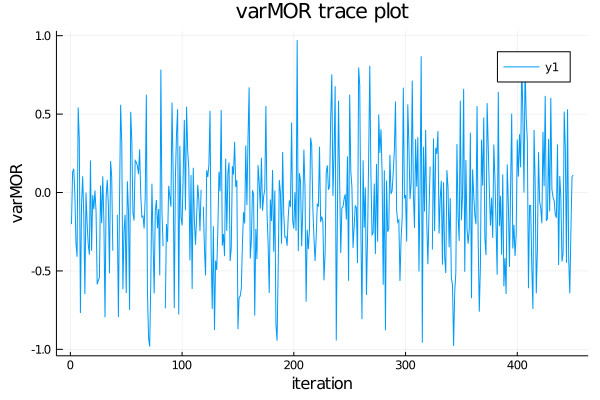

In [33]:
using Plots
x = out[!,1]; y = out[!,2]; # These are the plotting data
plot(x,y, title = "varMOR trace plot",
        xlabel = "iteration", ylabel = "varMOR")

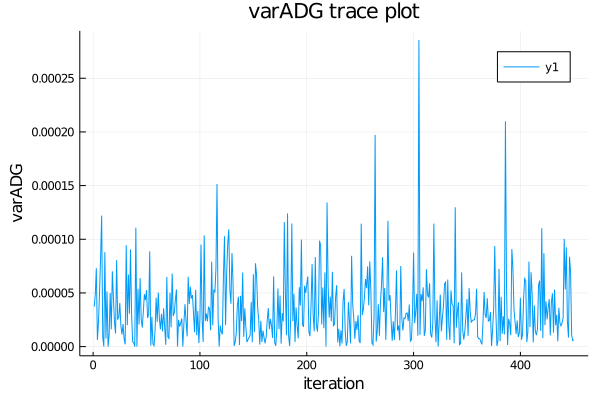

In [34]:
using Plots
x = out[!,1]; y = out[!,3]; # These are the plotting data
plot(x,y, title = "varADG trace plot",
        xlabel = "iteration", ylabel = "varADG")

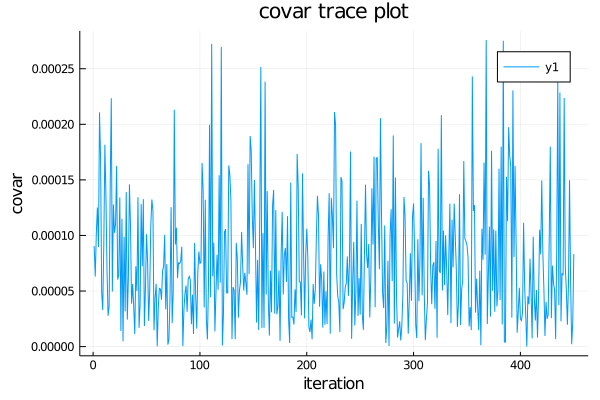

In [35]:
using Plots
x = out[!,1]; y = out[!,4]; # These are the plotting data
plot(x,y, title = "covar trace plot",
        xlabel = "iteration", ylabel = "covar")

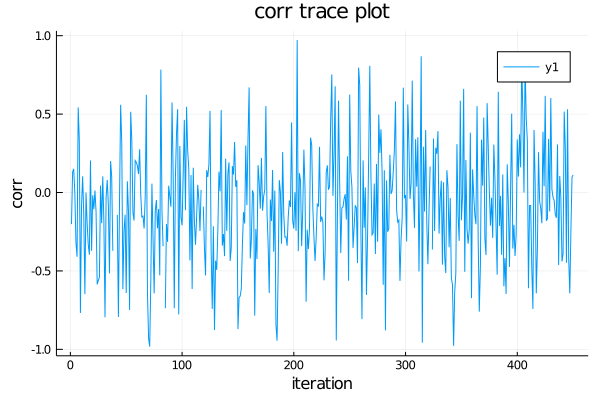

In [36]:
using Plots
x = out[!,1]; y = out[!,2]; # These are the plotting data
plot(x,y, title = "corr trace plot",
        xlabel = "iteration", ylabel = "corr")

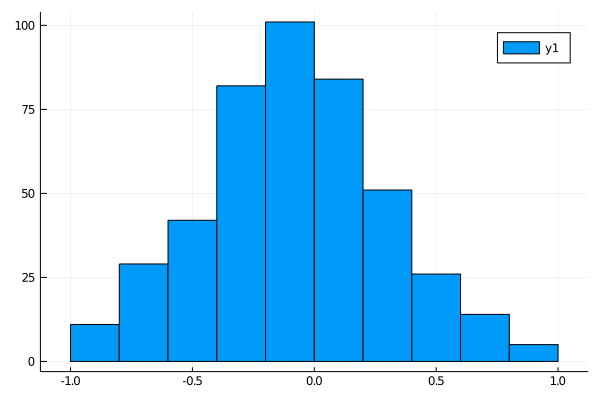

In [37]:
h = histogram(out[!,2])
display(h)

## Whole genome genetic correlation

In [3]:
gVar= CSV.read("MCMC_BayesB_genetic_variance.txt")

,FinADG_FinADG,FinADG_Died_Adj,Died_Adj_FinADG,Died_Adj_Died_Adj
,Float64,Float64,Float64,Float64
1,0.005199,-0.00064036,-0.00064036,0.00568788
2,0.0044089,-0.000848518,-0.000848518,0.00617146
3,0.00455813,-0.000130448,-0.000130448,0.00714811
4,0.00438184,-8.70609e-5,-8.70609e-5,0.00552249
5,0.00469337,6.26654e-5,6.26654e-5,0.00643017
6,0.00567386,-0.00135999,-0.00135999,0.0060733
7,0.0041734,-0.000116033,-0.000116033,0.00599371
8,0.00478381,-0.000257802,-0.000257802,0.00612973
9,0.00458669,-0.000429597,-0.000429597,0.00753862


In [4]:
sqVar1=[sqrt(i) for i in gVar[!,:FinADG_FinADG]] 
sqVar2=[sqrt(i) for i in gVar[!,:Died_Adj_Died_Adj]] 
Product= sqVar1 .* sqVar2
rg= gVar[!,:FinADG_Died_Adj] ./ Product  # Genetic correlations
insertcols!(gVar, 2, :corr => rg)

,FinADG_FinADG,corr,FinADG_Died_Adj,Died_Adj_FinADG,Died_Adj_Died_Adj
,Float64,Float64,Float64,Float64,Float64
1,0.005199,-0.117758,-0.00064036,-0.00064036,0.00568788
2,0.0044089,-0.162668,-0.000848518,-0.000848518,0.00617146
3,0.00455813,-0.0228533,-0.000130448,-0.000130448,0.00714811
4,0.00438184,-0.0176981,-8.70609e-5,-8.70609e-5,0.00552249
5,0.00469337,0.0114071,6.26654e-5,6.26654e-5,0.00643017
6,0.00567386,-0.231677,-0.00135999,-0.00135999,0.0060733
7,0.0041734,-0.0232001,-0.000116033,-0.000116033,0.00599371
8,0.00478381,-0.0476078,-0.000257802,-0.000257802,0.00612973
9,0.00458669,-0.0730577,-0.000429597,-0.000429597,0.00753862


In [5]:
#using Pkg
#Pkg.add("StatsBase")
#using(StatsBase)
mean(gVar[!,2])

-0.105307430850702

In [6]:
using Statistics
std(gVar[!,:corr])

0.060815227712734114

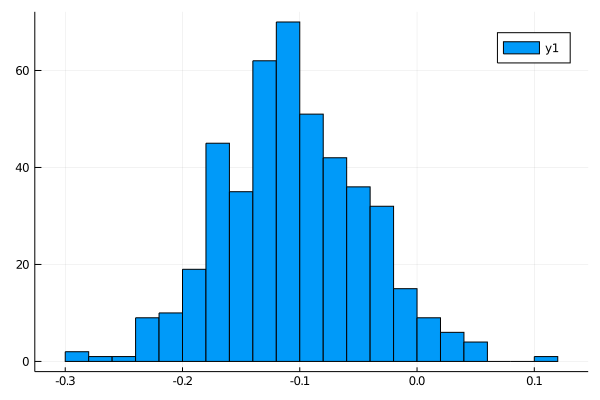

In [7]:
h = histogram(gVar[!,2])
display(h)

## BV correlation for SSC7 region from MCMC BayesB samples

In [4]:
SNP_Effect_ADG= readdlm("MCMC_BayesB_marker_effects_geno_FinADG.txt", ',',header=false)
SNP_Effect_ADG= SNP_Effect_ADG[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_ADG_MHC= SNP_Effect_ADG[:, 199203:199815]  # obtained from Map info
# Get genotypes for MHC region
M_MHC= M[:, 199203:199815]
M_MHC'
BV_ADG_MHC= Effect_ADG_MHC * M_MHC'
var_ADG= vec(var(BV_ADG_MHC, dims=2))  # Get var for each iteration

# Get var for AllTRT
SNP_Effect_AllTRT= readdlm("MCMC_BayesB_marker_effects_geno_Died_Adj.txt", ',',header=false)
SNP_Effect_AllTRT= SNP_Effect_AllTRT[2:451,:]
# Get marker effects for MHC region 20 to 30mb
Effect_AllTRT_MHC= SNP_Effect_AllTRT[:,199203:199815]
BV_AllTRT_MHC= Effect_AllTRT_MHC * M_MHC'
var_AllTRT= vec(var(BV_AllTRT_MHC, dims=2)) # Get var for each iteration

coVar = Array{Float64,1}()
for i=1:450
    adg= BV_ADG_MHC[i,:]
    AllTRT= BV_AllTRT_MHC[i,:]
    covi=cov(adg, AllTRT)
    push!(coVar,covi)
end
coVar

out=DataFrame(covar=coVar)
insertcols!(out, 1, :var_ADG => var_ADG)
insertcols!(out, 1, :var_AllTRT => var_AllTRT)
insertcols!(out, 1, :iteration => 1:450) # Add a column called iteration

# genetic correlation
Product= out[!,:var_AllTRT] .* out[!,:var_ADG]  # product of vars
sqVar=[sqrt(i) for i in Product]  # get sqrt for whole vector
rg= out[!,:covar] ./ sqVar[:,]  # Genetic correlations
insertcols!(out, 2, :corr => rg)

,iteration,corr,var_AllTRT,var_ADG,covar
,Int64,Float64,Float64,Float64,Float64
1,1,0.865446,6.45267e-6,4.51975e-5,1.47797e-5
2,2,0.635774,4.10649e-5,5.72069e-6,9.74456e-6
3,3,0.716509,3.92767e-5,7.34989e-6,1.21739e-5
4,4,0.942008,3.36599e-5,2.66279e-5,2.8202e-5
5,5,-0.273385,1.9216e-5,2.90442e-5,-6.45854e-6
6,6,0.524446,2.21698e-5,2.49531e-5,1.23351e-5
7,7,-1.0,1.5704e-6,3.50092e-6,-2.34475e-6
8,8,0.360259,2.37367e-5,7.11045e-5,1.48004e-5
9,9,NaN,0.0,2.21117e-5,0.0


In [5]:
out= filter(row -> ! isnan(row.corr), out)
mean(out[!,:corr])

0.14726560410358647

In [6]:
using Statistics
std(out[!,:corr])

0.5585021395348821

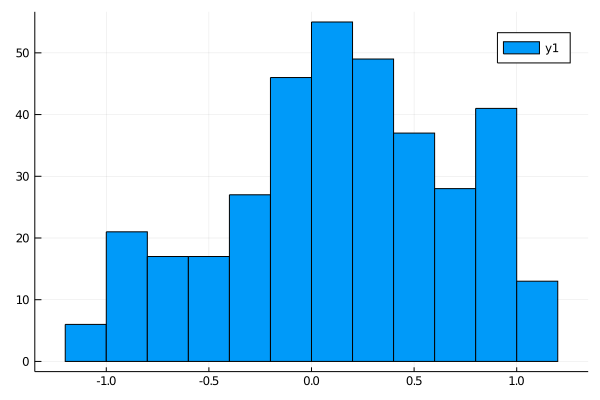

In [7]:
using Plots
h = histogram(out[!,:corr])
display(h)